In [1]:
import sys
import os

this_path = os.getcwd()
path = '\\'.join(this_path.split('\\')[:-1])+'\\'
if path not in sys.path:
    sys.path.insert(0, path)
    print(path+" added to python path")
else:
    print(path+" already in python path")

%load_ext autoreload
%autoreload 2

C:\Users\mgutierrez\root\Projects\SDC\py\kaissandra\ added to python path


In [ ]:
# Train/Test RNN
import h5py
import numpy as np
import pickle
from inputs import Data, load_separators, _build_bin_output, build_IO_from_var, build_DTA_from_var
from RNN import modelRNN
from features import get_init_end_dates, get_group_name

dateTest = ([                                                       '2018.03.09',
                '2018.03.12','2018.03.13','2018.03.14','2018.03.15','2018.03.16',
                '2018.03.19','2018.03.20','2018.03.21','2018.03.22','2018.03.23',
                '2018.03.26','2018.03.27','2018.03.28','2018.03.29','2018.03.30',
                '2018.04.02','2018.04.03','2018.04.04','2018.04.05','2018.04.06',
                '2018.04.09','2018.04.10','2018.04.11','2018.04.12','2018.04.13',
                '2018.04.16','2018.04.17','2018.04.18','2018.04.19','2018.04.20',
                '2018.04.23','2018.04.24','2018.04.25','2018.04.26','2018.04.27',
                '2018.04.30','2018.05.01','2018.05.02','2018.05.03','2018.05.04',
                '2018.05.07','2018.05.08','2018.05.09','2018.05.10','2018.05.11',
                '2018.05.14','2018.05.15','2018.05.16','2018.05.17','2018.05.18',
                '2018.05.21','2018.05.22','2018.05.23','2018.05.24','2018.05.25',
                '2018.05.28','2018.05.29','2018.05.30','2018.05.31','2018.06.01',
                '2018.06.04','2018.06.05','2018.06.06','2018.06.07','2018.06.08',
                '2018.06.11','2018.06.12','2018.06.13','2018.06.14','2018.06.15',
                '2018.06.18','2018.06.19','2018.06.20','2018.06.21','2018.06.22',
                '2018.06.25','2018.06.26','2018.06.27','2018.06.28','2018.06.29',
                '2018.07.02','2018.07.03','2018.07.04','2018.07.05','2018.07.06',
                '2018.07.09','2018.07.10','2018.07.11','2018.07.12','2018.07.13',
                '2018.07.30','2018.07.31','2018.08.01','2018.08.02','2018.08.03',
                '2018.08.06','2018.08.07','2018.08.08','2018.08.09','2018.08.10']+
               ['2018.08.13','2018.08.14','2018.08.15','2018.08.16','2018.08.17',
                '2018.08.20','2018.08.21','2018.08.22','2018.08.23','2018.08.24',
                '2018.08.27','2018.08.28','2018.08.29','2018.08.30','2018.08.31',
                '2018.09.03','2018.09.04','2018.09.05','2018.09.06','2018.09.07',
                '2018.09.10','2018.09.11','2018.09.12','2018.09.13','2018.09.14',
                '2018.09.17','2018.09.18','2018.09.19','2018.09.20','2018.09.21',
                '2018.09.24','2018.09.25','2018.09.26','2018.09.27']+['2018.09.28',
                '2018.10.01','2018.10.02','2018.10.03','2018.10.04','2018.10.05',
                '2018.10.08','2018.10.09','2018.10.10','2018.10.11','2018.10.12',
                '2018.10.15','2018.10.16','2018.10.17','2018.10.18','2018.10.19',
                '2018.10.22','2018.10.23','2018.10.24','2018.10.25','2018.10.26',
                '2018.10.29','2018.10.30','2018.10.31','2018.11.01','2018.11.02',
                '2018.11.05','2018.11.06','2018.11.07','2018.11.08','2018.11.09'])

data=Data(movingWindow=100,
          nEventsPerStat=1000,
          lB=1300, 
          dateTest=dateTest,
          assets=[1,2,3,4,7,8,10,11,12,13,14,15,16,17,19,27,28,29,30,31,32],
          channels=[0],
          max_var=10,
          feature_keys_manual=[],
          feature_keys_tsfresh=[],#[i for i in range(37,48)]+[49,50]+[i for i in range(52,68)],
          var_feat_keys=[i for i in range(68,93)])

model=modelRNN(data,
               size_hidden_layer=100,
               L=3,
               size_output_layer=5,
               keep_prob_dropout=1,
               miniBatchSize=32,
               outputGain=.6,
               commonY=3,
               lR0=0.0001,
               num_epochs=20)

tOt = 'tr' # tr->train te->test
if tOt == 'tr':
    calculate_roi = False
else:
    calculate_roi = True
if_build_IO = False
from_stats_file = False

IDweights = '000400'
IDresults = '100400'
IO_results_name = IDresults
hdf5_directory = 'D:/SDC/py/HDF5/'
feats_var_directory = hdf5_directory+'feats_var/'
IO_directory = '../RNN/IO/'
if tOt=='tr':
    filename_IO = IO_directory+'IO_'+IDweights+'.hdf5'
else:
    filename_IO = IO_directory+'IO_'+IO_results_name+'.hdf5'
separators_directory = hdf5_directory+'separators/'

# if IO structures have to be built 
if if_build_IO:
    # init dictionary containing IO structures
    IO = {}
    # open IO file for writting
    f_IO = h5py.File(filename_IO,'w')
    # init IO data sets
    X = f_IO.create_dataset('X',
                            (0, model.seq_len, model.nFeatures), 
                            maxshape=(None,model.seq_len, model.nFeatures), 
                            dtype=float)
    Y = f_IO.create_dataset('Y',
                            (0,model.seq_len,model.commonY+model.size_output_layer),
                            maxshape=(None,model.seq_len,model.commonY+
                            model.size_output_layer),
                            dtype=float)
    if calculate_roi:
        D = f_IO.create_dataset('D', (0,2),
                                    maxshape=(None,2),dtype='S19')
        B = f_IO.create_dataset('B', (0,2),
                                    maxshape=(None,2),dtype=float)
        A = f_IO.create_dataset('A', (0,2),
                                    maxshape=(None,2),dtype=float)
        IO['D'] = D
        IO['B'] = B
        IO['A'] = A
    # attributes to track asset-IO belonging
    ass_IO_ass = np.zeros((len(data.assets))).astype(int)
    # structure that tracks the number of samples per level
    totalSampsPerLevel = np.zeros((model.size_output_layer))
    # save IO structures in dictionary
    IO['X'] = X
    IO['Y'] = Y
    IO['pointer'] = 0
    
for ass_idx, ass in enumerate(data.assets):
    thisAsset = data.AllAssets[str(ass)]
    print(str(ass)+" "+thisAsset)
    #thisAsset = 'EURUSD'
    # load separators
    separators = load_separators(data, 
                                 thisAsset, 
                                 separators_directory, 
                                 tOt='tr', 
                                 from_txt=1)
    aloc = 2**20
    # index asset
    #ass_idx = 0

    filename_features = (feats_var_directory+thisAsset+'_feats_var_mW'+str(data.movingWindow)+'_nE'+
                                str(data.nEventsPerStat)+'.hdf5')
    file_features = h5py.File(filename_features,'r')
    filename_returns = (feats_var_directory+thisAsset+'_rets_var_mW'+str(data.movingWindow)+'_nE'+
                                str(data.nEventsPerStat)+'.hdf5')
    file_returns = h5py.File(filename_returns,'r')
    filename_symbols = (feats_var_directory+thisAsset+'_symbols_mW'+str(data.movingWindow)+'_nE'+
                                str(data.nEventsPerStat)+'.hdf5')
    file_symbols = h5py.File(filename_symbols,'r')
    filename_stats = (feats_var_directory+thisAsset+'_stats_mW'+str(data.movingWindow)+'_nE'+
                                    str(data.nEventsPerStat)+'.p')
    # init or load total stats
    if not from_stats_file:
        stats = {}
        # load stats in
        stats["means_in"] = file_features[thisAsset].attrs.get("means_in")
        stats["stds_in"] = file_features[thisAsset].attrs.get("stds_in")
        stats["m_in"] = file_features[thisAsset].attrs.get("m_in")
        # load stats out
        stats["means_out"] = file_returns[thisAsset].attrs.get("means_out")
        stats["stds_out"] = file_returns[thisAsset].attrs.get("stds_out")
        stats["m_out"] = file_returns[thisAsset].attrs.get("m_out")
    elif from_stats_file:
        stats = pickle.load( open( filename_stats, "rb" ))
    print(stats)

    nExS = data.nEventsPerStat
    mW = data.movingWindow
    if if_build_IO:
        for s in range(0,len(separators)-1,2):#
            print("\ts {0:d} of {1:d}".format(int(s/2),int(len(separators)/2-1))+
                  ". From "+separators.DateTime.iloc[s]+" to "+
                  separators.DateTime.iloc[s+1])

            # number of events within this separator chunk
            nE = separators.index[s+1]-separators.index[s]+1
            # get first day after separator
            day_s = separators.DateTime.iloc[s][0:10]
            # check if number of events is not enough to build two features and one return
            if nE-nExS>=2*nExS:
                if (tOt == 'tr' and (day_s not in data.dateTest and day_s<=data.dateTest[-1])) or \
                    (tOt == 'te' and (day_s in data.dateTest and day_s<=data.dateTest[-1])):
                    # init and end dates
                    init_date, end_date = get_init_end_dates(separators, s)
                    #print("init_date")
                    #print(init_date)
                    #print("end_date")
                    #print(end_date)
                    # get group name
                    group_name = get_group_name(thisAsset, init_date, end_date)
                    #print("group_name")
                    #print(group_name)
                    # load features
                    if group_name in file_features:
                        features = file_features[group_name]["features"]
                    else:
                        raise ValueError(group_name+" not in "+filename_features)
                    #print("features")
                    #print(features)
                    # load returns
                    if group_name in file_returns:
                        returns = file_returns[group_name]["returns"]
                    else:
                        raise ValueError(group_name+" not in "+filename_features)
                    #print(returns)
                    # load Symbols if calculate_roi is true
                    #TODO: Implement Symbol loading for test
                    if calculate_roi:
                        DT = file_symbols[group_name]["DT"]
                        B = file_symbols[group_name]["B"]
                        A = file_symbols[group_name]["A"]
                        # build dict w. symbols
                        symbols = {'DT':DT,
                                  'B':B,
                                  'A':A}
                    else:
                        symbols = {}
                    # build IO
                    IO, totalSampsPerLevel = build_IO_from_var_notebook(data, model, stats, IO, totalSampsPerLevel, 
                                                                        features, returns, symbols, calculate_roi)
                    print(totalSampsPerLevel)
                else:
                    print("\tNot in the set. Skipped.")

            else:
                print("\ts {0:d} of {1:d}. Not enough entries. Skipped.".format(
                    int(s/2),int(len(separators)/2-1)))
        # end of for s in range(0,len(separators)-1,2):
    if if_build_IO:
        ass_IO_ass[ass_idx] = IO['pointer']
        #print("\tTime for "+thisAsset+":"+str(np.floor(time.time()-tic))+"s"+
        #          ". Total time:"+str(np.floor(time.time()-ticTotal))+"s")
# end of for ass_idx, ass in enumerate(data.assets):
if if_build_IO:
    print("Samples to RNN: "+str(max(ass_IO_ass))+".\nPercent per level:"+
            str(totalSampsPerLevel/max(ass_IO_ass)))
    f_IO.attrs.create('ass_IO_ass', ass_IO_ass, dtype=int)
    
    
    if calculate_roi:
        print("Building DTA...")
        DTA = build_DTA_from_var(data, IO['D'], IO['B'], IO['A'], ass_IO_ass)
        pickle.dump( DTA, open( "../RNN/IO/DTA"+"_"+IO_results_name+".p", "wb" ))
        f_IO.attrs.create('ass_IO_ass', ass_IO_ass, dtype=int)
        
    f_IO.close()
else:
    if calculate_roi:
        DTA = pickle.load( open( "../RNN/IO/DTA"+"_"+IO_results_name+".p", "rb" ))
    # get ass_IO_ass from disk
    f_IO = h5py.File(filename_IO,'r')
    ass_IO_ass = f_IO.attrs.get("ass_IO_ass")
    f_IO.close()
m_t = max(ass_IO_ass)
print("DONE")

In [8]:
m_t

733966

In [ ]:
# Train
import tensorflow as tf
# reset graph
alloc = 2**20
tf.reset_default_graph()
# start session
with tf.Session() as sess:    
    model.train(sess, int(np.ceil(m_t/aloc)), ID=IDweights, IDIO=IDweights, 
                data_format='hdf5', filename_IO=filename_IO, aloc=alloc)

In [ ]:
# Test
import tensorflow as tf

alloc = 200000
save_journal = False
startFrom = -1
endAt = -1
# reset graph
tf.reset_default_graph()
# start session
with tf.Session() as sess:
    # run test RNN
    print("IDresults: "+IDresults)
    # TEMP: GRE calculation not implemented in test2 yet. Use old test
    if save_journal:
        model.test(sess, data, IDresults, IDweights, 
                    alloc, 'test', startFrom=startFrom,
                    IDIO=IO_results_name, data_format='hdf5', DTA=DTA, 
                    save_journal=save_journal, endAt=endAt)
    else:
        model.test2(sess, data, IDresults, IDweights, 
                    alloc, 'test', startFrom=startFrom,
                    IDIO=IO_results_name, data_format='hdf5', DTA=DTA, 
                    save_journal=save_journal, endAt=endAt, from_var=True)
print("DONE")

In [1]:
# Function Build IO from var
def build_IO_from_var_notebook(data, model, stats, IO, totalSampsPerLevel, features, returns, symbols, calculate_roi):
    # total number of possible channels
    nExS = data.nEventsPerStat
    mW = data.movingWindow
    nChannels = int(nExS/mW)
    # sequence length
    seq_len = model.seq_len#int((data.lB-data.nEventsPerStat)/data.movingWindow)
    # samples allocation per batch
    aloc = 2**20
    # extract means and stats
    means_in = stats['means_in']
    stds_in = stats['stds_in']
    #m_in = stats['m_in']
    stds_out = stats['stds_out']
    #m_out = stats['m_out']
    #print("m_in")
    #print(m_in)
    #print("m_out")
    #print(m_out)
    # add dateTimes, bids and asks if are included in file
    if calculate_roi:
        dts = symbols['DT']
        bids = symbols['B']
        asks = symbols['A']

        D = IO['D']
        B = IO['B']
        A = IO['A']

    # extract IO structures
    X = IO['X']
    Y = IO['Y']
    #I = IO['I']
    pointer = IO['pointer']

    feats_var_normed = np.minimum(np.maximum((features-means_in)/\
                         stds_in,-data.max_var),data.max_var)
    # get some scalars
    nSamps = feats_var_normed.shape[0]
    print("features.shape")
    print(features.shape)
    print("nSamps")
    print(nSamps)
    samp_remaining = nSamps-2*nChannels-seq_len+1
    print("samp_remaining")
    print(samp_remaining)
    print("returns.shape")
    print(returns.shape)
    chunks = int(np.ceil(samp_remaining/aloc))
    # init counter of samps processed
    offset = 0
    # loop over chunks
    for i in range(chunks):
        # this batch length
        batch = np.min([samp_remaining, aloc])
        # create support numpy vectors to speed up iterations
        v_support = feats_var_normed[offset:offset+batch+seq_len, :]
        # get init and end indexes for returns
        init_idx_rets = nChannels+offset+seq_len-1
        print("init_idx_rets")
        print(init_idx_rets)
        end_idx_rets = nChannels+offset+batch+seq_len-1#+2*seq_len-1
        print("end_idx_rets")
        print(end_idx_rets)
        r_support = returns[init_idx_rets:end_idx_rets, data.lookAheadIndex]
        print("r_support.shape")
        print(r_support.shape)
        assert(r_support.shape[0]==end_idx_rets-init_idx_rets)
        # we only take here the entry time index, and later at DTA building the 
        # exit time index is derived from the entry time and the number of events to
        # look ahead
        if calculate_roi:
            dt_support = dts[init_idx_rets:end_idx_rets, [0,data.lookAheadIndex+1]]
            b_support = bids[init_idx_rets:end_idx_rets, [0,data.lookAheadIndex+1]]
            a_support = asks[init_idx_rets:end_idx_rets, [0,data.lookAheadIndex+1]]
        # update remaining samps to proceed
        samp_remaining = samp_remaining-batch
        # init formatted input and output
        X_i = np.zeros((batch, seq_len, features.shape[1]))
        # real-valued output
        O_i = np.zeros((batch, seq_len, 1))    
        if calculate_roi:
            # last dimension is to incorporate in and out symbols
            D_i = np.chararray((batch, 2),itemsize=19)
            B_i = np.zeros((batch, 2))
            A_i = np.zeros((batch, 2))

        for nI in range(batch):
            # get input
            v_s_s = v_support[nI:nI+seq_len, :]
            X_i[nI,:,:] = v_s_s[::-1,:]#v_support[nI:nI+seq_len, :]            
            # due to substraction of features for variation, output gets the 
            # feature one entry later
            O_i[nI,:,0] = r_support[nI]
            if calculate_roi:
                D_i[nI,:] = dt_support[nI,:]
                B_i[nI,:] = b_support[nI,:]
                A_i[nI,:] = a_support[nI,:]

        # normalize output
        O_i = O_i/stds_out[data.lookAheadIndex]
        # update counters
        offset = offset+batch
        # get decimal and binary outputs
        Y_i, y_dec = _build_bin_output(model, O_i, batch)
        # get samples per level
        for l in range(model.size_output_layer):
            totalSampsPerLevel[l] = totalSampsPerLevel[l]+np.sum(y_dec[:,-1,0]==l)
        # resize IO structures
        X.resize((pointer+batch, seq_len,features.shape[1]))
        Y.resize((pointer+batch, seq_len,model.commonY+model.size_output_layer))
        # update IO structures
        X[pointer:pointer+batch,:,:] = X_i
        Y[pointer:pointer+batch,:,:] = Y_i
        if calculate_roi:
            # resize
            D.resize((pointer+batch, 2))
            B.resize((pointer+batch, 2))
            A.resize((pointer+batch, 2))
            # update
            D[pointer:pointer+batch,:] = D_i
            B[pointer:pointer+batch,:] = B_i
            A[pointer:pointer+batch,:] = A_i
    #        save_as_matfile('X_h_n_'+str(int(s/2)),'X_h_n'+str(int(s/2)),X_i)
    #        save_as_matfile('O_h_n_'+str(int(s/2)),'O_h_n'+str(int(s/2)),O_i)

        # uodate pointer
        pointer += batch
    # end of for i in range(chunks):
    # update dictionary
    IO['X'] = X
    IO['Y'] = Y
    IO['pointer'] = pointer
    if calculate_roi:
        IO['D'] = D
        IO['B'] = B
        IO['A'] = A
    
    return IO, totalSampsPerLevel
    

In [ ]:
# Snippet Build IO from var

# total number of possible channels
nChannels = int(nExS/mW)
# sequence length
seq_len = model.seq_len#int((data.lB-data.nEventsPerStat)/data.movingWindow)
# samples allocation per batch
aloc = 2**20
# extract means and stats
means_in = stats['means_in']
stds_in = stats['stds_in']
m_in = stats['m_in']
stds_out = stats['stds_out']
m_out = stats['m_out']
#print("m_in")
#print(m_in)
#print("m_out")
#print(m_out)
# add dateTimes, bids and asks if are included in file
all_info = 0
if calculate_roi:
    all_info = 1
    dts = symbols['DT']
    bids = symbols['B']
    asks = symbols['A']
        
    D = IO['D']
    B = IO['B']
    A = IO['A']

# extract IO structures
X = IO['X']
Y = IO['Y']
#I = IO['I']
pointer = IO['pointer']

feats_var_normed = np.minimum(np.maximum((features-means_in)/\
                     stds_in,-data.max_var),data.max_var)
# get some scalars
nSamps = feats_var_normed.shape[0]
samp_remaining = nSamps-nChannels-seq_len-1
print("samp_remaining")
print(samp_remaining)
chunks = int(np.ceil(samp_remaining/aloc))
# init counter of samps processed
offset = 0
# loop over chunks
for i in range(chunks):
    # this batch length
    batch = np.min([samp_remaining,aloc])
    print("batch")
    print(batch)
    # create support numpy vectors to speed up iterations
    v_support = feats_var_normed[offset:offset+batch+seq_len, :]
    # get init and end indexes for returns
    init_idx_rets = nChannels+offset+seq_len-1
    end_idx_rets = nChannels+offset+batch+2*seq_len-1
    r_support = returns[init_idx_rets:end_idx_rets, data.lookAheadIndex]
    print("returns.shape")
    print(returns.shape)
    print("nChannels+offset+2")
    print(nChannels+offset+2)
    print("nChannels+offset+batch+seq_len+2")
    print(nChannels+offset+batch+seq_len+2)
    print("r_support.shape")
    print(r_support.shape)
    print("nChannels+offset+batch+seq_len+2-(nChannels+offset+2)")
    print(nChannels+offset+batch+seq_len+2-(nChannels+offset+2))
    print("returns[-1,data.lookAheadIndex]")
    print(returns[-1,data.lookAheadIndex])
    print("r_support[-1]")
    print(r_support[-1])
    # we only take here the entry time index, and later at DTA building the 
    # exit time index is derived from the entry time and the number of events to
    # look ahead
    if calculate_roi:
        dt_support = dts[init_idx_rets:end_idx_rets, [0,data.lookAheadIndex+1]]
        b_support = bids[init_idx_rets:end_idx_rets, [0,data.lookAheadIndex+1]]
        a_support = asks[init_idx_rets:end_idx_rets, [0,data.lookAheadIndex+1]]
    # update remaining samps to proceed
    samp_remaining = samp_remaining-batch
    # init formatted input and output
    X_i = np.zeros((batch, seq_len, features.shape[1]))
    # real-valued output
    O_i = np.zeros((batch, seq_len, 1))    
    if calculate_roi:
        # last dimension is to incorporate in and out symbols
        D_i = np.chararray((batch, 2),itemsize=19)
        B_i = np.zeros((batch, 2))
        A_i = np.zeros((batch, 2))
    
    for nI in range(batch):
        # get input
        v_s_s = v_support[nI:nI+seq_len, :]
        X_i[nI,:,:] = v_s_s[::-1,:]#v_support[nI:nI+seq_len, :]            
        # due to substraction of features for variation, output gets the 
        # feature one entry later
        O_i[nI,:,0] = r_support[nI]
        if calculate_roi:
            D_i[nI,:] = dt_support[nI,:]
            B_i[nI,:] = b_support[nI,:]
            A_i[nI,:] = a_support[nI,:]
    
    # normalize output
    print("stds_out.shape")
    print(stds_out.shape)
    O_i = O_i/stds_out[data.lookAheadIndex]
    # update counters
    offset = offset+batch
    # get decimal and binary outputs
    Y_i, y_dec = _build_bin_output(model, O_i, batch)
    # get samples per level
    for l in range(model.size_output_layer):
        totalSampsPerLevel[l] = totalSampsPerLevel[l]+np.sum(y_dec[:,-1,0]==l)
    # resize IO structures
    X.resize((pointer+batch, seq_len,features.shape[1]))
    Y.resize((pointer+batch, seq_len,model.commonY+model.size_output_layer))
    # update IO structures
    X[pointer:pointer+batch,:,:] = X_i
    Y[pointer:pointer+batch,:,:] = Y_i
    if calculate_roi:
        # resize
        D.resize((pointer+batch, 2))
        B.resize((pointer+batch, 2))
        A.resize((pointer+batch, 2))
        # update
        D[pointer:pointer+batch,:] = D_i
        B[pointer:pointer+batch,:] = B_i
        A[pointer:pointer+batch,:] = A_i
#        save_as_matfile('X_h_n_'+str(int(s/2)),'X_h_n'+str(int(s/2)),X_i)
#        save_as_matfile('O_h_n_'+str(int(s/2)),'O_h_n'+str(int(s/2)),O_i)
        
    # uodate pointer
    pointer += batch
# end of for i in range(chunks):
# update dictionary
IO['X'] = X
IO['Y'] = Y
IO['pointer'] = pointer
if calculate_roi:
    IO['D'] = D
    IO['B'] = B
    IO['A'] = A
print("totalSampsPerLevel")
print(totalSampsPerLevel)

if if_build_IO:
    ass_IO_ass[ass_idx] = IO['pointer']
    #print("\tTime for "+thisAsset+":"+str(np.floor(time.time()-tic))+"s"+
    #          ". Total time:"+str(np.floor(time.time()-ticTotal))+"s")
# end of assets loop?
if if_build_IO:
    f_IO.attrs.create('ass_IO_ass', ass_IO_ass, dtype=int)
    f_IO.close()
else:
    # get ass_IO_ass from disk
    f_IO = h5py.File(filename_IO,'r')
    ass_IO_ass = f_IO.attrs.get("ass_IO_ass")
    f_IO.close()
m_t = IO['pointer']
print("m_t")
print(m_t)
print("IO['pointer']")
print(IO['pointer'])

In [5]:
f_IO.close()

In [6]:
O_i.shape

(42319, 3, 1)

In [19]:
# Test


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from config import configuration
# define config structure
entries = {'config_name':'C0400',
          
          'movingWindow':100,
          'nEventsPerStat':1000,
          'lB':1300,
          'feature_keys_manual':[],
          'feature_keys_tsfresh':[],
           'var_feat_keys':[i for i in range(68,93)],
          
          'if_build_IO':False,
          'from_stats_file':False,
          'IDweights':'000400',
          'inverse_load':True,
          
          'IDresults':'100400',
          'startFrom':-1,
          'endAt':-1,
          'save_journal':False}

config = configuration(entries)

WARNING! Arguments not taken into consideration
Config file ../config/C0400.config exists. Loaded from disk


In [ ]:
build_and_test(config)

In [16]:
from config import modify_config

modify_config(config['config_name'],'if_build_IO',False)
config = retrieve_config(config['config_name'])

[autoreload of inputs failed: Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\IPython\extensions\autoreload.py", line 384, in superreload
    update_generic(old_obj, new_obj)
  File "C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\IPython\extensions\autoreload.py", line 323, in update_generic
    update(a, b)
  File "C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\IPython\extensions\autoreload.py", line 278, in update_class
    if old_obj == new_obj:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
]


Config file ../config/C0400.config saved
Config file ../config/C0400.config loaded from disk


In [ ]:
build_and_train(config)

In [26]:
import pandas as pd
positions = pd.read_csv('../../RNN/results/100318R20/positions/P_E29TI0MC0.5MD0.75.csv',sep='\t')
#positions = pd.read_csv('../../RNN/results/100318INVO/positions/P_E15TI1MC0.7MD0.7.csv',sep='\t')
positions

Asset          Di        Ti          Do        To    GROI     ROI  \
0     AUDCAD  2018.03.19  00:57:38  2018.03.19  01:36:09  0.0337  0.0079   
1     AUDCAD  2018.03.20  02:51:09  2018.03.20  03:11:27  0.0407  0.0179   
2     AUDCAD  2018.03.22  00:59:23  2018.03.22  01:30:28  0.0929  0.0679   
3     AUDCAD  2018.03.22  02:30:14  2018.03.22  02:42:32 -0.1387 -0.1636   
4     AUDCAD  2018.03.23  01:00:56  2018.03.23  01:13:22 -0.0392 -0.0643   
5     AUDCAD  2018.03.26  00:13:48  2018.03.26  01:01:16  0.0413  0.0111   
6     AUDCAD  2018.03.28  23:43:57  2018.03.29  01:00:00  0.0808  0.0262   
7     AUDCAD  2018.03.30  02:16:01  2018.03.30  02:26:22  0.0718 -0.0071   
8     AUDCAD  2018.03.30  23:53:50  2018.04.02  01:53:14  0.0505  0.0212   
9     AUDCAD  2018.04.03  00:14:29  2018.04.03  00:38:47  0.0253 -0.0162   
10    AUDCAD  2018.04.05  00:08:52  2018.04.05  00:27:33  0.0843  0.0183   
11    AUDCAD  2018.04.05  00:53:15  2018.04.05  01:03:06  0.0244 -0.0061   
12    AUDCAD  2018.04.06  00:05:32  2018.04.06  00:37:16  0.0460  0.0133   
13    AUDCAD  2018.04.09  00:33:45  2018.04.09  01:06:08  0.0337  0.0102   
14    AUDCAD  2018.04.12  00:06:02  2018.04.12  00:29:32  0.1149  0.0410   
15    AUDCAD  2018.04.13  00:09:27  2018.04.13  00:52:06  0.0338 -0.0533   
16    AUDCAD  2018.04.16  00:06:47  2018.04.16  01:05:37  0.0327 -0.0296   
17    AUDCAD  2018.04.17  00:10:28  2018.04.17  01:00:16  0.0471  0.0143   
18    AUDCAD  2018.04.18  00:41:06  2018.04.18  01:29:19  0.0616  0.0339   
19    AUDCAD  2018.04.20  23:43:42  2018.04.23  00:21:39 -0.0470 -0.2003   
20    AUDCAD  2018.04.24  00:13:51  2018.04.24  00:52:30  0.0123 -0.0297   
21    AUDCAD  2018.04.25  00:29:51  2018.04.25  00:53:25  0.0236 -0.0308   
22    AUDCAD  2018.04.26  00:05:31  2018.04.26  00:41:49  0.0402 -0.0062   
23    AUDCAD  2018.04.27  00:31:53  2018.04.27  01:17:43  0.0813  0.0556   
24    AUDCAD  2018.04.30  00:54:23  2018.04.30  01:07:44  0.0411 -0.0062   
25    AUDCAD  2018.05.03  00:05:48  2018.05.03  00:59:34  0.0280 -0.0176   
26    AUDCAD  2018.05.03  02:17:37  2018.05.03  02:58:46  0.0207 -0.0031   
27    AUDCAD  2018.05.04  00:08:30  2018.05.04  00:29:44  0.0455  0.0000   
28    AUDCAD  2018.05.08  00:08:32  2018.05.08  00:29:55 -0.0010 -0.0413   
29    AUDCAD  2018.05.14  01:00:05  2018.05.14  01:39:24  0.0021 -0.0259   
...      ...         ...       ...         ...       ...     ...     ...   
1681  NZDUSD  2018.08.15  23:38:24  2018.08.15  23:57:56  0.0518  0.0152   
1682  NZDUSD  2018.08.17  01:04:05  2018.08.17  01:36:55  0.0349 -0.0015   
1683  NZDUSD  2018.08.17  23:55:06  2018.08.20  00:40:04  0.0513 -0.0030   
1684  NZDUSD  2018.08.21  23:48:39  2018.08.22  00:21:52  0.1180  0.0045   
1685  NZDUSD  2018.08.23  00:25:00  2018.08.23  01:43:02  0.0837  0.0508   
1686  NZDUSD  2018.08.29  00:08:42  2018.08.29  00:53:20  0.0388 -0.0045   
1687  NZDUSD  2018.09.05  00:10:14  2018.09.05  00:17:51  0.0565 -0.0397   
1688  NZDUSD  2018.09.14  00:09:13  2018.09.14  00:53:36  0.1586  0.0794   
1689  NZDUSD  2018.09.18  00:08:32  2018.09.18  01:02:10  0.1994  0.1583   
1690  NZDUSD  2018.09.18  23:40:24  2018.09.19  01:20:38 -0.0790 -0.1124   
1691  NZDUSD  2018.09.19  01:45:18  2018.09.19  02:21:37  0.0380  0.0046   
1692  NZDUSD  2018.09.20  00:21:35  2018.09.20  01:19:24 -0.1467 -0.1800   
1693  NZDUSD  2018.09.21  00:31:12  2018.09.21  01:04:28  0.0898  0.0569   
1694  NZDUSD  2018.09.24  00:07:58  2018.09.24  01:20:09  0.0120 -0.0195   
1695  NZDUSD  2018.09.26  00:48:10  2018.09.26  02:06:52 -0.0738 -0.1069   
1696  NZDUSD  2018.09.27  00:36:55  2018.09.27  01:17:58  0.0135 -0.0165   
1697  NZDUSD  2018.09.28  00:37:25  2018.09.28  01:41:53 -0.0439 -0.0938   
1698  NZDUSD  2018.10.01  00:22:18  2018.10.01  02:01:01  0.1239  0.0665   
1699  NZDUSD  2018.10.02  00:08:26  2018.10.02  01:25:28 -0.2103 -0.2648   
1700  NZDUSD  2018.10.03  00:22:46  2018.10.03  02:08:00 -0.0304 -0.0850   
1701  NZDUSD  2018.10.09  00:20:40  2018.10.09  01:26:0

In [90]:
positions = pd.read_csv('../../RNN/results/100318R20/positions/P_E29TI0MC0.5MD0.75.csv',sep='\t')
pos_under_2p = positions['spread']<0.01
per_under_2p = 100*sum(pos_under_2p)/positions.shape[0]
tgsr = 100*sum(positions['GROI']>0)/positions.shape[0]
gsr = 100*sum(positions[pos_under_2p]['GROI']>0)/sum(pos_under_2p)
tsr = 100*sum(positions['ROI']>0)/positions.shape[0]
sr = 100*sum(positions[pos_under_2p]['ROI']>0)/sum(pos_under_2p)
print(positions[pos_under_2p].shape[0])
print(per_under_2p)
print(tgsr)
print(gsr)
print(tsr)
print(sr)
print(positions[pos_under_2p]['ROI'].sum())
print(positions['GROI'].sum()-0.02*positions['GROI'].shape[0])
print(positions['Asset'][pos_under_2p].unique())

34
1.9871420222092344
82.46639392168322
61.76470588235294
37.697253068381066
52.94117647058823
0.06059999999999997
25.48230000000001
['EURCAD' 'EURCHF' 'EURGBP' 'EURUSD' 'GBPUSD' 'USDCAD' 'USDCHF' 'USDJPY'
 'EURJPY' 'GBPJPY']


## Test RNN

In [2]:
# edit config without saving for test purposes
from kaissandra.testRNN import test_RNN
from kaissandra.config import *
config=retrieve_config('C0327INVO')
config['IDresults']='100327L'
config['save_journal'] = False
config['startFrom'] = 5
config['endAt']=-1
config['feats_from_bids'] = 'LONG'
resolution = 10
config['resolution'] = resolution
config['thresholds_mc'] = [.5+i/resolution for i in range(int(resolution/2))]
config['thresholds_md'] = [.5+i/resolution for i in range(int(resolution/2))]

#config['cost_name'] = '000318TI02'

test_RNN(config)

C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Config file ../../config/C0327INVO.config loaded from disk
IDresults: 100327L
INFO:tensorflow:Restoring parameters from ../../RNN/weights/000327INVO/000005/000005
Parameters loaded. Epoch 5
Epoch 5 of 50. Getting output...


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:24<00:00,  5.19s/it]


Getting results
Epoch 5, J_train = 6.478798328179098, J_test = 6.291403988429479
feats_from_bids is LONG


0it [00:00, ?it/s]
C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\numpy\core\fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch = 5. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.291403988429479, J_train = 6.478798328179098, Accuracy=0.5329181664757687
RD = 404630 NZ = 777269 NZA = 1517379 pNZ = 45.032% pNZA = 87.910% AD = 52.06% ADA = 26.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 16930/16930 [00:03<00:00, 5053.67it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 10412 NZ = 14970 NZA = 30163 pNZ = 0.867% pNZA = 1.748% AD = 69.55% ADA = 34.52% NO = 4760 GSP = 53.40% NSP = 34.26%
SI2 = -632.20 SI = -844.20 eGROI = 7.27% eROI = -122.55% eROI2 = -87.93% eROI3 = -135.53% mSpread = 0.0273%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2414/2414 [00:00<00:00, 3593.84it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1190 NZ = 1360 NZA = 2433 pNZ = 0.079% pNZA = 0.141% AD = 87.50% ADA = 48.91% NO = 1227 GSP = 50.61% NSP = 25.18%
SI2 = -231.04 SI = -329.04 eGROI = 0.77% eROI = -43.28% eROI2 = -23.77% eROI3 = -36.04% mSpread = 0.0359%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.92it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 50.00% NO = 2 GSP = 50.00% NSP = 0.00%
SI2 = -0.04 SI = -1.04 eGROI = -0.03% eROI = -0.09% eROI2 = -0.07% eROI3 = -0.09% mSpread = 0.0285%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 122933 NZ = 228872 NZA = 378349 pNZ = 13.260% pNZA = 21.920% AD = 53.71% ADA = 32.49% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5992/5992 [00:01<00:00, 3291.91it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 5782 NZ = 8228 NZA = 14284 pNZ = 0.477% pNZA = 0.828% AD = 70.27% ADA = 40.48% NO = 2678 GSP = 54.59% NSP = 34.62%
SI2 = -295.56 SI = -465.56 eGROI = 10.06% eROI = -70.70% eROI2 = -43.50% eROI3 = -70.28% mSpread = 0.0302%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 998/998 [00:00<00:00, 3121.49it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 610 NZ = 673 NZA = 1016 pNZ = 0.039% pNZA = 0.059% AD = 90.64% ADA = 60.04% NO = 623 GSP = 53.93% NSP = 28.41%
SI2 = -83.96 SI = -146.96 eGROI = 2.74% eROI = -22.36% eROI2 = -9.72% eROI3 = -15.95% mSpread = 0.0403%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0131%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9507/9507 [00:01<00:00, 4972.02it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 9190 NZ = 16822 NZA = 23557 pNZ = 0.975% pNZA = 1.365% AD = 54.63% ADA = 39.01% NO = 2553 GSP = 54.99% NSP = 44.14%
SI2 = -149.56 SI = -200.56 eGROI = 11.91% eROI = -48.63% eROI2 = -39.15% eROI3 = -64.68% mSpread = 0.0237%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1543/1543 [00:00<00:00, 2972.34it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1624 NZ = 2429 NZA = 3397 pNZ = 0.141% pNZA = 0.197% AD = 66.86% ADA = 47.81% NO = 896 GSP = 54.91% NSP = 38.50%
SI2 = -61.92 SI = -120.92 eGROI = 6.68% eROI = -21.51% eROI2 = -11.24% eROI3 = -20.20% mSpread = 0.0315%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 289/289 [00:00<00:00, 2867.29it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 180 NZ = 200 NZA = 290 pNZ = 0.012% pNZA = 0.017% AD = 90.00% ADA = 62.07% NO = 225 GSP = 50.67% NSP = 27.11%
SI2 = -33.00 SI = -56.00 eGROI = -0.42% eROI = -10.38% eROI2 = -4.92% eROI3 = -7.17% mSpread = 0.0442%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 933/933 [00:00<00:00, 2955.27it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 893 NZ = 1726 NZA = 2188 pNZ = 0.100% pNZA = 0.127% AD = 51.74% ADA = 40.81% NO = 531 GSP = 50.28% NSP = 41.62%
SI2 = -44.12 SI = -55.12 eGROI = -4.85% eROI = -17.32% eROI2 = -15.47% eROI3 = -20.78% mSpread = 0.0235%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 2721.24it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 309 NZ = 540 NZA = 691 pNZ = 0.031% pNZA = 0.040% AD = 57.22% ADA = 44.72% NO = 150 GSP = 48.67% NSP = 36.00%
SI2 = -14.00 SI = -24.00 eGROI = -0.23% eROI = -5.12% eROI2 = -3.23% eROI3 = -4.73% mSpread = 0.0326%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 1912.34it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 11 NZ = 14 NZA = 22 pNZ = 0.001% pNZA = 0.001% AD = 78.57% ADA = 50.00% NO = 20 GSP = 35.00% NSP = 10.00%
SI2 = -6.40 SI = -8.40 eGROI = -0.66% eROI = -1.94% eROI2 = -1.06% eROI3 = -1.26% mSpread = 0.0639%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.291403988429479, J_train = 6.478798328179098, Accuracy=0.5327072807150186
RD = 404457 NZ = 777336 NZA = 1517876 pNZ = 45.035% pNZA = 87.939% AD = 52.03% ADA = 26.65% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 20004/20004 [00:03<00:00, 5233.13it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 10542 NZ = 14967 NZA = 31912 pNZ = 0.867% pNZA = 1.849% AD = 70.43% ADA = 33.03% NO = 4274 GSP = 52.08% NSP = 32.57%
SI2 = -653.48 SI = -830.48 eGROI = 8.40% eROI = -109.21% eROI2 = -77.08% eROI3 = -119.82% mSpread = 0.0275%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2160/2160 [00:00<00:00, 3308.37it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1110 NZ = 1247 NZA = 2276 pNZ = 0.072% pNZA = 0.132% AD = 89.01% ADA = 48.77% NO = 1169 GSP = 47.31% NSP = 22.50%
SI2 = -245.88 SI = -344.88 eGROI = -2.01% eROI = -47.93% eROI2 = -25.39% eROI3 = -37.08% mSpread = 0.0393%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 2140.54it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 40 NZ = 41 NZA = 55 pNZ = 0.002% pNZA = 0.003% AD = 97.56% ADA = 72.73% NO = 55 GSP = 56.36% NSP = 16.36%
SI2 = -7.60 SI = -19.60 eGROI = 0.60% eROI = -2.82% eROI2 = -0.50% eROI3 = -1.05% mSpread = 0.0622%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 120172 NZ = 224045 NZA = 369224 pNZ = 12.980% pNZA = 21.391% AD = 53.64% ADA = 32.55% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5233/5233 [00:01<00:00, 3889.24it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 5587 NZ = 7820 NZA = 13546 pNZ = 0.453% pNZA = 0.785% AD = 71.45% ADA = 41.24% NO = 2164 GSP = 55.13% NSP = 35.67%
SI2 = -219.28 SI = -353.28 eGROI = 15.18% eROI = -51.99% eROI2 = -28.10% eROI3 = -49.74% mSpread = 0.0310%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1106/1106 [00:00<00:00, 3033.62it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 717 NZ = 801 NZA = 1221 pNZ = 0.046% pNZA = 0.071% AD = 89.51% ADA = 58.72% NO = 673 GSP = 50.97% NSP = 25.41%
SI2 = -110.96 SI = -178.96 eGROI = 1.13% eROI = -27.04% eROI2 = -12.33% eROI3 = -19.06% mSpread = 0.0419%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 2096.38it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 35 NZ = 36 NZA = 47 pNZ = 0.002% pNZA = 0.003% AD = 97.22% ADA = 74.47% NO = 47 GSP = 59.57% NSP = 19.15%
SI2 = -5.44 SI = -15.44 eGROI = 0.67% eROI = -2.21% eROI2 = -0.27% eROI3 = -0.74% mSpread = 0.0612%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7914/7914 [00:01<00:00, 4962.42it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 8156 NZ = 14763 NZA = 20435 pNZ = 0.855% pNZA = 1.184% AD = 55.25% ADA = 39.91% NO = 2045 GSP = 55.45% NSP = 44.45%
SI2 = -118.40 SI = -154.40 eGROI = 12.30% eROI = -36.48% eROI2 = -28.60% eROI3 = -49.05% mSpread = 0.0239%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1433/1433 [00:00<00:00, 3453.72it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1672 NZ = 2458 NZA = 3445 pNZ = 0.142% pNZA = 0.200% AD = 68.02% ADA = 48.53% NO = 765 GSP = 56.99% NSP = 41.57%
SI2 = -41.80 SI = -79.80 eGROI = 9.60% eROI = -14.30% eROI2 = -5.70% eROI3 = -13.35% mSpread = 0.0313%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 311/311 [00:00<00:00, 2886.97it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 222 NZ = 249 NZA = 347 pNZ = 0.014% pNZA = 0.020% AD = 89.16% ADA = 63.98% NO = 235 GSP = 46.81% NSP = 23.40%
SI2 = -40.20 SI = -67.20 eGROI = -1.48% eROI = -12.02% eROI2 = -6.18% eROI3 = -8.53% mSpread = 0.0448%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 1923.23it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 22 NZ = 22 NZA = 24 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 91.67% NO = 24 GSP = 58.33% NSP = 16.67%
SI2 = -4.48 SI = -8.48 eGROI = 0.35% eROI = -1.08% eROI2 = -0.13% eROI3 = -0.37% mSpread = 0.0595%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 385/385 [00:00<00:00, 2752.12it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 543 NZ = 1015 NZA = 1252 pNZ = 0.059% pNZA = 0.073% AD = 53.50% ADA = 43.37% NO = 290 GSP = 48.62% NSP = 41.38%
SI2 = -23.80 SI = -30.80 eGROI = -4.46% eROI = -12.59% eROI2 = -10.26% eROI3 = -13.16% mSpread = 0.0281%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 2223.01it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 298 NZ = 518 NZA = 643 pNZ = 0.030% pNZA = 0.037% AD = 57.53% ADA = 46.35% NO = 92 GSP = 47.83% NSP = 35.87%
SI2 = -8.84 SI = -14.84 eGROI = -2.35% eROI = -6.37% eROI2 = -4.19% eROI3 = -5.11% mSpread = 0.0437%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 2061.33it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 44 NZ = 48 NZA = 62 pNZ = 0.003% pNZA = 0.004% AD = 91.67% ADA = 70.97% NO = 38 GSP = 44.74% NSP = 26.32%
SI2 = -7.76 SI = -9.76 eGROI = -0.47% eROI = -2.93% eROI2 = -1.23% eROI3 = -1.61% mSpread = 0.0648%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 668.10it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 66.67% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = -0.56 SI = -0.56 eGROI = 0.07% eROI = -0.26% eROI2 = 0.01% eROI3 = -0.02% mSpread = 0.1107%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.291403988429479, J_train = 6.478798328179098, Accuracy=0.530886942637335
RD = 405648 NZ = 780057 NZA = 1526460 pNZ = 45.193% pNZA = 88.436% AD = 52.00% ADA = 26.57% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 21716/21716 [00:05<00:00, 4131.56it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 10658 NZ = 15012 NZA = 33121 pNZ = 0.870% pNZA = 1.919% AD = 71.00% ADA = 32.18% NO = 4089 GSP = 50.99% NSP = 31.82%
SI2 = -669.28 SI = -825.28 eGROI = 3.40% eROI = -106.42% eROI2 = -78.38% eROI3 = -119.27% mSpread = 0.0269%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1530/1530 [00:00<00:00, 2688.63it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 820 NZ = 908 NZA = 1622 pNZ = 0.053% pNZA = 0.094% AD = 90.31% ADA = 50.55% NO = 901 GSP = 46.28% NSP = 21.20%
SI2 = -198.52 SI = -277.52 eGROI = -2.35% eROI = -39.19% eROI2 = -20.37% eROI3 = -29.38% mSpread = 0.0409%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 1773.51it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 33 NZ = 34 NZA = 47 pNZ = 0.002% pNZA = 0.003% AD = 97.06% ADA = 70.21% NO = 47 GSP = 55.32% NSP = 17.02%
SI2 = -6.44 SI = -16.44 eGROI = 0.58% eROI = -2.45% eROI2 = -0.36% eROI3 = -0.83% mSpread = 0.0644%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 118688 NZ = 221358 NZA = 366641 pNZ = 12.825% pNZA = 21.242% AD = 53.62% ADA = 32.37% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5358/5358 [00:01<00:00, 3062.37it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 5796 NZ = 8066 NZA = 14097 pNZ = 0.467% pNZA = 0.817% AD = 71.86% ADA = 41.12% NO = 2033 GSP = 54.85% NSP = 36.35%
SI2 = -212.16 SI = -318.16 eGROI = 14.62% eROI = -47.48% eROI2 = -26.04% eROI3 = -46.37% mSpread = 0.0305%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 827/827 [00:00<00:00, 3205.54it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 563 NZ = 619 NZA = 919 pNZ = 0.036% pNZA = 0.053% AD = 90.95% ADA = 61.26% NO = 523 GSP = 51.24% NSP = 26.00%
SI2 = -84.96 SI = -135.96 eGROI = 1.31% eROI = -21.01% eROI2 = -9.15% eROI3 = -14.38% mSpread = 0.0427%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 2060.81it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 29 NZ = 30 NZA = 38 pNZ = 0.002% pNZA = 0.002% AD = 96.67% ADA = 76.32% NO = 38 GSP = 55.26% NSP = 21.05%
SI2 = -4.76 SI = -11.76 eGROI = 0.59% eROI = -1.89% eROI2 = -0.17% eROI3 = -0.55% mSpread = 0.0652%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8286/8286 [00:01<00:00, 5380.73it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 8832 NZ = 15952 NZA = 22181 pNZ = 0.924% pNZA = 1.285% AD = 55.37% ADA = 39.82% NO = 2094 GSP = 57.02% NSP = 45.32%
SI2 = -92.88 SI = -139.88 eGROI = 15.17% eROI = -35.25% eROI2 = -26.71% eROI3 = -47.65% mSpread = 0.0241%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1505/1505 [00:00<00:00, 3520.77it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1743 NZ = 2538 NZA = 3598 pNZ = 0.147% pNZA = 0.208% AD = 68.68% ADA = 48.44% NO = 736 GSP = 57.07% NSP = 41.17%
SI2 = -36.72 SI = -79.72 eGROI = 10.61% eROI = -12.07% eROI2 = -4.11% eROI3 = -11.47% mSpread = 0.0308%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 271/271 [00:00<00:00, 2744.32it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 222 NZ = 246 NZA = 340 pNZ = 0.014% pNZA = 0.020% AD = 90.24% ADA = 65.29% NO = 191 GSP = 48.69% NSP = 23.56%
SI2 = -32.32 SI = -54.32 eGROI = -0.15% eROI = -9.12% eROI2 = -3.97% eROI3 = -5.88% mSpread = 0.0470%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1388.10it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 17 NZ = 17 NZA = 19 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 89.47% NO = 19 GSP = 57.89% NSP = 21.05%
SI2 = -1.88 SI = -5.88 eGROI = 0.47% eROI = -0.74% eROI2 = 0.09% eROI3 = -0.10% mSpread = 0.0635%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 299/299 [00:00<00:00, 1773.72it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 493 NZ = 910 NZA = 1137 pNZ = 0.053% pNZA = 0.066% AD = 54.18% ADA = 43.36% NO = 219 GSP = 50.68% NSP = 40.64%
SI2 = -11.88 SI = -24.88 eGROI = -3.00% eROI = -10.05% eROI2 = -7.38% eROI3 = -9.57% mSpread = 0.0322%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 93/93 [00:00<00:00, 2142.87it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 270 NZ = 433 NZA = 549 pNZ = 0.025% pNZA = 0.032% AD = 62.36% ADA = 49.18% NO = 87 GSP = 49.43% NSP = 34.48%
SI2 = -8.24 SI = -15.24 eGROI = -1.14% eROI = -5.34% eROI2 = -2.88% eROI3 = -3.75% mSpread = 0.0483%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 2211.27it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 67 NZ = 77 NZA = 95 pNZ = 0.004% pNZA = 0.006% AD = 87.01% ADA = 70.53% NO = 33 GSP = 45.45% NSP = 27.27%
SI2 = -5.16 SI = -8.16 eGROI = -0.21% eROI = -2.73% eROI2 = -0.87% eROI3 = -1.20% mSpread = 0.0762%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2004.45it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 66.67% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = -0.56 SI = 0.44 eGROI = 0.19% eROI = -0.12% eROI2 = 0.13% eROI3 = 0.10% mSpread = 0.1040%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.291403988429479, J_train = 6.478798328179098, Accuracy=0.5307426828724262
RD = 405912 NZ = 780375 NZA = 1527342 pNZ = 45.212% pNZA = 88.488% AD = 52.01% ADA = 26.58% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 22294/22294 [00:04<00:00, 5303.31it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 10980 NZ = 15528 NZA = 34227 pNZ = 0.900% pNZA = 1.983% AD = 70.71% ADA = 32.08% NO = 4070 GSP = 50.69% NSP = 31.87%
SI2 = -665.40 SI = -819.40 eGROI = 2.40% eROI = -106.43% eROI2 = -79.00% eROI3 = -119.70% mSpread = 0.0267%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1201/1201 [00:00<00:00, 3215.04it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 697 NZ = 773 NZA = 1315 pNZ = 0.045% pNZA = 0.076% AD = 90.17% ADA = 53.00% NO = 752 GSP = 47.47% NSP = 21.54%
SI2 = -154.04 SI = -229.04 eGROI = -1.94% eROI = -34.21% eROI2 = -16.98% eROI3 = -24.50% mSpread = 0.0429%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 2291.55it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 32 NZ = 33 NZA = 49 pNZ = 0.002% pNZA = 0.003% AD = 96.97% ADA = 65.31% NO = 49 GSP = 46.94% NSP = 14.29%
SI2 = -10.48 SI = -18.48 eGROI = 0.19% eROI = -2.74% eROI2 = -0.79% eROI3 = -1.28% mSpread = 0.0597%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 123480 NZ = 230642 NZA = 383641 pNZ = 13.362% pNZA = 22.226% AD = 53.54% ADA = 32.19% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5829/5829 [00:02<00:00, 2612.42it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 6085 NZ = 8598 NZA = 15145 pNZ = 0.498% pNZA = 0.877% AD = 70.77% ADA = 40.18% NO = 2031 GSP = 52.98% NSP = 36.48%
SI2 = -206.12 SI = -315.12 eGROI = 11.42% eROI = -48.44% eROI2 = -29.20% eROI3 = -49.51% mSpread = 0.0295%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 641/641 [00:00<00:00, 2227.41it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 471 NZ = 519 NZA = 754 pNZ = 0.030% pNZA = 0.044% AD = 90.75% ADA = 62.47% NO = 429 GSP = 51.28% NSP = 25.87%
SI2 = -63.08 SI = -112.08 eGROI = 1.06% eROI = -17.83% eROI2 = -7.52% eROI3 = -11.81% mSpread = 0.0440%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 1954.94it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 28 NZ = 29 NZA = 40 pNZ = 0.002% pNZA = 0.002% AD = 96.55% ADA = 70.00% NO = 40 GSP = 50.00% NSP = 17.50%
SI2 = -7.80 SI = -13.80 eGROI = 0.32% eROI = -2.15% eROI2 = -0.48% eROI3 = -0.88% mSpread = 0.0617%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7875/7875 [00:02<00:00, 2657.05it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 9017 NZ = 16345 NZA = 22787 pNZ = 0.947% pNZA = 1.320% AD = 55.17% ADA = 39.57% NO = 1959 GSP = 56.30% NSP = 44.31%
SI2 = -103.68 SI = -150.68 eGROI = 12.20% eROI = -35.64% eROI2 = -26.98% eROI3 = -46.57% mSpread = 0.0244%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1355/1355 [00:00<00:00, 2121.33it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1690 NZ = 2469 NZA = 3563 pNZ = 0.143% pNZA = 0.206% AD = 68.45% ADA = 47.43% NO = 642 GSP = 58.41% NSP = 42.68%
SI2 = -23.84 SI = -59.84 eGROI = 10.87% eROI = -9.24% eROI2 = -1.97% eROI3 = -8.39% mSpread = 0.0313%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 221/221 [00:00<00:00, 1846.36it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 204 NZ = 233 NZA = 322 pNZ = 0.013% pNZA = 0.019% AD = 87.55% ADA = 63.35% NO = 159 GSP = 46.54% NSP = 23.27%
SI2 = -27.68 SI = -45.68 eGROI = -0.71% eROI = -8.48% eROI2 = -3.89% eROI3 = -5.48% mSpread = 0.0489%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1458.29it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 13 NZ = 13 NZA = 17 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 76.47% NO = 17 GSP = 47.06% NSP = 17.65%
SI2 = -2.84 SI = -5.84 eGROI = 0.17% eROI = -0.88% eROI2 = -0.17% eROI3 = -0.34% mSpread = 0.0618%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 2232.61it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 405 NZ = 756 NZA = 948 pNZ = 0.044% pNZA = 0.055% AD = 53.57% ADA = 42.72% NO = 123 GSP = 43.90% NSP = 33.33%
SI2 = -14.96 SI = -22.96 eGROI = -3.84% eROI = -8.23% eROI2 = -6.30% eROI3 = -7.53% mSpread = 0.0357%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 1710.17it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 223 NZ = 343 NZA = 436 pNZ = 0.020% pNZA = 0.025% AD = 65.01% ADA = 51.15% NO = 57 GSP = 50.88% NSP = 36.84%
SI2 = -3.64 SI = -8.64 eGROI = -0.32% eROI = -3.30% eROI2 = -1.46% eROI3 = -2.03% mSpread = 0.0523%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1392.40it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 76 NZ = 92 NZA = 119 pNZ = 0.005% pNZA = 0.007% AD = 82.61% ADA = 63.87% NO = 26 GSP = 50.00% NSP = 34.62%
SI2 = -1.52 SI = -4.52 eGROI = -0.11% eROI = -1.97% eROI2 = -0.63% eROI3 = -0.89% mSpread = 0.0715%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.11it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 50.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = 0.04% eROI = -0.10% eROI2 = -0.00% eROI3 = -0.02% mSpread = 0.0668%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 15.18 t_index 1 thr_mc 0.6 thr_md 0.6 epoch 5 in 2164
Best eROI = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 5 in 1
Best eROI.5 = 7.66 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 5 in 642
Best eROI1 = 4.45 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 5 in 642
Best eROI2 = 0.13 t_index 2 thr_mc 0.8 thr_md 0.8 epoch 5 in 3
Best eROI3 = 0.10 t_index 2 thr_mc 0.8 thr_md 0.8 epoch 5 in 3
Best eROI4 = 0.07 t_index 2 thr_mc 0.8 thr_md 0.8 epoch 5 in 3
Best eROI5 = 0.04 t_index 2 thr_mc 0.8 thr_md 0.8 epoch 5 in 3
Best SI = 0.44 t_index 2 thr_mc 0.8 thr_md 0.8 epoch 5 in 3
Best SI.5 = 55.12 t_index 2 thr_mc 0.7 thr_md 0.5 epoch 5 in 2094
Best SI1 = 4.16 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 5 in 642
Best SI2 = -0.04 t_index 0 thr_mc

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:07<00:00,  4.61s/it]


Getting results
Epoch 6, J_train = 6.476573608557018, J_test = 6.287676007407052
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.287676007407052, J_train = 6.476573608557018, Accuracy=0.5356973395370825
RD = 402445 NZ = 772044 NZA = 1502131 pNZ = 44.729% pNZA = 87.027% AD = 52.13% ADA = 26.79% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 15907/15907 [00:03<00:00, 5020.74it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 10466 NZ = 15022 NZA = 30006 pNZ = 0.870% pNZA = 1.738% AD = 69.67% ADA = 34.88% NO = 4666 GSP = 53.32% NSP = 33.52%
SI2 = -649.32 SI = -862.32 eGROI = 8.74% eROI = -120.49% eROI2 = -84.58% eROI3 = -131.24% mSpread = 0.0277%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2750/2750 [00:00<00:00, 4123.18it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1367 NZ = 1571 NZA = 2885 pNZ = 0.091% pNZA = 0.167% AD = 87.01% ADA = 47.38% NO = 1373 GSP = 49.45% NSP = 24.40%
SI2 = -268.96 SI = -378.96 eGROI = -1.71% eROI = -50.64% eROI2 = -29.17% eROI3 = -42.90% mSpread = 0.0356%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 2135.95it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 26 NZ = 26 NZA = 50 pNZ = 0.002% pNZA = 0.003% AD = 100.00% ADA = 52.00% NO = 47 GSP = 53.19% NSP = 17.02%
SI2 = -11.44 SI = -16.44 eGROI = -0.04% eROI = -2.12% eROI2 = -0.98% eROI3 = -1.45% mSpread = 0.0445%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 123936 NZ = 231100 NZA = 381307 pNZ = 13.389% pNZA = 22.091% AD = 53.63% ADA = 32.50% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5796/5796 [00:01<00:00, 4354.05it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 6005 NZ = 8566 NZA = 14807 pNZ = 0.496% pNZA = 0.858% AD = 70.10% ADA = 40.56% NO = 2572 GSP = 54.63% NSP = 34.56%
SI2 = -285.44 SI = -448.44 eGROI = 9.87% eROI = -68.35% eROI2 = -41.57% eROI3 = -67.29% mSpread = 0.0304%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1160/1160 [00:00<00:00, 3294.26it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 750 NZ = 835 NZA = 1291 pNZ = 0.048% pNZA = 0.075% AD = 89.82% ADA = 58.09% NO = 716 GSP = 52.65% NSP = 27.51%
SI2 = -106.32 SI = -175.32 eGROI = 0.29% eROI = -28.33% eROI2 = -14.03% eROI3 = -21.19% mSpread = 0.0400%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 1726.69it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 20 NZ = 20 NZA = 32 pNZ = 0.001% pNZA = 0.002% AD = 100.00% ADA = 62.50% NO = 32 GSP = 62.50% NSP = 18.75%
SI2 = -6.64 SI = -10.64 eGROI = 0.27% eROI = -1.20% eROI2 = -0.37% eROI3 = -0.69% mSpread = 0.0458%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10276/10276 [00:01<00:00, 5145.05it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 9641 NZ = 17550 NZA = 24532 pNZ = 1.017% pNZA = 1.421% AD = 54.93% ADA = 39.30% NO = 2631 GSP = 55.80% NSP = 44.47%
SI2 = -147.12 SI = -198.12 eGROI = 13.61% eROI = -48.99% eROI2 = -39.01% eROI3 = -65.32% mSpread = 0.0238%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1646/1646 [00:00<00:00, 3626.57it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1856 NZ = 2828 NZA = 3951 pNZ = 0.164% pNZA = 0.229% AD = 65.63% ADA = 46.98% NO = 935 GSP = 53.48% NSP = 37.75%
SI2 = -75.20 SI = -133.20 eGROI = 5.30% eROI = -24.10% eROI2 = -13.40% eROI3 = -22.75% mSpread = 0.0314%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 358/358 [00:00<00:00, 2610.08it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 236 NZ = 264 NZA = 377 pNZ = 0.015% pNZA = 0.022% AD = 89.39% ADA = 62.60% NO = 279 GSP = 49.82% NSP = 26.16%
SI2 = -45.08 SI = -72.08 eGROI = -1.64% eROI = -13.51% eROI2 = -7.22% eROI3 = -10.01% mSpread = 0.0425%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2009.92it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 10 NZ = 10 NZA = 11 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 90.91% NO = 11 GSP = 72.73% NSP = 36.36%
SI2 = -0.72 SI = -1.72 eGROI = 0.33% eROI = -0.17% eROI2 = 0.11% eROI3 = -0.00% mSpread = 0.0452%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 957/957 [00:00<00:00, 3607.05it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 971 NZ = 1803 NZA = 2300 pNZ = 0.104% pNZA = 0.133% AD = 53.85% ADA = 42.22% NO = 548 GSP = 51.82% NSP = 43.43%
SI2 = -34.96 SI = -46.96 eGROI = -0.95% eROI = -14.52% eROI2 = -11.91% eROI3 = -17.39% mSpread = 0.0248%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 234/234 [00:00<00:00, 2680.89it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 363 NZ = 605 NZA = 784 pNZ = 0.035% pNZA = 0.045% AD = 60.00% ADA = 46.30% NO = 174 GSP = 50.57% NSP = 37.93%
SI2 = -14.48 SI = -24.48 eGROI = -0.74% eROI = -7.03% eROI2 = -4.22% eROI3 = -5.96% mSpread = 0.0361%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 2480.06it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 33 NZ = 40 NZA = 53 pNZ = 0.002% pNZA = 0.003% AD = 82.50% ADA = 62.26% NO = 45 GSP = 42.22% NSP = 24.44%
SI2 = -9.40 SI = -12.40 eGROI = -1.42% eROI = -4.06% eROI2 = -2.32% eROI3 = -2.77% mSpread = 0.0587%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.287676007407052, J_train = 6.476573608557018, Accuracy=0.535776132019121
RD = 402457 NZ = 772956 NZA = 1503819 pNZ = 44.782% pNZA = 87.125% AD = 52.07% ADA = 26.76% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 19121/19121 [00:03<00:00, 5285.27it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 10781 NZ = 15300 NZA = 31917 pNZ = 0.886% pNZA = 1.849% AD = 70.46% ADA = 33.78% NO = 4291 GSP = 52.32% NSP = 33.70%
SI2 = -611.32 SI = -785.32 eGROI = 13.13% eROI = -104.46% eROI2 = -72.69% eROI3 = -115.60% mSpread = 0.0274%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2556/2556 [00:00<00:00, 4127.58it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1306 NZ = 1497 NZA = 2815 pNZ = 0.087% pNZA = 0.163% AD = 87.24% ADA = 46.39% NO = 1340 GSP = 48.58% NSP = 23.21%
SI2 = -279.80 SI = -385.80 eGROI = -1.33% eROI = -52.09% eROI2 = -28.13% eROI3 = -41.53% mSpread = 0.0379%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 2419.15it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 73 NZ = 76 NZA = 112 pNZ = 0.004% pNZA = 0.006% AD = 96.05% ADA = 65.18% NO = 111 GSP = 48.65% NSP = 16.22%
SI2 = -23.72 SI = -39.72 eGROI = 0.04% eROI = -5.83% eROI2 = -2.18% eROI3 = -3.29% mSpread = 0.0528%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 119532 NZ = 222849 NZA = 367150 pNZ = 12.911% pNZA = 21.271% AD = 53.64% ADA = 32.56% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5427/5427 [00:01<00:00, 4439.33it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 5942 NZ = 8354 NZA = 14449 pNZ = 0.484% pNZA = 0.837% AD = 71.13% ADA = 41.12% NO = 2191 GSP = 55.18% NSP = 36.97%
SI2 = -206.32 SI = -329.32 eGROI = 17.01% eROI = -50.07% eROI2 = -26.81% eROI3 = -48.72% mSpread = 0.0306%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1120/1120 [00:00<00:00, 3476.45it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 787 NZ = 893 NZA = 1378 pNZ = 0.052% pNZA = 0.080% AD = 88.13% ADA = 57.11% NO = 686 GSP = 51.60% NSP = 25.95%
SI2 = -108.72 SI = -178.72 eGROI = 2.71% eROI = -25.94% eROI2 = -11.01% eROI3 = -17.87% mSpread = 0.0418%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 2653.71it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 60 NZ = 63 NZA = 91 pNZ = 0.004% pNZA = 0.005% AD = 95.24% ADA = 65.93% NO = 91 GSP = 51.65% NSP = 18.68%
SI2 = -16.32 SI = -30.32 eGROI = 0.34% eROI = -4.60% eROI2 = -1.48% eROI3 = -2.39% mSpread = 0.0543%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8600/8600 [00:01<00:00, 5427.08it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 8674 NZ = 15647 NZA = 21729 pNZ = 0.907% pNZA = 1.259% AD = 55.44% ADA = 39.92% NO = 2157 GSP = 55.17% NSP = 44.37%
SI2 = -125.64 SI = -164.64 eGROI = 12.16% eROI = -40.43% eROI2 = -30.98% eROI3 = -52.55% mSpread = 0.0244%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1620/1620 [00:00<00:00, 3405.01it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1908 NZ = 2831 NZA = 4004 pNZ = 0.164% pNZA = 0.232% AD = 67.40% ADA = 47.65% NO = 815 GSP = 55.95% NSP = 40.49%
SI2 = -53.80 SI = -93.80 eGROI = 9.65% eROI = -16.09% eROI2 = -6.65% eROI3 = -14.80% mSpread = 0.0316%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 346/346 [00:00<00:00, 2649.24it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 283 NZ = 321 NZA = 446 pNZ = 0.019% pNZA = 0.026% AD = 88.16% ADA = 63.45% NO = 253 GSP = 51.38% NSP = 24.90%
SI2 = -37.56 SI = -68.56 eGROI = -0.06% eROI = -12.05% eROI2 = -5.12% eROI3 = -7.65% mSpread = 0.0474%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 2291.27it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 40 NZ = 41 NZA = 49 pNZ = 0.002% pNZA = 0.003% AD = 97.56% ADA = 81.63% NO = 49 GSP = 51.02% NSP = 22.45%
SI2 = -7.48 SI = -14.48 eGROI = 0.38% eROI = -2.46% eROI2 = -0.60% eROI3 = -1.09% mSpread = 0.0580%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 411/411 [00:00<00:00, 3169.69it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 612 NZ = 1126 NZA = 1408 pNZ = 0.065% pNZA = 0.082% AD = 54.35% ADA = 43.47% NO = 307 GSP = 49.19% NSP = 39.74%
SI2 = -23.64 SI = -37.64 eGROI = -3.73% eROI = -12.94% eROI2 = -9.87% eROI3 = -12.94% mSpread = 0.0300%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 2601.94it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 325 NZ = 531 NZA = 676 pNZ = 0.031% pNZA = 0.039% AD = 61.21% ADA = 48.08% NO = 120 GSP = 50.00% NSP = 35.83%
SI2 = -10.40 SI = -19.40 eGROI = -1.09% eROI = -6.23% eROI2 = -3.49% eROI3 = -4.69% mSpread = 0.0429%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 2339.48it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 84 NZ = 98 NZA = 127 pNZ = 0.006% pNZA = 0.007% AD = 85.71% ADA = 66.14% NO = 55 GSP = 50.91% NSP = 30.91%
SI2 = -7.60 SI = -11.60 eGROI = -0.08% eROI = -3.37% eROI2 = -1.18% eROI3 = -1.73% mSpread = 0.0597%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1203.13it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 5 NZ = 5 NZA = 7 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 71.43% NO = 7 GSP = 57.14% NSP = 42.86%
SI2 = -1.64 SI = -0.64 eGROI = 0.16% eROI = -0.31% eROI2 = 0.02% eROI3 = -0.05% mSpread = 0.0675%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.287676007407052, J_train = 6.476573608557018, Accuracy=0.5332680977930573
RD = 404095 NZ = 776083 NZA = 1514402 pNZ = 44.963% pNZA = 87.738% AD = 52.07% ADA = 26.68% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 22208/22208 [00:04<00:00, 5403.12it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 11519 NZ = 16434 NZA = 35072 pNZ = 0.952% pNZA = 2.032% AD = 70.09% ADA = 32.84% NO = 4365 GSP = 51.91% NSP = 33.77%
SI2 = -646.80 SI = -795.80 eGROI = 8.73% eROI = -106.87% eROI2 = -78.57% eROI3 = -122.22% mSpread = 0.0265%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1908/1908 [00:00<00:00, 2639.02it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1026 NZ = 1155 NZA = 2127 pNZ = 0.067% pNZA = 0.123% AD = 88.83% ADA = 48.24% NO = 1072 GSP = 46.83% NSP = 22.01%
SI2 = -223.44 SI = -321.44 eGROI = -2.60% eROI = -44.25% eROI2 = -24.04% eROI3 = -34.76% mSpread = 0.0389%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 2177.00it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 51 NZ = 52 NZA = 77 pNZ = 0.003% pNZA = 0.004% AD = 98.08% ADA = 66.23% NO = 77 GSP = 50.65% NSP = 15.58%
SI2 = -15.04 SI = -28.04 eGROI = 0.49% eROI = -3.93% eROI2 = -1.05% eROI3 = -1.82% mSpread = 0.0574%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 120490 NZ = 224459 NZA = 372409 pNZ = 13.004% pNZA = 21.576% AD = 53.68% ADA = 32.35% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6390/6390 [00:01<00:00, 4542.13it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 6592 NZ = 9360 NZA = 16201 pNZ = 0.542% pNZA = 0.939% AD = 70.43% ADA = 40.69% NO = 2236 GSP = 54.96% NSP = 37.88%
SI2 = -204.72 SI = -315.72 eGROI = 15.37% eROI = -50.82% eROI2 = -29.35% eROI3 = -51.71% mSpread = 0.0296%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 879/879 [00:00<00:00, 3245.73it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 651 NZ = 730 NZA = 1097 pNZ = 0.042% pNZA = 0.064% AD = 89.18% ADA = 59.34% NO = 552 GSP = 52.17% NSP = 26.09%
SI2 = -89.04 SI = -143.04 eGROI = 1.17% eROI = -22.34% eROI2 = -9.87% eROI3 = -15.39% mSpread = 0.0426%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 2275.13it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 41 NZ = 42 NZA = 60 pNZ = 0.002% pNZA = 0.003% AD = 97.62% ADA = 68.33% NO = 60 GSP = 50.00% NSP = 16.67%
SI2 = -12.20 SI = -21.20 eGROI = 0.50% eROI = -3.09% eROI2 = -0.70% eROI3 = -1.30% mSpread = 0.0598%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9056/9056 [00:01<00:00, 5195.25it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 9416 NZ = 16959 NZA = 23654 pNZ = 0.983% pNZA = 1.370% AD = 55.52% ADA = 39.81% NO = 2213 GSP = 56.30% NSP = 44.60%
SI2 = -114.76 SI = -163.76 eGROI = 13.87% eROI = -39.57% eROI2 = -30.39% eROI3 = -52.52% mSpread = 0.0242%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1782/1782 [00:00<00:00, 4149.84it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2089 NZ = 3066 NZA = 4415 pNZ = 0.178% pNZA = 0.256% AD = 68.13% ADA = 47.32% NO = 791 GSP = 57.02% NSP = 41.21%
SI2 = -40.32 SI = -85.32 eGROI = 11.76% eROI = -12.51% eROI2 = -4.06% eROI3 = -11.97% mSpread = 0.0307%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 312/312 [00:00<00:00, 3363.51it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 281 NZ = 320 NZA = 444 pNZ = 0.019% pNZA = 0.026% AD = 87.81% ADA = 63.29% NO = 218 GSP = 50.46% NSP = 24.77%
SI2 = -33.36 SI = -59.36 eGROI = 0.27% eROI = -10.05% eROI2 = -4.09% eROI3 = -6.27% mSpread = 0.0473%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 2219.59it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 26 NZ = 26 NZA = 32 pNZ = 0.002% pNZA = 0.002% AD = 100.00% ADA = 81.25% NO = 32 GSP = 50.00% NSP = 18.75%
SI2 = -5.64 SI = -10.64 eGROI = 0.40% eROI = -1.60% eROI2 = -0.24% eROI3 = -0.56% mSpread = 0.0625%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 354/354 [00:00<00:00, 3059.41it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 564 NZ = 1064 NZA = 1335 pNZ = 0.062% pNZA = 0.077% AD = 53.01% ADA = 42.25% NO = 256 GSP = 45.70% NSP = 36.33%
SI2 = -28.12 SI = -40.12 eGROI = -5.19% eROI = -13.38% eROI2 = -10.31% eROI3 = -12.87% mSpread = 0.0320%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 130/130 [00:00<00:00, 2413.60it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 282 NZ = 447 NZA = 579 pNZ = 0.026% pNZA = 0.034% AD = 63.09% ADA = 48.70% NO = 115 GSP = 48.70% NSP = 32.17%
SI2 = -13.80 SI = -22.80 eGROI = -1.41% eROI = -6.72% eROI2 = -3.71% eROI3 = -4.86% mSpread = 0.0462%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 2172.22it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 102 NZ = 123 NZA = 163 pNZ = 0.007% pNZA = 0.009% AD = 82.93% ADA = 62.58% NO = 53 GSP = 52.83% NSP = 30.19%
SI2 = -7.56 SI = -11.56 eGROI = -0.03% eROI = -3.44% eROI2 = -1.09% eROI3 = -1.62% mSpread = 0.0644%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2005.24it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 4 NZ = 4 NZA = 7 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 57.14% NO = 7 GSP = 42.86% NSP = 28.57%
SI2 = -2.64 SI = -1.64 eGROI = 0.12% eROI = -0.40% eROI2 = -0.02% eROI3 = -0.09% mSpread = 0.0741%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.287676007407052, J_train = 6.476573608557018, Accuracy=0.5324419354446243
RD = 405365 NZ = 778618 NZA = 1520898 pNZ = 45.110% pNZA = 88.114% AD = 52.06% ADA = 26.65% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 23512/23512 [00:04<00:00, 5607.65it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 12083 NZ = 17292 NZA = 36887 pNZ = 1.002% pNZA = 2.137% AD = 69.88% ADA = 32.76% NO = 4425 GSP = 52.34% NSP = 34.69%
SI2 = -629.00 SI = -766.00 eGROI = 8.46% eROI = -106.56% eROI2 = -80.04% eROI3 = -124.29% mSpread = 0.0260%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1616/1616 [00:00<00:00, 3476.76it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 912 NZ = 1024 NZA = 1828 pNZ = 0.059% pNZA = 0.106% AD = 89.06% ADA = 49.89% NO = 950 GSP = 48.00% NSP = 21.79%
SI2 = -196.00 SI = -287.00 eGROI = -1.59% eROI = -40.14% eROI2 = -20.59% eROI3 = -30.09% mSpread = 0.0406%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 2468.10it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 45 NZ = 46 NZA = 66 pNZ = 0.003% pNZA = 0.004% AD = 97.83% ADA = 68.18% NO = 65 GSP = 47.69% NSP = 15.38%
SI2 = -12.80 SI = -23.80 eGROI = 0.43% eROI = -3.42% eROI2 = -0.87% eROI3 = -1.52% mSpread = 0.0593%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 124969 NZ = 233322 NZA = 388474 pNZ = 13.518% pNZA = 22.506% AD = 53.56% ADA = 32.17% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7026/7026 [00:01<00:00, 4714.85it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 6947 NZ = 9991 NZA = 17213 pNZ = 0.579% pNZA = 0.997% AD = 69.53% ADA = 40.36% NO = 2306 GSP = 55.20% NSP = 39.20%
SI2 = -193.12 SI = -295.12 eGROI = 15.81% eROI = -49.99% eROI2 = -30.31% eROI3 = -53.37% mSpread = 0.0285%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 734/734 [00:00<00:00, 3158.29it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 573 NZ = 641 NZA = 944 pNZ = 0.037% pNZA = 0.055% AD = 89.39% ADA = 60.70% NO = 468 GSP = 54.49% NSP = 26.92%
SI2 = -61.36 SI = -117.36 eGROI = 1.92% eROI = -18.41% eROI2 = -7.44% eROI3 = -12.12% mSpread = 0.0434%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 2369.71it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 38 NZ = 39 NZA = 54 pNZ = 0.002% pNZA = 0.003% AD = 97.44% ADA = 70.37% NO = 53 GSP = 47.17% NSP = 16.98%
SI2 = -10.56 SI = -18.56 eGROI = 0.47% eROI = -2.76% eROI2 = -0.59% eROI3 = -1.12% mSpread = 0.0609%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8638/8638 [00:01<00:00, 5234.58it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 9716 NZ = 17461 NZA = 24439 pNZ = 1.012% pNZA = 1.416% AD = 55.64% ADA = 39.76% NO = 2074 GSP = 58.15% NSP = 45.52%
SI2 = -83.48 SI = -134.48 eGROI = 18.40% eROI = -31.64% eROI2 = -23.08% eROI3 = -43.82% mSpread = 0.0241%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1619/1619 [00:00<00:00, 3647.26it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2046 NZ = 2985 NZA = 4315 pNZ = 0.173% pNZA = 0.250% AD = 68.54% ADA = 47.42% NO = 707 GSP = 58.70% NSP = 43.28%
SI2 = -15.64 SI = -61.64 eGROI = 12.34% eROI = -9.36% eROI2 = -1.80% eROI3 = -8.87% mSpread = 0.0307%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 268/268 [00:00<00:00, 2742.04it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 257 NZ = 296 NZA = 413 pNZ = 0.017% pNZA = 0.024% AD = 86.82% ADA = 62.23% NO = 187 GSP = 51.87% NSP = 26.20%
SI2 = -24.24 SI = -48.24 eGROI = -0.52% eROI = -9.35% eROI2 = -4.26% eROI3 = -6.13% mSpread = 0.0472%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 1718.51it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 21 NZ = 21 NZA = 26 pNZ = 0.001% pNZA = 0.002% AD = 100.00% ADA = 80.77% NO = 25 GSP = 52.00% NSP = 20.00%
SI2 = -4.00 SI = -8.00 eGROI = 0.38% eROI = -1.12% eROI2 = -0.12% eROI3 = -0.37% mSpread = 0.0599%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 230/230 [00:00<00:00, 2534.11it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 501 NZ = 920 NZA = 1164 pNZ = 0.053% pNZA = 0.067% AD = 54.46% ADA = 43.04% NO = 171 GSP = 45.03% NSP = 35.09%
SI2 = -19.92 SI = -28.92 eGROI = -3.76% eROI = -9.58% eROI2 = -7.18% eROI3 = -8.89% mSpread = 0.0340%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 93/93 [00:00<00:00, 2121.16it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 233 NZ = 348 NZA = 441 pNZ = 0.020% pNZA = 0.026% AD = 66.95% ADA = 52.83% NO = 89 GSP = 48.31% NSP = 34.83%
SI2 = -8.28 SI = -15.28 eGROI = -0.59% eROI = -4.67% eROI2 = -2.37% eROI3 = -3.26% mSpread = 0.0458%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 1504.08it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 102 NZ = 123 NZA = 157 pNZ = 0.007% pNZA = 0.009% AD = 82.93% ADA = 64.97% NO = 46 GSP = 50.00% NSP = 30.43%
SI2 = -4.92 SI = -9.92 eGROI = -0.42% eROI = -3.27% eROI2 = -1.34% eROI3 = -1.80% mSpread = 0.0621%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1203.01it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 5 NZ = 5 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 62.50% NO = 7 GSP = 42.86% NSP = 42.86%
SI2 = -1.64 SI = -0.64 eGROI = 0.17% eROI = -0.30% eROI2 = 0.03% eROI3 = -0.04% mSpread = 0.0673%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 18.40 t_index 3 thr_mc 0.7 thr_md 0.5 epoch 6 in 2074
Best eROI = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 6 in 1
Best eROI.5 = 8.80 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 6 in 707
Best eROI1 = 5.27 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 6 in 707
Best eROI2 = 0.11 t_index 0 thr_mc 0.7 thr_md 0.8 epoch 6 in 11
Best eROI3 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 6 in 1
Best eROI4 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 6 in 1
Best eROI5 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 6 in 1
Best SI = -0.52 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 6 in 1
Best SI.5 = 62.52 t_index 3 thr_mc 0.7 thr_md 0.5 epoch 6 in 2074
Best SI1 = 15.52 t_index 3 thr_mc 0.7 thr_md 0.5 epoch 6 in 2074
Best SI2 = -0.52 t_index 0 th

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:07<00:00,  5.09s/it]


Getting results
Epoch 7, J_train = 6.4744648549238635, J_test = 6.284802205221993
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.284802205221993, J_train = 6.4744648549238635, Accuracy=0.5378143081353817
RD = 400575 NZ = 768242 NZA = 1490873 pNZ = 44.509% pNZA = 86.375% AD = 52.14% ADA = 26.87% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 15509/15509 [00:03<00:00, 4616.14it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 10727 NZ = 15418 NZA = 30690 pNZ = 0.893% pNZA = 1.778% AD = 69.57% ADA = 34.95% NO = 4576 GSP = 53.02% NSP = 33.41%
SI2 = -639.52 SI = -850.52 eGROI = 11.33% eROI = -116.25% eROI2 = -80.19% eROI3 = -125.95% mSpread = 0.0279%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3120/3120 [00:00<00:00, 3757.21it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1588 NZ = 1851 NZA = 3401 pNZ = 0.107% pNZA = 0.197% AD = 85.79% ADA = 46.69% NO = 1499 GSP = 48.77% NSP = 23.95%
SI2 = -302.48 SI = -420.48 eGROI = -3.50% eROI = -56.55% eROI2 = -33.48% eROI3 = -48.47% mSpread = 0.0354%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 1826.53it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 110 NZ = 113 NZA = 185 pNZ = 0.007% pNZA = 0.011% AD = 97.35% ADA = 59.46% NO = 157 GSP = 54.14% NSP = 22.29%
SI2 = -33.64 SI = -46.64 eGROI = 1.20% eROI = -5.65% eROI2 = -1.94% eROI3 = -3.51% mSpread = 0.0437%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 124007 NZ = 231402 NZA = 381300 pNZ = 13.406% pNZA = 22.091% AD = 53.59% ADA = 32.52% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5730/5730 [00:03<00:00, 1732.34it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 6260 NZ = 8955 NZA = 15523 pNZ = 0.519% pNZA = 0.899% AD = 69.91% ADA = 40.33% NO = 2538 GSP = 54.41% NSP = 35.34%
SI2 = -272.76 SI = -422.76 eGROI = 13.50% eROI = -62.78% eROI2 = -37.26% eROI3 = -62.64% mSpread = 0.0301%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1335/1335 [00:00<00:00, 1564.08it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 903 NZ = 1027 NZA = 1605 pNZ = 0.059% pNZA = 0.093% AD = 87.93% ADA = 56.26% NO = 808 GSP = 51.61% NSP = 26.73%
SI2 = -127.16 SI = -204.16 eGROI = -0.79% eROI = -32.51% eROI2 = -16.95% eROI3 = -25.03% mSpread = 0.0393%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 1167.99it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 77 NZ = 79 NZA = 114 pNZ = 0.005% pNZA = 0.007% AD = 97.47% ADA = 67.54% NO = 102 GSP = 57.84% NSP = 24.51%
SI2 = -18.04 SI = -28.04 eGROI = 1.36% eROI = -2.84% eROI2 = -0.68% eROI3 = -1.70% mSpread = 0.0412%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10465/10465 [00:04<00:00, 2363.37it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 9948 NZ = 18033 NZA = 25270 pNZ = 1.045% pNZA = 1.464% AD = 55.17% ADA = 39.37% NO = 2615 GSP = 55.72% NSP = 44.17%
SI2 = -143.80 SI = -204.80 eGROI = 13.01% eROI = -50.37% eROI2 = -39.29% eROI3 = -65.44% mSpread = 0.0242%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1778/1778 [00:00<00:00, 3735.82it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2018 NZ = 3092 NZA = 4376 pNZ = 0.179% pNZA = 0.254% AD = 65.27% ADA = 46.12% NO = 977 GSP = 52.71% NSP = 37.46%
SI2 = -88.04 SI = -142.04 eGROI = 5.95% eROI = -25.39% eROI2 = -13.59% eROI3 = -23.36% mSpread = 0.0321%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 443/443 [00:00<00:00, 2675.62it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 305 NZ = 347 NZA = 489 pNZ = 0.020% pNZA = 0.028% AD = 87.90% ADA = 62.37% NO = 328 GSP = 48.78% NSP = 25.91%
SI2 = -49.56 SI = -85.56 eGROI = -2.08% eROI = -16.23% eROI2 = -8.64% eROI3 = -11.92% mSpread = 0.0432%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 1640.59it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 32 NZ = 32 NZA = 37 pNZ = 0.002% pNZA = 0.002% AD = 100.00% ADA = 86.49% NO = 35 GSP = 65.71% NSP = 22.86%
SI2 = -4.20 SI = -10.20 eGROI = 0.78% eROI = -1.11% eROI2 = 0.08% eROI3 = -0.27% mSpread = 0.0540%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 841/841 [00:00<00:00, 3006.03it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 941 NZ = 1714 NZA = 2180 pNZ = 0.099% pNZA = 0.126% AD = 54.90% ADA = 43.17% NO = 492 GSP = 52.24% NSP = 42.68%
SI2 = -34.84 SI = -45.84 eGROI = 0.52% eROI = -12.27% eROI2 = -9.32% eROI3 = -14.24% mSpread = 0.0260%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 253/253 [00:00<00:00, 1657.92it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 373 NZ = 653 NZA = 839 pNZ = 0.038% pNZA = 0.049% AD = 57.12% ADA = 44.46% NO = 185 GSP = 49.19% NSP = 36.76%
SI2 = -19.20 SI = -28.20 eGROI = -0.56% eROI = -7.24% eROI2 = -4.26% eROI3 = -6.11% mSpread = 0.0361%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 1645.18it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 42 NZ = 53 NZA = 77 pNZ = 0.003% pNZA = 0.004% AD = 79.25% ADA = 54.55% NO = 60 GSP = 40.00% NSP = 25.00%
SI2 = -12.20 SI = -16.20 eGROI = -1.98% eROI = -5.30% eROI2 = -3.18% eROI3 = -3.78% mSpread = 0.0555%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.07% eROI = 0.01% eROI2 = 0.05% eROI3 = 0.04% mSpread = 0.0573%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.284802205221993, J_train = 6.4744648549238635, Accuracy=0.5377801261027326
RD = 400830 NZ = 769399 NZA = 1493245 pNZ = 44.576% pNZA = 86.512% AD = 52.10% ADA = 26.84% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 19573/19573 [00:03<00:00, 4997.50it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 11306 NZ = 16201 NZA = 33084 pNZ = 0.939% pNZA = 1.917% AD = 69.79% ADA = 34.17% NO = 4482 GSP = 53.21% NSP = 34.81%
SI2 = -593.64 SI = -770.64 eGROI = 14.62% eROI = -106.82% eROI2 = -75.02% eROI3 = -119.84% mSpread = 0.0271%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2877/2877 [00:00<00:00, 3902.47it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1480 NZ = 1719 NZA = 3217 pNZ = 0.100% pNZA = 0.186% AD = 86.10% ADA = 46.01% NO = 1459 GSP = 50.10% NSP = 23.71%
SI2 = -290.68 SI = -412.68 eGROI = 0.14% eROI = -54.42% eROI2 = -29.04% eROI3 = -43.63% mSpread = 0.0374%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 2514.43it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 107 NZ = 112 NZA = 174 pNZ = 0.006% pNZA = 0.010% AD = 95.54% ADA = 61.49% NO = 170 GSP = 48.24% NSP = 14.71%
SI2 = -42.40 SI = -63.40 eGROI = -0.64% eROI = -9.19% eROI2 = -4.04% eROI3 = -5.74% mSpread = 0.0503%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 118218 NZ = 220640 NZA = 363436 pNZ = 12.783% pNZA = 21.056% AD = 53.58% ADA = 32.53% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6009/6009 [00:01<00:00, 4241.34it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 6407 NZ = 9094 NZA = 15657 pNZ = 0.527% pNZA = 0.907% AD = 70.45% ADA = 40.92% NO = 2354 GSP = 55.56% NSP = 37.68%
SI2 = -217.08 SI = -337.08 eGROI = 17.18% eROI = -52.72% eROI2 = -29.90% eROI3 = -53.44% mSpread = 0.0297%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1211/1211 [00:00<00:00, 3391.92it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 875 NZ = 1004 NZA = 1549 pNZ = 0.058% pNZA = 0.090% AD = 87.15% ADA = 56.49% NO = 739 GSP = 51.83% NSP = 25.98%
SI2 = -119.28 SI = -192.28 eGROI = 2.91% eROI = -27.32% eROI2 = -11.87% eROI3 = -19.26% mSpread = 0.0409%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 2372.88it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 90 NZ = 95 NZA = 143 pNZ = 0.006% pNZA = 0.008% AD = 94.74% ADA = 62.94% NO = 141 GSP = 48.23% NSP = 16.31%
SI2 = -34.32 SI = -50.32 eGROI = -0.41% eROI = -7.56% eROI2 = -3.23% eROI3 = -4.64% mSpread = 0.0507%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8666/8666 [00:01<00:00, 4651.15it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 9001 NZ = 16164 NZA = 22496 pNZ = 0.936% pNZA = 1.303% AD = 55.69% ADA = 40.01% NO = 2191 GSP = 55.13% NSP = 44.27%
SI2 = -131.32 SI = -169.32 eGROI = 12.60% eROI = -41.42% eROI2 = -31.22% eROI3 = -53.13% mSpread = 0.0247%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1761/1761 [00:00<00:00, 3640.38it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2073 NZ = 3083 NZA = 4343 pNZ = 0.179% pNZA = 0.252% AD = 67.24% ADA = 47.73% NO = 860 GSP = 56.74% NSP = 41.86%
SI2 = -47.20 SI = -87.20 eGROI = 11.25% eROI = -15.91% eROI2 = -5.95% eROI3 = -14.55% mSpread = 0.0316%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 390/390 [00:00<00:00, 2530.56it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 327 NZ = 381 NZA = 526 pNZ = 0.022% pNZA = 0.030% AD = 85.83% ADA = 62.17% NO = 283 GSP = 51.59% NSP = 26.86%
SI2 = -37.16 SI = -71.16 eGROI = 0.33% eROI = -12.87% eROI2 = -5.33% eROI3 = -8.16% mSpread = 0.0466%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 2113.61it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 60 NZ = 61 NZA = 79 pNZ = 0.004% pNZA = 0.005% AD = 98.36% ADA = 75.95% NO = 78 GSP = 52.56% NSP = 20.51%
SI2 = -13.56 SI = -24.56 eGROI = 0.46% eROI = -3.65% eROI2 = -1.10% eROI3 = -1.88% mSpread = 0.0527%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 438/438 [00:00<00:00, 2815.03it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 659 NZ = 1216 NZA = 1541 pNZ = 0.070% pNZA = 0.089% AD = 54.19% ADA = 42.76% NO = 303 GSP = 49.50% NSP = 38.61%
SI2 = -23.56 SI = -40.56 eGROI = -4.98% eROI = -14.69% eROI2 = -11.04% eROI3 = -14.07% mSpread = 0.0320%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 2053.58it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 334 NZ = 561 NZA = 723 pNZ = 0.033% pNZA = 0.042% AD = 59.54% ADA = 46.20% NO = 143 GSP = 51.05% NSP = 35.66%
SI2 = -13.36 SI = -23.36 eGROI = -1.12% eROI = -7.14% eROI2 = -3.98% eROI3 = -5.41% mSpread = 0.0421%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 2318.56it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 94 NZ = 118 NZA = 158 pNZ = 0.007% pNZA = 0.009% AD = 79.66% ADA = 59.49% NO = 72 GSP = 50.00% NSP = 30.56%
SI2 = -9.44 SI = -15.44 eGROI = -0.44% eROI = -4.43% eROI2 = -1.88% eROI3 = -2.60% mSpread = 0.0555%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1804.65it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 12 NZ = 12 NZA = 19 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 63.16% NO = 19 GSP = 47.37% NSP = 31.58%
SI2 = -3.88 SI = -3.88 eGROI = 0.04% eROI = -1.05% eROI2 = -0.34% eROI3 = -0.53% mSpread = 0.0574%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.284802205221993, J_train = 6.4744648549238635, Accuracy=0.5351585380054957
RD = 403091 NZ = 773129 NZA = 1505231 pNZ = 44.792% pNZA = 87.207% AD = 52.14% ADA = 26.78% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 23827/23827 [00:04<00:00, 5289.76it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 12543 NZ = 18103 NZA = 37705 pNZ = 1.049% pNZA = 2.184% AD = 69.29% ADA = 33.27% NO = 4767 GSP = 52.97% NSP = 35.22%
SI2 = -634.84 SI = -799.84 eGROI = 10.96% eROI = -112.42% eROI2 = -84.38% eROI3 = -132.05% mSpread = 0.0259%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2300/2300 [00:00<00:00, 3103.63it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1222 NZ = 1402 NZA = 2637 pNZ = 0.081% pNZA = 0.153% AD = 87.16% ADA = 46.34% NO = 1239 GSP = 49.80% NSP = 22.92%
SI2 = -254.28 SI = -360.28 eGROI = -0.75% eROI = -48.16% eROI2 = -25.53% eROI3 = -37.92% mSpread = 0.0383%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 1642.06it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 73 NZ = 75 NZA = 115 pNZ = 0.004% pNZA = 0.007% AD = 97.33% ADA = 63.48% NO = 112 GSP = 45.54% NSP = 13.39%
SI2 = -27.24 SI = -43.24 eGROI = -0.06% eROI = -5.95% eROI2 = -2.30% eROI3 = -3.42% mSpread = 0.0526%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 120156 NZ = 224009 NZA = 371829 pNZ = 12.978% pNZA = 21.542% AD = 53.64% ADA = 32.31% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7436/7436 [00:01<00:00, 4725.60it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 7266 NZ = 10465 NZA = 18043 pNZ = 0.606% pNZA = 1.045% AD = 69.43% ADA = 40.27% NO = 2478 GSP = 55.08% NSP = 39.31%
SI2 = -198.56 SI = -314.56 eGROI = 18.33% eROI = -52.38% eROI2 = -31.23% eROI3 = -56.01% mSpread = 0.0285%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 983/983 [00:00<00:00, 3060.82it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 754 NZ = 866 NZA = 1319 pNZ = 0.050% pNZA = 0.076% AD = 87.07% ADA = 57.16% NO = 600 GSP = 53.83% NSP = 26.83%
SI2 = -87.00 SI = -151.00 eGROI = 2.36% eROI = -23.04% eROI2 = -9.64% eROI3 = -15.64% mSpread = 0.0423%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 2288.08it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 59 NZ = 61 NZA = 91 pNZ = 0.004% pNZA = 0.005% AD = 96.72% ADA = 64.84% NO = 89 GSP = 46.07% NSP = 14.61%
SI2 = -21.28 SI = -33.28 eGROI = 0.12% eROI = -4.66% eROI2 = -1.66% eROI3 = -2.55% mSpread = 0.0538%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8886/8886 [00:01<00:00, 5104.42it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 9867 NZ = 17670 NZA = 24732 pNZ = 1.024% pNZA = 1.433% AD = 55.84% ADA = 39.90% NO = 2231 GSP = 55.76% NSP = 44.06%
SI2 = -126.12 SI = -177.12 eGROI = 13.46% eROI = -40.95% eROI2 = -31.16% eROI3 = -53.47% mSpread = 0.0244%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1871/1871 [00:00<00:00, 3990.52it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2228 NZ = 3279 NZA = 4773 pNZ = 0.190% pNZA = 0.277% AD = 67.95% ADA = 46.68% NO = 812 GSP = 57.39% NSP = 42.73%
SI2 = -31.24 SI = -75.24 eGROI = 12.59% eROI = -12.41% eROI2 = -3.65% eROI3 = -11.77% mSpread = 0.0308%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 356/356 [00:00<00:00, 2810.45it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 330 NZ = 395 NZA = 548 pNZ = 0.023% pNZA = 0.032% AD = 83.54% ADA = 60.22% NO = 243 GSP = 51.03% NSP = 27.16%
SI2 = -32.36 SI = -60.36 eGROI = 0.47% eROI = -11.09% eROI2 = -4.39% eROI3 = -6.82% mSpread = 0.0476%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 2085.58it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 42 NZ = 42 NZA = 54 pNZ = 0.002% pNZA = 0.003% AD = 100.00% ADA = 77.78% NO = 52 GSP = 46.15% NSP = 17.31%
SI2 = -12.04 SI = -18.04 eGROI = 0.15% eROI = -2.65% eROI2 = -0.89% eROI3 = -1.41% mSpread = 0.0537%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 395/395 [00:00<00:00, 2371.45it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 635 NZ = 1179 NZA = 1485 pNZ = 0.068% pNZA = 0.086% AD = 53.86% ADA = 42.76% NO = 275 GSP = 48.36% NSP = 37.09%
SI2 = -27.00 SI = -41.00 eGROI = -4.74% eROI = -13.86% eROI2 = -10.24% eROI3 = -12.99% mSpread = 0.0332%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 2522.19it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 294 NZ = 470 NZA = 606 pNZ = 0.027% pNZA = 0.035% AD = 62.55% ADA = 48.51% NO = 133 GSP = 48.87% NSP = 33.08%
SI2 = -15.16 SI = -25.16 eGROI = -1.29% eROI = -7.19% eROI2 = -3.95% eROI3 = -5.28% mSpread = 0.0444%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 1799.66it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 111 NZ = 139 NZA = 186 pNZ = 0.008% pNZA = 0.011% AD = 79.86% ADA = 59.68% NO = 69 GSP = 49.28% NSP = 27.54%
SI2 = -10.88 SI = -16.88 eGROI = -0.36% eROI = -4.34% eROI2 = -1.74% eROI3 = -2.43% mSpread = 0.0576%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1502.89it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 9 NZ = 9 NZA = 14 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 64.29% NO = 13 GSP = 46.15% NSP = 30.77%
SI2 = -2.76 SI = -2.76 eGROI = 0.09% eROI = -0.76% eROI2 = -0.17% eROI3 = -0.30% mSpread = 0.0654%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.22% eROI = -0.25% eROI2 = -0.24% eROI3 = -0.25% mSpread = 0.0231%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.284802205221993, J_train = 6.4744648549238635, Accuracy=0.5334992610308027
RD = 405283 NZ = 777431 NZA = 1516700 pNZ = 45.041% pNZA = 87.871% AD = 52.13% ADA = 26.72% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 25424/25424 [00:10<00:00, 2404.01it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 12983 NZ = 18822 NZA = 39618 pNZ = 1.090% pNZA = 2.295% AD = 68.98% ADA = 32.77% NO = 4809 GSP = 53.28% NSP = 35.41%
SI2 = -645.68 SI = -797.68 eGROI = 13.55% eROI = -110.10% eROI2 = -82.63% eROI3 = -130.72% mSpread = 0.0257%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1970/1970 [00:01<00:00, 1616.35it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1089 NZ = 1253 NZA = 2309 pNZ = 0.073% pNZA = 0.134% AD = 86.91% ADA = 47.16% NO = 1112 GSP = 49.19% NSP = 22.75%
SI2 = -231.24 SI = -325.24 eGROI = -1.48% eROI = -45.00% eROI2 = -23.72% eROI3 = -34.84% mSpread = 0.0391%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 86/86 [00:00<00:00, 1626.88it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 60 NZ = 61 NZA = 88 pNZ = 0.004% pNZA = 0.005% AD = 98.36% ADA = 68.18% NO = 86 GSP = 45.35% NSP = 17.44%
SI2 = -18.72 SI = -29.72 eGROI = 0.22% eROI = -4.68% eROI2 = -1.50% eROI3 = -2.36% mSpread = 0.0569%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 124121 NZ = 231579 NZA = 385538 pNZ = 13.417% pNZA = 22.336% AD = 53.60% ADA = 32.19% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7761/7761 [00:02<00:00, 2871.28it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 7320 NZ = 10661 NZA = 18384 pNZ = 0.618% pNZA = 1.065% AD = 68.66% ADA = 39.82% NO = 2426 GSP = 55.85% NSP = 39.82%
SI2 = -191.52 SI = -295.52 eGROI = 18.97% eROI = -49.43% eROI2 = -29.55% eROI3 = -53.81% mSpread = 0.0282%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 806/806 [00:00<00:00, 1260.64it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 660 NZ = 765 NZA = 1140 pNZ = 0.044% pNZA = 0.066% AD = 86.27% ADA = 57.89% NO = 510 GSP = 55.29% NSP = 27.06%
SI2 = -68.20 SI = -127.20 eGROI = 1.76% eROI = -19.98% eROI2 = -8.44% eROI3 = -13.54% mSpread = 0.0426%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 1450.62it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 49 NZ = 50 NZA = 70 pNZ = 0.003% pNZA = 0.004% AD = 98.00% ADA = 70.00% NO = 69 GSP = 44.93% NSP = 18.84%
SI2 = -14.88 SI = -22.88 eGROI = 0.25% eROI = -3.94% eROI2 = -1.13% eROI3 = -1.82% mSpread = 0.0608%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8294/8294 [00:02<00:00, 3075.08it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10079 NZ = 18108 NZA = 25401 pNZ = 1.049% pNZA = 1.472% AD = 55.66% ADA = 39.68% NO = 2060 GSP = 56.99% NSP = 45.19%
SI2 = -93.20 SI = -140.20 eGROI = 16.93% eROI = -32.61% eROI2 = -24.27% eROI3 = -44.87% mSpread = 0.0240%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1660/1660 [00:00<00:00, 2710.47it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2088 NZ = 3040 NZA = 4427 pNZ = 0.176% pNZA = 0.256% AD = 68.68% ADA = 47.17% NO = 712 GSP = 58.99% NSP = 44.24%
SI2 = -8.24 SI = -55.24 eGROI = 13.24% eROI = -8.91% eROI2 = -1.00% eROI3 = -8.12% mSpread = 0.0311%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 301/301 [00:00<00:00, 1535.46it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 301 NZ = 366 NZA = 501 pNZ = 0.021% pNZA = 0.029% AD = 82.24% ADA = 60.08% NO = 207 GSP = 55.56% NSP = 27.54%
SI2 = -22.64 SI = -50.64 eGROI = 0.13% eROI = -9.69% eROI2 = -4.01% eROI3 = -6.08% mSpread = 0.0475%
feats_from_bids is LONG


100%|█████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 674.47it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 29 NZ = 29 NZA = 39 pNZ = 0.002% pNZA = 0.002% AD = 100.00% ADA = 74.36% NO = 38 GSP = 42.11% NSP = 15.79%
SI2 = -8.76 SI = -13.76 eGROI = 0.04% eROI = -2.47% eROI2 = -0.72% eROI3 = -1.10% mSpread = 0.0661%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 1143.87it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 561 NZ = 1021 NZA = 1296 pNZ = 0.059% pNZA = 0.075% AD = 54.95% ADA = 43.29% NO = 188 GSP = 47.34% NSP = 37.23%
SI2 = -19.76 SI = -27.76 eGROI = -3.06% eROI = -9.19% eROI2 = -6.82% eROI3 = -8.70% mSpread = 0.0326%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 1812.38it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 223 NZ = 348 NZA = 444 pNZ = 0.020% pNZA = 0.026% AD = 64.08% ADA = 50.23% NO = 97 GSP = 49.48% NSP = 35.05%
SI2 = -10.44 SI = -16.44 eGROI = -1.08% eROI = -5.22% eROI2 = -3.02% eROI3 = -3.99% mSpread = 0.0428%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 1169.79it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 97 NZ = 122 NZA = 159 pNZ = 0.007% pNZA = 0.009% AD = 79.51% ADA = 61.01% NO = 50 GSP = 54.00% NSP = 38.00%
SI2 = -2.00 SI = -7.00 eGROI = -0.07% eROI = -2.97% eROI2 = -1.07% eROI3 = -1.57% mSpread = 0.0580%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1254.54it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 7 NZ = 7 NZA = 12 pNZ = 0.000% pNZA = 0.001% AD = 100.00% ADA = 58.33% NO = 11 GSP = 27.27% NSP = 27.27%
SI2 = -4.72 SI = -2.72 eGROI = -0.09% eROI = -0.90% eROI2 = -0.31% eROI3 = -0.42% mSpread = 0.0739%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 18.97 t_index 3 thr_mc 0.6 thr_md 0.6 epoch 7 in 2426
Best eROI = 0.01 t_index 0 thr_mc 0.8 thr_md 0.8 epoch 7 in 1
Best eROI.5 = 9.68 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 7 in 712
Best eROI1 = 6.12 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 7 in 712
Best eROI2 = 0.08 t_index 0 thr_mc 0.7 thr_md 0.8 epoch 7 in 35
Best eROI3 = 0.04 t_index 0 thr_mc 0.8 thr_md 0.8 epoch 7 in 1
Best eROI4 = 0.03 t_index 0 thr_mc 0.8 thr_md 0.8 epoch 7 in 1
Best eROI5 = 0.02 t_index 0 thr_mc 0.8 thr_md 0.8 epoch 7 in 1
Best SI = 0.48 t_index 0 thr_mc 0.8 thr_md 0.8 epoch 7 in 1
Best SI.5 = 43.80 t_index 3 thr_mc 0.7 thr_md 0.5 epoch 7 in 2060
Best SI1 = 18.76 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 7 in 712
Best SI2 = -0.52 t_index 0 thr_

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:15<00:00,  4.93s/it]


Getting results
Epoch 8, J_train = 6.47270279877441, J_test = 6.282386302947998
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.282386302947998, J_train = 6.47270279877441, Accuracy=0.5395825041293634
RD = 398857 NZ = 765199 NZA = 1481735 pNZ = 44.332% pNZA = 85.845% AD = 52.12% ADA = 26.92% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 15741/15741 [00:03<00:00, 4408.93it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 11028 NZ = 15880 NZA = 31537 pNZ = 0.920% pNZA = 1.827% AD = 69.45% ADA = 34.97% NO = 4592 GSP = 53.31% NSP = 33.73%
SI2 = -629.84 SI = -838.84 eGROI = 12.49% eROI = -115.60% eROI2 = -79.35% eROI3 = -125.27% mSpread = 0.0279%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3417/3417 [00:00<00:00, 3772.93it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1803 NZ = 2103 NZA = 3906 pNZ = 0.122% pNZA = 0.226% AD = 85.73% ADA = 46.16% NO = 1606 GSP = 48.75% NSP = 24.35%
SI2 = -323.12 SI = -444.12 eGROI = -4.41% eROI = -60.78% eROI2 = -36.53% eROI3 = -52.59% mSpread = 0.0351%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 357/357 [00:00<00:00, 2273.50it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 203 NZ = 212 NZA = 358 pNZ = 0.012% pNZA = 0.021% AD = 95.75% ADA = 56.70% NO = 285 GSP = 54.39% NSP = 23.51%
SI2 = -58.20 SI = -81.20 eGROI = 1.75% eROI = -9.92% eROI2 = -3.95% eROI3 = -6.80% mSpread = 0.0410%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 122810 NZ = 229356 NZA = 377596 pNZ = 13.288% pNZA = 21.876% AD = 53.55% ADA = 32.52% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5948/5948 [00:01<00:00, 4123.35it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 6490 NZ = 9346 NZA = 16153 pNZ = 0.541% pNZA = 0.936% AD = 69.44% ADA = 40.18% NO = 2569 GSP = 54.22% NSP = 35.89%
SI2 = -259.88 SI = -413.88 eGROI = 14.08% eROI = -62.03% eROI2 = -37.30% eROI3 = -62.99% mSpread = 0.0296%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1461/1461 [00:00<00:00, 3398.70it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1054 NZ = 1202 NZA = 1918 pNZ = 0.070% pNZA = 0.111% AD = 87.69% ADA = 54.95% NO = 868 GSP = 50.81% NSP = 27.30%
SI2 = -138.36 SI = -214.36 eGROI = -1.32% eROI = -35.06% eROI2 = -18.68% eROI3 = -27.36% mSpread = 0.0389%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 208/208 [00:00<00:00, 2575.81it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 137 NZ = 142 NZA = 209 pNZ = 0.008% pNZA = 0.012% AD = 96.48% ADA = 65.55% NO = 175 GSP = 60.57% NSP = 27.43%
SI2 = -27.00 SI = -43.00 eGROI = 2.44% eROI = -4.59% eROI2 = -1.06% eROI3 = -2.81% mSpread = 0.0402%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10366/10366 [00:02<00:00, 4820.60it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10039 NZ = 18053 NZA = 25298 pNZ = 1.046% pNZA = 1.466% AD = 55.61% ADA = 39.68% NO = 2563 GSP = 56.07% NSP = 44.87%
SI2 = -126.76 SI = -182.76 eGROI = 14.56% eROI = -47.94% eROI2 = -36.70% eROI3 = -62.33% mSpread = 0.0244%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1971/1971 [00:00<00:00, 3410.58it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2184 NZ = 3315 NZA = 4694 pNZ = 0.192% pNZA = 0.272% AD = 65.88% ADA = 46.53% NO = 1050 GSP = 53.05% NSP = 39.05%
SI2 = -82.00 SI = -136.00 eGROI = 9.73% eROI = -22.99% eROI2 = -11.27% eROI3 = -21.77% mSpread = 0.0312%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 485/485 [00:00<00:00, 2747.33it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 347 NZ = 396 NZA = 568 pNZ = 0.023% pNZA = 0.033% AD = 87.63% ADA = 61.09% NO = 358 GSP = 48.32% NSP = 26.26%
SI2 = -55.16 SI = -92.16 eGROI = -1.68% eROI = -17.14% eROI2 = -8.84% eROI3 = -12.42% mSpread = 0.0432%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 1473.26it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 58 NZ = 59 NZA = 73 pNZ = 0.003% pNZA = 0.004% AD = 98.31% ADA = 79.45% NO = 70 GSP = 55.71% NSP = 20.00%
SI2 = -12.40 SI = -22.40 eGROI = 0.72% eROI = -2.55% eROI2 = -0.68% eROI3 = -1.38% mSpread = 0.0467%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 759/759 [00:00<00:00, 2996.02it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 892 NZ = 1578 NZA = 2002 pNZ = 0.091% pNZA = 0.116% AD = 56.53% ADA = 44.56% NO = 462 GSP = 54.33% NSP = 43.51%
SI2 = -27.24 SI = -39.24 eGROI = 1.91% eROI = -11.26% eROI2 = -7.33% eROI3 = -11.95% mSpread = 0.0285%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 2775.36it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 375 NZ = 648 NZA = 830 pNZ = 0.038% pNZA = 0.048% AD = 57.87% ADA = 45.18% NO = 187 GSP = 49.20% NSP = 33.16%
SI2 = -25.24 SI = -35.24 eGROI = -1.72% eROI = -8.86% eROI2 = -5.46% eROI3 = -7.33% mSpread = 0.0382%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2513.69it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 62 NZ = 71 NZA = 99 pNZ = 0.004% pNZA = 0.006% AD = 87.32% ADA = 62.63% NO = 73 GSP = 46.58% NSP = 24.66%
SI2 = -13.96 SI = -19.96 eGROI = -1.58% eROI = -5.51% eROI2 = -3.04% eROI3 = -3.77% mSpread = 0.0538%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1002.70it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 3 NZ = 3 NZA = 4 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 75.00% NO = 4 GSP = 75.00% NSP = 50.00%
SI2 = -1.08 SI = -0.08 eGROI = 0.20% eROI = -0.20% eROI2 = 0.12% eROI3 = 0.08% mSpread = 0.1015%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 6 NZA = 7 pNZ = 0.000% pNZA = 0.000% AD = 33.33% ADA = 28.57% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.282386302947998, J_train = 6.47270279877441, Accuracy=0.5390848369082526
RD = 399239 NZ = 766533 NZA = 1485262 pNZ = 44.410% pNZA = 86.050% AD = 52.08% ADA = 26.88% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 20957/20957 [00:04<00:00, 4277.13it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 11996 NZ = 17296 NZA = 35006 pNZ = 1.002% pNZA = 2.028% AD = 69.36% ADA = 34.27% NO = 4805 GSP = 54.17% NSP = 36.61%
SI2 = -563.60 SI = -739.60 eGROI = 20.57% eROI = -107.06% eROI2 = -75.53% eROI3 = -123.58% mSpread = 0.0266%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3107/3107 [00:01<00:00, 2989.46it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1611 NZ = 1881 NZA = 3533 pNZ = 0.109% pNZA = 0.205% AD = 85.65% ADA = 45.60% NO = 1555 GSP = 50.48% NSP = 25.02%
SI2 = -294.60 SI = -419.60 eGROI = 1.70% eROI = -55.65% eROI2 = -29.40% eROI3 = -44.95% mSpread = 0.0369%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 247/247 [00:00<00:00, 2292.93it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 152 NZ = 158 NZA = 248 pNZ = 0.009% pNZA = 0.014% AD = 96.20% ADA = 61.29% NO = 233 GSP = 48.50% NSP = 17.17%
SI2 = -56.16 SI = -81.16 eGROI = -1.03% eROI = -12.78% eROI2 = -5.69% eROI3 = -8.02% mSpread = 0.0504%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 117405 NZ = 219204 NZA = 361148 pNZ = 12.700% pNZA = 20.923% AD = 53.56% ADA = 32.51% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6931/6931 [00:01<00:00, 3875.91it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 6960 NZ = 9969 NZA = 17150 pNZ = 0.578% pNZA = 0.994% AD = 69.82% ADA = 40.58% NO = 2574 GSP = 56.25% NSP = 39.36%
SI2 = -209.48 SI = -325.48 eGROI = 20.02% eROI = -54.45% eROI2 = -31.46% eROI3 = -57.20% mSpread = 0.0289%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1293/1293 [00:00<00:00, 3161.95it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 944 NZ = 1090 NZA = 1713 pNZ = 0.063% pNZA = 0.099% AD = 86.61% ADA = 55.11% NO = 796 GSP = 52.14% NSP = 26.63%
SI2 = -127.92 SI = -201.92 eGROI = 3.07% eROI = -28.93% eROI2 = -12.85% eROI3 = -20.81% mSpread = 0.0402%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 2742.44it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 125 NZ = 130 NZA = 187 pNZ = 0.008% pNZA = 0.011% AD = 96.15% ADA = 66.84% NO = 181 GSP = 51.38% NSP = 19.34%
SI2 = -39.12 SI = -59.12 eGROI = -0.35% eROI = -9.58% eROI2 = -3.97% eROI3 = -5.78% mSpread = 0.0510%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8346/8346 [00:01<00:00, 4607.79it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 9214 NZ = 16425 NZA = 22903 pNZ = 0.952% pNZA = 1.327% AD = 56.10% ADA = 40.23% NO = 2175 GSP = 55.17% NSP = 43.86%
SI2 = -139.00 SI = -177.00 eGROI = 12.31% eROI = -41.70% eROI2 = -31.19% eROI3 = -52.94% mSpread = 0.0248%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1890/1890 [00:00<00:00, 3851.56it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2170 NZ = 3230 NZA = 4600 pNZ = 0.187% pNZA = 0.267% AD = 67.18% ADA = 47.17% NO = 894 GSP = 57.16% NSP = 42.62%
SI2 = -43.88 SI = -83.88 eGROI = 12.68% eROI = -15.31% eROI2 = -5.20% eROI3 = -14.14% mSpread = 0.0313%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 427/427 [00:00<00:00, 1565.13it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 352 NZ = 408 NZA = 570 pNZ = 0.024% pNZA = 0.033% AD = 86.27% ADA = 61.75% NO = 305 GSP = 50.49% NSP = 28.20%
SI2 = -40.60 SI = -72.60 eGROI = 0.67% eROI = -13.06% eROI2 = -5.43% eROI3 = -8.48% mSpread = 0.0450%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 1801.32it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 81 NZ = 83 NZA = 107 pNZ = 0.005% pNZA = 0.006% AD = 97.59% ADA = 75.70% NO = 104 GSP = 50.96% NSP = 21.15%
SI2 = -19.08 SI = -32.08 eGROI = -0.15% eROI = -5.72% eROI2 = -2.23% eROI3 = -3.27% mSpread = 0.0536%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 404/404 [00:00<00:00, 3045.45it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 661 NZ = 1206 NZA = 1528 pNZ = 0.070% pNZA = 0.089% AD = 54.81% ADA = 43.26% NO = 287 GSP = 50.17% NSP = 39.02%
SI2 = -22.24 SI = -37.24 eGROI = -3.40% eROI = -12.87% eROI2 = -9.14% eROI3 = -12.01% mSpread = 0.0330%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 2719.23it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 353 NZ = 591 NZA = 758 pNZ = 0.034% pNZA = 0.044% AD = 59.73% ADA = 46.57% NO = 147 GSP = 52.38% NSP = 37.41%
SI2 = -14.44 SI = -21.44 eGROI = -0.38% eROI = -6.55% eROI2 = -3.32% eROI3 = -4.79% mSpread = 0.0420%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 1677.86it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 102 NZ = 123 NZA = 169 pNZ = 0.007% pNZA = 0.010% AD = 82.93% ADA = 60.36% NO = 80 GSP = 52.50% NSP = 32.50%
SI2 = -9.60 SI = -15.60 eGROI = -0.22% eROI = -4.45% eROI2 = -1.82% eROI3 = -2.62% mSpread = 0.0529%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 1503.27it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 19 NZ = 20 NZA = 28 pNZ = 0.001% pNZA = 0.002% AD = 95.00% ADA = 67.86% NO = 28 GSP = 50.00% NSP = 32.14%
SI2 = -4.56 SI = -5.56 eGROI = -0.27% eROI = -2.12% eROI2 = -0.83% eROI3 = -1.11% mSpread = 0.0660%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1002.70it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 6 NZ = 14 NZA = 17 pNZ = 0.001% pNZA = 0.001% AD = 42.86% ADA = 35.29% NO = 4 GSP = 25.00% NSP = 25.00%
SI2 = -2.08 SI = -1.08 eGROI = -0.71% eROI = -0.78% eROI2 = -0.79% eROI3 = -0.83% mSpread = 0.0176%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.282386302947998, J_train = 6.47270279877441, Accuracy=0.536746554132463
RD = 401559 NZ = 770366 NZA = 1496964 pNZ = 44.632% pNZA = 86.728% AD = 52.13% ADA = 26.82% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 26121/26121 [00:05<00:00, 4697.40it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 13485 NZ = 19723 NZA = 40668 pNZ = 1.143% pNZA = 2.356% AD = 68.37% ADA = 33.16% NO = 5153 GSP = 53.91% NSP = 36.29%
SI2 = -630.56 SI = -809.56 eGROI = 18.39% eROI = -112.54% eROI2 = -84.67% eROI3 = -136.20% mSpread = 0.0254%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2704/2704 [00:00<00:00, 3147.28it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1425 NZ = 1661 NZA = 3144 pNZ = 0.096% pNZA = 0.182% AD = 85.79% ADA = 45.32% NO = 1408 GSP = 48.58% NSP = 22.73%
SI2 = -294.16 SI = -412.16 eGROI = -0.26% eROI = -53.14% eROI2 = -28.42% eROI3 = -42.50% mSpread = 0.0376%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 181/181 [00:00<00:00, 2419.64it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 116 NZ = 120 NZA = 183 pNZ = 0.007% pNZA = 0.011% AD = 96.67% ADA = 63.39% NO = 174 GSP = 47.70% NSP = 16.67%
SI2 = -41.48 SI = -61.48 eGROI = -0.22% eROI = -9.09% eROI2 = -3.70% eROI3 = -5.44% mSpread = 0.0510%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 118718 NZ = 221436 NZA = 366942 pNZ = 12.829% pNZA = 21.259% AD = 53.61% ADA = 32.35% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8435/8435 [00:02<00:00, 4190.73it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 7801 NZ = 11382 NZA = 19638 pNZ = 0.659% pNZA = 1.138% AD = 68.54% ADA = 39.72% NO = 2683 GSP = 55.91% NSP = 39.88%
SI2 = -205.16 SI = -325.16 eGROI = 22.34% eROI = -52.45% eROI2 = -31.32% eROI3 = -58.15% mSpread = 0.0279%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1117/1117 [00:00<00:00, 3269.50it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 871 NZ = 1017 NZA = 1553 pNZ = 0.059% pNZA = 0.090% AD = 85.64% ADA = 56.08% NO = 684 GSP = 52.63% NSP = 27.19%
SI2 = -102.68 SI = -169.68 eGROI = 2.12% eROI = -25.83% eROI2 = -11.56% eROI3 = -18.40% mSpread = 0.0409%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 2239.42it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 92 NZ = 95 NZA = 136 pNZ = 0.006% pNZA = 0.008% AD = 96.84% ADA = 67.65% NO = 132 GSP = 50.00% NSP = 18.94%
SI2 = -27.64 SI = -43.64 eGROI = 0.17% eROI = -6.59% eROI2 = -2.47% eROI3 = -3.79% mSpread = 0.0512%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8311/8311 [00:01<00:00, 4708.13it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10058 NZ = 17946 NZA = 25129 pNZ = 1.040% pNZA = 1.456% AD = 56.05% ADA = 40.03% NO = 2177 GSP = 56.27% NSP = 44.51%
SI2 = -116.04 SI = -163.04 eGROI = 14.38% eROI = -39.16% eROI2 = -29.16% eROI3 = -50.93% mSpread = 0.0246%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1950/1950 [00:00<00:00, 3324.44it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2364 NZ = 3465 NZA = 5049 pNZ = 0.201% pNZA = 0.293% AD = 68.23% ADA = 46.82% NO = 821 GSP = 58.83% NSP = 43.36%
SI2 = -22.92 SI = -70.92 eGROI = 15.09% eROI = -10.22% eROI2 = -1.33% eROI3 = -9.54% mSpread = 0.0308%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 2168.12it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 362 NZ = 440 NZA = 595 pNZ = 0.025% pNZA = 0.034% AD = 82.27% ADA = 60.84% NO = 266 GSP = 51.88% NSP = 27.07%
SI2 = -37.32 SI = -66.32 eGROI = 0.72% eROI = -11.40% eROI2 = -4.60% eROI3 = -7.26% mSpread = 0.0456%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 2163.64it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 67 NZ = 68 NZA = 84 pNZ = 0.004% pNZA = 0.005% AD = 98.53% ADA = 79.76% NO = 81 GSP = 49.38% NSP = 20.99%
SI2 = -16.12 SI = -25.12 eGROI = 0.22% eROI = -4.06% eROI2 = -1.40% eROI3 = -2.21% mSpread = 0.0528%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 346/346 [00:00<00:00, 2608.38it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 643 NZ = 1172 NZA = 1478 pNZ = 0.068% pNZA = 0.086% AD = 54.86% ADA = 43.50% NO = 245 GSP = 48.57% NSP = 37.14%
SI2 = -23.40 SI = -36.40 eGROI = -2.82% eROI = -11.36% eROI2 = -7.72% eROI3 = -10.17% mSpread = 0.0349%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 1877.11it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 322 NZ = 522 NZA = 666 pNZ = 0.030% pNZA = 0.039% AD = 61.69% ADA = 48.35% NO = 129 GSP = 54.26% NSP = 37.21%
SI2 = -9.08 SI = -19.08 eGROI = -0.29% eROI = -6.03% eROI2 = -2.87% eROI3 = -4.16% mSpread = 0.0445%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 1772.06it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 110 NZ = 139 NZA = 188 pNZ = 0.008% pNZA = 0.011% AD = 79.14% ADA = 58.51% NO = 74 GSP = 51.35% NSP = 31.08%
SI2 = -9.48 SI = -15.48 eGROI = -0.18% eROI = -4.34% eROI2 = -1.66% eROI3 = -2.40% mSpread = 0.0562%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 1629.15it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 20 NZ = 20 NZA = 28 pNZ = 0.001% pNZA = 0.002% AD = 100.00% ADA = 71.43% NO = 27 GSP = 51.85% NSP = 29.63%
SI2 = -4.04 SI = -6.04 eGROI = 0.21% eROI = -1.74% eROI2 = -0.33% eROI3 = -0.60% mSpread = 0.0723%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 3 NZ = 8 NZA = 9 pNZ = 0.000% pNZA = 0.001% AD = 37.50% ADA = 33.33% NO = 2 GSP = 0.00% NSP = 0.00%
SI2 = -1.04 SI = -1.04 eGROI = -0.68% eROI = -0.72% eROI2 = -0.72% eROI3 = -0.74% mSpread = 0.0174%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 2 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.282386302947998, J_train = 6.47270279877441, Accuracy=0.5346359584555052
RD = 404451 NZ = 775685 NZA = 1511247 pNZ = 44.940% pNZA = 87.555% AD = 52.14% ADA = 26.76% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 27996/27996 [00:05<00:00, 5226.14it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 13897 NZ = 20370 NZA = 42654 pNZ = 1.180% pNZA = 2.471% AD = 68.22% ADA = 32.58% NO = 5120 GSP = 53.46% NSP = 36.23%
SI2 = -646.40 SI = -807.40 eGROI = 16.15% eROI = -112.80% eROI2 = -86.25% eROI3 = -137.45% mSpread = 0.0252%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2446/2446 [00:00<00:00, 3250.32it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1317 NZ = 1539 NZA = 2899 pNZ = 0.089% pNZA = 0.168% AD = 85.58% ADA = 45.43% NO = 1302 GSP = 49.31% NSP = 22.58%
SI2 = -268.04 SI = -383.04 eGROI = -0.92% eROI = -50.58% eROI2 = -26.96% eROI3 = -39.98% mSpread = 0.0381%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 2251.79it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 89 NZ = 91 NZA = 139 pNZ = 0.005% pNZA = 0.008% AD = 97.80% ADA = 64.03% NO = 132 GSP = 49.24% NSP = 16.67%
SI2 = -30.64 SI = -46.64 eGROI = 0.11% eROI = -6.78% eROI2 = -2.53% eROI3 = -3.85% mSpread = 0.0522%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 121685 NZ = 227223 NZA = 377381 pNZ = 13.164% pNZA = 21.864% AD = 53.55% ADA = 32.24% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8428/8428 [00:01<00:00, 4658.76it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 7652 NZ = 11192 NZA = 19301 pNZ = 0.648% pNZA = 1.118% AD = 68.37% ADA = 39.65% NO = 2520 GSP = 55.83% NSP = 40.04%
SI2 = -176.40 SI = -301.40 eGROI = 20.97% eROI = -49.81% eROI2 = -29.43% eROI3 = -54.63% mSpread = 0.0281%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 908/908 [00:00<00:00, 2827.26it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 760 NZ = 894 NZA = 1350 pNZ = 0.052% pNZA = 0.078% AD = 85.01% ADA = 56.30% NO = 564 GSP = 53.72% NSP = 26.42%
SI2 = -82.28 SI = -144.28 eGROI = 1.66% eROI = -22.02% eROI2 = -9.62% eROI3 = -15.26% mSpread = 0.0420%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 2737.07it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 71 NZ = 72 NZA = 103 pNZ = 0.004% pNZA = 0.006% AD = 98.61% ADA = 68.93% NO = 100 GSP = 50.00% NSP = 19.00%
SI2 = -20.00 SI = -33.00 eGROI = 0.39% eROI = -5.02% eROI2 = -1.61% eROI3 = -2.61% mSpread = 0.0541%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7503/7503 [00:01<00:00, 4441.53it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10230 NZ = 18347 NZA = 25775 pNZ = 1.063% pNZA = 1.493% AD = 55.76% ADA = 39.69% NO = 1954 GSP = 57.27% NSP = 45.55%
SI2 = -79.08 SI = -126.08 eGROI = 17.45% eROI = -30.06% eROI2 = -21.63% eROI3 = -41.17% mSpread = 0.0243%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1714/1714 [00:00<00:00, 3271.41it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2137 NZ = 3092 NZA = 4527 pNZ = 0.179% pNZA = 0.262% AD = 69.11% ADA = 47.21% NO = 710 GSP = 60.28% NSP = 45.07%
SI2 = -3.20 SI = -49.20 eGROI = 13.90% eROI = -8.38% eROI2 = -0.30% eROI3 = -7.40% mSpread = 0.0314%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 340/340 [00:00<00:00, 2887.98it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 327 NZ = 402 NZA = 553 pNZ = 0.023% pNZA = 0.032% AD = 81.34% ADA = 59.13% NO = 226 GSP = 52.21% NSP = 26.11%
SI2 = -30.52 SI = -58.52 eGROI = -0.08% eROI = -10.65% eROI2 = -4.60% eROI3 = -6.86% mSpread = 0.0468%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 2165.82it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 45 NZ = 45 NZA = 56 pNZ = 0.003% pNZA = 0.003% AD = 100.00% ADA = 80.36% NO = 55 GSP = 52.73% NSP = 23.64%
SI2 = -8.60 SI = -15.60 eGROI = 0.46% eROI = -2.81% eROI2 = -0.64% eROI3 = -1.19% mSpread = 0.0595%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 219/219 [00:00<00:00, 2598.06it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 566 NZ = 989 NZA = 1244 pNZ = 0.057% pNZA = 0.072% AD = 57.23% ADA = 45.50% NO = 164 GSP = 51.22% NSP = 41.46%
SI2 = -10.28 SI = -17.28 eGROI = 0.65% eROI = -4.96% eROI2 = -2.63% eROI3 = -4.27% mSpread = 0.0342%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 1986.68it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 250 NZ = 383 NZA = 482 pNZ = 0.022% pNZA = 0.028% AD = 65.27% ADA = 51.87% NO = 87 GSP = 55.17% NSP = 41.38%
SI2 = -4.24 SI = -9.24 eGROI = 0.53% eROI = -3.45% eROI2 = -1.21% eROI3 = -2.08% mSpread = 0.0457%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2277.80it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 97 NZ = 123 NZA = 164 pNZ = 0.007% pNZA = 0.010% AD = 78.86% ADA = 59.15% NO = 50 GSP = 54.00% NSP = 36.00%
SI2 = -3.00 SI = -8.00 eGROI = -0.18% eROI = -3.09% eROI2 = -1.18% eROI3 = -1.68% mSpread = 0.0581%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 1217.48it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 14 NZ = 14 NZA = 19 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 73.68% NO = 18 GSP = 50.00% NSP = 33.33%
SI2 = -4.36 SI = -3.36 eGROI = 0.11% eROI = -1.13% eROI2 = -0.25% eROI3 = -0.43% mSpread = 0.0690%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 3 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 22.34 t_index 2 thr_mc 0.6 thr_md 0.6 epoch 8 in 2683
Best eROI = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 8 in 1
Best eROI.5 = 10.99 t_index 2 thr_mc 0.7 thr_md 0.6 epoch 8 in 821
Best eROI1 = 6.88 t_index 2 thr_mc 0.7 thr_md 0.6 epoch 8 in 821
Best eROI2 = 0.12 t_index 0 thr_mc 0.8 thr_md 0.8 epoch 8 in 4
Best eROI3 = 0.08 t_index 0 thr_mc 0.8 thr_md 0.8 epoch 8 in 4
Best eROI4 = 0.04 t_index 0 thr_mc 0.8 thr_md 0.8 epoch 8 in 4
Best eROI5 = 0.00 t_index 0 thr_mc 0.8 thr_md 0.8 epoch 8 in 4
Best SI = -0.08 t_index 0 thr_mc 0.8 thr_md 0.8 epoch 8 in 4
Best SI.5 = 51.92 t_index 3 thr_mc 0.7 thr_md 0.5 epoch 8 in 1954
Best SI1 = 24.80 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 8 in 710
Best SI2 = -0.52 t_index 0 thr

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:14<00:00,  4.99s/it]


Getting results
Epoch 9, J_train = 6.471134484857639, J_test = 6.279867172241211
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.279867172241211, J_train = 6.471134484857639, Accuracy=0.5410604425240708
RD = 397005 NZ = 762211 NZA = 1473208 pNZ = 44.159% pNZA = 85.351% AD = 52.09% ADA = 26.95% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 16052/16052 [00:03<00:00, 4285.32it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 11309 NZ = 16300 NZA = 32280 pNZ = 0.944% pNZA = 1.870% AD = 69.38% ADA = 35.03% NO = 4676 GSP = 54.06% NSP = 34.67%
SI2 = -588.52 SI = -810.52 eGROI = 18.50% eROI = -111.41% eROI2 = -75.02% eROI3 = -121.78% mSpread = 0.0278%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3675/3675 [00:01<00:00, 3508.70it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1988 NZ = 2337 NZA = 4361 pNZ = 0.135% pNZA = 0.253% AD = 85.07% ADA = 45.59% NO = 1667 GSP = 48.65% NSP = 25.07%
SI2 = -325.84 SI = -448.84 eGROI = -4.10% eROI = -62.20% eROI2 = -37.44% eROI3 = -54.11% mSpread = 0.0349%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 521/521 [00:00<00:00, 2734.86it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 293 NZ = 309 NZA = 522 pNZ = 0.018% pNZA = 0.030% AD = 94.82% ADA = 56.13% NO = 398 GSP = 50.75% NSP = 22.36%
SI2 = -90.96 SI = -117.96 eGROI = 0.56% eROI = -15.74% eROI2 = -7.40% eROI3 = -11.38% mSpread = 0.0410%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 121454 NZ = 227015 NZA = 373328 pNZ = 13.152% pNZA = 21.629% AD = 53.50% ADA = 32.53% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6365/6365 [00:01<00:00, 4278.77it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 6745 NZ = 9759 NZA = 16854 pNZ = 0.565% pNZA = 0.976% AD = 69.12% ADA = 40.02% NO = 2655 GSP = 54.35% NSP = 36.84%
SI2 = -252.60 SI = -402.60 eGROI = 17.18% eROI = -60.22% eROI2 = -35.92% eROI3 = -62.47% mSpread = 0.0292%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1566/1566 [00:00<00:00, 3319.53it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1164 NZ = 1348 NZA = 2197 pNZ = 0.078% pNZA = 0.127% AD = 86.35% ADA = 52.98% NO = 912 GSP = 50.88% NSP = 28.40%
SI2 = -142.24 SI = -215.24 eGROI = -0.78% eROI = -35.21% eROI2 = -19.02% eROI3 = -28.14% mSpread = 0.0377%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 311/311 [00:00<00:00, 2380.29it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 200 NZ = 208 NZA = 312 pNZ = 0.012% pNZA = 0.018% AD = 96.15% ADA = 64.10% NO = 255 GSP = 56.86% NSP = 25.49%
SI2 = -45.60 SI = -67.60 eGROI = 2.11% eROI = -8.59% eROI2 = -2.99% eROI3 = -5.54% mSpread = 0.0419%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10181/10181 [00:02<00:00, 4705.63it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 9883 NZ = 17716 NZA = 24837 pNZ = 1.026% pNZA = 1.439% AD = 55.79% ADA = 39.79% NO = 2536 GSP = 56.43% NSP = 45.35%
SI2 = -111.72 SI = -168.72 eGROI = 14.62% eROI = -47.57% eROI2 = -36.10% eROI3 = -61.46% mSpread = 0.0245%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2196/2196 [00:00<00:00, 3618.10it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2342 NZ = 3540 NZA = 5074 pNZ = 0.205% pNZA = 0.294% AD = 66.16% ADA = 46.16% NO = 1111 GSP = 53.74% NSP = 40.23%
SI2 = -74.72 SI = -130.72 eGROI = 12.14% eROI = -21.74% eROI2 = -10.08% eROI3 = -21.19% mSpread = 0.0305%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 520/520 [00:00<00:00, 2482.74it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 379 NZ = 439 NZA = 639 pNZ = 0.025% pNZA = 0.037% AD = 86.33% ADA = 59.31% NO = 380 GSP = 47.89% NSP = 27.11%
SI2 = -56.60 SI = -94.60 eGROI = -2.01% eROI = -17.72% eROI2 = -9.61% eROI3 = -13.41% mSpread = 0.0413%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 2611.63it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 86 NZ = 87 NZA = 113 pNZ = 0.005% pNZA = 0.007% AD = 98.85% ADA = 76.11% NO = 104 GSP = 52.88% NSP = 22.12%
SI2 = -19.08 SI = -31.08 eGROI = 0.65% eROI = -4.38% eROI2 = -1.43% eROI3 = -2.47% mSpread = 0.0484%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 736/736 [00:00<00:00, 3055.51it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 864 NZ = 1522 NZA = 1925 pNZ = 0.088% pNZA = 0.112% AD = 56.77% ADA = 44.88% NO = 450 GSP = 54.00% NSP = 43.78%
SI2 = -25.00 SI = -37.00 eGROI = 1.75% eROI = -11.13% eROI2 = -7.25% eROI3 = -11.75% mSpread = 0.0286%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 272/272 [00:00<00:00, 2291.72it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 379 NZ = 648 NZA = 828 pNZ = 0.038% pNZA = 0.048% AD = 58.49% ADA = 45.77% NO = 188 GSP = 50.00% NSP = 34.04%
SI2 = -22.76 SI = -33.76 eGROI = -1.08% eROI = -8.18% eROI2 = -4.84% eROI3 = -6.72% mSpread = 0.0378%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 85/85 [00:00<00:00, 2130.62it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 72 NZ = 83 NZA = 112 pNZ = 0.005% pNZA = 0.006% AD = 86.75% ADA = 64.29% NO = 79 GSP = 48.10% NSP = 25.32%
SI2 = -14.08 SI = -21.08 eGROI = -1.56% eROI = -5.64% eROI2 = -3.14% eROI3 = -3.93% mSpread = 0.0516%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1718.86it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 9 NZ = 9 NZA = 13 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 69.23% NO = 13 GSP = 38.46% NSP = 23.08%
SI2 = -2.76 SI = -3.76 eGROI = 0.06% eROI = -0.87% eROI2 = -0.20% eROI3 = -0.33% mSpread = 0.0710%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.47it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 12 NZ = 18 NZA = 22 pNZ = 0.001% pNZA = 0.001% AD = 66.67% ADA = 54.55% NO = 2 GSP = 100.00% NSP = 50.00%
SI2 = -1.04 SI = -0.04 eGROI = 0.15% eROI = 0.11% eROI2 = 0.11% eROI3 = 0.09% mSpread = 0.0198%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.279867172241211, J_train = 6.471134484857639, Accuracy=0.5403414611254695
RD = 397532 NZ = 763638 NZA = 1477304 pNZ = 44.242% pNZA = 85.589% AD = 52.06% ADA = 26.91% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 22153/22153 [00:04<00:00, 5103.63it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 12650 NZ = 18410 NZA = 36911 pNZ = 1.067% pNZA = 2.138% AD = 68.71% ADA = 34.27% NO = 5020 GSP = 54.26% NSP = 36.93%
SI2 = -582.40 SI = -756.40 eGROI = 22.39% eROI = -109.09% eROI2 = -78.01% eROI3 = -128.21% mSpread = 0.0262%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3218/3218 [00:00<00:00, 3922.77it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1712 NZ = 2001 NZA = 3751 pNZ = 0.116% pNZA = 0.217% AD = 85.56% ADA = 45.64% NO = 1592 GSP = 50.06% NSP = 24.87%
SI2 = -295.84 SI = -431.84 eGROI = 2.34% eROI = -56.37% eROI2 = -29.50% eROI3 = -45.42% mSpread = 0.0369%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 312/312 [00:00<00:00, 2543.32it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 194 NZ = 202 NZA = 313 pNZ = 0.012% pNZA = 0.018% AD = 96.04% ADA = 61.98% NO = 285 GSP = 49.12% NSP = 18.95%
SI2 = -64.20 SI = -94.20 eGROI = -1.27% eROI = -15.29% eROI2 = -6.97% eROI3 = -9.82% mSpread = 0.0492%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.47it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 100.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = 0.16% eROI = 0.04% eROI2 = 0.12% eROI3 = 0.10% mSpread = 0.0586%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 117229 NZ = 218878 NZA = 360659 pNZ = 12.681% pNZA = 20.895% AD = 53.56% ADA = 32.50% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7858/7858 [00:01<00:00, 4573.43it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 7513 NZ = 10879 NZA = 18687 pNZ = 0.630% pNZA = 1.083% AD = 69.06% ADA = 40.20% NO = 2708 GSP = 56.28% NSP = 39.18%
SI2 = -225.16 SI = -347.16 eGROI = 19.99% eROI = -57.16% eROI2 = -34.17% eROI3 = -61.25% mSpread = 0.0285%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1391/1391 [00:00<00:00, 2884.48it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1037 NZ = 1202 NZA = 1913 pNZ = 0.070% pNZA = 0.111% AD = 86.27% ADA = 54.21% NO = 835 GSP = 50.90% NSP = 25.99%
SI2 = -140.20 SI = -217.20 eGROI = 2.42% eROI = -30.92% eROI2 = -14.28% eROI3 = -22.63% mSpread = 0.0399%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 235/235 [00:00<00:00, 2085.14it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 158 NZ = 165 NZA = 236 pNZ = 0.010% pNZA = 0.014% AD = 95.76% ADA = 66.95% NO = 223 GSP = 50.67% NSP = 19.28%
SI2 = -47.96 SI = -72.96 eGROI = -0.67% eROI = -11.71% eROI2 = -5.13% eROI3 = -7.36% mSpread = 0.0495%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 510.19it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 100.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = 0.16% eROI = 0.04% eROI2 = 0.12% eROI3 = 0.10% mSpread = 0.0586%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8135/8135 [00:01<00:00, 4809.07it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 9413 NZ = 16767 NZA = 23412 pNZ = 0.971% pNZA = 1.356% AD = 56.14% ADA = 40.21% NO = 2181 GSP = 55.80% NSP = 44.02%
SI2 = -134.12 SI = -174.12 eGROI = 14.73% eROI = -39.51% eROI2 = -28.89% eROI3 = -50.70% mSpread = 0.0249%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2029/2029 [00:00<00:00, 3845.65it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2358 NZ = 3518 NZA = 5037 pNZ = 0.204% pNZA = 0.292% AD = 67.03% ADA = 46.81% NO = 917 GSP = 57.69% NSP = 42.97%
SI2 = -36.84 SI = -82.84 eGROI = 14.25% eROI = -14.37% eROI2 = -4.09% eROI3 = -13.26% mSpread = 0.0312%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 471/471 [00:00<00:00, 3046.68it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 388 NZ = 447 NZA = 626 pNZ = 0.026% pNZA = 0.036% AD = 86.80% ADA = 61.98% NO = 326 GSP = 50.61% NSP = 28.22%
SI2 = -42.52 SI = -77.52 eGROI = 0.95% eROI = -13.43% eROI2 = -5.57% eROI3 = -8.83% mSpread = 0.0441%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 2339.47it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 101 NZ = 103 NZA = 134 pNZ = 0.006% pNZA = 0.008% AD = 98.06% ADA = 75.37% NO = 128 GSP = 50.78% NSP = 20.31%
SI2 = -23.56 SI = -40.56 eGROI = -0.33% eROI = -6.93% eROI2 = -2.89% eROI3 = -4.17% mSpread = 0.0516%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.63it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 100.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = 0.16% eROI = 0.04% eROI2 = 0.12% eROI3 = 0.10% mSpread = 0.0586%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 394/394 [00:00<00:00, 3015.57it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 679 NZ = 1238 NZA = 1562 pNZ = 0.072% pNZA = 0.090% AD = 54.85% ADA = 43.47% NO = 275 GSP = 49.82% NSP = 40.73%
SI2 = -21.00 SI = -31.00 eGROI = -1.93% eROI = -10.85% eROI2 = -7.43% eROI3 = -10.18% mSpread = 0.0324%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 2783.84it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 381 NZ = 653 NZA = 833 pNZ = 0.038% pNZA = 0.048% AD = 58.35% ADA = 45.74% NO = 146 GSP = 50.00% NSP = 35.62%
SI2 = -17.92 SI = -23.92 eGROI = 0.09% eROI = -5.79% eROI2 = -2.83% eROI3 = -4.29% mSpread = 0.0403%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 2619.84it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 108 NZ = 129 NZA = 172 pNZ = 0.007% pNZA = 0.010% AD = 83.72% ADA = 62.79% NO = 78 GSP = 55.13% NSP = 34.62%
SI2 = -8.56 SI = -13.56 eGROI = 0.20% eROI = -3.67% eROI2 = -1.36% eROI3 = -2.14% mSpread = 0.0495%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 1782.25it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 23 NZ = 24 NZA = 33 pNZ = 0.001% pNZA = 0.002% AD = 95.83% ADA = 69.70% NO = 33 GSP = 54.55% NSP = 33.33%
SI2 = -5.16 SI = -6.16 eGROI = -0.00% eROI = -2.12% eROI2 = -0.66% eROI3 = -0.99% mSpread = 0.0641%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.11% eROI = 0.06% eROI2 = 0.09% eROI3 = 0.08% mSpread = 0.0557%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1603.63it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 12 NZ = 23 NZA = 29 pNZ = 0.001% pNZA = 0.002% AD = 52.17% ADA = 41.38% NO = 9 GSP = 33.33% NSP = 33.33%
SI2 = -1.68 SI = -1.68 eGROI = -0.65% eROI = -0.84% eROI2 = -0.83% eROI3 = -0.92% mSpread = 0.0212%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 1 NZ = 3 NZA = 4 pNZ = 0.000% pNZA = 0.000% AD = 33.33% ADA = 25.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.279867172241211, J_train = 6.471134484857639, Accuracy=0.5383421018937425
RD = 400135 NZ = 767520 NZA = 1488518 pNZ = 44.467% pNZA = 86.238% AD = 52.13% ADA = 26.88% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 27503/27503 [00:05<00:00, 5148.26it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 14303 NZ = 21088 NZA = 42913 pNZ = 1.222% pNZA = 2.486% AD = 67.83% ADA = 33.33% NO = 5386 GSP = 54.38% NSP = 36.80%
SI2 = -635.72 SI = -818.72 eGROI = 21.33% eROI = -114.05% eROI2 = -86.39% eROI3 = -140.25% mSpread = 0.0251%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3044/3044 [00:00<00:00, 3831.16it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1653 NZ = 1950 NZA = 3660 pNZ = 0.113% pNZA = 0.212% AD = 84.77% ADA = 45.16% NO = 1516 GSP = 50.53% NSP = 23.94%
SI2 = -297.32 SI = -425.32 eGROI = 1.92% eROI = -54.12% eROI2 = -28.40% eROI3 = -43.56% mSpread = 0.0370%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 253/253 [00:00<00:00, 2462.85it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 159 NZ = 164 NZA = 254 pNZ = 0.010% pNZA = 0.015% AD = 96.95% ADA = 62.60% NO = 232 GSP = 47.84% NSP = 19.40%
SI2 = -52.64 SI = -75.64 eGROI = -0.08% eROI = -11.53% eROI2 = -4.72% eROI3 = -7.04% mSpread = 0.0493%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 117548 NZ = 219223 NZA = 362516 pNZ = 12.701% pNZA = 21.003% AD = 53.62% ADA = 32.43% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9397/9397 [00:02<00:00, 4577.58it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 8397 NZ = 12347 NZA = 21201 pNZ = 0.715% pNZA = 1.228% AD = 68.01% ADA = 39.61% NO = 2841 GSP = 56.11% NSP = 40.16%
SI2 = -210.32 SI = -336.32 eGROI = 24.53% eROI = -54.09% eROI2 = -32.29% eROI3 = -60.70% mSpread = 0.0277%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1279/1279 [00:00<00:00, 3663.87it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1013 NZ = 1203 NZA = 1881 pNZ = 0.070% pNZA = 0.109% AD = 84.21% ADA = 53.85% NO = 766 GSP = 52.61% NSP = 27.28%
SI2 = -116.32 SI = -189.32 eGROI = 2.76% eROI = -27.99% eROI2 = -12.56% eROI3 = -20.22% mSpread = 0.0401%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 2271.82it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 123 NZ = 127 NZA = 180 pNZ = 0.007% pNZA = 0.010% AD = 96.85% ADA = 68.33% NO = 171 GSP = 48.54% NSP = 19.88%
SI2 = -36.92 SI = -54.92 eGROI = 0.26% eROI = -8.40% eROI2 = -3.16% eROI3 = -4.87% mSpread = 0.0506%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7916/7916 [00:01<00:00, 4722.48it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10188 NZ = 18060 NZA = 25403 pNZ = 1.046% pNZA = 1.472% AD = 56.41% ADA = 40.11% NO = 2132 GSP = 56.66% NSP = 44.61%
SI2 = -102.64 SI = -157.64 eGROI = 15.55% eROI = -37.07% eROI2 = -27.09% eROI3 = -48.41% mSpread = 0.0247%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2085/2085 [00:00<00:00, 3936.65it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2593 NZ = 3801 NZA = 5578 pNZ = 0.220% pNZA = 0.323% AD = 68.22% ADA = 46.49% NO = 859 GSP = 58.44% NSP = 43.19%
SI2 = -20.68 SI = -75.68 eGROI = 15.12% eROI = -11.18% eROI2 = -2.06% eROI3 = -10.65% mSpread = 0.0306%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 470/470 [00:00<00:00, 2788.40it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 429 NZ = 520 NZA = 710 pNZ = 0.030% pNZA = 0.041% AD = 82.50% ADA = 60.42% NO = 306 GSP = 52.29% NSP = 27.78%
SI2 = -42.12 SI = -74.12 eGROI = 0.75% eROI = -12.46% eROI2 = -5.37% eROI3 = -8.43% mSpread = 0.0432%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 1985.99it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 87 NZ = 89 NZA = 107 pNZ = 0.005% pNZA = 0.006% AD = 97.75% ADA = 81.31% NO = 102 GSP = 50.98% NSP = 23.53%
SI2 = -18.04 SI = -29.04 eGROI = 0.58% eROI = -4.56% eROI2 = -1.46% eROI3 = -2.48% mSpread = 0.0504%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 312/312 [00:00<00:00, 2532.75it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 663 NZ = 1182 NZA = 1491 pNZ = 0.068% pNZA = 0.086% AD = 56.09% ADA = 44.47% NO = 221 GSP = 48.42% NSP = 40.27%
SI2 = -18.92 SI = -25.92 eGROI = -0.26% eROI = -7.74% eROI2 = -4.68% eROI3 = -6.89% mSpread = 0.0338%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 2189.18it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 369 NZ = 600 NZA = 768 pNZ = 0.035% pNZA = 0.044% AD = 61.50% ADA = 48.05% NO = 120 GSP = 51.67% NSP = 37.50%
SI2 = -8.40 SI = -17.40 eGROI = -0.45% eROI = -5.67% eROI2 = -2.85% eROI3 = -4.05% mSpread = 0.0435%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 1279.27it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 114 NZ = 147 NZA = 193 pNZ = 0.009% pNZA = 0.011% AD = 77.55% ADA = 59.07% NO = 71 GSP = 53.52% NSP = 32.39%
SI2 = -6.92 SI = -13.92 eGROI = 0.02% eROI = -3.88% eROI2 = -1.40% eROI3 = -2.11% mSpread = 0.0549%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 1871.53it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 21 NZ = 21 NZA = 29 pNZ = 0.001% pNZA = 0.002% AD = 100.00% ADA = 72.41% NO = 29 GSP = 51.72% NSP = 31.03%
SI2 = -4.08 SI = -6.08 eGROI = 0.24% eROI = -1.89% eROI2 = -0.34% eROI3 = -0.63% mSpread = 0.0734%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 5 NZ = 8 NZA = 10 pNZ = 0.000% pNZA = 0.001% AD = 62.50% ADA = 50.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 1 NZ = 4 NZA = 5 pNZ = 0.000% pNZA = 0.000% AD = 25.00% ADA = 20.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.279867172241211, J_train = 6.471134484857639, Accuracy=0.536214704878703
RD = 402911 NZ = 773049 NZA = 1503248 pNZ = 44.787% pNZA = 87.092% AD = 52.12% ADA = 26.80% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 29539/29539 [00:05<00:00, 5306.44it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 14655 NZ = 21668 NZA = 44955 pNZ = 1.255% pNZA = 2.604% AD = 67.63% ADA = 32.60% NO = 5349 GSP = 54.22% NSP = 36.66%
SI2 = -656.48 SI = -820.48 eGROI = 18.38% eROI = -114.93% eROI2 = -88.60% eROI3 = -142.09% mSpread = 0.0249%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2870/2870 [00:00<00:00, 3927.65it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1555 NZ = 1853 NZA = 3484 pNZ = 0.107% pNZA = 0.202% AD = 83.92% ADA = 44.63% NO = 1441 GSP = 50.38% NSP = 24.08%
SI2 = -282.32 SI = -402.32 eGROI = 1.09% eROI = -53.02% eROI2 = -27.73% eROI3 = -42.14% mSpread = 0.0376%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 206/206 [00:00<00:00, 2197.65it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 126 NZ = 131 NZA = 208 pNZ = 0.008% pNZA = 0.012% AD = 96.18% ADA = 60.58% NO = 193 GSP = 47.15% NSP = 17.62%
SI2 = -46.36 SI = -66.36 eGROI = -0.10% eROI = -10.12% eROI2 = -3.96% eROI3 = -5.89% mSpread = 0.0519%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 119867 NZ = 223926 NZA = 370783 pNZ = 12.973% pNZA = 21.482% AD = 53.53% ADA = 32.33% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9168/9168 [00:02<00:00, 4102.53it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 8062 NZ = 11938 NZA = 20494 pNZ = 0.692% pNZA = 1.187% AD = 67.53% ADA = 39.34% NO = 2661 GSP = 56.22% NSP = 39.61%
SI2 = -210.72 SI = -329.72 eGROI = 21.76% eROI = -52.49% eROI2 = -31.46% eROI3 = -58.07% mSpread = 0.0279%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1065/1065 [00:00<00:00, 2862.77it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 891 NZ = 1076 NZA = 1653 pNZ = 0.062% pNZA = 0.096% AD = 82.81% ADA = 53.90% NO = 640 GSP = 53.44% NSP = 26.88%
SI2 = -95.80 SI = -160.80 eGROI = 2.28% eROI = -24.43% eROI2 = -10.52% eROI3 = -16.92% mSpread = 0.0417%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 2202.53it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 95 NZ = 98 NZA = 136 pNZ = 0.006% pNZA = 0.008% AD = 96.94% ADA = 69.85% NO = 129 GSP = 49.61% NSP = 20.16%
SI2 = -26.08 SI = -41.08 eGROI = 0.28% eROI = -6.49% eROI2 = -2.30% eROI3 = -3.59% mSpread = 0.0525%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7152/7152 [00:02<00:00, 3426.94it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10303 NZ = 18463 NZA = 26031 pNZ = 1.070% pNZA = 1.508% AD = 55.80% ADA = 39.58% NO = 1927 GSP = 57.39% NSP = 46.03%
SI2 = -69.04 SI = -115.04 eGROI = 19.83% eROI = -27.31% eROI2 = -18.71% eROI3 = -37.98% mSpread = 0.0245%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1835/1835 [00:00<00:00, 3792.19it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2342 NZ = 3393 NZA = 4994 pNZ = 0.197% pNZA = 0.289% AD = 69.02% ADA = 46.90% NO = 715 GSP = 61.12% NSP = 45.17%
SI2 = -5.80 SI = -48.80 eGROI = 13.48% eROI = -8.71% eROI2 = -0.82% eROI3 = -7.97% mSpread = 0.0310%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 406/406 [00:00<00:00, 3015.34it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 390 NZ = 487 NZA = 660 pNZ = 0.028% pNZA = 0.038% AD = 80.08% ADA = 59.09% NO = 249 GSP = 53.01% NSP = 26.91%
SI2 = -32.48 SI = -62.48 eGROI = -0.51% eROI = -11.67% eROI2 = -5.49% eROI3 = -7.98% mSpread = 0.0448%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 2264.06it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 57 NZ = 59 NZA = 72 pNZ = 0.003% pNZA = 0.004% AD = 96.61% ADA = 79.17% NO = 68 GSP = 52.94% NSP = 25.00%
SI2 = -10.36 SI = -18.36 eGROI = 0.29% eROI = -3.53% eROI2 = -1.07% eROI3 = -1.75% mSpread = 0.0562%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 211/211 [00:00<00:00, 2644.32it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 582 NZ = 1027 NZA = 1284 pNZ = 0.059% pNZA = 0.074% AD = 56.67% ADA = 45.33% NO = 149 GSP = 48.99% NSP = 42.28%
SI2 = -10.48 SI = -14.48 eGROI = 0.40% eROI = -4.77% eROI2 = -2.58% eROI3 = -4.07% mSpread = 0.0347%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2949.00it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 291 NZ = 461 NZA = 585 pNZ = 0.027% pNZA = 0.034% AD = 63.12% ADA = 49.74% NO = 74 GSP = 58.11% NSP = 44.59%
SI2 = 0.52 SI = -5.48 eGROI = 0.83% eROI = -2.68% eROI2 = -0.65% eROI3 = -1.39% mSpread = 0.0475%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 2352.53it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 95 NZ = 118 NZA = 157 pNZ = 0.007% pNZA = 0.009% AD = 80.51% ADA = 60.51% NO = 47 GSP = 57.45% NSP = 40.43%
SI2 = -0.44 SI = -5.44 eGROI = 0.01% eROI = -2.80% eROI2 = -0.93% eROI3 = -1.40% mSpread = 0.0597%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 1893.79it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 13 NZ = 13 NZA = 18 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 72.22% NO = 18 GSP = 50.00% NSP = 33.33%
SI2 = -3.36 SI = -3.36 eGROI = 0.11% eROI = -1.29% eROI2 = -0.25% eROI3 = -0.43% mSpread = 0.0775%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 3 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 24.53 t_index 2 thr_mc 0.6 thr_md 0.6 epoch 9 in 2841
Best eROI = 0.11 t_index 0 thr_mc 0.9 thr_md 0.5 epoch 9 in 2
Best eROI.5 = 10.83 t_index 2 thr_mc 0.7 thr_md 0.6 epoch 9 in 859
Best eROI1 = 6.53 t_index 2 thr_mc 0.7 thr_md 0.6 epoch 9 in 859
Best eROI2 = 0.12 t_index 1 thr_mc 0.5 thr_md 0.9 epoch 9 in 2
Best eROI3 = 0.10 t_index 1 thr_mc 0.5 thr_md 0.9 epoch 9 in 2
Best eROI4 = 0.08 t_index 1 thr_mc 0.5 thr_md 0.9 epoch 9 in 2
Best eROI5 = 0.06 t_index 1 thr_mc 0.8 thr_md 0.9 epoch 9 in 1
Best SI = 0.48 t_index 1 thr_mc 0.8 thr_md 0.9 epoch 9 in 1
Best SI.5 = 60.96 t_index 3 thr_mc 0.7 thr_md 0.5 epoch 9 in 1927
Best SI1 = 30.20 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 9 in 715
Best SI2 = 0.52 t_index 3 thr_m

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:33<00:00,  5.29s/it]


Getting results
Epoch 10, J_train = 6.469633378376435, J_test = 6.277490275246756
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.277490275246756, J_train = 6.469633378376435, Accuracy=0.5424497393764849
RD = 395379 NZ = 759197 NZA = 1464781 pNZ = 43.985% pNZA = 84.863% AD = 52.08% ADA = 26.99% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 16567/16567 [00:03<00:00, 4272.02it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 11602 NZ = 16771 NZA = 33105 pNZ = 0.972% pNZA = 1.918% AD = 69.18% ADA = 35.05% NO = 4738 GSP = 54.39% NSP = 35.29%
SI2 = -562.76 SI = -791.76 eGROI = 19.87% eROI = -111.04% eROI2 = -74.89% eROI3 = -122.27% mSpread = 0.0276%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3988/3988 [00:01<00:00, 3733.06it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2217 NZ = 2639 NZA = 4925 pNZ = 0.153% pNZA = 0.285% AD = 84.01% ADA = 45.02% NO = 1723 GSP = 48.75% NSP = 25.01%
SI2 = -333.96 SI = -464.96 eGROI = -3.84% eROI = -63.86% eROI2 = -38.30% eROI3 = -55.53% mSpread = 0.0348%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 675/675 [00:00<00:00, 2492.69it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 383 NZ = 407 NZA = 676 pNZ = 0.024% pNZA = 0.039% AD = 94.10% ADA = 56.66% NO = 487 GSP = 50.10% NSP = 21.77%
SI2 = -112.24 SI = -147.24 eGROI = 0.40% eROI = -19.88% eROI2 = -9.34% eROI3 = -14.21% mSpread = 0.0416%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 120611 NZ = 225700 NZA = 370944 pNZ = 13.076% pNZA = 21.491% AD = 53.44% ADA = 32.51% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6829/6829 [00:01<00:00, 3782.17it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 7018 NZ = 10167 NZA = 17534 pNZ = 0.589% pNZA = 1.016% AD = 69.03% ADA = 40.03% NO = 2730 GSP = 55.20% NSP = 37.95%
SI2 = -231.60 SI = -383.60 eGROI = 19.50% eROI = -59.68% eROI2 = -35.10% eROI3 = -62.40% mSpread = 0.0290%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1714/1714 [00:00<00:00, 3273.39it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1328 NZ = 1556 NZA = 2554 pNZ = 0.090% pNZA = 0.148% AD = 85.35% ADA = 52.00% NO = 952 GSP = 50.63% NSP = 28.57%
SI2 = -143.04 SI = -223.04 eGROI = -0.29% eROI = -36.30% eROI2 = -19.33% eROI3 = -28.85% mSpread = 0.0378%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 409/409 [00:00<00:00, 2531.36it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 263 NZ = 276 NZA = 410 pNZ = 0.016% pNZA = 0.024% AD = 95.29% ADA = 64.15% NO = 324 GSP = 54.94% NSP = 24.38%
SI2 = -59.48 SI = -89.48 eGROI = 1.92% eROI = -11.88% eROI2 = -4.56% eROI3 = -7.80% mSpread = 0.0426%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10186/10186 [00:02<00:00, 4610.23it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 9768 NZ = 17503 NZA = 24516 pNZ = 1.014% pNZA = 1.420% AD = 55.81% ADA = 39.84% NO = 2554 GSP = 55.60% NSP = 44.44%
SI2 = -129.08 SI = -193.08 eGROI = 13.42% eROI = -49.47% eROI2 = -37.66% eROI3 = -63.20% mSpread = 0.0246%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2404/2404 [00:00<00:00, 3535.33it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2519 NZ = 3806 NZA = 5466 pNZ = 0.221% pNZA = 0.317% AD = 66.18% ADA = 46.08% NO = 1142 GSP = 55.43% NSP = 40.54%
SI2 = -66.84 SI = -130.84 eGROI = 13.74% eROI = -20.83% eROI2 = -9.10% eROI3 = -20.52% mSpread = 0.0303%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 589/589 [00:00<00:00, 2481.34it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 439 NZ = 521 NZA = 748 pNZ = 0.030% pNZA = 0.043% AD = 84.26% ADA = 58.69% NO = 410 GSP = 48.05% NSP = 28.05%
SI2 = -61.20 SI = -98.20 eGROI = -1.89% eROI = -18.50% eROI2 = -10.09% eROI3 = -14.19% mSpread = 0.0405%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 2643.39it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 125 NZ = 130 NZA = 175 pNZ = 0.008% pNZA = 0.010% AD = 96.15% ADA = 71.43% NO = 158 GSP = 51.27% NSP = 22.78%
SI2 = -28.16 SI = -46.16 eGROI = 0.54% eROI = -6.98% eROI2 = -2.62% eROI3 = -4.20% mSpread = 0.0476%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 711/711 [00:00<00:00, 2818.50it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 824 NZ = 1481 NZA = 1877 pNZ = 0.086% pNZA = 0.109% AD = 55.64% ADA = 43.90% NO = 432 GSP = 51.39% NSP = 42.36%
SI2 = -31.64 SI = -41.64 eGROI = 0.61% eROI = -12.06% eROI2 = -8.03% eROI3 = -12.35% mSpread = 0.0293%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 274/274 [00:00<00:00, 2368.34it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 374 NZ = 641 NZA = 819 pNZ = 0.037% pNZA = 0.047% AD = 58.35% ADA = 45.67% NO = 186 GSP = 47.85% NSP = 32.26%
SI2 = -26.72 SI = -36.72 eGROI = -1.44% eROI = -8.55% eROI2 = -5.16% eROI3 = -7.02% mSpread = 0.0382%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 2161.28it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 85 NZ = 101 NZA = 135 pNZ = 0.006% pNZA = 0.008% AD = 84.16% ADA = 62.96% NO = 91 GSP = 48.35% NSP = 29.67%
SI2 = -13.32 SI = -20.32 eGROI = -1.22% eROI = -5.65% eROI2 = -3.04% eROI3 = -3.95% mSpread = 0.0487%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 1799.62it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 20 NZ = 20 NZA = 28 pNZ = 0.001% pNZA = 0.002% AD = 100.00% ADA = 71.43% NO = 27 GSP = 48.15% NSP = 25.93%
SI2 = -5.04 SI = -7.04 eGROI = 0.07% eROI = -1.78% eROI2 = -0.47% eROI3 = -0.74% mSpread = 0.0688%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1670.51it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 18 NZ = 28 NZA = 36 pNZ = 0.002% pNZA = 0.002% AD = 64.29% ADA = 50.00% NO = 6 GSP = 66.67% NSP = 50.00%
SI2 = -1.12 SI = -0.12 eGROI = 0.58% eROI = 0.48% eROI2 = 0.46% eROI3 = 0.40% mSpread = 0.0165%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.03% eROI = -0.04% eROI2 = -0.05% eROI3 = -0.06% mSpread = 0.0102%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.277490275246756, J_train = 6.469633378376435, Accuracy=0.5415986646991721
RD = 396068 NZ = 761014 NZA = 1469885 pNZ = 44.090% pNZA = 85.159% AD = 52.04% ADA = 26.95% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 23366/23366 [00:06<00:00, 3409.58it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 13315 NZ = 19544 NZA = 38897 pNZ = 1.132% pNZA = 2.254% AD = 68.13% ADA = 34.23% NO = 5185 GSP = 54.52% NSP = 37.18%
SI2 = -589.20 SI = -768.20 eGROI = 22.26% eROI = -112.05% eROI2 = -81.44% eROI3 = -133.29% mSpread = 0.0259%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3363/3363 [00:01<00:00, 1686.26it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1850 NZ = 2187 NZA = 4071 pNZ = 0.127% pNZA = 0.236% AD = 84.59% ADA = 45.44% NO = 1640 GSP = 50.98% NSP = 25.73%
SI2 = -296.80 SI = -430.80 eGROI = 2.61% eROI = -57.41% eROI2 = -30.19% eROI3 = -46.59% mSpread = 0.0366%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████| 390/390 [00:00<00:00, 885.93it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 236 NZ = 248 NZA = 391 pNZ = 0.014% pNZA = 0.023% AD = 95.16% ADA = 60.36% NO = 354 GSP = 47.18% NSP = 18.64%
SI2 = -82.08 SI = -118.08 eGROI = -1.92% eROI = -18.85% eROI2 = -9.00% eROI3 = -12.54% mSpread = 0.0478%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 400.39it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 3 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = -0.56 SI = -0.56 eGROI = 0.16% eROI = 0.01% eROI2 = 0.10% eROI3 = 0.07% mSpread = 0.0494%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 116919 NZ = 218176 NZA = 359150 pNZ = 12.640% pNZA = 20.808% AD = 53.59% ADA = 32.55% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8752/8752 [00:03<00:00, 2341.03it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 8016 NZ = 11721 NZA = 20074 pNZ = 0.679% pNZA = 1.163% AD = 68.39% ADA = 39.93% NO = 2827 GSP = 55.93% NSP = 39.12%
SI2 = -230.04 SI = -364.04 eGROI = 21.16% eROI = -58.20% eROI2 = -35.38% eROI3 = -63.65% mSpread = 0.0281%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1549/1549 [00:01<00:00, 1542.31it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1180 NZ = 1392 NZA = 2233 pNZ = 0.081% pNZA = 0.129% AD = 84.77% ADA = 52.84% NO = 902 GSP = 51.22% NSP = 26.94%
SI2 = -140.04 SI = -226.04 eGROI = 3.03% eROI = -32.34% eROI2 = -15.01% eROI3 = -24.03% mSpread = 0.0392%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 281/281 [00:00<00:00, 1600.65it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 187 NZ = 194 NZA = 282 pNZ = 0.011% pNZA = 0.016% AD = 96.39% ADA = 66.31% NO = 263 GSP = 49.43% NSP = 19.39%
SI2 = -56.76 SI = -85.76 eGROI = -0.61% eROI = -13.33% eROI2 = -5.87% eROI3 = -8.50% mSpread = 0.0484%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1002.22it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 3 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = -0.56 SI = -0.56 eGROI = 0.16% eROI = 0.01% eROI2 = 0.10% eROI3 = 0.07% mSpread = 0.0494%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8151/8151 [00:01<00:00, 4548.23it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 9706 NZ = 17248 NZA = 24127 pNZ = 0.999% pNZA = 1.398% AD = 56.27% ADA = 40.23% NO = 2209 GSP = 55.45% NSP = 43.73%
SI2 = -124.68 SI = -182.68 eGROI = 15.14% eROI = -40.37% eROI2 = -29.04% eROI3 = -51.13% mSpread = 0.0251%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2198/2198 [00:00<00:00, 3632.35it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2566 NZ = 3845 NZA = 5512 pNZ = 0.223% pNZA = 0.319% AD = 66.74% ADA = 46.55% NO = 940 GSP = 57.02% NSP = 43.09%
SI2 = -37.80 SI = -83.80 eGROI = 14.48% eROI = -14.84% eROI2 = -4.32% eROI3 = -13.72% mSpread = 0.0312%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 544/544 [00:00<00:00, 2761.59it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 447 NZ = 536 NZA = 744 pNZ = 0.031% pNZA = 0.043% AD = 83.40% ADA = 60.08% NO = 360 GSP = 51.39% NSP = 30.28%
SI2 = -43.20 SI = -78.20 eGROI = 0.82% eROI = -14.45% eROI2 = -6.38% eROI3 = -9.98% mSpread = 0.0424%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 2074.00it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 113 NZ = 116 NZA = 152 pNZ = 0.007% pNZA = 0.009% AD = 97.41% ADA = 74.34% NO = 145 GSP = 50.34% NSP = 22.76%
SI2 = -25.40 SI = -42.40 eGROI = -0.28% eROI = -7.69% eROI2 = -3.18% eROI3 = -4.63% mSpread = 0.0511%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1002.34it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 3 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = -0.56 SI = -0.56 eGROI = 0.16% eROI = 0.01% eROI2 = 0.10% eROI3 = 0.07% mSpread = 0.0494%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 3249.07it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 694 NZ = 1264 NZA = 1582 pNZ = 0.073% pNZA = 0.092% AD = 54.91% ADA = 43.87% NO = 259 GSP = 50.97% NSP = 41.70%
SI2 = -15.68 SI = -26.68 eGROI = -1.45% eROI = -9.94% eROI2 = -6.63% eROI3 = -9.22% mSpread = 0.0328%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 182/182 [00:00<00:00, 2764.96it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 398 NZ = 678 NZA = 868 pNZ = 0.039% pNZA = 0.050% AD = 58.70% ADA = 45.85% NO = 139 GSP = 50.36% NSP = 37.41%
SI2 = -15.28 SI = -20.28 eGROI = -0.07% eROI = -5.63% eROI2 = -2.85% eROI3 = -4.24% mSpread = 0.0400%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 85/85 [00:00<00:00, 2303.51it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 118 NZ = 152 NZA = 198 pNZ = 0.009% pNZA = 0.011% AD = 77.63% ADA = 59.60% NO = 81 GSP = 53.09% NSP = 35.80%
SI2 = -8.12 SI = -13.12 eGROI = -0.04% eROI = -3.94% eROI2 = -1.66% eROI3 = -2.47% mSpread = 0.0481%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 1336.91it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 24 NZ = 25 NZA = 33 pNZ = 0.001% pNZA = 0.002% AD = 96.00% ADA = 72.73% NO = 33 GSP = 51.52% NSP = 33.33%
SI2 = -5.16 SI = -6.16 eGROI = -0.08% eROI = -2.21% eROI2 = -0.74% eROI3 = -1.07% mSpread = 0.0647%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.11% eROI = 0.06% eROI2 = 0.09% eROI3 = 0.08% mSpread = 0.0557%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1399.70it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 13 NZ = 30 NZA = 36 pNZ = 0.002% pNZA = 0.002% AD = 43.33% ADA = 36.11% NO = 8 GSP = 37.50% NSP = 25.00%
SI2 = -1.16 SI = -2.16 eGROI = -0.72% eROI = -0.97% eROI2 = -0.88% eROI3 = -0.96% mSpread = 0.0314%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.05it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 4 NZ = 9 NZA = 11 pNZ = 0.001% pNZA = 0.001% AD = 44.44% ADA = 36.36% NO = 2 GSP = 50.00% NSP = 0.00%
SI2 = -0.04 SI = -1.04 eGROI = -0.05% eROI = -0.19% eROI2 = -0.09% eROI3 = -0.11% mSpread = 0.0729%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0083%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.277490275246756, J_train = 6.469633378376435, Accuracy=0.5397325574591278
RD = 398344 NZ = 764340 NZA = 1479758 pNZ = 44.283% pNZA = 85.731% AD = 52.12% ADA = 26.92% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 28314/28314 [00:09<00:00, 2876.87it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 14854 NZ = 22060 NZA = 44411 pNZ = 1.278% pNZA = 2.573% AD = 67.33% ADA = 33.45% NO = 5553 GSP = 54.01% NSP = 37.04%
SI2 = -656.56 SI = -830.56 eGROI = 19.09% eROI = -118.93% eROI2 = -91.97% eROI3 = -147.50% mSpread = 0.0249%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3292/3292 [00:01<00:00, 1948.35it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1821 NZ = 2168 NZA = 4108 pNZ = 0.126% pNZA = 0.238% AD = 83.99% ADA = 44.33% NO = 1584 GSP = 50.63% NSP = 24.62%
SI2 = -302.68 SI = -433.68 eGROI = 3.63% eROI = -54.26% eROI2 = -28.05% eROI3 = -43.89% mSpread = 0.0365%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 344/344 [00:00<00:00, 1281.61it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 201 NZ = 211 NZA = 346 pNZ = 0.012% pNZA = 0.020% AD = 95.26% ADA = 58.09% NO = 303 GSP = 47.85% NSP = 19.14%
SI2 = -71.56 SI = -99.56 eGROI = -0.76% eROI = -15.44% eROI2 = -6.82% eROI3 = -9.85% mSpread = 0.0485%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.04% eROI = 0.01% eROI2 = 0.02% eROI3 = 0.01% mSpread = 0.0298%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 116255 NZ = 216880 NZA = 357555 pNZ = 12.565% pNZA = 20.715% AD = 53.60% ADA = 32.51% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10237/10237 [00:03<00:00, 3029.34it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 8793 NZ = 13067 NZA = 22335 pNZ = 0.757% pNZA = 1.294% AD = 67.29% ADA = 39.37% NO = 2974 GSP = 55.62% NSP = 39.41%
SI2 = -245.48 SI = -374.48 eGROI = 21.77% eROI = -59.81% eROI2 = -37.71% eROI3 = -67.45% mSpread = 0.0274%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1435/1435 [00:00<00:00, 2034.97it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1150 NZ = 1382 NZA = 2218 pNZ = 0.080% pNZA = 0.129% AD = 83.21% ADA = 51.85% NO = 819 GSP = 52.38% NSP = 27.72%
SI2 = -122.88 SI = -198.88 eGROI = 3.79% eROI = -28.72% eROI2 = -12.59% eROI3 = -20.78% mSpread = 0.0397%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 1841.06it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 147 NZ = 154 NZA = 226 pNZ = 0.009% pNZA = 0.013% AD = 95.45% ADA = 65.04% NO = 207 GSP = 48.79% NSP = 20.29%
SI2 = -44.64 SI = -65.64 eGROI = 0.25% eROI = -10.01% eROI2 = -3.89% eROI3 = -5.96% mSpread = 0.0496%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.04% eROI = 0.01% eROI2 = 0.02% eROI3 = 0.01% mSpread = 0.0298%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7819/7819 [00:02<00:00, 2868.77it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10265 NZ = 18255 NZA = 25727 pNZ = 1.058% pNZA = 1.491% AD = 56.23% ADA = 39.90% NO = 2144 GSP = 55.92% NSP = 43.94%
SI2 = -115.88 SI = -172.88 eGROI = 14.33% eROI = -39.09% eROI2 = -28.55% eROI3 = -49.99% mSpread = 0.0249%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2278/2278 [00:00<00:00, 2833.31it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2774 NZ = 4132 NZA = 6082 pNZ = 0.239% pNZA = 0.352% AD = 67.13% ADA = 45.61% NO = 884 GSP = 57.35% NSP = 43.33%
SI2 = -22.68 SI = -76.68 eGROI = 14.85% eROI = -12.09% eROI2 = -2.83% eROI3 = -11.67% mSpread = 0.0305%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 531/531 [00:00<00:00, 1594.03it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 484 NZ = 596 NZA = 836 pNZ = 0.035% pNZA = 0.048% AD = 81.21% ADA = 57.89% NO = 324 GSP = 51.54% NSP = 29.63%
SI2 = -42.48 SI = -72.48 eGROI = 1.41% eROI = -12.16% eROI2 = -5.07% eROI3 = -8.31% mSpread = 0.0419%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 1878.65it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 95 NZ = 98 NZA = 121 pNZ = 0.006% pNZA = 0.007% AD = 96.94% ADA = 78.51% NO = 114 GSP = 50.00% NSP = 24.56%
SI2 = -19.28 SI = -31.28 eGROI = 0.44% eROI = -5.26% eROI2 = -1.84% eROI3 = -2.98% mSpread = 0.0500%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.04% eROI = 0.01% eROI2 = 0.02% eROI3 = 0.01% mSpread = 0.0298%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 299/299 [00:00<00:00, 1553.34it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 665 NZ = 1202 NZA = 1517 pNZ = 0.070% pNZA = 0.088% AD = 55.32% ADA = 43.84% NO = 208 GSP = 49.04% NSP = 42.79%
SI2 = -16.16 SI = -19.16 eGROI = -1.00% eROI = -7.59% eROI2 = -5.16% eROI3 = -7.24% mSpread = 0.0317%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 1493.75it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 387 NZ = 640 NZA = 820 pNZ = 0.037% pNZA = 0.048% AD = 60.47% ADA = 47.20% NO = 111 GSP = 52.25% NSP = 41.44%
SI2 = -6.72 SI = -11.72 eGROI = -0.17% eROI = -4.56% eROI2 = -2.39% eROI3 = -3.50% mSpread = 0.0396%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 1893.94it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 118 NZ = 157 NZA = 203 pNZ = 0.009% pNZA = 0.012% AD = 75.16% ADA = 58.13% NO = 65 GSP = 53.85% NSP = 38.46%
SI2 = -4.80 SI = -8.80 eGROI = 0.08% eROI = -3.11% eROI2 = -1.22% eROI3 = -1.87% mSpread = 0.0491%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 1804.78it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 21 NZ = 21 NZA = 28 pNZ = 0.001% pNZA = 0.002% AD = 100.00% ADA = 75.00% NO = 28 GSP = 53.57% NSP = 35.71%
SI2 = -3.56 SI = -4.56 eGROI = 0.34% eROI = -1.65% eROI2 = -0.22% eROI3 = -0.50% mSpread = 0.0713%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.69it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 5 NZ = 10 NZA = 12 pNZ = 0.001% pNZA = 0.001% AD = 50.00% ADA = 41.67% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = -1.04 SI = -0.04 eGROI = -0.14% eROI = -0.17% eROI2 = -0.18% eROI3 = -0.20% mSpread = 0.0145%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 1 NZ = 5 NZA = 7 pNZ = 0.000% pNZA = 0.000% AD = 20.00% ADA = 14.29% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.277490275246756, J_train = 6.469633378376435, Accuracy=0.5376236998516268
RD = 401156 NZ = 769892 NZA = 1494502 pNZ = 44.604% pNZA = 86.585% AD = 52.11% ADA = 26.84% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 30523/30523 [00:06<00:00, 5062.08it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 15270 NZ = 22824 NZA = 46686 pNZ = 1.322% pNZA = 2.705% AD = 66.90% ADA = 32.71% NO = 5565 GSP = 54.07% NSP = 36.78%
SI2 = -675.80 SI = -846.80 eGROI = 18.92% eROI = -118.19% eROI2 = -92.38% eROI3 = -148.03% mSpread = 0.0246%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3186/3186 [00:00<00:00, 3902.02it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1740 NZ = 2092 NZA = 4004 pNZ = 0.121% pNZA = 0.232% AD = 83.17% ADA = 43.46% NO = 1531 GSP = 51.08% NSP = 25.21%
SI2 = -284.12 SI = -410.12 eGROI = 3.28% eROI = -53.58% eROI2 = -27.34% eROI3 = -42.65% mSpread = 0.0371%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 279/279 [00:00<00:00, 2676.31it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 164 NZ = 173 NZA = 283 pNZ = 0.010% pNZA = 0.016% AD = 94.80% ADA = 57.95% NO = 249 GSP = 47.39% NSP = 17.27%
SI2 = -60.48 SI = -86.48 eGROI = -0.61% eROI = -12.69% eROI2 = -5.59% eROI3 = -8.08% mSpread = 0.0485%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 118437 NZ = 221346 NZA = 365360 pNZ = 12.824% pNZA = 21.167% AD = 53.51% ADA = 32.42% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10047/10047 [00:02<00:00, 4702.60it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 8512 NZ = 12752 NZA = 21687 pNZ = 0.739% pNZA = 1.256% AD = 66.75% ADA = 39.25% NO = 2827 GSP = 56.38% NSP = 39.51%
SI2 = -224.04 SI = -353.04 eGROI = 22.89% eROI = -55.09% eROI2 = -33.65% eROI3 = -61.92% mSpread = 0.0276%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1215/1215 [00:00<00:00, 3470.73it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1020 NZ = 1247 NZA = 1989 pNZ = 0.072% pNZA = 0.115% AD = 81.80% ADA = 51.28% NO = 698 GSP = 52.29% NSP = 27.08%
SI2 = -107.96 SI = -173.96 eGROI = 2.67% eROI = -25.82% eROI2 = -11.29% eROI3 = -18.27% mSpread = 0.0408%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 2172.67it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 117 NZ = 123 NZA = 173 pNZ = 0.007% pNZA = 0.010% AD = 95.12% ADA = 67.63% NO = 159 GSP = 49.06% NSP = 20.13%
SI2 = -34.68 SI = -50.68 eGROI = 0.15% eROI = -7.65% eROI2 = -3.03% eROI3 = -4.62% mSpread = 0.0491%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6999/6999 [00:01<00:00, 4528.94it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10382 NZ = 18583 NZA = 26255 pNZ = 1.077% pNZA = 1.521% AD = 55.87% ADA = 39.54% NO = 1933 GSP = 57.42% NSP = 45.68%
SI2 = -61.16 SI = -122.16 eGROI = 20.71% eROI = -27.17% eROI2 = -17.95% eROI3 = -37.28% mSpread = 0.0248%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2034/2034 [00:00<00:00, 4086.97it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2575 NZ = 3784 NZA = 5573 pNZ = 0.219% pNZA = 0.323% AD = 68.05% ADA = 46.20% NO = 750 GSP = 60.13% NSP = 45.07%
SI2 = -8.00 SI = -52.00 eGROI = 14.47% eROI = -8.66% eROI2 = -0.53% eROI3 = -8.03% mSpread = 0.0308%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 461/461 [00:00<00:00, 1767.36it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 435 NZ = 548 NZA = 775 pNZ = 0.032% pNZA = 0.045% AD = 79.38% ADA = 56.13% NO = 270 GSP = 51.85% NSP = 28.89%
SI2 = -30.40 SI = -62.40 eGROI = 0.10% eROI = -11.45% eROI2 = -5.30% eROI3 = -8.00% mSpread = 0.0428%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 1983.03it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 74 NZ = 77 NZA = 93 pNZ = 0.004% pNZA = 0.005% AD = 96.10% ADA = 79.57% NO = 85 GSP = 54.12% NSP = 28.24%
SI2 = -11.20 SI = -20.20 eGROI = 0.55% eROI = -3.77% eROI2 = -1.15% eROI3 = -2.00% mSpread = 0.0508%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 205/205 [00:00<00:00, 2601.82it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 587 NZ = 1060 NZA = 1331 pNZ = 0.061% pNZA = 0.077% AD = 55.38% ADA = 44.10% NO = 139 GSP = 54.68% NSP = 48.92%
SI2 = -1.28 SI = -4.28 eGROI = 2.06% eROI = -2.20% eROI2 = -0.72% eROI3 = -2.11% mSpread = 0.0306%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 2515.44it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 320 NZ = 519 NZA = 666 pNZ = 0.030% pNZA = 0.039% AD = 61.66% ADA = 48.05% NO = 70 GSP = 61.43% NSP = 51.43%
SI2 = 5.60 SI = -0.40 eGROI = 1.78% eROI = -0.99% eROI2 = 0.38% eROI3 = -0.32% mSpread = 0.0396%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 1485.39it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 92 NZ = 120 NZA = 156 pNZ = 0.007% pNZA = 0.009% AD = 76.67% ADA = 58.97% NO = 39 GSP = 64.10% NSP = 48.72%
SI2 = 2.72 SI = -1.28 eGROI = 0.82% eROI = -1.15% eROI2 = 0.04% eROI3 = -0.35% mSpread = 0.0504%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 2147.77it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 15 NZ = 15 NZA = 18 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 83.33% NO = 16 GSP = 62.50% NSP = 43.75%
SI2 = -0.32 SI = -1.32 eGROI = 0.34% eROI = -0.77% eROI2 = 0.02% eROI3 = -0.14% mSpread = 0.0693%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 5 NZ = 8 NZA = 9 pNZ = 0.000% pNZA = 0.001% AD = 62.50% ADA = 55.56% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 1 NZ = 4 NZA = 5 pNZ = 0.000% pNZA = 0.000% AD = 25.00% ADA = 20.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 22.89 t_index 3 thr_mc 0.6 thr_md 0.6 epoch 10 in 2827
Best eROI = 0.48 t_index 0 thr_mc 0.9 thr_md 0.5 epoch 10 in 6
Best eROI.5 = 11.05 t_index 3 thr_mc 0.7 thr_md 0.5 epoch 10 in 1933
Best eROI1 = 6.97 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 10 in 750
Best eROI2 = 0.46 t_index 0 thr_mc 0.9 thr_md 0.5 epoch 10 in 6
Best eROI3 = 0.40 t_index 0 thr_mc 0.9 thr_md 0.5 epoch 10 in 6
Best eROI4 = 0.34 t_index 0 thr_mc 0.9 thr_md 0.5 epoch 10 in 6
Best eROI5 = 0.28 t_index 0 thr_mc 0.9 thr_md 0.5 epoch 10 in 6
Best SI = 0.48 t_index 1 thr_mc 0.8 thr_md 0.9 epoch 10 in 1
Best SI.5 = 60.84 t_index 3 thr_mc 0.7 thr_md 0.5 epoch 10 in 1933
Best SI1 = 26.84 t_index 3 thr_mc 0.7 thr_md 0.5 epoch 10 in 1933
Best SI2 = 5.60 t

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:21<00:00,  4.68s/it]


Getting results
Epoch 11, J_train = 6.4681570807239535, J_test = 6.275243091583252
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.275243091583252, J_train = 6.4681570807239535, Accuracy=0.5436368408154326
RD = 393622 NZ = 756016 NZA = 1456371 pNZ = 43.800% pNZA = 84.376% AD = 52.07% ADA = 27.03% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 16851/16851 [00:03<00:00, 5028.04it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 11818 NZ = 17118 NZA = 33784 pNZ = 0.992% pNZA = 1.957% AD = 69.04% ADA = 34.98% NO = 4709 GSP = 54.62% NSP = 35.63%
SI2 = -554.68 SI = -770.68 eGROI = 17.92% eROI = -111.12% eROI2 = -76.26% eROI3 = -123.35% mSpread = 0.0274%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4207/4207 [00:00<00:00, 4338.49it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2403 NZ = 2898 NZA = 5446 pNZ = 0.168% pNZA = 0.316% AD = 82.92% ADA = 44.12% NO = 1755 GSP = 48.55% NSP = 24.90%
SI2 = -347.60 SI = -475.60 eGROI = -5.67% eROI = -66.25% eROI2 = -40.77% eROI3 = -58.32% mSpread = 0.0345%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 811/811 [00:00<00:00, 2549.08it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 455 NZ = 487 NZA = 812 pNZ = 0.028% pNZA = 0.047% AD = 93.43% ADA = 56.03% NO = 563 GSP = 48.49% NSP = 20.96%
SI2 = -127.76 SI = -174.76 eGROI = -0.25% eROI = -23.97% eROI2 = -11.51% eROI3 = -17.14% mSpread = 0.0421%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 120623 NZ = 226020 NZA = 371375 pNZ = 13.095% pNZA = 21.516% AD = 53.37% ADA = 32.48% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7132/7132 [00:01<00:00, 4534.01it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 7208 NZ = 10491 NZA = 18117 pNZ = 0.608% pNZA = 1.050% AD = 68.71% ADA = 39.79% NO = 2735 GSP = 54.95% NSP = 37.62%
SI2 = -238.20 SI = -393.20 eGROI = 16.51% eROI = -62.61% eROI2 = -38.19% eROI3 = -65.54% mSpread = 0.0289%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1844/1844 [00:00<00:00, 3474.84it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1478 NZ = 1763 NZA = 2935 pNZ = 0.102% pNZA = 0.170% AD = 83.83% ADA = 50.36% NO = 982 GSP = 50.10% NSP = 28.41%
SI2 = -155.64 SI = -231.64 eGROI = -1.11% eROI = -37.71% eROI2 = -20.75% eROI3 = -30.57% mSpread = 0.0373%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 2884.27it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 325 NZ = 343 NZA = 503 pNZ = 0.020% pNZA = 0.029% AD = 94.75% ADA = 64.61% NO = 382 GSP = 51.05% NSP = 23.56%
SI2 = -73.64 SI = -108.64 eGROI = 0.72% eROI = -15.58% eROI2 = -6.92% eROI3 = -10.74% mSpread = 0.0427%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10270/10270 [00:01<00:00, 5220.17it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 9764 NZ = 17498 NZA = 24558 pNZ = 1.014% pNZA = 1.423% AD = 55.80% ADA = 39.76% NO = 2589 GSP = 55.85% NSP = 44.34%
SI2 = -122.28 SI = -198.28 eGROI = 16.73% eROI = -47.43% eROI2 = -35.05% eROI3 = -60.94% mSpread = 0.0248%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2476/2476 [00:00<00:00, 3915.15it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2625 NZ = 3972 NZA = 5729 pNZ = 0.230% pNZA = 0.332% AD = 66.09% ADA = 45.82% NO = 1124 GSP = 54.36% NSP = 39.68%
SI2 = -77.48 SI = -138.48 eGROI = 10.36% eROI = -23.64% eROI2 = -12.12% eROI3 = -23.36% mSpread = 0.0302%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 639/639 [00:00<00:00, 2436.13it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 505 NZ = 602 NZA = 858 pNZ = 0.035% pNZA = 0.050% AD = 83.89% ADA = 58.86% NO = 432 GSP = 48.38% NSP = 29.17%
SI2 = -62.64 SI = -98.64 eGROI = -1.91% eROI = -19.15% eROI2 = -10.55% eROI3 = -14.87% mSpread = 0.0399%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 221/221 [00:00<00:00, 2669.65it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 158 NZ = 163 NZA = 222 pNZ = 0.009% pNZA = 0.013% AD = 96.93% ADA = 71.17% NO = 191 GSP = 52.36% NSP = 23.56%
SI2 = -32.32 SI = -54.32 eGROI = 0.54% eROI = -8.43% eROI2 = -3.28% eROI3 = -5.19% mSpread = 0.0470%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 685/685 [00:00<00:00, 3079.87it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 796 NZ = 1435 NZA = 1819 pNZ = 0.083% pNZA = 0.105% AD = 55.47% ADA = 43.76% NO = 428 GSP = 51.40% NSP = 41.36%
SI2 = -35.56 SI = -45.56 eGROI = -0.12% eROI = -12.85% eROI2 = -8.68% eROI3 = -12.96% mSpread = 0.0298%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 274/274 [00:00<00:00, 3157.75it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 360 NZ = 617 NZA = 797 pNZ = 0.036% pNZA = 0.046% AD = 58.35% ADA = 45.17% NO = 185 GSP = 45.95% NSP = 31.35%
SI2 = -30.20 SI = -38.20 eGROI = -2.43% eROI = -9.40% eROI2 = -6.13% eROI3 = -7.98% mSpread = 0.0377%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 2250.76it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 96 NZ = 114 NZA = 149 pNZ = 0.007% pNZA = 0.009% AD = 84.21% ADA = 64.43% NO = 94 GSP = 48.94% NSP = 30.85%
SI2 = -13.88 SI = -19.88 eGROI = -1.10% eROI = -5.60% eROI2 = -2.98% eROI3 = -3.92% mSpread = 0.0478%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 2450.85it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 32 NZ = 34 NZA = 45 pNZ = 0.002% pNZA = 0.003% AD = 94.12% ADA = 71.11% NO = 43 GSP = 48.84% NSP = 30.23%
SI2 = -7.36 SI = -9.36 eGROI = -0.26% eROI = -3.02% eROI2 = -1.12% eROI3 = -1.55% mSpread = 0.0643%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 2005.40it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 25 NZ = 39 NZA = 51 pNZ = 0.002% pNZA = 0.003% AD = 64.10% ADA = 49.02% NO = 13 GSP = 61.54% NSP = 46.15%
SI2 = -0.76 SI = -0.76 eGROI = 0.12% eROI = -0.24% eROI2 = -0.14% eROI3 = -0.27% mSpread = 0.0274%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1671.17it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 4 NZA = 6 pNZ = 0.000% pNZA = 0.000% AD = 50.00% ADA = 33.33% NO = 6 GSP = 50.00% NSP = 33.33%
SI2 = -1.12 SI = -1.12 eGROI = -0.40% eROI = -0.62% eROI2 = -0.52% eROI3 = -0.58% mSpread = 0.0363%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.275243091583252, J_train = 6.4681570807239535, Accuracy=0.5427892422770333
RD = 394508 NZ = 758018 NZA = 1461838 pNZ = 43.916% pNZA = 84.693% AD = 52.04% ADA = 26.99% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 23929/23929 [00:04<00:00, 5423.04it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 13854 NZ = 20475 NZA = 40452 pNZ = 1.186% pNZA = 2.344% AD = 67.66% ADA = 34.25% NO = 5297 GSP = 54.97% NSP = 37.55%
SI2 = -585.44 SI = -765.44 eGROI = 25.00% eROI = -111.64% eROI2 = -80.94% eROI3 = -133.91% mSpread = 0.0258%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3462/3462 [00:00<00:00, 4029.58it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2008 NZ = 2398 NZA = 4456 pNZ = 0.139% pNZA = 0.258% AD = 83.74% ADA = 45.06% NO = 1660 GSP = 50.84% NSP = 25.18%
SI2 = -313.20 SI = -445.20 eGROI = 2.73% eROI = -58.22% eROI2 = -30.47% eROI3 = -47.07% mSpread = 0.0367%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 443/443 [00:00<00:00, 2597.50it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 262 NZ = 278 NZA = 446 pNZ = 0.016% pNZA = 0.026% AD = 94.24% ADA = 58.74% NO = 388 GSP = 47.42% NSP = 17.01%
SI2 = -96.76 SI = -135.76 eGROI = -1.78% eROI = -19.93% eROI2 = -9.54% eROI3 = -13.42% mSpread = 0.0468%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 668.47it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 3 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = -0.56 SI = -0.56 eGROI = 0.16% eROI = 0.01% eROI2 = 0.10% eROI3 = 0.07% mSpread = 0.0494%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 116286 NZ = 217170 NZA = 356933 pNZ = 12.582% pNZA = 20.679% AD = 53.55% ADA = 32.58% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9250/9250 [00:01<00:00, 4959.15it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 8365 NZ = 12344 NZA = 21065 pNZ = 0.715% pNZA = 1.220% AD = 67.77% ADA = 39.71% NO = 2869 GSP = 56.26% NSP = 39.49%
SI2 = -221.88 SI = -358.88 eGROI = 23.23% eROI = -57.65% eROI2 = -34.15% eROI3 = -62.84% mSpread = 0.0282%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1660/1660 [00:00<00:00, 3269.98it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1325 NZ = 1588 NZA = 2618 pNZ = 0.092% pNZA = 0.152% AD = 83.44% ADA = 50.61% NO = 923 GSP = 50.92% NSP = 26.98%
SI2 = -148.96 SI = -230.96 eGROI = 3.32% eROI = -33.14% eROI2 = -15.14% eROI3 = -24.37% mSpread = 0.0395%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 325/325 [00:00<00:00, 2378.56it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 213 NZ = 222 NZA = 328 pNZ = 0.013% pNZA = 0.019% AD = 95.95% ADA = 64.94% NO = 296 GSP = 48.99% NSP = 18.58%
SI2 = -68.92 SI = -98.92 eGROI = -0.38% eROI = -14.27% eROI2 = -6.30% eROI3 = -9.26% mSpread = 0.0469%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1003.90it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 3 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = -0.56 SI = -0.56 eGROI = 0.16% eROI = 0.01% eROI2 = 0.10% eROI3 = 0.07% mSpread = 0.0494%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8032/8032 [00:01<00:00, 5181.65it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 9886 NZ = 17615 NZA = 24706 pNZ = 1.021% pNZA = 1.431% AD = 56.12% ADA = 40.01% NO = 2220 GSP = 54.95% NSP = 43.11%
SI2 = -134.40 SI = -197.40 eGROI = 13.71% eROI = -42.55% eROI2 = -30.69% eROI3 = -52.89% mSpread = 0.0253%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2229/2229 [00:00<00:00, 4099.96it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2680 NZ = 4055 NZA = 5807 pNZ = 0.235% pNZA = 0.336% AD = 66.09% ADA = 46.15% NO = 933 GSP = 56.59% NSP = 43.19%
SI2 = -34.16 SI = -82.16 eGROI = 14.78% eROI = -14.41% eROI2 = -3.88% eROI3 = -13.21% mSpread = 0.0313%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 588/588 [00:00<00:00, 2794.16it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 507 NZ = 619 NZA = 872 pNZ = 0.036% pNZA = 0.051% AD = 81.91% ADA = 58.14% NO = 377 GSP = 50.40% NSP = 30.24%
SI2 = -48.04 SI = -82.04 eGROI = 0.48% eROI = -15.32% eROI2 = -7.06% eROI3 = -10.83% mSpread = 0.0419%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 2657.77it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 124 NZ = 129 NZA = 170 pNZ = 0.007% pNZA = 0.010% AD = 96.12% ADA = 72.94% NO = 159 GSP = 50.31% NSP = 22.64%
SI2 = -26.68 SI = -46.68 eGROI = 0.14% eROI = -7.88% eROI2 = -3.04% eROI3 = -4.63% mSpread = 0.0504%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1002.34it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 3 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = -0.56 SI = -0.56 eGROI = 0.16% eROI = 0.01% eROI2 = 0.10% eROI3 = 0.07% mSpread = 0.0494%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 352/352 [00:00<00:00, 2869.42it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 688 NZ = 1243 NZA = 1560 pNZ = 0.072% pNZA = 0.090% AD = 55.35% ADA = 44.10% NO = 241 GSP = 51.87% NSP = 41.49%
SI2 = -14.32 SI = -25.32 eGROI = -2.14% eROI = -10.01% eROI2 = -6.96% eROI3 = -9.37% mSpread = 0.0327%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 2647.63it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 400 NZ = 685 NZA = 883 pNZ = 0.040% pNZA = 0.051% AD = 58.39% ADA = 45.30% NO = 125 GSP = 51.20% NSP = 35.20%
SI2 = -14.00 SI = -21.00 eGROI = -0.14% eROI = -5.09% eROI2 = -2.64% eROI3 = -3.89% mSpread = 0.0396%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1494.57it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 123 NZ = 164 NZA = 212 pNZ = 0.010% pNZA = 0.012% AD = 75.00% ADA = 58.02% NO = 75 GSP = 56.00% NSP = 34.67%
SI2 = -7.00 SI = -13.00 eGROI = 0.03% eROI = -3.64% eROI2 = -1.47% eROI3 = -2.22% mSpread = 0.0490%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 2148.76it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 25 NZ = 26 NZA = 33 pNZ = 0.002% pNZA = 0.002% AD = 96.15% ADA = 75.76% NO = 31 GSP = 54.84% NSP = 32.26%
SI2 = -4.12 SI = -6.12 eGROI = 0.39% eROI = -1.62% eROI2 = -0.23% eROI3 = -0.54% mSpread = 0.0650%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.11% eROI = 0.06% eROI2 = 0.09% eROI3 = 0.08% mSpread = 0.0557%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 2255.00it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 16 NZ = 36 NZA = 42 pNZ = 0.002% pNZA = 0.002% AD = 44.44% ADA = 38.10% NO = 10 GSP = 30.00% NSP = 20.00%
SI2 = -2.20 SI = -3.20 eGROI = -1.00% eROI = -1.31% eROI2 = -1.20% eROI3 = -1.30% mSpread = 0.0313%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 751.76it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 5 NZ = 12 NZA = 14 pNZ = 0.001% pNZA = 0.001% AD = 41.67% ADA = 35.71% NO = 4 GSP = 25.00% NSP = 0.00%
SI2 = -1.08 SI = -2.08 eGROI = -0.33% eROI = -0.53% eROI2 = -0.41% eROI3 = -0.45% mSpread = 0.0514%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0083%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0083%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.275243091583252, J_train = 6.4681570807239535, Accuracy=0.5412075990714074
RD = 396399 NZ = 760919 NZA = 1470370 pNZ = 44.084% pNZA = 85.187% AD = 52.09% ADA = 26.96% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 28521/28521 [00:05<00:00, 5417.49it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 15304 NZ = 22864 NZA = 45468 pNZ = 1.325% pNZA = 2.634% AD = 66.93% ADA = 33.66% NO = 5664 GSP = 53.85% NSP = 37.02%
SI2 = -678.28 SI = -848.28 eGROI = 20.89% eROI = -119.99% eROI2 = -92.39% eROI3 = -149.03% mSpread = 0.0249%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3441/3441 [00:01<00:00, 3077.65it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2024 NZ = 2427 NZA = 4580 pNZ = 0.141% pNZA = 0.265% AD = 83.40% ADA = 44.19% NO = 1601 GSP = 50.97% NSP = 25.80%
SI2 = -299.52 SI = -419.52 eGROI = 3.94% eROI = -54.30% eROI2 = -28.08% eROI3 = -44.09% mSpread = 0.0364%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 402/402 [00:00<00:00, 1641.70it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 234 NZ = 247 NZA = 409 pNZ = 0.014% pNZA = 0.024% AD = 94.74% ADA = 57.21% NO = 351 GSP = 48.43% NSP = 17.66%
SI2 = -86.52 SI = -120.52 eGROI = -0.70% eROI = -17.05% eROI2 = -7.72% eROI3 = -11.23% mSpread = 0.0466%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.04% eROI = 0.01% eROI2 = 0.02% eROI3 = 0.01% mSpread = 0.0298%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 115367 NZ = 215206 NZA = 353889 pNZ = 12.468% pNZA = 20.503% AD = 53.61% ADA = 32.60% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10785/10785 [00:02<00:00, 4522.14it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 9106 NZ = 13637 NZA = 23182 pNZ = 0.790% pNZA = 1.343% AD = 66.77% ADA = 39.28% NO = 3031 GSP = 55.96% NSP = 39.19%
SI2 = -264.12 SI = -388.12 eGROI = 23.44% eROI = -59.93% eROI2 = -37.18% eROI3 = -67.49% mSpread = 0.0275%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1576/1576 [00:00<00:00, 3285.22it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1329 NZ = 1613 NZA = 2657 pNZ = 0.093% pNZA = 0.154% AD = 82.39% ADA = 50.02% NO = 861 GSP = 53.54% NSP = 28.92%
SI2 = -124.72 SI = -198.72 eGROI = 4.46% eROI = -29.23% eROI2 = -12.76% eROI3 = -21.37% mSpread = 0.0391%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 265/265 [00:00<00:00, 2734.15it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 170 NZ = 179 NZA = 272 pNZ = 0.010% pNZA = 0.016% AD = 94.97% ADA = 62.50% NO = 244 GSP = 47.95% NSP = 18.85%
SI2 = -57.88 SI = -80.88 eGROI = 0.02% eROI = -11.25% eROI2 = -4.86% eROI3 = -7.30% mSpread = 0.0462%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.04% eROI = 0.01% eROI2 = 0.02% eROI3 = 0.01% mSpread = 0.0298%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7607/7607 [00:01<00:00, 4960.52it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10316 NZ = 18363 NZA = 25949 pNZ = 1.064% pNZA = 1.503% AD = 56.18% ADA = 39.75% NO = 2132 GSP = 55.35% NSP = 43.25%
SI2 = -126.64 SI = -186.64 eGROI = 13.29% eROI = -39.72% eROI2 = -29.35% eROI3 = -50.67% mSpread = 0.0249%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2353/2353 [00:00<00:00, 4095.80it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2932 NZ = 4396 NZA = 6468 pNZ = 0.255% pNZA = 0.375% AD = 66.70% ADA = 45.33% NO = 885 GSP = 57.18% NSP = 43.05%
SI2 = -29.20 SI = -79.20 eGROI = 14.21% eROI = -12.67% eROI2 = -3.49% eROI3 = -12.34% mSpread = 0.0304%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 599/599 [00:00<00:00, 3048.70it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 571 NZ = 718 NZA = 1038 pNZ = 0.042% pNZA = 0.060% AD = 79.53% ADA = 55.01% NO = 344 GSP = 50.00% NSP = 30.81%
SI2 = -42.88 SI = -72.88 eGROI = 0.33% eROI = -13.64% eROI2 = -6.55% eROI3 = -9.99% mSpread = 0.0406%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 2378.79it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 107 NZ = 112 NZA = 147 pNZ = 0.006% pNZA = 0.009% AD = 95.54% ADA = 72.79% NO = 130 GSP = 48.46% NSP = 21.54%
SI2 = -25.60 SI = -39.60 eGROI = 0.37% eROI = -5.71% eROI2 = -2.23% eROI3 = -3.53% mSpread = 0.0468%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.04% eROI = 0.01% eROI2 = 0.02% eROI3 = 0.01% mSpread = 0.0298%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 3264.53it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 662 NZ = 1195 NZA = 1499 pNZ = 0.069% pNZA = 0.087% AD = 55.40% ADA = 44.16% NO = 188 GSP = 51.60% NSP = 46.28%
SI2 = -9.76 SI = -10.76 eGROI = -0.05% eROI = -5.59% eROI2 = -3.81% eROI3 = -5.69% mSpread = 0.0295%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 130/130 [00:00<00:00, 2459.43it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 399 NZ = 671 NZA = 857 pNZ = 0.039% pNZA = 0.050% AD = 59.46% ADA = 46.56% NO = 90 GSP = 53.33% NSP = 44.44%
SI2 = -2.80 SI = -6.80 eGROI = 0.49% eROI = -2.92% eROI2 = -1.31% eROI3 = -2.21% mSpread = 0.0379%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 2113.58it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 119 NZ = 171 NZA = 218 pNZ = 0.010% pNZA = 0.013% AD = 69.59% ADA = 54.59% NO = 53 GSP = 56.60% NSP = 43.40%
SI2 = -1.56 SI = -4.56 eGROI = -0.13% eROI = -2.58% eROI2 = -1.19% eROI3 = -1.72% mSpread = 0.0462%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 2205.58it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 21 NZ = 22 NZA = 27 pNZ = 0.001% pNZA = 0.002% AD = 95.45% ADA = 77.78% NO = 22 GSP = 54.55% NSP = 36.36%
SI2 = -3.44 SI = -3.44 eGROI = 0.35% eROI = -0.98% eROI2 = -0.09% eROI3 = -0.31% mSpread = 0.0605%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 667.72it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 6 NZ = 12 NZA = 14 pNZ = 0.001% pNZA = 0.001% AD = 50.00% ADA = 42.86% NO = 3 GSP = 33.33% NSP = 0.00%
SI2 = -0.56 SI = -1.56 eGROI = -0.36% eROI = -0.53% eROI2 = -0.42% eROI3 = -0.45% mSpread = 0.0567%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.17it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 7 NZA = 9 pNZ = 0.000% pNZA = 0.001% AD = 28.57% ADA = 22.22% NO = 2 GSP = 50.00% NSP = 0.00%
SI2 = -0.04 SI = -1.04 eGROI = -0.03% eROI = -0.19% eROI2 = -0.07% eROI3 = -0.09% mSpread = 0.0767%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.03% eROI = -0.11% eROI2 = 0.01% eROI3 = -0.00% mSpread = 0.1375%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.275243091583252, J_train = 6.4681570807239535, Accuracy=0.539260961279868
RD = 399275 NZ = 766204 NZA = 1484301 pNZ = 44.391% pNZA = 85.994% AD = 52.11% ADA = 26.90% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 30763/30763 [00:05<00:00, 5561.72it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 15723 NZ = 23633 NZA = 47788 pNZ = 1.369% pNZA = 2.769% AD = 66.53% ADA = 32.90% NO = 5675 GSP = 53.92% NSP = 37.18%
SI2 = -681.00 SI = -841.00 eGROI = 20.13% eROI = -119.81% eROI2 = -93.37% eROI3 = -150.12% mSpread = 0.0247%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3343/3343 [00:00<00:00, 3883.81it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1933 NZ = 2384 NZA = 4562 pNZ = 0.138% pNZA = 0.264% AD = 81.08% ADA = 42.37% NO = 1566 GSP = 50.96% NSP = 25.73%
SI2 = -287.32 SI = -411.32 eGROI = 3.70% eROI = -53.69% eROI2 = -27.62% eROI3 = -43.28% mSpread = 0.0367%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 331/331 [00:00<00:00, 2320.84it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 187 NZ = 201 NZA = 338 pNZ = 0.012% pNZA = 0.020% AD = 93.03% ADA = 55.33% NO = 290 GSP = 47.59% NSP = 18.62%
SI2 = -63.80 SI = -96.80 eGROI = -0.49% eROI = -14.50% eROI2 = -6.29% eROI3 = -9.19% mSpread = 0.0483%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.04% eROI = 0.01% eROI2 = 0.02% eROI3 = 0.01% mSpread = 0.0298%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 118127 NZ = 220614 NZA = 363311 pNZ = 12.781% pNZA = 21.049% AD = 53.54% ADA = 32.51% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10611/10611 [00:02<00:00, 4972.21it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 8829 NZ = 13367 NZA = 22658 pNZ = 0.774% pNZA = 1.313% AD = 66.05% ADA = 38.97% NO = 2893 GSP = 56.72% NSP = 39.58%
SI2 = -234.36 SI = -359.36 eGROI = 22.92% eROI = -57.11% eROI2 = -34.94% eROI3 = -63.87% mSpread = 0.0277%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1365/1365 [00:00<00:00, 3354.49it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1198 NZ = 1513 NZA = 2484 pNZ = 0.088% pNZA = 0.144% AD = 79.18% ADA = 48.23% NO = 762 GSP = 53.28% NSP = 27.17%
SI2 = -114.24 SI = -189.24 eGROI = 3.82% eROI = -26.89% eROI2 = -11.42% eROI3 = -19.04% mSpread = 0.0403%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 194/194 [00:00<00:00, 1419.48it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 126 NZ = 134 NZA = 201 pNZ = 0.008% pNZA = 0.012% AD = 94.03% ADA = 62.69% NO = 179 GSP = 47.49% NSP = 20.11%
SI2 = -36.08 SI = -57.08 eGROI = 0.15% eROI = -8.72% eROI2 = -3.43% eROI3 = -5.22% mSpread = 0.0495%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.04% eROI = 0.01% eROI2 = 0.02% eROI3 = 0.01% mSpread = 0.0298%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6727/6727 [00:01<00:00, 4595.95it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10445 NZ = 18617 NZA = 26392 pNZ = 1.079% pNZA = 1.529% AD = 56.10% ADA = 39.58% NO = 1900 GSP = 57.26% NSP = 45.47%
SI2 = -68.00 SI = -124.00 eGROI = 19.93% eROI = -27.56% eROI2 = -18.07% eROI3 = -37.07% mSpread = 0.0250%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2080/2080 [00:00<00:00, 4045.23it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2710 NZ = 4064 NZA = 6030 pNZ = 0.235% pNZA = 0.349% AD = 66.68% ADA = 44.94% NO = 733 GSP = 60.57% NSP = 45.16%
SI2 = -3.16 SI = -50.16 eGROI = 15.01% eROI = -7.82% eROI2 = 0.35% eROI3 = -6.98% mSpread = 0.0311%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 515/515 [00:00<00:00, 3465.48it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 496 NZ = 645 NZA = 955 pNZ = 0.037% pNZA = 0.055% AD = 76.90% ADA = 51.94% NO = 284 GSP = 50.70% NSP = 29.23%
SI2 = -35.68 SI = -64.68 eGROI = 0.50% eROI = -11.58% eROI2 = -5.18% eROI3 = -8.02% mSpread = 0.0425%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 2261.88it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 78 NZ = 82 NZA = 104 pNZ = 0.005% pNZA = 0.006% AD = 95.12% ADA = 75.00% NO = 90 GSP = 54.44% NSP = 27.78%
SI2 = -9.80 SI = -21.80 eGROI = 0.75% eROI = -3.84% eROI2 = -1.05% eROI3 = -1.95% mSpread = 0.0510%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.04% eROI = 0.01% eROI2 = 0.02% eROI3 = 0.01% mSpread = 0.0298%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 3096.79it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 596 NZ = 1090 NZA = 1370 pNZ = 0.063% pNZA = 0.079% AD = 54.68% ADA = 43.50% NO = 139 GSP = 51.80% NSP = 46.76%
SI2 = -3.28 SI = -7.28 eGROI = 0.86% eROI = -2.94% eROI2 = -1.92% eROI3 = -3.31% mSpread = 0.0274%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 93/93 [00:00<00:00, 2825.76it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 337 NZ = 573 NZA = 744 pNZ = 0.033% pNZA = 0.043% AD = 58.81% ADA = 45.30% NO = 62 GSP = 54.84% NSP = 46.77%
SI2 = 0.76 SI = -3.24 eGROI = 1.02% eROI = -1.18% eROI2 = -0.22% eROI3 = -0.84% mSpread = 0.0355%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 2005.46it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 90 NZ = 124 NZA = 171 pNZ = 0.007% pNZA = 0.010% AD = 72.58% ADA = 52.63% NO = 32 GSP = 56.25% NSP = 46.88%
SI2 = -0.64 SI = -1.64 eGROI = 0.30% eROI = -1.10% eROI2 = -0.34% eROI3 = -0.66% mSpread = 0.0438%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 1838.07it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 13 NZ = 13 NZA = 16 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 81.25% NO = 11 GSP = 54.55% NSP = 36.36%
SI2 = -1.72 SI = -1.72 eGROI = 0.11% eROI = -0.49% eROI2 = -0.11% eROI3 = -0.22% mSpread = 0.0544%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 5 NZ = 8 NZA = 9 pNZ = 0.000% pNZA = 0.001% AD = 62.50% ADA = 55.56% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.03% eROI = -0.11% eROI2 = 0.01% eROI3 = -0.00% mSpread = 0.1375%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 5 NZA = 6 pNZ = 0.000% pNZA = 0.000% AD = 40.00% ADA = 33.33% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.03% eROI = -0.11% eROI2 = 0.01% eROI3 = -0.00% mSpread = 0.1375%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.03% eROI = -0.11% eROI2 = 0.01% eROI3 = -0.00% mSpread = 0.1375%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 25.00 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 11 in 5297
Best eROI = 0.06 t_index 1 thr_mc 0.8 thr_md 0.9 epoch 11 in 1
Best eROI.5 = 11.34 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 11 in 733
Best eROI1 = 7.68 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 11 in 733
Best eROI2 = 0.35 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 11 in 733
Best eROI3 = 0.08 t_index 1 thr_mc 0.8 thr_md 0.9 epoch 11 in 1
Best eROI4 = 0.07 t_index 1 thr_mc 0.8 thr_md 0.9 epoch 11 in 1
Best eROI5 = 0.06 t_index 1 thr_mc 0.8 thr_md 0.9 epoch 11 in 1
Best SI = 0.48 t_index 1 thr_mc 0.8 thr_md 0.9 epoch 11 in 1
Best SI.5 = 58.00 t_index 3 thr_mc 0.7 thr_md 0.5 epoch 11 in 1900
Best SI1 = 26.84 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 11 in 733
Best SI2 = 0.76 t

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [04:17<00:00,  6.45s/it]


Getting results
Epoch 12, J_train = 6.46670933976425, J_test = 6.273343317849296
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.273343317849296, J_train = 6.46670933976425, Accuracy=0.5446275404057697
RD = 391829 NZ = 752756 NZA = 1448141 pNZ = 43.611% pNZA = 83.899% AD = 52.05% ADA = 27.06% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 17099/17099 [00:06<00:00, 2844.97it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 11972 NZ = 17434 NZA = 34368 pNZ = 1.010% pNZA = 1.991% AD = 68.67% ADA = 34.83% NO = 4624 GSP = 54.04% NSP = 35.58%
SI2 = -560.48 SI = -759.48 eGROI = 14.78% eROI = -111.87% eROI2 = -77.70% eROI3 = -123.94% mSpread = 0.0274%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4391/4391 [00:01<00:00, 2262.51it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2569 NZ = 3118 NZA = 5913 pNZ = 0.181% pNZA = 0.343% AD = 82.39% ADA = 43.45% NO = 1768 GSP = 48.59% NSP = 25.34%
SI2 = -351.36 SI = -471.36 eGROI = -4.77% eROI = -65.79% eROI2 = -40.13% eROI3 = -57.81% mSpread = 0.0345%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 941/941 [00:00<00:00, 1397.51it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 520 NZ = 560 NZA = 942 pNZ = 0.032% pNZA = 0.055% AD = 92.86% ADA = 55.20% NO = 629 GSP = 48.49% NSP = 21.30%
SI2 = -140.08 SI = -193.08 eGROI = -0.32% eROI = -27.01% eROI2 = -12.90% eROI3 = -19.19% mSpread = 0.0424%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 121011 NZ = 226589 NZA = 372514 pNZ = 13.128% pNZA = 21.582% AD = 53.41% ADA = 32.48% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7365/7365 [00:03<00:00, 2333.53it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 7324 NZ = 10739 NZA = 18583 pNZ = 0.622% pNZA = 1.077% AD = 68.20% ADA = 39.41% NO = 2682 GSP = 54.40% NSP = 37.84%
SI2 = -251.64 SI = -379.64 eGROI = 13.86% eROI = -63.80% eROI2 = -39.78% eROI3 = -66.60% mSpread = 0.0290%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1958/1958 [00:01<00:00, 1615.78it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1602 NZ = 1918 NZA = 3266 pNZ = 0.111% pNZA = 0.189% AD = 83.52% ADA = 49.05% NO = 1009 GSP = 50.94% NSP = 28.64%
SI2 = -158.68 SI = -235.68 eGROI = 0.47% eROI = -36.99% eROI2 = -19.71% eROI3 = -29.80% mSpread = 0.0371%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 602/602 [00:00<00:00, 1501.51it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 376 NZ = 401 NZA = 603 pNZ = 0.023% pNZA = 0.035% AD = 93.77% ADA = 62.35% NO = 446 GSP = 49.55% NSP = 23.77%
SI2 = -88.92 SI = -125.92 eGROI = 0.46% eROI = -18.47% eROI2 = -8.46% eROI3 = -12.92% mSpread = 0.0425%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10499/10499 [00:04<00:00, 2304.75it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 9995 NZ = 17867 NZA = 25167 pNZ = 1.035% pNZA = 1.458% AD = 55.94% ADA = 39.71% NO = 2686 GSP = 56.03% NSP = 43.86%
SI2 = -140.72 SI = -218.72 eGROI = 18.34% eROI = -48.93% eROI2 = -35.38% eROI3 = -62.24% mSpread = 0.0250%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2478/2478 [00:01<00:00, 2188.73it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2659 NZ = 4047 NZA = 5888 pNZ = 0.234% pNZA = 0.341% AD = 65.70% ADA = 45.16% NO = 1122 GSP = 55.26% NSP = 40.11%
SI2 = -75.44 SI = -133.44 eGROI = 10.15% eROI = -24.52% eROI2 = -12.29% eROI3 = -23.51% mSpread = 0.0309%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 689/689 [00:00<00:00, 1599.15it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 541 NZ = 648 NZA = 947 pNZ = 0.038% pNZA = 0.055% AD = 83.49% ADA = 57.13% NO = 458 GSP = 50.44% NSP = 29.91%
SI2 = -62.16 SI = -101.16 eGROI = -0.34% eROI = -18.52% eROI2 = -9.50% eROI3 = -14.08% mSpread = 0.0397%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 1380.48it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 200 NZ = 211 NZA = 286 pNZ = 0.012% pNZA = 0.017% AD = 94.79% ADA = 69.93% NO = 242 GSP = 51.24% NSP = 24.79%
SI2 = -37.84 SI = -65.84 eGROI = 0.56% eROI = -10.76% eROI2 = -4.28% eROI3 = -6.70% mSpread = 0.0468%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 654/654 [00:00<00:00, 1618.88it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 777 NZ = 1390 NZA = 1769 pNZ = 0.081% pNZA = 0.102% AD = 55.90% ADA = 43.92% NO = 429 GSP = 52.68% NSP = 40.79%
SI2 = -32.08 SI = -48.08 eGROI = 0.36% eROI = -12.79% eROI2 = -8.22% eROI3 = -12.51% mSpread = 0.0306%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 1316.16it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 343 NZ = 581 NZA = 753 pNZ = 0.034% pNZA = 0.044% AD = 59.04% ADA = 45.55% NO = 197 GSP = 50.76% NSP = 32.99%
SI2 = -27.44 SI = -37.44 eGROI = -2.01% eROI = -9.58% eROI2 = -5.95% eROI3 = -7.92% mSpread = 0.0385%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 1507.07it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 105 NZ = 125 NZA = 162 pNZ = 0.007% pNZA = 0.009% AD = 84.00% ADA = 64.81% NO = 107 GSP = 53.27% NSP = 31.78%
SI2 = -13.64 SI = -21.64 eGROI = -1.12% eROI = -6.16% eROI2 = -3.26% eROI3 = -4.33% mSpread = 0.0471%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 1230.64it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 38 NZ = 40 NZA = 55 pNZ = 0.002% pNZA = 0.003% AD = 95.00% ADA = 69.09% NO = 53 GSP = 50.94% NSP = 30.19%
SI2 = -7.56 SI = -11.56 eGROI = -0.19% eROI = -3.63% eROI2 = -1.25% eROI3 = -1.78% mSpread = 0.0648%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1336.86it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 24 NZ = 41 NZA = 55 pNZ = 0.002% pNZA = 0.003% AD = 58.54% ADA = 43.64% NO = 16 GSP = 56.25% NSP = 43.75%
SI2 = -2.32 SI = -1.32 eGROI = 0.05% eROI = -0.37% eROI2 = -0.27% eROI3 = -0.43% mSpread = 0.0262%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 601.64it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 5 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 40.00% ADA = 25.00% NO = 7 GSP = 42.86% NSP = 28.57%
SI2 = -1.64 SI = -1.64 eGROI = -0.29% eROI = -0.55% eROI2 = -0.43% eROI3 = -0.50% mSpread = 0.0376%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.273343317849296, J_train = 6.46670933976425, Accuracy=0.5440209541653703
RD = 392832 NZ = 754763 NZA = 1453202 pNZ = 43.728% pNZA = 84.192% AD = 52.05% ADA = 27.03% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 24143/24143 [00:07<00:00, 3064.38it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 14209 NZ = 21176 NZA = 41592 pNZ = 1.227% pNZA = 2.410% AD = 67.10% ADA = 34.16% NO = 5330 GSP = 54.95% NSP = 37.39%
SI2 = -591.60 SI = -778.60 eGROI = 23.18% eROI = -114.57% eROI2 = -83.42% eROI3 = -136.72% mSpread = 0.0258%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3417/3417 [00:01<00:00, 2203.69it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2106 NZ = 2544 NZA = 4724 pNZ = 0.147% pNZA = 0.274% AD = 82.78% ADA = 44.58% NO = 1637 GSP = 50.52% NSP = 24.56%
SI2 = -313.24 SI = -449.24 eGROI = 2.65% eROI = -57.50% eROI2 = -30.09% eROI3 = -46.46% mSpread = 0.0367%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 482/482 [00:00<00:00, 1438.32it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 283 NZ = 304 NZA = 488 pNZ = 0.018% pNZA = 0.028% AD = 93.09% ADA = 57.99% NO = 411 GSP = 47.69% NSP = 18.25%
SI2 = -97.72 SI = -138.72 eGROI = -1.39% eROI = -20.31% eROI2 = -9.61% eROI3 = -13.72% mSpread = 0.0460%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.87it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 100.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = 0.16% eROI = 0.04% eROI2 = 0.12% eROI3 = 0.10% mSpread = 0.0586%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 116382 NZ = 217262 NZA = 356673 pNZ = 12.587% pNZA = 20.664% AD = 53.57% ADA = 32.63% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9493/9493 [00:02<00:00, 4080.67it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 8617 NZ = 12813 NZA = 21794 pNZ = 0.742% pNZA = 1.263% AD = 67.25% ADA = 39.54% NO = 2851 GSP = 56.51% NSP = 39.88%
SI2 = -209.52 SI = -345.52 eGROI = 23.29% eROI = -58.07% eROI2 = -33.73% eROI3 = -62.24% mSpread = 0.0285%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1695/1695 [00:00<00:00, 2493.68it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1434 NZ = 1752 NZA = 2939 pNZ = 0.102% pNZA = 0.170% AD = 81.85% ADA = 48.79% NO = 923 GSP = 50.60% NSP = 26.65%
SI2 = -150.96 SI = -233.96 eGROI = 3.62% eROI = -32.69% eROI2 = -14.84% eROI3 = -24.07% mSpread = 0.0393%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 349/349 [00:00<00:00, 2173.47it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 227 NZ = 243 NZA = 355 pNZ = 0.014% pNZA = 0.021% AD = 93.42% ADA = 63.94% NO = 309 GSP = 48.22% NSP = 19.09%
SI2 = -71.68 SI = -101.68 eGROI = -0.62% eROI = -14.92% eROI2 = -6.80% eROI3 = -9.89% mSpread = 0.0463%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.69it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 100.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = 0.16% eROI = 0.04% eROI2 = 0.12% eROI3 = 0.10% mSpread = 0.0586%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7829/7829 [00:02<00:00, 3686.17it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10020 NZ = 17844 NZA = 25126 pNZ = 1.034% pNZA = 1.456% AD = 56.15% ADA = 39.88% NO = 2204 GSP = 54.40% NSP = 42.42%
SI2 = -140.08 SI = -211.08 eGROI = 12.70% eROI = -43.79% eROI2 = -31.38% eROI3 = -53.42% mSpread = 0.0256%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2221/2221 [00:00<00:00, 2616.48it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2778 NZ = 4247 NZA = 6127 pNZ = 0.246% pNZA = 0.355% AD = 65.41% ADA = 45.34% NO = 928 GSP = 56.25% NSP = 42.13%
SI2 = -43.56 SI = -91.56 eGROI = 13.46% eROI = -15.90% eROI2 = -5.10% eROI3 = -14.38% mSpread = 0.0316%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 615/615 [00:00<00:00, 2148.56it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 551 NZ = 694 NZA = 1002 pNZ = 0.040% pNZA = 0.058% AD = 79.39% ADA = 54.99% NO = 380 GSP = 50.00% NSP = 30.00%
SI2 = -50.60 SI = -83.60 eGROI = 0.87% eROI = -14.85% eROI2 = -6.73% eROI3 = -10.53% mSpread = 0.0414%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 2152.68it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 133 NZ = 140 NZA = 182 pNZ = 0.008% pNZA = 0.011% AD = 95.00% ADA = 73.08% NO = 165 GSP = 50.30% NSP = 23.03%
SI2 = -27.80 SI = -47.80 eGROI = 0.12% eROI = -8.01% eROI2 = -3.18% eROI3 = -4.83% mSpread = 0.0493%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 100.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = 0.16% eROI = 0.04% eROI2 = 0.12% eROI3 = 0.10% mSpread = 0.0586%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 333/333 [00:00<00:00, 2410.54it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 660 NZ = 1196 NZA = 1516 pNZ = 0.069% pNZA = 0.088% AD = 55.18% ADA = 43.54% NO = 231 GSP = 54.55% NSP = 45.02%
SI2 = -8.12 SI = -16.12 eGROI = -0.17% eROI = -7.83% eROI2 = -4.79% eROI3 = -7.10% mSpread = 0.0332%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 2397.58it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 399 NZ = 695 NZA = 893 pNZ = 0.040% pNZA = 0.052% AD = 57.41% ADA = 44.68% NO = 124 GSP = 50.81% NSP = 37.10%
SI2 = -12.48 SI = -18.48 eGROI = -0.69% eROI = -5.46% eROI2 = -3.17% eROI3 = -4.41% mSpread = 0.0385%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 2032.71it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 128 NZ = 178 NZA = 230 pNZ = 0.010% pNZA = 0.013% AD = 71.91% ADA = 55.65% NO = 72 GSP = 56.94% NSP = 37.50%
SI2 = -3.44 SI = -10.44 eGROI = 0.75% eROI = -2.76% eROI2 = -0.69% eROI3 = -1.41% mSpread = 0.0487%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 1887.09it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 30 NZ = 31 NZA = 38 pNZ = 0.002% pNZA = 0.002% AD = 96.77% ADA = 78.95% NO = 32 GSP = 56.25% NSP = 34.38%
SI2 = -3.64 SI = -5.64 eGROI = 0.39% eROI = -1.48% eROI2 = -0.25% eROI3 = -0.57% mSpread = 0.0586%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.11% eROI = 0.06% eROI2 = 0.09% eROI3 = 0.08% mSpread = 0.0557%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1503.87it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 12 NZ = 27 NZA = 33 pNZ = 0.002% pNZA = 0.002% AD = 44.44% ADA = 36.36% NO = 10 GSP = 40.00% NSP = 30.00%
SI2 = -1.20 SI = -2.20 eGROI = -0.39% eROI = -0.72% eROI2 = -0.59% eROI3 = -0.69% mSpread = 0.0325%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1252.93it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 4 NZ = 12 NZA = 15 pNZ = 0.001% pNZA = 0.001% AD = 33.33% ADA = 26.67% NO = 6 GSP = 16.67% NSP = 0.00%
SI2 = -2.12 SI = -3.12 eGROI = -0.64% eROI = -0.91% eROI2 = -0.76% eROI3 = -0.82% mSpread = 0.0441%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0083%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0083%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.273343317849296, J_train = 6.46670933976425, Accuracy=0.5427805519297495
RD = 394532 NZ = 757153 NZA = 1460123 pNZ = 43.866% pNZA = 84.593% AD = 52.11% ADA = 27.02% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 28588/28588 [00:06<00:00, 4690.21it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 15703 NZ = 23562 NZA = 46436 pNZ = 1.365% pNZA = 2.690% AD = 66.65% ADA = 33.82% NO = 5751 GSP = 53.85% NSP = 37.04%
SI2 = -690.52 SI = -860.52 eGROI = 21.80% eROI = -121.66% eROI2 = -93.22% eROI3 = -150.73% mSpread = 0.0249%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3477/3477 [00:01<00:00, 2698.21it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2172 NZ = 2675 NZA = 5042 pNZ = 0.155% pNZA = 0.292% AD = 81.20% ADA = 43.08% NO = 1578 GSP = 50.32% NSP = 25.48%
SI2 = -295.56 SI = -418.56 eGROI = 2.07% eROI = -55.84% eROI2 = -29.49% eROI3 = -45.27% mSpread = 0.0367%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 443/443 [00:00<00:00, 2185.50it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 255 NZ = 273 NZA = 454 pNZ = 0.016% pNZA = 0.026% AD = 93.41% ADA = 56.17% NO = 378 GSP = 48.41% NSP = 18.25%
SI2 = -88.56 SI = -127.56 eGROI = -0.93% eROI = -18.48% eROI2 = -8.49% eROI3 = -12.27% mSpread = 0.0464%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.04% eROI = 0.01% eROI2 = 0.02% eROI3 = 0.01% mSpread = 0.0298%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 114712 NZ = 213942 NZA = 351136 pNZ = 12.395% pNZA = 20.343% AD = 53.62% ADA = 32.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11092/11092 [00:06<00:00, 1794.92it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 9363 NZ = 14077 NZA = 23906 pNZ = 0.816% pNZA = 1.385% AD = 66.51% ADA = 39.17% NO = 3062 GSP = 56.27% NSP = 39.16%
SI2 = -259.24 SI = -393.24 eGROI = 25.95% eROI = -59.11% eROI2 = -35.29% eROI3 = -65.91% mSpread = 0.0278%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1637/1637 [00:01<00:00, 1218.65it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1479 NZ = 1849 NZA = 3104 pNZ = 0.107% pNZA = 0.180% AD = 79.99% ADA = 47.65% NO = 874 GSP = 52.63% NSP = 27.35%
SI2 = -135.48 SI = -215.48 eGROI = 3.34% eROI = -31.05% eROI2 = -14.14% eROI3 = -22.88% mSpread = 0.0393%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 298/298 [00:00<00:00, 1169.42it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 194 NZ = 208 NZA = 309 pNZ = 0.012% pNZA = 0.018% AD = 93.27% ADA = 62.78% NO = 268 GSP = 47.76% NSP = 19.40%
SI2 = -56.36 SI = -87.36 eGROI = -0.28% eROI = -12.98% eROI2 = -5.64% eROI3 = -8.32% mSpread = 0.0474%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.04% eROI = 0.01% eROI2 = 0.02% eROI3 = 0.01% mSpread = 0.0298%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7219/7219 [00:03<00:00, 2391.80it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10340 NZ = 18392 NZA = 26075 pNZ = 1.066% pNZA = 1.511% AD = 56.22% ADA = 39.65% NO = 2093 GSP = 55.90% NSP = 43.91%
SI2 = -101.36 SI = -169.36 eGROI = 15.02% eROI = -37.40% eROI2 = -26.84% eROI3 = -47.77% mSpread = 0.0250%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2318/2318 [00:01<00:00, 1939.08it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3041 NZ = 4591 NZA = 6792 pNZ = 0.266% pNZA = 0.393% AD = 66.24% ADA = 44.77% NO = 873 GSP = 57.62% NSP = 43.64%
SI2 = -22.96 SI = -72.96 eGROI = 16.23% eROI = -10.45% eROI2 = -1.23% eROI3 = -9.96% mSpread = 0.0306%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 632/632 [00:00<00:00, 1606.22it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 645 NZ = 839 NZA = 1242 pNZ = 0.049% pNZA = 0.072% AD = 76.88% ADA = 51.93% NO = 351 GSP = 50.14% NSP = 31.05%
SI2 = -42.52 SI = -73.52 eGROI = 0.22% eROI = -13.99% eROI2 = -6.80% eROI3 = -10.31% mSpread = 0.0405%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 1865.97it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 126 NZ = 133 NZA = 172 pNZ = 0.008% pNZA = 0.010% AD = 94.74% ADA = 73.26% NO = 146 GSP = 49.32% NSP = 23.97%
SI2 = -22.92 SI = -40.92 eGROI = 0.34% eROI = -6.42% eROI2 = -2.58% eROI3 = -4.04% mSpread = 0.0463%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.04% eROI = 0.01% eROI2 = 0.02% eROI3 = 0.01% mSpread = 0.0298%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 2293.05it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 672 NZ = 1202 NZA = 1508 pNZ = 0.070% pNZA = 0.087% AD = 55.91% ADA = 44.56% NO = 176 GSP = 53.98% NSP = 48.30%
SI2 = -3.52 SI = -6.52 eGROI = 0.66% eROI = -4.51% eROI2 = -2.86% eROI3 = -4.62% mSpread = 0.0294%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 126/126 [00:00<00:00, 1619.70it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 405 NZ = 688 NZA = 876 pNZ = 0.040% pNZA = 0.051% AD = 58.87% ADA = 46.23% NO = 87 GSP = 56.32% NSP = 43.68%
SI2 = -2.24 SI = -7.24 eGROI = 1.42% eROI = -1.88% eROI2 = -0.32% eROI3 = -1.19% mSpread = 0.0379%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 2079.51it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 125 NZ = 181 NZA = 232 pNZ = 0.010% pNZA = 0.013% AD = 69.06% ADA = 53.88% NO = 49 GSP = 59.18% NSP = 40.82%
SI2 = -1.48 SI = -5.48 eGROI = 0.45% eROI = -1.85% eROI2 = -0.53% eROI3 = -1.02% mSpread = 0.0470%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 1837.96it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 27 NZ = 27 NZA = 31 pNZ = 0.002% pNZA = 0.002% AD = 100.00% ADA = 87.10% NO = 22 GSP = 59.09% NSP = 36.36%
SI2 = -1.44 SI = -3.44 eGROI = 0.45% eROI = -0.96% eROI2 = 0.01% eROI3 = -0.21% mSpread = 0.0641%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 501.35it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 7 NZ = 11 NZA = 12 pNZ = 0.001% pNZA = 0.001% AD = 63.64% ADA = 58.33% NO = 3 GSP = 33.33% NSP = 0.00%
SI2 = -0.56 SI = -1.56 eGROI = -0.36% eROI = -0.53% eROI2 = -0.42% eROI3 = -0.45% mSpread = 0.0567%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 4 NZ = 7 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 57.14% ADA = 50.00% NO = 2 GSP = 50.00% NSP = 0.00%
SI2 = -0.04 SI = -1.04 eGROI = -0.03% eROI = -0.19% eROI2 = -0.07% eROI3 = -0.09% mSpread = 0.0767%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.03% eROI = -0.11% eROI2 = 0.01% eROI3 = -0.00% mSpread = 0.1375%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.273343317849296, J_train = 6.46670933976425, Accuracy=0.541005403657941
RD = 397151 NZ = 762194 NZA = 1473269 pNZ = 44.158% pNZA = 85.355% AD = 52.11% ADA = 26.96% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 31151/31151 [00:05<00:00, 5430.04it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 16214 NZ = 24552 NZA = 49128 pNZ = 1.422% pNZA = 2.846% AD = 66.04% ADA = 33.00% NO = 5842 GSP = 54.23% NSP = 37.57%
SI2 = -674.84 SI = -842.84 eGROI = 24.10% eROI = -119.69% eROI2 = -92.74% eROI3 = -151.16% mSpread = 0.0246%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3384/3384 [00:00<00:00, 3936.13it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2142 NZ = 2698 NZA = 5154 pNZ = 0.156% pNZA = 0.299% AD = 79.39% ADA = 41.56% NO = 1549 GSP = 50.74% NSP = 25.56%
SI2 = -283.48 SI = -409.48 eGROI = 4.07% eROI = -53.25% eROI2 = -26.91% eROI3 = -42.40% mSpread = 0.0370%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 367/367 [00:00<00:00, 2299.87it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 210 NZ = 232 NZA = 391 pNZ = 0.013% pNZA = 0.023% AD = 90.52% ADA = 53.71% NO = 312 GSP = 49.68% NSP = 18.27%
SI2 = -70.24 SI = -105.24 eGROI = -0.05% eROI = -14.84% eROI2 = -6.29% eROI3 = -9.41% mSpread = 0.0474%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.04% eROI = 0.01% eROI2 = 0.02% eROI3 = 0.01% mSpread = 0.0298%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 117764 NZ = 219878 NZA = 361729 pNZ = 12.739% pNZA = 20.957% AD = 53.56% ADA = 32.56% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10979/10979 [00:02<00:00, 4916.02it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 9168 NZ = 13970 NZA = 23626 pNZ = 0.809% pNZA = 1.369% AD = 65.63% ADA = 38.80% NO = 2943 GSP = 56.81% NSP = 39.48%
SI2 = -239.36 SI = -368.36 eGROI = 24.27% eROI = -57.93% eROI2 = -34.59% eROI3 = -64.02% mSpread = 0.0279%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1446/1446 [00:00<00:00, 3189.28it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1421 NZ = 1825 NZA = 3062 pNZ = 0.106% pNZA = 0.177% AD = 77.86% ADA = 46.41% NO = 786 GSP = 53.44% NSP = 27.35%
SI2 = -113.72 SI = -193.72 eGROI = 4.57% eROI = -27.48% eROI2 = -11.15% eROI3 = -19.01% mSpread = 0.0408%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 212/212 [00:00<00:00, 1968.22it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 142 NZ = 156 NZA = 236 pNZ = 0.009% pNZA = 0.014% AD = 91.03% ADA = 60.17% NO = 192 GSP = 47.40% NSP = 19.27%
SI2 = -38.84 SI = -62.84 eGROI = 0.23% eROI = -9.11% eROI2 = -3.61% eROI3 = -5.53% mSpread = 0.0487%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.04% eROI = 0.01% eROI2 = 0.02% eROI3 = 0.01% mSpread = 0.0298%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6383/6383 [00:01<00:00, 4772.29it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10493 NZ = 18644 NZA = 26509 pNZ = 1.080% pNZA = 1.536% AD = 56.28% ADA = 39.58% NO = 1871 GSP = 57.30% NSP = 45.38%
SI2 = -65.92 SI = -123.92 eGROI = 18.64% eROI = -28.29% eROI2 = -18.78% eROI3 = -37.49% mSpread = 0.0251%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:00<00:00, 3777.26it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2890 NZ = 4359 NZA = 6476 pNZ = 0.253% pNZA = 0.375% AD = 66.30% ADA = 44.63% NO = 723 GSP = 61.13% NSP = 45.78%
SI2 = 2.04 SI = -44.96 eGROI = 15.41% eROI = -7.36% eROI2 = 0.95% eROI3 = -6.28% mSpread = 0.0315%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 540/540 [00:00<00:00, 3041.75it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 595 NZ = 792 NZA = 1186 pNZ = 0.046% pNZA = 0.069% AD = 75.13% ADA = 50.17% NO = 291 GSP = 51.89% NSP = 30.58%
SI2 = -31.32 SI = -62.32 eGROI = 1.45% eROI = -11.05% eROI2 = -4.37% eROI3 = -7.28% mSpread = 0.0430%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2570.98it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 89 NZ = 98 NZA = 124 pNZ = 0.006% pNZA = 0.007% AD = 90.82% ADA = 71.77% NO = 90 GSP = 55.56% NSP = 26.67%
SI2 = -8.80 SI = -22.80 eGROI = 0.79% eROI = -3.61% eROI2 = -1.01% eROI3 = -1.91% mSpread = 0.0488%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.04% eROI = 0.01% eROI2 = 0.02% eROI3 = 0.01% mSpread = 0.0298%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 205/205 [00:00<00:00, 2390.03it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 609 NZ = 1099 NZA = 1383 pNZ = 0.064% pNZA = 0.080% AD = 55.41% ADA = 44.03% NO = 136 GSP = 52.21% NSP = 47.79%
SI2 = -3.72 SI = -5.72 eGROI = 0.29% eROI = -3.16% eROI2 = -2.43% eROI3 = -3.79% mSpread = 0.0254%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 2749.84it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 358 NZ = 614 NZA = 782 pNZ = 0.036% pNZA = 0.045% AD = 58.31% ADA = 45.78% NO = 64 GSP = 54.69% NSP = 46.88%
SI2 = -0.28 SI = -3.28 eGROI = 1.69% eROI = -0.49% eROI2 = 0.41% eROI3 = -0.23% mSpread = 0.0340%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 2807.52it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 93 NZ = 133 NZA = 180 pNZ = 0.008% pNZA = 0.010% AD = 69.92% ADA = 51.67% NO = 31 GSP = 58.06% NSP = 48.39%
SI2 = -0.12 SI = -1.12 eGROI = 0.30% eROI = -0.98% eROI2 = -0.32% eROI3 = -0.63% mSpread = 0.0412%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1671.17it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 16 NZ = 18 NZA = 22 pNZ = 0.001% pNZA = 0.001% AD = 88.89% ADA = 72.73% NO = 10 GSP = 50.00% NSP = 30.00%
SI2 = -1.20 SI = -2.20 eGROI = 0.02% eROI = -0.41% eROI2 = -0.18% eROI3 = -0.28% mSpread = 0.0425%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1004.22it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 4 NZ = 7 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 57.14% ADA = 50.00% NO = 4 GSP = 25.00% NSP = 0.00%
SI2 = -1.08 SI = -2.08 eGROI = -0.61% eROI = -0.80% eROI2 = -0.69% eROI3 = -0.73% mSpread = 0.0487%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.53it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 5 NZA = 6 pNZ = 0.000% pNZA = 0.000% AD = 40.00% ADA = 33.33% NO = 2 GSP = 50.00% NSP = 0.00%
SI2 = -0.04 SI = -1.04 eGROI = -0.03% eROI = -0.19% eROI2 = -0.07% eROI3 = -0.09% mSpread = 0.0767%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 1 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 50.00% ADA = 50.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.03% eROI = -0.11% eROI2 = 0.01% eROI3 = -0.00% mSpread = 0.1375%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 25.95 t_index 2 thr_mc 0.6 thr_md 0.6 epoch 12 in 3062
Best eROI = 0.06 t_index 1 thr_mc 0.8 thr_md 0.9 epoch 12 in 1
Best eROI.5 = 11.87 t_index 2 thr_mc 0.7 thr_md 0.6 epoch 12 in 873
Best eROI1 = 8.18 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 12 in 723
Best eROI2 = 0.95 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 12 in 723
Best eROI3 = 0.10 t_index 1 thr_mc 0.5 thr_md 0.9 epoch 12 in 2
Best eROI4 = 0.08 t_index 1 thr_mc 0.5 thr_md 0.9 epoch 12 in 2
Best eROI5 = 0.06 t_index 1 thr_mc 0.8 thr_md 0.9 epoch 12 in 1
Best SI = 0.48 t_index 1 thr_mc 0.8 thr_md 0.9 epoch 12 in 1
Best SI.5 = 61.08 t_index 3 thr_mc 0.7 thr_md 0.5 epoch 12 in 1871
Best SI1 = 31.04 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 12 in 723
Best SI2 = 2.04 t

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:17<00:00,  4.95s/it]


Getting results
Epoch 13, J_train = 6.465268258052153, J_test = 6.271852847508022
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.271852847508022, J_train = 6.465268258052153, Accuracy=0.5455023686989913
RD = 390237 NZ = 749858 NZA = 1440836 pNZ = 43.444% pNZA = 83.476% AD = 52.04% ADA = 27.08% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 17582/17582 [00:03<00:00, 4854.67it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 12208 NZ = 17855 NZA = 35279 pNZ = 1.034% pNZA = 2.044% AD = 68.37% ADA = 34.60% NO = 4670 GSP = 54.63% NSP = 35.95%
SI2 = -551.40 SI = -749.40 eGROI = 18.00% eROI = -109.42% eROI2 = -75.40% eROI3 = -122.10% mSpread = 0.0273%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4534/4534 [00:01<00:00, 4285.25it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2702 NZ = 3327 NZA = 6358 pNZ = 0.193% pNZA = 0.368% AD = 81.21% ADA = 42.50% NO = 1791 GSP = 48.02% NSP = 24.68%
SI2 = -367.32 SI = -489.32 eGROI = -4.88% eROI = -66.98% eROI2 = -40.70% eROI3 = -58.61% mSpread = 0.0347%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1052/1052 [00:00<00:00, 3432.23it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 575 NZ = 624 NZA = 1053 pNZ = 0.036% pNZA = 0.061% AD = 92.15% ADA = 54.61% NO = 684 GSP = 48.83% NSP = 22.37%
SI2 = -145.68 SI = -202.68 eGROI = 0.07% eROI = -28.68% eROI2 = -13.61% eROI3 = -20.45% mSpread = 0.0420%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1000.95it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 3 NZ = 3 NZA = 4 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 75.00% NO = 4 GSP = 75.00% NSP = 75.00%
SI2 = -0.08 SI = 0.92 eGROI = 0.15% eROI = -0.00% eROI2 = 0.07% eROI3 = 0.03% mSpread = 0.0390%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 122176 NZ = 228715 NZA = 376471 pNZ = 13.251% pNZA = 21.811% AD = 53.42% ADA = 32.45% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7624/7624 [00:01<00:00, 4690.08it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 7489 NZ = 11023 NZA = 19098 pNZ = 0.639% pNZA = 1.106% AD = 67.94% ADA = 39.21% NO = 2687 GSP = 55.12% NSP = 37.92%
SI2 = -246.24 SI = -378.24 eGROI = 16.70% eROI = -61.71% eROI2 = -37.04% eROI3 = -63.91% mSpread = 0.0292%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:00<00:00, 4091.83it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1722 NZ = 2095 NZA = 3613 pNZ = 0.121% pNZA = 0.209% AD = 82.20% ADA = 47.66% NO = 1040 GSP = 50.48% NSP = 27.69%
SI2 = -173.80 SI = -252.80 eGROI = 0.74% eROI = -37.79% eROI2 = -20.06% eROI3 = -30.46% mSpread = 0.0370%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 684/684 [00:00<00:00, 3463.68it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 422 NZ = 455 NZA = 685 pNZ = 0.026% pNZA = 0.040% AD = 92.75% ADA = 61.61% NO = 491 GSP = 49.29% NSP = 25.25%
SI2 = -93.32 SI = -131.32 eGROI = 1.54% eROI = -19.28% eROI2 = -8.28% eROI3 = -13.19% mSpread = 0.0424%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 3003.80it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 3 NZ = 3 NZA = 4 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 75.00% NO = 4 GSP = 75.00% NSP = 75.00%
SI2 = -0.08 SI = 0.92 eGROI = 0.15% eROI = -0.00% eROI2 = 0.07% eROI3 = 0.03% mSpread = 0.0390%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10752/10752 [00:02<00:00, 4974.60it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10393 NZ = 18503 NZA = 26115 pNZ = 1.072% pNZA = 1.513% AD = 56.17% ADA = 39.80% NO = 2772 GSP = 55.84% NSP = 43.54%
SI2 = -138.44 SI = -234.44 eGROI = 17.19% eROI = -52.84% eROI2 = -38.25% eROI3 = -65.97% mSpread = 0.0253%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2467/2467 [00:00<00:00, 4221.12it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2732 NZ = 4177 NZA = 6103 pNZ = 0.242% pNZA = 0.354% AD = 65.41% ADA = 44.76% NO = 1116 GSP = 55.02% NSP = 40.23%
SI2 = -74.32 SI = -131.32 eGROI = 10.96% eROI = -23.92% eROI2 = -11.36% eROI3 = -22.52% mSpread = 0.0313%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 730/730 [00:00<00:00, 3540.82it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 591 NZ = 722 NZA = 1053 pNZ = 0.042% pNZA = 0.061% AD = 81.86% ADA = 56.13% NO = 475 GSP = 50.95% NSP = 29.26%
SI2 = -62.00 SI = -108.00 eGROI = 0.23% eROI = -19.00% eROI2 = -9.27% eROI3 = -14.02% mSpread = 0.0405%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 336/336 [00:00<00:00, 2738.99it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 233 NZ = 248 NZA = 337 pNZ = 0.014% pNZA = 0.020% AD = 93.95% ADA = 69.14% NO = 273 GSP = 51.28% NSP = 26.74%
SI2 = -37.96 SI = -68.96 eGROI = 1.17% eROI = -11.36% eROI2 = -4.29% eROI3 = -7.02% mSpread = 0.0459%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1504.41it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 3 NZ = 3 NZA = 4 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 75.00% NO = 4 GSP = 75.00% NSP = 75.00%
SI2 = -0.08 SI = 0.92 eGROI = 0.15% eROI = -0.00% eROI2 = 0.07% eROI3 = 0.03% mSpread = 0.0390%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 646/646 [00:00<00:00, 3055.38it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 745 NZ = 1337 NZA = 1707 pNZ = 0.077% pNZA = 0.099% AD = 55.72% ADA = 43.64% NO = 424 GSP = 52.36% NSP = 39.15%
SI2 = -38.48 SI = -54.48 eGROI = -2.96% eROI = -16.24% eROI2 = -11.44% eROI3 = -15.68% mSpread = 0.0313%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 262/262 [00:00<00:00, 3019.33it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 339 NZ = 566 NZA = 735 pNZ = 0.033% pNZA = 0.043% AD = 59.89% ADA = 46.12% NO = 194 GSP = 52.06% NSP = 33.51%
SI2 = -25.88 SI = -35.88 eGROI = -2.14% eROI = -9.83% eROI2 = -6.02% eROI3 = -7.96% mSpread = 0.0396%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 2435.09it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 108 NZ = 136 NZA = 172 pNZ = 0.008% pNZA = 0.010% AD = 79.41% ADA = 62.79% NO = 113 GSP = 53.98% NSP = 31.86%
SI2 = -13.76 SI = -22.76 eGROI = -1.34% eROI = -6.75% eROI2 = -3.60% eROI3 = -4.73% mSpread = 0.0478%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 67/67 [00:00<00:00, 2099.41it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 48 NZ = 52 NZA = 68 pNZ = 0.003% pNZA = 0.004% AD = 92.31% ADA = 70.59% NO = 66 GSP = 51.52% NSP = 31.82%
SI2 = -9.32 SI = -13.32 eGROI = -0.25% eROI = -4.11% eROI2 = -1.57% eROI3 = -2.23% mSpread = 0.0585%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.99it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.04 SI = 0.96 eGROI = 0.18% eROI = 0.07% eROI2 = 0.14% eROI3 = 0.12% mSpread = 0.0565%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 2381.42it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 27 NZ = 45 NZA = 58 pNZ = 0.003% pNZA = 0.003% AD = 60.00% ADA = 46.55% NO = 19 GSP = 57.89% NSP = 47.37%
SI2 = -1.88 SI = -0.88 eGROI = 0.37% eROI = -0.08% eROI2 = -0.01% eROI3 = -0.20% mSpread = 0.0239%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1403.85it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 5 NZ = 11 NZA = 13 pNZ = 0.001% pNZA = 0.001% AD = 45.45% ADA = 38.46% NO = 8 GSP = 50.00% NSP = 37.50%
SI2 = -1.16 SI = -1.16 eGROI = 0.01% eROI = -0.25% eROI2 = -0.15% eROI3 = -0.23% mSpread = 0.0326%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 1 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 50.00% ADA = 50.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0083%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0083%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.271852847508022, J_train = 6.465268258052153, Accuracy=0.5451912542662363
RD = 391201 NZ = 751504 NZA = 1444664 pNZ = 43.539% pNZA = 83.698% AD = 52.06% ADA = 27.08% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 24331/24331 [00:04<00:00, 5339.29it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 14589 NZ = 21862 NZA = 42752 pNZ = 1.267% pNZA = 2.477% AD = 66.73% ADA = 34.12% NO = 5423 GSP = 55.02% NSP = 37.40%
SI2 = -608.96 SI = -791.96 eGROI = 22.31% eROI = -117.04% eROI2 = -86.15% eROI3 = -140.38% mSpread = 0.0257%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3357/3357 [00:00<00:00, 4130.01it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2225 NZ = 2717 NZA = 5000 pNZ = 0.157% pNZA = 0.290% AD = 81.89% ADA = 44.50% NO = 1608 GSP = 50.19% NSP = 24.81%
SI2 = -303.16 SI = -437.16 eGROI = 2.29% eROI = -57.00% eROI2 = -29.87% eROI3 = -45.95% mSpread = 0.0369%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 490/490 [00:00<00:00, 3149.41it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 287 NZ = 306 NZA = 497 pNZ = 0.018% pNZA = 0.029% AD = 93.79% ADA = 57.75% NO = 415 GSP = 46.75% NSP = 18.07%
SI2 = -98.80 SI = -140.80 eGROI = -1.39% eROI = -20.63% eROI2 = -9.69% eROI3 = -13.84% mSpread = 0.0464%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.11% eROI = 0.06% eROI2 = 0.09% eROI3 = 0.08% mSpread = 0.0557%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 117372 NZ = 219129 NZA = 359729 pNZ = 12.695% pNZA = 20.841% AD = 53.56% ADA = 32.63% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9601/9601 [00:01<00:00, 4844.60it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 8775 NZ = 13147 NZA = 22416 pNZ = 0.762% pNZA = 1.299% AD = 66.75% ADA = 39.15% NO = 2802 GSP = 56.35% NSP = 39.04%
SI2 = -222.04 SI = -363.04 eGROI = 20.35% eROI = -59.72% eROI2 = -35.69% eROI3 = -63.71% mSpread = 0.0286%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1702/1702 [00:00<00:00, 3804.90it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1567 NZ = 1930 NZA = 3250 pNZ = 0.112% pNZA = 0.188% AD = 81.19% ADA = 48.22% NO = 911 GSP = 50.93% NSP = 26.23%
SI2 = -148.72 SI = -234.72 eGROI = 3.09% eROI = -33.00% eROI2 = -15.13% eROI3 = -24.24% mSpread = 0.0396%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 348/348 [00:00<00:00, 2528.47it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 225 NZ = 240 NZA = 355 pNZ = 0.014% pNZA = 0.021% AD = 93.75% ADA = 63.38% NO = 306 GSP = 47.06% NSP = 19.28%
SI2 = -69.12 SI = -100.12 eGROI = -0.74% eROI = -15.11% eROI2 = -6.86% eROI3 = -9.92% mSpread = 0.0470%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.11% eROI = 0.06% eROI2 = 0.09% eROI3 = 0.08% mSpread = 0.0557%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7550/7550 [00:01<00:00, 4217.75it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10184 NZ = 18151 NZA = 25659 pNZ = 1.052% pNZA = 1.487% AD = 56.11% ADA = 39.69% NO = 2165 GSP = 55.24% NSP = 43.70%
SI2 = -118.80 SI = -179.80 eGROI = 14.08% eROI = -41.65% eROI2 = -29.22% eROI3 = -50.87% mSpread = 0.0257%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2160/2160 [00:00<00:00, 3695.84it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2877 NZ = 4424 NZA = 6428 pNZ = 0.256% pNZA = 0.372% AD = 65.03% ADA = 44.76% NO = 887 GSP = 56.48% NSP = 41.83%
SI2 = -42.24 SI = -90.24 eGROI = 13.43% eROI = -15.01% eROI2 = -4.31% eROI3 = -13.18% mSpread = 0.0321%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 611/611 [00:00<00:00, 3190.81it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 597 NZ = 763 NZA = 1112 pNZ = 0.044% pNZA = 0.064% AD = 78.24% ADA = 53.69% NO = 366 GSP = 49.18% NSP = 29.23%
SI2 = -54.32 SI = -83.32 eGROI = 0.54% eROI = -14.82% eROI2 = -6.78% eROI3 = -10.44% mSpread = 0.0420%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 2430.77it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 133 NZ = 139 NZA = 184 pNZ = 0.008% pNZA = 0.011% AD = 95.68% ADA = 72.28% NO = 164 GSP = 49.39% NSP = 21.95%
SI2 = -29.28 SI = -49.28 eGROI = -0.02% eROI = -8.21% eROI2 = -3.30% eROI3 = -4.94% mSpread = 0.0499%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.11% eROI = 0.06% eROI2 = 0.09% eROI3 = 0.08% mSpread = 0.0557%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 292/292 [00:00<00:00, 3164.87it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 632 NZ = 1125 NZA = 1425 pNZ = 0.065% pNZA = 0.083% AD = 56.18% ADA = 44.35% NO = 202 GSP = 55.94% NSP = 47.52%
SI2 = -5.04 SI = -9.04 eGROI = 0.92% eROI = -5.57% eROI2 = -3.12% eROI3 = -5.14% mSpread = 0.0321%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:00<00:00, 2619.83it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 388 NZ = 666 NZA = 854 pNZ = 0.039% pNZA = 0.049% AD = 58.26% ADA = 45.43% NO = 104 GSP = 50.96% NSP = 40.38%
SI2 = -10.08 SI = -12.08 eGROI = -0.37% eROI = -4.43% eROI2 = -2.45% eROI3 = -3.49% mSpread = 0.0390%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 2668.43it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 122 NZ = 173 NZA = 224 pNZ = 0.010% pNZA = 0.013% AD = 70.52% ADA = 54.46% NO = 60 GSP = 56.67% NSP = 40.00%
SI2 = -4.20 SI = -7.20 eGROI = 0.36% eROI = -2.54% eROI2 = -0.84% eROI3 = -1.44% mSpread = 0.0482%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 1754.83it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 26 NZ = 27 NZA = 34 pNZ = 0.002% pNZA = 0.002% AD = 96.30% ADA = 76.47% NO = 28 GSP = 50.00% NSP = 35.71%
SI2 = -4.56 SI = -4.56 eGROI = 0.22% eROI = -1.36% eROI2 = -0.34% eROI3 = -0.62% mSpread = 0.0567%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.11% eROI = 0.06% eROI2 = 0.09% eROI3 = 0.08% mSpread = 0.0557%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1602.41it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 8 NZ = 20 NZA = 24 pNZ = 0.001% pNZA = 0.001% AD = 40.00% ADA = 33.33% NO = 9 GSP = 33.33% NSP = 22.22%
SI2 = -1.68 SI = -2.68 eGROI = -0.53% eROI = -0.84% eROI2 = -0.71% eROI3 = -0.80% mSpread = 0.0343%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1337.79it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 4 NZ = 11 NZA = 12 pNZ = 0.001% pNZA = 0.001% AD = 36.36% ADA = 33.33% NO = 5 GSP = 20.00% NSP = 0.00%
SI2 = -1.60 SI = -2.60 eGROI = -0.58% eROI = -0.83% eROI2 = -0.68% eROI3 = -0.73% mSpread = 0.0498%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 1 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 50.00% ADA = 50.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0083%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0083%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.271852847508022, J_train = 6.465268258052153, Accuracy=0.5443256956767839
RD = 392690 NZ = 753684 NZA = 1450518 pNZ = 43.665% pNZA = 84.037% AD = 52.10% ADA = 27.07% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 28414/28414 [00:05<00:00, 5520.09it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 16040 NZ = 24212 NZA = 47087 pNZ = 1.403% pNZA = 2.728% AD = 66.25% ADA = 34.06% NO = 5859 GSP = 54.50% NSP = 36.99%
SI2 = -681.68 SI = -879.68 eGROI = 23.22% eROI = -123.53% eROI2 = -93.96% eROI3 = -152.55% mSpread = 0.0250%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3404/3404 [00:00<00:00, 3663.74it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2300 NZ = 2875 NZA = 5338 pNZ = 0.167% pNZA = 0.309% AD = 80.00% ADA = 43.09% NO = 1545 GSP = 50.36% NSP = 25.95%
SI2 = -278.40 SI = -402.40 eGROI = 3.17% eROI = -53.28% eROI2 = -27.73% eROI3 = -43.18% mSpread = 0.0365%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 471/471 [00:00<00:00, 2653.05it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 267 NZ = 297 NZA = 489 pNZ = 0.017% pNZA = 0.028% AD = 89.90% ADA = 54.60% NO = 384 GSP = 48.18% NSP = 20.05%
SI2 = -86.68 SI = -122.68 eGROI = -0.89% eROI = -18.42% eROI2 = -8.57% eROI3 = -12.41% mSpread = 0.0456%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 114029 NZ = 212556 NZA = 348534 pNZ = 12.315% pNZA = 20.193% AD = 53.65% ADA = 32.72% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11265/11265 [00:02<00:00, 4722.28it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 9557 NZ = 14465 NZA = 24500 pNZ = 0.838% pNZA = 1.419% AD = 66.07% ADA = 39.01% NO = 3031 GSP = 57.18% NSP = 39.95%
SI2 = -224.12 SI = -365.12 eGROI = 25.82% eROI = -58.95% eROI2 = -34.80% eROI3 = -65.11% mSpread = 0.0280%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:00<00:00, 3743.30it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1617 NZ = 2059 NZA = 3490 pNZ = 0.119% pNZA = 0.202% AD = 78.53% ADA = 46.33% NO = 868 GSP = 52.07% NSP = 26.73%
SI2 = -135.36 SI = -219.36 eGROI = 3.37% eROI = -30.63% eROI2 = -13.99% eROI3 = -22.67% mSpread = 0.0392%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 325/325 [00:00<00:00, 3438.80it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 204 NZ = 230 NZA = 343 pNZ = 0.013% pNZA = 0.020% AD = 88.70% ADA = 59.48% NO = 275 GSP = 46.18% NSP = 20.00%
SI2 = -60.00 SI = -88.00 eGROI = -0.61% eROI = -13.42% eROI2 = -6.11% eROI3 = -8.86% mSpread = 0.0466%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6922/6922 [00:01<00:00, 4826.66it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10515 NZ = 18692 NZA = 26579 pNZ = 1.083% pNZA = 1.540% AD = 56.25% ADA = 39.56% NO = 2052 GSP = 56.77% NSP = 44.88%
SI2 = -81.04 SI = -146.04 eGROI = 16.81% eROI = -35.21% eROI2 = -24.23% eROI3 = -44.75% mSpread = 0.0254%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2228/2228 [00:00<00:00, 4730.96it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3156 NZ = 4771 NZA = 7115 pNZ = 0.276% pNZA = 0.412% AD = 66.15% ADA = 44.36% NO = 827 GSP = 59.13% NSP = 44.38%
SI2 = -15.04 SI = -63.04 eGROI = 14.82% eROI = -11.19% eROI2 = -1.72% eROI3 = -9.99% mSpread = 0.0315%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 645/645 [00:00<00:00, 3972.46it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 716 NZ = 946 NZA = 1432 pNZ = 0.055% pNZA = 0.083% AD = 75.69% ADA = 50.00% NO = 347 GSP = 49.86% NSP = 30.55%
SI2 = -41.44 SI = -74.44 eGROI = 0.54% eROI = -13.88% eROI2 = -6.40% eROI3 = -9.87% mSpread = 0.0416%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 3008.12it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 132 NZ = 150 NZA = 195 pNZ = 0.009% pNZA = 0.011% AD = 88.00% ADA = 67.69% NO = 150 GSP = 48.67% NSP = 24.67%
SI2 = -25.00 SI = -41.00 eGROI = 0.19% eROI = -6.84% eROI2 = -2.81% eROI3 = -4.31% mSpread = 0.0469%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 3193.70it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 649 NZ = 1173 NZA = 1472 pNZ = 0.068% pNZA = 0.085% AD = 55.33% ADA = 44.09% NO = 173 GSP = 52.02% NSP = 46.24%
SI2 = -8.96 SI = -9.96 eGROI = -0.44% eROI = -5.48% eROI2 = -3.90% eROI3 = -5.63% mSpread = 0.0291%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 3272.33it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 405 NZ = 687 NZA = 875 pNZ = 0.040% pNZA = 0.051% AD = 58.95% ADA = 46.29% NO = 84 GSP = 53.57% NSP = 40.48%
SI2 = -5.68 SI = -9.68 eGROI = 1.31% eROI = -1.89% eROI2 = -0.37% eROI3 = -1.21% mSpread = 0.0380%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 3161.65it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 125 NZ = 185 NZA = 233 pNZ = 0.011% pNZA = 0.013% AD = 67.57% ADA = 53.65% NO = 46 GSP = 56.52% NSP = 36.96%
SI2 = -3.92 SI = -6.92 eGROI = 0.35% eROI = -1.91% eROI2 = -0.57% eROI3 = -1.03% mSpread = 0.0492%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 2451.31it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 27 NZ = 29 NZA = 35 pNZ = 0.002% pNZA = 0.002% AD = 93.10% ADA = 77.14% NO = 22 GSP = 50.00% NSP = 22.73%
SI2 = -4.44 SI = -6.44 eGROI = 0.16% eROI = -1.22% eROI2 = -0.28% eROI3 = -0.50% mSpread = 0.0626%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2002.53it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 6 NZ = 11 NZA = 12 pNZ = 0.001% pNZA = 0.001% AD = 54.55% ADA = 50.00% NO = 3 GSP = 33.33% NSP = 0.00%
SI2 = -0.56 SI = -1.56 eGROI = -0.36% eROI = -0.53% eROI2 = -0.42% eROI3 = -0.45% mSpread = 0.0567%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 3 NZ = 6 NZA = 7 pNZ = 0.000% pNZA = 0.000% AD = 50.00% ADA = 42.86% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.03% eROI = -0.11% eROI2 = 0.01% eROI3 = -0.00% mSpread = 0.1375%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.03% eROI = -0.11% eROI2 = 0.01% eROI3 = -0.00% mSpread = 0.1375%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.271852847508022, J_train = 6.465268258052153, Accuracy=0.542593419784908
RD = 395276 NZ = 758473 NZA = 1463086 pNZ = 43.943% pNZA = 84.765% AD = 52.11% ADA = 27.02% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 31344/31344 [00:05<00:00, 5637.41it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 16729 NZ = 25493 NZA = 50216 pNZ = 1.477% pNZA = 2.909% AD = 65.62% ADA = 33.31% NO = 6070 GSP = 54.68% NSP = 37.36%
SI2 = -689.40 SI = -888.40 eGROI = 28.10% eROI = -122.22% eROI2 = -93.30% eROI3 = -154.00% mSpread = 0.0248%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3345/3345 [00:00<00:00, 4312.07it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2324 NZ = 2984 NZA = 5634 pNZ = 0.173% pNZA = 0.326% AD = 77.88% ADA = 41.25% NO = 1535 GSP = 51.79% NSP = 26.51%
SI2 = -261.20 SI = -391.20 eGROI = 4.21% eROI = -52.46% eROI2 = -26.49% eROI3 = -41.84% mSpread = 0.0369%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 409/409 [00:00<00:00, 3360.36it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 220 NZ = 257 NZA = 441 pNZ = 0.015% pNZA = 0.026% AD = 85.60% ADA = 49.89% NO = 341 GSP = 49.56% NSP = 19.06%
SI2 = -77.32 SI = -112.32 eGROI = -1.24% eROI = -17.38% eROI2 = -8.06% eROI3 = -11.47% mSpread = 0.0473%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 116910 NZ = 218036 NZA = 358448 pNZ = 12.632% pNZA = 20.767% AD = 53.62% ADA = 32.62% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11328/11328 [00:02<00:00, 5032.73it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 9528 NZ = 14572 NZA = 24612 pNZ = 0.844% pNZA = 1.426% AD = 65.39% ADA = 38.71% NO = 2985 GSP = 57.76% NSP = 39.87%
SI2 = -217.20 SI = -362.20 eGROI = 26.96% eROI = -57.06% eROI2 = -32.74% eROI3 = -62.59% mSpread = 0.0281%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1515/1515 [00:00<00:00, 3816.16it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1623 NZ = 2125 NZA = 3609 pNZ = 0.123% pNZA = 0.209% AD = 76.38% ADA = 44.97% NO = 785 GSP = 54.01% NSP = 28.15%
SI2 = -105.20 SI = -187.20 eGROI = 4.53% eROI = -27.49% eROI2 = -11.17% eROI3 = -19.02% mSpread = 0.0408%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 239/239 [00:00<00:00, 2549.31it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 154 NZ = 184 NZA = 271 pNZ = 0.011% pNZA = 0.016% AD = 83.70% ADA = 56.83% NO = 208 GSP = 47.12% NSP = 19.23%
SI2 = -44.16 SI = -68.16 eGROI = -0.52% eROI = -10.71% eROI2 = -4.68% eROI3 = -6.76% mSpread = 0.0490%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6050/6050 [00:01<00:00, 3914.47it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10624 NZ = 18890 NZA = 26987 pNZ = 1.094% pNZA = 1.564% AD = 56.24% ADA = 39.37% NO = 1827 GSP = 56.38% NSP = 44.66%
SI2 = -80.04 SI = -134.04 eGROI = 16.94% eROI = -29.54% eROI2 = -19.60% eROI3 = -37.87% mSpread = 0.0254%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1995/1995 [00:00<00:00, 3306.21it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3076 NZ = 4646 NZA = 6983 pNZ = 0.269% pNZA = 0.405% AD = 66.21% ADA = 44.05% NO = 712 GSP = 59.13% NSP = 44.66%
SI2 = -9.24 SI = -52.24 eGROI = 13.28% eROI = -9.30% eROI2 = -0.96% eROI3 = -8.08% mSpread = 0.0317%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 568/568 [00:00<00:00, 2542.48it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 719 NZ = 970 NZA = 1512 pNZ = 0.056% pNZA = 0.088% AD = 74.12% ADA = 47.55% NO = 293 GSP = 51.88% NSP = 31.74%
SI2 = -30.36 SI = -59.36 eGROI = 0.96% eROI = -11.42% eROI2 = -4.90% eROI3 = -7.83% mSpread = 0.0423%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 117/117 [00:00<00:00, 2793.04it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 96 NZ = 117 NZA = 149 pNZ = 0.007% pNZA = 0.009% AD = 82.05% ADA = 64.43% NO = 99 GSP = 53.54% NSP = 26.26%
SI2 = -10.48 SI = -25.48 eGROI = 0.57% eROI = -4.18% eROI2 = -1.41% eROI3 = -2.40% mSpread = 0.0479%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 2455.24it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 601 NZ = 1092 NZA = 1366 pNZ = 0.063% pNZA = 0.079% AD = 55.04% ADA = 44.00% NO = 130 GSP = 50.77% NSP = 46.15%
SI2 = -5.60 SI = -7.60 eGROI = -0.28% eROI = -3.63% eROI2 = -2.88% eROI3 = -4.18% mSpread = 0.0257%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 86/86 [00:00<00:00, 3192.86it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 377 NZ = 645 NZA = 810 pNZ = 0.037% pNZA = 0.047% AD = 58.45% ADA = 46.54% NO = 57 GSP = 47.37% NSP = 38.60%
SI2 = -5.64 SI = -7.64 eGROI = 0.39% eROI = -1.51% eROI2 = -0.75% eROI3 = -1.32% mSpread = 0.0334%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 2757.35it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 97 NZ = 147 NZA = 193 pNZ = 0.009% pNZA = 0.011% AD = 65.99% ADA = 50.26% NO = 31 GSP = 54.84% NSP = 41.94%
SI2 = -2.12 SI = -3.12 eGROI = 0.08% eROI = -1.13% eROI2 = -0.54% eROI3 = -0.85% mSpread = 0.0390%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 1559.14it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 20 NZ = 26 NZA = 31 pNZ = 0.002% pNZA = 0.002% AD = 76.92% ADA = 64.52% NO = 14 GSP = 50.00% NSP = 28.57%
SI2 = -2.28 SI = -3.28 eGROI = 0.05% eROI = -0.58% eROI2 = -0.23% eROI3 = -0.37% mSpread = 0.0450%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 802.97it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 3 NZ = 9 NZA = 10 pNZ = 0.001% pNZA = 0.001% AD = 33.33% ADA = 30.00% NO = 5 GSP = 20.00% NSP = 0.00%
SI2 = -1.60 SI = -2.60 eGROI = -0.79% eROI = -0.99% eROI2 = -0.89% eROI3 = -0.94% mSpread = 0.0406%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.47it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 6 NZA = 7 pNZ = 0.000% pNZA = 0.000% AD = 33.33% ADA = 28.57% NO = 2 GSP = 50.00% NSP = 0.00%
SI2 = -0.04 SI = -1.04 eGROI = -0.03% eROI = -0.19% eROI2 = -0.07% eROI3 = -0.09% mSpread = 0.0767%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 4 NZA = 4 pNZ = 0.000% pNZA = 0.000% AD = 50.00% ADA = 50.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.03% eROI = -0.11% eROI2 = 0.01% eROI3 = -0.00% mSpread = 0.1375%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.03% eROI = -0.11% eROI2 = 0.01% eROI3 = -0.00% mSpread = 0.1375%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 28.10 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 13 in 6070
Best eROI = 0.07 t_index 0 thr_mc 0.8 thr_md 0.9 epoch 13 in 2
Best eROI.5 = 12.03 t_index 3 thr_mc 0.6 thr_md 0.6 epoch 13 in 2985
Best eROI1 = 6.55 t_index 2 thr_mc 0.7 thr_md 0.6 epoch 13 in 827
Best eROI2 = 0.14 t_index 0 thr_mc 0.8 thr_md 0.9 epoch 13 in 2
Best eROI3 = 0.12 t_index 0 thr_mc 0.8 thr_md 0.9 epoch 13 in 2
Best eROI4 = 0.10 t_index 0 thr_mc 0.8 thr_md 0.9 epoch 13 in 2
Best eROI5 = 0.08 t_index 0 thr_mc 0.8 thr_md 0.9 epoch 13 in 2
Best SI = 0.96 t_index 0 thr_mc 0.8 thr_md 0.9 epoch 13 in 2
Best SI.5 = 87.80 t_index 3 thr_mc 0.6 thr_md 0.6 epoch 13 in 2985
Best SI1 = 18.76 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 13 in 712
Best SI2 = -0.04 t

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:11<00:00,  4.98s/it]


Getting results
Epoch 14, J_train = 6.463833385221373, J_test = 6.270704092298235
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.270704092298235, J_train = 6.463833385221373, Accuracy=0.5462491592089003
RD = 389000 NZ = 747587 NZA = 1435004 pNZ = 43.312% pNZA = 83.138% AD = 52.03% ADA = 27.11% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 18111/18111 [00:03<00:00, 5314.23it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 12522 NZ = 18366 NZA = 36257 pNZ = 1.064% pNZA = 2.101% AD = 68.18% ADA = 34.54% NO = 4752 GSP = 54.69% NSP = 36.53%
SI2 = -563.04 SI = -735.04 eGROI = 21.17% eROI = -106.89% eROI2 = -73.87% eROI3 = -121.39% mSpread = 0.0269%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4668/4668 [00:01<00:00, 4597.84it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2846 NZ = 3527 NZA = 6797 pNZ = 0.204% pNZA = 0.394% AD = 80.69% ADA = 41.87% NO = 1827 GSP = 48.55% NSP = 24.96%
SI2 = -373.04 SI = -494.04 eGROI = -3.40% eROI = -66.76% eROI2 = -39.94% eROI3 = -58.21% mSpread = 0.0347%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1148/1148 [00:00<00:00, 3759.34it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 620 NZ = 676 NZA = 1149 pNZ = 0.039% pNZA = 0.067% AD = 91.72% ADA = 53.96% NO = 728 GSP = 48.63% NSP = 21.98%
SI2 = -148.56 SI = -218.56 eGROI = -0.69% eROI = -31.12% eROI2 = -15.25% eROI3 = -22.53% mSpread = 0.0418%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1629.44it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 13 NZ = 13 NZA = 14 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 92.86% NO = 14 GSP = 85.71% NSP = 35.71%
SI2 = -0.28 SI = -2.28 eGROI = 0.42% eROI = -0.20% eROI2 = 0.14% eROI3 = 0.00% mSpread = 0.0446%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 123871 NZ = 232100 NZA = 382466 pNZ = 13.447% pNZA = 22.158% AD = 53.37% ADA = 32.39% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7845/7845 [00:01<00:00, 4799.67it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 7679 NZ = 11331 NZA = 19595 pNZ = 0.656% pNZA = 1.135% AD = 67.77% ADA = 39.19% NO = 2706 GSP = 55.99% NSP = 38.62%
SI2 = -233.12 SI = -362.12 eGROI = 20.20% eROI = -59.35% eROI2 = -33.92% eROI3 = -60.98% mSpread = 0.0294%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2183/2183 [00:00<00:00, 4369.07it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1834 NZ = 2257 NZA = 3951 pNZ = 0.131% pNZA = 0.229% AD = 81.26% ADA = 46.42% NO = 1078 GSP = 50.83% NSP = 27.74%
SI2 = -181.56 SI = -261.56 eGROI = 1.53% eROI = -38.81% eROI2 = -20.03% eROI3 = -30.81% mSpread = 0.0374%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 753/753 [00:00<00:00, 3511.42it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 459 NZ = 496 NZA = 754 pNZ = 0.029% pNZA = 0.044% AD = 92.54% ADA = 60.88% NO = 525 GSP = 49.90% NSP = 25.14%
SI2 = -97.00 SI = -141.00 eGROI = 1.00% eROI = -21.37% eROI2 = -9.50% eROI3 = -14.75% mSpread = 0.0426%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 2172.26it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 13 NZ = 13 NZA = 14 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 92.86% NO = 14 GSP = 85.71% NSP = 35.71%
SI2 = -0.28 SI = -2.28 eGROI = 0.42% eROI = -0.20% eROI2 = 0.14% eROI3 = 0.00% mSpread = 0.0446%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11114/11114 [00:02<00:00, 5273.27it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10822 NZ = 19271 NZA = 27261 pNZ = 1.116% pNZA = 1.579% AD = 56.16% ADA = 39.70% NO = 2878 GSP = 55.91% NSP = 43.15%
SI2 = -159.56 SI = -254.56 eGROI = 16.23% eROI = -56.14% eROI2 = -41.33% eROI3 = -70.11% mSpread = 0.0251%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2484/2484 [00:00<00:00, 4301.61it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2881 NZ = 4426 NZA = 6475 pNZ = 0.256% pNZA = 0.375% AD = 65.09% ADA = 44.49% NO = 1119 GSP = 55.05% NSP = 39.50%
SI2 = -80.88 SI = -139.88 eGROI = 10.84% eROI = -24.42% eROI2 = -11.54% eROI3 = -22.73% mSpread = 0.0315%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 787/787 [00:00<00:00, 3635.91it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 635 NZ = 797 NZA = 1191 pNZ = 0.046% pNZA = 0.069% AD = 79.67% ADA = 53.32% NO = 495 GSP = 51.11% NSP = 28.69%
SI2 = -64.40 SI = -115.40 eGROI = -0.25% eROI = -20.13% eROI2 = -10.15% eROI3 = -15.10% mSpread = 0.0402%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 3267.33it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 259 NZ = 275 NZA = 379 pNZ = 0.016% pNZA = 0.022% AD = 94.18% ADA = 68.34% NO = 298 GSP = 52.01% NSP = 26.17%
SI2 = -41.96 SI = -76.96 eGROI = 1.39% eROI = -12.08% eROI2 = -4.57% eROI3 = -7.55% mSpread = 0.0452%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2504.96it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 10 NZ = 10 NZA = 11 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 90.91% NO = 11 GSP = 81.82% NSP = 27.27%
SI2 = -1.72 SI = -2.72 eGROI = 0.28% eROI = -0.24% eROI2 = 0.06% eROI3 = -0.05% mSpread = 0.0478%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 645/645 [00:00<00:00, 3633.29it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 732 NZ = 1322 NZA = 1681 pNZ = 0.077% pNZA = 0.097% AD = 55.37% ADA = 43.55% NO = 439 GSP = 51.94% NSP = 40.09%
SI2 = -36.28 SI = -52.28 eGROI = -2.63% eROI = -16.19% eROI2 = -11.41% eROI3 = -15.80% mSpread = 0.0309%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 3515.74it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 361 NZ = 605 NZA = 779 pNZ = 0.035% pNZA = 0.045% AD = 59.67% ADA = 46.34% NO = 207 GSP = 51.69% NSP = 33.82%
SI2 = -24.64 SI = -37.64 eGROI = -1.70% eROI = -9.82% eROI2 = -5.84% eROI3 = -7.91% mSpread = 0.0392%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 130/130 [00:00<00:00, 1649.96it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 116 NZ = 156 NZA = 202 pNZ = 0.009% pNZA = 0.012% AD = 74.36% ADA = 57.43% NO = 122 GSP = 51.64% NSP = 29.51%
SI2 = -17.44 SI = -27.44 eGROI = -1.92% eROI = -7.56% eROI2 = -4.36% eROI3 = -5.58% mSpread = 0.0462%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 2650.00it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 54 NZ = 58 NZA = 75 pNZ = 0.003% pNZA = 0.004% AD = 93.10% ADA = 72.00% NO = 73 GSP = 53.42% NSP = 31.51%
SI2 = -8.96 SI = -14.96 eGROI = -0.34% eROI = -4.50% eROI2 = -1.80% eROI3 = -2.53% mSpread = 0.0570%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 752.03it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 4 NZ = 4 NZA = 4 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 4 GSP = 100.00% NSP = 50.00%
SI2 = -0.08 SI = -0.08 eGROI = 0.24% eROI = -0.03% eROI2 = 0.16% eROI3 = 0.12% mSpread = 0.0672%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 2005.64it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 24 NZ = 44 NZA = 57 pNZ = 0.003% pNZA = 0.003% AD = 54.55% ADA = 42.11% NO = 16 GSP = 50.00% NSP = 43.75%
SI2 = -1.32 SI = -1.32 eGROI = 0.14% eROI = -0.24% eROI2 = -0.18% eROI3 = -0.34% mSpread = 0.0237%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 2005.40it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 7 NZ = 16 NZA = 19 pNZ = 0.001% pNZA = 0.001% AD = 43.75% ADA = 36.84% NO = 8 GSP = 50.00% NSP = 37.50%
SI2 = -1.16 SI = -1.16 eGROI = -0.10% eROI = -0.35% eROI2 = -0.26% eROI3 = -0.34% mSpread = 0.0316%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.89it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 3 NZA = 4 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 50.00% NO = 2 GSP = 0.00% NSP = 0.00%
SI2 = -1.04 SI = -1.04 eGROI = -0.12% eROI = -0.13% eROI2 = -0.16% eROI3 = -0.18% mSpread = 0.0081%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0083%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.270704092298235, J_train = 6.463833385221373, Accuracy=0.5460950503837367
RD = 390360 NZ = 749108 NZA = 1438312 pNZ = 43.400% pNZA = 83.330% AD = 52.11% ADA = 27.14% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 24722/24722 [00:06<00:00, 4111.22it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 15112 NZ = 22781 NZA = 44275 pNZ = 1.320% pNZA = 2.565% AD = 66.34% ADA = 34.13% NO = 5567 GSP = 55.42% NSP = 37.24%
SI2 = -612.84 SI = -821.84 eGROI = 25.47% eROI = -117.46% eROI2 = -85.87% eROI3 = -141.54% mSpread = 0.0257%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3356/3356 [00:00<00:00, 3994.64it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2324 NZ = 2878 NZA = 5314 pNZ = 0.167% pNZA = 0.308% AD = 80.75% ADA = 43.73% NO = 1599 GSP = 50.03% NSP = 24.95%
SI2 = -304.48 SI = -432.48 eGROI = 2.48% eROI = -56.50% eROI2 = -29.50% eROI3 = -45.49% mSpread = 0.0369%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 534/534 [00:00<00:00, 3130.06it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 311 NZ = 337 NZA = 548 pNZ = 0.020% pNZA = 0.032% AD = 92.28% ADA = 56.75% NO = 450 GSP = 47.56% NSP = 19.33%
SI2 = -101.00 SI = -147.00 eGROI = -1.09% eROI = -21.42% eROI2 = -10.09% eROI3 = -14.59% mSpread = 0.0452%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.11% eROI = 0.06% eROI2 = 0.09% eROI3 = 0.08% mSpread = 0.0557%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 118077 NZ = 220262 NZA = 361723 pNZ = 12.761% pNZA = 20.957% AD = 53.61% ADA = 32.64% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9699/9699 [00:03<00:00, 3188.71it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 9015 NZ = 13586 NZA = 23142 pNZ = 0.787% pNZA = 1.341% AD = 66.36% ADA = 38.96% NO = 2785 GSP = 56.16% NSP = 38.64%
SI2 = -220.20 SI = -372.20 eGROI = 21.58% eROI = -58.73% eROI2 = -34.12% eROI3 = -61.97% mSpread = 0.0288%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1736/1736 [00:00<00:00, 2719.73it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1679 NZ = 2097 NZA = 3576 pNZ = 0.121% pNZA = 0.207% AD = 80.07% ADA = 46.95% NO = 929 GSP = 51.24% NSP = 26.59%
SI2 = -145.08 SI = -236.08 eGROI = 4.22% eROI = -32.46% eROI2 = -14.36% eROI3 = -23.65% mSpread = 0.0395%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 2787.21it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 245 NZ = 265 NZA = 392 pNZ = 0.015% pNZA = 0.023% AD = 92.45% ADA = 62.50% NO = 324 GSP = 47.53% NSP = 19.75%
SI2 = -71.48 SI = -104.48 eGROI = -0.71% eROI = -15.62% eROI2 = -7.19% eROI3 = -10.43% mSpread = 0.0460%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.11% eROI = 0.06% eROI2 = 0.09% eROI3 = 0.08% mSpread = 0.0557%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7456/7456 [00:01<00:00, 4734.54it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10478 NZ = 18674 NZA = 26494 pNZ = 1.082% pNZA = 1.535% AD = 56.11% ADA = 39.55% NO = 2203 GSP = 56.56% NSP = 44.94%
SI2 = -96.56 SI = -155.56 eGROI = 19.27% eROI = -37.03% eROI2 = -24.79% eROI3 = -46.82% mSpread = 0.0256%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2124/2124 [00:00<00:00, 4417.83it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3032 NZ = 4681 NZA = 6886 pNZ = 0.271% pNZA = 0.399% AD = 64.77% ADA = 44.03% NO = 869 GSP = 56.27% NSP = 41.54%
SI2 = -40.88 SI = -90.88 eGROI = 12.79% eROI = -15.59% eROI2 = -4.59% eROI3 = -13.28% mSpread = 0.0327%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 634/634 [00:00<00:00, 3806.56it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 651 NZ = 845 NZA = 1260 pNZ = 0.049% pNZA = 0.073% AD = 77.04% ADA = 51.67% NO = 381 GSP = 48.56% NSP = 29.66%
SI2 = -55.12 SI = -85.12 eGROI = 2.09% eROI = -14.03% eROI2 = -5.53% eROI3 = -9.34% mSpread = 0.0423%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 183/183 [00:00<00:00, 2913.08it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 142 NZ = 151 NZA = 197 pNZ = 0.009% pNZA = 0.011% AD = 94.04% ADA = 72.08% NO = 169 GSP = 49.11% NSP = 21.89%
SI2 = -29.88 SI = -50.88 eGROI = 0.09% eROI = -8.32% eROI2 = -3.29% eROI3 = -4.98% mSpread = 0.0498%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.11% eROI = 0.06% eROI2 = 0.09% eROI3 = 0.08% mSpread = 0.0557%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 2607.00it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 623 NZ = 1094 NZA = 1379 pNZ = 0.063% pNZA = 0.080% AD = 56.95% ADA = 45.18% NO = 198 GSP = 55.05% NSP = 46.46%
SI2 = -4.96 SI = -10.96 eGROI = 0.23% eROI = -6.18% eROI2 = -3.73% eROI3 = -5.71% mSpread = 0.0324%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 3116.64it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 405 NZ = 677 NZA = 871 pNZ = 0.039% pNZA = 0.050% AD = 59.82% ADA = 46.50% NO = 105 GSP = 52.38% NSP = 40.00%
SI2 = -7.60 SI = -12.60 eGROI = 0.22% eROI = -3.90% eROI2 = -1.88% eROI3 = -2.93% mSpread = 0.0392%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 2526.83it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 128 NZ = 187 NZA = 233 pNZ = 0.011% pNZA = 0.013% AD = 68.45% ADA = 54.94% NO = 61 GSP = 55.74% NSP = 37.70%
SI2 = -3.72 SI = -8.72 eGROI = 0.45% eROI = -2.41% eROI2 = -0.77% eROI3 = -1.38% mSpread = 0.0468%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 2082.61it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 30 NZ = 33 NZA = 40 pNZ = 0.002% pNZA = 0.002% AD = 90.91% ADA = 75.00% NO = 27 GSP = 48.15% NSP = 29.63%
SI2 = -4.04 SI = -6.04 eGROI = 0.11% eROI = -1.54% eROI2 = -0.43% eROI3 = -0.70% mSpread = 0.0611%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 3003.80it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 7 NZ = 13 NZA = 15 pNZ = 0.001% pNZA = 0.001% AD = 53.85% ADA = 46.67% NO = 4 GSP = 25.00% NSP = 0.00%
SI2 = -1.08 SI = -2.08 eGROI = -0.73% eROI = -0.91% eROI2 = -0.81% eROI3 = -0.85% mSpread = 0.0451%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1002.34it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 3 NZ = 7 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 42.86% ADA = 37.50% NO = 3 GSP = 33.33% NSP = 0.00%
SI2 = -0.56 SI = -1.56 eGROI = -0.38% eROI = -0.54% eROI2 = -0.44% eROI3 = -0.47% mSpread = 0.0541%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 1 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 50.00% ADA = 50.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0083%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0083%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.270704092298235, J_train = 6.463833385221373, Accuracy=0.5454073542353566
RD = 391352 NZ = 751079 NZA = 1443441 pNZ = 43.514% pNZA = 83.627% AD = 52.11% ADA = 27.11% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 28431/28431 [00:05<00:00, 5445.06it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 16460 NZ = 25028 NZA = 48294 pNZ = 1.450% pNZA = 2.798% AD = 65.77% ADA = 34.08% NO = 6074 GSP = 55.38% NSP = 37.80%
SI2 = -651.48 SI = -862.48 eGROI = 29.78% eROI = -122.96% eROI2 = -91.70% eROI3 = -152.44% mSpread = 0.0251%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3387/3387 [00:00<00:00, 4504.07it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2437 NZ = 3091 NZA = 5731 pNZ = 0.179% pNZA = 0.332% AD = 78.84% ADA = 42.52% NO = 1525 GSP = 50.23% NSP = 25.70%
SI2 = -273.00 SI = -401.00 eGROI = 3.69% eROI = -52.00% eROI2 = -26.81% eROI3 = -42.06% mSpread = 0.0365%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 542/542 [00:00<00:00, 2663.96it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 308 NZ = 347 NZA = 566 pNZ = 0.020% pNZA = 0.033% AD = 88.76% ADA = 54.42% NO = 431 GSP = 49.19% NSP = 20.88%
SI2 = -95.12 SI = -134.12 eGROI = -0.47% eROI = -19.90% eROI2 = -9.09% eROI3 = -13.40% mSpread = 0.0451%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 997.22it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = -1.04 SI = -0.04 eGROI = 0.11% eROI = 0.03% eROI2 = 0.07% eROI3 = 0.05% mSpread = 0.0358%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 113442 NZ = 211188 NZA = 346036 pNZ = 12.235% pNZA = 20.048% AD = 53.72% ADA = 32.78% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11265/11265 [00:02<00:00, 5079.02it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 9758 NZ = 14885 NZA = 25184 pNZ = 0.862% pNZA = 1.459% AD = 65.56% ADA = 38.75% NO = 3028 GSP = 57.86% NSP = 39.83%
SI2 = -206.56 SI = -368.56 eGROI = 27.26% eROI = -58.46% eROI2 = -33.30% eROI3 = -63.58% mSpread = 0.0283%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1710/1710 [00:00<00:00, 4191.08it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1754 NZ = 2271 NZA = 3892 pNZ = 0.132% pNZA = 0.225% AD = 77.23% ADA = 45.07% NO = 878 GSP = 52.16% NSP = 26.99%
SI2 = -129.56 SI = -219.56 eGROI = 4.39% eROI = -30.10% eROI2 = -13.17% eROI3 = -21.95% mSpread = 0.0393%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 357/357 [00:00<00:00, 3283.99it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 226 NZ = 259 NZA = 381 pNZ = 0.015% pNZA = 0.022% AD = 87.26% ADA = 59.32% NO = 294 GSP = 45.92% NSP = 20.41%
SI2 = -65.88 SI = -92.88 eGROI = -0.68% eROI = -14.39% eROI2 = -6.56% eROI3 = -9.50% mSpread = 0.0466%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 508.15it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = -1.04 SI = -0.04 eGROI = 0.11% eROI = 0.03% eROI2 = 0.07% eROI3 = 0.05% mSpread = 0.0358%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6864/6864 [00:01<00:00, 4790.28it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10821 NZ = 19220 NZA = 27462 pNZ = 1.114% pNZA = 1.591% AD = 56.30% ADA = 39.40% NO = 2060 GSP = 56.41% NSP = 45.63%
SI2 = -77.20 SI = -131.20 eGROI = 19.36% eROI = -32.65% eROI2 = -21.84% eROI3 = -42.44% mSpread = 0.0252%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2188/2188 [00:00<00:00, 4173.64it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3346 NZ = 5131 NZA = 7681 pNZ = 0.297% pNZA = 0.445% AD = 65.21% ADA = 43.56% NO = 817 GSP = 57.77% NSP = 42.47%
SI2 = -23.84 SI = -77.84 eGROI = 13.43% eROI = -12.88% eROI2 = -2.91% eROI3 = -11.08% mSpread = 0.0322%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 659/659 [00:00<00:00, 2270.49it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 803 NZ = 1074 NZA = 1692 pNZ = 0.062% pNZA = 0.098% AD = 74.77% ADA = 47.46% NO = 361 GSP = 50.97% NSP = 31.86%
SI2 = -38.72 SI = -72.72 eGROI = 2.13% eROI = -12.79% eROI2 = -5.09% eROI3 = -8.70% mSpread = 0.0413%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 197/197 [00:00<00:00, 2992.87it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 150 NZ = 172 NZA = 221 pNZ = 0.010% pNZA = 0.013% AD = 87.21% ADA = 67.87% NO = 162 GSP = 50.00% NSP = 25.31%
SI2 = -26.24 SI = -43.24 eGROI = 0.52% eROI = -7.06% eROI2 = -2.72% eROI3 = -4.34% mSpread = 0.0468%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.39it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = -1.04 SI = -0.04 eGROI = 0.11% eROI = 0.03% eROI2 = 0.07% eROI3 = 0.05% mSpread = 0.0358%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 253/253 [00:00<00:00, 3170.82it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 645 NZ = 1137 NZA = 1433 pNZ = 0.066% pNZA = 0.083% AD = 56.73% ADA = 45.01% NO = 171 GSP = 51.46% NSP = 45.03%
SI2 = -7.92 SI = -11.92 eGROI = -1.25% eROI = -6.25% eROI2 = -4.67% eROI3 = -6.38% mSpread = 0.0292%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 2163.69it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 427 NZ = 725 NZA = 921 pNZ = 0.042% pNZA = 0.053% AD = 58.90% ADA = 46.36% NO = 85 GSP = 51.76% NSP = 40.00%
SI2 = -5.20 SI = -10.20 eGROI = 0.59% eROI = -2.51% eROI2 = -1.11% eROI3 = -1.96% mSpread = 0.0365%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 3008.76it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 130 NZ = 196 NZA = 245 pNZ = 0.011% pNZA = 0.014% AD = 66.33% ADA = 53.06% NO = 49 GSP = 53.06% NSP = 36.73%
SI2 = -3.48 SI = -7.48 eGROI = 0.21% eROI = -2.03% eROI2 = -0.77% eROI3 = -1.26% mSpread = 0.0458%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 2096.10it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 29 NZ = 34 NZA = 41 pNZ = 0.002% pNZA = 0.002% AD = 85.29% ADA = 70.73% NO = 22 GSP = 50.00% NSP = 27.27%
SI2 = -3.44 SI = -5.44 eGROI = 0.07% eROI = -1.25% eROI2 = -0.37% eROI3 = -0.59% mSpread = 0.0599%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1006.19it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 5 NZ = 9 NZA = 10 pNZ = 0.001% pNZA = 0.001% AD = 55.56% ADA = 50.00% NO = 3 GSP = 33.33% NSP = 0.00%
SI2 = -0.56 SI = -1.56 eGROI = -0.66% eROI = -0.83% eROI2 = -0.72% eROI3 = -0.75% mSpread = 0.0574%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 969.78it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 3 NZ = 7 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 42.86% ADA = 37.50% NO = 2 GSP = 50.00% NSP = 0.00%
SI2 = -0.04 SI = -1.04 eGROI = -0.30% eROI = -0.46% eROI2 = -0.34% eROI3 = -0.36% mSpread = 0.0770%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 3 NZ = 5 NZA = 5 pNZ = 0.000% pNZA = 0.000% AD = 60.00% ADA = 60.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.03% eROI = -0.11% eROI2 = 0.01% eROI3 = -0.00% mSpread = 0.1375%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.270704092298235, J_train = 6.463833385221373, Accuracy=0.5436930383945336
RD = 393816 NZ = 755556 NZA = 1455354 pNZ = 43.774% pNZA = 84.317% AD = 52.12% ADA = 27.06% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 31436/31436 [00:05<00:00, 5553.90it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 17321 NZ = 26545 NZA = 51707 pNZ = 1.538% pNZA = 2.996% AD = 65.25% ADA = 33.50% NO = 6252 GSP = 54.86% NSP = 37.68%
SI2 = -684.04 SI = -895.04 eGROI = 29.75% eROI = -125.50% eROI2 = -95.29% eROI3 = -157.81% mSpread = 0.0248%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3353/3353 [00:00<00:00, 4440.85it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2505 NZ = 3283 NZA = 6186 pNZ = 0.190% pNZA = 0.358% AD = 76.30% ADA = 40.49% NO = 1509 GSP = 51.42% NSP = 26.77%
SI2 = -260.68 SI = -380.68 eGROI = 3.95% eROI = -51.10% eROI2 = -26.23% eROI3 = -41.32% mSpread = 0.0365%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 480/480 [00:00<00:00, 3274.02it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 253 NZ = 297 NZA = 514 pNZ = 0.017% pNZA = 0.030% AD = 85.19% ADA = 49.22% NO = 391 GSP = 50.90% NSP = 20.20%
SI2 = -84.32 SI = -124.32 eGROI = -1.20% eROI = -19.26% eROI2 = -9.02% eROI3 = -12.93% mSpread = 0.0462%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 2002.77it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 4 NZ = 4 NZA = 5 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 80.00% NO = 5 GSP = 60.00% NSP = 40.00%
SI2 = -0.60 SI = -0.60 eGROI = 0.19% eROI = -0.03% eROI2 = 0.09% eROI3 = 0.04% mSpread = 0.0448%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 115834 NZ = 215840 NZA = 354402 pNZ = 12.505% pNZA = 20.533% AD = 53.67% ADA = 32.68% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11368/11368 [00:02<00:00, 5210.16it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 9869 NZ = 15166 NZA = 25542 pNZ = 0.879% pNZA = 1.480% AD = 65.07% ADA = 38.64% NO = 2974 GSP = 57.57% NSP = 40.08%
SI2 = -191.48 SI = -354.48 eGROI = 26.55% eROI = -57.57% eROI2 = -32.93% eROI3 = -62.67% mSpread = 0.0283%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1539/1539 [00:00<00:00, 4166.14it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1787 NZ = 2389 NZA = 4109 pNZ = 0.138% pNZA = 0.238% AD = 74.80% ADA = 43.49% NO = 785 GSP = 53.38% NSP = 28.54%
SI2 = -104.20 SI = -184.20 eGROI = 4.68% eROI = -26.90% eROI2 = -11.02% eROI3 = -18.87% mSpread = 0.0402%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 3247.12it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 178 NZ = 213 NZA = 319 pNZ = 0.012% pNZA = 0.018% AD = 83.57% ADA = 55.80% NO = 241 GSP = 48.55% NSP = 20.75%
SI2 = -50.32 SI = -75.32 eGROI = -0.63% eROI = -12.10% eROI2 = -5.45% eROI3 = -7.86% mSpread = 0.0476%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1336.72it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 4 NZ = 4 NZA = 5 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 80.00% NO = 5 GSP = 60.00% NSP = 40.00%
SI2 = -0.60 SI = -0.60 eGROI = 0.19% eROI = -0.03% eROI2 = 0.09% eROI3 = 0.04% mSpread = 0.0448%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5917/5917 [00:01<00:00, 4919.77it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10820 NZ = 19370 NZA = 27805 pNZ = 1.122% pNZA = 1.611% AD = 55.86% ADA = 38.91% NO = 1781 GSP = 55.70% NSP = 44.24%
SI2 = -80.12 SI = -138.12 eGROI = 17.10% eROI = -28.12% eROI2 = -18.52% eROI3 = -36.33% mSpread = 0.0254%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1948/1948 [00:00<00:00, 4552.40it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3341 NZ = 5088 NZA = 7708 pNZ = 0.295% pNZA = 0.447% AD = 65.66% ADA = 43.34% NO = 701 GSP = 58.77% NSP = 44.37%
SI2 = -10.52 SI = -53.52 eGROI = 12.31% eROI = -10.43% eROI2 = -1.71% eROI3 = -8.72% mSpread = 0.0324%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 574/574 [00:00<00:00, 4081.24it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 824 NZ = 1128 NZA = 1822 pNZ = 0.065% pNZA = 0.106% AD = 73.05% ADA = 45.23% NO = 294 GSP = 51.02% NSP = 29.93%
SI2 = -35.88 SI = -64.88 eGROI = 0.70% eROI = -12.12% eROI2 = -5.18% eROI3 = -8.12% mSpread = 0.0436%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 2661.07it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 108 NZ = 133 NZA = 179 pNZ = 0.008% pNZA = 0.010% AD = 81.20% ADA = 60.34% NO = 117 GSP = 53.85% NSP = 27.35%
SI2 = -13.84 SI = -28.84 eGROI = 0.45% eROI = -5.19% eROI2 = -1.89% eROI3 = -3.06% mSpread = 0.0482%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 2004.93it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 4 NZ = 4 NZA = 5 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 80.00% NO = 5 GSP = 60.00% NSP = 40.00%
SI2 = -0.60 SI = -0.60 eGROI = 0.19% eROI = -0.03% eROI2 = 0.09% eROI3 = 0.04% mSpread = 0.0448%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 3474.13it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 599 NZ = 1076 NZA = 1342 pNZ = 0.062% pNZA = 0.078% AD = 55.67% ADA = 44.63% NO = 121 GSP = 49.59% NSP = 43.80%
SI2 = -6.92 SI = -9.92 eGROI = 0.36% eROI = -2.88% eROI2 = -2.06% eROI3 = -3.27% mSpread = 0.0267%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 3044.21it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 413 NZ = 703 NZA = 884 pNZ = 0.041% pNZA = 0.051% AD = 58.75% ADA = 46.72% NO = 56 GSP = 50.00% NSP = 41.07%
SI2 = -4.12 SI = -6.12 eGROI = 0.79% eROI = -1.09% eROI2 = -0.33% eROI3 = -0.89% mSpread = 0.0335%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 3547.96it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 123 NZ = 179 NZA = 221 pNZ = 0.010% pNZA = 0.013% AD = 68.72% ADA = 55.66% NO = 31 GSP = 58.06% NSP = 45.16%
SI2 = -0.12 SI = -2.12 eGROI = 0.35% eROI = -0.96% eROI2 = -0.27% eROI3 = -0.58% mSpread = 0.0421%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 2116.70it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 27 NZ = 33 NZA = 41 pNZ = 0.002% pNZA = 0.002% AD = 81.82% ADA = 65.85% NO = 16 GSP = 50.00% NSP = 31.25%
SI2 = -2.32 SI = -3.32 eGROI = 0.15% eROI = -0.58% eROI2 = -0.17% eROI3 = -0.33% mSpread = 0.0458%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1009.70it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 66.67% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = -0.56 SI = -0.56 eGROI = 0.09% eROI = -0.05% eROI2 = 0.03% eROI3 = 0.00% mSpread = 0.0481%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2002.53it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 7 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 28.57% ADA = 25.00% NO = 3 GSP = 33.33% NSP = 0.00%
SI2 = -0.56 SI = -1.56 eGROI = -0.51% eROI = -0.67% eROI2 = -0.57% eROI3 = -0.60% mSpread = 0.0546%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 512.50it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 6 NZA = 7 pNZ = 0.000% pNZA = 0.000% AD = 33.33% ADA = 28.57% NO = 2 GSP = 50.00% NSP = 0.00%
SI2 = -0.04 SI = -1.04 eGROI = -0.16% eROI = -0.31% eROI2 = -0.20% eROI3 = -0.22% mSpread = 0.0728%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 4 NZA = 4 pNZ = 0.000% pNZA = 0.000% AD = 50.00% ADA = 50.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.03% eROI = -0.11% eROI2 = 0.01% eROI3 = -0.00% mSpread = 0.1375%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.03% eROI = -0.11% eROI2 = 0.01% eROI3 = -0.00% mSpread = 0.1375%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 29.78 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 14 in 6074
Best eROI = 0.06 t_index 1 thr_mc 0.5 thr_md 0.9 epoch 14 in 1
Best eROI.5 = 12.12 t_index 2 thr_mc 0.6 thr_md 0.6 epoch 14 in 3028
Best eROI1 = 5.30 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 14 in 701
Best eROI2 = 0.16 t_index 0 thr_mc 0.8 thr_md 0.9 epoch 14 in 4
Best eROI3 = 0.12 t_index 0 thr_mc 0.8 thr_md 0.9 epoch 14 in 4
Best eROI4 = 0.08 t_index 0 thr_mc 0.8 thr_md 0.9 epoch 14 in 4
Best eROI5 = 0.06 t_index 1 thr_mc 0.5 thr_md 0.9 epoch 14 in 1
Best SI = 0.48 t_index 1 thr_mc 0.5 thr_md 0.9 epoch 14 in 1
Best SI.5 = 94.44 t_index 2 thr_mc 0.6 thr_md 0.6 epoch 14 in 3028
Best SI1 = 20.48 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 14 in 701
Best SI2 = -0.04 t

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:08<00:00,  4.52s/it]


Getting results
Epoch 15, J_train = 6.462407719770468, J_test = 6.270003564017159
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.270003564017159, J_train = 6.462407719770468, Accuracy=0.5468180872777371
RD = 387894 NZ = 745676 NZA = 1430200 pNZ = 43.201% pNZA = 82.860% AD = 52.02% ADA = 27.12% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 18617/18617 [00:03<00:00, 5374.54it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 12793 NZ = 18820 NZA = 37226 pNZ = 1.090% pNZA = 2.157% AD = 67.98% ADA = 34.37% NO = 4863 GSP = 54.80% NSP = 36.89%
SI2 = -557.76 SI = -734.76 eGROI = 24.50% eROI = -106.56% eROI2 = -72.76% eROI3 = -121.39% mSpread = 0.0270%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4802/4802 [00:01<00:00, 4231.82it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2968 NZ = 3710 NZA = 7145 pNZ = 0.215% pNZA = 0.414% AD = 80.00% ADA = 41.54% NO = 1849 GSP = 48.95% NSP = 25.20%
SI2 = -367.48 SI = -495.48 eGROI = -1.83% eROI = -66.54% eROI2 = -38.81% eROI3 = -57.30% mSpread = 0.0350%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1232/1232 [00:00<00:00, 3848.20it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 657 NZ = 718 NZA = 1233 pNZ = 0.042% pNZA = 0.071% AD = 91.50% ADA = 53.28% NO = 765 GSP = 49.54% NSP = 22.09%
SI2 = -154.80 SI = -228.80 eGROI = -0.57% eROI = -32.60% eROI2 = -15.87% eROI3 = -23.52% mSpread = 0.0419%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 2366.32it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 22 NZ = 22 NZA = 27 pNZ = 0.001% pNZA = 0.002% AD = 100.00% ADA = 81.48% NO = 27 GSP = 74.07% NSP = 29.63%
SI2 = -0.04 SI = -6.04 eGROI = 0.84% eROI = -0.64% eROI2 = 0.30% eROI3 = 0.03% mSpread = 0.0548%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 125419 NZ = 235318 NZA = 388109 pNZ = 13.633% pNZA = 22.485% AD = 53.30% ADA = 32.32% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7986/7986 [00:01<00:00, 4779.06it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 7827 NZ = 11566 NZA = 20002 pNZ = 0.670% pNZA = 1.159% AD = 67.67% ADA = 39.13% NO = 2705 GSP = 56.12% NSP = 38.96%
SI2 = -222.60 SI = -352.60 eGROI = 22.17% eROI = -58.01% eROI2 = -31.93% eROI3 = -58.98% mSpread = 0.0296%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2299/2299 [00:00<00:00, 3920.13it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1922 NZ = 2392 NZA = 4206 pNZ = 0.139% pNZA = 0.244% AD = 80.35% ADA = 45.70% NO = 1115 GSP = 51.30% NSP = 27.44%
SI2 = -189.80 SI = -273.80 eGROI = 2.50% eROI = -39.37% eROI2 = -19.80% eROI3 = -30.95% mSpread = 0.0376%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 811/811 [00:00<00:00, 2794.38it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 490 NZ = 531 NZA = 812 pNZ = 0.031% pNZA = 0.047% AD = 92.28% ADA = 60.34% NO = 562 GSP = 50.18% NSP = 25.44%
SI2 = -102.24 SI = -149.24 eGROI = 1.06% eROI = -22.77% eROI2 = -10.18% eROI3 = -15.80% mSpread = 0.0424%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 1863.18it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 22 NZ = 22 NZA = 27 pNZ = 0.001% pNZA = 0.002% AD = 100.00% ADA = 81.48% NO = 27 GSP = 74.07% NSP = 29.63%
SI2 = -0.04 SI = -6.04 eGROI = 0.84% eROI = -0.64% eROI2 = 0.30% eROI3 = 0.03% mSpread = 0.0548%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11472/11472 [00:02<00:00, 5176.37it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11235 NZ = 19976 NZA = 28259 pNZ = 1.157% pNZA = 1.637% AD = 56.24% ADA = 39.76% NO = 2983 GSP = 56.05% NSP = 43.68%
SI2 = -154.16 SI = -248.16 eGROI = 18.39% eROI = -56.59% eROI2 = -41.27% eROI3 = -71.10% mSpread = 0.0251%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2495/2495 [00:00<00:00, 4038.09it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2988 NZ = 4616 NZA = 6745 pNZ = 0.267% pNZA = 0.391% AD = 64.73% ADA = 44.30% NO = 1122 GSP = 55.35% NSP = 39.93%
SI2 = -73.44 SI = -135.44 eGROI = 12.21% eROI = -23.24% eROI2 = -10.23% eROI3 = -21.45% mSpread = 0.0316%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 839/839 [00:00<00:00, 3004.41it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 684 NZ = 868 NZA = 1292 pNZ = 0.050% pNZA = 0.075% AD = 78.80% ADA = 52.94% NO = 518 GSP = 51.74% NSP = 29.34%
SI2 = -65.36 SI = -117.36 eGROI = 1.36% eROI = -19.31% eROI2 = -9.00% eROI3 = -14.18% mSpread = 0.0399%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 413/413 [00:00<00:00, 3314.01it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 277 NZ = 296 NZA = 414 pNZ = 0.017% pNZA = 0.024% AD = 93.58% ADA = 66.91% NO = 317 GSP = 52.05% NSP = 25.87%
SI2 = -45.84 SI = -82.84 eGROI = 1.44% eROI = -12.64% eROI2 = -4.90% eROI3 = -8.07% mSpread = 0.0444%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 2305.88it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 19 NZ = 19 NZA = 24 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 79.17% NO = 24 GSP = 70.83% NSP = 25.00%
SI2 = -1.48 SI = -6.48 eGROI = 0.70% eROI = -0.69% eROI2 = 0.22% eROI3 = -0.02% mSpread = 0.0575%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 685/685 [00:00<00:00, 2885.39it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 750 NZ = 1343 NZA = 1698 pNZ = 0.078% pNZA = 0.098% AD = 55.85% ADA = 44.17% NO = 467 GSP = 52.25% NSP = 41.33%
SI2 = -34.84 SI = -49.84 eGROI = -3.26% eROI = -17.19% eROI2 = -12.60% eROI3 = -17.27% mSpread = 0.0298%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 295/295 [00:00<00:00, 2688.99it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 380 NZ = 634 NZA = 811 pNZ = 0.037% pNZA = 0.047% AD = 59.94% ADA = 46.86% NO = 229 GSP = 50.22% NSP = 34.50%
SI2 = -27.08 SI = -40.08 eGROI = -2.56% eROI = -11.15% eROI2 = -7.14% eROI3 = -9.43% mSpread = 0.0375%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 2808.00it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 137 NZ = 185 NZA = 234 pNZ = 0.011% pNZA = 0.014% AD = 74.05% ADA = 58.55% NO = 131 GSP = 50.38% NSP = 29.77%
SI2 = -18.12 SI = -29.12 eGROI = -1.50% eROI = -7.37% eROI2 = -4.12% eROI3 = -5.43% mSpread = 0.0448%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 2444.18it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 57 NZ = 61 NZA = 79 pNZ = 0.004% pNZA = 0.005% AD = 93.44% ADA = 72.15% NO = 77 GSP = 51.95% NSP = 31.17%
SI2 = -10.04 SI = -16.04 eGROI = -0.29% eROI = -4.53% eROI2 = -1.83% eROI3 = -2.60% mSpread = 0.0552%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1670.51it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 5 NZ = 5 NZA = 6 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 83.33% NO = 6 GSP = 83.33% NSP = 50.00%
SI2 = -0.12 SI = -0.12 eGROI = 0.36% eROI = -0.00% eROI2 = 0.24% eROI3 = 0.18% mSpread = 0.0606%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1782.49it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 22 NZ = 40 NZA = 54 pNZ = 0.002% pNZA = 0.003% AD = 55.00% ADA = 40.74% NO = 17 GSP = 41.18% NSP = 35.29%
SI2 = -2.84 SI = -2.84 eGROI = -0.33% eROI = -0.75% eROI2 = -0.67% eROI3 = -0.84% mSpread = 0.0244%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1754.00it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 5 NZ = 13 NZA = 16 pNZ = 0.001% pNZA = 0.001% AD = 38.46% ADA = 31.25% NO = 8 GSP = 37.50% NSP = 25.00%
SI2 = -2.16 SI = -2.16 eGROI = -0.50% eROI = -0.76% eROI2 = -0.66% eROI3 = -0.74% mSpread = 0.0318%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 670.28it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 5 NZA = 6 pNZ = 0.000% pNZA = 0.000% AD = 40.00% ADA = 33.33% NO = 3 GSP = 0.00% NSP = 0.00%
SI2 = -1.56 SI = -1.56 eGROI = -0.41% eROI = -0.46% eROI2 = -0.47% eROI3 = -0.50% mSpread = 0.0171%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0083%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.270003564017159, J_train = 6.462407719770468, Accuracy=0.546581130475136
RD = 389643 NZ = 747361 NZA = 1433979 pNZ = 43.299% pNZA = 83.079% AD = 52.14% ADA = 27.17% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 25704/25704 [00:08<00:00, 3171.41it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 15652 NZ = 23798 NZA = 46235 pNZ = 1.379% pNZA = 2.679% AD = 65.77% ADA = 33.85% NO = 5774 GSP = 55.16% NSP = 37.03%
SI2 = -648.48 SI = -864.48 eGROI = 26.66% eROI = -121.57% eROI2 = -88.82% eROI3 = -146.56% mSpread = 0.0257%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3425/3425 [00:01<00:00, 2819.79it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2401 NZ = 3036 NZA = 5643 pNZ = 0.176% pNZA = 0.327% AD = 79.08% ADA = 42.55% NO = 1629 GSP = 50.09% NSP = 25.72%
SI2 = -304.08 SI = -428.08 eGROI = 2.88% eROI = -56.55% eROI2 = -29.70% eROI3 = -45.99% mSpread = 0.0365%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 606/606 [00:00<00:00, 1764.91it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 357 NZ = 390 NZA = 628 pNZ = 0.023% pNZA = 0.036% AD = 91.54% ADA = 56.85% NO = 496 GSP = 49.60% NSP = 21.17%
SI2 = -100.92 SI = -152.92 eGROI = -0.10% eROI = -21.93% eROI2 = -10.02% eROI3 = -14.98% mSpread = 0.0440%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1169.91it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 8 NZ = 8 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 8 GSP = 62.50% NSP = 12.50%
SI2 = -3.16 SI = -3.16 eGROI = 0.10% eROI = -0.36% eROI2 = -0.06% eROI3 = -0.14% mSpread = 0.0579%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 118880 NZ = 221717 NZA = 364346 pNZ = 12.845% pNZA = 21.109% AD = 53.62% ADA = 32.63% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9914/9914 [00:02<00:00, 4793.02it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 9225 NZ = 14000 NZA = 23865 pNZ = 0.811% pNZA = 1.383% AD = 65.89% ADA = 38.65% NO = 2814 GSP = 56.36% NSP = 38.24%
SI2 = -232.28 SI = -387.28 eGROI = 21.49% eROI = -59.82% eROI2 = -34.79% eROI3 = -62.93% mSpread = 0.0289%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1792/1792 [00:00<00:00, 4207.94it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1748 NZ = 2232 NZA = 3869 pNZ = 0.129% pNZA = 0.224% AD = 78.32% ADA = 45.18% NO = 949 GSP = 51.53% NSP = 27.19%
SI2 = -143.48 SI = -235.48 eGROI = 4.93% eROI = -32.60% eROI2 = -14.05% eROI3 = -23.54% mSpread = 0.0395%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 424/424 [00:00<00:00, 3196.50it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 281 NZ = 309 NZA = 446 pNZ = 0.018% pNZA = 0.026% AD = 90.94% ADA = 63.00% NO = 355 GSP = 48.73% NSP = 21.69%
SI2 = -72.60 SI = -107.60 eGROI = -0.21% eROI = -16.09% eROI2 = -7.31% eROI3 = -10.86% mSpread = 0.0447%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1755.57it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 8 NZ = 8 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 8 GSP = 62.50% NSP = 12.50%
SI2 = -3.16 SI = -3.16 eGROI = 0.10% eROI = -0.36% eROI2 = -0.06% eROI3 = -0.14% mSpread = 0.0579%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7507/7507 [00:01<00:00, 5038.06it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10797 NZ = 19220 NZA = 27347 pNZ = 1.114% pNZA = 1.584% AD = 56.18% ADA = 39.48% NO = 2261 GSP = 56.52% NSP = 45.02%
SI2 = -91.72 SI = -157.72 eGROI = 20.62% eROI = -37.26% eROI2 = -24.60% eROI3 = -47.21% mSpread = 0.0256%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2122/2122 [00:00<00:00, 4631.29it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3154 NZ = 4914 NZA = 7284 pNZ = 0.285% pNZA = 0.422% AD = 64.18% ADA = 43.30% NO = 861 GSP = 56.21% NSP = 40.88%
SI2 = -50.72 SI = -95.72 eGROI = 11.39% eROI = -16.74% eROI2 = -5.83% eROI3 = -14.44% mSpread = 0.0327%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 651/651 [00:00<00:00, 3729.89it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 693 NZ = 924 NZA = 1418 pNZ = 0.054% pNZA = 0.082% AD = 75.00% ADA = 48.87% NO = 384 GSP = 49.22% NSP = 30.47%
SI2 = -51.68 SI = -82.68 eGROI = 1.87% eROI = -14.46% eROI2 = -5.81% eROI3 = -9.65% mSpread = 0.0425%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 206/206 [00:00<00:00, 2333.42it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 158 NZ = 173 NZA = 228 pNZ = 0.010% pNZA = 0.013% AD = 91.33% ADA = 69.30% NO = 182 GSP = 49.45% NSP = 25.27%
SI2 = -28.64 SI = -48.64 eGROI = 0.41% eROI = -8.27% eROI2 = -3.23% eROI3 = -5.05% mSpread = 0.0477%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1256.98it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 6 NZ = 6 NZA = 6 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 6 GSP = 66.67% NSP = 16.67%
SI2 = -2.12 SI = -2.12 eGROI = 0.12% eROI = -0.22% eROI2 = -0.00% eROI3 = -0.06% mSpread = 0.0554%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 294/294 [00:00<00:00, 3983.72it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 623 NZ = 1103 NZA = 1392 pNZ = 0.064% pNZA = 0.081% AD = 56.48% ADA = 44.76% NO = 193 GSP = 52.33% NSP = 44.04%
SI2 = -8.36 SI = -15.36 eGROI = -1.74% eROI = -7.66% eROI2 = -5.60% eROI3 = -7.53% mSpread = 0.0307%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 2560.46it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 399 NZ = 673 NZA = 864 pNZ = 0.039% pNZA = 0.050% AD = 59.29% ADA = 46.18% NO = 100 GSP = 51.00% NSP = 39.00%
SI2 = -7.00 SI = -13.00 eGROI = -0.18% eROI = -4.01% eROI2 = -2.18% eROI3 = -3.18% mSpread = 0.0383%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 2413.81it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 127 NZ = 189 NZA = 238 pNZ = 0.011% pNZA = 0.014% AD = 67.20% ADA = 53.36% NO = 59 GSP = 54.24% NSP = 37.29%
SI2 = -3.68 SI = -8.68 eGROI = 0.25% eROI = -2.33% eROI2 = -0.93% eROI3 = -1.52% mSpread = 0.0438%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 1553.65it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 39 NZ = 45 NZA = 52 pNZ = 0.003% pNZA = 0.003% AD = 86.67% ADA = 75.00% NO = 31 GSP = 51.61% NSP = 35.48%
SI2 = -3.12 SI = -5.12 eGROI = 0.23% eROI = -1.39% eROI2 = -0.39% eROI3 = -0.70% mSpread = 0.0523%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 50.00% NSP = 0.00%
SI2 = -1.04 SI = -1.04 eGROI = -0.05% eROI = -0.17% eROI2 = -0.09% eROI3 = -0.11% mSpread = 0.0589%

feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 751.22it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 5 NZ = 12 NZA = 13 pNZ = 0.001% pNZA = 0.001% AD = 41.67% ADA = 38.46% NO = 4 GSP = 25.00% NSP = 0.00%
SI2 = -1.08 SI = -2.08 eGROI = -0.73% eROI = -0.91% eROI2 = -0.81% eROI3 = -0.85% mSpread = 0.0451%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 501.26it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 4 NZ = 8 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 50.00% ADA = 50.00% NO = 3 GSP = 33.33% NSP = 0.00%
SI2 = -0.56 SI = -1.56 eGROI = -0.38% eROI = -0.54% eROI2 = -0.44% eROI3 = -0.47% mSpread = 0.0541%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0083%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 1 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 50.00% ADA = 50.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0083%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.270003564017159, J_train = 6.462407719770468, Accuracy=0.5460266863184386
RD = 390499 NZ = 749366 NZA = 1438945 pNZ = 43.415% pNZA = 83.366% AD = 52.11% ADA = 27.14% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 29264/29264 [00:07<00:00, 3856.03it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 16952 NZ = 26002 NZA = 50133 pNZ = 1.506% pNZA = 2.904% AD = 65.19% ADA = 33.81% NO = 6297 GSP = 55.47% NSP = 37.65%
SI2 = -676.44 SI = -903.44 eGROI = 27.77% eROI = -130.90% eROI2 = -98.17% eROI3 = -161.14% mSpread = 0.0252%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3458/3458 [00:00<00:00, 3754.41it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2619 NZ = 3370 NZA = 6202 pNZ = 0.195% pNZA = 0.359% AD = 77.72% ADA = 42.23% NO = 1543 GSP = 51.13% NSP = 26.18%
SI2 = -268.36 SI = -398.36 eGROI = 4.37% eROI = -52.11% eROI2 = -26.49% eROI3 = -41.92% mSpread = 0.0366%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 607/607 [00:00<00:00, 2165.92it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 341 NZ = 388 NZA = 638 pNZ = 0.022% pNZA = 0.037% AD = 87.89% ADA = 53.45% NO = 471 GSP = 50.11% NSP = 22.72%
SI2 = -97.92 SI = -137.92 eGROI = 0.46% eROI = -20.31% eROI2 = -8.96% eROI3 = -13.67% mSpread = 0.0441%
feats_from_bids is LONG


100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 919.18it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 9 NZ = 9 NZA = 12 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 75.00% NO = 12 GSP = 58.33% NSP = 33.33%
SI2 = -2.24 SI = -2.24 eGROI = 0.21% eROI = -0.36% eROI2 = -0.03% eROI3 = -0.15% mSpread = 0.0472%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 113410 NZ = 211180 NZA = 345785 pNZ = 12.235% pNZA = 20.033% AD = 53.70% ADA = 32.80% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11236/11236 [00:02<00:00, 4722.61it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 9885 NZ = 15184 NZA = 25665 pNZ = 0.880% pNZA = 1.487% AD = 65.10% ADA = 38.52% NO = 3013 GSP = 57.58% NSP = 39.43%
SI2 = -209.76 SI = -378.76 eGROI = 24.83% eROI = -60.97% eROI2 = -35.43% eROI3 = -65.56% mSpread = 0.0285%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1755/1755 [00:00<00:00, 3892.00it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1909 NZ = 2508 NZA = 4281 pNZ = 0.145% pNZA = 0.248% AD = 76.12% ADA = 44.59% NO = 886 GSP = 53.50% NSP = 27.20%
SI2 = -123.72 SI = -219.72 eGROI = 5.25% eROI = -29.74% eROI2 = -12.47% eROI3 = -21.33% mSpread = 0.0395%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 405/405 [00:00<00:00, 3412.48it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 256 NZ = 296 NZA = 436 pNZ = 0.017% pNZA = 0.025% AD = 86.49% ADA = 58.72% NO = 320 GSP = 47.50% NSP = 21.25%
SI2 = -65.40 SI = -98.40 eGROI = -0.03% eROI = -14.61% eROI2 = -6.43% eROI3 = -9.63% mSpread = 0.0456%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2005.60it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 9 NZ = 9 NZA = 11 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 81.82% NO = 11 GSP = 54.55% NSP = 27.27%
SI2 = -2.72 SI = -2.72 eGROI = 0.18% eROI = -0.36% eROI2 = -0.04% eROI3 = -0.15% mSpread = 0.0494%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6853/6853 [00:01<00:00, 5056.01it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11080 NZ = 19704 NZA = 28233 pNZ = 1.142% pNZA = 1.636% AD = 56.23% ADA = 39.24% NO = 2073 GSP = 56.05% NSP = 45.49%
SI2 = -79.96 SI = -134.96 eGROI = 17.87% eROI = -34.49% eROI2 = -23.59% eROI3 = -44.32% mSpread = 0.0253%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2154/2154 [00:00<00:00, 4614.11it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3508 NZ = 5452 NZA = 8225 pNZ = 0.316% pNZA = 0.477% AD = 64.34% ADA = 42.65% NO = 806 GSP = 55.46% NSP = 40.57%
SI2 = -44.12 SI = -92.12 eGROI = 9.53% eROI = -16.72% eROI2 = -6.59% eROI3 = -14.65% mSpread = 0.0326%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 678/678 [00:00<00:00, 3577.96it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 884 NZ = 1209 NZA = 1926 pNZ = 0.070% pNZA = 0.112% AD = 73.12% ADA = 45.90% NO = 364 GSP = 50.55% NSP = 31.59%
SI2 = -41.28 SI = -74.28 eGROI = 1.41% eROI = -13.80% eROI2 = -5.87% eROI3 = -9.51% mSpread = 0.0418%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 223/223 [00:00<00:00, 2661.90it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 165 NZ = 193 NZA = 254 pNZ = 0.011% pNZA = 0.015% AD = 85.49% ADA = 64.96% NO = 175 GSP = 49.71% NSP = 26.29%
SI2 = -27.00 SI = -45.00 eGROI = 0.84% eROI = -7.31% eROI2 = -2.66% eROI3 = -4.41% mSpread = 0.0466%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1669.51it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 9 NZ = 9 NZA = 11 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 81.82% NO = 11 GSP = 54.55% NSP = 27.27%
SI2 = -2.72 SI = -2.72 eGROI = 0.18% eROI = -0.36% eROI2 = -0.04% eROI3 = -0.15% mSpread = 0.0494%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 251/251 [00:00<00:00, 3470.92it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 654 NZ = 1164 NZA = 1460 pNZ = 0.067% pNZA = 0.085% AD = 56.19% ADA = 44.79% NO = 166 GSP = 49.40% NSP = 41.57%
SI2 = -11.32 SI = -17.32 eGROI = -2.61% eROI = -7.63% eROI2 = -5.93% eROI3 = -7.59% mSpread = 0.0302%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 3686.15it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 447 NZ = 760 NZA = 967 pNZ = 0.044% pNZA = 0.056% AD = 58.82% ADA = 46.23% NO = 86 GSP = 50.00% NSP = 37.21%
SI2 = -6.72 SI = -12.72 eGROI = -0.26% eROI = -3.52% eROI2 = -1.98% eROI3 = -2.84% mSpread = 0.0379%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 3008.76it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 140 NZ = 206 NZA = 259 pNZ = 0.012% pNZA = 0.015% AD = 67.96% ADA = 54.05% NO = 53 GSP = 52.83% NSP = 32.08%
SI2 = -4.56 SI = -10.56 eGROI = -0.22% eROI = -2.71% eROI2 = -1.28% eROI3 = -1.81% mSpread = 0.0469%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 1754.73it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 35 NZ = 42 NZA = 50 pNZ = 0.002% pNZA = 0.003% AD = 83.33% ADA = 70.00% NO = 27 GSP = 55.56% NSP = 29.63%
SI2 = -3.04 SI = -6.04 eGROI = 0.29% eROI = -1.33% eROI2 = -0.25% eROI3 = -0.52% mSpread = 0.0600%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1009.22it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 66.67% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = -0.56 SI = -0.56 eGROI = 0.09% eROI = -0.10% eROI2 = 0.03% eROI3 = -0.00% mSpread = 0.0631%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2006.84it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 5 NZ = 9 NZA = 10 pNZ = 0.001% pNZA = 0.001% AD = 55.56% ADA = 50.00% NO = 3 GSP = 33.33% NSP = 0.00%
SI2 = -0.56 SI = -1.56 eGROI = -0.66% eROI = -0.83% eROI2 = -0.72% eROI3 = -0.75% mSpread = 0.0574%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.74it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 3 NZ = 7 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 42.86% ADA = 37.50% NO = 2 GSP = 50.00% NSP = 0.00%
SI2 = -0.04 SI = -1.04 eGROI = -0.30% eROI = -0.46% eROI2 = -0.34% eROI3 = -0.36% mSpread = 0.0770%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 3 NZ = 5 NZA = 5 pNZ = 0.000% pNZA = 0.000% AD = 60.00% ADA = 60.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.03% eROI = -0.11% eROI2 = 0.01% eROI3 = -0.00% mSpread = 0.1375%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.270003564017159, J_train = 6.462407719770468, Accuracy=0.5444462018257841
RD = 392975 NZ = 753809 NZA = 1450561 pNZ = 43.672% pNZA = 84.039% AD = 52.13% ADA = 27.09% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 32180/32180 [00:05<00:00, 5683.23it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 17855 NZ = 27584 NZA = 53626 pNZ = 1.598% pNZA = 3.107% AD = 64.73% ADA = 33.30% NO = 6471 GSP = 55.08% NSP = 37.88%
SI2 = -687.92 SI = -913.92 eGROI = 35.82% eROI = -125.33% eROI2 = -93.60% eROI3 = -158.31% mSpread = 0.0249%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3501/3501 [00:00<00:00, 3980.05it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2747 NZ = 3680 NZA = 6884 pNZ = 0.213% pNZA = 0.399% AD = 74.65% ADA = 39.90% NO = 1550 GSP = 51.81% NSP = 26.90%
SI2 = -259.00 SI = -389.00 eGROI = 5.99% eROI = -50.66% eROI2 = -25.01% eROI3 = -40.51% mSpread = 0.0365%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 599/599 [00:00<00:00, 2819.10it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 320 NZ = 376 NZA = 655 pNZ = 0.022% pNZA = 0.038% AD = 85.11% ADA = 48.85% NO = 467 GSP = 51.82% NSP = 20.56%
SI2 = -93.84 SI = -146.84 eGROI = 0.01% eROI = -21.47% eROI2 = -9.33% eROI3 = -14.00% mSpread = 0.0460%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 2005.48it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 10 NZ = 10 NZA = 13 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 76.92% NO = 12 GSP = 58.33% NSP = 16.67%
SI2 = -3.24 SI = -4.24 eGROI = 0.22% eROI = -0.39% eROI2 = -0.02% eROI3 = -0.14% mSpread = 0.0503%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 115521 NZ = 215088 NZA = 352921 pNZ = 12.461% pNZA = 20.447% AD = 53.71% ADA = 32.73% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11308/11308 [00:02<00:00, 5271.32it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 10033 NZ = 15456 NZA = 26082 pNZ = 0.895% pNZA = 1.511% AD = 64.91% ADA = 38.47% NO = 2997 GSP = 57.79% NSP = 39.67%
SI2 = -193.44 SI = -369.44 eGROI = 28.88% eROI = -56.46% eROI2 = -31.06% eROI3 = -61.03% mSpread = 0.0285%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1640/1640 [00:00<00:00, 3654.14it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1980 NZ = 2702 NZA = 4678 pNZ = 0.157% pNZA = 0.271% AD = 73.28% ADA = 42.33% NO = 833 GSP = 54.26% NSP = 28.33%
SI2 = -108.16 SI = -197.16 eGROI = 5.83% eROI = -27.91% eROI2 = -10.83% eROI3 = -19.16% mSpread = 0.0405%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 354/354 [00:00<00:00, 3169.17it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 229 NZ = 272 NZA = 410 pNZ = 0.016% pNZA = 0.024% AD = 84.19% ADA = 55.85% NO = 288 GSP = 50.00% NSP = 20.83%
SI2 = -56.76 SI = -89.76 eGROI = 0.36% eROI = -13.44% eROI2 = -5.40% eROI3 = -8.28% mSpread = 0.0479%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1504.50it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 10 NZ = 10 NZA = 13 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 76.92% NO = 12 GSP = 58.33% NSP = 16.67%
SI2 = -3.24 SI = -4.24 eGROI = 0.22% eROI = -0.39% eROI2 = -0.02% eROI3 = -0.14% mSpread = 0.0503%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5822/5822 [00:01<00:00, 4943.73it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11014 NZ = 19710 NZA = 28387 pNZ = 1.142% pNZA = 1.645% AD = 55.88% ADA = 38.80% NO = 1782 GSP = 55.33% NSP = 44.00%
SI2 = -88.64 SI = -142.64 eGROI = 16.02% eROI = -29.52% eROI2 = -19.62% eROI3 = -37.44% mSpread = 0.0256%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1942/1942 [00:00<00:00, 4435.52it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3528 NZ = 5451 NZA = 8288 pNZ = 0.316% pNZA = 0.480% AD = 64.72% ADA = 42.57% NO = 708 GSP = 56.64% NSP = 41.81%
SI2 = -33.16 SI = -72.16 eGROI = 9.76% eROI = -13.14% eROI2 = -4.40% eROI3 = -11.48% mSpread = 0.0323%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 597/597 [00:00<00:00, 3554.48it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 931 NZ = 1313 NZA = 2133 pNZ = 0.076% pNZA = 0.124% AD = 70.91% ADA = 43.65% NO = 313 GSP = 48.56% NSP = 28.43%
SI2 = -43.76 SI = -73.76 eGROI = -0.00% eROI = -13.44% eROI2 = -6.26% eROI3 = -9.39% mSpread = 0.0429%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 3577.87it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 135 NZ = 166 NZA = 229 pNZ = 0.010% pNZA = 0.013% AD = 81.33% ADA = 58.95% NO = 136 GSP = 52.21% NSP = 26.47%
SI2 = -16.72 SI = -34.72 eGROI = 0.84% eROI = -5.98% eROI2 = -1.88% eROI3 = -3.24% mSpread = 0.0501%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 1575.73it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 10 NZ = 10 NZA = 12 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 83.33% NO = 12 GSP = 66.67% NSP = 25.00%
SI2 = -2.24 SI = -3.24 eGROI = 0.26% eROI = -0.34% eROI2 = 0.02% eROI3 = -0.10% mSpread = 0.0503%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 2697.49it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 615 NZ = 1085 NZA = 1364 pNZ = 0.063% pNZA = 0.079% AD = 56.68% ADA = 45.09% NO = 130 GSP = 50.00% NSP = 43.08%
SI2 = -9.60 SI = -11.60 eGROI = -0.74% eROI = -4.21% eROI2 = -3.34% eROI3 = -4.64% mSpread = 0.0267%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 3436.52it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 436 NZ = 743 NZA = 932 pNZ = 0.043% pNZA = 0.054% AD = 58.68% ADA = 46.78% NO = 60 GSP = 50.00% NSP = 40.00%
SI2 = -5.20 SI = -7.20 eGROI = 0.50% eROI = -1.55% eROI2 = -0.70% eROI3 = -1.30% mSpread = 0.0342%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 3177.01it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 123 NZ = 178 NZA = 220 pNZ = 0.010% pNZA = 0.013% AD = 69.10% ADA = 55.91% NO = 36 GSP = 55.56% NSP = 41.67%
SI2 = -1.72 SI = -3.72 eGROI = 0.27% eROI = -1.20% eROI2 = -0.45% eROI3 = -0.81% mSpread = 0.0408%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 2228.11it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 31 NZ = 35 NZA = 42 pNZ = 0.002% pNZA = 0.002% AD = 88.57% ADA = 73.81% NO = 17 GSP = 58.82% NSP = 41.18%
SI2 = -0.84 SI = -1.84 eGROI = 0.34% eROI = -0.42% eROI2 = 0.00% eROI3 = -0.17% mSpread = 0.0449%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1519.12it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 3 NZ = 3 NZA = 4 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 75.00% NO = 4 GSP = 75.00% NSP = 25.00%
SI2 = -1.08 SI = -1.08 eGROI = 0.11% eROI = -0.10% eROI2 = 0.03% eROI3 = -0.01% mSpread = 0.0515%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1003.06it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 3 NZ = 8 NZA = 9 pNZ = 0.000% pNZA = 0.001% AD = 37.50% ADA = 33.33% NO = 3 GSP = 33.33% NSP = 0.00%
SI2 = -0.56 SI = -1.56 eGROI = -0.51% eROI = -0.67% eROI2 = -0.57% eROI3 = -0.60% mSpread = 0.0546%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1011.65it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 3 NZ = 7 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 42.86% ADA = 37.50% NO = 2 GSP = 50.00% NSP = 0.00%
SI2 = -0.04 SI = -1.04 eGROI = -0.16% eROI = -0.31% eROI2 = -0.20% eROI3 = -0.22% mSpread = 0.0728%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 3 NZ = 5 NZA = 5 pNZ = 0.000% pNZA = 0.000% AD = 60.00% ADA = 60.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.03% eROI = -0.11% eROI2 = 0.01% eROI3 = -0.00% mSpread = 0.1375%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.03% eROI = -0.11% eROI2 = 0.01% eROI3 = -0.00% mSpread = 0.1375%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 35.82 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 15 in 6471
Best eROI = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 15 in 1
Best eROI.5 = 13.90 t_index 3 thr_mc 0.6 thr_md 0.6 epoch 15 in 2997
Best eROI1 = 2.78 t_index 1 thr_mc 0.7 thr_md 0.6 epoch 15 in 861
Best eROI2 = 0.30 t_index 0 thr_mc 0.5 thr_md 0.9 epoch 15 in 27
Best eROI3 = 0.18 t_index 0 thr_mc 0.8 thr_md 0.9 epoch 15 in 6
Best eROI4 = 0.12 t_index 0 thr_mc 0.8 thr_md 0.9 epoch 15 in 6
Best eROI5 = 0.06 t_index 0 thr_mc 0.8 thr_md 0.9 epoch 15 in 6
Best SI = -0.12 t_index 0 thr_mc 0.8 thr_md 0.9 epoch 15 in 6
Best SI.5 = 87.56 t_index 3 thr_mc 0.6 thr_md 0.6 epoch 15 in 2997
Best SI1 = 6.28 t_index 1 thr_mc 0.7 thr_md 0.5 epoch 15 in 2261
Best SI2 = -0.04

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:09<00:00,  4.69s/it]


Getting results
Epoch 16, J_train = 6.460966472296691, J_test = 6.269289929526193
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.269289929526193, J_train = 6.460966472296691, Accuracy=0.5473035880126509
RD = 386871 NZ = 743551 NZA = 1425112 pNZ = 43.078% pNZA = 82.565% AD = 52.03% ADA = 27.15% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 19200/19200 [00:03<00:00, 5231.29it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 13138 NZ = 19414 NZA = 38335 pNZ = 1.125% pNZA = 2.221% AD = 67.67% ADA = 34.27% NO = 5008 GSP = 54.95% NSP = 37.18%
SI2 = -563.16 SI = -742.16 eGROI = 25.11% eROI = -108.52% eROI2 = -75.05% eROI3 = -125.13% mSpread = 0.0267%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4926/4926 [00:01<00:00, 4566.92it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3052 NZ = 3839 NZA = 7464 pNZ = 0.222% pNZA = 0.432% AD = 79.50% ADA = 40.89% NO = 1870 GSP = 49.47% NSP = 25.08%
SI2 = -375.40 SI = -503.40 eGROI = -1.33% eROI = -66.70% eROI2 = -38.73% eROI3 = -57.43% mSpread = 0.0350%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1323/1323 [00:00<00:00, 3747.29it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 700 NZ = 767 NZA = 1324 pNZ = 0.044% pNZA = 0.077% AD = 91.26% ADA = 52.87% NO = 814 GSP = 49.51% NSP = 21.74%
SI2 = -172.28 SI = -246.28 eGROI = -0.90% eROI = -35.04% eROI2 = -17.18% eROI3 = -25.32% mSpread = 0.0419%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 2569.54it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 33 NZ = 34 NZA = 42 pNZ = 0.002% pNZA = 0.002% AD = 97.06% ADA = 78.57% NO = 40 GSP = 62.50% NSP = 22.50%
SI2 = -4.80 SI = -11.80 eGROI = 0.67% eROI = -1.48% eROI2 = -0.13% eROI3 = -0.53% mSpread = 0.0537%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 127060 NZ = 238526 NZA = 393579 pNZ = 13.819% pNZA = 22.802% AD = 53.27% ADA = 32.28% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8125/8125 [00:01<00:00, 4478.20it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 8007 NZ = 11865 NZA = 20416 pNZ = 0.687% pNZA = 1.183% AD = 67.48% ADA = 39.22% NO = 2763 GSP = 56.97% NSP = 39.12%
SI2 = -223.76 SI = -355.76 eGROI = 23.61% eROI = -57.95% eROI2 = -31.65% eROI3 = -59.28% mSpread = 0.0295%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2380/2380 [00:00<00:00, 4108.43it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1985 NZ = 2486 NZA = 4401 pNZ = 0.144% pNZA = 0.255% AD = 79.85% ADA = 45.10% NO = 1137 GSP = 51.28% NSP = 27.09%
SI2 = -194.24 SI = -283.24 eGROI = 2.85% eROI = -39.56% eROI2 = -19.89% eROI3 = -31.26% mSpread = 0.0373%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 884/884 [00:00<00:00, 3700.71it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 526 NZ = 574 NZA = 885 pNZ = 0.033% pNZA = 0.051% AD = 91.64% ADA = 59.44% NO = 600 GSP = 50.67% NSP = 25.00%
SI2 = -112.00 SI = -162.00 eGROI = 1.20% eROI = -24.38% eROI2 = -10.80% eROI3 = -16.80% mSpread = 0.0426%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 2283.87it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 33 NZ = 34 NZA = 42 pNZ = 0.002% pNZA = 0.002% AD = 97.06% ADA = 78.57% NO = 40 GSP = 62.50% NSP = 22.50%
SI2 = -4.80 SI = -11.80 eGROI = 0.67% eROI = -1.48% eROI2 = -0.13% eROI3 = -0.53% mSpread = 0.0537%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11541/11541 [00:02<00:00, 4685.33it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11503 NZ = 20449 NZA = 28942 pNZ = 1.185% pNZA = 1.677% AD = 56.25% ADA = 39.75% NO = 3016 GSP = 55.70% NSP = 43.30%
SI2 = -165.32 SI = -262.32 eGROI = 18.59% eROI = -57.16% eROI2 = -41.73% eROI3 = -71.89% mSpread = 0.0251%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2519/2519 [00:00<00:00, 4086.06it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3115 NZ = 4825 NZA = 7030 pNZ = 0.280% pNZA = 0.407% AD = 64.56% ADA = 44.31% NO = 1145 GSP = 56.24% NSP = 40.52%
SI2 = -68.40 SI = -131.40 eGROI = 13.89% eROI = -22.20% eROI2 = -9.01% eROI3 = -20.46% mSpread = 0.0315%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 868/868 [00:00<00:00, 3832.93it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 712 NZ = 912 NZA = 1360 pNZ = 0.053% pNZA = 0.079% AD = 78.07% ADA = 52.35% NO = 533 GSP = 52.35% NSP = 29.46%
SI2 = -65.16 SI = -120.16 eGROI = 2.23% eROI = -19.07% eROI2 = -8.43% eROI3 = -13.76% mSpread = 0.0400%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 3513.28it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 297 NZ = 320 NZA = 446 pNZ = 0.019% pNZA = 0.026% AD = 92.81% ADA = 66.59% NO = 339 GSP = 52.21% NSP = 25.96%
SI2 = -49.28 SI = -88.28 eGROI = 1.63% eROI = -13.33% eROI2 = -5.15% eROI3 = -8.54% mSpread = 0.0441%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 2699.88it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 27 NZ = 28 NZA = 36 pNZ = 0.002% pNZA = 0.002% AD = 96.43% ADA = 75.00% NO = 35 GSP = 62.86% NSP = 17.14%
SI2 = -5.20 SI = -12.20 eGROI = 0.57% eROI = -1.38% eROI2 = -0.13% eROI3 = -0.48% mSpread = 0.0557%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 696/696 [00:00<00:00, 3615.81it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 753 NZ = 1358 NZA = 1724 pNZ = 0.079% pNZA = 0.100% AD = 55.45% ADA = 43.68% NO = 477 GSP = 52.62% NSP = 41.30%
SI2 = -32.04 SI = -51.04 eGROI = -2.87% eROI = -17.05% eROI2 = -12.41% eROI3 = -17.18% mSpread = 0.0297%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 310/310 [00:00<00:00, 3017.74it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 410 NZ = 678 NZA = 854 pNZ = 0.039% pNZA = 0.049% AD = 60.47% ADA = 48.01% NO = 237 GSP = 50.21% NSP = 35.44%
SI2 = -24.24 SI = -39.24 eGROI = -2.33% eROI = -11.16% eROI2 = -7.07% eROI3 = -9.44% mSpread = 0.0373%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 2925.97it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 142 NZ = 192 NZA = 246 pNZ = 0.011% pNZA = 0.014% AD = 73.96% ADA = 57.72% NO = 134 GSP = 50.75% NSP = 30.60%
SI2 = -16.68 SI = -28.68 eGROI = -0.99% eROI = -7.08% eROI2 = -3.67% eROI3 = -5.01% mSpread = 0.0455%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 2788.77it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 63 NZ = 69 NZA = 90 pNZ = 0.004% pNZA = 0.005% AD = 91.30% ADA = 70.00% NO = 86 GSP = 50.00% NSP = 31.40%
SI2 = -11.72 SI = -17.72 eGROI = -0.44% eROI = -4.90% eROI2 = -2.16% eROI3 = -3.02% mSpread = 0.0519%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1804.61it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 7 NZ = 8 NZA = 10 pNZ = 0.000% pNZA = 0.001% AD = 87.50% ADA = 70.00% NO = 10 GSP = 60.00% NSP = 30.00%
SI2 = -2.20 SI = -2.20 eGROI = 0.25% eROI = -0.37% eROI2 = 0.05% eROI3 = -0.05% mSpread = 0.0629%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 1893.59it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 21 NZ = 44 NZA = 57 pNZ = 0.003% pNZA = 0.003% AD = 47.73% ADA = 36.84% NO = 18 GSP = 44.44% NSP = 33.33%
SI2 = -3.36 SI = -3.36 eGROI = -0.43% eROI = -0.87% eROI2 = -0.79% eROI3 = -0.97% mSpread = 0.0242%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1504.68it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 6 NZ = 14 NZA = 16 pNZ = 0.001% pNZA = 0.001% AD = 42.86% ADA = 37.50% NO = 7 GSP = 42.86% NSP = 28.57%
SI2 = -1.64 SI = -1.64 eGROI = -0.46% eROI = -0.70% eROI2 = -0.60% eROI3 = -0.67% mSpread = 0.0352%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1004.38it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 4 NZ = 9 NZA = 9 pNZ = 0.001% pNZA = 0.001% AD = 44.44% ADA = 44.44% NO = 2 GSP = 0.00% NSP = 0.00%
SI2 = -1.04 SI = -1.04 eGROI = -0.37% eROI = -0.41% eROI2 = -0.41% eROI3 = -0.43% mSpread = 0.0218%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0083%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0083%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.269289929526193, J_train = 6.460966472296691, Accuracy=0.5470967577472998
RD = 388455 NZ = 745387 NZA = 1429141 pNZ = 43.184% pNZA = 82.798% AD = 52.11% ADA = 27.18% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 27155/27155 [00:04<00:00, 5622.80it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 16259 NZ = 24920 NZA = 48544 pNZ = 1.444% pNZA = 2.812% AD = 65.24% ADA = 33.49% NO = 5992 GSP = 55.52% NSP = 37.38%
SI2 = -652.84 SI = -875.84 eGROI = 30.31% eROI = -122.97% eROI2 = -89.53% eROI3 = -149.45% mSpread = 0.0256%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3537/3537 [00:00<00:00, 4190.27it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2518 NZ = 3204 NZA = 6003 pNZ = 0.186% pNZA = 0.348% AD = 78.59% ADA = 41.95% NO = 1664 GSP = 50.12% NSP = 25.12%
SI2 = -310.28 SI = -447.28 eGROI = 2.15% eROI = -58.14% eROI2 = -31.13% eROI3 = -47.77% mSpread = 0.0362%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 689/689 [00:00<00:00, 2193.01it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 399 NZ = 446 NZA = 718 pNZ = 0.026% pNZA = 0.042% AD = 89.46% ADA = 55.57% NO = 554 GSP = 49.10% NSP = 21.84%
SI2 = -116.08 SI = -167.08 eGROI = 0.18% eROI = -24.14% eROI2 = -10.90% eROI3 = -16.44% mSpread = 0.0439%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1403.78it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 8 NZ = 8 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 8 GSP = 62.50% NSP = 12.50%
SI2 = -3.16 SI = -3.16 eGROI = 0.10% eROI = -0.36% eROI2 = -0.06% eROI3 = -0.14% mSpread = 0.0579%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 120234 NZ = 224188 NZA = 368781 pNZ = 12.988% pNZA = 21.366% AD = 53.63% ADA = 32.60% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10038/10038 [00:02<00:00, 4664.81it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 9388 NZ = 14344 NZA = 24391 pNZ = 0.831% pNZA = 1.413% AD = 65.45% ADA = 38.49% NO = 2842 GSP = 56.51% NSP = 38.21%
SI2 = -237.84 SI = -391.84 eGROI = 20.12% eROI = -62.05% eROI2 = -36.72% eROI3 = -65.14% mSpread = 0.0289%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1854/1854 [00:00<00:00, 4076.32it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1843 NZ = 2378 NZA = 4157 pNZ = 0.138% pNZA = 0.241% AD = 77.50% ADA = 44.33% NO = 979 GSP = 51.38% NSP = 26.97%
SI2 = -149.08 SI = -245.08 eGROI = 3.57% eROI = -34.95% eROI2 = -16.01% eROI3 = -25.80% mSpread = 0.0394%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 471/471 [00:00<00:00, 2849.53it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 310 NZ = 350 NZA = 500 pNZ = 0.020% pNZA = 0.029% AD = 88.57% ADA = 62.00% NO = 389 GSP = 47.56% NSP = 22.62%
SI2 = -81.28 SI = -114.28 eGROI = -0.21% eROI = -17.71% eROI2 = -7.99% eROI3 = -11.88% mSpread = 0.0450%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1754.83it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 8 NZ = 8 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 8 GSP = 62.50% NSP = 12.50%
SI2 = -3.16 SI = -3.16 eGROI = 0.10% eROI = -0.36% eROI2 = -0.06% eROI3 = -0.14% mSpread = 0.0579%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7413/7413 [00:01<00:00, 4898.37it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10965 NZ = 19541 NZA = 27875 pNZ = 1.132% pNZA = 1.615% AD = 56.11% ADA = 39.34% NO = 2257 GSP = 55.91% NSP = 44.57%
SI2 = -105.64 SI = -167.64 eGROI = 19.88% eROI = -37.67% eROI2 = -25.26% eROI3 = -47.83% mSpread = 0.0255%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2115/2115 [00:00<00:00, 4580.22it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3273 NZ = 5127 NZA = 7605 pNZ = 0.297% pNZA = 0.441% AD = 63.84% ADA = 43.04% NO = 865 GSP = 55.61% NSP = 40.81%
SI2 = -50.80 SI = -96.80 eGROI = 9.80% eROI = -18.57% eROI2 = -7.50% eROI3 = -16.15% mSpread = 0.0328%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 684/684 [00:00<00:00, 3817.91it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 756 NZ = 1016 NZA = 1572 pNZ = 0.059% pNZA = 0.091% AD = 74.41% ADA = 48.09% NO = 402 GSP = 48.26% NSP = 29.10%
SI2 = -57.04 SI = -92.04 eGROI = 0.56% eROI = -16.27% eROI2 = -7.48% eROI3 = -11.50% mSpread = 0.0418%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 2291.84it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 172 NZ = 195 NZA = 253 pNZ = 0.011% pNZA = 0.015% AD = 88.21% ADA = 67.98% NO = 193 GSP = 47.67% NSP = 25.39%
SI2 = -33.36 SI = -51.36 eGROI = 0.31% eROI = -8.78% eROI2 = -3.55% eROI3 = -5.48% mSpread = 0.0471%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1269.39it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 6 NZ = 6 NZA = 6 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 6 GSP = 66.67% NSP = 16.67%
SI2 = -2.12 SI = -2.12 eGROI = 0.12% eROI = -0.22% eROI2 = -0.00% eROI3 = -0.06% mSpread = 0.0554%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 3687.89it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 634 NZ = 1121 NZA = 1422 pNZ = 0.065% pNZA = 0.082% AD = 56.56% ADA = 44.59% NO = 201 GSP = 53.23% NSP = 43.28%
SI2 = -9.52 SI = -17.52 eGROI = -1.81% eROI = -7.92% eROI2 = -5.83% eROI3 = -7.84% mSpread = 0.0304%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 2506.74it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 420 NZ = 714 NZA = 908 pNZ = 0.041% pNZA = 0.053% AD = 58.82% ADA = 46.26% NO = 113 GSP = 51.33% NSP = 37.17%
SI2 = -9.76 SI = -16.76 eGROI = -0.69% eROI = -4.89% eROI2 = -2.95% eROI3 = -4.08% mSpread = 0.0372%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 2972.40it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 146 NZ = 214 NZA = 263 pNZ = 0.012% pNZA = 0.015% AD = 68.22% ADA = 55.51% NO = 71 GSP = 50.70% NSP = 32.39%
SI2 = -7.92 SI = -13.92 eGROI = -0.73% eROI = -3.70% eROI2 = -2.15% eROI3 = -2.86% mSpread = 0.0419%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 2673.70it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 48 NZ = 60 NZA = 68 pNZ = 0.003% pNZA = 0.004% AD = 80.00% ADA = 70.59% NO = 39 GSP = 51.28% NSP = 30.77%
SI2 = -4.28 SI = -8.28 eGROI = 0.18% eROI = -1.80% eROI2 = -0.60% eROI3 = -0.99% mSpread = 0.0508%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 503.64it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 50.00% NSP = 0.00%
SI2 = -1.04 SI = -1.04 eGROI = -0.05% eROI = -0.17% eROI2 = -0.09% eROI3 = -0.11% mSpread = 0.0589%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1003.06it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 8 NZ = 14 NZA = 15 pNZ = 0.001% pNZA = 0.001% AD = 57.14% ADA = 53.33% NO = 5 GSP = 40.00% NSP = 20.00%
SI2 = -0.60 SI = -1.60 eGROI = -0.46% eROI = -0.66% eROI2 = -0.56% eROI3 = -0.61% mSpread = 0.0393%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1003.42it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 6 NZ = 11 NZA = 11 pNZ = 0.001% pNZA = 0.001% AD = 54.55% ADA = 54.55% NO = 3 GSP = 33.33% NSP = 0.00%
SI2 = -0.56 SI = -1.56 eGROI = -0.38% eROI = -0.54% eROI2 = -0.44% eROI3 = -0.47% mSpread = 0.0541%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.12it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 4 NZ = 6 NZA = 6 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 2 GSP = 0.00% NSP = 0.00%
SI2 = -1.04 SI = -1.04 eGROI = -0.40% eROI = -0.43% eROI2 = -0.44% eROI3 = -0.46% mSpread = 0.0125%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 3 NZ = 4 NZA = 4 pNZ = 0.000% pNZA = 0.000% AD = 75.00% ADA = 75.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0083%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.269289929526193, J_train = 6.460966472296691, Accuracy=0.5466425422626072
RD = 389583 NZ = 747606 NZA = 1434363 pNZ = 43.313% pNZA = 83.101% AD = 52.11% ADA = 27.16% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 30749/30749 [00:05<00:00, 5478.12it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 17500 NZ = 27108 NZA = 52464 pNZ = 1.571% pNZA = 3.040% AD = 64.56% ADA = 33.36% NO = 6559 GSP = 55.57% NSP = 38.12%
SI2 = -676.68 SI = -910.68 eGROI = 31.63% eROI = -133.08% eROI2 = -99.55% eROI3 = -165.14% mSpread = 0.0251%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3653/3653 [00:00<00:00, 4510.23it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2801 NZ = 3667 NZA = 6778 pNZ = 0.212% pNZA = 0.393% AD = 76.38% ADA = 41.32% NO = 1595 GSP = 51.47% NSP = 26.58%
SI2 = -280.40 SI = -405.40 eGROI = 3.96% eROI = -54.31% eROI2 = -27.94% eROI3 = -43.89% mSpread = 0.0365%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 720/720 [00:00<00:00, 3326.83it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 409 NZ = 472 NZA = 766 pNZ = 0.027% pNZA = 0.044% AD = 86.65% ADA = 53.39% NO = 542 GSP = 51.85% NSP = 23.99%
SI2 = -95.84 SI = -151.84 eGROI = 1.18% eROI = -22.35% eROI2 = -9.66% eROI3 = -15.08% mSpread = 0.0434%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 1892.49it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 13 NZ = 13 NZA = 18 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 72.22% NO = 17 GSP = 52.94% NSP = 17.65%
SI2 = -4.84 SI = -5.84 eGROI = 0.17% eROI = -0.77% eROI2 = -0.17% eROI3 = -0.34% mSpread = 0.0551%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 114104 NZ = 212416 NZA = 347719 pNZ = 12.306% pNZA = 20.145% AD = 53.72% ADA = 32.82% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11016/11016 [00:02<00:00, 5121.93it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 9938 NZ = 15320 NZA = 25870 pNZ = 0.888% pNZA = 1.499% AD = 64.87% ADA = 38.42% NO = 3017 GSP = 57.67% NSP = 39.31%
SI2 = -210.84 SI = -382.84 eGROI = 25.97% eROI = -60.00% eROI2 = -34.37% eROI3 = -64.54% mSpread = 0.0285%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1858/1858 [00:00<00:00, 4010.28it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2045 NZ = 2732 NZA = 4718 pNZ = 0.158% pNZA = 0.273% AD = 74.85% ADA = 43.34% NO = 914 GSP = 53.39% NSP = 28.01%
SI2 = -127.28 SI = -219.28 eGROI = 5.20% eROI = -30.96% eROI2 = -13.08% eROI3 = -22.22% mSpread = 0.0396%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 478/478 [00:00<00:00, 2723.15it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 309 NZ = 361 NZA = 524 pNZ = 0.021% pNZA = 0.030% AD = 85.60% ADA = 58.97% NO = 365 GSP = 49.86% NSP = 23.84%
SI2 = -60.80 SI = -102.80 eGROI = 0.71% eROI = -15.37% eROI2 = -6.59% eROI3 = -10.24% mSpread = 0.0441%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 2673.66it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 13 NZ = 13 NZA = 17 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 76.47% NO = 16 GSP = 50.00% NSP = 12.50%
SI2 = -5.32 SI = -6.32 eGROI = 0.14% eROI = -0.77% eROI2 = -0.18% eROI3 = -0.34% mSpread = 0.0571%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6721/6721 [00:01<00:00, 4953.71it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11291 NZ = 20104 NZA = 28856 pNZ = 1.165% pNZA = 1.672% AD = 56.16% ADA = 39.13% NO = 2062 GSP = 55.72% NSP = 44.91%
SI2 = -95.24 SI = -146.24 eGROI = 16.71% eROI = -35.38% eROI2 = -24.53% eROI3 = -45.15% mSpread = 0.0253%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2142/2142 [00:00<00:00, 4727.80it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3649 NZ = 5685 NZA = 8616 pNZ = 0.329% pNZA = 0.499% AD = 64.19% ADA = 42.35% NO = 807 GSP = 54.77% NSP = 39.28%
SI2 = -58.64 SI = -102.64 eGROI = 7.57% eROI = -18.99% eROI2 = -8.57% eROI3 = -16.64% mSpread = 0.0329%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 731/731 [00:00<00:00, 3898.76it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 964 NZ = 1330 NZA = 2162 pNZ = 0.077% pNZA = 0.125% AD = 72.48% ADA = 44.59% NO = 387 GSP = 48.32% NSP = 29.20%
SI2 = -53.24 SI = -88.24 eGROI = 0.05% eROI = -16.33% eROI2 = -7.69% eROI3 = -11.56% mSpread = 0.0423%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 3426.82it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 197 NZ = 236 NZA = 316 pNZ = 0.014% pNZA = 0.018% AD = 83.47% ADA = 62.34% NO = 203 GSP = 47.78% NSP = 26.11%
SI2 = -28.56 SI = -52.56 eGROI = 0.67% eROI = -8.59% eROI2 = -3.39% eROI3 = -5.42% mSpread = 0.0456%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 2338.80it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 12 NZ = 12 NZA = 15 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 80.00% NO = 15 GSP = 53.33% NSP = 20.00%
SI2 = -3.80 SI = -4.80 eGROI = 0.19% eROI = -0.63% eROI2 = -0.11% eROI3 = -0.26% mSpread = 0.0544%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 273/273 [00:00<00:00, 3531.07it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 679 NZ = 1182 NZA = 1489 pNZ = 0.068% pNZA = 0.086% AD = 57.45% ADA = 45.60% NO = 180 GSP = 49.44% NSP = 41.11%
SI2 = -12.60 SI = -19.60 eGROI = -2.49% eROI = -7.75% eROI2 = -6.09% eROI3 = -7.89% mSpread = 0.0292%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 3166.72it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 468 NZ = 785 NZA = 1002 pNZ = 0.045% pNZA = 0.058% AD = 59.62% ADA = 46.71% NO = 91 GSP = 52.75% NSP = 39.56%
SI2 = -6.32 SI = -11.32 eGROI = 0.65% eROI = -2.58% eROI2 = -1.17% eROI3 = -2.08% mSpread = 0.0355%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1888.78it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 145 NZ = 211 NZA = 266 pNZ = 0.012% pNZA = 0.015% AD = 68.72% ADA = 54.51% NO = 60 GSP = 48.33% NSP = 28.33%
SI2 = -8.20 SI = -14.20 eGROI = -0.76% eROI = -3.37% eROI2 = -1.96% eROI3 = -2.56% mSpread = 0.0435%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 2568.35it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 47 NZ = 60 NZA = 71 pNZ = 0.003% pNZA = 0.004% AD = 78.33% ADA = 66.20% NO = 37 GSP = 48.65% NSP = 27.03%
SI2 = -5.24 SI = -9.24 eGROI = 0.23% eROI = -1.72% eROI2 = -0.51% eROI3 = -0.88% mSpread = 0.0527%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2006.04it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 5 NZ = 5 NZA = 7 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 71.43% NO = 7 GSP = 57.14% NSP = 14.29%
SI2 = -0.64 SI = -2.64 eGROI = 0.04% eROI = -0.42% eROI2 = -0.10% eROI3 = -0.17% mSpread = 0.0657%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1001.51it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 5 NZ = 8 NZA = 9 pNZ = 0.000% pNZA = 0.001% AD = 62.50% ADA = 55.56% NO = 3 GSP = 33.33% NSP = 0.00%
SI2 = -0.56 SI = -1.56 eGROI = -0.66% eROI = -0.83% eROI2 = -0.72% eROI3 = -0.75% mSpread = 0.0574%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.98it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 4 NZ = 7 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 57.14% ADA = 50.00% NO = 2 GSP = 50.00% NSP = 0.00%
SI2 = -0.04 SI = -1.04 eGROI = -0.30% eROI = -0.46% eROI2 = -0.34% eROI3 = -0.36% mSpread = 0.0770%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.99it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 4 NZ = 7 NZA = 7 pNZ = 0.000% pNZA = 0.000% AD = 57.14% ADA = 57.14% NO = 2 GSP = 50.00% NSP = 0.00%
SI2 = -0.04 SI = -1.04 eGROI = -0.30% eROI = -0.46% eROI2 = -0.34% eROI3 = -0.36% mSpread = 0.0770%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.269289929526193, J_train = 6.460966472296691, Accuracy=0.5450962398026016
RD = 391586 NZ = 751881 NZA = 1445583 pNZ = 43.561% pNZA = 83.751% AD = 52.08% ADA = 27.09% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 33726/33726 [00:05<00:00, 5720.42it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 18464 NZ = 28743 NZA = 56197 pNZ = 1.665% pNZA = 3.256% AD = 64.24% ADA = 32.86% NO = 6705 GSP = 55.75% NSP = 38.06%
SI2 = -705.60 SI = -934.60 eGROI = 39.08% eROI = -128.78% eROI2 = -95.02% eROI3 = -162.07% mSpread = 0.0250%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3814/3814 [00:00<00:00, 4484.28it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3015 NZ = 4104 NZA = 7667 pNZ = 0.238% pNZA = 0.444% AD = 73.46% ADA = 39.32% NO = 1648 GSP = 52.73% NSP = 28.03%
SI2 = -260.96 SI = -394.96 eGROI = 6.76% eROI = -53.04% eROI2 = -26.20% eROI3 = -42.68% mSpread = 0.0363%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 724/724 [00:00<00:00, 3212.11it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 387 NZ = 465 NZA = 832 pNZ = 0.027% pNZA = 0.048% AD = 83.23% ADA = 46.51% NO = 537 GSP = 50.65% NSP = 22.35%
SI2 = -111.24 SI = -159.24 eGROI = 0.31% eROI = -23.72% eROI2 = -10.43% eROI3 = -15.80% mSpread = 0.0447%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 2643.32it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 21 NZ = 21 NZA = 30 pNZ = 0.001% pNZA = 0.002% AD = 100.00% ADA = 70.00% NO = 28 GSP = 53.57% NSP = 21.43%
SI2 = -7.56 SI = -8.56 eGROI = 0.31% eROI = -1.07% eROI2 = -0.25% eROI3 = -0.53% mSpread = 0.0493%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 115793 NZ = 215880 NZA = 354016 pNZ = 12.507% pNZA = 20.510% AD = 53.64% ADA = 32.71% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11106/11106 [00:02<00:00, 5129.18it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 10058 NZ = 15515 NZA = 26268 pNZ = 0.899% pNZA = 1.522% AD = 64.83% ADA = 38.29% NO = 2981 GSP = 57.80% NSP = 39.48%
SI2 = -214.12 SI = -373.12 eGROI = 28.95% eROI = -55.51% eROI2 = -30.67% eROI3 = -60.48% mSpread = 0.0283%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1774/1774 [00:00<00:00, 3743.33it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2164 NZ = 2996 NZA = 5197 pNZ = 0.174% pNZA = 0.301% AD = 72.23% ADA = 41.64% NO = 875 GSP = 54.40% NSP = 28.57%
SI2 = -109.00 SI = -205.00 eGROI = 5.45% eROI = -30.03% eROI2 = -12.05% eROI3 = -20.80% mSpread = 0.0406%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 436/436 [00:00<00:00, 2602.27it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 287 NZ = 351 NZA = 544 pNZ = 0.020% pNZA = 0.032% AD = 81.77% ADA = 52.76% NO = 337 GSP = 50.15% NSP = 22.85%
SI2 = -63.24 SI = -98.24 eGROI = 1.07% eROI = -14.36% eROI2 = -5.67% eROI3 = -9.04% mSpread = 0.0458%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 2077.03it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 21 NZ = 21 NZA = 30 pNZ = 0.001% pNZA = 0.002% AD = 100.00% ADA = 70.00% NO = 28 GSP = 53.57% NSP = 21.43%
SI2 = -7.56 SI = -8.56 eGROI = 0.31% eROI = -1.07% eROI2 = -0.25% eROI3 = -0.53% mSpread = 0.0493%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5701/5701 [00:01<00:00, 4962.18it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11151 NZ = 19950 NZA = 28819 pNZ = 1.156% pNZA = 1.670% AD = 55.89% ADA = 38.69% NO = 1767 GSP = 54.73% NSP = 44.03%
SI2 = -84.84 SI = -140.84 eGROI = 15.30% eROI = -30.64% eROI2 = -20.04% eROI3 = -37.71% mSpread = 0.0260%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1906/1906 [00:00<00:00, 4728.94it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3659 NZ = 5657 NZA = 8666 pNZ = 0.328% pNZA = 0.502% AD = 64.68% ADA = 42.22% NO = 707 GSP = 56.72% NSP = 41.44%
SI2 = -30.64 SI = -74.64 eGROI = 10.27% eROI = -13.07% eROI2 = -3.87% eROI3 = -10.94% mSpread = 0.0330%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 645/645 [00:00<00:00, 3217.62it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1028 NZ = 1468 NZA = 2422 pNZ = 0.085% pNZA = 0.140% AD = 70.03% ADA = 42.44% NO = 339 GSP = 49.85% NSP = 29.79%
SI2 = -43.28 SI = -75.28 eGROI = -0.01% eROI = -14.72% eROI2 = -6.79% eROI3 = -10.18% mSpread = 0.0434%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 214/214 [00:00<00:00, 3301.10it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 171 NZ = 217 NZA = 314 pNZ = 0.013% pNZA = 0.018% AD = 78.80% ADA = 54.46% NO = 161 GSP = 51.55% NSP = 27.95%
SI2 = -20.72 SI = -38.72 eGROI = 1.11% eROI = -6.84% eROI2 = -2.11% eROI3 = -3.72% mSpread = 0.0494%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 2172.52it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 20 NZ = 20 NZA = 27 pNZ = 0.001% pNZA = 0.002% AD = 100.00% ADA = 74.07% NO = 26 GSP = 57.69% NSP = 26.92%
SI2 = -5.52 SI = -6.52 eGROI = 0.36% eROI = -0.91% eROI2 = -0.16% eROI3 = -0.42% mSpread = 0.0489%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 3492.66it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 615 NZ = 1105 NZA = 1385 pNZ = 0.064% pNZA = 0.080% AD = 55.66% ADA = 44.40% NO = 138 GSP = 48.55% NSP = 40.58%
SI2 = -11.76 SI = -15.76 eGROI = -1.69% eROI = -5.37% eROI2 = -4.45% eROI3 = -5.83% mSpread = 0.0267%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 3353.71it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 455 NZ = 784 NZA = 986 pNZ = 0.045% pNZA = 0.057% AD = 58.04% ADA = 46.15% NO = 64 GSP = 48.44% NSP = 37.50%
SI2 = -6.28 SI = -9.28 eGROI = 0.13% eROI = -2.10% eROI2 = -1.15% eROI3 = -1.79% mSpread = 0.0348%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 2871.34it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 129 NZ = 192 NZA = 238 pNZ = 0.011% pNZA = 0.014% AD = 67.19% ADA = 54.20% NO = 46 GSP = 47.83% NSP = 34.78%
SI2 = -4.92 SI = -7.92 eGROI = -0.44% eROI = -2.24% eROI2 = -1.36% eROI3 = -1.82% mSpread = 0.0391%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 2423.15it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 39 NZ = 47 NZA = 59 pNZ = 0.003% pNZA = 0.003% AD = 82.98% ADA = 66.10% NO = 26 GSP = 46.15% NSP = 30.77%
SI2 = -3.52 SI = -5.52 eGROI = 0.28% eROI = -0.86% eROI2 = -0.24% eROI3 = -0.50% mSpread = 0.0441%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1670.70it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 9 NZ = 9 NZA = 11 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 81.82% NO = 10 GSP = 50.00% NSP = 30.00%
SI2 = -2.20 SI = -2.20 eGROI = 0.16% eROI = -0.33% eROI2 = -0.04% eROI3 = -0.14% mSpread = 0.0488%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 3003.80it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 4 NZ = 8 NZA = 9 pNZ = 0.000% pNZA = 0.001% AD = 50.00% ADA = 44.44% NO = 4 GSP = 50.00% NSP = 0.00%
SI2 = -0.08 SI = -2.08 eGROI = -0.48% eROI = -0.72% eROI2 = -0.56% eROI3 = -0.60% mSpread = 0.0600%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2004.45it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 4 NZ = 7 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 57.14% ADA = 50.00% NO = 3 GSP = 66.67% NSP = 0.00%
SI2 = 0.44 SI = -1.56 eGROI = -0.13% eROI = -0.35% eROI2 = -0.19% eROI3 = -0.22% mSpread = 0.0740%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.79it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 4 NZ = 6 NZA = 7 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 57.14% NO = 2 GSP = 100.00% NSP = 0.00%
SI2 = -0.04 SI = -1.04 eGROI = 0.06% eROI = -0.16% eROI2 = 0.02% eROI3 = -0.00% mSpread = 0.1069%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.22it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 3 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 100.00% NSP = 0.00%
SI2 = -0.04 SI = -1.04 eGROI = 0.06% eROI = -0.16% eROI2 = 0.02% eROI3 = -0.00% mSpread = 0.1069%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.03% eROI = -0.04% eROI2 = 0.01% eROI3 = 0.00% mSpread = 0.0764%

Best eGROI = 39.08 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 16 in 6705
Best eROI = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 16 in 1
Best eROI.5 = 14.04 t_index 3 thr_mc 0.6 thr_md 0.6 epoch 16 in 2981
Best eROI1 = 3.20 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 16 in 707
Best eROI2 = 0.05 t_index 0 thr_mc 0.8 thr_md 0.9 epoch 16 in 10
Best eROI3 = 0.00 t_index 3 thr_mc 0.9 thr_md 0.9 epoch 16 in 1
Best eROI4 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 16 in 1
Best eROI5 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 16 in 1
Best SI = -0.52 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 16 in 1
Best SI.5 = 88.88 t_index 3 thr_mc 0.6 thr_md 0.6 epoch 16 in 2981
Best SI1 = 2.36 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 16 in 707
Best SI2 =

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:09<00:00,  4.61s/it]


Getting results
Epoch 17, J_train = 6.459512703212788, J_test = 6.268795013427734
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.268795013427734, J_train = 6.459512703212788, Accuracy=0.547961157623781
RD = 385953 NZ = 741461 NZA = 1419798 pNZ = 42.957% pNZA = 82.257% AD = 52.05% ADA = 27.18% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 19898/19898 [00:03<00:00, 5239.00it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 13569 NZ = 20119 NZA = 39687 pNZ = 1.166% pNZA = 2.299% AD = 67.44% ADA = 34.19% NO = 5236 GSP = 55.08% NSP = 37.49%
SI2 = -587.72 SI = -759.72 eGROI = 26.08% eROI = -112.68% eROI2 = -78.64% eROI3 = -131.00% mSpread = 0.0265%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5035/5035 [00:01<00:00, 4013.23it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3141 NZ = 3967 NZA = 7759 pNZ = 0.230% pNZA = 0.450% AD = 79.18% ADA = 40.48% NO = 1904 GSP = 49.26% NSP = 25.11%
SI2 = -382.08 SI = -512.08 eGROI = -2.21% eROI = -68.78% eROI2 = -40.29% eROI3 = -59.33% mSpread = 0.0350%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1445/1445 [00:00<00:00, 3219.69it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 754 NZ = 828 NZA = 1448 pNZ = 0.048% pNZA = 0.084% AD = 91.06% ADA = 52.07% NO = 872 GSP = 49.89% NSP = 22.71%
SI2 = -180.44 SI = -255.44 eGROI = -1.57% eROI = -37.48% eROI2 = -19.01% eROI3 = -27.73% mSpread = 0.0412%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 2964.67it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 51 NZ = 53 NZA = 72 pNZ = 0.003% pNZA = 0.004% AD = 96.23% ADA = 70.83% NO = 68 GSP = 52.94% NSP = 16.18%
SI2 = -14.36 SI = -24.36 eGROI = 0.20% eROI = -3.60% eROI2 = -1.16% eROI3 = -1.84% mSpread = 0.0559%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 128196 NZ = 240659 NZA = 397249 pNZ = 13.943% pNZA = 23.015% AD = 53.27% ADA = 32.27% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8257/8257 [00:01<00:00, 4731.95it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 8218 NZ = 12162 NZA = 20894 pNZ = 0.705% pNZA = 1.211% AD = 67.57% ADA = 39.33% NO = 2823 GSP = 57.31% NSP = 39.32%
SI2 = -222.96 SI = -357.96 eGROI = 25.94% eROI = -57.27% eROI2 = -30.52% eROI3 = -58.75% mSpread = 0.0295%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2469/2469 [00:00<00:00, 4379.89it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2064 NZ = 2589 NZA = 4610 pNZ = 0.150% pNZA = 0.267% AD = 79.72% ADA = 44.77% NO = 1158 GSP = 51.30% NSP = 26.86%
SI2 = -198.16 SI = -291.16 eGROI = 2.54% eROI = -40.85% eROI2 = -20.62% eROI3 = -32.20% mSpread = 0.0375%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 968/968 [00:00<00:00, 2931.91it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 571 NZ = 629 NZA = 971 pNZ = 0.036% pNZA = 0.056% AD = 90.78% ADA = 58.81% NO = 643 GSP = 51.17% NSP = 25.66%
SI2 = -117.36 SI = -169.36 eGROI = 0.67% eROI = -26.35% eROI2 = -12.19% eROI3 = -18.62% mSpread = 0.0420%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 2373.10it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 51 NZ = 53 NZA = 72 pNZ = 0.003% pNZA = 0.004% AD = 96.23% ADA = 70.83% NO = 68 GSP = 52.94% NSP = 16.18%
SI2 = -14.36 SI = -24.36 eGROI = 0.20% eROI = -3.60% eROI2 = -1.16% eROI3 = -1.84% mSpread = 0.0559%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11563/11563 [00:02<00:00, 5072.02it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11603 NZ = 20709 NZA = 29323 pNZ = 1.200% pNZA = 1.699% AD = 56.03% ADA = 39.57% NO = 3020 GSP = 55.07% NSP = 42.78%
SI2 = -178.40 SI = -278.40 eGROI = 15.40% eROI = -60.21% eROI2 = -45.00% eROI3 = -75.20% mSpread = 0.0250%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2534/2534 [00:00<00:00, 3973.19it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3228 NZ = 4988 NZA = 7273 pNZ = 0.289% pNZA = 0.421% AD = 64.72% ADA = 44.38% NO = 1170 GSP = 56.24% NSP = 40.34%
SI2 = -73.40 SI = -136.40 eGROI = 14.33% eROI = -22.29% eROI2 = -9.07% eROI3 = -20.77% mSpread = 0.0313%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 896/896 [00:00<00:00, 3509.37it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 744 NZ = 957 NZA = 1423 pNZ = 0.055% pNZA = 0.082% AD = 77.74% ADA = 52.28% NO = 547 GSP = 51.74% NSP = 28.15%
SI2 = -75.44 SI = -130.44 eGROI = 1.04% eROI = -20.84% eROI2 = -9.90% eROI3 = -15.37% mSpread = 0.0400%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 476/476 [00:00<00:00, 3336.71it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 316 NZ = 346 NZA = 479 pNZ = 0.020% pNZA = 0.028% AD = 91.33% ADA = 65.97% NO = 356 GSP = 52.53% NSP = 25.56%
SI2 = -53.12 SI = -94.12 eGROI = 1.22% eROI = -14.53% eROI2 = -5.90% eROI3 = -9.46% mSpread = 0.0443%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 2326.31it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 43 NZ = 45 NZA = 59 pNZ = 0.003% pNZA = 0.003% AD = 95.56% ADA = 72.88% NO = 57 GSP = 50.88% NSP = 12.28%
SI2 = -12.64 SI = -22.64 eGROI = 0.06% eROI = -3.26% eROI2 = -1.08% eROI3 = -1.65% mSpread = 0.0583%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 703/703 [00:00<00:00, 3542.16it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 750 NZ = 1340 NZA = 1693 pNZ = 0.078% pNZA = 0.098% AD = 55.97% ADA = 44.30% NO = 479 GSP = 52.40% NSP = 41.96%
SI2 = -29.08 SI = -48.08 eGROI = -3.32% eROI = -17.36% eROI2 = -12.90% eROI3 = -17.69% mSpread = 0.0293%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 2848.31it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 421 NZ = 681 NZA = 857 pNZ = 0.039% pNZA = 0.050% AD = 61.82% ADA = 49.12% NO = 246 GSP = 51.63% NSP = 38.21%
SI2 = -20.92 SI = -33.92 eGROI = -0.65% eROI = -9.50% eROI2 = -5.57% eROI3 = -8.03% mSpread = 0.0360%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 154/154 [00:00<00:00, 2617.45it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 154 NZ = 212 NZA = 271 pNZ = 0.012% pNZA = 0.016% AD = 72.64% ADA = 56.83% NO = 139 GSP = 51.80% NSP = 33.09%
SI2 = -16.28 SI = -26.28 eGROI = -1.03% eROI = -7.26% eROI2 = -3.81% eROI3 = -5.20% mSpread = 0.0448%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 2840.93it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 70 NZ = 81 NZA = 105 pNZ = 0.005% pNZA = 0.006% AD = 86.42% ADA = 66.67% NO = 96 GSP = 46.88% NSP = 29.17%
SI2 = -15.92 SI = -21.92 eGROI = -0.91% eROI = -5.68% eROI2 = -2.83% eROI3 = -3.79% mSpread = 0.0496%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 2005.46it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 11 NZ = 13 NZA = 17 pNZ = 0.001% pNZA = 0.001% AD = 84.62% ADA = 64.71% NO = 17 GSP = 35.29% NSP = 17.65%
SI2 = -5.84 SI = -5.84 eGROI = -0.13% eROI = -1.25% eROI2 = -0.47% eROI3 = -0.64% mSpread = 0.0656%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 2082.04it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 24 NZ = 49 NZA = 62 pNZ = 0.003% pNZA = 0.004% AD = 48.98% ADA = 38.71% NO = 28 GSP = 39.29% NSP = 28.57%
SI2 = -6.56 SI = -6.56 eGROI = -1.17% eROI = -1.86% eROI2 = -1.73% eROI3 = -2.01% mSpread = 0.0248%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.66it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 9 NZ = 20 NZA = 22 pNZ = 0.001% pNZA = 0.001% AD = 45.00% ADA = 40.91% NO = 11 GSP = 45.45% NSP = 36.36%
SI2 = -1.72 SI = -1.72 eGROI = -0.27% eROI = -0.59% eROI2 = -0.49% eROI3 = -0.60% mSpread = 0.0292%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1003.66it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 6 NZ = 11 NZA = 12 pNZ = 0.001% pNZA = 0.001% AD = 54.55% ADA = 50.00% NO = 4 GSP = 50.00% NSP = 50.00%
SI2 = -1.08 SI = -0.08 eGROI = -0.24% eROI = -0.33% eROI2 = -0.32% eROI3 = -0.36% mSpread = 0.0216%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0083%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0083%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.268795013427734, J_train = 6.459512703212788, Accuracy=0.5477491131500597
RD = 387425 NZ = 743589 NZA = 1424419 pNZ = 43.080% pNZA = 82.525% AD = 52.10% ADA = 27.20% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 29494/29494 [00:05<00:00, 5546.18it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 17099 NZ = 26381 NZA = 51856 pNZ = 1.528% pNZA = 3.004% AD = 64.82% ADA = 32.97% NO = 6385 GSP = 55.35% NSP = 37.53%
SI2 = -684.20 SI = -924.20 eGROI = 34.26% eROI = -128.41% eROI2 = -93.44% eROI3 = -157.29% mSpread = 0.0255%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3671/3671 [00:00<00:00, 3904.39it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2643 NZ = 3399 NZA = 6346 pNZ = 0.197% pNZA = 0.368% AD = 77.76% ADA = 41.65% NO = 1716 GSP = 50.76% NSP = 26.17%
SI2 = -304.32 SI = -443.32 eGROI = 3.51% eROI = -58.34% eROI2 = -30.81% eROI3 = -47.97% mSpread = 0.0360%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 774/774 [00:00<00:00, 3372.94it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 447 NZ = 500 NZA = 806 pNZ = 0.029% pNZA = 0.047% AD = 89.40% ADA = 55.46% NO = 607 GSP = 51.07% NSP = 22.57%
SI2 = -119.64 SI = -178.64 eGROI = 0.43% eROI = -25.66% eROI2 = -11.71% eROI3 = -17.78% mSpread = 0.0430%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1336.83it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 11 NZ = 12 NZA = 17 pNZ = 0.001% pNZA = 0.001% AD = 91.67% ADA = 64.71% NO = 17 GSP = 41.18% NSP = 17.65%
SI2 = -5.84 SI = -5.84 eGROI = 0.07% eROI = -0.70% eROI2 = -0.27% eROI3 = -0.44% mSpread = 0.0451%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 121811 NZ = 227316 NZA = 374446 pNZ = 13.170% pNZA = 21.694% AD = 53.59% ADA = 32.53% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10243/10243 [00:02<00:00, 4949.26it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 9658 NZ = 14804 NZA = 25201 pNZ = 0.858% pNZA = 1.460% AD = 65.24% ADA = 38.32% NO = 2970 GSP = 56.23% NSP = 38.08%
SI2 = -244.40 SI = -413.40 eGROI = 19.72% eROI = -64.95% eROI2 = -39.68% eROI3 = -69.38% mSpread = 0.0285%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1911/1911 [00:00<00:00, 3507.27it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1933 NZ = 2523 NZA = 4410 pNZ = 0.146% pNZA = 0.255% AD = 76.62% ADA = 43.83% NO = 1003 GSP = 51.65% NSP = 27.92%
SI2 = -144.56 SI = -241.56 eGROI = 4.42% eROI = -34.84% eROI2 = -15.64% eROI3 = -25.67% mSpread = 0.0391%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 511/511 [00:00<00:00, 3485.28it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 334 NZ = 380 NZA = 543 pNZ = 0.022% pNZA = 0.031% AD = 87.89% ADA = 61.51% NO = 414 GSP = 48.31% NSP = 22.95%
SI2 = -84.28 SI = -120.28 eGROI = -0.01% eROI = -18.46% eROI2 = -8.29% eROI3 = -12.43% mSpread = 0.0446%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1602.03it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 11 NZ = 12 NZA = 17 pNZ = 0.001% pNZA = 0.001% AD = 91.67% ADA = 64.71% NO = 17 GSP = 41.18% NSP = 17.65%
SI2 = -5.84 SI = -5.84 eGROI = 0.07% eROI = -0.70% eROI2 = -0.27% eROI3 = -0.44% mSpread = 0.0451%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7238/7238 [00:01<00:00, 4932.02it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11105 NZ = 19831 NZA = 28306 pNZ = 1.149% pNZA = 1.640% AD = 56.00% ADA = 39.23% NO = 2229 GSP = 54.96% NSP = 43.79%
SI2 = -127.08 SI = -183.08 eGROI = 16.87% eROI = -39.92% eROI2 = -27.71% eROI3 = -50.00% mSpread = 0.0255%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2091/2091 [00:00<00:00, 4568.91it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3444 NZ = 5382 NZA = 7958 pNZ = 0.312% pNZA = 0.461% AD = 63.99% ADA = 43.28% NO = 862 GSP = 54.87% NSP = 39.10%
SI2 = -65.24 SI = -111.24 eGROI = 8.77% eROI = -19.66% eROI2 = -8.47% eROI3 = -17.09% mSpread = 0.0330%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 725/725 [00:00<00:00, 3727.84it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 821 NZ = 1105 NZA = 1706 pNZ = 0.064% pNZA = 0.099% AD = 74.30% ADA = 48.12% NO = 427 GSP = 48.71% NSP = 29.98%
SI2 = -61.04 SI = -94.04 eGROI = 1.20% eROI = -16.38% eROI2 = -7.34% eROI3 = -11.61% mSpread = 0.0412%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 247/247 [00:00<00:00, 2592.80it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 187 NZ = 216 NZA = 279 pNZ = 0.013% pNZA = 0.016% AD = 86.57% ADA = 67.03% NO = 211 GSP = 48.34% NSP = 25.59%
SI2 = -36.72 SI = -55.72 eGROI = 0.30% eROI = -9.32% eROI2 = -3.92% eROI3 = -6.03% mSpread = 0.0456%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1628.95it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 10 NZ = 11 NZA = 14 pNZ = 0.001% pNZA = 0.001% AD = 90.91% ADA = 71.43% NO = 14 GSP = 42.86% NSP = 21.43%
SI2 = -4.28 SI = -4.28 eGROI = 0.14% eROI = -0.46% eROI2 = -0.14% eROI3 = -0.28% mSpread = 0.0433%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 2774.65it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 629 NZ = 1104 NZA = 1395 pNZ = 0.064% pNZA = 0.081% AD = 56.97% ADA = 45.09% NO = 196 GSP = 50.51% NSP = 41.33%
SI2 = -13.92 SI = -20.92 eGROI = -2.93% eROI = -8.89% eROI2 = -6.85% eROI3 = -8.81% mSpread = 0.0304%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 182/182 [00:00<00:00, 3578.36it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 427 NZ = 708 NZA = 905 pNZ = 0.041% pNZA = 0.052% AD = 60.31% ADA = 47.18% NO = 115 GSP = 49.57% NSP = 37.39%
SI2 = -10.80 SI = -16.80 eGROI = -1.45% eROI = -5.78% eROI2 = -3.75% eROI3 = -4.90% mSpread = 0.0377%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3039.71it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 155 NZ = 223 NZA = 272 pNZ = 0.013% pNZA = 0.016% AD = 69.51% ADA = 56.99% NO = 77 GSP = 50.65% NSP = 32.47%
SI2 = -8.04 SI = -15.04 eGROI = -0.86% eROI = -4.09% eROI2 = -2.40% eROI3 = -3.17% mSpread = 0.0419%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 2713.31it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 52 NZ = 65 NZA = 76 pNZ = 0.004% pNZA = 0.004% AD = 80.00% ADA = 68.42% NO = 44 GSP = 50.00% NSP = 27.27%
SI2 = -5.88 SI = -10.88 eGROI = 0.06% eROI = -2.04% eROI2 = -0.82% eROI3 = -1.26% mSpread = 0.0478%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1669.71it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 4 NZ = 5 NZA = 6 pNZ = 0.000% pNZA = 0.000% AD = 80.00% ADA = 66.67% NO = 6 GSP = 50.00% NSP = 33.33%
SI2 = -2.12 SI = -1.12 eGROI = 0.01% eROI = -0.24% eROI2 = -0.11% eROI3 = -0.17% mSpread = 0.0419%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1604.17it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 11 NZ = 19 NZA = 20 pNZ = 0.001% pNZA = 0.001% AD = 57.89% ADA = 55.00% NO = 7 GSP = 42.86% NSP = 28.57%
SI2 = -0.64 SI = -1.64 eGROI = -0.54% eROI = -0.78% eROI2 = -0.68% eROI3 = -0.75% mSpread = 0.0336%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1733.90it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 9 NZ = 16 NZA = 16 pNZ = 0.001% pNZA = 0.001% AD = 56.25% ADA = 56.25% NO = 6 GSP = 50.00% NSP = 33.33%
SI2 = -0.12 SI = -1.12 eGROI = -0.19% eROI = -0.41% eROI2 = -0.31% eROI3 = -0.37% mSpread = 0.0362%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1670.64it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 8 NZ = 11 NZA = 11 pNZ = 0.001% pNZA = 0.001% AD = 72.73% ADA = 72.73% NO = 4 GSP = 50.00% NSP = 25.00%
SI2 = -0.08 SI = -1.08 eGROI = -0.27% eROI = -0.46% eROI2 = -0.35% eROI3 = -0.39% mSpread = 0.0483%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0083%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0083%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.268795013427734, J_train = 6.459512703212788, Accuracy=0.5472259542435836
RD = 388372 NZ = 745750 NZA = 1429643 pNZ = 43.206% pNZA = 82.827% AD = 52.08% ADA = 27.17% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 33449/33449 [00:05<00:00, 5584.85it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 18496 NZ = 28905 NZA = 56357 pNZ = 1.675% pNZA = 3.265% AD = 63.99% ADA = 32.82% NO = 6964 GSP = 56.16% NSP = 38.97%
SI2 = -664.28 SI = -907.28 eGROI = 42.20% eROI = -132.75% eROI2 = -97.08% eROI3 = -166.72% mSpread = 0.0251%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3902/3902 [00:00<00:00, 4252.59it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2959 NZ = 3917 NZA = 7296 pNZ = 0.227% pNZA = 0.423% AD = 75.54% ADA = 40.56% NO = 1669 GSP = 51.77% NSP = 26.78%
SI2 = -291.88 SI = -420.88 eGROI = 4.21% eROI = -55.79% eROI2 = -29.17% eROI3 = -45.86% mSpread = 0.0359%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 817/817 [00:00<00:00, 3403.27it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 468 NZ = 546 NZA = 889 pNZ = 0.032% pNZA = 0.052% AD = 85.71% ADA = 52.64% NO = 597 GSP = 51.76% NSP = 23.95%
SI2 = -108.44 SI = -167.44 eGROI = 0.48% eROI = -25.24% eROI2 = -11.46% eROI3 = -17.43% mSpread = 0.0431%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 2342.86it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 20 NZ = 20 NZA = 29 pNZ = 0.001% pNZA = 0.002% AD = 100.00% ADA = 68.97% NO = 28 GSP = 53.57% NSP = 25.00%
SI2 = -6.56 SI = -7.56 eGROI = 0.36% eROI = -1.10% eROI2 = -0.20% eROI3 = -0.48% mSpread = 0.0522%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 115269 NZ = 215029 NZA = 352280 pNZ = 12.458% pNZA = 20.410% AD = 53.61% ADA = 32.72% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10927/10927 [00:02<00:00, 5231.50it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 10173 NZ = 15704 NZA = 26507 pNZ = 0.910% pNZA = 1.536% AD = 64.78% ADA = 38.38% NO = 3108 GSP = 57.79% NSP = 39.64%
SI2 = -218.16 SI = -384.16 eGROI = 28.86% eROI = -59.31% eROI2 = -33.30% eROI3 = -64.38% mSpread = 0.0284%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1972/1972 [00:00<00:00, 4180.64it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2172 NZ = 2918 NZA = 5065 pNZ = 0.169% pNZA = 0.293% AD = 74.43% ADA = 42.88% NO = 960 GSP = 52.81% NSP = 27.60%
SI2 = -136.20 SI = -234.20 eGROI = 5.03% eROI = -33.02% eROI2 = -14.17% eROI3 = -23.77% mSpread = 0.0396%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 539/539 [00:00<00:00, 3295.36it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 360 NZ = 423 NZA = 611 pNZ = 0.025% pNZA = 0.035% AD = 85.11% ADA = 58.92% NO = 408 GSP = 49.51% NSP = 24.02%
SI2 = -69.16 SI = -114.16 eGROI = 0.05% eROI = -18.15% eROI2 = -8.11% eROI3 = -12.19% mSpread = 0.0446%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1671.14it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 20 NZ = 20 NZA = 26 pNZ = 0.001% pNZA = 0.002% AD = 100.00% ADA = 76.92% NO = 25 GSP = 56.00% NSP = 24.00%
SI2 = -6.00 SI = -7.00 eGROI = 0.41% eROI = -0.96% eROI2 = -0.09% eROI3 = -0.34% mSpread = 0.0548%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6593/6593 [00:01<00:00, 4493.49it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11385 NZ = 20302 NZA = 29217 pNZ = 1.176% pNZA = 1.693% AD = 56.08% ADA = 38.97% NO = 2048 GSP = 54.88% NSP = 43.51%
SI2 = -112.96 SI = -173.96 eGROI = 12.40% eROI = -40.27% eROI2 = -28.56% eROI3 = -49.04% mSpread = 0.0257%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2085/2085 [00:00<00:00, 4777.79it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3786 NZ = 5909 NZA = 8986 pNZ = 0.342% pNZA = 0.521% AD = 64.07% ADA = 42.13% NO = 812 GSP = 55.42% NSP = 39.04%
SI2 = -54.24 SI = -105.24 eGROI = 8.14% eROI = -19.14% eROI2 = -8.10% eROI3 = -16.22% mSpread = 0.0336%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 761/761 [00:00<00:00, 3872.54it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1042 NZ = 1448 NZA = 2385 pNZ = 0.084% pNZA = 0.138% AD = 71.96% ADA = 43.69% NO = 408 GSP = 49.02% NSP = 28.92%
SI2 = -56.16 SI = -94.16 eGROI = 0.58% eROI = -16.96% eROI2 = -7.58% eROI3 = -11.66% mSpread = 0.0430%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 306/306 [00:00<00:00, 3458.77it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 227 NZ = 277 NZA = 372 pNZ = 0.016% pNZA = 0.022% AD = 81.95% ADA = 61.02% NO = 228 GSP = 47.37% NSP = 25.88%
SI2 = -35.56 SI = -59.56 eGROI = -0.07% eROI = -10.55% eROI2 = -4.63% eROI3 = -6.91% mSpread = 0.0459%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 2006.32it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 20 NZ = 20 NZA = 25 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 80.00% NO = 25 GSP = 60.00% NSP = 28.00%
SI2 = -5.00 SI = -6.00 eGROI = 0.45% eROI = -0.92% eROI2 = -0.05% eROI3 = -0.30% mSpread = 0.0548%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 297/297 [00:00<00:00, 3587.88it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 686 NZ = 1188 NZA = 1488 pNZ = 0.069% pNZA = 0.086% AD = 57.74% ADA = 46.10% NO = 201 GSP = 51.24% NSP = 41.29%
SI2 = -12.52 SI = -21.52 eGROI = -1.70% eROI = -7.59% eROI2 = -5.72% eROI3 = -7.73% mSpread = 0.0293%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 3300.41it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 492 NZ = 815 NZA = 1029 pNZ = 0.047% pNZA = 0.060% AD = 60.37% ADA = 47.81% NO = 104 GSP = 55.77% NSP = 39.42%
SI2 = -5.08 SI = -13.08 eGROI = 0.01% eROI = -3.84% eROI2 = -2.07% eROI3 = -3.11% mSpread = 0.0370%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 2890.06it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 154 NZ = 220 NZA = 278 pNZ = 0.013% pNZA = 0.016% AD = 70.00% ADA = 55.40% NO = 70 GSP = 52.86% NSP = 31.43%
SI2 = -7.40 SI = -14.40 eGROI = -0.69% eROI = -3.71% eROI2 = -2.09% eROI3 = -2.79% mSpread = 0.0433%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 2831.24it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 54 NZ = 68 NZA = 84 pNZ = 0.004% pNZA = 0.005% AD = 79.41% ADA = 64.29% NO = 42 GSP = 50.00% NSP = 26.19%
SI2 = -5.84 SI = -10.84 eGROI = -0.18% eROI = -2.38% eROI2 = -1.02% eROI3 = -1.44% mSpread = 0.0522%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 1835.95it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 10 NZ = 10 NZA = 12 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 83.33% NO = 12 GSP = 66.67% NSP = 33.33%
SI2 = -1.24 SI = -2.24 eGROI = 0.28% eROI = -0.42% eROI2 = 0.04% eROI3 = -0.08% mSpread = 0.0582%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1348.43it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 7 NZ = 13 NZA = 14 pNZ = 0.001% pNZA = 0.001% AD = 53.85% ADA = 50.00% NO = 5 GSP = 40.00% NSP = 20.00%
SI2 = -0.60 SI = -1.60 eGROI = -0.73% eROI = -0.94% eROI2 = -0.83% eROI3 = -0.88% mSpread = 0.0420%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1006.15it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 6 NZ = 12 NZA = 12 pNZ = 0.001% pNZA = 0.001% AD = 50.00% ADA = 50.00% NO = 4 GSP = 50.00% NSP = 25.00%
SI2 = -0.08 SI = -1.08 eGROI = -0.38% eROI = -0.57% eROI2 = -0.46% eROI3 = -0.50% mSpread = 0.0480%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 668.63it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 5 NZ = 8 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 62.50% ADA = 62.50% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = 0.44 SI = -0.56 eGROI = -0.20% eROI = -0.38% eROI2 = -0.26% eROI3 = -0.29% mSpread = 0.0613%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 3 NZ = 4 NZA = 4 pNZ = 0.000% pNZA = 0.000% AD = 75.00% ADA = 75.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.03% eROI = -0.11% eROI2 = 0.01% eROI3 = -0.00% mSpread = 0.1375%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.268795013427734, J_train = 6.459512703212788, Accuracy=0.5456981911911164
RD = 390679 NZ = 750104 NZA = 1440989 pNZ = 43.458% pNZA = 83.485% AD = 52.08% ADA = 27.11% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 36611/36611 [00:06<00:00, 5627.25it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 19547 NZ = 30767 NZA = 60730 pNZ = 1.783% pNZA = 3.518% AD = 63.53% ADA = 32.19% NO = 7122 GSP = 56.00% NSP = 38.64%
SI2 = -702.44 SI = -951.44 eGROI = 42.74% eROI = -134.28% eROI2 = -99.70% eROI3 = -170.92% mSpread = 0.0249%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4265/4265 [00:00<00:00, 4510.97it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3226 NZ = 4433 NZA = 8458 pNZ = 0.257% pNZA = 0.490% AD = 72.77% ADA = 38.14% NO = 1755 GSP = 52.65% NSP = 28.09%
SI2 = -286.60 SI = -419.60 eGROI = 5.75% eROI = -56.61% eROI2 = -29.35% eROI3 = -46.90% mSpread = 0.0355%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 853/853 [00:00<00:00, 3435.09it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 452 NZ = 556 NZA = 1002 pNZ = 0.032% pNZA = 0.058% AD = 81.29% ADA = 45.11% NO = 604 GSP = 51.82% NSP = 23.68%
SI2 = -115.08 SI = -171.08 eGROI = 1.22% eROI = -25.09% eROI2 = -10.86% eROI3 = -16.90% mSpread = 0.0436%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 2269.22it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 32 NZ = 32 NZA = 45 pNZ = 0.002% pNZA = 0.003% AD = 100.00% ADA = 71.11% NO = 42 GSP = 52.38% NSP = 23.81%
SI2 = -9.84 SI = -11.84 eGROI = 0.43% eROI = -1.42% eROI2 = -0.41% eROI3 = -0.83% mSpread = 0.0440%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 116992 NZ = 218286 NZA = 357924 pNZ = 12.647% pNZA = 20.737% AD = 53.60% ADA = 32.69% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10995/10995 [00:02<00:00, 4830.07it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 10300 NZ = 15998 NZA = 27118 pNZ = 0.927% pNZA = 1.571% AD = 64.38% ADA = 37.98% NO = 3051 GSP = 57.69% NSP = 39.86%
SI2 = -220.52 SI = -370.52 eGROI = 28.45% eROI = -58.04% eROI2 = -32.57% eROI3 = -63.08% mSpread = 0.0283%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1908/1908 [00:00<00:00, 3301.18it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2290 NZ = 3193 NZA = 5597 pNZ = 0.185% pNZA = 0.324% AD = 71.72% ADA = 40.91% NO = 920 GSP = 54.46% NSP = 28.91%
SI2 = -118.40 SI = -212.40 eGROI = 5.82% eROI = -31.23% eROI2 = -12.58% eROI3 = -21.78% mSpread = 0.0403%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 511/511 [00:00<00:00, 1978.26it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 333 NZ = 417 NZA = 660 pNZ = 0.024% pNZA = 0.038% AD = 79.86% ADA = 50.45% NO = 388 GSP = 51.55% NSP = 23.45%
SI2 = -66.76 SI = -110.76 eGROI = 1.78% eROI = -15.97% eROI2 = -5.98% eROI3 = -9.86% mSpread = 0.0457%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 2216.50it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 32 NZ = 32 NZA = 44 pNZ = 0.002% pNZA = 0.003% AD = 100.00% ADA = 72.73% NO = 41 GSP = 53.66% NSP = 24.39%
SI2 = -9.32 SI = -11.32 eGROI = 0.47% eROI = -1.32% eROI2 = -0.35% eROI3 = -0.76% mSpread = 0.0436%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5560/5560 [00:01<00:00, 3990.09it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11264 NZ = 20066 NZA = 29048 pNZ = 1.163% pNZA = 1.683% AD = 56.13% ADA = 38.78% NO = 1775 GSP = 55.55% NSP = 43.77%
SI2 = -75.00 SI = -146.00 eGROI = 15.85% eROI = -31.17% eROI2 = -19.65% eROI3 = -37.40% mSpread = 0.0265%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1898/1898 [00:00<00:00, 3659.76it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3833 NZ = 5962 NZA = 9170 pNZ = 0.345% pNZA = 0.531% AD = 64.29% ADA = 41.80% NO = 729 GSP = 55.83% NSP = 40.74%
SI2 = -37.08 SI = -82.08 eGROI = 9.53% eROI = -14.86% eROI2 = -5.05% eROI3 = -12.34% mSpread = 0.0335%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 705/705 [00:00<00:00, 3141.81it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1113 NZ = 1597 NZA = 2662 pNZ = 0.093% pNZA = 0.154% AD = 69.69% ADA = 41.81% NO = 377 GSP = 50.40% NSP = 29.71%
SI2 = -46.04 SI = -84.04 eGROI = 0.30% eROI = -16.00% eROI2 = -7.24% eROI3 = -11.01% mSpread = 0.0432%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 260/260 [00:00<00:00, 2543.18it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 202 NZ = 267 NZA = 393 pNZ = 0.015% pNZA = 0.023% AD = 75.66% ADA = 51.40% NO = 194 GSP = 52.06% NSP = 27.32%
SI2 = -26.88 SI = -47.88 eGROI = 0.85% eROI = -8.61% eROI2 = -3.03% eROI3 = -4.97% mSpread = 0.0488%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 2129.18it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 28 NZ = 28 NZA = 36 pNZ = 0.002% pNZA = 0.002% AD = 100.00% ADA = 77.78% NO = 34 GSP = 55.88% NSP = 29.41%
SI2 = -6.68 SI = -7.68 eGROI = 0.47% eROI = -1.07% eROI2 = -0.21% eROI3 = -0.55% mSpread = 0.0455%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 237/237 [00:00<00:00, 2897.99it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 622 NZ = 1108 NZA = 1389 pNZ = 0.064% pNZA = 0.080% AD = 56.14% ADA = 44.78% NO = 150 GSP = 50.67% NSP = 40.00%
SI2 = -12.00 SI = -18.00 eGROI = -2.23% eROI = -6.50% eROI2 = -5.23% eROI3 = -6.73% mSpread = 0.0285%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 1835.68it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 472 NZ = 812 NZA = 1027 pNZ = 0.047% pNZA = 0.059% AD = 58.13% ADA = 45.96% NO = 70 GSP = 48.57% NSP = 35.71%
SI2 = -7.40 SI = -11.40 eGROI = -0.94% eROI = -3.53% eROI2 = -2.34% eROI3 = -3.04% mSpread = 0.0370%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 3258.36it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 138 NZ = 208 NZA = 252 pNZ = 0.012% pNZA = 0.015% AD = 66.35% ADA = 54.76% NO = 54 GSP = 48.15% NSP = 33.33%
SI2 = -6.08 SI = -10.08 eGROI = -0.61% eROI = -2.87% eROI2 = -1.69% eROI3 = -2.23% mSpread = 0.0419%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 2130.62it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 43 NZ = 57 NZA = 71 pNZ = 0.003% pNZA = 0.004% AD = 75.44% ADA = 60.56% NO = 29 GSP = 48.28% NSP = 34.48%
SI2 = -3.08 SI = -5.08 eGROI = 0.13% eROI = -1.17% eROI2 = -0.45% eROI3 = -0.74% mSpread = 0.0446%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 1559.59it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 14 NZ = 14 NZA = 16 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 87.50% NO = 14 GSP = 50.00% NSP = 35.71%
SI2 = -2.28 SI = -2.28 eGROI = 0.21% eROI = -0.38% eROI2 = -0.07% eROI3 = -0.21% mSpread = 0.0419%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1003.00it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 6 NZ = 12 NZA = 13 pNZ = 0.001% pNZA = 0.001% AD = 50.00% ADA = 46.15% NO = 5 GSP = 40.00% NSP = 0.00%
SI2 = -0.60 SI = -2.60 eGROI = -0.81% eROI = -1.06% eROI2 = -0.91% eROI3 = -0.96% mSpread = 0.0513%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 752.12it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 6 NZ = 11 NZA = 12 pNZ = 0.001% pNZA = 0.001% AD = 54.55% ADA = 50.00% NO = 4 GSP = 50.00% NSP = 0.00%
SI2 = -0.08 SI = -2.08 eGROI = -0.46% eROI = -0.70% eROI2 = -0.54% eROI3 = -0.58% mSpread = 0.0596%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 501.29it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 6 NZ = 9 NZA = 9 pNZ = 0.001% pNZA = 0.001% AD = 66.67% ADA = 66.67% NO = 3 GSP = 66.67% NSP = 0.00%
SI2 = 0.44 SI = -1.56 eGROI = -0.27% eROI = -0.50% eROI2 = -0.33% eROI3 = -0.36% mSpread = 0.0768%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1001.62it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 4 NZ = 5 NZA = 5 pNZ = 0.000% pNZA = 0.000% AD = 80.00% ADA = 80.00% NO = 3 GSP = 66.67% NSP = 0.00%
SI2 = 0.44 SI = -1.56 eGROI = -0.27% eROI = -0.50% eROI2 = -0.33% eROI3 = -0.36% mSpread = 0.0768%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.03% eROI = -0.04% eROI2 = 0.01% eROI3 = 0.00% mSpread = 0.0764%

Best eGROI = 42.74 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 17 in 7122
Best eROI = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 17 in 1
Best eROI.5 = 13.32 t_index 2 thr_mc 0.6 thr_md 0.6 epoch 17 in 3108
Best eROI1 = 2.63 t_index 0 thr_mc 0.7 thr_md 0.6 epoch 17 in 1170
Best eROI2 = 0.04 t_index 2 thr_mc 0.8 thr_md 0.9 epoch 17 in 12
Best eROI3 = 0.00 t_index 3 thr_mc 0.9 thr_md 0.9 epoch 17 in 1
Best eROI4 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 17 in 1
Best eROI5 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 17 in 1
Best SI = -0.08 t_index 0 thr_mc 0.9 thr_md 0.7 epoch 17 in 4
Best SI.5 = 93.48 t_index 3 thr_mc 0.6 thr_md 0.6 epoch 17 in 3051
Best SI1 = 0.44 t_index 2 thr_mc 0.9 thr_md 0.7 epoch 17 in 3
Best SI2 = 

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:31<00:00,  6.04s/it]


Getting results
Epoch 18, J_train = 6.4580269107230865, J_test = 6.268471649714878
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.268471649714878, J_train = 6.4580269107230865, Accuracy=0.5485266095537042
RD = 384823 NZ = 739128 NZA = 1414155 pNZ = 42.822% pNZA = 81.930% AD = 52.06% ADA = 27.21% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 20429/20429 [00:05<00:00, 3518.46it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 13827 NZ = 20617 NZA = 40753 pNZ = 1.194% pNZA = 2.361% AD = 67.07% ADA = 33.93% NO = 5302 GSP = 54.70% NSP = 36.85%
SI2 = -620.04 SI = -803.04 eGROI = 23.49% eROI = -116.85% eROI2 = -82.55% eROI3 = -135.57% mSpread = 0.0265%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4996/4996 [00:01<00:00, 4258.74it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3176 NZ = 4031 NZA = 7921 pNZ = 0.234% pNZA = 0.459% AD = 78.79% ADA = 40.10% NO = 1893 GSP = 48.55% NSP = 24.67%
SI2 = -388.36 SI = -517.36 eGROI = -2.77% eROI = -69.22% eROI2 = -40.63% eROI3 = -59.56% mSpread = 0.0351%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1481/1481 [00:00<00:00, 3390.30it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 775 NZ = 843 NZA = 1485 pNZ = 0.049% pNZA = 0.086% AD = 91.93% ADA = 52.19% NO = 900 GSP = 50.33% NSP = 22.56%
SI2 = -183.00 SI = -265.00 eGROI = -0.99% eROI = -37.81% eROI2 = -18.99% eROI3 = -27.99% mSpread = 0.0409%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 2820.06it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 61 NZ = 64 NZA = 91 pNZ = 0.004% pNZA = 0.005% AD = 95.31% ADA = 67.03% NO = 86 GSP = 50.00% NSP = 15.12%
SI2 = -19.72 SI = -31.72 eGROI = -0.03% eROI = -4.63% eROI2 = -1.75% eROI3 = -2.61% mSpread = 0.0535%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 129037 NZ = 241967 NZA = 399412 pNZ = 14.019% pNZA = 23.140% AD = 53.33% ADA = 32.31% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8211/8211 [00:01<00:00, 4125.40it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 8283 NZ = 12305 NZA = 21161 pNZ = 0.713% pNZA = 1.226% AD = 67.31% ADA = 39.14% NO = 2777 GSP = 56.86% NSP = 38.57%
SI2 = -235.04 SI = -373.04 eGROI = 22.75% eROI = -59.07% eROI2 = -32.79% eROI3 = -60.56% mSpread = 0.0295%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2426/2426 [00:00<00:00, 3868.29it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2077 NZ = 2614 NZA = 4698 pNZ = 0.151% pNZA = 0.272% AD = 79.46% ADA = 44.21% NO = 1137 GSP = 51.19% NSP = 26.47%
SI2 = -196.24 SI = -290.24 eGROI = 2.20% eROI = -40.64% eROI2 = -20.54% eROI3 = -31.91% mSpread = 0.0377%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 974/974 [00:00<00:00, 3475.45it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 576 NZ = 630 NZA = 978 pNZ = 0.036% pNZA = 0.057% AD = 91.43% ADA = 58.90% NO = 645 GSP = 51.16% NSP = 25.74%
SI2 = -116.40 SI = -169.40 eGROI = 1.04% eROI = -26.04% eROI2 = -11.86% eROI3 = -18.31% mSpread = 0.0420%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 2734.29it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 61 NZ = 64 NZA = 91 pNZ = 0.004% pNZA = 0.005% AD = 95.31% ADA = 67.03% NO = 86 GSP = 50.00% NSP = 15.12%
SI2 = -19.72 SI = -31.72 eGROI = -0.03% eROI = -4.63% eROI2 = -1.75% eROI3 = -2.61% mSpread = 0.0535%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11579/11579 [00:02<00:00, 4589.57it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11696 NZ = 20854 NZA = 29512 pNZ = 1.208% pNZA = 1.710% AD = 56.09% ADA = 39.63% NO = 3004 GSP = 55.03% NSP = 42.71%
SI2 = -186.08 SI = -279.08 eGROI = 16.74% eROI = -58.57% eROI2 = -43.34% eROI3 = -73.38% mSpread = 0.0251%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2482/2482 [00:00<00:00, 3776.35it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3279 NZ = 5073 NZA = 7391 pNZ = 0.294% pNZA = 0.428% AD = 64.64% ADA = 44.36% NO = 1147 GSP = 57.02% NSP = 40.10%
SI2 = -70.44 SI = -136.44 eGROI = 14.43% eROI = -21.71% eROI2 = -8.51% eROI3 = -19.98% mSpread = 0.0315%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 881/881 [00:00<00:00, 2149.28it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 750 NZ = 963 NZA = 1443 pNZ = 0.056% pNZA = 0.084% AD = 77.88% ADA = 51.98% NO = 539 GSP = 53.06% NSP = 28.39%
SI2 = -69.28 SI = -127.28 eGROI = 1.42% eROI = -20.31% eROI2 = -9.36% eROI3 = -14.75% mSpread = 0.0403%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 471/471 [00:00<00:00, 3086.62it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 315 NZ = 340 NZA = 474 pNZ = 0.020% pNZA = 0.027% AD = 92.65% ADA = 66.46% NO = 353 GSP = 52.97% NSP = 25.50%
SI2 = -52.56 SI = -93.56 eGROI = 1.17% eROI = -14.41% eROI2 = -5.89% eROI3 = -9.42% mSpread = 0.0441%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 2757.62it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 49 NZ = 51 NZA = 67 pNZ = 0.003% pNZA = 0.004% AD = 96.08% ADA = 73.13% NO = 65 GSP = 50.77% NSP = 13.85%
SI2 = -13.80 SI = -24.80 eGROI = 0.19% eROI = -3.52% eROI2 = -1.11% eROI3 = -1.76% mSpread = 0.0570%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 673/673 [00:00<00:00, 3362.34it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 721 NZ = 1298 NZA = 1644 pNZ = 0.075% pNZA = 0.095% AD = 55.55% ADA = 43.86% NO = 466 GSP = 51.29% NSP = 39.91%
SI2 = -36.32 SI = -56.32 eGROI = -4.34% eROI = -18.08% eROI2 = -13.66% eROI3 = -18.32% mSpread = 0.0295%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 3038.47it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 406 NZ = 659 NZA = 831 pNZ = 0.038% pNZA = 0.048% AD = 61.61% ADA = 48.86% NO = 224 GSP = 50.00% NSP = 34.82%
SI2 = -24.48 SI = -38.48 eGROI = -1.20% eROI = -9.42% eROI2 = -5.68% eROI3 = -7.92% mSpread = 0.0367%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 2850.74it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 155 NZ = 212 NZA = 271 pNZ = 0.012% pNZA = 0.016% AD = 73.11% ADA = 57.20% NO = 129 GSP = 52.71% NSP = 31.78%
SI2 = -14.08 SI = -26.08 eGROI = -0.86% eROI = -6.80% eROI2 = -3.44% eROI3 = -4.73% mSpread = 0.0460%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 2372.50it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 67 NZ = 77 NZA = 100 pNZ = 0.004% pNZA = 0.006% AD = 87.01% ADA = 67.00% NO = 91 GSP = 48.35% NSP = 28.57%
SI2 = -14.32 SI = -21.32 eGROI = -0.99% eROI = -5.62% eROI2 = -2.81% eROI3 = -3.72% mSpread = 0.0509%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1782.72it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 11 NZ = 13 NZA = 17 pNZ = 0.001% pNZA = 0.001% AD = 84.62% ADA = 64.71% NO = 17 GSP = 41.18% NSP = 23.53%
SI2 = -4.84 SI = -4.84 eGROI = -0.06% eROI = -1.21% eROI2 = -0.40% eROI3 = -0.57% mSpread = 0.0674%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 1533.29it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 24 NZ = 51 NZA = 63 pNZ = 0.003% pNZA = 0.004% AD = 47.06% ADA = 38.10% NO = 26 GSP = 38.46% NSP = 26.92%
SI2 = -6.52 SI = -6.52 eGROI = -0.96% eROI = -1.62% eROI2 = -1.48% eROI3 = -1.74% mSpread = 0.0255%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 1838.14it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 11 NZ = 24 NZA = 25 pNZ = 0.001% pNZA = 0.001% AD = 45.83% ADA = 44.00% NO = 11 GSP = 45.45% NSP = 27.27%
SI2 = -1.72 SI = -2.72 eGROI = -0.28% eROI = -0.61% eROI2 = -0.50% eROI3 = -0.61% mSpread = 0.0302%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1336.72it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 8 NZ = 13 NZA = 13 pNZ = 0.001% pNZA = 0.001% AD = 61.54% ADA = 61.54% NO = 4 GSP = 50.00% NSP = 25.00%
SI2 = -0.08 SI = -1.08 eGROI = -0.24% eROI = -0.45% eROI2 = -0.32% eROI3 = -0.36% mSpread = 0.0530%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0083%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0083%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.268471649714878, J_train = 6.4580269107230865, Accuracy=0.548269375274108
RD = 386156 NZ = 741661 NZA = 1419665 pNZ = 42.969% pNZA = 82.249% AD = 52.07% ADA = 27.20% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 33112/33112 [00:06<00:00, 5088.74it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 18250 NZ = 28447 NZA = 56776 pNZ = 1.648% pNZA = 3.289% AD = 64.15% ADA = 32.14% NO = 6819 GSP = 55.52% NSP = 37.94%
SI2 = -708.88 SI = -958.88 eGROI = 38.61% eROI = -133.59% eROI2 = -97.77% eROI3 = -165.96% mSpread = 0.0253%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3823/3823 [00:01<00:00, 3655.73it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2818 NZ = 3664 NZA = 6835 pNZ = 0.212% pNZA = 0.396% AD = 76.91% ADA = 41.23% NO = 1778 GSP = 52.02% NSP = 26.83%
SI2 = -307.56 SI = -447.56 eGROI = 4.12% eROI = -59.61% eROI2 = -31.44% eROI3 = -49.22% mSpread = 0.0358%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 820/820 [00:00<00:00, 3256.11it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 472 NZ = 531 NZA = 864 pNZ = 0.031% pNZA = 0.050% AD = 88.89% ADA = 54.63% NO = 639 GSP = 51.17% NSP = 22.54%
SI2 = -127.28 SI = -188.28 eGROI = 0.59% eROI = -26.67% eROI2 = -12.19% eROI3 = -18.58% mSpread = 0.0427%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 2451.31it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 14 NZ = 14 NZA = 23 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 60.87% NO = 23 GSP = 47.83% NSP = 21.74%
SI2 = -5.96 SI = -6.96 eGROI = 0.17% eROI = -1.00% eROI2 = -0.29% eROI3 = -0.52% mSpread = 0.0506%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 123349 NZ = 230473 NZA = 380197 pNZ = 13.353% pNZA = 22.027% AD = 53.52% ADA = 32.44% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10821/10821 [00:02<00:00, 4591.72it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 10084 NZ = 15574 NZA = 26638 pNZ = 0.902% pNZA = 1.543% AD = 64.75% ADA = 37.86% NO = 3223 GSP = 57.21% NSP = 39.09%
SI2 = -236.96 SI = -415.96 eGROI = 25.64% eROI = -65.14% eROI2 = -38.82% eROI3 = -71.05% mSpread = 0.0282%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1938/1938 [00:00<00:00, 3893.57it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2071 NZ = 2732 NZA = 4758 pNZ = 0.158% pNZA = 0.276% AD = 75.81% ADA = 43.53% NO = 1014 GSP = 52.76% NSP = 28.40%
SI2 = -139.28 SI = -239.28 eGROI = 4.50% eROI = -35.45% eROI2 = -15.78% eROI3 = -25.92% mSpread = 0.0394%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 525/525 [00:00<00:00, 3189.87it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 349 NZ = 397 NZA = 569 pNZ = 0.023% pNZA = 0.033% AD = 87.91% ADA = 61.34% NO = 423 GSP = 48.70% NSP = 23.40%
SI2 = -81.96 SI = -120.96 eGROI = 0.14% eROI = -18.76% eROI2 = -8.32% eROI3 = -12.55% mSpread = 0.0447%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 1752.84it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 13 NZ = 13 NZA = 22 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 59.09% NO = 22 GSP = 45.45% NSP = 18.18%
SI2 = -6.44 SI = -7.44 eGROI = 0.13% eROI = -1.02% eROI2 = -0.31% eROI3 = -0.53% mSpread = 0.0522%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7114/7114 [00:01<00:00, 4470.41it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11116 NZ = 19888 NZA = 28404 pNZ = 1.152% pNZA = 1.646% AD = 55.89% ADA = 39.14% NO = 2205 GSP = 55.65% NSP = 43.99%
SI2 = -116.60 SI = -176.60 eGROI = 14.38% eROI = -41.76% eROI2 = -29.72% eROI3 = -51.77% mSpread = 0.0255%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2067/2067 [00:00<00:00, 4152.17it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3616 NZ = 5652 NZA = 8382 pNZ = 0.327% pNZA = 0.486% AD = 63.98% ADA = 43.14% NO = 877 GSP = 55.30% NSP = 38.65%
SI2 = -63.04 SI = -117.04 eGROI = 9.11% eROI = -19.51% eROI2 = -8.43% eROI3 = -17.20% mSpread = 0.0326%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 741/741 [00:00<00:00, 3032.62it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 920 NZ = 1248 NZA = 1933 pNZ = 0.072% pNZA = 0.112% AD = 73.72% ADA = 47.59% NO = 430 GSP = 50.23% NSP = 30.23%
SI2 = -57.60 SI = -93.60 eGROI = 1.71% eROI = -15.94% eROI2 = -6.89% eROI3 = -11.19% mSpread = 0.0410%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 254/254 [00:00<00:00, 2380.18it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 197 NZ = 227 NZA = 295 pNZ = 0.013% pNZA = 0.017% AD = 86.78% ADA = 66.78% NO = 214 GSP = 50.00% NSP = 26.64%
SI2 = -36.28 SI = -54.28 eGROI = 0.41% eROI = -9.25% eROI2 = -3.87% eROI3 = -6.01% mSpread = 0.0452%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 1065.59it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 12 NZ = 12 NZA = 18 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 66.67% NO = 18 GSP = 44.44% NSP = 16.67%
SI2 = -5.36 SI = -6.36 eGROI = 0.18% eROI = -0.79% eROI2 = -0.18% eROI3 = -0.36% mSpread = 0.0535%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 2863.94it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 621 NZ = 1089 NZA = 1384 pNZ = 0.063% pNZA = 0.080% AD = 57.02% ADA = 44.87% NO = 198 GSP = 50.51% NSP = 40.40%
SI2 = -13.96 SI = -22.96 eGROI = -2.70% eROI = -8.91% eROI2 = -6.66% eROI3 = -8.64% mSpread = 0.0314%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 3292.65it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 432 NZ = 704 NZA = 900 pNZ = 0.041% pNZA = 0.052% AD = 61.36% ADA = 48.00% NO = 115 GSP = 51.30% NSP = 38.26%
SI2 = -8.80 SI = -15.80 eGROI = -1.22% eROI = -5.71% eROI2 = -3.52% eROI3 = -4.67% mSpread = 0.0391%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 2079.99it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 159 NZ = 234 NZA = 290 pNZ = 0.014% pNZA = 0.017% AD = 67.95% ADA = 54.83% NO = 82 GSP = 51.22% NSP = 32.93%
SI2 = -7.64 SI = -15.64 eGROI = -0.85% eROI = -4.39% eROI2 = -2.49% eROI3 = -3.31% mSpread = 0.0431%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 2482.74it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 58 NZ = 72 NZA = 86 pNZ = 0.004% pNZA = 0.005% AD = 80.56% ADA = 67.44% NO = 48 GSP = 52.08% NSP = 29.17%
SI2 = -4.96 SI = -10.96 eGROI = -0.09% eROI = -2.39% eROI2 = -1.05% eROI3 = -1.53% mSpread = 0.0479%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1250.17it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 5 NZ = 5 NZA = 6 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 83.33% NO = 6 GSP = 66.67% NSP = 33.33%
SI2 = -1.12 SI = -1.12 eGROI = 0.11% eROI = -0.26% eROI2 = -0.01% eROI3 = -0.07% mSpread = 0.0608%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1337.10it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 10 NZ = 18 NZA = 19 pNZ = 0.001% pNZA = 0.001% AD = 55.56% ADA = 52.63% NO = 7 GSP = 42.86% NSP = 28.57%
SI2 = -0.64 SI = -1.64 eGROI = -0.54% eROI = -0.78% eROI2 = -0.68% eROI3 = -0.75% mSpread = 0.0336%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 2339.08it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 9 NZ = 15 NZA = 15 pNZ = 0.001% pNZA = 0.001% AD = 60.00% ADA = 60.00% NO = 6 GSP = 50.00% NSP = 33.33%
SI2 = -0.12 SI = -1.12 eGROI = -0.19% eROI = -0.41% eROI2 = -0.31% eROI3 = -0.37% mSpread = 0.0362%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1253.30it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 8 NZ = 11 NZA = 11 pNZ = 0.001% pNZA = 0.001% AD = 72.73% ADA = 72.73% NO = 4 GSP = 50.00% NSP = 25.00%
SI2 = -0.08 SI = -1.08 eGROI = -0.27% eROI = -0.46% eROI2 = -0.35% eROI3 = -0.39% mSpread = 0.0483%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1002.58it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 4 NZ = 5 NZA = 5 pNZ = 0.000% pNZA = 0.000% AD = 80.00% ADA = 80.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = 0.03% eROI = -0.00% eROI2 = -0.01% eROI3 = -0.03% mSpread = 0.0195%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.268471649714878, J_train = 6.4580269107230865, Accuracy=0.5476853839366462
RD = 387172 NZ = 743664 NZA = 1424679 pNZ = 43.085% pNZA = 82.540% AD = 52.06% ADA = 27.18% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 36324/36324 [00:07<00:00, 5163.95it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 19560 NZ = 30862 NZA = 60874 pNZ = 1.788% pNZA = 3.527% AD = 63.38% ADA = 32.13% NO = 7342 GSP = 55.77% NSP = 38.60%
SI2 = -735.84 SI = -983.84 eGROI = 42.76% eROI = -141.28% eROI2 = -104.08% eROI3 = -177.50% mSpread = 0.0251%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4113/4113 [00:01<00:00, 4043.85it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3098 NZ = 4185 NZA = 7827 pNZ = 0.242% pNZA = 0.453% AD = 74.03% ADA = 39.58% NO = 1730 GSP = 51.97% NSP = 27.80%
SI2 = -289.60 SI = -418.60 eGROI = 4.37% eROI = -56.90% eROI2 = -30.23% eROI3 = -47.53% mSpread = 0.0354%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 884/884 [00:00<00:00, 3574.07it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 513 NZ = 605 NZA = 991 pNZ = 0.035% pNZA = 0.057% AD = 84.79% ADA = 51.77% NO = 636 GSP = 52.20% NSP = 23.90%
SI2 = -115.72 SI = -178.72 eGROI = 0.17% eROI = -26.60% eROI2 = -12.55% eROI3 = -18.91% mSpread = 0.0421%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 2097.15it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 33 NZ = 33 NZA = 47 pNZ = 0.002% pNZA = 0.003% AD = 100.00% ADA = 70.21% NO = 45 GSP = 44.44% NSP = 22.22%
SI2 = -11.40 SI = -13.40 eGROI = 0.27% eROI = -1.92% eROI2 = -0.63% eROI3 = -1.08% mSpread = 0.0487%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 116810 NZ = 218253 NZA = 358010 pNZ = 12.645% pNZA = 20.742% AD = 53.52% ADA = 32.63% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11262/11262 [00:02<00:00, 4220.70it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 10631 NZ = 16509 NZA = 28039 pNZ = 0.956% pNZA = 1.624% AD = 64.40% ADA = 37.92% NO = 3290 GSP = 57.57% NSP = 40.21%
SI2 = -224.80 SI = -387.80 eGROI = 29.07% eROI = -63.04% eROI2 = -36.73% eROI3 = -69.63% mSpread = 0.0280%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1997/1997 [00:00<00:00, 3865.49it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2271 NZ = 3113 NZA = 5390 pNZ = 0.180% pNZA = 0.312% AD = 72.95% ADA = 42.13% NO = 975 GSP = 53.33% NSP = 28.41%
SI2 = -130.00 SI = -230.00 eGROI = 5.34% eROI = -33.09% eROI2 = -14.16% eROI3 = -23.91% mSpread = 0.0394%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 566/566 [00:00<00:00, 3338.13it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 392 NZ = 464 NZA = 673 pNZ = 0.027% pNZA = 0.039% AD = 84.48% ADA = 58.25% NO = 427 GSP = 51.29% NSP = 25.76%
SI2 = -67.04 SI = -112.04 eGROI = 1.48% eROI = -17.03% eROI2 = -7.06% eROI3 = -11.33% mSpread = 0.0433%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 1918.03it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 33 NZ = 33 NZA = 45 pNZ = 0.002% pNZA = 0.003% AD = 100.00% ADA = 73.33% NO = 43 GSP = 46.51% NSP = 23.26%
SI2 = -10.36 SI = -12.36 eGROI = 0.34% eROI = -1.78% eROI2 = -0.52% eROI3 = -0.95% mSpread = 0.0494%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6497/6497 [00:01<00:00, 4581.50it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11347 NZ = 20270 NZA = 29205 pNZ = 1.174% pNZA = 1.692% AD = 55.98% ADA = 38.85% NO = 2030 GSP = 54.33% NSP = 43.45%
SI2 = -110.60 SI = -173.60 eGROI = 12.09% eROI = -40.48% eROI2 = -28.51% eROI3 = -48.81% mSpread = 0.0259%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2094/2094 [00:00<00:00, 4022.46it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4003 NZ = 6245 NZA = 9505 pNZ = 0.362% pNZA = 0.551% AD = 64.10% ADA = 42.11% NO = 828 GSP = 55.80% NSP = 39.73%
SI2 = -46.56 SI = -101.56 eGROI = 9.68% eROI = -18.26% eROI2 = -6.88% eROI3 = -15.16% mSpread = 0.0337%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 782/782 [00:00<00:00, 3129.99it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1156 NZ = 1631 NZA = 2676 pNZ = 0.094% pNZA = 0.155% AD = 70.88% ADA = 43.20% NO = 418 GSP = 50.00% NSP = 29.67%
SI2 = -54.36 SI = -93.36 eGROI = 0.51% eROI = -17.42% eROI2 = -7.85% eROI3 = -12.03% mSpread = 0.0429%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 319/319 [00:00<00:00, 2894.41it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 250 NZ = 307 NZA = 417 pNZ = 0.018% pNZA = 0.024% AD = 81.43% ADA = 59.95% NO = 237 GSP = 49.37% NSP = 27.00%
SI2 = -33.24 SI = -59.24 eGROI = 0.46% eROI = -10.24% eROI2 = -4.28% eROI3 = -6.65% mSpread = 0.0451%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 2061.08it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 30 NZ = 30 NZA = 38 pNZ = 0.002% pNZA = 0.002% AD = 100.00% ADA = 78.95% NO = 37 GSP = 51.35% NSP = 27.03%
SI2 = -7.24 SI = -9.24 eGROI = 0.43% eROI = -1.43% eROI2 = -0.31% eROI3 = -0.68% mSpread = 0.0501%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 322/322 [00:00<00:00, 2522.39it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 684 NZ = 1187 NZA = 1484 pNZ = 0.069% pNZA = 0.086% AD = 57.62% ADA = 46.09% NO = 207 GSP = 51.21% NSP = 40.58%
SI2 = -13.64 SI = -23.64 eGROI = -2.58% eROI = -8.47% eROI2 = -6.72% eROI3 = -8.79% mSpread = 0.0284%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 1994.11it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 494 NZ = 831 NZA = 1043 pNZ = 0.048% pNZA = 0.060% AD = 59.45% ADA = 47.36% NO = 108 GSP = 53.70% NSP = 37.04%
SI2 = -7.16 SI = -16.16 eGROI = -0.36% eROI = -4.28% eROI2 = -2.52% eROI3 = -3.60% mSpread = 0.0363%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 117/117 [00:00<00:00, 3007.19it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 174 NZ = 251 NZA = 316 pNZ = 0.015% pNZA = 0.018% AD = 69.32% ADA = 55.06% NO = 75 GSP = 52.00% NSP = 30.67%
SI2 = -8.00 SI = -16.00 eGROI = -0.95% eROI = -3.99% eROI2 = -2.45% eROI3 = -3.20% mSpread = 0.0405%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 2406.42it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 66 NZ = 82 NZA = 102 pNZ = 0.005% pNZA = 0.006% AD = 80.49% ADA = 64.71% NO = 50 GSP = 52.00% NSP = 28.00%
SI2 = -7.00 SI = -12.00 eGROI = -0.12% eROI = -2.44% eROI2 = -1.12% eROI3 = -1.62% mSpread = 0.0466%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 1671.08it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 14 NZ = 14 NZA = 16 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 87.50% NO = 16 GSP = 62.50% NSP = 31.25%
SI2 = -1.32 SI = -3.32 eGROI = 0.30% eROI = -0.56% eROI2 = -0.02% eROI3 = -0.18% mSpread = 0.0534%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1253.75it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 7 NZ = 14 NZA = 15 pNZ = 0.001% pNZA = 0.001% AD = 50.00% ADA = 46.67% NO = 5 GSP = 40.00% NSP = 20.00%
SI2 = -0.60 SI = -1.60 eGROI = -0.73% eROI = -0.95% eROI2 = -0.83% eROI3 = -0.88% mSpread = 0.0422%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 2006.60it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 6 NZ = 12 NZA = 12 pNZ = 0.001% pNZA = 0.001% AD = 50.00% ADA = 50.00% NO = 4 GSP = 50.00% NSP = 25.00%
SI2 = -0.08 SI = -1.08 eGROI = -0.38% eROI = -0.58% eROI2 = -0.46% eROI3 = -0.50% mSpread = 0.0482%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1002.30it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 5 NZ = 9 NZA = 9 pNZ = 0.001% pNZA = 0.001% AD = 55.56% ADA = 55.56% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = 0.44 SI = -0.56 eGROI = -0.20% eROI = -0.38% eROI2 = -0.26% eROI3 = -0.29% mSpread = 0.0616%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 502.25it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 4 NZ = 6 NZA = 6 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 2 GSP = 100.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = 0.13% eROI = -0.04% eROI2 = 0.09% eROI3 = 0.07% mSpread = 0.0837%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.268471649714878, J_train = 6.4580269107230865, Accuracy=0.5462584289126695
RD = 389415 NZ = 748129 NZA = 1436072 pNZ = 43.343% pNZA = 83.200% AD = 52.05% ADA = 27.12% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 39030/39030 [00:07<00:00, 5079.02it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 20613 NZ = 32710 NZA = 65144 pNZ = 1.895% pNZA = 3.774% AD = 63.02% ADA = 31.64% NO = 7442 GSP = 55.59% NSP = 38.38%
SI2 = -725.84 SI = -1013.84 eGROI = 45.94% eROI = -138.02% eROI2 = -102.90% eROI3 = -177.32% mSpread = 0.0247%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4683/4683 [00:01<00:00, 4006.99it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3437 NZ = 4800 NZA = 9250 pNZ = 0.278% pNZA = 0.536% AD = 71.60% ADA = 37.16% NO = 1850 GSP = 52.97% NSP = 29.19%
SI2 = -293.00 SI = -422.00 eGROI = 7.38% eROI = -56.68% eROI2 = -29.62% eROI3 = -48.12% mSpread = 0.0346%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 921/921 [00:00<00:00, 3037.79it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 508 NZ = 628 NZA = 1142 pNZ = 0.036% pNZA = 0.066% AD = 80.89% ADA = 44.48% NO = 633 GSP = 52.13% NSP = 24.33%
SI2 = -115.16 SI = -175.16 eGROI = 1.37% eROI = -25.99% eROI2 = -11.29% eROI3 = -17.62% mSpread = 0.0432%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 1527.91it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 47 NZ = 48 NZA = 67 pNZ = 0.003% pNZA = 0.004% AD = 97.92% ADA = 70.15% NO = 61 GSP = 45.90% NSP = 21.31%
SI2 = -14.72 SI = -18.72 eGROI = 0.38% eROI = -2.23% eROI2 = -0.84% eROI3 = -1.45% mSpread = 0.0428%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 118102 NZ = 220881 NZA = 362524 pNZ = 12.797% pNZA = 21.003% AD = 53.47% ADA = 32.58% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11073/11073 [00:02<00:00, 4622.75it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 10769 NZ = 16825 NZA = 28665 pNZ = 0.975% pNZA = 1.661% AD = 64.01% ADA = 37.57% NO = 3156 GSP = 57.92% NSP = 40.68%
SI2 = -220.12 SI = -357.12 eGROI = 29.78% eROI = -57.97% eROI2 = -33.34% eROI3 = -64.90% mSpread = 0.0278%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1932/1932 [00:00<00:00, 4052.67it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2413 NZ = 3407 NZA = 5952 pNZ = 0.197% pNZA = 0.345% AD = 70.82% ADA = 40.54% NO = 934 GSP = 55.35% NSP = 29.66%
SI2 = -111.68 SI = -208.68 eGROI = 7.09% eROI = -30.10% eROI2 = -11.59% eROI3 = -20.93% mSpread = 0.0398%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 533/533 [00:00<00:00, 2712.85it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 371 NZ = 466 NZA = 754 pNZ = 0.027% pNZA = 0.044% AD = 79.61% ADA = 49.20% NO = 404 GSP = 51.49% NSP = 24.26%
SI2 = -65.08 SI = -112.08 eGROI = 2.23% eROI = -16.22% eROI2 = -5.85% eROI3 = -9.89% mSpread = 0.0457%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 2191.79it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 47 NZ = 48 NZA = 62 pNZ = 0.003% pNZA = 0.004% AD = 97.92% ADA = 75.81% NO = 57 GSP = 47.37% NSP = 21.05%
SI2 = -13.64 SI = -17.64 eGROI = 0.43% eROI = -2.03% eROI2 = -0.71% eROI3 = -1.28% mSpread = 0.0432%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5496/5496 [00:01<00:00, 4642.52it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11168 NZ = 19969 NZA = 28912 pNZ = 1.157% pNZA = 1.675% AD = 55.93% ADA = 38.63% NO = 1758 GSP = 55.86% NSP = 43.80%
SI2 = -75.16 SI = -144.16 eGROI = 15.32% eROI = -31.60% eROI2 = -19.84% eROI3 = -37.42% mSpread = 0.0267%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1914/1914 [00:00<00:00, 3090.23it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4049 NZ = 6320 NZA = 9726 pNZ = 0.366% pNZA = 0.563% AD = 64.07% ADA = 41.63% NO = 736 GSP = 56.93% NSP = 40.90%
SI2 = -36.72 SI = -81.72 eGROI = 10.03% eROI = -14.48% eROI2 = -4.69% eROI3 = -12.05% mSpread = 0.0333%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 730/730 [00:00<00:00, 3570.49it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1209 NZ = 1758 NZA = 2970 pNZ = 0.102% pNZA = 0.172% AD = 68.77% ADA = 40.71% NO = 388 GSP = 50.26% NSP = 28.09%
SI2 = -55.76 SI = -92.76 eGROI = 0.38% eROI = -16.32% eROI2 = -7.38% eROI3 = -11.26% mSpread = 0.0430%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 267/267 [00:00<00:00, 2847.93it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 224 NZ = 298 NZA = 463 pNZ = 0.017% pNZA = 0.027% AD = 75.17% ADA = 48.38% NO = 200 GSP = 50.00% NSP = 26.50%
SI2 = -29.00 SI = -51.00 eGROI = 0.75% eROI = -9.13% eROI2 = -3.25% eROI3 = -5.25% mSpread = 0.0494%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 2631.27it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 35 NZ = 35 NZA = 45 pNZ = 0.002% pNZA = 0.003% AD = 100.00% ADA = 77.78% NO = 41 GSP = 51.22% NSP = 26.83%
SI2 = -7.32 SI = -10.32 eGROI = 0.46% eROI = -1.42% eROI2 = -0.36% eROI3 = -0.77% mSpread = 0.0458%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 253/253 [00:00<00:00, 3623.97it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 630 NZ = 1123 NZA = 1397 pNZ = 0.065% pNZA = 0.081% AD = 56.10% ADA = 45.10% NO = 162 GSP = 54.32% NSP = 42.59%
SI2 = -7.24 SI = -15.24 eGROI = -1.27% eROI = -6.05% eROI2 = -4.51% eROI3 = -6.13% mSpread = 0.0295%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:00<00:00, 2820.13it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 496 NZ = 846 NZA = 1053 pNZ = 0.049% pNZA = 0.061% AD = 58.63% ADA = 47.10% NO = 81 GSP = 55.56% NSP = 40.74%
SI2 = -3.12 SI = -9.12 eGROI = 0.58% eROI = -2.39% eROI2 = -1.04% eROI3 = -1.85% mSpread = 0.0366%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 3379.45it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 151 NZ = 231 NZA = 282 pNZ = 0.013% pNZA = 0.016% AD = 65.37% ADA = 53.55% NO = 59 GSP = 54.24% NSP = 35.59%
SI2 = -4.68 SI = -9.68 eGROI = -0.17% eROI = -2.72% eROI2 = -1.35% eROI3 = -1.94% mSpread = 0.0431%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 2632.02it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 51 NZ = 68 NZA = 84 pNZ = 0.004% pNZA = 0.005% AD = 75.00% ADA = 60.71% NO = 37 GSP = 56.76% NSP = 37.84%
SI2 = -1.24 SI = -5.24 eGROI = 0.67% eROI = -0.96% eROI2 = -0.07% eROI3 = -0.44% mSpread = 0.0439%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 2107.03it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 22 NZ = 22 NZA = 24 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 91.67% NO = 21 GSP = 57.14% NSP = 38.10%
SI2 = -1.92 SI = -2.92 eGROI = 0.37% eROI = -0.51% eROI2 = -0.05% eROI3 = -0.26% mSpread = 0.0416%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1669.84it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 7 NZ = 12 NZA = 13 pNZ = 0.001% pNZA = 0.001% AD = 58.33% ADA = 53.85% NO = 6 GSP = 50.00% NSP = 16.67%
SI2 = -0.12 SI = -2.12 eGROI = -0.70% eROI = -0.99% eROI2 = -0.82% eROI3 = -0.88% mSpread = 0.0478%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1342.82it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 7 NZ = 11 NZA = 12 pNZ = 0.001% pNZA = 0.001% AD = 63.64% ADA = 58.33% NO = 5 GSP = 60.00% NSP = 20.00%
SI2 = 0.40 SI = -1.60 eGROI = -0.35% eROI = -0.62% eROI2 = -0.45% eROI3 = -0.50% mSpread = 0.0537%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1504.23it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 7 NZ = 8 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 87.50% ADA = 87.50% NO = 4 GSP = 75.00% NSP = 25.00%
SI2 = 0.92 SI = -1.08 eGROI = -0.17% eROI = -0.43% eROI2 = -0.25% eROI3 = -0.29% mSpread = 0.0651%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.77it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 4 NZ = 4 NZA = 4 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 100.00% NSP = 0.00%
SI2 = -0.04 SI = -1.04 eGROI = 0.06% eROI = -0.16% eROI2 = 0.02% eROI3 = -0.00% mSpread = 0.1069%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.03% eROI = -0.04% eROI2 = 0.01% eROI3 = 0.00% mSpread = 0.0764%

Best eGROI = 45.94 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 18 in 7442
Best eROI = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 18 in 1
Best eROI.5 = 14.00 t_index 3 thr_mc 0.6 thr_md 0.6 epoch 18 in 3156
Best eROI1 = 2.96 t_index 0 thr_mc 0.7 thr_md 0.6 epoch 18 in 1147
Best eROI2 = 0.09 t_index 2 thr_mc 0.9 thr_md 0.8 epoch 18 in 2
Best eROI3 = 0.07 t_index 2 thr_mc 0.9 thr_md 0.8 epoch 18 in 2
Best eROI4 = 0.05 t_index 2 thr_mc 0.9 thr_md 0.8 epoch 18 in 2
Best eROI5 = 0.03 t_index 2 thr_mc 0.9 thr_md 0.8 epoch 18 in 2
Best SI = -0.04 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 18 in 2
Best SI.5 = 106.88 t_index 3 thr_mc 0.6 thr_md 0.6 epoch 18 in 3156
Best SI1 = 2.56 t_index 0 thr_mc 0.7 thr_md 0.6 epoch 18 in 1147
Best SI2

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:25<00:00,  4.73s/it]


Getting results
Epoch 19, J_train = 6.4565424898983395, J_test = 6.268209021432059
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.268209021432059, J_train = 6.4565424898983395, Accuracy=0.549293098184123
RD = 383694 NZ = 736854 NZA = 1408282 pNZ = 42.690% pNZA = 81.590% AD = 52.07% ADA = 27.25% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 21520/21520 [00:04<00:00, 5309.14it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 14294 NZ = 21420 NZA = 42449 pNZ = 1.241% pNZA = 2.459% AD = 66.73% ADA = 33.67% NO = 5522 GSP = 54.91% NSP = 36.67%
SI2 = -648.44 SI = -846.44 eGROI = 26.87% eROI = -117.45% eROI2 = -83.57% eROI3 = -138.79% mSpread = 0.0261%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5065/5065 [00:01<00:00, 4349.34it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3271 NZ = 4167 NZA = 8221 pNZ = 0.241% pNZA = 0.476% AD = 78.50% ADA = 39.79% NO = 1898 GSP = 48.74% NSP = 24.82%
SI2 = -378.96 SI = -515.96 eGROI = -1.94% eROI = -68.47% eROI2 = -39.90% eROI3 = -58.88% mSpread = 0.0351%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1553/1553 [00:00<00:00, 3606.42it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 808 NZ = 886 NZA = 1560 pNZ = 0.051% pNZA = 0.090% AD = 91.20% ADA = 51.79% NO = 925 GSP = 49.73% NSP = 22.59%
SI2 = -189.00 SI = -272.00 eGROI = -1.46% eROI = -39.17% eROI2 = -19.96% eROI3 = -29.21% mSpread = 0.0408%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 2879.47it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 71 NZ = 74 NZA = 113 pNZ = 0.004% pNZA = 0.007% AD = 95.95% ADA = 62.83% NO = 106 GSP = 50.00% NSP = 16.04%
SI2 = -22.12 SI = -38.12 eGROI = 0.23% eROI = -5.34% eROI2 = -1.89% eROI3 = -2.95% mSpread = 0.0525%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 129456 NZ = 242714 NZA = 400574 pNZ = 14.062% pNZA = 23.208% AD = 53.34% ADA = 32.32% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8372/8372 [00:01<00:00, 4827.69it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 8472 NZ = 12593 NZA = 21641 pNZ = 0.730% pNZA = 1.254% AD = 67.28% ADA = 39.15% NO = 2811 GSP = 56.56% NSP = 38.17%
SI2 = -246.72 SI = -388.72 eGROI = 22.29% eROI = -59.68% eROI2 = -33.93% eROI3 = -62.04% mSpread = 0.0292%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2483/2483 [00:00<00:00, 3995.83it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2141 NZ = 2709 NZA = 4897 pNZ = 0.157% pNZA = 0.284% AD = 79.03% ADA = 43.72% NO = 1151 GSP = 50.65% NSP = 26.32%
SI2 = -196.52 SI = -295.52 eGROI = 2.36% eROI = -40.77% eROI2 = -20.66% eROI3 = -32.17% mSpread = 0.0375%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1022/1022 [00:00<00:00, 3067.58it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 601 NZ = 662 NZA = 1029 pNZ = 0.038% pNZA = 0.060% AD = 90.79% ADA = 58.41% NO = 667 GSP = 50.82% NSP = 25.49%
SI2 = -122.84 SI = -176.84 eGROI = 0.83% eROI = -27.05% eROI2 = -12.51% eROI3 = -19.18% mSpread = 0.0418%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 110/110 [00:00<00:00, 2757.18it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 70 NZ = 73 NZA = 111 pNZ = 0.004% pNZA = 0.006% AD = 95.89% ADA = 63.06% NO = 104 GSP = 49.04% NSP = 14.42%
SI2 = -23.08 SI = -39.08 eGROI = 0.14% eROI = -5.38% eROI2 = -1.94% eROI3 = -2.98% mSpread = 0.0531%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11411/11411 [00:02<00:00, 5044.70it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11712 NZ = 20890 NZA = 29550 pNZ = 1.210% pNZA = 1.712% AD = 56.07% ADA = 39.63% NO = 2967 GSP = 55.14% NSP = 43.01%
SI2 = -168.84 SI = -266.84 eGROI = 17.80% eROI = -56.69% eROI2 = -41.54% eROI3 = -71.21% mSpread = 0.0251%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2469/2469 [00:00<00:00, 4114.39it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3348 NZ = 5174 NZA = 7513 pNZ = 0.300% pNZA = 0.435% AD = 64.71% ADA = 44.56% NO = 1133 GSP = 56.93% NSP = 40.16%
SI2 = -63.16 SI = -134.16 eGROI = 14.44% eROI = -21.65% eROI2 = -8.22% eROI3 = -19.55% mSpread = 0.0319%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 906/906 [00:00<00:00, 3690.74it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 786 NZ = 1021 NZA = 1520 pNZ = 0.059% pNZA = 0.088% AD = 76.98% ADA = 51.71% NO = 549 GSP = 52.64% NSP = 28.96%
SI2 = -67.48 SI = -126.48 eGROI = 1.72% eROI = -20.44% eROI2 = -9.26% eROI3 = -14.75% mSpread = 0.0404%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 492/492 [00:00<00:00, 2740.73it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 323 NZ = 354 NZA = 495 pNZ = 0.021% pNZA = 0.029% AD = 91.24% ADA = 65.25% NO = 360 GSP = 51.94% NSP = 24.72%
SI2 = -55.20 SI = -98.20 eGROI = 0.53% eROI = -15.51% eROI2 = -6.67% eROI3 = -10.27% mSpread = 0.0445%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 2740.63it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 57 NZ = 59 NZA = 83 pNZ = 0.003% pNZA = 0.005% AD = 96.61% ADA = 68.67% NO = 79 GSP = 49.37% NSP = 13.92%
SI2 = -17.08 SI = -30.08 eGROI = 0.23% eROI = -4.10% eROI2 = -1.35% eROI3 = -2.14% mSpread = 0.0549%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 664/664 [00:00<00:00, 3697.89it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 728 NZ = 1284 NZA = 1624 pNZ = 0.074% pNZA = 0.094% AD = 56.70% ADA = 44.83% NO = 448 GSP = 50.89% NSP = 40.18%
SI2 = -33.96 SI = -52.96 eGROI = -3.66% eROI = -16.87% eROI2 = -12.62% eROI3 = -17.10% mSpread = 0.0295%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 292/292 [00:00<00:00, 3527.43it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 404 NZ = 653 NZA = 823 pNZ = 0.038% pNZA = 0.048% AD = 61.87% ADA = 49.09% NO = 216 GSP = 50.46% NSP = 35.65%
SI2 = -22.32 SI = -35.32 eGROI = -0.92% eROI = -8.86% eROI2 = -5.24% eROI3 = -7.40% mSpread = 0.0367%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 2534.12it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 156 NZ = 216 NZA = 280 pNZ = 0.013% pNZA = 0.016% AD = 72.22% ADA = 55.71% NO = 122 GSP = 52.46% NSP = 31.15%
SI2 = -13.44 SI = -25.44 eGROI = -0.42% eROI = -6.12% eROI2 = -2.86% eROI3 = -4.08% mSpread = 0.0468%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 93/93 [00:00<00:00, 2590.30it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 66 NZ = 76 NZA = 96 pNZ = 0.004% pNZA = 0.006% AD = 86.84% ADA = 68.75% NO = 87 GSP = 49.43% NSP = 29.89%
SI2 = -13.24 SI = -19.24 eGROI = -1.06% eROI = -5.56% eROI2 = -2.80% eROI3 = -3.67% mSpread = 0.0518%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 2578.73it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 12 NZ = 14 NZA = 19 pNZ = 0.001% pNZA = 0.001% AD = 85.71% ADA = 63.16% NO = 19 GSP = 42.11% NSP = 21.05%
SI2 = -4.88 SI = -5.88 eGROI = -0.09% eROI = -1.33% eROI2 = -0.47% eROI3 = -0.66% mSpread = 0.0654%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 2297.59it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 19 NZ = 40 NZA = 51 pNZ = 0.002% pNZA = 0.003% AD = 47.50% ADA = 37.25% NO = 23 GSP = 34.78% NSP = 26.09%
SI2 = -4.96 SI = -5.96 eGROI = -0.74% eROI = -1.34% eROI2 = -1.20% eROI3 = -1.43% mSpread = 0.0259%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1807.98it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 9 NZ = 16 NZA = 17 pNZ = 0.001% pNZA = 0.001% AD = 56.25% ADA = 52.94% NO = 9 GSP = 55.56% NSP = 33.33%
SI2 = -0.68 SI = -1.68 eGROI = 0.20% eROI = -0.09% eROI2 = 0.02% eROI3 = -0.07% mSpread = 0.0321%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 2006.12it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 6 NZ = 10 NZA = 10 pNZ = 0.001% pNZA = 0.001% AD = 60.00% ADA = 60.00% NO = 4 GSP = 50.00% NSP = 25.00%
SI2 = -0.08 SI = -1.08 eGROI = 0.00% eROI = -0.19% eROI2 = -0.08% eROI3 = -0.12% mSpread = 0.0481%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 1 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 50.00% ADA = 50.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0083%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0083%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.268209021432059, J_train = 6.4565424898983395, Accuracy=0.5488023832408391
RD = 385065 NZ = 739777 NZA = 1414977 pNZ = 42.859% pNZA = 81.978% AD = 52.05% ADA = 27.21% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 38045/38045 [00:06<00:00, 5638.19it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 19583 NZ = 30950 NZA = 63109 pNZ = 1.793% pNZA = 3.656% AD = 63.27% ADA = 31.03% NO = 7259 GSP = 54.94% NSP = 38.09%
SI2 = -775.68 SI = -1009.68 eGROI = 38.30% eROI = -144.78% eROI2 = -106.88% eROI3 = -179.47% mSpread = 0.0252%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4022/4022 [00:00<00:00, 4202.68it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2985 NZ = 3916 NZA = 7387 pNZ = 0.227% pNZA = 0.428% AD = 76.23% ADA = 40.41% NO = 1849 GSP = 52.62% NSP = 27.64%
SI2 = -312.48 SI = -450.48 eGROI = 6.90% eROI = -58.09% eROI2 = -30.08% eROI3 = -48.57% mSpread = 0.0351%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 885/885 [00:00<00:00, 2520.92it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 503 NZ = 569 NZA = 945 pNZ = 0.033% pNZA = 0.055% AD = 88.40% ADA = 53.23% NO = 673 GSP = 50.82% NSP = 22.44%
SI2 = -138.96 SI = -198.96 eGROI = 0.44% eROI = -27.79% eROI2 = -13.02% eROI3 = -19.75% mSpread = 0.0420%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 2233.84it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 16 NZ = 16 NZA = 30 pNZ = 0.001% pNZA = 0.002% AD = 100.00% ADA = 53.33% NO = 29 GSP = 44.83% NSP = 13.79%
SI2 = -8.08 SI = -11.08 eGROI = 0.05% eROI = -1.39% eROI2 = -0.53% eROI3 = -0.82% mSpread = 0.0499%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 124641 NZ = 233233 NZA = 385270 pNZ = 13.513% pNZA = 22.321% AD = 53.44% ADA = 32.35% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11909/11909 [00:02<00:00, 4576.22it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 10627 NZ = 16564 NZA = 28556 pNZ = 0.960% pNZA = 1.654% AD = 64.16% ADA = 37.21% NO = 3484 GSP = 56.26% NSP = 39.29%
SI2 = -280.68 SI = -442.68 eGROI = 26.38% eROI = -69.58% eROI2 = -43.30% eROI3 = -78.14% mSpread = 0.0275%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1969/1969 [00:00<00:00, 3644.12it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2175 NZ = 2903 NZA = 5086 pNZ = 0.168% pNZA = 0.295% AD = 74.92% ADA = 42.76% NO = 1018 GSP = 53.44% NSP = 29.67%
SI2 = -129.36 SI = -227.36 eGROI = 7.56% eROI = -31.87% eROI2 = -12.80% eROI3 = -22.98% mSpread = 0.0387%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 530/530 [00:00<00:00, 2697.55it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 354 NZ = 404 NZA = 590 pNZ = 0.023% pNZA = 0.034% AD = 87.62% ADA = 60.00% NO = 425 GSP = 48.94% NSP = 24.00%
SI2 = -80.00 SI = -119.00 eGROI = 0.37% eROI = -18.14% eROI2 = -8.13% eROI3 = -12.38% mSpread = 0.0436%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 2004.25it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 15 NZ = 15 NZA = 25 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 60.00% NO = 24 GSP = 41.67% NSP = 12.50%
SI2 = -7.48 SI = -9.48 eGROI = 0.02% eROI = -1.22% eROI2 = -0.46% eROI3 = -0.70% mSpread = 0.0518%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6945/6945 [00:02<00:00, 3405.04it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11042 NZ = 19685 NZA = 28171 pNZ = 1.140% pNZA = 1.632% AD = 56.09% ADA = 39.20% NO = 2152 GSP = 55.90% NSP = 44.19%
SI2 = -116.04 SI = -168.04 eGROI = 15.20% eROI = -39.94% eROI2 = -27.84% eROI3 = -49.36% mSpread = 0.0256%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2048/2048 [00:00<00:00, 3912.78it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3727 NZ = 5835 NZA = 8668 pNZ = 0.338% pNZA = 0.502% AD = 63.87% ADA = 43.00% NO = 859 GSP = 54.95% NSP = 39.35%
SI2 = -62.68 SI = -108.68 eGROI = 9.67% eROI = -18.57% eROI2 = -7.51% eROI3 = -16.10% mSpread = 0.0329%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 756/756 [00:00<00:00, 3752.55it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 970 NZ = 1323 NZA = 2079 pNZ = 0.077% pNZA = 0.120% AD = 73.32% ADA = 46.66% NO = 428 GSP = 50.47% NSP = 31.31%
SI2 = -56.56 SI = -88.56 eGROI = 2.02% eROI = -15.38% eROI2 = -6.54% eROI3 = -10.82% mSpread = 0.0406%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 257/257 [00:00<00:00, 2831.70it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 198 NZ = 230 NZA = 306 pNZ = 0.013% pNZA = 0.018% AD = 86.09% ADA = 64.71% NO = 209 GSP = 48.33% NSP = 26.32%
SI2 = -35.68 SI = -53.68 eGROI = 0.14% eROI = -9.21% eROI2 = -4.04% eROI3 = -6.13% mSpread = 0.0447%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1999.01it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 11 NZ = 11 NZA = 17 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 64.71% NO = 17 GSP = 41.18% NSP = 11.76%
SI2 = -4.84 SI = -6.84 eGROI = 0.06% eROI = -0.84% eROI2 = -0.28% eROI3 = -0.45% mSpread = 0.0534%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 339/339 [00:00<00:00, 3468.40it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 629 NZ = 1088 NZA = 1374 pNZ = 0.063% pNZA = 0.080% AD = 57.81% ADA = 45.78% NO = 203 GSP = 53.69% NSP = 43.35%
SI2 = -8.56 SI = -17.56 eGROI = -1.55% eROI = -7.75% eROI2 = -5.61% eROI3 = -7.64% mSpread = 0.0305%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 194/194 [00:00<00:00, 3137.38it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 436 NZ = 707 NZA = 894 pNZ = 0.041% pNZA = 0.052% AD = 61.67% ADA = 48.77% NO = 118 GSP = 52.54% NSP = 39.83%
SI2 = -8.36 SI = -14.36 eGROI = -1.01% eROI = -5.54% eROI2 = -3.37% eROI3 = -4.55% mSpread = 0.0383%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 3059.38it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 167 NZ = 244 NZA = 302 pNZ = 0.014% pNZA = 0.017% AD = 68.44% ADA = 55.30% NO = 80 GSP = 52.50% NSP = 35.00%
SI2 = -6.60 SI = -13.60 eGROI = -0.23% eROI = -3.66% eROI2 = -1.83% eROI3 = -2.63% mSpread = 0.0429%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2506.67it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 56 NZ = 68 NZA = 83 pNZ = 0.004% pNZA = 0.005% AD = 82.35% ADA = 67.47% NO = 44 GSP = 52.27% NSP = 34.09%
SI2 = -3.88 SI = -7.88 eGROI = -0.00% eROI = -2.13% eROI2 = -0.88% eROI3 = -1.32% mSpread = 0.0484%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1252.93it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 5 NZ = 5 NZA = 6 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 83.33% NO = 6 GSP = 66.67% NSP = 33.33%
SI2 = -1.12 SI = -1.12 eGROI = 0.11% eROI = -0.26% eROI2 = -0.01% eROI3 = -0.07% mSpread = 0.0608%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1408.36it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 9 NZ = 13 NZA = 14 pNZ = 0.001% pNZA = 0.001% AD = 69.23% ADA = 64.29% NO = 5 GSP = 60.00% NSP = 40.00%
SI2 = 0.40 SI = -0.60 eGROI = -0.28% eROI = -0.50% eROI2 = -0.38% eROI3 = -0.43% mSpread = 0.0437%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 3007.75it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 7 NZ = 10 NZA = 10 pNZ = 0.001% pNZA = 0.001% AD = 70.00% ADA = 70.00% NO = 4 GSP = 75.00% NSP = 50.00%
SI2 = 0.92 SI = -0.08 eGROI = 0.07% eROI = -0.13% eROI2 = -0.01% eROI3 = -0.05% mSpread = 0.0501%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1504.95it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 5 NZ = 6 NZA = 6 pNZ = 0.000% pNZA = 0.000% AD = 83.33% ADA = 83.33% NO = 2 GSP = 100.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = 0.13% eROI = -0.04% eROI2 = 0.09% eROI3 = 0.07% mSpread = 0.0841%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2004.45it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 4 NZ = 4 NZA = 4 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.11% eROI = 0.07% eROI2 = 0.09% eROI3 = 0.08% mSpread = 0.0307%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.268209021432059, J_train = 6.4565424898983395, Accuracy=0.5484171111779302
RD = 385904 NZ = 741336 NZA = 1418760 pNZ = 42.950% pNZA = 82.197% AD = 52.06% ADA = 27.20% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 39843/39843 [00:07<00:00, 5299.42it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 20676 NZ = 32996 NZA = 66026 pNZ = 1.912% pNZA = 3.825% AD = 62.66% ADA = 31.31% NO = 7682 GSP = 55.34% NSP = 38.54%
SI2 = -768.64 SI = -1033.64 eGROI = 40.60% eROI = -150.23% eROI2 = -113.04% eROI3 = -189.86% mSpread = 0.0248%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4694/4694 [00:01<00:00, 3583.22it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3356 NZ = 4626 NZA = 8747 pNZ = 0.268% pNZA = 0.507% AD = 72.55% ADA = 38.37% NO = 1872 GSP = 51.50% NSP = 28.69%
SI2 = -308.44 SI = -436.44 eGROI = 3.90% eROI = -60.42% eROI2 = -33.54% eROI3 = -52.26% mSpread = 0.0344%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 963/963 [00:00<00:00, 2581.76it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 561 NZ = 667 NZA = 1119 pNZ = 0.039% pNZA = 0.065% AD = 84.11% ADA = 50.13% NO = 672 GSP = 52.53% NSP = 24.55%
SI2 = -123.44 SI = -184.44 eGROI = -0.04% eROI = -27.90% eROI2 = -13.48% eROI3 = -20.20% mSpread = 0.0415%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 2445.54it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 41 NZ = 41 NZA = 62 pNZ = 0.002% pNZA = 0.004% AD = 100.00% ADA = 66.13% NO = 58 GSP = 43.10% NSP = 22.41%
SI2 = -14.16 SI = -17.16 eGROI = 0.20% eROI = -2.38% eROI2 = -0.96% eROI3 = -1.54% mSpread = 0.0444%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 118768 NZ = 222092 NZA = 364818 pNZ = 12.867% pNZA = 21.136% AD = 53.48% ADA = 32.56% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 12196/12196 [00:02<00:00, 4701.87it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 11204 NZ = 17558 NZA = 30041 pNZ = 1.017% pNZA = 1.740% AD = 63.81% ADA = 37.30% NO = 3582 GSP = 57.45% NSP = 40.28%
SI2 = -256.64 SI = -419.64 eGROI = 30.57% eROI = -67.79% eROI2 = -41.07% eROI3 = -76.89% mSpread = 0.0275%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2106/2106 [00:00<00:00, 3965.06it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2414 NZ = 3340 NZA = 5770 pNZ = 0.194% pNZA = 0.334% AD = 72.28% ADA = 41.84% NO = 1014 GSP = 53.16% NSP = 28.99%
SI2 = -133.28 SI = -233.28 eGROI = 4.60% eROI = -34.77% eROI2 = -15.68% eROI3 = -25.82% mSpread = 0.0388%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 611/611 [00:00<00:00, 3384.72it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 424 NZ = 507 NZA = 767 pNZ = 0.029% pNZA = 0.044% AD = 83.63% ADA = 55.28% NO = 452 GSP = 51.99% NSP = 26.55%
SI2 = -73.04 SI = -115.04 eGROI = 1.20% eROI = -18.28% eROI2 = -7.84% eROI3 = -12.36% mSpread = 0.0431%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 1559.68it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 40 NZ = 40 NZA = 57 pNZ = 0.002% pNZA = 0.003% AD = 100.00% ADA = 70.18% NO = 53 GSP = 43.40% NSP = 22.64%
SI2 = -13.56 SI = -15.56 eGROI = 0.21% eROI = -2.17% eROI2 = -0.85% eROI3 = -1.38% mSpread = 0.0449%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6435/6435 [00:01<00:00, 4425.71it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11269 NZ = 20184 NZA = 29137 pNZ = 1.169% pNZA = 1.688% AD = 55.83% ADA = 38.68% NO = 2049 GSP = 53.88% NSP = 43.00%
SI2 = -126.48 SI = -184.48 eGROI = 10.22% eROI = -42.65% eROI2 = -30.76% eROI3 = -51.25% mSpread = 0.0258%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2101/2101 [00:00<00:00, 3902.27it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4112 NZ = 6432 NZA = 9825 pNZ = 0.373% pNZA = 0.569% AD = 63.93% ADA = 41.85% NO = 840 GSP = 54.29% NSP = 39.29%
SI2 = -52.80 SI = -106.80 eGROI = 8.74% eROI = -19.15% eROI2 = -8.06% eROI3 = -16.46% mSpread = 0.0332%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 824/824 [00:00<00:00, 3177.70it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1239 NZ = 1757 NZA = 2889 pNZ = 0.102% pNZA = 0.167% AD = 70.52% ADA = 42.89% NO = 430 GSP = 49.53% NSP = 29.53%
SI2 = -59.60 SI = -96.60 eGROI = 0.28% eROI = -17.91% eROI2 = -8.32% eROI3 = -12.62% mSpread = 0.0423%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 342/342 [00:00<00:00, 2065.72it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 273 NZ = 338 NZA = 479 pNZ = 0.020% pNZA = 0.028% AD = 80.77% ADA = 56.99% NO = 249 GSP = 47.39% NSP = 26.51%
SI2 = -37.48 SI = -63.48 eGROI = -0.00% eROI = -11.15% eROI2 = -4.98% eROI3 = -7.47% mSpread = 0.0448%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 2928.48it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 33 NZ = 33 NZA = 42 pNZ = 0.002% pNZA = 0.002% AD = 100.00% ADA = 78.57% NO = 39 GSP = 46.15% NSP = 23.08%
SI2 = -10.28 SI = -11.28 eGROI = 0.30% eROI = -1.56% eROI2 = -0.48% eROI3 = -0.87% mSpread = 0.0479%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 337/337 [00:00<00:00, 3594.85it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 677 NZ = 1174 NZA = 1472 pNZ = 0.068% pNZA = 0.085% AD = 57.67% ADA = 45.99% NO = 215 GSP = 48.37% NSP = 36.28%
SI2 = -21.80 SI = -33.80 eGROI = -4.10% eROI = -10.11% eROI2 = -8.40% eROI3 = -10.55% mSpread = 0.0280%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 3470.86it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 499 NZ = 840 NZA = 1053 pNZ = 0.049% pNZA = 0.061% AD = 59.40% ADA = 47.39% NO = 107 GSP = 52.34% NSP = 34.58%
SI2 = -9.64 SI = -18.64 eGROI = -0.98% eROI = -4.79% eROI2 = -3.12% eROI3 = -4.19% mSpread = 0.0356%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 118/118 [00:00<00:00, 2751.56it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 175 NZ = 250 NZA = 320 pNZ = 0.014% pNZA = 0.019% AD = 70.00% ADA = 54.69% NO = 70 GSP = 51.43% NSP = 27.14%
SI2 = -9.40 SI = -17.40 eGROI = -1.40% eROI = -4.35% eROI2 = -2.80% eROI3 = -3.50% mSpread = 0.0422%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 2912.64it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 69 NZ = 87 NZA = 108 pNZ = 0.005% pNZA = 0.006% AD = 79.31% ADA = 63.89% NO = 49 GSP = 48.98% NSP = 24.49%
SI2 = -8.48 SI = -13.48 eGROI = -0.46% eROI = -2.74% eROI2 = -1.44% eROI3 = -1.93% mSpread = 0.0465%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1905.00it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 18 NZ = 18 NZA = 20 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 90.00% NO = 19 GSP = 57.89% NSP = 26.32%
SI2 = -3.88 SI = -4.88 eGROI = 0.23% eROI = -0.70% eROI2 = -0.15% eROI3 = -0.34% mSpread = 0.0488%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1253.30it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 9 NZ = 13 NZA = 14 pNZ = 0.001% pNZA = 0.001% AD = 69.23% ADA = 64.29% NO = 4 GSP = 75.00% NSP = 25.00%
SI2 = -0.08 SI = -1.08 eGROI = -0.19% eROI = -0.40% eROI2 = -0.27% eROI3 = -0.31% mSpread = 0.0519%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 2003.01it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 7 NZ = 11 NZA = 11 pNZ = 0.001% pNZA = 0.001% AD = 63.64% ADA = 63.64% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = 0.44 SI = -0.56 eGROI = -0.20% eROI = -0.38% eROI2 = -0.26% eROI3 = -0.29% mSpread = 0.0616%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1344.22it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 6 NZ = 9 NZA = 9 pNZ = 0.001% pNZA = 0.001% AD = 66.67% ADA = 66.67% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = 0.44 SI = -0.56 eGROI = -0.20% eROI = -0.38% eROI2 = -0.26% eROI3 = -0.29% mSpread = 0.0616%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1000.87it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 6 NZ = 7 NZA = 7 pNZ = 0.000% pNZA = 0.000% AD = 85.71% ADA = 85.71% NO = 2 GSP = 100.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = 0.13% eROI = -0.04% eROI2 = 0.09% eROI3 = 0.07% mSpread = 0.0841%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.268209021432059, J_train = 6.4565424898983395, Accuracy=0.5470115923439199
RD = 388128 NZ = 745815 NZA = 1430144 pNZ = 43.209% pNZA = 82.856% AD = 52.04% ADA = 27.14% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 41872/41872 [00:07<00:00, 5613.88it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 21760 NZ = 35002 NZA = 70104 pNZ = 2.028% pNZA = 4.062% AD = 62.17% ADA = 31.04% NO = 7763 GSP = 55.21% NSP = 38.52%
SI2 = -777.76 SI = -1046.76 eGROI = 42.99% eROI = -147.97% eROI2 = -112.27% eROI3 = -189.90% mSpread = 0.0246%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5356/5356 [00:01<00:00, 4565.19it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3730 NZ = 5310 NZA = 10319 pNZ = 0.308% pNZA = 0.598% AD = 70.24% ADA = 36.15% NO = 2003 GSP = 52.17% NSP = 29.56%
SI2 = -315.56 SI = -449.56 eGROI = 5.95% eROI = -61.20% eROI2 = -34.11% eROI3 = -54.14% mSpread = 0.0335%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1056/1056 [00:00<00:00, 3393.61it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 599 NZ = 767 NZA = 1396 pNZ = 0.044% pNZA = 0.081% AD = 78.10% ADA = 42.91% NO = 697 GSP = 52.08% NSP = 24.82%
SI2 = -128.44 SI = -189.44 eGROI = 1.29% eROI = -28.12% eROI2 = -12.65% eROI3 = -19.62% mSpread = 0.0422%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 2766.24it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 55 NZ = 57 NZA = 83 pNZ = 0.003% pNZA = 0.005% AD = 96.49% ADA = 66.27% NO = 75 GSP = 49.33% NSP = 24.00%
SI2 = -15.00 SI = -21.00 eGROI = 0.47% eROI = -2.89% eROI2 = -1.03% eROI3 = -1.78% mSpread = 0.0448%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 119670 NZ = 224017 NZA = 368176 pNZ = 12.979% pNZA = 21.331% AD = 53.42% ADA = 32.50% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11738/11738 [00:02<00:00, 5013.81it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 11375 NZ = 17997 NZA = 30741 pNZ = 1.043% pNZA = 1.781% AD = 63.20% ADA = 37.00% NO = 3368 GSP = 57.54% NSP = 40.38%
SI2 = -238.36 SI = -391.36 eGROI = 28.75% eROI = -63.78% eROI2 = -38.61% eROI3 = -72.29% mSpread = 0.0275%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2032/2032 [00:00<00:00, 4447.07it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2558 NZ = 3663 NZA = 6370 pNZ = 0.212% pNZA = 0.369% AD = 69.83% ADA = 40.16% NO = 970 GSP = 54.74% NSP = 29.90%
SI2 = -119.40 SI = -214.40 eGROI = 6.45% eROI = -31.60% eROI2 = -12.95% eROI3 = -22.65% mSpread = 0.0392%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 611/611 [00:00<00:00, 3190.99it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 441 NZ = 577 NZA = 951 pNZ = 0.033% pNZA = 0.055% AD = 76.43% ADA = 46.37% NO = 441 GSP = 51.70% NSP = 25.17%
SI2 = -67.32 SI = -118.32 eGROI = 2.27% eROI = -17.58% eROI2 = -6.55% eROI3 = -10.96% mSpread = 0.0450%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 67/67 [00:00<00:00, 2800.80it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 50 NZ = 51 NZA = 70 pNZ = 0.003% pNZA = 0.004% AD = 98.04% ADA = 71.43% NO = 64 GSP = 48.44% NSP = 21.88%
SI2 = -13.28 SI = -19.28 eGROI = 0.48% eROI = -2.51% eROI2 = -0.80% eROI3 = -1.44% mSpread = 0.0467%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5415/5415 [00:01<00:00, 4914.88it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11094 NZ = 19815 NZA = 28721 pNZ = 1.148% pNZA = 1.664% AD = 55.99% ADA = 38.63% NO = 1732 GSP = 55.02% NSP = 43.24%
SI2 = -85.64 SI = -151.64 eGROI = 12.29% eROI = -33.65% eROI2 = -22.35% eROI3 = -39.67% mSpread = 0.0265%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1896/1896 [00:00<00:00, 3988.57it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4199 NZ = 6612 NZA = 10138 pNZ = 0.383% pNZA = 0.587% AD = 63.51% ADA = 41.42% NO = 744 GSP = 54.70% NSP = 39.25%
SI2 = -47.88 SI = -94.88 eGROI = 8.07% eROI = -16.80% eROI2 = -6.81% eROI3 = -14.25% mSpread = 0.0334%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 766/766 [00:00<00:00, 4173.89it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1301 NZ = 1903 NZA = 3190 pNZ = 0.110% pNZA = 0.185% AD = 68.37% ADA = 40.78% NO = 395 GSP = 50.13% NSP = 29.11%
SI2 = -55.40 SI = -90.40 eGROI = 0.40% eROI = -16.46% eROI2 = -7.50% eROI3 = -11.45% mSpread = 0.0427%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 306/306 [00:00<00:00, 2738.68it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 271 NZ = 378 NZA = 600 pNZ = 0.022% pNZA = 0.035% AD = 71.69% ADA = 45.17% NO = 213 GSP = 49.30% NSP = 26.29%
SI2 = -30.76 SI = -54.76 eGROI = 0.49% eROI = -9.70% eROI2 = -3.77% eROI3 = -5.90% mSpread = 0.0479%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 2562.43it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 36 NZ = 36 NZA = 49 pNZ = 0.002% pNZA = 0.003% AD = 100.00% ADA = 73.47% NO = 44 GSP = 50.00% NSP = 25.00%
SI2 = -7.88 SI = -11.88 eGROI = 0.52% eROI = -1.66% eROI2 = -0.36% eROI3 = -0.80% mSpread = 0.0494%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 254/254 [00:00<00:00, 3223.79it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 608 NZ = 1088 NZA = 1360 pNZ = 0.063% pNZA = 0.079% AD = 55.88% ADA = 44.71% NO = 162 GSP = 48.77% NSP = 37.65%
SI2 = -15.24 SI = -23.24 eGROI = -3.50% eROI = -8.25% eROI2 = -6.74% eROI3 = -8.36% mSpread = 0.0294%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 3304.27it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 475 NZ = 826 NZA = 1038 pNZ = 0.048% pNZA = 0.060% AD = 57.51% ADA = 45.76% NO = 85 GSP = 52.94% NSP = 38.82%
SI2 = -5.20 SI = -11.20 eGROI = -0.27% eROI = -3.31% eROI2 = -1.97% eROI3 = -2.82% mSpread = 0.0358%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 2831.12it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 153 NZ = 241 NZA = 298 pNZ = 0.014% pNZA = 0.017% AD = 63.49% ADA = 51.34% NO = 57 GSP = 54.39% NSP = 36.84%
SI2 = -3.64 SI = -8.64 eGROI = 0.10% eROI = -2.33% eROI2 = -1.04% eROI3 = -1.61% mSpread = 0.0427%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2179.70it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 55 NZ = 74 NZA = 93 pNZ = 0.004% pNZA = 0.005% AD = 74.32% ADA = 59.14% NO = 41 GSP = 60.98% NSP = 39.02%
SI2 = -2.32 SI = -5.32 eGROI = 0.82% eROI = -1.01% eROI2 = 0.00% eROI3 = -0.41% mSpread = 0.0446%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 2451.12it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 23 NZ = 23 NZA = 25 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 92.00% NO = 22 GSP = 59.09% NSP = 40.91%
SI2 = -1.44 SI = -2.44 eGROI = 0.45% eROI = -0.48% eROI2 = 0.01% eROI3 = -0.21% mSpread = 0.0424%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1673.30it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 6 NZ = 12 NZA = 12 pNZ = 0.001% pNZA = 0.001% AD = 50.00% ADA = 50.00% NO = 5 GSP = 40.00% NSP = 20.00%
SI2 = -0.60 SI = -1.60 eGROI = -0.73% eROI = -0.95% eROI2 = -0.83% eROI3 = -0.88% mSpread = 0.0422%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 2005.64it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 6 NZ = 11 NZA = 11 pNZ = 0.001% pNZA = 0.001% AD = 54.55% ADA = 54.55% NO = 4 GSP = 50.00% NSP = 25.00%
SI2 = -0.08 SI = -1.08 eGROI = -0.38% eROI = -0.58% eROI2 = -0.46% eROI3 = -0.50% mSpread = 0.0482%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1002.78it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 6 NZ = 9 NZA = 9 pNZ = 0.001% pNZA = 0.001% AD = 66.67% ADA = 66.67% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = 0.44 SI = -0.56 eGROI = -0.20% eROI = -0.38% eROI2 = -0.26% eROI3 = -0.29% mSpread = 0.0616%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2005.40it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 5 NZ = 6 NZA = 6 pNZ = 0.000% pNZA = 0.000% AD = 83.33% ADA = 83.33% NO = 2 GSP = 100.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = 0.13% eROI = -0.04% eROI2 = 0.09% eROI3 = 0.07% mSpread = 0.0841%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 42.99 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 19 in 7763
Best eROI = 0.07 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 19 in 1
Best eROI.5 = 12.66 t_index 2 thr_mc 0.6 thr_md 0.6 epoch 19 in 3582
Best eROI1 = 3.11 t_index 0 thr_mc 0.7 thr_md 0.6 epoch 19 in 1133
Best eROI2 = 0.09 t_index 1 thr_mc 0.9 thr_md 0.7 epoch 19 in 2
Best eROI3 = 0.08 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 19 in 1
Best eROI4 = 0.07 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 19 in 1
Best eROI5 = 0.06 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 19 in 1
Best SI = 0.48 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 19 in 1
Best SI.5 = 101.36 t_index 2 thr_mc 0.6 thr_md 0.6 epoch 19 in 3582
Best SI1 = 2.84 t_index 0 thr_mc 0.7 thr_md 0.6 epoch 19 in 1133
Best SI2 = 0

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:18<00:00,  4.68s/it]


Getting results
Epoch 20, J_train = 6.455007362440949, J_test = 6.268034022194999
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.268034022194999, J_train = 6.455007362440949, Accuracy=0.5500526345367147
RD = 382356 NZ = 734297 NZA = 1401859 pNZ = 42.542% pNZA = 81.218% AD = 52.07% ADA = 27.27% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 22893/22893 [00:04<00:00, 5248.01it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 14820 NZ = 22340 NZA = 44410 pNZ = 1.294% pNZA = 2.573% AD = 66.34% ADA = 33.37% NO = 5804 GSP = 54.81% NSP = 36.78%
SI2 = -688.08 SI = -883.08 eGROI = 28.15% eROI = -121.45% eROI2 = -87.93% eROI3 = -145.97% mSpread = 0.0258%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5091/5091 [00:01<00:00, 4619.35it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3353 NZ = 4289 NZA = 8497 pNZ = 0.248% pNZA = 0.492% AD = 78.18% ADA = 39.46% NO = 1911 GSP = 48.77% NSP = 25.43%
SI2 = -374.72 SI = -507.72 eGROI = -1.27% eROI = -67.97% eROI2 = -39.49% eROI3 = -58.60% mSpread = 0.0349%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1606/1606 [00:00<00:00, 3736.30it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 833 NZ = 915 NZA = 1620 pNZ = 0.053% pNZA = 0.094% AD = 91.04% ADA = 51.42% NO = 943 GSP = 48.99% NSP = 22.59%
SI2 = -193.36 SI = -277.36 eGROI = -1.68% eROI = -39.58% eROI2 = -20.54% eROI3 = -29.97% mSpread = 0.0402%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 130/130 [00:00<00:00, 2897.93it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 83 NZ = 86 NZA = 131 pNZ = 0.005% pNZA = 0.008% AD = 96.51% ADA = 63.36% NO = 124 GSP = 54.03% NSP = 19.35%
SI2 = -22.48 SI = -40.48 eGROI = 0.60% eROI = -6.00% eROI2 = -1.88% eROI3 = -3.12% mSpread = 0.0532%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 129496 NZ = 242787 NZA = 400717 pNZ = 14.066% pNZA = 23.216% AD = 53.34% ADA = 32.32% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8525/8525 [00:02<00:00, 3820.49it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 8658 NZ = 12896 NZA = 22126 pNZ = 0.747% pNZA = 1.282% AD = 67.14% ADA = 39.13% NO = 2864 GSP = 56.25% NSP = 38.27%
SI2 = -258.28 SI = -393.28 eGROI = 22.68% eROI = -60.02% eROI2 = -34.60% eROI3 = -63.24% mSpread = 0.0289%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2486/2486 [00:00<00:00, 4185.02it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2202 NZ = 2792 NZA = 5053 pNZ = 0.162% pNZA = 0.293% AD = 78.87% ADA = 43.58% NO = 1160 GSP = 51.12% NSP = 26.72%
SI2 = -195.20 SI = -293.20 eGROI = 3.04% eROI = -40.34% eROI2 = -20.16% eROI3 = -31.76% mSpread = 0.0374%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:00<00:00, 3320.17it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 618 NZ = 681 NZA = 1067 pNZ = 0.039% pNZA = 0.062% AD = 90.75% ADA = 57.92% NO = 683 GSP = 51.10% NSP = 25.48%
SI2 = -124.16 SI = -181.16 eGROI = 0.99% eROI = -27.38% eROI2 = -12.67% eROI3 = -19.50% mSpread = 0.0415%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 2598.76it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 82 NZ = 85 NZA = 128 pNZ = 0.005% pNZA = 0.007% AD = 96.47% ADA = 64.06% NO = 121 GSP = 53.72% NSP = 18.18%
SI2 = -22.92 SI = -40.92 eGROI = 0.54% eROI = -5.96% eROI2 = -1.88% eROI3 = -3.09% mSpread = 0.0538%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11415/11415 [00:02<00:00, 4691.57it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11783 NZ = 20998 NZA = 29704 pNZ = 1.217% pNZA = 1.721% AD = 56.11% ADA = 39.67% NO = 2963 GSP = 55.11% NSP = 43.17%
SI2 = -168.76 SI = -261.76 eGROI = 16.34% eROI = -57.91% eROI2 = -42.92% eROI3 = -72.55% mSpread = 0.0251%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2452/2452 [00:00<00:00, 4453.05it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3390 NZ = 5233 NZA = 7609 pNZ = 0.303% pNZA = 0.441% AD = 64.78% ADA = 44.55% NO = 1123 GSP = 56.81% NSP = 40.52%
SI2 = -60.96 SI = -128.96 eGROI = 14.51% eROI = -21.18% eROI2 = -7.95% eROI3 = -19.18% mSpread = 0.0318%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 937/937 [00:00<00:00, 3712.90it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 833 NZ = 1079 NZA = 1618 pNZ = 0.063% pNZA = 0.094% AD = 77.20% ADA = 51.48% NO = 554 GSP = 52.89% NSP = 29.24%
SI2 = -66.08 SI = -126.08 eGROI = 2.08% eROI = -20.34% eROI2 = -9.00% eROI3 = -14.54% mSpread = 0.0405%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 511/511 [00:00<00:00, 3379.80it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 334 NZ = 366 NZA = 516 pNZ = 0.021% pNZA = 0.030% AD = 91.26% ADA = 64.73% NO = 366 GSP = 52.73% NSP = 25.68%
SI2 = -53.32 SI = -96.32 eGROI = 0.82% eROI = -15.30% eROI2 = -6.50% eROI3 = -10.16% mSpread = 0.0440%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 2545.32it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 68 NZ = 71 NZA = 100 pNZ = 0.004% pNZA = 0.006% AD = 95.77% ADA = 68.00% NO = 96 GSP = 54.17% NSP = 19.79%
SI2 = -15.92 SI = -30.92 eGROI = 0.60% eROI = -4.71% eROI2 = -1.32% eROI3 = -2.28% mSpread = 0.0553%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 666/666 [00:00<00:00, 3330.42it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 731 NZ = 1282 NZA = 1632 pNZ = 0.074% pNZA = 0.095% AD = 57.02% ADA = 44.79% NO = 440 GSP = 51.36% NSP = 41.14%
SI2 = -30.80 SI = -47.80 eGROI = -4.36% eROI = -17.35% eROI2 = -13.16% eROI3 = -17.56% mSpread = 0.0295%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 294/294 [00:00<00:00, 3729.65it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 408 NZ = 650 NZA = 821 pNZ = 0.038% pNZA = 0.048% AD = 62.77% ADA = 49.70% NO = 222 GSP = 50.45% NSP = 36.49%
SI2 = -20.44 SI = -34.44 eGROI = -0.19% eROI = -8.34% eROI2 = -4.63% eROI3 = -6.85% mSpread = 0.0367%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 2705.36it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 167 NZ = 223 NZA = 296 pNZ = 0.013% pNZA = 0.017% AD = 74.89% ADA = 56.42% NO = 126 GSP = 52.38% NSP = 30.95%
SI2 = -13.52 SI = -26.52 eGROI = -0.42% eROI = -6.29% eROI2 = -2.94% eROI3 = -4.20% mSpread = 0.0466%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 2729.52it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 71 NZ = 80 NZA = 102 pNZ = 0.005% pNZA = 0.006% AD = 88.75% ADA = 69.61% NO = 91 GSP = 51.65% NSP = 28.57%
SI2 = -13.32 SI = -21.32 eGROI = -0.84% eROI = -5.61% eROI2 = -2.66% eROI3 = -3.57% mSpread = 0.0524%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 2005.26it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 18 NZ = 20 NZA = 27 pNZ = 0.001% pNZA = 0.002% AD = 90.00% ADA = 66.67% NO = 27 GSP = 51.85% NSP = 22.22%
SI2 = -4.04 SI = -8.04 eGROI = 0.05% eROI = -1.91% eROI2 = -0.49% eROI3 = -0.76% mSpread = 0.0727%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 2436.05it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 14 NZ = 28 NZA = 36 pNZ = 0.002% pNZA = 0.002% AD = 50.00% ADA = 38.89% NO = 16 GSP = 31.25% NSP = 18.75%
SI2 = -4.32 SI = -5.32 eGROI = -0.56% eROI = -1.01% eROI2 = -0.88% eROI3 = -1.04% mSpread = 0.0280%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1805.47it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 7 NZ = 13 NZA = 14 pNZ = 0.001% pNZA = 0.001% AD = 53.85% ADA = 50.00% NO = 8 GSP = 50.00% NSP = 37.50%
SI2 = -0.16 SI = -1.16 eGROI = 0.28% eROI = 0.01% eROI2 = 0.12% eROI3 = 0.04% mSpread = 0.0338%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1002.58it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 5 NZ = 8 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 62.50% ADA = 62.50% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = 0.44 SI = -0.56 eGROI = 0.06% eROI = -0.12% eROI2 = -0.00% eROI3 = -0.03% mSpread = 0.0588%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 1 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 50.00% ADA = 50.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0083%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = -0.07% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0083%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.268034022194999, J_train = 6.455007362440949, Accuracy=0.5493284389297433
RD = 384120 NZ = 738410 NZA = 1411333 pNZ = 42.780% pNZA = 81.766% AD = 52.02% ADA = 27.22% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 42231/42231 [00:07<00:00, 5579.89it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 20729 NZ = 33209 NZA = 68756 pNZ = 1.924% pNZA = 3.983% AD = 62.42% ADA = 30.15% NO = 7618 GSP = 54.40% NSP = 37.61%
SI2 = -839.36 SI = -1096.36 eGROI = 36.01% eROI = -154.70% eROI2 = -116.35% eROI3 = -192.53% mSpread = 0.0250%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4320/4320 [00:00<00:00, 4320.07it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3218 NZ = 4267 NZA = 8052 pNZ = 0.247% pNZA = 0.466% AD = 75.42% ADA = 39.97% NO = 1974 GSP = 52.63% NSP = 28.12%
SI2 = -334.48 SI = -471.48 eGROI = 5.26% eROI = -62.88% eROI2 = -34.22% eROI3 = -53.96% mSpread = 0.0345%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 981/981 [00:00<00:00, 3512.92it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 549 NZ = 627 NZA = 1070 pNZ = 0.036% pNZA = 0.062% AD = 87.56% ADA = 51.31% NO = 724 GSP = 51.38% NSP = 22.51%
SI2 = -148.48 SI = -213.48 eGROI = 0.64% eROI = -29.62% eROI2 = -13.84% eROI3 = -21.08% mSpread = 0.0418%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 2311.66it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 24 NZ = 24 NZA = 47 pNZ = 0.001% pNZA = 0.003% AD = 100.00% ADA = 51.06% NO = 46 GSP = 47.83% NSP = 17.39%
SI2 = -10.92 SI = -15.92 eGROI = 0.14% eROI = -1.94% eROI2 = -0.78% eROI3 = -1.24% mSpread = 0.0453%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 125677 NZ = 235182 NZA = 388804 pNZ = 13.625% pNZA = 22.526% AD = 53.44% ADA = 32.32% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 13195/13195 [00:02<00:00, 4538.26it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 11174 NZ = 17580 NZA = 30725 pNZ = 1.019% pNZA = 1.780% AD = 63.56% ADA = 36.37% NO = 3773 GSP = 55.79% NSP = 38.86%
SI2 = -330.96 SI = -495.96 eGROI = 25.22% eROI = -77.05% eROI2 = -50.24% eROI3 = -87.97% mSpread = 0.0271%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2050/2050 [00:00<00:00, 3690.32it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2326 NZ = 3138 NZA = 5477 pNZ = 0.182% pNZA = 0.317% AD = 74.12% ADA = 42.47% NO = 1062 GSP = 53.11% NSP = 29.57%
SI2 = -142.24 SI = -238.24 eGROI = 5.48% eROI = -35.30% eROI2 = -15.76% eROI3 = -26.38% mSpread = 0.0384%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 589/589 [00:00<00:00, 2838.74it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 394 NZ = 451 NZA = 678 pNZ = 0.026% pNZA = 0.039% AD = 87.36% ADA = 58.11% NO = 459 GSP = 50.98% NSP = 24.84%
SI2 = -80.68 SI = -124.68 eGROI = 1.51% eROI = -18.55% eROI2 = -7.67% eROI3 = -12.26% mSpread = 0.0437%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 1898.76it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 19 NZ = 19 NZA = 35 pNZ = 0.001% pNZA = 0.002% AD = 100.00% ADA = 54.29% NO = 34 GSP = 47.06% NSP = 23.53%
SI2 = -6.68 SI = -9.68 eGROI = 0.21% eROI = -1.41% eROI2 = -0.47% eROI3 = -0.81% mSpread = 0.0476%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6991/6991 [00:01<00:00, 4822.59it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11024 NZ = 19682 NZA = 28198 pNZ = 1.140% pNZA = 1.634% AD = 56.01% ADA = 39.09% NO = 2171 GSP = 55.78% NSP = 44.22%
SI2 = -112.92 SI = -168.92 eGROI = 16.46% eROI = -39.01% eROI2 = -26.96% eROI3 = -48.67% mSpread = 0.0256%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2047/2047 [00:00<00:00, 4000.61it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3827 NZ = 6020 NZA = 8971 pNZ = 0.349% pNZA = 0.520% AD = 63.57% ADA = 42.66% NO = 857 GSP = 54.14% NSP = 38.86%
SI2 = -62.64 SI = -112.64 eGROI = 7.92% eROI = -20.27% eROI2 = -9.22% eROI3 = -17.79% mSpread = 0.0329%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 789/789 [00:00<00:00, 3930.51it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1042 NZ = 1429 NZA = 2264 pNZ = 0.083% pNZA = 0.131% AD = 72.92% ADA = 46.02% NO = 444 GSP = 50.00% NSP = 30.86%
SI2 = -59.88 SI = -93.88 eGROI = 0.89% eROI = -17.14% eROI2 = -7.99% eROI3 = -12.43% mSpread = 0.0406%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 291/291 [00:00<00:00, 1752.31it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 221 NZ = 259 NZA = 355 pNZ = 0.015% pNZA = 0.021% AD = 85.33% ADA = 62.25% NO = 222 GSP = 48.65% NSP = 26.13%
SI2 = -36.44 SI = -57.44 eGROI = 0.65% eROI = -9.32% eROI2 = -3.79% eROI3 = -6.01% mSpread = 0.0449%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 2306.27it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 15 NZ = 15 NZA = 24 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 62.50% NO = 23 GSP = 43.48% NSP = 26.09%
SI2 = -4.96 SI = -5.96 eGROI = 0.22% eROI = -0.85% eROI2 = -0.24% eROI3 = -0.47% mSpread = 0.0463%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 362/362 [00:00<00:00, 3593.14it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 616 NZ = 1088 NZA = 1373 pNZ = 0.063% pNZA = 0.080% AD = 56.62% ADA = 44.87% NO = 218 GSP = 51.38% NSP = 40.37%
SI2 = -13.36 SI = -25.36 eGROI = -2.42% eROI = -8.87% eROI2 = -6.78% eROI3 = -8.96% mSpread = 0.0296%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 202/202 [00:00<00:00, 2531.79it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 418 NZ = 699 NZA = 885 pNZ = 0.040% pNZA = 0.051% AD = 59.80% ADA = 47.23% NO = 119 GSP = 54.62% NSP = 39.50%
SI2 = -5.88 SI = -14.88 eGROI = -0.69% eROI = -5.20% eROI2 = -3.07% eROI3 = -4.26% mSpread = 0.0379%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 2160.93it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 174 NZ = 255 NZA = 320 pNZ = 0.015% pNZA = 0.019% AD = 68.24% ADA = 54.38% NO = 82 GSP = 53.66% NSP = 34.15%
SI2 = -5.64 SI = -14.64 eGROI = -0.56% eROI = -4.09% eROI2 = -2.20% eROI3 = -3.02% mSpread = 0.0430%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 2575.71it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 63 NZ = 75 NZA = 93 pNZ = 0.004% pNZA = 0.005% AD = 84.00% ADA = 67.74% NO = 49 GSP = 59.18% NSP = 34.69%
SI2 = -1.48 SI = -8.48 eGROI = 0.60% eROI = -1.76% eROI2 = -0.38% eROI3 = -0.87% mSpread = 0.0482%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1336.88it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 7 NZ = 7 NZA = 9 pNZ = 0.000% pNZA = 0.001% AD = 100.00% ADA = 77.78% NO = 9 GSP = 66.67% NSP = 44.44%
SI2 = 1.32 SI = -0.68 eGROI = 0.20% eROI = -0.25% eROI2 = 0.02% eROI3 = -0.07% mSpread = 0.0502%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1604.86it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 8 NZ = 12 NZA = 13 pNZ = 0.001% pNZA = 0.001% AD = 66.67% ADA = 61.54% NO = 5 GSP = 40.00% NSP = 20.00%
SI2 = -0.60 SI = -1.60 eGROI = -0.62% eROI = -0.83% eROI2 = -0.72% eROI3 = -0.77% mSpread = 0.0423%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1756.62it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 7 NZ = 10 NZA = 10 pNZ = 0.001% pNZA = 0.001% AD = 70.00% ADA = 70.00% NO = 4 GSP = 50.00% NSP = 25.00%
SI2 = -0.08 SI = -1.08 eGROI = -0.26% eROI = -0.46% eROI2 = -0.34% eROI3 = -0.38% mSpread = 0.0483%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 2005.88it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 5 NZ = 6 NZA = 6 pNZ = 0.000% pNZA = 0.000% AD = 83.33% ADA = 83.33% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = 0.44 SI = -0.56 eGROI = 0.06% eROI = -0.12% eROI2 = -0.00% eROI3 = -0.03% mSpread = 0.0588%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1023.00it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 4 NZ = 4 NZA = 4 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.11% eROI = 0.07% eROI2 = 0.09% eROI3 = 0.08% mSpread = 0.0307%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.268034022194999, J_train = 6.455007362440949, Accuracy=0.5490323877656133
RD = 384918 NZ = 739379 NZA = 1413784 pNZ = 42.836% pNZA = 81.908% AD = 52.06% ADA = 27.23% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 43142/43142 [00:07<00:00, 5427.05it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 21750 NZ = 35057 NZA = 71077 pNZ = 2.031% pNZA = 4.118% AD = 62.04% ADA = 30.60% NO = 7935 GSP = 54.87% NSP = 37.90%
SI2 = -837.20 SI = -1119.20 eGROI = 37.47% eROI = -158.99% eROI2 = -121.23% eROI3 = -200.58% mSpread = 0.0248%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5422/5422 [00:01<00:00, 4334.35it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3644 NZ = 5109 NZA = 9850 pNZ = 0.296% pNZA = 0.571% AD = 71.33% ADA = 36.99% NO = 2058 GSP = 50.97% NSP = 28.86%
SI2 = -351.16 SI = -476.16 eGROI = 3.24% eROI = -65.15% eROI2 = -37.92% eROI3 = -58.50% mSpread = 0.0332%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1082/1082 [00:00<00:00, 3916.52it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 634 NZ = 766 NZA = 1323 pNZ = 0.044% pNZA = 0.077% AD = 82.77% ADA = 47.92% NO = 723 GSP = 53.25% NSP = 24.07%
SI2 = -133.96 SI = -201.96 eGROI = 0.97% eROI = -28.69% eROI2 = -13.49% eROI3 = -20.72% mSpread = 0.0410%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 85/85 [00:00<00:00, 2439.63it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 53 NZ = 53 NZA = 87 pNZ = 0.003% pNZA = 0.005% AD = 100.00% ADA = 60.92% NO = 79 GSP = 45.57% NSP = 20.25%
SI2 = -20.08 SI = -25.08 eGROI = 0.32% eROI = -3.30% eROI2 = -1.26% eROI3 = -2.05% mSpread = 0.0458%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 120311 NZ = 225230 NZA = 370517 pNZ = 13.049% pNZA = 21.466% AD = 53.42% ADA = 32.47% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 13458/13458 [00:02<00:00, 4930.36it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 11847 NZ = 18755 NZA = 32387 pNZ = 1.087% pNZA = 1.876% AD = 63.17% ADA = 36.58% NO = 3827 GSP = 56.52% NSP = 40.24%
SI2 = -293.04 SI = -450.04 eGROI = 28.35% eROI = -74.43% eROI2 = -48.19% eROI3 = -86.46% mSpread = 0.0269%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2301/2301 [00:00<00:00, 4277.38it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2582 NZ = 3628 NZA = 6280 pNZ = 0.210% pNZA = 0.364% AD = 71.17% ADA = 41.11% NO = 1099 GSP = 52.87% NSP = 29.12%
SI2 = -153.48 SI = -251.48 eGROI = 3.82% eROI = -37.34% eROI2 = -18.16% eROI3 = -29.15% mSpread = 0.0374%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 677/677 [00:00<00:00, 3411.02it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 478 NZ = 583 NZA = 918 pNZ = 0.034% pNZA = 0.053% AD = 81.99% ADA = 52.07% NO = 484 GSP = 52.89% NSP = 26.03%
SI2 = -74.68 SI = -125.68 eGROI = 2.34% eROI = -18.22% eROI2 = -7.34% eROI3 = -12.18% mSpread = 0.0425%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 2767.54it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 48 NZ = 48 NZA = 71 pNZ = 0.003% pNZA = 0.004% AD = 100.00% ADA = 67.61% NO = 65 GSP = 44.62% NSP = 21.54%
SI2 = -15.80 SI = -19.80 eGROI = 0.30% eROI = -2.75% eROI2 = -1.00% eROI3 = -1.65% mSpread = 0.0469%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6407/6407 [00:01<00:00, 4989.74it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11307 NZ = 20203 NZA = 29244 pNZ = 1.170% pNZA = 1.694% AD = 55.97% ADA = 38.66% NO = 2051 GSP = 53.29% NSP = 42.47%
SI2 = -135.52 SI = -195.52 eGROI = 9.10% eROI = -43.98% eROI2 = -31.92% eROI3 = -52.43% mSpread = 0.0259%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2090/2090 [00:00<00:00, 4599.71it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4255 NZ = 6690 NZA = 10213 pNZ = 0.388% pNZA = 0.592% AD = 63.60% ADA = 41.66% NO = 848 GSP = 54.25% NSP = 39.50%
SI2 = -55.96 SI = -105.96 eGROI = 7.94% eROI = -20.43% eROI2 = -9.02% eROI3 = -17.50% mSpread = 0.0335%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 848/848 [00:00<00:00, 4126.53it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1313 NZ = 1863 NZA = 3063 pNZ = 0.108% pNZA = 0.177% AD = 70.48% ADA = 42.87% NO = 437 GSP = 48.05% NSP = 28.83%
SI2 = -66.24 SI = -101.24 eGROI = -0.22% eROI = -18.70% eROI2 = -8.96% eROI3 = -13.33% mSpread = 0.0423%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 376/376 [00:00<00:00, 2065.69it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 309 NZ = 392 NZA = 578 pNZ = 0.023% pNZA = 0.033% AD = 78.83% ADA = 53.46% NO = 264 GSP = 48.11% NSP = 26.89%
SI2 = -39.28 SI = -66.28 eGROI = 0.72% eROI = -10.97% eROI2 = -4.56% eROI3 = -7.20% mSpread = 0.0443%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 2478.19it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 37 NZ = 37 NZA = 49 pNZ = 0.002% pNZA = 0.003% AD = 100.00% ADA = 75.51% NO = 45 GSP = 46.67% NSP = 22.22%
SI2 = -10.40 SI = -13.40 eGROI = 0.37% eROI = -1.72% eROI2 = -0.53% eROI3 = -0.98% mSpread = 0.0465%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 337/337 [00:00<00:00, 3806.95it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 668 NZ = 1168 NZA = 1459 pNZ = 0.068% pNZA = 0.085% AD = 57.19% ADA = 45.78% NO = 216 GSP = 47.22% NSP = 35.65%
SI2 = -24.32 SI = -35.32 eGROI = -3.28% eROI = -9.59% eROI2 = -7.60% eROI3 = -9.76% mSpread = 0.0292%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 3637.27it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 489 NZ = 835 NZA = 1045 pNZ = 0.048% pNZA = 0.061% AD = 58.56% ADA = 46.79% NO = 112 GSP = 53.57% NSP = 38.39%
SI2 = -6.24 SI = -15.24 eGROI = -0.26% eROI = -4.42% eROI2 = -2.50% eROI3 = -3.62% mSpread = 0.0371%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 3611.96it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 176 NZ = 259 NZA = 333 pNZ = 0.015% pNZA = 0.019% AD = 67.95% ADA = 52.85% NO = 73 GSP = 49.32% NSP = 30.14%
SI2 = -7.96 SI = -15.96 eGROI = -0.76% eROI = -3.96% eROI2 = -2.22% eROI3 = -2.95% mSpread = 0.0438%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 73/73 [00:00<00:00, 3049.83it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 74 NZ = 97 NZA = 120 pNZ = 0.006% pNZA = 0.007% AD = 76.29% ADA = 61.67% NO = 59 GSP = 52.54% NSP = 32.20%
SI2 = -6.68 SI = -11.68 eGROI = 0.48% eROI = -2.31% eROI2 = -0.70% eROI3 = -1.29% mSpread = 0.0472%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1804.82it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 16 NZ = 16 NZA = 19 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 84.21% NO = 18 GSP = 55.56% NSP = 27.78%
SI2 = -3.36 SI = -4.36 eGROI = 0.25% eROI = -0.61% eROI2 = -0.11% eROI3 = -0.29% mSpread = 0.0479%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2505.26it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 7 NZ = 10 NZA = 11 pNZ = 0.001% pNZA = 0.001% AD = 70.00% ADA = 63.64% NO = 4 GSP = 75.00% NSP = 25.00%
SI2 = -0.08 SI = -1.08 eGROI = -0.19% eROI = -0.40% eROI2 = -0.27% eROI3 = -0.31% mSpread = 0.0519%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1337.58it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 6 NZ = 8 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 75.00% ADA = 75.00% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = 0.44 SI = -0.56 eGROI = -0.20% eROI = -0.38% eROI2 = -0.26% eROI3 = -0.29% mSpread = 0.0616%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 2005.40it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 6 NZ = 7 NZA = 7 pNZ = 0.000% pNZA = 0.000% AD = 85.71% ADA = 85.71% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = 0.44 SI = -0.56 eGROI = -0.20% eROI = -0.38% eROI2 = -0.26% eROI3 = -0.29% mSpread = 0.0616%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 3069.75it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 6 NZ = 6 NZA = 6 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 100.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = 0.13% eROI = -0.04% eROI2 = 0.09% eROI3 = 0.07% mSpread = 0.0841%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.268034022194999, J_train = 6.455007362440949, Accuracy=0.5476141230889202
RD = 386932 NZ = 743920 NZA = 1425314 pNZ = 43.099% pNZA = 82.576% AD = 52.01% ADA = 27.15% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 44118/44118 [00:07<00:00, 5920.65it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 22733 NZ = 36996 NZA = 74594 pNZ = 2.143% pNZA = 4.322% AD = 61.45% ADA = 30.48% NO = 7931 GSP = 54.82% NSP = 37.79%
SI2 = -844.12 SI = -1127.12 eGROI = 41.42% eROI = -152.78% eROI2 = -117.20% eROI3 = -196.51% mSpread = 0.0245%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6126/6126 [00:01<00:00, 4642.52it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 4066 NZ = 5883 NZA = 11586 pNZ = 0.341% pNZA = 0.671% AD = 69.11% ADA = 35.09% NO = 2193 GSP = 52.39% NSP = 30.51%
SI2 = -342.36 SI = -471.36 eGROI = 5.24% eROI = -66.00% eROI2 = -38.62% eROI3 = -60.55% mSpread = 0.0325%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1197/1197 [00:00<00:00, 3498.81it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 722 NZ = 946 NZA = 1730 pNZ = 0.055% pNZA = 0.100% AD = 76.32% ADA = 41.73% NO = 757 GSP = 52.84% NSP = 24.44%
SI2 = -131.64 SI = -208.64 eGROI = 2.72% eROI = -28.75% eROI2 = -12.42% eROI3 = -19.99% mSpread = 0.0416%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 2859.21it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 65 NZ = 72 NZA = 119 pNZ = 0.004% pNZA = 0.007% AD = 90.28% ADA = 54.62% NO = 105 GSP = 45.71% NSP = 20.00%
SI2 = -23.60 SI = -33.60 eGROI = 0.24% eROI = -4.90% eROI2 = -1.86% eROI3 = -2.91% mSpread = 0.0490%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 121130 NZ = 226961 NZA = 373570 pNZ = 13.149% pNZA = 21.643% AD = 53.37% ADA = 32.42% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 12774/12774 [00:02<00:00, 4828.79it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 12078 NZ = 19322 NZA = 33214 pNZ = 1.119% pNZA = 1.924% AD = 62.51% ADA = 36.36% NO = 3672 GSP = 56.73% NSP = 40.06%
SI2 = -276.44 SI = -438.44 eGROI = 29.08% eROI = -69.53% eROI2 = -44.36% eROI3 = -81.08% mSpread = 0.0269%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2198/2198 [00:00<00:00, 4340.06it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2738 NZ = 3946 NZA = 6912 pNZ = 0.229% pNZA = 0.400% AD = 69.39% ADA = 39.61% NO = 1056 GSP = 54.45% NSP = 30.02%
SI2 = -137.12 SI = -232.12 eGROI = 5.62% eROI = -34.31% eROI2 = -15.50% eROI3 = -26.06% mSpread = 0.0378%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 676/676 [00:00<00:00, 3530.24it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 528 NZ = 716 NZA = 1203 pNZ = 0.041% pNZA = 0.070% AD = 73.74% ADA = 43.89% NO = 469 GSP = 51.81% NSP = 25.16%
SI2 = -69.88 SI = -125.88 eGROI = 2.48% eROI = -18.20% eROI2 = -6.90% eROI3 = -11.59% mSpread = 0.0441%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 87/87 [00:00<00:00, 2357.61it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 56 NZ = 60 NZA = 92 pNZ = 0.003% pNZA = 0.005% AD = 93.33% ADA = 60.87% NO = 83 GSP = 46.99% NSP = 19.28%
SI2 = -20.16 SI = -27.16 eGROI = 0.48% eROI = -3.52% eROI2 = -1.18% eROI3 = -2.01% mSpread = 0.0483%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5407/5407 [00:01<00:00, 4782.96it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11066 NZ = 19789 NZA = 28727 pNZ = 1.146% pNZA = 1.664% AD = 55.92% ADA = 38.52% NO = 1750 GSP = 54.34% NSP = 42.57%
SI2 = -100.00 SI = -165.00 eGROI = 11.41% eROI = -35.61% eROI2 = -23.59% eROI3 = -41.09% mSpread = 0.0269%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1906/1906 [00:00<00:00, 4232.32it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4355 NZ = 6939 NZA = 10660 pNZ = 0.402% pNZA = 0.618% AD = 62.76% ADA = 40.85% NO = 773 GSP = 54.20% NSP = 38.94%
SI2 = -56.96 SI = -100.96 eGROI = 7.60% eROI = -18.62% eROI2 = -7.86% eROI3 = -15.59% mSpread = 0.0339%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 814/814 [00:00<00:00, 4020.54it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1401 NZ = 2055 NZA = 3429 pNZ = 0.119% pNZA = 0.199% AD = 68.18% ADA = 40.86% NO = 416 GSP = 48.80% NSP = 28.12%
SI2 = -61.32 SI = -99.32 eGROI = -0.29% eROI = -18.00% eROI2 = -8.61% eROI3 = -12.77% mSpread = 0.0426%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 348/348 [00:00<00:00, 2860.11it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 334 NZ = 484 NZA = 793 pNZ = 0.028% pNZA = 0.046% AD = 69.01% ADA = 42.12% NO = 235 GSP = 48.09% NSP = 26.38%
SI2 = -36.20 SI = -60.20 eGROI = 0.18% eROI = -10.76% eROI2 = -4.52% eROI3 = -6.87% mSpread = 0.0466%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 2626.01it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 43 NZ = 45 NZA = 60 pNZ = 0.003% pNZA = 0.003% AD = 95.56% ADA = 71.67% NO = 53 GSP = 47.17% NSP = 22.64%
SI2 = -11.56 SI = -15.56 eGROI = 0.57% eROI = -2.00% eROI2 = -0.49% eROI3 = -1.02% mSpread = 0.0484%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 262/262 [00:00<00:00, 3411.54it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 606 NZ = 1085 NZA = 1376 pNZ = 0.063% pNZA = 0.080% AD = 55.85% ADA = 44.04% NO = 171 GSP = 47.95% NSP = 36.26%
SI2 = -16.92 SI = -26.92 eGROI = -2.63% eROI = -7.72% eROI2 = -6.05% eROI3 = -7.76% mSpread = 0.0297%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 3520.18it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 476 NZ = 839 NZA = 1071 pNZ = 0.049% pNZA = 0.062% AD = 56.73% ADA = 44.44% NO = 99 GSP = 49.49% NSP = 36.36%
SI2 = -8.48 SI = -15.48 eGROI = -0.12% eROI = -3.66% eROI2 = -2.10% eROI3 = -3.09% mSpread = 0.0357%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 3252.18it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 176 NZ = 269 NZA = 339 pNZ = 0.016% pNZA = 0.020% AD = 65.43% ADA = 51.92% NO = 67 GSP = 46.27% NSP = 29.85%
SI2 = -9.84 SI = -14.84 eGROI = -0.53% eROI = -3.40% eROI2 = -1.87% eROI3 = -2.54% mSpread = 0.0428%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 2961.44it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 65 NZ = 88 NZA = 112 pNZ = 0.005% pNZA = 0.006% AD = 73.86% ADA = 58.04% NO = 51 GSP = 50.98% NSP = 35.29%
SI2 = -4.52 SI = -8.52 eGROI = 0.56% eROI = -1.62% eROI2 = -0.46% eROI3 = -0.97% mSpread = 0.0428%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 2278.92it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 24 NZ = 26 NZA = 30 pNZ = 0.002% pNZA = 0.002% AD = 92.31% ADA = 80.00% NO = 25 GSP = 56.00% NSP = 36.00%
SI2 = -2.00 SI = -4.00 eGROI = 0.41% eROI = -0.59% eROI2 = -0.09% eROI3 = -0.34% mSpread = 0.0399%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1003.58it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 6 NZ = 8 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 75.00% ADA = 75.00% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = 0.44 SI = -0.56 eGROI = -0.20% eROI = -0.38% eROI2 = -0.26% eROI3 = -0.29% mSpread = 0.0616%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 3008.11it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 6 NZ = 8 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 75.00% ADA = 75.00% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = 0.44 SI = -0.56 eGROI = -0.20% eROI = -0.38% eROI2 = -0.26% eROI3 = -0.29% mSpread = 0.0616%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1503.87it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 6 NZ = 7 NZA = 7 pNZ = 0.000% pNZA = 0.000% AD = 85.71% ADA = 85.71% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = 0.44 SI = -0.56 eGROI = -0.20% eROI = -0.38% eROI2 = -0.26% eROI3 = -0.29% mSpread = 0.0616%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1002.22it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 5 NZ = 5 NZA = 5 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 100.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = 0.13% eROI = -0.04% eROI2 = 0.09% eROI3 = 0.07% mSpread = 0.0841%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 41.42 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 20 in 7931
Best eROI = 0.07 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 20 in 1
Best eROI.5 = 10.72 t_index 3 thr_mc 0.6 thr_md 0.6 epoch 20 in 3672
Best eROI1 = 3.28 t_index 0 thr_mc 0.7 thr_md 0.6 epoch 20 in 1123
Best eROI2 = 0.12 t_index 0 thr_mc 0.9 thr_md 0.6 epoch 20 in 8
Best eROI3 = 0.08 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 20 in 1
Best eROI4 = 0.07 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 20 in 1
Best eROI5 = 0.06 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 20 in 1
Best SI = 0.48 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 20 in 1
Best SI.5 = 77.96 t_index 2 thr_mc 0.6 thr_md 0.6 epoch 20 in 3827
Best SI1 = 3.04 t_index 0 thr_mc 0.7 thr_md 0.6 epoch 20 in 1123
Best SI2 = 1.

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:15<00:00,  5.01s/it]


Getting results
Epoch 21, J_train = 6.453449271655712, J_test = 6.267760862622942
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.267760862622942, J_train = 6.453449271655712, Accuracy=0.5508480909914122
RD = 381125 NZ = 731732 NZA = 1395356 pNZ = 42.393% pNZA = 80.841% AD = 52.09% ADA = 27.31% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 24713/24713 [00:04<00:00, 5025.74it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 15547 NZ = 23616 NZA = 47082 pNZ = 1.368% pNZA = 2.728% AD = 65.83% ADA = 33.02% NO = 6039 GSP = 54.86% NSP = 36.84%
SI2 = -717.28 SI = -915.28 eGROI = 28.08% eROI = -126.21% eROI2 = -92.70% eROI3 = -153.09% mSpread = 0.0255%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5170/5170 [00:01<00:00, 4808.73it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3483 NZ = 4475 NZA = 8885 pNZ = 0.259% pNZA = 0.515% AD = 77.83% ADA = 39.20% NO = 1914 GSP = 49.06% NSP = 25.39%
SI2 = -374.28 SI = -509.28 eGROI = -0.69% eROI = -67.55% eROI2 = -38.97% eROI3 = -58.11% mSpread = 0.0349%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1657/1657 [00:00<00:00, 3900.07it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 862 NZ = 959 NZA = 1685 pNZ = 0.056% pNZA = 0.098% AD = 89.89% ADA = 51.16% NO = 967 GSP = 49.22% NSP = 23.06%
SI2 = -192.84 SI = -279.84 eGROI = -1.44% eROI = -40.28% eROI2 = -20.78% eROI3 = -30.45% mSpread = 0.0402%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 1930.42it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 89 NZ = 92 NZA = 146 pNZ = 0.005% pNZA = 0.008% AD = 96.74% ADA = 60.96% NO = 139 GSP = 51.80% NSP = 18.71%
SI2 = -26.28 SI = -46.28 eGROI = 0.51% eROI = -6.84% eROI2 = -2.27% eROI3 = -3.66% mSpread = 0.0528%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 129238 NZ = 242422 NZA = 399862 pNZ = 14.045% pNZA = 23.166% AD = 53.31% ADA = 32.32% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8759/8759 [00:01<00:00, 4793.05it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 8894 NZ = 13343 NZA = 22805 pNZ = 0.773% pNZA = 1.321% AD = 66.66% ADA = 39.00% NO = 2913 GSP = 56.23% NSP = 38.35%
SI2 = -260.76 SI = -397.76 eGROI = 22.79% eROI = -60.64% eROI2 = -35.47% eROI3 = -64.60% mSpread = 0.0286%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2536/2536 [00:00<00:00, 3957.56it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2294 NZ = 2924 NZA = 5287 pNZ = 0.169% pNZA = 0.306% AD = 78.45% ADA = 43.39% NO = 1166 GSP = 51.20% NSP = 27.53%
SI2 = -187.32 SI = -285.32 eGROI = 4.20% eROI = -39.37% eROI2 = -19.12% eROI3 = -30.78% mSpread = 0.0374%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1090/1090 [00:00<00:00, 3660.73it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 644 NZ = 719 NZA = 1118 pNZ = 0.042% pNZA = 0.065% AD = 89.57% ADA = 57.60% NO = 698 GSP = 51.58% NSP = 26.36%
SI2 = -119.96 SI = -178.96 eGROI = 1.31% eROI = -27.65% eROI2 = -12.65% eROI3 = -19.63% mSpread = 0.0415%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 2534.07it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 87 NZ = 90 NZA = 140 pNZ = 0.005% pNZA = 0.008% AD = 96.67% ADA = 62.14% NO = 133 GSP = 51.88% NSP = 18.05%
SI2 = -25.16 SI = -45.16 eGROI = 0.50% eROI = -6.64% eROI2 = -2.16% eROI3 = -3.49% mSpread = 0.0537%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11382/11382 [00:02<00:00, 4902.22it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11851 NZ = 21087 NZA = 29805 pNZ = 1.222% pNZA = 1.727% AD = 56.20% ADA = 39.76% NO = 2955 GSP = 55.50% NSP = 43.49%
SI2 = -155.60 SI = -251.60 eGROI = 17.76% eROI = -55.81% eROI2 = -41.34% eROI3 = -70.89% mSpread = 0.0249%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2442/2442 [00:00<00:00, 4115.71it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3435 NZ = 5339 NZA = 7752 pNZ = 0.309% pNZA = 0.449% AD = 64.34% ADA = 44.31% NO = 1106 GSP = 55.61% NSP = 39.87%
SI2 = -68.12 SI = -134.12 eGROI = 13.01% eROI = -22.01% eROI2 = -9.11% eROI3 = -20.17% mSpread = 0.0317%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 956/956 [00:00<00:00, 3803.79it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 872 NZ = 1132 NZA = 1692 pNZ = 0.066% pNZA = 0.098% AD = 77.03% ADA = 51.54% NO = 558 GSP = 52.33% NSP = 29.57%
SI2 = -68.16 SI = -125.16 eGROI = 1.99% eROI = -20.34% eROI2 = -9.17% eROI3 = -14.75% mSpread = 0.0400%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 538/538 [00:00<00:00, 3126.95it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 351 NZ = 391 NZA = 549 pNZ = 0.023% pNZA = 0.032% AD = 89.77% ADA = 63.93% NO = 379 GSP = 53.30% NSP = 26.39%
SI2 = -52.08 SI = -97.08 eGROI = 0.86% eROI = -16.03% eROI2 = -6.72% eROI3 = -10.51% mSpread = 0.0446%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 104/104 [00:00<00:00, 2821.23it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 71 NZ = 73 NZA = 105 pNZ = 0.004% pNZA = 0.006% AD = 97.26% ADA = 67.62% NO = 100 GSP = 54.00% NSP = 21.00%
SI2 = -15.00 SI = -31.00 eGROI = 0.72% eROI = -4.85% eROI2 = -1.28% eROI3 = -2.28% mSpread = 0.0557%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 679/679 [00:00<00:00, 3101.55it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 778 NZ = 1338 NZA = 1691 pNZ = 0.078% pNZA = 0.098% AD = 58.15% ADA = 46.01% NO = 459 GSP = 52.07% NSP = 41.39%
SI2 = -29.68 SI = -48.68 eGROI = -3.89% eROI = -17.24% eROI2 = -13.07% eROI3 = -17.66% mSpread = 0.0291%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 2876.86it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 428 NZ = 683 NZA = 860 pNZ = 0.040% pNZA = 0.050% AD = 62.66% ADA = 49.77% NO = 230 GSP = 51.74% NSP = 36.09%
SI2 = -21.60 SI = -36.60 eGROI = -0.68% eROI = -9.08% eROI2 = -5.28% eROI3 = -7.58% mSpread = 0.0365%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 2892.66it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 193 NZ = 256 NZA = 332 pNZ = 0.015% pNZA = 0.019% AD = 75.39% ADA = 58.13% NO = 130 GSP = 53.85% NSP = 30.77%
SI2 = -13.60 SI = -27.60 eGROI = -0.98% eROI = -7.06% eROI2 = -3.58% eROI3 = -4.88% mSpread = 0.0468%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 2622.56it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 80 NZ = 90 NZA = 112 pNZ = 0.005% pNZA = 0.006% AD = 88.89% ADA = 71.43% NO = 93 GSP = 54.84% NSP = 31.18%
SI2 = -11.36 SI = -19.36 eGROI = -0.47% eROI = -5.25% eROI2 = -2.33% eROI3 = -3.26% mSpread = 0.0514%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 2256.31it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 18 NZ = 19 NZA = 28 pNZ = 0.001% pNZA = 0.002% AD = 94.74% ADA = 64.29% NO = 28 GSP = 50.00% NSP = 21.43%
SI2 = -4.56 SI = -8.56 eGROI = 0.03% eROI = -2.13% eROI2 = -0.53% eROI3 = -0.81% mSpread = 0.0770%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 2113.95it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 18 NZ = 34 NZA = 41 pNZ = 0.002% pNZA = 0.002% AD = 52.94% ADA = 43.90% NO = 16 GSP = 25.00% NSP = 18.75%
SI2 = -5.32 SI = -5.32 eGROI = -0.85% eROI = -1.20% eROI2 = -1.17% eROI3 = -1.33% mSpread = 0.0219%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 2018.68it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 8 NZ = 16 NZA = 17 pNZ = 0.001% pNZA = 0.001% AD = 50.00% ADA = 47.06% NO = 9 GSP = 33.33% NSP = 33.33%
SI2 = -1.68 SI = -1.68 eGROI = -0.11% eROI = -0.30% eROI2 = -0.29% eROI3 = -0.38% mSpread = 0.0206%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 2001.34it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 5 NZ = 8 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 62.50% ADA = 62.50% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = 0.04% eROI = -0.00% eROI2 = -0.00% eROI3 = -0.02% mSpread = 0.0204%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 490.16it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = 0.04% eROI = -0.00% eROI2 = -0.00% eROI3 = -0.02% mSpread = 0.0191%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.267760862622942, J_train = 6.453449271655712, Accuracy=0.5497814957014646
RD = 383161 NZ = 737007 NZA = 1407747 pNZ = 42.699% pNZA = 81.559% AD = 51.99% ADA = 27.22% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 45792/45792 [00:07<00:00, 5728.74it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 21985 NZ = 35501 NZA = 74081 pNZ = 2.057% pNZA = 4.292% AD = 61.93% ADA = 29.68% NO = 7900 GSP = 53.99% NSP = 37.53%
SI2 = -899.00 SI = -1143.00 eGROI = 33.40% eROI = -162.57% eROI2 = -124.60% eROI3 = -203.60% mSpread = 0.0248%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4836/4836 [00:01<00:00, 3979.42it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3497 NZ = 4721 NZA = 8966 pNZ = 0.274% pNZA = 0.519% AD = 74.07% ADA = 39.00% NO = 2110 GSP = 52.75% NSP = 29.05%
SI2 = -333.20 SI = -484.20 eGROI = 8.49% eROI = -62.86% eROI2 = -33.71% eROI3 = -54.81% mSpread = 0.0338%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1057/1057 [00:00<00:00, 3654.52it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 598 NZ = 692 NZA = 1196 pNZ = 0.040% pNZA = 0.069% AD = 86.42% ADA = 50.00% NO = 760 GSP = 50.79% NSP = 21.05%
SI2 = -159.20 SI = -235.20 eGROI = 0.06% eROI = -31.22% eROI2 = -15.14% eROI3 = -22.74% mSpread = 0.0412%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 2632.09it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 32 NZ = 32 NZA = 65 pNZ = 0.002% pNZA = 0.004% AD = 100.00% ADA = 49.23% NO = 60 GSP = 43.33% NSP = 16.67%
SI2 = -16.20 SI = -21.20 eGROI = 0.05% eROI = -2.66% eROI2 = -1.15% eROI3 = -1.75% mSpread = 0.0451%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 126267 NZ = 236356 NZA = 390884 pNZ = 13.693% pNZA = 22.646% AD = 53.42% ADA = 32.30% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 14657/14657 [00:03<00:00, 4301.02it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 11921 NZ = 18839 NZA = 33204 pNZ = 1.091% pNZA = 1.924% AD = 63.28% ADA = 35.90% NO = 4019 GSP = 55.49% NSP = 39.39%
SI2 = -351.88 SI = -506.88 eGROI = 27.65% eROI = -78.90% eROI2 = -52.73% eROI3 = -92.92% mSpread = 0.0265%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2248/2248 [00:00<00:00, 3599.95it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2523 NZ = 3454 NZA = 6001 pNZ = 0.200% pNZA = 0.348% AD = 73.05% ADA = 42.04% NO = 1132 GSP = 54.06% NSP = 31.63%
SI2 = -132.64 SI = -230.64 eGROI = 7.92% eROI = -34.02% eROI2 = -14.72% eROI3 = -26.04% mSpread = 0.0371%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 628/628 [00:00<00:00, 2654.14it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 428 NZ = 502 NZA = 767 pNZ = 0.029% pNZA = 0.044% AD = 85.26% ADA = 55.80% NO = 477 GSP = 50.73% NSP = 24.74%
SI2 = -78.04 SI = -130.04 eGROI = 1.22% eROI = -19.27% eROI2 = -8.32% eROI3 = -13.09% mSpread = 0.0430%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 2479.74it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 27 NZ = 27 NZA = 49 pNZ = 0.002% pNZA = 0.003% AD = 100.00% ADA = 55.10% NO = 45 GSP = 42.22% NSP = 20.00%
SI2 = -10.40 SI = -14.40 eGROI = 0.11% eROI = -1.97% eROI2 = -0.79% eROI3 = -1.24% mSpread = 0.0463%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6992/6992 [00:01<00:00, 4196.43it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10935 NZ = 19609 NZA = 28082 pNZ = 1.136% pNZA = 1.627% AD = 55.77% ADA = 38.94% NO = 2133 GSP = 55.13% NSP = 44.21%
SI2 = -117.16 SI = -166.16 eGROI = 13.41% eROI = -40.31% eROI2 = -29.25% eROI3 = -50.58% mSpread = 0.0252%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2037/2037 [00:00<00:00, 3669.98it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3922 NZ = 6194 NZA = 9272 pNZ = 0.359% pNZA = 0.537% AD = 63.32% ADA = 42.30% NO = 837 GSP = 53.41% NSP = 38.59%
SI2 = -66.24 SI = -112.24 eGROI = 6.09% eROI = -21.07% eROI2 = -10.65% eROI3 = -19.02% mSpread = 0.0324%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 804/804 [00:00<00:00, 1580.62it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1092 NZ = 1529 NZA = 2395 pNZ = 0.089% pNZA = 0.139% AD = 71.42% ADA = 45.59% NO = 440 GSP = 49.32% NSP = 31.36%
SI2 = -54.80 SI = -90.80 eGROI = 1.12% eROI = -16.49% eROI2 = -7.68% eROI3 = -12.08% mSpread = 0.0400%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 299/299 [00:00<00:00, 3074.66it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 229 NZ = 277 NZA = 392 pNZ = 0.016% pNZA = 0.023% AD = 82.67% ADA = 58.42% NO = 221 GSP = 47.51% NSP = 25.79%
SI2 = -35.92 SI = -57.92 eGROI = 0.41% eROI = -9.43% eROI2 = -4.01% eROI3 = -6.22% mSpread = 0.0445%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 2076.57it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 20 NZ = 20 NZA = 31 pNZ = 0.001% pNZA = 0.002% AD = 100.00% ADA = 64.52% NO = 28 GSP = 39.29% NSP = 25.00%
SI2 = -6.56 SI = -7.56 eGROI = 0.23% eROI = -1.02% eROI2 = -0.33% eROI3 = -0.61% mSpread = 0.0443%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 383/383 [00:00<00:00, 3556.53it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 616 NZ = 1108 NZA = 1393 pNZ = 0.064% pNZA = 0.081% AD = 55.60% ADA = 44.22% NO = 236 GSP = 51.27% NSP = 42.37%
SI2 = -12.72 SI = -22.72 eGROI = -2.68% eROI = -9.38% eROI2 = -7.40% eROI3 = -9.76% mSpread = 0.0284%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 211/211 [00:00<00:00, 2474.14it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 412 NZ = 701 NZA = 889 pNZ = 0.041% pNZA = 0.052% AD = 58.77% ADA = 46.34% NO = 120 GSP = 54.17% NSP = 42.50%
SI2 = -3.40 SI = -11.40 eGROI = -0.73% eROI = -5.13% eROI2 = -3.13% eROI3 = -4.33% mSpread = 0.0367%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 2516.16it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 177 NZ = 271 NZA = 345 pNZ = 0.016% pNZA = 0.020% AD = 65.31% ADA = 51.30% NO = 80 GSP = 55.00% NSP = 36.25%
SI2 = -4.60 SI = -12.60 eGROI = 0.01% eROI = -3.29% eROI2 = -1.59% eROI3 = -2.39% mSpread = 0.0412%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 2714.54it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 64 NZ = 79 NZA = 102 pNZ = 0.005% pNZA = 0.006% AD = 81.01% ADA = 62.75% NO = 52 GSP = 59.62% NSP = 36.54%
SI2 = -2.04 SI = -8.04 eGROI = 0.62% eROI = -1.80% eROI2 = -0.42% eROI3 = -0.94% mSpread = 0.0467%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1683.31it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 10 NZ = 10 NZA = 12 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 83.33% NO = 11 GSP = 63.64% NSP = 45.45%
SI2 = 1.28 SI = -0.72 eGROI = 0.28% eROI = -0.22% eROI2 = 0.06% eROI3 = -0.05% mSpread = 0.0453%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1753.05it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 8 NZ = 12 NZA = 13 pNZ = 0.001% pNZA = 0.001% AD = 66.67% ADA = 61.54% NO = 4 GSP = 50.00% NSP = 25.00%
SI2 = -0.08 SI = -1.08 eGROI = -0.26% eROI = -0.46% eROI2 = -0.34% eROI3 = -0.38% mSpread = 0.0483%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 3005.95it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 7 NZ = 10 NZA = 11 pNZ = 0.001% pNZA = 0.001% AD = 70.00% ADA = 63.64% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = 0.44 SI = -0.56 eGROI = 0.06% eROI = -0.11% eROI2 = 0.00% eROI3 = -0.03% mSpread = 0.0588%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 2006.12it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 6 NZ = 6 NZA = 6 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.11% eROI = 0.08% eROI2 = 0.09% eROI3 = 0.08% mSpread = 0.0307%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2002.53it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 4 NZ = 4 NZA = 4 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.11% eROI = 0.07% eROI2 = 0.09% eROI3 = 0.08% mSpread = 0.0307%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.11% eROI = 0.08% eROI2 = 0.09% eROI3 = 0.08% mSpread = 0.0299%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.267760862622942, J_train = 6.453449271655712, Accuracy=0.5496957509415992
RD = 383817 NZ = 737358 NZA = 1408597 pNZ = 42.719% pNZA = 81.608% AD = 52.05% ADA = 27.25% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 46330/46330 [00:09<00:00, 5030.63it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 22999 NZ = 37397 NZA = 76224 pNZ = 2.167% pNZA = 4.416% AD = 61.50% ADA = 30.17% NO = 8234 GSP = 54.66% NSP = 38.13%
SI2 = -877.68 SI = -1141.68 eGROI = 38.35% eROI = -163.75% eROI2 = -126.33% eROI3 = -208.67% mSpread = 0.0245%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6477/6477 [00:01<00:00, 4012.47it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 4087 NZ = 5821 NZA = 11338 pNZ = 0.337% pNZA = 0.657% AD = 70.21% ADA = 36.05% NO = 2282 GSP = 51.53% NSP = 29.84%
SI2 = -368.64 SI = -505.64 eGROI = 5.41% eROI = -68.08% eROI2 = -40.23% eROI3 = -63.05% mSpread = 0.0322%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1206/1206 [00:00<00:00, 3951.69it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 707 NZ = 877 NZA = 1562 pNZ = 0.051% pNZA = 0.090% AD = 80.62% ADA = 45.26% NO = 778 GSP = 52.44% NSP = 23.91%
SI2 = -142.56 SI = -218.56 eGROI = 1.14% eROI = -30.51% eROI2 = -14.42% eROI3 = -22.20% mSpread = 0.0407%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 2005.35it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 69 NZ = 72 NZA = 124 pNZ = 0.004% pNZA = 0.007% AD = 95.83% ADA = 55.65% NO = 109 GSP = 46.79% NSP = 20.18%
SI2 = -25.68 SI = -34.68 eGROI = 0.66% eROI = -4.14% eROI2 = -1.52% eROI3 = -2.61% mSpread = 0.0440%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 121298 NZ = 227409 NZA = 374660 pNZ = 13.175% pNZA = 21.706% AD = 53.34% ADA = 32.38% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 14935/14935 [00:02<00:00, 5008.01it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 12580 NZ = 20111 NZA = 35136 pNZ = 1.165% pNZA = 2.036% AD = 62.55% ADA = 35.80% NO = 4112 GSP = 56.03% NSP = 39.91%
SI2 = -332.24 SI = -497.24 eGROI = 29.97% eROI = -78.65% eROI2 = -52.27% eROI3 = -93.39% mSpread = 0.0264%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2676/2676 [00:00<00:00, 3271.26it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2839 NZ = 4029 NZA = 6998 pNZ = 0.233% pNZA = 0.405% AD = 70.46% ADA = 40.57% NO = 1208 GSP = 53.64% NSP = 30.88%
SI2 = -150.16 SI = -255.16 eGROI = 6.26% eROI = -37.35% eROI2 = -17.90% eROI3 = -29.98% mSpread = 0.0361%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 761/761 [00:00<00:00, 1946.51it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 543 NZ = 685 NZA = 1117 pNZ = 0.040% pNZA = 0.065% AD = 79.27% ADA = 48.61% NO = 527 GSP = 52.37% NSP = 26.57%
SI2 = -73.04 SI = -134.04 eGROI = 3.04% eROI = -19.11% eROI2 = -7.50% eROI3 = -12.77% mSpread = 0.0420%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 1082.41it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 61 NZ = 64 NZA = 99 pNZ = 0.004% pNZA = 0.006% AD = 95.31% ADA = 61.62% NO = 86 GSP = 46.51% NSP = 20.93%
SI2 = -18.72 SI = -26.72 eGROI = 0.55% eROI = -3.37% eROI2 = -1.17% eROI3 = -2.03% mSpread = 0.0456%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6555/6555 [00:01<00:00, 3862.14it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11380 NZ = 20351 NZA = 29483 pNZ = 1.179% pNZA = 1.708% AD = 55.92% ADA = 38.60% NO = 2084 GSP = 52.88% NSP = 41.70%
SI2 = -152.68 SI = -214.68 eGROI = 5.80% eROI = -47.68% eROI2 = -35.88% eROI3 = -56.72% mSpread = 0.0257%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2126/2126 [00:00<00:00, 3947.29it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4426 NZ = 7007 NZA = 10720 pNZ = 0.406% pNZA = 0.621% AD = 63.17% ADA = 41.29% NO = 866 GSP = 53.46% NSP = 38.11%
SI2 = -66.32 SI = -120.32 eGROI = 7.65% eROI = -20.86% eROI2 = -9.67% eROI3 = -18.33% mSpread = 0.0329%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 915/915 [00:00<00:00, 3207.85it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1410 NZ = 2008 NZA = 3283 pNZ = 0.116% pNZA = 0.190% AD = 70.22% ADA = 42.95% NO = 463 GSP = 48.16% NSP = 28.94%
SI2 = -67.76 SI = -106.76 eGROI = -0.15% eROI = -19.22% eROI2 = -9.41% eROI3 = -14.04% mSpread = 0.0412%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 412/412 [00:00<00:00, 2525.06it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 352 NZ = 462 NZA = 706 pNZ = 0.027% pNZA = 0.041% AD = 76.19% ADA = 49.86% NO = 284 GSP = 47.89% NSP = 26.41%
SI2 = -43.68 SI = -72.68 eGROI = 0.99% eROI = -11.51% eROI2 = -4.69% eROI3 = -7.53% mSpread = 0.0440%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 1940.67it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 45 NZ = 47 NZA = 64 pNZ = 0.003% pNZA = 0.004% AD = 95.74% ADA = 70.31% NO = 57 GSP = 47.37% NSP = 24.56%
SI2 = -11.64 SI = -15.64 eGROI = 0.67% eROI = -1.97% eROI2 = -0.47% eROI3 = -1.04% mSpread = 0.0464%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 371/371 [00:00<00:00, 3561.86it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 680 NZ = 1208 NZA = 1521 pNZ = 0.070% pNZA = 0.088% AD = 56.29% ADA = 44.71% NO = 232 GSP = 46.55% NSP = 37.07%
SI2 = -26.64 SI = -34.64 eGROI = -3.99% eROI = -10.74% eROI2 = -8.63% eROI3 = -10.95% mSpread = 0.0291%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 206/206 [00:00<00:00, 3561.09it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 503 NZ = 854 NZA = 1084 pNZ = 0.049% pNZA = 0.063% AD = 58.90% ADA = 46.40% NO = 118 GSP = 52.54% NSP = 40.68%
SI2 = -7.36 SI = -13.36 eGROI = -0.39% eROI = -4.76% eROI2 = -2.75% eROI3 = -3.93% mSpread = 0.0370%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 136/136 [00:00<00:00, 3630.07it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 197 NZ = 290 NZA = 379 pNZ = 0.017% pNZA = 0.022% AD = 67.93% ADA = 51.98% NO = 78 GSP = 51.28% NSP = 30.77%
SI2 = -9.56 SI = -16.56 eGROI = -0.65% eROI = -4.08% eROI2 = -2.21% eROI3 = -2.99% mSpread = 0.0439%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 2793.27it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 76 NZ = 100 NZA = 130 pNZ = 0.006% pNZA = 0.008% AD = 76.00% ADA = 58.46% NO = 60 GSP = 55.00% NSP = 33.33%
SI2 = -7.20 SI = -11.20 eGROI = 0.42% eROI = -2.30% eROI2 = -0.78% eROI3 = -1.38% mSpread = 0.0455%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 1504.64it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 20 NZ = 21 NZA = 27 pNZ = 0.001% pNZA = 0.002% AD = 95.24% ADA = 74.07% NO = 23 GSP = 47.83% NSP = 26.09%
SI2 = -4.96 SI = -5.96 eGROI = 0.24% eROI = -0.89% eROI2 = -0.22% eROI3 = -0.45% mSpread = 0.0491%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2012.78it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 9 NZ = 12 NZA = 13 pNZ = 0.001% pNZA = 0.001% AD = 75.00% ADA = 69.23% NO = 4 GSP = 75.00% NSP = 25.00%
SI2 = -0.08 SI = -1.08 eGROI = -0.18% eROI = -0.39% eROI2 = -0.26% eROI3 = -0.30% mSpread = 0.0519%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1255.85it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 8 NZ = 10 NZA = 11 pNZ = 0.001% pNZA = 0.001% AD = 80.00% ADA = 72.73% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = 0.44 SI = -0.56 eGROI = -0.19% eROI = -0.37% eROI2 = -0.25% eROI3 = -0.28% mSpread = 0.0616%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 2004.45it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 8 NZ = 8 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 100.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = 0.14% eROI = -0.03% eROI2 = 0.10% eROI3 = 0.08% mSpread = 0.0841%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1502.62it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 7 NZ = 7 NZA = 7 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 100.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = 0.13% eROI = -0.04% eROI2 = 0.09% eROI3 = 0.07% mSpread = 0.0841%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.11% eROI = 0.08% eROI2 = 0.09% eROI3 = 0.08% mSpread = 0.0299%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.267760862622942, J_train = 6.453449271655712, Accuracy=0.5483122476540407
RD = 386000 NZ = 741806 NZA = 1419881 pNZ = 42.977% pNZA = 82.262% AD = 52.04% ADA = 27.19% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 46648/46648 [00:08<00:00, 5540.80it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 23930 NZ = 39280 NZA = 79323 pNZ = 2.276% pNZA = 4.596% AD = 60.92% ADA = 30.17% NO = 8155 GSP = 54.62% NSP = 37.78%
SI2 = -872.60 SI = -1159.60 eGROI = 39.76% eROI = -159.41% eROI2 = -123.34% eROI3 = -204.89% mSpread = 0.0244%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7158/7158 [00:01<00:00, 4198.74it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 4496 NZ = 6609 NZA = 13166 pNZ = 0.383% pNZA = 0.763% AD = 68.03% ADA = 34.15% NO = 2414 GSP = 51.82% NSP = 30.03%
SI2 = -397.28 SI = -530.28 eGROI = 5.76% eROI = -71.03% eROI2 = -42.52% eROI3 = -66.66% mSpread = 0.0318%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1349/1349 [00:00<00:00, 3700.83it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 864 NZ = 1149 NZA = 2144 pNZ = 0.067% pNZA = 0.124% AD = 75.20% ADA = 40.30% NO = 819 GSP = 52.50% NSP = 24.66%
SI2 = -144.88 SI = -223.88 eGROI = 2.51% eROI = -30.78% eROI2 = -13.87% eROI3 = -22.06% mSpread = 0.0406%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 166/166 [00:00<00:00, 2005.37it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 91 NZ = 105 NZA = 177 pNZ = 0.006% pNZA = 0.010% AD = 86.67% ADA = 51.41% NO = 143 GSP = 46.85% NSP = 19.58%
SI2 = -36.36 SI = -46.36 eGROI = 0.31% eROI = -6.42% eROI2 = -2.55% eROI3 = -3.98% mSpread = 0.0471%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 122144 NZ = 229169 NZA = 377550 pNZ = 13.277% pNZA = 21.874% AD = 53.30% ADA = 32.35% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 14226/14226 [00:03<00:00, 4538.07it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 12926 NZ = 20867 NZA = 36187 pNZ = 1.209% pNZA = 2.097% AD = 61.94% ADA = 35.72% NO = 3985 GSP = 56.76% NSP = 40.40%
SI2 = -292.20 SI = -462.20 eGROI = 34.16% eROI = -70.52% eROI2 = -45.54% eROI3 = -85.39% mSpread = 0.0263%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2543/2543 [00:00<00:00, 4021.46it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 3002 NZ = 4388 NZA = 7699 pNZ = 0.254% pNZA = 0.446% AD = 68.41% ADA = 38.99% NO = 1187 GSP = 54.17% NSP = 31.00%
SI2 = -159.24 SI = -249.24 eGROI = 6.08% eROI = -36.58% eROI2 = -17.66% eROI3 = -29.53% mSpread = 0.0359%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 766/766 [00:00<00:00, 3639.73it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 652 NZ = 893 NZA = 1542 pNZ = 0.052% pNZA = 0.089% AD = 73.01% ADA = 42.28% NO = 515 GSP = 51.65% NSP = 26.02%
SI2 = -76.80 SI = -133.80 eGROI = 2.70% eROI = -19.02% eROI2 = -7.60% eROI3 = -12.75% mSpread = 0.0422%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 2054.69it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 79 NZ = 89 NZA = 136 pNZ = 0.005% pNZA = 0.008% AD = 88.76% ADA = 58.09% NO = 111 GSP = 48.65% NSP = 20.72%
SI2 = -26.72 SI = -34.72 eGROI = 0.60% eROI = -4.46% eROI2 = -1.62% eROI3 = -2.73% mSpread = 0.0456%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5527/5527 [00:01<00:00, 4650.81it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11097 NZ = 19790 NZA = 28795 pNZ = 1.147% pNZA = 1.668% AD = 56.07% ADA = 38.54% NO = 1794 GSP = 53.07% NSP = 41.42%
SI2 = -134.88 SI = -189.88 eGROI = 9.00% eROI = -38.38% eROI2 = -26.88% eROI3 = -44.82% mSpread = 0.0264%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1951/1951 [00:00<00:00, 4016.85it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4567 NZ = 7337 NZA = 11244 pNZ = 0.425% pNZA = 0.651% AD = 62.25% ADA = 40.62% NO = 789 GSP = 53.87% NSP = 38.66%
SI2 = -58.28 SI = -105.28 eGROI = 7.05% eROI = -19.79% eROI2 = -8.73% eROI3 = -16.62% mSpread = 0.0340%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 874/874 [00:00<00:00, 3287.38it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1484 NZ = 2192 NZA = 3643 pNZ = 0.127% pNZA = 0.211% AD = 67.70% ADA = 40.74% NO = 437 GSP = 48.97% NSP = 28.83%
SI2 = -64.24 SI = -101.24 eGROI = 0.46% eROI = -18.10% eROI2 = -8.28% eROI3 = -12.65% mSpread = 0.0425%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 2510.00it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 411 NZ = 594 NZA = 1007 pNZ = 0.034% pNZA = 0.058% AD = 69.19% ADA = 40.81% NO = 252 GSP = 46.43% NSP = 25.79%
SI2 = -44.04 SI = -66.04 eGROI = -0.15% eROI = -11.68% eROI2 = -5.19% eROI3 = -7.71% mSpread = 0.0458%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 3008.11it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 61 NZ = 70 NZA = 92 pNZ = 0.004% pNZA = 0.005% AD = 87.14% ADA = 66.30% NO = 72 GSP = 47.22% NSP = 25.00%
SI2 = -15.44 SI = -19.44 eGROI = 0.57% eROI = -2.67% eROI2 = -0.87% eROI3 = -1.59% mSpread = 0.0451%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 3413.82it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 628 NZ = 1133 NZA = 1435 pNZ = 0.066% pNZA = 0.083% AD = 55.43% ADA = 43.76% NO = 182 GSP = 46.15% NSP = 34.62%
SI2 = -23.64 SI = -31.64 eGROI = -4.49% eROI = -9.85% eROI2 = -8.13% eROI3 = -9.95% mSpread = 0.0294%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 3254.37it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 510 NZ = 896 NZA = 1135 pNZ = 0.052% pNZA = 0.066% AD = 56.92% ADA = 44.93% NO = 106 GSP = 52.83% NSP = 36.79%
SI2 = -8.12 SI = -16.12 eGROI = -0.31% eROI = -4.04% eROI2 = -2.43% eROI3 = -3.49% mSpread = 0.0352%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 3635.24it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 212 NZ = 326 NZA = 412 pNZ = 0.019% pNZA = 0.024% AD = 65.03% ADA = 51.46% NO = 81 GSP = 49.38% NSP = 30.86%
SI2 = -11.12 SI = -17.12 eGROI = -0.82% eROI = -4.07% eROI2 = -2.44% eROI3 = -3.25% mSpread = 0.0401%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 3009.99it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 73 NZ = 102 NZA = 131 pNZ = 0.006% pNZA = 0.008% AD = 71.57% ADA = 55.73% NO = 62 GSP = 50.00% NSP = 32.26%
SI2 = -8.24 SI = -12.24 eGROI = 0.42% eROI = -2.22% eROI2 = -0.82% eROI3 = -1.44% mSpread = 0.0426%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 1640.80it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 34 NZ = 39 NZA = 47 pNZ = 0.002% pNZA = 0.003% AD = 87.18% ADA = 72.34% NO = 32 GSP = 59.38% NSP = 37.50%
SI2 = -2.64 SI = -4.64 eGROI = 0.58% eROI = -0.75% eROI2 = -0.06% eROI3 = -0.38% mSpread = 0.0416%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 2004.69it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 8 NZ = 10 NZA = 10 pNZ = 0.001% pNZA = 0.001% AD = 80.00% ADA = 80.00% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = 0.44 SI = -0.56 eGROI = -0.20% eROI = -0.38% eROI2 = -0.26% eROI3 = -0.29% mSpread = 0.0616%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1336.30it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 8 NZ = 10 NZA = 10 pNZ = 0.001% pNZA = 0.001% AD = 80.00% ADA = 80.00% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = 0.44 SI = -0.56 eGROI = -0.20% eROI = -0.38% eROI2 = -0.26% eROI3 = -0.29% mSpread = 0.0616%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1504.05it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 8 NZ = 9 NZA = 9 pNZ = 0.001% pNZA = 0.001% AD = 88.89% ADA = 88.89% NO = 2 GSP = 100.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = 0.13% eROI = -0.04% eROI2 = 0.09% eROI3 = 0.07% mSpread = 0.0841%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1504.41it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 7 NZ = 7 NZA = 7 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 100.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = 0.13% eROI = -0.04% eROI2 = 0.09% eROI3 = 0.07% mSpread = 0.0841%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1010.92it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 3 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.11% eROI = 0.07% eROI2 = 0.09% eROI3 = 0.08% mSpread = 0.0307%

Best eGROI = 39.76 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 21 in 8155
Best eROI = 0.08 t_index 1 thr_mc 0.9 thr_md 0.7 epoch 21 in 1
Best eROI.5 = 14.24 t_index 3 thr_mc 0.6 thr_md 0.6 epoch 21 in 3985
Best eROI1 = 1.95 t_index 0 thr_mc 0.7 thr_md 0.6 epoch 21 in 1106
Best eROI2 = 0.10 t_index 2 thr_mc 0.9 thr_md 0.7 epoch 21 in 2
Best eROI3 = 0.08 t_index 1 thr_mc 0.9 thr_md 0.7 epoch 21 in 1
Best eROI4 = 0.07 t_index 1 thr_mc 0.9 thr_md 0.7 epoch 21 in 1
Best eROI5 = 0.06 t_index 1 thr_mc 0.9 thr_md 0.7 epoch 21 in 1
Best SI = 0.48 t_index 1 thr_mc 0.9 thr_md 0.7 epoch 21 in 1
Best SI.5 = 69.80 t_index 3 thr_mc 0.6 thr_md 0.6 epoch 21 in 3985
Best SI1 = 2.36 t_index 3 thr_mc 0.8 thr_md 0.9 epoch 21 in 32
Best SI2 = 1

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:09<00:00,  4.80s/it]


Getting results
Epoch 22, J_train = 6.451846066891531, J_test = 6.267450986589704
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.267450986589704, J_train = 6.451846066891531, Accuracy=0.551641809376653
RD = 379957 NZ = 729190 NZA = 1388902 pNZ = 42.246% pNZA = 80.467% AD = 52.11% ADA = 27.36% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 26468/26468 [00:05<00:00, 4902.35it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 16176 NZ = 24726 NZA = 49531 pNZ = 1.433% pNZA = 2.870% AD = 65.42% ADA = 32.66% NO = 6293 GSP = 54.81% NSP = 37.14%
SI2 = -741.36 SI = -935.36 eGROI = 30.80% eROI = -128.72% eROI2 = -95.06% eROI3 = -157.99% mSpread = 0.0253%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5190/5190 [00:01<00:00, 4231.56it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3605 NZ = 4652 NZA = 9241 pNZ = 0.270% pNZA = 0.535% AD = 77.49% ADA = 39.01% NO = 1930 GSP = 49.33% NSP = 26.11%
SI2 = -374.60 SI = -499.60 eGROI = 0.74% eROI = -66.16% eROI2 = -37.86% eROI3 = -57.16% mSpread = 0.0347%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1678/1678 [00:00<00:00, 2988.63it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 879 NZ = 989 NZA = 1722 pNZ = 0.057% pNZA = 0.100% AD = 88.88% ADA = 51.05% NO = 980 GSP = 49.29% NSP = 23.06%
SI2 = -195.60 SI = -283.60 eGROI = -1.74% eROI = -41.14% eROI2 = -21.34% eROI3 = -31.14% mSpread = 0.0402%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 2657.95it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 100 NZ = 103 NZA = 168 pNZ = 0.006% pNZA = 0.010% AD = 97.09% ADA = 59.52% NO = 161 GSP = 49.07% NSP = 18.63%
SI2 = -33.72 SI = -53.72 eGROI = 0.35% eROI = -7.93% eROI2 = -2.87% eROI3 = -4.48% mSpread = 0.0514%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 128886 NZ = 241646 NZA = 398427 pNZ = 14.000% pNZA = 23.083% AD = 53.34% ADA = 32.35% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8943/8943 [00:01<00:00, 4699.25it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 9098 NZ = 13692 NZA = 23380 pNZ = 0.793% pNZA = 1.355% AD = 66.45% ADA = 38.91% NO = 2968 GSP = 56.44% NSP = 39.12%
SI2 = -246.36 SI = -382.36 eGROI = 24.90% eROI = -59.81% eROI2 = -34.46% eROI3 = -64.14% mSpread = 0.0285%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2567/2567 [00:00<00:00, 3582.10it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2396 NZ = 3062 NZA = 5543 pNZ = 0.177% pNZA = 0.321% AD = 78.25% ADA = 43.23% NO = 1178 GSP = 51.53% NSP = 28.10%
SI2 = -182.56 SI = -281.56 eGROI = 5.55% eROI = -38.33% eROI2 = -18.01% eROI3 = -29.79% mSpread = 0.0373%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1119/1119 [00:00<00:00, 3399.97it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 662 NZ = 748 NZA = 1161 pNZ = 0.043% pNZA = 0.067% AD = 88.50% ADA = 57.02% NO = 714 GSP = 50.98% NSP = 25.91%
SI2 = -124.28 SI = -186.28 eGROI = 0.65% eROI = -28.81% eROI2 = -13.63% eROI3 = -20.77% mSpread = 0.0413%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 159/159 [00:00<00:00, 2476.56it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 97 NZ = 100 NZA = 160 pNZ = 0.006% pNZA = 0.009% AD = 97.00% ADA = 60.62% NO = 153 GSP = 49.67% NSP = 18.30%
SI2 = -31.56 SI = -51.56 eGROI = 0.36% eROI = -7.69% eROI2 = -2.70% eROI3 = -4.23% mSpread = 0.0526%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11168/11168 [00:02<00:00, 4474.45it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11866 NZ = 21114 NZA = 29806 pNZ = 1.223% pNZA = 1.727% AD = 56.20% ADA = 39.81% NO = 2960 GSP = 54.97% NSP = 43.07%
SI2 = -167.20 SI = -264.20 eGROI = 15.33% eROI = -58.24% eROI2 = -43.87% eROI3 = -73.47% mSpread = 0.0249%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2385/2385 [00:00<00:00, 3363.20it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3447 NZ = 5383 NZA = 7821 pNZ = 0.312% pNZA = 0.453% AD = 64.03% ADA = 44.07% NO = 1077 GSP = 54.78% NSP = 39.09%
SI2 = -79.04 SI = -139.04 eGROI = 10.88% eROI = -23.37% eROI2 = -10.66% eROI3 = -21.43% mSpread = 0.0318%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 955/955 [00:00<00:00, 3845.33it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 898 NZ = 1183 NZA = 1758 pNZ = 0.069% pNZA = 0.102% AD = 75.91% ADA = 51.08% NO = 555 GSP = 51.53% NSP = 29.19%
SI2 = -69.60 SI = -126.60 eGROI = 1.75% eROI = -20.37% eROI2 = -9.35% eROI3 = -14.90% mSpread = 0.0399%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 543/543 [00:00<00:00, 3300.40it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 355 NZ = 402 NZA = 559 pNZ = 0.023% pNZA = 0.032% AD = 88.31% ADA = 63.51% NO = 384 GSP = 52.60% NSP = 26.30%
SI2 = -53.68 SI = -98.68 eGROI = 0.47% eROI = -16.69% eROI2 = -7.21% eROI3 = -11.05% mSpread = 0.0447%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 3098.50it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 79 NZ = 81 NZA = 120 pNZ = 0.005% pNZA = 0.007% AD = 97.53% ADA = 65.83% NO = 115 GSP = 53.04% NSP = 21.74%
SI2 = -17.80 SI = -34.80 eGROI = 0.81% eROI = -5.53% eROI2 = -1.49% eROI3 = -2.64% mSpread = 0.0551%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 694/694 [00:00<00:00, 3087.87it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 793 NZ = 1369 NZA = 1732 pNZ = 0.079% pNZA = 0.100% AD = 57.93% ADA = 45.79% NO = 459 GSP = 50.76% NSP = 40.96%
SI2 = -29.68 SI = -50.68 eGROI = -4.16% eROI = -17.54% eROI2 = -13.34% eROI3 = -17.93% mSpread = 0.0291%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 3599.69it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 443 NZ = 709 NZA = 897 pNZ = 0.041% pNZA = 0.052% AD = 62.48% ADA = 49.39% NO = 227 GSP = 51.10% NSP = 36.12%
SI2 = -21.04 SI = -36.04 eGROI = -0.82% eROI = -9.15% eROI2 = -5.36% eROI3 = -7.63% mSpread = 0.0367%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 3221.45it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 207 NZ = 280 NZA = 363 pNZ = 0.016% pNZA = 0.021% AD = 73.93% ADA = 57.02% NO = 128 GSP = 54.69% NSP = 31.25%
SI2 = -12.56 SI = -26.56 eGROI = -0.17% eROI = -6.18% eROI2 = -2.73% eROI3 = -4.01% mSpread = 0.0470%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 2726.75it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 79 NZ = 94 NZA = 115 pNZ = 0.005% pNZA = 0.007% AD = 84.04% ADA = 68.70% NO = 92 GSP = 53.26% NSP = 30.43%
SI2 = -12.84 SI = -19.84 eGROI = -0.87% eROI = -5.72% eROI2 = -2.71% eROI3 = -3.63% mSpread = 0.0526%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 1654.40it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 23 NZ = 24 NZA = 34 pNZ = 0.001% pNZA = 0.002% AD = 95.83% ADA = 67.65% NO = 34 GSP = 52.94% NSP = 26.47%
SI2 = -4.68 SI = -8.68 eGROI = 0.13% eROI = -2.32% eROI2 = -0.55% eROI3 = -0.89% mSpread = 0.0720%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1823.45it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 18 NZ = 37 NZA = 45 pNZ = 0.002% pNZA = 0.003% AD = 48.65% ADA = 40.00% NO = 16 GSP = 25.00% NSP = 18.75%
SI2 = -5.32 SI = -5.32 eGROI = -0.79% eROI = -1.14% eROI2 = -1.11% eROI3 = -1.27% mSpread = 0.0219%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1862.61it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 9 NZ = 18 NZA = 19 pNZ = 0.001% pNZA = 0.001% AD = 50.00% ADA = 47.37% NO = 9 GSP = 33.33% NSP = 33.33%
SI2 = -1.68 SI = -1.68 eGROI = -0.05% eROI = -0.24% eROI2 = -0.23% eROI3 = -0.32% mSpread = 0.0206%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2510.66it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 5 NZ = 9 NZA = 9 pNZ = 0.001% pNZA = 0.001% AD = 55.56% ADA = 55.56% NO = 3 GSP = 33.33% NSP = 33.33%
SI2 = -0.56 SI = -0.56 eGROI = -0.02% eROI = -0.08% eROI2 = -0.08% eROI3 = -0.11% mSpread = 0.0189%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.12it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = 0.04% eROI = -0.00% eROI2 = -0.00% eROI3 = -0.02% mSpread = 0.0191%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.267450986589704, J_train = 6.451846066891531, Accuracy=0.5502727900012341
RD = 382446 NZ = 735781 NZA = 1404449 pNZ = 42.628% pNZA = 81.368% AD = 51.98% ADA = 27.23% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 47944/47944 [00:08<00:00, 5388.79it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 22933 NZ = 37280 NZA = 77936 pNZ = 2.160% pNZA = 4.515% AD = 61.52% ADA = 29.43% NO = 8116 GSP = 53.65% NSP = 37.40%
SI2 = -940.32 SI = -1185.32 eGROI = 30.86% eROI = -170.25% eROI2 = -131.46% eROI3 = -212.62% mSpread = 0.0248%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5427/5427 [00:01<00:00, 4314.22it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3758 NZ = 5162 NZA = 9990 pNZ = 0.299% pNZA = 0.579% AD = 72.80% ADA = 37.62% NO = 2239 GSP = 52.21% NSP = 29.61%
SI2 = -357.28 SI = -501.28 eGROI = 7.73% eROI = -65.81% eROI2 = -37.05% eROI3 = -59.44% mSpread = 0.0328%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1098/1098 [00:00<00:00, 3699.28it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 631 NZ = 750 NZA = 1322 pNZ = 0.043% pNZA = 0.077% AD = 84.13% ADA = 47.73% NO = 776 GSP = 51.03% NSP = 21.52%
SI2 = -160.52 SI = -236.52 eGROI = 0.14% eROI = -31.77% eROI2 = -15.38% eROI3 = -23.14% mSpread = 0.0411%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 2558.62it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 36 NZ = 37 NZA = 77 pNZ = 0.002% pNZA = 0.004% AD = 97.30% ADA = 46.75% NO = 72 GSP = 43.06% NSP = 15.28%
SI2 = -20.44 SI = -26.44 eGROI = -0.06% eROI = -3.28% eROI2 = -1.50% eROI3 = -2.22% mSpread = 0.0448%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 126611 NZ = 237102 NZA = 392067 pNZ = 13.737% pNZA = 22.715% AD = 53.40% ADA = 32.29% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 15650/15650 [00:03<00:00, 5097.59it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 12478 NZ = 19931 NZA = 35244 pNZ = 1.155% pNZA = 2.042% AD = 62.61% ADA = 35.40% NO = 4205 GSP = 55.03% NSP = 39.19%
SI2 = -379.60 SI = -538.60 eGROI = 25.38% eROI = -84.70% eROI2 = -58.72% eROI3 = -100.77% mSpread = 0.0262%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2480/2480 [00:00<00:00, 3827.20it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2698 NZ = 3749 NZA = 6585 pNZ = 0.217% pNZA = 0.382% AD = 71.97% ADA = 40.97% NO = 1195 GSP = 53.64% NSP = 31.80%
SI2 = -139.40 SI = -241.40 eGROI = 6.97% eROI = -36.28% eROI2 = -16.93% eROI3 = -28.88% mSpread = 0.0362%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 632/632 [00:00<00:00, 3738.25it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 450 NZ = 548 NZA = 856 pNZ = 0.032% pNZA = 0.050% AD = 82.12% ADA = 52.57% NO = 473 GSP = 50.53% NSP = 25.16%
SI2 = -71.96 SI = -126.96 eGROI = 0.99% eROI = -19.80% eROI2 = -8.47% eROI3 = -13.20% mSpread = 0.0440%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1617.55it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 30 NZ = 31 NZA = 53 pNZ = 0.002% pNZA = 0.003% AD = 96.77% ADA = 56.60% NO = 49 GSP = 42.86% NSP = 20.41%
SI2 = -11.48 SI = -15.48 eGROI = 0.13% eROI = -2.22% eROI2 = -0.85% eROI3 = -1.34% mSpread = 0.0480%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6987/6987 [00:01<00:00, 4939.34it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10879 NZ = 19535 NZA = 28003 pNZ = 1.132% pNZA = 1.622% AD = 55.69% ADA = 38.85% NO = 2119 GSP = 53.94% NSP = 43.51%
SI2 = -136.88 SI = -179.88 eGROI = 8.61% eROI = -44.08% eROI2 = -33.77% eROI3 = -54.96% mSpread = 0.0249%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:00<00:00, 4702.97it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4024 NZ = 6390 NZA = 9588 pNZ = 0.370% pNZA = 0.555% AD = 62.97% ADA = 41.97% NO = 829 GSP = 52.71% NSP = 39.08%
SI2 = -68.08 SI = -107.08 eGROI = 5.58% eROI = -20.82% eROI2 = -11.00% eROI3 = -19.29% mSpread = 0.0318%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 806/806 [00:00<00:00, 3866.77it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1160 NZ = 1647 NZA = 2583 pNZ = 0.095% pNZA = 0.150% AD = 70.43% ADA = 44.91% NO = 433 GSP = 49.42% NSP = 31.41%
SI2 = -56.16 SI = -89.16 eGROI = 1.17% eROI = -16.11% eROI2 = -7.49% eROI3 = -11.82% mSpread = 0.0399%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 294/294 [00:00<00:00, 2047.11it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 242 NZ = 305 NZA = 443 pNZ = 0.018% pNZA = 0.026% AD = 79.34% ADA = 54.63% NO = 212 GSP = 47.17% NSP = 26.42%
SI2 = -34.24 SI = -54.24 eGROI = -0.11% eROI = -9.90% eROI2 = -4.35% eROI3 = -6.47% mSpread = 0.0462%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 1448.37it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 19 NZ = 20 NZA = 29 pNZ = 0.001% pNZA = 0.002% AD = 95.00% ADA = 65.52% NO = 26 GSP = 42.31% NSP = 26.92%
SI2 = -5.52 SI = -6.52 eGROI = 0.24% eROI = -0.92% eROI2 = -0.28% eROI3 = -0.54% mSpread = 0.0448%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 392/392 [00:00<00:00, 3605.94it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 607 NZ = 1117 NZA = 1399 pNZ = 0.065% pNZA = 0.081% AD = 54.34% ADA = 43.39% NO = 247 GSP = 47.77% NSP = 39.68%
SI2 = -19.44 SI = -30.44 eGROI = -5.19% eROI = -12.09% eROI2 = -10.13% eROI3 = -12.60% mSpread = 0.0280%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 3693.97it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 409 NZ = 712 NZA = 900 pNZ = 0.041% pNZA = 0.052% AD = 57.44% ADA = 45.44% NO = 121 GSP = 52.89% NSP = 40.50%
SI2 = -4.92 SI = -13.92 eGROI = -1.38% eROI = -5.82% eROI2 = -3.80% eROI3 = -5.01% mSpread = 0.0367%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 3191.86it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 199 NZ = 306 NZA = 387 pNZ = 0.018% pNZA = 0.022% AD = 65.03% ADA = 51.42% NO = 81 GSP = 56.79% NSP = 38.27%
SI2 = -2.12 SI = -11.12 eGROI = -0.08% eROI = -3.54% eROI2 = -1.70% eROI3 = -2.51% mSpread = 0.0427%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 2964.36it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 69 NZ = 92 NZA = 115 pNZ = 0.005% pNZA = 0.007% AD = 75.00% ADA = 60.00% NO = 52 GSP = 53.85% NSP = 36.54%
SI2 = -3.04 SI = -8.04 eGROI = 0.15% eROI = -2.45% eROI2 = -0.89% eROI3 = -1.41% mSpread = 0.0499%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 2204.89it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 10 NZ = 11 NZA = 13 pNZ = 0.001% pNZA = 0.001% AD = 90.91% ADA = 76.92% NO = 12 GSP = 58.33% NSP = 41.67%
SI2 = 0.76 SI = -1.24 eGROI = 0.24% eROI = -0.29% eROI2 = -0.00% eROI3 = -0.12% mSpread = 0.0441%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 3509.46it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 9 NZ = 16 NZA = 18 pNZ = 0.001% pNZA = 0.001% AD = 56.25% ADA = 50.00% NO = 4 GSP = 25.00% NSP = 25.00%
SI2 = -1.08 SI = -1.08 eGROI = -0.51% eROI = -0.61% eROI2 = -0.59% eROI3 = -0.63% mSpread = 0.0248%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1671.30it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 7 NZ = 11 NZA = 13 pNZ = 0.001% pNZA = 0.001% AD = 63.64% ADA = 53.85% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = -0.11% eROI = -0.19% eROI2 = -0.15% eROI3 = -0.17% mSpread = 0.0372%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2560.31it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 7 NZ = 9 NZA = 10 pNZ = 0.001% pNZA = 0.001% AD = 77.78% ADA = 70.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = -0.11% eROI = -0.19% eROI2 = -0.15% eROI3 = -0.17% mSpread = 0.0372%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2004.45it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 5 NZ = 6 NZA = 7 pNZ = 0.000% pNZA = 0.000% AD = 83.33% ADA = 71.43% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.11% eROI = 0.07% eROI2 = 0.09% eROI3 = 0.08% mSpread = 0.0307%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.11% eROI = 0.08% eROI2 = 0.09% eROI3 = 0.08% mSpread = 0.0299%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.267450986589704, J_train = 6.451846066891531, Accuracy=0.550298861043085
RD = 382328 NZ = 735411 NZA = 1403662 pNZ = 42.607% pNZA = 81.322% AD = 51.99% ADA = 27.24% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 48723/48723 [00:08<00:00, 5546.36it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 24049 NZ = 39472 NZA = 80345 pNZ = 2.287% pNZA = 4.655% AD = 60.93% ADA = 29.93% NO = 8472 GSP = 54.36% NSP = 38.21%
SI2 = -890.44 SI = -1168.44 eGROI = 38.88% eROI = -167.73% eROI2 = -130.56% eROI3 = -215.28% mSpread = 0.0244%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7559/7559 [00:01<00:00, 4755.88it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 4434 NZ = 6470 NZA = 12805 pNZ = 0.375% pNZA = 0.742% AD = 68.53% ADA = 34.63% NO = 2514 GSP = 51.55% NSP = 30.79%
SI2 = -383.28 SI = -533.28 eGROI = 6.17% eROI = -72.30% eROI2 = -44.11% eROI3 = -69.25% mSpread = 0.0312%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1305/1305 [00:00<00:00, 3674.89it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 779 NZ = 983 NZA = 1809 pNZ = 0.057% pNZA = 0.105% AD = 79.25% ADA = 43.06% NO = 823 GSP = 51.28% NSP = 23.45%
SI2 = -157.96 SI = -234.96 eGROI = 0.66% eROI = -32.31% eROI2 = -15.80% eROI3 = -24.03% mSpread = 0.0401%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 2924.43it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 76 NZ = 84 NZA = 149 pNZ = 0.005% pNZA = 0.009% AD = 90.48% ADA = 51.01% NO = 122 GSP = 46.72% NSP = 20.49%
SI2 = -28.44 SI = -38.44 eGROI = 0.42% eROI = -4.88% eROI2 = -2.02% eROI3 = -3.24% mSpread = 0.0435%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 121751 NZ = 228739 NZA = 376930 pNZ = 13.252% pNZA = 21.838% AD = 53.23% ADA = 32.30% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 16326/16326 [00:03<00:00, 5130.08it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 13300 NZ = 21526 NZA = 37651 pNZ = 1.247% pNZA = 2.181% AD = 61.79% ADA = 35.32% NO = 4321 GSP = 55.96% NSP = 40.15%
SI2 = -346.92 SI = -511.92 eGROI = 30.96% eROI = -81.61% eROI2 = -55.46% eROI3 = -98.67% mSpread = 0.0261%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3145/3145 [00:00<00:00, 4576.65it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 3087 NZ = 4469 NZA = 7809 pNZ = 0.259% pNZA = 0.452% AD = 69.08% ADA = 39.53% NO = 1349 GSP = 54.93% NSP = 32.32%
SI2 = -157.48 SI = -265.48 eGROI = 8.82% eROI = -37.87% eROI2 = -18.16% eROI3 = -31.65% mSpread = 0.0346%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 810/810 [00:00<00:00, 3626.73it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 599 NZ = 772 NZA = 1309 pNZ = 0.045% pNZA = 0.076% AD = 77.59% ADA = 45.76% NO = 550 GSP = 51.82% NSP = 25.27%
SI2 = -81.00 SI = -147.00 eGROI = 1.63% eROI = -21.54% eROI2 = -9.37% eROI3 = -14.87% mSpread = 0.0421%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 3093.93it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 66 NZ = 73 NZA = 117 pNZ = 0.004% pNZA = 0.007% AD = 90.41% ADA = 56.41% NO = 95 GSP = 49.47% NSP = 20.00%
SI2 = -22.40 SI = -30.40 eGROI = 0.53% eROI = -3.87% eROI2 = -1.37% eROI3 = -2.32% mSpread = 0.0463%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6661/6661 [00:01<00:00, 4545.04it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11401 NZ = 20429 NZA = 29637 pNZ = 1.184% pNZA = 1.717% AD = 55.81% ADA = 38.47% NO = 2121 GSP = 51.91% NSP = 41.16%
SI2 = -164.92 SI = -229.92 eGROI = 3.20% eROI = -50.84% eROI2 = -39.22% eROI3 = -60.43% mSpread = 0.0255%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2154/2154 [00:00<00:00, 4518.31it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4615 NZ = 7379 NZA = 11221 pNZ = 0.428% pNZA = 0.650% AD = 62.54% ADA = 41.13% NO = 878 GSP = 53.42% NSP = 38.72%
SI2 = -63.56 SI = -116.56 eGROI = 7.09% eROI = -21.51% eROI2 = -10.47% eROI3 = -19.25% mSpread = 0.0326%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 962/962 [00:00<00:00, 2925.83it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1485 NZ = 2150 NZA = 3516 pNZ = 0.125% pNZA = 0.204% AD = 69.07% ADA = 42.24% NO = 475 GSP = 48.42% NSP = 29.68%
SI2 = -67.00 SI = -106.00 eGROI = 0.18% eROI = -19.18% eROI2 = -9.32% eROI3 = -14.07% mSpread = 0.0407%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 439/439 [00:00<00:00, 2994.39it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 402 NZ = 532 NZA = 849 pNZ = 0.031% pNZA = 0.049% AD = 75.56% ADA = 47.35% NO = 292 GSP = 45.55% NSP = 24.32%
SI2 = -48.84 SI = -80.84 eGROI = -0.70% eROI = -13.85% eROI2 = -6.54% eROI3 = -9.46% mSpread = 0.0450%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 2414.00it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 48 NZ = 55 NZA = 74 pNZ = 0.003% pNZA = 0.004% AD = 87.27% ADA = 64.86% NO = 59 GSP = 49.15% NSP = 23.73%
SI2 = -12.68 SI = -16.68 eGROI = 0.61% eROI = -2.13% eROI2 = -0.57% eROI3 = -1.16% mSpread = 0.0464%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 379/379 [00:00<00:00, 3015.96it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 691 NZ = 1239 NZA = 1577 pNZ = 0.072% pNZA = 0.091% AD = 55.77% ADA = 43.82% NO = 242 GSP = 47.11% NSP = 38.02%
SI2 = -24.84 SI = -33.84 eGROI = -4.45% eROI = -11.31% eROI2 = -9.29% eROI3 = -11.71% mSpread = 0.0283%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 207/207 [00:00<00:00, 3347.47it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 514 NZ = 885 NZA = 1137 pNZ = 0.051% pNZA = 0.066% AD = 58.08% ADA = 45.21% NO = 115 GSP = 48.70% NSP = 37.39%
SI2 = -10.80 SI = -16.80 eGROI = -1.64% eROI = -5.94% eROI2 = -3.94% eROI3 = -5.09% mSpread = 0.0374%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 3186.25it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 218 NZ = 331 NZA = 433 pNZ = 0.019% pNZA = 0.025% AD = 65.86% ADA = 50.35% NO = 79 GSP = 51.90% NSP = 32.91%
SI2 = -8.08 SI = -15.08 eGROI = -0.59% eROI = -4.05% eROI2 = -2.17% eROI3 = -2.96% mSpread = 0.0438%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 3041.09it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 78 NZ = 107 NZA = 147 pNZ = 0.006% pNZA = 0.009% AD = 72.90% ADA = 53.06% NO = 68 GSP = 51.47% NSP = 30.88%
SI2 = -9.36 SI = -14.36 eGROI = -0.27% eROI = -3.47% eROI2 = -1.63% eROI3 = -2.31% mSpread = 0.0471%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 2004.50it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 23 NZ = 28 NZA = 35 pNZ = 0.002% pNZA = 0.002% AD = 82.14% ADA = 65.71% NO = 25 GSP = 52.00% NSP = 28.00%
SI2 = -5.00 SI = -6.00 eGROI = 0.26% eROI = -0.93% eROI2 = -0.24% eROI3 = -0.49% mSpread = 0.0478%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1503.87it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 8 NZ = 11 NZA = 12 pNZ = 0.001% pNZA = 0.001% AD = 72.73% ADA = 66.67% NO = 4 GSP = 50.00% NSP = 25.00%
SI2 = -0.08 SI = -1.08 eGROI = -0.41% eROI = -0.64% eROI2 = -0.49% eROI3 = -0.53% mSpread = 0.0571%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 3030.20it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 8 NZ = 11 NZA = 12 pNZ = 0.001% pNZA = 0.001% AD = 72.73% ADA = 66.67% NO = 4 GSP = 50.00% NSP = 25.00%
SI2 = -0.08 SI = -1.08 eGROI = -0.41% eROI = -0.64% eROI2 = -0.49% eROI3 = -0.53% mSpread = 0.0571%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1671.44it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 8 NZ = 9 NZA = 9 pNZ = 0.001% pNZA = 0.001% AD = 88.89% ADA = 88.89% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = 0.44 SI = -0.56 eGROI = -0.08% eROI = -0.29% eROI2 = -0.14% eROI3 = -0.17% mSpread = 0.0706%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1002.70it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 7 NZ = 8 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 87.50% ADA = 87.50% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = 0.44 SI = -0.56 eGROI = -0.09% eROI = -0.30% eROI2 = -0.15% eROI3 = -0.18% mSpread = 0.0706%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.11% eROI = 0.08% eROI2 = 0.09% eROI3 = 0.08% mSpread = 0.0299%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.267450986589704, J_train = 6.451846066891531, Accuracy=0.5490294909831853
RD = 384870 NZ = 739937 NZA = 1414905 pNZ = 42.869% pNZA = 81.973% AD = 52.01% ADA = 27.20% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 48821/48821 [00:08<00:00, 5703.96it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 24897 NZ = 41248 NZA = 83333 pNZ = 2.390% pNZA = 4.828% AD = 60.36% ADA = 29.88% NO = 8403 GSP = 54.27% NSP = 37.72%
SI2 = -912.56 SI = -1199.56 eGROI = 39.64% eROI = -164.82% eROI2 = -128.42% eROI3 = -212.45% mSpread = 0.0243%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8189/8189 [00:01<00:00, 4428.76it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 4865 NZ = 7275 NZA = 14678 pNZ = 0.421% pNZA = 0.850% AD = 66.87% ADA = 33.14% NO = 2645 GSP = 51.08% NSP = 30.09%
SI2 = -434.40 SI = -579.40 eGROI = 6.05% eROI = -75.85% eROI2 = -46.85% eROI3 = -73.30% mSpread = 0.0310%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1474/1474 [00:00<00:00, 3604.74it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 993 NZ = 1351 NZA = 2523 pNZ = 0.078% pNZA = 0.146% AD = 73.50% ADA = 39.36% NO = 868 GSP = 51.84% NSP = 25.23%
SI2 = -153.36 SI = -232.36 eGROI = 1.98% eROI = -33.38% eROI2 = -15.38% eROI3 = -24.06% mSpread = 0.0407%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 3024.15it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 99 NZ = 120 NZA = 207 pNZ = 0.007% pNZA = 0.012% AD = 82.50% ADA = 47.83% NO = 158 GSP = 45.57% NSP = 18.99%
SI2 = -41.16 SI = -52.16 eGROI = 0.03% eROI = -6.85% eROI2 = -3.13% eROI3 = -4.71% mSpread = 0.0435%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 122683 NZ = 230520 NZA = 379985 pNZ = 13.355% pNZA = 22.015% AD = 53.22% ADA = 32.29% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 15706/15706 [00:03<00:00, 5104.14it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 13707 NZ = 22359 NZA = 38999 pNZ = 1.295% pNZA = 2.259% AD = 61.30% ADA = 35.15% NO = 4208 GSP = 56.84% NSP = 40.52%
SI2 = -322.16 SI = -483.16 eGROI = 36.63% eROI = -72.40% eROI2 = -47.53% eROI3 = -89.61% mSpread = 0.0259%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2966/2966 [00:00<00:00, 4451.24it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 3235 NZ = 4795 NZA = 8531 pNZ = 0.278% pNZA = 0.494% AD = 67.47% ADA = 37.92% NO = 1347 GSP = 54.71% NSP = 31.77%
SI2 = -166.44 SI = -272.44 eGROI = 7.46% eROI = -39.11% eROI2 = -19.48% eROI3 = -32.95% mSpread = 0.0346%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 828/828 [00:00<00:00, 3739.39it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 757 NZ = 1059 NZA = 1852 pNZ = 0.061% pNZA = 0.107% AD = 71.48% ADA = 40.87% NO = 543 GSP = 52.49% NSP = 26.15%
SI2 = -78.36 SI = -140.36 eGROI = 2.50% eROI = -20.84% eROI2 = -8.36% eROI3 = -13.79% mSpread = 0.0430%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 2850.82it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 87 NZ = 103 NZA = 165 pNZ = 0.006% pNZA = 0.010% AD = 84.47% ADA = 52.73% NO = 122 GSP = 47.54% NSP = 18.85%
SI2 = -31.44 SI = -40.44 eGROI = 0.24% eROI = -5.00% eROI2 = -2.20% eROI3 = -3.42% mSpread = 0.0429%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5661/5661 [00:01<00:00, 4194.05it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11115 NZ = 19795 NZA = 28809 pNZ = 1.147% pNZA = 1.669% AD = 56.15% ADA = 38.58% NO = 1815 GSP = 53.33% NSP = 41.21%
SI2 = -137.80 SI = -195.80 eGROI = 9.12% eROI = -38.38% eROI2 = -27.18% eROI3 = -45.33% mSpread = 0.0262%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1997/1997 [00:00<00:00, 3785.27it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4732 NZ = 7663 NZA = 11723 pNZ = 0.444% pNZA = 0.679% AD = 61.75% ADA = 40.37% NO = 799 GSP = 54.07% NSP = 38.42%
SI2 = -59.48 SI = -108.48 eGROI = 9.89% eROI = -17.14% eROI2 = -6.09% eROI3 = -14.08% mSpread = 0.0338%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 923/923 [00:00<00:00, 3904.63it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1541 NZ = 2307 NZA = 3847 pNZ = 0.134% pNZA = 0.223% AD = 66.80% ADA = 40.06% NO = 448 GSP = 50.67% NSP = 30.36%
SI2 = -55.96 SI = -96.96 eGROI = 1.20% eROI = -17.61% eROI2 = -7.76% eROI3 = -12.24% mSpread = 0.0420%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 408/408 [00:00<00:00, 3353.18it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 491 NZ = 713 NZA = 1223 pNZ = 0.041% pNZA = 0.071% AD = 68.86% ADA = 40.15% NO = 267 GSP = 46.44% NSP = 25.47%
SI2 = -46.84 SI = -70.84 eGROI = -1.17% eROI = -13.68% eROI2 = -6.51% eROI3 = -9.18% mSpread = 0.0469%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 2552.41it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 63 NZ = 78 NZA = 104 pNZ = 0.005% pNZA = 0.006% AD = 80.77% ADA = 60.58% NO = 72 GSP = 47.22% NSP = 25.00%
SI2 = -15.44 SI = -19.44 eGROI = 0.40% eROI = -2.78% eROI2 = -1.04% eROI3 = -1.76% mSpread = 0.0443%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 302/302 [00:00<00:00, 3738.23it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 646 NZ = 1170 NZA = 1502 pNZ = 0.068% pNZA = 0.087% AD = 55.21% ADA = 43.01% NO = 188 GSP = 44.68% NSP = 33.51%
SI2 = -25.76 SI = -34.76 eGROI = -4.16% eROI = -9.64% eROI2 = -7.92% eROI3 = -9.80% mSpread = 0.0292%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 198/198 [00:00<00:00, 3817.75it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 535 NZ = 930 NZA = 1195 pNZ = 0.054% pNZA = 0.069% AD = 57.53% ADA = 44.77% NO = 108 GSP = 53.70% NSP = 40.74%
SI2 = -6.16 SI = -12.16 eGROI = 0.60% eROI = -3.17% eROI2 = -1.56% eROI3 = -2.64% mSpread = 0.0348%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 3474.48it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 237 NZ = 368 NZA = 473 pNZ = 0.021% pNZA = 0.027% AD = 64.40% ADA = 50.11% NO = 80 GSP = 53.75% NSP = 33.75%
SI2 = -7.60 SI = -14.60 eGROI = -0.47% eROI = -3.62% eROI2 = -2.07% eROI3 = -2.87% mSpread = 0.0394%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 87/87 [00:00<00:00, 3355.20it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 82 NZ = 114 NZA = 149 pNZ = 0.007% pNZA = 0.009% AD = 71.93% ADA = 55.03% NO = 66 GSP = 51.52% NSP = 31.82%
SI2 = -8.32 SI = -13.32 eGROI = -0.09% eROI = -3.03% eROI2 = -1.41% eROI3 = -2.07% mSpread = 0.0445%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 2789.15it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 36 NZ = 44 NZA = 55 pNZ = 0.003% pNZA = 0.003% AD = 81.82% ADA = 65.45% NO = 33 GSP = 60.61% NSP = 36.36%
SI2 = -3.16 SI = -5.16 eGROI = 0.53% eROI = -0.82% eROI2 = -0.13% eROI3 = -0.46% mSpread = 0.0412%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 2011.17it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 9 NZ = 11 NZA = 11 pNZ = 0.001% pNZA = 0.001% AD = 81.82% ADA = 81.82% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = 0.44 SI = -0.56 eGROI = -0.20% eROI = -0.38% eROI2 = -0.26% eROI3 = -0.29% mSpread = 0.0616%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 2005.64it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 9 NZ = 11 NZA = 11 pNZ = 0.001% pNZA = 0.001% AD = 81.82% ADA = 81.82% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = 0.44 SI = -0.56 eGROI = -0.20% eROI = -0.38% eROI2 = -0.26% eROI3 = -0.29% mSpread = 0.0616%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1503.69it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 9 NZ = 10 NZA = 10 pNZ = 0.001% pNZA = 0.001% AD = 90.00% ADA = 90.00% NO = 2 GSP = 100.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = 0.13% eROI = -0.04% eROI2 = 0.09% eROI3 = 0.07% mSpread = 0.0841%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1503.69it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 8 NZ = 8 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 100.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = 0.13% eROI = -0.04% eROI2 = 0.09% eROI3 = 0.07% mSpread = 0.0841%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 4 NZ = 4 NZA = 4 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.11% eROI = 0.07% eROI2 = 0.09% eROI3 = 0.08% mSpread = 0.0307%

Best eGROI = 39.64 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 22 in 8403
Best eROI = 0.08 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 22 in 1
Best eROI.5 = 15.59 t_index 3 thr_mc 0.6 thr_md 0.6 epoch 22 in 4208
Best eROI1 = 1.90 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 22 in 799
Best eROI2 = 0.09 t_index 3 thr_mc 0.9 thr_md 0.7 epoch 22 in 2
Best eROI3 = 0.08 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 22 in 1
Best eROI4 = 0.07 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 22 in 1
Best eROI5 = 0.06 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 22 in 1
Best SI = 0.48 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 22 in 1
Best SI.5 = 71.84 t_index 3 thr_mc 0.6 thr_md 0.6 epoch 22 in 4208
Best SI1 = 1.84 t_index 3 thr_mc 0.8 thr_md 0.9 epoch 22 in 33
Best SI2 = 0.

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:22<00:00,  5.04s/it]


Getting results
Epoch 23, J_train = 6.450257310930226, J_test = 6.267008222852435
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.267008222852435, J_train = 6.450257310930226, Accuracy=0.552505050540163
RD = 378501 NZ = 726580 NZA = 1382192 pNZ = 42.095% pNZA = 80.078% AD = 52.09% ADA = 27.38% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 28225/28225 [00:05<00:00, 5133.19it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 16883 NZ = 25966 NZA = 52313 pNZ = 1.504% pNZA = 3.031% AD = 65.02% ADA = 32.27% NO = 6540 GSP = 54.51% NSP = 37.06%
SI2 = -783.80 SI = -976.80 eGROI = 28.38% eROI = -135.93% eROI2 = -102.42% eROI3 = -167.82% mSpread = 0.0251%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5098/5098 [00:01<00:00, 4498.07it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3696 NZ = 4781 NZA = 9517 pNZ = 0.277% pNZA = 0.551% AD = 77.31% ADA = 38.84% NO = 1917 GSP = 49.61% NSP = 26.34%
SI2 = -356.84 SI = -491.84 eGROI = 1.52% eROI = -65.48% eROI2 = -36.82% eROI3 = -55.99% mSpread = 0.0349%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1670/1670 [00:00<00:00, 3939.93it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 875 NZ = 990 NZA = 1741 pNZ = 0.057% pNZA = 0.101% AD = 88.38% ADA = 50.26% NO = 979 GSP = 49.23% NSP = 23.08%
SI2 = -197.08 SI = -283.08 eGROI = -1.53% eROI = -41.06% eROI2 = -21.11% eROI3 = -30.90% mSpread = 0.0404%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 2185.42it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 103 NZ = 106 NZA = 171 pNZ = 0.006% pNZA = 0.010% AD = 97.17% ADA = 60.23% NO = 163 GSP = 50.31% NSP = 19.02%
SI2 = -33.76 SI = -53.76 eGROI = 0.34% eROI = -7.99% eROI2 = -2.92% eROI3 = -4.55% mSpread = 0.0511%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 128215 NZ = 240697 NZA = 396546 pNZ = 13.945% pNZA = 22.974% AD = 53.27% ADA = 32.33% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9050/9050 [00:01<00:00, 4614.34it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 9316 NZ = 14095 NZA = 24016 pNZ = 0.817% pNZA = 1.391% AD = 66.09% ADA = 38.79% NO = 3046 GSP = 55.84% NSP = 39.03%
SI2 = -258.92 SI = -394.92 eGROI = 22.22% eROI = -63.91% eROI2 = -38.70% eROI3 = -69.16% mSpread = 0.0283%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2552/2552 [00:00<00:00, 4411.37it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2469 NZ = 3168 NZA = 5737 pNZ = 0.184% pNZA = 0.332% AD = 77.94% ADA = 43.04% NO = 1184 GSP = 51.94% NSP = 28.29%
SI2 = -176.68 SI = -280.68 eGROI = 6.19% eROI = -38.26% eROI2 = -17.49% eROI3 = -29.33% mSpread = 0.0375%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1119/1119 [00:00<00:00, 3764.55it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 663 NZ = 755 NZA = 1187 pNZ = 0.044% pNZA = 0.069% AD = 87.81% ADA = 55.86% NO = 714 GSP = 50.28% NSP = 26.19%
SI2 = -126.28 SI = -184.28 eGROI = 0.49% eROI = -28.84% eROI2 = -13.79% eROI3 = -20.93% mSpread = 0.0411%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 159/159 [00:00<00:00, 2310.66it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 99 NZ = 102 NZA = 160 pNZ = 0.006% pNZA = 0.009% AD = 97.06% ADA = 61.88% NO = 153 GSP = 50.98% NSP = 18.95%
SI2 = -30.56 SI = -50.56 eGROI = 0.36% eROI = -7.60% eROI2 = -2.70% eROI3 = -4.23% mSpread = 0.0521%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10963/10963 [00:02<00:00, 4522.27it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11836 NZ = 21088 NZA = 29767 pNZ = 1.222% pNZA = 1.725% AD = 56.13% ADA = 39.76% NO = 2919 GSP = 55.02% NSP = 43.23%
SI2 = -165.88 SI = -255.88 eGROI = 14.75% eROI = -57.82% eROI2 = -43.63% eROI3 = -72.82% mSpread = 0.0249%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2315/2315 [00:00<00:00, 4215.77it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3510 NZ = 5495 NZA = 7954 pNZ = 0.318% pNZA = 0.461% AD = 63.88% ADA = 44.13% NO = 1065 GSP = 54.74% NSP = 38.97%
SI2 = -80.80 SI = -138.80 eGROI = 10.38% eROI = -23.48% eROI2 = -10.92% eROI3 = -21.57% mSpread = 0.0318%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 961/961 [00:00<00:00, 2938.59it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 945 NZ = 1247 NZA = 1838 pNZ = 0.072% pNZA = 0.106% AD = 75.78% ADA = 51.41% NO = 560 GSP = 51.61% NSP = 28.93%
SI2 = -71.20 SI = -129.20 eGROI = 2.22% eROI = -19.98% eROI2 = -8.98% eROI3 = -14.58% mSpread = 0.0396%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 549/549 [00:00<00:00, 2794.27it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 359 NZ = 409 NZA = 576 pNZ = 0.024% pNZA = 0.033% AD = 87.78% ADA = 62.33% NO = 386 GSP = 52.59% NSP = 26.68%
SI2 = -55.72 SI = -97.72 eGROI = 0.68% eROI = -16.47% eROI2 = -7.04% eROI3 = -10.90% mSpread = 0.0444%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 2673.73it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 80 NZ = 82 NZA = 121 pNZ = 0.005% pNZA = 0.007% AD = 97.56% ADA = 66.12% NO = 116 GSP = 53.45% NSP = 21.55%
SI2 = -17.32 SI = -35.32 eGROI = 0.78% eROI = -5.55% eROI2 = -1.54% eROI3 = -2.70% mSpread = 0.0545%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 720/720 [00:00<00:00, 3565.12it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 821 NZ = 1409 NZA = 1776 pNZ = 0.082% pNZA = 0.103% AD = 58.27% ADA = 46.23% NO = 468 GSP = 50.64% NSP = 41.45%
SI2 = -30.36 SI = -49.36 eGROI = -3.47% eROI = -16.96% eROI2 = -12.83% eROI3 = -17.51% mSpread = 0.0288%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 322/322 [00:00<00:00, 3509.34it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 471 NZ = 752 NZA = 940 pNZ = 0.044% pNZA = 0.054% AD = 62.63% ADA = 50.11% NO = 226 GSP = 50.44% NSP = 36.73%
SI2 = -19.52 SI = -34.52 eGROI = -0.82% eROI = -9.09% eROI2 = -5.34% eROI3 = -7.60% mSpread = 0.0366%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 1706.69it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 232 NZ = 317 NZA = 402 pNZ = 0.018% pNZA = 0.023% AD = 73.19% ADA = 57.71% NO = 132 GSP = 53.03% NSP = 31.82%
SI2 = -13.64 SI = -26.64 eGROI = -0.43% eROI = -6.56% eROI2 = -3.07% eROI3 = -4.39% mSpread = 0.0465%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 109/109 [00:00<00:00, 2876.01it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 81 NZ = 102 NZA = 132 pNZ = 0.006% pNZA = 0.008% AD = 79.41% ADA = 61.36% NO = 96 GSP = 52.08% NSP = 30.21%
SI2 = -13.92 SI = -20.92 eGROI = -0.94% eROI = -5.99% eROI2 = -2.86% eROI3 = -3.82% mSpread = 0.0525%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 2364.24it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 23 NZ = 24 NZA = 34 pNZ = 0.001% pNZA = 0.002% AD = 95.83% ADA = 67.65% NO = 34 GSP = 55.88% NSP = 26.47%
SI2 = -3.68 SI = -8.68 eGROI = 0.19% eROI = -2.34% eROI2 = -0.49% eROI3 = -0.83% mSpread = 0.0744%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 2096.29it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 24 NZ = 44 NZA = 50 pNZ = 0.003% pNZA = 0.003% AD = 54.55% ADA = 48.00% NO = 18 GSP = 33.33% NSP = 27.78%
SI2 = -4.36 SI = -4.36 eGROI = -0.68% eROI = -1.07% eROI2 = -1.04% eROI3 = -1.22% mSpread = 0.0216%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 2511.46it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 12 NZ = 23 NZA = 24 pNZ = 0.001% pNZA = 0.001% AD = 52.17% ADA = 50.00% NO = 10 GSP = 30.00% NSP = 30.00%
SI2 = -2.20 SI = -2.20 eGROI = -0.11% eROI = -0.32% eROI2 = -0.31% eROI3 = -0.41% mSpread = 0.0206%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1753.68it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 7 NZ = 13 NZA = 13 pNZ = 0.001% pNZA = 0.001% AD = 53.85% ADA = 53.85% NO = 4 GSP = 25.00% NSP = 25.00%
SI2 = -1.08 SI = -1.08 eGROI = -0.24% eROI = -0.34% eROI2 = -0.32% eROI3 = -0.36% mSpread = 0.0251%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.11it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 4 NZA = 4 pNZ = 0.000% pNZA = 0.000% AD = 50.00% ADA = 50.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = 0.04% eROI = -0.00% eROI2 = -0.00% eROI3 = -0.02% mSpread = 0.0191%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.267008222852435, J_train = 6.450257310930226, Accuracy=0.5508301309403594
RD = 381570 NZ = 734339 NZA = 1400601 pNZ = 42.544% pNZA = 81.145% AD = 51.96% ADA = 27.24% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 49210/49210 [00:08<00:00, 5872.61it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 23810 NZ = 38999 NZA = 81413 pNZ = 2.259% pNZA = 4.717% AD = 61.05% ADA = 29.25% NO = 8324 GSP = 53.18% NSP = 37.36%
SI2 = -980.48 SI = -1218.48 eGROI = 29.78% eROI = -175.25% eROI2 = -136.70% eROI3 = -219.94% mSpread = 0.0246%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6220/6220 [00:01<00:00, 4421.35it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 4079 NZ = 5728 NZA = 11235 pNZ = 0.332% pNZA = 0.651% AD = 71.21% ADA = 36.31% NO = 2402 GSP = 52.75% NSP = 30.64%
SI2 = -365.04 SI = -513.04 eGROI = 8.66% eROI = -68.56% eROI2 = -39.38% eROI3 = -63.40% mSpread = 0.0321%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:00<00:00, 3350.24it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 662 NZ = 799 NZA = 1445 pNZ = 0.046% pNZA = 0.084% AD = 82.85% ADA = 45.81% NO = 785 GSP = 50.70% NSP = 22.42%
SI2 = -155.20 SI = -232.20 eGROI = 0.52% eROI = -31.46% eROI2 = -15.18% eROI3 = -23.03% mSpread = 0.0407%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 2706.65it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 44 NZ = 46 NZA = 95 pNZ = 0.003% pNZA = 0.006% AD = 95.65% ADA = 46.32% NO = 85 GSP = 42.35% NSP = 17.65%
SI2 = -20.20 SI = -29.20 eGROI = -0.20% eROI = -3.91% eROI2 = -1.90% eROI3 = -2.75% mSpread = 0.0437%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 126608 NZ = 237323 NZA = 392319 pNZ = 13.749% pNZA = 22.729% AD = 53.35% ADA = 32.27% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 16341/16341 [00:03<00:00, 5018.43it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 12991 NZ = 20992 NZA = 37204 pNZ = 1.216% pNZA = 2.155% AD = 61.89% ADA = 34.92% NO = 4339 GSP = 54.18% NSP = 38.76%
SI2 = -414.28 SI = -574.28 eGROI = 22.03% eROI = -90.79% eROI2 = -64.75% eROI3 = -108.14% mSpread = 0.0260%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2860/2860 [00:00<00:00, 3725.92it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2905 NZ = 4118 NZA = 7319 pNZ = 0.239% pNZA = 0.424% AD = 70.54% ADA = 39.69% NO = 1306 GSP = 53.45% NSP = 32.70%
SI2 = -143.12 SI = -252.12 eGROI = 7.02% eROI = -38.87% eROI2 = -19.10% eROI3 = -32.16% mSpread = 0.0351%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 634/634 [00:00<00:00, 3363.38it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 478 NZ = 594 NZA = 960 pNZ = 0.034% pNZA = 0.056% AD = 80.47% ADA = 49.79% NO = 470 GSP = 50.64% NSP = 25.53%
SI2 = -68.40 SI = -124.40 eGROI = 1.41% eROI = -19.07% eROI2 = -7.99% eROI3 = -12.69% mSpread = 0.0436%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 2703.33it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 35 NZ = 37 NZA = 68 pNZ = 0.002% pNZA = 0.004% AD = 94.59% ADA = 51.47% NO = 60 GSP = 40.00% NSP = 18.33%
SI2 = -13.20 SI = -20.20 eGROI = -0.10% eROI = -2.93% eROI2 = -1.30% eROI3 = -1.90% mSpread = 0.0472%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6996/6996 [00:01<00:00, 5015.97it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10897 NZ = 19551 NZA = 27992 pNZ = 1.133% pNZA = 1.622% AD = 55.74% ADA = 38.93% NO = 2152 GSP = 53.67% NSP = 43.22%
SI2 = -143.04 SI = -189.04 eGROI = 8.31% eROI = -45.16% eROI2 = -34.73% eROI3 = -56.25% mSpread = 0.0248%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2034/2034 [00:00<00:00, 4543.58it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4199 NZ = 6714 NZA = 10044 pNZ = 0.389% pNZA = 0.582% AD = 62.54% ADA = 41.81% NO = 835 GSP = 52.93% NSP = 38.92%
SI2 = -70.20 SI = -109.20 eGROI = 5.98% eROI = -20.59% eROI2 = -10.72% eROI3 = -19.07% mSpread = 0.0318%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 809/809 [00:00<00:00, 4055.93it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1230 NZ = 1756 NZA = 2758 pNZ = 0.102% pNZA = 0.160% AD = 70.05% ADA = 44.60% NO = 437 GSP = 49.66% NSP = 31.58%
SI2 = -58.24 SI = -89.24 eGROI = 0.57% eROI = -16.73% eROI2 = -8.17% eROI3 = -12.54% mSpread = 0.0396%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 297/297 [00:00<00:00, 3236.97it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 268 NZ = 343 NZA = 525 pNZ = 0.020% pNZA = 0.030% AD = 78.13% ADA = 51.05% NO = 210 GSP = 49.05% NSP = 27.62%
SI2 = -31.20 SI = -51.20 eGROI = 0.14% eROI = -9.51% eROI2 = -4.06% eROI3 = -6.16% mSpread = 0.0460%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 2313.72it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 23 NZ = 25 NZA = 36 pNZ = 0.001% pNZA = 0.002% AD = 92.00% ADA = 63.89% NO = 30 GSP = 43.33% NSP = 26.67%
SI2 = -5.60 SI = -7.60 eGROI = 0.06% eROI = -1.23% eROI2 = -0.54% eROI3 = -0.84% mSpread = 0.0430%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 405/405 [00:00<00:00, 3632.79it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 632 NZ = 1150 NZA = 1447 pNZ = 0.067% pNZA = 0.084% AD = 54.96% ADA = 43.68% NO = 258 GSP = 48.84% NSP = 40.31%
SI2 = -17.16 SI = -30.16 eGROI = -5.22% eROI = -12.51% eROI2 = -10.38% eROI3 = -12.96% mSpread = 0.0283%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 2820.60it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 432 NZ = 741 NZA = 946 pNZ = 0.043% pNZA = 0.055% AD = 58.30% ADA = 45.67% NO = 129 GSP = 51.94% NSP = 40.31%
SI2 = -6.08 SI = -15.08 eGROI = -1.60% eROI = -6.41% eROI2 = -4.18% eROI3 = -5.47% mSpread = 0.0373%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 3462.32it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 226 NZ = 349 NZA = 438 pNZ = 0.020% pNZA = 0.025% AD = 64.76% ADA = 51.60% NO = 85 GSP = 56.47% NSP = 38.82%
SI2 = -2.20 SI = -11.20 eGROI = -0.63% eROI = -4.19% eROI2 = -2.33% eROI3 = -3.18% mSpread = 0.0419%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 2738.02it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 77 NZ = 103 NZA = 129 pNZ = 0.006% pNZA = 0.007% AD = 74.76% ADA = 59.69% NO = 53 GSP = 54.72% NSP = 37.74%
SI2 = -2.56 SI = -7.56 eGROI = 0.16% eROI = -2.42% eROI2 = -0.90% eROI3 = -1.43% mSpread = 0.0488%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1342.93it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 13 NZ = 14 NZA = 17 pNZ = 0.001% pNZA = 0.001% AD = 92.86% ADA = 76.47% NO = 13 GSP = 61.54% NSP = 46.15%
SI2 = 1.24 SI = -0.76 eGROI = 0.28% eROI = -0.25% eROI2 = 0.02% eROI3 = -0.11% mSpread = 0.0410%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1713.48it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 11 NZ = 18 NZA = 20 pNZ = 0.001% pNZA = 0.001% AD = 61.11% ADA = 55.00% NO = 3 GSP = 33.33% NSP = 33.33%
SI2 = -0.56 SI = -0.56 eGROI = -0.44% eROI = -0.53% eROI2 = -0.50% eROI3 = -0.53% mSpread = 0.0303%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1670.37it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 8 NZ = 12 NZA = 14 pNZ = 0.001% pNZA = 0.001% AD = 66.67% ADA = 57.14% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = -0.11% eROI = -0.19% eROI2 = -0.15% eROI3 = -0.17% mSpread = 0.0372%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2506.16it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 8 NZ = 11 NZA = 12 pNZ = 0.001% pNZA = 0.001% AD = 72.73% ADA = 66.67% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = -0.11% eROI = -0.19% eROI2 = -0.15% eROI3 = -0.17% mSpread = 0.0372%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 4057.37it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 8 NZ = 10 NZA = 11 pNZ = 0.001% pNZA = 0.001% AD = 80.00% ADA = 72.73% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.11% eROI = 0.08% eROI2 = 0.09% eROI3 = 0.08% mSpread = 0.0307%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 66.67% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.11% eROI = 0.08% eROI2 = 0.09% eROI3 = 0.08% mSpread = 0.0299%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.267008222852435, J_train = 6.450257310930226, Accuracy=0.5510728813078162
RD = 381078 NZ = 733306 NZA = 1398116 pNZ = 42.485% pNZA = 81.001% AD = 51.97% ADA = 27.26% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 50175/50175 [00:08<00:00, 5714.14it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 25004 NZ = 41322 NZA = 84075 pNZ = 2.394% pNZA = 4.871% AD = 60.51% ADA = 29.74% NO = 8668 GSP = 54.03% NSP = 38.32%
SI2 = -929.36 SI = -1185.36 eGROI = 42.48% eROI = -169.32% eROI2 = -130.88% eROI3 = -217.56% mSpread = 0.0244%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8728/8728 [00:01<00:00, 4729.55it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 4851 NZ = 7204 NZA = 14476 pNZ = 0.417% pNZA = 0.839% AD = 67.34% ADA = 33.51% NO = 2722 GSP = 51.03% NSP = 30.20%
SI2 = -438.44 SI = -593.44 eGROI = 4.93% eROI = -78.59% eROI2 = -49.51% eROI3 = -76.73% mSpread = 0.0307%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1399/1399 [00:00<00:00, 3641.28it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 871 NZ = 1124 NZA = 2089 pNZ = 0.065% pNZA = 0.121% AD = 77.49% ADA = 41.69% NO = 855 GSP = 50.76% NSP = 23.39%
SI2 = -165.60 SI = -244.60 eGROI = 0.20% eROI = -33.60% eROI2 = -16.90% eROI3 = -25.45% mSpread = 0.0395%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 159/159 [00:00<00:00, 2952.18it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 87 NZ = 97 NZA = 174 pNZ = 0.006% pNZA = 0.010% AD = 89.69% ADA = 50.00% NO = 136 GSP = 49.26% NSP = 20.59%
SI2 = -31.72 SI = -42.72 eGROI = 0.52% eROI = -5.55% eROI2 = -2.20% eROI3 = -3.56% mSpread = 0.0446%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 122105 NZ = 229620 NZA = 378354 pNZ = 13.303% pNZA = 21.920% AD = 53.18% ADA = 32.27% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 17399/17399 [00:03<00:00, 5296.04it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 14023 NZ = 22827 NZA = 40142 pNZ = 1.322% pNZA = 2.326% AD = 61.43% ADA = 34.93% NO = 4533 GSP = 55.97% NSP = 40.19%
SI2 = -373.16 SI = -535.16 eGROI = 34.05% eROI = -83.40% eROI2 = -56.61% eROI3 = -101.94% mSpread = 0.0259%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3785/3785 [00:00<00:00, 4407.60it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 3382 NZ = 4985 NZA = 8836 pNZ = 0.289% pNZA = 0.512% AD = 67.84% ADA = 38.28% NO = 1523 GSP = 53.45% NSP = 32.11%
SI2 = -191.96 SI = -302.96 eGROI = 6.94% eROI = -43.93% eROI2 = -23.52% eROI3 = -38.75% mSpread = 0.0334%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 849/849 [00:00<00:00, 3645.50it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 682 NZ = 897 NZA = 1528 pNZ = 0.052% pNZA = 0.089% AD = 76.03% ADA = 44.63% NO = 558 GSP = 52.69% NSP = 25.63%
SI2 = -78.16 SI = -147.16 eGROI = 1.95% eROI = -21.62% eROI2 = -9.21% eROI3 = -14.79% mSpread = 0.0422%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 3036.88it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 74 NZ = 83 NZA = 136 pNZ = 0.005% pNZA = 0.008% AD = 89.16% ADA = 54.41% NO = 104 GSP = 49.04% NSP = 20.19%
SI2 = -23.08 SI = -33.08 eGROI = 0.46% eROI = -4.35% eROI2 = -1.62% eROI3 = -2.66% mSpread = 0.0463%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6713/6713 [00:01<00:00, 4850.15it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11439 NZ = 20506 NZA = 29759 pNZ = 1.188% pNZA = 1.724% AD = 55.78% ADA = 38.44% NO = 2116 GSP = 52.27% NSP = 41.54%
SI2 = -162.32 SI = -221.32 eGROI = 6.80% eROI = -47.40% eROI2 = -35.52% eROI3 = -56.68% mSpread = 0.0256%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2227/2227 [00:00<00:00, 4604.61it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4822 NZ = 7769 NZA = 11805 pNZ = 0.450% pNZA = 0.684% AD = 62.07% ADA = 40.85% NO = 902 GSP = 53.33% NSP = 38.80%
SI2 = -68.04 SI = -119.04 eGROI = 8.21% eROI = -21.22% eROI2 = -9.83% eROI3 = -18.85% mSpread = 0.0326%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1033/1033 [00:00<00:00, 4227.51it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1580 NZ = 2318 NZA = 3781 pNZ = 0.134% pNZA = 0.219% AD = 68.16% ADA = 41.79% NO = 499 GSP = 48.70% NSP = 29.86%
SI2 = -70.48 SI = -110.48 eGROI = 0.22% eROI = -19.77% eROI2 = -9.76% eROI3 = -14.75% mSpread = 0.0401%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 3521.02it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 459 NZ = 618 NZA = 1011 pNZ = 0.036% pNZA = 0.059% AD = 74.27% ADA = 45.40% NO = 285 GSP = 46.32% NSP = 23.16%
SI2 = -46.20 SI = -82.20 eGROI = -1.07% eROI = -14.13% eROI2 = -6.77% eROI3 = -9.62% mSpread = 0.0458%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 2544.67it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 49 NZ = 57 NZA = 81 pNZ = 0.003% pNZA = 0.005% AD = 85.96% ADA = 60.49% NO = 58 GSP = 44.83% NSP = 20.69%
SI2 = -14.16 SI = -18.16 eGROI = 0.44% eROI = -2.38% eROI2 = -0.72% eROI3 = -1.30% mSpread = 0.0485%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 3922.23it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 720 NZ = 1297 NZA = 1657 pNZ = 0.075% pNZA = 0.096% AD = 55.51% ADA = 43.45% NO = 250 GSP = 47.60% NSP = 38.00%
SI2 = -26.00 SI = -35.00 eGROI = -3.03% eROI = -10.09% eROI2 = -8.03% eROI3 = -10.53% mSpread = 0.0283%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 223/223 [00:00<00:00, 3726.62it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 544 NZ = 935 NZA = 1210 pNZ = 0.054% pNZA = 0.070% AD = 58.18% ADA = 44.96% NO = 122 GSP = 47.54% NSP = 36.07%
SI2 = -13.44 SI = -19.44 eGROI = -1.88% eROI = -6.35% eROI2 = -4.32% eROI3 = -5.54% mSpread = 0.0367%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 3562.56it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 266 NZ = 406 NZA = 519 pNZ = 0.024% pNZA = 0.030% AD = 65.52% ADA = 51.25% NO = 88 GSP = 51.14% NSP = 32.95%
SI2 = -9.76 SI = -16.76 eGROI = -0.84% eROI = -4.50% eROI2 = -2.60% eROI3 = -3.48% mSpread = 0.0415%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 3194.94it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 90 NZ = 126 NZA = 170 pNZ = 0.007% pNZA = 0.010% AD = 71.43% ADA = 52.94% NO = 69 GSP = 47.83% NSP = 28.99%
SI2 = -10.88 SI = -15.88 eGROI = -0.60% eROI = -3.89% eROI2 = -1.98% eROI3 = -2.67% mSpread = 0.0477%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 2390.97it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 28 NZ = 34 NZA = 44 pNZ = 0.002% pNZA = 0.003% AD = 82.35% ADA = 63.64% NO = 27 GSP = 48.15% NSP = 22.22%
SI2 = -7.04 SI = -8.04 eGROI = 0.11% eROI = -1.17% eROI2 = -0.43% eROI3 = -0.70% mSpread = 0.0474%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1403.65it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 11 NZ = 17 NZA = 18 pNZ = 0.001% pNZA = 0.001% AD = 64.71% ADA = 61.11% NO = 4 GSP = 50.00% NSP = 25.00%
SI2 = -0.08 SI = -1.08 eGROI = -0.41% eROI = -0.64% eROI2 = -0.49% eROI3 = -0.53% mSpread = 0.0576%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 2333.69it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 11 NZ = 17 NZA = 18 pNZ = 0.001% pNZA = 0.001% AD = 64.71% ADA = 61.11% NO = 4 GSP = 50.00% NSP = 25.00%
SI2 = -0.08 SI = -1.08 eGROI = -0.41% eROI = -0.64% eROI2 = -0.49% eROI3 = -0.53% mSpread = 0.0576%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2004.13it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 11 NZ = 15 NZA = 15 pNZ = 0.001% pNZA = 0.001% AD = 73.33% ADA = 73.33% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = 0.44 SI = -0.56 eGROI = -0.08% eROI = -0.29% eROI2 = -0.14% eROI3 = -0.17% mSpread = 0.0712%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1203.53it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 11 NZ = 13 NZA = 13 pNZ = 0.001% pNZA = 0.001% AD = 84.62% ADA = 84.62% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = 0.44 SI = -0.56 eGROI = -0.08% eROI = -0.29% eROI2 = -0.14% eROI3 = -0.17% mSpread = 0.0712%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.42it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.11% eROI = 0.07% eROI2 = 0.09% eROI3 = 0.08% mSpread = 0.0307%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.267008222852435, J_train = 6.450257310930226, Accuracy=0.5497571627290703
RD = 383422 NZ = 737745 NZA = 1409265 pNZ = 42.742% pNZA = 81.647% AD = 51.97% ADA = 27.21% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 50231/50231 [00:08<00:00, 5608.61it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 25897 NZ = 43256 NZA = 87264 pNZ = 2.506% pNZA = 5.056% AD = 59.87% ADA = 29.68% NO = 8669 GSP = 54.17% NSP = 37.93%
SI2 = -958.88 SI = -1219.88 eGROI = 37.87% eROI = -172.85% eROI2 = -135.51% eROI3 = -222.20% mSpread = 0.0243%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9231/9231 [00:02<00:00, 3558.42it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 5305 NZ = 8020 NZA = 16313 pNZ = 0.465% pNZA = 0.945% AD = 66.15% ADA = 32.52% NO = 2852 GSP = 52.14% NSP = 30.93%
SI2 = -449.04 SI = -601.04 eGROI = 6.68% eROI = -79.37% eROI2 = -50.36% eROI3 = -78.88% mSpread = 0.0302%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1595/1595 [00:00<00:00, 3138.81it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1110 NZ = 1528 NZA = 2867 pNZ = 0.089% pNZA = 0.166% AD = 72.64% ADA = 38.72% NO = 920 GSP = 51.85% NSP = 24.46%
SI2 = -166.40 SI = -253.40 eGROI = 1.50% eROI = -35.12% eROI2 = -16.90% eROI3 = -26.10% mSpread = 0.0398%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 214/214 [00:00<00:00, 2911.40it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 110 NZ = 140 NZA = 243 pNZ = 0.008% pNZA = 0.014% AD = 78.57% ADA = 45.27% NO = 176 GSP = 47.16% NSP = 17.61%
SI2 = -45.52 SI = -60.52 eGROI = -0.29% eROI = -7.91% eROI2 = -3.81% eROI3 = -5.57% mSpread = 0.0433%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 122831 NZ = 230998 NZA = 380985 pNZ = 13.383% pNZA = 22.073% AD = 53.17% ADA = 32.24% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 16879/16879 [00:03<00:00, 4865.92it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 14476 NZ = 23822 NZA = 41792 pNZ = 1.380% pNZA = 2.421% AD = 60.77% ADA = 34.64% NO = 4440 GSP = 55.86% NSP = 39.66%
SI2 = -376.80 SI = -547.80 eGROI = 34.47% eROI = -80.09% eROI2 = -54.33% eROI3 = -98.73% mSpread = 0.0258%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3554/3554 [00:00<00:00, 4556.88it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 3565 NZ = 5337 NZA = 9572 pNZ = 0.309% pNZA = 0.555% AD = 66.80% ADA = 37.24% NO = 1534 GSP = 54.69% NSP = 33.70%
SI2 = -179.68 SI = -280.68 eGROI = 7.97% eROI = -42.54% eROI2 = -22.71% eROI3 = -38.05% mSpread = 0.0329%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 884/884 [00:00<00:00, 3870.53it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 864 NZ = 1217 NZA = 2119 pNZ = 0.071% pNZA = 0.123% AD = 70.99% ADA = 40.77% NO = 566 GSP = 52.47% NSP = 25.97%
SI2 = -80.32 SI = -147.32 eGROI = 1.75% eROI = -22.32% eROI2 = -9.57% eROI3 = -15.23% mSpread = 0.0425%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 3204.54it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 95 NZ = 122 NZA = 190 pNZ = 0.007% pNZA = 0.011% AD = 77.87% ADA = 50.00% NO = 134 GSP = 49.25% NSP = 18.66%
SI2 = -32.68 SI = -44.68 eGROI = -0.31% eROI = -5.93% eROI2 = -2.99% eROI3 = -4.33% mSpread = 0.0419%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5750/5750 [00:01<00:00, 4856.65it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11169 NZ = 19863 NZA = 28928 pNZ = 1.151% pNZA = 1.676% AD = 56.23% ADA = 38.61% NO = 1868 GSP = 53.32% NSP = 41.49%
SI2 = -138.36 SI = -196.36 eGROI = 10.15% eROI = -37.98% eROI2 = -27.21% eROI3 = -45.89% mSpread = 0.0258%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2045/2045 [00:00<00:00, 4420.32it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4921 NZ = 8026 NZA = 12267 pNZ = 0.465% pNZA = 0.711% AD = 61.31% ADA = 40.12% NO = 828 GSP = 53.74% NSP = 38.41%
SI2 = -60.56 SI = -112.56 eGROI = 10.27% eROI = -17.35% eROI2 = -6.29% eROI3 = -14.57% mSpread = 0.0334%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 966/966 [00:00<00:00, 4019.02it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1632 NZ = 2479 NZA = 4118 pNZ = 0.144% pNZA = 0.239% AD = 65.83% ADA = 39.63% NO = 460 GSP = 50.22% NSP = 30.00%
SI2 = -59.20 SI = -101.20 eGROI = -0.20% eROI = -19.10% eROI2 = -9.40% eROI3 = -14.00% mSpread = 0.0411%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 439/439 [00:00<00:00, 3465.92it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 552 NZ = 809 NZA = 1394 pNZ = 0.047% pNZA = 0.081% AD = 68.23% ADA = 39.60% NO = 266 GSP = 45.49% NSP = 24.81%
SI2 = -47.32 SI = -72.32 eGROI = -1.49% eROI = -13.99% eROI2 = -6.81% eROI3 = -9.47% mSpread = 0.0470%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 2480.09it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 66 NZ = 92 NZA = 121 pNZ = 0.005% pNZA = 0.007% AD = 71.74% ADA = 54.55% NO = 77 GSP = 44.16% NSP = 22.08%
SI2 = -19.04 SI = -23.04 eGROI = -0.33% eROI = -3.72% eROI2 = -1.87% eROI3 = -2.64% mSpread = 0.0440%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 328/328 [00:00<00:00, 3488.09it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 683 NZ = 1241 NZA = 1597 pNZ = 0.072% pNZA = 0.093% AD = 55.04% ADA = 42.77% NO = 202 GSP = 46.04% NSP = 35.15%
SI2 = -24.04 SI = -34.04 eGROI = -3.92% eROI = -10.02% eROI2 = -7.96% eROI3 = -9.98% mSpread = 0.0302%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 215/215 [00:00<00:00, 3780.28it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 558 NZ = 991 NZA = 1279 pNZ = 0.057% pNZA = 0.074% AD = 56.31% ADA = 43.63% NO = 120 GSP = 51.67% NSP = 37.50%
SI2 = -9.40 SI = -17.40 eGROI = -0.78% eROI = -5.19% eROI2 = -3.18% eROI3 = -4.38% mSpread = 0.0368%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 171/171 [00:00<00:00, 3810.31it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 292 NZ = 461 NZA = 581 pNZ = 0.027% pNZA = 0.034% AD = 63.34% ADA = 50.26% NO = 94 GSP = 53.19% NSP = 35.11%
SI2 = -7.88 SI = -15.88 eGROI = -0.27% eROI = -4.04% eROI2 = -2.15% eROI3 = -3.09% mSpread = 0.0401%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 3006.71it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 102 NZ = 148 NZA = 192 pNZ = 0.009% pNZA = 0.011% AD = 68.92% ADA = 53.12% NO = 72 GSP = 50.00% NSP = 30.56%
SI2 = -9.44 SI = -15.44 eGROI = -0.71% eROI = -3.99% eROI2 = -2.15% eROI3 = -2.87% mSpread = 0.0454%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 2100.83it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 38 NZ = 52 NZA = 65 pNZ = 0.003% pNZA = 0.004% AD = 73.08% ADA = 58.46% NO = 35 GSP = 57.14% NSP = 28.57%
SI2 = -5.20 SI = -8.20 eGROI = 0.05% eROI = -1.39% eROI2 = -0.65% eROI3 = -1.00% mSpread = 0.0411%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2004.93it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 12 NZ = 15 NZA = 15 pNZ = 0.001% pNZA = 0.001% AD = 80.00% ADA = 80.00% NO = 4 GSP = 50.00% NSP = 25.00%
SI2 = -0.08 SI = -1.08 eGROI = -0.24% eROI = -0.45% eROI2 = -0.32% eROI3 = -0.36% mSpread = 0.0524%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2014.72it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 12 NZ = 15 NZA = 15 pNZ = 0.001% pNZA = 0.001% AD = 80.00% ADA = 80.00% NO = 4 GSP = 50.00% NSP = 25.00%
SI2 = -0.08 SI = -1.08 eGROI = -0.24% eROI = -0.45% eROI2 = -0.32% eROI3 = -0.36% mSpread = 0.0524%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2506.46it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 12 NZ = 14 NZA = 14 pNZ = 0.001% pNZA = 0.001% AD = 85.71% ADA = 85.71% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = 0.44 SI = -0.56 eGROI = 0.09% eROI = -0.10% eROI2 = 0.03% eROI3 = -0.00% mSpread = 0.0643%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1253.30it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 11 NZ = 12 NZA = 12 pNZ = 0.001% pNZA = 0.001% AD = 91.67% ADA = 91.67% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = 0.44 SI = -0.56 eGROI = 0.09% eROI = -0.10% eROI2 = 0.03% eROI3 = -0.00% mSpread = 0.0643%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 3001.65it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 8 NZ = 8 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = 0.06% eROI = 0.01% eROI2 = 0.02% eROI3 = 0.00% mSpread = 0.0268%

Best eGROI = 42.48 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 23 in 8668
Best eROI = 0.08 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 23 in 1
Best eROI.5 = 12.27 t_index 3 thr_mc 0.6 thr_md 0.6 epoch 23 in 4440
Best eROI1 = 1.99 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 23 in 828
Best eROI2 = 0.09 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 23 in 1
Best eROI3 = 0.08 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 23 in 1
Best eROI4 = 0.07 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 23 in 1
Best eROI5 = 0.06 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 23 in 1
Best SI = 0.48 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 23 in 1
Best SI.5 = 68.84 t_index 2 thr_mc 0.6 thr_md 0.6 epoch 23 in 4533
Best SI1 = 1.24 t_index 1 thr_mc 0.8 thr_md 0.9 epoch 23 in 13
Best SI2 = 1.2

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:20<00:00,  4.83s/it]


Getting results
Epoch 24, J_train = 6.4486233750399435, J_test = 6.266833060128349
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266833060128349, J_train = 6.4486233750399435, Accuracy=0.5532918166475769
RD = 377178 NZ = 724118 NZA = 1375910 pNZ = 41.952% pNZA = 79.714% AD = 52.09% ADA = 27.41% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 30307/30307 [00:05<00:00, 5115.36it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 17675 NZ = 27356 NZA = 55276 pNZ = 1.585% pNZA = 3.202% AD = 64.61% ADA = 31.98% NO = 6808 GSP = 54.16% NSP = 36.88%
SI2 = -826.16 SI = -1029.16 eGROI = 30.22% eROI = -140.20% eROI2 = -105.94% eROI3 = -174.02% mSpread = 0.0250%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5099/5099 [00:01<00:00, 3508.95it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3805 NZ = 4934 NZA = 9821 pNZ = 0.286% pNZA = 0.569% AD = 77.12% ADA = 38.74% NO = 1919 GSP = 50.39% NSP = 26.73%
SI2 = -344.88 SI = -484.88 eGROI = 2.88% eROI = -64.32% eROI2 = -35.50% eROI3 = -54.69% mSpread = 0.0350%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1671/1671 [00:00<00:00, 2792.45it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 895 NZ = 1010 NZA = 1771 pNZ = 0.059% pNZA = 0.103% AD = 88.61% ADA = 50.54% NO = 977 GSP = 50.67% NSP = 23.95%
SI2 = -187.04 SI = -274.04 eGROI = -0.05% eROI = -39.38% eROI2 = -19.59% eROI3 = -29.36% mSpread = 0.0403%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 2721.79it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 115 NZ = 118 NZA = 191 pNZ = 0.007% pNZA = 0.011% AD = 97.46% ADA = 60.21% NO = 178 GSP = 49.44% NSP = 19.10%
SI2 = -36.56 SI = -58.56 eGROI = 0.50% eROI = -8.54% eROI2 = -3.06% eROI3 = -4.84% mSpread = 0.0508%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 127719 NZ = 239768 NZA = 394791 pNZ = 13.891% pNZA = 22.872% AD = 53.27% ADA = 32.35% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9371/9371 [00:02<00:00, 4555.07it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 9631 NZ = 14623 NZA = 24869 pNZ = 0.847% pNZA = 1.441% AD = 65.86% ADA = 38.73% NO = 3127 GSP = 56.12% NSP = 39.33%
SI2 = -274.04 SI = -396.04 eGROI = 23.79% eROI = -63.84% eROI2 = -38.75% eROI3 = -70.02% mSpread = 0.0280%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2565/2565 [00:00<00:00, 4011.85it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2558 NZ = 3298 NZA = 5957 pNZ = 0.191% pNZA = 0.345% AD = 77.56% ADA = 42.94% NO = 1171 GSP = 51.58% NSP = 28.18%
SI2 = -176.92 SI = -278.92 eGROI = 5.41% eROI = -38.52% eROI2 = -18.01% eROI3 = -29.72% mSpread = 0.0375%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1127/1127 [00:00<00:00, 3757.75it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 685 NZ = 778 NZA = 1222 pNZ = 0.045% pNZA = 0.071% AD = 88.05% ADA = 56.06% NO = 716 GSP = 50.84% NSP = 27.51%
SI2 = -117.32 SI = -175.32 eGROI = 1.77% eROI = -27.62% eROI2 = -12.55% eROI3 = -19.71% mSpread = 0.0410%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 2112.80it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 109 NZ = 112 NZA = 178 pNZ = 0.006% pNZA = 0.010% AD = 97.32% ADA = 61.24% NO = 167 GSP = 49.70% NSP = 19.16%
SI2 = -33.84 SI = -54.84 eGROI = 0.44% eROI = -8.08% eROI2 = -2.90% eROI3 = -4.57% mSpread = 0.0510%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10902/10902 [00:02<00:00, 4827.82it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11901 NZ = 21230 NZA = 29972 pNZ = 1.230% pNZA = 1.736% AD = 56.06% ADA = 39.71% NO = 2888 GSP = 54.74% NSP = 43.21%
SI2 = -174.76 SI = -253.76 eGROI = 14.26% eROI = -57.39% eROI2 = -43.50% eROI3 = -72.38% mSpread = 0.0248%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2308/2308 [00:00<00:00, 4440.89it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3617 NZ = 5671 NZA = 8196 pNZ = 0.329% pNZA = 0.475% AD = 63.78% ADA = 44.13% NO = 1050 GSP = 54.86% NSP = 38.95%
SI2 = -85.00 SI = -137.00 eGROI = 10.62% eROI = -22.87% eROI2 = -10.38% eROI3 = -20.88% mSpread = 0.0319%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 967/967 [00:00<00:00, 3802.29it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 985 NZ = 1309 NZA = 1938 pNZ = 0.076% pNZA = 0.112% AD = 75.25% ADA = 50.83% NO = 547 GSP = 51.19% NSP = 29.25%
SI2 = -70.44 SI = -124.44 eGROI = 1.73% eROI = -20.04% eROI2 = -9.21% eROI3 = -14.68% mSpread = 0.0398%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 566/566 [00:00<00:00, 2955.53it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 378 NZ = 430 NZA = 602 pNZ = 0.025% pNZA = 0.035% AD = 87.91% ADA = 62.79% NO = 393 GSP = 52.93% NSP = 27.48%
SI2 = -54.36 SI = -96.36 eGROI = 0.79% eROI = -16.40% eROI2 = -7.07% eROI3 = -11.00% mSpread = 0.0437%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 2939.60it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 87 NZ = 89 NZA = 130 pNZ = 0.005% pNZA = 0.008% AD = 97.75% ADA = 66.92% NO = 124 GSP = 53.23% NSP = 21.77%
SI2 = -18.48 SI = -37.48 eGROI = 0.91% eROI = -5.66% eROI2 = -1.57% eROI3 = -2.81% mSpread = 0.0530%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 737/737 [00:00<00:00, 3630.78it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 846 NZ = 1446 NZA = 1829 pNZ = 0.084% pNZA = 0.106% AD = 58.51% ADA = 46.25% NO = 468 GSP = 50.85% NSP = 41.24%
SI2 = -31.36 SI = -50.36 eGROI = -4.29% eROI = -17.65% eROI2 = -13.65% eROI3 = -18.33% mSpread = 0.0285%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 335/335 [00:00<00:00, 3293.47it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 501 NZ = 795 NZA = 998 pNZ = 0.046% pNZA = 0.058% AD = 63.02% ADA = 50.20% NO = 227 GSP = 50.66% NSP = 37.44%
SI2 = -18.04 SI = -33.04 eGROI = -0.43% eROI = -8.56% eROI2 = -4.97% eROI3 = -7.24% mSpread = 0.0358%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 2777.85it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 240 NZ = 327 NZA = 422 pNZ = 0.019% pNZA = 0.024% AD = 73.39% ADA = 56.87% NO = 133 GSP = 53.38% NSP = 33.08%
SI2 = -12.16 SI = -25.16 eGROI = -0.42% eROI = -6.53% eROI2 = -3.08% eROI3 = -4.41% mSpread = 0.0459%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 2981.22it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 95 NZ = 116 NZA = 149 pNZ = 0.007% pNZA = 0.009% AD = 81.90% ADA = 63.76% NO = 104 GSP = 53.85% NSP = 33.65%
SI2 = -11.08 SI = -19.08 eGROI = -0.45% eROI = -5.67% eROI2 = -2.53% eROI3 = -3.57% mSpread = 0.0502%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 2472.86it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 28 NZ = 29 NZA = 38 pNZ = 0.002% pNZA = 0.002% AD = 96.55% ADA = 73.68% NO = 38 GSP = 63.16% NSP = 28.95%
SI2 = -1.76 SI = -8.76 eGROI = 0.45% eROI = -2.23% eROI2 = -0.31% eROI3 = -0.69% mSpread = 0.0706%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 2674.37it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 21 NZ = 43 NZA = 47 pNZ = 0.002% pNZA = 0.003% AD = 48.84% ADA = 44.68% NO = 19 GSP = 31.58% NSP = 26.32%
SI2 = -5.88 SI = -4.88 eGROI = -0.59% eROI = -1.01% eROI2 = -0.97% eROI3 = -1.16% mSpread = 0.0225%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 1757.88it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 12 NZ = 22 NZA = 23 pNZ = 0.001% pNZA = 0.001% AD = 54.55% ADA = 52.17% NO = 9 GSP = 33.33% NSP = 33.33%
SI2 = -1.68 SI = -1.68 eGROI = 0.05% eROI = -0.15% eROI2 = -0.13% eROI3 = -0.22% mSpread = 0.0222%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 2338.15it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 9 NZ = 14 NZA = 14 pNZ = 0.001% pNZA = 0.001% AD = 64.29% ADA = 64.29% NO = 3 GSP = 33.33% NSP = 33.33%
SI2 = -0.56 SI = -0.56 eGROI = -0.18% eROI = -0.27% eROI2 = -0.24% eROI3 = -0.27% mSpread = 0.0282%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1002.22it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 3 NZ = 6 NZA = 6 pNZ = 0.000% pNZA = 0.000% AD = 50.00% ADA = 50.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = 0.03% eROI = -0.00% eROI2 = -0.01% eROI3 = -0.03% mSpread = 0.0195%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266833060128349, J_train = 6.4486233750399435, Accuracy=0.551315631675273
RD = 380642 NZ = 732972 NZA = 1397029 pNZ = 42.465% pNZA = 80.938% AD = 51.93% ADA = 27.25% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 50540/50540 [00:08<00:00, 5769.20it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 24625 NZ = 40543 NZA = 84519 pNZ = 2.349% pNZA = 4.897% AD = 60.74% ADA = 29.14% NO = 8549 GSP = 53.02% NSP = 37.16%
SI2 = -1009.48 SI = -1268.48 eGROI = 30.81% eROI = -179.47% eROI2 = -140.17% eROI3 = -225.66% mSpread = 0.0246%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7223/7223 [00:01<00:00, 4689.52it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 4444 NZ = 6355 NZA = 12644 pNZ = 0.368% pNZA = 0.733% AD = 69.93% ADA = 35.15% NO = 2565 GSP = 52.28% NSP = 30.57%
SI2 = -385.80 SI = -549.80 eGROI = 9.63% eROI = -71.47% eROI2 = -41.67% eROI3 = -67.32% mSpread = 0.0316%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1201/1201 [00:00<00:00, 3115.60it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 727 NZ = 892 NZA = 1648 pNZ = 0.052% pNZA = 0.095% AD = 81.50% ADA = 44.11% NO = 817 GSP = 51.53% NSP = 23.26%
SI2 = -155.84 SI = -234.84 eGROI = 1.22% eROI = -31.78% eROI2 = -15.12% eROI3 = -23.29% mSpread = 0.0404%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 117/117 [00:00<00:00, 3007.90it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 61 NZ = 68 NZA = 124 pNZ = 0.004% pNZA = 0.007% AD = 89.71% ADA = 49.19% NO = 108 GSP = 44.44% NSP = 22.22%
SI2 = -22.16 SI = -32.16 eGROI = 0.04% eROI = -4.41% eROI2 = -2.12% eROI3 = -3.20% mSpread = 0.0413%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 126714 NZ = 237829 NZA = 392953 pNZ = 13.779% pNZA = 22.766% AD = 53.28% ADA = 32.25% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 17035/17035 [00:03<00:00, 4969.67it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 13516 NZ = 21981 NZA = 38997 pNZ = 1.273% pNZA = 2.259% AD = 61.49% ADA = 34.66% NO = 4440 GSP = 54.48% NSP = 39.05%
SI2 = -406.80 SI = -574.80 eGROI = 24.21% eROI = -91.03% eROI2 = -64.59% eROI3 = -108.99% mSpread = 0.0260%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3284/3284 [00:00<00:00, 4416.73it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 3112 NZ = 4484 NZA = 8035 pNZ = 0.260% pNZA = 0.466% AD = 69.40% ADA = 38.73% NO = 1398 GSP = 53.65% NSP = 33.12%
SI2 = -154.96 SI = -263.96 eGROI = 7.87% eROI = -40.30% eROI2 = -20.09% eROI3 = -34.07% mSpread = 0.0345%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 684/684 [00:00<00:00, 3454.37it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 533 NZ = 679 NZA = 1128 pNZ = 0.039% pNZA = 0.065% AD = 78.50% ADA = 47.25% NO = 487 GSP = 51.33% NSP = 26.49%
SI2 = -68.24 SI = -124.24 eGROI = 1.80% eROI = -19.10% eROI2 = -7.94% eROI3 = -12.81% mSpread = 0.0429%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 2522.88it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 49 NZ = 56 NZA = 90 pNZ = 0.003% pNZA = 0.005% AD = 87.50% ADA = 54.44% NO = 76 GSP = 40.79% NSP = 22.37%
SI2 = -16.52 SI = -22.52 eGROI = -0.09% eROI = -3.33% eROI2 = -1.61% eROI3 = -2.37% mSpread = 0.0427%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7299/7299 [00:01<00:00, 4514.73it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10929 NZ = 19631 NZA = 28092 pNZ = 1.137% pNZA = 1.628% AD = 55.67% ADA = 38.90% NO = 2177 GSP = 53.10% NSP = 42.95%
SI2 = -149.04 SI = -197.04 eGROI = 9.41% eROI = -43.78% eROI2 = -34.13% eROI3 = -55.90% mSpread = 0.0244%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2086/2086 [00:00<00:00, 4242.55it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4323 NZ = 6959 NZA = 10379 pNZ = 0.403% pNZA = 0.601% AD = 62.12% ADA = 41.65% NO = 854 GSP = 53.28% NSP = 39.93%
SI2 = -68.08 SI = -103.08 eGROI = 6.46% eROI = -20.21% eROI2 = -10.62% eROI3 = -19.16% mSpread = 0.0312%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 841/841 [00:00<00:00, 3958.89it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1296 NZ = 1868 NZA = 2932 pNZ = 0.108% pNZA = 0.170% AD = 69.38% ADA = 44.20% NO = 447 GSP = 48.77% NSP = 32.21%
SI2 = -59.44 SI = -88.44 eGROI = 1.59% eROI = -15.96% eROI2 = -7.35% eROI3 = -11.82% mSpread = 0.0393%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 330/330 [00:00<00:00, 3552.11it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 308 NZ = 406 NZA = 639 pNZ = 0.024% pNZA = 0.037% AD = 75.86% ADA = 48.20% NO = 223 GSP = 49.33% NSP = 27.35%
SI2 = -31.96 SI = -54.96 eGROI = -0.12% eROI = -10.26% eROI2 = -4.58% eROI3 = -6.81% mSpread = 0.0455%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 2796.11it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 30 NZ = 35 NZA = 46 pNZ = 0.002% pNZA = 0.003% AD = 85.71% ADA = 65.22% NO = 37 GSP = 43.24% NSP = 32.43%
SI2 = -6.24 SI = -7.24 eGROI = 0.39% eROI = -0.98% eROI2 = -0.35% eROI3 = -0.72% mSpread = 0.0373%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 451/451 [00:00<00:00, 3288.48it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 697 NZ = 1238 NZA = 1554 pNZ = 0.072% pNZA = 0.090% AD = 56.30% ADA = 44.85% NO = 275 GSP = 49.09% NSP = 40.00%
SI2 = -21.00 SI = -33.00 eGROI = -6.11% eROI = -13.92% eROI2 = -11.61% eROI3 = -14.36% mSpread = 0.0284%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 261/261 [00:00<00:00, 3536.52it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 498 NZ = 837 NZA = 1050 pNZ = 0.048% pNZA = 0.061% AD = 59.50% ADA = 47.43% NO = 147 GSP = 52.38% NSP = 40.82%
SI2 = -8.44 SI = -16.44 eGROI = -2.45% eROI = -7.55% eROI2 = -5.39% eROI3 = -6.86% mSpread = 0.0347%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 3425.73it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 255 NZ = 394 NZA = 501 pNZ = 0.023% pNZA = 0.029% AD = 64.72% ADA = 50.90% NO = 96 GSP = 53.12% NSP = 37.50%
SI2 = -4.92 SI = -13.92 eGROI = -1.03% eROI = -5.09% eROI2 = -2.95% eROI3 = -3.91% mSpread = 0.0422%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 3467.71it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 85 NZ = 116 NZA = 146 pNZ = 0.007% pNZA = 0.008% AD = 73.28% ADA = 58.22% NO = 63 GSP = 55.56% NSP = 36.51%
SI2 = -5.76 SI = -9.76 eGROI = -0.28% eROI = -3.35% eROI2 = -1.54% eROI3 = -2.17% mSpread = 0.0486%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1640.71it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 17 NZ = 21 NZA = 25 pNZ = 0.001% pNZA = 0.001% AD = 80.95% ADA = 68.00% NO = 16 GSP = 56.25% NSP = 37.50%
SI2 = -0.32 SI = -2.32 eGROI = 0.23% eROI = -0.39% eROI2 = -0.09% eROI3 = -0.25% mSpread = 0.0390%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 2692.32it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 12 NZ = 23 NZA = 25 pNZ = 0.001% pNZA = 0.001% AD = 52.17% ADA = 48.00% NO = 4 GSP = 25.00% NSP = 25.00%
SI2 = -1.08 SI = -1.08 eGROI = -0.79% eROI = -0.90% eROI2 = -0.87% eROI3 = -0.91% mSpread = 0.0277%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 2339.27it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 10 NZ = 18 NZA = 20 pNZ = 0.001% pNZA = 0.001% AD = 55.56% ADA = 50.00% NO = 3 GSP = 33.33% NSP = 33.33%
SI2 = -0.56 SI = -0.56 eGROI = -0.44% eROI = -0.53% eROI2 = -0.50% eROI3 = -0.53% mSpread = 0.0309%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1979.07it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 10 NZ = 16 NZA = 17 pNZ = 0.001% pNZA = 0.001% AD = 62.50% ADA = 58.82% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = -0.11% eROI = -0.19% eROI2 = -0.15% eROI3 = -0.17% mSpread = 0.0381%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5012.31it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 10 NZ = 15 NZA = 16 pNZ = 0.001% pNZA = 0.001% AD = 66.67% ADA = 62.50% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.11% eROI = 0.08% eROI2 = 0.09% eROI3 = 0.08% mSpread = 0.0325%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1928.86it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 5 NZ = 6 NZA = 7 pNZ = 0.000% pNZA = 0.000% AD = 83.33% ADA = 71.43% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.11% eROI = 0.07% eROI2 = 0.09% eROI3 = 0.08% mSpread = 0.0307%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266833060128349, J_train = 6.4486233750399435, Accuracy=0.5517043798770953
RD = 379993 NZ = 731490 NZA = 1393393 pNZ = 42.379% pNZA = 80.727% AD = 51.95% ADA = 27.27% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 52031/52031 [00:09<00:00, 5460.87it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 26013 NZ = 43257 NZA = 87892 pNZ = 2.506% pNZA = 5.092% AD = 60.14% ADA = 29.60% NO = 8940 GSP = 54.04% NSP = 38.38%
SI2 = -993.80 SI = -1217.80 eGROI = 42.19% eROI = -175.29% eROI2 = -136.61% eROI3 = -226.01% mSpread = 0.0243%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10060/10060 [00:02<00:00, 4450.89it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 5358 NZ = 8051 NZA = 16306 pNZ = 0.466% pNZA = 0.945% AD = 66.55% ADA = 32.86% NO = 2957 GSP = 51.78% NSP = 31.11%
SI2 = -461.64 SI = -617.64 eGROI = 8.73% eROI = -79.52% eROI2 = -50.41% eROI3 = -79.98% mSpread = 0.0298%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1578/1578 [00:00<00:00, 3782.98it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1002 NZ = 1312 NZA = 2466 pNZ = 0.076% pNZA = 0.143% AD = 76.37% ADA = 40.63% NO = 928 GSP = 50.75% NSP = 24.78%
SI2 = -174.56 SI = -252.56 eGROI = 0.63% eROI = -35.06% eROI2 = -17.93% eROI3 = -27.21% mSpread = 0.0385%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 2723.49it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 103 NZ = 125 NZA = 222 pNZ = 0.007% pNZA = 0.013% AD = 82.40% ADA = 46.40% NO = 165 GSP = 49.09% NSP = 19.39%
SI2 = -37.80 SI = -53.80 eGROI = 0.49% eROI = -6.72% eROI2 = -2.81% eROI3 = -4.46% mSpread = 0.0437%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 122529 NZ = 230626 NZA = 380012 pNZ = 13.361% pNZA = 22.016% AD = 53.13% ADA = 32.24% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 18625/18625 [00:04<00:00, 4461.29it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 14691 NZ = 24101 NZA = 42565 pNZ = 1.396% pNZA = 2.466% AD = 60.96% ADA = 34.51% NO = 4727 GSP = 55.91% NSP = 40.19%
SI2 = -404.04 SI = -558.04 eGROI = 33.38% eROI = -88.37% eROI2 = -61.16% eROI3 = -108.43% mSpread = 0.0258%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4523/4523 [00:01<00:00, 3299.17it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 3725 NZ = 5530 NZA = 9953 pNZ = 0.320% pNZA = 0.577% AD = 67.36% ADA = 37.43% NO = 1703 GSP = 54.02% NSP = 33.59%
SI2 = -196.56 SI = -313.56 eGROI = 9.58% eROI = -44.67% eROI2 = -24.48% eROI3 = -41.51% mSpread = 0.0319%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 931/931 [00:00<00:00, 3771.16it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 783 NZ = 1034 NZA = 1799 pNZ = 0.060% pNZA = 0.104% AD = 75.73% ADA = 43.52% NO = 605 GSP = 51.74% NSP = 26.61%
SI2 = -81.60 SI = -153.60 eGROI = 2.00% eROI = -23.00% eROI2 = -10.10% eROI3 = -16.15% mSpread = 0.0413%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 3128.36it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 88 NZ = 109 NZA = 177 pNZ = 0.006% pNZA = 0.010% AD = 80.73% ADA = 49.72% NO = 126 GSP = 47.62% NSP = 19.84%
SI2 = -27.52 SI = -40.52 eGROI = 0.46% eROI = -5.16% eROI2 = -2.06% eROI3 = -3.32% mSpread = 0.0445%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7068/7068 [00:01<00:00, 4662.49it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11545 NZ = 20655 NZA = 29976 pNZ = 1.197% pNZA = 1.737% AD = 55.89% ADA = 38.51% NO = 2195 GSP = 52.94% NSP = 42.10%
SI2 = -157.40 SI = -217.40 eGROI = 8.68% eROI = -46.18% eROI2 = -35.22% eROI3 = -57.17% mSpread = 0.0250%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2370/2370 [00:00<00:00, 4325.47it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4978 NZ = 8061 NZA = 12255 pNZ = 0.467% pNZA = 0.710% AD = 61.75% ADA = 40.62% NO = 945 GSP = 53.33% NSP = 39.37%
SI2 = -70.40 SI = -119.40 eGROI = 7.81% eROI = -21.93% eROI2 = -11.09% eROI3 = -20.54% mSpread = 0.0315%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1099/1099 [00:00<00:00, 4189.88it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1669 NZ = 2479 NZA = 4013 pNZ = 0.144% pNZA = 0.232% AD = 67.33% ADA = 41.59% NO = 522 GSP = 49.04% NSP = 30.46%
SI2 = -66.44 SI = -112.44 eGROI = -0.47% eROI = -20.95% eROI2 = -10.91% eROI3 = -16.13% mSpread = 0.0392%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 493/493 [00:00<00:00, 3582.05it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 528 NZ = 713 NZA = 1199 pNZ = 0.041% pNZA = 0.069% AD = 74.05% ADA = 44.04% NO = 300 GSP = 47.33% NSP = 24.67%
SI2 = -44.00 SI = -82.00 eGROI = -0.55% eROI = -14.08% eROI2 = -6.55% eROI3 = -9.55% mSpread = 0.0451%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 86/86 [00:00<00:00, 1916.25it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 57 NZ = 76 NZA = 107 pNZ = 0.004% pNZA = 0.006% AD = 75.00% ADA = 53.27% NO = 70 GSP = 47.14% NSP = 22.86%
SI2 = -16.40 SI = -20.40 eGROI = 0.56% eROI = -2.71% eROI2 = -0.84% eROI3 = -1.54% mSpread = 0.0467%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 2775.81it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 788 NZ = 1399 NZA = 1782 pNZ = 0.081% pNZA = 0.103% AD = 56.33% ADA = 44.22% NO = 278 GSP = 48.92% NSP = 39.57%
SI2 = -25.56 SI = -34.56 eGROI = -2.95% eROI = -10.83% eROI2 = -8.51% eROI3 = -11.29% mSpread = 0.0283%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 252/252 [00:00<00:00, 3828.26it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 595 NZ = 1037 NZA = 1341 pNZ = 0.060% pNZA = 0.078% AD = 57.38% ADA = 44.37% NO = 142 GSP = 47.89% NSP = 36.62%
SI2 = -13.84 SI = -21.84 eGROI = -3.20% eROI = -8.39% eROI2 = -6.04% eROI3 = -7.46% mSpread = 0.0365%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 3990.81it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 317 NZ = 493 NZA = 631 pNZ = 0.029% pNZA = 0.037% AD = 64.30% ADA = 50.24% NO = 104 GSP = 49.04% NSP = 32.69%
SI2 = -12.08 SI = -20.08 eGROI = -1.26% eROI = -5.53% eROI2 = -3.34% eROI3 = -4.38% mSpread = 0.0410%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 2073.35it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 103 NZ = 151 NZA = 203 pNZ = 0.009% pNZA = 0.012% AD = 68.21% ADA = 50.74% NO = 79 GSP = 49.37% NSP = 30.38%
SI2 = -10.08 SI = -17.08 eGROI = -0.36% eROI = -4.17% eROI2 = -1.94% eROI3 = -2.73% mSpread = 0.0482%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 1754.68it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 33 NZ = 45 NZA = 60 pNZ = 0.003% pNZA = 0.003% AD = 73.33% ADA = 55.00% NO = 34 GSP = 50.00% NSP = 26.47%
SI2 = -6.68 SI = -8.68 eGROI = 0.26% eROI = -1.34% eROI2 = -0.42% eROI3 = -0.76% mSpread = 0.0471%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1805.30it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 15 NZ = 22 NZA = 23 pNZ = 0.001% pNZA = 0.001% AD = 68.18% ADA = 65.22% NO = 5 GSP = 40.00% NSP = 20.00%
SI2 = -0.60 SI = -1.60 eGROI = -0.46% eROI = -0.71% eROI2 = -0.56% eROI3 = -0.61% mSpread = 0.0506%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1804.61it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 14 NZ = 21 NZA = 22 pNZ = 0.001% pNZA = 0.001% AD = 66.67% ADA = 63.64% NO = 5 GSP = 40.00% NSP = 20.00%
SI2 = -0.60 SI = -1.60 eGROI = -0.46% eROI = -0.71% eROI2 = -0.56% eROI3 = -0.61% mSpread = 0.0506%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 2000.74it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 14 NZ = 19 NZA = 20 pNZ = 0.001% pNZA = 0.001% AD = 73.68% ADA = 70.00% NO = 4 GSP = 50.00% NSP = 25.00%
SI2 = -0.08 SI = -1.08 eGROI = -0.13% eROI = -0.36% eROI2 = -0.21% eROI3 = -0.25% mSpread = 0.0591%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1985.35it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 13 NZ = 17 NZA = 17 pNZ = 0.001% pNZA = 0.001% AD = 76.47% ADA = 76.47% NO = 4 GSP = 50.00% NSP = 25.00%
SI2 = -0.08 SI = -1.08 eGROI = -0.13% eROI = -0.36% eROI2 = -0.21% eROI3 = -0.25% mSpread = 0.0591%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1002.30it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 5 NZ = 6 NZA = 6 pNZ = 0.000% pNZA = 0.000% AD = 83.33% ADA = 83.33% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = 0.06% eROI = 0.01% eROI2 = 0.02% eROI3 = 0.00% mSpread = 0.0268%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266833060128349, J_train = 6.4486233750399435, Accuracy=0.5504396446690802
RD = 381904 NZ = 735578 NZA = 1403753 pNZ = 42.616% pNZA = 81.327% AD = 51.92% ADA = 27.21% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 52198/52198 [00:09<00:00, 5755.60it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 26952 NZ = 45260 NZA = 91168 pNZ = 2.622% pNZA = 5.282% AD = 59.55% ADA = 29.56% NO = 8993 GSP = 54.31% NSP = 38.14%
SI2 = -986.36 SI = -1246.36 eGROI = 41.99% eROI = -175.55% eROI2 = -137.87% eROI3 = -227.80% mSpread = 0.0242%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10539/10539 [00:02<00:00, 4979.30it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 5854 NZ = 8886 NZA = 18167 pNZ = 0.515% pNZA = 1.053% AD = 65.88% ADA = 32.22% NO = 3127 GSP = 52.22% NSP = 32.27%
SI2 = -463.04 SI = -617.04 eGROI = 10.45% eROI = -82.19% eROI2 = -52.09% eROI3 = -83.36% mSpread = 0.0296%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1855/1855 [00:00<00:00, 3776.78it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1299 NZ = 1801 NZA = 3353 pNZ = 0.104% pNZA = 0.194% AD = 72.13% ADA = 38.74% NO = 1009 GSP = 52.53% NSP = 26.07%
SI2 = -168.68 SI = -261.68 eGROI = 1.74% eROI = -36.39% eROI2 = -18.44% eROI3 = -28.53% mSpread = 0.0378%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 267/267 [00:00<00:00, 3234.84it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 136 NZ = 178 NZA = 308 pNZ = 0.010% pNZA = 0.018% AD = 76.40% ADA = 44.16% NO = 208 GSP = 49.52% NSP = 19.71%
SI2 = -50.16 SI = -67.16 eGROI = 0.34% eROI = -8.91% eROI2 = -3.82% eROI3 = -5.90% mSpread = 0.0444%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 123095 NZ = 231784 NZA = 382301 pNZ = 13.429% pNZA = 22.149% AD = 53.11% ADA = 32.20% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 18137/18137 [00:03<00:00, 4537.66it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 15188 NZ = 25132 NZA = 44265 pNZ = 1.456% pNZA = 2.565% AD = 60.43% ADA = 34.31% NO = 4654 GSP = 55.54% NSP = 39.43%
SI2 = -401.08 SI = -585.08 eGROI = 34.76% eROI = -84.14% eROI2 = -58.32% eROI3 = -104.86% mSpread = 0.0255%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4322/4322 [00:01<00:00, 4093.99it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 3963 NZ = 5934 NZA = 10725 pNZ = 0.344% pNZA = 0.621% AD = 66.78% ADA = 36.95% NO = 1771 GSP = 54.88% NSP = 34.78%
SI2 = -204.92 SI = -304.92 eGROI = 11.50% eROI = -44.20% eROI2 = -23.92% eROI3 = -41.63% mSpread = 0.0315%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 987/987 [00:00<00:00, 3359.95it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 988 NZ = 1396 NZA = 2428 pNZ = 0.081% pNZA = 0.141% AD = 70.77% ADA = 40.69% NO = 603 GSP = 52.24% NSP = 26.37%
SI2 = -82.56 SI = -154.56 eGROI = 1.62% eROI = -23.36% eROI2 = -10.44% eROI3 = -16.47% mSpread = 0.0414%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3342.30it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 109 NZ = 147 NZA = 238 pNZ = 0.009% pNZA = 0.014% AD = 74.15% ADA = 45.80% NO = 160 GSP = 48.12% NSP = 18.75%
SI2 = -37.20 SI = -53.20 eGROI = -0.35% eROI = -7.41% eROI2 = -3.55% eROI3 = -5.15% mSpread = 0.0442%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6070/6070 [00:01<00:00, 4478.27it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11166 NZ = 19946 NZA = 28980 pNZ = 1.156% pNZA = 1.679% AD = 55.98% ADA = 38.53% NO = 1968 GSP = 53.15% NSP = 41.97%
SI2 = -140.36 SI = -197.36 eGROI = 10.41% eROI = -39.56% eROI2 = -28.95% eROI3 = -48.63% mSpread = 0.0254%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2194/2194 [00:00<00:00, 4233.52it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 5067 NZ = 8300 NZA = 12664 pNZ = 0.481% pNZA = 0.734% AD = 61.05% ADA = 40.01% NO = 880 GSP = 54.20% NSP = 39.09%
SI2 = -62.60 SI = -113.60 eGROI = 10.25% eROI = -18.47% eROI2 = -7.35% eROI3 = -16.15% mSpread = 0.0326%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1039/1039 [00:00<00:00, 3843.57it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1739 NZ = 2648 NZA = 4348 pNZ = 0.153% pNZA = 0.252% AD = 65.67% ADA = 40.00% NO = 475 GSP = 50.74% NSP = 32.21%
SI2 = -55.00 SI = -94.00 eGROI = 1.71% eROI = -17.44% eROI2 = -7.79% eROI3 = -12.54% mSpread = 0.0403%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 486/486 [00:00<00:00, 3836.96it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 626 NZ = 925 NZA = 1559 pNZ = 0.054% pNZA = 0.090% AD = 67.68% ADA = 40.15% NO = 276 GSP = 47.10% NSP = 25.72%
SI2 = -42.52 SI = -72.52 eGROI = -1.43% eROI = -14.13% eROI2 = -6.95% eROI3 = -9.71% mSpread = 0.0460%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 3174.97it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 76 NZ = 111 NZA = 151 pNZ = 0.006% pNZA = 0.009% AD = 68.47% ADA = 50.33% NO = 90 GSP = 43.33% NSP = 21.11%
SI2 = -21.80 SI = -27.80 eGROI = -0.51% eROI = -4.80% eROI2 = -2.31% eROI3 = -3.21% mSpread = 0.0477%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 398/398 [00:00<00:00, 3470.09it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 741 NZ = 1370 NZA = 1762 pNZ = 0.079% pNZA = 0.102% AD = 54.09% ADA = 42.05% NO = 233 GSP = 42.92% NSP = 33.05%
SI2 = -32.16 SI = -44.16 eGROI = -6.18% eROI = -13.30% eROI2 = -10.84% eROI3 = -13.17% mSpread = 0.0305%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 254/254 [00:00<00:00, 3745.39it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 618 NZ = 1111 NZA = 1431 pNZ = 0.064% pNZA = 0.083% AD = 55.63% ADA = 43.19% NO = 134 GSP = 47.01% NSP = 33.58%
SI2 = -14.68 SI = -24.68 eGROI = -2.20% eROI = -7.28% eROI2 = -4.88% eROI3 = -6.22% mSpread = 0.0378%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 3773.58it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 348 NZ = 556 NZA = 709 pNZ = 0.032% pNZA = 0.041% AD = 62.59% ADA = 49.08% NO = 105 GSP = 48.57% NSP = 32.38%
SI2 = -11.60 SI = -20.60 eGROI = -1.23% eROI = -5.62% eROI2 = -3.33% eROI3 = -4.38% mSpread = 0.0418%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 2698.12it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 127 NZ = 189 NZA = 246 pNZ = 0.011% pNZA = 0.014% AD = 67.20% ADA = 51.63% NO = 81 GSP = 50.62% NSP = 33.33%
SI2 = -8.12 SI = -15.12 eGROI = -0.50% eROI = -4.19% eROI2 = -2.12% eROI3 = -2.93% mSpread = 0.0455%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 3177.99it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 41 NZ = 61 NZA = 80 pNZ = 0.004% pNZA = 0.005% AD = 67.21% ADA = 51.25% NO = 41 GSP = 53.66% NSP = 24.39%
SI2 = -7.32 SI = -11.32 eGROI = -0.03% eROI = -2.00% eROI2 = -0.85% eROI3 = -1.26% mSpread = 0.0480%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1503.87it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 13 NZ = 17 NZA = 17 pNZ = 0.001% pNZA = 0.001% AD = 76.47% ADA = 76.47% NO = 4 GSP = 50.00% NSP = 25.00%
SI2 = -0.08 SI = -1.08 eGROI = -0.24% eROI = -0.45% eROI2 = -0.32% eROI3 = -0.36% mSpread = 0.0524%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2008.29it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 13 NZ = 17 NZA = 17 pNZ = 0.001% pNZA = 0.001% AD = 76.47% ADA = 76.47% NO = 4 GSP = 50.00% NSP = 25.00%
SI2 = -0.08 SI = -1.08 eGROI = -0.24% eROI = -0.45% eROI2 = -0.32% eROI3 = -0.36% mSpread = 0.0524%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1675.58it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 13 NZ = 16 NZA = 16 pNZ = 0.001% pNZA = 0.001% AD = 81.25% ADA = 81.25% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = 0.44 SI = -0.56 eGROI = 0.09% eROI = -0.10% eROI2 = 0.03% eROI3 = -0.00% mSpread = 0.0643%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1671.17it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 12 NZ = 14 NZA = 14 pNZ = 0.001% pNZA = 0.001% AD = 85.71% ADA = 85.71% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = 0.44 SI = -0.56 eGROI = 0.09% eROI = -0.10% eROI2 = 0.03% eROI3 = -0.00% mSpread = 0.0643%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1354.64it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 8 NZ = 9 NZA = 9 pNZ = 0.001% pNZA = 0.001% AD = 88.89% ADA = 88.89% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = 0.44 SI = -0.56 eGROI = 0.09% eROI = -0.10% eROI2 = 0.03% eROI3 = -0.00% mSpread = 0.0637%

Best eGROI = 42.19 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 24 in 8940
Best eROI = 0.08 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 24 in 1
Best eROI.5 = 11.49 t_index 3 thr_mc 0.6 thr_md 0.6 epoch 24 in 4654
Best eROI1 = 1.45 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 24 in 880
Best eROI2 = 0.09 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 24 in 1
Best eROI3 = 0.08 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 24 in 1
Best eROI4 = 0.07 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 24 in 1
Best eROI5 = 0.06 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 24 in 1
Best SI = 0.48 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 24 in 1
Best SI.5 = 64.96 t_index 2 thr_mc 0.6 thr_md 0.6 epoch 24 in 4727
Best SI1 = 0.68 t_index 1 thr_mc 0.8 thr_md 0.9 epoch 24 in 16
Best SI2 = 0.44

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:13<00:00,  4.78s/it]


Getting results
Epoch 25, J_train = 6.446980029599547, J_test = 6.266595227377755
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266595227377755, J_train = 6.446980029599547, Accuracy=0.553949386258707
RD = 375881 NZ = 721849 NZA = 1370237 pNZ = 41.821% pNZA = 79.386% AD = 52.07% ADA = 27.43% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 32088/32088 [00:06<00:00, 5072.46it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 18444 NZ = 28732 NZA = 57946 pNZ = 1.665% pNZA = 3.357% AD = 64.19% ADA = 31.83% NO = 6981 GSP = 54.08% NSP = 36.73%
SI2 = -857.12 SI = -1066.12 eGROI = 30.79% eROI = -144.08% eROI2 = -108.83% eROI3 = -178.64% mSpread = 0.0250%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5139/5139 [00:01<00:00, 3823.92it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3889 NZ = 5054 NZA = 10053 pNZ = 0.293% pNZA = 0.582% AD = 76.95% ADA = 38.68% NO = 1934 GSP = 50.83% NSP = 26.58%
SI2 = -357.68 SI = -491.68 eGROI = 3.19% eROI = -64.72% eROI2 = -35.49% eROI3 = -54.83% mSpread = 0.0351%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1699/1699 [00:00<00:00, 2591.45it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 909 NZ = 1034 NZA = 1819 pNZ = 0.060% pNZA = 0.105% AD = 87.91% ADA = 49.97% NO = 983 GSP = 50.05% NSP = 23.70%
SI2 = -192.16 SI = -278.16 eGROI = -0.45% eROI = -40.02% eROI2 = -20.11% eROI3 = -29.94% mSpread = 0.0402%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 211/211 [00:00<00:00, 2147.02it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 127 NZ = 130 NZA = 212 pNZ = 0.008% pNZA = 0.012% AD = 97.69% ADA = 59.91% NO = 196 GSP = 48.47% NSP = 18.88%
SI2 = -42.92 SI = -64.92 eGROI = 0.22% eROI = -9.40% eROI2 = -3.70% eROI3 = -5.66% mSpread = 0.0491%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 127230 NZ = 239047 NZA = 393360 pNZ = 13.849% pNZA = 22.790% AD = 53.22% ADA = 32.34% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9766/9766 [00:02<00:00, 3895.48it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 10033 NZ = 15303 NZA = 25953 pNZ = 0.887% pNZA = 1.504% AD = 65.56% ADA = 38.66% NO = 3210 GSP = 55.89% NSP = 38.91%
SI2 = -287.20 SI = -420.20 eGROI = 22.78% eROI = -66.35% eROI2 = -41.42% eROI3 = -73.52% mSpread = 0.0278%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2606/2606 [00:00<00:00, 4255.62it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2637 NZ = 3414 NZA = 6135 pNZ = 0.198% pNZA = 0.355% AD = 77.24% ADA = 42.98% NO = 1183 GSP = 51.56% NSP = 28.40%
SI2 = -179.16 SI = -279.16 eGROI = 5.65% eROI = -38.67% eROI2 = -18.01% eROI3 = -29.84% mSpread = 0.0375%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1141/1141 [00:00<00:00, 2306.33it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 696 NZ = 798 NZA = 1254 pNZ = 0.046% pNZA = 0.073% AD = 87.22% ADA = 55.50% NO = 715 GSP = 50.21% NSP = 27.13%
SI2 = -119.80 SI = -177.80 eGROI = 1.28% eROI = -28.10% eROI2 = -13.02% eROI3 = -20.17% mSpread = 0.0411%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 2650.89it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 119 NZ = 122 NZA = 194 pNZ = 0.007% pNZA = 0.011% AD = 97.54% ADA = 61.34% NO = 180 GSP = 48.89% NSP = 18.89%
SI2 = -38.60 SI = -59.60 eGROI = 0.15% eROI = -8.76% eROI2 = -3.45% eROI3 = -5.25% mSpread = 0.0495%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10838/10838 [00:03<00:00, 3479.45it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11991 NZ = 21433 NZA = 30250 pNZ = 1.242% pNZA = 1.753% AD = 55.95% ADA = 39.64% NO = 2816 GSP = 54.40% NSP = 43.00%
SI2 = -171.32 SI = -253.32 eGROI = 13.24% eROI = -56.97% eROI2 = -43.08% eROI3 = -71.24% mSpread = 0.0249%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2361/2361 [00:00<00:00, 3317.78it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3772 NZ = 5932 NZA = 8541 pNZ = 0.344% pNZA = 0.495% AD = 63.59% ADA = 44.16% NO = 1051 GSP = 54.52% NSP = 38.73%
SI2 = -87.52 SI = -139.52 eGROI = 9.94% eROI = -23.53% eROI2 = -11.08% eROI3 = -21.59% mSpread = 0.0318%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 998/998 [00:00<00:00, 3176.90it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1026 NZ = 1382 NZA = 2047 pNZ = 0.080% pNZA = 0.119% AD = 74.24% ADA = 50.12% NO = 556 GSP = 50.90% NSP = 28.96%
SI2 = -76.12 SI = -128.12 eGROI = 2.24% eROI = -20.26% eROI2 = -8.88% eROI3 = -14.44% mSpread = 0.0405%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 583/583 [00:00<00:00, 2061.86it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 382 NZ = 443 NZA = 626 pNZ = 0.026% pNZA = 0.036% AD = 86.23% ADA = 61.02% NO = 400 GSP = 52.00% NSP = 27.50%
SI2 = -58.00 SI = -98.00 eGROI = 0.44% eROI = -16.95% eROI2 = -7.56% eROI3 = -11.56% mSpread = 0.0435%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 1142.41it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 92 NZ = 94 NZA = 140 pNZ = 0.005% pNZA = 0.008% AD = 97.87% ADA = 65.71% NO = 131 GSP = 51.15% NSP = 21.37%
SI2 = -22.12 SI = -40.12 eGROI = 0.66% eROI = -5.99% eROI2 = -1.96% eROI3 = -3.27% mSpread = 0.0508%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 726/726 [00:00<00:00, 3097.63it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 849 NZ = 1486 NZA = 1888 pNZ = 0.086% pNZA = 0.109% AD = 57.13% ADA = 44.97% NO = 447 GSP = 51.23% NSP = 41.39%
SI2 = -29.44 SI = -47.44 eGROI = -3.45% eROI = -16.32% eROI2 = -12.39% eROI3 = -16.86% mSpread = 0.0288%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 347/347 [00:00<00:00, 3329.14it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 514 NZ = 846 NZA = 1067 pNZ = 0.049% pNZA = 0.062% AD = 60.76% ADA = 48.17% NO = 227 GSP = 51.10% NSP = 37.44%
SI2 = -18.04 SI = -33.04 eGROI = -1.60% eROI = -9.63% eROI2 = -6.14% eROI3 = -8.41% mSpread = 0.0354%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 2911.02it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 254 NZ = 365 NZA = 466 pNZ = 0.021% pNZA = 0.027% AD = 69.59% ADA = 54.51% NO = 135 GSP = 52.59% NSP = 31.11%
SI2 = -13.20 SI = -28.20 eGROI = -0.70% eROI = -6.84% eROI2 = -3.40% eROI3 = -4.75% mSpread = 0.0455%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 2206.32it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 101 NZ = 125 NZA = 164 pNZ = 0.007% pNZA = 0.010% AD = 80.80% ADA = 61.59% NO = 107 GSP = 52.34% NSP = 31.78%
SI2 = -12.64 SI = -21.64 eGROI = -0.67% eROI = -5.95% eROI2 = -2.81% eROI3 = -3.88% mSpread = 0.0493%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 2300.22it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 30 NZ = 31 NZA = 40 pNZ = 0.002% pNZA = 0.002% AD = 96.77% ADA = 75.00% NO = 40 GSP = 62.50% NSP = 32.50%
SI2 = -1.80 SI = -7.80 eGROI = 0.54% eROI = -2.07% eROI2 = -0.26% eROI3 = -0.66% mSpread = 0.0653%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 2406.72it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 24 NZ = 47 NZA = 51 pNZ = 0.003% pNZA = 0.003% AD = 51.06% ADA = 47.06% NO = 18 GSP = 33.33% NSP = 27.78%
SI2 = -5.36 SI = -4.36 eGROI = -0.81% eROI = -1.22% eROI2 = -1.17% eROI3 = -1.35% mSpread = 0.0226%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 2005.52it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 14 NZ = 25 NZA = 26 pNZ = 0.001% pNZA = 0.002% AD = 56.00% ADA = 53.85% NO = 10 GSP = 40.00% NSP = 40.00%
SI2 = -2.20 SI = -1.20 eGROI = -0.11% eROI = -0.34% eROI2 = -0.31% eROI3 = -0.41% mSpread = 0.0235%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 3011.23it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 11 NZ = 18 NZA = 18 pNZ = 0.001% pNZA = 0.001% AD = 61.11% ADA = 61.11% NO = 5 GSP = 40.00% NSP = 40.00%
SI2 = -1.60 SI = -0.60 eGROI = -0.27% eROI = -0.41% eROI2 = -0.37% eROI3 = -0.42% mSpread = 0.0283%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 2005.40it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 5 NZ = 8 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 62.50% ADA = 62.50% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = -0.56 SI = 0.44 eGROI = 0.14% eROI = 0.06% eROI2 = 0.08% eROI3 = 0.05% mSpread = 0.0239%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.10% eROI = 0.07% eROI2 = 0.08% eROI3 = 0.07% mSpread = 0.0326%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266595227377755, J_train = 6.446980029599547, Accuracy=0.5519303289064704
RD = 379858 NZ = 731393 NZA = 1392810 pNZ = 42.374% pNZA = 80.693% AD = 51.94% ADA = 27.27% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 51221/51221 [00:09<00:00, 5188.23it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 25347 NZ = 41948 NZA = 86828 pNZ = 2.430% pNZA = 5.030% AD = 60.42% ADA = 29.19% NO = 8771 GSP = 52.94% NSP = 37.09%
SI2 = -1050.92 SI = -1307.92 eGROI = 31.72% eROI = -183.08% eROI2 = -143.70% eROI3 = -231.41% mSpread = 0.0245%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8211/8211 [00:01<00:00, 4115.68it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 4823 NZ = 7016 NZA = 14086 pNZ = 0.406% pNZA = 0.816% AD = 68.74% ADA = 34.24% NO = 2773 GSP = 51.75% NSP = 30.91%
SI2 = -426.96 SI = -584.96 eGROI = 9.97% eROI = -75.33% eROI2 = -45.49% eROI3 = -73.22% mSpread = 0.0308%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1332/1332 [00:00<00:00, 3552.12it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 815 NZ = 1024 NZA = 1917 pNZ = 0.059% pNZA = 0.111% AD = 79.59% ADA = 42.51% NO = 879 GSP = 51.31% NSP = 23.66%
SI2 = -166.08 SI = -249.08 eGROI = -0.15% eROI = -34.91% eROI2 = -17.73% eROI3 = -26.52% mSpread = 0.0395%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 2668.75it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 78 NZ = 90 NZA = 166 pNZ = 0.005% pNZA = 0.010% AD = 86.67% ADA = 46.99% NO = 139 GSP = 43.88% NSP = 17.99%
SI2 = -34.28 SI = -47.28 eGROI = -0.64% eROI = -6.30% eROI2 = -3.42% eROI3 = -4.81% mSpread = 0.0407%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 126919 NZ = 238406 NZA = 393824 pNZ = 13.812% pNZA = 22.816% AD = 53.24% ADA = 32.23% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 17628/17628 [00:07<00:00, 2427.85it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 14032 NZ = 22988 NZA = 40681 pNZ = 1.332% pNZA = 2.357% AD = 61.04% ADA = 34.49% NO = 4562 GSP = 54.34% NSP = 39.30%
SI2 = -433.24 SI = -579.24 eGROI = 24.00% eROI = -93.01% eROI2 = -67.24% eROI3 = -112.86% mSpread = 0.0257%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3753/3753 [00:01<00:00, 2208.09it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 3361 NZ = 4914 NZA = 8857 pNZ = 0.285% pNZA = 0.513% AD = 68.40% ADA = 37.95% NO = 1549 GSP = 53.13% NSP = 33.25%
SI2 = -184.48 SI = -290.48 eGROI = 8.04% eROI = -42.78% eROI2 = -22.94% eROI3 = -38.43% mSpread = 0.0328%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 756/756 [00:00<00:00, 1599.21it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 612 NZ = 789 NZA = 1332 pNZ = 0.046% pNZA = 0.077% AD = 77.57% ADA = 45.95% NO = 512 GSP = 52.34% NSP = 25.98%
SI2 = -72.24 SI = -133.24 eGROI = 0.91% eROI = -20.57% eROI2 = -9.33% eROI3 = -14.45% mSpread = 0.0420%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 1680.94it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 64 NZ = 76 NZA = 123 pNZ = 0.004% pNZA = 0.007% AD = 84.21% ADA = 52.03% NO = 100 GSP = 42.00% NSP = 18.00%
SI2 = -24.00 SI = -34.00 eGROI = -0.63% eROI = -4.96% eROI2 = -2.63% eROI3 = -3.63% mSpread = 0.0433%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7497/7497 [00:03<00:00, 2442.44it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11042 NZ = 19824 NZA = 28372 pNZ = 1.149% pNZA = 1.644% AD = 55.70% ADA = 38.92% NO = 2163 GSP = 53.35% NSP = 43.50%
SI2 = -140.76 SI = -183.76 eGROI = 10.04% eROI = -43.17% eROI2 = -33.22% eROI3 = -54.85% mSpread = 0.0246%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2164/2164 [00:01<00:00, 2085.27it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4501 NZ = 7278 NZA = 10869 pNZ = 0.422% pNZA = 0.630% AD = 61.84% ADA = 41.41% NO = 872 GSP = 52.87% NSP = 39.33%
SI2 = -71.44 SI = -110.44 eGROI = 6.28% eROI = -21.02% eROI2 = -11.16% eROI3 = -19.88% mSpread = 0.0313%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 906/906 [00:00<00:00, 1954.55it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1390 NZ = 2043 NZA = 3225 pNZ = 0.118% pNZA = 0.187% AD = 68.04% ADA = 43.10% NO = 476 GSP = 47.69% NSP = 31.72%
SI2 = -67.52 SI = -96.52 eGROI = 0.08% eROI = -18.21% eROI2 = -9.44% eROI3 = -14.20% mSpread = 0.0384%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 369/369 [00:00<00:00, 1894.23it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 364 NZ = 485 NZA = 786 pNZ = 0.028% pNZA = 0.046% AD = 75.05% ADA = 46.31% NO = 233 GSP = 49.79% NSP = 26.61%
SI2 = -34.16 SI = -59.16 eGROI = -0.82% eROI = -11.30% eROI2 = -5.48% eROI3 = -7.81% mSpread = 0.0450%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 1448.81it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 36 NZ = 44 NZA = 61 pNZ = 0.003% pNZA = 0.004% AD = 81.82% ADA = 59.02% NO = 47 GSP = 42.55% NSP = 25.53%
SI2 = -10.44 SI = -12.44 eGROI = 0.08% eROI = -1.90% eROI2 = -0.86% eROI3 = -1.33% mSpread = 0.0420%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 473/473 [00:00<00:00, 2205.62it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 746 NZ = 1300 NZA = 1635 pNZ = 0.075% pNZA = 0.095% AD = 57.38% ADA = 45.63% NO = 281 GSP = 50.18% NSP = 39.15%
SI2 = -22.12 SI = -36.12 eGROI = -6.26% eROI = -14.40% eROI2 = -11.88% eROI3 = -14.69% mSpread = 0.0290%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 282/282 [00:00<00:00, 1846.59it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 543 NZ = 908 NZA = 1145 pNZ = 0.053% pNZA = 0.066% AD = 59.80% ADA = 47.42% NO = 156 GSP = 52.56% NSP = 39.74%
SI2 = -8.12 SI = -19.12 eGROI = -2.39% eROI = -7.91% eROI2 = -5.51% eROI3 = -7.07% mSpread = 0.0354%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 2060.44it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 278 NZ = 441 NZA = 558 pNZ = 0.026% pNZA = 0.032% AD = 63.04% ADA = 49.82% NO = 108 GSP = 50.00% NSP = 36.11%
SI2 = -8.16 SI = -17.16 eGROI = -2.09% eROI = -6.45% eROI2 = -4.25% eROI3 = -5.33% mSpread = 0.0403%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 2148.62it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 99 NZ = 139 NZA = 174 pNZ = 0.008% pNZA = 0.010% AD = 71.22% ADA = 56.90% NO = 71 GSP = 49.30% NSP = 35.21%
SI2 = -5.92 SI = -11.92 eGROI = -0.52% eROI = -3.99% eROI2 = -1.94% eROI3 = -2.65% mSpread = 0.0488%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1044.48it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 21 NZ = 27 NZA = 33 pNZ = 0.002% pNZA = 0.002% AD = 77.78% ADA = 63.64% NO = 20 GSP = 50.00% NSP = 30.00%
SI2 = -1.40 SI = -4.40 eGROI = 0.13% eROI = -0.63% eROI2 = -0.27% eROI3 = -0.47% mSpread = 0.0380%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1504.41it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 14 NZ = 25 NZA = 27 pNZ = 0.001% pNZA = 0.002% AD = 56.00% ADA = 51.85% NO = 5 GSP = 40.00% NSP = 40.00%
SI2 = -1.60 SI = -0.60 eGROI = -0.38% eROI = -0.53% eROI2 = -0.48% eROI3 = -0.53% mSpread = 0.0296%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1337.15it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 12 NZ = 20 NZA = 22 pNZ = 0.001% pNZA = 0.001% AD = 60.00% ADA = 54.55% NO = 4 GSP = 50.00% NSP = 50.00%
SI2 = -1.08 SI = -0.08 eGROI = -0.05% eROI = -0.18% eROI2 = -0.13% eROI3 = -0.17% mSpread = 0.0329%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1599.81it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 12 NZ = 18 NZA = 19 pNZ = 0.001% pNZA = 0.001% AD = 66.67% ADA = 63.16% NO = 4 GSP = 50.00% NSP = 50.00%
SI2 = -1.08 SI = -0.08 eGROI = -0.05% eROI = -0.18% eROI2 = -0.13% eROI3 = -0.17% mSpread = 0.0329%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1002.84it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 12 NZ = 17 NZA = 18 pNZ = 0.001% pNZA = 0.001% AD = 70.59% ADA = 66.67% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = -0.56 SI = 0.44 eGROI = 0.17% eROI = 0.08% eROI2 = 0.11% eROI3 = 0.08% mSpread = 0.0293%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 3028.38it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 7 NZ = 8 NZA = 9 pNZ = 0.000% pNZA = 0.001% AD = 87.50% ADA = 77.78% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.04 SI = 0.96 eGROI = 0.21% eROI = 0.14% eROI2 = 0.17% eROI3 = 0.15% mSpread = 0.0317%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266595227377755, J_train = 6.446980029599547, Accuracy=0.5523057519091245
RD = 379025 NZ = 729707 NZA = 1388791 pNZ = 42.276% pNZA = 80.461% AD = 51.94% ADA = 27.29% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 53283/53283 [00:18<00:00, 2859.17it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 26856 NZ = 44995 NZA = 90961 pNZ = 2.607% pNZA = 5.270% AD = 59.69% ADA = 29.52% NO = 9135 GSP = 53.89% NSP = 38.40%
SI2 = -1017.20 SI = -1242.20 eGROI = 41.94% eROI = -179.49% eROI2 = -140.76% eROI3 = -232.11% mSpread = 0.0242%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11231/11231 [00:04<00:00, 2388.51it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 5863 NZ = 8884 NZA = 18092 pNZ = 0.515% pNZA = 1.048% AD = 66.00% ADA = 32.41% NO = 3184 GSP = 51.98% NSP = 31.97%
SI2 = -471.68 SI = -637.68 eGROI = 11.01% eROI = -82.66% eROI2 = -52.67% eROI3 = -84.51% mSpread = 0.0294%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1855/1855 [00:01<00:00, 1564.42it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1141 NZ = 1536 NZA = 2904 pNZ = 0.089% pNZA = 0.168% AD = 74.28% ADA = 39.29% NO = 1035 GSP = 51.01% NSP = 24.83%
SI2 = -188.20 SI = -281.20 eGROI = -0.22% eROI = -39.49% eROI2 = -20.92% eROI3 = -31.27% mSpread = 0.0379%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 273/273 [00:00<00:00, 1479.71it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 130 NZ = 167 NZA = 296 pNZ = 0.010% pNZA = 0.017% AD = 77.84% ADA = 43.92% NO = 212 GSP = 50.00% NSP = 19.34%
SI2 = -51.24 SI = -69.24 eGROI = -0.19% eROI = -9.52% eROI2 = -4.43% eROI3 = -6.55% mSpread = 0.0440%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 122943 NZ = 231576 NZA = 381504 pNZ = 13.417% pNZA = 22.103% AD = 53.09% ADA = 32.23% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 19624/19624 [00:08<00:00, 2427.49it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 15317 NZ = 25388 NZA = 44728 pNZ = 1.471% pNZA = 2.591% AD = 60.33% ADA = 34.24% NO = 4896 GSP = 55.90% NSP = 40.28%
SI2 = -436.92 SI = -573.92 eGROI = 36.03% eROI = -89.00% eROI2 = -61.89% eROI3 = -110.85% mSpread = 0.0255%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5262/5262 [00:02<00:00, 2062.37it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 4109 NZ = 6158 NZA = 11198 pNZ = 0.357% pNZA = 0.649% AD = 66.73% ADA = 36.69% NO = 1892 GSP = 54.28% NSP = 34.14%
SI2 = -220.84 SI = -337.84 eGROI = 12.02% eROI = -46.38% eROI2 = -25.82% eROI3 = -44.74% mSpread = 0.0309%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1074/1074 [00:00<00:00, 1742.51it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 893 NZ = 1213 NZA = 2093 pNZ = 0.070% pNZA = 0.121% AD = 73.62% ADA = 42.67% NO = 659 GSP = 51.90% NSP = 26.86%
SI2 = -86.68 SI = -165.68 eGROI = 1.14% eROI = -25.76% eROI2 = -12.04% eROI3 = -18.63% mSpread = 0.0408%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 1657.81it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 112 NZ = 144 NZA = 232 pNZ = 0.008% pNZA = 0.013% AD = 77.78% ADA = 48.28% NO = 162 GSP = 50.62% NSP = 20.37%
SI2 = -35.24 SI = -51.24 eGROI = 0.08% eROI = -7.21% eROI2 = -3.16% eROI3 = -4.78% mSpread = 0.0450%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7255/7255 [00:02<00:00, 2540.67it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11666 NZ = 20842 NZA = 30244 pNZ = 1.207% pNZA = 1.752% AD = 55.97% ADA = 38.57% NO = 2199 GSP = 52.43% NSP = 42.06%
SI2 = -163.48 SI = -218.48 eGROI = 9.72% eROI = -45.08% eROI2 = -34.26% eROI3 = -56.25% mSpread = 0.0249%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2484/2484 [00:01<00:00, 2171.44it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 5169 NZ = 8427 NZA = 12791 pNZ = 0.488% pNZA = 0.741% AD = 61.34% ADA = 40.41% NO = 991 GSP = 53.28% NSP = 39.25%
SI2 = -75.32 SI = -126.32 eGROI = 8.87% eROI = -21.53% eROI2 = -10.95% eROI3 = -20.86% mSpread = 0.0307%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1169/1169 [00:00<00:00, 2207.22it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1796 NZ = 2669 NZA = 4325 pNZ = 0.155% pNZA = 0.251% AD = 67.29% ADA = 41.53% NO = 548 GSP = 49.64% NSP = 30.84%
SI2 = -70.96 SI = -115.96 eGROI = 0.28% eROI = -20.75% eROI2 = -10.68% eROI3 = -16.16% mSpread = 0.0384%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 552/552 [00:00<00:00, 2014.30it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 595 NZ = 820 NZA = 1359 pNZ = 0.048% pNZA = 0.079% AD = 72.56% ADA = 43.78% NO = 319 GSP = 47.65% NSP = 25.39%
SI2 = -45.88 SI = -84.88 eGROI = -1.19% eROI = -15.36% eROI2 = -7.57% eROI3 = -10.76% mSpread = 0.0444%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 1766.63it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 69 NZ = 96 NZA = 133 pNZ = 0.006% pNZA = 0.008% AD = 71.88% ADA = 51.88% NO = 83 GSP = 45.78% NSP = 22.89%
SI2 = -20.16 SI = -24.16 eGROI = 0.40% eROI = -3.54% eROI2 = -1.26% eROI3 = -2.09% mSpread = 0.0474%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 461/461 [00:00<00:00, 2211.66it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 817 NZ = 1457 NZA = 1876 pNZ = 0.084% pNZA = 0.109% AD = 56.07% ADA = 43.55% NO = 280 GSP = 49.29% NSP = 39.29%
SI2 = -26.60 SI = -35.60 eGROI = -3.56% eROI = -11.84% eROI2 = -9.16% eROI3 = -11.96% mSpread = 0.0296%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 2359.26it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 627 NZ = 1104 NZA = 1448 pNZ = 0.064% pNZA = 0.084% AD = 56.79% ADA = 43.30% NO = 157 GSP = 49.04% NSP = 34.39%
SI2 = -18.64 SI = -27.64 eGROI = -2.99% eROI = -8.66% eROI2 = -6.13% eROI3 = -7.70% mSpread = 0.0361%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 1775.94it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 356 NZ = 563 NZA = 735 pNZ = 0.033% pNZA = 0.043% AD = 63.23% ADA = 48.44% NO = 115 GSP = 51.30% NSP = 33.04%
SI2 = -12.80 SI = -21.80 eGROI = -1.21% eROI = -5.85% eROI2 = -3.51% eROI3 = -4.66% mSpread = 0.0403%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████| 147/147 [00:00<00:00, 963.33it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 119 NZ = 181 NZA = 242 pNZ = 0.010% pNZA = 0.014% AD = 65.75% ADA = 49.17% NO = 89 GSP = 48.31% NSP = 26.97%
SI2 = -13.28 SI = -22.28 eGROI = -0.99% eROI = -5.16% eROI2 = -2.77% eROI3 = -3.66% mSpread = 0.0468%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 1476.16it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 38 NZ = 55 NZA = 72 pNZ = 0.003% pNZA = 0.004% AD = 69.09% ADA = 52.78% NO = 41 GSP = 53.66% NSP = 26.83%
SI2 = -7.32 SI = -10.32 eGROI = 0.34% eROI = -1.59% eROI2 = -0.48% eROI3 = -0.89% mSpread = 0.0470%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1114.14it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 14 NZ = 22 NZA = 23 pNZ = 0.001% pNZA = 0.001% AD = 63.64% ADA = 60.87% NO = 6 GSP = 50.00% NSP = 33.33%
SI2 = -1.12 SI = -1.12 eGROI = -0.36% eROI = -0.64% eROI2 = -0.48% eROI3 = -0.54% mSpread = 0.0476%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1291.97it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 14 NZ = 21 NZA = 22 pNZ = 0.001% pNZA = 0.001% AD = 66.67% ADA = 63.64% NO = 5 GSP = 60.00% NSP = 40.00%
SI2 = -0.60 SI = -0.60 eGROI = -0.03% eROI = -0.30% eROI2 = -0.13% eROI3 = -0.18% mSpread = 0.0538%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 820.41it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 14 NZ = 21 NZA = 22 pNZ = 0.001% pNZA = 0.001% AD = 66.67% ADA = 63.64% NO = 5 GSP = 60.00% NSP = 40.00%
SI2 = -0.60 SI = -0.60 eGROI = -0.03% eROI = -0.30% eROI2 = -0.13% eROI3 = -0.18% mSpread = 0.0538%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1002.62it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 14 NZ = 19 NZA = 19 pNZ = 0.001% pNZA = 0.001% AD = 73.68% ADA = 73.68% NO = 5 GSP = 60.00% NSP = 40.00%
SI2 = -0.60 SI = -0.60 eGROI = -0.03% eROI = -0.30% eROI2 = -0.13% eROI3 = -0.18% mSpread = 0.0538%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 668.39it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 7 NZ = 8 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 87.50% ADA = 87.50% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = -0.56 SI = 0.44 eGROI = 0.16% eROI = 0.08% eROI2 = 0.10% eROI3 = 0.07% mSpread = 0.0287%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266595227377755, J_train = 6.446980029599547, Accuracy=0.5511667370584796
RD = 380486 NZ = 733189 NZA = 1397720 pNZ = 42.478% pNZA = 80.978% AD = 51.89% ADA = 27.22% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 54018/54018 [00:18<00:00, 2913.93it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 28004 NZ = 47277 NZA = 94957 pNZ = 2.739% pNZA = 5.501% AD = 59.23% ADA = 29.49% NO = 9328 GSP = 54.27% NSP = 38.08%
SI2 = -1028.56 SI = -1298.56 eGROI = 44.39% eROI = -181.42% eROI2 = -142.17% eROI3 = -235.45% mSpread = 0.0242%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11894/11894 [00:05<00:00, 2189.70it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 6431 NZ = 9842 NZA = 20172 pNZ = 0.570% pNZA = 1.169% AD = 65.34% ADA = 31.88% NO = 3395 GSP = 52.25% NSP = 32.49%
SI2 = -506.40 SI = -662.40 eGROI = 9.83% eROI = -88.70% eROI2 = -58.07% eROI3 = -92.02% mSpread = 0.0290%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2207/2207 [00:01<00:00, 1736.89it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1508 NZ = 2105 NZA = 3942 pNZ = 0.122% pNZA = 0.228% AD = 71.64% ADA = 38.25% NO = 1131 GSP = 51.81% NSP = 25.46%
SI2 = -203.12 SI = -300.12 eGROI = 0.73% eROI = -40.49% eROI2 = -21.89% eROI3 = -33.20% mSpread = 0.0364%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 346/346 [00:00<00:00, 1130.05it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 184 NZ = 244 NZA = 406 pNZ = 0.014% pNZA = 0.024% AD = 75.41% ADA = 45.32% NO = 257 GSP = 50.58% NSP = 21.40%
SI2 = -55.64 SI = -78.64 eGROI = 0.29% eROI = -10.68% eROI2 = -4.85% eROI3 = -7.42% mSpread = 0.0427%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 123429 NZ = 232486 NZA = 383554 pNZ = 13.469% pNZA = 22.221% AD = 53.09% ADA = 32.18% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 19350/19350 [00:08<00:00, 2350.36it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 15921 NZ = 26483 NZA = 46699 pNZ = 1.534% pNZA = 2.706% AD = 60.12% ADA = 34.09% NO = 4898 GSP = 55.63% NSP = 40.14%
SI2 = -409.96 SI = -580.96 eGROI = 37.25% eROI = -87.12% eROI2 = -60.71% eROI3 = -109.69% mSpread = 0.0254%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5220/5220 [00:02<00:00, 2272.25it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 4406 NZ = 6648 NZA = 12121 pNZ = 0.385% pNZA = 0.702% AD = 66.28% ADA = 36.35% NO = 1990 GSP = 53.67% NSP = 34.02%
SI2 = -262.80 SI = -357.80 eGROI = 9.84% eROI = -50.89% eROI2 = -29.96% eROI3 = -49.86% mSpread = 0.0305%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1144/1144 [00:00<00:00, 1985.43it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1136 NZ = 1615 NZA = 2799 pNZ = 0.094% pNZA = 0.162% AD = 70.34% ADA = 40.59% NO = 676 GSP = 52.07% NSP = 27.37%
SI2 = -94.52 SI = -166.52 eGROI = 1.77% eROI = -25.07% eROI2 = -11.75% eROI3 = -18.51% mSpread = 0.0397%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 252/252 [00:00<00:00, 1296.45it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 146 NZ = 198 NZA = 309 pNZ = 0.011% pNZA = 0.018% AD = 73.74% ADA = 47.25% NO = 199 GSP = 50.25% NSP = 22.61%
SI2 = -37.48 SI = -58.48 eGROI = 0.19% eROI = -8.46% eROI2 = -3.79% eROI3 = -5.78% mSpread = 0.0434%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6304/6304 [00:02<00:00, 2214.04it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11268 NZ = 20087 NZA = 29171 pNZ = 1.164% pNZA = 1.690% AD = 56.10% ADA = 38.63% NO = 1996 GSP = 53.31% NSP = 42.03%
SI2 = -145.92 SI = -198.92 eGROI = 10.97% eROI = -39.60% eROI2 = -28.95% eROI3 = -48.91% mSpread = 0.0253%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2323/2323 [00:01<00:00, 2250.24it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 5231 NZ = 8595 NZA = 13114 pNZ = 0.498% pNZA = 0.760% AD = 60.86% ADA = 39.89% NO = 927 GSP = 54.48% NSP = 39.27%
SI2 = -66.04 SI = -118.04 eGROI = 10.04% eROI = -20.01% eROI2 = -8.50% eROI3 = -17.77% mSpread = 0.0324%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1142/1142 [00:00<00:00, 2346.34it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1893 NZ = 2902 NZA = 4714 pNZ = 0.168% pNZA = 0.273% AD = 65.23% ADA = 40.16% NO = 519 GSP = 50.87% NSP = 31.41%
SI2 = -61.88 SI = -106.88 eGROI = 1.61% eROI = -19.21% eROI2 = -8.77% eROI3 = -13.96% mSpread = 0.0401%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 560/560 [00:00<00:00, 2206.77it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 718 NZ = 1057 NZA = 1771 pNZ = 0.061% pNZA = 0.103% AD = 67.93% ADA = 40.54% NO = 305 GSP = 48.20% NSP = 26.23%
SI2 = -46.60 SI = -78.60 eGROI = -1.28% eROI = -14.95% eROI2 = -7.38% eROI3 = -10.43% mSpread = 0.0448%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 1875.15it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 102 NZ = 148 NZA = 198 pNZ = 0.009% pNZA = 0.011% AD = 68.92% ADA = 51.52% NO = 110 GSP = 49.09% NSP = 26.36%
SI2 = -19.20 SI = -28.20 eGROI = 0.17% eROI = -4.99% eROI2 = -2.03% eROI3 = -3.13% mSpread = 0.0470%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 404/404 [00:00<00:00, 2154.68it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 771 NZ = 1412 NZA = 1824 pNZ = 0.082% pNZA = 0.106% AD = 54.60% ADA = 42.27% NO = 227 GSP = 42.73% NSP = 32.16%
SI2 = -33.04 SI = -45.04 eGROI = -6.12% eROI = -13.17% eROI2 = -10.66% eROI3 = -12.93% mSpread = 0.0310%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 277/277 [00:00<00:00, 2120.16it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 643 NZ = 1155 NZA = 1507 pNZ = 0.067% pNZA = 0.087% AD = 55.67% ADA = 42.67% NO = 145 GSP = 46.21% NSP = 31.72%
SI2 = -18.40 SI = -29.40 eGROI = -3.63% eROI = -8.94% eROI2 = -6.53% eROI3 = -7.98% mSpread = 0.0366%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 223/223 [00:00<00:00, 2213.81it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 383 NZ = 625 NZA = 810 pNZ = 0.036% pNZA = 0.047% AD = 61.28% ADA = 47.28% NO = 110 GSP = 46.36% NSP = 30.00%
SI2 = -15.20 SI = -24.20 eGROI = -1.86% eROI = -6.37% eROI2 = -4.06% eROI3 = -5.16% mSpread = 0.0410%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 1726.26it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 143 NZ = 218 NZA = 289 pNZ = 0.013% pNZA = 0.017% AD = 65.60% ADA = 49.48% NO = 91 GSP = 49.45% NSP = 32.97%
SI2 = -10.32 SI = -17.32 eGROI = -0.91% eROI = -4.84% eROI2 = -2.73% eROI3 = -3.64% mSpread = 0.0432%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 1365.38it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 48 NZ = 70 NZA = 93 pNZ = 0.004% pNZA = 0.005% AD = 68.57% ADA = 51.61% NO = 46 GSP = 54.35% NSP = 30.43%
SI2 = -7.92 SI = -9.92 eGROI = 0.13% eROI = -2.00% eROI2 = -0.79% eROI3 = -1.25% mSpread = 0.0461%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 2010.69it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 18 NZ = 24 NZA = 25 pNZ = 0.001% pNZA = 0.001% AD = 75.00% ADA = 72.00% NO = 5 GSP = 60.00% NSP = 40.00%
SI2 = -0.60 SI = -0.60 eGROI = -0.13% eROI = -0.37% eROI2 = -0.23% eROI3 = -0.28% mSpread = 0.0484%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1145.87it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 18 NZ = 24 NZA = 25 pNZ = 0.001% pNZA = 0.001% AD = 75.00% ADA = 72.00% NO = 5 GSP = 60.00% NSP = 40.00%
SI2 = -0.60 SI = -0.60 eGROI = -0.13% eROI = -0.37% eROI2 = -0.23% eROI3 = -0.28% mSpread = 0.0484%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1170.15it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 18 NZ = 23 NZA = 24 pNZ = 0.001% pNZA = 0.001% AD = 78.26% ADA = 75.00% NO = 4 GSP = 75.00% NSP = 50.00%
SI2 = -0.08 SI = -0.08 eGROI = 0.20% eROI = -0.03% eROI2 = 0.12% eROI3 = 0.08% mSpread = 0.0564%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1755.04it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 15 NZ = 19 NZA = 19 pNZ = 0.001% pNZA = 0.001% AD = 78.95% ADA = 78.95% NO = 4 GSP = 75.00% NSP = 50.00%
SI2 = -0.08 SI = -0.08 eGROI = 0.20% eROI = -0.03% eROI2 = 0.12% eROI3 = 0.08% mSpread = 0.0564%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 3007.03it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 10 NZ = 11 NZA = 11 pNZ = 0.001% pNZA = 0.001% AD = 90.91% ADA = 90.91% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = 0.44 SI = -0.56 eGROI = 0.10% eROI = -0.09% eROI2 = 0.04% eROI3 = 0.01% mSpread = 0.0643%

Best eGROI = 44.39 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 25 in 9328
Best eROI = 0.14 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 25 in 2
Best eROI.5 = 12.76 t_index 3 thr_mc 0.6 thr_md 0.6 epoch 25 in 4898
Best eROI1 = 0.77 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 25 in 927
Best eROI2 = 0.17 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 25 in 2
Best eROI3 = 0.15 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 25 in 2
Best eROI4 = 0.13 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 25 in 2
Best eROI5 = 0.11 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 25 in 2
Best SI = 0.96 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 25 in 2
Best SI.5 = 62.08 t_index 2 thr_mc 0.6 thr_md 0.6 epoch 25 in 4896
Best SI1 = 0.44 t_index 3 thr_mc 0.9 thr_md 0.9 epoch 25 in 3
Best SI2 = 0.4

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [04:23<00:00,  6.90s/it]


Getting results
Epoch 26, J_train = 6.445272660798625, J_test = 6.266459247044154
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266459247044154, J_train = 6.445272660798625, Accuracy=0.5545895751752699
RD = 375072 NZ = 720182 NZA = 1365798 pNZ = 41.724% pNZA = 79.128% AD = 52.08% ADA = 27.46% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 33404/33404 [00:09<00:00, 3671.63it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 18893 NZ = 29508 NZA = 59699 pNZ = 1.710% pNZA = 3.459% AD = 64.03% ADA = 31.65% NO = 7029 GSP = 54.15% NSP = 36.56%
SI2 = -869.08 SI = -1085.08 eGROI = 29.26% eROI = -146.23% eROI2 = -111.32% eROI3 = -181.61% mSpread = 0.0250%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5064/5064 [00:01<00:00, 3362.18it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3921 NZ = 5099 NZA = 10093 pNZ = 0.295% pNZA = 0.585% AD = 76.90% ADA = 38.85% NO = 1925 GSP = 51.53% NSP = 26.81%
SI2 = -344.00 SI = -485.00 eGROI = 3.88% eROI = -63.71% eROI2 = -34.62% eROI3 = -53.87% mSpread = 0.0351%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1658/1658 [00:00<00:00, 2805.88it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 912 NZ = 1028 NZA = 1803 pNZ = 0.060% pNZA = 0.104% AD = 88.72% ADA = 50.58% NO = 954 GSP = 50.52% NSP = 23.58%
SI2 = -182.08 SI = -271.08 eGROI = 0.19% eROI = -38.55% eROI2 = -18.89% eROI3 = -28.43% mSpread = 0.0406%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 1864.47it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 133 NZ = 138 NZA = 227 pNZ = 0.008% pNZA = 0.013% AD = 96.38% ADA = 58.59% NO = 206 GSP = 49.03% NSP = 20.87%
SI2 = -42.12 SI = -64.12 eGROI = -0.02% eROI = -10.06% eROI2 = -4.14% eROI3 = -6.20% mSpread = 0.0488%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 126888 NZ = 238359 NZA = 391933 pNZ = 13.809% pNZA = 22.707% AD = 53.23% ADA = 32.37% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10040/10040 [00:03<00:00, 3239.90it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 10254 NZ = 15664 NZA = 26615 pNZ = 0.908% pNZA = 1.542% AD = 65.46% ADA = 38.53% NO = 3241 GSP = 56.25% NSP = 39.09%
SI2 = -283.32 SI = -418.32 eGROI = 22.60% eROI = -66.76% eROI2 = -42.22% eROI3 = -74.63% mSpread = 0.0276%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2598/2598 [00:00<00:00, 3043.18it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2676 NZ = 3458 NZA = 6220 pNZ = 0.200% pNZA = 0.360% AD = 77.39% ADA = 43.02% NO = 1179 GSP = 53.10% NSP = 29.26%
SI2 = -167.08 SI = -268.08 eGROI = 6.91% eROI = -37.46% eROI2 = -16.67% eROI3 = -28.46% mSpread = 0.0376%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1125/1125 [00:00<00:00, 2532.91it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 707 NZ = 801 NZA = 1263 pNZ = 0.046% pNZA = 0.073% AD = 88.26% ADA = 55.98% NO = 701 GSP = 51.64% NSP = 27.25%
SI2 = -111.52 SI = -173.52 eGROI = 1.83% eROI = -27.19% eROI2 = -12.19% eROI3 = -19.20% mSpread = 0.0414%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 205/205 [00:00<00:00, 1787.39it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 125 NZ = 130 NZA = 207 pNZ = 0.008% pNZA = 0.012% AD = 96.15% ADA = 60.39% NO = 190 GSP = 49.47% NSP = 20.53%
SI2 = -38.80 SI = -59.80 eGROI = -0.12% eROI = -9.48% eROI2 = -3.92% eROI3 = -5.82% mSpread = 0.0493%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10721/10721 [00:02<00:00, 3858.36it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11944 NZ = 21387 NZA = 30192 pNZ = 1.239% pNZA = 1.749% AD = 55.85% ADA = 39.56% NO = 2802 GSP = 54.93% NSP = 43.36%
SI2 = -153.04 SI = -242.04 eGROI = 13.90% eROI = -56.04% eROI2 = -42.14% eROI3 = -70.16% mSpread = 0.0250%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2331/2331 [00:00<00:00, 3168.93it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3790 NZ = 5960 NZA = 8624 pNZ = 0.345% pNZA = 0.500% AD = 63.59% ADA = 43.95% NO = 1021 GSP = 54.46% NSP = 38.10%
SI2 = -82.92 SI = -141.92 eGROI = 9.14% eROI = -23.62% eROI2 = -11.28% eROI3 = -21.49% mSpread = 0.0321%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1012/1012 [00:00<00:00, 3316.04it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1068 NZ = 1432 NZA = 2118 pNZ = 0.083% pNZA = 0.123% AD = 74.58% ADA = 50.42% NO = 559 GSP = 51.16% NSP = 29.52%
SI2 = -75.68 SI = -125.68 eGROI = 2.05% eROI = -20.66% eROI2 = -9.13% eROI3 = -14.72% mSpread = 0.0406%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 588/588 [00:00<00:00, 3039.05it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 395 NZ = 454 NZA = 639 pNZ = 0.026% pNZA = 0.037% AD = 87.00% ADA = 61.82% NO = 398 GSP = 52.76% NSP = 27.89%
SI2 = -55.96 SI = -95.96 eGROI = 0.75% eROI = -16.79% eROI2 = -7.21% eROI3 = -11.19% mSpread = 0.0441%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 147/147 [00:00<00:00, 1797.47it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 97 NZ = 101 NZA = 149 pNZ = 0.006% pNZA = 0.009% AD = 96.04% ADA = 65.10% NO = 138 GSP = 51.45% NSP = 23.19%
SI2 = -22.76 SI = -39.76 eGROI = 0.22% eROI = -6.68% eROI2 = -2.54% eROI3 = -3.92% mSpread = 0.0500%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 2320.47it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 849 NZ = 1470 NZA = 1875 pNZ = 0.085% pNZA = 0.109% AD = 57.76% ADA = 45.28% NO = 444 GSP = 50.90% NSP = 40.77%
SI2 = -31.88 SI = -49.88 eGROI = -4.15% eROI = -16.96% eROI2 = -13.03% eROI3 = -17.47% mSpread = 0.0288%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 345/345 [00:00<00:00, 1859.80it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 511 NZ = 837 NZA = 1059 pNZ = 0.048% pNZA = 0.061% AD = 61.05% ADA = 48.25% NO = 221 GSP = 51.13% NSP = 35.75%
SI2 = -18.92 SI = -35.92 eGROI = -1.25% eROI = -9.27% eROI2 = -5.67% eROI3 = -7.88% mSpread = 0.0363%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 2856.19it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 275 NZ = 389 NZA = 497 pNZ = 0.023% pNZA = 0.029% AD = 70.69% ADA = 55.33% NO = 134 GSP = 54.48% NSP = 32.09%
SI2 = -12.68 SI = -26.68 eGROI = -0.79% eROI = -6.86% eROI2 = -3.47% eROI3 = -4.81% mSpread = 0.0453%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 131/131 [00:00<00:00, 2600.80it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 108 NZ = 132 NZA = 172 pNZ = 0.008% pNZA = 0.010% AD = 81.82% ADA = 62.79% NO = 106 GSP = 54.72% NSP = 31.13%
SI2 = -14.12 SI = -22.12 eGROI = -0.50% eROI = -5.78% eROI2 = -2.62% eROI3 = -3.68% mSpread = 0.0497%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 2096.65it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 35 NZ = 37 NZA = 48 pNZ = 0.002% pNZA = 0.003% AD = 94.59% ADA = 72.92% NO = 47 GSP = 59.57% NSP = 34.04%
SI2 = -2.44 SI = -8.44 eGROI = 0.14% eROI = -2.74% eROI2 = -0.80% eROI3 = -1.27% mSpread = 0.0612%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 1851.24it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 24 NZ = 45 NZA = 49 pNZ = 0.003% pNZA = 0.003% AD = 53.33% ADA = 48.98% NO = 19 GSP = 36.84% NSP = 31.58%
SI2 = -4.88 SI = -3.88 eGROI = -0.94% eROI = -1.35% eROI2 = -1.32% eROI3 = -1.51% mSpread = 0.0216%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 1503.98it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 14 NZ = 27 NZA = 28 pNZ = 0.002% pNZA = 0.002% AD = 51.85% ADA = 50.00% NO = 10 GSP = 30.00% NSP = 30.00%
SI2 = -3.20 SI = -2.20 eGROI = -0.48% eROI = -0.73% eROI2 = -0.68% eROI3 = -0.78% mSpread = 0.0251%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2507.51it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 12 NZ = 21 NZA = 21 pNZ = 0.001% pNZA = 0.001% AD = 57.14% ADA = 57.14% NO = 5 GSP = 40.00% NSP = 40.00%
SI2 = -1.60 SI = -0.60 eGROI = -0.33% eROI = -0.47% eROI2 = -0.43% eROI3 = -0.48% mSpread = 0.0283%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2507.06it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 9 NZ = 14 NZA = 14 pNZ = 0.001% pNZA = 0.001% AD = 64.29% ADA = 64.29% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = -0.56 SI = 0.44 eGROI = 0.14% eROI = 0.06% eROI2 = 0.08% eROI3 = 0.05% mSpread = 0.0245%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.10% eROI = 0.07% eROI2 = 0.08% eROI3 = 0.07% mSpread = 0.0326%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266459247044154, J_train = 6.445272660798625, Accuracy=0.5524054012246438
RD = 379005 NZ = 729577 NZA = 1388358 pNZ = 42.269% pNZA = 80.435% AD = 51.95% ADA = 27.30% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 51623/51623 [00:12<00:00, 4028.55it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 25852 NZ = 42988 NZA = 88582 pNZ = 2.491% pNZA = 5.132% AD = 60.14% ADA = 29.18% NO = 8909 GSP = 52.94% NSP = 37.24%
SI2 = -1066.68 SI = -1314.68 eGROI = 32.89% eROI = -185.37% eROI2 = -145.29% eROI3 = -234.38% mSpread = 0.0245%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9091/9091 [00:02<00:00, 3455.25it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 5170 NZ = 7627 NZA = 15454 pNZ = 0.442% pNZA = 0.895% AD = 67.79% ADA = 33.45% NO = 2938 GSP = 51.19% NSP = 30.84%
SI2 = -450.76 SI = -621.76 eGROI = 9.34% eROI = -79.93% eROI2 = -49.42% eROI3 = -78.80% mSpread = 0.0304%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1400/1400 [00:00<00:00, 2882.45it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 904 NZ = 1145 NZA = 2137 pNZ = 0.066% pNZA = 0.124% AD = 78.95% ADA = 42.30% NO = 912 GSP = 52.74% NSP = 24.67%
SI2 = -167.24 SI = -249.24 eGROI = 0.64% eROI = -34.78% eROI2 = -17.60% eROI3 = -26.72% mSpread = 0.0388%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 192/192 [00:00<00:00, 2500.18it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 94 NZ = 109 NZA = 201 pNZ = 0.006% pNZA = 0.012% AD = 86.24% ADA = 46.77% NO = 169 GSP = 46.15% NSP = 20.71%
SI2 = -35.88 SI = -52.88 eGROI = -0.01% eROI = -6.74% eROI2 = -3.39% eROI3 = -5.08% mSpread = 0.0398%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 126798 NZ = 238416 NZA = 393817 pNZ = 13.813% pNZA = 22.816% AD = 53.18% ADA = 32.20% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 18113/18113 [00:05<00:00, 3557.46it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 14481 NZ = 23879 NZA = 42240 pNZ = 1.383% pNZA = 2.447% AD = 60.64% ADA = 34.28% NO = 4697 GSP = 54.23% NSP = 39.15%
SI2 = -463.44 SI = -603.44 eGROI = 20.49% eROI = -98.41% eROI2 = -73.45% eROI3 = -120.42% mSpread = 0.0253%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4187/4187 [00:01<00:00, 3142.76it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 3605 NZ = 5313 NZA = 9651 pNZ = 0.308% pNZA = 0.559% AD = 67.85% ADA = 37.35% NO = 1664 GSP = 52.46% NSP = 32.45%
SI2 = -212.28 SI = -325.28 eGROI = 7.98% eROI = -45.49% eROI2 = -25.30% eROI3 = -41.94% mSpread = 0.0321%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 799/799 [00:00<00:00, 2706.53it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 692 NZ = 899 NZA = 1524 pNZ = 0.052% pNZA = 0.088% AD = 76.97% ADA = 45.41% NO = 537 GSP = 53.26% NSP = 26.82%
SI2 = -75.24 SI = -135.24 eGROI = 0.95% eROI = -20.97% eROI2 = -9.79% eROI3 = -15.16% mSpread = 0.0408%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:00<00:00, 2209.03it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 77 NZ = 91 NZA = 150 pNZ = 0.005% pNZA = 0.009% AD = 84.62% ADA = 51.33% NO = 123 GSP = 44.72% NSP = 21.95%
SI2 = -23.96 SI = -36.96 eGROI = -0.09% eROI = -5.11% eROI2 = -2.55% eROI3 = -3.78% mSpread = 0.0408%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7721/7721 [00:02<00:00, 3825.69it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11080 NZ = 19878 NZA = 28507 pNZ = 1.152% pNZA = 1.652% AD = 55.74% ADA = 38.87% NO = 2183 GSP = 52.95% NSP = 43.24%
SI2 = -141.16 SI = -191.16 eGROI = 7.61% eROI = -46.18% eROI2 = -36.05% eROI3 = -57.88% mSpread = 0.0246%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2234/2234 [00:00<00:00, 2753.63it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4598 NZ = 7496 NZA = 11230 pNZ = 0.434% pNZA = 0.651% AD = 61.34% ADA = 40.94% NO = 914 GSP = 51.75% NSP = 39.06%
SI2 = -83.28 SI = -118.28 eGROI = 6.06% eROI = -22.24% eROI2 = -12.22% eROI3 = -21.36% mSpread = 0.0310%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 946/946 [00:00<00:00, 3226.28it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1483 NZ = 2186 NZA = 3466 pNZ = 0.127% pNZA = 0.201% AD = 67.84% ADA = 42.79% NO = 503 GSP = 48.31% NSP = 32.41%
SI2 = -67.56 SI = -98.56 eGROI = 0.93% eROI = -17.98% eROI2 = -9.13% eROI3 = -14.16% mSpread = 0.0376%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 398/398 [00:00<00:00, 3038.70it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 435 NZ = 573 NZA = 931 pNZ = 0.033% pNZA = 0.054% AD = 75.92% ADA = 46.72% NO = 251 GSP = 50.60% NSP = 28.29%
SI2 = -33.52 SI = -59.52 eGROI = -0.49% eROI = -11.24% eROI2 = -5.51% eROI3 = -8.02% mSpread = 0.0428%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 1629.34it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 40 NZ = 50 NZA = 74 pNZ = 0.003% pNZA = 0.004% AD = 80.00% ADA = 54.05% NO = 58 GSP = 44.83% NSP = 27.59%
SI2 = -11.16 SI = -14.16 eGROI = 0.60% eROI = -1.72% eROI2 = -0.56% eROI3 = -1.14% mSpread = 0.0399%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 490/490 [00:00<00:00, 1922.77it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 753 NZ = 1302 NZA = 1644 pNZ = 0.075% pNZA = 0.095% AD = 57.83% ADA = 45.80% NO = 287 GSP = 50.52% NSP = 39.02%
SI2 = -22.24 SI = -37.24 eGROI = -5.96% eROI = -14.54% eROI2 = -11.70% eROI3 = -14.57% mSpread = 0.0299%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 3018.59it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 557 NZ = 916 NZA = 1165 pNZ = 0.053% pNZA = 0.067% AD = 60.81% ADA = 47.81% NO = 158 GSP = 51.27% NSP = 37.34%
SI2 = -10.16 SI = -23.16 eGROI = -2.42% eROI = -8.25% eROI2 = -5.58% eROI3 = -7.16% mSpread = 0.0369%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 197/197 [00:00<00:00, 3086.41it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 308 NZ = 482 NZA = 607 pNZ = 0.028% pNZA = 0.035% AD = 63.90% ADA = 50.74% NO = 113 GSP = 48.67% NSP = 34.51%
SI2 = -10.76 SI = -19.76 eGROI = -2.14% eROI = -6.75% eROI2 = -4.40% eROI3 = -5.53% mSpread = 0.0408%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 118/118 [00:00<00:00, 3033.50it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 117 NZ = 156 NZA = 200 pNZ = 0.009% pNZA = 0.012% AD = 75.00% ADA = 58.50% NO = 79 GSP = 51.90% NSP = 37.97%
SI2 = -5.08 SI = -11.08 eGROI = -0.26% eROI = -3.88% eROI2 = -1.84% eROI3 = -2.63% mSpread = 0.0459%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 1933.62it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 20 NZ = 25 NZA = 32 pNZ = 0.001% pNZA = 0.002% AD = 80.00% ADA = 62.50% NO = 21 GSP = 57.14% NSP = 33.33%
SI2 = -1.92 SI = -3.92 eGROI = 0.36% eROI = -0.48% eROI2 = -0.06% eROI3 = -0.27% mSpread = 0.0398%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1503.96it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 16 NZ = 27 NZA = 29 pNZ = 0.002% pNZA = 0.002% AD = 59.26% ADA = 55.17% NO = 8 GSP = 37.50% NSP = 37.50%
SI2 = -2.16 SI = -1.16 eGROI = -0.61% eROI = -0.82% eROI2 = -0.77% eROI3 = -0.85% mSpread = 0.0262%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 2255.81it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 14 NZ = 22 NZA = 24 pNZ = 0.001% pNZA = 0.001% AD = 63.64% ADA = 58.33% NO = 5 GSP = 60.00% NSP = 60.00%
SI2 = -0.60 SI = 0.40 eGROI = 0.21% eROI = 0.06% eROI2 = 0.11% eROI3 = 0.06% mSpread = 0.0295%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 2005.28it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 12 NZ = 18 NZA = 19 pNZ = 0.001% pNZA = 0.001% AD = 66.67% ADA = 63.16% NO = 4 GSP = 50.00% NSP = 50.00%
SI2 = -1.08 SI = -0.08 eGROI = -0.05% eROI = -0.18% eROI2 = -0.13% eROI3 = -0.17% mSpread = 0.0329%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2004.93it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 11 NZ = 16 NZA = 17 pNZ = 0.001% pNZA = 0.001% AD = 68.75% ADA = 64.71% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.04 SI = 0.96 eGROI = 0.21% eROI = 0.15% eROI2 = 0.17% eROI3 = 0.15% mSpread = 0.0325%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1001.66it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 5 NZ = 5 NZA = 6 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 83.33% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.04 SI = 0.96 eGROI = 0.21% eROI = 0.14% eROI2 = 0.17% eROI3 = 0.15% mSpread = 0.0317%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266459247044154, J_train = 6.445272660798625, Accuracy=0.5528630928482497
RD = 378078 NZ = 728124 NZA = 1384662 pNZ = 42.184% pNZA = 80.221% AD = 51.92% ADA = 27.30% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 54082/54082 [00:13<00:00, 3927.15it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 27496 NZ = 46364 NZA = 93520 pNZ = 2.686% pNZA = 5.418% AD = 59.30% ADA = 29.40% NO = 9246 GSP = 53.84% NSP = 38.44%
SI2 = -1001.92 SI = -1253.92 eGROI = 40.79% eROI = -183.36% eROI2 = -144.13% eROI3 = -236.59% mSpread = 0.0242%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 12225/12225 [00:03<00:00, 3879.17it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 6334 NZ = 9672 NZA = 19756 pNZ = 0.560% pNZA = 1.145% AD = 65.49% ADA = 32.06% NO = 3380 GSP = 51.86% NSP = 32.37%
SI2 = -498.60 SI = -663.60 eGROI = 11.06% eROI = -87.73% eROI2 = -56.54% eROI3 = -90.34% mSpread = 0.0292%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2126/2126 [00:00<00:00, 3106.01it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1306 NZ = 1771 NZA = 3369 pNZ = 0.103% pNZA = 0.195% AD = 73.74% ADA = 38.77% NO = 1132 GSP = 51.24% NSP = 25.80%
SI2 = -199.64 SI = -296.64 eGROI = 0.59% eROI = -41.16% eROI2 = -22.05% eROI3 = -33.37% mSpread = 0.0369%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 1906.61it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 153 NZ = 195 NZA = 340 pNZ = 0.011% pNZA = 0.020% AD = 78.46% ADA = 45.00% NO = 237 GSP = 49.37% NSP = 18.57%
SI2 = -59.24 SI = -79.24 eGROI = -0.43% eROI = -10.73% eROI2 = -5.17% eROI3 = -7.54% mSpread = 0.0435%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 123135 NZ = 232027 NZA = 382329 pNZ = 13.443% pNZA = 22.150% AD = 53.07% ADA = 32.21% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 20315/20315 [00:06<00:00, 3185.38it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 15809 NZ = 26364 NZA = 46520 pNZ = 1.527% pNZA = 2.695% AD = 59.96% ADA = 33.98% NO = 5036 GSP = 55.34% NSP = 40.29%
SI2 = -439.72 SI = -589.72 eGROI = 33.50% eROI = -94.46% eROI2 = -67.22% eROI3 = -117.58% mSpread = 0.0254%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5950/5950 [00:01<00:00, 3507.22it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 4472 NZ = 6774 NZA = 12383 pNZ = 0.392% pNZA = 0.717% AD = 66.02% ADA = 36.11% NO = 2079 GSP = 54.11% NSP = 34.34%
SI2 = -251.08 SI = -367.08 eGROI = 10.99% eROI = -51.77% eROI2 = -30.59% eROI3 = -51.38% mSpread = 0.0302%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1180/1180 [00:00<00:00, 2741.91it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1014 NZ = 1383 NZA = 2372 pNZ = 0.080% pNZA = 0.137% AD = 73.32% ADA = 42.75% NO = 709 GSP = 52.19% NSP = 27.36%
SI2 = -88.68 SI = -174.68 eGROI = 1.28% eROI = -26.89% eROI2 = -12.90% eROI3 = -19.99% mSpread = 0.0397%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1415.53it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 132 NZ = 168 NZA = 266 pNZ = 0.010% pNZA = 0.015% AD = 78.57% ADA = 49.62% NO = 188 GSP = 49.47% NSP = 19.68%
SI2 = -41.76 SI = -60.76 eGROI = -0.21% eROI = -8.54% eROI2 = -3.97% eROI3 = -5.85% mSpread = 0.0443%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7457/7457 [00:02<00:00, 3039.30it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11767 NZ = 20978 NZA = 30421 pNZ = 1.215% pNZA = 1.762% AD = 56.09% ADA = 38.68% NO = 2208 GSP = 53.03% NSP = 42.98%
SI2 = -151.16 SI = -199.16 eGROI = 12.55% eROI = -42.23% eROI2 = -31.61% eROI3 = -53.69% mSpread = 0.0248%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2566/2566 [00:01<00:00, 2459.66it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 5307 NZ = 8677 NZA = 13183 pNZ = 0.503% pNZA = 0.764% AD = 61.16% ADA = 40.26% NO = 1028 GSP = 53.21% NSP = 39.98%
SI2 = -69.56 SI = -123.56 eGROI = 10.42% eROI = -21.22% eROI2 = -10.14% eROI3 = -20.42% mSpread = 0.0308%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1225/1225 [00:00<00:00, 1619.01it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1896 NZ = 2831 NZA = 4547 pNZ = 0.164% pNZA = 0.263% AD = 66.97% ADA = 41.70% NO = 578 GSP = 50.00% NSP = 30.80%
SI2 = -75.56 SI = -122.56 eGROI = 0.57% eROI = -21.55% eROI2 = -10.99% eROI3 = -16.77% mSpread = 0.0383%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 586/586 [00:00<00:00, 3193.32it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 664 NZ = 919 NZA = 1517 pNZ = 0.053% pNZA = 0.088% AD = 72.25% ADA = 43.77% NO = 336 GSP = 47.62% NSP = 25.00%
SI2 = -49.72 SI = -90.72 eGROI = -1.36% eROI = -16.10% eROI2 = -8.08% eROI3 = -11.44% mSpread = 0.0439%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 2468.05it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 81 NZ = 113 NZA = 154 pNZ = 0.007% pNZA = 0.009% AD = 71.68% ADA = 52.60% NO = 96 GSP = 48.96% NSP = 22.92%
SI2 = -21.92 SI = -27.92 eGROI = 0.51% eROI = -4.16% eROI2 = -1.41% eROI3 = -2.37% mSpread = 0.0486%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 491/491 [00:00<00:00, 1767.66it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 839 NZ = 1485 NZA = 1911 pNZ = 0.086% pNZA = 0.111% AD = 56.50% ADA = 43.90% NO = 286 GSP = 48.60% NSP = 38.11%
SI2 = -28.72 SI = -39.72 eGROI = -4.50% eROI = -13.35% eROI2 = -10.22% eROI3 = -13.08% mSpread = 0.0309%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 3054.55it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 659 NZ = 1139 NZA = 1498 pNZ = 0.066% pNZA = 0.087% AD = 57.86% ADA = 43.99% NO = 169 GSP = 52.07% NSP = 36.69%
SI2 = -12.88 SI = -25.88 eGROI = -2.07% eROI = -8.48% eROI2 = -5.45% eROI3 = -7.14% mSpread = 0.0379%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 2703.86it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 381 NZ = 608 NZA = 803 pNZ = 0.035% pNZA = 0.047% AD = 62.66% ADA = 47.45% NO = 132 GSP = 51.52% NSP = 31.82%
SI2 = -13.64 SI = -26.64 eGROI = -1.48% eROI = -6.98% eROI2 = -4.12% eROI3 = -5.44% mSpread = 0.0416%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 2552.31it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 138 NZ = 204 NZA = 268 pNZ = 0.012% pNZA = 0.016% AD = 67.65% ADA = 51.49% NO = 99 GSP = 52.53% NSP = 28.28%
SI2 = -11.48 SI = -23.48 eGROI = -0.72% eROI = -5.52% eROI2 = -2.70% eROI3 = -3.69% mSpread = 0.0485%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 1944.58it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 47 NZ = 66 NZA = 85 pNZ = 0.004% pNZA = 0.005% AD = 71.21% ADA = 55.29% NO = 48 GSP = 60.42% NSP = 29.17%
SI2 = -5.96 SI = -10.96 eGROI = 0.67% eROI = -1.79% eROI2 = -0.29% eROI3 = -0.77% mSpread = 0.0512%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 2204.15it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 18 NZ = 28 NZA = 29 pNZ = 0.002% pNZA = 0.002% AD = 64.29% ADA = 62.07% NO = 7 GSP = 57.14% NSP = 28.57%
SI2 = -1.64 SI = -1.64 eGROI = -0.35% eROI = -0.66% eROI2 = -0.49% eROI3 = -0.56% mSpread = 0.0441%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 2256.35it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 16 NZ = 25 NZA = 26 pNZ = 0.001% pNZA = 0.002% AD = 64.00% ADA = 61.54% NO = 5 GSP = 60.00% NSP = 40.00%
SI2 = -0.60 SI = -0.60 eGROI = -0.03% eROI = -0.30% eROI2 = -0.13% eROI3 = -0.18% mSpread = 0.0538%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 2256.08it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 16 NZ = 25 NZA = 26 pNZ = 0.001% pNZA = 0.002% AD = 64.00% ADA = 61.54% NO = 5 GSP = 60.00% NSP = 40.00%
SI2 = -0.60 SI = -0.60 eGROI = -0.03% eROI = -0.30% eROI2 = -0.13% eROI3 = -0.18% mSpread = 0.0538%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1503.87it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 16 NZ = 23 NZA = 23 pNZ = 0.001% pNZA = 0.001% AD = 69.57% ADA = 69.57% NO = 5 GSP = 60.00% NSP = 40.00%
SI2 = -0.60 SI = -0.60 eGROI = -0.03% eROI = -0.30% eROI2 = -0.13% eROI3 = -0.18% mSpread = 0.0538%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1672.90it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 8 NZ = 12 NZA = 12 pNZ = 0.001% pNZA = 0.001% AD = 66.67% ADA = 66.67% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = -0.56 SI = 0.44 eGROI = 0.17% eROI = 0.08% eROI2 = 0.11% eROI3 = 0.08% mSpread = 0.0293%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266459247044154, J_train = 6.445272660798625, Accuracy=0.5518683377625136
RD = 379271 NZ = 731039 NZA = 1392209 pNZ = 42.353% pNZA = 80.659% AD = 51.88% ADA = 27.24% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 55249/55249 [00:13<00:00, 4191.11it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 28908 NZ = 49057 NZA = 98219 pNZ = 2.842% pNZA = 5.690% AD = 58.93% ADA = 29.43% NO = 9652 GSP = 54.14% NSP = 38.01%
SI2 = -1070.04 SI = -1350.04 eGROI = 44.81% eROI = -188.23% eROI2 = -148.23% eROI3 = -244.75% mSpread = 0.0241%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 13081/13081 [00:03<00:00, 3805.46it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 6974 NZ = 10766 NZA = 22176 pNZ = 0.624% pNZA = 1.285% AD = 64.78% ADA = 31.45% NO = 3635 GSP = 52.52% NSP = 32.90%
SI2 = -527.20 SI = -694.20 eGROI = 12.86% eROI = -91.67% eROI2 = -59.84% eROI3 = -96.19% mSpread = 0.0288%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2562/2562 [00:00<00:00, 3360.99it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1691 NZ = 2376 NZA = 4536 pNZ = 0.138% pNZA = 0.263% AD = 71.17% ADA = 37.28% NO = 1276 GSP = 52.35% NSP = 27.04%
SI2 = -234.52 SI = -318.52 eGROI = 1.51% eROI = -43.57% eROI2 = -24.01% eROI3 = -36.77% mSpread = 0.0353%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 447/447 [00:00<00:00, 2891.56it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 232 NZ = 313 NZA = 533 pNZ = 0.018% pNZA = 0.031% AD = 74.12% ADA = 43.53% NO = 312 GSP = 48.08% NSP = 22.44%
SI2 = -66.24 SI = -92.24 eGROI = -0.46% eROI = -13.71% eROI2 = -6.70% eROI3 = -9.82% mSpread = 0.0425%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 123564 NZ = 232923 NZA = 384275 pNZ = 13.495% pNZA = 22.263% AD = 53.05% ADA = 32.16% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 20323/20323 [00:05<00:00, 3976.77it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 16549 NZ = 27679 NZA = 48922 pNZ = 1.604% pNZA = 2.834% AD = 59.79% ADA = 33.83% NO = 5113 GSP = 55.72% NSP = 40.33%
SI2 = -424.76 SI = -596.76 eGROI = 38.41% eROI = -90.38% eROI2 = -63.85% eROI3 = -114.98% mSpread = 0.0252%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6055/6055 [00:01<00:00, 3466.89it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 4812 NZ = 7337 NZA = 13560 pNZ = 0.425% pNZA = 0.786% AD = 65.59% ADA = 35.49% NO = 2190 GSP = 54.47% NSP = 34.11%
SI2 = -282.80 SI = -391.80 eGROI = 11.57% eROI = -53.60% eROI2 = -32.23% eROI3 = -54.13% mSpread = 0.0298%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1288/1288 [00:00<00:00, 3126.70it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1262 NZ = 1800 NZA = 3150 pNZ = 0.104% pNZA = 0.182% AD = 70.11% ADA = 40.06% NO = 755 GSP = 51.79% NSP = 27.81%
SI2 = -112.60 SI = -182.60 eGROI = 1.31% eROI = -27.80% eROI2 = -13.79% eROI3 = -21.34% mSpread = 0.0385%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 318/318 [00:00<00:00, 2772.50it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 187 NZ = 254 NZA = 400 pNZ = 0.015% pNZA = 0.023% AD = 73.62% ADA = 46.75% NO = 236 GSP = 48.73% NSP = 24.58%
SI2 = -41.72 SI = -64.72 eGROI = -0.10% eROI = -10.37% eROI2 = -4.82% eROI3 = -7.18% mSpread = 0.0435%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6535/6535 [00:01<00:00, 3758.06it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11336 NZ = 20154 NZA = 29307 pNZ = 1.168% pNZA = 1.698% AD = 56.25% ADA = 38.68% NO = 2070 GSP = 53.82% NSP = 42.61%
SI2 = -143.40 SI = -194.40 eGROI = 12.20% eROI = -39.83% eROI2 = -29.20% eROI3 = -49.90% mSpread = 0.0251%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2411/2411 [00:00<00:00, 3693.47it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 5371 NZ = 8874 NZA = 13538 pNZ = 0.514% pNZA = 0.784% AD = 60.53% ADA = 39.67% NO = 973 GSP = 53.24% NSP = 38.54%
SI2 = -75.96 SI = -130.96 eGROI = 8.04% eROI = -22.99% eROI2 = -11.42% eROI3 = -21.15% mSpread = 0.0319%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:00<00:00, 3149.76it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2013 NZ = 3072 NZA = 4979 pNZ = 0.178% pNZA = 0.288% AD = 65.53% ADA = 40.43% NO = 558 GSP = 52.15% NSP = 33.69%
SI2 = -58.16 SI = -102.16 eGROI = 3.48% eROI = -17.95% eROI2 = -7.68% eROI3 = -13.26% mSpread = 0.0384%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 608/608 [00:00<00:00, 3162.20it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 782 NZ = 1146 NZA = 1924 pNZ = 0.066% pNZA = 0.111% AD = 68.24% ADA = 40.64% NO = 333 GSP = 48.95% NSP = 27.33%
SI2 = -49.16 SI = -82.16 eGROI = -1.28% eROI = -15.88% eROI2 = -7.94% eROI3 = -11.27% mSpread = 0.0438%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 2208.26it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 129 NZ = 186 NZA = 261 pNZ = 0.011% pNZA = 0.015% AD = 69.35% ADA = 49.43% NO = 132 GSP = 46.21% NSP = 26.52%
SI2 = -21.64 SI = -33.64 eGROI = -0.20% eROI = -6.22% eROI2 = -2.84% eROI3 = -4.16% mSpread = 0.0456%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 435/435 [00:00<00:00, 2332.41it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 796 NZ = 1439 NZA = 1868 pNZ = 0.083% pNZA = 0.108% AD = 55.32% ADA = 42.61% NO = 247 GSP = 42.11% NSP = 31.98%
SI2 = -35.44 SI = -49.44 eGROI = -5.66% eROI = -13.06% eROI2 = -10.60% eROI3 = -13.07% mSpread = 0.0300%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 308/308 [00:00<00:00, 2304.65it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 671 NZ = 1200 NZA = 1573 pNZ = 0.070% pNZA = 0.091% AD = 55.92% ADA = 42.66% NO = 161 GSP = 42.86% NSP = 28.57%
SI2 = -24.72 SI = -37.72 eGROI = -3.98% eROI = -9.72% eROI2 = -7.20% eROI3 = -8.81% mSpread = 0.0356%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 246/246 [00:00<00:00, 2371.72it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 422 NZ = 691 NZA = 906 pNZ = 0.040% pNZA = 0.052% AD = 61.07% ADA = 46.58% NO = 124 GSP = 46.77% NSP = 32.26%
SI2 = -13.48 SI = -24.48 eGROI = -1.29% eROI = -6.22% eROI2 = -3.77% eROI3 = -5.01% mSpread = 0.0397%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 3023.98it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 161 NZ = 248 NZA = 331 pNZ = 0.014% pNZA = 0.019% AD = 64.92% ADA = 48.64% NO = 98 GSP = 47.96% NSP = 32.65%
SI2 = -10.96 SI = -18.96 eGROI = -1.34% eROI = -5.50% eROI2 = -3.30% eROI3 = -4.28% mSpread = 0.0424%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 2477.28it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 55 NZ = 86 NZA = 113 pNZ = 0.005% pNZA = 0.007% AD = 63.95% ADA = 48.67% NO = 55 GSP = 49.09% NSP = 32.73%
SI2 = -8.60 SI = -10.60 eGROI = -0.14% eROI = -2.39% eROI2 = -1.24% eROI3 = -1.79% mSpread = 0.0407%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1432.63it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 19 NZ = 29 NZA = 30 pNZ = 0.002% pNZA = 0.002% AD = 65.52% ADA = 63.33% NO = 5 GSP = 60.00% NSP = 40.00%
SI2 = -0.60 SI = -0.60 eGROI = -0.08% eROI = -0.35% eROI2 = -0.18% eROI3 = -0.23% mSpread = 0.0538%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2506.91it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 19 NZ = 28 NZA = 29 pNZ = 0.002% pNZA = 0.002% AD = 67.86% ADA = 65.52% NO = 5 GSP = 60.00% NSP = 40.00%
SI2 = -0.60 SI = -0.60 eGROI = -0.08% eROI = -0.35% eROI2 = -0.18% eROI3 = -0.23% mSpread = 0.0538%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2005.12it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 19 NZ = 28 NZA = 29 pNZ = 0.002% pNZA = 0.002% AD = 67.86% ADA = 65.52% NO = 5 GSP = 60.00% NSP = 40.00%
SI2 = -0.60 SI = -0.60 eGROI = -0.08% eROI = -0.35% eROI2 = -0.18% eROI3 = -0.23% mSpread = 0.0538%
feats_from_bids is LONG


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 911.53it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 17 NZ = 25 NZA = 25 pNZ = 0.001% pNZA = 0.001% AD = 68.00% ADA = 68.00% NO = 5 GSP = 60.00% NSP = 40.00%
SI2 = -0.60 SI = -0.60 eGROI = -0.08% eROI = -0.35% eROI2 = -0.18% eROI3 = -0.23% mSpread = 0.0538%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1504.05it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 12 NZ = 14 NZA = 14 pNZ = 0.001% pNZA = 0.001% AD = 85.71% ADA = 85.71% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = -0.56 SI = 0.44 eGROI = 0.17% eROI = 0.09% eROI2 = 0.11% eROI3 = 0.08% mSpread = 0.0293%

Best eGROI = 44.81 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 26 in 9652
Best eROI = 0.15 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 26 in 2
Best eROI.5 = 12.84 t_index 3 thr_mc 0.6 thr_md 0.6 epoch 26 in 5113
Best eROI1 = 0.19 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 26 in 2
Best eROI2 = 0.17 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 26 in 2
Best eROI3 = 0.15 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 26 in 2
Best eROI4 = 0.13 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 26 in 2
Best eROI5 = 0.11 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 26 in 2
Best SI = 0.96 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 26 in 2
Best SI.5 = 55.24 t_index 3 thr_mc 0.6 thr_md 0.6 epoch 26 in 5113
Best SI1 = 1.04 t_index 2 thr_mc 0.8 thr_md 0.9 epoch 26 in 48
Best SI2 = -0.04

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:35<00:00,  6.11s/it]


Getting results
Epoch 27, J_train = 6.4435732503197976, J_test = 6.266276754651751
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266276754651751, J_train = 6.4435732503197976, Accuracy=0.555056536502645
RD = 374323 NZ = 718630 NZA = 1361888 pNZ = 41.634% pNZA = 78.902% AD = 52.09% ADA = 27.49% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 34483/34483 [00:09<00:00, 3723.37it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 19298 NZ = 30273 NZA = 61201 pNZ = 1.754% pNZA = 3.546% AD = 63.75% ADA = 31.53% NO = 7120 GSP = 54.12% NSP = 36.47%
SI2 = -880.40 SI = -1105.40 eGROI = 29.53% eROI = -148.33% eROI2 = -112.87% eROI3 = -184.07% mSpread = 0.0250%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4991/4991 [00:01<00:00, 3256.01it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3930 NZ = 5109 NZA = 10102 pNZ = 0.296% pNZA = 0.585% AD = 76.92% ADA = 38.90% NO = 1916 GSP = 51.57% NSP = 26.98%
SI2 = -339.32 SI = -479.32 eGROI = 4.00% eROI = -63.46% eROI2 = -34.32% eROI3 = -53.48% mSpread = 0.0352%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1622/1622 [00:00<00:00, 3057.02it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 909 NZ = 1035 NZA = 1801 pNZ = 0.060% pNZA = 0.104% AD = 87.83% ADA = 50.47% NO = 939 GSP = 50.37% NSP = 23.96%
SI2 = -180.28 SI = -263.28 eGROI = 0.34% eROI = -37.89% eROI2 = -18.44% eROI3 = -27.83% mSpread = 0.0407%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 237/237 [00:00<00:00, 2376.36it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 137 NZ = 143 NZA = 239 pNZ = 0.008% pNZA = 0.014% AD = 95.80% ADA = 57.32% NO = 217 GSP = 47.00% NSP = 19.82%
SI2 = -45.84 SI = -69.84 eGROI = -0.24% eROI = -10.90% eROI2 = -4.58% eROI3 = -6.75% mSpread = 0.0491%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 126374 NZ = 237408 NZA = 390056 pNZ = 13.754% pNZA = 22.598% AD = 53.23% ADA = 32.40% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10337/10337 [00:03<00:00, 3373.92it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 10467 NZ = 16042 NZA = 27357 pNZ = 0.929% pNZA = 1.585% AD = 65.25% ADA = 38.26% NO = 3295 GSP = 55.39% NSP = 38.73%
SI2 = -292.40 SI = -437.40 eGROI = 20.60% eROI = -69.83% eROI2 = -45.30% eROI3 = -78.25% mSpread = 0.0274%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2582/2582 [00:00<00:00, 2969.60it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2705 NZ = 3507 NZA = 6300 pNZ = 0.203% pNZA = 0.365% AD = 77.13% ADA = 42.94% NO = 1176 GSP = 52.81% NSP = 28.49%
SI2 = -171.52 SI = -276.52 eGROI = 6.08% eROI = -38.40% eROI2 = -17.44% eROI3 = -29.20% mSpread = 0.0378%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1107/1107 [00:00<00:00, 2499.79it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 703 NZ = 809 NZA = 1274 pNZ = 0.047% pNZA = 0.074% AD = 86.90% ADA = 55.18% NO = 690 GSP = 51.01% NSP = 26.52%
SI2 = -114.80 SI = -175.80 eGROI = 1.36% eROI = -27.26% eROI2 = -12.44% eROI3 = -19.34% mSpread = 0.0415%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 2253.32it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 128 NZ = 134 NZA = 211 pNZ = 0.008% pNZA = 0.012% AD = 95.52% ADA = 60.66% NO = 193 GSP = 48.70% NSP = 20.21%
SI2 = -38.36 SI = -61.36 eGROI = -0.15% eROI = -9.84% eROI2 = -4.01% eROI3 = -5.94% mSpread = 0.0502%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10616/10616 [00:02<00:00, 3632.33it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11911 NZ = 21317 NZA = 30096 pNZ = 1.235% pNZA = 1.744% AD = 55.88% ADA = 39.58% NO = 2752 GSP = 55.27% NSP = 43.97%
SI2 = -137.04 SI = -221.04 eGROI = 14.76% eROI = -54.49% eROI2 = -40.28% eROI3 = -67.80% mSpread = 0.0252%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2333/2333 [00:00<00:00, 3540.23it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3841 NZ = 6067 NZA = 8768 pNZ = 0.351% pNZA = 0.508% AD = 63.31% ADA = 43.81% NO = 1007 GSP = 54.02% NSP = 36.64%
SI2 = -95.64 SI = -154.64 eGROI = 6.61% eROI = -25.98% eROI2 = -13.53% eROI3 = -23.60% mSpread = 0.0324%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1029/1029 [00:00<00:00, 2814.36it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1101 NZ = 1481 NZA = 2183 pNZ = 0.086% pNZA = 0.126% AD = 74.34% ADA = 50.44% NO = 562 GSP = 51.60% NSP = 29.18%
SI2 = -75.24 SI = -128.24 eGROI = 2.00% eROI = -21.02% eROI2 = -9.24% eROI3 = -14.86% mSpread = 0.0410%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 588/588 [00:00<00:00, 2597.23it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 396 NZ = 461 NZA = 648 pNZ = 0.027% pNZA = 0.038% AD = 85.90% ADA = 61.11% NO = 397 GSP = 52.39% NSP = 27.20%
SI2 = -58.44 SI = -98.44 eGROI = 0.75% eROI = -16.88% eROI2 = -7.19% eROI3 = -11.16% mSpread = 0.0444%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 2220.23it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 102 NZ = 107 NZA = 157 pNZ = 0.006% pNZA = 0.009% AD = 95.33% ADA = 64.97% NO = 145 GSP = 50.34% NSP = 22.76%
SI2 = -23.40 SI = -42.40 eGROI = 0.24% eROI = -7.22% eROI2 = -2.66% eROI3 = -4.11% mSpread = 0.0514%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 734/734 [00:00<00:00, 2912.64it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 851 NZ = 1486 NZA = 1892 pNZ = 0.086% pNZA = 0.110% AD = 57.27% ADA = 44.98% NO = 432 GSP = 53.01% NSP = 40.97%
SI2 = -29.64 SI = -47.64 eGROI = -3.98% eROI = -16.82% eROI2 = -12.62% eROI3 = -16.94% mSpread = 0.0297%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 355/355 [00:00<00:00, 2917.63it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 512 NZ = 850 NZA = 1080 pNZ = 0.049% pNZA = 0.063% AD = 60.24% ADA = 47.41% NO = 223 GSP = 50.22% NSP = 33.63%
SI2 = -24.96 SI = -40.96 eGROI = -2.77% eROI = -10.80% eROI2 = -7.23% eROI3 = -9.46% mSpread = 0.0360%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2865.27it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 287 NZ = 410 NZA = 520 pNZ = 0.024% pNZA = 0.030% AD = 70.00% ADA = 55.19% NO = 139 GSP = 54.68% NSP = 33.09%
SI2 = -12.28 SI = -26.28 eGROI = -0.90% eROI = -7.16% eROI2 = -3.68% eROI3 = -5.07% mSpread = 0.0451%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 2564.60it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 107 NZ = 139 NZA = 181 pNZ = 0.008% pNZA = 0.010% AD = 76.98% ADA = 59.12% NO = 103 GSP = 52.43% NSP = 32.04%
SI2 = -13.56 SI = -20.56 eGROI = -0.67% eROI = -5.85% eROI2 = -2.73% eROI3 = -3.76% mSpread = 0.0504%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 1584.93it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 37 NZ = 39 NZA = 51 pNZ = 0.002% pNZA = 0.003% AD = 94.87% ADA = 72.55% NO = 49 GSP = 59.18% NSP = 34.69%
SI2 = -2.48 SI = -8.48 eGROI = 0.29% eROI = -2.66% eROI2 = -0.69% eROI3 = -1.18% mSpread = 0.0600%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1002.70it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 21 NZ = 41 NZA = 45 pNZ = 0.002% pNZA = 0.003% AD = 51.22% ADA = 46.67% NO = 16 GSP = 37.50% NSP = 37.50%
SI2 = -3.32 SI = -2.32 eGROI = -0.75% eROI = -1.11% eROI2 = -1.07% eROI3 = -1.23% mSpread = 0.0225%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 2172.61it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 12 NZ = 25 NZA = 26 pNZ = 0.001% pNZA = 0.002% AD = 48.00% ADA = 46.15% NO = 9 GSP = 33.33% NSP = 33.33%
SI2 = -2.68 SI = -1.68 eGROI = -0.42% eROI = -0.66% eROI2 = -0.60% eROI3 = -0.69% mSpread = 0.0261%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 2338.71it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 10 NZ = 17 NZA = 17 pNZ = 0.001% pNZA = 0.001% AD = 58.82% ADA = 58.82% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = -0.56 SI = 0.44 eGROI = 0.09% eROI = 0.01% eROI2 = 0.03% eROI3 = -0.00% mSpread = 0.0245%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1001.74it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 10 NZ = 13 NZA = 13 pNZ = 0.001% pNZA = 0.001% AD = 76.92% ADA = 76.92% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.04 SI = 0.96 eGROI = 0.21% eROI = 0.15% eROI2 = 0.17% eROI3 = 0.15% mSpread = 0.0325%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.63it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 3 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.04 SI = 0.96 eGROI = 0.21% eROI = 0.15% eROI2 = 0.17% eROI3 = 0.15% mSpread = 0.0312%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266276754651751, J_train = 6.4435732503197976, Accuracy=0.5529673770156536
RD = 377991 NZ = 727876 NZA = 1383987 pNZ = 42.170% pNZA = 80.182% AD = 51.93% ADA = 27.31% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 52183/52183 [00:12<00:00, 4284.20it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 26376 NZ = 44064 NZA = 90297 pNZ = 2.553% pNZA = 5.231% AD = 59.86% ADA = 29.21% NO = 9124 GSP = 53.20% NSP = 37.28%
SI2 = -1086.48 SI = -1343.48 eGROI = 33.81% eROI = -189.40% eROI2 = -148.67% eROI3 = -239.91% mSpread = 0.0245%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9889/9889 [00:02<00:00, 3406.79it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 5539 NZ = 8243 NZA = 16779 pNZ = 0.478% pNZA = 0.972% AD = 67.20% ADA = 33.01% NO = 3074 GSP = 51.76% NSP = 31.10%
SI2 = -459.48 SI = -642.48 eGROI = 9.27% eROI = -82.98% eROI2 = -52.21% eROI3 = -82.95% mSpread = 0.0300%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1510/1510 [00:00<00:00, 2828.14it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1021 NZ = 1307 NZA = 2431 pNZ = 0.076% pNZA = 0.141% AD = 78.12% ADA = 42.00% NO = 959 GSP = 52.45% NSP = 23.98%
SI2 = -185.68 SI = -268.68 eGROI = -0.53% eROI = -37.47% eROI2 = -19.71% eROI3 = -29.30% mSpread = 0.0385%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 236/236 [00:00<00:00, 2517.37it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 115 NZ = 131 NZA = 247 pNZ = 0.008% pNZA = 0.014% AD = 87.79% ADA = 46.56% NO = 200 GSP = 48.00% NSP = 20.00%
SI2 = -44.00 SI = -64.00 eGROI = -0.09% eROI = -8.40% eROI2 = -4.09% eROI3 = -6.09% mSpread = 0.0416%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 126644 NZ = 238165 NZA = 393238 pNZ = 13.798% pNZA = 22.782% AD = 53.17% ADA = 32.21% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 18435/18435 [00:05<00:00, 3623.18it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 14874 NZ = 24605 NZA = 43472 pNZ = 1.426% pNZA = 2.519% AD = 60.45% ADA = 34.22% NO = 4805 GSP = 54.42% NSP = 39.42%
SI2 = -455.60 SI = -604.60 eGROI = 21.95% eROI = -99.42% eROI2 = -74.15% eROI3 = -122.20% mSpread = 0.0253%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4536/4536 [00:01<00:00, 2581.49it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 3859 NZ = 5700 NZA = 10428 pNZ = 0.330% pNZA = 0.604% AD = 67.70% ADA = 37.01% NO = 1753 GSP = 52.88% NSP = 32.46%
SI2 = -223.56 SI = -342.56 eGROI = 7.22% eROI = -48.42% eROI2 = -27.84% eROI3 = -45.37% mSpread = 0.0317%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 878/878 [00:00<00:00, 2785.90it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 798 NZ = 1043 NZA = 1774 pNZ = 0.060% pNZA = 0.103% AD = 76.51% ADA = 44.98% NO = 574 GSP = 52.26% NSP = 25.78%
SI2 = -88.48 SI = -150.48 eGROI = -0.07% eROI = -23.17% eROI2 = -11.55% eROI3 = -17.29% mSpread = 0.0402%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 2252.78it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 96 NZ = 111 NZA = 184 pNZ = 0.006% pNZA = 0.011% AD = 86.49% ADA = 52.17% NO = 147 GSP = 47.62% NSP = 22.45%
SI2 = -28.44 SI = -43.44 eGROI = 0.06% eROI = -6.08% eROI2 = -2.88% eROI3 = -4.35% mSpread = 0.0418%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7937/7937 [00:02<00:00, 3679.03it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11064 NZ = 19850 NZA = 28529 pNZ = 1.150% pNZA = 1.653% AD = 55.74% ADA = 38.78% NO = 2205 GSP = 52.34% NSP = 42.36%
SI2 = -161.60 SI = -212.60 eGROI = 4.23% eROI = -50.49% eROI2 = -39.87% eROI3 = -61.92% mSpread = 0.0248%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2320/2320 [00:00<00:00, 3269.25it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4734 NZ = 7700 NZA = 11572 pNZ = 0.446% pNZA = 0.670% AD = 61.48% ADA = 40.91% NO = 953 GSP = 52.57% NSP = 39.14%
SI2 = -76.56 SI = -122.56 eGROI = 8.77% eROI = -20.83% eROI2 = -10.29% eROI3 = -19.82% mSpread = 0.0311%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 972/972 [00:00<00:00, 2710.88it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1573 NZ = 2320 NZA = 3699 pNZ = 0.134% pNZA = 0.214% AD = 67.80% ADA = 42.53% NO = 517 GSP = 48.74% NSP = 31.33%
SI2 = -70.84 SI = -106.84 eGROI = -0.13% eROI = -19.81% eROI2 = -10.47% eROI3 = -15.64% mSpread = 0.0381%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 425/425 [00:00<00:00, 2521.53it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 504 NZ = 665 NZA = 1084 pNZ = 0.039% pNZA = 0.063% AD = 75.79% ADA = 46.49% NO = 268 GSP = 49.25% NSP = 26.12%
SI2 = -41.36 SI = -69.36 eGROI = -1.14% eROI = -12.80% eROI2 = -6.50% eROI3 = -9.18% mSpread = 0.0435%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 1677.93it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 51 NZ = 62 NZA = 93 pNZ = 0.004% pNZA = 0.005% AD = 82.26% ADA = 54.84% NO = 69 GSP = 47.83% NSP = 26.09%
SI2 = -13.88 SI = -17.88 eGROI = 0.60% eROI = -2.58% eROI2 = -0.78% eROI3 = -1.47% mSpread = 0.0461%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 486/486 [00:00<00:00, 2388.75it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 773 NZ = 1340 NZA = 1689 pNZ = 0.078% pNZA = 0.098% AD = 57.69% ADA = 45.77% NO = 281 GSP = 51.25% NSP = 38.79%
SI2 = -22.12 SI = -37.12 eGROI = -4.48% eROI = -13.08% eROI2 = -10.10% eROI3 = -12.91% mSpread = 0.0306%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 299/299 [00:00<00:00, 1998.66it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 580 NZ = 958 NZA = 1229 pNZ = 0.056% pNZA = 0.071% AD = 60.54% ADA = 47.19% NO = 165 GSP = 53.33% NSP = 38.18%
SI2 = -8.80 SI = -22.80 eGROI = -1.63% eROI = -7.68% eROI2 = -4.93% eROI3 = -6.58% mSpread = 0.0367%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 202/202 [00:00<00:00, 2832.28it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 331 NZ = 530 NZA = 668 pNZ = 0.031% pNZA = 0.039% AD = 62.45% ADA = 49.55% NO = 116 GSP = 50.00% NSP = 34.48%
SI2 = -11.32 SI = -20.32 eGROI = -1.88% eROI = -6.63% eROI2 = -4.20% eROI3 = -5.36% mSpread = 0.0409%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 2589.05it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 114 NZ = 158 NZA = 211 pNZ = 0.009% pNZA = 0.012% AD = 72.15% ADA = 54.03% NO = 86 GSP = 48.84% NSP = 34.88%
SI2 = -8.72 SI = -14.72 eGROI = -0.88% eROI = -4.76% eROI2 = -2.60% eROI3 = -3.46% mSpread = 0.0452%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 1794.33it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 25 NZ = 31 NZA = 40 pNZ = 0.002% pNZA = 0.002% AD = 80.65% ADA = 62.50% NO = 27 GSP = 59.26% NSP = 37.04%
SI2 = -1.04 SI = -4.04 eGROI = 0.62% eROI = -0.61% eROI2 = 0.08% eROI3 = -0.19% mSpread = 0.0454%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 3006.43it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 15 NZ = 25 NZA = 28 pNZ = 0.001% pNZA = 0.002% AD = 60.00% ADA = 53.57% NO = 5 GSP = 60.00% NSP = 60.00%
SI2 = -0.60 SI = 0.40 eGROI = -0.34% eROI = -0.48% eROI2 = -0.44% eROI3 = -0.49% mSpread = 0.0284%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1170.71it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 13 NZ = 21 NZA = 23 pNZ = 0.001% pNZA = 0.001% AD = 61.90% ADA = 56.52% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = -0.56 SI = 0.44 eGROI = -0.01% eROI = -0.12% eROI2 = -0.07% eROI3 = -0.10% mSpread = 0.0363%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 3007.03it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 11 NZ = 17 NZA = 19 pNZ = 0.001% pNZA = 0.001% AD = 64.71% ADA = 57.89% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.04 SI = 0.96 eGROI = 0.21% eROI = 0.15% eROI2 = 0.17% eROI3 = 0.15% mSpread = 0.0325%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 3008.47it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 11 NZ = 16 NZA = 17 pNZ = 0.001% pNZA = 0.001% AD = 68.75% ADA = 64.71% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.04 SI = 0.96 eGROI = 0.21% eROI = 0.15% eROI2 = 0.17% eROI3 = 0.15% mSpread = 0.0325%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1502.98it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 5 NZ = 6 NZA = 6 pNZ = 0.000% pNZA = 0.000% AD = 83.33% ADA = 83.33% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.04 SI = 0.96 eGROI = 0.21% eROI = 0.14% eROI2 = 0.17% eROI3 = 0.15% mSpread = 0.0317%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266276754651751, J_train = 6.4435732503197976, Accuracy=0.5533433793747933
RD = 377281 NZ = 726573 NZA = 1380732 pNZ = 42.094% pNZA = 79.994% AD = 51.93% ADA = 27.32% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 55020/55020 [00:13<00:00, 4063.54it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 28239 NZ = 47871 NZA = 96127 pNZ = 2.773% pNZA = 5.569% AD = 58.99% ADA = 29.38% NO = 9480 GSP = 53.28% NSP = 38.02%
SI2 = -1099.60 SI = -1325.60 eGROI = 34.74% eROI = -193.96% eROI2 = -154.86% eROI3 = -249.66% mSpread = 0.0241%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 13235/13235 [00:03<00:00, 3684.02it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 6842 NZ = 10538 NZA = 21540 pNZ = 0.611% pNZA = 1.248% AD = 64.93% ADA = 31.76% NO = 3569 GSP = 52.31% NSP = 32.89%
SI2 = -530.88 SI = -681.88 eGROI = 10.24% eROI = -92.27% eROI2 = -61.14% eROI3 = -96.83% mSpread = 0.0287%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2477/2477 [00:00<00:00, 2653.37it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1461 NZ = 2039 NZA = 3911 pNZ = 0.118% pNZA = 0.227% AD = 71.65% ADA = 37.36% NO = 1252 GSP = 51.68% NSP = 26.44%
SI2 = -222.04 SI = -320.04 eGROI = 0.54% eROI = -44.30% eROI2 = -24.50% eROI3 = -37.02% mSpread = 0.0358%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 382/382 [00:00<00:00, 2201.29it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 187 NZ = 233 NZA = 420 pNZ = 0.013% pNZA = 0.024% AD = 80.26% ADA = 44.52% NO = 285 GSP = 49.47% NSP = 20.00%
SI2 = -64.20 SI = -91.20 eGROI = -0.09% eROI = -12.04% eROI2 = -5.79% eROI3 = -8.64% mSpread = 0.0419%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 123409 NZ = 232385 NZA = 382748 pNZ = 13.463% pNZA = 22.175% AD = 53.11% ADA = 32.24% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 20930/20930 [00:05<00:00, 3778.99it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 16329 NZ = 27341 NZA = 48132 pNZ = 1.584% pNZA = 2.789% AD = 59.72% ADA = 33.93% NO = 5203 GSP = 54.99% NSP = 39.94%
SI2 = -465.56 SI = -627.56 eGROI = 31.37% eROI = -99.83% eROI2 = -72.69% eROI3 = -124.72% mSpread = 0.0252%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6554/6554 [00:02<00:00, 2966.74it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 4849 NZ = 7403 NZA = 13560 pNZ = 0.429% pNZA = 0.786% AD = 65.50% ADA = 35.76% NO = 2227 GSP = 54.47% NSP = 35.11%
SI2 = -263.04 SI = -376.04 eGROI = 10.58% eROI = -55.51% eROI2 = -33.96% eROI3 = -56.23% mSpread = 0.0297%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1324/1324 [00:00<00:00, 2613.25it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1118 NZ = 1567 NZA = 2685 pNZ = 0.091% pNZA = 0.156% AD = 71.35% ADA = 41.64% NO = 770 GSP = 52.73% NSP = 27.92%
SI2 = -99.40 SI = -185.40 eGROI = 0.94% eROI = -28.87% eROI2 = -14.46% eROI3 = -22.16% mSpread = 0.0387%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 288/288 [00:00<00:00, 2221.31it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 159 NZ = 201 NZA = 325 pNZ = 0.012% pNZA = 0.019% AD = 79.10% ADA = 48.92% NO = 223 GSP = 50.22% NSP = 21.97%
SI2 = -42.96 SI = -66.96 eGROI = 0.23% eROI = -9.43% eROI2 = -4.23% eROI3 = -6.46% mSpread = 0.0433%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7707/7707 [00:02<00:00, 3226.49it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11777 NZ = 21010 NZA = 30461 pNZ = 1.217% pNZA = 1.765% AD = 56.05% ADA = 38.66% NO = 2253 GSP = 53.57% NSP = 42.70%
SI2 = -150.56 SI = -209.56 eGROI = 10.29% eROI = -46.36% eROI2 = -34.77% eROI3 = -57.30% mSpread = 0.0251%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2675/2675 [00:00<00:00, 3501.12it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 5441 NZ = 8903 NZA = 13495 pNZ = 0.516% pNZA = 0.782% AD = 61.11% ADA = 40.32% NO = 1068 GSP = 53.93% NSP = 39.61%
SI2 = -69.36 SI = -132.36 eGROI = 10.38% eROI = -22.91% eROI2 = -10.98% eROI3 = -21.66% mSpread = 0.0312%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1305/1305 [00:00<00:00, 2910.90it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2004 NZ = 3012 NZA = 4836 pNZ = 0.175% pNZA = 0.280% AD = 66.53% ADA = 41.44% NO = 608 GSP = 50.99% NSP = 31.25%
SI2 = -73.16 SI = -126.16 eGROI = -0.41% eROI = -23.64% eROI2 = -12.57% eROI3 = -18.65% mSpread = 0.0382%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 630/630 [00:00<00:00, 3158.39it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 724 NZ = 1020 NZA = 1673 pNZ = 0.059% pNZA = 0.097% AD = 70.98% ADA = 43.28% NO = 361 GSP = 49.58% NSP = 25.21%
SI2 = -48.72 SI = -96.72 eGROI = -1.40% eROI = -17.38% eROI2 = -8.62% eROI3 = -12.23% mSpread = 0.0443%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 2113.80it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 98 NZ = 133 NZA = 192 pNZ = 0.008% pNZA = 0.011% AD = 73.68% ADA = 51.04% NO = 120 GSP = 48.33% NSP = 24.17%
SI2 = -23.40 SI = -33.40 eGROI = 0.49% eROI = -5.28% eROI2 = -1.91% eROI3 = -3.11% mSpread = 0.0481%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 492/492 [00:00<00:00, 2329.62it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 858 NZ = 1528 NZA = 1977 pNZ = 0.089% pNZA = 0.115% AD = 56.15% ADA = 43.40% NO = 284 GSP = 48.59% NSP = 35.56%
SI2 = -30.68 SI = -46.68 eGROI = -5.48% eROI = -14.37% eROI2 = -11.16% eROI3 = -14.00% mSpread = 0.0313%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 331/331 [00:00<00:00, 2396.10it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 705 NZ = 1208 NZA = 1592 pNZ = 0.070% pNZA = 0.092% AD = 58.36% ADA = 44.28% NO = 184 GSP = 53.26% NSP = 34.78%
SI2 = -14.68 SI = -31.68 eGROI = -3.09% eROI = -9.99% eROI2 = -6.77% eROI3 = -8.61% mSpread = 0.0375%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 2395.26it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 415 NZ = 669 NZA = 890 pNZ = 0.039% pNZA = 0.052% AD = 62.03% ADA = 46.63% NO = 140 GSP = 52.14% NSP = 31.43%
SI2 = -13.80 SI = -28.80 eGROI = -1.88% eROI = -7.63% eROI2 = -4.68% eROI3 = -6.08% mSpread = 0.0411%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 2884.62it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 145 NZ = 225 NZA = 306 pNZ = 0.013% pNZA = 0.018% AD = 64.44% ADA = 47.39% NO = 106 GSP = 55.66% NSP = 31.13%
SI2 = -9.12 SI = -22.12 eGROI = -0.93% eROI = -5.95% eROI2 = -3.05% eROI3 = -4.11% mSpread = 0.0474%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 2542.55it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 50 NZ = 69 NZA = 93 pNZ = 0.004% pNZA = 0.005% AD = 72.46% ADA = 53.76% NO = 53 GSP = 54.72% NSP = 32.08%
SI2 = -6.56 SI = -10.56 eGROI = 0.62% eROI = -1.95% eROI2 = -0.44% eROI3 = -0.97% mSpread = 0.0485%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 2750.04it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 20 NZ = 30 NZA = 32 pNZ = 0.002% pNZA = 0.002% AD = 66.67% ADA = 62.50% NO = 6 GSP = 66.67% NSP = 33.33%
SI2 = -1.12 SI = -1.12 eGROI = -0.07% eROI = -0.36% eROI2 = -0.19% eROI3 = -0.25% mSpread = 0.0486%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 2757.93it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 19 NZ = 29 NZA = 31 pNZ = 0.002% pNZA = 0.002% AD = 65.52% ADA = 61.29% NO = 6 GSP = 66.67% NSP = 33.33%
SI2 = -1.12 SI = -1.12 eGROI = -0.07% eROI = -0.36% eROI2 = -0.19% eROI3 = -0.25% mSpread = 0.0486%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1672.50it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 18 NZ = 28 NZA = 30 pNZ = 0.002% pNZA = 0.002% AD = 64.29% ADA = 60.00% NO = 5 GSP = 60.00% NSP = 40.00%
SI2 = -0.60 SI = -0.60 eGROI = -0.08% eROI = -0.35% eROI2 = -0.18% eROI3 = -0.23% mSpread = 0.0538%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1432.58it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 16 NZ = 25 NZA = 26 pNZ = 0.001% pNZA = 0.002% AD = 64.00% ADA = 61.54% NO = 5 GSP = 60.00% NSP = 40.00%
SI2 = -0.60 SI = -0.60 eGROI = -0.08% eROI = -0.35% eROI2 = -0.18% eROI3 = -0.23% mSpread = 0.0538%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1002.75it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 8 NZ = 11 NZA = 11 pNZ = 0.001% pNZA = 0.001% AD = 72.73% ADA = 72.73% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = -0.56 SI = 0.44 eGROI = 0.17% eROI = 0.08% eROI2 = 0.11% eROI3 = 0.08% mSpread = 0.0293%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266276754651751, J_train = 6.4435732503197976, Accuracy=0.552505050540163
RD = 378311 NZ = 728946 NZA = 1386924 pNZ = 42.232% pNZA = 80.352% AD = 51.90% ADA = 27.28% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 56983/56983 [00:15<00:00, 3708.35it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 29893 NZ = 50932 NZA = 101611 pNZ = 2.951% pNZA = 5.887% AD = 58.69% ADA = 29.42% NO = 10016 GSP = 54.04% NSP = 38.25%
SI2 = -1110.32 SI = -1377.32 eGROI = 44.47% eROI = -195.62% eROI2 = -155.85% eROI3 = -256.01% mSpread = 0.0240%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 14221/14221 [00:05<00:00, 2495.86it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 7613 NZ = 11814 NZA = 24189 pNZ = 0.684% pNZA = 1.401% AD = 64.44% ADA = 31.47% NO = 3875 GSP = 52.39% NSP = 33.16%
SI2 = -559.00 SI = -730.00 eGROI = 14.27% eROI = -95.83% eROI2 = -63.23% eROI3 = -101.98% mSpread = 0.0284%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2970/2970 [00:00<00:00, 4164.95it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1862 NZ = 2669 NZA = 5163 pNZ = 0.155% pNZA = 0.299% AD = 69.76% ADA = 36.06% NO = 1411 GSP = 51.31% NSP = 26.93%
SI2 = -257.72 SI = -353.72 eGROI = 1.46% eROI = -47.27% eROI2 = -26.76% eROI3 = -40.87% mSpread = 0.0345%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 539/539 [00:00<00:00, 3079.25it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 289 NZ = 382 NZA = 667 pNZ = 0.022% pNZA = 0.039% AD = 75.65% ADA = 43.33% NO = 361 GSP = 48.75% NSP = 22.44%
SI2 = -72.72 SI = -106.72 eGROI = 0.65% eROI = -14.91% eROI2 = -6.57% eROI3 = -10.18% mSpread = 0.0431%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 123446 NZ = 232915 NZA = 384269 pNZ = 13.494% pNZA = 22.263% AD = 53.00% ADA = 32.12% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 21191/21191 [00:04<00:00, 4947.44it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 17146 NZ = 28767 NZA = 50778 pNZ = 1.667% pNZA = 2.942% AD = 59.60% ADA = 33.77% NO = 5366 GSP = 55.44% NSP = 40.61%
SI2 = -449.32 SI = -611.32 eGROI = 39.23% eROI = -94.86% eROI2 = -68.09% eROI3 = -121.75% mSpread = 0.0250%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6794/6794 [00:01<00:00, 4379.26it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 5275 NZ = 8091 NZA = 14944 pNZ = 0.469% pNZA = 0.866% AD = 65.20% ADA = 35.30% NO = 2369 GSP = 54.83% NSP = 35.20%
SI2 = -289.88 SI = -397.88 eGROI = 13.37% eROI = -56.07% eROI2 = -34.01% eROI3 = -57.70% mSpread = 0.0293%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1449/1449 [00:00<00:00, 3599.88it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1368 NZ = 1980 NZA = 3494 pNZ = 0.115% pNZA = 0.202% AD = 69.09% ADA = 39.15% NO = 822 GSP = 51.34% NSP = 27.49%
SI2 = -134.44 SI = -201.44 eGROI = 0.90% eROI = -30.23% eROI2 = -15.54% eROI3 = -23.76% mSpread = 0.0379%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 377/377 [00:00<00:00, 3500.04it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 231 NZ = 311 NZA = 498 pNZ = 0.018% pNZA = 0.029% AD = 74.28% ADA = 46.39% NO = 272 GSP = 48.16% NSP = 24.63%
SI2 = -46.44 SI = -74.44 eGROI = 0.64% eROI = -11.05% eROI2 = -4.80% eROI3 = -7.52% mSpread = 0.0430%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6727/6727 [00:01<00:00, 4520.20it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11310 NZ = 20077 NZA = 29210 pNZ = 1.163% pNZA = 1.692% AD = 56.33% ADA = 38.72% NO = 2124 GSP = 53.01% NSP = 41.62%
SI2 = -163.48 SI = -220.48 eGROI = 9.66% eROI = -43.54% eROI2 = -32.82% eROI3 = -54.06% mSpread = 0.0250%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2538/2538 [00:00<00:00, 3522.14it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 5531 NZ = 9128 NZA = 13893 pNZ = 0.529% pNZA = 0.805% AD = 60.59% ADA = 39.81% NO = 1043 GSP = 53.21% NSP = 39.60%
SI2 = -76.36 SI = -129.36 eGROI = 8.36% eROI = -24.26% eROI2 = -12.50% eROI3 = -22.93% mSpread = 0.0313%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1291/1291 [00:00<00:00, 3835.29it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2141 NZ = 3279 NZA = 5274 pNZ = 0.190% pNZA = 0.306% AD = 65.29% ADA = 40.60% NO = 608 GSP = 50.33% NSP = 32.57%
SI2 = -72.16 SI = -118.16 eGROI = 0.28% eROI = -22.57% eROI2 = -11.88% eROI3 = -17.96% mSpread = 0.0376%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 653/653 [00:00<00:00, 3806.65it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 840 NZ = 1236 NZA = 2062 pNZ = 0.072% pNZA = 0.119% AD = 67.96% ADA = 40.74% NO = 359 GSP = 49.58% NSP = 27.58%
SI2 = -50.68 SI = -87.68 eGROI = -0.96% eROI = -16.69% eROI2 = -8.14% eROI3 = -11.73% mSpread = 0.0438%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 3437.90it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 154 NZ = 221 NZA = 323 pNZ = 0.013% pNZA = 0.019% AD = 69.68% ADA = 47.68% NO = 149 GSP = 46.31% NSP = 27.52%
SI2 = -24.48 SI = -36.48 eGROI = -0.12% eROI = -6.95% eROI2 = -3.10% eROI3 = -4.59% mSpread = 0.0459%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 440/440 [00:00<00:00, 3676.66it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 843 NZ = 1486 NZA = 1925 pNZ = 0.086% pNZA = 0.112% AD = 56.73% ADA = 43.79% NO = 246 GSP = 45.53% NSP = 32.93%
SI2 = -30.92 SI = -46.92 eGROI = -4.18% eROI = -11.86% eROI2 = -9.10% eROI3 = -11.56% mSpread = 0.0312%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 331/331 [00:00<00:00, 4255.67it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 714 NZ = 1249 NZA = 1638 pNZ = 0.072% pNZA = 0.095% AD = 57.17% ADA = 43.59% NO = 173 GSP = 44.51% NSP = 30.06%
SI2 = -24.96 SI = -37.96 eGROI = -3.09% eROI = -9.20% eROI2 = -6.55% eROI3 = -8.28% mSpread = 0.0353%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 4556.10it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 461 NZ = 755 NZA = 989 pNZ = 0.044% pNZA = 0.057% AD = 61.06% ADA = 46.61% NO = 130 GSP = 45.38% NSP = 30.77%
SI2 = -18.60 SI = -27.60 eGROI = -1.87% eROI = -7.13% eROI2 = -4.47% eROI3 = -5.77% mSpread = 0.0405%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 205/205 [00:00<00:00, 2221.94it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 172 NZ = 272 NZA = 362 pNZ = 0.016% pNZA = 0.021% AD = 63.24% ADA = 47.51% NO = 106 GSP = 46.23% NSP = 29.25%
SI2 = -15.12 SI = -24.12 eGROI = -1.49% eROI = -6.18% eROI2 = -3.61% eROI3 = -4.67% mSpread = 0.0442%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 3616.92it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 59 NZ = 93 NZA = 130 pNZ = 0.005% pNZA = 0.008% AD = 63.44% ADA = 45.38% NO = 64 GSP = 46.88% NSP = 28.12%
SI2 = -10.28 SI = -15.28 eGROI = -0.37% eROI = -3.18% eROI2 = -1.65% eROI3 = -2.29% mSpread = 0.0439%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 1893.84it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 26 NZ = 41 NZA = 42 pNZ = 0.002% pNZA = 0.002% AD = 63.41% ADA = 61.90% NO = 10 GSP = 50.00% NSP = 30.00%
SI2 = -2.20 SI = -2.20 eGROI = -0.76% eROI = -1.09% eROI2 = -0.96% eROI3 = -1.06% mSpread = 0.0332%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 3007.53it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 25 NZ = 39 NZA = 40 pNZ = 0.002% pNZA = 0.002% AD = 64.10% ADA = 62.50% NO = 8 GSP = 50.00% NSP = 37.50%
SI2 = -1.16 SI = -1.16 eGROI = -0.44% eROI = -0.73% eROI2 = -0.60% eROI3 = -0.68% mSpread = 0.0366%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 3007.82it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 25 NZ = 39 NZA = 40 pNZ = 0.002% pNZA = 0.002% AD = 64.10% ADA = 62.50% NO = 8 GSP = 50.00% NSP = 37.50%
SI2 = -1.16 SI = -1.16 eGROI = -0.44% eROI = -0.73% eROI2 = -0.60% eROI3 = -0.68% mSpread = 0.0366%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 3013.44it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 23 NZ = 36 NZA = 36 pNZ = 0.002% pNZA = 0.002% AD = 63.89% ADA = 63.89% NO = 8 GSP = 50.00% NSP = 37.50%
SI2 = -1.16 SI = -1.16 eGROI = -0.44% eROI = -0.73% eROI2 = -0.60% eROI3 = -0.68% mSpread = 0.0366%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 2260.67it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 12 NZ = 16 NZA = 16 pNZ = 0.001% pNZA = 0.001% AD = 75.00% ADA = 75.00% NO = 6 GSP = 66.67% NSP = 66.67%
SI2 = -0.12 SI = 0.88 eGROI = 0.08% eROI = -0.04% eROI2 = -0.04% eROI3 = -0.10% mSpread = 0.0186%

Best eGROI = 44.47 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 27 in 10016
Best eROI = 0.15 t_index 0 thr_mc 0.9 thr_md 0.8 epoch 27 in 2
Best eROI.5 = 12.40 t_index 3 thr_mc 0.6 thr_md 0.6 epoch 27 in 5366
Best eROI1 = 0.35 t_index 1 thr_mc 0.8 thr_md 0.9 epoch 27 in 27
Best eROI2 = 0.17 t_index 0 thr_mc 0.9 thr_md 0.8 epoch 27 in 2
Best eROI3 = 0.15 t_index 0 thr_mc 0.9 thr_md 0.8 epoch 27 in 2
Best eROI4 = 0.13 t_index 0 thr_mc 0.9 thr_md 0.8 epoch 27 in 2
Best eROI5 = 0.11 t_index 0 thr_mc 0.9 thr_md 0.8 epoch 27 in 2
Best SI = 0.96 t_index 0 thr_mc 0.9 thr_md 0.8 epoch 27 in 2
Best SI.5 = 50.68 t_index 3 thr_mc 0.6 thr_md 0.6 epoch 27 in 5366
Best SI1 = 0.96 t_index 1 thr_mc 0.8 thr_md 0.9 epoch 27 in 27
Best SI2 = 

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:14<00:00,  4.87s/it]


Getting results
Epoch 28, J_train = 6.441874196591524, J_test = 6.266147136688232
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266147136688232, J_train = 6.441874196591524, Accuracy=0.5556810827940972
RD = 373741 NZ = 717170 NZA = 1357890 pNZ = 41.550% pNZA = 78.670% AD = 52.11% ADA = 27.52% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 35561/35561 [00:07<00:00, 4903.94it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 19739 NZ = 31080 NZA = 62691 pNZ = 1.801% pNZA = 3.632% AD = 63.51% ADA = 31.49% NO = 7269 GSP = 54.48% NSP = 36.77%
SI2 = -865.88 SI = -1106.88 eGROI = 32.99% eROI = -149.30% eROI2 = -112.39% eROI3 = -185.08% mSpread = 0.0251%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5007/5007 [00:01<00:00, 4017.10it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3999 NZ = 5218 NZA = 10284 pNZ = 0.302% pNZA = 0.596% AD = 76.64% ADA = 38.89% NO = 1937 GSP = 52.09% NSP = 27.21%
SI2 = -334.24 SI = -480.24 eGROI = 4.94% eROI = -62.98% eROI2 = -33.80% eROI3 = -53.17% mSpread = 0.0351%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1615/1615 [00:00<00:00, 2957.48it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 907 NZ = 1044 NZA = 1841 pNZ = 0.060% pNZA = 0.107% AD = 86.88% ADA = 49.27% NO = 932 GSP = 50.54% NSP = 23.93%
SI2 = -177.64 SI = -261.64 eGROI = 0.33% eROI = -37.51% eROI2 = -18.31% eROI3 = -27.63% mSpread = 0.0406%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 257/257 [00:00<00:00, 3179.68it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 150 NZ = 158 NZA = 260 pNZ = 0.009% pNZA = 0.015% AD = 94.94% ADA = 57.69% NO = 233 GSP = 47.64% NSP = 21.03%
SI2 = -46.16 SI = -72.16 eGROI = -0.31% eROI = -11.42% eROI2 = -4.97% eROI3 = -7.30% mSpread = 0.0477%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 126032 NZ = 236804 NZA = 388833 pNZ = 13.719% pNZA = 22.527% AD = 53.22% ADA = 32.41% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10673/10673 [00:02<00:00, 4698.14it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 10690 NZ = 16461 NZA = 28111 pNZ = 0.954% pNZA = 1.629% AD = 64.94% ADA = 38.03% NO = 3393 GSP = 56.06% NSP = 39.40%
SI2 = -284.36 SI = -427.36 eGROI = 23.21% eROI = -69.76% eROI2 = -44.65% eROI3 = -78.58% mSpread = 0.0274%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2598/2598 [00:00<00:00, 4053.76it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2774 NZ = 3606 NZA = 6462 pNZ = 0.209% pNZA = 0.374% AD = 76.93% ADA = 42.93% NO = 1181 GSP = 53.43% NSP = 28.87%
SI2 = -167.12 SI = -273.12 eGROI = 6.82% eROI = -37.59% eROI2 = -16.80% eROI3 = -28.61% mSpread = 0.0376%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1110/1110 [00:00<00:00, 3499.90it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 707 NZ = 825 NZA = 1323 pNZ = 0.048% pNZA = 0.077% AD = 85.70% ADA = 53.44% NO = 690 GSP = 51.30% NSP = 26.38%
SI2 = -113.80 SI = -176.80 eGROI = 1.16% eROI = -27.32% eROI2 = -12.64% eROI3 = -19.54% mSpread = 0.0413%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 2843.06it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 139 NZ = 147 NZA = 227 pNZ = 0.009% pNZA = 0.013% AD = 94.56% ADA = 61.23% NO = 205 GSP = 48.29% NSP = 21.46%
SI2 = -39.60 SI = -62.60 eGROI = -0.32% eROI = -10.34% eROI2 = -4.42% eROI3 = -6.47% mSpread = 0.0489%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10630/10630 [00:02<00:00, 4320.27it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11877 NZ = 21289 NZA = 30088 pNZ = 1.233% pNZA = 1.743% AD = 55.79% ADA = 39.47% NO = 2732 GSP = 55.60% NSP = 44.07%
SI2 = -129.64 SI = -216.64 eGROI = 16.18% eROI = -52.96% eROI2 = -38.46% eROI3 = -65.78% mSpread = 0.0253%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2338/2338 [00:00<00:00, 4482.34it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3901 NZ = 6193 NZA = 8954 pNZ = 0.359% pNZA = 0.519% AD = 62.99% ADA = 43.57% NO = 1007 GSP = 54.22% NSP = 37.04%
SI2 = -97.64 SI = -150.64 eGROI = 6.66% eROI = -25.96% eROI2 = -13.48% eROI3 = -23.55% mSpread = 0.0324%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1047/1047 [00:00<00:00, 4121.89it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1140 NZ = 1548 NZA = 2289 pNZ = 0.090% pNZA = 0.133% AD = 73.64% ADA = 49.80% NO = 564 GSP = 51.95% NSP = 29.96%
SI2 = -73.28 SI = -124.28 eGROI = 2.23% eROI = -20.72% eROI2 = -9.05% eROI3 = -14.69% mSpread = 0.0407%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 593/593 [00:00<00:00, 2886.27it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 393 NZ = 469 NZA = 672 pNZ = 0.027% pNZA = 0.039% AD = 83.80% ADA = 58.48% NO = 397 GSP = 51.89% NSP = 26.70%
SI2 = -59.44 SI = -100.44 eGROI = 0.31% eROI = -17.08% eROI2 = -7.63% eROI3 = -11.60% mSpread = 0.0438%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 2695.60it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 107 NZ = 114 NZA = 167 pNZ = 0.007% pNZA = 0.010% AD = 93.86% ADA = 64.07% NO = 152 GSP = 49.34% NSP = 23.68%
SI2 = -24.04 SI = -43.04 eGROI = 0.13% eROI = -7.57% eROI2 = -2.91% eROI3 = -4.43% mSpread = 0.0507%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 744/744 [00:00<00:00, 4209.12it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 864 NZ = 1510 NZA = 1919 pNZ = 0.087% pNZA = 0.111% AD = 57.22% ADA = 45.02% NO = 439 GSP = 53.53% NSP = 42.14%
SI2 = -24.28 SI = -43.28 eGROI = -2.25% eROI = -14.98% eROI2 = -11.03% eROI3 = -15.42% mSpread = 0.0290%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 364/364 [00:00<00:00, 2625.71it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 533 NZ = 879 NZA = 1122 pNZ = 0.051% pNZA = 0.065% AD = 60.64% ADA = 47.50% NO = 227 GSP = 50.66% NSP = 34.36%
SI2 = -23.04 SI = -40.04 eGROI = -1.50% eROI = -9.62% eROI2 = -6.04% eROI3 = -8.31% mSpread = 0.0358%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 204/204 [00:00<00:00, 3299.18it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 292 NZ = 432 NZA = 544 pNZ = 0.025% pNZA = 0.032% AD = 67.59% ADA = 53.68% NO = 138 GSP = 52.17% NSP = 31.16%
SI2 = -15.76 SI = -28.76 eGROI = -1.40% eROI = -7.56% eROI2 = -4.16% eROI3 = -5.54% mSpread = 0.0447%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 1833.81it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 107 NZ = 147 NZA = 191 pNZ = 0.009% pNZA = 0.011% AD = 72.79% ADA = 56.02% NO = 103 GSP = 51.46% NSP = 30.10%
SI2 = -14.56 SI = -22.56 eGROI = -1.09% eROI = -6.11% eROI2 = -3.15% eROI3 = -4.18% mSpread = 0.0488%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 2707.20it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 41 NZ = 44 NZA = 57 pNZ = 0.003% pNZA = 0.003% AD = 93.18% ADA = 71.93% NO = 52 GSP = 61.54% NSP = 38.46%
SI2 = -1.04 SI = -7.04 eGROI = 0.44% eROI = -2.59% eROI2 = -0.60% eROI3 = -1.12% mSpread = 0.0583%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 2012.84it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 17 NZ = 34 NZA = 37 pNZ = 0.002% pNZA = 0.002% AD = 50.00% ADA = 45.95% NO = 14 GSP = 35.71% NSP = 28.57%
SI2 = -4.28 SI = -3.28 eGROI = -1.25% eROI = -1.57% eROI2 = -1.53% eROI3 = -1.67% mSpread = 0.0227%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1719.09it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 12 NZ = 24 NZA = 24 pNZ = 0.001% pNZA = 0.001% AD = 50.00% ADA = 50.00% NO = 8 GSP = 37.50% NSP = 37.50%
SI2 = -2.16 SI = -1.16 eGROI = -0.64% eROI = -0.85% eROI2 = -0.80% eROI3 = -0.88% mSpread = 0.0268%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1804.09it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 10 NZ = 18 NZA = 18 pNZ = 0.001% pNZA = 0.001% AD = 55.56% ADA = 55.56% NO = 5 GSP = 40.00% NSP = 40.00%
SI2 = -1.60 SI = -0.60 eGROI = -0.33% eROI = -0.47% eROI2 = -0.43% eROI3 = -0.48% mSpread = 0.0283%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1503.87it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 10 NZ = 14 NZA = 14 pNZ = 0.001% pNZA = 0.001% AD = 71.43% ADA = 71.43% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = -0.56 SI = 0.44 eGROI = 0.14% eROI = 0.07% eROI2 = 0.08% eROI3 = 0.05% mSpread = 0.0245%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1019.02it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 3 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.04 SI = 0.96 eGROI = 0.21% eROI = 0.15% eROI2 = 0.17% eROI3 = 0.15% mSpread = 0.0312%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266147136688232, J_train = 6.441874196591524, Accuracy=0.5535803361773943
RD = 377146 NZ = 726350 NZA = 1379877 pNZ = 42.082% pNZA = 79.944% AD = 51.92% ADA = 27.33% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 52381/52381 [00:09<00:00, 5417.86it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 26720 NZ = 44803 NZA = 91348 pNZ = 2.596% pNZA = 5.292% AD = 59.64% ADA = 29.25% NO = 9280 GSP = 53.22% NSP = 37.45%
SI2 = -1087.60 SI = -1350.60 eGROI = 33.71% eROI = -192.85% eROI2 = -151.89% eROI3 = -244.69% mSpread = 0.0244%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10498/10498 [00:02<00:00, 4607.46it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 5891 NZ = 8810 NZA = 17907 pNZ = 0.510% pNZA = 1.037% AD = 66.87% ADA = 32.90% NO = 3212 GSP = 52.24% NSP = 31.51%
SI2 = -471.24 SI = -658.24 eGROI = 9.57% eROI = -85.78% eROI2 = -54.67% eROI3 = -86.79% mSpread = 0.0297%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1624/1624 [00:00<00:00, 3893.47it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1131 NZ = 1470 NZA = 2719 pNZ = 0.085% pNZA = 0.158% AD = 76.94% ADA = 41.60% NO = 1006 GSP = 51.19% NSP = 23.96%
SI2 = -197.12 SI = -282.12 eGROI = -1.93% eROI = -39.98% eROI2 = -22.05% eROI3 = -32.11% mSpread = 0.0378%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 278/278 [00:00<00:00, 2965.30it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 142 NZ = 165 NZA = 303 pNZ = 0.010% pNZA = 0.018% AD = 86.06% ADA = 46.86% NO = 235 GSP = 50.21% NSP = 21.28%
SI2 = -48.20 SI = -72.20 eGROI = 0.07% eROI = -9.47% eROI2 = -4.63% eROI3 = -6.98% mSpread = 0.0406%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 126502 NZ = 237953 NZA = 392739 pNZ = 13.786% pNZA = 22.754% AD = 53.16% ADA = 32.21% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 18787/18787 [00:03<00:00, 5007.13it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 15191 NZ = 25211 NZA = 44526 pNZ = 1.461% pNZA = 2.580% AD = 60.26% ADA = 34.12% NO = 4933 GSP = 54.71% NSP = 39.49%
SI2 = -458.16 SI = -617.16 eGROI = 22.92% eROI = -101.18% eROI2 = -75.74% eROI3 = -125.07% mSpread = 0.0252%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4798/4798 [00:01<00:00, 4078.57it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 4104 NZ = 6074 NZA = 11104 pNZ = 0.352% pNZA = 0.643% AD = 67.57% ADA = 36.96% NO = 1847 GSP = 53.22% NSP = 32.76%
SI2 = -236.44 SI = -355.44 eGROI = 7.32% eROI = -50.51% eROI2 = -29.62% eROI3 = -48.09% mSpread = 0.0313%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 955/955 [00:00<00:00, 3599.82it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 904 NZ = 1188 NZA = 2016 pNZ = 0.069% pNZA = 0.117% AD = 76.09% ADA = 44.84% NO = 611 GSP = 51.55% NSP = 25.86%
SI2 = -94.72 SI = -159.72 eGROI = -0.88% eROI = -25.00% eROI2 = -13.10% eROI3 = -19.21% mSpread = 0.0395%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 1769.70it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 118 NZ = 140 NZA = 228 pNZ = 0.008% pNZA = 0.013% AD = 84.29% ADA = 51.75% NO = 170 GSP = 51.18% NSP = 23.53%
SI2 = -30.40 SI = -48.40 eGROI = 0.28% eROI = -6.75% eROI2 = -3.12% eROI3 = -4.82% mSpread = 0.0413%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8241/8241 [00:03<00:00, 2694.26it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11173 NZ = 19968 NZA = 28731 pNZ = 1.157% pNZA = 1.665% AD = 55.95% ADA = 38.89% NO = 2246 GSP = 52.58% NSP = 42.79%
SI2 = -159.92 SI = -206.92 eGROI = 3.89% eROI = -51.87% eROI2 = -41.03% eROI3 = -63.49% mSpread = 0.0248%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2414/2414 [00:01<00:00, 1792.06it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4815 NZ = 7853 NZA = 11848 pNZ = 0.455% pNZA = 0.686% AD = 61.31% ADA = 40.64% NO = 994 GSP = 52.52% NSP = 38.73%
SI2 = -85.88 SI = -131.88 eGROI = 7.78% eROI = -23.09% eROI2 = -12.10% eROI3 = -22.04% mSpread = 0.0311%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 990/990 [00:00<00:00, 2027.68it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1691 NZ = 2491 NZA = 3974 pNZ = 0.144% pNZA = 0.230% AD = 67.88% ADA = 42.55% NO = 530 GSP = 49.25% NSP = 30.75%
SI2 = -74.60 SI = -112.60 eGROI = -0.07% eROI = -20.16% eROI2 = -10.67% eROI3 = -15.97% mSpread = 0.0379%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 446/446 [00:00<00:00, 1842.94it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 566 NZ = 751 NZA = 1227 pNZ = 0.044% pNZA = 0.071% AD = 75.37% ADA = 46.13% NO = 280 GSP = 49.64% NSP = 26.07%
SI2 = -44.60 SI = -72.60 eGROI = -1.33% eROI = -13.53% eROI2 = -6.93% eROI3 = -9.73% mSpread = 0.0436%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 93/93 [00:00<00:00, 2072.19it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 61 NZ = 77 NZA = 115 pNZ = 0.004% pNZA = 0.007% AD = 79.22% ADA = 53.04% NO = 78 GSP = 50.00% NSP = 25.64%
SI2 = -15.56 SI = -20.56 eGROI = 0.57% eROI = -3.09% eROI2 = -0.99% eROI3 = -1.77% mSpread = 0.0469%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 510/510 [00:00<00:00, 2252.64it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 800 NZ = 1377 NZA = 1737 pNZ = 0.080% pNZA = 0.101% AD = 58.10% ADA = 46.06% NO = 292 GSP = 52.40% NSP = 39.38%
SI2 = -18.84 SI = -36.84 eGROI = -4.61% eROI = -13.48% eROI2 = -10.45% eROI3 = -13.37% mSpread = 0.0304%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 1584.78it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 608 NZ = 1003 NZA = 1286 pNZ = 0.058% pNZA = 0.075% AD = 60.62% ADA = 47.28% NO = 169 GSP = 53.25% NSP = 35.50%
SI2 = -9.88 SI = -27.88 eGROI = -1.71% eROI = -7.80% eROI2 = -5.09% eROI3 = -6.78% mSpread = 0.0360%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 212/212 [00:00<00:00, 2063.76it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 352 NZ = 566 NZA = 715 pNZ = 0.033% pNZA = 0.041% AD = 62.19% ADA = 49.23% NO = 117 GSP = 52.14% NSP = 32.48%
SI2 = -9.84 SI = -22.84 eGROI = -1.88% eROI = -6.55% eROI2 = -4.22% eROI3 = -5.39% mSpread = 0.0399%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 2033.98it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 123 NZ = 180 NZA = 238 pNZ = 0.010% pNZA = 0.014% AD = 68.33% ADA = 51.68% NO = 86 GSP = 52.33% NSP = 32.56%
SI2 = -6.72 SI = -16.72 eGROI = -0.88% eROI = -4.91% eROI2 = -2.60% eROI3 = -3.46% mSpread = 0.0468%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 1299.76it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 27 NZ = 35 NZA = 43 pNZ = 0.002% pNZA = 0.002% AD = 77.14% ADA = 62.79% NO = 28 GSP = 67.86% NSP = 42.86%
SI2 = 1.44 SI = -2.56 eGROI = 0.88% eROI = -0.43% eROI2 = 0.32% eROI3 = 0.04% mSpread = 0.0467%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1341.80it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 16 NZ = 27 NZA = 30 pNZ = 0.002% pNZA = 0.002% AD = 59.26% ADA = 53.33% NO = 4 GSP = 50.00% NSP = 50.00%
SI2 = -1.08 SI = -0.08 eGROI = -0.36% eROI = -0.49% eROI2 = -0.44% eROI3 = -0.48% mSpread = 0.0317%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1403.11it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 16 NZ = 24 NZA = 26 pNZ = 0.001% pNZA = 0.002% AD = 66.67% ADA = 61.54% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = -0.56 SI = 0.44 eGROI = -0.01% eROI = -0.12% eROI2 = -0.07% eROI3 = -0.10% mSpread = 0.0363%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1403.72it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 14 NZ = 21 NZA = 22 pNZ = 0.001% pNZA = 0.001% AD = 66.67% ADA = 63.64% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = -0.56 SI = 0.44 eGROI = -0.01% eROI = -0.12% eROI2 = -0.07% eROI3 = -0.10% mSpread = 0.0363%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1203.07it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 12 NZ = 17 NZA = 18 pNZ = 0.001% pNZA = 0.001% AD = 70.59% ADA = 66.67% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.04 SI = 0.96 eGROI = 0.21% eROI = 0.15% eROI2 = 0.17% eROI3 = 0.15% mSpread = 0.0325%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1002.70it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 5 NZ = 8 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 62.50% ADA = 62.50% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.04 SI = 0.96 eGROI = 0.21% eROI = 0.14% eROI2 = 0.17% eROI3 = 0.15% mSpread = 0.0317%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266147136688232, J_train = 6.441874196591524, Accuracy=0.5536938900485675
RD = 376550 NZ = 725522 NZA = 1378023 pNZ = 42.034% pNZA = 79.837% AD = 51.90% ADA = 27.33% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 55384/55384 [00:10<00:00, 5365.63it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 28781 NZ = 48944 NZA = 97942 pNZ = 2.836% pNZA = 5.674% AD = 58.80% ADA = 29.39% NO = 9711 GSP = 53.29% NSP = 38.09%
SI2 = -1116.72 SI = -1350.72 eGROI = 33.41% eROI = -200.80% eROI2 = -160.81% eROI3 = -257.92% mSpread = 0.0241%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 14029/14029 [00:02<00:00, 5017.45it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 7284 NZ = 11284 NZA = 22976 pNZ = 0.654% pNZA = 1.331% AD = 64.55% ADA = 31.70% NO = 3700 GSP = 52.32% NSP = 33.14%
SI2 = -531.00 SI = -698.00 eGROI = 9.03% eROI = -96.22% eROI2 = -64.97% eROI3 = -101.97% mSpread = 0.0284%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2804/2804 [00:00<00:00, 3397.39it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1634 NZ = 2276 NZA = 4434 pNZ = 0.132% pNZA = 0.257% AD = 71.79% ADA = 36.85% NO = 1363 GSP = 51.80% NSP = 27.73%
SI2 = -234.76 SI = -330.76 eGROI = 2.70% eROI = -44.56% eROI2 = -24.56% eROI3 = -38.19% mSpread = 0.0347%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 446/446 [00:00<00:00, 2677.80it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 226 NZ = 286 NZA = 516 pNZ = 0.017% pNZA = 0.030% AD = 79.02% ADA = 43.80% NO = 328 GSP = 51.22% NSP = 22.56%
SI2 = -64.56 SI = -96.56 eGROI = 0.34% eROI = -12.98% eROI2 = -6.22% eROI3 = -9.50% mSpread = 0.0406%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 123353 NZ = 232549 NZA = 382979 pNZ = 13.473% pNZA = 22.188% AD = 53.04% ADA = 32.21% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 21296/21296 [00:04<00:00, 4619.72it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 16728 NZ = 28093 NZA = 49399 pNZ = 1.628% pNZA = 2.862% AD = 59.55% ADA = 33.86% NO = 5351 GSP = 54.44% NSP = 39.49%
SI2 = -514.52 SI = -669.52 eGROI = 30.48% eROI = -103.30% eROI2 = -76.54% eROI3 = -130.05% mSpread = 0.0250%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6994/6994 [00:01<00:00, 4096.87it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 5191 NZ = 7937 NZA = 14497 pNZ = 0.460% pNZA = 0.840% AD = 65.40% ADA = 35.81% NO = 2307 GSP = 53.84% NSP = 35.07%
SI2 = -279.64 SI = -390.64 eGROI = 9.16% eROI = -58.41% eROI2 = -36.98% eROI3 = -60.05% mSpread = 0.0293%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1466/1466 [00:00<00:00, 3812.92it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1239 NZ = 1732 NZA = 3001 pNZ = 0.100% pNZA = 0.174% AD = 71.54% ADA = 41.29% NO = 840 GSP = 53.21% NSP = 30.00%
SI2 = -104.80 SI = -184.80 eGROI = 2.59% eROI = -28.55% eROI2 = -14.21% eROI3 = -22.61% mSpread = 0.0371%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 318/318 [00:00<00:00, 2433.97it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 188 NZ = 242 NZA = 384 pNZ = 0.014% pNZA = 0.022% AD = 77.69% ADA = 48.96% NO = 238 GSP = 49.58% NSP = 23.95%
SI2 = -41.76 SI = -66.76 eGROI = 0.30% eROI = -9.85% eROI2 = -4.46% eROI3 = -6.84% mSpread = 0.0427%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7944/7944 [00:01<00:00, 4970.15it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11871 NZ = 21122 NZA = 30645 pNZ = 1.224% pNZA = 1.775% AD = 56.20% ADA = 38.74% NO = 2281 GSP = 53.92% NSP = 43.36%
SI2 = -145.12 SI = -197.12 eGROI = 12.82% eROI = -44.83% eROI2 = -32.80% eROI3 = -55.61% mSpread = 0.0253%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2744/2744 [00:00<00:00, 4670.33it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 5559 NZ = 9116 NZA = 13833 pNZ = 0.528% pNZA = 0.801% AD = 60.98% ADA = 40.19% NO = 1093 GSP = 53.80% NSP = 39.62%
SI2 = -73.36 SI = -135.36 eGROI = 9.17% eROI = -24.78% eROI2 = -12.69% eROI3 = -23.62% mSpread = 0.0311%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1344/1344 [00:00<00:00, 4163.69it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2111 NZ = 3168 NZA = 5073 pNZ = 0.184% pNZA = 0.294% AD = 66.64% ADA = 41.61% NO = 626 GSP = 50.64% NSP = 31.63%
SI2 = -76.52 SI = -127.52 eGROI = -1.11% eROI = -24.69% eROI2 = -13.63% eROI3 = -19.89% mSpread = 0.0377%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 660/660 [00:00<00:00, 2902.48it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 791 NZ = 1106 NZA = 1827 pNZ = 0.064% pNZA = 0.106% AD = 71.52% ADA = 43.30% NO = 380 GSP = 49.74% NSP = 27.11%
SI2 = -47.60 SI = -94.60 eGROI = -1.51% eROI = -18.13% eROI2 = -9.11% eROI3 = -12.91% mSpread = 0.0437%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 3394.31it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 117 NZ = 162 NZA = 234 pNZ = 0.009% pNZA = 0.014% AD = 72.22% ADA = 50.00% NO = 133 GSP = 48.87% NSP = 27.07%
SI2 = -20.16 SI = -33.16 eGROI = 0.57% eROI = -5.77% eROI2 = -2.09% eROI3 = -3.42% mSpread = 0.0477%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 491/491 [00:00<00:00, 3907.67it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 867 NZ = 1524 NZA = 1966 pNZ = 0.088% pNZA = 0.114% AD = 56.89% ADA = 44.10% NO = 278 GSP = 49.64% NSP = 35.97%
SI2 = -29.56 SI = -44.56 eGROI = -4.01% eROI = -12.80% eROI2 = -9.57% eROI3 = -12.35% mSpread = 0.0316%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 342/342 [00:00<00:00, 3856.64it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 706 NZ = 1215 NZA = 1599 pNZ = 0.070% pNZA = 0.093% AD = 58.11% ADA = 44.15% NO = 182 GSP = 50.55% NSP = 30.77%
SI2 = -21.64 SI = -38.64 eGROI = -4.11% eROI = -10.90% eROI2 = -7.75% eROI3 = -9.57% mSpread = 0.0373%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 269/269 [00:00<00:00, 2931.77it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 436 NZ = 698 NZA = 932 pNZ = 0.040% pNZA = 0.054% AD = 62.46% ADA = 46.78% NO = 141 GSP = 50.35% NSP = 29.79%
SI2 = -16.32 SI = -31.32 eGROI = -2.22% eROI = -7.98% eROI2 = -5.04% eROI3 = -6.45% mSpread = 0.0408%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3713.60it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 160 NZ = 245 NZA = 337 pNZ = 0.014% pNZA = 0.020% AD = 65.31% ADA = 47.48% NO = 113 GSP = 56.64% NSP = 30.97%
SI2 = -9.76 SI = -23.76 eGROI = -1.02% eROI = -6.15% eROI2 = -3.28% eROI3 = -4.41% mSpread = 0.0454%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 2792.79it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 53 NZ = 75 NZA = 103 pNZ = 0.004% pNZA = 0.006% AD = 70.67% ADA = 51.46% NO = 54 GSP = 55.56% NSP = 38.89%
SI2 = -3.08 SI = -7.08 eGROI = 0.72% eROI = -1.81% eROI2 = -0.36% eROI3 = -0.90% mSpread = 0.0468%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1336.44it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 24 NZ = 36 NZA = 38 pNZ = 0.002% pNZA = 0.002% AD = 66.67% ADA = 63.16% NO = 7 GSP = 57.14% NSP = 42.86%
SI2 = -0.64 SI = -0.64 eGROI = -0.18% eROI = -0.48% eROI2 = -0.32% eROI3 = -0.39% mSpread = 0.0428%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 2405.68it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 23 NZ = 35 NZA = 37 pNZ = 0.002% pNZA = 0.002% AD = 65.71% ADA = 62.16% NO = 7 GSP = 57.14% NSP = 42.86%
SI2 = -0.64 SI = -0.64 eGROI = -0.18% eROI = -0.48% eROI2 = -0.32% eROI3 = -0.39% mSpread = 0.0428%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 2206.79it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 23 NZ = 34 NZA = 36 pNZ = 0.002% pNZA = 0.002% AD = 67.65% ADA = 63.89% NO = 6 GSP = 66.67% NSP = 50.00%
SI2 = -0.12 SI = -0.12 eGROI = -0.04% eROI = -0.31% eROI2 = -0.16% eROI3 = -0.22% mSpread = 0.0454%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 1575.78it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 22 NZ = 31 NZA = 32 pNZ = 0.002% pNZA = 0.002% AD = 70.97% ADA = 68.75% NO = 6 GSP = 66.67% NSP = 50.00%
SI2 = -0.12 SI = -0.12 eGROI = -0.04% eROI = -0.31% eROI2 = -0.16% eROI3 = -0.22% mSpread = 0.0454%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 3021.11it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 9 NZ = 13 NZA = 13 pNZ = 0.001% pNZA = 0.001% AD = 69.23% ADA = 69.23% NO = 4 GSP = 75.00% NSP = 75.00%
SI2 = -0.08 SI = 0.92 eGROI = 0.21% eROI = 0.12% eROI2 = 0.13% eROI3 = 0.09% mSpread = 0.0229%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266147136688232, J_train = 6.441874196591524, Accuracy=0.553007931969644
RD = 377311 NZ = 727289 NZA = 1382744 pNZ = 42.136% pNZA = 80.110% AD = 51.88% ADA = 27.29% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 57896/57896 [00:10<00:00, 5444.00it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 30515 NZ = 52182 NZA = 103893 pNZ = 3.023% pNZA = 6.019% AD = 58.48% ADA = 29.37% NO = 10346 GSP = 54.12% NSP = 38.29%
SI2 = -1134.92 SI = -1418.92 eGROI = 44.54% eROI = -202.88% eROI2 = -162.38% eROI3 = -265.84% mSpread = 0.0239%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 15219/15219 [00:03<00:00, 4181.72it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 8060 NZ = 12671 NZA = 25885 pNZ = 0.734% pNZA = 1.500% AD = 63.61% ADA = 31.14% NO = 4083 GSP = 52.34% NSP = 33.75%
SI2 = -594.16 SI = -745.16 eGROI = 13.89% eROI = -100.07% eROI2 = -67.77% eROI3 = -108.60% mSpread = 0.0279%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3479/3479 [00:01<00:00, 2100.37it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 2095 NZ = 3024 NZA = 5951 pNZ = 0.175% pNZA = 0.345% AD = 69.28% ADA = 35.20% NO = 1581 GSP = 50.73% NSP = 27.26%
SI2 = -301.12 SI = -391.12 eGROI = 0.85% eROI = -51.69% eROI2 = -30.77% eROI3 = -46.58% mSpread = 0.0332%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 616/616 [00:00<00:00, 1920.87it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 347 NZ = 461 NZA = 807 pNZ = 0.027% pNZA = 0.047% AD = 75.27% ADA = 43.00% NO = 410 GSP = 50.24% NSP = 23.17%
SI2 = -76.20 SI = -118.20 eGROI = 1.19% eROI = -16.03% eROI2 = -7.01% eROI3 = -11.11% mSpread = 0.0420%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 123303 NZ = 232845 NZA = 384074 pNZ = 13.490% pNZA = 22.252% AD = 52.95% ADA = 32.10% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 21895/21895 [00:04<00:00, 4478.65it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 17542 NZ = 29540 NZA = 52223 pNZ = 1.711% pNZA = 3.026% AD = 59.38% ADA = 33.59% NO = 5587 GSP = 54.70% NSP = 40.13%
SI2 = -500.24 SI = -663.24 eGROI = 33.72% eROI = -105.67% eROI2 = -78.02% eROI3 = -133.89% mSpread = 0.0249%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7419/7419 [00:02<00:00, 2669.25it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 5566 NZ = 8682 NZA = 16065 pNZ = 0.503% pNZA = 0.931% AD = 64.11% ADA = 34.65% NO = 2507 GSP = 54.77% NSP = 35.46%
SI2 = -307.64 SI = -414.64 eGROI = 13.01% eROI = -59.33% eROI2 = -37.13% eROI3 = -62.20% mSpread = 0.0289%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1672/1672 [00:00<00:00, 2242.65it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1539 NZ = 2223 NZA = 3949 pNZ = 0.129% pNZA = 0.229% AD = 69.23% ADA = 38.97% NO = 945 GSP = 52.06% NSP = 27.94%
SI2 = -149.40 SI = -227.40 eGROI = 0.94% eROI = -32.84% eROI2 = -17.96% eROI3 = -27.41% mSpread = 0.0358%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 435/435 [00:00<00:00, 2907.80it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 287 NZ = 387 NZA = 613 pNZ = 0.022% pNZA = 0.036% AD = 74.16% ADA = 46.82% NO = 306 GSP = 48.69% NSP = 24.51%
SI2 = -51.12 SI = -84.12 eGROI = 0.86% eROI = -12.03% eROI2 = -5.26% eROI3 = -8.32% mSpread = 0.0421%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7069/7069 [00:02<00:00, 2806.41it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11373 NZ = 20182 NZA = 29335 pNZ = 1.169% pNZA = 1.700% AD = 56.35% ADA = 38.77% NO = 2188 GSP = 54.02% NSP = 42.96%
SI2 = -150.76 SI = -197.76 eGROI = 14.21% eROI = -39.89% eROI2 = -29.55% eROI3 = -51.43% mSpread = 0.0247%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2628/2628 [00:00<00:00, 3485.33it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 5614 NZ = 9264 NZA = 14145 pNZ = 0.537% pNZA = 0.819% AD = 60.60% ADA = 39.69% NO = 1086 GSP = 53.50% NSP = 40.42%
SI2 = -75.72 SI = -125.72 eGROI = 9.27% eROI = -23.86% eROI2 = -12.45% eROI3 = -23.31% mSpread = 0.0305%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1338/1338 [00:00<00:00, 3615.62it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2224 NZ = 3423 NZA = 5515 pNZ = 0.198% pNZA = 0.320% AD = 64.97% ADA = 40.33% NO = 633 GSP = 50.08% NSP = 31.91%
SI2 = -79.16 SI = -127.16 eGROI = -0.44% eROI = -23.52% eROI2 = -13.10% eROI3 = -19.43% mSpread = 0.0365%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 698/698 [00:00<00:00, 3324.58it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 922 NZ = 1353 NZA = 2237 pNZ = 0.078% pNZA = 0.130% AD = 68.14% ADA = 41.22% NO = 389 GSP = 49.10% NSP = 28.28%
SI2 = -56.28 SI = -92.28 eGROI = -0.99% eROI = -17.42% eROI2 = -8.77% eROI3 = -12.66% mSpread = 0.0422%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 245/245 [00:00<00:00, 1875.26it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 190 NZ = 274 NZA = 400 pNZ = 0.016% pNZA = 0.023% AD = 69.34% ADA = 47.50% NO = 166 GSP = 45.18% NSP = 27.11%
SI2 = -28.32 SI = -41.32 eGROI = -0.32% eROI = -7.65% eROI2 = -3.64% eROI3 = -5.30% mSpread = 0.0442%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 447/447 [00:00<00:00, 3865.02it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 835 NZ = 1455 NZA = 1891 pNZ = 0.084% pNZA = 0.110% AD = 57.39% ADA = 44.16% NO = 241 GSP = 45.23% NSP = 33.20%
SI2 = -31.32 SI = -45.32 eGROI = -3.78% eROI = -11.26% eROI2 = -8.60% eROI3 = -11.01% mSpread = 0.0310%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 330/330 [00:00<00:00, 3121.48it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 703 NZ = 1218 NZA = 1607 pNZ = 0.071% pNZA = 0.093% AD = 57.72% ADA = 43.75% NO = 165 GSP = 44.85% NSP = 30.30%
SI2 = -24.80 SI = -35.80 eGROI = -3.41% eROI = -9.39% eROI2 = -6.71% eROI3 = -8.36% mSpread = 0.0362%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 271/271 [00:00<00:00, 3122.52it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 460 NZ = 766 NZA = 1014 pNZ = 0.044% pNZA = 0.059% AD = 60.05% ADA = 45.36% NO = 134 GSP = 44.78% NSP = 32.09%
SI2 = -19.68 SI = -26.68 eGROI = -2.85% eROI = -8.01% eROI2 = -5.53% eROI3 = -6.87% mSpread = 0.0385%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 217/217 [00:00<00:00, 2940.33it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 188 NZ = 295 NZA = 402 pNZ = 0.017% pNZA = 0.023% AD = 63.73% ADA = 46.77% NO = 107 GSP = 44.86% NSP = 29.91%
SI2 = -16.64 SI = -23.64 eGROI = -1.76% eROI = -6.30% eROI2 = -3.90% eROI3 = -4.97% mSpread = 0.0424%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 2041.13it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 70 NZ = 111 NZA = 152 pNZ = 0.006% pNZA = 0.009% AD = 63.06% ADA = 46.05% NO = 69 GSP = 44.93% NSP = 28.99%
SI2 = -11.88 SI = -15.88 eGROI = -0.60% eROI = -3.46% eROI2 = -1.98% eROI3 = -2.67% mSpread = 0.0415%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 2005.52it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 31 NZ = 45 NZA = 47 pNZ = 0.003% pNZA = 0.003% AD = 68.89% ADA = 65.96% NO = 8 GSP = 50.00% NSP = 37.50%
SI2 = -1.16 SI = -1.16 eGROI = -0.38% eROI = -0.67% eROI2 = -0.54% eROI3 = -0.62% mSpread = 0.0366%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 4011.77it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 30 NZ = 44 NZA = 46 pNZ = 0.003% pNZA = 0.003% AD = 68.18% ADA = 65.22% NO = 8 GSP = 50.00% NSP = 37.50%
SI2 = -1.16 SI = -1.16 eGROI = -0.38% eROI = -0.67% eROI2 = -0.54% eROI3 = -0.62% mSpread = 0.0366%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1782.25it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 29 NZ = 43 NZA = 45 pNZ = 0.002% pNZA = 0.003% AD = 67.44% ADA = 64.44% NO = 8 GSP = 50.00% NSP = 37.50%
SI2 = -1.16 SI = -1.16 eGROI = -0.38% eROI = -0.67% eROI2 = -0.54% eROI3 = -0.62% mSpread = 0.0366%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1604.02it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 28 NZ = 41 NZA = 42 pNZ = 0.002% pNZA = 0.002% AD = 68.29% ADA = 66.67% NO = 8 GSP = 50.00% NSP = 37.50%
SI2 = -1.16 SI = -1.16 eGROI = -0.38% eROI = -0.67% eROI2 = -0.54% eROI3 = -0.62% mSpread = 0.0366%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 2205.95it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 14 NZ = 20 NZA = 20 pNZ = 0.001% pNZA = 0.001% AD = 70.00% ADA = 70.00% NO = 8 GSP = 50.00% NSP = 50.00%
SI2 = -1.16 SI = -0.16 eGROI = -0.33% eROI = -0.51% eROI2 = -0.49% eROI3 = -0.57% mSpread = 0.0230%

Best eGROI = 44.54 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 28 in 10346
Best eROI = 0.15 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 28 in 2
Best eROI.5 = 6.25 t_index 0 thr_mc 0.6 thr_md 0.6 epoch 28 in 3393
Best eROI1 = 0.60 t_index 1 thr_mc 0.8 thr_md 0.9 epoch 28 in 28
Best eROI2 = 0.32 t_index 1 thr_mc 0.8 thr_md 0.9 epoch 28 in 28
Best eROI3 = 0.15 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 28 in 2
Best eROI4 = 0.13 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 28 in 2
Best eROI5 = 0.11 t_index 1 thr_mc 0.9 thr_md 0.8 epoch 28 in 2
Best SI = 0.96 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 28 in 2
Best SI.5 = 34.36 t_index 0 thr_mc 0.7 thr_md 0.5 epoch 28 in 2732
Best SI1 = 3.44 t_index 1 thr_mc 0.8 thr_md 0.9 epoch 28 in 28
Best SI2 

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:25<00:00,  4.92s/it]


Getting results
Epoch 29, J_train = 6.440134748865827, J_test = 6.266088363102504
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266088363102504, J_train = 6.440134748865827, Accuracy=0.5564290320169775
RD = 372833 NZ = 715616 NZA = 1353491 pNZ = 41.460% pNZA = 78.415% AD = 52.10% ADA = 27.55% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 35981/35981 [00:06<00:00, 5367.12it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 19885 NZ = 31335 NZA = 63226 pNZ = 1.815% pNZA = 3.663% AD = 63.46% ADA = 31.45% NO = 7302 GSP = 54.35% NSP = 36.85%
SI2 = -873.04 SI = -1106.04 eGROI = 33.05% eROI = -150.43% eROI2 = -112.99% eROI3 = -186.01% mSpread = 0.0251%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:01<00:00, 4292.09it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3976 NZ = 5207 NZA = 10247 pNZ = 0.302% pNZA = 0.594% AD = 76.36% ADA = 38.80% NO = 1972 GSP = 51.27% NSP = 27.18%
SI2 = -346.44 SI = -489.44 eGROI = 4.44% eROI = -64.40% eROI2 = -35.00% eROI3 = -54.72% mSpread = 0.0349%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1611/1611 [00:00<00:00, 4351.46it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 915 NZ = 1060 NZA = 1866 pNZ = 0.061% pNZA = 0.108% AD = 86.32% ADA = 49.04% NO = 927 GSP = 50.92% NSP = 24.60%
SI2 = -168.04 SI = -254.04 eGROI = 1.04% eROI = -36.53% eROI2 = -17.50% eROI3 = -26.77% mSpread = 0.0405%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 275/275 [00:00<00:00, 1261.89it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 159 NZ = 168 NZA = 278 pNZ = 0.010% pNZA = 0.016% AD = 94.64% ADA = 57.19% NO = 245 GSP = 49.80% NSP = 20.82%
SI2 = -47.40 SI = -76.40 eGROI = -0.23% eROI = -11.77% eROI2 = -5.13% eROI3 = -7.58% mSpread = 0.0471%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 125880 NZ = 236564 NZA = 388156 pNZ = 13.705% pNZA = 22.488% AD = 53.21% ADA = 32.43% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10646/10646 [00:03<00:00, 3502.81it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 10734 NZ = 16577 NZA = 28305 pNZ = 0.960% pNZA = 1.640% AD = 64.75% ADA = 37.92% NO = 3386 GSP = 56.08% NSP = 39.49%
SI2 = -277.72 SI = -423.72 eGROI = 23.39% eROI = -69.29% eROI2 = -44.33% eROI3 = -78.19% mSpread = 0.0274%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2552/2552 [00:00<00:00, 3480.98it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2756 NZ = 3594 NZA = 6429 pNZ = 0.208% pNZA = 0.372% AD = 76.68% ADA = 42.87% NO = 1168 GSP = 53.51% NSP = 28.94%
SI2 = -164.36 SI = -269.36 eGROI = 6.15% eROI = -38.12% eROI2 = -17.21% eROI3 = -28.89% mSpread = 0.0379%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1097/1097 [00:00<00:00, 3190.46it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 708 NZ = 833 NZA = 1336 pNZ = 0.048% pNZA = 0.077% AD = 84.99% ADA = 52.99% NO = 680 GSP = 51.47% NSP = 26.47%
SI2 = -111.60 SI = -173.60 eGROI = 1.59% eROI = -26.38% eROI2 = -12.01% eROI3 = -18.81% mSpread = 0.0411%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 236/236 [00:00<00:00, 2719.97it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 146 NZ = 155 NZA = 239 pNZ = 0.009% pNZA = 0.014% AD = 94.19% ADA = 61.09% NO = 214 GSP = 50.00% NSP = 21.03%
SI2 = -41.28 SI = -66.28 eGROI = -0.29% eROI = -10.59% eROI2 = -4.57% eROI3 = -6.71% mSpread = 0.0482%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10526/10526 [00:02<00:00, 3762.68it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11792 NZ = 21135 NZA = 29880 pNZ = 1.224% pNZA = 1.731% AD = 55.79% ADA = 39.46% NO = 2706 GSP = 55.80% NSP = 44.31%
SI2 = -125.12 SI = -208.12 eGROI = 20.37% eROI = -47.66% eROI2 = -33.75% eROI3 = -60.81% mSpread = 0.0251%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2279/2279 [00:00<00:00, 2918.28it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3906 NZ = 6191 NZA = 8958 pNZ = 0.359% pNZA = 0.519% AD = 63.09% ADA = 43.60% NO = 983 GSP = 54.53% NSP = 37.74%
SI2 = -87.16 SI = -140.16 eGROI = 8.40% eROI = -23.32% eROI2 = -11.26% eROI3 = -21.09% mSpread = 0.0323%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1027/1027 [00:00<00:00, 2695.72it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1147 NZ = 1561 NZA = 2310 pNZ = 0.090% pNZA = 0.134% AD = 73.48% ADA = 49.65% NO = 548 GSP = 52.37% NSP = 31.02%
SI2 = -63.96 SI = -114.96 eGROI = 3.27% eROI = -18.99% eROI2 = -7.69% eROI3 = -13.17% mSpread = 0.0406%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 583/583 [00:00<00:00, 3948.53it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 397 NZ = 478 NZA = 679 pNZ = 0.028% pNZA = 0.039% AD = 83.05% ADA = 58.47% NO = 389 GSP = 52.96% NSP = 27.76%
SI2 = -53.28 SI = -94.28 eGROI = 1.25% eROI = -15.79% eROI2 = -6.53% eROI3 = -10.42% mSpread = 0.0438%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 1439.70it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 108 NZ = 115 NZA = 171 pNZ = 0.007% pNZA = 0.010% AD = 93.91% ADA = 63.16% NO = 154 GSP = 51.95% NSP = 23.38%
SI2 = -24.08 SI = -44.08 eGROI = 0.27% eROI = -7.51% eROI2 = -2.81% eROI3 = -4.35% mSpread = 0.0505%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 713/713 [00:00<00:00, 2697.70it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 852 NZ = 1490 NZA = 1886 pNZ = 0.086% pNZA = 0.109% AD = 57.18% ADA = 45.17% NO = 425 GSP = 54.35% NSP = 42.59%
SI2 = -21.00 SI = -40.00 eGROI = -0.83% eROI = -12.90% eROI2 = -9.33% eROI3 = -13.58% mSpread = 0.0284%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 355/355 [00:00<00:00, 3708.38it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 526 NZ = 866 NZA = 1103 pNZ = 0.050% pNZA = 0.064% AD = 60.74% ADA = 47.69% NO = 219 GSP = 52.51% NSP = 36.07%
SI2 = -19.88 SI = -34.88 eGROI = -0.46% eROI = -8.21% eROI2 = -4.84% eROI3 = -7.03% mSpread = 0.0354%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 3509.41it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 282 NZ = 414 NZA = 526 pNZ = 0.024% pNZA = 0.030% AD = 68.12% ADA = 53.61% NO = 131 GSP = 54.20% NSP = 32.06%
SI2 = -13.12 SI = -26.12 eGROI = -1.21% eROI = -6.97% eROI2 = -3.83% eROI3 = -5.14% mSpread = 0.0439%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 2206.10it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 103 NZ = 144 NZA = 182 pNZ = 0.008% pNZA = 0.011% AD = 71.53% ADA = 56.59% NO = 95 GSP = 51.58% NSP = 29.47%
SI2 = -13.40 SI = -21.40 eGROI = -1.44% eROI = -6.02% eROI2 = -3.34% eROI3 = -4.29% mSpread = 0.0482%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 2005.37it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 37 NZ = 40 NZA = 55 pNZ = 0.002% pNZA = 0.003% AD = 92.50% ADA = 67.27% NO = 49 GSP = 61.22% NSP = 32.65%
SI2 = -3.48 SI = -9.48 eGROI = 0.22% eROI = -2.67% eROI2 = -0.76% eROI3 = -1.25% mSpread = 0.0590%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 2256.35it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 12 NZ = 24 NZA = 26 pNZ = 0.001% pNZA = 0.002% AD = 50.00% ADA = 46.15% NO = 9 GSP = 44.44% NSP = 44.44%
SI2 = -1.68 SI = -0.68 eGROI = -0.59% eROI = -0.79% eROI2 = -0.77% eROI3 = -0.86% mSpread = 0.0231%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 2004.69it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 10 NZ = 21 NZA = 21 pNZ = 0.001% pNZA = 0.001% AD = 47.62% ADA = 47.62% NO = 8 GSP = 37.50% NSP = 37.50%
SI2 = -2.16 SI = -1.16 eGROI = -0.61% eROI = -0.80% eROI2 = -0.77% eROI3 = -0.85% mSpread = 0.0241%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 2008.05it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 7 NZ = 14 NZA = 14 pNZ = 0.001% pNZA = 0.001% AD = 50.00% ADA = 50.00% NO = 4 GSP = 50.00% NSP = 50.00%
SI2 = -1.08 SI = -0.08 eGROI = -0.08% eROI = -0.15% eROI2 = -0.16% eROI3 = -0.20% mSpread = 0.0190%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1002.82it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 6 NZ = 11 NZA = 11 pNZ = 0.001% pNZA = 0.001% AD = 54.55% ADA = 54.55% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = -0.56 SI = 0.44 eGROI = -0.00% eROI = -0.07% eROI2 = -0.06% eROI3 = -0.09% mSpread = 0.0222%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.10% eROI = 0.07% eROI2 = 0.08% eROI3 = 0.07% mSpread = 0.0326%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266088363102504, J_train = 6.440134748865827, Accuracy=0.554069892407707
RD = 376159 NZ = 724900 NZA = 1376131 pNZ = 41.998% pNZA = 79.727% AD = 51.89% ADA = 27.33% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 52619/52619 [00:11<00:00, 4525.79it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 26936 NZ = 45382 NZA = 92034 pNZ = 2.629% pNZA = 5.332% AD = 59.35% ADA = 29.27% NO = 9502 GSP = 53.17% NSP = 37.70%
SI2 = -1099.04 SI = -1359.04 eGROI = 32.88% eROI = -198.68% eROI2 = -157.16% eROI3 = -252.18% mSpread = 0.0244%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11125/11125 [00:02<00:00, 4385.24it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 6172 NZ = 9322 NZA = 18931 pNZ = 0.540% pNZA = 1.097% AD = 66.21% ADA = 32.60% NO = 3306 GSP = 52.06% NSP = 31.85%
SI2 = -473.12 SI = -666.12 eGROI = 9.02% eROI = -88.39% eROI2 = -57.10% eROI3 = -90.16% mSpread = 0.0295%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1758/1758 [00:00<00:00, 3335.24it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1236 NZ = 1633 NZA = 3059 pNZ = 0.095% pNZA = 0.177% AD = 75.69% ADA = 40.41% NO = 1066 GSP = 49.81% NSP = 23.26%
SI2 = -220.32 SI = -306.32 eGROI = -3.10% eROI = -43.28% eROI2 = -24.42% eROI3 = -35.08% mSpread = 0.0377%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 336/336 [00:00<00:00, 3076.95it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 176 NZ = 207 NZA = 379 pNZ = 0.012% pNZA = 0.022% AD = 85.02% ADA = 46.44% NO = 278 GSP = 50.36% NSP = 21.94%
SI2 = -57.56 SI = -83.56 eGROI = 0.23% eROI = -10.94% eROI2 = -5.33% eROI3 = -8.11% mSpread = 0.0402%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 126366 NZ = 238196 NZA = 393051 pNZ = 13.800% pNZA = 22.772% AD = 53.05% ADA = 32.15% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 19181/19181 [00:04<00:00, 4776.90it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 15373 NZ = 25640 NZA = 45264 pNZ = 1.485% pNZA = 2.622% AD = 59.96% ADA = 33.96% NO = 5096 GSP = 54.30% NSP = 39.50%
SI2 = -481.92 SI = -636.92 eGROI = 21.77% eROI = -105.83% eROI2 = -80.15% eROI3 = -131.11% mSpread = 0.0250%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5036/5036 [00:01<00:00, 3872.56it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 4271 NZ = 6364 NZA = 11657 pNZ = 0.369% pNZA = 0.675% AD = 67.11% ADA = 36.64% NO = 1909 GSP = 52.59% NSP = 32.74%
SI2 = -254.68 SI = -367.68 eGROI = 6.16% eROI = -53.04% eROI2 = -32.02% eROI3 = -51.11% mSpread = 0.0310%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1015/1015 [00:00<00:00, 3700.62it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 989 NZ = 1315 NZA = 2266 pNZ = 0.076% pNZA = 0.131% AD = 75.21% ADA = 43.65% NO = 644 GSP = 50.47% NSP = 25.62%
SI2 = -108.88 SI = -169.88 eGROI = -1.22% eROI = -26.31% eROI2 = -14.10% eROI3 = -20.54% mSpread = 0.0390%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 229/229 [00:00<00:00, 3278.32it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 140 NZ = 168 NZA = 272 pNZ = 0.010% pNZA = 0.016% AD = 83.33% ADA = 51.47% NO = 187 GSP = 51.87% NSP = 22.99%
SI2 = -35.24 SI = -54.24 eGROI = 0.49% eROI = -7.25% eROI2 = -3.25% eROI3 = -5.12% mSpread = 0.0414%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8458/8458 [00:01<00:00, 4616.14it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11218 NZ = 20037 NZA = 28792 pNZ = 1.161% pNZA = 1.668% AD = 55.99% ADA = 38.96% NO = 2292 GSP = 52.88% NSP = 42.98%
SI2 = -159.84 SI = -206.84 eGROI = 5.89% eROI = -50.91% eROI2 = -39.95% eROI3 = -62.87% mSpread = 0.0248%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2400/2400 [00:00<00:00, 4052.60it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4794 NZ = 7828 NZA = 11835 pNZ = 0.454% pNZA = 0.686% AD = 61.24% ADA = 40.51% NO = 1024 GSP = 51.86% NSP = 38.18%
SI2 = -92.48 SI = -141.48 eGROI = 7.18% eROI = -24.15% eROI2 = -13.30% eROI3 = -23.54% mSpread = 0.0306%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 972/972 [00:00<00:00, 4331.57it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1730 NZ = 2556 NZA = 4087 pNZ = 0.148% pNZA = 0.237% AD = 67.68% ADA = 42.33% NO = 529 GSP = 48.58% NSP = 30.06%
SI2 = -75.08 SI = -116.08 eGROI = -1.22% eROI = -21.46% eROI2 = -11.80% eROI3 = -17.09% mSpread = 0.0383%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 460/460 [00:00<00:00, 2937.78it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 621 NZ = 836 NZA = 1384 pNZ = 0.048% pNZA = 0.080% AD = 74.28% ADA = 44.87% NO = 294 GSP = 49.32% NSP = 26.87%
SI2 = -46.88 SI = -73.88 eGROI = -1.18% eROI = -13.86% eROI2 = -7.06% eROI3 = -10.00% mSpread = 0.0431%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 2926.49it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 79 NZ = 99 NZA = 147 pNZ = 0.006% pNZA = 0.009% AD = 79.80% ADA = 53.74% NO = 90 GSP = 50.00% NSP = 25.56%
SI2 = -17.80 SI = -23.80 eGROI = 0.50% eROI = -3.75% eROI2 = -1.30% eROI3 = -2.20% mSpread = 0.0472%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 498/498 [00:00<00:00, 3740.10it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 805 NZ = 1373 NZA = 1739 pNZ = 0.080% pNZA = 0.101% AD = 58.63% ADA = 46.29% NO = 285 GSP = 51.58% NSP = 37.54%
SI2 = -23.20 SI = -41.20 eGROI = -5.33% eROI = -14.08% eROI2 = -11.03% eROI3 = -13.88% mSpread = 0.0307%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 318/318 [00:00<00:00, 3911.85it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 619 NZ = 1016 NZA = 1309 pNZ = 0.059% pNZA = 0.076% AD = 60.93% ADA = 47.29% NO = 178 GSP = 52.81% NSP = 34.83%
SI2 = -13.56 SI = -30.56 eGROI = -2.07% eROI = -8.37% eROI2 = -5.63% eROI3 = -7.41% mSpread = 0.0354%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 211/211 [00:00<00:00, 3305.77it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 357 NZ = 572 NZA = 719 pNZ = 0.033% pNZA = 0.042% AD = 62.41% ADA = 49.65% NO = 118 GSP = 53.39% NSP = 33.90%
SI2 = -9.36 SI = -21.36 eGROI = -1.98% eROI = -6.70% eROI2 = -4.34% eROI3 = -5.52% mSpread = 0.0400%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 3509.37it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 135 NZ = 190 NZA = 258 pNZ = 0.011% pNZA = 0.015% AD = 71.05% ADA = 52.33% NO = 87 GSP = 55.17% NSP = 34.48%
SI2 = -5.24 SI = -15.24 eGROI = -0.62% eROI = -4.67% eROI2 = -2.36% eROI3 = -3.23% mSpread = 0.0466%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 2807.97it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 31 NZ = 43 NZA = 54 pNZ = 0.002% pNZA = 0.003% AD = 72.09% ADA = 57.41% NO = 33 GSP = 63.64% NSP = 39.39%
SI2 = -1.16 SI = -4.16 eGROI = 0.66% eROI = -0.94% eROI2 = -0.00% eROI3 = -0.33% mSpread = 0.0483%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 2254.19it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 14 NZ = 23 NZA = 25 pNZ = 0.001% pNZA = 0.001% AD = 60.87% ADA = 56.00% NO = 5 GSP = 60.00% NSP = 60.00%
SI2 = -0.60 SI = 0.40 eGROI = -0.20% eROI = -0.33% eROI2 = -0.30% eROI3 = -0.35% mSpread = 0.0256%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 2672.60it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 14 NZ = 23 NZA = 24 pNZ = 0.001% pNZA = 0.001% AD = 60.87% ADA = 58.33% NO = 4 GSP = 50.00% NSP = 50.00%
SI2 = -1.08 SI = -0.08 eGROI = -0.22% eROI = -0.33% eROI2 = -0.30% eROI3 = -0.34% mSpread = 0.0283%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1756.72it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 12 NZ = 18 NZA = 18 pNZ = 0.001% pNZA = 0.001% AD = 66.67% ADA = 66.67% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = -0.56 SI = 0.44 eGROI = 0.00% eROI = -0.07% eROI2 = -0.06% eROI3 = -0.09% mSpread = 0.0231%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1755.04it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 11 NZ = 17 NZA = 17 pNZ = 0.001% pNZA = 0.001% AD = 64.71% ADA = 64.71% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = -0.56 SI = 0.44 eGROI = 0.00% eROI = -0.07% eROI2 = -0.06% eROI3 = -0.09% mSpread = 0.0231%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1002.82it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 4 NZ = 7 NZA = 7 pNZ = 0.000% pNZA = 0.000% AD = 57.14% ADA = 57.14% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.04 SI = 0.96 eGROI = 0.21% eROI = 0.14% eROI2 = 0.17% eROI3 = 0.15% mSpread = 0.0317%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266088363102504, J_train = 6.440134748865827, Accuracy=0.5541197170654667
RD = 376108 NZ = 724725 NZA = 1375695 pNZ = 41.987% pNZA = 79.702% AD = 51.90% ADA = 27.34% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 56133/56133 [00:11<00:00, 4708.29it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 29218 NZ = 49905 NZA = 99584 pNZ = 2.891% pNZA = 5.769% AD = 58.55% ADA = 29.34% NO = 9936 GSP = 53.20% NSP = 37.83%
SI2 = -1144.72 SI = -1407.72 eGROI = 32.29% eROI = -206.47% eROI2 = -166.43% eROI3 = -265.79% mSpread = 0.0240%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 14799/14799 [00:03<00:00, 4239.96it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 7620 NZ = 11916 NZA = 24281 pNZ = 0.690% pNZA = 1.407% AD = 63.95% ADA = 31.38% NO = 3845 GSP = 52.41% NSP = 33.39%
SI2 = -561.40 SI = -715.40 eGROI = 11.75% eROI = -97.14% eROI2 = -65.15% eROI3 = -103.60% mSpread = 0.0283%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3234/3234 [00:00<00:00, 3776.83it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1785 NZ = 2531 NZA = 5053 pNZ = 0.147% pNZA = 0.293% AD = 70.53% ADA = 35.33% NO = 1492 GSP = 51.81% NSP = 27.08%
SI2 = -273.84 SI = -371.84 eGROI = 0.46% eROI = -50.19% eROI2 = -29.38% eROI3 = -44.30% mSpread = 0.0339%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 538/538 [00:00<00:00, 2098.97it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 284 NZ = 358 NZA = 642 pNZ = 0.021% pNZA = 0.037% AD = 79.33% ADA = 44.24% NO = 390 GSP = 50.77% NSP = 22.31%
SI2 = -75.80 SI = -115.80 eGROI = 0.09% eROI = -15.41% eROI2 = -7.71% eROI3 = -11.61% mSpread = 0.0398%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 123425 NZ = 232783 NZA = 383406 pNZ = 13.486% pNZA = 22.213% AD = 53.02% ADA = 32.19% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 21758/21758 [00:04<00:00, 4896.69it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 16971 NZ = 28613 NZA = 50356 pNZ = 1.658% pNZA = 2.917% AD = 59.31% ADA = 33.70% NO = 5525 GSP = 54.08% NSP = 39.31%
SI2 = -552.00 SI = -701.00 eGROI = 28.69% eROI = -108.50% eROI2 = -81.81% eROI3 = -137.06% mSpread = 0.0248%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7372/7372 [00:01<00:00, 4412.76it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 5377 NZ = 8305 NZA = 15193 pNZ = 0.481% pNZA = 0.880% AD = 64.74% ADA = 35.39% NO = 2404 GSP = 53.99% NSP = 35.15%
SI2 = -304.08 SI = -405.08 eGROI = 10.96% eROI = -58.97% eROI2 = -37.12% eROI3 = -61.16% mSpread = 0.0291%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1624/1624 [00:00<00:00, 3602.10it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1324 NZ = 1878 NZA = 3319 pNZ = 0.109% pNZA = 0.192% AD = 70.50% ADA = 39.89% NO = 910 GSP = 52.64% NSP = 28.79%
SI2 = -136.20 SI = -211.20 eGROI = 0.11% eROI = -32.69% eROI2 = -18.09% eROI3 = -27.19% mSpread = 0.0360%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 370/370 [00:00<00:00, 3111.15it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 234 NZ = 297 NZA = 468 pNZ = 0.017% pNZA = 0.027% AD = 78.79% ADA = 50.00% NO = 271 GSP = 51.29% NSP = 24.35%
SI2 = -43.92 SI = -74.92 eGROI = 0.60% eROI = -10.68% eROI2 = -4.82% eROI3 = -7.53% mSpread = 0.0417%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8137/8137 [00:01<00:00, 4690.13it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11909 NZ = 21171 NZA = 30691 pNZ = 1.227% pNZA = 1.778% AD = 56.25% ADA = 38.80% NO = 2308 GSP = 53.86% NSP = 43.20%
SI2 = -144.16 SI = -203.16 eGROI = 12.39% eROI = -46.02% eROI2 = -33.77% eROI3 = -56.85% mSpread = 0.0253%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2748/2748 [00:00<00:00, 4102.89it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 5574 NZ = 9128 NZA = 13866 pNZ = 0.529% pNZA = 0.803% AD = 61.06% ADA = 40.20% NO = 1110 GSP = 53.87% NSP = 39.55%
SI2 = -76.20 SI = -138.20 eGROI = 8.79% eROI = -25.45% eROI2 = -13.41% eROI3 = -24.51% mSpread = 0.0309%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1340/1340 [00:00<00:00, 4264.84it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2144 NZ = 3221 NZA = 5150 pNZ = 0.187% pNZA = 0.298% AD = 66.56% ADA = 41.63% NO = 636 GSP = 51.42% NSP = 32.70%
SI2 = -74.72 SI = -122.72 eGROI = 0.79% eROI = -22.92% eROI2 = -11.93% eROI3 = -18.29% mSpread = 0.0373%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 658/658 [00:00<00:00, 3354.59it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 819 NZ = 1153 NZA = 1919 pNZ = 0.067% pNZA = 0.111% AD = 71.03% ADA = 42.68% NO = 376 GSP = 48.94% NSP = 25.27%
SI2 = -52.52 SI = -100.52 eGROI = -2.82% eROI = -19.10% eROI2 = -10.34% eROI3 = -14.10% mSpread = 0.0433%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 202/202 [00:00<00:00, 3164.61it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 146 NZ = 197 NZA = 286 pNZ = 0.011% pNZA = 0.017% AD = 74.11% ADA = 51.05% NO = 148 GSP = 50.00% NSP = 26.35%
SI2 = -22.96 SI = -37.96 eGROI = 0.52% eROI = -6.35% eROI2 = -2.44% eROI3 = -3.92% mSpread = 0.0464%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 486/486 [00:00<00:00, 2571.40it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 869 NZ = 1502 NZA = 1938 pNZ = 0.087% pNZA = 0.112% AD = 57.86% ADA = 44.84% NO = 268 GSP = 51.49% NSP = 38.81%
SI2 = -19.36 SI = -35.36 eGROI = -1.50% eROI = -10.24% eROI2 = -6.86% eROI3 = -9.54% mSpread = 0.0326%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 346/346 [00:00<00:00, 3504.91it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 704 NZ = 1194 NZA = 1577 pNZ = 0.069% pNZA = 0.091% AD = 58.96% ADA = 44.64% NO = 185 GSP = 49.73% NSP = 32.43%
SI2 = -21.20 SI = -36.20 eGROI = -4.30% eROI = -11.30% eROI2 = -8.00% eROI3 = -9.85% mSpread = 0.0378%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 269/269 [00:00<00:00, 4214.48it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 434 NZ = 703 NZA = 936 pNZ = 0.041% pNZA = 0.054% AD = 61.74% ADA = 46.37% NO = 142 GSP = 47.89% NSP = 30.99%
SI2 = -17.84 SI = -29.84 eGROI = -2.59% eROI = -8.41% eROI2 = -5.43% eROI3 = -6.85% mSpread = 0.0410%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 207/207 [00:00<00:00, 3771.32it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 168 NZ = 255 NZA = 356 pNZ = 0.015% pNZA = 0.021% AD = 65.88% ADA = 47.19% NO = 115 GSP = 53.04% NSP = 30.43%
SI2 = -13.80 SI = -24.80 eGROI = -1.47% eROI = -6.69% eROI2 = -3.77% eROI3 = -4.92% mSpread = 0.0454%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 3151.16it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 59 NZ = 80 NZA = 114 pNZ = 0.005% pNZA = 0.007% AD = 73.75% ADA = 51.75% NO = 60 GSP = 55.00% NSP = 36.67%
SI2 = -5.20 SI = -9.20 eGROI = 0.65% eROI = -2.22% eROI2 = -0.55% eROI3 = -1.15% mSpread = 0.0479%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 1838.51it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 22 NZ = 33 NZA = 36 pNZ = 0.002% pNZA = 0.002% AD = 66.67% ADA = 61.11% NO = 7 GSP = 57.14% NSP = 42.86%
SI2 = -0.64 SI = -0.64 eGROI = -0.10% eROI = -0.41% eROI2 = -0.24% eROI3 = -0.31% mSpread = 0.0446%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 2207.00it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 22 NZ = 33 NZA = 36 pNZ = 0.002% pNZA = 0.002% AD = 66.67% ADA = 61.11% NO = 7 GSP = 57.14% NSP = 42.86%
SI2 = -0.64 SI = -0.64 eGROI = -0.10% eROI = -0.41% eROI2 = -0.24% eROI3 = -0.31% mSpread = 0.0446%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2505.26it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 22 NZ = 32 NZA = 35 pNZ = 0.002% pNZA = 0.002% AD = 68.75% ADA = 62.86% NO = 6 GSP = 66.67% NSP = 50.00%
SI2 = -0.12 SI = -0.12 eGROI = 0.04% eROI = -0.24% eROI2 = -0.08% eROI3 = -0.14% mSpread = 0.0475%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2506.31it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 22 NZ = 30 NZA = 32 pNZ = 0.002% pNZA = 0.002% AD = 73.33% ADA = 68.75% NO = 6 GSP = 66.67% NSP = 50.00%
SI2 = -0.12 SI = -0.12 eGROI = 0.04% eROI = -0.24% eROI2 = -0.08% eROI3 = -0.14% mSpread = 0.0475%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1002.58it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 4 NZ = 7 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 57.14% ADA = 50.00% NO = 3 GSP = 100.00% NSP = 100.00%
SI2 = 0.44 SI = 1.44 eGROI = 0.28% eROI = 0.20% eROI2 = 0.22% eROI3 = 0.19% mSpread = 0.0262%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266088363102504, J_train = 6.440134748865827, Accuracy=0.5535542651355434
RD = 376187 NZ = 726022 NZA = 1379265 pNZ = 42.063% pNZA = 79.909% AD = 51.81% ADA = 27.27% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 59010/59010 [00:11<00:00, 5178.22it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 30998 NZ = 53260 NZA = 105995 pNZ = 3.086% pNZA = 6.141% AD = 58.20% ADA = 29.24% NO = 10630 GSP = 53.66% NSP = 38.25%
SI2 = -1187.60 SI = -1461.60 eGROI = 41.18% eROI = -212.87% eROI2 = -171.42% eROI3 = -277.72% mSpread = 0.0239%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 16387/16387 [00:03<00:00, 4768.72it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 8524 NZ = 13501 NZA = 27641 pNZ = 0.782% pNZA = 1.601% AD = 63.14% ADA = 30.84% NO = 4288 GSP = 52.03% NSP = 33.86%
SI2 = -632.76 SI = -777.76 eGROI = 15.44% eROI = -103.44% eROI2 = -70.32% eROI3 = -113.20% mSpread = 0.0277%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4081/4081 [00:00<00:00, 4186.03it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 2309 NZ = 3378 NZA = 6762 pNZ = 0.196% pNZA = 0.392% AD = 68.35% ADA = 34.15% NO = 1755 GSP = 50.94% NSP = 27.81%
SI2 = -317.60 SI = -424.60 eGROI = 2.18% eROI = -55.22% eROI2 = -32.92% eROI3 = -50.47% mSpread = 0.0327%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 738/738 [00:00<00:00, 2720.48it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 410 NZ = 540 NZA = 995 pNZ = 0.031% pNZA = 0.058% AD = 75.93% ADA = 41.21% NO = 490 GSP = 51.43% NSP = 23.88%
SI2 = -87.80 SI = -137.80 eGROI = 1.57% eROI = -18.14% eROI2 = -8.23% eROI3 = -13.13% mSpread = 0.0402%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 123295 NZ = 233162 NZA = 384449 pNZ = 13.508% pNZA = 22.273% AD = 52.88% ADA = 32.07% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 22586/22586 [00:05<00:00, 4512.26it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 17842 NZ = 30124 NZA = 53357 pNZ = 1.745% pNZA = 3.091% AD = 59.23% ADA = 33.44% NO = 5766 GSP = 54.77% NSP = 39.59%
SI2 = -541.32 SI = -715.32 eGROI = 33.75% eROI = -109.17% eROI2 = -81.57% eROI3 = -139.23% mSpread = 0.0248%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8031/8031 [00:01<00:00, 4606.64it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 5869 NZ = 9198 NZA = 17046 pNZ = 0.533% pNZA = 0.988% AD = 63.81% ADA = 34.43% NO = 2650 GSP = 54.53% NSP = 35.92%
SI2 = -314.00 SI = -426.00 eGROI = 15.71% eROI = -60.03% eROI2 = -37.29% eROI3 = -63.79% mSpread = 0.0286%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1916/1916 [00:00<00:00, 3278.38it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1660 NZ = 2431 NZA = 4354 pNZ = 0.141% pNZA = 0.252% AD = 68.28% ADA = 38.13% NO = 1027 GSP = 52.39% NSP = 28.14%
SI2 = -166.04 SI = -245.04 eGROI = 1.91% eROI = -33.78% eROI2 = -18.63% eROI3 = -28.90% mSpread = 0.0347%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 492/492 [00:00<00:00, 3574.97it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 334 NZ = 444 NZA = 727 pNZ = 0.026% pNZA = 0.042% AD = 75.23% ADA = 45.94% NO = 344 GSP = 50.58% NSP = 26.16%
SI2 = -51.88 SI = -88.88 eGROI = 1.85% eROI = -12.26% eROI2 = -5.03% eROI3 = -8.47% mSpread = 0.0410%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7346/7346 [00:01<00:00, 4902.28it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11427 NZ = 20309 NZA = 29492 pNZ = 1.177% pNZA = 1.709% AD = 56.27% ADA = 38.75% NO = 2242 GSP = 53.79% NSP = 42.46%
SI2 = -163.84 SI = -213.84 eGROI = 12.61% eROI = -43.22% eROI2 = -32.23% eROI3 = -54.65% mSpread = 0.0249%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2663/2663 [00:00<00:00, 4571.86it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 5668 NZ = 9348 NZA = 14260 pNZ = 0.542% pNZA = 0.826% AD = 60.63% ADA = 39.75% NO = 1105 GSP = 54.12% NSP = 40.00%
SI2 = -82.60 SI = -132.60 eGROI = 8.48% eROI = -25.24% eROI2 = -13.62% eROI3 = -24.67% mSpread = 0.0305%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1384/1384 [00:00<00:00, 4117.88it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2273 NZ = 3505 NZA = 5634 pNZ = 0.203% pNZA = 0.326% AD = 64.85% ADA = 40.34% NO = 662 GSP = 50.91% NSP = 32.48%
SI2 = -81.24 SI = -129.24 eGROI = 0.22% eROI = -23.96% eROI2 = -13.02% eROI3 = -19.64% mSpread = 0.0365%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 738/738 [00:00<00:00, 3814.16it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 965 NZ = 1418 NZA = 2355 pNZ = 0.082% pNZA = 0.136% AD = 68.05% ADA = 40.98% NO = 406 GSP = 50.00% NSP = 27.83%
SI2 = -60.12 SI = -98.12 eGROI = -1.37% eROI = -18.59% eROI2 = -9.49% eROI3 = -13.55% mSpread = 0.0424%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 3469.77it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 221 NZ = 312 NZA = 462 pNZ = 0.018% pNZA = 0.027% AD = 70.83% ADA = 47.84% NO = 179 GSP = 48.60% NSP = 26.26%
SI2 = -29.08 SI = -46.08 eGROI = -0.07% eROI = -7.93% eROI2 = -3.65% eROI3 = -5.44% mSpread = 0.0439%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 424/424 [00:00<00:00, 3946.35it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 820 NZ = 1429 NZA = 1863 pNZ = 0.083% pNZA = 0.108% AD = 57.38% ADA = 44.02% NO = 229 GSP = 50.22% NSP = 36.24%
SI2 = -23.08 SI = -36.08 eGROI = -1.90% eROI = -8.92% eROI2 = -6.48% eROI3 = -8.77% mSpread = 0.0307%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 326/326 [00:00<00:00, 4034.82it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 699 NZ = 1207 NZA = 1592 pNZ = 0.070% pNZA = 0.092% AD = 57.91% ADA = 43.91% NO = 164 GSP = 45.73% NSP = 30.49%
SI2 = -24.28 SI = -35.28 eGROI = -3.18% eROI = -9.01% eROI2 = -6.46% eROI3 = -8.10% mSpread = 0.0356%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 274/274 [00:00<00:00, 3053.17it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 471 NZ = 773 NZA = 1027 pNZ = 0.045% pNZA = 0.059% AD = 60.93% ADA = 45.86% NO = 138 GSP = 47.10% NSP = 32.61%
SI2 = -17.76 SI = -26.76 eGROI = -2.12% eROI = -7.44% eROI2 = -4.88% eROI3 = -6.26% mSpread = 0.0385%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 222/222 [00:00<00:00, 3534.43it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 195 NZ = 306 NZA = 429 pNZ = 0.018% pNZA = 0.025% AD = 63.73% ADA = 45.45% NO = 113 GSP = 47.79% NSP = 29.20%
SI2 = -16.76 SI = -25.76 eGROI = -1.56% eROI = -6.31% eROI2 = -3.82% eROI3 = -4.95% mSpread = 0.0421%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 3208.56it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 71 NZ = 115 NZA = 156 pNZ = 0.007% pNZA = 0.009% AD = 61.74% ADA = 45.51% NO = 69 GSP = 46.38% NSP = 33.33%
SI2 = -9.88 SI = -12.88 eGROI = -0.18% eROI = -2.88% eROI2 = -1.56% eROI3 = -2.25% mSpread = 0.0391%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 2171.83it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 30 NZ = 42 NZA = 45 pNZ = 0.002% pNZA = 0.003% AD = 71.43% ADA = 66.67% NO = 9 GSP = 55.56% NSP = 44.44%
SI2 = -0.68 SI = -0.68 eGROI = -0.27% eROI = -0.59% eROI2 = -0.45% eROI3 = -0.54% mSpread = 0.0357%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1861.91it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 30 NZ = 42 NZA = 45 pNZ = 0.002% pNZA = 0.003% AD = 71.43% ADA = 66.67% NO = 9 GSP = 55.56% NSP = 44.44%
SI2 = -0.68 SI = -0.68 eGROI = -0.27% eROI = -0.59% eROI2 = -0.45% eROI3 = -0.54% mSpread = 0.0357%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 2172.35it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 29 NZ = 41 NZA = 44 pNZ = 0.002% pNZA = 0.003% AD = 70.73% ADA = 65.91% NO = 9 GSP = 55.56% NSP = 44.44%
SI2 = -0.68 SI = -0.68 eGROI = -0.27% eROI = -0.59% eROI2 = -0.45% eROI3 = -0.54% mSpread = 0.0357%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 3269.92it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 27 NZ = 37 NZA = 39 pNZ = 0.002% pNZA = 0.002% AD = 72.97% ADA = 69.23% NO = 9 GSP = 55.56% NSP = 44.44%
SI2 = -0.68 SI = -0.68 eGROI = -0.27% eROI = -0.59% eROI2 = -0.45% eROI3 = -0.54% mSpread = 0.0357%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2004.93it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 10 NZ = 15 NZA = 16 pNZ = 0.001% pNZA = 0.001% AD = 66.67% ADA = 62.50% NO = 6 GSP = 50.00% NSP = 50.00%
SI2 = -1.12 SI = -0.12 eGROI = -0.17% eROI = -0.30% eROI2 = -0.29% eROI3 = -0.35% mSpread = 0.0226%

Best eGROI = 41.18 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 29 in 10630
Best eROI = 0.20 t_index 2 thr_mc 0.9 thr_md 0.9 epoch 29 in 3
Best eROI.5 = 6.84 t_index 0 thr_mc 0.7 thr_md 0.5 epoch 29 in 2706
Best eROI1 = 0.33 t_index 1 thr_mc 0.8 thr_md 0.9 epoch 29 in 33
Best eROI2 = 0.22 t_index 2 thr_mc 0.9 thr_md 0.9 epoch 29 in 3
Best eROI3 = 0.19 t_index 2 thr_mc 0.9 thr_md 0.9 epoch 29 in 3
Best eROI4 = 0.16 t_index 2 thr_mc 0.9 thr_md 0.9 epoch 29 in 3
Best eROI5 = 0.13 t_index 2 thr_mc 0.9 thr_md 0.9 epoch 29 in 3
Best SI = 1.44 t_index 2 thr_mc 0.9 thr_md 0.9 epoch 29 in 3
Best SI.5 = 39.88 t_index 0 thr_mc 0.7 thr_md 0.5 epoch 29 in 2706
Best SI1 = 0.84 t_index 1 thr_mc 0.8 thr_md 0.9 epoch 29 in 33
Best SI2 =

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:25<00:00,  5.69s/it]


Getting results
Epoch 30, J_train = 6.438365487045313, J_test = 6.266547312055315
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266547312055315, J_train = 6.438365487045313, Accuracy=0.5567488367970161
RD = 372333 NZ = 714768 NZA = 1351243 pNZ = 41.411% pNZA = 78.285% AD = 52.09% ADA = 27.55% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 36630/36630 [00:07<00:00, 4961.59it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 20174 NZ = 31859 NZA = 64020 pNZ = 1.846% pNZA = 3.709% AD = 63.32% ADA = 31.51% NO = 7384 GSP = 54.27% NSP = 37.11%
SI2 = -861.68 SI = -1099.68 eGROI = 30.34% eROI = -155.78% eROI2 = -117.34% eROI3 = -191.18% mSpread = 0.0252%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5048/5048 [00:01<00:00, 3697.00it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3996 NZ = 5253 NZA = 10303 pNZ = 0.304% pNZA = 0.597% AD = 76.07% ADA = 38.78% NO = 1979 GSP = 51.19% NSP = 27.59%
SI2 = -346.08 SI = -483.08 eGROI = 3.42% eROI = -64.86% eROI2 = -36.16% eROI3 = -55.95% mSpread = 0.0345%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1614/1614 [00:00<00:00, 1845.24it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 909 NZ = 1067 NZA = 1912 pNZ = 0.062% pNZA = 0.111% AD = 85.19% ADA = 47.54% NO = 922 GSP = 50.87% NSP = 24.40%
SI2 = -172.44 SI = -254.44 eGROI = -0.36% eROI = -37.88% eROI2 = -18.80% eROI3 = -28.02% mSpread = 0.0407%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 290/290 [00:00<00:00, 2403.08it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 164 NZ = 175 NZA = 294 pNZ = 0.010% pNZA = 0.017% AD = 93.71% ADA = 55.78% NO = 257 GSP = 49.03% NSP = 21.40%
SI2 = -50.64 SI = -78.64 eGROI = 0.24% eROI = -11.52% eROI2 = -4.90% eROI3 = -7.47% mSpread = 0.0458%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 125662 NZ = 236335 NZA = 387656 pNZ = 13.692% pNZA = 22.459% AD = 53.17% ADA = 32.42% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10914/10914 [00:02<00:00, 4347.35it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 10952 NZ = 16949 NZA = 28918 pNZ = 0.982% pNZA = 1.675% AD = 64.62% ADA = 37.87% NO = 3436 GSP = 55.76% NSP = 39.44%
SI2 = -295.72 SI = -431.72 eGROI = 21.64% eROI = -72.24% eROI2 = -47.08% eROI3 = -81.44% mSpread = 0.0273%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2530/2530 [00:00<00:00, 4010.28it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2782 NZ = 3639 NZA = 6491 pNZ = 0.211% pNZA = 0.376% AD = 76.45% ADA = 42.86% NO = 1157 GSP = 53.85% NSP = 29.39%
SI2 = -162.64 SI = -261.64 eGROI = 6.05% eROI = -37.14% eROI2 = -17.09% eROI3 = -28.66% mSpread = 0.0373%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1096/1096 [00:00<00:00, 2946.08it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 708 NZ = 845 NZA = 1377 pNZ = 0.049% pNZA = 0.080% AD = 83.79% ADA = 51.42% NO = 674 GSP = 52.08% NSP = 25.67%
SI2 = -115.48 SI = -177.48 eGROI = 0.54% eROI = -27.24% eROI2 = -12.94% eROI3 = -19.68% mSpread = 0.0412%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 2647.14it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 148 NZ = 159 NZA = 247 pNZ = 0.009% pNZA = 0.014% AD = 93.08% ADA = 59.92% NO = 219 GSP = 49.32% NSP = 21.46%
SI2 = -43.88 SI = -66.88 eGROI = 0.18% eROI = -9.93% eROI2 = -4.20% eROI3 = -6.39% mSpread = 0.0462%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10591/10591 [00:02<00:00, 5235.30it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11768 NZ = 21062 NZA = 29737 pNZ = 1.220% pNZA = 1.723% AD = 55.87% ADA = 39.57% NO = 2698 GSP = 55.41% NSP = 44.22%
SI2 = -129.96 SI = -209.96 eGROI = 17.62% eROI = -49.82% eROI2 = -36.34% eROI3 = -63.32% mSpread = 0.0250%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2295/2295 [00:00<00:00, 4373.17it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3961 NZ = 6294 NZA = 9097 pNZ = 0.365% pNZA = 0.527% AD = 62.93% ADA = 43.54% NO = 971 GSP = 54.38% NSP = 38.00%
SI2 = -81.92 SI = -135.92 eGROI = 7.74% eROI = -23.54% eROI2 = -11.68% eROI3 = -21.39% mSpread = 0.0322%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1014/1014 [00:00<00:00, 3737.43it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1169 NZ = 1606 NZA = 2390 pNZ = 0.093% pNZA = 0.138% AD = 72.79% ADA = 48.91% NO = 528 GSP = 51.33% NSP = 30.49%
SI2 = -67.56 SI = -113.56 eGROI = 2.95% eROI = -18.33% eROI2 = -7.61% eROI3 = -12.89% mSpread = 0.0403%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 574/574 [00:00<00:00, 3029.10it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 390 NZ = 478 NZA = 700 pNZ = 0.028% pNZA = 0.041% AD = 81.59% ADA = 55.71% NO = 376 GSP = 51.60% NSP = 26.60%
SI2 = -57.52 SI = -95.52 eGROI = -0.23% eROI = -16.91% eROI2 = -7.75% eROI3 = -11.51% mSpread = 0.0444%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 3222.63it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 108 NZ = 116 NZA = 173 pNZ = 0.007% pNZA = 0.010% AD = 93.10% ADA = 62.43% NO = 153 GSP = 50.98% NSP = 23.53%
SI2 = -25.56 SI = -43.56 eGROI = 0.74% eROI = -6.68% eROI2 = -2.32% eROI3 = -3.85% mSpread = 0.0485%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 687/687 [00:00<00:00, 3805.84it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 845 NZ = 1476 NZA = 1864 pNZ = 0.086% pNZA = 0.108% AD = 57.25% ADA = 45.33% NO = 403 GSP = 52.36% NSP = 41.44%
SI2 = -27.56 SI = -42.56 eGROI = -2.44% eROI = -13.98% eROI2 = -10.50% eROI3 = -14.53% mSpread = 0.0286%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 347/347 [00:00<00:00, 4141.89it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 526 NZ = 867 NZA = 1102 pNZ = 0.050% pNZA = 0.064% AD = 60.67% ADA = 47.73% NO = 207 GSP = 49.76% NSP = 35.75%
SI2 = -20.64 SI = -33.64 eGROI = -1.55% eROI = -8.83% eROI2 = -5.69% eROI3 = -7.76% mSpread = 0.0352%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 197/197 [00:00<00:00, 2705.79it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 284 NZ = 425 NZA = 541 pNZ = 0.025% pNZA = 0.031% AD = 66.82% ADA = 52.50% NO = 129 GSP = 50.39% NSP = 31.01%
SI2 = -15.08 SI = -27.08 eGROI = -1.33% eROI = -6.95% eROI2 = -3.91% eROI3 = -5.20% mSpread = 0.0436%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 3233.44it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 101 NZ = 144 NZA = 188 pNZ = 0.008% pNZA = 0.011% AD = 70.14% ADA = 53.72% NO = 92 GSP = 48.91% NSP = 29.35%
SI2 = -13.84 SI = -20.84 eGROI = -1.53% eROI = -6.06% eROI2 = -3.37% eROI3 = -4.29% mSpread = 0.0492%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 2744.17it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 35 NZ = 38 NZA = 56 pNZ = 0.002% pNZA = 0.003% AD = 92.11% ADA = 62.50% NO = 48 GSP = 58.33% NSP = 31.25%
SI2 = -4.96 SI = -9.96 eGROI = 0.20% eROI = -2.66% eROI2 = -0.76% eROI3 = -1.24% mSpread = 0.0597%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1504.17it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 13 NZ = 27 NZA = 29 pNZ = 0.002% pNZA = 0.002% AD = 48.15% ADA = 44.83% NO = 9 GSP = 44.44% NSP = 44.44%
SI2 = -1.68 SI = -0.68 eGROI = -0.51% eROI = -0.71% eROI2 = -0.69% eROI3 = -0.78% mSpread = 0.0225%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1771.88it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 11 NZ = 24 NZA = 24 pNZ = 0.001% pNZA = 0.001% AD = 45.83% ADA = 45.83% NO = 7 GSP = 42.86% NSP = 42.86%
SI2 = -1.64 SI = -0.64 eGROI = -0.39% eROI = -0.56% eROI2 = -0.53% eROI3 = -0.60% mSpread = 0.0241%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1503.69it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 7 NZ = 17 NZA = 17 pNZ = 0.001% pNZA = 0.001% AD = 41.18% ADA = 41.18% NO = 4 GSP = 50.00% NSP = 50.00%
SI2 = -1.08 SI = -0.08 eGROI = -0.07% eROI = -0.15% eROI2 = -0.15% eROI3 = -0.19% mSpread = 0.0188%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 668.36it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 6 NZ = 13 NZA = 13 pNZ = 0.001% pNZA = 0.001% AD = 46.15% ADA = 46.15% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = -0.56 SI = 0.44 eGROI = -0.00% eROI = -0.07% eROI2 = -0.06% eROI3 = -0.09% mSpread = 0.0222%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.10% eROI = 0.07% eROI2 = 0.08% eROI3 = 0.07% mSpread = 0.0326%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266547312055315, J_train = 6.438365487045313, Accuracy=0.554290627228712
RD = 375919 NZ = 724573 NZA = 1375096 pNZ = 41.979% pNZA = 79.667% AD = 51.88% ADA = 27.34% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 53109/53109 [00:10<00:00, 5189.84it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 27264 NZ = 46003 NZA = 92799 pNZ = 2.665% pNZA = 5.376% AD = 59.27% ADA = 29.38% NO = 9687 GSP = 52.98% NSP = 37.47%
SI2 = -1135.24 SI = -1407.24 eGROI = 34.20% eROI = -200.90% eROI2 = -159.54% eROI3 = -256.41% mSpread = 0.0243%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11637/11637 [00:02<00:00, 4718.89it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 6421 NZ = 9756 NZA = 19807 pNZ = 0.565% pNZA = 1.148% AD = 65.82% ADA = 32.42% NO = 3449 GSP = 52.19% NSP = 32.27%
SI2 = -483.48 SI = -680.48 eGROI = 11.01% eROI = -88.97% eROI2 = -57.97% eROI3 = -92.46% mSpread = 0.0290%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1934/1934 [00:00<00:00, 3795.00it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1352 NZ = 1812 NZA = 3417 pNZ = 0.105% pNZA = 0.198% AD = 74.61% ADA = 39.57% NO = 1126 GSP = 50.09% NSP = 24.07%
SI2 = -222.52 SI = -314.52 eGROI = -2.88% eROI = -44.42% eROI2 = -25.40% eROI3 = -36.66% mSpread = 0.0369%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 388/388 [00:00<00:00, 3137.32it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 208 NZ = 253 NZA = 465 pNZ = 0.015% pNZA = 0.027% AD = 82.21% ADA = 44.73% NO = 310 GSP = 50.00% NSP = 22.90%
SI2 = -63.20 SI = -90.20 eGROI = 0.19% eROI = -11.95% eROI2 = -6.01% eROI3 = -9.11% mSpread = 0.0392%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 126250 NZ = 238293 NZA = 393085 pNZ = 13.806% pNZA = 22.774% AD = 52.98% ADA = 32.12% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 19606/19606 [00:03<00:00, 4940.66it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 15623 NZ = 26127 NZA = 46005 pNZ = 1.514% pNZA = 2.665% AD = 59.80% ADA = 33.96% NO = 5258 GSP = 54.39% NSP = 39.35%
SI2 = -494.16 SI = -665.16 eGROI = 25.19% eROI = -105.72% eROI2 = -79.97% eROI3 = -132.55% mSpread = 0.0249%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5185/5185 [00:01<00:00, 4287.57it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 4426 NZ = 6630 NZA = 12093 pNZ = 0.384% pNZA = 0.701% AD = 66.76% ADA = 36.60% NO = 1984 GSP = 52.22% NSP = 33.01%
SI2 = -256.68 SI = -376.68 eGROI = 7.01% eROI = -53.39% eROI2 = -32.67% eROI3 = -52.51% mSpread = 0.0304%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1094/1094 [00:00<00:00, 3107.22it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1082 NZ = 1454 NZA = 2505 pNZ = 0.084% pNZA = 0.145% AD = 74.42% ADA = 43.19% NO = 672 GSP = 50.00% NSP = 26.19%
SI2 = -109.44 SI = -173.44 eGROI = -1.11% eROI = -26.83% eROI2 = -14.55% eROI3 = -21.27% mSpread = 0.0383%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 2292.99it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 164 NZ = 203 NZA = 337 pNZ = 0.012% pNZA = 0.020% AD = 80.79% ADA = 48.66% NO = 213 GSP = 51.17% NSP = 25.35%
SI2 = -39.76 SI = -56.76 eGROI = 0.64% eROI = -7.86% eROI2 = -3.62% eROI3 = -5.75% mSpread = 0.0399%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8652/8652 [00:01<00:00, 4377.74it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11252 NZ = 20102 NZA = 28866 pNZ = 1.165% pNZA = 1.672% AD = 55.97% ADA = 38.98% NO = 2354 GSP = 52.97% NSP = 43.12%
SI2 = -161.08 SI = -209.08 eGROI = 7.34% eROI = -50.07% eROI2 = -39.74% eROI3 = -63.28% mSpread = 0.0244%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2486/2486 [00:00<00:00, 4475.01it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4901 NZ = 7990 NZA = 12065 pNZ = 0.463% pNZA = 0.699% AD = 61.34% ADA = 40.62% NO = 1044 GSP = 53.16% NSP = 39.94%
SI2 = -78.88 SI = -125.88 eGROI = 10.74% eROI = -21.08% eROI2 = -10.14% eROI3 = -20.58% mSpread = 0.0305%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 993/993 [00:00<00:00, 4008.79it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1821 NZ = 2687 NZA = 4300 pNZ = 0.156% pNZA = 0.249% AD = 67.77% ADA = 42.35% NO = 527 GSP = 49.34% NSP = 32.07%
SI2 = -65.04 SI = -105.04 eGROI = 1.22% eROI = -18.52% eROI2 = -9.32% eROI3 = -14.59% mSpread = 0.0375%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 472/472 [00:00<00:00, 2885.68it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 674 NZ = 910 NZA = 1522 pNZ = 0.053% pNZA = 0.088% AD = 74.07% ADA = 44.28% NO = 295 GSP = 50.51% NSP = 27.46%
SI2 = -43.40 SI = -72.40 eGROI = -0.99% eROI = -13.61% eROI2 = -6.89% eROI3 = -9.84% mSpread = 0.0428%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 2983.51it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 96 NZ = 124 NZA = 187 pNZ = 0.007% pNZA = 0.011% AD = 77.42% ADA = 51.34% NO = 99 GSP = 52.53% NSP = 31.31%
SI2 = -16.48 SI = -20.48 eGROI = 0.87% eROI = -3.63% eROI2 = -1.11% eROI3 = -2.10% mSpread = 0.0455%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 508/508 [00:00<00:00, 3994.54it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 824 NZ = 1401 NZA = 1791 pNZ = 0.081% pNZA = 0.104% AD = 58.82% ADA = 46.01% NO = 289 GSP = 53.98% NSP = 40.14%
SI2 = -17.28 SI = -34.28 eGROI = -3.70% eROI = -12.32% eROI2 = -9.48% eROI3 = -12.37% mSpread = 0.0298%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 318/318 [00:00<00:00, 3888.36it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 634 NZ = 1036 NZA = 1355 pNZ = 0.060% pNZA = 0.079% AD = 61.20% ADA = 46.79% NO = 177 GSP = 54.24% NSP = 36.16%
SI2 = -12.04 SI = -28.04 eGROI = -0.88% eROI = -7.04% eROI2 = -4.42% eROI3 = -6.19% mSpread = 0.0348%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 218/218 [00:00<00:00, 3642.75it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 384 NZ = 606 NZA = 776 pNZ = 0.035% pNZA = 0.045% AD = 63.37% ADA = 49.48% NO = 122 GSP = 54.10% NSP = 33.61%
SI2 = -9.44 SI = -22.44 eGROI = -1.60% eROI = -6.33% eROI2 = -4.04% eROI3 = -5.26% mSpread = 0.0388%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 2787.95it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 145 NZ = 212 NZA = 287 pNZ = 0.012% pNZA = 0.017% AD = 68.40% ADA = 50.52% NO = 87 GSP = 55.17% NSP = 33.33%
SI2 = -5.24 SI = -16.24 eGROI = -0.82% eROI = -4.75% eROI2 = -2.56% eROI3 = -3.43% mSpread = 0.0452%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 1763.31it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 39 NZ = 54 NZA = 69 pNZ = 0.003% pNZA = 0.004% AD = 72.22% ADA = 56.52% NO = 39 GSP = 64.10% NSP = 46.15%
SI2 = -1.28 SI = -2.28 eGROI = 0.85% eROI = -0.96% eROI2 = 0.07% eROI3 = -0.32% mSpread = 0.0465%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1604.02it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 19 NZ = 30 NZA = 31 pNZ = 0.002% pNZA = 0.002% AD = 63.33% ADA = 61.29% NO = 5 GSP = 60.00% NSP = 60.00%
SI2 = -0.60 SI = 0.40 eGROI = -0.20% eROI = -0.33% eROI2 = -0.30% eROI3 = -0.35% mSpread = 0.0256%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 2332.20it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 18 NZ = 27 NZA = 27 pNZ = 0.002% pNZA = 0.002% AD = 66.67% ADA = 66.67% NO = 4 GSP = 50.00% NSP = 50.00%
SI2 = -1.08 SI = -0.08 eGROI = -0.22% eROI = -0.33% eROI2 = -0.30% eROI3 = -0.34% mSpread = 0.0283%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2004.29it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 16 NZ = 23 NZA = 23 pNZ = 0.001% pNZA = 0.001% AD = 69.57% ADA = 69.57% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = -0.56 SI = 0.44 eGROI = 0.00% eROI = -0.07% eROI2 = -0.06% eROI3 = -0.09% mSpread = 0.0231%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2005.24it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 16 NZ = 22 NZA = 22 pNZ = 0.001% pNZA = 0.001% AD = 72.73% ADA = 72.73% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = -0.56 SI = 0.44 eGROI = 0.00% eROI = -0.07% eROI2 = -0.06% eROI3 = -0.09% mSpread = 0.0231%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2031.63it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 6 NZ = 9 NZA = 9 pNZ = 0.001% pNZA = 0.001% AD = 66.67% ADA = 66.67% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.04 SI = 0.96 eGROI = 0.21% eROI = 0.14% eROI2 = 0.17% eROI3 = 0.15% mSpread = 0.0317%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266547312055315, J_train = 6.438365487045313, Accuracy=0.5541834462788802
RD = 376098 NZ = 724837 NZA = 1375809 pNZ = 41.994% pNZA = 79.708% AD = 51.89% ADA = 27.34% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 57116/57116 [00:11<00:00, 5137.51it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 29754 NZ = 50947 NZA = 101463 pNZ = 2.952% pNZA = 5.878% AD = 58.40% ADA = 29.32% NO = 10203 GSP = 53.21% NSP = 37.98%
SI2 = -1182.56 SI = -1430.56 eGROI = 33.98% eROI = -210.59% eROI2 = -170.08% eROI3 = -272.11% mSpread = 0.0240%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 15420/15420 [00:03<00:00, 4289.56it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 7920 NZ = 12481 NZA = 25429 pNZ = 0.723% pNZA = 1.473% AD = 63.46% ADA = 31.15% NO = 4004 GSP = 52.32% NSP = 33.57%
SI2 = -570.08 SI = -738.08 eGROI = 11.40% eROI = -99.96% eROI2 = -68.68% eROI3 = -108.72% mSpread = 0.0278%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3623/3623 [00:01<00:00, 3376.20it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1985 NZ = 2826 NZA = 5671 pNZ = 0.164% pNZA = 0.329% AD = 70.24% ADA = 35.00% NO = 1623 GSP = 51.26% NSP = 28.10%
SI2 = -294.96 SI = -387.96 eGROI = 0.69% eROI = -53.17% eROI2 = -31.77% eROI3 = -48.00% mSpread = 0.0332%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 607/607 [00:00<00:00, 2997.62it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 330 NZ = 429 NZA = 774 pNZ = 0.025% pNZA = 0.045% AD = 76.92% ADA = 42.64% NO = 431 GSP = 51.74% NSP = 23.43%
SI2 = -79.12 SI = -123.12 eGROI = 0.18% eROI = -16.61% eROI2 = -8.44% eROI3 = -12.75% mSpread = 0.0390%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 123398 NZ = 232725 NZA = 383129 pNZ = 13.483% pNZA = 22.197% AD = 53.02% ADA = 32.21% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 22222/22222 [00:06<00:00, 3692.41it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 17329 NZ = 29258 NZA = 51366 pNZ = 1.695% pNZA = 2.976% AD = 59.23% ADA = 33.74% NO = 5665 GSP = 53.82% NSP = 39.56%
SI2 = -563.80 SI = -704.80 eGROI = 29.13% eROI = -111.41% eROI2 = -84.17% eROI3 = -140.82% mSpread = 0.0248%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7641/7641 [00:02<00:00, 3058.79it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 5582 NZ = 8667 NZA = 15837 pNZ = 0.502% pNZA = 0.918% AD = 64.41% ADA = 35.25% NO = 2495 GSP = 54.47% NSP = 35.83%
SI2 = -303.40 SI = -403.40 eGROI = 10.77% eROI = -60.95% eROI2 = -39.13% eROI3 = -64.08% mSpread = 0.0287%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1783/1783 [00:00<00:00, 3297.10it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1454 NZ = 2068 NZA = 3655 pNZ = 0.120% pNZA = 0.212% AD = 70.31% ADA = 39.78% NO = 978 GSP = 52.76% NSP = 30.16%
SI2 = -147.56 SI = -213.56 eGROI = 0.56% eROI = -33.89% eROI2 = -19.00% eROI3 = -28.78% mSpread = 0.0352%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 420/420 [00:00<00:00, 2788.12it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 274 NZ = 360 NZA = 574 pNZ = 0.021% pNZA = 0.033% AD = 76.11% ADA = 47.74% NO = 301 GSP = 51.50% NSP = 24.58%
SI2 = -50.52 SI = -82.52 eGROI = 0.43% eROI = -11.92% eROI2 = -5.59% eROI3 = -8.60% mSpread = 0.0410%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8263/8263 [00:02<00:00, 3314.33it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11968 NZ = 21222 NZA = 30779 pNZ = 1.230% pNZA = 1.783% AD = 56.39% ADA = 38.88% NO = 2367 GSP = 54.37% NSP = 43.47%
SI2 = -141.84 SI = -201.84 eGROI = 12.80% eROI = -46.47% eROI2 = -34.54% eROI3 = -58.21% mSpread = 0.0250%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2820/2820 [00:00<00:00, 3056.18it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 5655 NZ = 9246 NZA = 14057 pNZ = 0.536% pNZA = 0.814% AD = 61.16% ADA = 40.23% NO = 1132 GSP = 54.15% NSP = 39.58%
SI2 = -81.64 SI = -140.64 eGROI = 9.46% eROI = -25.30% eROI2 = -13.18% eROI3 = -24.50% mSpread = 0.0307%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1370/1370 [00:00<00:00, 2267.69it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2233 NZ = 3359 NZA = 5359 pNZ = 0.195% pNZA = 0.310% AD = 66.48% ADA = 41.67% NO = 653 GSP = 52.53% NSP = 34.15%
SI2 = -67.56 SI = -116.56 eGROI = 0.62% eROI = -23.40% eROI2 = -12.44% eROI3 = -18.97% mSpread = 0.0368%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 682/682 [00:00<00:00, 2313.66it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 888 NZ = 1244 NZA = 2064 pNZ = 0.072% pNZA = 0.120% AD = 71.38% ADA = 43.02% NO = 392 GSP = 50.00% NSP = 27.04%
SI2 = -48.84 SI = -97.84 eGROI = -1.98% eROI = -18.73% eROI2 = -9.82% eROI3 = -13.74% mSpread = 0.0427%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 227/227 [00:00<00:00, 2275.70it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 176 NZ = 245 NZA = 359 pNZ = 0.014% pNZA = 0.021% AD = 71.84% ADA = 49.03% NO = 156 GSP = 51.92% NSP = 26.28%
SI2 = -20.12 SI = -40.12 eGROI = 0.45% eROI = -6.74% eROI2 = -2.67% eROI3 = -4.23% mSpread = 0.0461%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 501/501 [00:00<00:00, 2184.79it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 863 NZ = 1497 NZA = 1944 pNZ = 0.087% pNZA = 0.113% AD = 57.65% ADA = 44.39% NO = 268 GSP = 52.99% NSP = 39.93%
SI2 = -21.36 SI = -32.36 eGROI = -1.80% eROI = -10.20% eROI2 = -7.16% eROI3 = -9.84% mSpread = 0.0314%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 360/360 [00:00<00:00, 1967.37it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 713 NZ = 1199 NZA = 1577 pNZ = 0.069% pNZA = 0.091% AD = 59.47% ADA = 45.21% NO = 183 GSP = 50.82% NSP = 33.88%
SI2 = -22.16 SI = -33.16 eGROI = -3.34% eROI = -9.89% eROI2 = -7.00% eROI3 = -8.83% mSpread = 0.0358%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 276/276 [00:00<00:00, 2686.35it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 457 NZ = 731 NZA = 968 pNZ = 0.042% pNZA = 0.056% AD = 62.52% ADA = 47.21% NO = 142 GSP = 50.70% NSP = 32.39%
SI2 = -17.84 SI = -27.84 eGROI = -2.57% eROI = -7.93% eROI2 = -5.41% eROI3 = -6.83% mSpread = 0.0378%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 214/214 [00:00<00:00, 2715.51it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 187 NZ = 281 NZA = 388 pNZ = 0.016% pNZA = 0.022% AD = 66.55% ADA = 48.20% NO = 110 GSP = 51.82% NSP = 31.82%
SI2 = -13.20 SI = -22.20 eGROI = -1.48% eROI = -6.04% eROI2 = -3.68% eROI3 = -4.78% mSpread = 0.0415%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 2689.70it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 67 NZ = 95 NZA = 136 pNZ = 0.006% pNZA = 0.008% AD = 70.53% ADA = 49.26% NO = 62 GSP = 54.84% NSP = 35.48%
SI2 = -5.24 SI = -10.24 eGROI = 0.37% eROI = -2.32% eROI2 = -0.87% eROI3 = -1.49% mSpread = 0.0435%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1629.00it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 28 NZ = 41 NZA = 44 pNZ = 0.002% pNZA = 0.003% AD = 68.29% ADA = 63.64% NO = 8 GSP = 50.00% NSP = 37.50%
SI2 = -1.16 SI = -1.16 eGROI = -0.28% eROI = -0.59% eROI2 = -0.44% eROI3 = -0.52% mSpread = 0.0392%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 2172.26it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 28 NZ = 41 NZA = 44 pNZ = 0.002% pNZA = 0.003% AD = 68.29% ADA = 63.64% NO = 8 GSP = 50.00% NSP = 37.50%
SI2 = -1.16 SI = -1.16 eGROI = -0.28% eROI = -0.59% eROI2 = -0.44% eROI3 = -0.52% mSpread = 0.0392%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 3007.75it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 27 NZ = 39 NZA = 42 pNZ = 0.002% pNZA = 0.002% AD = 69.23% ADA = 64.29% NO = 7 GSP = 57.14% NSP = 42.86%
SI2 = -0.64 SI = -0.64 eGROI = -0.14% eROI = -0.43% eROI2 = -0.28% eROI3 = -0.35% mSpread = 0.0409%
feats_from_bids is LONG


100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 848.22it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 24 NZ = 34 NZA = 37 pNZ = 0.002% pNZA = 0.002% AD = 70.59% ADA = 64.86% NO = 6 GSP = 50.00% NSP = 33.33%
SI2 = -1.12 SI = -1.12 eGROI = -0.29% eROI = -0.57% eROI2 = -0.41% eROI3 = -0.47% mSpread = 0.0456%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1002.06it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 7 NZ = 10 NZA = 11 pNZ = 0.001% pNZA = 0.001% AD = 70.00% ADA = 63.64% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.04 SI = 0.96 eGROI = 0.21% eROI = 0.14% eROI2 = 0.17% eROI3 = 0.15% mSpread = 0.0325%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266547312055315, J_train = 6.438365487045313, Accuracy=0.5537048978217934
RD = 375799 NZ = 725637 NZA = 1378235 pNZ = 42.040% pNZA = 79.849% AD = 51.79% ADA = 27.27% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 60429/60429 [00:12<00:00, 4956.56it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 31655 NZ = 54453 NZA = 108292 pNZ = 3.155% pNZA = 6.274% AD = 58.13% ADA = 29.23% NO = 10978 GSP = 53.80% NSP = 38.67%
SI2 = -1217.56 SI = -1463.56 eGROI = 46.90% eROI = -214.91% eROI2 = -172.66% eROI3 = -282.44% mSpread = 0.0238%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 17208/17208 [00:03<00:00, 4622.81it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 8895 NZ = 14220 NZA = 29204 pNZ = 0.824% pNZA = 1.692% AD = 62.55% ADA = 30.46% NO = 4495 GSP = 51.99% NSP = 34.37%
SI2 = -650.40 SI = -792.40 eGROI = 13.77% eROI = -109.46% eROI2 = -76.13% eROI3 = -121.08% mSpread = 0.0274%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4585/4585 [00:01<00:00, 3851.15it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 2566 NZ = 3783 NZA = 7607 pNZ = 0.219% pNZA = 0.441% AD = 67.83% ADA = 33.73% NO = 1906 GSP = 51.05% NSP = 28.49%
SI2 = -339.12 SI = -448.12 eGROI = 1.99% eROI = -58.87% eROI2 = -36.13% eROI3 = -55.19% mSpread = 0.0319%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 853/853 [00:00<00:00, 2672.32it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 479 NZ = 642 NZA = 1200 pNZ = 0.037% pNZA = 0.070% AD = 74.61% ADA = 39.92% NO = 555 GSP = 50.81% NSP = 23.60%
SI2 = -102.60 SI = -157.60 eGROI = 0.71% eROI = -21.39% eROI2 = -10.39% eROI3 = -15.94% mSpread = 0.0398%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 122801 NZ = 232457 NZA = 383168 pNZ = 13.468% pNZA = 22.199% AD = 52.83% ADA = 32.05% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 23129/23129 [00:04<00:00, 4940.32it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 18175 NZ = 30675 NZA = 54304 pNZ = 1.777% pNZA = 3.146% AD = 59.25% ADA = 33.47% NO = 5956 GSP = 55.02% NSP = 40.45%
SI2 = -538.12 SI = -688.12 eGROI = 38.38% eROI = -109.42% eROI2 = -80.74% eROI3 = -140.30% mSpread = 0.0248%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8427/8427 [00:01<00:00, 4523.62it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 6133 NZ = 9676 NZA = 17942 pNZ = 0.561% pNZA = 1.039% AD = 63.38% ADA = 34.18% NO = 2762 GSP = 54.42% NSP = 36.68%
SI2 = -334.24 SI = -423.24 eGROI = 13.46% eROI = -63.93% eROI2 = -41.78% eROI3 = -69.40% mSpread = 0.0280%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2182/2182 [00:00<00:00, 3470.87it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1863 NZ = 2734 NZA = 4886 pNZ = 0.158% pNZA = 0.283% AD = 68.14% ADA = 38.13% NO = 1137 GSP = 52.59% NSP = 29.82%
SI2 = -175.24 SI = -252.24 eGROI = 2.21% eROI = -35.39% eROI2 = -20.53% eROI3 = -31.90% mSpread = 0.0331%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 578/578 [00:00<00:00, 3237.98it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 402 NZ = 542 NZA = 889 pNZ = 0.031% pNZA = 0.052% AD = 74.17% ADA = 45.22% NO = 388 GSP = 51.29% NSP = 26.03%
SI2 = -60.76 SI = -100.76 eGROI = 0.82% eROI = -14.82% eROI2 = -6.94% eROI3 = -10.82% mSpread = 0.0403%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7534/7534 [00:02<00:00, 3151.54it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11447 NZ = 20374 NZA = 29606 pNZ = 1.180% pNZA = 1.715% AD = 56.18% ADA = 38.66% NO = 2307 GSP = 53.84% NSP = 42.39%
SI2 = -169.64 SI = -221.64 eGROI = 16.26% eROI = -40.67% eROI2 = -29.88% eROI3 = -52.95% mSpread = 0.0247%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2780/2780 [00:01<00:00, 2016.18it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 5755 NZ = 9448 NZA = 14440 pNZ = 0.547% pNZA = 0.837% AD = 60.91% ADA = 39.85% NO = 1140 GSP = 54.47% NSP = 40.53%
SI2 = -83.80 SI = -130.80 eGROI = 11.90% eROI = -22.32% eROI2 = -10.90% eROI3 = -22.30% mSpread = 0.0300%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1444/1444 [00:00<00:00, 2869.19it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2367 NZ = 3659 NZA = 5899 pNZ = 0.212% pNZA = 0.342% AD = 64.69% ADA = 40.13% NO = 686 GSP = 51.60% NSP = 32.80%
SI2 = -84.72 SI = -131.72 eGROI = 0.10% eROI = -24.29% eROI2 = -13.62% eROI3 = -20.48% mSpread = 0.0356%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 771/771 [00:00<00:00, 4111.33it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1045 NZ = 1532 NZA = 2523 pNZ = 0.089% pNZA = 0.146% AD = 68.21% ADA = 41.42% NO = 419 GSP = 50.12% NSP = 28.88%
SI2 = -57.88 SI = -96.88 eGROI = -1.11% eROI = -18.38% eROI2 = -9.49% eROI3 = -13.68% mSpread = 0.0412%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 298/298 [00:00<00:00, 2298.05it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 266 NZ = 382 NZA = 563 pNZ = 0.022% pNZA = 0.033% AD = 69.63% ADA = 47.25% NO = 192 GSP = 50.52% NSP = 26.56%
SI2 = -28.84 SI = -48.84 eGROI = -0.62% eROI = -9.22% eROI2 = -4.46% eROI3 = -6.38% mSpread = 0.0448%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 440/440 [00:00<00:00, 2151.33it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 831 NZ = 1428 NZA = 1873 pNZ = 0.083% pNZA = 0.109% AD = 58.19% ADA = 44.37% NO = 228 GSP = 48.68% NSP = 35.53%
SI2 = -26.56 SI = -37.56 eGROI = -1.45% eROI = -8.42% eROI2 = -6.01% eROI3 = -8.29% mSpread = 0.0305%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 339/339 [00:00<00:00, 2091.24it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 720 NZ = 1199 NZA = 1600 pNZ = 0.069% pNZA = 0.093% AD = 60.05% ADA = 45.00% NO = 166 GSP = 45.18% NSP = 30.12%
SI2 = -25.32 SI = -36.32 eGROI = -3.06% eROI = -8.95% eROI2 = -6.38% eROI3 = -8.04% mSpread = 0.0355%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 284/284 [00:00<00:00, 2997.01it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 479 NZ = 782 NZA = 1057 pNZ = 0.045% pNZA = 0.061% AD = 61.25% ADA = 45.32% NO = 135 GSP = 45.19% NSP = 30.37%
SI2 = -22.20 SI = -29.20 eGROI = -2.53% eROI = -7.57% eROI2 = -5.23% eROI3 = -6.58% mSpread = 0.0374%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 232/232 [00:00<00:00, 3275.96it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 227 NZ = 344 NZA = 483 pNZ = 0.020% pNZA = 0.028% AD = 65.99% ADA = 47.00% NO = 116 GSP = 44.83% NSP = 29.31%
SI2 = -19.32 SI = -26.32 eGROI = -1.70% eROI = -6.28% eROI2 = -4.02% eROI3 = -5.18% mSpread = 0.0395%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:00<00:00, 3147.44it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 91 NZ = 140 NZA = 195 pNZ = 0.008% pNZA = 0.011% AD = 65.00% ADA = 46.67% NO = 78 GSP = 47.44% NSP = 29.49%
SI2 = -12.56 SI = -17.56 eGROI = -0.70% eROI = -3.81% eROI2 = -2.26% eROI3 = -3.04% mSpread = 0.0398%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1861.78it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 28 NZ = 40 NZA = 42 pNZ = 0.002% pNZA = 0.002% AD = 70.00% ADA = 66.67% NO = 7 GSP = 57.14% NSP = 42.86%
SI2 = -0.64 SI = -0.64 eGROI = -0.11% eROI = -0.36% eROI2 = -0.25% eROI3 = -0.32% mSpread = 0.0355%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1629.15it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 28 NZ = 40 NZA = 42 pNZ = 0.002% pNZA = 0.002% AD = 70.00% ADA = 66.67% NO = 7 GSP = 57.14% NSP = 42.86%
SI2 = -0.64 SI = -0.64 eGROI = -0.11% eROI = -0.36% eROI2 = -0.25% eROI3 = -0.32% mSpread = 0.0355%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 2174.25it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 28 NZ = 40 NZA = 42 pNZ = 0.002% pNZA = 0.002% AD = 70.00% ADA = 66.67% NO = 7 GSP = 57.14% NSP = 42.86%
SI2 = -0.64 SI = -0.64 eGROI = -0.11% eROI = -0.36% eROI2 = -0.25% eROI3 = -0.32% mSpread = 0.0355%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1629.05it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 26 NZ = 36 NZA = 38 pNZ = 0.002% pNZA = 0.002% AD = 72.22% ADA = 68.42% NO = 7 GSP = 57.14% NSP = 42.86%
SI2 = -0.64 SI = -0.64 eGROI = -0.11% eROI = -0.36% eROI2 = -0.25% eROI3 = -0.32% mSpread = 0.0355%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 2005.05it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 12 NZ = 17 NZA = 18 pNZ = 0.001% pNZA = 0.001% AD = 70.59% ADA = 66.67% NO = 7 GSP = 57.14% NSP = 57.14%
SI2 = -0.64 SI = 0.36 eGROI = -0.02% eROI = -0.16% eROI2 = -0.16% eROI3 = -0.23% mSpread = 0.0200%

Best eGROI = 46.90 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 30 in 10978
Best eROI = 0.14 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 30 in 2
Best eROI.5 = 8.60 t_index 3 thr_mc 0.6 thr_md 0.6 epoch 30 in 5956
Best eROI1 = 0.50 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 30 in 1140
Best eROI2 = 0.17 t_index 2 thr_mc 0.9 thr_md 0.9 epoch 30 in 2
Best eROI3 = 0.15 t_index 2 thr_mc 0.9 thr_md 0.9 epoch 30 in 2
Best eROI4 = 0.13 t_index 2 thr_mc 0.9 thr_md 0.9 epoch 30 in 2
Best eROI5 = 0.11 t_index 2 thr_mc 0.9 thr_md 0.9 epoch 30 in 2
Best SI = 0.96 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 30 in 2
Best SI.5 = 34.88 t_index 3 thr_mc 0.6 thr_md 0.6 epoch 30 in 5956
Best SI1 = 2.72 t_index 1 thr_mc 0.8 thr_md 0.9 epoch 30 in 39
Best SI2 

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:43<00:00,  4.85s/it]


Getting results
Epoch 31, J_train = 6.436607190853767, J_test = 6.266965430123466
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266965430123466, J_train = 6.436607190853767, Accuracy=0.5572354962449009
RD = 371682 NZ = 713608 NZA = 1348083 pNZ = 41.343% pNZA = 78.102% AD = 52.08% ADA = 27.57% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 37219/37219 [00:07<00:00, 5293.41it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 20408 NZ = 32337 NZA = 64705 pNZ = 1.873% pNZA = 3.749% AD = 63.11% ADA = 31.54% NO = 7487 GSP = 53.75% NSP = 36.90%
SI2 = -895.24 SI = -1130.24 eGROI = 29.33% eROI = -158.99% eROI2 = -120.41% eROI3 = -195.28% mSpread = 0.0252%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5038/5038 [00:01<00:00, 4307.16it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3984 NZ = 5252 NZA = 10296 pNZ = 0.304% pNZA = 0.597% AD = 75.86% ADA = 38.69% NO = 1974 GSP = 51.87% NSP = 27.91%
SI2 = -336.48 SI = -475.48 eGROI = 3.76% eROI = -64.38% eROI2 = -35.72% eROI3 = -55.46% mSpread = 0.0345%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1587/1587 [00:00<00:00, 4021.02it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 912 NZ = 1069 NZA = 1934 pNZ = 0.062% pNZA = 0.112% AD = 85.31% ADA = 47.16% NO = 905 GSP = 51.49% NSP = 24.75%
SI2 = -161.60 SI = -246.60 eGROI = 0.74% eROI = -35.90% eROI2 = -17.36% eROI3 = -26.41% mSpread = 0.0405%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 3108.92it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 172 NZ = 186 NZA = 314 pNZ = 0.011% pNZA = 0.018% AD = 92.47% ADA = 54.78% NO = 266 GSP = 49.62% NSP = 21.80%
SI2 = -52.32 SI = -80.32 eGROI = 0.31% eROI = -12.04% eROI2 = -5.01% eROI3 = -7.67% mSpread = 0.0465%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 125548 NZ = 236302 NZA = 387516 pNZ = 13.690% pNZA = 22.451% AD = 53.13% ADA = 32.40% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11288/11288 [00:02<00:00, 4411.96it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 11138 NZ = 17344 NZA = 29534 pNZ = 1.005% pNZA = 1.711% AD = 64.22% ADA = 37.71% NO = 3537 GSP = 55.87% NSP = 39.50%
SI2 = -300.24 SI = -442.24 eGROI = 21.36% eROI = -73.85% eROI2 = -49.38% eROI3 = -84.75% mSpread = 0.0269%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2520/2520 [00:00<00:00, 3962.52it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2768 NZ = 3641 NZA = 6478 pNZ = 0.211% pNZA = 0.375% AD = 76.02% ADA = 42.73% NO = 1155 GSP = 53.16% NSP = 29.18%
SI2 = -162.60 SI = -263.60 eGROI = 5.29% eROI = -37.93% eROI2 = -17.81% eROI3 = -29.36% mSpread = 0.0374%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1074/1074 [00:00<00:00, 3958.01it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 712 NZ = 847 NZA = 1399 pNZ = 0.049% pNZA = 0.081% AD = 84.06% ADA = 50.89% NO = 655 GSP = 51.76% NSP = 25.95%
SI2 = -108.60 SI = -170.60 eGROI = 1.06% eROI = -25.58% eROI2 = -12.04% eROI3 = -18.59% mSpread = 0.0407%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 257/257 [00:00<00:00, 2526.02it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 155 NZ = 169 NZA = 264 pNZ = 0.010% pNZA = 0.015% AD = 91.72% ADA = 58.71% NO = 226 GSP = 50.44% NSP = 23.45%
SI2 = -42.52 SI = -64.52 eGROI = 0.36% eROI = -10.23% eROI2 = -4.16% eROI3 = -6.42% mSpread = 0.0468%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10875/10875 [00:02<00:00, 4874.24it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11782 NZ = 21179 NZA = 29884 pNZ = 1.227% pNZA = 1.731% AD = 55.63% ADA = 39.43% NO = 2765 GSP = 55.37% NSP = 44.30%
SI2 = -136.80 SI = -212.80 eGROI = 15.35% eROI = -53.52% eROI2 = -39.95% eROI3 = -67.60% mSpread = 0.0249%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2373/2373 [00:00<00:00, 4536.13it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3994 NZ = 6394 NZA = 9240 pNZ = 0.370% pNZA = 0.535% AD = 62.46% ADA = 43.23% NO = 1006 GSP = 55.27% NSP = 38.37%
SI2 = -85.12 SI = -137.12 eGROI = 8.40% eROI = -23.67% eROI2 = -11.72% eROI3 = -21.78% mSpread = 0.0319%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1022/1022 [00:00<00:00, 2931.38it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1188 NZ = 1632 NZA = 2450 pNZ = 0.095% pNZA = 0.142% AD = 72.79% ADA = 48.49% NO = 534 GSP = 51.87% NSP = 30.71%
SI2 = -67.68 SI = -113.68 eGROI = 3.74% eROI = -17.94% eROI2 = -6.94% eROI3 = -12.28% mSpread = 0.0406%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 576/576 [00:00<00:00, 3678.17it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 397 NZ = 486 NZA = 726 pNZ = 0.028% pNZA = 0.042% AD = 81.69% ADA = 54.68% NO = 370 GSP = 51.62% NSP = 27.30%
SI2 = -53.40 SI = -91.40 eGROI = 0.33% eROI = -15.93% eROI2 = -7.07% eROI3 = -10.77% mSpread = 0.0440%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 178/178 [00:00<00:00, 2877.99it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 113 NZ = 125 NZA = 185 pNZ = 0.007% pNZA = 0.011% AD = 90.40% ADA = 61.08% NO = 158 GSP = 51.27% NSP = 24.68%
SI2 = -25.16 SI = -43.16 eGROI = 0.69% eROI = -7.25% eROI2 = -2.47% eROI3 = -4.05% mSpread = 0.0503%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 718/718 [00:00<00:00, 3323.25it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 862 NZ = 1511 NZA = 1908 pNZ = 0.088% pNZA = 0.111% AD = 57.05% ADA = 45.18% NO = 422 GSP = 54.50% NSP = 42.65%
SI2 = -21.44 SI = -39.44 eGROI = -1.52% eROI = -13.81% eROI2 = -9.96% eROI3 = -14.18% mSpread = 0.0291%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 371/371 [00:00<00:00, 3320.95it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 536 NZ = 893 NZA = 1135 pNZ = 0.052% pNZA = 0.066% AD = 60.02% ADA = 47.22% NO = 225 GSP = 52.44% NSP = 36.89%
SI2 = -19.00 SI = -34.00 eGROI = -1.08% eROI = -8.99% eROI2 = -5.58% eROI3 = -7.83% mSpread = 0.0351%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 3341.90it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 293 NZ = 434 NZA = 549 pNZ = 0.025% pNZA = 0.032% AD = 67.51% ADA = 53.37% NO = 141 GSP = 49.65% NSP = 30.50%
SI2 = -19.32 SI = -30.32 eGROI = -1.07% eROI = -7.10% eROI2 = -3.89% eROI3 = -5.30% mSpread = 0.0428%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 3167.21it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 114 NZ = 156 NZA = 205 pNZ = 0.009% pNZA = 0.012% AD = 73.08% ADA = 55.61% NO = 100 GSP = 52.00% NSP = 31.00%
SI2 = -12.00 SI = -21.00 eGROI = -1.03% eROI = -5.76% eROI2 = -3.03% eROI3 = -4.03% mSpread = 0.0473%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 2291.72it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 44 NZ = 52 NZA = 71 pNZ = 0.003% pNZA = 0.004% AD = 84.62% ADA = 61.97% NO = 58 GSP = 55.17% NSP = 32.76%
SI2 = -6.16 SI = -11.16 eGROI = 0.02% eROI = -3.20% eROI2 = -1.14% eROI3 = -1.72% mSpread = 0.0555%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1604.17it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 12 NZ = 29 NZA = 32 pNZ = 0.002% pNZA = 0.002% AD = 41.38% ADA = 37.50% NO = 7 GSP = 42.86% NSP = 42.86%
SI2 = -1.64 SI = -0.64 eGROI = -0.43% eROI = -0.58% eROI2 = -0.57% eROI3 = -0.64% mSpread = 0.0211%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1755.67it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 11 NZ = 25 NZA = 26 pNZ = 0.001% pNZA = 0.002% AD = 44.00% ADA = 42.31% NO = 6 GSP = 50.00% NSP = 50.00%
SI2 = -1.12 SI = -0.12 eGROI = -0.25% eROI = -0.37% eROI2 = -0.37% eROI3 = -0.43% mSpread = 0.0194%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1674.77it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 9 NZ = 21 NZA = 21 pNZ = 0.001% pNZA = 0.001% AD = 42.86% ADA = 42.86% NO = 4 GSP = 50.00% NSP = 50.00%
SI2 = -1.08 SI = -0.08 eGROI = -0.12% eROI = -0.20% eROI2 = -0.20% eROI3 = -0.24% mSpread = 0.0188%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2005.88it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 6 NZ = 14 NZA = 14 pNZ = 0.001% pNZA = 0.001% AD = 42.86% ADA = 42.86% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = -0.56 SI = 0.44 eGROI = -0.00% eROI = -0.07% eROI2 = -0.06% eROI3 = -0.09% mSpread = 0.0222%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 5 NZA = 5 pNZ = 0.000% pNZA = 0.000% AD = 40.00% ADA = 40.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.10% eROI = 0.07% eROI2 = 0.08% eROI3 = 0.07% mSpread = 0.0326%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266965430123466, J_train = 6.436607190853767, Accuracy=0.5546017416614669
RD = 375555 NZ = 724174 NZA = 1373762 pNZ = 41.955% pNZA = 79.590% AD = 51.86% ADA = 27.34% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 53265/53265 [00:10<00:00, 5300.02it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 27484 NZ = 46543 NZA = 93484 pNZ = 2.696% pNZA = 5.416% AD = 59.05% ADA = 29.40% NO = 9793 GSP = 53.12% NSP = 37.77%
SI2 = -1147.36 SI = -1393.36 eGROI = 35.35% eROI = -202.13% eROI2 = -160.51% eROI3 = -258.44% mSpread = 0.0242%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 12169/12169 [00:02<00:00, 4626.33it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 6640 NZ = 10190 NZA = 20681 pNZ = 0.590% pNZA = 1.198% AD = 65.16% ADA = 32.11% NO = 3529 GSP = 51.83% NSP = 32.84%
SI2 = -486.08 SI = -676.08 eGROI = 7.92% eROI = -93.47% eROI2 = -62.66% eROI3 = -97.95% mSpread = 0.0287%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2077/2077 [00:00<00:00, 3263.76it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1433 NZ = 1952 NZA = 3717 pNZ = 0.113% pNZA = 0.215% AD = 73.41% ADA = 38.55% NO = 1161 GSP = 50.82% NSP = 25.06%
SI2 = -217.72 SI = -312.72 eGROI = -1.16% eROI = -42.89% eROI2 = -24.38% eROI3 = -35.99% mSpread = 0.0359%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 418/418 [00:00<00:00, 2993.33it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 235 NZ = 294 NZA = 535 pNZ = 0.017% pNZA = 0.031% AD = 79.93% ADA = 43.93% NO = 331 GSP = 49.85% NSP = 23.26%
SI2 = -65.12 SI = -95.12 eGROI = 0.21% eROI = -12.66% eROI2 = -6.41% eROI3 = -9.72% mSpread = 0.0389%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 126090 NZ = 238059 NZA = 392718 pNZ = 13.792% pNZA = 22.752% AD = 52.97% ADA = 32.11% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 20052/20052 [00:04<00:00, 4541.63it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 15877 NZ = 26643 NZA = 46860 pNZ = 1.544% pNZA = 2.715% AD = 59.59% ADA = 33.88% NO = 5378 GSP = 54.56% NSP = 39.62%
SI2 = -519.56 SI = -665.56 eGROI = 27.53% eROI = -105.86% eROI2 = -80.03% eROI3 = -133.81% mSpread = 0.0248%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5380/5380 [00:01<00:00, 4314.46it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 4527 NZ = 6846 NZA = 12501 pNZ = 0.397% pNZA = 0.724% AD = 66.13% ADA = 36.21% NO = 2056 GSP = 52.38% NSP = 33.61%
SI2 = -264.12 SI = -378.12 eGROI = 6.17% eROI = -55.86% eROI2 = -34.95% eROI3 = -55.51% mSpread = 0.0302%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1132/1132 [00:00<00:00, 3801.30it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1133 NZ = 1542 NZA = 2679 pNZ = 0.089% pNZA = 0.155% AD = 73.48% ADA = 42.29% NO = 679 GSP = 51.84% NSP = 27.54%
SI2 = -105.08 SI = -166.08 eGROI = 0.04% eROI = -25.43% eROI2 = -13.54% eROI3 = -20.33% mSpread = 0.0375%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 287/287 [00:00<00:00, 2033.05it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 187 NZ = 237 NZA = 399 pNZ = 0.014% pNZA = 0.023% AD = 78.90% ADA = 46.87% NO = 228 GSP = 50.00% NSP = 25.44%
SI2 = -40.56 SI = -60.56 eGROI = 0.45% eROI = -8.47% eROI2 = -4.11% eROI3 = -6.39% mSpread = 0.0391%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8953/8953 [00:01<00:00, 4596.61it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11244 NZ = 20094 NZA = 28844 pNZ = 1.164% pNZA = 1.671% AD = 55.96% ADA = 38.98% NO = 2432 GSP = 52.75% NSP = 42.35%
SI2 = -182.64 SI = -234.64 eGROI = 5.28% eROI = -53.45% eROI2 = -43.36% eROI3 = -67.68% mSpread = 0.0241%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2553/2553 [00:00<00:00, 4360.30it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4944 NZ = 8050 NZA = 12137 pNZ = 0.466% pNZA = 0.703% AD = 61.42% ADA = 40.73% NO = 1070 GSP = 52.80% NSP = 40.00%
SI2 = -82.40 SI = -128.40 eGROI = 10.81% eROI = -21.28% eROI2 = -10.59% eROI3 = -21.29% mSpread = 0.0300%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1011/1011 [00:00<00:00, 4313.06it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1840 NZ = 2745 NZA = 4400 pNZ = 0.159% pNZA = 0.255% AD = 67.03% ADA = 41.82% NO = 541 GSP = 50.09% NSP = 32.53%
SI2 = -63.32 SI = -105.32 eGROI = -0.40% eROI = -20.54% eROI2 = -11.22% eROI3 = -16.63% mSpread = 0.0372%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 3153.60it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 701 NZ = 959 NZA = 1601 pNZ = 0.056% pNZA = 0.093% AD = 73.10% ADA = 43.79% NO = 290 GSP = 50.69% NSP = 26.90%
SI2 = -43.80 SI = -72.80 eGROI = -0.92% eROI = -13.51% eROI2 = -6.72% eROI3 = -9.62% mSpread = 0.0434%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:00<00:00, 2763.40it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 115 NZ = 150 NZA = 233 pNZ = 0.009% pNZA = 0.013% AD = 76.67% ADA = 49.36% NO = 108 GSP = 50.93% NSP = 31.48%
SI2 = -15.16 SI = -22.16 eGROI = 1.12% eROI = -3.74% eROI2 = -1.04% eROI3 = -2.12% mSpread = 0.0450%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 544/544 [00:00<00:00, 3635.95it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 850 NZ = 1444 NZA = 1843 pNZ = 0.084% pNZA = 0.107% AD = 58.86% ADA = 46.12% NO = 308 GSP = 53.57% NSP = 38.64%
SI2 = -20.16 SI = -41.16 eGROI = -4.09% eROI = -13.32% eROI2 = -10.25% eROI3 = -13.33% mSpread = 0.0300%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 337/337 [00:00<00:00, 2887.71it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 651 NZ = 1054 NZA = 1379 pNZ = 0.061% pNZA = 0.080% AD = 61.76% ADA = 47.21% NO = 183 GSP = 55.19% NSP = 37.16%
SI2 = -10.16 SI = -27.16 eGROI = -0.83% eROI = -7.22% eROI2 = -4.49% eROI3 = -6.32% mSpread = 0.0349%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 231/231 [00:00<00:00, 2757.03it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 382 NZ = 609 NZA = 789 pNZ = 0.035% pNZA = 0.046% AD = 62.73% ADA = 48.42% NO = 130 GSP = 51.54% NSP = 32.31%
SI2 = -12.60 SI = -25.60 eGROI = -2.71% eROI = -7.66% eROI2 = -5.31% eROI3 = -6.61% mSpread = 0.0381%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 1765.85it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 155 NZ = 230 NZA = 310 pNZ = 0.013% pNZA = 0.018% AD = 67.39% ADA = 50.00% NO = 89 GSP = 53.93% NSP = 31.46%
SI2 = -6.28 SI = -18.28 eGROI = -0.77% eROI = -4.77% eROI2 = -2.55% eROI3 = -3.44% mSpread = 0.0449%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 2769.31it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 47 NZ = 63 NZA = 81 pNZ = 0.004% pNZA = 0.005% AD = 74.60% ADA = 58.02% NO = 45 GSP = 60.00% NSP = 44.44%
SI2 = -0.40 SI = -3.40 eGROI = 0.98% eROI = -1.11% eROI2 = 0.08% eROI3 = -0.37% mSpread = 0.0465%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 1575.14it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 20 NZ = 31 NZA = 32 pNZ = 0.002% pNZA = 0.002% AD = 64.52% ADA = 62.50% NO = 7 GSP = 71.43% NSP = 57.14%
SI2 = 0.36 SI = 0.36 eGROI = 0.05% eROI = -0.23% eROI2 = -0.09% eROI3 = -0.16% mSpread = 0.0398%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1670.97it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 19 NZ = 28 NZA = 28 pNZ = 0.002% pNZA = 0.002% AD = 67.86% ADA = 67.86% NO = 6 GSP = 66.67% NSP = 50.00%
SI2 = -0.12 SI = -0.12 eGROI = 0.02% eROI = -0.24% eROI2 = -0.10% eROI3 = -0.16% mSpread = 0.0439%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 2008.29it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 16 NZ = 24 NZA = 24 pNZ = 0.001% pNZA = 0.001% AD = 66.67% ADA = 66.67% NO = 4 GSP = 75.00% NSP = 50.00%
SI2 = -0.08 SI = -0.08 eGROI = 0.09% eROI = -0.11% eROI2 = 0.01% eROI3 = -0.03% mSpread = 0.0517%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 2338.89it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 15 NZ = 23 NZA = 23 pNZ = 0.001% pNZA = 0.001% AD = 65.22% ADA = 65.22% NO = 4 GSP = 75.00% NSP = 50.00%
SI2 = -0.08 SI = -0.08 eGROI = 0.03% eROI = -0.18% eROI2 = -0.05% eROI3 = -0.09% mSpread = 0.0517%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1012.63it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 6 NZ = 9 NZA = 9 pNZ = 0.001% pNZA = 0.001% AD = 66.67% ADA = 66.67% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.04 SI = 0.96 eGROI = 0.21% eROI = 0.14% eROI2 = 0.17% eROI3 = 0.15% mSpread = 0.0317%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266965430123466, J_train = 6.436607190853767, Accuracy=0.5543792687710053
RD = 375837 NZ = 724502 NZA = 1374801 pNZ = 41.974% pNZA = 79.650% AD = 51.88% ADA = 27.34% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 57998/57998 [00:12<00:00, 4471.28it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 30181 NZ = 51921 NZA = 103205 pNZ = 3.008% pNZA = 5.979% AD = 58.13% ADA = 29.24% NO = 10492 GSP = 53.07% NSP = 38.10%
SI2 = -1211.84 SI = -1458.84 eGROI = 33.49% eROI = -217.55% eROI2 = -176.35% eROI3 = -281.27% mSpread = 0.0239%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 16126/16126 [00:03<00:00, 4725.63it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 8251 NZ = 13122 NZA = 26724 pNZ = 0.760% pNZA = 1.548% AD = 62.88% ADA = 30.87% NO = 4160 GSP = 52.02% NSP = 33.75%
SI2 = -590.20 SI = -759.20 eGROI = 8.17% eROI = -106.91% eROI2 = -75.03% eROI3 = -116.63% mSpread = 0.0277%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3978/3978 [00:01<00:00, 3294.09it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 2125 NZ = 3075 NZA = 6231 pNZ = 0.178% pNZA = 0.361% AD = 69.11% ADA = 34.10% NO = 1734 GSP = 50.87% NSP = 28.26%
SI2 = -306.68 SI = -411.68 eGROI = 0.83% eROI = -55.28% eROI2 = -33.85% eROI3 = -51.19% mSpread = 0.0324%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 653/653 [00:00<00:00, 3193.49it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 366 NZ = 475 NZA = 871 pNZ = 0.028% pNZA = 0.050% AD = 77.05% ADA = 42.02% NO = 452 GSP = 51.11% NSP = 23.67%
SI2 = -85.04 SI = -128.04 eGROI = -0.02% eROI = -17.50% eROI2 = -9.06% eROI3 = -13.58% mSpread = 0.0387%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 123282 NZ = 232585 NZA = 382908 pNZ = 13.475% pNZA = 22.184% AD = 53.01% ADA = 32.20% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 22777/22777 [00:04<00:00, 4806.33it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 17575 NZ = 29812 NZA = 52302 pNZ = 1.727% pNZA = 3.030% AD = 58.95% ADA = 33.60% NO = 5826 GSP = 53.66% NSP = 39.84%
SI2 = -569.52 SI = -708.52 eGROI = 26.83% eROI = -116.46% eROI2 = -89.69% eROI3 = -147.95% mSpread = 0.0246%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7955/7955 [00:01<00:00, 4464.03it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 5777 NZ = 9061 NZA = 16528 pNZ = 0.525% pNZA = 0.958% AD = 63.76% ADA = 34.95% NO = 2592 GSP = 53.51% NSP = 35.73%
SI2 = -320.84 SI = -421.84 eGROI = 7.84% eROI = -66.11% eROI2 = -44.00% eROI3 = -69.92% mSpread = 0.0285%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1923/1923 [00:00<00:00, 3691.75it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1549 NZ = 2220 NZA = 3952 pNZ = 0.129% pNZA = 0.229% AD = 69.77% ADA = 39.20% NO = 1026 GSP = 52.63% NSP = 29.43%
SI2 = -158.52 SI = -231.52 eGROI = 0.24% eROI = -34.83% eROI2 = -20.28% eROI3 = -30.54% mSpread = 0.0342%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 441/441 [00:00<00:00, 2918.99it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 298 NZ = 391 NZA = 633 pNZ = 0.023% pNZA = 0.037% AD = 76.21% ADA = 47.08% NO = 312 GSP = 50.64% NSP = 24.36%
SI2 = -58.24 SI = -86.24 eGROI = 0.02% eROI = -12.45% eROI2 = -6.22% eROI3 = -9.34% mSpread = 0.0400%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8568/8568 [00:01<00:00, 4674.93it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11971 NZ = 21172 NZA = 30746 pNZ = 1.227% pNZA = 1.781% AD = 56.54% ADA = 38.94% NO = 2439 GSP = 54.28% NSP = 43.71%
SI2 = -147.28 SI = -202.28 eGROI = 12.69% eROI = -47.79% eROI2 = -36.09% eROI3 = -60.48% mSpread = 0.0248%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2879/2879 [00:00<00:00, 4418.53it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 5645 NZ = 9240 NZA = 14068 pNZ = 0.535% pNZA = 0.815% AD = 61.09% ADA = 40.13% NO = 1164 GSP = 54.73% NSP = 40.12%
SI2 = -79.28 SI = -138.28 eGROI = 8.96% eROI = -26.41% eROI2 = -14.32% eROI3 = -25.96% mSpread = 0.0304%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1387/1387 [00:00<00:00, 4137.98it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2271 NZ = 3432 NZA = 5493 pNZ = 0.199% pNZA = 0.318% AD = 66.17% ADA = 41.34% NO = 675 GSP = 52.74% NSP = 34.67%
SI2 = -68.00 SI = -117.00 eGROI = 0.04% eROI = -24.53% eROI2 = -13.46% eROI3 = -20.21% mSpread = 0.0364%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 679/679 [00:00<00:00, 3802.92it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 920 NZ = 1297 NZA = 2147 pNZ = 0.075% pNZA = 0.124% AD = 70.93% ADA = 42.85% NO = 389 GSP = 50.90% NSP = 28.53%
SI2 = -51.28 SI = -91.28 eGROI = -1.91% eROI = -17.88% eROI2 = -9.69% eROI3 = -13.58% mSpread = 0.0410%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 227/227 [00:00<00:00, 2826.74it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 188 NZ = 262 NZA = 389 pNZ = 0.015% pNZA = 0.023% AD = 71.76% ADA = 48.33% NO = 155 GSP = 52.90% NSP = 27.74%
SI2 = -19.60 SI = -37.60 eGROI = 0.49% eROI = -6.31% eROI2 = -2.61% eROI3 = -4.16% mSpread = 0.0439%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 522/522 [00:00<00:00, 3365.31it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 871 NZ = 1522 NZA = 1980 pNZ = 0.088% pNZA = 0.115% AD = 57.23% ADA = 43.99% NO = 280 GSP = 52.50% NSP = 37.14%
SI2 = -25.60 SI = -41.60 eGROI = -2.27% eROI = -10.97% eROI2 = -7.87% eROI3 = -10.67% mSpread = 0.0310%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 368/368 [00:00<00:00, 3581.88it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 707 NZ = 1198 NZA = 1581 pNZ = 0.069% pNZA = 0.092% AD = 59.02% ADA = 44.72% NO = 188 GSP = 50.53% NSP = 33.51%
SI2 = -22.76 SI = -34.76 eGROI = -2.80% eROI = -9.58% eROI2 = -6.56% eROI3 = -8.44% mSpread = 0.0361%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 298/298 [00:00<00:00, 1867.21it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 452 NZ = 737 NZA = 978 pNZ = 0.043% pNZA = 0.057% AD = 61.33% ADA = 46.22% NO = 157 GSP = 51.59% NSP = 30.57%
SI2 = -19.64 SI = -33.64 eGROI = -2.90% eROI = -8.86% eROI2 = -6.04% eROI3 = -7.61% mSpread = 0.0380%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 234/234 [00:00<00:00, 3554.98it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 204 NZ = 303 NZA = 419 pNZ = 0.018% pNZA = 0.024% AD = 67.33% ADA = 48.69% NO = 124 GSP = 52.42% NSP = 31.45%
SI2 = -14.48 SI = -25.48 eGROI = -1.58% eROI = -6.48% eROI2 = -4.06% eROI3 = -5.30% mSpread = 0.0395%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 3034.85it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 73 NZ = 104 NZA = 151 pNZ = 0.006% pNZA = 0.009% AD = 70.19% ADA = 48.34% NO = 71 GSP = 54.93% NSP = 33.80%
SI2 = -5.92 SI = -12.92 eGROI = 0.29% eROI = -2.71% eROI2 = -1.13% eROI3 = -1.84% mSpread = 0.0422%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 2673.55it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 29 NZ = 43 NZA = 46 pNZ = 0.002% pNZA = 0.003% AD = 67.44% ADA = 63.04% NO = 9 GSP = 55.56% NSP = 44.44%
SI2 = -0.68 SI = -0.68 eGROI = -0.10% eROI = -0.38% eROI2 = -0.28% eROI3 = -0.37% mSpread = 0.0321%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 3232.92it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 28 NZ = 42 NZA = 45 pNZ = 0.002% pNZA = 0.003% AD = 66.67% ADA = 62.22% NO = 9 GSP = 55.56% NSP = 44.44%
SI2 = -0.68 SI = -0.68 eGROI = -0.10% eROI = -0.38% eROI2 = -0.28% eROI3 = -0.37% mSpread = 0.0321%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 2673.98it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 28 NZ = 40 NZA = 43 pNZ = 0.002% pNZA = 0.002% AD = 70.00% ADA = 65.12% NO = 9 GSP = 55.56% NSP = 44.44%
SI2 = -0.68 SI = -0.68 eGROI = -0.10% eROI = -0.38% eROI2 = -0.28% eROI3 = -0.37% mSpread = 0.0321%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 2148.94it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 27 NZ = 38 NZA = 41 pNZ = 0.002% pNZA = 0.002% AD = 71.05% ADA = 65.85% NO = 8 GSP = 62.50% NSP = 50.00%
SI2 = -0.16 SI = -0.16 eGROI = 0.04% eROI = -0.22% eROI2 = -0.12% eROI3 = -0.20% mSpread = 0.0327%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1002.38it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 8 NZ = 12 NZA = 13 pNZ = 0.001% pNZA = 0.001% AD = 66.67% ADA = 61.54% NO = 4 GSP = 75.00% NSP = 75.00%
SI2 = -0.08 SI = 0.92 eGROI = 0.09% eROI = -0.02% eROI2 = 0.01% eROI3 = -0.03% mSpread = 0.0268%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.266965430123466, J_train = 6.436607190853767, Accuracy=0.5539488069022214
RD = 375386 NZ = 725011 NZA = 1376562 pNZ = 42.004% pNZA = 79.752% AD = 51.78% ADA = 27.27% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 61670/61670 [00:19<00:00, 3244.23it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 32237 NZ = 55686 NZA = 110738 pNZ = 3.226% pNZA = 6.416% AD = 57.89% ADA = 29.11% NO = 11284 GSP = 53.55% NSP = 38.59%
SI2 = -1254.68 SI = -1512.68 eGROI = 44.78% eROI = -223.57% eROI2 = -180.90% eROI3 = -293.74% mSpread = 0.0238%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 18008/18008 [00:05<00:00, 3177.54it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 9305 NZ = 14940 NZA = 30694 pNZ = 0.866% pNZA = 1.778% AD = 62.28% ADA = 30.32% NO = 4690 GSP = 52.30% NSP = 34.46%
SI2 = -667.80 SI = -822.80 eGROI = 15.17% eROI = -112.05% eROI2 = -78.63% eROI3 = -125.53% mSpread = 0.0271%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5034/5034 [00:03<00:00, 1531.39it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 2773 NZ = 4102 NZA = 8312 pNZ = 0.238% pNZA = 0.482% AD = 67.60% ADA = 33.36% NO = 2029 GSP = 51.31% NSP = 29.42%
SI2 = -365.08 SI = -458.08 eGROI = 0.47% eROI = -63.25% eROI2 = -40.11% eROI3 = -60.40% mSpread = 0.0314%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 947/947 [00:00<00:00, 1176.47it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 538 NZ = 728 NZA = 1376 pNZ = 0.042% pNZA = 0.080% AD = 73.90% ADA = 39.10% NO = 601 GSP = 51.08% NSP = 23.96%
SI2 = -119.52 SI = -168.52 eGROI = 0.42% eROI = -22.78% eROI2 = -11.60% eROI3 = -17.61% mSpread = 0.0386%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 122545 NZ = 232246 NZA = 382762 pNZ = 13.455% pNZA = 22.176% AD = 52.77% ADA = 32.02% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 23801/23801 [00:07<00:00, 3243.01it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 18493 NZ = 31352 NZA = 55493 pNZ = 1.816% pNZA = 3.215% AD = 58.99% ADA = 33.32% NO = 6148 GSP = 54.51% NSP = 39.90%
SI2 = -584.96 SI = -743.96 eGROI = 34.84% eROI = -117.79% eROI2 = -88.12% eROI3 = -149.60% mSpread = 0.0248%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8819/8819 [00:02<00:00, 3396.42it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 6361 NZ = 10081 NZA = 18741 pNZ = 0.584% pNZA = 1.086% AD = 63.10% ADA = 33.94% NO = 2895 GSP = 53.51% NSP = 35.96%
SI2 = -369.40 SI = -464.40 eGROI = 12.55% eROI = -67.92% eROI2 = -45.35% eROI3 = -74.30% mSpread = 0.0278%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2420/2420 [00:00<00:00, 3181.71it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 2000 NZ = 2946 NZA = 5320 pNZ = 0.171% pNZA = 0.308% AD = 67.89% ADA = 37.59% NO = 1224 GSP = 52.70% NSP = 30.80%
SI2 = -199.48 SI = -259.48 eGROI = 1.42% eROI = -38.17% eROI2 = -23.06% eROI3 = -35.30% mSpread = 0.0323%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 616/616 [00:00<00:00, 2899.13it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 436 NZ = 592 NZA = 994 pNZ = 0.034% pNZA = 0.058% AD = 73.65% ADA = 43.86% NO = 407 GSP = 49.88% NSP = 25.80%
SI2 = -71.64 SI = -106.64 eGROI = 0.21% eROI = -15.66% eROI2 = -7.93% eROI3 = -12.00% mSpread = 0.0390%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7797/7797 [00:02<00:00, 3290.71it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11455 NZ = 20356 NZA = 29583 pNZ = 1.179% pNZA = 1.714% AD = 56.27% ADA = 38.72% NO = 2369 GSP = 54.24% NSP = 42.55%
SI2 = -167.88 SI = -223.88 eGROI = 18.35% eROI = -40.53% eROI2 = -29.03% eROI3 = -52.72% mSpread = 0.0249%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2872/2872 [00:00<00:00, 3032.32it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 5758 NZ = 9501 NZA = 14529 pNZ = 0.550% pNZA = 0.842% AD = 60.60% ADA = 39.63% NO = 1182 GSP = 54.91% NSP = 40.52%
SI2 = -89.64 SI = -135.64 eGROI = 11.11% eROI = -24.42% eROI2 = -12.53% eROI3 = -24.35% mSpread = 0.0301%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1467/1467 [00:00<00:00, 2858.36it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2429 NZ = 3746 NZA = 6061 pNZ = 0.217% pNZA = 0.351% AD = 64.84% ADA = 40.08% NO = 699 GSP = 51.22% NSP = 33.48%
SI2 = -83.48 SI = -129.48 eGROI = 0.23% eROI = -24.54% eROI2 = -13.75% eROI3 = -20.74% mSpread = 0.0354%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 776/776 [00:00<00:00, 2664.31it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1078 NZ = 1587 NZA = 2639 pNZ = 0.092% pNZA = 0.153% AD = 67.93% ADA = 40.85% NO = 422 GSP = 50.24% NSP = 29.38%
SI2 = -61.44 SI = -95.44 eGROI = -1.25% eROI = -18.26% eROI2 = -9.69% eROI3 = -13.91% mSpread = 0.0403%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 311/311 [00:00<00:00, 2187.88it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 285 NZ = 414 NZA = 620 pNZ = 0.024% pNZA = 0.036% AD = 68.84% ADA = 45.97% NO = 197 GSP = 49.75% NSP = 27.41%
SI2 = -30.44 SI = -48.44 eGROI = -0.79% eROI = -9.40% eROI2 = -4.73% eROI3 = -6.70% mSpread = 0.0437%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 470/470 [00:00<00:00, 2574.84it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 845 NZ = 1453 NZA = 1907 pNZ = 0.084% pNZA = 0.110% AD = 58.16% ADA = 44.31% NO = 248 GSP = 50.40% NSP = 36.29%
SI2 = -26.96 SI = -38.96 eGROI = -0.64% eROI = -8.19% eROI2 = -5.60% eROI3 = -8.08% mSpread = 0.0305%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 357/357 [00:00<00:00, 2651.20it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 715 NZ = 1198 NZA = 1606 pNZ = 0.069% pNZA = 0.093% AD = 59.68% ADA = 44.52% NO = 178 GSP = 46.63% NSP = 30.34%
SI2 = -27.56 SI = -38.56 eGROI = -3.23% eROI = -9.57% eROI2 = -6.79% eROI3 = -8.57% mSpread = 0.0356%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 305/305 [00:00<00:00, 3360.21it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 484 NZ = 791 NZA = 1075 pNZ = 0.046% pNZA = 0.062% AD = 61.19% ADA = 45.02% NO = 150 GSP = 46.00% NSP = 31.33%
SI2 = -22.00 SI = -31.00 eGROI = -2.39% eROI = -7.87% eROI2 = -5.39% eROI3 = -6.89% mSpread = 0.0365%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3174.54it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 236 NZ = 358 NZA = 514 pNZ = 0.021% pNZA = 0.030% AD = 65.92% ADA = 45.91% NO = 122 GSP = 47.54% NSP = 28.69%
SI2 = -20.44 SI = -28.44 eGROI = -1.47% eROI = -6.35% eROI2 = -3.91% eROI3 = -5.13% mSpread = 0.0400%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 3220.99it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 104 NZ = 156 NZA = 223 pNZ = 0.009% pNZA = 0.013% AD = 66.67% ADA = 46.64% NO = 86 GSP = 51.16% NSP = 34.88%
SI2 = -9.72 SI = -14.72 eGROI = -0.24% eROI = -3.47% eROI2 = -1.96% eROI3 = -2.82% mSpread = 0.0376%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 1079.69it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 29 NZ = 42 NZA = 44 pNZ = 0.002% pNZA = 0.003% AD = 69.05% ADA = 65.91% NO = 8 GSP = 62.50% NSP = 50.00%
SI2 = -0.16 SI = -0.16 eGROI = 0.05% eROI = -0.21% eROI2 = -0.11% eROI3 = -0.19% mSpread = 0.0328%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 2005.13it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 29 NZ = 42 NZA = 44 pNZ = 0.002% pNZA = 0.003% AD = 69.05% ADA = 65.91% NO = 8 GSP = 62.50% NSP = 50.00%
SI2 = -0.16 SI = -0.16 eGROI = 0.05% eROI = -0.21% eROI2 = -0.11% eROI3 = -0.19% mSpread = 0.0328%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 1754.62it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 29 NZ = 40 NZA = 42 pNZ = 0.002% pNZA = 0.002% AD = 72.50% ADA = 69.05% NO = 8 GSP = 62.50% NSP = 50.00%
SI2 = -0.16 SI = -0.16 eGROI = 0.05% eROI = -0.21% eROI2 = -0.11% eROI3 = -0.19% mSpread = 0.0328%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 1753.73it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 27 NZ = 37 NZA = 39 pNZ = 0.002% pNZA = 0.002% AD = 72.97% ADA = 69.23% NO = 8 GSP = 62.50% NSP = 50.00%
SI2 = -0.16 SI = -0.16 eGROI = 0.05% eROI = -0.21% eROI2 = -0.11% eROI3 = -0.19% mSpread = 0.0328%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1432.33it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 13 NZ = 19 NZA = 20 pNZ = 0.001% pNZA = 0.001% AD = 68.42% ADA = 65.00% NO = 9 GSP = 55.56% NSP = 55.56%
SI2 = -0.68 SI = 0.32 eGROI = 0.09% eROI = -0.09% eROI2 = -0.09% eROI3 = -0.18% mSpread = 0.0204%

Best eGROI = 44.78 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 31 in 11284
Best eROI = 0.14 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 31 in 2
Best eROI.5 = 6.50 t_index 3 thr_mc 0.7 thr_md 0.5 epoch 31 in 2369
Best eROI1 = 0.53 t_index 1 thr_mc 0.8 thr_md 0.9 epoch 31 in 45
Best eROI2 = 0.17 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 31 in 2
Best eROI3 = 0.15 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 31 in 2
Best eROI4 = 0.13 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 31 in 2
Best eROI5 = 0.11 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 31 in 2
Best SI = 0.96 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 31 in 2
Best SI.5 = 25.20 t_index 0 thr_mc 0.7 thr_md 0.5 epoch 31 in 2765
Best SI1 = 1.60 t_index 1 thr_mc 0.8 thr_md 0.9 epoch 31 in 45
Best SI2 = 0

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [04:16<00:00,  6.22s/it]


Getting results
Epoch 32, J_train = 6.434815303707998, J_test = 6.267475577763149
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.267475577763149, J_train = 6.434815303707998, Accuracy=0.5576787039563675
RD = 370938 NZ = 712181 NZA = 1344464 pNZ = 41.261% pNZA = 77.892% AD = 52.08% ADA = 27.59% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 37356/37356 [00:09<00:00, 4012.65it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 20564 NZ = 32608 NZA = 65115 pNZ = 1.889% pNZA = 3.772% AD = 63.06% ADA = 31.58% NO = 7557 GSP = 53.57% NSP = 36.83%
SI2 = -908.64 SI = -1146.64 eGROI = 27.07% eROI = -162.09% eROI2 = -124.07% eROI3 = -199.64% mSpread = 0.0250%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5067/5067 [00:01<00:00, 3257.36it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 4020 NZ = 5304 NZA = 10394 pNZ = 0.307% pNZA = 0.602% AD = 75.79% ADA = 38.68% NO = 1980 GSP = 51.62% NSP = 28.18%
SI2 = -327.60 SI = -471.60 eGROI = 3.93% eROI = -64.09% eROI2 = -35.67% eROI3 = -55.47% mSpread = 0.0344%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:00<00:00, 2588.53it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 911 NZ = 1082 NZA = 1976 pNZ = 0.063% pNZA = 0.114% AD = 84.20% ADA = 46.10% NO = 898 GSP = 50.56% NSP = 24.50%
SI2 = -168.96 SI = -246.96 eGROI = -0.13% eROI = -36.51% eROI2 = -18.09% eROI3 = -27.07% mSpread = 0.0405%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 314/314 [00:00<00:00, 2050.77it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 176 NZ = 194 NZA = 325 pNZ = 0.011% pNZA = 0.019% AD = 90.72% ADA = 54.15% NO = 267 GSP = 48.31% NSP = 20.22%
SI2 = -57.84 SI = -84.84 eGROI = -0.25% eROI = -12.81% eROI2 = -5.59% eROI3 = -8.26% mSpread = 0.0470%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 125498 NZ = 236135 NZA = 387215 pNZ = 13.681% pNZA = 22.434% AD = 53.15% ADA = 32.41% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11444/11444 [00:03<00:00, 3140.56it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 11326 NZ = 17675 NZA = 30074 pNZ = 1.024% pNZA = 1.742% AD = 64.08% ADA = 37.66% NO = 3613 GSP = 55.55% NSP = 39.66%
SI2 = -310.76 SI = -445.76 eGROI = 21.63% eROI = -74.84% eROI2 = -50.63% eROI3 = -86.76% mSpread = 0.0267%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2502/2502 [00:00<00:00, 3296.19it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2805 NZ = 3682 NZA = 6545 pNZ = 0.213% pNZA = 0.379% AD = 76.18% ADA = 42.86% NO = 1158 GSP = 53.71% NSP = 29.62%
SI2 = -159.16 SI = -259.16 eGROI = 5.94% eROI = -37.06% eROI2 = -17.22% eROI3 = -28.80% mSpread = 0.0371%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1058/1058 [00:00<00:00, 1707.97it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 716 NZ = 864 NZA = 1447 pNZ = 0.050% pNZA = 0.084% AD = 82.87% ADA = 49.48% NO = 650 GSP = 51.08% NSP = 25.38%
SI2 = -116.00 SI = -173.00 eGROI = 0.59% eROI = -25.74% eROI2 = -12.41% eROI3 = -18.91% mSpread = 0.0405%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 268/268 [00:00<00:00, 1599.39it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 162 NZ = 180 NZA = 279 pNZ = 0.010% pNZA = 0.016% AD = 90.00% ADA = 58.06% NO = 232 GSP = 49.14% NSP = 22.41%
SI2 = -47.64 SI = -68.64 eGROI = -0.03% eROI = -10.98% eROI2 = -4.67% eROI3 = -6.99% mSpread = 0.0472%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11209/11209 [00:04<00:00, 2694.23it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11867 NZ = 21340 NZA = 30159 pNZ = 1.236% pNZA = 1.747% AD = 55.61% ADA = 39.35% NO = 2793 GSP = 55.07% NSP = 44.15%
SI2 = -147.36 SI = -219.36 eGROI = 14.46% eROI = -54.76% eROI2 = -41.40% eROI3 = -69.33% mSpread = 0.0248%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2410/2410 [00:01<00:00, 1639.72it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4092 NZ = 6537 NZA = 9445 pNZ = 0.379% pNZA = 0.547% AD = 62.60% ADA = 43.32% NO = 1024 GSP = 55.27% NSP = 39.06%
SI2 = -82.48 SI = -132.48 eGROI = 8.92% eROI = -23.44% eROI2 = -11.56% eROI3 = -21.80% mSpread = 0.0316%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1010/1010 [00:00<00:00, 1676.47it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1241 NZ = 1691 NZA = 2534 pNZ = 0.098% pNZA = 0.147% AD = 73.39% ADA = 48.97% NO = 534 GSP = 52.25% NSP = 30.90%
SI2 = -68.68 SI = -112.68 eGROI = 3.62% eROI = -18.08% eROI2 = -7.06% eROI3 = -12.40% mSpread = 0.0406%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 573/573 [00:00<00:00, 1279.34it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 408 NZ = 509 NZA = 768 pNZ = 0.029% pNZA = 0.044% AD = 80.16% ADA = 53.12% NO = 373 GSP = 51.47% NSP = 27.08%
SI2 = -56.96 SI = -92.96 eGROI = 0.47% eROI = -15.87% eROI2 = -6.99% eROI3 = -10.72% mSpread = 0.0438%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 1499.85it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 121 NZ = 137 NZA = 201 pNZ = 0.008% pNZA = 0.012% AD = 88.32% ADA = 60.20% NO = 165 GSP = 49.09% NSP = 22.42%
SI2 = -30.80 SI = -48.80 eGROI = 0.23% eROI = -8.00% eROI2 = -3.07% eROI3 = -4.72% mSpread = 0.0499%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 776/776 [00:00<00:00, 1269.69it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 894 NZ = 1570 NZA = 1973 pNZ = 0.091% pNZA = 0.114% AD = 56.94% ADA = 45.31% NO = 449 GSP = 52.56% NSP = 42.32%
SI2 = -24.48 SI = -43.48 eGROI = -2.39% eROI = -15.12% eROI2 = -11.37% eROI3 = -15.86% mSpread = 0.0283%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 392/392 [00:00<00:00, 2233.05it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 540 NZ = 910 NZA = 1154 pNZ = 0.053% pNZA = 0.067% AD = 59.34% ADA = 46.79% NO = 234 GSP = 52.14% NSP = 37.18%
SI2 = -17.68 SI = -34.68 eGROI = -1.53% eROI = -9.64% eROI2 = -6.21% eROI3 = -8.55% mSpread = 0.0347%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 211/211 [00:00<00:00, 1071.03it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 300 NZ = 440 NZA = 555 pNZ = 0.025% pNZA = 0.032% AD = 68.18% ADA = 54.05% NO = 141 GSP = 50.35% NSP = 31.21%
SI2 = -17.32 SI = -29.32 eGROI = -0.86% eROI = -6.94% eROI2 = -3.68% eROI3 = -5.09% mSpread = 0.0431%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 147/147 [00:00<00:00, 1091.72it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 119 NZ = 167 NZA = 215 pNZ = 0.010% pNZA = 0.012% AD = 71.26% ADA = 55.35% NO = 106 GSP = 48.11% NSP = 29.25%
SI2 = -16.12 SI = -24.12 eGROI = -1.36% eROI = -6.27% eROI2 = -3.48% eROI3 = -4.54% mSpread = 0.0463%
feats_from_bids is LONG


100%|█████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 518.83it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 51 NZ = 62 NZA = 84 pNZ = 0.004% pNZA = 0.005% AD = 82.26% ADA = 60.71% NO = 64 GSP = 46.88% NSP = 26.56%
SI2 = -11.28 SI = -16.28 eGROI = -0.41% eROI = -3.98% eROI2 = -1.69% eROI3 = -2.33% mSpread = 0.0557%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1169.82it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 14 NZ = 30 NZA = 33 pNZ = 0.002% pNZA = 0.002% AD = 46.67% ADA = 42.42% NO = 7 GSP = 42.86% NSP = 42.86%
SI2 = -1.64 SI = -0.64 eGROI = -0.31% eROI = -0.46% eROI2 = -0.45% eROI3 = -0.52% mSpread = 0.0211%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 859.37it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 12 NZ = 26 NZA = 28 pNZ = 0.002% pNZA = 0.002% AD = 46.15% ADA = 42.86% NO = 6 GSP = 50.00% NSP = 50.00%
SI2 = -1.12 SI = -0.12 eGROI = -0.13% eROI = -0.25% eROI2 = -0.25% eROI3 = -0.31% mSpread = 0.0194%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 668.47it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 9 NZ = 20 NZA = 20 pNZ = 0.001% pNZA = 0.001% AD = 45.00% ADA = 45.00% NO = 4 GSP = 50.00% NSP = 50.00%
SI2 = -1.08 SI = -0.08 eGROI = -0.01% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.13% mSpread = 0.0188%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1002.30it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 7 NZ = 16 NZA = 16 pNZ = 0.001% pNZA = 0.001% AD = 43.75% ADA = 43.75% NO = 4 GSP = 50.00% NSP = 50.00%
SI2 = -1.08 SI = -0.08 eGROI = -0.07% eROI = -0.15% eROI2 = -0.15% eROI3 = -0.19% mSpread = 0.0188%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 3 NZ = 6 NZA = 6 pNZ = 0.000% pNZA = 0.000% AD = 50.00% ADA = 50.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.52 SI = 0.48 eGROI = 0.10% eROI = 0.07% eROI2 = 0.08% eROI3 = 0.07% mSpread = 0.0326%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.267475577763149, J_train = 6.434815303707998, Accuracy=0.5547691756857988
RD = 375174 NZ = 723453 NZA = 1372030 pNZ = 41.914% pNZA = 79.489% AD = 51.86% ADA = 27.34% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 53426/53426 [00:14<00:00, 3600.78it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 27777 NZ = 47121 NZA = 94303 pNZ = 2.730% pNZA = 5.464% AD = 58.95% ADA = 29.46% NO = 9930 GSP = 53.08% NSP = 37.63%
SI2 = -1177.60 SI = -1426.60 eGROI = 36.99% eROI = -204.22% eROI2 = -161.61% eROI3 = -260.91% mSpread = 0.0243%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 12400/12400 [00:04<00:00, 2980.58it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 6845 NZ = 10567 NZA = 21364 pNZ = 0.612% pNZA = 1.238% AD = 64.78% ADA = 32.04% NO = 3582 GSP = 52.09% NSP = 33.39%
SI2 = -487.64 SI = -666.64 eGROI = 11.27% eROI = -90.22% eROI2 = -60.37% eROI3 = -96.19% mSpread = 0.0283%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2207/2207 [00:00<00:00, 2232.80it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1547 NZ = 2127 NZA = 4069 pNZ = 0.123% pNZA = 0.236% AD = 72.73% ADA = 38.02% NO = 1205 GSP = 51.45% NSP = 26.47%
SI2 = -206.60 SI = -307.60 eGROI = 0.72% eROI = -41.90% eROI2 = -23.38% eROI3 = -35.43% mSpread = 0.0354%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 446/446 [00:00<00:00, 1803.06it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 279 NZ = 345 NZA = 625 pNZ = 0.020% pNZA = 0.036% AD = 80.87% ADA = 44.64% NO = 342 GSP = 49.42% NSP = 23.68%
SI2 = -67.84 SI = -96.84 eGROI = 0.08% eROI = -13.58% eROI2 = -6.76% eROI3 = -10.18% mSpread = 0.0399%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 126109 NZ = 238167 NZA = 392798 pNZ = 13.798% pNZA = 22.757% AD = 52.95% ADA = 32.11% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 20536/20536 [00:06<00:00, 3295.01it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 16196 NZ = 27266 NZA = 47827 pNZ = 1.580% pNZA = 2.771% AD = 59.40% ADA = 33.86% NO = 5545 GSP = 54.01% NSP = 39.21%
SI2 = -544.40 SI = -709.40 eGROI = 27.26% eROI = -110.15% eROI2 = -83.64% eROI3 = -139.09% mSpread = 0.0248%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5476/5476 [00:02<00:00, 2557.62it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 4696 NZ = 7130 NZA = 12945 pNZ = 0.413% pNZA = 0.750% AD = 65.86% ADA = 36.28% NO = 2101 GSP = 52.69% NSP = 34.41%
SI2 = -261.52 SI = -369.52 eGROI = 7.95% eROI = -54.41% eROI2 = -34.07% eROI3 = -55.08% mSpread = 0.0297%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1194/1194 [00:00<00:00, 1933.88it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1229 NZ = 1685 NZA = 2945 pNZ = 0.098% pNZA = 0.171% AD = 72.94% ADA = 41.73% NO = 705 GSP = 51.63% NSP = 28.51%
SI2 = -100.60 SI = -165.60 eGROI = 1.22% eROI = -24.95% eROI2 = -12.88% eROI3 = -19.93% mSpread = 0.0371%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 305/305 [00:00<00:00, 2307.71it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 229 NZ = 283 NZA = 474 pNZ = 0.016% pNZA = 0.027% AD = 80.92% ADA = 48.31% NO = 238 GSP = 50.42% NSP = 25.63%
SI2 = -42.76 SI = -62.76 eGROI = 0.63% eROI = -8.93% eROI2 = -4.13% eROI3 = -6.51% mSpread = 0.0402%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9266/9266 [00:02<00:00, 3207.76it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11322 NZ = 20228 NZA = 29101 pNZ = 1.172% pNZA = 1.686% AD = 55.97% ADA = 38.91% NO = 2504 GSP = 52.96% NSP = 42.21%
SI2 = -191.08 SI = -245.08 eGROI = 6.20% eROI = -53.96% eROI2 = -43.88% eROI3 = -68.92% mSpread = 0.0240%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2681/2681 [00:00<00:00, 3025.25it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 5058 NZ = 8220 NZA = 12435 pNZ = 0.476% pNZA = 0.720% AD = 61.53% ADA = 40.68% NO = 1115 GSP = 53.27% NSP = 40.18%
SI2 = -84.80 SI = -131.80 eGROI = 10.47% eROI = -22.22% eROI2 = -11.83% eROI3 = -22.98% mSpread = 0.0293%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1040/1040 [00:00<00:00, 2917.61it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1948 NZ = 2907 NZA = 4639 pNZ = 0.168% pNZA = 0.269% AD = 67.01% ADA = 41.99% NO = 564 GSP = 51.06% NSP = 33.69%
SI2 = -60.28 SI = -103.28 eGROI = 1.07% eROI = -19.53% eROI2 = -10.21% eROI3 = -15.85% mSpread = 0.0365%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 498/498 [00:00<00:00, 1497.11it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 761 NZ = 1053 NZA = 1772 pNZ = 0.061% pNZA = 0.103% AD = 72.27% ADA = 42.95% NO = 303 GSP = 50.83% NSP = 27.06%
SI2 = -47.56 SI = -75.56 eGROI = -1.00% eROI = -13.96% eROI2 = -7.06% eROI3 = -10.09% mSpread = 0.0428%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 152/152 [00:00<00:00, 1291.49it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 151 NZ = 190 NZA = 304 pNZ = 0.011% pNZA = 0.018% AD = 79.47% ADA = 49.67% NO = 119 GSP = 51.26% NSP = 30.25%
SI2 = -18.88 SI = -25.88 eGROI = 1.23% eROI = -4.39% eROI2 = -1.15% eROI3 = -2.34% mSpread = 0.0472%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 565/565 [00:00<00:00, 2431.21it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 899 NZ = 1506 NZA = 1936 pNZ = 0.087% pNZA = 0.112% AD = 59.69% ADA = 46.44% NO = 320 GSP = 54.06% NSP = 40.62%
SI2 = -15.40 SI = -36.40 eGROI = -2.30% eROI = -11.80% eROI2 = -8.70% eROI3 = -11.90% mSpread = 0.0297%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 356/356 [00:00<00:00, 3050.69it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 678 NZ = 1097 NZA = 1447 pNZ = 0.064% pNZA = 0.084% AD = 61.80% ADA = 46.86% NO = 192 GSP = 54.69% NSP = 38.02%
SI2 = -9.84 SI = -26.84 eGROI = -1.10% eROI = -7.63% eROI2 = -4.94% eROI3 = -6.86% mSpread = 0.0340%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 241/241 [00:00<00:00, 2684.94it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 405 NZ = 642 NZA = 840 pNZ = 0.037% pNZA = 0.049% AD = 63.08% ADA = 48.21% NO = 138 GSP = 50.72% NSP = 32.61%
SI2 = -11.76 SI = -26.76 eGROI = -2.71% eROI = -7.98% eROI2 = -5.47% eROI3 = -6.85% mSpread = 0.0381%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 2461.00it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 176 NZ = 257 NZA = 345 pNZ = 0.015% pNZA = 0.020% AD = 68.48% ADA = 51.01% NO = 94 GSP = 55.32% NSP = 34.04%
SI2 = -5.88 SI = -16.88 eGROI = -0.60% eROI = -4.71% eROI2 = -2.48% eROI3 = -3.42% mSpread = 0.0438%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 1229.57it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 59 NZ = 76 NZA = 102 pNZ = 0.004% pNZA = 0.006% AD = 77.63% ADA = 57.84% NO = 48 GSP = 60.42% NSP = 43.75%
SI2 = -0.96 SI = -3.96 eGROI = 1.03% eROI = -1.21% eROI2 = 0.07% eROI3 = -0.41% mSpread = 0.0468%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1002.63it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 27 NZ = 41 NZA = 43 pNZ = 0.002% pNZA = 0.002% AD = 65.85% ADA = 62.79% NO = 6 GSP = 83.33% NSP = 66.67%
SI2 = 0.88 SI = 0.88 eGROI = 0.30% eROI = 0.12% eROI2 = 0.18% eROI3 = 0.12% mSpread = 0.0307%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2004.83it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 26 NZ = 37 NZA = 38 pNZ = 0.002% pNZA = 0.002% AD = 70.27% ADA = 68.42% NO = 6 GSP = 83.33% NSP = 66.67%
SI2 = 0.88 SI = 0.88 eGROI = 0.30% eROI = 0.12% eROI2 = 0.18% eROI3 = 0.12% mSpread = 0.0307%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 2004.57it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 24 NZ = 34 NZA = 35 pNZ = 0.002% pNZA = 0.002% AD = 70.59% ADA = 68.57% NO = 4 GSP = 75.00% NSP = 75.00%
SI2 = -0.08 SI = 0.92 eGROI = 0.22% eROI = 0.14% eROI2 = 0.14% eROI3 = 0.10% mSpread = 0.0206%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1203.13it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 21 NZ = 31 NZA = 32 pNZ = 0.002% pNZA = 0.002% AD = 67.74% ADA = 65.62% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = -0.56 SI = 0.44 eGROI = 0.00% eROI = -0.07% eROI2 = -0.06% eROI3 = -0.09% mSpread = 0.0231%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1337.47it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 12 NZ = 16 NZA = 17 pNZ = 0.001% pNZA = 0.001% AD = 75.00% ADA = 70.59% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.04 SI = 0.96 eGROI = 0.21% eROI = 0.15% eROI2 = 0.17% eROI3 = 0.15% mSpread = 0.0325%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.267475577763149, J_train = 6.434815303707998, Accuracy=0.5545107826932314
RD = 375322 NZ = 723764 NZA = 1373098 pNZ = 41.932% pNZA = 79.551% AD = 51.86% ADA = 27.33% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 58405/58405 [00:19<00:00, 2977.99it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 30670 NZ = 52879 NZA = 104816 pNZ = 3.064% pNZA = 6.073% AD = 58.00% ADA = 29.26% NO = 10682 GSP = 52.96% NSP = 38.04%
SI2 = -1223.64 SI = -1491.64 eGROI = 31.01% eROI = -224.22% eROI2 = -182.63% eROI3 = -289.45% mSpread = 0.0239%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 16360/16360 [00:04<00:00, 3370.62it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 8501 NZ = 13623 NZA = 27695 pNZ = 0.789% pNZA = 1.605% AD = 62.40% ADA = 30.70% NO = 4229 GSP = 52.21% NSP = 33.58%
SI2 = -603.08 SI = -779.08 eGROI = 8.29% eROI = -108.37% eROI2 = -76.29% eROI3 = -118.58% mSpread = 0.0276%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4120/4120 [00:01<00:00, 2376.46it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 2283 NZ = 3319 NZA = 6693 pNZ = 0.192% pNZA = 0.388% AD = 68.79% ADA = 34.11% NO = 1782 GSP = 51.85% NSP = 29.29%
SI2 = -303.64 SI = -404.64 eGROI = 2.59% eROI = -53.83% eROI2 = -33.05% eROI3 = -50.87% mSpread = 0.0317%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 674/674 [00:00<00:00, 2589.10it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 413 NZ = 552 NZA = 999 pNZ = 0.032% pNZA = 0.058% AD = 74.82% ADA = 41.34% NO = 468 GSP = 51.28% NSP = 23.50%
SI2 = -89.36 SI = -133.36 eGROI = -0.54% eROI = -18.61% eROI2 = -9.90% eROI3 = -14.58% mSpread = 0.0386%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 123070 NZ = 232464 NZA = 382619 pNZ = 13.468% pNZA = 22.167% AD = 52.94% ADA = 32.17% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 23287/23287 [00:09<00:00, 2470.51it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 17965 NZ = 30555 NZA = 53561 pNZ = 1.770% pNZA = 3.103% AD = 58.80% ADA = 33.54% NO = 5970 GSP = 53.48% NSP = 39.66%
SI2 = -592.40 SI = -736.40 eGROI = 25.62% eROI = -120.82% eROI2 = -93.78% eROI3 = -153.48% mSpread = 0.0245%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8102/8102 [00:03<00:00, 2123.82it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 5956 NZ = 9442 NZA = 17148 pNZ = 0.547% pNZA = 0.993% AD = 63.08% ADA = 34.73% NO = 2632 GSP = 53.23% NSP = 35.33%
SI2 = -330.64 SI = -438.64 eGROI = 6.62% eROI = -68.15% eROI2 = -46.02% eROI3 = -72.34% mSpread = 0.0284%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2012/2012 [00:00<00:00, 2394.32it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1680 NZ = 2412 NZA = 4308 pNZ = 0.140% pNZA = 0.250% AD = 69.65% ADA = 39.00% NO = 1062 GSP = 52.82% NSP = 30.51%
SI2 = -157.24 SI = -228.24 eGROI = 1.21% eROI = -33.99% eROI2 = -20.03% eROI3 = -30.65% mSpread = 0.0331%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 2451.46it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 339 NZ = 452 NZA = 724 pNZ = 0.026% pNZA = 0.042% AD = 75.00% ADA = 46.82% NO = 311 GSP = 50.80% NSP = 24.44%
SI2 = -56.72 SI = -85.72 eGROI = -0.44% eROI = -12.91% eROI2 = -6.66% eROI3 = -9.77% mSpread = 0.0401%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8934/8934 [00:02<00:00, 3199.93it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12047 NZ = 21372 NZA = 31058 pNZ = 1.238% pNZA = 1.799% AD = 56.37% ADA = 38.79% NO = 2528 GSP = 54.03% NSP = 44.03%
SI2 = -146.56 SI = -201.56 eGROI = 11.54% eROI = -50.60% eROI2 = -39.02% eROI3 = -64.30% mSpread = 0.0246%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3011/3011 [00:01<00:00, 2941.17it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 5783 NZ = 9479 NZA = 14429 pNZ = 0.549% pNZA = 0.836% AD = 61.01% ADA = 40.08% NO = 1217 GSP = 54.56% NSP = 40.84%
SI2 = -82.84 SI = -135.84 eGROI = 9.28% eROI = -26.89% eROI2 = -15.06% eROI3 = -27.23% mSpread = 0.0297%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1423/1423 [00:00<00:00, 3159.93it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2386 NZ = 3627 NZA = 5787 pNZ = 0.210% pNZA = 0.335% AD = 65.78% ADA = 41.23% NO = 704 GSP = 52.56% NSP = 35.65%
SI2 = -68.08 SI = -115.08 eGROI = 0.94% eROI = -24.44% eROI2 = -13.14% eROI3 = -20.18% mSpread = 0.0361%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 687/687 [00:00<00:00, 2551.18it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 971 NZ = 1383 NZA = 2305 pNZ = 0.080% pNZA = 0.134% AD = 70.21% ADA = 42.13% NO = 401 GSP = 51.12% NSP = 28.93%
SI2 = -53.52 SI = -92.52 eGROI = -2.33% eROI = -18.46% eROI2 = -10.35% eROI3 = -14.36% mSpread = 0.0402%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 246/246 [00:00<00:00, 2126.28it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 229 NZ = 322 NZA = 480 pNZ = 0.019% pNZA = 0.028% AD = 71.12% ADA = 47.71% NO = 165 GSP = 52.73% NSP = 26.67%
SI2 = -24.80 SI = -41.80 eGROI = 0.09% eROI = -7.22% eROI2 = -3.21% eROI3 = -4.86% mSpread = 0.0443%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 541/541 [00:00<00:00, 2223.07it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 895 NZ = 1569 NZA = 2045 pNZ = 0.091% pNZA = 0.118% AD = 57.04% ADA = 43.77% NO = 296 GSP = 53.72% NSP = 39.53%
SI2 = -20.92 SI = -36.92 eGROI = -1.56% eROI = -10.38% eROI2 = -7.48% eROI3 = -10.44% mSpread = 0.0298%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 385/385 [00:00<00:00, 2138.50it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 733 NZ = 1242 NZA = 1640 pNZ = 0.072% pNZA = 0.095% AD = 59.02% ADA = 44.70% NO = 202 GSP = 51.98% NSP = 35.15%
SI2 = -23.04 SI = -34.04 eGROI = -2.26% eROI = -9.13% eROI2 = -6.30% eROI3 = -8.32% mSpread = 0.0340%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 312/312 [00:00<00:00, 1840.14it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 478 NZ = 785 NZA = 1049 pNZ = 0.045% pNZA = 0.061% AD = 60.89% ADA = 45.57% NO = 165 GSP = 52.73% NSP = 34.55%
SI2 = -17.80 SI = -28.80 eGROI = -1.95% eROI = -7.79% eROI2 = -5.25% eROI3 = -6.90% mSpread = 0.0354%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 231/231 [00:00<00:00, 3172.90it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 219 NZ = 321 NZA = 449 pNZ = 0.019% pNZA = 0.026% AD = 68.22% ADA = 48.78% NO = 124 GSP = 55.65% NSP = 35.48%
SI2 = -10.48 SI = -20.48 eGROI = -0.93% eROI = -5.71% eROI2 = -3.41% eROI3 = -4.65% mSpread = 0.0385%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 3007.89it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 85 NZ = 122 NZA = 170 pNZ = 0.007% pNZA = 0.010% AD = 69.67% ADA = 50.00% NO = 74 GSP = 54.05% NSP = 31.08%
SI2 = -8.48 SI = -15.48 eGROI = -0.16% eROI = -3.37% eROI2 = -1.64% eROI3 = -2.38% mSpread = 0.0434%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 1503.01it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 29 NZ = 44 NZA = 50 pNZ = 0.003% pNZA = 0.003% AD = 65.91% ADA = 58.00% NO = 8 GSP = 62.50% NSP = 50.00%
SI2 = -0.16 SI = -0.16 eGROI = -0.05% eROI = -0.32% eROI2 = -0.21% eROI3 = -0.29% mSpread = 0.0332%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 2507.06it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 29 NZ = 43 NZA = 49 pNZ = 0.002% pNZA = 0.003% AD = 67.44% ADA = 59.18% NO = 8 GSP = 62.50% NSP = 50.00%
SI2 = -0.16 SI = -0.16 eGROI = -0.05% eROI = -0.32% eROI2 = -0.21% eROI3 = -0.29% mSpread = 0.0332%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 2005.47it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 29 NZ = 42 NZA = 48 pNZ = 0.002% pNZA = 0.003% AD = 69.05% ADA = 60.42% NO = 7 GSP = 71.43% NSP = 57.14%
SI2 = 0.36 SI = 0.36 eGROI = 0.09% eROI = -0.15% eROI2 = -0.05% eROI3 = -0.12% mSpread = 0.0341%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 1754.68it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 28 NZ = 40 NZA = 46 pNZ = 0.002% pNZA = 0.003% AD = 70.00% ADA = 60.87% NO = 7 GSP = 71.43% NSP = 57.14%
SI2 = 0.36 SI = 0.36 eGROI = 0.09% eROI = -0.15% eROI2 = -0.05% eROI3 = -0.12% mSpread = 0.0341%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1003.78it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 17 NZ = 21 NZA = 22 pNZ = 0.001% pNZA = 0.001% AD = 80.95% ADA = 77.27% NO = 5 GSP = 80.00% NSP = 80.00%
SI2 = 0.40 SI = 1.40 eGROI = 0.24% eROI = 0.12% eROI2 = 0.14% eROI3 = 0.09% mSpread = 0.0246%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.267475577763149, J_train = 6.434815303707998, Accuracy=0.5542274773717841
RD = 374873 NZ = 724028 NZA = 1374116 pNZ = 41.947% pNZA = 79.610% AD = 51.78% ADA = 27.28% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 62681/62681 [00:19<00:00, 3298.54it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 32859 NZ = 56984 NZA = 113151 pNZ = 3.301% pNZA = 6.555% AD = 57.66% ADA = 29.04% NO = 11627 GSP = 53.61% NSP = 38.52%
SI2 = -1300.04 SI = -1567.04 eGROI = 45.68% eROI = -229.79% eROI2 = -186.86% eROI3 = -303.13% mSpread = 0.0237%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 18600/18600 [00:06<00:00, 2981.18it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 9735 NZ = 15716 NZA = 32099 pNZ = 0.911% pNZA = 1.860% AD = 61.94% ADA = 30.33% NO = 4827 GSP = 52.85% NSP = 34.64%
SI2 = -679.04 SI = -838.04 eGROI = 18.63% eROI = -112.18% eROI2 = -77.91% eROI3 = -126.18% mSpread = 0.0271%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5295/5295 [00:01<00:00, 3210.89it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 2928 NZ = 4371 NZA = 8885 pNZ = 0.253% pNZA = 0.515% AD = 66.99% ADA = 32.95% NO = 2125 GSP = 51.20% NSP = 29.84%
SI2 = -369.00 SI = -471.00 eGROI = 1.91% eROI = -63.73% eROI2 = -40.59% eROI3 = -61.84% mSpread = 0.0309%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 990/990 [00:00<00:00, 2815.85it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 592 NZ = 821 NZA = 1564 pNZ = 0.048% pNZA = 0.091% AD = 72.11% ADA = 37.85% NO = 620 GSP = 50.81% NSP = 24.35%
SI2 = -122.40 SI = -171.40 eGROI = 0.43% eROI = -22.97% eROI2 = -11.97% eROI3 = -18.17% mSpread = 0.0377%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 122387 NZ = 232010 NZA = 382330 pNZ = 13.442% pNZA = 22.151% AD = 52.75% ADA = 32.01% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 24464/24464 [00:07<00:00, 3345.89it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 18922 NZ = 32212 NZA = 56919 pNZ = 1.866% pNZA = 3.298% AD = 58.74% ADA = 33.24% NO = 6332 GSP = 54.83% NSP = 40.27%
SI2 = -578.64 SI = -742.64 eGROI = 36.52% eROI = -119.40% eROI2 = -90.12% eROI3 = -153.44% mSpread = 0.0246%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9168/9168 [00:02<00:00, 3123.90it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 6689 NZ = 10617 NZA = 19597 pNZ = 0.615% pNZA = 1.135% AD = 63.00% ADA = 34.13% NO = 2988 GSP = 54.18% NSP = 37.22%
SI2 = -339.76 SI = -441.76 eGROI = 14.23% eROI = -68.40% eROI2 = -45.53% eROI3 = -75.41% mSpread = 0.0277%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2603/2603 [00:01<00:00, 1657.86it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 2136 NZ = 3156 NZA = 5754 pNZ = 0.183% pNZA = 0.333% AD = 67.68% ADA = 37.12% NO = 1298 GSP = 52.85% NSP = 31.51%
SI2 = -199.96 SI = -265.96 eGROI = 1.99% eROI = -39.30% eROI2 = -23.97% eROI3 = -36.95% mSpread = 0.0318%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 621/621 [00:00<00:00, 2515.51it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 474 NZ = 658 NZA = 1120 pNZ = 0.038% pNZA = 0.065% AD = 72.04% ADA = 42.32% NO = 403 GSP = 50.37% NSP = 25.81%
SI2 = -71.56 SI = -105.56 eGROI = 0.33% eROI = -15.43% eROI2 = -7.73% eROI3 = -11.76% mSpread = 0.0391%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8198/8198 [00:02<00:00, 3312.65it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11565 NZ = 20508 NZA = 29903 pNZ = 1.188% pNZA = 1.732% AD = 56.39% ADA = 38.68% NO = 2460 GSP = 53.78% NSP = 42.44%
SI2 = -184.20 SI = -235.20 eGROI = 15.25% eROI = -44.64% eROI2 = -33.95% eROI3 = -58.55% mSpread = 0.0243%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3029/3029 [00:01<00:00, 2796.40it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 5865 NZ = 9660 NZA = 14871 pNZ = 0.560% pNZA = 0.862% AD = 60.71% ADA = 39.44% NO = 1238 GSP = 54.12% NSP = 39.74%
SI2 = -103.76 SI = -151.76 eGROI = 10.52% eROI = -26.12% eROI2 = -14.24% eROI3 = -26.62% mSpread = 0.0296%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1549/1549 [00:00<00:00, 2307.50it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2545 NZ = 3950 NZA = 6404 pNZ = 0.229% pNZA = 0.371% AD = 64.43% ADA = 39.74% NO = 732 GSP = 50.82% NSP = 34.02%
SI2 = -87.64 SI = -131.64 eGROI = -0.55% eROI = -25.97% eROI2 = -15.19% eROI3 = -22.51% mSpread = 0.0347%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 819/819 [00:00<00:00, 1710.63it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1140 NZ = 1683 NZA = 2843 pNZ = 0.098% pNZA = 0.165% AD = 67.74% ADA = 40.10% NO = 446 GSP = 52.24% NSP = 30.72%
SI2 = -62.92 SI = -94.92 eGROI = -1.00% eROI = -18.13% eROI2 = -9.92% eROI3 = -14.38% mSpread = 0.0384%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 2494.94it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 315 NZ = 462 NZA = 729 pNZ = 0.027% pNZA = 0.042% AD = 68.18% ADA = 43.21% NO = 198 GSP = 49.49% NSP = 27.27%
SI2 = -33.96 SI = -48.96 eGROI = -0.54% eROI = -9.08% eROI2 = -4.50% eROI3 = -6.48% mSpread = 0.0431%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 483/483 [00:00<00:00, 2638.96it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 876 NZ = 1510 NZA = 1993 pNZ = 0.087% pNZA = 0.115% AD = 58.01% ADA = 43.95% NO = 254 GSP = 50.39% NSP = 37.80%
SI2 = -24.08 SI = -36.08 eGROI = -1.45% eROI = -9.31% eROI2 = -6.53% eROI3 = -9.07% mSpread = 0.0309%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 2445.16it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 735 NZ = 1242 NZA = 1673 pNZ = 0.072% pNZA = 0.097% AD = 59.18% ADA = 43.93% NO = 189 GSP = 46.56% NSP = 32.28%
SI2 = -26.28 SI = -37.28 eGROI = -3.68% eROI = -10.15% eROI2 = -7.46% eROI3 = -9.35% mSpread = 0.0342%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 3026.84it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 509 NZ = 834 NZA = 1133 pNZ = 0.048% pNZA = 0.066% AD = 61.03% ADA = 44.92% NO = 164 GSP = 47.56% NSP = 32.93%
SI2 = -21.28 SI = -31.28 eGROI = -2.46% eROI = -8.32% eROI2 = -5.74% eROI3 = -7.38% mSpread = 0.0357%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 266/266 [00:00<00:00, 2564.37it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 260 NZ = 395 NZA = 562 pNZ = 0.023% pNZA = 0.033% AD = 65.82% ADA = 46.26% NO = 139 GSP = 51.08% NSP = 33.09%
SI2 = -18.28 SI = -26.28 eGROI = -1.30% eROI = -6.54% eROI2 = -4.08% eROI3 = -5.47% mSpread = 0.0377%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 1980.22it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 121 NZ = 176 NZA = 254 pNZ = 0.010% pNZA = 0.015% AD = 68.75% ADA = 47.64% NO = 88 GSP = 50.00% NSP = 32.95%
SI2 = -11.76 SI = -16.76 eGROI = -0.13% eROI = -3.61% eROI2 = -1.89% eROI3 = -2.77% mSpread = 0.0395%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1360.32it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 34 NZ = 47 NZA = 51 pNZ = 0.003% pNZA = 0.003% AD = 72.34% ADA = 66.67% NO = 12 GSP = 58.33% NSP = 41.67%
SI2 = -0.24 SI = -1.24 eGROI = -0.14% eROI = -0.60% eROI2 = -0.38% eROI3 = -0.50% mSpread = 0.0383%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1203.24it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 34 NZ = 46 NZA = 50 pNZ = 0.003% pNZA = 0.003% AD = 73.91% ADA = 68.00% NO = 11 GSP = 54.55% NSP = 45.45%
SI2 = -0.72 SI = -0.72 eGROI = -0.21% eROI = -0.58% eROI2 = -0.43% eROI3 = -0.54% mSpread = 0.0343%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 3007.99it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 34 NZ = 46 NZA = 50 pNZ = 0.003% pNZA = 0.003% AD = 73.91% ADA = 68.00% NO = 11 GSP = 54.55% NSP = 45.45%
SI2 = -0.72 SI = -0.72 eGROI = -0.21% eROI = -0.58% eROI2 = -0.43% eROI3 = -0.54% mSpread = 0.0343%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1804.61it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 32 NZ = 44 NZA = 48 pNZ = 0.003% pNZA = 0.003% AD = 72.73% ADA = 66.67% NO = 11 GSP = 54.55% NSP = 45.45%
SI2 = -0.72 SI = -0.72 eGROI = -0.21% eROI = -0.58% eROI2 = -0.43% eROI3 = -0.54% mSpread = 0.0343%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1671.10it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 20 NZ = 25 NZA = 27 pNZ = 0.001% pNZA = 0.002% AD = 80.00% ADA = 74.07% NO = 9 GSP = 66.67% NSP = 66.67%
SI2 = 0.32 SI = 1.32 eGROI = 0.38% eROI = 0.14% eROI2 = 0.20% eROI3 = 0.11% mSpread = 0.0265%

Best eGROI = 45.68 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 32 in 11627
Best eROI = 0.15 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 32 in 2
Best eROI.5 = 4.90 t_index 1 thr_mc 0.7 thr_md 0.6 epoch 32 in 1115
Best eROI1 = 0.55 t_index 1 thr_mc 0.8 thr_md 0.9 epoch 32 in 48
Best eROI2 = 0.20 t_index 3 thr_mc 0.9 thr_md 0.9 epoch 32 in 9
Best eROI3 = 0.15 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 32 in 2
Best eROI4 = 0.13 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 32 in 2
Best eROI5 = 0.11 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 32 in 2
Best SI = 1.40 t_index 2 thr_mc 0.9 thr_md 0.9 epoch 32 in 5
Best SI.5 = 19.64 t_index 0 thr_mc 0.7 thr_md 0.5 epoch 32 in 2793
Best SI1 = 1.04 t_index 1 thr_mc 0.8 thr_md 0.9 epoch 32 in 48
Best SI2 = 0.88 

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [04:38<00:00,  6.63s/it]


Getting results
Epoch 33, J_train = 6.433012900507229, J_test = 6.267780726296561
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.267780726296561, J_train = 6.433012900507229, Accuracy=0.5580158894309735
RD = 370398 NZ = 711268 NZA = 1342055 pNZ = 41.208% pNZA = 77.753% AD = 52.08% ADA = 27.60% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 37674/37674 [00:11<00:00, 3383.52it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 20734 NZ = 33004 NZA = 65805 pNZ = 1.912% pNZA = 3.812% AD = 62.82% ADA = 31.51% NO = 7630 GSP = 53.37% NSP = 36.67%
SI2 = -923.60 SI = -1169.60 eGROI = 27.12% eROI = -163.49% eROI2 = -125.48% eROI3 = -201.78% mSpread = 0.0250%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5094/5094 [00:01<00:00, 3113.32it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 4053 NZ = 5373 NZA = 10471 pNZ = 0.311% pNZA = 0.607% AD = 75.43% ADA = 38.71% NO = 1978 GSP = 52.38% NSP = 28.36%
SI2 = -324.56 SI = -467.56 eGROI = 4.26% eROI = -63.66% eROI2 = -35.30% eROI3 = -55.08% mSpread = 0.0343%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1548/1548 [00:00<00:00, 2569.69it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 919 NZ = 1106 NZA = 2036 pNZ = 0.064% pNZA = 0.118% AD = 83.09% ADA = 45.14% NO = 880 GSP = 49.20% NSP = 23.75%
SI2 = -172.60 SI = -248.60 eGROI = -1.20% eROI = -36.70% eROI2 = -18.80% eROI3 = -27.60% mSpread = 0.0403%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 1325.55it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 176 NZ = 197 NZA = 329 pNZ = 0.011% pNZA = 0.019% AD = 89.34% ADA = 53.50% NO = 266 GSP = 47.37% NSP = 19.55%
SI2 = -57.32 SI = -86.32 eGROI = -1.18% eROI = -13.80% eROI2 = -6.50% eROI3 = -9.16% mSpread = 0.0474%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 125356 NZ = 235930 NZA = 386838 pNZ = 13.669% pNZA = 22.412% AD = 53.13% ADA = 32.41% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11661/11661 [00:03<00:00, 3497.25it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 11517 NZ = 18067 NZA = 30747 pNZ = 1.047% pNZA = 1.781% AD = 63.75% ADA = 37.46% NO = 3691 GSP = 55.41% NSP = 39.23%
SI2 = -333.32 SI = -471.32 eGROI = 20.10% eROI = -78.03% eROI2 = -53.72% eROI3 = -90.63% mSpread = 0.0266%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2506/2506 [00:00<00:00, 2901.44it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2860 NZ = 3779 NZA = 6671 pNZ = 0.219% pNZA = 0.386% AD = 75.68% ADA = 42.87% NO = 1168 GSP = 54.45% NSP = 29.79%
SI2 = -158.36 SI = -259.36 eGROI = 6.01% eROI = -37.38% eROI2 = -17.35% eROI3 = -29.03% mSpread = 0.0371%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1056/1056 [00:00<00:00, 2047.38it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 735 NZ = 899 NZA = 1519 pNZ = 0.052% pNZA = 0.088% AD = 81.76% ADA = 48.39% NO = 646 GSP = 50.46% NSP = 24.61%
SI2 = -117.92 SI = -176.92 eGROI = -0.03% eROI = -26.52% eROI2 = -12.95% eROI3 = -19.41% mSpread = 0.0410%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 268/268 [00:00<00:00, 1492.84it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 162 NZ = 182 NZA = 281 pNZ = 0.011% pNZA = 0.016% AD = 89.01% ADA = 57.65% NO = 231 GSP = 47.62% NSP = 21.65%
SI2 = -47.12 SI = -70.12 eGROI = -0.96% eROI = -11.63% eROI2 = -5.58% eROI3 = -7.89% mSpread = 0.0462%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11304/11304 [00:03<00:00, 3678.84it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11929 NZ = 21423 NZA = 30315 pNZ = 1.241% pNZA = 1.756% AD = 55.68% ADA = 39.35% NO = 2836 GSP = 55.11% NSP = 44.36%
SI2 = -147.72 SI = -216.72 eGROI = 17.09% eROI = -53.20% eROI2 = -39.63% eROI3 = -67.99% mSpread = 0.0248%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2400/2400 [00:00<00:00, 3398.79it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4154 NZ = 6670 NZA = 9666 pNZ = 0.386% pNZA = 0.560% AD = 62.28% ADA = 42.98% NO = 1027 GSP = 54.72% NSP = 38.56%
SI2 = -88.04 SI = -138.04 eGROI = 8.40% eROI = -24.03% eROI2 = -12.14% eROI3 = -22.41% mSpread = 0.0316%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 996/996 [00:00<00:00, 2644.32it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1283 NZ = 1769 NZA = 2655 pNZ = 0.102% pNZA = 0.154% AD = 72.53% ADA = 48.32% NO = 527 GSP = 51.99% NSP = 30.55%
SI2 = -70.04 SI = -113.04 eGROI = 2.92% eROI = -18.70% eROI2 = -7.62% eROI3 = -12.89% mSpread = 0.0410%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 572/572 [00:00<00:00, 2033.81it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 424 NZ = 537 NZA = 830 pNZ = 0.031% pNZA = 0.048% AD = 78.96% ADA = 51.08% NO = 369 GSP = 50.14% NSP = 26.02%
SI2 = -59.88 SI = -95.88 eGROI = -0.04% eROI = -16.40% eROI2 = -7.42% eROI3 = -11.11% mSpread = 0.0444%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 1888.66it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 126 NZ = 144 NZA = 208 pNZ = 0.008% pNZA = 0.012% AD = 87.50% ADA = 60.58% NO = 168 GSP = 47.62% NSP = 21.43%
SI2 = -31.36 SI = -51.36 eGROI = -0.61% eROI = -8.69% eROI2 = -3.97% eROI3 = -5.65% mSpread = 0.0481%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 782/782 [00:00<00:00, 2208.65it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 917 NZ = 1613 NZA = 2052 pNZ = 0.093% pNZA = 0.119% AD = 56.85% ADA = 44.69% NO = 453 GSP = 53.64% NSP = 42.60%
SI2 = -22.56 SI = -42.56 eGROI = -0.85% eROI = -13.79% eROI2 = -9.91% eROI3 = -14.44% mSpread = 0.0286%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 406/406 [00:00<00:00, 2242.72it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 565 NZ = 953 NZA = 1220 pNZ = 0.055% pNZA = 0.071% AD = 59.29% ADA = 46.31% NO = 239 GSP = 53.56% NSP = 37.66%
SI2 = -17.28 SI = -34.28 eGROI = -1.90% eROI = -10.40% eROI2 = -6.68% eROI3 = -9.07% mSpread = 0.0356%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 230/230 [00:00<00:00, 2077.55it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 323 NZ = 482 NZA = 615 pNZ = 0.028% pNZA = 0.036% AD = 67.01% ADA = 52.52% NO = 146 GSP = 50.00% NSP = 31.51%
SI2 = -18.92 SI = -29.92 eGROI = -1.78% eROI = -8.08% eROI2 = -4.70% eROI3 = -6.16% mSpread = 0.0432%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 2779.23it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 127 NZ = 180 NZA = 240 pNZ = 0.010% pNZA = 0.014% AD = 70.56% ADA = 52.92% NO = 110 GSP = 49.09% NSP = 28.18%
SI2 = -16.20 SI = -26.20 eGROI = -1.65% eROI = -6.81% eROI2 = -3.85% eROI3 = -4.95% mSpread = 0.0470%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2329.84it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 55 NZ = 68 NZA = 91 pNZ = 0.004% pNZA = 0.005% AD = 80.88% ADA = 60.44% NO = 67 GSP = 47.76% NSP = 26.87%
SI2 = -10.84 SI = -16.84 eGROI = -0.42% eROI = -4.11% eROI2 = -1.76% eROI3 = -2.43% mSpread = 0.0550%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1002.58it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 19 NZ = 38 NZA = 40 pNZ = 0.002% pNZA = 0.002% AD = 50.00% ADA = 47.50% NO = 10 GSP = 40.00% NSP = 40.00%
SI2 = -2.20 SI = -1.20 eGROI = -0.60% eROI = -0.77% eROI2 = -0.80% eROI3 = -0.90% mSpread = 0.0173%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1754.31it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 17 NZ = 32 NZA = 33 pNZ = 0.002% pNZA = 0.002% AD = 53.12% ADA = 51.52% NO = 7 GSP = 57.14% NSP = 57.14%
SI2 = -0.64 SI = 0.36 eGROI = -0.09% eROI = -0.21% eROI2 = -0.23% eROI3 = -0.30% mSpread = 0.0171%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1002.70it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 16 NZ = 30 NZA = 30 pNZ = 0.002% pNZA = 0.002% AD = 53.33% ADA = 53.33% NO = 6 GSP = 66.67% NSP = 66.67%
SI2 = -0.12 SI = 0.88 eGROI = 0.06% eROI = -0.04% eROI2 = -0.06% eROI3 = -0.12% mSpread = 0.0162%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1001.51it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 9 NZ = 18 NZA = 18 pNZ = 0.001% pNZA = 0.001% AD = 50.00% ADA = 50.00% NO = 4 GSP = 75.00% NSP = 75.00%
SI2 = -0.08 SI = 0.92 eGROI = 0.04% eROI = -0.03% eROI2 = -0.04% eROI3 = -0.08% mSpread = 0.0175%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.74it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 6 NZ = 9 NZA = 9 pNZ = 0.001% pNZA = 0.001% AD = 66.67% ADA = 66.67% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.04 SI = 0.96 eGROI = 0.14% eROI = 0.11% eROI2 = 0.10% eROI3 = 0.08% mSpread = 0.0180%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.267780726296561, J_train = 6.433012900507229, Accuracy=0.5550687029888421
RD = 374592 NZ = 722444 NZA = 1369495 pNZ = 41.855% pNZA = 79.343% AD = 51.85% ADA = 27.35% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 54220/54220 [00:14<00:00, 3860.93it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 28137 NZ = 47998 NZA = 95523 pNZ = 2.781% pNZA = 5.534% AD = 58.62% ADA = 29.46% NO = 10168 GSP = 53.25% NSP = 37.92%
SI2 = -1191.36 SI = -1431.36 eGROI = 36.57% eROI = -208.68% eROI2 = -166.79% eROI3 = -268.47% mSpread = 0.0241%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 12906/12906 [00:03<00:00, 3414.33it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 7092 NZ = 11063 NZA = 22251 pNZ = 0.641% pNZA = 1.289% AD = 64.11% ADA = 31.87% NO = 3700 GSP = 51.49% NSP = 32.89%
SI2 = -522.00 SI = -707.00 eGROI = 7.49% eROI = -97.30% eROI2 = -66.51% eROI3 = -103.51% mSpread = 0.0283%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2371/2371 [00:00<00:00, 2920.93it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1643 NZ = 2286 NZA = 4428 pNZ = 0.132% pNZA = 0.257% AD = 71.87% ADA = 37.10% NO = 1262 GSP = 51.27% NSP = 26.55%
SI2 = -223.24 SI = -321.24 eGROI = 0.46% eROI = -43.30% eROI2 = -24.78% eROI3 = -37.40% mSpread = 0.0347%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 2586.36it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 299 NZ = 372 NZA = 683 pNZ = 0.022% pNZA = 0.040% AD = 80.38% ADA = 43.78% NO = 341 GSP = 47.80% NSP = 22.87%
SI2 = -71.32 SI = -99.32 eGROI = -0.39% eROI = -13.95% eROI2 = -7.21% eROI3 = -10.62% mSpread = 0.0398%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 125717 NZ = 237406 NZA = 391298 pNZ = 13.754% pNZA = 22.670% AD = 52.95% ADA = 32.13% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 21242/21242 [00:06<00:00, 3255.66it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 16531 NZ = 28004 NZA = 48851 pNZ = 1.622% pNZA = 2.830% AD = 59.03% ADA = 33.84% NO = 5716 GSP = 54.08% NSP = 39.47%
SI2 = -560.32 SI = -716.32 eGROI = 29.17% eROI = -111.57% eROI2 = -85.15% eROI3 = -142.31% mSpread = 0.0246%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5618/5618 [00:02<00:00, 2306.50it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 4865 NZ = 7440 NZA = 13389 pNZ = 0.431% pNZA = 0.776% AD = 65.39% ADA = 36.34% NO = 2156 GSP = 52.78% NSP = 34.23%
SI2 = -270.12 SI = -383.12 eGROI = 6.81% eROI = -56.74% eROI2 = -36.31% eROI3 = -57.87% mSpread = 0.0295%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1255/1255 [00:00<00:00, 2424.51it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1313 NZ = 1811 NZA = 3185 pNZ = 0.105% pNZA = 0.185% AD = 72.50% ADA = 41.22% NO = 733 GSP = 51.84% NSP = 29.33%
SI2 = -106.16 SI = -166.16 eGROI = 1.77% eROI = -25.07% eROI2 = -12.89% eROI3 = -20.22% mSpread = 0.0366%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 301/301 [00:00<00:00, 2025.49it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 249 NZ = 312 NZA = 526 pNZ = 0.018% pNZA = 0.030% AD = 79.81% ADA = 47.34% NO = 235 GSP = 48.94% NSP = 25.53%
SI2 = -45.20 SI = -62.20 eGROI = 0.28% eROI = -9.24% eROI2 = -4.42% eROI3 = -6.77% mSpread = 0.0405%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9520/9520 [00:02<00:00, 3539.26it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11405 NZ = 20294 NZA = 29241 pNZ = 1.176% pNZA = 1.694% AD = 56.20% ADA = 39.00% NO = 2562 GSP = 52.22% NSP = 41.88%
SI2 = -201.24 SI = -259.24 eGROI = 4.87% eROI = -56.47% eROI2 = -46.37% eROI3 = -71.99% mSpread = 0.0239%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2772/2772 [00:01<00:00, 2602.12it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 5162 NZ = 8403 NZA = 12717 pNZ = 0.487% pNZA = 0.737% AD = 61.43% ADA = 40.59% NO = 1159 GSP = 53.06% NSP = 40.03%
SI2 = -87.68 SI = -138.68 eGROI = 10.18% eROI = -23.94% eROI2 = -13.00% eROI3 = -24.59% mSpread = 0.0294%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1055/1055 [00:00<00:00, 2809.31it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2041 NZ = 3054 NZA = 4849 pNZ = 0.177% pNZA = 0.281% AD = 66.83% ADA = 42.09% NO = 580 GSP = 51.38% NSP = 33.79%
SI2 = -59.60 SI = -105.60 eGROI = 1.11% eROI = -20.03% eROI2 = -10.49% eROI3 = -16.29% mSpread = 0.0364%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 508/508 [00:00<00:00, 2910.52it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 811 NZ = 1130 NZA = 1912 pNZ = 0.065% pNZA = 0.111% AD = 71.77% ADA = 42.42% NO = 314 GSP = 50.96% NSP = 26.43%
SI2 = -51.28 SI = -80.28 eGROI = -0.74% eROI = -14.15% eROI2 = -7.02% eROI3 = -10.16% mSpread = 0.0427%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 154/154 [00:00<00:00, 2490.47it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 172 NZ = 219 NZA = 361 pNZ = 0.013% pNZA = 0.021% AD = 78.54% ADA = 47.65% NO = 123 GSP = 50.41% NSP = 29.27%
SI2 = -21.96 SI = -27.96 eGROI = 0.92% eROI = -4.82% eROI2 = -1.54% eROI3 = -2.77% mSpread = 0.0467%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 595/595 [00:00<00:00, 2910.11it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 946 NZ = 1596 NZA = 2066 pNZ = 0.092% pNZA = 0.120% AD = 59.27% ADA = 45.79% NO = 330 GSP = 53.03% NSP = 39.70%
SI2 = -21.60 SI = -40.60 eGROI = -2.07% eROI = -11.91% eROI2 = -8.67% eROI3 = -11.97% mSpread = 0.0298%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 381/381 [00:00<00:00, 3321.85it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 728 NZ = 1179 NZA = 1554 pNZ = 0.068% pNZA = 0.090% AD = 61.75% ADA = 46.85% NO = 204 GSP = 53.43% NSP = 38.73%
SI2 = -11.08 SI = -27.08 eGROI = 0.07% eROI = -7.04% eROI2 = -4.01% eROI3 = -6.05% mSpread = 0.0349%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 253/253 [00:00<00:00, 2757.34it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 442 NZ = 703 NZA = 926 pNZ = 0.041% pNZA = 0.054% AD = 62.87% ADA = 47.73% NO = 141 GSP = 48.94% NSP = 29.79%
SI2 = -16.32 SI = -31.32 eGROI = -3.15% eROI = -8.78% eROI2 = -5.97% eROI3 = -7.38% mSpread = 0.0399%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 2160.85it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 199 NZ = 296 NZA = 407 pNZ = 0.017% pNZA = 0.024% AD = 67.23% ADA = 48.89% NO = 101 GSP = 52.48% NSP = 31.68%
SI2 = -9.52 SI = -20.52 eGROI = -0.67% eROI = -5.13% eROI2 = -2.69% eROI3 = -3.70% mSpread = 0.0441%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 2161.96it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 69 NZ = 88 NZA = 124 pNZ = 0.005% pNZA = 0.007% AD = 78.41% ADA = 55.65% NO = 53 GSP = 56.60% NSP = 41.51%
SI2 = -3.56 SI = -5.56 eGROI = 0.79% eROI = -1.53% eROI2 = -0.27% eROI3 = -0.80% mSpread = 0.0437%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 2172.26it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 30 NZ = 47 NZA = 50 pNZ = 0.003% pNZA = 0.003% AD = 63.83% ADA = 60.00% NO = 8 GSP = 50.00% NSP = 50.00%
SI2 = -1.16 SI = -0.16 eGROI = -0.01% eROI = -0.18% eROI2 = -0.17% eROI3 = -0.25% mSpread = 0.0214%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1629.34it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 29 NZ = 44 NZA = 46 pNZ = 0.003% pNZA = 0.003% AD = 65.91% ADA = 63.04% NO = 8 GSP = 50.00% NSP = 50.00%
SI2 = -1.16 SI = -0.16 eGROI = -0.01% eROI = -0.18% eROI2 = -0.17% eROI3 = -0.25% mSpread = 0.0214%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 2005.80it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 25 NZ = 39 NZA = 41 pNZ = 0.002% pNZA = 0.002% AD = 64.10% ADA = 60.98% NO = 7 GSP = 42.86% NSP = 42.86%
SI2 = -1.64 SI = -0.64 eGROI = -0.16% eROI = -0.32% eROI2 = -0.30% eROI3 = -0.37% mSpread = 0.0226%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 2141.89it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 23 NZ = 35 NZA = 37 pNZ = 0.002% pNZA = 0.002% AD = 65.71% ADA = 62.16% NO = 6 GSP = 50.00% NSP = 50.00%
SI2 = -1.12 SI = -0.12 eGROI = -0.04% eROI = -0.18% eROI2 = -0.16% eROI3 = -0.22% mSpread = 0.0247%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 601.51it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 13 NZ = 17 NZA = 19 pNZ = 0.001% pNZA = 0.001% AD = 76.47% ADA = 68.42% NO = 4 GSP = 75.00% NSP = 75.00%
SI2 = -0.08 SI = 0.92 eGROI = 0.23% eROI = 0.09% eROI2 = 0.15% eROI3 = 0.11% mSpread = 0.0338%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.267780726296561, J_train = 6.433012900507229, Accuracy=0.5547581679125728
RD = 374913 NZ = 722796 NZA = 1370735 pNZ = 41.876% pNZA = 79.414% AD = 51.87% ADA = 27.35% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 59909/59909 [00:14<00:00, 4055.43it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 31367 NZ = 54294 NZA = 107391 pNZ = 3.146% pNZA = 6.222% AD = 57.77% ADA = 29.21% NO = 11092 GSP = 52.91% NSP = 37.94%
SI2 = -1300.84 SI = -1559.84 eGROI = 31.26% eROI = -232.58% eROI2 = -190.58% eROI3 = -301.50% mSpread = 0.0238%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 16936/16936 [00:04<00:00, 3571.74it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 8834 NZ = 14219 NZA = 28806 pNZ = 0.824% pNZA = 1.669% AD = 62.13% ADA = 30.67% NO = 4398 GSP = 52.07% NSP = 33.63%
SI2 = -632.96 SI = -807.96 eGROI = 7.97% eROI = -112.07% eROI2 = -79.99% eROI3 = -123.97% mSpread = 0.0273%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4388/4388 [00:01<00:00, 2895.80it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 2455 NZ = 3584 NZA = 7214 pNZ = 0.208% pNZA = 0.418% AD = 68.50% ADA = 34.03% NO = 1867 GSP = 51.79% NSP = 29.41%
SI2 = -314.84 SI = -421.84 eGROI = 2.79% eROI = -55.54% eROI2 = -34.55% eROI3 = -53.22% mSpread = 0.0312%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 684/684 [00:00<00:00, 2568.67it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 453 NZ = 610 NZA = 1095 pNZ = 0.035% pNZA = 0.063% AD = 74.26% ADA = 41.37% NO = 476 GSP = 50.42% NSP = 23.95%
SI2 = -90.52 SI = -133.52 eGROI = -0.32% eROI = -18.94% eROI2 = -9.84% eROI3 = -14.60% mSpread = 0.0391%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 122720 NZ = 231848 NZA = 381352 pNZ = 13.432% pNZA = 22.094% AD = 52.93% ADA = 32.18% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 24193/24193 [00:06<00:00, 3643.87it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 18441 NZ = 31498 NZA = 55091 pNZ = 1.825% pNZA = 3.192% AD = 58.55% ADA = 33.47% NO = 6216 GSP = 53.70% NSP = 39.51%
SI2 = -634.32 SI = -776.32 eGROI = 24.11% eROI = -126.92% eROI2 = -100.21% eROI3 = -162.37% mSpread = 0.0243%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8388/8388 [00:02<00:00, 3446.20it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 6200 NZ = 9851 NZA = 17792 pNZ = 0.571% pNZA = 1.031% AD = 62.94% ADA = 34.85% NO = 2762 GSP = 53.73% NSP = 36.13%
SI2 = -333.24 SI = -438.24 eGROI = 7.67% eROI = -69.68% eROI2 = -47.57% eROI3 = -75.19% mSpread = 0.0280%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2173/2173 [00:00<00:00, 2563.24it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1833 NZ = 2627 NZA = 4691 pNZ = 0.152% pNZA = 0.272% AD = 69.78% ADA = 39.07% NO = 1131 GSP = 52.70% NSP = 31.21%
SI2 = -169.12 SI = -235.12 eGROI = 1.22% eROI = -35.26% eROI2 = -21.40% eROI3 = -32.71% mSpread = 0.0323%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 459/459 [00:00<00:00, 2000.93it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 378 NZ = 508 NZA = 814 pNZ = 0.029% pNZA = 0.047% AD = 74.41% ADA = 46.44% NO = 324 GSP = 50.62% NSP = 24.69%
SI2 = -57.48 SI = -88.48 eGROI = -0.32% eROI = -13.41% eROI2 = -6.80% eROI3 = -10.04% mSpread = 0.0404%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9284/9284 [00:02<00:00, 3555.24it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12096 NZ = 21444 NZA = 31193 pNZ = 1.242% pNZA = 1.807% AD = 56.41% ADA = 38.78% NO = 2614 GSP = 53.75% NSP = 43.53%
SI2 = -160.28 SI = -221.28 eGROI = 12.03% eROI = -51.64% eROI2 = -40.25% eROI3 = -66.39% mSpread = 0.0244%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3100/3100 [00:01<00:00, 3088.02it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 5892 NZ = 9695 NZA = 14767 pNZ = 0.562% pNZA = 0.856% AD = 60.77% ADA = 39.90% NO = 1262 GSP = 54.20% NSP = 40.10%
SI2 = -91.24 SI = -150.24 eGROI = 8.60% eROI = -28.34% eROI2 = -16.64% eROI3 = -29.26% mSpread = 0.0293%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1461/1461 [00:00<00:00, 2166.96it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2506 NZ = 3804 NZA = 6045 pNZ = 0.220% pNZA = 0.350% AD = 65.88% ADA = 41.46% NO = 722 GSP = 53.60% NSP = 36.29%
SI2 = -63.44 SI = -113.44 eGROI = 1.55% eROI = -23.81% eROI2 = -12.89% eROI3 = -20.11% mSpread = 0.0351%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 706/706 [00:00<00:00, 2459.40it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1041 NZ = 1468 NZA = 2436 pNZ = 0.085% pNZA = 0.141% AD = 70.91% ADA = 42.73% NO = 416 GSP = 52.40% NSP = 29.81%
SI2 = -52.32 SI = -92.32 eGROI = -2.15% eROI = -18.64% eROI2 = -10.47% eROI3 = -14.63% mSpread = 0.0397%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 247/247 [00:00<00:00, 2648.49it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 254 NZ = 358 NZA = 540 pNZ = 0.021% pNZA = 0.031% AD = 70.95% ADA = 47.04% NO = 170 GSP = 54.12% NSP = 27.65%
SI2 = -21.40 SI = -41.40 eGROI = 0.43% eROI = -7.35% eROI2 = -2.97% eROI3 = -4.67% mSpread = 0.0458%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 546/546 [00:00<00:00, 2594.52it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 930 NZ = 1630 NZA = 2132 pNZ = 0.094% pNZA = 0.124% AD = 57.06% ADA = 43.62% NO = 288 GSP = 53.82% NSP = 40.28%
SI2 = -20.76 SI = -33.76 eGROI = -1.18% eROI = -9.79% eROI2 = -6.94% eROI3 = -9.82% mSpread = 0.0299%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 385/385 [00:00<00:00, 2838.37it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 760 NZ = 1286 NZA = 1710 pNZ = 0.075% pNZA = 0.099% AD = 59.10% ADA = 44.44% NO = 201 GSP = 51.74% NSP = 35.82%
SI2 = -22.52 SI = -32.52 eGROI = -1.47% eROI = -8.46% eROI2 = -5.49% eROI3 = -7.50% mSpread = 0.0348%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 315/315 [00:00<00:00, 3157.21it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 520 NZ = 843 NZA = 1131 pNZ = 0.049% pNZA = 0.066% AD = 61.68% ADA = 45.98% NO = 166 GSP = 53.01% NSP = 34.94%
SI2 = -17.32 SI = -28.32 eGROI = -1.96% eROI = -7.79% eROI2 = -5.28% eROI3 = -6.94% mSpread = 0.0351%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 238/238 [00:00<00:00, 2910.08it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 241 NZ = 350 NZA = 498 pNZ = 0.020% pNZA = 0.029% AD = 68.86% ADA = 48.39% NO = 129 GSP = 54.26% NSP = 34.11%
SI2 = -13.08 SI = -23.08 eGROI = -1.22% eROI = -6.18% eROI2 = -3.80% eROI3 = -5.09% mSpread = 0.0385%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 2734.54it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 95 NZ = 136 NZA = 192 pNZ = 0.008% pNZA = 0.011% AD = 69.85% ADA = 49.48% NO = 76 GSP = 55.26% NSP = 32.89%
SI2 = -8.52 SI = -14.52 eGROI = 0.14% eROI = -3.03% eROI2 = -1.38% eROI3 = -2.14% mSpread = 0.0417%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 2721.53it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 35 NZ = 51 NZA = 57 pNZ = 0.003% pNZA = 0.003% AD = 68.63% ADA = 61.40% NO = 11 GSP = 54.55% NSP = 36.36%
SI2 = -1.72 SI = -1.72 eGROI = -0.25% eROI = -0.58% eROI2 = -0.47% eROI3 = -0.58% mSpread = 0.0296%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 1893.99it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 34 NZ = 48 NZA = 54 pNZ = 0.003% pNZA = 0.003% AD = 70.83% ADA = 62.96% NO = 9 GSP = 55.56% NSP = 44.44%
SI2 = -0.68 SI = -0.68 eGROI = -0.07% eROI = -0.36% eROI2 = -0.25% eROI3 = -0.34% mSpread = 0.0318%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1604.17it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 34 NZ = 46 NZA = 52 pNZ = 0.003% pNZA = 0.003% AD = 73.91% ADA = 65.38% NO = 8 GSP = 62.50% NSP = 50.00%
SI2 = -0.16 SI = -0.16 eGROI = 0.07% eROI = -0.19% eROI2 = -0.09% eROI3 = -0.17% mSpread = 0.0323%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 1879.95it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 32 NZ = 42 NZA = 48 pNZ = 0.002% pNZA = 0.003% AD = 76.19% ADA = 66.67% NO = 7 GSP = 71.43% NSP = 57.14%
SI2 = 0.36 SI = 0.36 eGROI = 0.28% eROI = 0.02% eROI2 = 0.14% eROI3 = 0.07% mSpread = 0.0363%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 802.09it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 16 NZ = 21 NZA = 23 pNZ = 0.001% pNZA = 0.001% AD = 76.19% ADA = 69.57% NO = 4 GSP = 75.00% NSP = 75.00%
SI2 = -0.08 SI = 0.92 eGROI = 0.14% eROI = 0.06% eROI2 = 0.06% eROI3 = 0.02% mSpread = 0.0202%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.267780726296561, J_train = 6.433012900507229, Accuracy=0.5546023210179525
RD = 374156 NZ = 722585 NZA = 1370582 pNZ = 41.863% pNZA = 79.406% AD = 51.78% ADA = 27.30% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 64461/64461 [00:16<00:00, 3858.49it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 33665 NZ = 58728 NZA = 116222 pNZ = 3.402% pNZA = 6.733% AD = 57.32% ADA = 28.97% NO = 12024 GSP = 53.78% NSP = 38.65%
SI2 = -1311.48 SI = -1605.48 eGROI = 43.39% eROI = -241.23% eROI2 = -197.09% eROI3 = -317.33% mSpread = 0.0237%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 19314/19314 [00:06<00:00, 3079.93it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 10094 NZ = 16445 NZA = 33396 pNZ = 0.953% pNZA = 1.935% AD = 61.38% ADA = 30.23% NO = 4975 GSP = 52.76% NSP = 34.63%
SI2 = -695.00 SI = -864.00 eGROI = 18.62% eROI = -114.68% eROI2 = -80.88% eROI3 = -130.63% mSpread = 0.0268%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5727/5727 [00:01<00:00, 2904.45it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 3149 NZ = 4720 NZA = 9572 pNZ = 0.273% pNZA = 0.555% AD = 66.72% ADA = 32.90% NO = 2270 GSP = 52.38% NSP = 30.97%
SI2 = -371.40 SI = -477.40 eGROI = 4.81% eROI = -63.80% eROI2 = -40.59% eROI3 = -63.29% mSpread = 0.0302%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1037/1037 [00:00<00:00, 2780.07it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 645 NZ = 905 NZA = 1721 pNZ = 0.052% pNZA = 0.100% AD = 71.27% ADA = 37.48% NO = 651 GSP = 51.00% NSP = 25.65%
SI2 = -124.52 SI = -171.52 eGROI = -0.01% eROI = -24.76% eROI2 = -13.03% eROI3 = -19.54% mSpread = 0.0380%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 122137 NZ = 231469 NZA = 381162 pNZ = 13.410% pNZA = 22.083% AD = 52.77% ADA = 32.04% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 25509/25509 [00:07<00:00, 3338.68it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 19375 NZ = 33169 NZA = 58514 pNZ = 1.922% pNZA = 3.390% AD = 58.41% ADA = 33.11% NO = 6595 GSP = 54.78% NSP = 40.11%
SI2 = -619.40 SI = -784.40 eGROI = 33.21% eROI = -128.40% eROI2 = -98.69% eROI3 = -164.64% mSpread = 0.0245%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9522/9522 [00:02<00:00, 3196.92it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 6939 NZ = 11090 NZA = 20340 pNZ = 0.643% pNZA = 1.178% AD = 62.57% ADA = 34.12% NO = 3096 GSP = 53.55% NSP = 36.79%
SI2 = -362.92 SI = -470.92 eGROI = 14.51% eROI = -70.52% eROI2 = -47.41% eROI3 = -78.37% mSpread = 0.0275%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2850/2850 [00:00<00:00, 3057.80it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 2309 NZ = 3420 NZA = 6224 pNZ = 0.198% pNZA = 0.361% AD = 67.51% ADA = 37.10% NO = 1412 GSP = 52.12% NSP = 32.44%
SI2 = -210.24 SI = -276.24 eGROI = 3.42% eROI = -40.29% eROI2 = -24.82% eROI3 = -38.94% mSpread = 0.0310%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 646/646 [00:00<00:00, 2813.45it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 516 NZ = 723 NZA = 1241 pNZ = 0.042% pNZA = 0.072% AD = 71.37% ADA = 41.58% NO = 430 GSP = 49.77% NSP = 26.28%
SI2 = -74.60 SI = -110.60 eGROI = -0.07% eROI = -17.10% eROI2 = -8.67% eROI3 = -12.97% mSpread = 0.0396%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8635/8635 [00:02<00:00, 3451.00it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11697 NZ = 20694 NZA = 30210 pNZ = 1.199% pNZA = 1.750% AD = 56.52% ADA = 38.72% NO = 2532 GSP = 54.07% NSP = 42.77%
SI2 = -179.64 SI = -233.64 eGROI = 16.63% eROI = -45.81% eROI2 = -34.01% eROI3 = -59.33% mSpread = 0.0247%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3200/3200 [00:01<00:00, 3164.31it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 6043 NZ = 9991 NZA = 15334 pNZ = 0.579% pNZA = 0.888% AD = 60.48% ADA = 39.41% NO = 1295 GSP = 53.98% NSP = 39.23%
SI2 = -113.40 SI = -165.40 eGROI = 8.90% eROI = -29.69% eROI2 = -17.00% eROI3 = -29.95% mSpread = 0.0298%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1631/1631 [00:00<00:00, 3226.33it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2698 NZ = 4173 NZA = 6757 pNZ = 0.242% pNZA = 0.391% AD = 64.65% ADA = 39.93% NO = 776 GSP = 52.19% NSP = 35.44%
SI2 = -82.52 SI = -128.52 eGROI = 2.27% eROI = -24.65% eROI2 = -13.25% eROI3 = -21.01% mSpread = 0.0347%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 850/850 [00:00<00:00, 3191.91it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1210 NZ = 1778 NZA = 2998 pNZ = 0.103% pNZA = 0.174% AD = 68.05% ADA = 40.36% NO = 468 GSP = 51.71% NSP = 32.91%
SI2 = -61.36 SI = -89.36 eGROI = 0.18% eROI = -17.75% eROI2 = -9.18% eROI3 = -13.86% mSpread = 0.0383%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 343/343 [00:00<00:00, 2830.29it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 358 NZ = 523 NZA = 831 pNZ = 0.030% pNZA = 0.048% AD = 68.45% ADA = 43.08% NO = 220 GSP = 51.36% NSP = 28.18%
SI2 = -35.40 SI = -52.40 eGROI = -0.55% eROI = -10.34% eROI2 = -4.95% eROI3 = -7.15% mSpread = 0.0445%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 492/492 [00:00<00:00, 2989.66it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 913 NZ = 1588 NZA = 2096 pNZ = 0.092% pNZA = 0.121% AD = 57.49% ADA = 43.56% NO = 259 GSP = 50.97% NSP = 38.61%
SI2 = -23.68 SI = -34.68 eGROI = 0.00% eROI = -8.10% eROI2 = -5.18% eROI3 = -7.77% mSpread = 0.0313%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 387/387 [00:00<00:00, 3154.27it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 776 NZ = 1318 NZA = 1768 pNZ = 0.076% pNZA = 0.102% AD = 58.88% ADA = 43.89% NO = 197 GSP = 47.21% NSP = 32.49%
SI2 = -26.44 SI = -38.44 eGROI = -2.44% eROI = -9.39% eROI2 = -6.38% eROI3 = -8.35% mSpread = 0.0352%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 329/329 [00:00<00:00, 3054.37it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 542 NZ = 900 NZA = 1232 pNZ = 0.052% pNZA = 0.071% AD = 60.22% ADA = 43.99% NO = 166 GSP = 45.18% NSP = 29.52%
SI2 = -28.32 SI = -37.32 eGROI = -2.92% eROI = -9.06% eROI2 = -6.24% eROI3 = -7.90% mSpread = 0.0370%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 264/264 [00:00<00:00, 2450.99it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 278 NZ = 427 NZA = 608 pNZ = 0.025% pNZA = 0.035% AD = 65.11% ADA = 45.72% NO = 137 GSP = 49.64% NSP = 32.85%
SI2 = -20.24 SI = -26.24 eGROI = -0.84% eROI = -6.08% eROI2 = -3.58% eROI3 = -4.95% mSpread = 0.0383%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 2695.65it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 134 NZ = 197 NZA = 290 pNZ = 0.011% pNZA = 0.017% AD = 68.02% ADA = 46.21% NO = 96 GSP = 50.00% NSP = 31.25%
SI2 = -14.92 SI = -19.92 eGROI = -0.21% eROI = -4.19% eROI2 = -2.13% eROI3 = -3.09% mSpread = 0.0414%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 2116.65it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 31 NZ = 45 NZA = 53 pNZ = 0.003% pNZA = 0.003% AD = 68.89% ADA = 58.49% NO = 13 GSP = 61.54% NSP = 46.15%
SI2 = 0.24 SI = -0.76 eGROI = -0.07% eROI = -0.54% eROI2 = -0.33% eROI3 = -0.46% mSpread = 0.0362%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1731.87it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 31 NZ = 45 NZA = 53 pNZ = 0.003% pNZA = 0.003% AD = 68.89% ADA = 58.49% NO = 13 GSP = 61.54% NSP = 46.15%
SI2 = 0.24 SI = -0.76 eGROI = -0.07% eROI = -0.54% eROI2 = -0.33% eROI3 = -0.46% mSpread = 0.0362%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1804.82it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 31 NZ = 44 NZA = 52 pNZ = 0.003% pNZA = 0.003% AD = 70.45% ADA = 59.62% NO = 12 GSP = 58.33% NSP = 50.00%
SI2 = -0.24 SI = -0.24 eGROI = -0.13% eROI = -0.52% eROI2 = -0.37% eROI3 = -0.49% mSpread = 0.0324%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 2005.52it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 29 NZ = 38 NZA = 46 pNZ = 0.002% pNZA = 0.003% AD = 76.32% ADA = 63.04% NO = 10 GSP = 70.00% NSP = 60.00%
SI2 = 0.80 SI = 0.80 eGROI = 0.22% eROI = -0.14% eROI2 = 0.02% eROI3 = -0.08% mSpread = 0.0357%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1504.05it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 16 NZ = 21 NZA = 25 pNZ = 0.001% pNZA = 0.001% AD = 76.19% ADA = 64.00% NO = 9 GSP = 66.67% NSP = 66.67%
SI2 = 0.32 SI = 1.32 eGROI = 0.40% eROI = 0.16% eROI2 = 0.22% eROI3 = 0.13% mSpread = 0.0261%

Best eGROI = 43.39 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 33 in 12024
Best eROI = 0.16 t_index 3 thr_mc 0.9 thr_md 0.9 epoch 33 in 9
Best eROI.5 = 4.38 t_index 1 thr_mc 0.7 thr_md 0.6 epoch 33 in 1159
Best eROI1 = 0.31 t_index 3 thr_mc 0.9 thr_md 0.9 epoch 33 in 9
Best eROI2 = 0.22 t_index 3 thr_mc 0.9 thr_md 0.9 epoch 33 in 9
Best eROI3 = 0.13 t_index 3 thr_mc 0.9 thr_md 0.9 epoch 33 in 9
Best eROI4 = 0.07 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 33 in 4
Best eROI5 = 0.04 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 33 in 2
Best SI = 1.32 t_index 3 thr_mc 0.9 thr_md 0.9 epoch 33 in 9
Best SI.5 = 21.28 t_index 0 thr_mc 0.7 thr_md 0.5 epoch 33 in 2836
Best SI1 = 0.80 t_index 3 thr_mc 0.9 thr_md 0.8 epoch 33 in 10
Best SI2 = 0.80 t

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [05:07<00:00,  9.59s/it]


Getting results
Epoch 34, J_train = 6.431091403209895, J_test = 6.2680954796927315
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.2680954796927315, J_train = 6.431091403209895, Accuracy=0.5583710349566322
RD = 369723 NZ = 710182 NZA = 1339271 pNZ = 41.145% pNZA = 77.592% AD = 52.06% ADA = 27.61% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 37981/37981 [00:15<00:00, 2387.53it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 20893 NZ = 33370 NZA = 66408 pNZ = 1.933% pNZA = 3.847% AD = 62.61% ADA = 31.46% NO = 7660 GSP = 53.45% NSP = 36.93%
SI2 = -901.20 SI = -1154.20 eGROI = 25.21% eROI = -166.25% eROI2 = -127.99% eROI3 = -204.59% mSpread = 0.0250%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5228/5228 [00:02<00:00, 2161.53it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 4149 NZ = 5512 NZA = 10751 pNZ = 0.319% pNZA = 0.623% AD = 75.27% ADA = 38.59% NO = 2009 GSP = 52.36% NSP = 28.32%
SI2 = -325.68 SI = -475.68 eGROI = 4.98% eROI = -64.17% eROI2 = -35.20% eROI3 = -55.29% mSpread = 0.0344%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1555/1555 [00:00<00:00, 1979.31it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 948 NZ = 1147 NZA = 2129 pNZ = 0.066% pNZA = 0.123% AD = 82.65% ADA = 44.53% NO = 880 GSP = 50.34% NSP = 24.55%
SI2 = -162.60 SI = -241.60 eGROI = -0.76% eROI = -35.94% eROI2 = -18.36% eROI3 = -27.16% mSpread = 0.0400%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 319/319 [00:00<00:00, 1575.57it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 173 NZ = 194 NZA = 332 pNZ = 0.011% pNZA = 0.019% AD = 89.18% ADA = 52.11% NO = 263 GSP = 47.15% NSP = 19.77%
SI2 = -57.76 SI = -84.76 eGROI = -1.08% eROI = -13.51% eROI2 = -6.34% eROI3 = -8.97% mSpread = 0.0473%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 125450 NZ = 236137 NZA = 387114 pNZ = 13.681% pNZA = 22.428% AD = 53.13% ADA = 32.41% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11945/11945 [00:05<00:00, 2155.85it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 11676 NZ = 18392 NZA = 31330 pNZ = 1.066% pNZA = 1.815% AD = 63.48% ADA = 37.27% NO = 3748 GSP = 55.23% NSP = 39.22%
SI2 = -334.96 SI = -478.96 eGROI = 20.10% eROI = -79.62% eROI2 = -54.86% eROI3 = -92.34% mSpread = 0.0266%
feats_from_bids is LONG


100%|█████████████████████████████████████████████████████████████████████████████| 2561/2561 [00:03<00:00, 779.69it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2933 NZ = 3878 NZA = 6860 pNZ = 0.225% pNZA = 0.397% AD = 75.63% ADA = 42.76% NO = 1194 GSP = 54.86% NSP = 30.32%
SI2 = -155.88 SI = -258.88 eGROI = 7.42% eROI = -37.03% eROI2 = -16.46% eROI3 = -28.40% mSpread = 0.0372%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:00<00:00, 2030.13it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 760 NZ = 934 NZA = 1597 pNZ = 0.054% pNZA = 0.093% AD = 81.37% ADA = 47.59% NO = 643 GSP = 51.01% NSP = 25.35%
SI2 = -113.36 SI = -171.36 eGROI = 0.44% eROI = -25.93% eROI2 = -12.42% eROI3 = -18.85% mSpread = 0.0410%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 269/269 [00:00<00:00, 1351.94it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 158 NZ = 178 NZA = 281 pNZ = 0.010% pNZA = 0.016% AD = 88.76% ADA = 56.23% NO = 226 GSP = 47.35% NSP = 22.12%
SI2 = -47.52 SI = -67.52 eGROI = -0.85% eROI = -11.31% eROI2 = -5.37% eROI3 = -7.63% mSpread = 0.0463%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11580/11580 [00:05<00:00, 2171.58it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11971 NZ = 21576 NZA = 30504 pNZ = 1.250% pNZA = 1.767% AD = 55.48% ADA = 39.24% NO = 2835 GSP = 54.92% NSP = 43.63%
SI2 = -162.20 SI = -237.20 eGROI = 14.71% eROI = -55.13% eROI2 = -41.99% eROI3 = -70.34% mSpread = 0.0246%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2467/2467 [00:01<00:00, 2004.41it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4211 NZ = 6762 NZA = 9830 pNZ = 0.392% pNZA = 0.570% AD = 62.27% ADA = 42.84% NO = 1049 GSP = 55.20% NSP = 39.08%
SI2 = -91.48 SI = -135.48 eGROI = 8.74% eROI = -23.75% eROI2 = -12.24% eROI3 = -22.73% mSpread = 0.0310%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 989/989 [00:00<00:00, 2284.84it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1315 NZ = 1814 NZA = 2742 pNZ = 0.105% pNZA = 0.159% AD = 72.49% ADA = 47.96% NO = 520 GSP = 52.12% NSP = 30.77%
SI2 = -68.40 SI = -110.40 eGROI = 3.66% eROI = -17.64% eROI2 = -6.74% eROI3 = -11.94% mSpread = 0.0410%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 575/575 [00:00<00:00, 2301.37it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 442 NZ = 566 NZA = 888 pNZ = 0.033% pNZA = 0.051% AD = 78.09% ADA = 49.77% NO = 365 GSP = 50.68% NSP = 26.30%
SI2 = -56.80 SI = -93.80 eGROI = -0.03% eROI = -16.24% eROI2 = -7.33% eROI3 = -10.98% mSpread = 0.0444%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 198/198 [00:00<00:00, 1550.97it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 124 NZ = 143 NZA = 210 pNZ = 0.008% pNZA = 0.012% AD = 86.71% ADA = 59.05% NO = 165 GSP = 46.06% NSP = 20.61%
SI2 = -33.80 SI = -51.80 eGROI = -0.74% eROI = -8.77% eROI2 = -4.04% eROI3 = -5.69% mSpread = 0.0487%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 802/802 [00:00<00:00, 2239.90it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 917 NZ = 1613 NZA = 2062 pNZ = 0.093% pNZA = 0.119% AD = 56.85% ADA = 44.47% NO = 462 GSP = 53.68% NSP = 42.64%
SI2 = -23.24 SI = -43.24 eGROI = -0.46% eROI = -13.74% eROI2 = -9.70% eROI3 = -14.32% mSpread = 0.0287%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 427/427 [00:00<00:00, 1715.89it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 580 NZ = 955 NZA = 1223 pNZ = 0.055% pNZA = 0.071% AD = 60.73% ADA = 47.42% NO = 246 GSP = 54.07% NSP = 37.80%
SI2 = -16.92 SI = -34.92 eGROI = -1.32% eROI = -9.92% eROI2 = -6.24% eROI3 = -8.70% mSpread = 0.0349%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1344.31it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 325 NZ = 478 NZA = 615 pNZ = 0.028% pNZA = 0.036% AD = 67.99% ADA = 52.85% NO = 151 GSP = 51.66% NSP = 33.77%
SI2 = -17.52 SI = -27.52 eGROI = -1.48% eROI = -7.95% eROI2 = -4.50% eROI3 = -6.01% mSpread = 0.0428%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 1912.29it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 136 NZ = 190 NZA = 253 pNZ = 0.011% pNZA = 0.015% AD = 71.58% ADA = 53.75% NO = 115 GSP = 51.30% NSP = 30.43%
SI2 = -13.80 SI = -24.80 eGROI = -1.37% eROI = -6.65% eROI2 = -3.67% eROI3 = -4.82% mSpread = 0.0460%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 1681.65it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 53 NZ = 65 NZA = 89 pNZ = 0.004% pNZA = 0.005% AD = 81.54% ADA = 59.55% NO = 65 GSP = 47.69% NSP = 24.62%
SI2 = -10.80 SI = -17.80 eGROI = -0.34% eROI = -4.01% eROI2 = -1.64% eROI3 = -2.29% mSpread = 0.0565%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 1225.30it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 17 NZ = 37 NZA = 39 pNZ = 0.002% pNZA = 0.002% AD = 45.95% ADA = 43.59% NO = 11 GSP = 45.45% NSP = 45.45%
SI2 = -1.72 SI = -0.72 eGROI = -0.57% eROI = -0.76% eROI2 = -0.79% eROI3 = -0.90% mSpread = 0.0167%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 701.76it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 15 NZ = 31 NZA = 32 pNZ = 0.002% pNZA = 0.002% AD = 48.39% ADA = 46.88% NO = 7 GSP = 57.14% NSP = 57.14%
SI2 = -0.64 SI = 0.36 eGROI = -0.09% eROI = -0.21% eROI2 = -0.23% eROI3 = -0.30% mSpread = 0.0171%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 668.36it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 14 NZ = 27 NZA = 27 pNZ = 0.002% pNZA = 0.002% AD = 51.85% ADA = 51.85% NO = 6 GSP = 66.67% NSP = 66.67%
SI2 = -0.12 SI = 0.88 eGROI = 0.06% eROI = -0.04% eROI2 = -0.06% eROI3 = -0.12% mSpread = 0.0162%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1002.76it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 8 NZ = 18 NZA = 18 pNZ = 0.001% pNZA = 0.001% AD = 44.44% ADA = 44.44% NO = 5 GSP = 60.00% NSP = 60.00%
SI2 = -0.60 SI = 0.40 eGROI = -0.03% eROI = -0.11% eROI2 = -0.13% eROI3 = -0.18% mSpread = 0.0157%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.70it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 6 NZ = 9 NZA = 9 pNZ = 0.001% pNZA = 0.001% AD = 66.67% ADA = 66.67% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.04 SI = 0.96 eGROI = 0.14% eROI = 0.11% eROI2 = 0.10% eROI3 = 0.08% mSpread = 0.0180%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.2680954796927315, J_train = 6.431091403209895, Accuracy=0.5553184056341259
RD = 373910 NZ = 721203 NZA = 1366583 pNZ = 41.783% pNZA = 79.174% AD = 51.85% ADA = 27.36% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 54635/54635 [00:22<00:00, 2442.91it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 28499 NZ = 48766 NZA = 96689 pNZ = 2.825% pNZA = 5.602% AD = 58.44% ADA = 29.47% NO = 10266 GSP = 53.48% NSP = 38.00%
SI2 = -1195.32 SI = -1437.32 eGROI = 36.95% eROI = -210.39% eROI2 = -168.37% eROI3 = -271.03% mSpread = 0.0241%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 13338/13338 [00:04<00:00, 2691.53it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 7349 NZ = 11512 NZA = 23076 pNZ = 0.667% pNZA = 1.337% AD = 63.84% ADA = 31.85% NO = 3788 GSP = 51.77% NSP = 33.50%
SI2 = -524.76 SI = -700.76 eGROI = 8.73% eROI = -97.65% eROI2 = -67.03% eROI3 = -104.91% mSpread = 0.0281%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:01<00:00, 2124.25it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1755 NZ = 2457 NZA = 4784 pNZ = 0.142% pNZA = 0.277% AD = 71.43% ADA = 36.68% NO = 1298 GSP = 51.16% NSP = 26.73%
SI2 = -232.96 SI = -327.96 eGROI = 1.23% eROI = -42.82% eROI2 = -24.73% eROI3 = -37.71% mSpread = 0.0339%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 450/450 [00:00<00:00, 1923.96it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 318 NZ = 405 NZA = 739 pNZ = 0.023% pNZA = 0.043% AD = 78.52% ADA = 43.03% NO = 341 GSP = 47.80% NSP = 21.70%
SI2 = -74.32 SI = -103.32 eGROI = -0.85% eROI = -14.64% eROI2 = -7.67% eROI3 = -11.08% mSpread = 0.0404%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 125481 NZ = 236933 NZA = 390493 pNZ = 13.727% pNZA = 22.623% AD = 52.96% ADA = 32.13% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 21686/21686 [00:08<00:00, 2582.03it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 16816 NZ = 28571 NZA = 49769 pNZ = 1.655% pNZA = 2.883% AD = 58.86% ADA = 33.79% NO = 5815 GSP = 54.19% NSP = 39.69%
SI2 = -576.80 SI = -715.80 eGROI = 28.47% eROI = -114.16% eROI2 = -87.83% eROI3 = -145.98% mSpread = 0.0245%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5775/5775 [00:02<00:00, 2087.57it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 5032 NZ = 7720 NZA = 13864 pNZ = 0.447% pNZA = 0.803% AD = 65.18% ADA = 36.30% NO = 2219 GSP = 52.68% NSP = 34.84%
SI2 = -275.88 SI = -380.88 eGROI = 7.67% eROI = -57.30% eROI2 = -36.71% eROI3 = -58.90% mSpread = 0.0293%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1300/1300 [00:00<00:00, 1898.71it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1384 NZ = 1920 NZA = 3405 pNZ = 0.111% pNZA = 0.197% AD = 72.08% ADA = 40.65% NO = 753 GSP = 51.53% NSP = 28.69%
SI2 = -113.56 SI = -175.56 eGROI = 1.43% eROI = -25.65% eROI2 = -13.63% eROI3 = -21.16% mSpread = 0.0360%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 306/306 [00:00<00:00, 1413.87it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 267 NZ = 342 NZA = 581 pNZ = 0.020% pNZA = 0.034% AD = 78.07% ADA = 45.96% NO = 236 GSP = 49.58% NSP = 25.00%
SI2 = -45.72 SI = -63.72 eGROI = 0.09% eROI = -9.73% eROI2 = -4.63% eROI3 = -6.99% mSpread = 0.0416%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9718/9718 [00:03<00:00, 2457.10it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11449 NZ = 20314 NZA = 29285 pNZ = 1.177% pNZA = 1.697% AD = 56.36% ADA = 39.10% NO = 2583 GSP = 52.73% NSP = 42.16%
SI2 = -191.16 SI = -254.16 eGROI = 5.79% eROI = -55.79% eROI2 = -45.87% eROI3 = -71.70% mSpread = 0.0238%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2838/2838 [00:01<00:00, 1847.02it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 5236 NZ = 8535 NZA = 12872 pNZ = 0.494% pNZA = 0.746% AD = 61.35% ADA = 40.68% NO = 1176 GSP = 52.81% NSP = 39.63%
SI2 = -89.52 SI = -145.52 eGROI = 9.30% eROI = -24.87% eROI2 = -14.22% eROI3 = -25.98% mSpread = 0.0291%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1071/1071 [00:00<00:00, 1832.49it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2131 NZ = 3176 NZA = 5026 pNZ = 0.184% pNZA = 0.291% AD = 67.10% ADA = 42.40% NO = 586 GSP = 52.05% NSP = 35.15%
SI2 = -52.72 SI = -98.72 eGROI = 2.65% eROI = -18.43% eROI2 = -9.07% eROI3 = -14.93% mSpread = 0.0360%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 515/515 [00:00<00:00, 1898.39it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 845 NZ = 1181 NZA = 2009 pNZ = 0.068% pNZA = 0.116% AD = 71.55% ADA = 42.06% NO = 311 GSP = 51.13% NSP = 26.69%
SI2 = -44.72 SI = -78.72 eGROI = -0.82% eROI = -13.95% eROI2 = -7.04% eROI3 = -10.15% mSpread = 0.0422%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 1233.42it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 187 NZ = 245 NZA = 405 pNZ = 0.014% pNZA = 0.023% AD = 76.33% ADA = 46.17% NO = 120 GSP = 50.83% NSP = 28.33%
SI2 = -20.40 SI = -28.40 eGROI = 0.70% eROI = -4.95% eROI2 = -1.70% eROI3 = -2.90% mSpread = 0.0471%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 628/628 [00:00<00:00, 1961.56it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 988 NZ = 1658 NZA = 2150 pNZ = 0.096% pNZA = 0.125% AD = 59.59% ADA = 45.95% NO = 349 GSP = 54.44% NSP = 40.97%
SI2 = -17.48 SI = -38.48 eGROI = -0.78% eROI = -11.19% eROI2 = -7.76% eROI3 = -11.25% mSpread = 0.0298%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 411/411 [00:00<00:00, 2010.17it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 762 NZ = 1241 NZA = 1636 pNZ = 0.072% pNZA = 0.095% AD = 61.40% ADA = 46.58% NO = 218 GSP = 55.50% NSP = 40.37%
SI2 = -6.36 SI = -25.36 eGROI = 1.24% eROI = -6.26% eROI2 = -3.12% eROI3 = -5.30% mSpread = 0.0344%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 995.58it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 474 NZ = 756 NZA = 1006 pNZ = 0.044% pNZA = 0.058% AD = 62.70% ADA = 47.12% NO = 162 GSP = 52.47% NSP = 35.80%
SI2 = -11.24 SI = -26.24 eGROI = -1.11% eROI = -7.35% eROI2 = -4.35% eROI3 = -5.97% mSpread = 0.0385%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 192/192 [00:00<00:00, 1364.18it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 217 NZ = 328 NZA = 463 pNZ = 0.019% pNZA = 0.027% AD = 66.16% ADA = 46.87% NO = 112 GSP = 52.68% NSP = 32.14%
SI2 = -10.24 SI = -22.24 eGROI = -0.47% eROI = -5.36% eROI2 = -2.71% eROI3 = -3.83% mSpread = 0.0437%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1200.11it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 74 NZ = 103 NZA = 149 pNZ = 0.006% pNZA = 0.009% AD = 71.84% ADA = 49.66% NO = 59 GSP = 55.93% NSP = 38.98%
SI2 = -5.68 SI = -7.68 eGROI = 0.70% eROI = -1.88% eROI2 = -0.48% eROI3 = -1.07% mSpread = 0.0437%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 1157.60it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 34 NZ = 51 NZA = 55 pNZ = 0.003% pNZA = 0.003% AD = 66.67% ADA = 61.82% NO = 9 GSP = 66.67% NSP = 66.67%
SI2 = 0.32 SI = 1.32 eGROI = 0.04% eROI = -0.26% eROI2 = -0.14% eROI3 = -0.23% mSpread = 0.0330%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 2146.30it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 33 NZ = 49 NZA = 52 pNZ = 0.003% pNZA = 0.003% AD = 67.35% ADA = 63.46% NO = 9 GSP = 66.67% NSP = 66.67%
SI2 = 0.32 SI = 1.32 eGROI = 0.04% eROI = -0.26% eROI2 = -0.14% eROI3 = -0.23% mSpread = 0.0330%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 1754.41it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 28 NZ = 43 NZA = 46 pNZ = 0.002% pNZA = 0.003% AD = 65.12% ADA = 60.87% NO = 8 GSP = 62.50% NSP = 62.50%
SI2 = -0.16 SI = 0.84 eGROI = 0.02% eROI = -0.26% eROI2 = -0.14% eROI3 = -0.22% mSpread = 0.0348%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 1102.63it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 25 NZ = 38 NZA = 41 pNZ = 0.002% pNZA = 0.002% AD = 65.79% ADA = 60.98% NO = 6 GSP = 66.67% NSP = 66.67%
SI2 = -0.12 SI = 0.88 eGROI = 0.07% eROI = -0.17% eROI2 = -0.05% eROI3 = -0.11% mSpread = 0.0395%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 801.89it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 16 NZ = 21 NZA = 24 pNZ = 0.001% pNZA = 0.001% AD = 76.19% ADA = 66.67% NO = 5 GSP = 80.00% NSP = 80.00%
SI2 = 0.40 SI = 1.40 eGROI = 0.33% eROI = 0.10% eROI2 = 0.23% eROI3 = 0.18% mSpread = 0.0462%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.2680954796927315, J_train = 6.431091403209895, Accuracy=0.5549748472381787
RD = 374421 NZ = 722136 NZA = 1369041 pNZ = 41.837% pNZA = 79.316% AD = 51.85% ADA = 27.35% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 60457/60457 [00:19<00:00, 3047.10it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 31858 NZ = 55404 NZA = 109382 pNZ = 3.210% pNZA = 6.337% AD = 57.50% ADA = 29.13% NO = 11335 GSP = 53.09% NSP = 38.22%
SI2 = -1304.20 SI = -1562.20 eGROI = 33.40% eROI = -235.49% eROI2 = -193.30% eROI3 = -306.65% mSpread = 0.0237%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 17197/17197 [00:06<00:00, 2776.81it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 9088 NZ = 14733 NZA = 29684 pNZ = 0.854% pNZA = 1.720% AD = 61.68% ADA = 30.62% NO = 4477 GSP = 52.07% NSP = 33.73%
SI2 = -633.04 SI = -818.04 eGROI = 8.76% eROI = -112.24% eROI2 = -80.78% eROI3 = -125.55% mSpread = 0.0270%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4614/4614 [00:02<00:00, 2123.94it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 2605 NZ = 3825 NZA = 7689 pNZ = 0.222% pNZA = 0.445% AD = 68.10% ADA = 33.88% NO = 1957 GSP = 51.35% NSP = 29.99%
SI2 = -329.64 SI = -430.64 eGROI = 2.24% eROI = -58.36% eROI2 = -36.90% eROI3 = -56.47% mSpread = 0.0310%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 720/720 [00:00<00:00, 1277.71it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 487 NZ = 666 NZA = 1214 pNZ = 0.039% pNZA = 0.070% AD = 73.12% ADA = 40.12% NO = 490 GSP = 51.22% NSP = 24.49%
SI2 = -93.80 SI = -134.80 eGROI = -0.34% eROI = -19.43% eROI2 = -10.14% eROI3 = -15.04% mSpread = 0.0390%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 122610 NZ = 231825 NZA = 381265 pNZ = 13.431% pNZA = 22.089% AD = 52.89% ADA = 32.16% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 24804/24804 [00:20<00:00, 1214.78it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 18829 NZ = 32287 NZA = 56361 pNZ = 1.871% pNZA = 3.265% AD = 58.32% ADA = 33.41% NO = 6364 GSP = 53.57% NSP = 39.68%
SI2 = -648.28 SI = -784.28 eGROI = 24.16% eROI = -129.97% eROI2 = -103.12% eROI3 = -166.76% mSpread = 0.0242%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8548/8548 [00:06<00:00, 1394.32it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 6412 NZ = 10209 NZA = 18399 pNZ = 0.591% pNZA = 1.066% AD = 62.81% ADA = 34.85% NO = 2782 GSP = 53.63% NSP = 36.70%
SI2 = -313.64 SI = -425.64 eGROI = 10.37% eROI = -67.27% eROI2 = -45.27% eROI3 = -73.09% mSpread = 0.0279%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2333/2333 [00:01<00:00, 1868.27it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1964 NZ = 2828 NZA = 5064 pNZ = 0.164% pNZA = 0.293% AD = 69.45% ADA = 38.78% NO = 1204 GSP = 52.16% NSP = 31.40%
SI2 = -180.08 SI = -248.08 eGROI = 0.79% eROI = -37.35% eROI2 = -23.29% eROI3 = -35.33% mSpread = 0.0317%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 478/478 [00:00<00:00, 2039.45it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 408 NZ = 554 NZA = 905 pNZ = 0.032% pNZA = 0.052% AD = 73.65% ADA = 45.08% NO = 326 GSP = 52.15% NSP = 26.07%
SI2 = -57.52 SI = -84.52 eGROI = -0.29% eROI = -13.42% eROI2 = -6.81% eROI3 = -10.07% mSpread = 0.0403%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9545/9545 [00:03<00:00, 2643.15it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12087 NZ = 21500 NZA = 31231 pNZ = 1.246% pNZA = 1.809% AD = 56.22% ADA = 38.70% NO = 2638 GSP = 53.34% NSP = 42.99%
SI2 = -175.76 SI = -237.76 eGROI = 10.68% eROI = -53.01% eROI2 = -42.08% eROI3 = -68.46% mSpread = 0.0241%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3199/3199 [00:01<00:00, 2375.19it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 5951 NZ = 9822 NZA = 14937 pNZ = 0.569% pNZA = 0.865% AD = 60.59% ADA = 39.84% NO = 1274 GSP = 54.08% NSP = 39.72%
SI2 = -102.48 SI = -156.48 eGROI = 9.01% eROI = -27.85% eROI2 = -16.47% eROI3 = -29.21% mSpread = 0.0289%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1516/1516 [00:00<00:00, 2169.59it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2598 NZ = 3964 NZA = 6259 pNZ = 0.230% pNZA = 0.363% AD = 65.54% ADA = 41.51% NO = 742 GSP = 54.45% NSP = 36.66%
SI2 = -63.84 SI = -113.84 eGROI = 3.20% eROI = -22.14% eROI2 = -11.64% eROI3 = -19.06% mSpread = 0.0341%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 737/737 [00:00<00:00, 2266.72it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1108 NZ = 1563 NZA = 2569 pNZ = 0.091% pNZA = 0.149% AD = 70.89% ADA = 43.13% NO = 429 GSP = 53.61% NSP = 31.70%
SI2 = -51.08 SI = -87.08 eGROI = -1.59% eROI = -18.18% eROI2 = -10.17% eROI3 = -14.46% mSpread = 0.0387%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 262/262 [00:00<00:00, 2036.42it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 288 NZ = 404 NZA = 622 pNZ = 0.023% pNZA = 0.036% AD = 71.29% ADA = 46.30% NO = 175 GSP = 54.86% NSP = 28.57%
SI2 = -23.00 SI = -41.00 eGROI = 0.11% eROI = -7.89% eROI2 = -3.39% eROI3 = -5.14% mSpread = 0.0457%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 570/570 [00:00<00:00, 2506.64it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 933 NZ = 1642 NZA = 2151 pNZ = 0.095% pNZA = 0.125% AD = 56.82% ADA = 43.38% NO = 303 GSP = 52.81% NSP = 40.59%
SI2 = -21.56 SI = -34.56 eGROI = -1.89% eROI = -11.07% eROI2 = -7.95% eROI3 = -10.98% mSpread = 0.0303%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 403/403 [00:00<00:00, 2623.81it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 764 NZ = 1291 NZA = 1722 pNZ = 0.075% pNZA = 0.100% AD = 59.18% ADA = 44.37% NO = 207 GSP = 50.72% NSP = 36.23%
SI2 = -23.64 SI = -32.64 eGROI = -1.51% eROI = -8.80% eROI2 = -5.65% eROI3 = -7.72% mSpread = 0.0352%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 332/332 [00:00<00:00, 1742.81it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 536 NZ = 876 NZA = 1182 pNZ = 0.051% pNZA = 0.068% AD = 61.19% ADA = 45.35% NO = 170 GSP = 52.35% NSP = 35.29%
SI2 = -16.40 SI = -28.40 eGROI = -1.36% eROI = -7.47% eROI2 = -4.76% eROI3 = -6.46% mSpread = 0.0359%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 1836.21it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 258 NZ = 388 NZA = 543 pNZ = 0.022% pNZA = 0.031% AD = 66.49% ADA = 47.51% NO = 131 GSP = 51.91% NSP = 34.35%
SI2 = -15.12 SI = -23.12 eGROI = -1.56% eROI = -6.55% eROI2 = -4.18% eROI3 = -5.49% mSpread = 0.0381%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 130/130 [00:00<00:00, 1649.79it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 106 NZ = 154 NZA = 223 pNZ = 0.009% pNZA = 0.013% AD = 68.83% ADA = 47.53% NO = 78 GSP = 56.41% NSP = 33.33%
SI2 = -8.56 SI = -14.56 eGROI = 0.00% eROI = -3.28% eROI2 = -1.56% eROI3 = -2.34% mSpread = 0.0421%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 1316.05it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 38 NZ = 54 NZA = 65 pNZ = 0.003% pNZA = 0.004% AD = 70.37% ADA = 58.46% NO = 13 GSP = 53.85% NSP = 38.46%
SI2 = -1.76 SI = -1.76 eGROI = -0.39% eROI = -0.76% eROI2 = -0.65% eROI3 = -0.78% mSpread = 0.0284%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 1312.22it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 36 NZ = 50 NZA = 61 pNZ = 0.003% pNZA = 0.004% AD = 72.00% ADA = 59.02% NO = 9 GSP = 55.56% NSP = 44.44%
SI2 = -0.68 SI = -0.68 eGROI = -0.13% eROI = -0.42% eROI2 = -0.31% eROI3 = -0.40% mSpread = 0.0319%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 2130.74it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 36 NZ = 50 NZA = 61 pNZ = 0.003% pNZA = 0.004% AD = 72.00% ADA = 59.02% NO = 9 GSP = 55.56% NSP = 44.44%
SI2 = -0.68 SI = -0.68 eGROI = -0.13% eROI = -0.42% eROI2 = -0.31% eROI3 = -0.40% mSpread = 0.0319%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 1671.13it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 33 NZ = 45 NZA = 55 pNZ = 0.003% pNZA = 0.003% AD = 73.33% ADA = 60.00% NO = 8 GSP = 62.50% NSP = 50.00%
SI2 = -0.16 SI = -0.16 eGROI = 0.08% eROI = -0.20% eROI2 = -0.08% eROI3 = -0.16% mSpread = 0.0354%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1002.70it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 19 NZ = 26 NZA = 31 pNZ = 0.002% pNZA = 0.002% AD = 73.08% ADA = 61.29% NO = 4 GSP = 75.00% NSP = 75.00%
SI2 = -0.08 SI = 0.92 eGROI = 0.14% eROI = 0.06% eROI2 = 0.06% eROI3 = 0.02% mSpread = 0.0202%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.2680954796927315, J_train = 6.431091403209895, Accuracy=0.5548937373301979
RD = 373575 NZ = 721358 NZA = 1367625 pNZ = 41.792% pNZA = 79.234% AD = 51.79% ADA = 27.32% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 65327/65327 [00:22<00:00, 2932.81it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 34179 NZ = 59975 NZA = 118697 pNZ = 3.475% pNZA = 6.877% AD = 56.99% ADA = 28.80% NO = 12316 GSP = 53.83% NSP = 38.92%
SI2 = -1321.32 SI = -1610.32 eGROI = 47.59% eROI = -243.46% eROI2 = -198.73% eROI3 = -321.89% mSpread = 0.0236%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 19712/19712 [00:07<00:00, 2779.95it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 10358 NZ = 17012 NZA = 34525 pNZ = 0.986% pNZA = 2.000% AD = 60.89% ADA = 30.00% NO = 5092 GSP = 52.34% NSP = 34.58%
SI2 = -717.84 SI = -886.84 eGROI = 16.69% eROI = -118.64% eROI2 = -85.15% eROI3 = -136.07% mSpread = 0.0266%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6062/6062 [00:02<00:00, 2217.33it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 3313 NZ = 5027 NZA = 10183 pNZ = 0.291% pNZA = 0.590% AD = 65.90% ADA = 32.53% NO = 2381 GSP = 52.04% NSP = 31.37%
SI2 = -389.12 SI = -491.12 eGROI = 3.21% eROI = -67.25% eROI2 = -44.41% eROI3 = -68.22% mSpread = 0.0296%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1062/1062 [00:00<00:00, 2232.18it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 698 NZ = 987 NZA = 1861 pNZ = 0.057% pNZA = 0.108% AD = 70.72% ADA = 37.51% NO = 649 GSP = 52.08% NSP = 26.19%
SI2 = -127.48 SI = -167.48 eGROI = 0.57% eROI = -24.00% eROI2 = -12.41% eROI3 = -18.90% mSpread = 0.0379%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 122067 NZ = 231392 NZA = 380907 pNZ = 13.406% pNZA = 22.068% AD = 52.75% ADA = 32.05% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 26191/26191 [00:09<00:00, 2738.69it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 19707 NZ = 34001 NZA = 59943 pNZ = 1.970% pNZA = 3.473% AD = 57.96% ADA = 32.88% NO = 6749 GSP = 54.94% NSP = 40.76%
SI2 = -610.48 SI = -758.48 eGROI = 34.34% eROI = -129.33% eROI2 = -100.64% eROI3 = -168.13% mSpread = 0.0243%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9783/9783 [00:03<00:00, 2515.26it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 7114 NZ = 11466 NZA = 21038 pNZ = 0.664% pNZA = 1.219% AD = 62.04% ADA = 33.82% NO = 3197 GSP = 53.27% NSP = 36.63%
SI2 = -392.44 SI = -491.44 eGROI = 11.89% eROI = -74.62% eROI2 = -52.05% eROI3 = -84.02% mSpread = 0.0271%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3124/3124 [00:01<00:00, 2281.39it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 2468 NZ = 3696 NZA = 6722 pNZ = 0.214% pNZA = 0.389% AD = 66.77% ADA = 36.72% NO = 1504 GSP = 51.80% NSP = 32.91%
SI2 = -227.08 SI = -287.08 eGROI = 1.75% eROI = -43.32% eROI2 = -28.33% eROI3 = -43.37% mSpread = 0.0300%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 667/667 [00:00<00:00, 2083.42it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 564 NZ = 795 NZA = 1371 pNZ = 0.046% pNZA = 0.079% AD = 70.94% ADA = 41.14% NO = 434 GSP = 49.77% NSP = 25.81%
SI2 = -82.68 SI = -113.68 eGROI = -0.19% eROI = -17.17% eROI2 = -8.87% eROI3 = -13.21% mSpread = 0.0391%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8874/8874 [00:03<00:00, 2437.13it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11751 NZ = 20755 NZA = 30250 pNZ = 1.202% pNZA = 1.753% AD = 56.62% ADA = 38.85% NO = 2548 GSP = 53.57% NSP = 43.05%
SI2 = -180.96 SI = -227.96 eGROI = 17.34% eROI = -44.81% eROI2 = -33.62% eROI3 = -59.10% mSpread = 0.0244%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3331/3331 [00:01<00:00, 2320.10it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 6107 NZ = 10139 NZA = 15552 pNZ = 0.587% pNZA = 0.901% AD = 60.23% ADA = 39.27% NO = 1340 GSP = 54.10% NSP = 39.78%
SI2 = -115.80 SI = -163.80 eGROI = 7.78% eROI = -31.07% eROI2 = -19.02% eROI3 = -32.42% mSpread = 0.0290%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1701/1701 [00:00<00:00, 2234.66it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2798 NZ = 4351 NZA = 7013 pNZ = 0.252% pNZA = 0.406% AD = 64.31% ADA = 39.90% NO = 792 GSP = 51.26% NSP = 34.47%
SI2 = -96.84 SI = -138.84 eGROI = 1.32% eROI = -25.61% eROI2 = -14.52% eROI3 = -22.44% mSpread = 0.0340%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 894/894 [00:00<00:00, 1768.96it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1272 NZ = 1877 NZA = 3136 pNZ = 0.109% pNZA = 0.182% AD = 67.77% ADA = 40.56% NO = 487 GSP = 50.51% NSP = 33.06%
SI2 = -63.24 SI = -92.24 eGROI = -0.75% eROI = -18.81% eROI2 = -10.49% eROI3 = -15.36% mSpread = 0.0371%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 365/365 [00:00<00:00, 2113.84it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 402 NZ = 583 NZA = 934 pNZ = 0.034% pNZA = 0.054% AD = 68.95% ADA = 43.04% NO = 225 GSP = 50.22% NSP = 27.11%
SI2 = -40.00 SI = -56.00 eGROI = -0.45% eROI = -10.15% eROI2 = -4.95% eROI3 = -7.20% mSpread = 0.0431%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 511/511 [00:00<00:00, 1495.87it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 929 NZ = 1616 NZA = 2124 pNZ = 0.094% pNZA = 0.123% AD = 57.49% ADA = 43.74% NO = 269 GSP = 51.30% NSP = 37.92%
SI2 = -26.88 SI = -37.88 eGROI = -1.32% eROI = -9.84% eROI2 = -6.70% eROI3 = -9.39% mSpread = 0.0317%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 403/403 [00:00<00:00, 1741.68it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 782 NZ = 1329 NZA = 1782 pNZ = 0.077% pNZA = 0.103% AD = 58.84% ADA = 43.88% NO = 203 GSP = 47.78% NSP = 31.53%
SI2 = -31.56 SI = -41.56 eGROI = -3.48% eROI = -10.74% eROI2 = -7.54% eROI3 = -9.57% mSpread = 0.0357%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 342/342 [00:00<00:00, 2300.55it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 565 NZ = 941 NZA = 1282 pNZ = 0.055% pNZA = 0.074% AD = 60.04% ADA = 44.07% NO = 176 GSP = 47.73% NSP = 31.25%
SI2 = -27.52 SI = -36.52 eGROI = -2.14% eROI = -8.69% eROI2 = -5.66% eROI3 = -7.42% mSpread = 0.0372%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 282/282 [00:00<00:00, 2079.03it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 300 NZ = 469 NZA = 668 pNZ = 0.027% pNZA = 0.039% AD = 63.97% ADA = 44.91% NO = 151 GSP = 50.33% NSP = 35.10%
SI2 = -18.52 SI = -25.52 eGROI = -1.50% eROI = -7.26% eROI2 = -4.52% eROI3 = -6.03% mSpread = 0.0382%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 171/171 [00:00<00:00, 1558.67it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 149 NZ = 223 NZA = 323 pNZ = 0.013% pNZA = 0.019% AD = 66.82% ADA = 46.13% NO = 97 GSP = 48.45% NSP = 30.93%
SI2 = -15.44 SI = -20.44 eGROI = -0.03% eROI = -4.07% eROI2 = -1.97% eROI3 = -2.94% mSpread = 0.0417%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 1403.65it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 34 NZ = 52 NZA = 63 pNZ = 0.003% pNZA = 0.004% AD = 65.38% ADA = 53.97% NO = 12 GSP = 50.00% NSP = 41.67%
SI2 = -2.24 SI = -1.24 eGROI = -0.35% eROI = -0.63% eROI2 = -0.59% eROI3 = -0.71% mSpread = 0.0228%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 2105.73it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 34 NZ = 52 NZA = 63 pNZ = 0.003% pNZA = 0.004% AD = 65.38% ADA = 53.97% NO = 12 GSP = 50.00% NSP = 41.67%
SI2 = -2.24 SI = -1.24 eGROI = -0.35% eROI = -0.63% eROI2 = -0.59% eROI3 = -0.71% mSpread = 0.0228%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1120.60it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 34 NZ = 50 NZA = 61 pNZ = 0.003% pNZA = 0.004% AD = 68.00% ADA = 55.74% NO = 10 GSP = 60.00% NSP = 50.00%
SI2 = -1.20 SI = -0.20 eGROI = -0.00% eROI = -0.24% eROI2 = -0.20% eROI3 = -0.30% mSpread = 0.0242%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1360.95it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 32 NZ = 48 NZA = 59 pNZ = 0.003% pNZA = 0.003% AD = 66.67% ADA = 54.24% NO = 10 GSP = 60.00% NSP = 50.00%
SI2 = -1.20 SI = -0.20 eGROI = -0.00% eROI = -0.24% eROI2 = -0.20% eROI3 = -0.30% mSpread = 0.0242%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1093.76it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 22 NZ = 32 NZA = 38 pNZ = 0.002% pNZA = 0.002% AD = 68.75% ADA = 57.89% NO = 10 GSP = 60.00% NSP = 50.00%
SI2 = -1.20 SI = -0.20 eGROI = 0.14% eROI = -0.12% eROI2 = -0.06% eROI3 = -0.16% mSpread = 0.0261%

Best eGROI = 47.59 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 34 in 12316
Best eROI = 0.11 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 34 in 2
Best eROI.5 = 4.60 t_index 3 thr_mc 0.7 thr_md 0.5 epoch 34 in 2548
Best eROI1 = 0.28 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 34 in 5
Best eROI2 = 0.23 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 34 in 5
Best eROI3 = 0.18 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 34 in 5
Best eROI4 = 0.13 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 34 in 5
Best eROI5 = 0.08 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 34 in 5
Best SI = 1.40 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 34 in 5
Best SI.5 = 14.80 t_index 0 thr_mc 0.7 thr_md 0.5 epoch 34 in 2835
Best SI1 = 0.40 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 34 in 5
Best SI2 = 0

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [04:50<00:00,  7.16s/it]


Getting results
Epoch 35, J_train = 6.429207328291647, J_test = 6.268663460867746
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.268663460867746, J_train = 6.429207328291647, Accuracy=0.5585732303700988
RD = 369253 NZ = 709451 NZA = 1337460 pNZ = 41.103% pNZA = 77.487% AD = 52.05% ADA = 27.61% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 38309/38309 [00:13<00:00, 2791.72it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 21122 NZ = 33816 NZA = 67092 pNZ = 1.959% pNZA = 3.887% AD = 62.46% ADA = 31.48% NO = 7712 GSP = 53.38% NSP = 37.03%
SI2 = -894.24 SI = -1154.24 eGROI = 28.87% eROI = -164.47% eROI2 = -125.37% eROI3 = -202.49% mSpread = 0.0251%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5332/5332 [00:03<00:00, 1663.75it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 4193 NZ = 5597 NZA = 10917 pNZ = 0.324% pNZA = 0.632% AD = 74.92% ADA = 38.41% NO = 2032 GSP = 52.61% NSP = 28.40%
SI2 = -333.64 SI = -479.64 eGROI = 5.29% eROI = -64.04% eROI2 = -35.35% eROI3 = -55.67% mSpread = 0.0341%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1574/1574 [00:01<00:00, 1082.79it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 989 NZ = 1209 NZA = 2232 pNZ = 0.070% pNZA = 0.129% AD = 81.80% ADA = 44.31% NO = 894 GSP = 50.89% NSP = 24.72%
SI2 = -168.88 SI = -243.88 eGROI = -0.78% eROI = -36.82% eROI2 = -18.66% eROI3 = -27.60% mSpread = 0.0403%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 339/339 [00:00<00:00, 1014.57it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 182 NZ = 207 NZA = 355 pNZ = 0.012% pNZA = 0.021% AD = 87.92% ADA = 51.27% NO = 271 GSP = 46.86% NSP = 19.93%
SI2 = -56.92 SI = -86.92 eGROI = -1.33% eROI = -13.98% eROI2 = -6.75% eROI3 = -9.46% mSpread = 0.0467%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 125296 NZ = 236060 NZA = 386986 pNZ = 13.676% pNZA = 22.420% AD = 53.08% ADA = 32.38% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 12231/12231 [00:08<00:00, 1431.88it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 11836 NZ = 18706 NZA = 31896 pNZ = 1.084% pNZA = 1.848% AD = 63.27% ADA = 37.11% NO = 3808 GSP = 55.25% NSP = 39.10%
SI2 = -339.16 SI = -491.16 eGROI = 22.00% eROI = -79.30% eROI2 = -54.16% eROI3 = -92.24% mSpread = 0.0266%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2582/2582 [00:01<00:00, 1467.13it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2953 NZ = 3918 NZA = 6923 pNZ = 0.227% pNZA = 0.401% AD = 75.37% ADA = 42.65% NO = 1205 GSP = 54.44% NSP = 30.21%
SI2 = -160.60 SI = -262.60 eGROI = 7.63% eROI = -36.79% eROI2 = -16.47% eROI3 = -28.52% mSpread = 0.0369%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<00:00, 1271.43it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 789 NZ = 979 NZA = 1675 pNZ = 0.057% pNZA = 0.097% AD = 80.59% ADA = 47.10% NO = 642 GSP = 50.93% NSP = 25.39%
SI2 = -111.84 SI = -170.84 eGROI = 0.39% eROI = -26.17% eROI2 = -12.45% eROI3 = -18.87% mSpread = 0.0414%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 288/288 [00:00<00:00, 1292.05it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 166 NZ = 190 NZA = 303 pNZ = 0.011% pNZA = 0.018% AD = 87.37% ADA = 54.79% NO = 236 GSP = 47.03% NSP = 21.61%
SI2 = -48.72 SI = -71.72 eGROI = -1.18% eROI = -12.01% eROI2 = -5.90% eROI3 = -8.26% mSpread = 0.0459%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11812/11812 [00:04<00:00, 2573.80it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12067 NZ = 21723 NZA = 30740 pNZ = 1.259% pNZA = 1.781% AD = 55.55% ADA = 39.26% NO = 2840 GSP = 55.07% NSP = 43.73%
SI2 = -161.80 SI = -234.80 eGROI = 13.43% eROI = -56.35% eROI2 = -43.37% eROI3 = -71.77% mSpread = 0.0246%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2521/2521 [00:01<00:00, 2218.08it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4274 NZ = 6866 NZA = 10009 pNZ = 0.398% pNZA = 0.580% AD = 62.25% ADA = 42.70% NO = 1069 GSP = 54.72% NSP = 39.20%
SI2 = -89.88 SI = -136.88 eGROI = 8.65% eROI = -24.24% eROI2 = -12.73% eROI3 = -23.42% mSpread = 0.0308%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 2259.87it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1339 NZ = 1856 NZA = 2813 pNZ = 0.108% pNZA = 0.163% AD = 72.14% ADA = 47.60% NO = 521 GSP = 52.21% NSP = 30.13%
SI2 = -72.92 SI = -113.92 eGROI = 2.67% eROI = -18.73% eROI2 = -7.75% eROI3 = -12.96% mSpread = 0.0411%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 591/591 [00:00<00:00, 2292.46it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 474 NZ = 615 NZA = 958 pNZ = 0.036% pNZA = 0.056% AD = 77.07% ADA = 49.48% NO = 373 GSP = 50.67% NSP = 26.27%
SI2 = -57.96 SI = -95.96 eGROI = -0.02% eROI = -16.78% eROI2 = -7.48% eROI3 = -11.21% mSpread = 0.0450%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 1564.50it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 128 NZ = 150 NZA = 228 pNZ = 0.009% pNZA = 0.013% AD = 85.33% ADA = 56.14% NO = 172 GSP = 45.93% NSP = 20.93%
SI2 = -34.44 SI = -53.44 eGROI = -0.97% eROI = -9.34% eROI2 = -4.41% eROI3 = -6.13% mSpread = 0.0487%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 850/850 [00:00<00:00, 2152.16it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 941 NZ = 1655 NZA = 2130 pNZ = 0.096% pNZA = 0.123% AD = 56.86% ADA = 44.18% NO = 482 GSP = 53.73% NSP = 42.32%
SI2 = -24.64 SI = -46.64 eGROI = -0.57% eROI = -14.54% eROI2 = -10.21% eROI3 = -15.03% mSpread = 0.0290%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 1753.64it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 594 NZ = 986 NZA = 1278 pNZ = 0.057% pNZA = 0.074% AD = 60.24% ADA = 46.48% NO = 254 GSP = 53.54% NSP = 38.19%
SI2 = -17.08 SI = -35.08 eGROI = -1.55% eROI = -10.35% eROI2 = -6.63% eROI3 = -9.17% mSpread = 0.0346%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 1759.74it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 327 NZ = 487 NZA = 637 pNZ = 0.028% pNZA = 0.037% AD = 67.15% ADA = 51.33% NO = 156 GSP = 50.64% NSP = 31.41%
SI2 = -21.12 SI = -32.12 eGROI = -1.63% eROI = -8.11% eROI2 = -4.75% eROI3 = -6.31% mSpread = 0.0415%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 1442.65it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 147 NZ = 205 NZA = 276 pNZ = 0.012% pNZA = 0.016% AD = 71.71% ADA = 53.26% NO = 118 GSP = 50.85% NSP = 29.66%
SI2 = -14.36 SI = -26.36 eGROI = -1.18% eROI = -6.68% eROI2 = -3.54% eROI3 = -4.72% mSpread = 0.0466%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 1880.11it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 58 NZ = 73 NZA = 103 pNZ = 0.004% pNZA = 0.006% AD = 79.45% ADA = 56.31% NO = 71 GSP = 47.89% NSP = 23.94%
SI2 = -11.92 SI = -19.92 eGROI = -0.41% eROI = -4.29% eROI2 = -1.83% eROI3 = -2.54% mSpread = 0.0546%

feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 601.58it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 18 NZ = 37 NZA = 39 pNZ = 0.002% pNZA = 0.002% AD = 48.65% ADA = 46.15% NO = 7 GSP = 57.14% NSP = 57.14%
SI2 = -0.64 SI = 0.36 eGROI = -0.20% eROI = -0.32% eROI2 = -0.34% eROI3 = -0.41% mSpread = 0.0169%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 751.76it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 15 NZ = 30 NZA = 30 pNZ = 0.002% pNZA = 0.002% AD = 50.00% ADA = 50.00% NO = 7 GSP = 57.14% NSP = 57.14%
SI2 = -0.64 SI = 0.36 eGROI = -0.20% eROI = -0.32% eROI2 = -0.34% eROI3 = -0.41% mSpread = 0.0169%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1002.70it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 13 NZ = 25 NZA = 25 pNZ = 0.001% pNZA = 0.001% AD = 52.00% ADA = 52.00% NO = 6 GSP = 66.67% NSP = 66.67%
SI2 = -0.12 SI = 0.88 eGROI = -0.05% eROI = -0.15% eROI2 = -0.17% eROI3 = -0.23% mSpread = 0.0159%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1504.23it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 9 NZ = 18 NZA = 18 pNZ = 0.001% pNZA = 0.001% AD = 50.00% ADA = 50.00% NO = 4 GSP = 75.00% NSP = 75.00%
SI2 = -0.08 SI = 0.92 eGROI = -0.00% eROI = -0.07% eROI2 = -0.08% eROI3 = -0.12% mSpread = 0.0171%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.21it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 6 NZ = 10 NZA = 10 pNZ = 0.001% pNZA = 0.001% AD = 60.00% ADA = 60.00% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.04 SI = 0.96 eGROI = 0.14% eROI = 0.11% eROI2 = 0.10% eROI3 = 0.08% mSpread = 0.0180%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.268663460867746, J_train = 6.429207328291647, Accuracy=0.5555565211496982
RD = 373443 NZ = 720232 NZA = 1364229 pNZ = 41.727% pNZA = 79.037% AD = 51.85% ADA = 27.37% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 54603/54603 [00:18<00:00, 3021.11it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 28740 NZ = 49362 NZA = 97679 pNZ = 2.860% pNZA = 5.659% AD = 58.22% ADA = 29.42% NO = 10288 GSP = 53.34% NSP = 37.99%
SI2 = -1206.76 SI = -1441.76 eGROI = 34.48% eROI = -212.84% eROI2 = -171.28% eROI3 = -274.16% mSpread = 0.0240%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 13649/13649 [00:05<00:00, 2618.39it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 7542 NZ = 11881 NZA = 23794 pNZ = 0.688% pNZA = 1.379% AD = 63.48% ADA = 31.70% NO = 3841 GSP = 51.84% NSP = 33.56%
SI2 = -536.32 SI = -708.32 eGROI = 7.93% eROI = -99.22% eROI2 = -68.89% eROI3 = -107.30% mSpread = 0.0279%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2703/2703 [00:01<00:00, 2210.29it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1893 NZ = 2649 NZA = 5173 pNZ = 0.153% pNZA = 0.300% AD = 71.46% ADA = 36.59% NO = 1352 GSP = 51.48% NSP = 27.29%
SI2 = -243.04 SI = -334.04 eGROI = 1.81% eROI = -43.68% eROI2 = -25.23% eROI3 = -38.75% mSpread = 0.0336%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 472/472 [00:00<00:00, 1896.72it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 349 NZ = 452 NZA = 821 pNZ = 0.026% pNZA = 0.048% AD = 77.21% ADA = 42.51% NO = 357 GSP = 47.62% NSP = 21.01%
SI2 = -81.64 SI = -110.64 eGROI = -1.38% eROI = -15.84% eROI2 = -8.52% eROI3 = -12.09% mSpread = 0.0405%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 125094 NZ = 236277 NZA = 389349 pNZ = 13.689% pNZA = 22.557% AD = 52.94% ADA = 32.13% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 22068/22068 [00:08<00:00, 2740.46it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 17130 NZ = 29219 NZA = 50875 pNZ = 1.693% pNZA = 2.947% AD = 58.63% ADA = 33.67% NO = 5936 GSP = 53.94% NSP = 39.77%
SI2 = -579.72 SI = -725.72 eGROI = 28.90% eROI = -115.93% eROI2 = -89.82% eROI3 = -149.18% mSpread = 0.0244%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5975/5975 [00:02<00:00, 2012.20it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 5170 NZ = 8020 NZA = 14384 pNZ = 0.465% pNZA = 0.833% AD = 64.46% ADA = 35.94% NO = 2278 GSP = 52.46% NSP = 34.99%
SI2 = -281.56 SI = -387.56 eGROI = 5.90% eROI = -59.83% eROI2 = -39.66% eROI3 = -62.44% mSpread = 0.0289%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1361/1361 [00:00<00:00, 2000.78it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1473 NZ = 2050 NZA = 3648 pNZ = 0.119% pNZA = 0.211% AD = 71.85% ADA = 40.38% NO = 784 GSP = 51.15% NSP = 28.83%
SI2 = -121.68 SI = -181.68 eGROI = 0.97% eROI = -26.62% eROI2 = -14.71% eROI3 = -22.55% mSpread = 0.0352%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 323/323 [00:00<00:00, 1884.63it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 294 NZ = 383 NZA = 649 pNZ = 0.022% pNZA = 0.038% AD = 76.76% ADA = 45.30% NO = 250 GSP = 48.00% NSP = 23.60%
SI2 = -52.00 SI = -71.00 eGROI = -0.66% eROI = -10.83% eROI2 = -5.66% eROI3 = -8.16% mSpread = 0.0407%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9944/9944 [00:03<00:00, 2948.70it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11529 NZ = 20496 NZA = 29603 pNZ = 1.187% pNZA = 1.715% AD = 56.25% ADA = 38.95% NO = 2632 GSP = 52.43% NSP = 41.79%
SI2 = -208.64 SI = -268.64 eGROI = 5.37% eROI = -57.35% eROI2 = -47.27% eROI3 = -73.59% mSpread = 0.0238%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2924/2924 [00:01<00:00, 2534.95it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 5385 NZ = 8800 NZA = 13268 pNZ = 0.510% pNZA = 0.769% AD = 61.19% ADA = 40.59% NO = 1210 GSP = 52.48% NSP = 39.67%
SI2 = -97.20 SI = -149.20 eGROI = 9.22% eROI = -25.79% eROI2 = -14.98% eROI3 = -27.08% mSpread = 0.0289%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1130/1130 [00:00<00:00, 2319.56it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2240 NZ = 3360 NZA = 5314 pNZ = 0.195% pNZA = 0.308% AD = 66.67% ADA = 42.15% NO = 608 GSP = 50.99% NSP = 34.70%
SI2 = -62.16 SI = -105.16 eGROI = 1.46% eROI = -20.22% eROI2 = -10.70% eROI3 = -16.78% mSpread = 0.0357%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 530/530 [00:00<00:00, 2214.20it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 898 NZ = 1253 NZA = 2126 pNZ = 0.073% pNZA = 0.123% AD = 71.67% ADA = 42.24% NO = 316 GSP = 51.27% NSP = 26.90%
SI2 = -46.32 SI = -79.32 eGROI = -1.10% eROI = -14.22% eROI2 = -7.42% eROI3 = -10.58% mSpread = 0.0415%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 172/172 [00:00<00:00, 1690.75it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 213 NZ = 284 NZA = 473 pNZ = 0.016% pNZA = 0.027% AD = 75.00% ADA = 45.03% NO = 135 GSP = 51.85% NSP = 27.41%
SI2 = -23.20 SI = -33.20 eGROI = 0.33% eROI = -5.86% eROI2 = -2.37% eROI3 = -3.72% mSpread = 0.0458%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 664/664 [00:00<00:00, 2512.31it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1043 NZ = 1739 NZA = 2277 pNZ = 0.101% pNZA = 0.132% AD = 59.98% ADA = 45.81% NO = 356 GSP = 54.78% NSP = 41.85%
SI2 = -13.12 SI = -36.12 eGROI = 0.33% eROI = -10.36% eROI2 = -6.79% eROI3 = -10.35% mSpread = 0.0300%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 425/425 [00:00<00:00, 2328.57it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 798 NZ = 1299 NZA = 1731 pNZ = 0.075% pNZA = 0.100% AD = 61.43% ADA = 46.10% NO = 226 GSP = 54.42% NSP = 40.71%
SI2 = -9.52 SI = -25.52 eGROI = 0.08% eROI = -7.68% eROI2 = -4.44% eROI3 = -6.70% mSpread = 0.0343%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 303/303 [00:00<00:00, 1846.70it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 500 NZ = 808 NZA = 1089 pNZ = 0.047% pNZA = 0.063% AD = 61.88% ADA = 45.91% NO = 170 GSP = 51.18% NSP = 35.29%
SI2 = -14.40 SI = -28.40 eGROI = -1.45% eROI = -8.05% eROI2 = -4.85% eROI3 = -6.55% mSpread = 0.0388%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1604.27it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 241 NZ = 365 NZA = 515 pNZ = 0.021% pNZA = 0.030% AD = 66.03% ADA = 46.80% NO = 117 GSP = 52.14% NSP = 34.19%
SI2 = -9.84 SI = -20.84 eGROI = -0.17% eROI = -5.38% eROI2 = -2.51% eROI3 = -3.68% mSpread = 0.0445%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 1651.38it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 78 NZ = 117 NZA = 168 pNZ = 0.007% pNZA = 0.010% AD = 66.67% ADA = 46.43% NO = 64 GSP = 53.12% NSP = 37.50%
SI2 = -7.28 SI = -9.28 eGROI = -0.05% eROI = -2.75% eROI2 = -1.33% eROI3 = -1.97% mSpread = 0.0421%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 2256.15it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 38 NZ = 55 NZA = 62 pNZ = 0.003% pNZA = 0.004% AD = 69.09% ADA = 61.29% NO = 10 GSP = 60.00% NSP = 60.00%
SI2 = -0.20 SI = 0.80 eGROI = 0.01% eROI = -0.30% eROI2 = -0.19% eROI3 = -0.29% mSpread = 0.0310%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 2005.67it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 37 NZ = 52 NZA = 58 pNZ = 0.003% pNZA = 0.003% AD = 71.15% ADA = 63.79% NO = 10 GSP = 60.00% NSP = 60.00%
SI2 = -0.20 SI = 0.80 eGROI = 0.01% eROI = -0.30% eROI2 = -0.19% eROI3 = -0.29% mSpread = 0.0310%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 1136.38it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 31 NZ = 46 NZA = 52 pNZ = 0.003% pNZA = 0.003% AD = 67.39% ADA = 59.62% NO = 10 GSP = 60.00% NSP = 60.00%
SI2 = -0.20 SI = 0.80 eGROI = 0.01% eROI = -0.30% eROI2 = -0.19% eROI3 = -0.29% mSpread = 0.0310%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1086.15it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 27 NZ = 40 NZA = 45 pNZ = 0.002% pNZA = 0.003% AD = 67.50% ADA = 60.00% NO = 7 GSP = 57.14% NSP = 57.14%
SI2 = -0.64 SI = 0.36 eGROI = 0.03% eROI = -0.22% eROI2 = -0.11% eROI3 = -0.18% mSpread = 0.0356%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 716.19it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 16 NZ = 24 NZA = 27 pNZ = 0.001% pNZA = 0.002% AD = 66.67% ADA = 59.26% NO = 6 GSP = 66.67% NSP = 66.67%
SI2 = -0.12 SI = 0.88 eGROI = 0.12% eROI = -0.12% eROI2 = -0.00% eROI3 = -0.06% mSpread = 0.0392%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.268663460867746, J_train = 6.429207328291647, Accuracy=0.5549719504557508
RD = 373944 NZ = 721394 NZA = 1367561 pNZ = 41.794% pNZA = 79.231% AD = 51.84% ADA = 27.34% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 60769/60769 [00:19<00:00, 3065.59it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 32402 NZ = 56513 NZA = 111422 pNZ = 3.274% pNZA = 6.455% AD = 57.34% ADA = 29.08% NO = 11525 GSP = 53.18% NSP = 38.33%
SI2 = -1312.00 SI = -1576.00 eGROI = 38.68% eROI = -234.21% eROI2 = -191.82% eROI3 = -307.07% mSpread = 0.0237%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 17401/17401 [00:06<00:00, 2765.33it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 9320 NZ = 15175 NZA = 30545 pNZ = 0.879% pNZA = 1.770% AD = 61.42% ADA = 30.51% NO = 4572 GSP = 52.27% NSP = 33.88%
SI2 = -648.44 SI = -828.44 eGROI = 10.33% eROI = -112.90% eROI2 = -81.11% eROI3 = -126.83% mSpread = 0.0270%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4703/4703 [00:02<00:00, 2310.23it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 2718 NZ = 3999 NZA = 8022 pNZ = 0.232% pNZA = 0.465% AD = 67.97% ADA = 33.88% NO = 1987 GSP = 51.53% NSP = 30.60%
SI2 = -329.24 SI = -425.24 eGROI = 3.27% eROI = -57.67% eROI2 = -36.47% eROI3 = -56.34% mSpread = 0.0307%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 744/744 [00:00<00:00, 1780.37it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 521 NZ = 723 NZA = 1329 pNZ = 0.042% pNZA = 0.077% AD = 72.06% ADA = 39.20% NO = 499 GSP = 50.30% NSP = 24.25%
SI2 = -101.48 SI = -138.48 eGROI = -0.64% eROI = -20.02% eROI2 = -10.62% eROI3 = -15.61% mSpread = 0.0388%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 122389 NZ = 231383 NZA = 380582 pNZ = 13.405% pNZA = 22.049% AD = 52.89% ADA = 32.16% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 25391/25391 [00:09<00:00, 2705.56it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 19331 NZ = 33244 NZA = 58069 pNZ = 1.926% pNZA = 3.364% AD = 58.15% ADA = 33.29% NO = 6526 GSP = 53.69% NSP = 39.73%
SI2 = -654.52 SI = -800.52 eGROI = 27.92% eROI = -130.12% eROI2 = -102.60% eROI3 = -167.86% mSpread = 0.0242%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8697/8697 [00:03<00:00, 2290.07it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 6565 NZ = 10554 NZA = 19053 pNZ = 0.611% pNZA = 1.104% AD = 62.20% ADA = 34.46% NO = 2852 GSP = 53.12% NSP = 36.57%
SI2 = -331.04 SI = -440.04 eGROI = 9.92% eROI = -69.27% eROI2 = -47.12% eROI3 = -75.64% mSpread = 0.0278%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2455/2455 [00:01<00:00, 1463.74it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 2076 NZ = 3011 NZA = 5382 pNZ = 0.174% pNZA = 0.312% AD = 68.95% ADA = 38.57% NO = 1243 GSP = 51.57% NSP = 32.26%
SI2 = -178.36 SI = -245.36 eGROI = 1.77% eROI = -36.99% eROI2 = -23.09% eROI3 = -35.52% mSpread = 0.0312%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████| 504/504 [00:00<00:00, 860.88it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 444 NZ = 612 NZA = 1012 pNZ = 0.035% pNZA = 0.059% AD = 72.55% ADA = 43.87% NO = 339 GSP = 51.33% NSP = 25.96%
SI2 = -60.28 SI = -88.28 eGROI = -0.29% eROI = -13.87% eROI2 = -7.07% eROI3 = -10.46% mSpread = 0.0401%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9826/9826 [00:05<00:00, 1730.48it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12171 NZ = 21643 NZA = 31427 pNZ = 1.254% pNZA = 1.821% AD = 56.24% ADA = 38.73% NO = 2677 GSP = 53.49% NSP = 43.03%
SI2 = -183.04 SI = -240.04 eGROI = 12.23% eROI = -51.90% eROI2 = -41.31% eROI3 = -68.08% mSpread = 0.0240%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3355/3355 [00:01<00:00, 2129.71it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 6113 NZ = 10094 NZA = 15338 pNZ = 0.585% pNZA = 0.889% AD = 60.56% ADA = 39.86% NO = 1314 GSP = 54.57% NSP = 40.18%
SI2 = -96.28 SI = -155.28 eGROI = 10.32% eROI = -27.55% eROI2 = -15.96% eROI3 = -29.10% mSpread = 0.0288%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1558/1558 [00:00<00:00, 2151.71it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2679 NZ = 4143 NZA = 6543 pNZ = 0.240% pNZA = 0.379% AD = 64.66% ADA = 40.94% NO = 758 GSP = 53.56% NSP = 36.02%
SI2 = -69.16 SI = -121.16 eGROI = 2.46% eROI = -23.18% eROI2 = -12.70% eROI3 = -20.28% mSpread = 0.0338%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 1507.23it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1158 NZ = 1642 NZA = 2713 pNZ = 0.095% pNZA = 0.157% AD = 70.52% ADA = 42.68% NO = 442 GSP = 54.07% NSP = 32.35%
SI2 = -52.84 SI = -86.84 eGROI = -0.82% eROI = -17.37% eROI2 = -9.66% eROI3 = -14.08% mSpread = 0.0374%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 282/282 [00:00<00:00, 1420.85it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 313 NZ = 447 NZA = 701 pNZ = 0.026% pNZA = 0.041% AD = 70.02% ADA = 44.65% NO = 187 GSP = 52.94% NSP = 28.34%
SI2 = -26.24 SI = -44.24 eGROI = -0.21% eROI = -8.55% eROI2 = -3.95% eROI3 = -5.82% mSpread = 0.0446%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 598/598 [00:00<00:00, 1525.15it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 987 NZ = 1735 NZA = 2271 pNZ = 0.101% pNZA = 0.132% AD = 56.89% ADA = 43.46% NO = 313 GSP = 52.08% NSP = 39.94%
SI2 = -21.76 SI = -37.76 eGROI = -1.72% eROI = -11.24% eROI2 = -7.98% eROI3 = -11.11% mSpread = 0.0304%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 432/432 [00:00<00:00, 1353.08it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 802 NZ = 1363 NZA = 1817 pNZ = 0.079% pNZA = 0.105% AD = 58.84% ADA = 44.14% NO = 217 GSP = 50.69% NSP = 36.87%
SI2 = -21.84 SI = -32.84 eGROI = -0.18% eROI = -7.69% eROI2 = -4.52% eROI3 = -6.69% mSpread = 0.0346%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 353/353 [00:00<00:00, 1401.37it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 564 NZ = 945 NZA = 1284 pNZ = 0.055% pNZA = 0.074% AD = 59.68% ADA = 43.93% NO = 179 GSP = 53.07% NSP = 35.75%
SI2 = -16.08 SI = -29.08 eGROI = -1.49% eROI = -7.94% eROI2 = -5.07% eROI3 = -6.86% mSpread = 0.0360%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 267/267 [00:00<00:00, 1719.40it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 282 NZ = 439 NZA = 616 pNZ = 0.025% pNZA = 0.036% AD = 64.24% ADA = 45.78% NO = 139 GSP = 51.08% NSP = 33.81%
SI2 = -15.28 SI = -25.28 eGROI = -1.70% eROI = -6.93% eROI2 = -4.48% eROI3 = -5.87% mSpread = 0.0376%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 1964.72it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 120 NZ = 178 NZA = 254 pNZ = 0.010% pNZA = 0.015% AD = 67.42% ADA = 47.24% NO = 87 GSP = 56.32% NSP = 33.33%
SI2 = -10.24 SI = -16.24 eGROI = 0.31% eROI = -3.40% eROI2 = -1.43% eROI3 = -2.30% mSpread = 0.0427%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 1718.95it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 39 NZ = 63 NZA = 76 pNZ = 0.004% pNZA = 0.004% AD = 61.90% ADA = 51.32% NO = 12 GSP = 41.67% NSP = 33.33%
SI2 = -2.24 SI = -2.24 eGROI = -0.63% eROI = -0.97% eROI2 = -0.87% eROI3 = -0.99% mSpread = 0.0288%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 1696.88it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 39 NZ = 59 NZA = 71 pNZ = 0.003% pNZA = 0.004% AD = 66.10% ADA = 54.93% NO = 10 GSP = 50.00% NSP = 40.00%
SI2 = -1.20 SI = -1.20 eGROI = -0.30% eROI = -0.60% eROI2 = -0.50% eROI3 = -0.60% mSpread = 0.0301%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 2005.23it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 39 NZ = 59 NZA = 71 pNZ = 0.003% pNZA = 0.004% AD = 66.10% ADA = 54.93% NO = 10 GSP = 50.00% NSP = 40.00%
SI2 = -1.20 SI = -1.20 eGROI = -0.30% eROI = -0.60% eROI2 = -0.50% eROI3 = -0.60% mSpread = 0.0301%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1732.02it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 35 NZ = 54 NZA = 66 pNZ = 0.003% pNZA = 0.004% AD = 64.81% ADA = 53.03% NO = 8 GSP = 50.00% NSP = 37.50%
SI2 = -1.16 SI = -1.16 eGROI = -0.15% eROI = -0.43% eROI2 = -0.31% eROI3 = -0.39% mSpread = 0.0353%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1504.29it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 23 NZ = 33 NZA = 40 pNZ = 0.002% pNZA = 0.002% AD = 69.70% ADA = 57.50% NO = 6 GSP = 50.00% NSP = 50.00%
SI2 = -1.12 SI = -0.12 eGROI = 0.03% eROI = -0.08% eROI2 = -0.09% eROI3 = -0.15% mSpread = 0.0189%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.268663460867746, J_train = 6.429207328291647, Accuracy=0.555229184735347
RD = 372882 NZ = 720352 NZA = 1365034 pNZ = 41.734% pNZA = 79.084% AD = 51.76% ADA = 27.32% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 65950/65950 [00:19<00:00, 3321.86it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 34880 NZ = 61346 NZA = 121149 pNZ = 3.554% pNZA = 7.019% AD = 56.86% ADA = 28.79% NO = 12619 GSP = 53.52% NSP = 38.97%
SI2 = -1396.88 SI = -1643.88 eGROI = 45.99% eROI = -249.69% eROI2 = -206.39% eROI3 = -332.58% mSpread = 0.0234%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 19970/19970 [00:07<00:00, 2803.03it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 10629 NZ = 17568 NZA = 35486 pNZ = 1.018% pNZA = 2.056% AD = 60.50% ADA = 29.95% NO = 5204 GSP = 52.75% NSP = 34.68%
SI2 = -727.08 SI = -901.08 eGROI = 17.44% eROI = -120.18% eROI2 = -86.64% eROI3 = -138.68% mSpread = 0.0264%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6245/6245 [00:02<00:00, 2653.70it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 3489 NZ = 5282 NZA = 10685 pNZ = 0.306% pNZA = 0.619% AD = 66.05% ADA = 32.65% NO = 2446 GSP = 52.33% NSP = 31.68%
SI2 = -401.92 SI = -496.92 eGROI = 2.72% eROI = -68.73% eROI2 = -46.20% eROI3 = -70.66% mSpread = 0.0292%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1135/1135 [00:00<00:00, 1789.41it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 754 NZ = 1069 NZA = 2044 pNZ = 0.062% pNZA = 0.118% AD = 70.53% ADA = 36.89% NO = 684 GSP = 51.75% NSP = 26.17%
SI2 = -131.68 SI = -176.68 eGROI = -0.01% eROI = -25.32% eROI2 = -13.69% eROI3 = -20.53% mSpread = 0.0370%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 121725 NZ = 230981 NZA = 380209 pNZ = 13.382% pNZA = 22.028% AD = 52.70% ADA = 32.02% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 26886/26886 [00:09<00:00, 2954.24it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 20266 NZ = 35048 NZA = 61619 pNZ = 2.031% pNZA = 3.570% AD = 57.82% ADA = 32.89% NO = 6906 GSP = 54.49% NSP = 40.27%
SI2 = -665.12 SI = -810.12 eGROI = 30.52% eROI = -134.95% eROI2 = -107.60% eROI3 = -176.66% mSpread = 0.0240%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9977/9977 [00:03<00:00, 2576.09it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 7312 NZ = 11886 NZA = 21715 pNZ = 0.689% pNZA = 1.258% AD = 61.52% ADA = 33.67% NO = 3232 GSP = 53.62% NSP = 36.42%
SI2 = -398.64 SI = -503.64 eGROI = 10.52% eROI = -77.05% eROI2 = -54.12% eROI3 = -86.44% mSpread = 0.0271%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3330/3330 [00:01<00:00, 2323.12it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 2628 NZ = 3950 NZA = 7184 pNZ = 0.229% pNZA = 0.416% AD = 66.53% ADA = 36.58% NO = 1591 GSP = 51.41% NSP = 33.00%
SI2 = -237.32 SI = -302.32 eGROI = 0.82% eROI = -46.03% eROI2 = -31.00% eROI3 = -46.91% mSpread = 0.0295%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 714/714 [00:00<00:00, 1999.71it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 622 NZ = 877 NZA = 1527 pNZ = 0.051% pNZA = 0.088% AD = 70.92% ADA = 40.73% NO = 456 GSP = 48.25% NSP = 25.00%
SI2 = -86.12 SI = -123.12 eGROI = -1.07% eROI = -18.66% eROI2 = -10.19% eROI3 = -14.75% mSpread = 0.0386%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9177/9177 [00:03<00:00, 2945.66it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11834 NZ = 20870 NZA = 30477 pNZ = 1.209% pNZA = 1.766% AD = 56.70% ADA = 38.83% NO = 2614 GSP = 53.40% NSP = 43.15%
SI2 = -187.28 SI = -231.28 eGROI = 17.71% eROI = -45.59% eROI2 = -34.57% eROI3 = -60.71% mSpread = 0.0242%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3523/3523 [00:01<00:00, 2391.84it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 6261 NZ = 10411 NZA = 15959 pNZ = 0.603% pNZA = 0.925% AD = 60.14% ADA = 39.23% NO = 1400 GSP = 52.64% NSP = 38.57%
SI2 = -141.00 SI = -188.00 eGROI = 4.42% eROI = -35.19% eROI2 = -23.58% eROI3 = -37.58% mSpread = 0.0283%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1803/1803 [00:00<00:00, 2739.08it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2925 NZ = 4573 NZA = 7349 pNZ = 0.265% pNZA = 0.426% AD = 63.96% ADA = 39.80% NO = 823 GSP = 51.28% NSP = 34.51%
SI2 = -100.96 SI = -143.96 eGROI = 0.31% eROI = -27.25% eROI2 = -16.15% eROI3 = -24.38% mSpread = 0.0335%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 939/939 [00:00<00:00, 1603.82it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1340 NZ = 1978 NZA = 3285 pNZ = 0.115% pNZA = 0.190% AD = 67.75% ADA = 40.79% NO = 506 GSP = 49.60% NSP = 33.60%
SI2 = -64.12 SI = -93.12 eGROI = -1.53% eROI = -19.87% eROI2 = -11.65% eROI3 = -16.71% mSpread = 0.0362%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 385/385 [00:00<00:00, 1643.95it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 442 NZ = 643 NZA = 1026 pNZ = 0.037% pNZA = 0.059% AD = 68.74% ADA = 43.08% NO = 231 GSP = 48.48% NSP = 26.84%
SI2 = -38.12 SI = -58.12 eGROI = -1.17% eROI = -11.03% eROI2 = -5.79% eROI3 = -8.10% mSpread = 0.0427%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 537/537 [00:00<00:00, 1582.11it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 959 NZ = 1676 NZA = 2217 pNZ = 0.097% pNZA = 0.128% AD = 57.22% ADA = 43.26% NO = 279 GSP = 50.54% NSP = 38.35%
SI2 = -26.08 SI = -38.08 eGROI = -1.82% eROI = -10.38% eROI2 = -7.40% eROI3 = -10.19% mSpread = 0.0307%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 430/430 [00:00<00:00, 2166.54it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 812 NZ = 1387 NZA = 1878 pNZ = 0.080% pNZA = 0.109% AD = 58.54% ADA = 43.24% NO = 214 GSP = 46.73% NSP = 32.24%
SI2 = -32.28 SI = -42.28 eGROI = -3.99% eROI = -11.35% eROI2 = -8.27% eROI3 = -10.41% mSpread = 0.0344%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 367/367 [00:00<00:00, 1676.33it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 599 NZ = 1012 NZA = 1393 pNZ = 0.059% pNZA = 0.081% AD = 59.19% ADA = 43.00% NO = 180 GSP = 47.78% NSP = 33.33%
SI2 = -24.60 SI = -33.60 eGROI = -2.43% eROI = -8.94% eROI2 = -6.03% eROI3 = -7.83% mSpread = 0.0362%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 1822.87it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 331 NZ = 523 NZA = 742 pNZ = 0.030% pNZA = 0.043% AD = 63.29% ADA = 44.61% NO = 157 GSP = 50.96% NSP = 35.67%
SI2 = -18.64 SI = -25.64 eGROI = -1.56% eROI = -7.31% eROI2 = -4.70% eROI3 = -6.27% mSpread = 0.0367%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 2156.86it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 165 NZ = 254 NZA = 366 pNZ = 0.015% pNZA = 0.021% AD = 64.96% ADA = 45.08% NO = 104 GSP = 49.04% NSP = 31.73%
SI2 = -14.08 SI = -21.08 eGROI = -0.47% eROI = -4.80% eROI2 = -2.55% eROI3 = -3.59% mSpread = 0.0416%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 2896.77it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 39 NZ = 62 NZA = 75 pNZ = 0.004% pNZA = 0.004% AD = 62.90% ADA = 52.00% NO = 13 GSP = 46.15% NSP = 46.15%
SI2 = -1.76 SI = -0.76 eGROI = -0.60% eROI = -0.96% eROI2 = -0.86% eROI3 = -0.99% mSpread = 0.0274%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 2005.52it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 39 NZ = 62 NZA = 75 pNZ = 0.004% pNZA = 0.004% AD = 62.90% ADA = 52.00% NO = 13 GSP = 46.15% NSP = 46.15%
SI2 = -1.76 SI = -0.76 eGROI = -0.60% eROI = -0.96% eROI2 = -0.86% eROI3 = -0.99% mSpread = 0.0274%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 2005.28it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 39 NZ = 60 NZA = 73 pNZ = 0.003% pNZA = 0.004% AD = 65.00% ADA = 53.42% NO = 11 GSP = 54.55% NSP = 54.55%
SI2 = -0.72 SI = 0.28 eGROI = -0.25% eROI = -0.57% eROI2 = -0.47% eROI3 = -0.58% mSpread = 0.0295%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 1604.27it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 38 NZ = 59 NZA = 72 pNZ = 0.003% pNZA = 0.004% AD = 64.41% ADA = 52.78% NO = 11 GSP = 54.55% NSP = 54.55%
SI2 = -0.72 SI = 0.28 eGROI = -0.25% eROI = -0.57% eROI2 = -0.47% eROI3 = -0.58% mSpread = 0.0295%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1360.72it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 24 NZ = 39 NZA = 48 pNZ = 0.002% pNZA = 0.003% AD = 61.54% ADA = 50.00% NO = 11 GSP = 63.64% NSP = 63.64%
SI2 = 0.28 SI = 1.28 eGROI = 0.07% eROI = -0.28% eROI2 = -0.15% eROI3 = -0.26% mSpread = 0.0313%

Best eGROI = 45.99 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 35 in 12619
Best eROI = 0.11 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 35 in 2
Best eROI.5 = 4.64 t_index 3 thr_mc 0.7 thr_md 0.5 epoch 35 in 2614
Best eROI1 = 0.12 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 35 in 2
Best eROI2 = 0.10 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 35 in 2
Best eROI3 = 0.08 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 35 in 2
Best eROI4 = 0.06 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 35 in 2
Best eROI5 = 0.04 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 35 in 2
Best SI = 1.28 t_index 3 thr_mc 0.9 thr_md 0.9 epoch 35 in 11
Best SI.5 = 14.20 t_index 0 thr_mc 0.7 thr_md 0.5 epoch 35 in 2840
Best SI1 = 0.28 t_index 3 thr_mc 0.9 thr_md 0.9 epoch 35 in 11
Best SI2 = 0

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [04:44<00:00,  6.99s/it]


Getting results
Epoch 36, J_train = 6.427309208158743, J_test = 6.26912419455392
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.26912419455392, J_train = 6.427309208158743, Accuracy=0.5588762338120556
RD = 368679 NZ = 708410 NZA = 1334855 pNZ = 41.042% pNZA = 77.336% AD = 52.04% ADA = 27.62% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 38527/38527 [00:11<00:00, 3426.91it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 21507 NZ = 34437 NZA = 68153 pNZ = 1.995% pNZA = 3.948% AD = 62.45% ADA = 31.56% NO = 7785 GSP = 53.38% NSP = 36.88%
SI2 = -919.20 SI = -1177.20 eGROI = 25.56% eROI = -169.20% eROI2 = -130.14% eROI3 = -207.99% mSpread = 0.0250%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5482/5482 [00:02<00:00, 2344.73it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 4357 NZ = 5830 NZA = 11347 pNZ = 0.338% pNZA = 0.657% AD = 74.73% ADA = 38.40% NO = 2069 GSP = 52.10% NSP = 28.81%
SI2 = -339.88 SI = -479.88 eGROI = 6.17% eROI = -63.82% eROI2 = -35.21% eROI3 = -55.90% mSpread = 0.0338%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1556/1556 [00:00<00:00, 1848.56it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1041 NZ = 1273 NZA = 2339 pNZ = 0.074% pNZA = 0.136% AD = 81.78% ADA = 44.51% NO = 886 GSP = 51.24% NSP = 24.60%
SI2 = -171.72 SI = -242.72 eGROI = -0.99% eROI = -36.42% eROI2 = -18.71% eROI3 = -27.57% mSpread = 0.0400%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 336/336 [00:00<00:00, 1631.86it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 183 NZ = 208 NZA = 354 pNZ = 0.012% pNZA = 0.021% AD = 87.98% ADA = 51.69% NO = 269 GSP = 46.47% NSP = 19.70%
SI2 = -55.88 SI = -86.88 eGROI = -1.55% eROI = -14.30% eROI2 = -6.93% eROI3 = -9.62% mSpread = 0.0474%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 125000 NZ = 235588 NZA = 386258 pNZ = 13.649% pNZA = 22.378% AD = 53.06% ADA = 32.36% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 12449/12449 [00:07<00:00, 1752.69it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 12193 NZ = 19299 NZA = 32856 pNZ = 1.118% pNZA = 1.904% AD = 63.18% ADA = 37.11% NO = 3852 GSP = 54.93% NSP = 39.12%
SI2 = -347.04 SI = -496.04 eGROI = 20.04% eROI = -81.78% eROI2 = -57.00% eROI3 = -95.52% mSpread = 0.0264%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2615/2615 [00:01<00:00, 1630.05it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 3065 NZ = 4085 NZA = 7191 pNZ = 0.237% pNZA = 0.417% AD = 75.03% ADA = 42.62% NO = 1215 GSP = 54.16% NSP = 30.21%
SI2 = -162.80 SI = -264.80 eGROI = 7.67% eROI = -36.67% eROI2 = -16.63% eROI3 = -28.78% mSpread = 0.0365%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1041/1041 [00:00<00:00, 2295.31it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 837 NZ = 1039 NZA = 1786 pNZ = 0.060% pNZA = 0.103% AD = 80.56% ADA = 46.86% NO = 633 GSP = 51.18% NSP = 26.07%
SI2 = -109.16 SI = -164.16 eGROI = 0.69% eROI = -25.23% eROI2 = -11.97% eROI3 = -18.30% mSpread = 0.0409%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 1943.98it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 167 NZ = 191 NZA = 303 pNZ = 0.011% pNZA = 0.018% AD = 87.43% ADA = 55.12% NO = 234 GSP = 47.01% NSP = 21.79%
SI2 = -46.68 SI = -70.68 eGROI = -1.07% eROI = -11.97% eROI2 = -5.75% eROI3 = -8.09% mSpread = 0.0466%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11842/11842 [00:03<00:00, 3191.28it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12156 NZ = 21872 NZA = 31021 pNZ = 1.267% pNZA = 1.797% AD = 55.58% ADA = 39.19% NO = 2813 GSP = 54.92% NSP = 43.37%
SI2 = -160.76 SI = -242.76 eGROI = 13.62% eROI = -55.59% eROI2 = -42.64% eROI3 = -70.77% mSpread = 0.0246%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2563/2563 [00:01<00:00, 2436.90it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4447 NZ = 7127 NZA = 10430 pNZ = 0.413% pNZA = 0.604% AD = 62.40% ADA = 42.64% NO = 1094 GSP = 54.75% NSP = 39.03%
SI2 = -100.88 SI = -141.88 eGROI = 7.07% eROI = -26.31% eROI2 = -14.81% eROI3 = -25.75% mSpread = 0.0305%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 995/995 [00:00<00:00, 2267.37it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1424 NZ = 1968 NZA = 2982 pNZ = 0.114% pNZA = 0.173% AD = 72.36% ADA = 47.75% NO = 517 GSP = 51.84% NSP = 30.56%
SI2 = -69.84 SI = -110.84 eGROI = 3.50% eROI = -17.72% eROI2 = -6.84% eROI3 = -12.01% mSpread = 0.0410%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 590/590 [00:00<00:00, 1686.34it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 509 NZ = 663 NZA = 1038 pNZ = 0.038% pNZA = 0.060% AD = 76.77% ADA = 49.04% NO = 366 GSP = 50.27% NSP = 27.32%
SI2 = -55.32 SI = -90.32 eGROI = -0.02% eROI = -16.23% eROI2 = -7.34% eROI3 = -11.00% mSpread = 0.0443%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 214/214 [00:00<00:00, 1016.39it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 131 NZ = 152 NZA = 231 pNZ = 0.009% pNZA = 0.013% AD = 86.18% ADA = 56.71% NO = 172 GSP = 45.35% NSP = 20.93%
SI2 = -33.44 SI = -53.44 eGROI = -0.81% eROI = -9.21% eROI2 = -4.25% eROI3 = -5.97% mSpread = 0.0489%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 881/881 [00:00<00:00, 1225.99it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 979 NZ = 1728 NZA = 2231 pNZ = 0.100% pNZA = 0.129% AD = 56.66% ADA = 43.88% NO = 489 GSP = 53.78% NSP = 42.74%
SI2 = -22.28 SI = -45.28 eGROI = 0.26% eROI = -13.61% eROI2 = -9.52% eROI3 = -14.41% mSpread = 0.0284%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 477/477 [00:00<00:00, 1602.14it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 633 NZ = 1049 NZA = 1368 pNZ = 0.061% pNZA = 0.079% AD = 60.34% ADA = 46.27% NO = 262 GSP = 53.82% NSP = 39.31%
SI2 = -16.24 SI = -33.24 eGROI = -3.16% eROI = -12.06% eROI2 = -8.40% eROI3 = -11.02% mSpread = 0.0340%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 267/267 [00:00<00:00, 2083.17it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 342 NZ = 514 NZA = 676 pNZ = 0.030% pNZA = 0.039% AD = 66.54% ADA = 50.59% NO = 156 GSP = 50.00% NSP = 32.69%
SI2 = -19.12 SI = -30.12 eGROI = -1.26% eROI = -7.74% eROI2 = -4.38% eROI3 = -5.94% mSpread = 0.0415%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 1174.58it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 151 NZ = 213 NZA = 293 pNZ = 0.012% pNZA = 0.017% AD = 70.89% ADA = 51.54% NO = 114 GSP = 53.51% NSP = 33.33%
SI2 = -9.28 SI = -21.28 eGROI = -1.29% eROI = -6.48% eROI2 = -3.57% eROI3 = -4.71% mSpread = 0.0455%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 93/93 [00:00<00:00, 1983.98it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 59 NZ = 76 NZA = 108 pNZ = 0.004% pNZA = 0.006% AD = 77.63% ADA = 54.63% NO = 71 GSP = 47.89% NSP = 25.35%
SI2 = -10.92 SI = -18.92 eGROI = -0.39% eROI = -4.25% eROI2 = -1.81% eROI3 = -2.52% mSpread = 0.0544%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1805.12it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 21 NZ = 40 NZA = 43 pNZ = 0.002% pNZA = 0.002% AD = 52.50% ADA = 48.84% NO = 9 GSP = 55.56% NSP = 55.56%
SI2 = 0.32 SI = 0.32 eGROI = -0.17% eROI = -0.35% eROI2 = -0.35% eROI3 = -0.44% mSpread = 0.0190%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 729.14it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 17 NZ = 32 NZA = 34 pNZ = 0.002% pNZA = 0.002% AD = 53.12% ADA = 50.00% NO = 8 GSP = 50.00% NSP = 50.00%
SI2 = -0.16 SI = -0.16 eGROI = -0.29% eROI = -0.44% eROI2 = -0.45% eROI3 = -0.53% mSpread = 0.0185%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 877.34it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 15 NZ = 28 NZA = 29 pNZ = 0.002% pNZA = 0.002% AD = 53.57% ADA = 51.72% NO = 7 GSP = 57.14% NSP = 57.14%
SI2 = 0.36 SI = 0.36 eGROI = -0.14% eROI = -0.27% eROI2 = -0.28% eROI3 = -0.35% mSpread = 0.0179%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1002.80it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 11 NZ = 21 NZA = 22 pNZ = 0.001% pNZA = 0.001% AD = 52.38% ADA = 50.00% NO = 5 GSP = 60.00% NSP = 60.00%
SI2 = 0.40 SI = 0.40 eGROI = -0.09% eROI = -0.19% eROI2 = -0.19% eROI3 = -0.24% mSpread = 0.0197%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 7 NZ = 11 NZA = 11 pNZ = 0.001% pNZA = 0.001% AD = 63.64% ADA = 63.64% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.04 SI = 0.96 eGROI = 0.14% eROI = 0.11% eROI2 = 0.10% eROI3 = 0.08% mSpread = 0.0180%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.26912419455392, J_train = 6.427309208158743, Accuracy=0.5558247632025204
RD = 372642 NZ = 719294 NZA = 1361890 pNZ = 41.673% pNZA = 78.902% AD = 51.81% ADA = 27.36% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 54883/54883 [00:14<00:00, 3807.14it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 29185 NZ = 50247 NZA = 99178 pNZ = 2.911% pNZA = 5.746% AD = 58.08% ADA = 29.43% NO = 10438 GSP = 53.70% NSP = 38.14%
SI2 = -1196.76 SI = -1446.76 eGROI = 36.40% eROI = -214.34% eROI2 = -172.36% eROI3 = -276.74% mSpread = 0.0240%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 14023/14023 [00:04<00:00, 2978.72it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 7822 NZ = 12321 NZA = 24581 pNZ = 0.714% pNZA = 1.424% AD = 63.49% ADA = 31.82% NO = 3916 GSP = 51.89% NSP = 33.55%
SI2 = -549.32 SI = -722.32 eGROI = 6.21% eROI = -102.53% eROI2 = -72.11% eROI3 = -111.27% mSpread = 0.0278%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2883/2883 [00:01<00:00, 2534.47it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 2008 NZ = 2830 NZA = 5557 pNZ = 0.164% pNZA = 0.322% AD = 70.95% ADA = 36.13% NO = 1413 GSP = 51.45% NSP = 27.95%
SI2 = -248.76 SI = -339.76 eGROI = 1.85% eROI = -44.81% eROI2 = -26.41% eROI3 = -40.54% mSpread = 0.0330%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 469/469 [00:00<00:00, 1657.09it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 369 NZ = 476 NZA = 872 pNZ = 0.028% pNZA = 0.051% AD = 77.52% ADA = 42.32% NO = 350 GSP = 46.57% NSP = 20.86%
SI2 = -81.00 SI = -109.00 eGROI = -1.41% eROI = -15.10% eROI2 = -8.41% eROI3 = -11.91% mSpread = 0.0391%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 124956 NZ = 236151 NZA = 389103 pNZ = 13.682% pNZA = 22.543% AD = 52.91% ADA = 32.11% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 22593/22593 [00:06<00:00, 3272.23it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 17577 NZ = 30057 NZA = 52339 pNZ = 1.741% pNZA = 3.032% AD = 58.48% ADA = 33.58% NO = 6036 GSP = 54.32% NSP = 40.18%
SI2 = -559.72 SI = -713.72 eGROI = 29.19% eROI = -118.30% eROI2 = -91.53% eROI3 = -151.89% mSpread = 0.0244%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6177/6177 [00:02<00:00, 2691.72it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 5397 NZ = 8371 NZA = 14973 pNZ = 0.485% pNZA = 0.867% AD = 64.47% ADA = 36.04% NO = 2325 GSP = 52.47% NSP = 35.44%
SI2 = -276.00 SI = -385.00 eGROI = 4.42% eROI = -62.75% eROI2 = -42.08% eROI3 = -65.33% mSpread = 0.0289%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1429/1429 [00:00<00:00, 2275.88it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1553 NZ = 2170 NZA = 3901 pNZ = 0.126% pNZA = 0.226% AD = 71.57% ADA = 39.81% NO = 812 GSP = 51.85% NSP = 29.80%
SI2 = -117.24 SI = -180.24 eGROI = 1.36% eROI = -26.72% eROI2 = -14.88% eROI3 = -23.00% mSpread = 0.0346%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 318/318 [00:00<00:00, 2132.62it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 314 NZ = 405 NZA = 697 pNZ = 0.023% pNZA = 0.040% AD = 77.53% ADA = 45.05% NO = 242 GSP = 47.11% NSP = 23.14%
SI2 = -49.84 SI = -69.84 eGROI = -0.41% eROI = -9.93% eROI2 = -5.25% eROI3 = -7.67% mSpread = 0.0393%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10170/10170 [00:03<00:00, 3041.02it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11733 NZ = 20899 NZA = 30251 pNZ = 1.211% pNZA = 1.753% AD = 56.14% ADA = 38.79% NO = 2632 GSP = 53.19% NSP = 42.29%
SI2 = -196.64 SI = -255.64 eGROI = 6.71% eROI = -56.19% eROI2 = -45.93% eROI3 = -72.25% mSpread = 0.0239%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2995/2995 [00:01<00:00, 2675.81it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 5565 NZ = 9153 NZA = 13803 pNZ = 0.530% pNZA = 0.800% AD = 60.80% ADA = 40.32% NO = 1219 GSP = 52.91% NSP = 39.46%
SI2 = -99.88 SI = -152.88 eGROI = 8.73% eROI = -26.39% eROI2 = -15.65% eROI3 = -27.84% mSpread = 0.0288%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1146/1146 [00:00<00:00, 2019.54it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2388 NZ = 3578 NZA = 5642 pNZ = 0.207% pNZA = 0.327% AD = 66.74% ADA = 42.33% NO = 606 GSP = 50.17% NSP = 33.50%
SI2 = -64.12 SI = -112.12 eGROI = -0.11% eROI = -22.11% eROI2 = -12.23% eROI3 = -18.29% mSpread = 0.0363%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 523/523 [00:00<00:00, 1484.43it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 962 NZ = 1339 NZA = 2265 pNZ = 0.078% pNZA = 0.131% AD = 71.84% ADA = 42.47% NO = 319 GSP = 52.04% NSP = 28.21%
SI2 = -41.88 SI = -75.88 eGROI = -0.40% eROI = -13.62% eROI2 = -6.78% eROI3 = -9.97% mSpread = 0.0414%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 166/166 [00:00<00:00, 2093.29it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 232 NZ = 305 NZA = 514 pNZ = 0.018% pNZA = 0.030% AD = 76.07% ADA = 45.14% NO = 128 GSP = 51.56% NSP = 28.12%
SI2 = -20.56 SI = -30.56 eGROI = 0.89% eROI = -4.68% eROI2 = -1.67% eROI3 = -2.95% mSpread = 0.0435%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 656/656 [00:00<00:00, 2138.32it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1092 NZ = 1817 NZA = 2385 pNZ = 0.105% pNZA = 0.138% AD = 60.10% ADA = 45.79% NO = 349 GSP = 54.44% NSP = 40.97%
SI2 = -14.48 SI = -38.48 eGROI = 0.20% eROI = -10.44% eROI2 = -6.78% eROI3 = -10.27% mSpread = 0.0305%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 421/421 [00:00<00:00, 2215.28it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 844 NZ = 1367 NZA = 1828 pNZ = 0.079% pNZA = 0.106% AD = 61.74% ADA = 46.17% NO = 221 GSP = 52.04% NSP = 38.01%
SI2 = -14.92 SI = -30.92 eGROI = -0.00% eROI = -7.74% eROI2 = -4.42% eROI3 = -6.63% mSpread = 0.0350%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 308/308 [00:00<00:00, 1912.03it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 547 NZ = 876 NZA = 1187 pNZ = 0.051% pNZA = 0.069% AD = 62.44% ADA = 46.08% NO = 170 GSP = 48.82% NSP = 31.76%
SI2 = -19.40 SI = -34.40 eGROI = -2.55% eROI = -9.24% eROI2 = -5.95% eROI3 = -7.65% mSpread = 0.0393%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 207/207 [00:00<00:00, 1548.88it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 275 NZ = 407 NZA = 575 pNZ = 0.024% pNZA = 0.033% AD = 67.57% ADA = 47.83% NO = 120 GSP = 52.50% NSP = 35.83%
SI2 = -9.40 SI = -19.40 eGROI = -0.30% eROI = -5.49% eROI2 = -2.70% eROI3 = -3.90% mSpread = 0.0432%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 2159.57it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 88 NZ = 128 NZA = 183 pNZ = 0.007% pNZA = 0.011% AD = 68.75% ADA = 48.09% NO = 62 GSP = 54.84% NSP = 37.10%
SI2 = -6.24 SI = -9.24 eGROI = 0.44% eROI = -2.21% eROI2 = -0.80% eROI3 = -1.42% mSpread = 0.0426%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 2865.45it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 43 NZ = 65 NZA = 73 pNZ = 0.004% pNZA = 0.004% AD = 66.15% ADA = 58.90% NO = 11 GSP = 63.64% NSP = 63.64%
SI2 = 0.28 SI = 1.28 eGROI = 0.10% eROI = -0.21% eROI2 = -0.12% eROI3 = -0.23% mSpread = 0.0285%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1336.79it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 43 NZ = 63 NZA = 70 pNZ = 0.004% pNZA = 0.004% AD = 68.25% ADA = 61.43% NO = 11 GSP = 63.64% NSP = 63.64%
SI2 = 0.28 SI = 1.28 eGROI = 0.10% eROI = -0.21% eROI2 = -0.12% eROI3 = -0.23% mSpread = 0.0285%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1805.51it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 37 NZ = 56 NZA = 63 pNZ = 0.003% pNZA = 0.004% AD = 66.07% ADA = 58.73% NO = 10 GSP = 60.00% NSP = 60.00%
SI2 = 0.80 SI = 0.80 eGROI = -0.05% eROI = -0.35% eROI2 = -0.25% eROI3 = -0.35% mSpread = 0.0300%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 3009.26it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 33 NZ = 49 NZA = 56 pNZ = 0.003% pNZA = 0.003% AD = 67.35% ADA = 58.93% NO = 8 GSP = 62.50% NSP = 62.50%
SI2 = -0.16 SI = 0.84 eGROI = 0.13% eROI = -0.12% eROI2 = -0.03% eROI3 = -0.11% mSpread = 0.0316%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1203.30it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 19 NZ = 28 NZA = 33 pNZ = 0.002% pNZA = 0.002% AD = 67.86% ADA = 57.58% NO = 6 GSP = 83.33% NSP = 83.33%
SI2 = 0.88 SI = 1.88 eGROI = 0.42% eROI = 0.19% eROI2 = 0.30% eROI3 = 0.24% mSpread = 0.0391%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.26912419455392, J_train = 6.427309208158743, Accuracy=0.555221073744549
RD = 373654 NZ = 720855 NZA = 1366054 pNZ = 41.763% pNZA = 79.143% AD = 51.83% ADA = 27.35% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 61445/61445 [00:16<00:00, 3633.42it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 33125 NZ = 57848 NZA = 113782 pNZ = 3.351% pNZA = 6.592% AD = 57.26% ADA = 29.11% NO = 11756 GSP = 53.47% NSP = 38.32%
SI2 = -1342.12 SI = -1608.12 eGROI = 40.39% eROI = -236.93% eROI2 = -194.73% eROI3 = -312.29% mSpread = 0.0236%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 17626/17626 [00:05<00:00, 3112.36it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 9580 NZ = 15622 NZA = 31422 pNZ = 0.905% pNZA = 1.820% AD = 61.32% ADA = 30.49% NO = 4644 GSP = 51.81% NSP = 33.74%
SI2 = -666.88 SI = -847.88 eGROI = 9.13% eROI = -115.95% eROI2 = -83.75% eROI3 = -130.19% mSpread = 0.0269%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4906/4906 [00:01<00:00, 2580.05it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 2870 NZ = 4263 NZA = 8495 pNZ = 0.247% pNZA = 0.492% AD = 67.32% ADA = 33.78% NO = 2046 GSP = 51.27% NSP = 30.99%
SI2 = -332.92 SI = -429.92 eGROI = 3.40% eROI = -58.74% eROI2 = -37.52% eROI3 = -57.98% mSpread = 0.0304%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 755/755 [00:00<00:00, 1933.51it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 564 NZ = 786 NZA = 1445 pNZ = 0.046% pNZA = 0.084% AD = 71.76% ADA = 39.03% NO = 502 GSP = 50.00% NSP = 24.10%
SI2 = -106.04 SI = -140.04 eGROI = -1.19% eROI = -20.42% eROI2 = -11.23% eROI3 = -16.25% mSpread = 0.0383%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 122438 NZ = 231598 NZA = 381084 pNZ = 13.418% pNZA = 22.078% AD = 52.87% ADA = 32.13% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 26103/26103 [00:08<00:00, 3110.36it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 19927 NZ = 34337 NZA = 59958 pNZ = 1.989% pNZA = 3.474% AD = 58.03% ADA = 33.23% NO = 6734 GSP = 53.80% NSP = 39.72%
SI2 = -670.68 SI = -826.68 eGROI = 28.80% eROI = -133.13% eROI2 = -105.88% eROI3 = -173.22% mSpread = 0.0240%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8885/8885 [00:03<00:00, 2668.80it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 6808 NZ = 10943 NZA = 19771 pNZ = 0.634% pNZA = 1.145% AD = 62.21% ADA = 34.43% NO = 2910 GSP = 52.44% NSP = 35.77%
SI2 = -355.20 SI = -472.20 eGROI = 8.09% eROI = -72.59% eROI2 = -50.11% eROI3 = -79.21% mSpread = 0.0277%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2598/2598 [00:01<00:00, 1730.51it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 2204 NZ = 3225 NZA = 5772 pNZ = 0.187% pNZA = 0.334% AD = 68.34% ADA = 38.18% NO = 1278 GSP = 51.88% NSP = 32.63%
SI2 = -184.56 SI = -247.56 eGROI = 2.10% eROI = -37.17% eROI2 = -23.46% eROI3 = -36.24% mSpread = 0.0307%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 503/503 [00:00<00:00, 1521.18it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 482 NZ = 666 NZA = 1113 pNZ = 0.039% pNZA = 0.064% AD = 72.37% ADA = 43.31% NO = 335 GSP = 49.85% NSP = 25.07%
SI2 = -62.20 SI = -90.20 eGROI = -0.76% eROI = -14.08% eROI2 = -7.46% eROI3 = -10.81% mSpread = 0.0397%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10016/10016 [00:03<00:00, 2604.73it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12336 NZ = 21981 NZA = 31942 pNZ = 1.273% pNZA = 1.851% AD = 56.12% ADA = 38.62% NO = 2696 GSP = 53.78% NSP = 42.92%
SI2 = -177.92 SI = -244.92 eGROI = 14.43% eROI = -50.43% eROI2 = -39.49% eROI3 = -66.45% mSpread = 0.0241%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3380/3380 [00:01<00:00, 1769.63it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 6277 NZ = 10390 NZA = 15808 pNZ = 0.602% pNZA = 0.916% AD = 60.41% ADA = 39.71% NO = 1320 GSP = 54.17% NSP = 39.70%
SI2 = -103.40 SI = -162.40 eGROI = 9.15% eROI = -28.83% eROI2 = -17.25% eROI3 = -30.45% mSpread = 0.0288%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1576/1576 [00:00<00:00, 2083.19it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2826 NZ = 4372 NZA = 6936 pNZ = 0.253% pNZA = 0.402% AD = 64.64% ADA = 40.74% NO = 768 GSP = 53.52% NSP = 36.07%
SI2 = -65.36 SI = -122.36 eGROI = 2.66% eROI = -23.28% eROI2 = -12.70% eROI3 = -20.38% mSpread = 0.0338%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 768/768 [00:00<00:00, 1736.31it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1228 NZ = 1764 NZA = 2893 pNZ = 0.102% pNZA = 0.168% AD = 69.61% ADA = 42.45% NO = 442 GSP = 53.17% NSP = 33.03%
SI2 = -53.84 SI = -83.84 eGROI = -0.06% eROI = -16.39% eROI2 = -8.90% eROI3 = -13.32% mSpread = 0.0369%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 1706.30it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 344 NZ = 487 NZA = 779 pNZ = 0.028% pNZA = 0.045% AD = 70.64% ADA = 44.16% NO = 179 GSP = 51.96% NSP = 28.49%
SI2 = -26.08 SI = -42.08 eGROI = -0.24% eROI = -8.20% eROI2 = -3.82% eROI3 = -5.61% mSpread = 0.0444%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 602/602 [00:00<00:00, 1473.54it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1038 NZ = 1816 NZA = 2373 pNZ = 0.105% pNZA = 0.137% AD = 57.16% ADA = 43.74% NO = 300 GSP = 52.33% NSP = 40.00%
SI2 = -20.00 SI = -36.00 eGROI = -2.11% eROI = -11.42% eROI2 = -8.11% eROI3 = -11.11% mSpread = 0.0310%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 428/428 [00:00<00:00, 1950.62it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 845 NZ = 1445 NZA = 1922 pNZ = 0.084% pNZA = 0.111% AD = 58.48% ADA = 43.96% NO = 208 GSP = 51.44% NSP = 37.50%
SI2 = -20.16 SI = -30.16 eGROI = -0.30% eROI = -7.64% eROI2 = -4.46% eROI3 = -6.54% mSpread = 0.0353%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 351/351 [00:00<00:00, 2040.33it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 598 NZ = 1010 NZA = 1377 pNZ = 0.059% pNZA = 0.080% AD = 59.21% ADA = 43.43% NO = 171 GSP = 51.46% NSP = 35.67%
SI2 = -18.92 SI = -27.92 eGROI = -1.68% eROI = -7.84% eROI2 = -5.10% eROI3 = -6.81% mSpread = 0.0360%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 271/271 [00:00<00:00, 1799.44it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 318 NZ = 503 NZA = 696 pNZ = 0.029% pNZA = 0.040% AD = 63.22% ADA = 45.69% NO = 137 GSP = 51.09% NSP = 34.31%
SI2 = -17.24 SI = -24.24 eGROI = -1.48% eROI = -6.69% eROI2 = -4.22% eROI3 = -5.59% mSpread = 0.0381%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 2217.96it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 136 NZ = 202 NZA = 287 pNZ = 0.012% pNZA = 0.017% AD = 67.33% ADA = 47.39% NO = 86 GSP = 54.65% NSP = 33.72%
SI2 = -10.72 SI = -15.72 eGROI = 0.13% eROI = -3.50% eROI2 = -1.59% eROI3 = -2.45% mSpread = 0.0423%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 1647.47it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 47 NZ = 70 NZA = 85 pNZ = 0.004% pNZA = 0.005% AD = 67.14% ADA = 55.29% NO = 10 GSP = 40.00% NSP = 40.00%
SI2 = -2.20 SI = -1.20 eGROI = -0.46% eROI = -0.66% eROI2 = -0.66% eROI3 = -0.76% mSpread = 0.0191%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 2631.78it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 45 NZ = 66 NZA = 80 pNZ = 0.004% pNZA = 0.005% AD = 68.18% ADA = 56.25% NO = 8 GSP = 37.50% NSP = 37.50%
SI2 = -2.16 SI = -1.16 eGROI = -0.38% eROI = -0.53% eROI2 = -0.54% eROI3 = -0.62% mSpread = 0.0187%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 2339.45it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 44 NZ = 65 NZA = 79 pNZ = 0.004% pNZA = 0.005% AD = 67.69% ADA = 55.70% NO = 8 GSP = 37.50% NSP = 37.50%
SI2 = -2.16 SI = -1.16 eGROI = -0.38% eROI = -0.53% eROI2 = -0.54% eROI3 = -0.62% mSpread = 0.0187%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 3342.74it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 41 NZ = 62 NZA = 76 pNZ = 0.004% pNZA = 0.004% AD = 66.13% ADA = 53.95% NO = 8 GSP = 37.50% NSP = 37.50%
SI2 = -2.16 SI = -1.16 eGROI = -0.38% eROI = -0.53% eROI2 = -0.54% eROI3 = -0.62% mSpread = 0.0187%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1673.84it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 25 NZ = 36 NZA = 46 pNZ = 0.002% pNZA = 0.003% AD = 69.44% ADA = 54.35% NO = 6 GSP = 50.00% NSP = 50.00%
SI2 = -1.12 SI = -0.12 eGROI = -0.01% eROI = -0.15% eROI2 = -0.13% eROI3 = -0.19% mSpread = 0.0218%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.26912419455392, J_train = 6.427309208158743, Accuracy=0.5554406498525828
RD = 372199 NZ = 719137 NZA = 1362239 pNZ = 41.664% pNZA = 78.922% AD = 51.76% ADA = 27.32% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 66489/66489 [00:19<00:00, 3425.96it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 35601 NZ = 62694 NZA = 123487 pNZ = 3.632% pNZA = 7.154% AD = 56.79% ADA = 28.83% NO = 12932 GSP = 53.29% NSP = 38.63%
SI2 = -1464.64 SI = -1729.64 eGROI = 44.76% eROI = -258.12% eROI2 = -213.88% eROI3 = -343.20% mSpread = 0.0234%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 20158/20158 [00:06<00:00, 2926.65it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 10899 NZ = 18068 NZA = 36446 pNZ = 1.047% pNZA = 2.112% AD = 60.32% ADA = 29.90% NO = 5276 GSP = 52.08% NSP = 34.38%
SI2 = -762.52 SI = -929.52 eGROI = 13.51% eROI = -125.25% eROI2 = -92.01% eROI3 = -144.77% mSpread = 0.0263%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6475/6475 [00:02<00:00, 2633.71it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 3672 NZ = 5582 NZA = 11216 pNZ = 0.323% pNZA = 0.650% AD = 65.78% ADA = 32.74% NO = 2526 GSP = 52.97% NSP = 32.42%
SI2 = -384.52 SI = -494.52 eGROI = 6.52% eROI = -66.62% eROI2 = -44.00% eROI3 = -69.26% mSpread = 0.0290%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1188/1188 [00:00<00:00, 2132.70it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 808 NZ = 1148 NZA = 2247 pNZ = 0.067% pNZA = 0.130% AD = 70.38% ADA = 35.96% NO = 714 GSP = 48.74% NSP = 25.07%
SI2 = -149.28 SI = -192.28 eGROI = -1.20% eROI = -27.25% eROI2 = -15.48% eROI3 = -22.62% mSpread = 0.0365%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 121990 NZ = 231352 NZA = 380787 pNZ = 13.404% pNZA = 22.061% AD = 52.73% ADA = 32.04% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 27513/27513 [00:10<00:00, 2563.20it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 20823 NZ = 36117 NZA = 63422 pNZ = 2.092% pNZA = 3.674% AD = 57.65% ADA = 32.83% NO = 7102 GSP = 54.21% NSP = 40.21%
SI2 = -664.04 SI = -837.04 eGROI = 29.74% eROI = -139.89% eROI2 = -112.30% eROI3 = -183.32% mSpread = 0.0239%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10112/10112 [00:03<00:00, 2930.99it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 7549 NZ = 12277 NZA = 22443 pNZ = 0.711% pNZA = 1.300% AD = 61.49% ADA = 33.64% NO = 3314 GSP = 53.26% NSP = 36.24%
SI2 = -407.28 SI = -522.28 eGROI = 8.72% eROI = -80.44% eROI2 = -57.56% eROI3 = -90.70% mSpread = 0.0269%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3544/3544 [00:01<00:00, 2267.65it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 2803 NZ = 4221 NZA = 7654 pNZ = 0.245% pNZA = 0.443% AD = 66.41% ADA = 36.62% NO = 1659 GSP = 52.56% NSP = 33.94%
SI2 = -232.68 SI = -299.68 eGROI = 3.01% eROI = -45.34% eROI2 = -30.17% eROI3 = -46.76% mSpread = 0.0291%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 752/752 [00:00<00:00, 2204.62it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 676 NZ = 949 NZA = 1703 pNZ = 0.055% pNZA = 0.099% AD = 71.23% ADA = 39.69% NO = 478 GSP = 46.65% NSP = 23.85%
SI2 = -99.56 SI = -134.56 eGROI = -2.17% eROI = -20.28% eROI2 = -11.73% eROI3 = -16.51% mSpread = 0.0379%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9383/9383 [00:03<00:00, 2778.14it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12047 NZ = 21260 NZA = 31069 pNZ = 1.232% pNZA = 1.800% AD = 56.67% ADA = 38.77% NO = 2653 GSP = 53.64% NSP = 43.20%
SI2 = -190.56 SI = -233.56 eGROI = 20.00% eROI = -44.13% eROI2 = -33.06% eROI3 = -59.59% mSpread = 0.0242%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3563/3563 [00:01<00:00, 2432.00it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 6482 NZ = 10787 NZA = 16516 pNZ = 0.625% pNZA = 0.957% AD = 60.09% ADA = 39.25% NO = 1409 GSP = 52.80% NSP = 39.25%
SI2 = -135.68 SI = -179.68 eGROI = 5.57% eROI = -34.07% eROI2 = -22.61% eROI3 = -36.70% mSpread = 0.0281%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1821/1821 [00:00<00:00, 2611.89it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 3066 NZ = 4812 NZA = 7726 pNZ = 0.279% pNZA = 0.448% AD = 63.72% ADA = 39.68% NO = 841 GSP = 52.20% NSP = 35.20%
SI2 = -101.32 SI = -141.32 eGROI = 1.12% eROI = -26.57% eROI2 = -15.70% eROI3 = -24.11% mSpread = 0.0329%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 982/982 [00:00<00:00, 2159.22it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1444 NZ = 2117 NZA = 3521 pNZ = 0.123% pNZA = 0.204% AD = 68.21% ADA = 41.01% NO = 525 GSP = 51.43% NSP = 35.24%
SI2 = -61.00 SI = -88.00 eGROI = 1.19% eROI = -17.48% eROI2 = -9.31% eROI3 = -14.56% mSpread = 0.0356%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 388/388 [00:00<00:00, 2091.53it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 472 NZ = 678 NZA = 1126 pNZ = 0.039% pNZA = 0.065% AD = 69.62% ADA = 41.92% NO = 238 GSP = 45.80% NSP = 25.63%
SI2 = -46.76 SI = -62.76 eGROI = -1.80% eROI = -11.67% eROI2 = -6.56% eROI3 = -8.94% mSpread = 0.0415%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 547/547 [00:00<00:00, 2363.84it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1027 NZ = 1777 NZA = 2358 pNZ = 0.103% pNZA = 0.137% AD = 57.79% ADA = 43.55% NO = 275 GSP = 50.18% NSP = 39.27%
SI2 = -25.00 SI = -35.00 eGROI = -1.90% eROI = -10.47% eROI2 = -7.40% eROI3 = -10.15% mSpread = 0.0312%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 432/432 [00:00<00:00, 1995.91it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 866 NZ = 1477 NZA = 1999 pNZ = 0.086% pNZA = 0.116% AD = 58.63% ADA = 43.32% NO = 205 GSP = 47.80% NSP = 34.15%
SI2 = -28.60 SI = -36.60 eGROI = -3.16% eROI = -10.45% eROI2 = -7.26% eROI3 = -9.31% mSpread = 0.0356%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 381/381 [00:00<00:00, 1929.34it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 640 NZ = 1077 NZA = 1498 pNZ = 0.062% pNZA = 0.087% AD = 59.42% ADA = 42.72% NO = 179 GSP = 48.60% NSP = 34.64%
SI2 = -23.08 SI = -31.08 eGROI = -2.28% eROI = -8.84% eROI2 = -5.86% eROI3 = -7.65% mSpread = 0.0367%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 314/314 [00:00<00:00, 1590.11it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 359 NZ = 567 NZA = 809 pNZ = 0.033% pNZA = 0.047% AD = 63.32% ADA = 44.38% NO = 154 GSP = 49.35% NSP = 34.42%
SI2 = -20.08 SI = -27.08 eGROI = -1.67% eROI = -7.49% eROI2 = -4.75% eROI3 = -6.29% mSpread = 0.0378%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 2387.96it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 173 NZ = 263 NZA = 389 pNZ = 0.015% pNZA = 0.023% AD = 65.78% ADA = 44.47% NO = 105 GSP = 45.71% NSP = 29.52%
SI2 = -18.60 SI = -23.60 eGROI = -0.87% eROI = -5.31% eROI2 = -2.97% eROI3 = -4.02% mSpread = 0.0422%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 1871.23it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 43 NZ = 67 NZA = 82 pNZ = 0.004% pNZA = 0.005% AD = 64.18% ADA = 52.44% NO = 15 GSP = 53.33% NSP = 53.33%
SI2 = -0.80 SI = 0.20 eGROI = -0.42% eROI = -0.80% eROI2 = -0.72% eROI3 = -0.87% mSpread = 0.0255%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 2005.40it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 43 NZ = 67 NZA = 82 pNZ = 0.004% pNZA = 0.005% AD = 64.18% ADA = 52.44% NO = 15 GSP = 53.33% NSP = 53.33%
SI2 = -0.80 SI = 0.20 eGROI = -0.42% eROI = -0.80% eROI2 = -0.72% eROI3 = -0.87% mSpread = 0.0255%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 1803.57it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 42 NZ = 65 NZA = 80 pNZ = 0.004% pNZA = 0.005% AD = 64.62% ADA = 52.50% NO = 14 GSP = 57.14% NSP = 57.14%
SI2 = -0.28 SI = 0.72 eGROI = -0.28% eROI = -0.63% eROI2 = -0.56% eROI3 = -0.70% mSpread = 0.0254%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1902.21it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 39 NZ = 61 NZA = 75 pNZ = 0.004% pNZA = 0.004% AD = 63.93% ADA = 52.00% NO = 12 GSP = 58.33% NSP = 58.33%
SI2 = -0.24 SI = 0.76 eGROI = -0.10% eROI = -0.43% eROI2 = -0.34% eROI3 = -0.46% mSpread = 0.0280%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1146.00it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 23 NZ = 36 NZA = 46 pNZ = 0.002% pNZA = 0.003% AD = 63.89% ADA = 50.00% NO = 10 GSP = 60.00% NSP = 60.00%
SI2 = -0.20 SI = 0.80 eGROI = 0.11% eROI = -0.13% eROI2 = -0.09% eROI3 = -0.19% mSpread = 0.0246%

Best eGROI = 44.76 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 36 in 12932
Best eROI = 0.19 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 36 in 6
Best eROI.5 = 6.73 t_index 3 thr_mc 0.7 thr_md 0.5 epoch 36 in 2653
Best eROI1 = 0.36 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 36 in 6
Best eROI2 = 0.30 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 36 in 6
Best eROI3 = 0.24 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 36 in 6
Best eROI4 = 0.18 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 36 in 6
Best eROI5 = 0.12 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 36 in 6
Best SI = 1.88 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 36 in 6
Best SI.5 = 7.24 t_index 0 thr_mc 0.7 thr_md 0.5 epoch 36 in 2813
Best SI1 = 0.88 t_index 1 thr_mc 0.9 thr_md 0.9 epoch 36 in 6
Best SI2 = 0.8

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [04:18<00:00,  6.28s/it]


Getting results
Epoch 37, J_train = 6.425435251430339, J_test = 6.269937406267439
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.269937406267439, J_train = 6.425435251430339, Accuracy=0.5591381029435365
RD = 368335 NZ = 707855 NZA = 1333293 pNZ = 41.010% pNZA = 77.245% AD = 52.04% ADA = 27.63% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 38903/38903 [00:12<00:00, 3194.84it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 21702 NZ = 34780 NZA = 68726 pNZ = 2.015% pNZA = 3.982% AD = 62.40% ADA = 31.58% NO = 7890 GSP = 53.42% NSP = 36.91%
SI2 = -913.80 SI = -1190.80 eGROI = 26.75% eROI = -170.45% eROI2 = -131.05% eROI3 = -209.95% mSpread = 0.0250%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5647/5647 [00:02<00:00, 1928.71it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 4448 NZ = 5988 NZA = 11623 pNZ = 0.347% pNZA = 0.673% AD = 74.28% ADA = 38.27% NO = 2107 GSP = 52.16% NSP = 29.38%
SI2 = -333.64 SI = -476.64 eGROI = 5.99% eROI = -64.05% eROI2 = -36.15% eROI3 = -57.22% mSpread = 0.0332%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1577/1577 [00:00<00:00, 1730.43it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1082 NZ = 1328 NZA = 2443 pNZ = 0.077% pNZA = 0.142% AD = 81.48% ADA = 44.29% NO = 903 GSP = 50.72% NSP = 25.14%
SI2 = -174.56 SI = -242.56 eGROI = -0.88% eROI = -36.77% eROI2 = -18.94% eROI3 = -27.97% mSpread = 0.0398%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 349/349 [00:00<00:00, 1340.72it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 184 NZ = 210 NZA = 365 pNZ = 0.012% pNZA = 0.021% AD = 87.62% ADA = 50.41% NO = 275 GSP = 46.91% NSP = 19.64%
SI2 = -57.00 SI = -89.00 eGROI = -1.28% eROI = -13.98% eROI2 = -6.78% eROI3 = -9.53% mSpread = 0.0462%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 124473 NZ = 234625 NZA = 384601 pNZ = 13.593% pNZA = 22.282% AD = 53.05% ADA = 32.36% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 12770/12770 [00:04<00:00, 2838.28it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 12327 NZ = 19559 NZA = 33297 pNZ = 1.133% pNZA = 1.929% AD = 63.02% ADA = 37.02% NO = 3940 GSP = 54.82% NSP = 39.37%
SI2 = -348.80 SI = -497.80 eGROI = 21.00% eROI = -82.97% eROI2 = -57.80% eROI3 = -97.20% mSpread = 0.0264%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2680/2680 [00:01<00:00, 2450.48it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 3116 NZ = 4183 NZA = 7337 pNZ = 0.242% pNZA = 0.425% AD = 74.49% ADA = 42.47% NO = 1245 GSP = 53.73% NSP = 30.12%
SI2 = -170.40 SI = -272.40 eGROI = 6.68% eROI = -38.27% eROI2 = -18.22% eROI3 = -30.67% mSpread = 0.0361%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<00:00, 1372.52it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 869 NZ = 1083 NZA = 1865 pNZ = 0.063% pNZA = 0.108% AD = 80.24% ADA = 46.60% NO = 644 GSP = 50.62% NSP = 26.71%
SI2 = -110.88 SI = -162.88 eGROI = 0.88% eROI = -25.34% eROI2 = -12.00% eROI3 = -18.44% mSpread = 0.0407%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 290/290 [00:00<00:00, 1817.32it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 166 NZ = 191 NZA = 305 pNZ = 0.011% pNZA = 0.018% AD = 86.91% ADA = 54.43% NO = 235 GSP = 47.23% NSP = 21.70%
SI2 = -46.20 SI = -71.20 eGROI = -0.79% eROI = -11.76% eROI2 = -5.49% eROI3 = -7.84% mSpread = 0.0467%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 12095/12095 [00:04<00:00, 2912.43it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12239 NZ = 22020 NZA = 31219 pNZ = 1.276% pNZA = 1.809% AD = 55.58% ADA = 39.20% NO = 2821 GSP = 54.48% NSP = 43.07%
SI2 = -175.92 SI = -251.92 eGROI = 11.10% eROI = -58.21% eROI2 = -45.32% eROI3 = -73.53% mSpread = 0.0246%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2647/2647 [00:01<00:00, 2339.97it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4492 NZ = 7198 NZA = 10513 pNZ = 0.417% pNZA = 0.609% AD = 62.41% ADA = 42.73% NO = 1123 GSP = 54.23% NSP = 39.54%
SI2 = -98.96 SI = -139.96 eGROI = 6.28% eROI = -27.59% eROI2 = -16.18% eROI3 = -27.41% mSpread = 0.0302%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1017/1017 [00:00<00:00, 2102.37it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1457 NZ = 2028 NZA = 3071 pNZ = 0.117% pNZA = 0.178% AD = 71.84% ADA = 47.44% NO = 524 GSP = 51.91% NSP = 30.15%
SI2 = -73.48 SI = -114.48 eGROI = 2.36% eROI = -18.77% eROI2 = -8.12% eROI3 = -13.36% mSpread = 0.0403%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 594/594 [00:00<00:00, 1905.79it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 530 NZ = 695 NZA = 1087 pNZ = 0.040% pNZA = 0.063% AD = 76.26% ADA = 48.76% NO = 367 GSP = 49.32% NSP = 27.52%
SI2 = -57.84 SI = -89.84 eGROI = -0.34% eROI = -16.56% eROI2 = -7.68% eROI3 = -11.35% mSpread = 0.0442%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 217/217 [00:00<00:00, 1516.10it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 129 NZ = 151 NZA = 232 pNZ = 0.009% pNZA = 0.013% AD = 85.43% ADA = 55.60% NO = 171 GSP = 45.61% NSP = 21.05%
SI2 = -32.92 SI = -52.92 eGROI = -0.66% eROI = -9.15% eROI2 = -4.08% eROI3 = -5.79% mSpread = 0.0496%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 910/910 [00:00<00:00, 1886.96it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 993 NZ = 1738 NZA = 2247 pNZ = 0.101% pNZA = 0.130% AD = 57.13% ADA = 44.19% NO = 491 GSP = 53.77% NSP = 42.36%
SI2 = -23.32 SI = -47.32 eGROI = -0.47% eROI = -14.51% eROI2 = -10.29% eROI3 = -15.20% mSpread = 0.0286%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 507/507 [00:00<00:00, 1758.99it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 634 NZ = 1055 NZA = 1377 pNZ = 0.061% pNZA = 0.080% AD = 60.09% ADA = 46.04% NO = 274 GSP = 53.65% NSP = 39.42%
SI2 = -17.48 SI = -34.48 eGROI = -2.88% eROI = -12.08% eROI2 = -8.36% eROI3 = -11.10% mSpread = 0.0336%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 283/283 [00:00<00:00, 1719.72it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 348 NZ = 518 NZA = 685 pNZ = 0.030% pNZA = 0.040% AD = 67.18% ADA = 50.80% NO = 163 GSP = 49.69% NSP = 33.13%
SI2 = -19.76 SI = -30.76 eGROI = -1.22% eROI = -7.85% eROI2 = -4.48% eROI3 = -6.11% mSpread = 0.0407%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 194/194 [00:00<00:00, 1242.77it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 155 NZ = 222 NZA = 305 pNZ = 0.013% pNZA = 0.018% AD = 69.82% ADA = 50.82% NO = 121 GSP = 52.89% NSP = 33.06%
SI2 = -9.92 SI = -22.92 eGROI = -1.11% eROI = -6.56% eROI2 = -3.53% eROI3 = -4.74% mSpread = 0.0450%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 1350.25it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 62 NZ = 79 NZA = 113 pNZ = 0.005% pNZA = 0.007% AD = 78.48% ADA = 54.87% NO = 73 GSP = 46.58% NSP = 24.66%
SI2 = -11.96 SI = -19.96 eGROI = -0.31% eROI = -4.25% eROI2 = -1.77% eROI3 = -2.50% mSpread = 0.0539%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1002.76it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 20 NZ = 38 NZA = 43 pNZ = 0.002% pNZA = 0.002% AD = 52.63% ADA = 46.51% NO = 12 GSP = 58.33% NSP = 58.33%
SI2 = 0.76 SI = 0.76 eGROI = -0.44% eROI = -0.64% eROI2 = -0.68% eROI3 = -0.80% mSpread = 0.0173%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1002.65it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 17 NZ = 31 NZA = 34 pNZ = 0.002% pNZA = 0.002% AD = 54.84% ADA = 50.00% NO = 10 GSP = 60.00% NSP = 60.00%
SI2 = 0.80 SI = 0.80 eGROI = -0.22% eROI = -0.39% eROI2 = -0.42% eROI3 = -0.52% mSpread = 0.0169%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1145.98it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 15 NZ = 27 NZA = 28 pNZ = 0.002% pNZA = 0.002% AD = 55.56% ADA = 53.57% NO = 8 GSP = 62.50% NSP = 62.50%
SI2 = 0.84 SI = 0.84 eGROI = -0.09% eROI = -0.23% eROI2 = -0.25% eROI3 = -0.33% mSpread = 0.0173%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 546.87it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 11 NZ = 21 NZA = 22 pNZ = 0.001% pNZA = 0.001% AD = 52.38% ADA = 50.00% NO = 6 GSP = 66.67% NSP = 66.67%
SI2 = 0.88 SI = 0.88 eGROI = -0.04% eROI = -0.15% eROI2 = -0.16% eROI3 = -0.22% mSpread = 0.0185%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 501.20it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 6 NZ = 10 NZA = 10 pNZ = 0.001% pNZA = 0.001% AD = 60.00% ADA = 60.00% NO = 3 GSP = 100.00% NSP = 100.00%
SI2 = 0.44 SI = 1.44 eGROI = 0.25% eROI = 0.18% eROI2 = 0.19% eROI3 = 0.16% mSpread = 0.0220%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.269937406267439, J_train = 6.425435251430339, Accuracy=0.5560762039172609
RD = 372245 NZ = 718459 NZA = 1359786 pNZ = 41.624% pNZA = 78.780% AD = 51.81% ADA = 27.38% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 55143/55143 [00:19<00:00, 2759.86it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 29475 NZ = 50943 NZA = 100491 pNZ = 2.951% pNZA = 5.822% AD = 57.86% ADA = 29.33% NO = 10600 GSP = 53.34% NSP = 37.84%
SI2 = -1271.00 SI = -1501.00 eGROI = 31.83% eROI = -221.95% eROI2 = -180.17% eROI3 = -286.17% mSpread = 0.0239%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 14430/14430 [00:05<00:00, 2837.83it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 8035 NZ = 12668 NZA = 25335 pNZ = 0.734% pNZA = 1.468% AD = 63.43% ADA = 31.72% NO = 3983 GSP = 51.82% NSP = 33.64%
SI2 = -571.16 SI = -731.16 eGROI = 7.41% eROI = -102.55% eROI2 = -72.25% eROI3 = -112.08% mSpread = 0.0276%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:01<00:00, 2086.48it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 2155 NZ = 3049 NZA = 5978 pNZ = 0.177% pNZA = 0.346% AD = 70.68% ADA = 36.05% NO = 1494 GSP = 52.01% NSP = 28.98%
SI2 = -257.88 SI = -343.88 eGROI = 2.16% eROI = -46.44% eROI2 = -27.72% eROI3 = -42.66% mSpread = 0.0325%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 478/478 [00:00<00:00, 1184.82it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 406 NZ = 530 NZA = 960 pNZ = 0.031% pNZA = 0.056% AD = 76.60% ADA = 42.29% NO = 354 GSP = 46.61% NSP = 22.03%
SI2 = -80.08 SI = -106.08 eGROI = -1.74% eROI = -15.42% eROI2 = -8.82% eROI3 = -12.36% mSpread = 0.0386%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 124716 NZ = 235726 NZA = 388603 pNZ = 13.657% pNZA = 22.514% AD = 52.91% ADA = 32.09% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 23134/23134 [00:12<00:00, 1903.92it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 17938 NZ = 30781 NZA = 53592 pNZ = 1.783% pNZA = 3.105% AD = 58.28% ADA = 33.47% NO = 6149 GSP = 54.45% NSP = 40.25%
SI2 = -581.48 SI = -722.48 eGROI = 26.97% eROI = -122.66% eROI2 = -96.01% eROI3 = -157.50% mSpread = 0.0243%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6493/6493 [00:02<00:00, 2790.62it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 5556 NZ = 8659 NZA = 15555 pNZ = 0.502% pNZA = 0.901% AD = 64.16% ADA = 35.72% NO = 2380 GSP = 51.97% NSP = 34.66%
SI2 = -296.60 SI = -412.60 eGROI = 3.61% eROI = -64.76% eROI2 = -43.99% eROI3 = -67.79% mSpread = 0.0287%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1558/1558 [00:00<00:00, 2384.89it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1670 NZ = 2338 NZA = 4186 pNZ = 0.135% pNZA = 0.243% AD = 71.43% ADA = 39.89% NO = 865 GSP = 52.60% NSP = 31.45%
SI2 = -115.80 SI = -177.80 eGROI = 2.43% eROI = -26.76% eROI2 = -14.87% eROI3 = -23.52% mSpread = 0.0337%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 324/324 [00:00<00:00, 2082.00it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 347 NZ = 455 NZA = 780 pNZ = 0.026% pNZA = 0.045% AD = 76.26% ADA = 44.49% NO = 244 GSP = 46.72% NSP = 23.77%
SI2 = -50.88 SI = -68.88 eGROI = -0.84% eROI = -10.27% eROI2 = -5.72% eROI3 = -8.16% mSpread = 0.0387%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10275/10275 [00:03<00:00, 2937.69it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11778 NZ = 21010 NZA = 30463 pNZ = 1.217% pNZA = 1.765% AD = 56.06% ADA = 38.66% NO = 2670 GSP = 53.67% NSP = 42.40%
SI2 = -180.40 SI = -256.40 eGROI = 7.48% eROI = -56.75% eROI2 = -45.92% eROI3 = -72.62% mSpread = 0.0241%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3100/3100 [00:01<00:00, 2562.39it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 5678 NZ = 9341 NZA = 14115 pNZ = 0.541% pNZA = 0.818% AD = 60.79% ADA = 40.23% NO = 1263 GSP = 52.89% NSP = 39.43%
SI2 = -103.76 SI = -158.76 eGROI = 9.51% eROI = -26.75% eROI2 = -15.75% eROI3 = -28.38% mSpread = 0.0287%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1192/1192 [00:00<00:00, 2026.19it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2452 NZ = 3692 NZA = 5817 pNZ = 0.214% pNZA = 0.337% AD = 66.41% ADA = 42.15% NO = 629 GSP = 50.40% NSP = 33.55%
SI2 = -67.08 SI = -116.08 eGROI = 0.72% eROI = -21.85% eROI2 = -11.86% eROI3 = -18.15% mSpread = 0.0359%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 546/546 [00:00<00:00, 1890.97it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1019 NZ = 1418 NZA = 2376 pNZ = 0.082% pNZA = 0.138% AD = 71.86% ADA = 42.89% NO = 333 GSP = 53.45% NSP = 30.63%
SI2 = -38.16 SI = -71.16 eGROI = 1.44% eROI = -12.10% eROI2 = -5.22% eROI3 = -8.55% mSpread = 0.0407%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 1840.05it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 261 NZ = 347 NZA = 584 pNZ = 0.020% pNZA = 0.034% AD = 75.22% ADA = 44.69% NO = 128 GSP = 52.34% NSP = 28.12%
SI2 = -22.56 SI = -30.56 eGROI = 0.53% eROI = -5.04% eROI2 = -2.03% eROI3 = -3.31% mSpread = 0.0435%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 662/662 [00:00<00:00, 2269.12it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1102 NZ = 1829 NZA = 2414 pNZ = 0.106% pNZA = 0.140% AD = 60.25% ADA = 45.65% NO = 347 GSP = 53.89% NSP = 40.92%
SI2 = -16.44 SI = -38.44 eGROI = 0.17% eROI = -10.49% eROI2 = -6.77% eROI3 = -10.24% mSpread = 0.0307%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 446/446 [00:00<00:00, 1781.62it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 863 NZ = 1392 NZA = 1870 pNZ = 0.081% pNZA = 0.108% AD = 62.00% ADA = 46.15% NO = 229 GSP = 51.53% NSP = 35.37%
SI2 = -18.08 SI = -38.08 eGROI = -0.56% eROI = -8.90% eROI2 = -5.14% eROI3 = -7.43% mSpread = 0.0364%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 319/319 [00:00<00:00, 2460.38it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 565 NZ = 891 NZA = 1218 pNZ = 0.052% pNZA = 0.071% AD = 63.41% ADA = 46.39% NO = 172 GSP = 51.74% NSP = 33.14%
SI2 = -14.44 SI = -32.44 eGROI = -1.56% eROI = -8.53% eROI2 = -5.00% eROI3 = -6.72% mSpread = 0.0405%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 2126.88it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 280 NZ = 420 NZA = 593 pNZ = 0.024% pNZA = 0.034% AD = 66.67% ADA = 47.22% NO = 120 GSP = 53.33% NSP = 35.00%
SI2 = -9.40 SI = -20.40 eGROI = -0.23% eROI = -5.69% eROI2 = -2.63% eROI3 = -3.83% mSpread = 0.0455%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 86/86 [00:00<00:00, 1189.12it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 99 NZ = 145 NZA = 206 pNZ = 0.008% pNZA = 0.012% AD = 68.28% ADA = 48.06% NO = 64 GSP = 56.25% NSP = 37.50%
SI2 = -6.28 SI = -9.28 eGROI = 0.16% eROI = -2.54% eROI2 = -1.12% eROI3 = -1.76% mSpread = 0.0422%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 1378.51it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 44 NZ = 68 NZA = 76 pNZ = 0.004% pNZA = 0.004% AD = 64.71% ADA = 57.89% NO = 11 GSP = 54.55% NSP = 54.55%
SI2 = -0.72 SI = 0.28 eGROI = -0.09% eROI = -0.40% eROI2 = -0.31% eROI3 = -0.42% mSpread = 0.0285%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 1619.69it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 43 NZ = 67 NZA = 74 pNZ = 0.004% pNZA = 0.004% AD = 64.18% ADA = 58.11% NO = 10 GSP = 50.00% NSP = 50.00%
SI2 = -0.20 SI = -0.20 eGROI = -0.24% eROI = -0.54% eROI2 = -0.44% eROI3 = -0.54% mSpread = 0.0300%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 2116.93it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 40 NZ = 60 NZA = 67 pNZ = 0.003% pNZA = 0.004% AD = 66.67% ADA = 59.70% NO = 9 GSP = 55.56% NSP = 55.56%
SI2 = -0.68 SI = 0.32 eGROI = -0.04% eROI = -0.32% eROI2 = -0.22% eROI3 = -0.31% mSpread = 0.0302%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1586.01it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 36 NZ = 56 NZA = 63 pNZ = 0.003% pNZA = 0.004% AD = 64.29% ADA = 57.14% NO = 8 GSP = 50.00% NSP = 50.00%
SI2 = -1.16 SI = -0.16 eGROI = -0.04% eROI = -0.30% eROI2 = -0.20% eROI3 = -0.28% mSpread = 0.0324%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1127.87it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 23 NZ = 36 NZA = 42 pNZ = 0.002% pNZA = 0.002% AD = 63.89% ADA = 54.76% NO = 8 GSP = 62.50% NSP = 62.50%
SI2 = -0.16 SI = 0.84 eGROI = 0.09% eROI = -0.17% eROI2 = -0.07% eROI3 = -0.15% mSpread = 0.0322%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.269937406267439, J_train = 6.425435251430339, Accuracy=0.5552598906290827
RD = 373225 NZ = 720270 NZA = 1364817 pNZ = 41.729% pNZA = 79.072% AD = 51.82% ADA = 27.35% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 62188/62188 [00:19<00:00, 3151.44it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 33704 NZ = 59064 NZA = 116196 pNZ = 3.422% pNZA = 6.732% AD = 57.06% ADA = 29.01% NO = 12084 GSP = 53.12% NSP = 38.12%
SI2 = -1421.68 SI = -1677.68 eGROI = 38.77% eROI = -244.10% eROI2 = -202.91% eROI3 = -323.75% mSpread = 0.0234%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 18066/18066 [00:05<00:00, 3066.52it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 9825 NZ = 16110 NZA = 32521 pNZ = 0.933% pNZA = 1.884% AD = 60.99% ADA = 30.21% NO = 4755 GSP = 51.23% NSP = 33.46%
SI2 = -707.60 SI = -881.60 eGROI = 6.67% eROI = -120.14% eROI2 = -88.43% eROI3 = -135.98% mSpread = 0.0267%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5284/5284 [00:01<00:00, 2776.69it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 3033 NZ = 4564 NZA = 9141 pNZ = 0.264% pNZA = 0.530% AD = 66.45% ADA = 33.18% NO = 2152 GSP = 51.67% NSP = 31.32%
SI2 = -336.04 SI = -445.04 eGROI = 4.40% eROI = -59.80% eROI2 = -38.64% eROI3 = -60.16% mSpread = 0.0298%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 795/795 [00:00<00:00, 1992.73it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 606 NZ = 856 NZA = 1591 pNZ = 0.050% pNZA = 0.092% AD = 70.79% ADA = 38.09% NO = 524 GSP = 50.00% NSP = 23.85%
SI2 = -111.48 SI = -147.48 eGROI = -1.44% eROI = -21.04% eROI2 = -11.92% eROI3 = -17.16% mSpread = 0.0374%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 122226 NZ = 231271 NZA = 380688 pNZ = 13.399% pNZA = 22.055% AD = 52.85% ADA = 32.11% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 26557/26557 [00:08<00:00, 3194.10it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 20308 NZ = 35101 NZA = 61402 pNZ = 2.034% pNZA = 3.557% AD = 57.86% ADA = 33.07% NO = 6835 GSP = 53.86% NSP = 39.65%
SI2 = -677.20 SI = -844.20 eGROI = 27.79% eROI = -135.60% eROI2 = -108.91% eROI3 = -177.26% mSpread = 0.0239%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9172/9172 [00:03<00:00, 2976.47it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 6985 NZ = 11301 NZA = 20532 pNZ = 0.655% pNZA = 1.190% AD = 61.81% ADA = 34.02% NO = 2985 GSP = 52.03% NSP = 35.44%
SI2 = -385.20 SI = -494.20 eGROI = 5.13% eROI = -76.35% eROI2 = -54.57% eROI3 = -84.42% mSpread = 0.0273%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2859/2859 [00:01<00:00, 2264.19it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 2341 NZ = 3474 NZA = 6257 pNZ = 0.201% pNZA = 0.363% AD = 67.39% ADA = 37.41% NO = 1367 GSP = 53.04% NSP = 33.50%
SI2 = -186.84 SI = -252.84 eGROI = 3.27% eROI = -37.40% eROI2 = -24.07% eROI3 = -37.74% mSpread = 0.0297%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 528/528 [00:00<00:00, 1946.34it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 520 NZ = 729 NZA = 1236 pNZ = 0.042% pNZA = 0.072% AD = 71.33% ADA = 42.07% NO = 356 GSP = 49.72% NSP = 25.28%
SI2 = -67.12 SI = -95.12 eGROI = -1.04% eROI = -14.92% eROI2 = -8.16% eROI3 = -11.72% mSpread = 0.0390%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10122/10122 [00:03<00:00, 3190.54it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12454 NZ = 22106 NZA = 32145 pNZ = 1.281% pNZA = 1.862% AD = 56.34% ADA = 38.74% NO = 2718 GSP = 54.01% NSP = 42.97%
SI2 = -169.36 SI = -245.36 eGROI = 17.33% eROI = -48.49% eROI2 = -37.03% eROI3 = -64.21% mSpread = 0.0242%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3456/3456 [00:01<00:00, 2597.31it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 6396 NZ = 10566 NZA = 16092 pNZ = 0.612% pNZA = 0.932% AD = 60.53% ADA = 39.75% NO = 1355 GSP = 54.32% NSP = 39.70%
SI2 = -103.60 SI = -166.60 eGROI = 10.40% eROI = -28.35% eROI2 = -16.70% eROI3 = -30.25% mSpread = 0.0286%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1620/1620 [00:00<00:00, 2147.00it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2895 NZ = 4479 NZA = 7140 pNZ = 0.259% pNZA = 0.414% AD = 64.63% ADA = 40.55% NO = 782 GSP = 53.20% NSP = 35.81%
SI2 = -68.64 SI = -126.64 eGROI = 3.01% eROI = -23.13% eROI2 = -12.63% eROI3 = -20.45% mSpread = 0.0334%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 794/794 [00:00<00:00, 2205.28it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1274 NZ = 1831 NZA = 3002 pNZ = 0.106% pNZA = 0.174% AD = 69.58% ADA = 42.44% NO = 459 GSP = 54.68% NSP = 33.55%
SI2 = -47.68 SI = -84.68 eGROI = 1.20% eROI = -15.69% eROI2 = -7.98% eROI3 = -12.57% mSpread = 0.0368%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 289/289 [00:00<00:00, 2115.04it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 374 NZ = 538 NZA = 866 pNZ = 0.031% pNZA = 0.050% AD = 69.52% ADA = 43.19% NO = 187 GSP = 51.34% NSP = 27.81%
SI2 = -29.24 SI = -45.24 eGROI = -0.56% eROI = -8.85% eROI2 = -4.30% eROI3 = -6.17% mSpread = 0.0443%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 598/598 [00:00<00:00, 2365.02it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1062 NZ = 1848 NZA = 2416 pNZ = 0.107% pNZA = 0.140% AD = 57.47% ADA = 43.96% NO = 292 GSP = 53.42% NSP = 41.10%
SI2 = -16.84 SI = -31.84 eGROI = -0.27% eROI = -9.33% eROI2 = -6.11% eROI3 = -9.03% mSpread = 0.0310%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 432/432 [00:00<00:00, 2547.95it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 867 NZ = 1473 NZA = 1962 pNZ = 0.085% pNZA = 0.114% AD = 58.86% ADA = 44.19% NO = 202 GSP = 51.98% NSP = 38.12%
SI2 = -19.04 SI = -28.04 eGROI = -0.57% eROI = -7.57% eROI2 = -4.61% eROI3 = -6.63% mSpread = 0.0347%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 345/345 [00:00<00:00, 2275.79it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 605 NZ = 1016 NZA = 1386 pNZ = 0.059% pNZA = 0.080% AD = 59.55% ADA = 43.65% NO = 164 GSP = 51.83% NSP = 36.59%
SI2 = -17.28 SI = -25.28 eGROI = -1.82% eROI = -7.84% eROI2 = -5.10% eROI3 = -6.74% mSpread = 0.0367%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 267/267 [00:00<00:00, 2158.96it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 321 NZ = 505 NZA = 713 pNZ = 0.029% pNZA = 0.041% AD = 63.56% ADA = 45.02% NO = 132 GSP = 53.79% NSP = 37.12%
SI2 = -12.64 SI = -19.64 eGROI = -0.87% eROI = -5.94% eROI2 = -3.51% eROI3 = -4.83% mSpread = 0.0384%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 1718.70it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 140 NZ = 216 NZA = 308 pNZ = 0.013% pNZA = 0.018% AD = 64.81% ADA = 45.45% NO = 85 GSP = 54.12% NSP = 32.94%
SI2 = -11.20 SI = -16.20 eGROI = -0.24% eROI = -3.90% eROI2 = -1.94% eROI3 = -2.79% mSpread = 0.0431%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1789.17it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 47 NZ = 75 NZA = 89 pNZ = 0.004% pNZA = 0.005% AD = 62.67% ADA = 52.81% NO = 10 GSP = 30.00% NSP = 30.00%
SI2 = -3.20 SI = -2.20 eGROI = -0.71% eROI = -0.90% eROI2 = -0.91% eROI3 = -1.01% mSpread = 0.0195%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 2384.16it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 46 NZ = 73 NZA = 87 pNZ = 0.004% pNZA = 0.005% AD = 63.01% ADA = 52.87% NO = 10 GSP = 30.00% NSP = 30.00%
SI2 = -3.20 SI = -2.20 eGROI = -0.71% eROI = -0.90% eROI2 = -0.91% eROI3 = -1.01% mSpread = 0.0195%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 2005.36it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 44 NZ = 69 NZA = 83 pNZ = 0.004% pNZA = 0.005% AD = 63.77% ADA = 53.01% NO = 9 GSP = 33.33% NSP = 33.33%
SI2 = -2.68 SI = -1.68 eGROI = -0.57% eROI = -0.73% eROI2 = -0.75% eROI3 = -0.84% mSpread = 0.0186%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 2005.14it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 42 NZ = 66 NZA = 79 pNZ = 0.004% pNZA = 0.005% AD = 63.64% ADA = 53.16% NO = 7 GSP = 28.57% NSP = 28.57%
SI2 = -2.64 SI = -1.64 eGROI = -0.52% eROI = -0.65% eROI2 = -0.66% eROI3 = -0.73% mSpread = 0.0180%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 2173.56it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 26 NZ = 41 NZA = 51 pNZ = 0.002% pNZA = 0.003% AD = 63.41% ADA = 50.98% NO = 7 GSP = 42.86% NSP = 42.86%
SI2 = -1.64 SI = -0.64 eGROI = -0.20% eROI = -0.35% eROI2 = -0.34% eROI3 = -0.41% mSpread = 0.0213%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.269937406267439, J_train = 6.425435251430339, Accuracy=0.555645742048477
RD = 371750 NZ = 718327 NZA = 1360265 pNZ = 41.617% pNZA = 78.808% AD = 51.75% ADA = 27.33% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 67278/67278 [00:17<00:00, 3740.12it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 36126 NZ = 63857 NZA = 125954 pNZ = 3.700% pNZA = 7.297% AD = 56.57% ADA = 28.68% NO = 13245 GSP = 53.20% NSP = 38.69%
SI2 = -1499.40 SI = -1763.40 eGROI = 45.25% eROI = -264.00% eROI2 = -219.65% eROI3 = -352.10% mSpread = 0.0233%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 20680/20680 [00:06<00:00, 3183.70it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 11229 NZ = 18701 NZA = 37664 pNZ = 1.083% pNZA = 2.182% AD = 60.04% ADA = 29.81% NO = 5399 GSP = 52.23% NSP = 34.56%
SI2 = -782.48 SI = -941.48 eGROI = 12.40% eROI = -128.83% eROI2 = -95.58% eROI3 = -149.57% mSpread = 0.0262%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6978/6978 [00:02<00:00, 2706.48it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 3882 NZ = 5992 NZA = 12025 pNZ = 0.347% pNZA = 0.697% AD = 64.79% ADA = 32.28% NO = 2640 GSP = 52.42% NSP = 32.35%
SI2 = -416.80 SI = -518.80 eGROI = 5.66% eROI = -69.52% eROI2 = -47.14% eROI3 = -73.54% mSpread = 0.0285%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:00<00:00, 2178.45it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 909 NZ = 1282 NZA = 2502 pNZ = 0.074% pNZA = 0.145% AD = 70.90% ADA = 36.33% NO = 763 GSP = 49.15% NSP = 25.95%
SI2 = -161.76 SI = -198.76 eGROI = -0.10% eROI = -26.79% eROI2 = -15.36% eROI3 = -22.99% mSpread = 0.0350%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 121862 NZ = 231351 NZA = 380903 pNZ = 13.403% pNZA = 22.068% AD = 52.67% ADA = 31.99% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 27851/27851 [00:09<00:00, 2789.91it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 21136 NZ = 36783 NZA = 64721 pNZ = 2.131% pNZA = 3.750% AD = 57.46% ADA = 32.66% NO = 7234 GSP = 53.94% NSP = 40.30%
SI2 = -704.68 SI = -846.68 eGROI = 29.12% eROI = -142.88% eROI2 = -115.56% eROI3 = -187.90% mSpread = 0.0238%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10388/10388 [00:03<00:00, 2790.10it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 7739 NZ = 12675 NZA = 23161 pNZ = 0.734% pNZA = 1.342% AD = 61.06% ADA = 33.41% NO = 3397 GSP = 52.78% NSP = 36.21%
SI2 = -422.44 SI = -536.44 eGROI = 6.52% eROI = -84.37% eROI2 = -61.42% eROI3 = -95.39% mSpread = 0.0268%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3889/3889 [00:01<00:00, 2012.89it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 2970 NZ = 4529 NZA = 8247 pNZ = 0.262% pNZA = 0.478% AD = 65.58% ADA = 36.01% NO = 1749 GSP = 52.03% NSP = 33.79%
SI2 = -259.48 SI = -318.48 eGROI = 2.11% eROI = -47.90% eROI2 = -32.87% eROI3 = -50.36% mSpread = 0.0286%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 801/801 [00:00<00:00, 1965.84it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 762 NZ = 1066 NZA = 1899 pNZ = 0.062% pNZA = 0.110% AD = 71.48% ADA = 40.13% NO = 508 GSP = 47.44% NSP = 25.00%
SI2 = -106.16 SI = -137.16 eGROI = -1.43% eROI = -19.92% eROI2 = -11.59% eROI3 = -16.67% mSpread = 0.0364%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9548/9548 [00:02<00:00, 3214.63it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12143 NZ = 21451 NZA = 31333 pNZ = 1.243% pNZA = 1.815% AD = 56.61% ADA = 38.75% NO = 2702 GSP = 53.77% NSP = 43.38%
SI2 = -181.04 SI = -233.04 eGROI = 23.01% eROI = -42.90% eROI2 = -31.03% eROI3 = -58.05% mSpread = 0.0244%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3688/3688 [00:01<00:00, 2754.37it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 6581 NZ = 10962 NZA = 16827 pNZ = 0.635% pNZA = 0.975% AD = 60.03% ADA = 39.11% NO = 1454 GSP = 52.54% NSP = 39.55%
SI2 = -135.08 SI = -181.08 eGROI = 7.91% eROI = -33.25% eROI2 = -21.17% eROI3 = -35.71% mSpread = 0.0283%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1909/1909 [00:00<00:00, 2755.92it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 3165 NZ = 5002 NZA = 8021 pNZ = 0.290% pNZA = 0.465% AD = 63.27% ADA = 39.46% NO = 879 GSP = 52.67% NSP = 35.61%
SI2 = -96.08 SI = -144.08 eGROI = 0.71% eROI = -28.05% eROI2 = -16.87% eROI3 = -25.66% mSpread = 0.0327%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1037/1037 [00:00<00:00, 2261.54it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1511 NZ = 2236 NZA = 3722 pNZ = 0.130% pNZA = 0.216% AD = 67.58% ADA = 40.60% NO = 548 GSP = 51.64% NSP = 34.67%
SI2 = -62.96 SI = -94.96 eGROI = 0.67% eROI = -18.66% eROI2 = -10.29% eROI3 = -15.77% mSpread = 0.0353%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 405/405 [00:00<00:00, 2183.21it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 524 NZ = 747 NZA = 1244 pNZ = 0.043% pNZA = 0.072% AD = 70.15% ADA = 42.12% NO = 247 GSP = 46.96% NSP = 26.32%
SI2 = -45.44 SI = -63.44 eGROI = -1.79% eROI = -11.94% eROI2 = -6.73% eROI3 = -9.20% mSpread = 0.0411%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 565/565 [00:00<00:00, 2182.98it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1051 NZ = 1815 NZA = 2422 pNZ = 0.105% pNZA = 0.140% AD = 57.91% ADA = 43.39% NO = 282 GSP = 52.13% NSP = 40.43%
SI2 = -25.64 SI = -32.64 eGROI = -0.50% eROI = -9.25% eROI2 = -6.14% eROI3 = -8.96% mSpread = 0.0310%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 442/442 [00:00<00:00, 2489.77it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 883 NZ = 1503 NZA = 2050 pNZ = 0.087% pNZA = 0.119% AD = 58.75% ADA = 43.07% NO = 209 GSP = 48.33% NSP = 34.45%
SI2 = -27.68 SI = -36.68 eGROI = -2.05% eROI = -9.58% eROI2 = -6.23% eROI3 = -8.32% mSpread = 0.0360%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 388/388 [00:00<00:00, 2085.86it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 655 NZ = 1100 NZA = 1540 pNZ = 0.064% pNZA = 0.089% AD = 59.55% ADA = 42.53% NO = 182 GSP = 47.80% NSP = 33.52%
SI2 = -23.64 SI = -33.64 eGROI = -2.41% eROI = -9.12% eROI2 = -6.05% eROI3 = -7.87% mSpread = 0.0369%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 2350.38it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 382 NZ = 607 NZA = 878 pNZ = 0.035% pNZA = 0.051% AD = 62.93% ADA = 43.51% NO = 156 GSP = 48.08% NSP = 32.69%
SI2 = -22.12 SI = -30.12 eGROI = -2.10% eROI = -8.01% eROI2 = -5.22% eROI3 = -6.78% mSpread = 0.0379%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 2519.53it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 188 NZ = 284 NZA = 429 pNZ = 0.016% pNZA = 0.025% AD = 66.20% ADA = 43.82% NO = 107 GSP = 45.79% NSP = 31.78%
SI2 = -17.64 SI = -21.64 eGROI = -1.01% eROI = -5.46% eROI2 = -3.15% eROI3 = -4.22% mSpread = 0.0415%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 1635.68it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 49 NZ = 77 NZA = 93 pNZ = 0.004% pNZA = 0.005% AD = 63.64% ADA = 52.69% NO = 13 GSP = 53.85% NSP = 53.85%
SI2 = -0.76 SI = 0.24 eGROI = -0.25% eROI = -0.60% eROI2 = -0.51% eROI3 = -0.64% mSpread = 0.0269%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 1691.25it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 48 NZ = 75 NZA = 91 pNZ = 0.004% pNZA = 0.005% AD = 64.00% ADA = 52.75% NO = 12 GSP = 50.00% NSP = 50.00%
SI2 = -1.24 SI = -0.24 eGROI = -0.37% eROI = -0.71% eROI2 = -0.61% eROI3 = -0.73% mSpread = 0.0282%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 1933.82it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 47 NZ = 74 NZA = 90 pNZ = 0.004% pNZA = 0.005% AD = 63.51% ADA = 52.22% NO = 12 GSP = 50.00% NSP = 50.00%
SI2 = -1.24 SI = -0.24 eGROI = -0.37% eROI = -0.71% eROI2 = -0.61% eROI3 = -0.73% mSpread = 0.0282%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 2278.97it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 44 NZ = 70 NZA = 85 pNZ = 0.004% pNZA = 0.005% AD = 62.86% ADA = 51.76% NO = 10 GSP = 50.00% NSP = 50.00%
SI2 = -1.20 SI = -0.20 eGROI = -0.18% eROI = -0.50% eROI2 = -0.38% eROI3 = -0.48% mSpread = 0.0320%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 1704.43it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 26 NZ = 43 NZA = 54 pNZ = 0.002% pNZA = 0.003% AD = 60.47% ADA = 48.15% NO = 9 GSP = 55.56% NSP = 55.56%
SI2 = -0.68 SI = 0.32 eGROI = 0.03% eROI = -0.19% eROI2 = -0.15% eROI3 = -0.24% mSpread = 0.0248%

Best eGROI = 45.25 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 37 in 13245
Best eROI = 0.18 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 37 in 3
Best eROI.5 = 9.50 t_index 3 thr_mc 0.7 thr_md 0.5 epoch 37 in 2702
Best eROI1 = 0.22 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 37 in 3
Best eROI2 = 0.19 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 37 in 3
Best eROI3 = 0.16 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 37 in 3
Best eROI4 = 0.13 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 37 in 3
Best eROI5 = 0.10 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 37 in 3
Best SI = 1.44 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 37 in 3
Best SI.5 = 3.96 t_index 3 thr_mc 0.7 thr_md 0.5 epoch 37 in 2702
Best SI1 = 0.88 t_index 0 thr_mc 0.9 thr_md 0.8 epoch 37 in 6
Best SI2 = 0.88

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [04:49<00:00,  7.33s/it]


Getting results
Epoch 38, J_train = 6.423515092963138, J_test = 6.271057823726109
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.271057823726109, J_train = 6.423515092963138, Accuracy=0.5593177034540655
RD = 367839 NZ = 707113 NZA = 1331499 pNZ = 40.967% pNZA = 77.141% AD = 52.02% ADA = 27.63% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 39634/39634 [00:15<00:00, 2539.27it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 21990 NZ = 35422 NZA = 69840 pNZ = 2.052% pNZA = 4.046% AD = 62.08% ADA = 31.49% NO = 7978 GSP = 53.67% NSP = 37.10%
SI2 = -917.56 SI = -1188.56 eGROI = 27.85% eROI = -171.67% eROI2 = -131.71% eROI3 = -211.49% mSpread = 0.0250%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5908/5908 [00:03<00:00, 1967.81it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 4585 NZ = 6187 NZA = 12026 pNZ = 0.358% pNZA = 0.697% AD = 74.11% ADA = 38.13% NO = 2167 GSP = 52.05% NSP = 29.76%
SI2 = -337.84 SI = -481.84 eGROI = 7.10% eROI = -64.19% eROI2 = -36.24% eROI3 = -57.91% mSpread = 0.0329%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1565/1565 [00:00<00:00, 1693.58it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1114 NZ = 1370 NZA = 2530 pNZ = 0.079% pNZA = 0.147% AD = 81.31% ADA = 44.03% NO = 900 GSP = 51.33% NSP = 24.89%
SI2 = -174.00 SI = -244.00 eGROI = -0.60% eROI = -36.66% eROI2 = -18.60% eROI3 = -27.60% mSpread = 0.0401%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1539.18it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 184 NZ = 212 NZA = 368 pNZ = 0.012% pNZA = 0.021% AD = 86.79% ADA = 50.00% NO = 275 GSP = 45.82% NSP = 19.64%
SI2 = -58.00 SI = -89.00 eGROI = -1.65% eROI = -14.24% eROI2 = -7.15% eROI3 = -9.90% mSpread = 0.0458%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 124136 NZ = 233977 NZA = 383511 pNZ = 13.556% pNZA = 22.219% AD = 53.05% ADA = 32.37% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 13195/13195 [00:05<00:00, 2298.64it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 12547 NZ = 20016 NZA = 33996 pNZ = 1.160% pNZA = 1.970% AD = 62.68% ADA = 36.91% NO = 4045 GSP = 55.20% NSP = 40.02%
SI2 = -339.40 SI = -484.40 eGROI = 23.48% eROI = -82.56% eROI2 = -57.42% eROI3 = -97.87% mSpread = 0.0262%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2744/2744 [00:01<00:00, 2084.01it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 3197 NZ = 4299 NZA = 7520 pNZ = 0.249% pNZA = 0.436% AD = 74.37% ADA = 42.51% NO = 1267 GSP = 54.22% NSP = 30.70%
SI2 = -164.84 SI = -269.84 eGROI = 7.69% eROI = -37.84% eROI2 = -17.65% eROI3 = -30.32% mSpread = 0.0359%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1029/1029 [00:00<00:00, 1797.45it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 898 NZ = 1122 NZA = 1938 pNZ = 0.065% pNZA = 0.112% AD = 80.04% ADA = 46.34% NO = 633 GSP = 50.87% NSP = 27.17%
SI2 = -106.16 SI = -157.16 eGROI = 1.15% eROI = -24.63% eROI2 = -11.51% eROI3 = -17.84% mSpread = 0.0407%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████| 290/290 [00:00<00:00, 829.72it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 166 NZ = 191 NZA = 307 pNZ = 0.011% pNZA = 0.018% AD = 86.91% ADA = 54.07% NO = 235 GSP = 46.38% NSP = 21.70%
SI2 = -47.20 SI = -71.20 eGROI = -1.05% eROI = -11.93% eROI2 = -5.75% eROI3 = -8.10% mSpread = 0.0463%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 12304/12304 [00:04<00:00, 3053.85it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12298 NZ = 22167 NZA = 31452 pNZ = 1.284% pNZA = 1.822% AD = 55.48% ADA = 39.10% NO = 2834 GSP = 54.73% NSP = 43.44%
SI2 = -160.68 SI = -242.68 eGROI = 10.73% eROI = -58.89% eROI2 = -45.95% eROI3 = -74.29% mSpread = 0.0246%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2713/2713 [00:01<00:00, 1697.60it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4569 NZ = 7368 NZA = 10742 pNZ = 0.427% pNZA = 0.622% AD = 62.01% ADA = 42.53% NO = 1147 GSP = 54.40% NSP = 40.10%
SI2 = -94.44 SI = -136.44 eGROI = 7.40% eROI = -26.89% eROI2 = -15.54% eROI3 = -27.01% mSpread = 0.0299%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1012/1012 [00:00<00:00, 1764.69it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1507 NZ = 2097 NZA = 3179 pNZ = 0.121% pNZA = 0.184% AD = 71.86% ADA = 47.40% NO = 520 GSP = 53.08% NSP = 31.54%
SI2 = -62.40 SI = -106.40 eGROI = 3.93% eROI = -17.35% eROI2 = -6.47% eROI3 = -11.67% mSpread = 0.0409%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 588/588 [00:00<00:00, 1580.61it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 551 NZ = 724 NZA = 1137 pNZ = 0.042% pNZA = 0.066% AD = 76.10% ADA = 48.46% NO = 362 GSP = 49.17% NSP = 27.62%
SI2 = -58.24 SI = -88.24 eGROI = -0.14% eROI = -16.17% eROI2 = -7.38% eROI3 = -11.00% mSpread = 0.0443%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 222/222 [00:00<00:00, 1216.34it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 130 NZ = 153 NZA = 239 pNZ = 0.009% pNZA = 0.014% AD = 84.97% ADA = 54.39% NO = 176 GSP = 43.75% NSP = 20.45%
SI2 = -35.52 SI = -55.52 eGROI = -1.14% eROI = -9.71% eROI2 = -4.66% eROI3 = -6.42% mSpread = 0.0487%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 941/941 [00:00<00:00, 2073.64it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1024 NZ = 1784 NZA = 2314 pNZ = 0.103% pNZA = 0.134% AD = 57.40% ADA = 44.25% NO = 506 GSP = 55.73% NSP = 43.08%
SI2 = -20.12 SI = -45.12 eGROI = -0.19% eROI = -14.56% eROI2 = -10.31% eROI3 = -15.37% mSpread = 0.0284%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 523/523 [00:00<00:00, 1348.05it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 667 NZ = 1094 NZA = 1434 pNZ = 0.063% pNZA = 0.083% AD = 60.97% ADA = 46.51% NO = 288 GSP = 53.12% NSP = 39.24%
SI2 = -16.76 SI = -36.76 eGROI = -1.90% eROI = -11.38% eROI2 = -7.66% eROI3 = -10.54% mSpread = 0.0329%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 283/283 [00:00<00:00, 1795.97it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 362 NZ = 542 NZA = 716 pNZ = 0.031% pNZA = 0.041% AD = 66.79% ADA = 50.56% NO = 162 GSP = 53.09% NSP = 34.57%
SI2 = -15.24 SI = -28.24 eGROI = -0.34% eROI = -7.08% eROI2 = -3.58% eROI3 = -5.20% mSpread = 0.0416%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 1694.16it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 165 NZ = 232 NZA = 318 pNZ = 0.013% pNZA = 0.018% AD = 71.12% ADA = 51.89% NO = 118 GSP = 53.39% NSP = 33.05%
SI2 = -9.36 SI = -22.36 eGROI = -1.05% eROI = -6.41% eROI2 = -3.41% eROI3 = -4.59% mSpread = 0.0455%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 104/104 [00:00<00:00, 1813.17it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 63 NZ = 80 NZA = 118 pNZ = 0.005% pNZA = 0.007% AD = 78.75% ADA = 53.39% NO = 72 GSP = 44.44% NSP = 25.00%
SI2 = -11.44 SI = -19.44 eGROI = -0.38% eROI = -4.26% eROI2 = -1.82% eROI3 = -2.54% mSpread = 0.0538%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1862.35it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 20 NZ = 41 NZA = 48 pNZ = 0.002% pNZA = 0.003% AD = 48.78% ADA = 41.67% NO = 13 GSP = 53.85% NSP = 53.85%
SI2 = 0.24 SI = 0.24 eGROI = -0.63% eROI = -0.86% eROI2 = -0.89% eROI3 = -1.02% mSpread = 0.0179%
feats_from_bids is LONG


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 911.53it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 17 NZ = 31 NZA = 34 pNZ = 0.002% pNZA = 0.002% AD = 54.84% ADA = 50.00% NO = 10 GSP = 60.00% NSP = 60.00%
SI2 = 0.80 SI = 0.80 eGROI = -0.22% eROI = -0.39% eROI2 = -0.42% eROI3 = -0.52% mSpread = 0.0169%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 437.19it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 15 NZ = 26 NZA = 27 pNZ = 0.002% pNZA = 0.002% AD = 57.69% ADA = 55.56% NO = 7 GSP = 71.43% NSP = 71.43%
SI2 = 1.36 SI = 1.36 eGROI = -0.02% eROI = -0.15% eROI2 = -0.16% eROI3 = -0.23% mSpread = 0.0185%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 584.90it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 12 NZ = 21 NZA = 22 pNZ = 0.001% pNZA = 0.001% AD = 57.14% ADA = 54.55% NO = 7 GSP = 71.43% NSP = 71.43%
SI2 = 1.36 SI = 1.36 eGROI = -0.02% eROI = -0.15% eROI2 = -0.16% eROI3 = -0.23% mSpread = 0.0185%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.83it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 6 NZ = 10 NZA = 10 pNZ = 0.001% pNZA = 0.001% AD = 60.00% ADA = 60.00% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.04 SI = 0.96 eGROI = 0.14% eROI = 0.11% eROI2 = 0.10% eROI3 = 0.08% mSpread = 0.0180%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.271057823726109, J_train = 6.423515092963138, Accuracy=0.5561972894227466
RD = 371819 NZ = 717794 NZA = 1358248 pNZ = 41.586% pNZA = 78.691% AD = 51.80% ADA = 27.37% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 56223/56223 [00:22<00:00, 2541.66it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 30090 NZ = 52182 NZA = 102745 pNZ = 3.023% pNZA = 5.953% AD = 57.66% ADA = 29.29% NO = 10796 GSP = 53.74% NSP = 38.30%
SI2 = -1239.92 SI = -1478.92 eGROI = 38.16% eROI = -219.57% eROI2 = -177.76% eROI3 = -285.72% mSpread = 0.0239%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 15049/15049 [00:05<00:00, 2530.81it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 8332 NZ = 13233 NZA = 26450 pNZ = 0.767% pNZA = 1.532% AD = 62.96% ADA = 31.50% NO = 4105 GSP = 51.69% NSP = 33.79%
SI2 = -587.60 SI = -747.60 eGROI = 7.55% eROI = -105.45% eROI2 = -74.55% eROI3 = -115.60% mSpread = 0.0275%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3430/3430 [00:01<00:00, 1743.03it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 2318 NZ = 3310 NZA = 6489 pNZ = 0.192% pNZA = 0.376% AD = 70.03% ADA = 35.72% NO = 1573 GSP = 51.88% NSP = 30.07%
SI2 = -258.96 SI = -344.96 eGROI = 3.87% eROI = -46.49% eROI2 = -27.59% eROI3 = -43.32% mSpread = 0.0320%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 490/490 [00:00<00:00, 1608.13it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 440 NZ = 575 NZA = 1052 pNZ = 0.033% pNZA = 0.061% AD = 76.52% ADA = 41.83% NO = 361 GSP = 47.65% NSP = 22.16%
SI2 = -77.72 SI = -107.72 eGROI = -1.24% eROI = -15.57% eROI2 = -8.46% eROI3 = -12.07% mSpread = 0.0397%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 124307 NZ = 235051 NZA = 387521 pNZ = 13.618% pNZA = 22.451% AD = 52.89% ADA = 32.08% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 23856/23856 [00:09<00:00, 2488.66it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 18400 NZ = 31652 NZA = 55121 pNZ = 1.834% pNZA = 3.193% AD = 58.13% ADA = 33.38% NO = 6303 GSP = 54.74% NSP = 40.68%
SI2 = -563.56 SI = -713.56 eGROI = 31.08% eROI = -122.13% eROI2 = -94.98% eROI3 = -158.01% mSpread = 0.0243%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6813/6813 [00:02<00:00, 2442.70it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 5775 NZ = 9075 NZA = 16285 pNZ = 0.526% pNZA = 0.943% AD = 63.64% ADA = 35.46% NO = 2437 GSP = 51.78% NSP = 34.51%
SI2 = -303.24 SI = -426.24 eGROI = 3.74% eROI = -65.72% eROI2 = -45.00% eROI3 = -69.37% mSpread = 0.0285%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1675/1675 [00:01<00:00, 1574.74it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1780 NZ = 2513 NZA = 4490 pNZ = 0.146% pNZA = 0.260% AD = 70.83% ADA = 39.64% NO = 916 GSP = 52.40% NSP = 32.10%
SI2 = -122.32 SI = -182.32 eGROI = 3.09% eROI = -27.26% eROI2 = -15.23% eROI3 = -24.39% mSpread = 0.0331%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 336/336 [00:00<00:00, 1111.87it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 378 NZ = 497 NZA = 865 pNZ = 0.029% pNZA = 0.050% AD = 76.06% ADA = 43.70% NO = 250 GSP = 48.80% NSP = 23.20%
SI2 = -51.00 SI = -72.00 eGROI = -0.57% eROI = -10.74% eROI2 = -5.57% eROI3 = -8.07% mSpread = 0.0407%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10328/10328 [00:09<00:00, 1055.74it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11811 NZ = 21061 NZA = 30594 pNZ = 1.220% pNZA = 1.772% AD = 56.08% ADA = 38.61% NO = 2698 GSP = 53.78% NSP = 42.29%
SI2 = -182.96 SI = -261.96 eGROI = 8.44% eROI = -55.96% eROI2 = -45.52% eROI3 = -72.50% mSpread = 0.0239%
feats_from_bids is LONG


100%|█████████████████████████████████████████████████████████████████████████████| 3222/3222 [00:03<00:00, 953.48it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 5849 NZ = 9633 NZA = 14552 pNZ = 0.558% pNZA = 0.843% AD = 60.72% ADA = 40.19% NO = 1299 GSP = 53.27% NSP = 40.03%
SI2 = -97.48 SI = -155.48 eGROI = 11.92% eROI = -24.86% eROI2 = -14.06% eROI3 = -27.05% mSpread = 0.0283%
feats_from_bids is LONG


100%|█████████████████████████████████████████████████████████████████████████████| 1242/1242 [00:01<00:00, 841.99it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2560 NZ = 3881 NZA = 6100 pNZ = 0.225% pNZA = 0.353% AD = 65.96% ADA = 41.97% NO = 645 GSP = 52.71% NSP = 35.19%
SI2 = -61.40 SI = -108.40 eGROI = 2.35% eROI = -20.11% eROI2 = -10.55% eROI3 = -17.00% mSpread = 0.0348%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████| 555/555 [00:00<00:00, 955.28it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1061 NZ = 1491 NZA = 2489 pNZ = 0.086% pNZA = 0.144% AD = 71.16% ADA = 42.63% NO = 333 GSP = 54.35% NSP = 30.93%
SI2 = -39.16 SI = -70.16 eGROI = 1.23% eROI = -12.13% eROI2 = -5.43% eROI3 = -8.76% mSpread = 0.0401%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 853.60it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 283 NZ = 380 NZA = 651 pNZ = 0.022% pNZA = 0.038% AD = 74.47% ADA = 43.47% NO = 129 GSP = 52.71% NSP = 27.13%
SI2 = -22.08 SI = -32.08 eGROI = 0.67% eROI = -5.27% eROI2 = -1.91% eROI3 = -3.20% mSpread = 0.0460%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 678/678 [00:00<00:00, 1480.99it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1155 NZ = 1900 NZA = 2505 pNZ = 0.110% pNZA = 0.145% AD = 60.79% ADA = 46.11% NO = 353 GSP = 52.69% NSP = 39.38%
SI2 = -20.56 SI = -44.56 eGROI = -0.57% eROI = -11.51% eROI2 = -7.63% eROI3 = -11.16% mSpread = 0.0310%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 447/447 [00:00<00:00, 1629.78it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 904 NZ = 1451 NZA = 1943 pNZ = 0.084% pNZA = 0.113% AD = 62.30% ADA = 46.53% NO = 233 GSP = 49.79% NSP = 34.33%
SI2 = -23.16 SI = -41.16 eGROI = -0.72% eROI = -9.16% eROI2 = -5.38% eROI3 = -7.71% mSpread = 0.0362%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 1715.78it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 604 NZ = 946 NZA = 1301 pNZ = 0.055% pNZA = 0.075% AD = 63.85% ADA = 46.43% NO = 171 GSP = 52.05% NSP = 35.09%
SI2 = -12.92 SI = -28.92 eGROI = -0.92% eROI = -8.00% eROI2 = -4.34% eROI3 = -6.05% mSpread = 0.0414%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 214/214 [00:00<00:00, 1583.43it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 296 NZ = 446 NZA = 642 pNZ = 0.026% pNZA = 0.037% AD = 66.37% ADA = 46.11% NO = 120 GSP = 50.83% NSP = 35.00%
SI2 = -10.40 SI = -20.40 eGROI = -0.41% eROI = -5.75% eROI2 = -2.81% eROI3 = -4.01% mSpread = 0.0445%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 1358.45it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 110 NZ = 162 NZA = 238 pNZ = 0.009% pNZA = 0.014% AD = 67.90% ADA = 46.22% NO = 62 GSP = 54.84% NSP = 37.10%
SI2 = -5.24 SI = -9.24 eGROI = 0.44% eROI = -2.26% eROI2 = -0.80% eROI3 = -1.42% mSpread = 0.0435%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1824.60it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 46 NZ = 72 NZA = 79 pNZ = 0.004% pNZA = 0.005% AD = 63.89% ADA = 58.23% NO = 9 GSP = 55.56% NSP = 55.56%
SI2 = -0.68 SI = 0.32 eGROI = -0.04% eROI = -0.32% eROI2 = -0.22% eROI3 = -0.31% mSpread = 0.0302%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1433.17it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 46 NZ = 70 NZA = 77 pNZ = 0.004% pNZA = 0.004% AD = 65.71% ADA = 59.74% NO = 9 GSP = 55.56% NSP = 55.56%
SI2 = -0.68 SI = 0.32 eGROI = -0.04% eROI = -0.32% eROI2 = -0.22% eROI3 = -0.31% mSpread = 0.0302%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1361.28it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 41 NZ = 62 NZA = 69 pNZ = 0.004% pNZA = 0.004% AD = 66.13% ADA = 59.42% NO = 9 GSP = 55.56% NSP = 55.56%
SI2 = -0.68 SI = 0.32 eGROI = -0.04% eROI = -0.32% eROI2 = -0.22% eROI3 = -0.31% mSpread = 0.0302%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1066.66it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 36 NZ = 56 NZA = 63 pNZ = 0.003% pNZA = 0.004% AD = 64.29% ADA = 57.14% NO = 8 GSP = 50.00% NSP = 50.00%
SI2 = -1.16 SI = -0.16 eGROI = -0.04% eROI = -0.30% eROI2 = -0.20% eROI3 = -0.28% mSpread = 0.0324%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 886.65it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 22 NZ = 35 NZA = 41 pNZ = 0.002% pNZA = 0.002% AD = 62.86% ADA = 53.66% NO = 7 GSP = 71.43% NSP = 71.43%
SI2 = 0.36 SI = 1.36 eGROI = 0.17% eROI = -0.07% eROI2 = 0.03% eROI3 = -0.04% mSpread = 0.0341%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.271057823726109, J_train = 6.423515092963138, Accuracy=0.5553931426207654
RD = 372829 NZ = 719652 NZA = 1363351 pNZ = 41.694% pNZA = 78.987% AD = 51.81% ADA = 27.35% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 63553/63553 [00:22<00:00, 2830.89it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 34503 NZ = 60784 NZA = 119326 pNZ = 3.522% pNZA = 6.913% AD = 56.76% ADA = 28.91% NO = 12487 GSP = 53.36% NSP = 38.18%
SI2 = -1446.24 SI = -1726.24 eGROI = 37.61% eROI = -255.65% eROI2 = -212.13% eROI3 = -337.00% mSpread = 0.0235%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 18570/18570 [00:04<00:00, 3998.94it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 10180 NZ = 16785 NZA = 33852 pNZ = 0.972% pNZA = 1.961% AD = 60.65% ADA = 30.07% NO = 4880 GSP = 51.39% NSP = 33.50%
SI2 = -748.60 SI = -902.60 eGROI = 4.70% eROI = -125.08% eROI2 = -92.90% eROI3 = -141.70% mSpread = 0.0266%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5638/5638 [00:02<00:00, 2260.70it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 3246 NZ = 4931 NZA = 9832 pNZ = 0.286% pNZA = 0.570% AD = 65.83% ADA = 33.01% NO = 2248 GSP = 51.47% NSP = 31.05%
SI2 = -363.96 SI = -470.96 eGROI = 2.99% eROI = -63.26% eROI2 = -41.97% eROI3 = -64.45% mSpread = 0.0295%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 847/847 [00:00<00:00, 2089.10it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 679 NZ = 958 NZA = 1772 pNZ = 0.056% pNZA = 0.103% AD = 70.88% ADA = 38.32% NO = 547 GSP = 50.27% NSP = 24.31%
SI2 = -112.44 SI = -151.44 eGROI = -1.56% eROI = -21.75% eROI2 = -12.50% eROI3 = -17.97% mSpread = 0.0369%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 122016 NZ = 230915 NZA = 380274 pNZ = 13.378% pNZA = 22.031% AD = 52.84% ADA = 32.09% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 27362/27362 [00:08<00:00, 3310.66it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 20877 NZ = 36260 NZA = 63357 pNZ = 2.101% pNZA = 3.671% AD = 57.58% ADA = 32.95% NO = 7026 GSP = 53.93% NSP = 39.78%
SI2 = -693.52 SI = -858.52 eGROI = 24.90% eROI = -142.58% eROI2 = -115.62% eROI3 = -185.88% mSpread = 0.0238%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9474/9474 [00:02<00:00, 3280.80it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 7245 NZ = 11767 NZA = 21434 pNZ = 0.682% pNZA = 1.242% AD = 61.57% ADA = 33.80% NO = 3075 GSP = 51.93% NSP = 35.32%
SI2 = -402.00 SI = -513.00 eGROI = 4.55% eROI = -79.20% eROI2 = -56.95% eROI3 = -87.70% mSpread = 0.0272%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3073/3073 [00:00<00:00, 3204.44it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 2508 NZ = 3763 NZA = 6776 pNZ = 0.218% pNZA = 0.393% AD = 66.65% ADA = 37.01% NO = 1452 GSP = 52.69% NSP = 33.75%
SI2 = -203.04 SI = -265.04 eGROI = 2.66% eROI = -40.19% eROI2 = -26.38% eROI3 = -40.90% mSpread = 0.0295%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 563/563 [00:00<00:00, 2589.22it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 588 NZ = 822 NZA = 1395 pNZ = 0.048% pNZA = 0.081% AD = 71.53% ADA = 42.15% NO = 373 GSP = 49.87% NSP = 26.01%
SI2 = -69.96 SI = -96.96 eGROI = -1.45% eROI = -15.72% eROI2 = -8.91% eROI3 = -12.64% mSpread = 0.0382%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10220/10220 [00:02<00:00, 3762.93it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12459 NZ = 22220 NZA = 32411 pNZ = 1.287% pNZA = 1.878% AD = 56.07% ADA = 38.44% NO = 2746 GSP = 53.50% NSP = 42.86%
SI2 = -193.92 SI = -250.92 eGROI = 15.72% eROI = -50.76% eROI2 = -39.20% eROI3 = -66.66% mSpread = 0.0242%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3567/3567 [00:01<00:00, 3368.71it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 6537 NZ = 10864 NZA = 16569 pNZ = 0.629% pNZA = 0.960% AD = 60.17% ADA = 39.45% NO = 1374 GSP = 53.78% NSP = 39.23%
SI2 = -120.48 SI = -175.48 eGROI = 9.72% eROI = -29.40% eROI2 = -17.76% eROI3 = -31.50% mSpread = 0.0285%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1713/1713 [00:00<00:00, 2819.42it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 3011 NZ = 4703 NZA = 7494 pNZ = 0.272% pNZA = 0.434% AD = 64.02% ADA = 40.18% NO = 813 GSP = 52.40% NSP = 36.16%
SI2 = -78.76 SI = -128.76 eGROI = 1.52% eROI = -25.20% eROI2 = -14.74% eROI3 = -22.87% mSpread = 0.0329%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 831/831 [00:00<00:00, 2522.80it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1329 NZ = 1931 NZA = 3169 pNZ = 0.112% pNZA = 0.184% AD = 68.82% ADA = 41.94% NO = 468 GSP = 53.42% NSP = 33.33%
SI2 = -52.36 SI = -87.36 eGROI = 0.94% eROI = -16.12% eROI2 = -8.42% eROI3 = -13.10% mSpread = 0.0365%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 303/303 [00:00<00:00, 2217.54it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 413 NZ = 598 NZA = 967 pNZ = 0.035% pNZA = 0.056% AD = 69.06% ADA = 42.71% NO = 191 GSP = 51.83% NSP = 27.23%
SI2 = -31.32 SI = -47.32 eGROI = -1.33% eROI = -9.72% eROI2 = -5.15% eROI3 = -7.06% mSpread = 0.0439%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 615/615 [00:00<00:00, 2486.44it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1105 NZ = 1905 NZA = 2496 pNZ = 0.110% pNZA = 0.145% AD = 58.01% ADA = 44.27% NO = 304 GSP = 52.63% NSP = 38.49%
SI2 = -24.08 SI = -41.08 eGROI = -1.85% eROI = -11.24% eROI2 = -7.93% eROI3 = -10.97% mSpread = 0.0309%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 443/443 [00:00<00:00, 2283.60it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 903 NZ = 1529 NZA = 2036 pNZ = 0.089% pNZA = 0.118% AD = 59.06% ADA = 44.35% NO = 207 GSP = 53.62% NSP = 37.20%
SI2 = -18.64 SI = -30.64 eGROI = -1.28% eROI = -8.55% eROI2 = -5.42% eROI3 = -7.49% mSpread = 0.0351%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 360/360 [00:00<00:00, 2776.62it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 640 NZ = 1065 NZA = 1455 pNZ = 0.062% pNZA = 0.084% AD = 60.09% ADA = 43.99% NO = 171 GSP = 52.05% NSP = 35.67%
SI2 = -17.92 SI = -27.92 eGROI = -1.49% eROI = -7.83% eROI2 = -4.91% eROI3 = -6.62% mSpread = 0.0371%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 275/275 [00:00<00:00, 2559.91it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 346 NZ = 550 NZA = 771 pNZ = 0.032% pNZA = 0.045% AD = 62.91% ADA = 44.88% NO = 133 GSP = 52.63% NSP = 35.34%
SI2 = -17.16 SI = -22.16 eGROI = -1.02% eROI = -6.13% eROI2 = -3.68% eROI3 = -5.01% mSpread = 0.0384%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 148/148 [00:00<00:00, 2799.96it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 152 NZ = 236 NZA = 335 pNZ = 0.014% pNZA = 0.019% AD = 64.41% ADA = 45.37% NO = 87 GSP = 51.72% NSP = 28.74%
SI2 = -14.24 SI = -20.24 eGROI = -1.11% eROI = -4.91% eROI2 = -2.85% eROI3 = -3.72% mSpread = 0.0437%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 3438.31it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 48 NZ = 76 NZA = 92 pNZ = 0.004% pNZA = 0.005% AD = 63.16% ADA = 52.17% NO = 11 GSP = 36.36% NSP = 36.36%
SI2 = -2.72 SI = -1.72 eGROI = -0.47% eROI = -0.68% eROI2 = -0.69% eROI3 = -0.80% mSpread = 0.0190%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 2759.49it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 46 NZ = 72 NZA = 88 pNZ = 0.004% pNZA = 0.005% AD = 63.89% ADA = 52.27% NO = 9 GSP = 33.33% NSP = 33.33%
SI2 = -1.68 SI = -1.68 eGROI = -0.49% eROI = -0.66% eROI2 = -0.67% eROI3 = -0.76% mSpread = 0.0187%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 2632.33it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 43 NZ = 68 NZA = 84 pNZ = 0.004% pNZA = 0.005% AD = 63.24% ADA = 51.19% NO = 8 GSP = 25.00% NSP = 25.00%
SI2 = -2.16 SI = -2.16 eGROI = -0.55% eROI = -0.70% eROI2 = -0.71% eROI3 = -0.79% mSpread = 0.0193%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 3810.82it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 41 NZ = 65 NZA = 80 pNZ = 0.004% pNZA = 0.005% AD = 63.08% ADA = 51.25% NO = 7 GSP = 28.57% NSP = 28.57%
SI2 = -2.64 SI = -1.64 eGROI = -0.35% eROI = -0.47% eROI2 = -0.49% eROI3 = -0.56% mSpread = 0.0180%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1718.86it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 27 NZ = 44 NZA = 53 pNZ = 0.003% pNZA = 0.003% AD = 61.36% ADA = 50.94% NO = 6 GSP = 50.00% NSP = 50.00%
SI2 = -1.12 SI = -0.12 eGROI = -0.19% eROI = -0.30% eROI2 = -0.31% eROI3 = -0.37% mSpread = 0.0175%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.271057823726109, J_train = 6.423515092963138, Accuracy=0.5557036776970348
RD = 370932 NZ = 717408 NZA = 1358327 pNZ = 41.563% pNZA = 78.696% AD = 51.70% ADA = 27.31% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 68600/68600 [00:14<00:00, 4695.99it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 37088 NZ = 65666 NZA = 129249 pNZ = 3.804% pNZA = 7.488% AD = 56.48% ADA = 28.69% NO = 13608 GSP = 53.56% NSP = 39.11%
SI2 = -1494.16 SI = -1754.16 eGROI = 49.56% eROI = -267.89% eROI2 = -222.60% eROI3 = -358.68% mSpread = 0.0233%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 21235/21235 [00:05<00:00, 4112.58it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 11548 NZ = 19325 NZA = 38995 pNZ = 1.120% pNZA = 2.259% AD = 59.76% ADA = 29.61% NO = 5553 GSP = 52.30% NSP = 34.81%
SI2 = -816.56 SI = -954.56 eGROI = 13.55% eROI = -131.61% eROI2 = -97.51% eROI3 = -153.04% mSpread = 0.0261%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7341/7341 [00:02<00:00, 2984.11it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 4070 NZ = 6372 NZA = 12767 pNZ = 0.369% pNZA = 0.740% AD = 63.87% ADA = 31.88% NO = 2768 GSP = 51.95% NSP = 31.83%
SI2 = -444.36 SI = -558.36 eGROI = 4.96% eROI = -73.22% eROI2 = -50.40% eROI3 = -78.08% mSpread = 0.0282%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1384/1384 [00:00<00:00, 2428.12it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 1029 NZ = 1438 NZA = 2787 pNZ = 0.083% pNZA = 0.161% AD = 71.56% ADA = 36.92% NO = 814 GSP = 51.11% NSP = 28.87%
SI2 = -149.28 SI = -188.28 eGROI = 1.82% eROI = -25.83% eROI2 = -14.46% eROI3 = -22.60% mSpread = 0.0340%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 121756 NZ = 231292 NZA = 381011 pNZ = 13.400% pNZA = 22.074% AD = 52.64% ADA = 31.96% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 28592/28592 [00:08<00:00, 3264.67it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 21756 NZ = 37947 NZA = 66719 pNZ = 2.198% pNZA = 3.865% AD = 57.33% ADA = 32.61% NO = 7399 GSP = 54.49% NSP = 40.44%
SI2 = -702.48 SI = -855.48 eGROI = 31.84% eROI = -143.65% eROI2 = -116.14% eROI3 = -190.13% mSpread = 0.0237%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10707/10707 [00:03<00:00, 3183.55it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 7920 NZ = 13042 NZA = 23923 pNZ = 0.756% pNZA = 1.386% AD = 60.73% ADA = 33.11% NO = 3499 GSP = 52.96% NSP = 36.18%
SI2 = -455.48 SI = -553.48 eGROI = 6.09% eROI = -87.40% eROI2 = -63.89% eROI3 = -98.88% mSpread = 0.0267%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4117/4117 [00:01<00:00, 2916.19it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 3116 NZ = 4807 NZA = 8772 pNZ = 0.278% pNZA = 0.508% AD = 64.82% ADA = 35.52% NO = 1845 GSP = 52.36% NSP = 33.77%
SI2 = -273.40 SI = -336.40 eGROI = 1.86% eROI = -50.80% eROI2 = -35.04% eROI3 = -53.49% mSpread = 0.0285%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 865/865 [00:00<00:00, 2990.71it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 858 NZ = 1192 NZA = 2126 pNZ = 0.069% pNZA = 0.123% AD = 71.98% ADA = 40.36% NO = 539 GSP = 49.91% NSP = 28.20%
SI2 = -97.28 SI = -128.28 eGROI = 0.04% eROI = -18.86% eROI2 = -10.74% eROI3 = -16.13% mSpread = 0.0351%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9550/9550 [00:02<00:00, 4281.28it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12130 NZ = 21496 NZA = 31504 pNZ = 1.245% pNZA = 1.825% AD = 56.43% ADA = 38.50% NO = 2704 GSP = 53.99% NSP = 43.23%
SI2 = -185.08 SI = -237.08 eGROI = 23.80% eROI = -41.51% eROI2 = -30.28% eROI3 = -57.32% mSpread = 0.0242%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3740/3740 [00:01<00:00, 3553.67it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 6698 NZ = 11204 NZA = 17257 pNZ = 0.649% pNZA = 1.000% AD = 59.78% ADA = 38.81% NO = 1478 GSP = 53.45% NSP = 39.45%
SI2 = -135.56 SI = -185.56 eGROI = 9.87% eROI = -31.25% eROI2 = -19.69% eROI3 = -34.47% mSpread = 0.0278%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1962/1962 [00:00<00:00, 3361.71it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 3227 NZ = 5132 NZA = 8293 pNZ = 0.297% pNZA = 0.480% AD = 62.88% ADA = 38.91% NO = 886 GSP = 53.05% NSP = 35.55%
SI2 = -96.72 SI = -145.72 eGROI = 0.22% eROI = -28.71% eROI2 = -17.50% eROI3 = -26.36% mSpread = 0.0327%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1068/1068 [00:00<00:00, 2738.73it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1579 NZ = 2360 NZA = 3918 pNZ = 0.137% pNZA = 0.227% AD = 66.91% ADA = 40.30% NO = 563 GSP = 52.04% NSP = 34.64%
SI2 = -61.76 SI = -97.76 eGROI = 0.39% eROI = -19.19% eROI2 = -10.87% eROI3 = -16.50% mSpread = 0.0348%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 415/415 [00:00<00:00, 2560.55it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 577 NZ = 814 NZA = 1361 pNZ = 0.047% pNZA = 0.079% AD = 70.88% ADA = 42.40% NO = 246 GSP = 49.19% NSP = 28.46%
SI2 = -39.92 SI = -57.92 eGROI = -0.82% eROI = -10.75% eROI2 = -5.74% eROI3 = -8.20% mSpread = 0.0404%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 550/550 [00:00<00:00, 2988.08it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1075 NZ = 1856 NZA = 2477 pNZ = 0.108% pNZA = 0.144% AD = 57.92% ADA = 43.40% NO = 271 GSP = 50.55% NSP = 39.48%
SI2 = -26.92 SI = -33.92 eGROI = -1.16% eROI = -9.28% eROI2 = -6.58% eROI3 = -9.29% mSpread = 0.0300%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 434/434 [00:00<00:00, 3509.37it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 908 NZ = 1544 NZA = 2104 pNZ = 0.089% pNZA = 0.122% AD = 58.81% ADA = 43.16% NO = 203 GSP = 48.77% NSP = 34.98%
SI2 = -25.56 SI = -34.56 eGROI = -1.95% eROI = -8.91% eROI2 = -6.01% eROI3 = -8.04% mSpread = 0.0343%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 382/382 [00:00<00:00, 3015.87it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 673 NZ = 1134 NZA = 1583 pNZ = 0.066% pNZA = 0.092% AD = 59.35% ADA = 42.51% NO = 177 GSP = 48.02% NSP = 35.03%
SI2 = -21.04 SI = -30.04 eGROI = -2.46% eROI = -8.76% eROI2 = -6.00% eROI3 = -7.77% mSpread = 0.0356%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 309/309 [00:00<00:00, 2791.46it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 393 NZ = 637 NZA = 915 pNZ = 0.037% pNZA = 0.053% AD = 61.70% ADA = 42.95% NO = 147 GSP = 47.62% NSP = 32.65%
SI2 = -22.44 SI = -28.44 eGROI = -2.54% eROI = -8.05% eROI2 = -5.48% eROI3 = -6.95% mSpread = 0.0375%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 2367.67it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 199 NZ = 300 NZA = 455 pNZ = 0.017% pNZA = 0.026% AD = 66.33% ADA = 43.74% NO = 105 GSP = 47.62% NSP = 33.33%
SI2 = -15.60 SI = -19.60 eGROI = -0.67% eROI = -4.88% eROI2 = -2.77% eROI3 = -3.82% mSpread = 0.0401%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 3009.91it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 50 NZ = 81 NZA = 98 pNZ = 0.005% pNZA = 0.006% AD = 61.73% ADA = 51.02% NO = 17 GSP = 47.06% NSP = 35.29%
SI2 = -2.84 SI = -2.84 eGROI = -0.81% eROI = -1.41% eROI2 = -1.15% eROI3 = -1.32% mSpread = 0.0350%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 2552.33it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 50 NZ = 79 NZA = 96 pNZ = 0.005% pNZA = 0.006% AD = 63.29% ADA = 52.08% NO = 15 GSP = 46.67% NSP = 33.33%
SI2 = -2.80 SI = -2.80 eGROI = -0.75% eROI = -1.30% eROI2 = -1.05% eROI3 = -1.20% mSpread = 0.0369%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 2461.13it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 49 NZ = 78 NZA = 95 pNZ = 0.005% pNZA = 0.006% AD = 62.82% ADA = 51.58% NO = 14 GSP = 50.00% NSP = 35.71%
SI2 = -2.28 SI = -2.28 eGROI = -0.73% eROI = -1.22% eROI2 = -1.01% eROI3 = -1.15% mSpread = 0.0345%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 2460.96it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 46 NZ = 75 NZA = 92 pNZ = 0.004% pNZA = 0.005% AD = 61.33% ADA = 50.00% NO = 14 GSP = 50.00% NSP = 35.71%
SI2 = -2.28 SI = -2.28 eGROI = -0.73% eROI = -1.22% eROI2 = -1.01% eROI3 = -1.15% mSpread = 0.0345%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1905.23it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 32 NZ = 49 NZA = 63 pNZ = 0.003% pNZA = 0.004% AD = 65.31% ADA = 50.79% NO = 11 GSP = 72.73% NSP = 54.55%
SI2 = 0.28 SI = 0.28 eGROI = 0.12% eROI = -0.31% eROI2 = -0.10% eROI3 = -0.21% mSpread = 0.0398%

Best eGROI = 49.56 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 38 in 13608
Best eROI = 0.11 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 38 in 2
Best eROI.5 = 10.28 t_index 3 thr_mc 0.7 thr_md 0.5 epoch 38 in 2704
Best eROI1 = 0.12 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 38 in 2
Best eROI2 = 0.10 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 38 in 2
Best eROI3 = 0.08 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 38 in 2
Best eROI4 = 0.06 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 38 in 2
Best eROI5 = 0.04 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 38 in 2
Best SI = 1.36 t_index 0 thr_mc 0.9 thr_md 0.7 epoch 38 in 7
Best SI.5 = 29.44 t_index 1 thr_mc 0.6 thr_md 0.6 epoch 38 in 6303
Best SI1 = 1.36 t_index 0 thr_mc 0.9 thr_md 0.7 epoch 38 in 7
Best SI2 = 1.

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:25<00:00,  5.05s/it]


Getting results
Epoch 39, J_train = 6.421567651492184, J_test = 6.272154181344169
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.272154181344169, J_train = 6.421567651492184, Accuracy=0.5594544315846617
RD = 367597 NZ = 706845 NZA = 1330726 pNZ = 40.952% pNZA = 77.096% AD = 52.01% ADA = 27.62% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 40015/40015 [00:08<00:00, 4748.74it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 22250 NZ = 35986 NZA = 70662 pNZ = 2.085% pNZA = 4.094% AD = 61.83% ADA = 31.49% NO = 8057 GSP = 54.03% NSP = 37.25%
SI2 = -921.64 SI = -1188.64 eGROI = 28.03% eROI = -173.09% eROI2 = -133.11% eROI3 = -213.68% mSpread = 0.0250%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6117/6117 [00:01<00:00, 3875.07it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 4660 NZ = 6330 NZA = 12320 pNZ = 0.367% pNZA = 0.714% AD = 73.62% ADA = 37.82% NO = 2193 GSP = 51.62% NSP = 29.82%
SI2 = -340.36 SI = -486.36 eGROI = 7.00% eROI = -64.70% eROI2 = -36.86% eROI3 = -58.79% mSpread = 0.0327%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1564/1564 [00:00<00:00, 2785.93it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1129 NZ = 1391 NZA = 2565 pNZ = 0.081% pNZA = 0.149% AD = 81.16% ADA = 44.02% NO = 898 GSP = 50.89% NSP = 24.61%
SI2 = -172.96 SI = -245.96 eGROI = -0.49% eROI = -36.47% eROI2 = -18.45% eROI3 = -27.43% mSpread = 0.0401%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 357/357 [00:00<00:00, 2069.08it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 187 NZ = 215 NZA = 379 pNZ = 0.012% pNZA = 0.022% AD = 86.98% ADA = 49.34% NO = 280 GSP = 45.71% NSP = 19.29%
SI2 = -60.60 SI = -91.60 eGROI = -1.77% eROI = -14.57% eROI2 = -7.37% eROI3 = -10.17% mSpread = 0.0457%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 124025 NZ = 233806 NZA = 383199 pNZ = 13.546% pNZA = 22.201% AD = 53.05% ADA = 32.37% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 13597/13597 [00:03<00:00, 4131.99it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 12834 NZ = 20572 NZA = 34833 pNZ = 1.192% pNZA = 2.018% AD = 62.39% ADA = 36.84% NO = 4126 GSP = 55.79% NSP = 40.16%
SI2 = -338.52 SI = -488.52 eGROI = 23.37% eROI = -84.57% eROI2 = -59.15% eROI3 = -100.41% mSpread = 0.0262%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2814/2814 [00:00<00:00, 3517.57it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 3241 NZ = 4395 NZA = 7694 pNZ = 0.255% pNZA = 0.446% AD = 73.74% ADA = 42.12% NO = 1290 GSP = 53.80% NSP = 30.93%
SI2 = -167.80 SI = -271.80 eGROI = 7.88% eROI = -38.03% eROI2 = -17.92% eROI3 = -30.82% mSpread = 0.0356%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1027/1027 [00:00<00:00, 3178.21it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 910 NZ = 1138 NZA = 1969 pNZ = 0.066% pNZA = 0.114% AD = 79.96% ADA = 46.22% NO = 633 GSP = 50.24% NSP = 26.70%
SI2 = -104.16 SI = -160.16 eGROI = 1.18% eROI = -24.78% eROI2 = -11.48% eROI3 = -17.81% mSpread = 0.0410%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 296/296 [00:00<00:00, 2470.18it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 167 NZ = 192 NZA = 317 pNZ = 0.011% pNZA = 0.018% AD = 86.98% ADA = 52.68% NO = 238 GSP = 46.22% NSP = 21.43%
SI2 = -48.76 SI = -72.76 eGROI = -1.20% eROI = -12.25% eROI2 = -5.96% eROI3 = -8.34% mSpread = 0.0464%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 12543/12543 [00:02<00:00, 4431.19it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12467 NZ = 22432 NZA = 31812 pNZ = 1.300% pNZA = 1.843% AD = 55.58% ADA = 39.19% NO = 2875 GSP = 54.57% NSP = 43.58%
SI2 = -163.00 SI = -242.00 eGROI = 9.01% eROI = -61.11% eROI2 = -48.49% eROI3 = -77.24% mSpread = 0.0244%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2828/2828 [00:00<00:00, 3470.61it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4681 NZ = 7584 NZA = 11044 pNZ = 0.439% pNZA = 0.640% AD = 61.72% ADA = 42.39% NO = 1184 GSP = 53.63% NSP = 39.95%
SI2 = -104.68 SI = -142.68 eGROI = 6.59% eROI = -28.34% eROI2 = -17.09% eROI3 = -28.93% mSpread = 0.0295%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1014/1014 [00:00<00:00, 2587.02it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1541 NZ = 2171 NZA = 3290 pNZ = 0.126% pNZA = 0.191% AD = 70.98% ADA = 46.84% NO = 518 GSP = 52.90% NSP = 31.66%
SI2 = -63.36 SI = -105.36 eGROI = 3.94% eROI = -17.03% eROI2 = -6.42% eROI3 = -11.60% mSpread = 0.0405%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 578/578 [00:00<00:00, 2299.77it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 558 NZ = 734 NZA = 1152 pNZ = 0.043% pNZA = 0.067% AD = 76.02% ADA = 48.44% NO = 355 GSP = 48.17% NSP = 26.76%
SI2 = -55.60 SI = -89.60 eGROI = 0.04% eROI = -15.70% eROI2 = -7.06% eROI3 = -10.61% mSpread = 0.0443%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 2705.95it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 130 NZ = 153 NZA = 245 pNZ = 0.009% pNZA = 0.014% AD = 84.97% ADA = 53.06% NO = 178 GSP = 42.70% NSP = 20.22%
SI2 = -37.56 SI = -56.56 eGROI = -1.27% eROI = -9.86% eROI2 = -4.83% eROI3 = -6.61% mSpread = 0.0483%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 983/983 [00:00<00:00, 2942.19it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1060 NZ = 1844 NZA = 2393 pNZ = 0.107% pNZA = 0.139% AD = 57.48% ADA = 44.30% NO = 518 GSP = 55.02% NSP = 42.47%
SI2 = -23.36 SI = -49.36 eGROI = -0.08% eROI = -14.75% eROI2 = -10.44% eROI3 = -15.62% mSpread = 0.0283%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 552/552 [00:00<00:00, 3236.58it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 686 NZ = 1138 NZA = 1489 pNZ = 0.066% pNZA = 0.086% AD = 60.28% ADA = 46.07% NO = 302 GSP = 51.99% NSP = 39.74%
SI2 = -20.04 SI = -37.04 eGROI = -1.95% eROI = -11.73% eROI2 = -7.99% eROI3 = -11.01% mSpread = 0.0324%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 283/283 [00:00<00:00, 2579.59it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 367 NZ = 556 NZA = 736 pNZ = 0.032% pNZA = 0.043% AD = 66.01% ADA = 49.86% NO = 162 GSP = 51.85% NSP = 34.57%
SI2 = -15.24 SI = -28.24 eGROI = -0.49% eROI = -7.13% eROI2 = -3.73% eROI3 = -5.35% mSpread = 0.0410%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:00<00:00, 2595.78it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 163 NZ = 234 NZA = 321 pNZ = 0.014% pNZA = 0.019% AD = 69.66% ADA = 50.78% NO = 114 GSP = 51.75% NSP = 31.58%
SI2 = -10.28 SI = -23.28 eGROI = -1.25% eROI = -6.45% eROI2 = -3.53% eROI3 = -4.67% mSpread = 0.0456%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 2922.06it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 62 NZ = 78 NZA = 119 pNZ = 0.005% pNZA = 0.007% AD = 79.49% ADA = 52.10% NO = 71 GSP = 43.66% NSP = 23.94%
SI2 = -11.92 SI = -19.92 eGROI = -0.38% eROI = -4.23% eROI2 = -1.80% eROI3 = -2.51% mSpread = 0.0543%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 2149.09it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 22 NZ = 43 NZA = 51 pNZ = 0.002% pNZA = 0.003% AD = 51.16% ADA = 43.14% NO = 15 GSP = 40.00% NSP = 40.00%
SI2 = -1.80 SI = -1.80 eGROI = -1.17% eROI = -1.43% eROI2 = -1.47% eROI3 = -1.62% mSpread = 0.0175%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1289.06it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 18 NZ = 33 NZA = 36 pNZ = 0.002% pNZA = 0.002% AD = 54.55% ADA = 50.00% NO = 9 GSP = 55.56% NSP = 55.56%
SI2 = 0.32 SI = 0.32 eGROI = -0.36% eROI = -0.52% eROI2 = -0.54% eROI3 = -0.63% mSpread = 0.0171%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2006.04it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 15 NZ = 27 NZA = 29 pNZ = 0.002% pNZA = 0.002% AD = 55.56% ADA = 51.72% NO = 7 GSP = 57.14% NSP = 57.14%
SI2 = 0.36 SI = 0.36 eGROI = -0.19% eROI = -0.31% eROI2 = -0.33% eROI3 = -0.40% mSpread = 0.0177%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1337.36it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 11 NZ = 20 NZA = 21 pNZ = 0.001% pNZA = 0.001% AD = 55.00% ADA = 52.38% NO = 5 GSP = 60.00% NSP = 60.00%
SI2 = 0.40 SI = 0.40 eGROI = -0.20% eROI = -0.30% eROI2 = -0.30% eROI3 = -0.35% mSpread = 0.0194%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.99it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 6 NZ = 10 NZA = 10 pNZ = 0.001% pNZA = 0.001% AD = 60.00% ADA = 60.00% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.04 SI = 0.96 eGROI = 0.14% eROI = 0.11% eROI2 = 0.10% eROI3 = 0.08% mSpread = 0.0180%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.272154181344169, J_train = 6.421567651492184, Accuracy=0.5563658821600496
RD = 371637 NZ = 717322 NZA = 1357012 pNZ = 41.559% pNZA = 78.619% AD = 51.81% ADA = 27.39% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 56884/56884 [00:12<00:00, 4512.74it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 30543 NZ = 53102 NZA = 104400 pNZ = 3.076% pNZA = 6.048% AD = 57.52% ADA = 29.26% NO = 10941 GSP = 53.73% NSP = 38.32%
SI2 = -1272.32 SI = -1496.32 eGROI = 37.63% eROI = -222.35% eROI2 = -181.19% eROI3 = -290.60% mSpread = 0.0238%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 15527/15527 [00:04<00:00, 3768.58it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 8524 NZ = 13662 NZA = 27274 pNZ = 0.792% pNZA = 1.580% AD = 62.39% ADA = 31.25% NO = 4149 GSP = 50.98% NSP = 33.60%
SI2 = -610.48 SI = -763.48 eGROI = 5.90% eROI = -107.46% eROI2 = -77.08% eROI3 = -118.57% mSpread = 0.0273%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3757/3757 [00:00<00:00, 3891.20it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 2470 NZ = 3579 NZA = 7003 pNZ = 0.207% pNZA = 0.406% AD = 69.01% ADA = 35.27% NO = 1646 GSP = 51.70% NSP = 30.62%
SI2 = -260.92 SI = -351.92 eGROI = 2.86% eROI = -48.87% eROI2 = -30.06% eROI3 = -46.52% mSpread = 0.0314%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 507/507 [00:00<00:00, 2582.84it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 468 NZ = 617 NZA = 1125 pNZ = 0.036% pNZA = 0.065% AD = 75.85% ADA = 41.60% NO = 370 GSP = 47.57% NSP = 23.24%
SI2 = -77.40 SI = -106.40 eGROI = -1.56% eROI = -15.66% eROI2 = -8.96% eROI3 = -12.66% mSpread = 0.0381%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 124109 NZ = 234621 NZA = 386898 pNZ = 13.593% pNZA = 22.415% AD = 52.90% ADA = 32.08% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 24482/24482 [00:05<00:00, 4197.02it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 18818 NZ = 32442 NZA = 56389 pNZ = 1.880% pNZA = 3.267% AD = 58.01% ADA = 33.37% NO = 6413 GSP = 54.67% NSP = 40.57%
SI2 = -584.76 SI = -732.76 eGROI = 31.08% eROI = -123.80% eROI2 = -97.18% eROI3 = -161.31% mSpread = 0.0241%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7092/7092 [00:01<00:00, 3864.50it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 5930 NZ = 9416 NZA = 16845 pNZ = 0.546% pNZA = 0.976% AD = 62.98% ADA = 35.20% NO = 2498 GSP = 51.32% NSP = 34.43%
SI2 = -322.96 SI = -438.96 eGROI = 3.95% eROI = -66.51% eROI2 = -46.01% eROI3 = -70.99% mSpread = 0.0282%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1828/1828 [00:00<00:00, 3353.74it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1886 NZ = 2703 NZA = 4804 pNZ = 0.157% pNZA = 0.278% AD = 69.77% ADA = 39.26% NO = 962 GSP = 52.60% NSP = 33.06%
SI2 = -121.24 SI = -182.24 eGROI = 2.72% eROI = -28.48% eROI2 = -16.52% eROI3 = -26.14% mSpread = 0.0324%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 346/346 [00:00<00:00, 2522.87it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 410 NZ = 540 NZA = 929 pNZ = 0.031% pNZA = 0.054% AD = 75.93% ADA = 44.13% NO = 256 GSP = 48.83% NSP = 25.78%
SI2 = -47.12 SI = -67.12 eGROI = -0.81% eROI = -10.65% eROI2 = -5.93% eROI3 = -8.49% mSpread = 0.0384%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10478/10478 [00:02<00:00, 4475.08it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11897 NZ = 21268 NZA = 30918 pNZ = 1.232% pNZA = 1.791% AD = 55.94% ADA = 38.48% NO = 2734 GSP = 53.95% NSP = 42.28%
SI2 = -186.68 SI = -265.68 eGROI = 9.64% eROI = -55.88% eROI2 = -45.04% eROI3 = -72.38% mSpread = 0.0240%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3351/3351 [00:00<00:00, 3698.12it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 5953 NZ = 9861 NZA = 14916 pNZ = 0.571% pNZA = 0.864% AD = 60.37% ADA = 39.91% NO = 1327 GSP = 53.43% NSP = 39.71%
SI2 = -97.04 SI = -163.04 eGROI = 12.32% eROI = -25.10% eROI2 = -14.22% eROI3 = -27.49% mSpread = 0.0282%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1307/1307 [00:00<00:00, 3259.91it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2606 NZ = 4013 NZA = 6347 pNZ = 0.232% pNZA = 0.368% AD = 64.94% ADA = 41.06% NO = 657 GSP = 50.99% NSP = 33.94%
SI2 = -72.64 SI = -118.64 eGROI = 1.72% eROI = -21.02% eROI2 = -11.42% eROI3 = -17.99% mSpread = 0.0346%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 582/582 [00:00<00:00, 2935.66it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1116 NZ = 1579 NZA = 2632 pNZ = 0.091% pNZA = 0.152% AD = 70.68% ADA = 42.40% NO = 345 GSP = 52.75% NSP = 29.28%
SI2 = -45.40 SI = -78.40 eGROI = -0.12% eROI = -14.10% eROI2 = -7.02% eROI3 = -10.47% mSpread = 0.0405%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 2313.83it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 314 NZ = 423 NZA = 710 pNZ = 0.025% pNZA = 0.041% AD = 74.23% ADA = 44.23% NO = 135 GSP = 53.33% NSP = 28.15%
SI2 = -20.20 SI = -32.20 eGROI = 0.22% eROI = -5.48% eROI2 = -2.48% eROI3 = -3.83% mSpread = 0.0422%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 750/750 [00:00<00:00, 2523.49it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1218 NZ = 2017 NZA = 2655 pNZ = 0.117% pNZA = 0.154% AD = 60.39% ADA = 45.88% NO = 385 GSP = 52.73% NSP = 40.52%
SI2 = -23.20 SI = -44.20 eGROI = -1.27% eROI = -12.58% eROI2 = -8.97% eROI3 = -12.82% mSpread = 0.0294%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 489/489 [00:00<00:00, 1930.33it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 948 NZ = 1533 NZA = 2053 pNZ = 0.089% pNZA = 0.119% AD = 61.84% ADA = 46.18% NO = 249 GSP = 53.01% NSP = 37.75%
SI2 = -16.48 SI = -35.48 eGROI = 0.58% eROI = -8.06% eROI2 = -4.40% eROI3 = -6.89% mSpread = 0.0347%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 344/344 [00:00<00:00, 3284.92it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 635 NZ = 1001 NZA = 1377 pNZ = 0.058% pNZA = 0.080% AD = 63.44% ADA = 46.11% NO = 182 GSP = 52.20% NSP = 35.71%
SI2 = -13.64 SI = -29.64 eGROI = -0.49% eROI = -7.75% eROI2 = -4.13% eROI3 = -5.95% mSpread = 0.0399%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 232/232 [00:00<00:00, 1906.71it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 336 NZ = 509 NZA = 724 pNZ = 0.029% pNZA = 0.042% AD = 66.01% ADA = 46.41% NO = 128 GSP = 50.78% NSP = 35.16%
SI2 = -11.56 SI = -21.56 eGROI = -0.60% eROI = -6.16% eROI2 = -3.16% eROI3 = -4.44% mSpread = 0.0434%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 2351.37it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 128 NZ = 190 NZA = 273 pNZ = 0.011% pNZA = 0.016% AD = 67.37% ADA = 46.89% NO = 68 GSP = 57.35% NSP = 38.24%
SI2 = -3.36 SI = -9.36 eGROI = -0.11% eROI = -2.90% eROI2 = -1.47% eROI3 = -2.15% mSpread = 0.0412%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 1879.79it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 54 NZ = 85 NZA = 94 pNZ = 0.005% pNZA = 0.005% AD = 63.53% ADA = 57.45% NO = 15 GSP = 60.00% NSP = 60.00%
SI2 = 0.20 SI = 1.20 eGROI = 0.25% eROI = -0.25% eROI2 = -0.05% eROI3 = -0.20% mSpread = 0.0334%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 2005.50it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 52 NZ = 83 NZA = 92 pNZ = 0.005% pNZA = 0.005% AD = 62.65% ADA = 56.52% NO = 15 GSP = 60.00% NSP = 60.00%
SI2 = 0.20 SI = 1.20 eGROI = 0.25% eROI = -0.25% eROI2 = -0.05% eROI3 = -0.20% mSpread = 0.0334%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 2643.49it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 50 NZ = 77 NZA = 86 pNZ = 0.004% pNZA = 0.005% AD = 64.94% ADA = 58.14% NO = 14 GSP = 57.14% NSP = 57.14%
SI2 = 0.72 SI = 0.72 eGROI = 0.10% eROI = -0.39% eROI2 = -0.18% eROI3 = -0.32% mSpread = 0.0348%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 3008.65it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 40 NZ = 65 NZA = 74 pNZ = 0.004% pNZA = 0.004% AD = 61.54% ADA = 54.05% NO = 12 GSP = 50.00% NSP = 50.00%
SI2 = -0.24 SI = -0.24 eGROI = 0.02% eROI = -0.44% eROI2 = -0.22% eROI3 = -0.34% mSpread = 0.0384%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1719.21it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 24 NZ = 38 NZA = 45 pNZ = 0.002% pNZA = 0.003% AD = 63.16% ADA = 53.33% NO = 11 GSP = 45.45% NSP = 45.45%
SI2 = -0.72 SI = -0.72 eGROI = -0.20% eROI = -0.61% eROI2 = -0.42% eROI3 = -0.53% mSpread = 0.0379%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.272154181344169, J_train = 6.421567651492184, Accuracy=0.5554168962366741
RD = 372795 NZ = 719495 NZA = 1362997 pNZ = 41.684% pNZA = 78.966% AD = 51.81% ADA = 27.35% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 64953/64953 [00:14<00:00, 4365.61it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 35494 NZ = 62747 NZA = 122854 pNZ = 3.635% pNZA = 7.118% AD = 56.57% ADA = 28.89% NO = 12903 GSP = 53.47% NSP = 38.40%
SI2 = -1478.56 SI = -1754.56 eGROI = 36.46% eROI = -265.95% eROI2 = -221.60% eROI3 = -350.63% mSpread = 0.0234%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 19071/19071 [00:04<00:00, 4084.40it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 10523 NZ = 17512 NZA = 35185 pNZ = 1.015% pNZA = 2.038% AD = 60.09% ADA = 29.91% NO = 4982 GSP = 51.30% NSP = 33.38%
SI2 = -765.64 SI = -927.64 eGROI = 3.77% eROI = -127.75% eROI2 = -95.87% eROI3 = -145.69% mSpread = 0.0264%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5980/5980 [00:02<00:00, 2850.77it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 3459 NZ = 5313 NZA = 10572 pNZ = 0.308% pNZA = 0.612% AD = 65.10% ADA = 32.72% NO = 2345 GSP = 50.96% NSP = 30.49%
SI2 = -389.40 SI = -504.40 eGROI = 1.56% eROI = -66.76% eROI2 = -45.34% eROI3 = -68.79% mSpread = 0.0291%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 912/912 [00:00<00:00, 2691.72it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 749 NZ = 1054 NZA = 1981 pNZ = 0.061% pNZA = 0.115% AD = 71.06% ADA = 37.81% NO = 579 GSP = 50.78% NSP = 26.25%
SI2 = -113.08 SI = -149.08 eGROI = -0.85% eROI = -21.66% eROI2 = -12.43% eROI3 = -18.22% mSpread = 0.0359%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 121915 NZ = 230833 NZA = 380410 pNZ = 13.373% pNZA = 22.039% AD = 52.82% ADA = 32.05% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 28232/28232 [00:07<00:00, 3748.86it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 21510 NZ = 37500 NZA = 65533 pNZ = 2.173% pNZA = 3.797% AD = 57.36% ADA = 32.82% NO = 7252 GSP = 53.75% NSP = 39.80%
SI2 = -727.04 SI = -885.04 eGROI = 22.47% eROI = -150.00% eROI2 = -122.57% eROI3 = -195.09% mSpread = 0.0238%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9815/9815 [00:02<00:00, 3521.06it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 7462 NZ = 12260 NZA = 22336 pNZ = 0.710% pNZA = 1.294% AD = 60.86% ADA = 33.41% NO = 3162 GSP = 51.99% NSP = 34.82%
SI2 = -420.24 SI = -543.24 eGROI = 2.89% eROI = -82.51% eROI2 = -60.35% eROI3 = -91.97% mSpread = 0.0270%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3338/3338 [00:00<00:00, 3909.60it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 2697 NZ = 4098 NZA = 7392 pNZ = 0.237% pNZA = 0.428% AD = 65.81% ADA = 36.49% NO = 1533 GSP = 53.03% NSP = 33.20%
SI2 = -224.16 SI = -288.16 eGROI = 2.03% eROI = -42.65% eROI2 = -28.63% eROI3 = -43.96% mSpread = 0.0291%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 608/608 [00:00<00:00, 2835.45it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 644 NZ = 901 NZA = 1570 pNZ = 0.052% pNZA = 0.091% AD = 71.48% ADA = 41.02% NO = 398 GSP = 49.50% NSP = 27.14%
SI2 = -71.96 SI = -98.96 eGROI = -0.99% eROI = -15.65% eROI2 = -8.95% eROI3 = -12.93% mSpread = 0.0368%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10379/10379 [00:02<00:00, 4006.85it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12571 NZ = 22461 NZA = 32788 pNZ = 1.301% pNZA = 1.900% AD = 55.97% ADA = 38.34% NO = 2801 GSP = 53.91% NSP = 43.09%
SI2 = -188.52 SI = -249.52 eGROI = 18.36% eROI = -49.03% eROI2 = -37.66% eROI3 = -65.67% mSpread = 0.0241%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3679/3679 [00:01<00:00, 2565.25it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 6683 NZ = 11207 NZA = 17038 pNZ = 0.649% pNZA = 0.987% AD = 59.63% ADA = 39.22% NO = 1428 GSP = 53.64% NSP = 39.50%
SI2 = -125.56 SI = -178.56 eGROI = 9.16% eROI = -31.12% eROI2 = -19.40% eROI3 = -33.68% mSpread = 0.0282%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1818/1818 [00:00<00:00, 2918.40it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 3092 NZ = 4921 NZA = 7843 pNZ = 0.285% pNZA = 0.454% AD = 62.83% ADA = 39.42% NO = 847 GSP = 51.83% NSP = 35.89%
SI2 = -85.44 SI = -136.44 eGROI = 0.50% eROI = -26.86% eROI2 = -16.44% eROI3 = -24.91% mSpread = 0.0323%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 864/864 [00:00<00:00, 2690.24it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1404 NZ = 2078 NZA = 3400 pNZ = 0.120% pNZA = 0.197% AD = 67.56% ADA = 41.29% NO = 471 GSP = 54.35% NSP = 34.39%
SI2 = -44.92 SI = -82.92 eGROI = 1.08% eROI = -16.04% eROI2 = -8.34% eROI3 = -13.05% mSpread = 0.0363%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 1986.57it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 464 NZ = 665 NZA = 1096 pNZ = 0.039% pNZA = 0.063% AD = 69.77% ADA = 42.34% NO = 200 GSP = 53.00% NSP = 29.50%
SI2 = -29.00 SI = -45.00 eGROI = -0.83% eROI = -9.20% eROI2 = -4.83% eROI3 = -6.83% mSpread = 0.0419%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 656/656 [00:00<00:00, 2620.47it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1169 NZ = 2007 NZA = 2622 pNZ = 0.116% pNZA = 0.152% AD = 58.25% ADA = 44.58% NO = 330 GSP = 53.03% NSP = 38.79%
SI2 = -26.60 SI = -43.60 eGROI = -1.46% eROI = -11.49% eROI2 = -8.06% eROI3 = -11.36% mSpread = 0.0304%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 469/469 [00:00<00:00, 2741.76it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 952 NZ = 1610 NZA = 2140 pNZ = 0.093% pNZA = 0.124% AD = 59.13% ADA = 44.49% NO = 227 GSP = 52.42% NSP = 37.00%
SI2 = -22.04 SI = -34.04 eGROI = -1.27% eROI = -8.97% eROI2 = -5.81% eROI3 = -8.08% mSpread = 0.0339%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 3445.53it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 680 NZ = 1125 NZA = 1532 pNZ = 0.065% pNZA = 0.089% AD = 60.44% ADA = 44.39% NO = 183 GSP = 51.37% NSP = 37.70%
SI2 = -17.16 SI = -26.16 eGROI = -1.32% eROI = -7.74% eROI2 = -4.98% eROI3 = -6.81% mSpread = 0.0351%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 2956.60it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 380 NZ = 607 NZA = 842 pNZ = 0.035% pNZA = 0.049% AD = 62.60% ADA = 45.13% NO = 142 GSP = 48.59% NSP = 31.69%
SI2 = -22.84 SI = -28.84 eGROI = -1.85% eROI = -7.27% eROI2 = -4.69% eROI3 = -6.11% mSpread = 0.0382%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 2590.17it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 177 NZ = 270 NZA = 382 pNZ = 0.016% pNZA = 0.022% AD = 65.56% ADA = 46.34% NO = 89 GSP = 52.81% NSP = 31.46%
SI2 = -12.28 SI = -18.28 eGROI = -0.69% eROI = -4.49% eROI2 = -2.47% eROI3 = -3.36% mSpread = 0.0427%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 3453.66it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 55 NZ = 87 NZA = 104 pNZ = 0.005% pNZA = 0.006% AD = 63.22% ADA = 52.88% NO = 12 GSP = 33.33% NSP = 33.33%
SI2 = -3.24 SI = -2.24 eGROI = -0.96% eROI = -1.18% eROI2 = -1.20% eROI3 = -1.32% mSpread = 0.0183%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 2734.64it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 50 NZ = 82 NZA = 98 pNZ = 0.005% pNZA = 0.006% AD = 60.98% ADA = 51.02% NO = 11 GSP = 36.36% NSP = 36.36%
SI2 = -2.72 SI = -1.72 eGROI = -0.82% eROI = -1.01% eROI2 = -1.04% eROI3 = -1.15% mSpread = 0.0174%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 2919.84it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 48 NZ = 80 NZA = 96 pNZ = 0.005% pNZA = 0.006% AD = 60.00% ADA = 50.00% NO = 10 GSP = 30.00% NSP = 30.00%
SI2 = -3.20 SI = -2.20 eGROI = -0.88% eROI = -1.06% eROI2 = -1.08% eROI3 = -1.18% mSpread = 0.0178%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 3135.88it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 45 NZ = 74 NZA = 90 pNZ = 0.004% pNZA = 0.005% AD = 60.81% ADA = 50.00% NO = 7 GSP = 28.57% NSP = 28.57%
SI2 = -2.64 SI = -1.64 eGROI = -0.52% eROI = -0.65% eROI2 = -0.66% eROI3 = -0.73% mSpread = 0.0180%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1782.53it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 30 NZ = 51 NZA = 61 pNZ = 0.003% pNZA = 0.004% AD = 58.82% ADA = 49.18% NO = 8 GSP = 37.50% NSP = 37.50%
SI2 = -2.16 SI = -1.16 eGROI = -0.46% eROI = -0.61% eROI2 = -0.62% eROI3 = -0.70% mSpread = 0.0195%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.272154181344169, J_train = 6.421567651492184, Accuracy=0.5557019396275781
RD = 370581 NZ = 716793 NZA = 1357100 pNZ = 41.528% pNZA = 78.624% AD = 51.70% ADA = 27.31% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 69864/69864 [00:14<00:00, 4720.89it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 38006 NZ = 67543 NZA = 132677 pNZ = 3.913% pNZA = 7.687% AD = 56.27% ADA = 28.65% NO = 13993 GSP = 53.24% NSP = 38.80%
SI2 = -1565.36 SI = -1847.36 eGROI = 49.39% eROI = -276.96% eROI2 = -230.47% eROI3 = -370.40% mSpread = 0.0233%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 21786/21786 [00:05<00:00, 4270.28it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 11889 NZ = 20033 NZA = 40471 pNZ = 1.161% pNZA = 2.345% AD = 59.35% ADA = 29.38% NO = 5677 GSP = 52.18% NSP = 34.91%
SI2 = -826.04 SI = -970.04 eGROI = 11.81% eROI = -135.32% eROI2 = -101.73% eROI3 = -158.50% mSpread = 0.0259%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7717/7717 [00:02<00:00, 2610.81it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 4302 NZ = 6830 NZA = 13579 pNZ = 0.396% pNZA = 0.787% AD = 62.99% ADA = 31.68% NO = 2873 GSP = 51.41% NSP = 31.85%
SI2 = -458.96 SI = -578.96 eGROI = 4.81% eROI = -76.25% eROI2 = -52.65% eROI3 = -81.38% mSpread = 0.0282%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1545/1545 [00:00<00:00, 2855.11it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 1118 NZ = 1591 NZA = 3126 pNZ = 0.092% pNZA = 0.181% AD = 70.27% ADA = 35.76% NO = 900 GSP = 49.78% NSP = 27.56%
SI2 = -174.00 SI = -220.00 eGROI = 0.04% eROI = -30.34% eROI2 = -17.96% eROI3 = -26.96% mSpread = 0.0338%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 121909 NZ = 231312 NZA = 381395 pNZ = 13.401% pNZA = 22.096% AD = 52.70% ADA = 31.96% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 29384/29384 [00:06<00:00, 4411.96it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 22444 NZ = 39211 NZA = 68910 pNZ = 2.272% pNZA = 3.992% AD = 57.24% ADA = 32.57% NO = 7575 GSP = 54.44% NSP = 40.61%
SI2 = -702.00 SI = -863.00 eGROI = 36.01% eROI = -142.20% eROI2 = -115.49% eROI3 = -191.24% mSpread = 0.0235%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11068/11068 [00:02<00:00, 4122.80it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 8209 NZ = 13575 NZA = 24922 pNZ = 0.786% pNZA = 1.444% AD = 60.47% ADA = 32.94% NO = 3559 GSP = 52.91% NSP = 36.33%
SI2 = -448.68 SI = -557.68 eGROI = 6.06% eROI = -87.69% eROI2 = -65.12% eROI3 = -100.71% mSpread = 0.0263%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4415/4415 [00:01<00:00, 3324.98it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 3302 NZ = 5166 NZA = 9423 pNZ = 0.299% pNZA = 0.546% AD = 63.92% ADA = 35.04% NO = 1906 GSP = 52.52% NSP = 34.31%
SI2 = -269.12 SI = -337.12 eGROI = 3.60% eROI = -49.83% eROI2 = -34.52% eROI3 = -53.58% mSpread = 0.0280%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 960/960 [00:00<00:00, 2366.17it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 933 NZ = 1330 NZA = 2389 pNZ = 0.077% pNZA = 0.138% AD = 70.15% ADA = 39.05% NO = 583 GSP = 48.54% NSP = 27.44%
SI2 = -112.16 SI = -143.16 eGROI = -1.69% eROI = -21.33% eROI2 = -13.35% eROI3 = -19.18% mSpread = 0.0337%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9695/9695 [00:02<00:00, 4171.89it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12256 NZ = 21829 NZA = 31996 pNZ = 1.265% pNZA = 1.854% AD = 56.15% ADA = 38.30% NO = 2745 GSP = 53.66% NSP = 43.10%
SI2 = -190.40 SI = -244.40 eGROI = 21.49% eROI = -44.67% eROI2 = -33.41% eROI3 = -60.86% mSpread = 0.0241%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3879/3879 [00:01<00:00, 2862.88it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 6880 NZ = 11582 NZA = 17805 pNZ = 0.671% pNZA = 1.032% AD = 59.40% ADA = 38.64% NO = 1512 GSP = 52.91% NSP = 39.62%
SI2 = -137.24 SI = -187.24 eGROI = 9.09% eROI = -32.90% eROI2 = -21.15% eROI3 = -36.27% mSpread = 0.0278%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2067/2067 [00:00<00:00, 2716.55it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 3354 NZ = 5405 NZA = 8728 pNZ = 0.313% pNZA = 0.506% AD = 62.05% ADA = 38.43% NO = 926 GSP = 52.38% NSP = 36.50%
SI2 = -98.52 SI = -143.52 eGROI = 0.08% eROI = -29.07% eROI2 = -18.44% eROI3 = -27.70% mSpread = 0.0315%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1123/1123 [00:00<00:00, 2879.53it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1660 NZ = 2520 NZA = 4144 pNZ = 0.146% pNZA = 0.240% AD = 65.87% ADA = 40.06% NO = 588 GSP = 51.87% NSP = 35.20%
SI2 = -60.76 SI = -98.76 eGROI = -0.01% eROI = -20.15% eROI2 = -11.77% eROI3 = -17.65% mSpread = 0.0343%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 2681.76it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 629 NZ = 907 NZA = 1512 pNZ = 0.053% pNZA = 0.088% AD = 69.35% ADA = 41.60% NO = 258 GSP = 46.90% NSP = 26.74%
SI2 = -49.16 SI = -65.16 eGROI = -2.43% eROI = -12.63% eROI2 = -7.59% eROI3 = -10.17% mSpread = 0.0396%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 573/573 [00:00<00:00, 3072.26it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1140 NZ = 1972 NZA = 2641 pNZ = 0.114% pNZA = 0.153% AD = 57.81% ADA = 43.17% NO = 284 GSP = 52.46% NSP = 40.85%
SI2 = -20.68 SI = -31.68 eGROI = -1.19% eROI = -9.34% eROI2 = -6.87% eROI3 = -9.71% mSpread = 0.0287%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 441/441 [00:00<00:00, 2585.75it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 966 NZ = 1643 NZA = 2238 pNZ = 0.095% pNZA = 0.130% AD = 58.79% ADA = 43.16% NO = 209 GSP = 53.11% NSP = 39.23%
SI2 = -15.68 SI = -26.68 eGROI = -0.66% eROI = -7.61% eROI2 = -4.84% eROI3 = -6.93% mSpread = 0.0333%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 381/381 [00:00<00:00, 2926.83it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 717 NZ = 1222 NZA = 1705 pNZ = 0.071% pNZA = 0.099% AD = 58.67% ADA = 42.05% NO = 177 GSP = 50.28% NSP = 36.72%
SI2 = -17.04 SI = -27.04 eGROI = -1.83% eROI = -7.96% eROI2 = -5.37% eROI3 = -7.14% mSpread = 0.0346%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 3017.77it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 435 NZ = 701 NZA = 1008 pNZ = 0.041% pNZA = 0.058% AD = 62.05% ADA = 43.15% NO = 146 GSP = 49.32% NSP = 34.25%
SI2 = -18.92 SI = -25.92 eGROI = -1.77% eROI = -7.18% eROI2 = -4.69% eROI3 = -6.15% mSpread = 0.0370%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 204/204 [00:00<00:00, 3007.89it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 235 NZ = 353 NZA = 529 pNZ = 0.020% pNZA = 0.031% AD = 66.57% ADA = 44.42% NO = 108 GSP = 47.22% NSP = 32.41%
SI2 = -16.16 SI = -21.16 eGROI = -1.10% eROI = -5.49% eROI2 = -3.26% eROI3 = -4.34% mSpread = 0.0406%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 3098.79it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 54 NZ = 91 NZA = 112 pNZ = 0.005% pNZA = 0.006% AD = 59.34% ADA = 48.21% NO = 16 GSP = 43.75% NSP = 31.25%
SI2 = -3.32 SI = -3.32 eGROI = -1.07% eROI = -1.62% eROI2 = -1.39% eROI3 = -1.55% mSpread = 0.0348%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 2205.91it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 54 NZ = 88 NZA = 109 pNZ = 0.005% pNZA = 0.006% AD = 61.36% ADA = 49.54% NO = 15 GSP = 46.67% NSP = 33.33%
SI2 = -2.80 SI = -2.80 eGROI = -0.93% eROI = -1.46% eROI2 = -1.23% eROI3 = -1.38% mSpread = 0.0354%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 3007.98it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 54 NZ = 87 NZA = 108 pNZ = 0.005% pNZA = 0.006% AD = 62.07% ADA = 50.00% NO = 15 GSP = 46.67% NSP = 33.33%
SI2 = -2.80 SI = -2.80 eGROI = -0.93% eROI = -1.46% eROI2 = -1.23% eROI3 = -1.38% mSpread = 0.0354%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 2673.50it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 51 NZ = 84 NZA = 104 pNZ = 0.005% pNZA = 0.006% AD = 60.71% ADA = 49.04% NO = 15 GSP = 46.67% NSP = 33.33%
SI2 = -2.80 SI = -2.80 eGROI = -0.93% eROI = -1.46% eROI2 = -1.23% eROI3 = -1.38% mSpread = 0.0354%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 2562.46it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 36 NZ = 59 NZA = 76 pNZ = 0.003% pNZA = 0.004% AD = 61.02% ADA = 47.37% NO = 13 GSP = 53.85% NSP = 38.46%
SI2 = -1.76 SI = -1.76 eGROI = -0.45% eROI = -0.94% eROI2 = -0.71% eROI3 = -0.84% mSpread = 0.0378%

Best eGROI = 49.39 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 39 in 13993
Best eROI = 0.11 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 39 in 2
Best eROI.5 = 7.76 t_index 3 thr_mc 0.7 thr_md 0.5 epoch 39 in 2745
Best eROI1 = 0.12 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 39 in 2
Best eROI2 = 0.10 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 39 in 2
Best eROI3 = 0.08 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 39 in 2
Best eROI4 = 0.06 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 39 in 2
Best eROI5 = 0.04 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 39 in 2
Best SI = 1.20 t_index 1 thr_mc 0.9 thr_md 0.5 epoch 39 in 15
Best SI.5 = 28.48 t_index 0 thr_mc 0.6 thr_md 0.6 epoch 39 in 4126
Best SI1 = 0.72 t_index 1 thr_mc 0.9 thr_md 0.7 epoch 39 in 14
Best SI2 

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:22<00:00,  4.81s/it]


Getting results
Epoch 40, J_train = 6.419755201964198, J_test = 6.273176206861224
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.273176206861224, J_train = 6.419755201964198, Accuracy=0.5595077323813348
RD = 367357 NZ = 706308 NZA = 1329561 pNZ = 40.920% pNZA = 77.029% AD = 52.01% ADA = 27.63% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 40131/40131 [00:07<00:00, 5184.82it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 22472 NZ = 36439 NZA = 71479 pNZ = 2.111% pNZA = 4.141% AD = 61.67% ADA = 31.44% NO = 8068 GSP = 53.90% NSP = 37.32%
SI2 = -928.36 SI = -1184.36 eGROI = 29.49% eROI = -172.15% eROI2 = -131.87% eROI3 = -212.55% mSpread = 0.0250%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6332/6332 [00:01<00:00, 4052.92it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 4815 NZ = 6597 NZA = 12785 pNZ = 0.382% pNZA = 0.741% AD = 72.99% ADA = 37.66% NO = 2233 GSP = 51.10% NSP = 29.15%
SI2 = -357.16 SI = -510.16 eGROI = 5.75% eROI = -67.02% eROI2 = -38.91% eROI3 = -61.24% mSpread = 0.0326%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1535/1535 [00:00<00:00, 2322.20it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1157 NZ = 1436 NZA = 2647 pNZ = 0.083% pNZA = 0.153% AD = 80.57% ADA = 43.71% NO = 887 GSP = 50.28% NSP = 23.90%
SI2 = -174.24 SI = -249.24 eGROI = -0.70% eROI = -36.75% eROI2 = -18.44% eROI3 = -27.31% mSpread = 0.0406%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 352/352 [00:00<00:00, 1950.01it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 183 NZ = 214 NZA = 379 pNZ = 0.012% pNZA = 0.022% AD = 85.51% ADA = 48.28% NO = 277 GSP = 46.57% NSP = 19.86%
SI2 = -60.04 SI = -89.04 eGROI = -1.57% eROI = -14.19% eROI2 = -7.11% eROI3 = -9.88% mSpread = 0.0455%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 123853 NZ = 233587 NZA = 382823 pNZ = 13.533% pNZA = 22.179% AD = 53.02% ADA = 32.35% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 13748/13748 [00:03<00:00, 4452.16it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 13015 NZ = 20945 NZA = 35472 pNZ = 1.213% pNZA = 2.055% AD = 62.14% ADA = 36.69% NO = 4149 GSP = 55.56% NSP = 40.27%
SI2 = -343.48 SI = -486.48 eGROI = 23.54% eROI = -84.94% eROI2 = -59.44% eROI3 = -100.93% mSpread = 0.0261%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2868/2868 [00:00<00:00, 4098.75it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 3342 NZ = 4571 NZA = 7954 pNZ = 0.265% pNZA = 0.461% AD = 73.11% ADA = 42.02% NO = 1308 GSP = 52.91% NSP = 30.35%
SI2 = -176.16 SI = -283.16 eGROI = 6.29% eROI = -40.12% eROI2 = -19.87% eROI3 = -32.95% mSpread = 0.0355%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 3210.19it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 934 NZ = 1175 NZA = 2046 pNZ = 0.068% pNZA = 0.119% AD = 79.49% ADA = 45.65% NO = 615 GSP = 49.92% NSP = 25.69%
SI2 = -102.80 SI = -161.80 eGROI = 0.85% eROI = -24.94% eROI2 = -11.45% eROI3 = -17.60% mSpread = 0.0419%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 291/291 [00:00<00:00, 2628.70it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 164 NZ = 192 NZA = 317 pNZ = 0.011% pNZA = 0.018% AD = 85.42% ADA = 51.74% NO = 233 GSP = 46.78% NSP = 22.32%
SI2 = -46.16 SI = -69.16 eGROI = -0.94% eROI = -11.75% eROI2 = -5.60% eROI3 = -7.93% mSpread = 0.0464%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 12700/12700 [00:02<00:00, 4425.72it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12582 NZ = 22642 NZA = 32134 pNZ = 1.312% pNZA = 1.862% AD = 55.57% ADA = 39.15% NO = 2887 GSP = 54.52% NSP = 43.71%
SI2 = -164.24 SI = -239.24 eGROI = 11.48% eROI = -58.92% eROI2 = -46.26% eROI3 = -75.13% mSpread = 0.0244%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2866/2866 [00:00<00:00, 3320.08it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4773 NZ = 7738 NZA = 11258 pNZ = 0.448% pNZA = 0.652% AD = 61.68% ADA = 42.40% NO = 1182 GSP = 53.72% NSP = 39.85%
SI2 = -104.64 SI = -143.64 eGROI = 7.00% eROI = -28.29% eROI2 = -16.64% eROI3 = -28.46% mSpread = 0.0299%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2268.98it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1581 NZ = 2247 NZA = 3403 pNZ = 0.130% pNZA = 0.197% AD = 70.36% ADA = 46.46% NO = 508 GSP = 52.76% NSP = 31.30%
SI2 = -61.16 SI = -105.16 eGROI = 3.72% eROI = -17.21% eROI2 = -6.44% eROI3 = -11.52% mSpread = 0.0412%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 570/570 [00:00<00:00, 2313.82it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 577 NZ = 766 NZA = 1207 pNZ = 0.044% pNZA = 0.070% AD = 75.33% ADA = 47.80% NO = 351 GSP = 48.15% NSP = 25.93%
SI2 = -56.52 SI = -91.52 eGROI = -0.32% eROI = -16.12% eROI2 = -7.34% eROI3 = -10.85% mSpread = 0.0450%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 219/219 [00:00<00:00, 1602.77it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 129 NZ = 155 NZA = 245 pNZ = 0.009% pNZA = 0.014% AD = 83.23% ADA = 52.65% NO = 176 GSP = 44.32% NSP = 21.59%
SI2 = -34.52 SI = -53.52 eGROI = -0.88% eROI = -9.34% eROI2 = -4.40% eROI3 = -6.16% mSpread = 0.0481%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 976/976 [00:00<00:00, 2386.63it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1088 NZ = 1891 NZA = 2446 pNZ = 0.110% pNZA = 0.142% AD = 57.54% ADA = 44.48% NO = 526 GSP = 55.70% NSP = 42.40%
SI2 = -21.52 SI = -50.52 eGROI = 0.70% eROI = -14.20% eROI2 = -9.82% eROI3 = -15.08% mSpread = 0.0283%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 553/553 [00:00<00:00, 2616.73it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 710 NZ = 1186 NZA = 1540 pNZ = 0.069% pNZA = 0.089% AD = 59.87% ADA = 46.10% NO = 303 GSP = 52.81% NSP = 38.94%
SI2 = -22.56 SI = -39.56 eGROI = -2.01% eROI = -12.05% eROI2 = -8.07% eROI3 = -11.10% mSpread = 0.0331%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 276/276 [00:00<00:00, 3334.04it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 392 NZ = 586 NZA = 769 pNZ = 0.034% pNZA = 0.045% AD = 66.89% ADA = 50.98% NO = 157 GSP = 52.87% NSP = 33.76%
SI2 = -16.64 SI = -28.64 eGROI = -0.75% eROI = -7.28% eROI2 = -3.89% eROI3 = -5.46% mSpread = 0.0416%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 2801.52it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 179 NZ = 255 NZA = 344 pNZ = 0.015% pNZA = 0.020% AD = 70.20% ADA = 52.03% NO = 117 GSP = 52.14% NSP = 30.77%
SI2 = -11.84 SI = -24.84 eGROI = -1.02% eROI = -6.35% eROI2 = -3.36% eROI3 = -4.53% mSpread = 0.0456%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 2791.13it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 63 NZ = 82 NZA = 125 pNZ = 0.005% pNZA = 0.007% AD = 76.83% ADA = 50.40% NO = 72 GSP = 48.61% NSP = 29.17%
SI2 = -8.44 SI = -16.44 eGROI = -0.27% eROI = -4.10% eROI2 = -1.71% eROI3 = -2.43% mSpread = 0.0532%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1504.05it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 23 NZ = 44 NZA = 52 pNZ = 0.003% pNZA = 0.003% AD = 52.27% ADA = 44.23% NO = 18 GSP = 44.44% NSP = 44.44%
SI2 = -2.36 SI = -1.36 eGROI = -0.96% eROI = -1.28% eROI2 = -1.32% eROI3 = -1.50% mSpread = 0.0173%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 1225.66it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 19 NZ = 34 NZA = 37 pNZ = 0.002% pNZA = 0.002% AD = 55.88% ADA = 51.35% NO = 11 GSP = 54.55% NSP = 54.55%
SI2 = 0.28 SI = 0.28 eGROI = -0.46% eROI = -0.64% eROI2 = -0.68% eROI3 = -0.79% mSpread = 0.0164%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1751.38it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 16 NZ = 27 NZA = 29 pNZ = 0.002% pNZA = 0.002% AD = 59.26% ADA = 55.17% NO = 8 GSP = 62.50% NSP = 62.50%
SI2 = 0.84 SI = 0.84 eGROI = -0.14% eROI = -0.28% eROI2 = -0.30% eROI3 = -0.38% mSpread = 0.0171%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 835.52it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 12 NZ = 22 NZA = 23 pNZ = 0.001% pNZA = 0.001% AD = 54.55% ADA = 52.17% NO = 6 GSP = 66.67% NSP = 66.67%
SI2 = 0.88 SI = 0.88 eGROI = -0.16% eROI = -0.26% eROI2 = -0.28% eROI3 = -0.34% mSpread = 0.0182%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.59it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 6 NZ = 11 NZA = 11 pNZ = 0.001% pNZA = 0.001% AD = 54.55% ADA = 54.55% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.04 SI = 0.96 eGROI = 0.14% eROI = 0.11% eROI2 = 0.10% eROI3 = 0.08% mSpread = 0.0180%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.273176206861224, J_train = 6.419755201964198, Accuracy=0.5563989054797274
RD = 371085 NZ = 716419 NZA = 1355149 pNZ = 41.506% pNZA = 78.511% AD = 51.80% ADA = 27.38% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 57585/57585 [00:12<00:00, 4545.44it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 30886 NZ = 53896 NZA = 105888 pNZ = 3.122% pNZA = 6.135% AD = 57.31% ADA = 29.17% NO = 11108 GSP = 53.69% NSP = 38.09%
SI2 = -1313.16 SI = -1545.16 eGROI = 35.72% eROI = -227.88% eROI2 = -186.44% eROI3 = -297.52% mSpread = 0.0237%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 16066/16066 [00:04<00:00, 3987.61it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 8748 NZ = 14107 NZA = 28183 pNZ = 0.817% pNZA = 1.633% AD = 62.01% ADA = 31.04% NO = 4251 GSP = 50.98% NSP = 33.69%
SI2 = -624.52 SI = -778.52 eGROI = 6.83% eROI = -108.71% eROI2 = -78.19% eROI3 = -120.70% mSpread = 0.0272%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4003/4003 [00:01<00:00, 2520.74it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 2601 NZ = 3789 NZA = 7393 pNZ = 0.220% pNZA = 0.428% AD = 68.65% ADA = 35.18% NO = 1712 GSP = 51.52% NSP = 30.96%
SI2 = -265.24 SI = -360.24 eGROI = 3.58% eROI = -49.43% eROI2 = -30.66% eROI3 = -47.78% mSpread = 0.0310%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 513/513 [00:00<00:00, 2651.33it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 499 NZ = 661 NZA = 1212 pNZ = 0.038% pNZA = 0.070% AD = 75.49% ADA = 41.17% NO = 375 GSP = 48.27% NSP = 24.00%
SI2 = -74.00 SI = -105.00 eGROI = -1.18% eROI = -15.42% eROI2 = -8.68% eROI3 = -12.43% mSpread = 0.0380%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 124018 NZ = 234523 NZA = 386615 pNZ = 13.587% pNZA = 22.399% AD = 52.88% ADA = 32.08% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 24984/24984 [00:06<00:00, 3831.81it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 19080 NZ = 33017 NZA = 57300 pNZ = 1.913% pNZA = 3.320% AD = 57.79% ADA = 33.30% NO = 6496 GSP = 54.56% NSP = 40.52%
SI2 = -600.92 SI = -745.92 eGROI = 28.97% eROI = -127.31% eROI2 = -100.95% eROI3 = -165.91% mSpread = 0.0241%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7397/7397 [00:02<00:00, 3253.46it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 6111 NZ = 9745 NZA = 17434 pNZ = 0.565% pNZA = 1.010% AD = 62.71% ADA = 35.05% NO = 2558 GSP = 51.06% NSP = 34.87%
SI2 = -326.16 SI = -438.16 eGROI = 4.21% eROI = -67.40% eROI2 = -46.95% eROI3 = -72.53% mSpread = 0.0280%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1953/1953 [00:00<00:00, 2294.18it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1987 NZ = 2847 NZA = 5042 pNZ = 0.165% pNZA = 0.292% AD = 69.79% ADA = 39.41% NO = 1013 GSP = 53.21% NSP = 34.16%
SI2 = -115.76 SI = -180.76 eGROI = 3.95% eROI = -28.43% eROI2 = -16.31% eROI3 = -26.44% mSpread = 0.0320%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 356/356 [00:00<00:00, 1939.84it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 445 NZ = 585 NZA = 1008 pNZ = 0.034% pNZA = 0.058% AD = 76.07% ADA = 44.15% NO = 267 GSP = 50.19% NSP = 26.97%
SI2 = -45.84 SI = -66.84 eGROI = -0.44% eROI = -10.73% eROI2 = -5.78% eROI3 = -8.45% mSpread = 0.0386%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10648/10648 [00:02<00:00, 4041.24it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12004 NZ = 21471 NZA = 31217 pNZ = 1.244% pNZA = 1.809% AD = 55.91% ADA = 38.45% NO = 2765 GSP = 53.74% NSP = 42.39%
SI2 = -189.80 SI = -265.80 eGROI = 6.92% eROI = -58.70% eROI2 = -48.38% eROI3 = -76.03% mSpread = 0.0237%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3421/3421 [00:00<00:00, 3682.25it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 6016 NZ = 10011 NZA = 15103 pNZ = 0.580% pNZA = 0.875% AD = 60.09% ADA = 39.83% NO = 1359 GSP = 54.08% NSP = 40.25%
SI2 = -89.68 SI = -159.68 eGROI = 11.35% eROI = -26.57% eROI2 = -15.83% eROI3 = -29.42% mSpread = 0.0279%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1349/1349 [00:00<00:00, 2007.77it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2666 NZ = 4136 NZA = 6531 pNZ = 0.240% pNZA = 0.378% AD = 64.46% ADA = 40.82% NO = 678 GSP = 51.18% NSP = 34.96%
SI2 = -70.56 SI = -115.56 eGROI = 1.72% eROI = -21.12% eROI2 = -11.84% eROI3 = -18.62% mSpread = 0.0337%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 578/578 [00:00<00:00, 2445.28it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1157 NZ = 1641 NZA = 2702 pNZ = 0.095% pNZA = 0.157% AD = 70.51% ADA = 42.82% NO = 341 GSP = 53.96% NSP = 31.38%
SI2 = -37.32 SI = -70.32 eGROI = 0.82% eROI = -12.63% eROI2 = -6.00% eROI3 = -9.41% mSpread = 0.0394%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 171/171 [00:00<00:00, 1785.85it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 334 NZ = 448 NZA = 765 pNZ = 0.026% pNZA = 0.044% AD = 74.55% ADA = 43.66% NO = 131 GSP = 53.44% NSP = 29.01%
SI2 = -18.12 SI = -30.12 eGROI = 0.17% eROI = -5.26% eROI2 = -2.45% eROI3 = -3.76% mSpread = 0.0414%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 748/748 [00:00<00:00, 2430.75it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1236 NZ = 2053 NZA = 2696 pNZ = 0.119% pNZA = 0.156% AD = 60.20% ADA = 45.85% NO = 386 GSP = 53.63% NSP = 40.93%
SI2 = -21.72 SI = -42.72 eGROI = -2.62% eROI = -14.15% eROI2 = -10.34% eROI3 = -14.20% mSpread = 0.0299%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 493/493 [00:00<00:00, 2496.49it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 948 NZ = 1560 NZA = 2084 pNZ = 0.090% pNZA = 0.121% AD = 60.77% ADA = 45.49% NO = 252 GSP = 53.17% NSP = 38.49%
SI2 = -15.04 SI = -34.04 eGROI = 0.23% eROI = -8.46% eROI2 = -4.81% eROI3 = -7.33% mSpread = 0.0345%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 339/339 [00:00<00:00, 2708.12it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 644 NZ = 1030 NZA = 1407 pNZ = 0.060% pNZA = 0.082% AD = 62.52% ADA = 45.77% NO = 180 GSP = 51.67% NSP = 35.00%
SI2 = -14.60 SI = -30.60 eGROI = -0.66% eROI = -7.80% eROI2 = -4.26% eROI3 = -6.06% mSpread = 0.0396%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 2611.54it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 344 NZ = 529 NZA = 741 pNZ = 0.031% pNZA = 0.043% AD = 65.03% ADA = 46.42% NO = 126 GSP = 53.17% NSP = 35.71%
SI2 = -8.52 SI = -20.52 eGROI = -0.37% eROI = -5.67% eROI2 = -2.89% eROI3 = -4.15% mSpread = 0.0420%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 87/87 [00:00<00:00, 1896.31it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 128 NZ = 191 NZA = 283 pNZ = 0.011% pNZA = 0.016% AD = 67.02% ADA = 45.23% NO = 66 GSP = 59.09% NSP = 39.39%
SI2 = -2.32 SI = -8.32 eGROI = 0.08% eROI = -2.62% eROI2 = -1.24% eROI3 = -1.90% mSpread = 0.0409%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 2707.56it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 55 NZ = 85 NZA = 95 pNZ = 0.005% pNZA = 0.006% AD = 64.71% ADA = 57.89% NO = 12 GSP = 66.67% NSP = 66.67%
SI2 = 0.76 SI = 1.76 eGROI = 0.30% eROI = -0.06% eROI2 = 0.06% eROI3 = -0.06% mSpread = 0.0296%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 2461.23it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 54 NZ = 84 NZA = 94 pNZ = 0.005% pNZA = 0.005% AD = 64.29% ADA = 57.45% NO = 12 GSP = 66.67% NSP = 66.67%
SI2 = 0.76 SI = 1.76 eGROI = 0.30% eROI = -0.06% eROI2 = 0.06% eROI3 = -0.06% mSpread = 0.0296%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1671.17it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 50 NZ = 75 NZA = 85 pNZ = 0.004% pNZA = 0.005% AD = 66.67% ADA = 58.82% NO = 11 GSP = 63.64% NSP = 63.64%
SI2 = 0.28 SI = 1.28 eGROI = 0.25% eROI = -0.09% eROI2 = 0.03% eROI3 = -0.08% mSpread = 0.0312%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 2451.96it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 44 NZ = 69 NZA = 79 pNZ = 0.004% pNZA = 0.005% AD = 63.77% ADA = 55.70% NO = 10 GSP = 60.00% NSP = 60.00%
SI2 = -0.20 SI = 0.80 eGROI = 0.05% eROI = -0.28% eROI2 = -0.15% eROI3 = -0.25% mSpread = 0.0330%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2507.21it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 26 NZ = 39 NZA = 48 pNZ = 0.002% pNZA = 0.003% AD = 66.67% ADA = 54.17% NO = 7 GSP = 57.14% NSP = 57.14%
SI2 = -0.64 SI = 0.36 eGROI = -0.03% eROI = -0.26% eROI2 = -0.17% eROI3 = -0.24% mSpread = 0.0331%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.273176206861224, J_train = 6.419755201964198, Accuracy=0.5553363656851789
RD = 372568 NZ = 718962 NZA = 1362069 pNZ = 41.654% pNZA = 78.912% AD = 51.82% ADA = 27.35% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 66609/66609 [00:14<00:00, 4658.67it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 36231 NZ = 64267 NZA = 125779 pNZ = 3.723% pNZA = 7.287% AD = 56.38% ADA = 28.81% NO = 13215 GSP = 53.34% NSP = 38.50%
SI2 = -1499.80 SI = -1783.80 eGROI = 38.56% eROI = -270.67% eROI2 = -225.74% eROI3 = -357.89% mSpread = 0.0234%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 19691/19691 [00:04<00:00, 4508.45it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 10823 NZ = 18062 NZA = 36321 pNZ = 1.046% pNZA = 2.104% AD = 59.92% ADA = 29.80% NO = 5143 GSP = 51.58% NSP = 33.85%
SI2 = -799.36 SI = -933.36 eGROI = 7.55% eROI = -128.20% eROI2 = -95.31% eROI3 = -146.74% mSpread = 0.0264%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6346/6346 [00:01<00:00, 3854.29it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 3616 NZ = 5619 NZA = 11190 pNZ = 0.326% pNZA = 0.648% AD = 64.35% ADA = 32.31% NO = 2447 GSP = 51.41% NSP = 30.94%
SI2 = -408.44 SI = -515.44 eGROI = 2.19% eROI = -68.67% eROI2 = -46.75% eROI3 = -71.22% mSpread = 0.0290%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 2061.00it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 815 NZ = 1154 NZA = 2198 pNZ = 0.067% pNZA = 0.127% AD = 70.62% ADA = 37.08% NO = 635 GSP = 51.18% NSP = 26.61%
SI2 = -121.20 SI = -161.20 eGROI = -0.07% eROI = -22.41% eROI2 = -12.77% eROI3 = -19.12% mSpread = 0.0352%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 122009 NZ = 231220 NZA = 381234 pNZ = 13.396% pNZA = 22.087% AD = 52.77% ADA = 32.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 29093/29093 [00:06<00:00, 4191.27it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 22003 NZ = 38495 NZA = 67291 pNZ = 2.230% pNZA = 3.899% AD = 57.16% ADA = 32.70% NO = 7406 GSP = 53.89% NSP = 39.97%
SI2 = -722.12 SI = -891.12 eGROI = 27.82% eROI = -147.85% eROI2 = -120.30% eROI3 = -194.36% mSpread = 0.0237%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10076/10076 [00:02<00:00, 4507.31it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 7609 NZ = 12581 NZA = 22930 pNZ = 0.729% pNZA = 1.328% AD = 60.48% ADA = 33.18% NO = 3232 GSP = 52.75% NSP = 35.49%
SI2 = -422.64 SI = -533.64 eGROI = 6.57% eROI = -80.68% eROI2 = -58.07% eROI3 = -90.39% mSpread = 0.0270%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3537/3537 [00:01<00:00, 2585.53it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 2809 NZ = 4314 NZA = 7786 pNZ = 0.250% pNZA = 0.451% AD = 65.11% ADA = 36.08% NO = 1595 GSP = 53.42% NSP = 34.04%
SI2 = -221.40 SI = -286.40 eGROI = 3.16% eROI = -43.20% eROI2 = -28.74% eROI3 = -44.69% mSpread = 0.0291%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 648/648 [00:00<00:00, 2818.62it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 696 NZ = 985 NZA = 1727 pNZ = 0.057% pNZA = 0.100% AD = 70.66% ADA = 40.30% NO = 422 GSP = 49.05% NSP = 27.96%
SI2 = -74.44 SI = -101.44 eGROI = -1.20% eROI = -16.22% eROI2 = -9.64% eROI3 = -13.86% mSpread = 0.0356%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10532/10532 [00:02<00:00, 4363.28it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12688 NZ = 22687 NZA = 33149 pNZ = 1.314% pNZA = 1.921% AD = 55.93% ADA = 38.28% NO = 2844 GSP = 53.73% NSP = 42.86%
SI2 = -200.88 SI = -259.88 eGROI = 15.68% eROI = -52.35% eROI2 = -41.20% eROI3 = -69.64% mSpread = 0.0239%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3775/3775 [00:00<00:00, 4096.31it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 6723 NZ = 11335 NZA = 17301 pNZ = 0.657% pNZA = 1.002% AD = 59.31% ADA = 38.86% NO = 1434 GSP = 53.84% NSP = 39.26%
SI2 = -129.68 SI = -182.68 eGROI = 9.35% eROI = -30.75% eROI2 = -19.33% eROI3 = -33.67% mSpread = 0.0280%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1835/1835 [00:00<00:00, 3081.84it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 3114 NZ = 5025 NZA = 8012 pNZ = 0.291% pNZA = 0.464% AD = 61.97% ADA = 38.87% NO = 846 GSP = 53.66% NSP = 36.41%
SI2 = -84.92 SI = -131.92 eGROI = 0.50% eROI = -26.85% eROI2 = -16.42% eROI3 = -24.88% mSpread = 0.0323%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 890/890 [00:00<00:00, 2720.59it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1418 NZ = 2122 NZA = 3482 pNZ = 0.123% pNZA = 0.202% AD = 66.82% ADA = 40.72% NO = 488 GSP = 54.51% NSP = 35.25%
SI2 = -44.76 SI = -81.76 eGROI = 1.16% eROI = -16.14% eROI2 = -8.60% eROI3 = -13.48% mSpread = 0.0355%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 324/324 [00:00<00:00, 2628.47it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 493 NZ = 713 NZA = 1184 pNZ = 0.041% pNZA = 0.069% AD = 69.14% ADA = 41.64% NO = 204 GSP = 51.96% NSP = 30.88%
SI2 = -28.08 SI = -43.08 eGROI = -0.96% eROI = -9.26% eROI2 = -5.04% eROI3 = -7.08% mSpread = 0.0407%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 642/642 [00:00<00:00, 3556.39it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1160 NZ = 2008 NZA = 2646 pNZ = 0.116% pNZA = 0.153% AD = 57.77% ADA = 43.84% NO = 321 GSP = 51.09% NSP = 39.25%
SI2 = -26.92 SI = -40.92 eGROI = -2.16% eROI = -12.05% eROI2 = -8.58% eROI3 = -11.79% mSpread = 0.0308%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 455/455 [00:00<00:00, 3536.53it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 963 NZ = 1618 NZA = 2163 pNZ = 0.094% pNZA = 0.125% AD = 59.52% ADA = 44.52% NO = 218 GSP = 49.54% NSP = 37.16%
SI2 = -20.36 SI = -32.36 eGROI = -0.91% eROI = -8.40% eROI2 = -5.27% eROI3 = -7.45% mSpread = 0.0344%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 341/341 [00:00<00:00, 3453.85it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 673 NZ = 1122 NZA = 1536 pNZ = 0.065% pNZA = 0.089% AD = 59.98% ADA = 43.82% NO = 165 GSP = 49.70% NSP = 36.36%
SI2 = -16.80 SI = -25.80 eGROI = -1.56% eROI = -7.67% eROI2 = -4.86% eROI3 = -6.51% mSpread = 0.0371%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 277/277 [00:00<00:00, 3829.75it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 390 NZ = 633 NZA = 874 pNZ = 0.037% pNZA = 0.051% AD = 61.61% ADA = 44.62% NO = 136 GSP = 48.53% NSP = 34.56%
SI2 = -17.72 SI = -23.72 eGROI = -1.74% eROI = -6.80% eROI2 = -4.46% eROI3 = -5.82% mSpread = 0.0372%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 148/148 [00:00<00:00, 2699.04it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 183 NZ = 285 NZA = 404 pNZ = 0.017% pNZA = 0.023% AD = 64.21% ADA = 45.30% NO = 83 GSP = 50.60% NSP = 32.53%
SI2 = -10.16 SI = -16.16 eGROI = -0.81% eROI = -4.32% eROI2 = -2.47% eROI3 = -3.30% mSpread = 0.0424%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 1717.89it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 56 NZ = 90 NZA = 103 pNZ = 0.005% pNZA = 0.006% AD = 62.22% ADA = 54.37% NO = 12 GSP = 41.67% NSP = 33.33%
SI2 = -3.24 SI = -2.24 eGROI = -0.86% eROI = -1.08% eROI2 = -1.10% eROI3 = -1.22% mSpread = 0.0186%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 2197.07it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 54 NZ = 87 NZA = 100 pNZ = 0.005% pNZA = 0.006% AD = 62.07% ADA = 54.00% NO = 10 GSP = 40.00% NSP = 40.00%
SI2 = -2.20 SI = -1.20 eGROI = -0.73% eROI = -0.90% eROI2 = -0.93% eROI3 = -1.03% mSpread = 0.0173%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 2632.02it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 52 NZ = 84 NZA = 97 pNZ = 0.005% pNZA = 0.006% AD = 61.90% ADA = 53.61% NO = 9 GSP = 44.44% NSP = 44.44%
SI2 = -1.68 SI = -0.68 eGROI = -0.41% eROI = -0.58% eROI2 = -0.59% eROI3 = -0.68% mSpread = 0.0182%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 2255.88it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 47 NZ = 77 NZA = 90 pNZ = 0.004% pNZA = 0.005% AD = 61.04% ADA = 52.22% NO = 7 GSP = 42.86% NSP = 42.86%
SI2 = -1.64 SI = -0.64 eGROI = -0.28% eROI = -0.40% eROI2 = -0.42% eROI3 = -0.49% mSpread = 0.0172%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 2205.95it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 30 NZ = 51 NZA = 60 pNZ = 0.003% pNZA = 0.003% AD = 58.82% ADA = 50.00% NO = 7 GSP = 42.86% NSP = 42.86%
SI2 = -1.64 SI = -0.64 eGROI = -0.40% eROI = -0.52% eROI2 = -0.54% eROI3 = -0.61% mSpread = 0.0170%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.273176206861224, J_train = 6.419755201964198, Accuracy=0.555689773141381
RD = 370064 NZ = 716186 NZA = 1355908 pNZ = 41.493% pNZA = 78.555% AD = 51.67% ADA = 27.29% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 71352/71352 [00:13<00:00, 5116.45it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 38847 NZ = 69138 NZA = 135623 pNZ = 4.006% pNZA = 7.857% AD = 56.19% ADA = 28.64% NO = 14374 GSP = 53.35% NSP = 38.77%
SI2 = -1604.48 SI = -1901.48 eGROI = 50.57% eROI = -283.88% eROI2 = -236.91% eROI3 = -380.65% mSpread = 0.0233%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 22433/22433 [00:04<00:00, 4681.63it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 12204 NZ = 20666 NZA = 41652 pNZ = 1.197% pNZA = 2.413% AD = 59.05% ADA = 29.30% NO = 5842 GSP = 52.16% NSP = 35.01%
SI2 = -847.84 SI = -992.84 eGROI = 11.78% eROI = -138.99% eROI2 = -105.06% eROI3 = -163.48% mSpread = 0.0258%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8165/8165 [00:01<00:00, 4199.66it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 4478 NZ = 7168 NZA = 14314 pNZ = 0.415% pNZA = 0.829% AD = 62.47% ADA = 31.28% NO = 2993 GSP = 51.15% NSP = 32.21%
SI2 = -478.36 SI = -592.36 eGROI = 5.56% eROI = -77.49% eROI2 = -54.30% eROI3 = -84.23% mSpread = 0.0277%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1643/1643 [00:00<00:00, 3237.84it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 1208 NZ = 1728 NZA = 3347 pNZ = 0.100% pNZA = 0.194% AD = 69.91% ADA = 36.09% NO = 933 GSP = 50.48% NSP = 27.87%
SI2 = -177.16 SI = -225.16 eGROI = 0.97% eROI = -30.03% eROI2 = -17.69% eROI3 = -27.02% mSpread = 0.0332%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 122024 NZ = 231582 NZA = 382196 pNZ = 13.417% pNZA = 22.143% AD = 52.69% ADA = 31.93% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 30094/30094 [00:06<00:00, 4541.95it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 22956 NZ = 40187 NZA = 70567 pNZ = 2.328% pNZA = 4.088% AD = 57.12% ADA = 32.53% NO = 7733 GSP = 54.57% NSP = 40.49%
SI2 = -719.16 SI = -890.16 eGROI = 37.25% eROI = -144.81% eROI2 = -117.41% eROI3 = -194.74% mSpread = 0.0235%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11410/11410 [00:02<00:00, 4036.41it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 8363 NZ = 13929 NZA = 25612 pNZ = 0.807% pNZA = 1.484% AD = 60.04% ADA = 32.65% NO = 3639 GSP = 52.84% NSP = 36.14%
SI2 = -463.28 SI = -577.28 eGROI = 5.38% eROI = -90.26% eROI2 = -67.40% eROI3 = -103.79% mSpread = 0.0263%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4677/4677 [00:01<00:00, 3563.29it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 3390 NZ = 5391 NZA = 9904 pNZ = 0.312% pNZA = 0.574% AD = 62.88% ADA = 34.23% NO = 1981 GSP = 51.14% NSP = 33.92%
SI2 = -290.12 SI = -358.12 eGROI = 1.17% eROI = -53.80% eROI2 = -38.45% eROI3 = -58.26% mSpread = 0.0277%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1034/1034 [00:00<00:00, 3322.94it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 1004 NZ = 1447 NZA = 2565 pNZ = 0.084% pNZA = 0.149% AD = 69.38% ADA = 39.14% NO = 626 GSP = 49.36% NSP = 28.12%
SI2 = -114.52 SI = -149.52 eGROI = -0.67% eROI = -21.51% eROI2 = -13.19% eROI3 = -19.45% mSpread = 0.0333%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9906/9906 [00:02<00:00, 4354.68it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12303 NZ = 22016 NZA = 32372 pNZ = 1.276% pNZA = 1.875% AD = 55.88% ADA = 38.01% NO = 2805 GSP = 53.40% NSP = 42.85%
SI2 = -206.60 SI = -256.60 eGROI = 21.00% eROI = -45.67% eROI2 = -35.10% eROI3 = -63.15% mSpread = 0.0238%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3979/3979 [00:00<00:00, 3985.30it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 6937 NZ = 11708 NZA = 18060 pNZ = 0.678% pNZA = 1.046% AD = 59.25% ADA = 38.41% NO = 1527 GSP = 52.85% NSP = 38.97%
SI2 = -148.04 SI = -199.04 eGROI = 9.20% eROI = -32.50% eROI2 = -21.34% eROI3 = -36.61% mSpread = 0.0273%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2107/2107 [00:00<00:00, 3883.71it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 3401 NZ = 5520 NZA = 8944 pNZ = 0.320% pNZA = 0.518% AD = 61.61% ADA = 38.03% NO = 935 GSP = 53.26% NSP = 37.33%
SI2 = -92.20 SI = -137.20 eGROI = 0.21% eROI = -28.66% eROI2 = -18.49% eROI3 = -27.84% mSpread = 0.0309%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1145/1145 [00:00<00:00, 3391.44it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1681 NZ = 2575 NZA = 4263 pNZ = 0.149% pNZA = 0.247% AD = 65.28% ADA = 39.43% NO = 583 GSP = 51.11% NSP = 35.16%
SI2 = -65.16 SI = -98.16 eGROI = 0.00% eROI = -19.48% eROI2 = -11.66% eROI3 = -17.49% mSpread = 0.0334%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 457/457 [00:00<00:00, 3272.88it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 664 NZ = 961 NZA = 1599 pNZ = 0.056% pNZA = 0.093% AD = 69.09% ADA = 41.53% NO = 269 GSP = 50.93% NSP = 30.11%
SI2 = -41.88 SI = -58.88 eGROI = -1.12% eROI = -11.23% eROI2 = -6.50% eROI3 = -9.19% mSpread = 0.0376%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 576/576 [00:00<00:00, 3244.55it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1165 NZ = 1995 NZA = 2692 pNZ = 0.116% pNZA = 0.156% AD = 58.40% ADA = 43.28% NO = 282 GSP = 50.35% NSP = 39.72%
SI2 = -23.64 SI = -34.64 eGROI = -1.39% eROI = -9.78% eROI2 = -7.03% eROI3 = -9.85% mSpread = 0.0298%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 443/443 [00:00<00:00, 3525.22it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 982 NZ = 1653 NZA = 2273 pNZ = 0.096% pNZA = 0.132% AD = 59.41% ADA = 43.20% NO = 213 GSP = 50.23% NSP = 37.09%
SI2 = -19.76 SI = -31.76 eGROI = -1.25% eROI = -8.30% eROI2 = -5.51% eROI3 = -7.64% mSpread = 0.0331%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 373/373 [00:00<00:00, 2790.86it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 724 NZ = 1226 NZA = 1725 pNZ = 0.071% pNZA = 0.100% AD = 59.05% ADA = 41.97% NO = 174 GSP = 48.85% NSP = 33.91%
SI2 = -21.48 SI = -31.48 eGROI = -2.33% eROI = -8.37% eROI2 = -5.81% eROI3 = -7.55% mSpread = 0.0347%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 303/303 [00:00<00:00, 2866.09it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 447 NZ = 725 NZA = 1042 pNZ = 0.042% pNZA = 0.060% AD = 61.66% ADA = 42.90% NO = 142 GSP = 47.89% NSP = 33.80%
SI2 = -19.84 SI = -25.84 eGROI = -2.01% eROI = -7.34% eROI2 = -4.85% eROI3 = -6.27% mSpread = 0.0375%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 2367.71it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 242 NZ = 363 NZA = 538 pNZ = 0.021% pNZA = 0.031% AD = 66.67% ADA = 44.98% NO = 104 GSP = 47.12% NSP = 32.69%
SI2 = -16.08 SI = -20.08 eGROI = -1.15% eROI = -5.27% eROI2 = -3.23% eROI3 = -4.27% mSpread = 0.0396%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 2236.72it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 64 NZ = 100 NZA = 122 pNZ = 0.006% pNZA = 0.007% AD = 64.00% ADA = 52.46% NO = 18 GSP = 50.00% NSP = 44.44%
SI2 = -2.36 SI = -1.36 eGROI = -0.74% eROI = -1.20% eROI2 = -1.10% eROI3 = -1.28% mSpread = 0.0259%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 3119.52it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 62 NZ = 97 NZA = 119 pNZ = 0.006% pNZA = 0.007% AD = 63.92% ADA = 52.10% NO = 17 GSP = 52.94% NSP = 47.06%
SI2 = -1.84 SI = -0.84 eGROI = -0.60% eROI = -1.04% eROI2 = -0.94% eROI3 = -1.11% mSpread = 0.0258%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 2707.17it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 59 NZ = 93 NZA = 114 pNZ = 0.005% pNZA = 0.007% AD = 63.44% ADA = 51.75% NO = 16 GSP = 50.00% NSP = 43.75%
SI2 = -2.32 SI = -1.32 eGROI = -0.62% eROI = -1.05% eROI2 = -0.94% eROI3 = -1.10% mSpread = 0.0265%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 2172.35it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 58 NZ = 91 NZA = 111 pNZ = 0.005% pNZA = 0.006% AD = 63.74% ADA = 52.25% NO = 17 GSP = 52.94% NSP = 47.06%
SI2 = -1.84 SI = -0.84 eGROI = -0.62% eROI = -1.08% eROI2 = -0.96% eROI3 = -1.13% mSpread = 0.0268%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 2632.25it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 42 NZ = 65 NZA = 83 pNZ = 0.004% pNZA = 0.005% AD = 64.62% ADA = 50.60% NO = 13 GSP = 61.54% NSP = 53.85%
SI2 = -0.76 SI = 0.24 eGROI = -0.08% eROI = -0.44% eROI2 = -0.34% eROI3 = -0.47% mSpread = 0.0274%

Best eGROI = 50.57 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 40 in 14374
Best eROI = 0.11 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 40 in 2
Best eROI.5 = 6.97 t_index 3 thr_mc 0.7 thr_md 0.5 epoch 40 in 2805
Best eROI1 = 0.18 t_index 1 thr_mc 0.9 thr_md 0.5 epoch 40 in 12
Best eROI2 = 0.10 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 40 in 2
Best eROI3 = 0.08 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 40 in 2
Best eROI4 = 0.06 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 40 in 2
Best eROI5 = 0.04 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 40 in 2
Best SI = 1.76 t_index 1 thr_mc 0.9 thr_md 0.5 epoch 40 in 12
Best SI.5 = 24.52 t_index 0 thr_mc 0.6 thr_md 0.6 epoch 40 in 4149
Best SI1 = 0.88 t_index 0 thr_mc 0.9 thr_md 0.8 epoch 40 in 6
Best SI2 =

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:14<00:00,  4.89s/it]


Getting results
Epoch 41, J_train = 6.4176531836275705, J_test = 6.274346787588937
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.274346787588937, J_train = 6.4176531836275705, Accuracy=0.5597099277948012
RD = 367102 NZ = 705755 NZA = 1328106 pNZ = 40.888% pNZA = 76.945% AD = 52.02% ADA = 27.64% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 40585/40585 [00:08<00:00, 4940.66it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 22718 NZ = 36905 NZA = 72232 pNZ = 2.138% pNZA = 4.185% AD = 61.56% ADA = 31.45% NO = 8117 GSP = 53.78% NSP = 37.11%
SI2 = -950.84 SI = -1208.84 eGROI = 29.43% eROI = -173.74% eROI2 = -132.91% eROI3 = -214.08% mSpread = 0.0250%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6582/6582 [00:01<00:00, 4035.63it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 4899 NZ = 6769 NZA = 13116 pNZ = 0.392% pNZA = 0.760% AD = 72.37% ADA = 37.35% NO = 2273 GSP = 51.08% NSP = 29.65%
SI2 = -359.96 SI = -507.96 eGROI = 5.99% eROI = -67.54% eROI2 = -39.47% eROI3 = -62.20% mSpread = 0.0324%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1508/1508 [00:00<00:00, 3186.44it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1157 NZ = 1447 NZA = 2648 pNZ = 0.084% pNZA = 0.153% AD = 79.96% ADA = 43.69% NO = 879 GSP = 50.51% NSP = 24.12%
SI2 = -172.08 SI = -245.08 eGROI = -0.66% eROI = -36.47% eROI2 = -18.24% eROI3 = -27.03% mSpread = 0.0407%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 343/343 [00:00<00:00, 2762.03it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 181 NZ = 217 NZA = 381 pNZ = 0.013% pNZA = 0.022% AD = 83.41% ADA = 47.51% NO = 265 GSP = 46.04% NSP = 18.11%
SI2 = -61.80 SI = -89.80 eGROI = -1.93% eROI = -14.18% eROI2 = -7.23% eROI3 = -9.88% mSpread = 0.0463%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 123537 NZ = 233063 NZA = 381717 pNZ = 13.503% pNZA = 22.115% AD = 53.01% ADA = 32.36% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 14026/14026 [00:03<00:00, 3760.90it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 13189 NZ = 21270 NZA = 35959 pNZ = 1.232% pNZA = 2.083% AD = 62.01% ADA = 36.68% NO = 4205 GSP = 55.17% NSP = 40.40%
SI2 = -341.60 SI = -487.60 eGROI = 23.01% eROI = -86.63% eROI2 = -61.09% eROI3 = -103.14% mSpread = 0.0261%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2976/2976 [00:01<00:00, 2503.23it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 3394 NZ = 4679 NZA = 8127 pNZ = 0.271% pNZA = 0.471% AD = 72.54% ADA = 41.76% NO = 1341 GSP = 52.87% NSP = 30.72%
SI2 = -178.32 SI = -285.32 eGROI = 6.64% eROI = -40.54% eROI2 = -20.18% eROI3 = -33.59% mSpread = 0.0352%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 984/984 [00:00<00:00, 3102.54it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 942 NZ = 1192 NZA = 2052 pNZ = 0.069% pNZA = 0.119% AD = 79.03% ADA = 45.91% NO = 602 GSP = 50.66% NSP = 25.91%
SI2 = -99.04 SI = -157.04 eGROI = 0.94% eROI = -24.39% eROI2 = -11.10% eROI3 = -17.12% mSpread = 0.0421%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 284/284 [00:00<00:00, 2382.68it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 163 NZ = 196 NZA = 321 pNZ = 0.011% pNZA = 0.019% AD = 83.16% ADA = 50.78% NO = 223 GSP = 46.19% NSP = 20.18%
SI2 = -47.96 SI = -70.96 eGROI = -1.25% eROI = -11.80% eROI2 = -5.71% eROI3 = -7.94% mSpread = 0.0473%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 12751/12751 [00:02<00:00, 4828.88it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12609 NZ = 22707 NZA = 32238 pNZ = 1.316% pNZA = 1.868% AD = 55.53% ADA = 39.11% NO = 2896 GSP = 54.70% NSP = 43.47%
SI2 = -166.92 SI = -246.92 eGROI = 9.93% eROI = -60.48% eROI2 = -47.99% eROI3 = -76.95% mSpread = 0.0243%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2935/2935 [00:00<00:00, 3780.81it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4848 NZ = 7871 NZA = 11415 pNZ = 0.456% pNZA = 0.661% AD = 61.59% ADA = 42.47% NO = 1213 GSP = 53.26% NSP = 39.49%
SI2 = -111.76 SI = -151.76 eGROI = 7.01% eROI = -28.88% eROI2 = -17.25% eROI3 = -29.38% mSpread = 0.0296%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1025/1025 [00:00<00:00, 3291.08it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1616 NZ = 2326 NZA = 3509 pNZ = 0.135% pNZA = 0.203% AD = 69.48% ADA = 46.05% NO = 519 GSP = 52.22% NSP = 31.02%
SI2 = -62.88 SI = -108.88 eGROI = 2.93% eROI = -18.33% eROI2 = -7.45% eROI3 = -12.64% mSpread = 0.0410%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 578/578 [00:00<00:00, 2695.50it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 603 NZ = 798 NZA = 1244 pNZ = 0.046% pNZA = 0.072% AD = 75.56% ADA = 48.47% NO = 357 GSP = 49.30% NSP = 26.61%
SI2 = -53.64 SI = -90.64 eGROI = 0.15% eROI = -15.93% eROI2 = -6.99% eROI3 = -10.56% mSpread = 0.0450%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 220/220 [00:00<00:00, 1575.35it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 132 NZ = 163 NZA = 257 pNZ = 0.009% pNZA = 0.015% AD = 80.98% ADA = 51.36% NO = 173 GSP = 44.51% NSP = 20.23%
SI2 = -35.96 SI = -54.96 eGROI = -1.04% eROI = -9.39% eROI2 = -4.50% eROI3 = -6.23% mSpread = 0.0483%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1038/1038 [00:00<00:00, 2786.42it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1139 NZ = 1995 NZA = 2571 pNZ = 0.116% pNZA = 0.149% AD = 57.09% ADA = 44.30% NO = 547 GSP = 56.31% NSP = 43.88%
SI2 = -18.44 SI = -44.44 eGROI = 1.33% eROI = -13.81% eROI2 = -9.61% eROI3 = -15.08% mSpread = 0.0277%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 579/579 [00:00<00:00, 2700.16it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 735 NZ = 1240 NZA = 1605 pNZ = 0.072% pNZA = 0.093% AD = 59.27% ADA = 45.79% NO = 322 GSP = 51.86% NSP = 39.13%
SI2 = -26.44 SI = -41.44 eGROI = -2.19% eROI = -12.50% eROI2 = -8.63% eROI3 = -11.85% mSpread = 0.0320%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 288/288 [00:00<00:00, 2673.71it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 410 NZ = 625 NZA = 820 pNZ = 0.036% pNZA = 0.048% AD = 65.60% ADA = 50.00% NO = 161 GSP = 52.17% NSP = 35.40%
SI2 = -15.72 SI = -26.72 eGROI = -0.43% eROI = -6.99% eROI2 = -3.65% eROI3 = -5.26% mSpread = 0.0407%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 3191.88it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 189 NZ = 271 NZA = 363 pNZ = 0.016% pNZA = 0.021% AD = 69.74% ADA = 52.07% NO = 117 GSP = 52.99% NSP = 31.62%
SI2 = -10.84 SI = -23.84 eGROI = -0.96% eROI = -6.27% eROI2 = -3.30% eROI3 = -4.47% mSpread = 0.0454%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 2131.35it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 62 NZ = 86 NZA = 132 pNZ = 0.005% pNZA = 0.008% AD = 72.09% ADA = 46.97% NO = 69 GSP = 46.38% NSP = 24.64%
SI2 = -10.88 SI = -18.88 eGROI = -0.55% eROI = -4.29% eROI2 = -1.93% eROI3 = -2.62% mSpread = 0.0542%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 2005.40it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 29 NZ = 59 NZA = 71 pNZ = 0.003% pNZA = 0.004% AD = 49.15% ADA = 40.85% NO = 24 GSP = 45.83% NSP = 41.67%
SI2 = -3.48 SI = -2.48 eGROI = -1.11% eROI = -1.69% eROI2 = -1.59% eROI3 = -1.83% mSpread = 0.0239%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 1559.72it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 22 NZ = 44 NZA = 50 pNZ = 0.003% pNZA = 0.003% AD = 50.00% ADA = 44.00% NO = 14 GSP = 50.00% NSP = 50.00%
SI2 = -0.28 SI = -0.28 eGROI = -0.80% eROI = -1.16% eROI2 = -1.08% eROI3 = -1.22% mSpread = 0.0257%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1604.71it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 18 NZ = 34 NZA = 39 pNZ = 0.002% pNZA = 0.002% AD = 52.94% ADA = 46.15% NO = 9 GSP = 55.56% NSP = 55.56%
SI2 = 0.32 SI = 0.32 eGROI = -0.24% eROI = -0.43% eROI2 = -0.42% eROI3 = -0.51% mSpread = 0.0214%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1253.53it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 14 NZ = 28 NZA = 32 pNZ = 0.002% pNZA = 0.002% AD = 50.00% ADA = 43.75% NO = 6 GSP = 66.67% NSP = 66.67%
SI2 = 0.88 SI = 0.88 eGROI = -0.16% eROI = -0.26% eROI2 = -0.28% eROI3 = -0.34% mSpread = 0.0182%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 5 NZ = 12 NZA = 14 pNZ = 0.001% pNZA = 0.001% AD = 41.67% ADA = 35.71% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.274346787588937, J_train = 6.4176531836275705, Accuracy=0.5565553317308333
RD = 370556 NZ = 715340 NZA = 1352721 pNZ = 41.444% pNZA = 78.371% AD = 51.80% ADA = 27.39% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 58907/58907 [00:13<00:00, 4440.40it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 31407 NZ = 54883 NZA = 107820 pNZ = 3.180% pNZA = 6.247% AD = 57.23% ADA = 29.13% NO = 11372 GSP = 53.71% NSP = 38.10%
SI2 = -1336.44 SI = -1580.44 eGROI = 31.65% eROI = -237.46% eROI2 = -195.79% eROI3 = -309.51% mSpread = 0.0237%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 16648/16648 [00:04<00:00, 3691.00it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 8954 NZ = 14493 NZA = 29012 pNZ = 0.840% pNZA = 1.681% AD = 61.78% ADA = 30.86% NO = 4379 GSP = 50.56% NSP = 33.61%
SI2 = -666.08 SI = -805.08 eGROI = 4.30% eROI = -113.21% eROI2 = -83.28% eROI3 = -127.07% mSpread = 0.0268%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4318/4318 [00:01<00:00, 2913.53it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 2725 NZ = 4024 NZA = 7778 pNZ = 0.233% pNZA = 0.451% AD = 67.72% ADA = 35.03% NO = 1814 GSP = 51.43% NSP = 31.64%
SI2 = -271.28 SI = -369.28 eGROI = 3.67% eROI = -51.28% eROI2 = -32.61% eROI3 = -50.75% mSpread = 0.0303%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 534/534 [00:00<00:00, 2561.79it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 533 NZ = 708 NZA = 1286 pNZ = 0.041% pNZA = 0.075% AD = 75.28% ADA = 41.45% NO = 391 GSP = 48.08% NSP = 24.04%
SI2 = -76.32 SI = -109.32 eGROI = -1.55% eROI = -16.50% eROI2 = -9.37% eROI3 = -13.28% mSpread = 0.0382%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 123676 NZ = 233954 NZA = 385686 pNZ = 13.554% pNZA = 22.345% AD = 52.86% ADA = 32.07% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 25779/25779 [00:06<00:00, 4187.47it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 19450 NZ = 33675 NZA = 58432 pNZ = 1.951% pNZA = 3.385% AD = 57.76% ADA = 33.29% NO = 6654 GSP = 54.28% NSP = 40.16%
SI2 = -644.08 SI = -788.08 eGROI = 23.97% eROI = -135.50% eROI2 = -109.11% eROI3 = -175.65% mSpread = 0.0240%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7751/7751 [00:01<00:00, 4227.84it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 6251 NZ = 10002 NZA = 17966 pNZ = 0.579% pNZA = 1.041% AD = 62.50% ADA = 34.79% NO = 2666 GSP = 51.09% NSP = 34.88%
SI2 = -349.32 SI = -456.32 eGROI = 4.12% eROI = -69.90% eROI2 = -49.20% eROI3 = -75.86% mSpread = 0.0278%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2135/2135 [00:00<00:00, 3680.95it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 2070 NZ = 3007 NZA = 5266 pNZ = 0.174% pNZA = 0.305% AD = 68.84% ADA = 39.31% NO = 1088 GSP = 53.03% NSP = 34.56%
SI2 = -121.76 SI = -189.76 eGROI = 4.02% eROI = -29.87% eROI2 = -17.74% eROI3 = -28.62% mSpread = 0.0312%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 373/373 [00:00<00:00, 2690.16it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 480 NZ = 632 NZA = 1081 pNZ = 0.037% pNZA = 0.063% AD = 75.95% ADA = 44.40% NO = 279 GSP = 49.46% NSP = 26.88%
SI2 = -48.08 SI = -70.08 eGROI = -0.82% eROI = -11.63% eROI2 = -6.40% eROI3 = -9.19% mSpread = 0.0387%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10830/10830 [00:02<00:00, 4708.10it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12083 NZ = 21659 NZA = 31509 pNZ = 1.255% pNZA = 1.825% AD = 55.79% ADA = 38.35% NO = 2832 GSP = 53.18% NSP = 41.77%
SI2 = -212.64 SI = -289.64 eGROI = 6.38% eROI = -61.28% eROI2 = -50.26% eROI3 = -78.58% mSpread = 0.0239%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3559/3559 [00:00<00:00, 4209.31it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 6076 NZ = 10116 NZA = 15287 pNZ = 0.586% pNZA = 0.886% AD = 60.06% ADA = 39.75% NO = 1411 GSP = 53.51% NSP = 39.48%
SI2 = -112.72 SI = -176.72 eGROI = 8.45% eROI = -30.40% eROI2 = -19.77% eROI3 = -33.88% mSpread = 0.0275%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1441/1441 [00:00<00:00, 3217.85it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2712 NZ = 4239 NZA = 6716 pNZ = 0.246% pNZA = 0.389% AD = 63.98% ADA = 40.38% NO = 725 GSP = 49.66% NSP = 34.21%
SI2 = -84.00 SI = -129.00 eGROI = -0.23% eROI = -24.11% eROI2 = -14.73% eROI3 = -21.98% mSpread = 0.0329%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 607/607 [00:00<00:00, 3105.19it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1181 NZ = 1689 NZA = 2773 pNZ = 0.098% pNZA = 0.161% AD = 69.92% ADA = 42.59% NO = 354 GSP = 52.82% NSP = 31.07%
SI2 = -42.08 SI = -74.08 eGROI = 0.07% eROI = -13.68% eROI2 = -7.01% eROI3 = -10.55% mSpread = 0.0389%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 1963.50it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 369 NZ = 491 NZA = 829 pNZ = 0.028% pNZA = 0.048% AD = 75.15% ADA = 44.51% NO = 145 GSP = 53.10% NSP = 28.28%
SI2 = -18.40 SI = -34.40 eGROI = -0.21% eROI = -6.26% eROI2 = -3.11% eROI3 = -4.56% mSpread = 0.0417%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 799/799 [00:00<00:00, 3045.81it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1266 NZ = 2135 NZA = 2797 pNZ = 0.124% pNZA = 0.162% AD = 59.30% ADA = 45.26% NO = 410 GSP = 53.41% NSP = 40.98%
SI2 = -26.20 SI = -45.20 eGROI = -2.44% eROI = -14.48% eROI2 = -10.64% eROI3 = -14.74% mSpread = 0.0294%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 522/522 [00:00<00:00, 3387.35it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 974 NZ = 1608 NZA = 2138 pNZ = 0.093% pNZA = 0.124% AD = 60.57% ADA = 45.56% NO = 260 GSP = 51.92% NSP = 37.31%
SI2 = -20.20 SI = -38.20 eGROI = -1.11% eROI = -10.00% eROI2 = -6.31% eROI3 = -8.91% mSpread = 0.0342%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 358/358 [00:00<00:00, 2942.21it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 669 NZ = 1080 NZA = 1462 pNZ = 0.063% pNZA = 0.085% AD = 61.94% ADA = 45.76% NO = 192 GSP = 50.52% NSP = 34.90%
SI2 = -17.84 SI = -32.84 eGROI = -1.29% eROI = -8.91% eROI2 = -5.13% eROI3 = -7.05% mSpread = 0.0397%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 231/231 [00:00<00:00, 2363.40it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 363 NZ = 561 NZA = 772 pNZ = 0.033% pNZA = 0.045% AD = 64.71% ADA = 47.02% NO = 129 GSP = 52.71% NSP = 36.43%
SI2 = -10.08 SI = -20.08 eGROI = -0.06% eROI = -5.45% eROI2 = -2.64% eROI3 = -3.93% mSpread = 0.0417%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 2256.01it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 144 NZ = 211 NZA = 309 pNZ = 0.012% pNZA = 0.018% AD = 68.25% ADA = 46.60% NO = 74 GSP = 56.76% NSP = 37.84%
SI2 = -3.48 SI = -10.48 eGROI = 0.03% eROI = -3.12% eROI2 = -1.45% eROI3 = -2.19% mSpread = 0.0425%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 2363.39it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 66 NZ = 100 NZA = 116 pNZ = 0.006% pNZA = 0.007% AD = 66.00% ADA = 56.90% NO = 18 GSP = 50.00% NSP = 50.00%
SI2 = -1.36 SI = -0.36 eGROI = -0.48% eROI = -1.08% eROI2 = -0.84% eROI3 = -1.02% mSpread = 0.0332%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 2826.04it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 62 NZ = 93 NZA = 109 pNZ = 0.005% pNZA = 0.006% AD = 66.67% ADA = 56.88% NO = 16 GSP = 56.25% NSP = 56.25%
SI2 = -0.32 SI = 0.68 eGROI = -0.11% eROI = -0.68% eROI2 = -0.43% eROI3 = -0.59% mSpread = 0.0353%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 2642.91it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 61 NZ = 88 NZA = 104 pNZ = 0.005% pNZA = 0.006% AD = 69.32% ADA = 58.65% NO = 16 GSP = 56.25% NSP = 56.25%
SI2 = -0.32 SI = 0.68 eGROI = -0.12% eROI = -0.69% eROI2 = -0.44% eROI3 = -0.60% mSpread = 0.0353%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 2563.41it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 51 NZ = 76 NZA = 90 pNZ = 0.004% pNZA = 0.005% AD = 67.11% ADA = 56.67% NO = 12 GSP = 50.00% NSP = 50.00%
SI2 = -0.24 SI = -0.24 eGROI = 0.11% eROI = -0.35% eROI2 = -0.13% eROI3 = -0.25% mSpread = 0.0385%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 2205.73it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 34 NZ = 47 NZA = 59 pNZ = 0.003% pNZA = 0.003% AD = 72.34% ADA = 57.63% NO = 8 GSP = 50.00% NSP = 50.00%
SI2 = -0.16 SI = -0.16 eGROI = 0.02% eROI = -0.32% eROI2 = -0.14% eROI3 = -0.22% mSpread = 0.0422%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.274346787588937, J_train = 6.4176531836275705, Accuracy=0.5554279040099
RD = 371918 NZ = 718300 NZA = 1360587 pNZ = 41.615% pNZA = 78.826% AD = 51.78% ADA = 27.34% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 68670/68670 [00:15<00:00, 4528.87it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 37110 NZ = 66035 NZA = 129111 pNZ = 3.826% pNZA = 7.480% AD = 56.20% ADA = 28.74% NO = 13593 GSP = 53.32% NSP = 38.63%
SI2 = -1543.36 SI = -1817.36 eGROI = 39.00% eROI = -278.81% eROI2 = -232.86% eROI3 = -368.79% mSpread = 0.0234%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 20390/20390 [00:05<00:00, 3963.81it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 11149 NZ = 18743 NZA = 37635 pNZ = 1.086% pNZA = 2.180% AD = 59.48% ADA = 29.62% NO = 5315 GSP = 51.36% NSP = 34.30%
SI2 = -808.80 SI = -940.80 eGROI = 5.95% eROI = -133.48% eROI2 = -100.35% eROI3 = -153.50% mSpread = 0.0262%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6748/6748 [00:01<00:00, 3555.84it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 3785 NZ = 5982 NZA = 11873 pNZ = 0.347% pNZA = 0.688% AD = 63.27% ADA = 31.88% NO = 2559 GSP = 51.27% NSP = 31.69%
SI2 = -419.68 SI = -519.68 eGROI = 1.44% eROI = -71.65% eROI2 = -49.74% eROI3 = -75.33% mSpread = 0.0286%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1067/1067 [00:00<00:00, 2638.29it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 894 NZ = 1263 NZA = 2403 pNZ = 0.073% pNZA = 0.139% AD = 70.78% ADA = 37.20% NO = 678 GSP = 51.62% NSP = 26.99%
SI2 = -123.56 SI = -169.56 eGROI = 1.20% eROI = -22.81% eROI2 = -12.36% eROI3 = -19.14% mSpread = 0.0354%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 121851 NZ = 230989 NZA = 380979 pNZ = 13.382% pNZA = 22.072% AD = 52.75% ADA = 31.98% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 30093/30093 [00:06<00:00, 4484.76it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 22496 NZ = 39557 NZA = 69040 pNZ = 2.292% pNZA = 4.000% AD = 56.87% ADA = 32.58% NO = 7608 GSP = 53.65% NSP = 39.59%
SI2 = -764.16 SI = -944.16 eGROI = 25.05% eROI = -154.98% eROI2 = -127.11% eROI3 = -203.19% mSpread = 0.0237%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10536/10536 [00:02<00:00, 3692.38it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 7825 NZ = 13044 NZA = 23736 pNZ = 0.756% pNZA = 1.375% AD = 59.99% ADA = 32.97% NO = 3348 GSP = 52.24% NSP = 35.45%
SI2 = -441.96 SI = -553.96 eGROI = 5.48% eROI = -84.05% eROI2 = -61.48% eROI3 = -94.96% mSpread = 0.0267%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3844/3844 [00:00<00:00, 3851.19it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 2950 NZ = 4619 NZA = 8308 pNZ = 0.268% pNZA = 0.481% AD = 63.87% ADA = 35.51% NO = 1691 GSP = 53.10% NSP = 34.00%
SI2 = -233.32 SI = -304.32 eGROI = 2.03% eROI = -46.21% eROI2 = -31.79% eROI3 = -48.70% mSpread = 0.0285%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 692/692 [00:00<00:00, 2786.46it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 767 NZ = 1082 NZA = 1891 pNZ = 0.063% pNZA = 0.110% AD = 70.89% ADA = 40.56% NO = 451 GSP = 50.33% NSP = 28.60%
SI2 = -73.52 SI = -105.52 eGROI = 0.04% eROI = -16.06% eROI2 = -8.98% eROI3 = -13.49% mSpread = 0.0357%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10667/10667 [00:02<00:00, 4425.52it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12805 NZ = 22926 NZA = 33487 pNZ = 1.328% pNZA = 1.940% AD = 55.85% ADA = 38.24% NO = 2924 GSP = 53.80% NSP = 42.85%
SI2 = -204.48 SI = -267.48 eGROI = 17.03% eROI = -53.02% eROI2 = -41.45% eROI3 = -70.69% mSpread = 0.0240%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3917/3917 [00:00<00:00, 4025.84it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 6828 NZ = 11531 NZA = 17570 pNZ = 0.668% pNZA = 1.018% AD = 59.21% ADA = 38.86% NO = 1499 GSP = 54.04% NSP = 39.09%
SI2 = -136.48 SI = -193.48 eGROI = 9.01% eROI = -32.65% eROI2 = -20.97% eROI3 = -35.96% mSpread = 0.0278%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1972/1972 [00:00<00:00, 3716.59it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 3177 NZ = 5159 NZA = 8252 pNZ = 0.299% pNZA = 0.478% AD = 61.58% ADA = 38.50% NO = 905 GSP = 53.70% NSP = 36.46%
SI2 = -86.60 SI = -140.60 eGROI = 0.50% eROI = -27.82% eROI2 = -17.60% eROI3 = -26.65% mSpread = 0.0313%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 961/961 [00:00<00:00, 2788.60it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1478 NZ = 2243 NZA = 3655 pNZ = 0.130% pNZA = 0.212% AD = 65.89% ADA = 40.44% NO = 517 GSP = 54.55% NSP = 35.40%
SI2 = -49.84 SI = -85.84 eGROI = -0.53% eROI = -18.33% eROI2 = -10.87% eROI3 = -16.04% mSpread = 0.0344%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 343/343 [00:00<00:00, 2842.24it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 548 NZ = 786 NZA = 1296 pNZ = 0.046% pNZA = 0.075% AD = 69.72% ADA = 42.28% NO = 216 GSP = 52.31% NSP = 31.02%
SI2 = -28.32 SI = -45.32 eGROI = -0.97% eROI = -9.53% eROI2 = -5.29% eROI3 = -7.45% mSpread = 0.0396%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 680/680 [00:00<00:00, 2926.21it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1195 NZ = 2086 NZA = 2760 pNZ = 0.121% pNZA = 0.160% AD = 57.29% ADA = 43.30% NO = 338 GSP = 49.70% NSP = 38.17%
SI2 = -32.76 SI = -46.76 eGROI = -3.54% eROI = -13.78% eROI2 = -10.30% eROI3 = -13.68% mSpread = 0.0303%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 482/482 [00:00<00:00, 2800.10it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 987 NZ = 1675 NZA = 2256 pNZ = 0.097% pNZA = 0.131% AD = 58.93% ADA = 43.75% NO = 231 GSP = 49.78% NSP = 35.93%
SI2 = -25.12 SI = -37.12 eGROI = -1.13% eROI = -9.02% eROI2 = -5.75% eROI3 = -8.06% mSpread = 0.0341%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 372/372 [00:00<00:00, 3300.78it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 689 NZ = 1175 NZA = 1620 pNZ = 0.068% pNZA = 0.094% AD = 58.64% ADA = 42.53% NO = 180 GSP = 47.78% NSP = 32.78%
SI2 = -23.60 SI = -34.60 eGROI = -2.33% eROI = -8.91% eROI2 = -5.93% eROI3 = -7.73% mSpread = 0.0366%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 3371.23it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 412 NZ = 673 NZA = 935 pNZ = 0.039% pNZA = 0.054% AD = 61.22% ADA = 44.06% NO = 147 GSP = 47.62% NSP = 33.33%
SI2 = -20.44 SI = -27.44 eGROI = -2.18% eROI = -7.63% eROI2 = -5.12% eROI3 = -6.59% mSpread = 0.0371%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 2769.81it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 216 NZ = 327 NZA = 463 pNZ = 0.019% pNZA = 0.027% AD = 66.06% ADA = 46.65% NO = 99 GSP = 50.51% NSP = 32.32%
SI2 = -12.48 SI = -19.48 eGROI = -0.65% eROI = -4.79% eROI2 = -2.63% eROI3 = -3.62% mSpread = 0.0418%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 2255.86it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 68 NZ = 104 NZA = 124 pNZ = 0.006% pNZA = 0.007% AD = 65.38% ADA = 54.84% NO = 14 GSP = 28.57% NSP = 28.57%
SI2 = -4.28 SI = -3.28 eGROI = -1.45% eROI = -1.77% eROI2 = -1.73% eROI3 = -1.87% mSpread = 0.0224%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 3133.35it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 62 NZ = 97 NZA = 117 pNZ = 0.006% pNZA = 0.007% AD = 63.92% ADA = 52.99% NO = 12 GSP = 33.33% NSP = 33.33%
SI2 = -3.24 SI = -2.24 eGROI = -0.82% eROI = -1.06% eROI2 = -1.06% eROI3 = -1.18% mSpread = 0.0200%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 3437.37it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 61 NZ = 94 NZA = 114 pNZ = 0.005% pNZA = 0.007% AD = 64.89% ADA = 53.51% NO = 11 GSP = 36.36% NSP = 36.36%
SI2 = -2.72 SI = -1.72 eGROI = -0.50% eROI = -0.73% eROI2 = -0.72% eROI3 = -0.83% mSpread = 0.0209%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 2757.43it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 53 NZ = 84 NZA = 103 pNZ = 0.005% pNZA = 0.006% AD = 63.10% ADA = 51.46% NO = 10 GSP = 40.00% NSP = 40.00%
SI2 = -2.20 SI = -1.20 eGROI = -0.30% eROI = -0.51% eROI2 = -0.50% eROI3 = -0.60% mSpread = 0.0202%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 2005.56it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 34 NZ = 55 NZA = 68 pNZ = 0.003% pNZA = 0.004% AD = 61.82% ADA = 50.00% NO = 8 GSP = 37.50% NSP = 37.50%
SI2 = -1.16 SI = -1.16 eGROI = -0.48% eROI = -0.66% eROI2 = -0.64% eROI3 = -0.72% mSpread = 0.0229%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.274346787588937, J_train = 6.4176531836275705, Accuracy=0.5556990428451503
RD = 369549 NZ = 715443 NZA = 1354405 pNZ = 41.450% pNZA = 78.468% AD = 51.65% ADA = 27.28% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 73469/73469 [00:14<00:00, 5049.95it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 39937 NZ = 71238 NZA = 139423 pNZ = 4.127% pNZA = 8.078% AD = 56.06% ADA = 28.64% NO = 14786 GSP = 53.83% NSP = 39.01%
SI2 = -1630.72 SI = -1920.72 eGROI = 52.77% eROI = -290.08% eROI2 = -242.95% eROI3 = -390.81% mSpread = 0.0232%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 23234/23234 [00:05<00:00, 4430.54it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 12641 NZ = 21460 NZA = 43104 pNZ = 1.243% pNZA = 2.497% AD = 58.90% ADA = 29.33% NO = 6065 GSP = 52.51% NSP = 35.55%
SI2 = -879.80 SI = -997.80 eGROI = 13.58% eROI = -141.35% eROI2 = -107.72% eROI3 = -168.37% mSpread = 0.0255%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8706/8706 [00:02<00:00, 4017.81it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 4729 NZ = 7616 NZA = 15197 pNZ = 0.441% pNZA = 0.880% AD = 62.09% ADA = 31.12% NO = 3140 GSP = 51.53% NSP = 32.04%
SI2 = -506.80 SI = -626.80 eGROI = 6.25% eROI = -80.67% eROI2 = -56.55% eROI3 = -87.95% mSpread = 0.0277%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1812/1812 [00:00<00:00, 2997.85it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 1325 NZ = 1905 NZA = 3692 pNZ = 0.110% pNZA = 0.214% AD = 69.55% ADA = 35.89% NO = 1038 GSP = 51.64% NSP = 28.71%
SI2 = -187.76 SI = -241.76 eGROI = 1.83% eROI = -32.35% eROI2 = -18.93% eROI3 = -29.31% mSpread = 0.0329%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 121895 NZ = 231712 NZA = 382570 pNZ = 13.424% pNZA = 22.164% AD = 52.61% ADA = 31.86% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 31175/31175 [00:06<00:00, 4510.15it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 23596 NZ = 41505 NZA = 72726 pNZ = 2.405% pNZA = 4.213% AD = 56.85% ADA = 32.45% NO = 7954 GSP = 54.59% NSP = 40.50%
SI2 = -738.08 SI = -915.08 eGROI = 37.38% eROI = -149.14% eROI2 = -121.70% eROI3 = -201.24% mSpread = 0.0234%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11879/11879 [00:02<00:00, 4123.04it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 8648 NZ = 14488 NZA = 26503 pNZ = 0.839% pNZA = 1.535% AD = 59.69% ADA = 32.63% NO = 3743 GSP = 53.06% NSP = 36.76%
SI2 = -474.36 SI = -570.36 eGROI = 5.19% eROI = -91.87% eROI2 = -69.67% eROI3 = -107.10% mSpread = 0.0259%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5041/5041 [00:01<00:00, 3528.49it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 3574 NZ = 5735 NZA = 10526 pNZ = 0.332% pNZA = 0.610% AD = 62.32% ADA = 33.95% NO = 2089 GSP = 51.17% NSP = 33.80%
SI2 = -303.28 SI = -380.28 eGROI = 1.46% eROI = -56.04% eROI2 = -40.32% eROI3 = -61.21% mSpread = 0.0275%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1141/1141 [00:00<00:00, 1897.22it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 1091 NZ = 1588 NZA = 2835 pNZ = 0.092% pNZA = 0.164% AD = 68.70% ADA = 38.48% NO = 695 GSP = 48.92% NSP = 29.78%
SI2 = -120.40 SI = -154.40 eGROI = -0.41% eROI = -22.94% eROI2 = -14.31% eROI3 = -21.26% mSpread = 0.0324%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9958/9958 [00:02<00:00, 4265.01it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12456 NZ = 22274 NZA = 32775 pNZ = 1.290% pNZA = 1.899% AD = 55.92% ADA = 38.00% NO = 2865 GSP = 53.79% NSP = 43.35%
SI2 = -205.80 SI = -247.80 eGROI = 23.70% eROI = -44.34% eROI2 = -33.60% eROI3 = -62.25% mSpread = 0.0237%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4143/4143 [00:01<00:00, 2744.71it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 7087 NZ = 12008 NZA = 18470 pNZ = 0.696% pNZA = 1.070% AD = 59.02% ADA = 38.37% NO = 1588 GSP = 53.72% NSP = 39.67%
SI2 = -142.76 SI = -195.76 eGROI = 10.64% eROI = -32.65% eROI2 = -21.12% eROI3 = -37.00% mSpread = 0.0273%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2239/2239 [00:00<00:00, 3306.08it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 3529 NZ = 5726 NZA = 9208 pNZ = 0.332% pNZA = 0.533% AD = 61.63% ADA = 38.33% NO = 986 GSP = 53.25% NSP = 37.63%
SI2 = -97.72 SI = -141.72 eGROI = 2.79% eROI = -27.31% eROI2 = -16.93% eROI3 = -26.79% mSpread = 0.0305%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1263/1263 [00:00<00:00, 2968.24it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1774 NZ = 2734 NZA = 4483 pNZ = 0.158% pNZA = 0.260% AD = 64.89% ADA = 39.57% NO = 639 GSP = 51.17% NSP = 34.43%
SI2 = -75.28 SI = -112.28 eGROI = 0.89% eROI = -20.39% eROI2 = -11.89% eROI3 = -18.28% mSpread = 0.0333%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 499/499 [00:00<00:00, 3426.88it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 726 NZ = 1058 NZA = 1751 pNZ = 0.061% pNZA = 0.101% AD = 68.62% ADA = 41.46% NO = 294 GSP = 51.36% NSP = 32.31%
SI2 = -38.88 SI = -57.88 eGROI = -0.61% eROI = -11.37% eROI2 = -6.49% eROI3 = -9.43% mSpread = 0.0366%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 625/625 [00:00<00:00, 3198.34it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1225 NZ = 2098 NZA = 2842 pNZ = 0.122% pNZA = 0.165% AD = 58.39% ADA = 43.10% NO = 311 GSP = 50.16% NSP = 39.23%
SI2 = -25.72 SI = -39.72 eGROI = -2.91% eROI = -11.95% eROI2 = -9.13% eROI3 = -12.24% mSpread = 0.0291%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 468/468 [00:00<00:00, 2256.00it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 1035 NZ = 1746 NZA = 2408 pNZ = 0.101% pNZA = 0.140% AD = 59.28% ADA = 42.98% NO = 227 GSP = 49.78% NSP = 36.56%
SI2 = -21.04 SI = -35.04 eGROI = -2.06% eROI = -9.57% eROI2 = -6.60% eROI3 = -8.87% mSpread = 0.0331%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 382/382 [00:00<00:00, 3088.83it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 763 NZ = 1293 NZA = 1825 pNZ = 0.075% pNZA = 0.106% AD = 59.01% ADA = 41.81% NO = 178 GSP = 47.75% NSP = 33.71%
SI2 = -21.56 SI = -32.56 eGROI = -3.39% eROI = -9.50% eROI2 = -6.95% eROI3 = -8.73% mSpread = 0.0343%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 327/327 [00:00<00:00, 2687.54it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 492 NZ = 798 NZA = 1145 pNZ = 0.046% pNZA = 0.066% AD = 61.65% ADA = 42.97% NO = 154 GSP = 46.75% NSP = 32.47%
SI2 = -23.08 SI = -30.08 eGROI = -2.79% eROI = -8.32% eROI2 = -5.87% eROI3 = -7.41% mSpread = 0.0360%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 214/214 [00:00<00:00, 3202.46it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 279 NZ = 422 NZA = 621 pNZ = 0.024% pNZA = 0.036% AD = 66.11% ADA = 44.93% NO = 115 GSP = 46.96% NSP = 31.30%
SI2 = -17.80 SI = -23.80 eGROI = -1.67% eROI = -5.95% eROI2 = -3.97% eROI3 = -5.12% mSpread = 0.0372%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 2699.63it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 76 NZ = 116 NZA = 143 pNZ = 0.007% pNZA = 0.008% AD = 65.52% ADA = 53.15% NO = 20 GSP = 45.00% NSP = 45.00%
SI2 = -2.40 SI = -1.40 eGROI = -0.76% eROI = -1.36% eROI2 = -1.16% eROI3 = -1.36% mSpread = 0.0301%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 2622.40it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 71 NZ = 111 NZA = 138 pNZ = 0.006% pNZA = 0.008% AD = 63.96% ADA = 51.45% NO = 19 GSP = 42.11% NSP = 42.11%
SI2 = -2.88 SI = -1.88 eGROI = -0.88% eROI = -1.47% eROI2 = -1.26% eROI3 = -1.45% mSpread = 0.0311%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 1946.45it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 69 NZ = 109 NZA = 136 pNZ = 0.006% pNZA = 0.008% AD = 63.30% ADA = 50.74% NO = 19 GSP = 42.11% NSP = 42.11%
SI2 = -2.88 SI = -1.88 eGROI = -0.88% eROI = -1.47% eROI2 = -1.26% eROI3 = -1.45% mSpread = 0.0311%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 2468.10it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 68 NZ = 108 NZA = 133 pNZ = 0.006% pNZA = 0.008% AD = 62.96% ADA = 51.13% NO = 18 GSP = 38.89% NSP = 38.89%
SI2 = -3.36 SI = -2.36 eGROI = -0.91% eROI = -1.49% eROI2 = -1.27% eROI3 = -1.45% mSpread = 0.0320%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 2785.58it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 46 NZ = 73 NZA = 93 pNZ = 0.004% pNZA = 0.005% AD = 63.01% ADA = 49.46% NO = 15 GSP = 46.67% NSP = 46.67%
SI2 = -1.80 SI = -0.80 eGROI = -0.30% eROI = -0.77% eROI2 = -0.60% eROI3 = -0.75% mSpread = 0.0312%

Best eGROI = 52.77 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 41 in 14786
Best eROI = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 41 in 1
Best eROI.5 = 9.38 t_index 3 thr_mc 0.7 thr_md 0.5 epoch 41 in 2865
Best eROI1 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 41 in 1
Best eROI2 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 41 in 1
Best eROI3 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 41 in 1
Best eROI4 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 41 in 1
Best eROI5 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 41 in 1
Best SI = 0.88 t_index 0 thr_mc 0.9 thr_md 0.8 epoch 41 in 6
Best SI.5 = 16.40 t_index 0 thr_mc 0.6 thr_md 0.6 epoch 41 in 4205
Best SI1 = 0.88 t_index 0 thr_mc 0.9 thr_md 0.8 epoch 41 in 6
Best SI2 = 

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:16<00:00,  4.92s/it]


Getting results
Epoch 42, J_train = 6.415713125501494, J_test = 6.275446905408587
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.275446905408587, J_train = 6.415713125501494, Accuracy=0.5598304339438013
RD = 366765 NZ = 705419 NZA = 1327226 pNZ = 40.869% pNZA = 76.894% AD = 51.99% ADA = 27.63% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 40966/40966 [00:08<00:00, 4954.77it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 22803 NZ = 37161 NZA = 72596 pNZ = 2.153% pNZA = 4.206% AD = 61.36% ADA = 31.41% NO = 8139 GSP = 53.63% NSP = 37.22%
SI2 = -949.28 SI = -1203.28 eGROI = 25.19% eROI = -177.83% eROI2 = -137.59% eROI3 = -218.98% mSpread = 0.0249%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 6876/6876 [00:01<00:00, 4057.77it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 5000 NZ = 6959 NZA = 13457 pNZ = 0.403% pNZA = 0.780% AD = 71.85% ADA = 37.16% NO = 2326 GSP = 51.46% NSP = 29.84%
SI2 = -365.52 SI = -515.52 eGROI = 6.54% eROI = -68.35% eROI2 = -39.98% eROI3 = -63.24% mSpread = 0.0322%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1482/1482 [00:00<00:00, 3563.40it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1162 NZ = 1453 NZA = 2664 pNZ = 0.084% pNZA = 0.154% AD = 79.97% ADA = 43.62% NO = 863 GSP = 50.64% NSP = 23.87%
SI2 = -170.76 SI = -242.76 eGROI = -0.91% eROI = -35.97% eROI2 = -18.17% eROI3 = -26.80% mSpread = 0.0406%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 341/341 [00:00<00:00, 2702.73it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 182 NZ = 222 NZA = 389 pNZ = 0.013% pNZA = 0.023% AD = 81.98% ADA = 46.79% NO = 259 GSP = 45.95% NSP = 18.53%
SI2 = -60.68 SI = -86.68 eGROI = -2.10% eROI = -14.02% eROI2 = -7.28% eROI3 = -9.87% mSpread = 0.0460%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 123083 NZ = 232201 NZA = 380214 pNZ = 13.453% pNZA = 22.028% AD = 53.01% ADA = 32.37% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 14191/14191 [00:03<00:00, 4455.28it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 13196 NZ = 21335 NZA = 36077 pNZ = 1.236% pNZA = 2.090% AD = 61.85% ADA = 36.58% NO = 4229 GSP = 54.62% NSP = 39.77%
SI2 = -380.08 SI = -517.08 eGROI = 18.69% eROI = -91.37% eROI2 = -65.89% eROI3 = -108.18% mSpread = 0.0260%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3025/3025 [00:00<00:00, 4289.76it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 3424 NZ = 4754 NZA = 8229 pNZ = 0.275% pNZA = 0.477% AD = 72.02% ADA = 41.61% NO = 1346 GSP = 53.34% NSP = 31.13%
SI2 = -168.92 SI = -280.92 eGROI = 7.14% eROI = -40.13% eROI2 = -19.78% eROI3 = -33.24% mSpread = 0.0351%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 961/961 [00:00<00:00, 2919.70it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 941 NZ = 1192 NZA = 2061 pNZ = 0.069% pNZA = 0.119% AD = 78.94% ADA = 45.66% NO = 589 GSP = 50.25% NSP = 25.30%
SI2 = -98.28 SI = -157.28 eGROI = 0.48% eROI = -24.61% eROI2 = -11.30% eROI3 = -17.19% mSpread = 0.0426%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 282/282 [00:00<00:00, 2772.08it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 162 NZ = 199 NZA = 328 pNZ = 0.012% pNZA = 0.019% AD = 81.41% ADA = 49.39% NO = 217 GSP = 45.62% NSP = 20.28%
SI2 = -46.84 SI = -68.84 eGROI = -1.35% eROI = -11.67% eROI2 = -5.69% eROI3 = -7.86% mSpread = 0.0475%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 12970/12970 [00:02<00:00, 4879.45it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12626 NZ = 22790 NZA = 32328 pNZ = 1.320% pNZA = 1.873% AD = 55.40% ADA = 39.06% NO = 2904 GSP = 55.06% NSP = 43.73%
SI2 = -162.08 SI = -240.08 eGROI = 10.53% eROI = -60.29% eROI2 = -47.55% eROI3 = -76.59% mSpread = 0.0244%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2982/2982 [00:00<00:00, 3978.30it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4825 NZ = 7856 NZA = 11366 pNZ = 0.455% pNZA = 0.658% AD = 61.42% ADA = 42.45% NO = 1229 GSP = 52.89% NSP = 39.30%
SI2 = -119.08 SI = -156.08 eGROI = 6.70% eROI = -29.47% eROI2 = -17.88% eROI3 = -30.17% mSpread = 0.0294%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1012/1012 [00:00<00:00, 3231.30it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1638 NZ = 2370 NZA = 3547 pNZ = 0.137% pNZA = 0.205% AD = 69.11% ADA = 46.18% NO = 516 GSP = 52.71% NSP = 30.43%
SI2 = -59.32 SI = -111.32 eGROI = 3.24% eROI = -18.09% eROI2 = -7.08% eROI3 = -12.24% mSpread = 0.0413%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 551/551 [00:00<00:00, 3474.61it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 598 NZ = 797 NZA = 1245 pNZ = 0.046% pNZA = 0.072% AD = 75.03% ADA = 48.03% NO = 336 GSP = 48.51% NSP = 26.49%
SI2 = -51.72 SI = -85.72 eGROI = -0.19% eROI = -15.56% eROI2 = -6.91% eROI3 = -10.27% mSpread = 0.0457%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 211/211 [00:00<00:00, 2272.24it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 128 NZ = 164 NZA = 257 pNZ = 0.010% pNZA = 0.015% AD = 78.05% ADA = 49.81% NO = 162 GSP = 44.44% NSP = 20.99%
SI2 = -33.24 SI = -50.24 eGROI = -1.17% eROI = -9.11% eROI2 = -4.41% eROI3 = -6.03% mSpread = 0.0490%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1055/1055 [00:00<00:00, 3176.58it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1140 NZ = 2037 NZA = 2634 pNZ = 0.118% pNZA = 0.153% AD = 55.96% ADA = 43.28% NO = 539 GSP = 55.84% NSP = 43.78%
SI2 = -22.28 SI = -44.28 eGROI = 0.83% eROI = -14.13% eROI2 = -9.95% eROI3 = -15.34% mSpread = 0.0278%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 599/599 [00:00<00:00, 3185.89it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 745 NZ = 1275 NZA = 1652 pNZ = 0.074% pNZA = 0.096% AD = 58.43% ADA = 45.10% NO = 329 GSP = 52.58% NSP = 40.73%
SI2 = -24.08 SI = -37.08 eGROI = -2.02% eROI = -12.30% eROI2 = -8.60% eROI3 = -11.89% mSpread = 0.0312%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 290/290 [00:00<00:00, 2517.29it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 420 NZ = 647 NZA = 840 pNZ = 0.037% pNZA = 0.049% AD = 64.91% ADA = 50.00% NO = 161 GSP = 52.80% NSP = 35.40%
SI2 = -15.72 SI = -26.72 eGROI = -1.06% eROI = -7.63% eROI2 = -4.28% eROI3 = -5.89% mSpread = 0.0408%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 2442.31it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 194 NZ = 278 NZA = 375 pNZ = 0.016% pNZA = 0.022% AD = 69.78% ADA = 51.73% NO = 114 GSP = 50.00% NSP = 29.82%
SI2 = -13.28 SI = -25.28 eGROI = -1.37% eROI = -6.73% eROI2 = -3.65% eROI3 = -4.79% mSpread = 0.0470%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2278.79it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 63 NZ = 92 NZA = 138 pNZ = 0.005% pNZA = 0.008% AD = 68.48% ADA = 45.65% NO = 67 GSP = 43.28% NSP = 25.37%
SI2 = -11.84 SI = -17.84 eGROI = -1.11% eROI = -4.74% eROI2 = -2.45% eROI3 = -3.12% mSpread = 0.0542%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 2096.51it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 32 NZ = 62 NZA = 75 pNZ = 0.004% pNZA = 0.004% AD = 51.61% ADA = 42.67% NO = 23 GSP = 47.83% NSP = 39.13%
SI2 = -2.96 SI = -2.96 eGROI = -1.29% eROI = -1.88% eROI2 = -1.75% eROI3 = -1.98% mSpread = 0.0257%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 2149.01it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 25 NZ = 48 NZA = 56 pNZ = 0.003% pNZA = 0.003% AD = 52.08% ADA = 44.64% NO = 15 GSP = 53.33% NSP = 46.67%
SI2 = -0.80 SI = -0.80 eGROI = -0.65% eROI = -1.06% eROI2 = -0.95% eROI3 = -1.10% mSpread = 0.0275%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1337.15it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 19 NZ = 37 NZA = 43 pNZ = 0.002% pNZA = 0.002% AD = 51.35% ADA = 44.19% NO = 9 GSP = 55.56% NSP = 44.44%
SI2 = -0.68 SI = -0.68 eGROI = -0.26% eROI = -0.48% eROI2 = -0.44% eROI3 = -0.53% mSpread = 0.0252%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1336.94it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 15 NZ = 29 NZA = 34 pNZ = 0.002% pNZA = 0.002% AD = 51.72% ADA = 44.12% NO = 5 GSP = 80.00% NSP = 60.00%
SI2 = 0.40 SI = 0.40 eGROI = 0.03% eROI = -0.10% eROI2 = -0.07% eROI3 = -0.12% mSpread = 0.0278%
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 6 NZ = 14 NZA = 16 pNZ = 0.001% pNZA = 0.001% AD = 42.86% ADA = 37.50% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.02% eROI = -0.02% eROI2 = 0.00% eROI3 = -0.01% mSpread = 0.0376%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.275446905408587, J_train = 6.415713125501494, Accuracy=0.5566549810463526
RD = 370025 NZ = 714503 NZA = 1350875 pNZ = 41.395% pNZA = 78.264% AD = 51.79% ADA = 27.39% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 59736/59736 [00:12<00:00, 4890.73it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 31732 NZ = 55601 NZA = 109198 pNZ = 3.221% pNZA = 6.326% AD = 57.07% ADA = 29.06% NO = 11564 GSP = 53.64% NSP = 38.40%
SI2 = -1354.28 SI = -1573.28 eGROI = 36.79% eROI = -236.55% eROI2 = -194.49% eROI3 = -310.13% mSpread = 0.0236%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 17145/17145 [00:03<00:00, 4828.62it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 9174 NZ = 14926 NZA = 29790 pNZ = 0.865% pNZA = 1.726% AD = 61.46% ADA = 30.80% NO = 4496 GSP = 50.47% NSP = 33.83%
SI2 = -668.92 SI = -816.92 eGROI = 4.34% eROI = -115.68% eROI2 = -85.58% eROI3 = -130.54% mSpread = 0.0267%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4547/4547 [00:01<00:00, 4155.79it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 2843 NZ = 4214 NZA = 8138 pNZ = 0.244% pNZA = 0.471% AD = 67.47% ADA = 34.93% NO = 1882 GSP = 51.81% NSP = 31.77%
SI2 = -282.64 SI = -380.64 eGROI = 4.19% eROI = -52.77% eROI2 = -33.45% eROI3 = -52.27% mSpread = 0.0303%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 554/554 [00:00<00:00, 2749.87it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 558 NZ = 749 NZA = 1359 pNZ = 0.043% pNZA = 0.079% AD = 74.50% ADA = 41.06% NO = 403 GSP = 48.14% NSP = 25.31%
SI2 = -76.56 SI = -107.56 eGROI = -0.51% eROI = -15.91% eROI2 = -8.57% eROI3 = -12.60% mSpread = 0.0382%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 123052 NZ = 232984 NZA = 383982 pNZ = 13.498% pNZA = 22.246% AD = 52.82% ADA = 32.05% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 26364/26364 [00:05<00:00, 4874.24it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 19662 NZ = 34153 NZA = 59294 pNZ = 1.979% pNZA = 3.435% AD = 57.57% ADA = 33.16% NO = 6806 GSP = 54.41% NSP = 40.51%
SI2 = -644.12 SI = -782.12 eGROI = 29.55% eROI = -132.90% eROI2 = -106.57% eROI3 = -174.63% mSpread = 0.0239%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7990/7990 [00:01<00:00, 4339.45it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 6379 NZ = 10280 NZA = 18410 pNZ = 0.596% pNZA = 1.067% AD = 62.05% ADA = 34.65% NO = 2736 GSP = 50.95% NSP = 34.58%
SI2 = -358.72 SI = -476.72 eGROI = 3.86% eROI = -71.43% eROI2 = -50.86% eROI3 = -78.22% mSpread = 0.0275%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2235/2235 [00:00<00:00, 3914.18it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 2160 NZ = 3137 NZA = 5481 pNZ = 0.182% pNZA = 0.318% AD = 68.86% ADA = 39.41% NO = 1128 GSP = 53.19% NSP = 34.22%
SI2 = -135.56 SI = -200.56 eGROI = 4.30% eROI = -30.62% eROI2 = -18.26% eROI3 = -29.54% mSpread = 0.0310%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 3019.62it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 505 NZ = 669 NZA = 1142 pNZ = 0.039% pNZA = 0.066% AD = 75.49% ADA = 44.22% NO = 280 GSP = 50.00% NSP = 27.86%
SI2 = -44.60 SI = -67.60 eGROI = 0.26% eROI = -10.64% eROI2 = -5.34% eROI3 = -8.14% mSpread = 0.0389%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11123/11123 [00:02<00:00, 4869.92it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12139 NZ = 21767 NZA = 31654 pNZ = 1.261% pNZA = 1.834% AD = 55.77% ADA = 38.35% NO = 2891 GSP = 52.51% NSP = 41.30%
SI2 = -219.32 SI = -309.32 eGROI = 6.20% eROI = -63.06% eROI2 = -51.62% eROI3 = -80.53% mSpread = 0.0240%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3673/3673 [00:00<00:00, 3981.26it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 6087 NZ = 10147 NZA = 15344 pNZ = 0.588% pNZA = 0.889% AD = 59.99% ADA = 39.67% NO = 1443 GSP = 54.12% NSP = 39.85%
SI2 = -108.36 SI = -175.36 eGROI = 9.54% eROI = -30.45% eROI2 = -19.32% eROI3 = -33.75% mSpread = 0.0277%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 3136.40it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2738 NZ = 4330 NZA = 6824 pNZ = 0.251% pNZA = 0.395% AD = 63.23% ADA = 40.12% NO = 745 GSP = 49.93% NSP = 34.63%
SI2 = -84.40 SI = -129.40 eGROI = -0.87% eROI = -25.32% eROI2 = -15.77% eROI3 = -23.22% mSpread = 0.0328%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 638/638 [00:00<00:00, 3644.64it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1227 NZ = 1754 NZA = 2865 pNZ = 0.102% pNZA = 0.166% AD = 69.95% ADA = 42.83% NO = 371 GSP = 51.75% NSP = 31.54%
SI2 = -46.92 SI = -75.92 eGROI = 0.11% eROI = -14.02% eROI2 = -7.31% eROI3 = -11.02% mSpread = 0.0381%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 2182.25it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 385 NZ = 514 NZA = 868 pNZ = 0.030% pNZA = 0.050% AD = 74.90% ADA = 44.35% NO = 141 GSP = 51.77% NSP = 28.37%
SI2 = -18.32 SI = -33.32 eGROI = 0.48% eROI = -5.38% eROI2 = -2.34% eROI3 = -3.75% mSpread = 0.0415%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 831/831 [00:00<00:00, 3254.71it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1249 NZ = 2111 NZA = 2766 pNZ = 0.122% pNZA = 0.160% AD = 59.17% ADA = 45.16% NO = 426 GSP = 53.52% NSP = 41.08%
SI2 = -27.52 SI = -46.52 eGROI = -0.76% eROI = -13.11% eROI2 = -9.28% eROI3 = -13.54% mSpread = 0.0290%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 539/539 [00:00<00:00, 3509.26it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 940 NZ = 1571 NZA = 2090 pNZ = 0.091% pNZA = 0.121% AD = 59.83% ADA = 44.98% NO = 267 GSP = 50.94% NSP = 35.96%
SI2 = -24.84 SI = -42.84 eGROI = -0.34% eROI = -9.51% eROI2 = -5.68% eROI3 = -8.35% mSpread = 0.0344%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 373/373 [00:00<00:00, 3251.95it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 648 NZ = 1069 NZA = 1442 pNZ = 0.062% pNZA = 0.084% AD = 60.62% ADA = 44.94% NO = 198 GSP = 50.00% NSP = 32.83%
SI2 = -21.96 SI = -37.96 eGROI = -1.70% eROI = -9.55% eROI2 = -5.66% eROI3 = -7.64% mSpread = 0.0396%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 244/244 [00:00<00:00, 2718.54it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 367 NZ = 578 NZA = 791 pNZ = 0.033% pNZA = 0.046% AD = 63.49% ADA = 46.40% NO = 137 GSP = 52.55% NSP = 35.77%
SI2 = -11.24 SI = -22.24 eGROI = -0.26% eROI = -6.14% eROI2 = -3.00% eROI3 = -4.37% mSpread = 0.0429%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 2256.04it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 149 NZ = 221 NZA = 321 pNZ = 0.013% pNZA = 0.019% AD = 67.42% ADA = 46.42% NO = 75 GSP = 58.67% NSP = 41.33%
SI2 = -2.00 SI = -8.00 eGROI = 0.98% eROI = -2.22% eROI2 = -0.52% eROI3 = -1.27% mSpread = 0.0426%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 2005.40it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 68 NZ = 99 NZA = 117 pNZ = 0.006% pNZA = 0.007% AD = 68.69% ADA = 58.12% NO = 18 GSP = 50.00% NSP = 50.00%
SI2 = -1.36 SI = -0.36 eGROI = -0.36% eROI = -1.10% eROI2 = -0.72% eROI3 = -0.90% mSpread = 0.0410%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 3208.03it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 65 NZ = 94 NZA = 112 pNZ = 0.005% pNZA = 0.006% AD = 69.15% ADA = 58.04% NO = 16 GSP = 50.00% NSP = 50.00%
SI2 = -0.32 SI = -0.32 eGROI = -0.33% eROI = -1.04% eROI2 = -0.65% eROI3 = -0.81% mSpread = 0.0447%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 2423.25it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 60 NZ = 86 NZA = 104 pNZ = 0.005% pNZA = 0.006% AD = 69.77% ADA = 57.69% NO = 16 GSP = 50.00% NSP = 50.00%
SI2 = -0.32 SI = -0.32 eGROI = -0.34% eROI = -1.05% eROI2 = -0.66% eROI3 = -0.82% mSpread = 0.0447%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 2088.84it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 52 NZ = 75 NZA = 91 pNZ = 0.004% pNZA = 0.005% AD = 69.33% ADA = 57.14% NO = 13 GSP = 46.15% NSP = 46.15%
SI2 = -0.76 SI = -0.76 eGROI = -0.04% eROI = -0.67% eROI2 = -0.30% eROI3 = -0.43% mSpread = 0.0480%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1860.57it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 35 NZ = 49 NZA = 63 pNZ = 0.003% pNZA = 0.004% AD = 71.43% ADA = 55.56% NO = 10 GSP = 50.00% NSP = 50.00%
SI2 = -0.20 SI = -0.20 eGROI = 0.07% eROI = -0.35% eROI2 = -0.13% eROI3 = -0.23% mSpread = 0.0420%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.275446905408587, J_train = 6.415713125501494, Accuracy=0.5554342769312414
RD = 371689 NZ = 717830 NZA = 1359636 pNZ = 41.588% pNZA = 78.771% AD = 51.78% ADA = 27.34% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 70704/70704 [00:14<00:00, 4940.65it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 37957 NZ = 67788 NZA = 132257 pNZ = 3.927% pNZA = 7.662% AD = 55.99% ADA = 28.70% NO = 14099 GSP = 53.26% NSP = 38.48%
SI2 = -1626.48 SI = -1905.48 eGROI = 35.63% eROI = -292.60% eROI2 = -246.35% eROI3 = -387.34% mSpread = 0.0233%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 21094/21094 [00:04<00:00, 4393.59it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 11469 NZ = 19411 NZA = 38946 pNZ = 1.125% pNZA = 2.256% AD = 59.09% ADA = 29.45% NO = 5460 GSP = 51.74% NSP = 34.65%
SI2 = -826.20 SI = -947.20 eGROI = 5.10% eROI = -137.27% eROI2 = -104.10% eROI3 = -158.70% mSpread = 0.0261%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7124/7124 [00:01<00:00, 3928.76it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 3982 NZ = 6350 NZA = 12557 pNZ = 0.368% pNZA = 0.727% AD = 62.71% ADA = 31.71% NO = 2657 GSP = 51.30% NSP = 31.69%
SI2 = -434.64 SI = -539.64 eGROI = 1.80% eROI = -73.05% eROI2 = -51.34% eROI3 = -77.91% mSpread = 0.0282%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1174/1174 [00:00<00:00, 2675.27it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 976 NZ = 1394 NZA = 2623 pNZ = 0.081% pNZA = 0.152% AD = 70.01% ADA = 37.21% NO = 731 GSP = 51.71% NSP = 27.91%
SI2 = -129.12 SI = -176.12 eGROI = 0.99% eROI = -24.57% eROI2 = -13.63% eROI3 = -20.94% mSpread = 0.0350%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 121411 NZ = 230477 NZA = 380261 pNZ = 13.353% pNZA = 22.031% AD = 52.68% ADA = 31.93% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 31152/31152 [00:07<00:00, 4434.50it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 23020 NZ = 40587 NZA = 70746 pNZ = 2.351% pNZA = 4.099% AD = 56.72% ADA = 32.54% NO = 7897 GSP = 53.72% NSP = 39.70%
SI2 = -819.44 SI = -971.44 eGROI = 26.16% eROI = -159.28% eROI2 = -131.78% eROI3 = -210.75% mSpread = 0.0235%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10867/10867 [00:02<00:00, 4536.47it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 8033 NZ = 13473 NZA = 24474 pNZ = 0.781% pNZA = 1.418% AD = 59.62% ADA = 32.82% NO = 3431 GSP = 52.55% NSP = 36.00%
SI2 = -453.12 SI = -549.12 eGROI = 5.73% eROI = -85.53% eROI2 = -62.89% eROI3 = -97.20% mSpread = 0.0266%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4055/4055 [00:00<00:00, 4185.00it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 3083 NZ = 4876 NZA = 8767 pNZ = 0.282% pNZA = 0.508% AD = 63.23% ADA = 35.17% NO = 1763 GSP = 53.20% NSP = 34.49%
SI2 = -238.76 SI = -308.76 eGROI = 3.28% eROI = -46.51% eROI2 = -31.98% eROI3 = -49.61% mSpread = 0.0282%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 754/754 [00:00<00:00, 2953.13it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 832 NZ = 1182 NZA = 2060 pNZ = 0.068% pNZA = 0.119% AD = 70.39% ADA = 40.39% NO = 486 GSP = 51.03% NSP = 29.84%
SI2 = -71.72 SI = -107.72 eGROI = 0.13% eROI = -17.08% eROI2 = -9.59% eROI3 = -14.45% mSpread = 0.0354%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10926/10926 [00:02<00:00, 4700.47it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12814 NZ = 23014 NZA = 33660 pNZ = 1.333% pNZA = 1.950% AD = 55.68% ADA = 38.07% NO = 2981 GSP = 53.74% NSP = 42.54%
SI2 = -212.12 SI = -282.12 eGROI = 18.23% eROI = -53.43% eROI2 = -41.39% eROI3 = -71.20% mSpread = 0.0240%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4016/4016 [00:00<00:00, 4276.65it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 6799 NZ = 11556 NZA = 17643 pNZ = 0.670% pNZA = 1.022% AD = 58.84% ADA = 38.54% NO = 1540 GSP = 53.96% NSP = 39.22%
SI2 = -140.80 SI = -196.80 eGROI = 7.84% eROI = -34.87% eROI2 = -22.96% eROI3 = -38.36% mSpread = 0.0277%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2064/2064 [00:00<00:00, 3286.66it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 3235 NZ = 5282 NZA = 8481 pNZ = 0.306% pNZA = 0.491% AD = 61.25% ADA = 38.14% NO = 940 GSP = 52.77% NSP = 35.85%
SI2 = -98.80 SI = -151.80 eGROI = 1.55% eROI = -27.80% eROI2 = -17.25% eROI3 = -26.65% mSpread = 0.0312%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1007/1007 [00:00<00:00, 3354.40it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1518 NZ = 2326 NZA = 3809 pNZ = 0.135% pNZA = 0.221% AD = 65.26% ADA = 39.85% NO = 541 GSP = 54.53% NSP = 34.94%
SI2 = -56.32 SI = -92.32 eGROI = 0.44% eROI = -17.99% eROI2 = -10.38% eROI3 = -15.79% mSpread = 0.0341%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 361/361 [00:00<00:00, 3351.63it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 582 NZ = 842 NZA = 1381 pNZ = 0.049% pNZA = 0.080% AD = 69.12% ADA = 42.14% NO = 232 GSP = 52.16% NSP = 29.74%
SI2 = -32.64 SI = -51.64 eGROI = -1.57% eROI = -10.79% eROI2 = -6.21% eROI3 = -8.53% mSpread = 0.0398%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 695/695 [00:00<00:00, 3117.77it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1210 NZ = 2082 NZA = 2764 pNZ = 0.121% pNZA = 0.160% AD = 58.12% ADA = 43.78% NO = 336 GSP = 49.11% NSP = 37.50%
SI2 = -34.72 SI = -48.72 eGROI = -3.92% eROI = -13.74% eROI2 = -10.64% eROI3 = -14.00% mSpread = 0.0292%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 490/490 [00:00<00:00, 3190.28it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 986 NZ = 1660 NZA = 2247 pNZ = 0.096% pNZA = 0.130% AD = 59.40% ADA = 43.88% NO = 230 GSP = 48.70% NSP = 34.78%
SI2 = -26.60 SI = -39.60 eGROI = -2.34% eROI = -9.99% eROI2 = -6.94% eROI3 = -9.24% mSpread = 0.0333%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 379/379 [00:00<00:00, 1919.22it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 695 NZ = 1178 NZA = 1635 pNZ = 0.068% pNZA = 0.095% AD = 59.00% ADA = 42.51% NO = 175 GSP = 48.00% NSP = 33.14%
SI2 = -21.00 SI = -33.00 eGROI = -1.76% eROI = -7.93% eROI2 = -5.26% eROI3 = -7.01% mSpread = 0.0352%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 306/306 [00:00<00:00, 3212.10it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 417 NZ = 687 NZA = 970 pNZ = 0.040% pNZA = 0.056% AD = 60.70% ADA = 42.99% NO = 149 GSP = 48.32% NSP = 33.56%
SI2 = -19.48 SI = -27.48 eGROI = -1.98% eROI = -7.24% eROI2 = -4.96% eROI3 = -6.45% mSpread = 0.0353%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 3376.35it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 230 NZ = 344 NZA = 494 pNZ = 0.020% pNZA = 0.029% AD = 66.86% ADA = 46.56% NO = 98 GSP = 52.04% NSP = 33.67%
SI2 = -11.96 SI = -17.96 eGROI = -0.50% eROI = -4.45% eROI2 = -2.46% eROI3 = -3.44% mSpread = 0.0403%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 3133.82it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 60 NZ = 93 NZA = 111 pNZ = 0.005% pNZA = 0.006% AD = 64.52% ADA = 54.05% NO = 15 GSP = 13.33% NSP = 13.33%
SI2 = -6.80 SI = -5.80 eGROI = -1.60% eROI = -2.01% eROI2 = -1.90% eROI3 = -2.05% mSpread = 0.0271%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 2305.94it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 54 NZ = 87 NZA = 105 pNZ = 0.005% pNZA = 0.006% AD = 62.07% ADA = 51.43% NO = 13 GSP = 15.38% NSP = 15.38%
SI2 = -5.76 SI = -4.76 eGROI = -1.29% eROI = -1.65% eROI2 = -1.55% eROI3 = -1.68% mSpread = 0.0284%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 3509.46it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 52 NZ = 83 NZA = 101 pNZ = 0.005% pNZA = 0.006% AD = 62.65% ADA = 51.49% NO = 11 GSP = 18.18% NSP = 18.18%
SI2 = -4.72 SI = -3.72 eGROI = -0.51% eROI = -0.81% eROI2 = -0.73% eROI3 = -0.84% mSpread = 0.0269%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 2116.93it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 46 NZ = 75 NZA = 92 pNZ = 0.004% pNZA = 0.005% AD = 61.33% ADA = 50.00% NO = 11 GSP = 27.27% NSP = 27.27%
SI2 = -3.72 SI = -2.72 eGROI = -0.31% eROI = -0.61% eROI2 = -0.53% eROI3 = -0.64% mSpread = 0.0270%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1861.65it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 33 NZ = 54 NZA = 66 pNZ = 0.003% pNZA = 0.004% AD = 61.11% ADA = 50.00% NO = 8 GSP = 25.00% NSP = 25.00%
SI2 = -2.16 SI = -2.16 eGROI = -0.31% eROI = -0.54% eROI2 = -0.47% eROI3 = -0.55% mSpread = 0.0291%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.275446905408587, J_train = 6.415713125501494, Accuracy=0.5556289407103954
RD = 369271 NZ = 715166 NZA = 1353972 pNZ = 41.434% pNZA = 78.443% AD = 51.63% ADA = 27.27% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 75895/75895 [00:15<00:00, 5002.81it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 41016 NZ = 73355 NZA = 143088 pNZ = 4.250% pNZA = 8.290% AD = 55.91% ADA = 28.66% NO = 15326 GSP = 53.65% NSP = 39.14%
SI2 = -1676.52 SI = -1971.52 eGROI = 55.18% eROI = -299.20% eROI2 = -251.34% eROI3 = -404.60% mSpread = 0.0231%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 23894/23894 [00:05<00:00, 4608.57it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 12930 NZ = 22040 NZA = 44296 pNZ = 1.277% pNZA = 2.566% AD = 58.67% ADA = 29.19% NO = 6249 GSP = 52.41% NSP = 35.00%
SI2 = -938.48 SI = -1062.48 eGROI = 10.95% eROI = -148.15% eROI2 = -114.03% eROI3 = -176.52% mSpread = 0.0255%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9236/9236 [00:02<00:00, 3888.46it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 4971 NZ = 8049 NZA = 15984 pNZ = 0.466% pNZA = 0.926% AD = 61.76% ADA = 31.10% NO = 3281 GSP = 51.30% NSP = 32.46%
SI2 = -524.12 SI = -641.12 eGROI = 5.00% eROI = -84.81% eROI2 = -60.62% eROI3 = -93.43% mSpread = 0.0274%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2037/2037 [00:00<00:00, 3743.53it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 1442 NZ = 2095 NZA = 4059 pNZ = 0.121% pNZA = 0.235% AD = 68.83% ADA = 35.53% NO = 1126 GSP = 51.95% NSP = 29.40%
SI2 = -194.52 SI = -254.52 eGROI = 2.65% eROI = -33.35% eROI2 = -19.87% eROI3 = -31.13% mSpread = 0.0320%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 121571 NZ = 231313 NZA = 382017 pNZ = 13.401% pNZA = 22.132% AD = 52.56% ADA = 31.82% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 32204/32204 [00:06<00:00, 4630.81it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 24075 NZ = 42542 NZA = 74478 pNZ = 2.465% pNZA = 4.315% AD = 56.59% ADA = 32.32% NO = 8204 GSP = 54.13% NSP = 40.22%
SI2 = -779.08 SI = -966.08 eGROI = 34.97% eROI = -156.99% eROI2 = -129.11% eROI3 = -211.15% mSpread = 0.0234%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 12198/12198 [00:02<00:00, 4191.58it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 8789 NZ = 14782 NZA = 27083 pNZ = 0.856% pNZA = 1.569% AD = 59.46% ADA = 32.45% NO = 3835 GSP = 53.53% NSP = 36.51%
SI2 = -495.20 SI = -594.20 eGROI = 5.76% eROI = -93.66% eROI2 = -70.94% eROI3 = -109.29% mSpread = 0.0259%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5323/5323 [00:01<00:00, 4152.02it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 3723 NZ = 5977 NZA = 10963 pNZ = 0.346% pNZA = 0.635% AD = 62.29% ADA = 33.96% NO = 2174 GSP = 51.79% NSP = 34.18%
SI2 = -322.48 SI = -387.48 eGROI = 0.70% eROI = -59.05% eROI2 = -42.78% eROI3 = -64.52% mSpread = 0.0275%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1296/1296 [00:00<00:00, 2747.12it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 1182 NZ = 1735 NZA = 3107 pNZ = 0.101% pNZA = 0.180% AD = 68.13% ADA = 38.04% NO = 755 GSP = 48.61% NSP = 30.46%
SI2 = -125.60 SI = -162.60 eGROI = -0.50% eROI = -24.59% eROI2 = -15.60% eROI3 = -23.15% mSpread = 0.0319%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10225/10225 [00:02<00:00, 4697.70it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12514 NZ = 22395 NZA = 33004 pNZ = 1.297% pNZA = 1.912% AD = 55.88% ADA = 37.92% NO = 2929 GSP = 53.53% NSP = 43.02%
SI2 = -215.08 SI = -263.08 eGROI = 21.87% eROI = -48.20% eROI2 = -36.71% eROI3 = -66.00% mSpread = 0.0239%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4267/4267 [00:01<00:00, 4154.74it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 7100 NZ = 12035 NZA = 18578 pNZ = 0.697% pNZA = 1.076% AD = 58.99% ADA = 38.22% NO = 1644 GSP = 52.74% NSP = 39.11%
SI2 = -157.88 SI = -211.88 eGROI = 10.81% eROI = -34.09% eROI2 = -22.07% eROI3 = -38.51% mSpread = 0.0273%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2344/2344 [00:00<00:00, 3700.70it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 3580 NZ = 5835 NZA = 9407 pNZ = 0.338% pNZA = 0.545% AD = 61.35% ADA = 38.06% NO = 1026 GSP = 53.61% NSP = 37.13%
SI2 = -105.52 SI = -152.52 eGROI = 2.78% eROI = -28.53% eROI2 = -17.74% eROI3 = -28.00% mSpread = 0.0305%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1297/1297 [00:00<00:00, 3439.91it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1812 NZ = 2799 NZA = 4589 pNZ = 0.162% pNZA = 0.266% AD = 64.74% ADA = 39.49% NO = 650 GSP = 52.62% NSP = 36.31%
SI2 = -64.00 SI = -102.00 eGROI = 1.47% eROI = -20.21% eROI2 = -11.53% eROI3 = -18.03% mSpread = 0.0333%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 533/533 [00:00<00:00, 2775.88it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 765 NZ = 1124 NZA = 1866 pNZ = 0.065% pNZA = 0.108% AD = 68.06% ADA = 41.00% NO = 310 GSP = 50.32% NSP = 32.58%
SI2 = -39.20 SI = -60.20 eGROI = -0.47% eROI = -11.83% eROI2 = -6.67% eROI3 = -9.77% mSpread = 0.0366%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 632/632 [00:00<00:00, 3569.46it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1240 NZ = 2103 NZA = 2848 pNZ = 0.122% pNZA = 0.165% AD = 58.96% ADA = 43.54% NO = 313 GSP = 49.20% NSP = 37.38%
SI2 = -28.76 SI = -45.76 eGROI = -2.02% eROI = -11.36% eROI2 = -8.28% eROI3 = -11.41% mSpread = 0.0298%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 471/471 [00:00<00:00, 2915.23it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 1044 NZ = 1739 NZA = 2407 pNZ = 0.101% pNZA = 0.139% AD = 60.03% ADA = 43.37% NO = 231 GSP = 48.05% NSP = 34.63%
SI2 = -25.12 SI = -40.12 eGROI = -1.56% eROI = -9.20% eROI2 = -6.18% eROI3 = -8.49% mSpread = 0.0331%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 390/390 [00:00<00:00, 1730.26it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 793 NZ = 1318 NZA = 1856 pNZ = 0.076% pNZA = 0.108% AD = 60.17% ADA = 42.73% NO = 182 GSP = 48.90% NSP = 34.07%
SI2 = -20.64 SI = -32.64 eGROI = -2.44% eROI = -8.73% eROI2 = -6.08% eROI3 = -7.90% mSpread = 0.0346%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 331/331 [00:00<00:00, 3421.47it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 509 NZ = 818 NZA = 1177 pNZ = 0.047% pNZA = 0.068% AD = 62.22% ADA = 43.25% NO = 154 GSP = 48.70% NSP = 33.77%
SI2 = -20.08 SI = -28.08 eGROI = -2.08% eROI = -7.58% eROI2 = -5.16% eROI3 = -6.70% mSpread = 0.0357%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 212/212 [00:00<00:00, 2285.85it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 299 NZ = 438 NZA = 651 pNZ = 0.025% pNZA = 0.038% AD = 68.26% ADA = 45.93% NO = 113 GSP = 47.79% NSP = 30.09%
SI2 = -18.76 SI = -24.76 eGROI = -1.32% eROI = -5.57% eROI2 = -3.58% eROI3 = -4.71% mSpread = 0.0376%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 1938.56it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 67 NZ = 105 NZA = 133 pNZ = 0.006% pNZA = 0.008% AD = 63.81% ADA = 50.38% NO = 17 GSP = 41.18% NSP = 41.18%
SI2 = -2.84 SI = -1.84 eGROI = -0.90% eROI = -1.54% eROI2 = -1.24% eROI3 = -1.41% mSpread = 0.0376%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 3511.87it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 66 NZ = 101 NZA = 129 pNZ = 0.006% pNZA = 0.007% AD = 65.35% ADA = 51.16% NO = 16 GSP = 43.75% NSP = 43.75%
SI2 = -2.32 SI = -1.32 eGROI = -0.76% eROI = -1.37% eROI2 = -1.08% eROI3 = -1.24% mSpread = 0.0382%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 2461.23it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 64 NZ = 99 NZA = 127 pNZ = 0.006% pNZA = 0.007% AD = 64.65% ADA = 50.39% NO = 16 GSP = 43.75% NSP = 43.75%
SI2 = -2.32 SI = -1.32 eGROI = -0.82% eROI = -1.43% eROI2 = -1.14% eROI3 = -1.30% mSpread = 0.0382%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 1862.19it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 62 NZ = 96 NZA = 122 pNZ = 0.006% pNZA = 0.007% AD = 64.58% ADA = 50.82% NO = 15 GSP = 40.00% NSP = 40.00%
SI2 = -2.80 SI = -1.80 eGROI = -0.85% eROI = -1.45% eROI2 = -1.15% eROI3 = -1.30% mSpread = 0.0398%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1822.70it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 47 NZ = 71 NZA = 94 pNZ = 0.004% pNZA = 0.005% AD = 66.20% ADA = 50.00% NO = 11 GSP = 45.45% NSP = 45.45%
SI2 = -1.72 SI = -0.72 eGROI = -0.17% eROI = -0.63% eROI2 = -0.39% eROI3 = -0.50% mSpread = 0.0419%

Best eGROI = 55.18 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 42 in 15326
Best eROI = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 42 in 1
Best eROI.5 = 7.23 t_index 3 thr_mc 0.7 thr_md 0.5 epoch 42 in 2929
Best eROI1 = 0.23 t_index 1 thr_mc 0.8 thr_md 0.9 epoch 42 in 75
Best eROI2 = 0.00 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 42 in 1
Best eROI3 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 42 in 1
Best eROI4 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 42 in 1
Best eROI5 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 42 in 1
Best SI = 0.40 t_index 0 thr_mc 0.9 thr_md 0.8 epoch 42 in 5
Best SI.5 = 13.92 t_index 0 thr_mc 0.7 thr_md 0.5 epoch 42 in 2904
Best SI1 = 1.00 t_index 1 thr_mc 0.8 thr_md 0.9 epoch 42 in 75
Best SI2 

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:14<00:00,  4.79s/it]


Getting results
Epoch 43, J_train = 6.413732754489551, J_test = 6.276686423165458
feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.276686423165458, J_train = 6.413732754489551, Accuracy=0.5598339100827148
RD = 366643 NZ = 705445 NZA = 1327272 pNZ = 40.870% pNZA = 76.896% AD = 51.97% ADA = 27.62% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 41826/41826 [00:08<00:00, 5212.08it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 23113 NZ = 37801 NZA = 73779 pNZ = 2.190% pNZA = 4.274% AD = 61.14% ADA = 31.33% NO = 8238 GSP = 53.61% NSP = 37.28%
SI2 = -939.76 SI = -1212.76 eGROI = 26.38% eROI = -178.43% eROI2 = -138.38% eROI3 = -220.76% mSpread = 0.0249%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7170/7170 [00:01<00:00, 4527.05it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 5099 NZ = 7159 NZA = 13834 pNZ = 0.415% pNZA = 0.801% AD = 71.23% ADA = 36.86% NO = 2365 GSP = 52.09% NSP = 30.40%
SI2 = -364.80 SI = -510.80 eGROI = 7.95% eROI = -67.37% eROI2 = -39.35% eROI3 = -63.00% mSpread = 0.0318%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1478/1478 [00:00<00:00, 3371.71it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1167 NZ = 1466 NZA = 2685 pNZ = 0.085% pNZA = 0.156% AD = 79.60% ADA = 43.46% NO = 858 GSP = 51.05% NSP = 24.36%
SI2 = -162.16 SI = -237.16 eGROI = -0.54% eROI = -35.42% eROI2 = -17.70% eROI3 = -26.28% mSpread = 0.0407%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 335/335 [00:00<00:00, 2999.05it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 184 NZ = 223 NZA = 388 pNZ = 0.013% pNZA = 0.022% AD = 82.51% ADA = 47.42% NO = 248 GSP = 45.97% NSP = 18.55%
SI2 = -57.96 SI = -82.96 eGROI = -2.02% eROI = -13.40% eROI2 = -6.98% eROI3 = -9.46% mSpread = 0.0459%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 123373 NZ = 232829 NZA = 381145 pNZ = 13.489% pNZA = 22.082% AD = 52.99% ADA = 32.37% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 14606/14606 [00:03<00:00, 3971.52it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 13384 NZ = 21762 NZA = 36764 pNZ = 1.261% pNZA = 2.130% AD = 61.50% ADA = 36.41% NO = 4334 GSP = 54.66% NSP = 39.50%
SI2 = -394.68 SI = -541.68 eGROI = 17.25% eROI = -94.54% eROI2 = -69.43% eROI3 = -112.77% mSpread = 0.0258%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3111/3111 [00:00<00:00, 3511.81it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 3493 NZ = 4872 NZA = 8407 pNZ = 0.282% pNZA = 0.487% AD = 71.70% ADA = 41.55% NO = 1364 GSP = 53.74% NSP = 31.82%
SI2 = -163.28 SI = -275.28 eGROI = 8.19% eROI = -38.84% eROI2 = -19.09% eROI3 = -32.73% mSpread = 0.0345%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 966/966 [00:00<00:00, 3389.75it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 944 NZ = 1201 NZA = 2083 pNZ = 0.070% pNZA = 0.121% AD = 78.60% ADA = 45.32% NO = 587 GSP = 50.60% NSP = 25.38%
SI2 = -96.24 SI = -156.24 eGROI = 0.61% eROI = -24.40% eROI2 = -11.13% eROI3 = -17.00% mSpread = 0.0426%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 274/274 [00:00<00:00, 3309.32it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 163 NZ = 198 NZA = 325 pNZ = 0.011% pNZA = 0.019% AD = 82.32% ADA = 50.15% NO = 206 GSP = 46.60% NSP = 20.39%
SI2 = -44.12 SI = -65.12 eGROI = -1.14% eROI = -10.85% eROI2 = -5.26% eROI3 = -7.32% mSpread = 0.0471%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 13219/13219 [00:02<00:00, 5115.25it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12743 NZ = 23069 NZA = 32749 pNZ = 1.337% pNZA = 1.897% AD = 55.24% ADA = 38.91% NO = 2931 GSP = 54.93% NSP = 43.81%
SI2 = -170.12 SI = -240.12 eGROI = 10.03% eROI = -61.07% eROI2 = -48.59% eROI3 = -77.90% mSpread = 0.0243%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3101/3101 [00:00<00:00, 3578.54it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4911 NZ = 8022 NZA = 11596 pNZ = 0.465% pNZA = 0.672% AD = 61.22% ADA = 42.35% NO = 1267 GSP = 53.51% NSP = 39.78%
SI2 = -111.84 SI = -154.84 eGROI = 7.52% eROI = -29.26% eROI2 = -17.82% eROI3 = -30.49% mSpread = 0.0290%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1032/1032 [00:00<00:00, 3804.12it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1682 NZ = 2449 NZA = 3652 pNZ = 0.142% pNZA = 0.212% AD = 68.68% ADA = 46.06% NO = 520 GSP = 52.88% NSP = 30.19%
SI2 = -58.40 SI = -113.40 eGROI = 3.47% eROI = -17.80% eROI2 = -6.93% eROI3 = -12.13% mSpread = 0.0409%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 559/559 [00:00<00:00, 3481.30it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 602 NZ = 805 NZA = 1271 pNZ = 0.047% pNZA = 0.074% AD = 74.78% ADA = 47.36% NO = 339 GSP = 50.15% NSP = 27.14%
SI2 = -49.28 SI = -84.28 eGROI = 0.18% eROI = -15.12% eROI2 = -6.60% eROI3 = -9.99% mSpread = 0.0451%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 2512.86it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 131 NZ = 165 NZA = 254 pNZ = 0.010% pNZA = 0.015% AD = 79.39% ADA = 51.57% NO = 151 GSP = 45.03% NSP = 21.19%
SI2 = -29.52 SI = -46.52 eGROI = -1.07% eROI = -8.39% eROI2 = -4.09% eROI3 = -5.60% mSpread = 0.0485%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1101/1101 [00:00<00:00, 3016.19it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1169 NZ = 2096 NZA = 2698 pNZ = 0.121% pNZA = 0.156% AD = 55.77% ADA = 43.33% NO = 573 GSP = 55.85% NSP = 43.98%
SI2 = -21.96 SI = -45.96 eGROI = 0.36% eROI = -15.23% eROI2 = -11.10% eROI3 = -16.83% mSpread = 0.0272%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 634/634 [00:00<00:00, 3805.46it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 777 NZ = 1324 NZA = 1708 pNZ = 0.077% pNZA = 0.099% AD = 58.69% ADA = 45.49% NO = 351 GSP = 54.42% NSP = 41.60%
SI2 = -21.52 SI = -36.52 eGROI = -0.49% eROI = -11.45% eROI2 = -7.51% eROI3 = -11.02% mSpread = 0.0312%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 301/301 [00:00<00:00, 3509.31it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 441 NZ = 683 NZA = 880 pNZ = 0.040% pNZA = 0.051% AD = 64.57% ADA = 50.11% NO = 167 GSP = 54.49% NSP = 35.33%
SI2 = -15.84 SI = -27.84 eGROI = -0.15% eROI = -7.03% eROI2 = -3.49% eROI3 = -5.16% mSpread = 0.0412%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 3145.89it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 187 NZ = 276 NZA = 377 pNZ = 0.016% pNZA = 0.022% AD = 67.75% ADA = 49.60% NO = 117 GSP = 51.28% NSP = 29.06%
SI2 = -12.84 SI = -26.84 eGROI = -1.26% eROI = -6.76% eROI2 = -3.60% eROI3 = -4.77% mSpread = 0.0470%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 2506.50it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 72 NZ = 101 NZA = 146 pNZ = 0.006% pNZA = 0.008% AD = 71.29% ADA = 49.32% NO = 70 GSP = 48.57% NSP = 27.14%
SI2 = -9.40 SI = -17.40 eGROI = -0.64% eROI = -4.42% eROI2 = -2.04% eROI3 = -2.74% mSpread = 0.0541%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 1804.55it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 36 NZ = 68 NZA = 81 pNZ = 0.004% pNZA = 0.005% AD = 52.94% ADA = 44.44% NO = 27 GSP = 44.44% NSP = 37.04%
SI2 = -4.04 SI = -4.04 eGROI = -1.57% eROI = -2.26% eROI2 = -2.11% eROI3 = -2.38% mSpread = 0.0255%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 1367.98it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 24 NZ = 48 NZA = 56 pNZ = 0.003% pNZA = 0.003% AD = 50.00% ADA = 42.86% NO = 15 GSP = 46.67% NSP = 40.00%
SI2 = -1.80 SI = -1.80 eGROI = -1.00% eROI = -1.39% eROI2 = -1.30% eROI3 = -1.45% mSpread = 0.0264%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1290.56it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 19 NZ = 38 NZA = 44 pNZ = 0.002% pNZA = 0.003% AD = 50.00% ADA = 43.18% NO = 10 GSP = 50.00% NSP = 40.00%
SI2 = -1.20 SI = -1.20 eGROI = -0.41% eROI = -0.66% eROI2 = -0.61% eROI3 = -0.71% mSpread = 0.0249%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1671.44it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 15 NZ = 30 NZA = 35 pNZ = 0.002% pNZA = 0.002% AD = 50.00% ADA = 42.86% NO = 6 GSP = 66.67% NSP = 50.00%
SI2 = -0.12 SI = -0.12 eGROI = -0.18% eROI = -0.32% eROI2 = -0.30% eROI3 = -0.36% mSpread = 0.0239%
feats_from_bids is LONG


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 8 NZ = 16 NZA = 18 pNZ = 0.001% pNZA = 0.001% AD = 50.00% ADA = 44.44% NO = 2 GSP = 100.00% NSP = 50.00%
SI2 = -0.04 SI = -0.04 eGROI = 0.07% eROI = 0.02% eROI2 = 0.03% eROI3 = 0.01% mSpread = 0.0250%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.276686423165458, J_train = 6.413732754489551, Accuracy=0.5568218357141987
RD = 369410 NZ = 713726 NZA = 1349034 pNZ = 41.350% pNZA = 78.157% AD = 51.76% ADA = 27.38% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 61471/61471 [00:12<00:00, 4852.52it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 32509 NZ = 57081 NZA = 111893 pNZ = 3.307% pNZA = 6.483% AD = 56.95% ADA = 29.05% NO = 11882 GSP = 53.80% NSP = 38.81%
SI2 = -1350.64 SI = -1567.64 eGROI = 40.20% eROI = -240.69% eROI2 = -197.44% eROI3 = -316.26% mSpread = 0.0236%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 17816/17816 [00:04<00:00, 4056.83it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 9485 NZ = 15464 NZA = 30831 pNZ = 0.896% pNZA = 1.786% AD = 61.34% ADA = 30.76% NO = 4694 GSP = 50.68% NSP = 33.43%
SI2 = -698.88 SI = -871.88 eGROI = 2.11% eROI = -122.56% eROI2 = -91.77% eROI3 = -138.71% mSpread = 0.0266%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4811/4811 [00:02<00:00, 1958.70it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 2941 NZ = 4400 NZA = 8565 pNZ = 0.255% pNZA = 0.496% AD = 66.84% ADA = 34.34% NO = 1975 GSP = 51.80% NSP = 31.49%
SI2 = -306.00 SI = -405.00 eGROI = 4.40% eROI = -55.02% eROI2 = -35.10% eROI3 = -54.85% mSpread = 0.0301%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 574/574 [00:00<00:00, 1950.93it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 595 NZ = 787 NZA = 1417 pNZ = 0.046% pNZA = 0.082% AD = 75.60% ADA = 41.99% NO = 428 GSP = 49.53% NSP = 27.10%
SI2 = -74.56 SI = -106.56 eGROI = 0.24% eROI = -15.83% eROI2 = -8.32% eROI3 = -12.60% mSpread = 0.0375%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 122717 NZ = 232509 NZA = 383093 pNZ = 13.471% pNZA = 22.195% AD = 52.78% ADA = 32.03% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 27255/27255 [00:05<00:00, 4620.36it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 20146 NZ = 35081 NZA = 60813 pNZ = 2.032% pNZA = 3.523% AD = 57.43% ADA = 33.13% NO = 6978 GSP = 54.21% NSP = 40.58%
SI2 = -664.56 SI = -796.56 eGROI = 28.04% eROI = -137.96% eROI2 = -111.52% eROI3 = -181.30% mSpread = 0.0238%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 8338/8338 [00:01<00:00, 4428.18it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 6604 NZ = 10648 NZA = 19037 pNZ = 0.617% pNZA = 1.103% AD = 62.02% ADA = 34.69% NO = 2870 GSP = 51.25% NSP = 34.56%
SI2 = -368.40 SI = -500.40 eGROI = 3.68% eROI = -74.83% eROI2 = -53.72% eROI3 = -82.42% mSpread = 0.0274%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2369/2369 [00:00<00:00, 3565.89it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 2238 NZ = 3291 NZA = 5770 pNZ = 0.191% pNZA = 0.334% AD = 68.00% ADA = 38.79% NO = 1193 GSP = 52.98% NSP = 34.03%
SI2 = -149.36 SI = -214.36 eGROI = 4.16% eROI = -32.80% eROI2 = -19.70% eROI3 = -31.63% mSpread = 0.0310%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 388/388 [00:00<00:00, 3087.58it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 532 NZ = 699 NZA = 1184 pNZ = 0.040% pNZA = 0.069% AD = 76.11% ADA = 44.93% NO = 289 GSP = 49.48% NSP = 29.07%
SI2 = -45.28 SI = -66.28 eGROI = 0.42% eROI = -10.61% eROI2 = -5.36% eROI3 = -8.25% mSpread = 0.0382%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11212/11212 [00:02<00:00, 4425.02it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12162 NZ = 21901 NZA = 31857 pNZ = 1.269% pNZA = 1.846% AD = 55.53% ADA = 38.18% NO = 2921 GSP = 52.69% NSP = 41.39%
SI2 = -224.92 SI = -309.92 eGROI = 6.05% eROI = -63.96% eROI2 = -52.37% eROI3 = -81.58% mSpread = 0.0240%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 3731/3731 [00:00<00:00, 3868.42it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 6112 NZ = 10227 NZA = 15473 pNZ = 0.593% pNZA = 0.896% AD = 59.76% ADA = 39.50% NO = 1471 GSP = 53.91% NSP = 40.18%
SI2 = -106.92 SI = -173.92 eGROI = 8.17% eROI = -32.50% eROI2 = -21.25% eROI3 = -35.96% mSpread = 0.0276%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1551/1551 [00:00<00:00, 3333.39it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2748 NZ = 4373 NZA = 6908 pNZ = 0.253% pNZA = 0.400% AD = 62.84% ADA = 39.78% NO = 773 GSP = 50.32% NSP = 33.64%
SI2 = -89.96 SI = -141.96 eGROI = -1.80% eROI = -27.16% eROI2 = -17.26% eROI3 = -24.99% mSpread = 0.0328%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 632/632 [00:00<00:00, 3031.98it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1222 NZ = 1784 NZA = 2910 pNZ = 0.103% pNZA = 0.169% AD = 68.50% ADA = 41.99% NO = 380 GSP = 51.05% NSP = 30.79%
SI2 = -53.60 SI = -80.60 eGROI = -0.09% eROI = -14.75% eROI2 = -7.69% eROI3 = -11.49% mSpread = 0.0386%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 178/178 [00:00<00:00, 3245.07it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 399 NZ = 529 NZA = 884 pNZ = 0.031% pNZA = 0.051% AD = 75.43% ADA = 45.14% NO = 137 GSP = 51.82% NSP = 29.20%
SI2 = -18.24 SI = -31.24 eGROI = 0.87% eROI = -4.72% eROI2 = -1.87% eROI3 = -3.24% mSpread = 0.0408%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 867/867 [00:00<00:00, 4210.41it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1246 NZ = 2125 NZA = 2782 pNZ = 0.123% pNZA = 0.161% AD = 58.64% ADA = 44.79% NO = 441 GSP = 51.93% NSP = 39.68%
SI2 = -32.32 SI = -54.32 eGROI = -1.44% eROI = -14.44% eROI2 = -10.26% eROI3 = -14.67% mSpread = 0.0295%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 546/546 [00:00<00:00, 3910.00it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 936 NZ = 1559 NZA = 2080 pNZ = 0.090% pNZA = 0.121% AD = 60.04% ADA = 45.00% NO = 273 GSP = 49.45% NSP = 34.07%
SI2 = -27.96 SI = -48.96 eGROI = -1.56% eROI = -11.26% eROI2 = -7.02% eROI3 = -9.75% mSpread = 0.0355%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 388/388 [00:00<00:00, 3269.18it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 664 NZ = 1083 NZA = 1456 pNZ = 0.063% pNZA = 0.084% AD = 61.31% ADA = 45.60% NO = 206 GSP = 48.06% NSP = 32.04%
SI2 = -24.12 SI = -41.12 eGROI = -2.59% eROI = -10.77% eROI2 = -6.71% eROI3 = -8.77% mSpread = 0.0397%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 3437.68it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 362 NZ = 578 NZA = 790 pNZ = 0.033% pNZA = 0.046% AD = 62.63% ADA = 45.82% NO = 138 GSP = 52.17% NSP = 32.61%
SI2 = -15.76 SI = -26.76 eGROI = -0.47% eROI = -6.60% eROI2 = -3.23% eROI3 = -4.61% mSpread = 0.0444%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 3008.24it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 160 NZ = 233 NZA = 332 pNZ = 0.013% pNZA = 0.019% AD = 68.67% ADA = 48.19% NO = 75 GSP = 56.00% NSP = 38.67%
SI2 = -4.00 SI = -10.00 eGROI = 0.76% eROI = -2.40% eROI2 = -0.74% eROI3 = -1.49% mSpread = 0.0422%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 2257.60it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 72 NZ = 106 NZA = 127 pNZ = 0.006% pNZA = 0.007% AD = 67.92% ADA = 56.69% NO = 21 GSP = 42.86% NSP = 38.10%
SI2 = -3.92 SI = -2.92 eGROI = -0.37% eROI = -1.38% eROI2 = -0.79% eROI3 = -1.00% mSpread = 0.0483%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 1893.84it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 67 NZ = 100 NZA = 120 pNZ = 0.006% pNZA = 0.007% AD = 67.00% ADA = 55.83% NO = 19 GSP = 36.84% NSP = 36.84%
SI2 = -2.88 SI = -2.88 eGROI = -0.53% eROI = -1.51% eROI2 = -0.91% eROI3 = -1.10% mSpread = 0.0515%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 2916.76it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 62 NZ = 92 NZA = 112 pNZ = 0.005% pNZA = 0.006% AD = 67.39% ADA = 55.36% NO = 18 GSP = 33.33% NSP = 33.33%
SI2 = -3.36 SI = -3.36 eGROI = -0.61% eROI = -1.57% eROI2 = -0.97% eROI3 = -1.15% mSpread = 0.0535%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 2082.73it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 53 NZ = 77 NZA = 95 pNZ = 0.004% pNZA = 0.006% AD = 68.83% ADA = 55.79% NO = 16 GSP = 31.25% NSP = 31.25%
SI2 = -3.32 SI = -3.32 eGROI = -0.16% eROI = -1.05% eROI2 = -0.48% eROI3 = -0.64% mSpread = 0.0555%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 1647.27it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 36 NZ = 50 NZA = 66 pNZ = 0.003% pNZA = 0.004% AD = 72.00% ADA = 54.55% NO = 12 GSP = 41.67% NSP = 41.67%
SI2 = -1.24 SI = -1.24 eGROI = 0.02% eROI = -0.62% eROI2 = -0.22% eROI3 = -0.34% mSpread = 0.0534%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.276686423165458, J_train = 6.413732754489551, Accuracy=0.5554383324266404
RD = 371184 NZ = 717203 NZA = 1358375 pNZ = 41.552% pNZA = 78.698% AD = 51.75% ADA = 27.33% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 73407/73407 [00:15<00:00, 4797.67it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 39215 NZ = 70165 NZA = 136675 pNZ = 4.065% pNZA = 7.918% AD = 55.89% ADA = 28.69% NO = 14588 GSP = 53.32% NSP = 38.59%
SI2 = -1649.76 SI = -1956.76 eGROI = 38.18% eROI = -300.67% eROI2 = -253.58% eROI3 = -399.46% mSpread = 0.0232%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 22044/22044 [00:04<00:00, 4568.10it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 11933 NZ = 20251 NZA = 40633 pNZ = 1.173% pNZA = 2.354% AD = 58.93% ADA = 29.37% NO = 5660 GSP = 51.82% NSP = 34.66%
SI2 = -855.20 SI = -981.20 eGROI = 6.36% eROI = -139.86% eROI2 = -106.84% eROI3 = -163.44% mSpread = 0.0258%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 7648/7648 [00:01<00:00, 3854.60it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 4203 NZ = 6739 NZA = 13372 pNZ = 0.390% pNZA = 0.775% AD = 62.37% ADA = 31.43% NO = 2809 GSP = 51.09% NSP = 31.51%
SI2 = -477.68 SI = -575.68 eGROI = 2.67% eROI = -75.82% eROI2 = -53.51% eROI3 = -81.60% mSpread = 0.0279%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1314/1314 [00:00<00:00, 3245.06it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 1019 NZ = 1477 NZA = 2859 pNZ = 0.086% pNZA = 0.166% AD = 68.99% ADA = 35.64% NO = 805 GSP = 51.30% NSP = 27.33%
SI2 = -147.60 SI = -198.60 eGROI = 0.93% eROI = -26.69% eROI2 = -15.17% eROI3 = -23.22% mSpread = 0.0343%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 121246 NZ = 230327 NZA = 380083 pNZ = 13.344% pNZA = 22.020% AD = 52.64% ADA = 31.90% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 32527/32527 [00:07<00:00, 4562.35it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 23753 NZ = 41968 NZA = 73160 pNZ = 2.431% pNZA = 4.239% AD = 56.60% ADA = 32.47% NO = 8149 GSP = 53.59% NSP = 39.46%
SI2 = -853.48 SI = -1021.48 eGROI = 25.04% eROI = -166.17% eROI2 = -137.94% eROI3 = -219.43% mSpread = 0.0235%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11359/11359 [00:02<00:00, 4814.51it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 8308 NZ = 13980 NZA = 25434 pNZ = 0.810% pNZA = 1.474% AD = 59.43% ADA = 32.66% NO = 3561 GSP = 52.74% NSP = 36.11%
SI2 = -470.72 SI = -565.72 eGROI = 6.55% eROI = -87.19% eROI2 = -64.67% eROI3 = -100.28% mSpread = 0.0263%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4347/4347 [00:01<00:00, 3885.03it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 3236 NZ = 5157 NZA = 9292 pNZ = 0.299% pNZA = 0.538% AD = 62.75% ADA = 34.83% NO = 1855 GSP = 52.35% NSP = 33.42%
SI2 = -272.60 SI = -344.60 eGROI = 3.94% eROI = -47.94% eROI2 = -33.16% eROI3 = -51.71% mSpread = 0.0280%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 822/822 [00:00<00:00, 3570.24it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 863 NZ = 1252 NZA = 2217 pNZ = 0.073% pNZA = 0.128% AD = 68.93% ADA = 38.93% NO = 525 GSP = 50.48% NSP = 29.90%
SI2 = -81.00 SI = -116.00 eGROI = 0.30% eROI = -18.07% eROI2 = -10.20% eROI3 = -15.45% mSpread = 0.0350%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 11030/11030 [00:02<00:00, 4345.06it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12927 NZ = 23227 NZA = 33997 pNZ = 1.346% pNZA = 1.970% AD = 55.66% ADA = 38.02% NO = 3052 GSP = 54.03% NSP = 42.69%
SI2 = -223.04 SI = -284.04 eGROI = 16.95% eROI = -56.26% eROI2 = -44.09% eROI3 = -74.61% mSpread = 0.0240%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4141/4141 [00:01<00:00, 3986.33it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 6865 NZ = 11709 NZA = 17918 pNZ = 0.678% pNZA = 1.038% AD = 58.63% ADA = 38.31% NO = 1597 GSP = 54.29% NSP = 39.45%
SI2 = -147.44 SI = -200.44 eGROI = 8.62% eROI = -35.37% eROI2 = -23.32% eROI3 = -39.29% mSpread = 0.0275%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2139/2139 [00:00<00:00, 4092.87it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 3309 NZ = 5422 NZA = 8744 pNZ = 0.314% pNZA = 0.507% AD = 61.03% ADA = 37.84% NO = 968 GSP = 53.72% NSP = 36.78%
SI2 = -98.36 SI = -147.36 eGROI = 1.52% eROI = -28.52% eROI2 = -17.84% eROI3 = -27.52% mSpread = 0.0310%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1045/1045 [00:00<00:00, 3983.81it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1570 NZ = 2399 NZA = 3936 pNZ = 0.139% pNZA = 0.228% AD = 65.44% ADA = 39.89% NO = 565 GSP = 53.45% NSP = 34.34%
SI2 = -60.80 SI = -99.80 eGROI = 1.40% eROI = -17.63% eROI2 = -9.90% eROI3 = -15.55% mSpread = 0.0337%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 376/376 [00:00<00:00, 3181.12it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 590 NZ = 869 NZA = 1446 pNZ = 0.050% pNZA = 0.084% AD = 67.89% ADA = 40.80% NO = 244 GSP = 52.46% NSP = 31.15%
SI2 = -32.88 SI = -50.88 eGROI = -0.93% eROI = -10.56% eROI2 = -5.81% eROI3 = -8.25% mSpread = 0.0395%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 693/693 [00:00<00:00, 2510.94it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1210 NZ = 2105 NZA = 2810 pNZ = 0.122% pNZA = 0.163% AD = 57.48% ADA = 43.06% NO = 340 GSP = 50.88% NSP = 37.65%
SI2 = -29.80 SI = -48.80 eGROI = -3.31% eROI = -13.54% eROI2 = -10.11% eROI3 = -13.51% mSpread = 0.0301%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 481/481 [00:00<00:00, 3584.95it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 979 NZ = 1656 NZA = 2251 pNZ = 0.096% pNZA = 0.130% AD = 59.12% ADA = 43.49% NO = 231 GSP = 49.78% NSP = 34.20%
SI2 = -23.12 SI = -41.12 eGROI = -2.33% eROI = -10.36% eROI2 = -6.95% eROI3 = -9.26% mSpread = 0.0348%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 370/370 [00:00<00:00, 3785.73it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 692 NZ = 1178 NZA = 1643 pNZ = 0.068% pNZA = 0.095% AD = 58.74% ADA = 42.12% NO = 177 GSP = 50.28% NSP = 32.20%
SI2 = -18.04 SI = -35.04 eGROI = -1.22% eROI = -7.81% eROI2 = -4.76% eROI3 = -6.53% mSpread = 0.0372%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 301/301 [00:00<00:00, 3174.28it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 427 NZ = 703 NZA = 998 pNZ = 0.041% pNZA = 0.058% AD = 60.74% ADA = 42.79% NO = 150 GSP = 50.00% NSP = 33.33%
SI2 = -16.00 SI = -28.00 eGROI = -1.20% eROI = -6.75% eROI2 = -4.20% eROI3 = -5.70% mSpread = 0.0370%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 166/166 [00:00<00:00, 2560.72it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 222 NZ = 345 NZA = 509 pNZ = 0.020% pNZA = 0.029% AD = 64.35% ADA = 43.61% NO = 101 GSP = 50.50% NSP = 31.68%
SI2 = -15.52 SI = -20.52 eGROI = -1.11% eROI = -5.31% eROI2 = -3.13% eROI3 = -4.14% mSpread = 0.0416%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 2381.42it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 57 NZ = 90 NZA = 109 pNZ = 0.005% pNZA = 0.006% AD = 63.33% ADA = 52.29% NO = 13 GSP = 30.77% NSP = 30.77%
SI2 = -3.76 SI = -2.76 eGROI = -0.91% eROI = -1.22% eROI2 = -1.17% eROI3 = -1.30% mSpread = 0.0239%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 2435.05it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 51 NZ = 84 NZA = 103 pNZ = 0.005% pNZA = 0.006% AD = 60.71% ADA = 49.51% NO = 11 GSP = 36.36% NSP = 36.36%
SI2 = -2.72 SI = -1.72 eGROI = -0.60% eROI = -0.87% eROI2 = -0.82% eROI3 = -0.93% mSpread = 0.0248%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 2506.86it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 50 NZ = 81 NZA = 100 pNZ = 0.005% pNZA = 0.006% AD = 61.73% ADA = 50.00% NO = 10 GSP = 40.00% NSP = 40.00%
SI2 = -2.20 SI = -1.20 eGROI = -0.28% eROI = -0.55% eROI2 = -0.48% eROI3 = -0.58% mSpread = 0.0263%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 2339.36it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 45 NZ = 72 NZA = 90 pNZ = 0.004% pNZA = 0.005% AD = 62.50% ADA = 50.00% NO = 9 GSP = 44.44% NSP = 44.44%
SI2 = -1.68 SI = -0.68 eGROI = -0.08% eROI = -0.32% eROI2 = -0.26% eROI3 = -0.35% mSpread = 0.0260%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1669.18it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 33 NZ = 54 NZA = 68 pNZ = 0.003% pNZA = 0.004% AD = 61.11% ADA = 48.53% NO = 7 GSP = 28.57% NSP = 28.57%
SI2 = -1.64 SI = -1.64 eGROI = -0.29% eROI = -0.48% eROI2 = -0.43% eROI3 = -0.50% mSpread = 0.0270%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.276686423165458, J_train = 6.413732754489551, Accuracy=0.555652694326304
RD = 368695 NZ = 714401 NZA = 1352400 pNZ = 41.389% pNZA = 78.352% AD = 51.61% ADA = 27.26% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 78940/78940 [00:15<00:00, 5238.67it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 42471 NZ = 76161 NZA = 148183 pNZ = 4.412% pNZA = 8.585% AD = 55.76% ADA = 28.66% NO = 15939 GSP = 53.64% NSP = 39.32%
SI2 = -1746.28 SI = -2020.28 eGROI = 57.74% eROI = -309.75% eROI2 = -261.04% eROI3 = -420.43% mSpread = 0.0231%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 24931/24931 [00:05<00:00, 4722.64it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 13368 NZ = 22943 NZA = 46130 pNZ = 1.329% pNZA = 2.673% AD = 58.27% ADA = 28.98% NO = 6464 GSP = 51.84% NSP = 34.61%
SI2 = -994.28 SI = -1124.28 eGROI = 6.34% eROI = -157.66% eROI2 = -122.94% eROI3 = -187.58% mSpread = 0.0254%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 9822/9822 [00:02<00:00, 4410.94it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 5167 NZ = 8478 NZA = 16887 pNZ = 0.491% pNZA = 0.978% AD = 60.95% ADA = 30.60% NO = 3437 GSP = 51.35% NSP = 32.35%
SI2 = -565.24 SI = -675.24 eGROI = 4.94% eROI = -88.41% eROI2 = -63.80% eROI3 = -98.17% mSpread = 0.0272%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2286/2286 [00:00<00:00, 3692.31it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 1534 NZ = 2253 NZA = 4424 pNZ = 0.131% pNZA = 0.256% AD = 68.09% ADA = 34.67% NO = 1216 GSP = 51.81% NSP = 30.59%
SI2 = -197.32 SI = -260.32 eGROI = 2.66% eROI = -35.45% eROI2 = -21.66% eROI3 = -33.82% mSpread = 0.0313%

feats_from_bids is LONG


0it [00:00, ?it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 121445 NZ = 231352 NZA = 382194 pNZ = 13.404% pNZA = 22.143% AD = 52.49% ADA = 31.78% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.52 SI = -0.52 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 33716/33716 [00:07<00:00, 4417.63it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 24981 NZ = 44253 NZA = 77256 pNZ = 2.564% pNZA = 4.476% AD = 56.45% ADA = 32.34% NO = 8543 GSP = 54.03% NSP = 40.27%
SI2 = -812.36 SI = -1002.36 eGROI = 34.54% eROI = -163.46% eROI2 = -136.32% eROI3 = -221.75% mSpread = 0.0232%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 12725/12725 [00:02<00:00, 4289.14it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 9083 NZ = 15353 NZA = 28113 pNZ = 0.889% pNZA = 1.629% AD = 59.16% ADA = 32.31% NO = 3980 GSP = 52.91% NSP = 36.23%
SI2 = -519.60 SI = -627.60 eGROI = 4.18% eROI = -98.10% eROI2 = -75.42% eROI3 = -115.22% mSpread = 0.0257%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 5666/5666 [00:01<00:00, 3947.86it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 3857 NZ = 6267 NZA = 11494 pNZ = 0.363% pNZA = 0.666% AD = 61.54% ADA = 33.56% NO = 2282 GSP = 51.75% NSP = 33.92%
SI2 = -337.64 SI = -412.64 eGROI = 1.67% eROI = -60.31% eROI2 = -43.97% eROI3 = -66.79% mSpread = 0.0272%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1444/1444 [00:00<00:00, 3656.10it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 1248 NZ = 1848 NZA = 3343 pNZ = 0.107% pNZA = 0.194% AD = 67.53% ADA = 37.33% NO = 815 GSP = 49.08% NSP = 31.90%
SI2 = -126.80 SI = -163.80 eGROI = -0.01% eROI = -24.98% eROI2 = -16.31% eROI3 = -24.46% mSpread = 0.0306%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████| 10386/10386 [00:02<00:00, 4734.80it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12659 NZ = 22658 NZA = 33408 pNZ = 1.313% pNZA = 1.936% AD = 55.87% ADA = 37.89% NO = 3010 GSP = 54.02% NSP = 43.12%
SI2 = -215.20 SI = -267.20 eGROI = 22.02% eROI = -49.97% eROI2 = -38.18% eROI3 = -68.28% mSpread = 0.0239%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 4404/4404 [00:01<00:00, 4268.29it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 7206 NZ = 12243 NZA = 18894 pNZ = 0.709% pNZA = 1.095% AD = 58.86% ADA = 38.14% NO = 1718 GSP = 53.78% NSP = 39.52%
SI2 = -151.36 SI = -214.36 eGROI = 12.12% eROI = -34.48% eROI2 = -22.24% eROI3 = -39.42% mSpread = 0.0271%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 2406/2406 [00:00<00:00, 4418.31it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 3652 NZ = 5991 NZA = 9664 pNZ = 0.347% pNZA = 0.560% AD = 60.96% ADA = 37.79% NO = 1046 GSP = 52.77% NSP = 36.71%
SI2 = -110.92 SI = -159.92 eGROI = 1.17% eROI = -30.65% eROI2 = -19.75% eROI3 = -30.21% mSpread = 0.0304%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████| 1349/1349 [00:00<00:00, 4171.35it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1849 NZ = 2880 NZA = 4740 pNZ = 0.167% pNZA = 0.275% AD = 64.20% ADA = 39.01% NO = 678 GSP = 53.10% NSP = 35.84%
SI2 = -69.56 SI = -109.56 eGROI = 1.95% eROI = -20.26% eROI2 = -11.61% eROI3 = -18.39% mSpread = 0.0328%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 560/560 [00:00<00:00, 3553.74it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 802 NZ = 1174 NZA = 1940 pNZ = 0.068% pNZA = 0.112% AD = 68.31% ADA = 41.34% NO = 327 GSP = 52.91% NSP = 34.86%
SI2 = -34.04 SI = -56.04 eGROI = 0.56% eROI = -11.16% eROI2 = -5.98% eROI3 = -9.25% mSpread = 0.0358%

feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 661/661 [00:00<00:00, 3381.66it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 1278 NZ = 2171 NZA = 2948 pNZ = 0.126% pNZA = 0.171% AD = 58.87% ADA = 43.35% NO = 326 GSP = 49.39% NSP = 36.50%
SI2 = -32.52 SI = -50.52 eGROI = -3.61% eROI = -13.51% eROI2 = -10.13% eROI3 = -13.39% mSpread = 0.0303%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 487/487 [00:00<00:00, 3644.20it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 1077 NZ = 1798 NZA = 2492 pNZ = 0.104% pNZA = 0.144% AD = 59.90% ADA = 43.22% NO = 245 GSP = 49.39% NSP = 34.69%
SI2 = -24.40 SI = -42.40 eGROI = -2.50% eROI = -10.69% eROI2 = -7.40% eROI3 = -9.85% mSpread = 0.0334%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 406/406 [00:00<00:00, 4072.43it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 835 NZ = 1381 NZA = 1944 pNZ = 0.080% pNZA = 0.113% AD = 60.46% ADA = 42.95% NO = 193 GSP = 50.26% NSP = 35.23%
SI2 = -17.36 SI = -32.36 eGROI = -2.51% eROI = -9.26% eROI2 = -6.37% eROI3 = -8.30% mSpread = 0.0350%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 336/336 [00:00<00:00, 4058.97it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 528 NZ = 854 NZA = 1216 pNZ = 0.049% pNZA = 0.070% AD = 61.83% ADA = 43.42% NO = 165 GSP = 50.91% NSP = 35.15%
SI2 = -17.80 SI = -27.80 eGROI = -1.24% eROI = -7.18% eROI2 = -4.54% eROI3 = -6.19% mSpread = 0.0360%
feats_from_bids is LONG


100%|██████████████████████████████████████████████████████████████████████████████| 220/220 [00:00<00:00, 3393.64it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 310 NZ = 454 NZA = 669 pNZ = 0.026% pNZA = 0.039% AD = 68.28% ADA = 46.34% NO = 125 GSP = 48.80% NSP = 30.40%
SI2 = -18.00 SI = -27.00 eGROI = -1.25% eROI = -6.00% eROI2 = -3.75% eROI3 = -5.00% mSpread = 0.0380%

feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 2082.46it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 66 NZ = 105 NZA = 132 pNZ = 0.006% pNZA = 0.008% AD = 62.86% ADA = 50.00% NO = 18 GSP = 33.33% NSP = 33.33%
SI2 = -4.36 SI = -3.36 eGROI = -1.19% eROI = -1.78% eROI2 = -1.55% eROI3 = -1.73% mSpread = 0.0328%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 3132.60it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 65 NZ = 101 NZA = 128 pNZ = 0.006% pNZA = 0.007% AD = 64.36% ADA = 50.78% NO = 16 GSP = 37.50% NSP = 37.50%
SI2 = -3.32 SI = -2.32 eGROI = -0.83% eROI = -1.37% eROI2 = -1.15% eROI3 = -1.31% mSpread = 0.0337%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 2564.91it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 64 NZ = 99 NZA = 126 pNZ = 0.006% pNZA = 0.007% AD = 64.65% ADA = 50.79% NO = 15 GSP = 40.00% NSP = 40.00%
SI2 = -2.80 SI = -1.80 eGROI = -0.55% eROI = -1.07% eROI2 = -0.85% eROI3 = -1.00% mSpread = 0.0347%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 2757.51it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 62 NZ = 96 NZA = 122 pNZ = 0.006% pNZA = 0.007% AD = 64.58% ADA = 50.82% NO = 14 GSP = 42.86% NSP = 42.86%
SI2 = -2.28 SI = -1.28 eGROI = -0.23% eROI = -0.74% eROI2 = -0.51% eROI3 = -0.65% mSpread = 0.0365%
feats_from_bids is LONG


100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 2840.99it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 48 NZ = 72 NZA = 93 pNZ = 0.004% pNZA = 0.005% AD = 66.67% ADA = 51.61% NO = 11 GSP = 36.36% NSP = 36.36%
SI2 = -2.72 SI = -1.72 eGROI = -0.20% eROI = -0.65% eROI2 = -0.42% eROI3 = -0.53% mSpread = 0.0412%

Best eGROI = 57.74 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 43 in 15939
Best eROI = 0.02 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 43 in 2
Best eROI.5 = 6.97 t_index 3 thr_mc 0.7 thr_md 0.5 epoch 43 in 3010
Best eROI1 = 0.05 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 43 in 2
Best eROI2 = 0.03 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 43 in 2
Best eROI3 = 0.01 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 43 in 2
Best eROI4 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 43 in 1
Best eROI5 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 43 in 1
Best SI = -0.04 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 43 in 2
Best SI.5 = 12.88 t_index 0 thr_mc 0.7 thr_md 0.5 epoch 43 in 2931
Best SI1 = -0.04 t_index 0 thr_mc 0.9 thr_md 0.9 epoch 43 in 2
Best SI2 

 51%|██████████████████████████████████████████▏                                       | 18/35 [01:50<01:46,  6.24s/it]

KeyboardInterrupt: 

In [28]:
# edit config without saving for test purposes
from kaissandra.testRNN import test_RNN
from kaissandra.config import *
config=retrieve_config('C0510')
config['IDresults']='100510S'
config['save_journal']=False
config['startFrom']=1
config['endAt']=-1
config['feats_from_bids'] = 'SHORT'
resolution = 10
config['resolution'] = resolution
config['thresholds_mc'] = [.5+i/resolution for i in range(int(resolution/2))]
config['thresholds_md'] = [.5+i/resolution for i in range(int(resolution/2))]
#config['cost_name'] = '000318TI02'
test_RNN(config)

Config file ../../config/C0510.config loaded from disk
IDresults: 100510S
INFO:tensorflow:Restoring parameters from ../../RNN/weights/000510/000001/000001
Parameters loaded. Epoch 1
Epoch 1 of 53. Getting output...


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:06<00:00,  4.50s/it]


Getting results
Epoch 1, J_train = 6.597024269206217, J_test = 6.423363753727505
feats_from_bids is SHORT


0it [00:00, ?it/s]
C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\numpy\core\fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch = 1. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.423363753727505, J_train = 6.597024269206217, Accuracy=0.5483738061961332
RD = 147705 NZ = 287973 NZA = 543400 pNZ = 41.925% pNZA = 79.111% AD = 51.29% ADA = 27.18% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50746 NZ = 96945 NZA = 160736 pNZ = 14.114% pNZA = 23.401% AD = 52.35% ADA = 31.57% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2102/2102 [00:00<00:00, 4037.59it/s]


Epoch = 1. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 1433 NZ = 2700 NZA = 3750 pNZ = 0.393% pNZA = 0.546% AD = 53.07% ADA = 38.21% NO = 625 GSP = 53.28% NSP = 47.36%
SI2 = -10.50 SI = -16.50 eGROI = -1.66% eROI = -13.56% eROI2 = -14.16% eROI3 = -20.41% mSpread = 0.0191%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.423363753727505, J_train = 6.597024269206217, Accuracy=0.5203601793617516
RD = 169381 NZ = 331067 NZA = 648831 pNZ = 48.199% pNZA = 94.461% AD = 51.16% ADA = 26.11% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50311 NZ = 96056 NZA = 158912 pNZ = 13.984% pNZA = 23.135% AD = 52.38% ADA = 31.66% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3064/3064 [00:00<00:00, 4504.68it/s]


Epoch = 1. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 1835 NZ = 3442 NZA = 4799 pNZ = 0.501% pNZA = 0.699% AD = 53.31% ADA = 38.24% NO = 725 GSP = 52.55% NSP = 48.00%
SI2 = -15.50 SI = -14.50 eGROI = -2.66% eROI = -16.42% eROI2 = -17.16% eROI3 = -24.41% mSpread = 0.0190%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.423363753727505, J_train = 6.597024269206217, Accuracy=0.511856510598649
RD = 172568 NZ = 337178 NZA = 666893 pNZ = 49.088% pNZA = 97.090% AD = 51.18% ADA = 25.88% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50945 NZ = 97516 NZA = 161371 pNZ = 14.197% pNZA = 23.493% AD = 52.24% ADA = 31.57% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3350/3350 [00:00<00:00, 4478.61it/s]


Epoch = 1. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 1799 NZ = 3390 NZA = 4726 pNZ = 0.494% pNZA = 0.688% AD = 53.07% ADA = 38.07% NO = 662 GSP = 54.98% NSP = 49.85%
SI2 = -5.00 SI = -1.00 eGROI = 0.47% eROI = -11.60% eROI2 = -12.77% eROI3 = -19.39% mSpread = 0.0182%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.423363753727505, J_train = 6.597024269206217, Accuracy=0.5097615303983228
RD = 173122 NZ = 338355 NZA = 670687 pNZ = 49.260% pNZA = 97.643% AD = 51.17% ADA = 25.81% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 53688 NZ = 102763 NZA = 171049 pNZ = 14.961% pNZA = 24.902% AD = 52.24% ADA = 31.39% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3122/3122 [00:00<00:00, 4610.23it/s]


Epoch = 1. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 1563 NZ = 2982 NZA = 4169 pNZ = 0.434% pNZA = 0.607% AD = 52.41% ADA = 37.49% NO = 568 GSP = 52.11% NSP = 48.24%
SI2 = -17.00 SI = -10.00 eGROI = -2.00% eROI = -12.39% eROI2 = -13.36% eROI3 = -19.04% mSpread = 0.0183%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 1. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 0.47 t_index 2 thr_mc 0.7 thr_md 0.5 epoch 1 in 662
Best eROI = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 1 in 1
Best eROI.5 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 1 in 1
Best eROI1 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 1 in 1
Best eROI2 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 1 in 1
Best eROI3 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 1 in 1
Best eROI4 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 1 in 1
Best eROI5 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 1 in 1
Best SI = -0.50 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 1 in 1
Best SI.5 = 20.00 t_index 2 thr_mc 0.7 thr_md 0.5 epoch 1 in 662
Best SI1 = 12.00 t_index 2 thr_mc 0.7 thr_md 0.5 epoch 1 in 662
Best SI2 = -0.50 t_index 0 thr_mc 0.5 

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:08<00:00,  4.48s/it]


Getting results
Epoch 2, J_train = 6.583089704141902, J_test = 6.417459726333618
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.417459726333618, J_train = 6.583089704141902, Accuracy=0.5467039366410436
RD = 153110 NZ = 298617 NZA = 565837 pNZ = 43.474% pNZA = 82.378% AD = 51.27% ADA = 27.06% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 52100 NZ = 99558 NZA = 164605 pNZ = 14.494% pNZA = 23.964% AD = 52.33% ADA = 31.65% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4043/4043 [00:00<00:00, 4262.67it/s]


Epoch = 2. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2672 NZ = 5025 NZA = 7093 pNZ = 0.732% pNZA = 1.033% AD = 53.17% ADA = 37.67% NO = 1055 GSP = 52.61% NSP = 47.30%
SI2 = -23.50 SI = -28.50 eGROI = -3.44% eROI = -24.26% eROI2 = -24.54% eROI3 = -35.09% mSpread = 0.0197%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.417459726333618, J_train = 6.583089704141902, Accuracy=0.5186932215234101
RD = 170878 NZ = 333555 NZA = 654952 pNZ = 48.561% pNZA = 95.352% AD = 51.23% ADA = 26.09% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50629 NZ = 96631 NZA = 158782 pNZ = 14.068% pNZA = 23.116% AD = 52.39% ADA = 31.89% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3171/3171 [00:01<00:00, 1857.17it/s]


Epoch = 2. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 1974 NZ = 3732 NZA = 5173 pNZ = 0.543% pNZA = 0.753% AD = 52.89% ADA = 38.16% NO = 842 GSP = 52.73% NSP = 47.74%
SI2 = -21.00 SI = -19.00 eGROI = -3.45% eROI = -19.27% eROI2 = -20.29% eROI3 = -28.71% mSpread = 0.0188%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.417459726333618, J_train = 6.583089704141902, Accuracy=0.5166986955508968
RD = 171613 NZ = 334828 NZA = 658868 pNZ = 48.746% pNZA = 95.922% AD = 51.25% ADA = 26.05% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50484 NZ = 96512 NZA = 158283 pNZ = 14.051% pNZA = 23.044% AD = 52.31% ADA = 31.89% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3151/3151 [00:00<00:00, 4500.33it/s]


Epoch = 2. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 1847 NZ = 3496 NZA = 4854 pNZ = 0.509% pNZA = 0.707% AD = 52.83% ADA = 38.05% NO = 751 GSP = 53.79% NSP = 48.07%
SI2 = -19.50 SI = -14.50 eGROI = -1.98% eROI = -15.58% eROI2 = -17.00% eROI3 = -24.51% mSpread = 0.0181%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.417459726333618, J_train = 6.583089704141902, Accuracy=0.5173174353598882
RD = 171375 NZ = 334223 NZA = 657233 pNZ = 48.658% pNZA = 95.684% AD = 51.28% ADA = 26.08% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 54300 NZ = 104119 NZA = 171936 pNZ = 15.158% pNZA = 25.031% AD = 52.15% ADA = 31.58% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3014/3014 [00:00<00:00, 4470.49it/s]


Epoch = 2. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 1647 NZ = 3144 NZA = 4355 pNZ = 0.458% pNZA = 0.634% AD = 52.39% ADA = 37.82% NO = 647 GSP = 51.93% NSP = 47.76%
SI2 = -21.50 SI = -14.50 eGROI = -4.86% eROI = -16.55% eROI2 = -17.80% eROI3 = -24.27% mSpread = 0.0181%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 4 pNZ = 0.000% pNZA = 0.001% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 2. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 2 in 1
Best eROI = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 2 in 1
Best eROI.5 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 2 in 1
Best eROI1 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 2 in 1
Best eROI2 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 2 in 1
Best eROI3 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 2 in 1
Best eROI4 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 2 in 1
Best eROI5 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 2 in 1
Best SI = -0.50 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 2 in 1
Best SI.5 = 15.50 t_index 2 thr_mc 0.7 thr_md 0.5 epoch 2 in 751
Best SI1 = 9.50 t_index 2 thr_mc 0.7 thr_md 0.5 epoch 2 in 751
Best SI2 = -0.50 t_index 0 thr_mc 0.5 thr

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:07<00:00,  4.57s/it]


Getting results
Epoch 3, J_train = 6.5769874077491, J_test = 6.411959648132324
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.411959648132324, J_train = 6.5769874077491, Accuracy=0.5456178662939669
RD = 156147 NZ = 304833 NZA = 579014 pNZ = 44.379% pNZA = 84.296% AD = 51.22% ADA = 26.97% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 52925 NZ = 101185 NZA = 166966 pNZ = 14.731% pNZA = 24.308% AD = 52.31% ADA = 31.70% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4639/4639 [00:01<00:00, 2626.43it/s]


Epoch = 3. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3043 NZ = 5724 NZA = 8092 pNZ = 0.833% pNZA = 1.178% AD = 53.16% ADA = 37.61% NO = 1210 GSP = 53.14% NSP = 47.44%
SI2 = -24.00 SI = -31.00 eGROI = -1.66% eROI = -25.59% eROI2 = -25.86% eROI3 = -37.96% mSpread = 0.0198%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.411959648132324, J_train = 6.5769874077491, Accuracy=0.5208056720242256
RD = 170473 NZ = 332454 NZA = 651299 pNZ = 48.401% pNZA = 94.820% AD = 51.28% ADA = 26.17% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50353 NZ = 96103 NZA = 157381 pNZ = 13.991% pNZA = 22.912% AD = 52.39% ADA = 31.99% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3295/3295 [00:00<00:00, 3956.66it/s]


Epoch = 3. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2118 NZ = 3993 NZA = 5533 pNZ = 0.581% pNZA = 0.806% AD = 53.04% ADA = 38.28% NO = 917 GSP = 52.34% NSP = 47.44%
SI2 = -27.50 SI = -23.50 eGROI = -4.97% eROI = -22.81% eROI2 = -23.31% eROI3 = -32.48% mSpread = 0.0195%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.411959648132324, J_train = 6.5769874077491, Accuracy=0.5218859189378058
RD = 170314 NZ = 331794 NZA = 649237 pNZ = 48.305% pNZA = 94.520% AD = 51.33% ADA = 26.23% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 49689 NZ = 94800 NZA = 154745 pNZ = 13.802% pNZA = 22.529% AD = 52.41% ADA = 32.11% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3113/3113 [00:00<00:00, 4161.77it/s]


Epoch = 3. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 1915 NZ = 3623 NZA = 5018 pNZ = 0.527% pNZA = 0.731% AD = 52.86% ADA = 38.16% NO = 820 GSP = 53.54% NSP = 48.17%
SI2 = -21.00 SI = -15.00 eGROI = -0.07% eROI = -15.45% eROI2 = -16.47% eROI3 = -24.67% mSpread = 0.0188%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 3 NZ = 8 NZA = 13 pNZ = 0.001% pNZA = 0.002% AD = 37.50% ADA = 23.08% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.411959648132324, J_train = 6.5769874077491, Accuracy=0.5221872816212438
RD = 170369 NZ = 331446 NZA = 648334 pNZ = 48.254% pNZA = 94.388% AD = 51.40% ADA = 26.28% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 54155 NZ = 103504 NZA = 170369 pNZ = 15.069% pNZA = 24.803% AD = 52.32% ADA = 31.79% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2852/2852 [00:00<00:00, 4205.34it/s]


Epoch = 3. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 1660 NZ = 3161 NZA = 4377 pNZ = 0.460% pNZA = 0.637% AD = 52.52% ADA = 37.93% NO = 729 GSP = 53.09% NSP = 47.74%
SI2 = -23.50 SI = -16.50 eGROI = -3.66% eROI = -17.14% eROI2 = -18.24% eROI3 = -25.53% mSpread = 0.0185%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 8 NZ = 22 NZA = 32 pNZ = 0.003% pNZA = 0.005% AD = 36.36% ADA = 25.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 3. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 3 in 1
Best eROI = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 3 in 1
Best eROI.5 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 3 in 1
Best eROI1 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 3 in 1
Best eROI2 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 3 in 1
Best eROI3 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 3 in 1
Best eROI4 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 3 in 1
Best eROI5 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 3 in 1
Best SI = -0.50 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 3 in 1
Best SI.5 = 22.00 t_index 0 thr_mc 0.7 thr_md 0.5 epoch 3 in 1210
Best SI1 = 7.00 t_index 2 thr_mc 0.7 thr_md 0.5 epoch 3 in 820
Best SI2 = -0.50 t_index 0 thr_mc 0.5 th

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:06<00:00,  4.49s/it]


Getting results
Epoch 4, J_train = 6.573436460380642, J_test = 6.407902717590332
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.407902717590332, J_train = 6.573436460380642, Accuracy=0.5447108665269043
RD = 157749 NZ = 308063 NZA = 586097 pNZ = 44.850% pNZA = 85.327% AD = 51.21% ADA = 26.92% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 53134 NZ = 101463 NZA = 166950 pNZ = 14.772% pNZA = 24.306% AD = 52.37% ADA = 31.83% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4862/4862 [00:01<00:00, 3986.10it/s]


Epoch = 4. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3233 NZ = 6064 NZA = 8603 pNZ = 0.883% pNZA = 1.252% AD = 53.31% ADA = 37.58% NO = 1303 GSP = 53.34% NSP = 47.35%
SI2 = -30.50 SI = -34.50 eGROI = -3.38% eROI = -29.22% eROI2 = -29.44% eROI3 = -42.47% mSpread = 0.0198%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.407902717590332, J_train = 6.573436460380642, Accuracy=0.52398381085488
RD = 169724 NZ = 330826 NZA = 645860 pNZ = 48.164% pNZA = 94.028% AD = 51.30% ADA = 26.28% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50462 NZ = 96111 NZA = 156912 pNZ = 13.992% pNZA = 22.844% AD = 52.50% ADA = 32.16% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3477/3477 [00:01<00:00, 2992.53it/s]


Epoch = 4. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2250 NZ = 4234 NZA = 5904 pNZ = 0.616% pNZA = 0.860% AD = 53.14% ADA = 38.11% NO = 976 GSP = 51.95% NSP = 47.23%
SI2 = -31.00 SI = -27.00 eGROI = -5.02% eROI = -23.93% eROI2 = -24.54% eROI3 = -34.30% mSpread = 0.0194%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 0 NZ = 2 NZA = 4 pNZ = 0.000% pNZA = 0.001% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.407902717590332, J_train = 6.573436460380642, Accuracy=0.5257352084789192
RD = 169437 NZ = 329474 NZA = 641953 pNZ = 47.967% pNZA = 93.459% AD = 51.43% ADA = 26.39% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 8 NZ = 15 NZA = 60 pNZ = 0.002% pNZA = 0.009% AD = 53.33% ADA = 13.33% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 49341 NZ = 94016 NZA = 153378 pNZ = 13.687% pNZA = 22.330% AD = 52.48% ADA = 32.17% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3159/3159 [00:00<00:00, 4081.76it/s]


Epoch = 4. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 1956 NZ = 3733 NZA = 5184 pNZ = 0.543% pNZA = 0.755% AD = 52.40% ADA = 37.73% NO = 855 GSP = 54.04% NSP = 47.37%
SI2 = -20.50 SI = -22.50 eGROI = 0.16% eROI = -16.51% eROI2 = -16.94% eROI3 = -25.49% mSpread = 0.0195%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 18 NZ = 36 NZA = 51 pNZ = 0.005% pNZA = 0.007% AD = 50.00% ADA = 35.29% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.407902717590332, J_train = 6.573436460380642, Accuracy=0.5250684253435826
RD = 169652 NZ = 329572 NZA = 642607 pNZ = 47.981% pNZA = 93.554% AD = 51.48% ADA = 26.40% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 136 NZ = 250 NZA = 668 pNZ = 0.036% pNZA = 0.097% AD = 54.40% ADA = 20.36% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 53523 NZ = 102096 NZA = 168020 pNZ = 14.864% pNZA = 24.461% AD = 52.42% ADA = 31.86% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2792/2792 [00:00<00:00, 4104.83it/s]


Epoch = 4. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 1662 NZ = 3180 NZA = 4404 pNZ = 0.463% pNZA = 0.641% AD = 52.26% ADA = 37.74% NO = 745 GSP = 53.42% NSP = 47.92%
SI2 = -20.50 SI = -15.50 eGROI = -2.72% eROI = -16.77% eROI2 = -17.62% eROI3 = -25.07% mSpread = 0.0189%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.53it/s]


Epoch = 4. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 25 NZ = 48 NZA = 63 pNZ = 0.007% pNZA = 0.009% AD = 52.08% ADA = 39.68% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = 0.00 SI = 1.00 eGROI = 0.36% eROI = 0.32% eROI2 = 0.32% eROI3 = 0.30% mSpread = 0.0187%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 4. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 0.36 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 4 in 2
Best eROI = 0.32 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 4 in 2
Best eROI.5 = 0.35 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 4 in 2
Best eROI1 = 0.34 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 4 in 2
Best eROI2 = 0.32 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 4 in 2
Best eROI3 = 0.30 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 4 in 2
Best eROI4 = 0.28 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 4 in 2
Best eROI5 = 0.26 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 4 in 2
Best SI = 1.00 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 4 in 2
Best SI.5 = 26.50 t_index 0 thr_mc 0.7 thr_md 0.5 epoch 4 in 1303
Best SI1 = 4.50 t_index 2 thr_mc 0.7 thr_md 0.5 epoch 4 in 855
Best SI2 = 0.00 t_index 3 thr_mc 0.8 thr_

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:06<00:00,  4.57s/it]


Getting results
Epoch 5, J_train = 6.570516868867714, J_test = 6.404784917831421
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.404784917831421, J_train = 6.570516868867714, Accuracy=0.5446715583508036
RD = 158445 NZ = 309233 NZA = 588463 pNZ = 45.020% pNZA = 85.672% AD = 51.24% ADA = 26.93% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 52888 NZ = 101021 NZA = 165814 pNZ = 14.707% pNZA = 24.140% AD = 52.35% ADA = 31.90% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4906/4906 [00:01<00:00, 3944.76it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3298 NZ = 6201 NZA = 8815 pNZ = 0.903% pNZA = 1.283% AD = 53.18% ADA = 37.41% NO = 1351 GSP = 52.48% NSP = 46.56%
SI2 = -44.50 SI = -46.50 eGROI = -3.02% eROI = -29.86% eROI2 = -30.04% eROI3 = -43.55% mSpread = 0.0199%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.404784917831421, J_train = 6.570516868867714, Accuracy=0.5268227346843699
RD = 168905 NZ = 328835 NZA = 639928 pNZ = 47.874% pNZA = 93.164% AD = 51.36% ADA = 26.39% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 16 NZ = 30 NZA = 72 pNZ = 0.004% pNZA = 0.010% AD = 53.33% ADA = 22.22% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51352 NZ = 97765 NZA = 159769 pNZ = 14.233% pNZA = 23.260% AD = 52.53% ADA = 32.14% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3639/3639 [00:00<00:00, 4252.60it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2412 NZ = 4547 NZA = 6347 pNZ = 0.662% pNZA = 0.924% AD = 53.05% ADA = 38.00% NO = 1031 GSP = 51.50% NSP = 46.56%
SI2 = -38.50 SI = -35.50 eGROI = -6.19% eROI = -26.26% eROI2 = -26.81% eROI3 = -37.12% mSpread = 0.0195%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 7 NZ = 16 NZA = 22 pNZ = 0.002% pNZA = 0.003% AD = 43.75% ADA = 31.82% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.404784917831421, J_train = 6.570516868867714, Accuracy=0.5281199044956907
RD = 168712 NZ = 327849 NZA = 637065 pNZ = 47.730% pNZA = 92.748% AD = 51.46% ADA = 26.48% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 484 NZ = 834 NZA = 2062 pNZ = 0.121% pNZA = 0.300% AD = 58.03% ADA = 23.47% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 49179 NZ = 93638 NZA = 152690 pNZ = 13.632% pNZA = 22.230% AD = 52.52% ADA = 32.21% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 11 NZ = 25 NZA = 36 pNZ = 0.004% pNZA = 0.005% AD = 44.00% ADA = 30.56% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3158/3158 [00:00<00:00, 4193.97it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2010 NZ = 3889 NZA = 5392 pNZ = 0.566% pNZA = 0.785% AD = 51.68% ADA = 37.28% NO = 905 GSP = 52.93% NSP = 46.63%
SI2 = -28.50 SI = -30.50 eGROI = -1.32% eROI = -19.12% eROI2 = -19.42% eROI3 = -28.47% mSpread = 0.0197%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 2005.40it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 26 NZ = 53 NZA = 72 pNZ = 0.008% pNZA = 0.010% AD = 49.06% ADA = 36.11% NO = 15 GSP = 73.33% NSP = 66.67%
SI2 = 2.50 SI = 2.50 eGROI = 1.40% eROI = 1.09% eROI2 = 1.10% eROI3 = 0.95% mSpread = 0.0208%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.404784917831421, J_train = 6.570516868867714, Accuracy=0.5269421150710458
RD = 169450 NZ = 328677 NZA = 639530 pNZ = 47.851% pNZA = 93.107% AD = 51.56% ADA = 26.50% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 1303 NZ = 2302 NZA = 5604 pNZ = 0.335% pNZA = 0.816% AD = 56.60% ADA = 23.25% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 52388 NZ = 99984 NZA = 164525 pNZ = 14.556% pNZA = 23.953% AD = 52.40% ADA = 31.84% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 91 NZ = 160 NZA = 269 pNZ = 0.023% pNZA = 0.039% AD = 56.88% ADA = 33.83% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2672/2672 [00:00<00:00, 3741.81it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 1663 NZ = 3247 NZA = 4467 pNZ = 0.473% pNZA = 0.650% AD = 51.22% ADA = 37.23% NO = 758 GSP = 52.24% NSP = 47.10%
SI2 = -20.00 SI = -22.00 eGROI = -4.88% eROI = -19.38% eROI2 = -20.04% eROI3 = -27.62% mSpread = 0.0191%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 1503.73it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 31 NZ = 59 NZA = 76 pNZ = 0.009% pNZA = 0.011% AD = 52.54% ADA = 40.79% NO = 15 GSP = 53.33% NSP = 46.67%
SI2 = -0.50 SI = -0.50 eGROI = 0.70% eROI = 0.40% eROI2 = 0.40% eROI3 = 0.25% mSpread = 0.0199%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 5. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 1.40 t_index 2 thr_mc 0.8 thr_md 0.5 epoch 5 in 15
Best eROI = 1.09 t_index 2 thr_mc 0.8 thr_md 0.5 epoch 5 in 15
Best eROI.5 = 1.33 t_index 2 thr_mc 0.8 thr_md 0.5 epoch 5 in 15
Best eROI1 = 1.25 t_index 2 thr_mc 0.8 thr_md 0.5 epoch 5 in 15
Best eROI2 = 1.10 t_index 2 thr_mc 0.8 thr_md 0.5 epoch 5 in 15
Best eROI3 = 0.95 t_index 2 thr_mc 0.8 thr_md 0.5 epoch 5 in 15
Best eROI4 = 0.80 t_index 2 thr_mc 0.8 thr_md 0.5 epoch 5 in 15
Best eROI5 = 0.65 t_index 2 thr_mc 0.8 thr_md 0.5 epoch 5 in 15
Best SI = 2.50 t_index 2 thr_mc 0.8 thr_md 0.5 epoch 5 in 15
Best SI.5 = 16.50 t_index 0 thr_mc 0.7 thr_md 0.5 epoch 5 in 1351
Best SI1 = 2.50 t_index 2 thr_mc 0.8 thr_md 0.5 epoch 5 in 15
Best SI2 = 2.50 t_index 2 thr_mc 

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:06<00:00,  4.47s/it]


Getting results
Epoch 6, J_train = 6.567679711332381, J_test = 6.402673823492868
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.402673823492868, J_train = 6.567679711332381, Accuracy=0.5453674586536221
RD = 158467 NZ = 309058 NZA = 587636 pNZ = 44.994% pNZA = 85.551% AD = 51.27% ADA = 26.97% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 52867 NZ = 100988 NZA = 165621 pNZ = 14.702% pNZA = 24.112% AD = 52.35% ADA = 31.92% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5015/5015 [00:01<00:00, 3907.07it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3388 NZ = 6406 NZA = 9088 pNZ = 0.933% pNZA = 1.323% AD = 52.89% ADA = 37.28% NO = 1389 GSP = 52.99% NSP = 46.72%
SI2 = -44.50 SI = -45.50 eGROI = -0.63% eROI = -28.09% eROI2 = -28.41% eROI3 = -42.30% mSpread = 0.0198%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.402673823492868, J_train = 6.567679711332381, Accuracy=0.5287415560214302
RD = 168322 NZ = 327525 NZA = 635990 pNZ = 47.683% pNZA = 92.591% AD = 51.39% ADA = 26.47% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 299 NZ = 484 NZA = 1144 pNZ = 0.070% pNZA = 0.167% AD = 61.78% ADA = 26.14% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 52664 NZ = 100462 NZA = 164399 pNZ = 14.626% pNZA = 23.934% AD = 52.42% ADA = 32.03% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 13 NZ = 26 NZA = 44 pNZ = 0.004% pNZA = 0.006% AD = 50.00% ADA = 29.55% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3887/3887 [00:00<00:00, 4021.92it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2586 NZ = 4902 NZA = 6856 pNZ = 0.714% pNZA = 0.998% AD = 52.75% ADA = 37.72% NO = 1121 GSP = 52.01% NSP = 46.12%
SI2 = -42.50 SI = -43.50 eGROI = -4.40% eROI = -26.20% eROI2 = -26.82% eROI3 = -38.03% mSpread = 0.0194%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 2005.47it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 22 NZ = 37 NZA = 47 pNZ = 0.005% pNZA = 0.007% AD = 59.46% ADA = 46.81% NO = 15 GSP = 66.67% NSP = 66.67%
SI2 = 1.50 SI = 2.50 eGROI = 1.67% eROI = 1.40% eROI2 = 1.37% eROI3 = 1.22% mSpread = 0.0182%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.402673823492868, J_train = 6.567679711332381, Accuracy=0.5299382716049383
RD = 168509 NZ = 326985 NZA = 634088 pNZ = 47.604% pNZA = 92.314% AD = 51.53% ADA = 26.58% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 1282 NZ = 2246 NZA = 5077 pNZ = 0.327% pNZA = 0.739% AD = 57.08% ADA = 25.25% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 49050 NZ = 93239 NZA = 152252 pNZ = 13.574% pNZA = 22.166% AD = 52.61% ADA = 32.22% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 153 NZ = 282 NZA = 469 pNZ = 0.041% pNZA = 0.068% AD = 54.26% ADA = 32.62% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3261/3261 [00:00<00:00, 4071.88it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2109 NZ = 4062 NZA = 5645 pNZ = 0.591% pNZA = 0.822% AD = 51.92% ADA = 37.36% NO = 947 GSP = 52.27% NSP = 46.78%
SI2 = -29.50 SI = -30.50 eGROI = -1.10% eROI = -19.59% eROI2 = -20.04% eROI3 = -29.51% mSpread = 0.0195%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3 NZ = 5 NZA = 5 pNZ = 0.001% pNZA = 0.001% AD = 60.00% ADA = 60.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 2055.47it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 36 NZ = 67 NZA = 90 pNZ = 0.010% pNZA = 0.013% AD = 53.73% ADA = 40.00% NO = 34 GSP = 52.94% NSP = 52.94%
SI2 = -1.00 SI = 1.00 eGROI = 0.93% eROI = 0.31% eROI2 = 0.25% eROI3 = -0.09% mSpread = 0.0181%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.402673823492868, J_train = 6.567679711332381, Accuracy=0.5277341020265549
RD = 169613 NZ = 328371 NZA = 638374 pNZ = 47.806% pNZA = 92.938% AD = 51.65% ADA = 26.57% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 1575.68it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 2283 NZ = 3984 NZA = 9180 pNZ = 0.580% pNZA = 1.336% AD = 57.30% ADA = 24.87% NO = 10 GSP = 40.00% NSP = 40.00%
SI2 = -3.00 SI = -1.00 eGROI = -0.15% eROI = -0.33% eROI2 = -0.35% eROI3 = -0.45% mSpread = 0.0179%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51344 NZ = 97801 NZA = 160918 pNZ = 14.238% pNZA = 23.427% AD = 52.50% ADA = 31.91% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1203.30it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 460 NZ = 820 NZA = 1385 pNZ = 0.119% pNZA = 0.202% AD = 56.10% ADA = 33.21% NO = 7 GSP = 42.86% NSP = 42.86%
SI2 = -1.50 SI = -0.50 eGROI = 0.11% eROI = 0.01% eROI2 = -0.03% eROI3 = -0.10% mSpread = 0.0153%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2771/2771 [00:00<00:00, 4062.00it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 1762 NZ = 3407 NZA = 4710 pNZ = 0.496% pNZA = 0.686% AD = 51.72% ADA = 37.41% NO = 804 GSP = 51.74% NSP = 46.64%
SI2 = -25.00 SI = -27.00 eGROI = -2.44% eROI = -17.96% eROI2 = -18.52% eROI3 = -26.56% mSpread = 0.0193%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4 NZ = 7 NZA = 7 pNZ = 0.001% pNZA = 0.001% AD = 57.14% ADA = 57.14% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 2064.18it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 38 NZ = 63 NZA = 83 pNZ = 0.009% pNZA = 0.012% AD = 60.32% ADA = 45.78% NO = 30 GSP = 60.00% NSP = 60.00%
SI2 = 2.00 SI = 3.00 eGROI = 2.41% eROI = 1.83% eROI2 = 1.81% eROI3 = 1.51% mSpread = 0.0195%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 2.41 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 6 in 30
Best eROI = 1.83 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 6 in 30
Best eROI.5 = 2.26 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 6 in 30
Best eROI1 = 2.11 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 6 in 30
Best eROI2 = 1.81 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 6 in 30
Best eROI3 = 1.51 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 6 in 30
Best eROI4 = 1.21 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 6 in 30
Best eROI5 = 0.92 t_index 1 thr_mc 0.8 thr_md 0.5 epoch 6 in 15
Best SI = 3.00 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 6 in 30
Best SI.5 = 21.50 t_index 0 thr_mc 0.7 thr_md 0.5 epoch 6 in 1389
Best SI1 = 2.00 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 6 in 30
Best SI2 = 2.00 t_index 3 thr_mc 

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:08<00:00,  4.47s/it]


Getting results
Epoch 7, J_train = 6.565116997538979, J_test = 6.400609425136021
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.400609425136021, J_train = 6.565116997538979, Accuracy=0.5463851036571162
RD = 158341 NZ = 308467 NZA = 585755 pNZ = 44.908% pNZA = 85.278% AD = 51.33% ADA = 27.03% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 7 NZ = 15 NZA = 35 pNZ = 0.002% pNZA = 0.005% AD = 46.67% ADA = 20.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 53111 NZ = 101620 NZA = 166659 pNZ = 14.794% pNZA = 24.263% AD = 52.26% ADA = 31.87% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5094/5094 [00:01<00:00, 4015.42it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3499 NZ = 6626 NZA = 9393 pNZ = 0.965% pNZA = 1.367% AD = 52.81% ADA = 37.25% NO = 1406 GSP = 52.84% NSP = 46.02%
SI2 = -58.00 SI = -56.00 eGROI = -4.33% eROI = -32.24% eROI2 = -32.45% eROI3 = -46.51% mSpread = 0.0199%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.400609425136021, J_train = 6.565116997538979, Accuracy=0.5303371767994409
RD = 168125 NZ = 326487 NZA = 632818 pNZ = 47.532% pNZA = 92.129% AD = 51.50% ADA = 26.57% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 755 NZ = 1249 NZA = 2822 pNZ = 0.182% pNZA = 0.411% AD = 60.45% ADA = 26.75% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.50 SI = 0.50 eGROI = 0.03% eROI = 0.01% eROI2 = 0.01% eROI3 = 0.00% mSpread = 0.0253%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 53167 NZ = 101246 NZA = 165798 pNZ = 14.740% pNZA = 24.138% AD = 52.51% ADA = 32.07% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 76 NZ = 132 NZA = 214 pNZ = 0.019% pNZA = 0.031% AD = 57.58% ADA = 35.51% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4015/4015 [00:01<00:00, 4013.70it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2686 NZ = 5112 NZA = 7143 pNZ = 0.744% pNZA = 1.040% AD = 52.54% ADA = 37.60% NO = 1154 GSP = 51.65% NSP = 45.41%
SI2 = -52.00 SI = -53.00 eGROI = -5.86% eROI = -28.26% eROI2 = -28.94% eROI3 = -40.48% mSpread = 0.0194%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 50.00% ADA = 50.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 1769.47it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 33 NZ = 59 NZA = 76 pNZ = 0.009% pNZA = 0.011% AD = 55.93% ADA = 43.42% NO = 28 GSP = 50.00% NSP = 50.00%
SI2 = -1.00 SI = 0.00 eGROI = 1.44% eROI = 0.92% eROI2 = 0.88% eROI3 = 0.60% mSpread = 0.0186%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.400609425136021, J_train = 6.565116997538979, Accuracy=0.5317085953878407
RD = 168400 NZ = 325787 NZA = 630476 pNZ = 47.430% pNZA = 91.788% AD = 51.69% ADA = 26.71% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 1952.56it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 1798 NZ = 3161 NZA = 6892 pNZ = 0.460% pNZA = 1.003% AD = 56.88% ADA = 26.09% NO = 32 GSP = 46.88% NSP = 37.50%
SI2 = -5.00 SI = -4.00 eGROI = -0.78% eROI = -1.48% eROI2 = -1.42% eROI3 = -1.74% mSpread = 0.0220%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 48907 NZ = 92871 NZA = 151688 pNZ = 13.521% pNZA = 22.084% AD = 52.66% ADA = 32.24% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 2005.24it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 377 NZ = 677 NZA = 1110 pNZ = 0.099% pNZA = 0.162% AD = 55.69% ADA = 33.96% NO = 24 GSP = 54.17% NSP = 45.83%
SI2 = -1.00 SI = -1.00 eGROI = 0.21% eROI = -0.31% eROI2 = -0.27% eROI3 = -0.51% mSpread = 0.0217%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3376/3376 [00:00<00:00, 3667.41it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2228 NZ = 4243 NZA = 5894 pNZ = 0.618% pNZA = 0.858% AD = 52.51% ADA = 37.80% NO = 985 GSP = 51.57% NSP = 45.89%
SI2 = -38.50 SI = -40.50 eGROI = -2.50% eROI = -21.77% eROI2 = -22.20% eROI3 = -32.05% mSpread = 0.0196%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 12 NZ = 23 NZA = 27 pNZ = 0.003% pNZA = 0.004% AD = 52.17% ADA = 44.44% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 1866.98it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 47 NZ = 80 NZA = 107 pNZ = 0.012% pNZA = 0.016% AD = 58.75% ADA = 43.93% NO = 45 GSP = 46.67% NSP = 46.67%
SI2 = -4.50 SI = -1.50 eGROI = 0.51% eROI = -0.27% eROI2 = -0.39% eROI3 = -0.84% mSpread = 0.0173%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.400609425136021, J_train = 6.565116997538979, Accuracy=0.5293107966457022
RD = 169509 NZ = 327424 NZA = 635396 pNZ = 47.668% pNZA = 92.505% AD = 51.77% ADA = 26.68% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 2824.24it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 2638 NZ = 4607 NZA = 10274 pNZ = 0.671% pNZA = 1.496% AD = 57.26% ADA = 25.68% NO = 96 GSP = 61.46% NSP = 53.12%
SI2 = 4.00 SI = 3.00 eGROI = 1.53% eROI = -0.78% eROI2 = -0.39% eROI3 = -1.35% mSpread = 0.0241%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 6 pNZ = 0.000% pNZA = 0.001% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50652 NZ = 96454 NZA = 158879 pNZ = 14.042% pNZA = 23.131% AD = 52.51% ADA = 31.88% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 2441.30it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 745 NZ = 1306 NZA = 2205 pNZ = 0.190% pNZA = 0.321% AD = 57.04% ADA = 33.79% NO = 71 GSP = 61.97% NSP = 54.93%
SI2 = 4.50 SI = 3.50 eGROI = 1.72% eROI = 0.07% eROI2 = 0.30% eROI3 = -0.41% mSpread = 0.0232%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2854/2854 [00:00<00:00, 3692.24it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 1854 NZ = 3548 NZA = 4901 pNZ = 0.517% pNZA = 0.714% AD = 52.25% ADA = 37.83% NO = 839 GSP = 53.28% NSP = 48.27%
SI2 = -16.50 SI = -14.50 eGROI = -0.65% eROI = -17.05% eROI2 = -17.43% eROI3 = -25.82% mSpread = 0.0196%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.65it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 16 NZ = 27 NZA = 37 pNZ = 0.004% pNZA = 0.005% AD = 59.26% ADA = 43.24% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 0.19% eROI = 0.14% eROI2 = 0.15% eROI3 = 0.13% mSpread = 0.0217%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2387.25it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 52 NZ = 80 NZA = 103 pNZ = 0.012% pNZA = 0.015% AD = 65.00% ADA = 50.49% NO = 40 GSP = 60.00% NSP = 60.00%
SI2 = 3.00 SI = 4.00 eGROI = 4.01% eROI = 3.32% eROI2 = 3.21% eROI3 = 2.81% mSpread = 0.0174%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 7. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 4.01 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 7 in 40
Best eROI = 3.32 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 7 in 40
Best eROI.5 = 3.81 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 7 in 40
Best eROI1 = 3.61 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 7 in 40
Best eROI2 = 3.21 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 7 in 40
Best eROI3 = 2.81 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 7 in 40
Best eROI4 = 2.41 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 7 in 40
Best eROI5 = 2.01 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 7 in 40
Best SI = 4.00 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 7 in 40
Best SI.5 = 18.00 t_index 0 thr_mc 0.7 thr_md 0.5 epoch 7 in 1406
Best SI1 = 9.00 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 7 in 96
Best SI2 = 4.50 t_index 3 thr_mc 

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:09<00:00,  5.00s/it]


Getting results
Epoch 8, J_train = 6.562756091689155, J_test = 6.398492608751569
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.398492608751569, J_train = 6.562756091689155, Accuracy=0.5474231306778476
RD = 157974 NZ = 307644 NZA = 583396 pNZ = 44.789% pNZA = 84.934% AD = 51.35% ADA = 27.08% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 74 NZ = 123 NZA = 237 pNZ = 0.018% pNZA = 0.035% AD = 60.16% ADA = 31.22% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 53570 NZ = 102395 NZA = 167836 pNZ = 14.907% pNZA = 24.435% AD = 52.32% ADA = 31.92% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 5 NZ = 8 NZA = 13 pNZ = 0.001% pNZA = 0.002% AD = 62.50% ADA = 38.46% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5208/5208 [00:01<00:00, 3808.84it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3634 NZ = 6868 NZA = 9707 pNZ = 1.000% pNZA = 1.413% AD = 52.91% ADA = 37.44% NO = 1471 GSP = 53.16% NSP = 46.57%
SI2 = -52.50 SI = -50.50 eGROI = -1.17% eROI = -30.45% eROI2 = -30.59% eROI3 = -45.30% mSpread = 0.0199%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.398492608751569, J_train = 6.562756091689155, Accuracy=0.5316620079198695
RD = 167752 NZ = 325533 NZA = 630000 pNZ = 47.393% pNZA = 91.719% AD = 51.53% ADA = 26.63% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 1726.83it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 1209 NZ = 2061 NZA = 4455 pNZ = 0.300% pNZA = 0.649% AD = 58.66% ADA = 27.14% NO = 31 GSP = 67.74% NSP = 58.06%
SI2 = 2.50 SI = 2.50 eGROI = 1.01% eROI = 0.09% eROI2 = 0.39% eROI3 = 0.08% mSpread = 0.0295%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 53295 NZ = 101465 NZA = 166087 pNZ = 14.772% pNZA = 24.180% AD = 52.53% ADA = 32.09% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 1718.77it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 215 NZ = 373 NZA = 587 pNZ = 0.054% pNZA = 0.085% AD = 57.64% ADA = 36.63% NO = 25 GSP = 64.00% NSP = 52.00%
SI2 = 0.50 SI = 0.50 eGROI = 0.74% eROI = -0.00% eROI2 = 0.24% eROI3 = -0.01% mSpread = 0.0299%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4184/4184 [00:01<00:00, 4069.04it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2777 NZ = 5275 NZA = 7394 pNZ = 0.768% pNZA = 1.076% AD = 52.64% ADA = 37.56% NO = 1219 GSP = 52.26% NSP = 45.78%
SI2 = -54.50 SI = -51.50 eGROI = -4.08% eROI = -27.71% eROI2 = -28.46% eROI3 = -40.65% mSpread = 0.0194%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 668.36it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 9 NZ = 21 NZA = 26 pNZ = 0.003% pNZA = 0.004% AD = 42.86% ADA = 34.62% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = 0.50 SI = 0.50 eGROI = 0.16% eROI = 0.01% eROI2 = 0.10% eROI3 = 0.07% mSpread = 0.0499%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2387.25it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 54 NZ = 90 NZA = 112 pNZ = 0.013% pNZA = 0.016% AD = 60.00% ADA = 48.21% NO = 44 GSP = 54.55% NSP = 54.55%
SI2 = -1.00 SI = 2.00 eGROI = 1.64% eROI = 0.87% eROI2 = 0.76% eROI3 = 0.32% mSpread = 0.0174%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.398492608751569, J_train = 6.562756091689155, Accuracy=0.5337438853948289
RD = 167821 NZ = 324321 NZA = 626146 pNZ = 47.217% pNZA = 91.158% AD = 51.75% ADA = 26.80% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 312/312 [00:00<00:00, 1664.02it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 2240 NZ = 3864 NZA = 8172 pNZ = 0.563% pNZA = 1.190% AD = 57.97% ADA = 27.41% NO = 228 GSP = 59.21% NSP = 45.61%
SI2 = -4.00 SI = -10.00 eGROI = 2.90% eROI = -3.28% eROI2 = -1.66% eROI3 = -3.94% mSpread = 0.0271%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2 NZ = 5 NZA = 18 pNZ = 0.001% pNZA = 0.003% AD = 40.00% ADA = 11.11% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 48869 NZ = 92836 NZA = 151720 pNZ = 13.516% pNZA = 22.088% AD = 52.64% ADA = 32.21% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 220/220 [00:00<00:00, 2397.69it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 648 NZ = 1109 NZA = 1785 pNZ = 0.161% pNZA = 0.260% AD = 58.43% ADA = 36.30% NO = 169 GSP = 56.80% NSP = 46.75%
SI2 = 0.50 SI = -5.50 eGROI = 1.89% eROI = -2.62% eROI2 = -1.49% eROI3 = -3.18% mSpread = 0.0267%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3571/3571 [00:00<00:00, 4232.32it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2309 NZ = 4401 NZA = 6120 pNZ = 0.641% pNZA = 0.891% AD = 52.47% ADA = 37.73% NO = 1030 GSP = 51.65% NSP = 45.63%
SI2 = -40.00 SI = -45.00 eGROI = -2.00% eROI = -22.32% eROI2 = -22.60% eROI3 = -32.90% mSpread = 0.0197%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1504.11it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 41 NZ = 69 NZA = 93 pNZ = 0.010% pNZA = 0.014% AD = 59.42% ADA = 44.09% NO = 14 GSP = 42.86% NSP = 42.86%
SI2 = -1.00 SI = -1.00 eGROI = -0.37% eROI = -0.79% eROI2 = -0.65% eROI3 = -0.79% mSpread = 0.0303%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 2558.58it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 53 NZ = 93 NZA = 124 pNZ = 0.014% pNZA = 0.018% AD = 56.99% ADA = 42.74% NO = 56 GSP = 51.79% NSP = 51.79%
SI2 = -2.00 SI = 1.00 eGROI = 1.87% eROI = 0.87% eROI2 = 0.75% eROI3 = 0.19% mSpread = 0.0179%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.398492608751569, J_train = 6.562756091689155, Accuracy=0.5311262520382017
RD = 168923 NZ = 326081 NZA = 631464 pNZ = 47.473% pNZA = 91.932% AD = 51.80% ADA = 26.75% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 887/887 [00:00<00:00, 2762.03it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 2999 NZ = 5166 NZA = 11072 pNZ = 0.752% pNZA = 1.612% AD = 58.05% ADA = 27.09% NO = 468 GSP = 55.56% NSP = 43.59%
SI2 = -17.00 SI = -30.00 eGROI = 2.05% eROI = -9.83% eROI2 = -7.31% eROI3 = -11.99% mSpread = 0.0254%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 31 NZ = 59 NZA = 188 pNZ = 0.009% pNZA = 0.027% AD = 52.54% ADA = 16.49% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50468 NZ = 95891 NZA = 158228 pNZ = 13.960% pNZA = 23.036% AD = 52.63% ADA = 31.90% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 637/637 [00:00<00:00, 2040.60it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 1068 NZ = 1826 NZA = 3104 pNZ = 0.266% pNZA = 0.452% AD = 58.49% ADA = 34.41% NO = 373 GSP = 54.96% NSP = 44.24%
SI2 = -13.50 SI = -21.50 eGROI = 2.25% eROI = -6.95% eROI2 = -5.21% eROI3 = -8.94% mSpread = 0.0247%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 3 NZA = 5 pNZ = 0.000% pNZA = 0.001% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3062/3062 [00:00<00:00, 3976.94it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 1954 NZ = 3678 NZA = 5074 pNZ = 0.535% pNZA = 0.739% AD = 53.13% ADA = 38.51% NO = 911 GSP = 52.69% NSP = 47.53%
SI2 = -25.50 SI = -22.50 eGROI = 0.58% eROI = -17.19% eROI2 = -17.64% eROI3 = -26.75% mSpread = 0.0195%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 1604.28it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 52 NZ = 93 NZA = 137 pNZ = 0.014% pNZA = 0.020% AD = 55.91% ADA = 37.96% NO = 27 GSP = 37.04% NSP = 33.33%
SI2 = -5.50 SI = -4.50 eGROI = -0.38% eROI = -1.02% eROI2 = -0.92% eROI3 = -1.19% mSpread = 0.0236%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 2059.42it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 50 NZ = 90 NZA = 117 pNZ = 0.013% pNZA = 0.017% AD = 55.56% ADA = 42.74% NO = 55 GSP = 50.91% NSP = 49.09%
SI2 = -2.50 SI = -0.50 eGROI = 2.97% eROI = 2.02% eROI2 = 1.87% eROI3 = 1.32% mSpread = 0.0172%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 8. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 2.97 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 8 in 55
Best eROI = 2.02 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 8 in 55
Best eROI.5 = 2.69 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 8 in 55
Best eROI1 = 2.42 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 8 in 55
Best eROI2 = 1.87 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 8 in 55
Best eROI3 = 1.32 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 8 in 55
Best eROI4 = 0.77 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 8 in 55
Best eROI5 = 0.22 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 8 in 55
Best SI = 2.50 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 8 in 31
Best SI.5 = 23.50 t_index 0 thr_mc 0.7 thr_md 0.5 epoch 8 in 1471
Best SI1 = 9.00 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 8 in 228
Best SI2 = 2.50 t_index 1 thr_mc

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:06<00:00,  4.44s/it]


Getting results
Epoch 9, J_train = 6.560563586074639, J_test = 6.396582160677228
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.396582160677228, J_train = 6.560563586074639, Accuracy=0.548506289308176
RD = 157746 NZ = 306767 NZA = 580899 pNZ = 44.661% pNZA = 84.571% AD = 51.42% ADA = 27.16% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1602.71it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 185 NZ = 291 NZA = 632 pNZ = 0.042% pNZA = 0.092% AD = 63.57% ADA = 29.27% NO = 9 GSP = 55.56% NSP = 44.44%
SI2 = -0.50 SI = -0.50 eGROI = 0.16% eROI = -0.14% eROI2 = -0.02% eROI3 = -0.11% mSpread = 0.0327%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 53900 NZ = 103064 NZA = 168871 pNZ = 15.005% pNZA = 24.585% AD = 52.30% ADA = 31.92% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1253.53it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 23 NZ = 36 NZA = 64 pNZ = 0.005% pNZA = 0.009% AD = 63.89% ADA = 35.94% NO = 6 GSP = 50.00% NSP = 33.33%
SI2 = -1.00 SI = -1.00 eGROI = 0.13% eROI = -0.07% eROI2 = 0.01% eROI3 = -0.05% mSpread = 0.0328%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5331/5331 [00:01<00:00, 3820.77it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3731 NZ = 7051 NZA = 9971 pNZ = 1.027% pNZA = 1.452% AD = 52.91% ADA = 37.42% NO = 1538 GSP = 53.64% NSP = 47.01%
SI2 = -56.00 SI = -46.00 eGROI = 0.37% eROI = -29.98% eROI2 = -30.39% eROI3 = -45.77% mSpread = 0.0197%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.01% eROI = -0.03% eROI2 = -0.01% eROI3 = -0.02% mSpread = 0.0381%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 2 NZ = 2 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.396582160677228, J_train = 6.560563586074639, Accuracy=0.5331673654786862
RD = 167652 NZ = 324566 NZA = 627032 pNZ = 47.252% pNZA = 91.287% AD = 51.65% ADA = 26.74% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 192/192 [00:00<00:00, 1631.46it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 1653 NZ = 2771 NZA = 5847 pNZ = 0.403% pNZA = 0.851% AD = 59.65% ADA = 28.27% NO = 173 GSP = 57.80% NSP = 43.93%
SI2 = -7.50 SI = -10.50 eGROI = 2.50% eROI = -2.27% eROI2 = -0.96% eROI3 = -2.69% mSpread = 0.0276%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 53327 NZ = 101569 NZA = 166267 pNZ = 14.787% pNZA = 24.206% AD = 52.50% ADA = 32.07% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 1938.52it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 402 NZ = 663 NZA = 1040 pNZ = 0.097% pNZA = 0.151% AD = 60.63% ADA = 38.65% NO = 136 GSP = 59.56% NSP = 46.32%
SI2 = -1.00 SI = -5.00 eGROI = 3.30% eROI = -0.47% eROI2 = 0.58% eROI3 = -0.78% mSpread = 0.0277%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4363/4363 [00:01<00:00, 3597.58it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2858 NZ = 5424 NZA = 7598 pNZ = 0.790% pNZA = 1.106% AD = 52.69% ADA = 37.62% NO = 1285 GSP = 52.92% NSP = 46.61%
SI2 = -50.50 SI = -43.50 eGROI = -1.42% eROI = -26.40% eROI2 = -27.12% eROI3 = -39.97% mSpread = 0.0194%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 1938.74it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 29 NZ = 51 NZA = 81 pNZ = 0.007% pNZA = 0.012% AD = 56.86% ADA = 35.80% NO = 26 GSP = 57.69% NSP = 34.62%
SI2 = -3.00 SI = -4.00 eGROI = 0.17% eROI = -0.72% eROI2 = -0.35% eROI3 = -0.61% mSpread = 0.0342%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 2131.41it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 68 NZ = 114 NZA = 140 pNZ = 0.017% pNZA = 0.020% AD = 59.65% ADA = 48.57% NO = 57 GSP = 56.14% NSP = 54.39%
SI2 = 0.50 SI = 2.50 eGROI = 2.34% eROI = 1.36% eROI2 = 1.20% eROI3 = 0.63% mSpread = 0.0172%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.396582160677228, J_train = 6.560563586074639, Accuracy=0.5356408688562777
RD = 167197 NZ = 322813 NZA = 621826 pNZ = 46.997% pNZA = 90.529% AD = 51.79% ADA = 26.89% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1123/1123 [00:00<00:00, 2801.00it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 2738 NZ = 4639 NZA = 9527 pNZ = 0.675% pNZA = 1.387% AD = 59.02% ADA = 28.74% NO = 684 GSP = 56.58% NSP = 43.71%
SI2 = -19.00 SI = -43.00 eGROI = 6.59% eROI = -10.41% eROI2 = -7.09% eROI3 = -13.93% mSpread = 0.0249%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 22 NZ = 45 NZA = 119 pNZ = 0.007% pNZA = 0.017% AD = 48.89% ADA = 18.49% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 49126 NZ = 93360 NZA = 152948 pNZ = 13.592% pNZA = 22.267% AD = 52.62% ADA = 32.12% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 816/816 [00:00<00:00, 2076.61it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 1016 NZ = 1676 NZA = 2765 pNZ = 0.244% pNZA = 0.403% AD = 60.62% ADA = 36.75% NO = 522 GSP = 56.70% NSP = 45.02%
SI2 = -11.00 SI = -26.00 eGROI = 5.08% eROI = -7.38% eROI2 = -5.36% eROI3 = -10.58% mSpread = 0.0239%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3864/3864 [00:01<00:00, 2596.74it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2430 NZ = 4565 NZA = 6359 pNZ = 0.665% pNZA = 0.926% AD = 53.23% ADA = 38.21% NO = 1112 GSP = 51.80% NSP = 45.68%
SI2 = -46.00 SI = -48.00 eGROI = 0.45% eROI = -21.08% eROI2 = -21.79% eROI3 = -32.91% mSpread = 0.0194%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 1653.87it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 118 NZ = 200 NZA = 285 pNZ = 0.029% pNZA = 0.041% AD = 59.00% ADA = 41.40% NO = 93 GSP = 54.84% NSP = 48.39%
SI2 = -0.50 SI = -1.50 eGROI = 1.59% eROI = -0.57% eROI2 = -0.27% eROI3 = -1.20% mSpread = 0.0232%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 93/93 [00:00<00:00, 1580.47it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 58 NZ = 109 NZA = 138 pNZ = 0.016% pNZA = 0.020% AD = 53.21% ADA = 42.03% NO = 63 GSP = 49.21% NSP = 49.21%
SI2 = -3.50 SI = -0.50 eGROI = 1.96% eROI = 0.86% eROI2 = 0.70% eROI3 = 0.07% mSpread = 0.0175%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.396582160677228, J_train = 6.560563586074639, Accuracy=0.5329082226880969
RD = 168368 NZ = 324813 NZA = 627705 pNZ = 47.288% pNZA = 91.385% AD = 51.84% ADA = 26.82% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2177/2177 [00:01<00:00, 1954.18it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 3426 NZ = 5865 NZA = 12156 pNZ = 0.854% pNZA = 1.770% AD = 58.41% ADA = 28.18% NO = 1024 GSP = 55.08% NSP = 41.41%
SI2 = -64.00 SI = -88.00 eGROI = 6.23% eROI = -19.70% eROI2 = -14.25% eROI3 = -24.49% mSpread = 0.0253%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 98 NZ = 203 NZA = 540 pNZ = 0.030% pNZA = 0.079% AD = 48.28% ADA = 18.15% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50561 NZ = 96033 NZA = 158617 pNZ = 13.981% pNZA = 23.092% AD = 52.65% ADA = 31.88% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1595/1595 [00:00<00:00, 2138.05it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 1465 NZ = 2468 NZA = 4178 pNZ = 0.359% pNZA = 0.608% AD = 59.36% ADA = 35.06% NO = 775 GSP = 56.26% NSP = 44.65%
SI2 = -26.50 SI = -41.50 eGROI = 5.52% eROI = -13.15% eROI2 = -9.98% eROI3 = -17.73% mSpread = 0.0241%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 11 NZ = 30 NZA = 53 pNZ = 0.004% pNZA = 0.008% AD = 36.67% ADA = 20.75% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3328/3328 [00:00<00:00, 3387.71it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2072 NZ = 3837 NZA = 5295 pNZ = 0.559% pNZA = 0.771% AD = 54.00% ADA = 39.13% NO = 976 GSP = 51.84% NSP = 47.03%
SI2 = -30.00 SI = -29.00 eGROI = -0.47% eROI = -19.53% eROI2 = -19.99% eROI3 = -29.75% mSpread = 0.0195%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 1744.66it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 140 NZ = 245 NZA = 343 pNZ = 0.036% pNZA = 0.050% AD = 57.14% ADA = 40.82% NO = 110 GSP = 56.36% NSP = 50.91%
SI2 = -1.00 SI = 1.00 eGROI = 2.23% eROI = -0.30% eROI2 = 0.03% eROI3 = -1.07% mSpread = 0.0230%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 87/87 [00:00<00:00, 1615.22it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 54 NZ = 89 NZA = 116 pNZ = 0.013% pNZA = 0.017% AD = 60.67% ADA = 46.55% NO = 59 GSP = 45.76% NSP = 45.76%
SI2 = -5.50 SI = -2.50 eGROI = 2.40% eROI = 1.37% eROI2 = 1.22% eROI3 = 0.63% mSpread = 0.0175%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 9. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 6.59 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 9 in 684
Best eROI = 1.37 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 9 in 59
Best eROI.5 = 3.17 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 9 in 684
Best eROI1 = 1.94 t_index 1 thr_mc 0.6 thr_md 0.6 epoch 9 in 136
Best eROI2 = 1.22 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 9 in 59
Best eROI3 = 0.63 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 9 in 59
Best eROI4 = 0.06 t_index 1 thr_mc 0.8 thr_md 0.5 epoch 9 in 57
Best eROI5 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 9 in 1
Best SI = 2.50 t_index 1 thr_mc 0.8 thr_md 0.5 epoch 9 in 57
Best SI.5 = 30.00 t_index 0 thr_mc 0.7 thr_md 0.5 epoch 9 in 1538
Best SI1 = 12.00 t_index 2 thr_mc 0.6 thr_md 0.6 epoch 9 in 522
Best SI2 = 0.50 t_index 1 thr

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:09<00:00,  4.56s/it]


Getting results
Epoch 10, J_train = 6.558505407829479, J_test = 6.394965989249093
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.394965989249093, J_train = 6.558505407829479, Accuracy=0.5495035522944328
RD = 157559 NZ = 305902 NZA = 578483 pNZ = 44.535% pNZA = 84.219% AD = 51.51% ADA = 27.24% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 1693.93it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 353 NZ = 571 NZA = 1195 pNZ = 0.083% pNZA = 0.174% AD = 61.82% ADA = 29.54% NO = 50 GSP = 62.00% NSP = 44.00%
SI2 = -3.00 SI = -3.00 eGROI = 0.75% eROI = -0.70% eROI2 = -0.25% eROI3 = -0.75% mSpread = 0.0291%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 54216 NZ = 103419 NZA = 169376 pNZ = 15.056% pNZA = 24.659% AD = 52.42% ADA = 32.01% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 1303.53it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 74 NZ = 103 NZA = 169 pNZ = 0.015% pNZA = 0.025% AD = 71.84% ADA = 43.79% NO = 40 GSP = 62.50% NSP = 42.50%
SI2 = -2.00 SI = -3.00 eGROI = 0.71% eROI = -0.47% eROI2 = -0.09% eROI3 = -0.49% mSpread = 0.0295%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5440/5440 [00:01<00:00, 3822.28it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3818 NZ = 7194 NZA = 10180 pNZ = 1.047% pNZA = 1.482% AD = 53.07% ADA = 37.50% NO = 1580 GSP = 53.61% NSP = 47.03%
SI2 = -56.00 SI = -47.00 eGROI = -1.29% eROI = -32.38% eROI2 = -32.89% eROI3 = -48.69% mSpread = 0.0197%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1002.94it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 5 NZ = 7 NZA = 10 pNZ = 0.001% pNZA = 0.001% AD = 71.43% ADA = 50.00% NO = 5 GSP = 80.00% NSP = 80.00%
SI2 = 0.50 SI = 1.50 eGROI = 0.12% eROI = -0.09% eROI2 = 0.02% eROI3 = -0.03% mSpread = 0.0422%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 4 NZ = 8 NZA = 10 pNZ = 0.001% pNZA = 0.001% AD = 50.00% ADA = 40.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.394965989249093, J_train = 6.558505407829479, Accuracy=0.5345795481015607
RD = 167338 NZ = 323486 NZA = 623902 pNZ = 47.095% pNZA = 90.831% AD = 51.73% ADA = 26.82% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 744/744 [00:00<00:00, 2295.35it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 2125 NZ = 3551 NZA = 7312 pNZ = 0.517% pNZA = 1.065% AD = 59.84% ADA = 29.06% NO = 578 GSP = 54.84% NSP = 42.73%
SI2 = -24.00 SI = -42.00 eGROI = 4.85% eROI = -9.76% eROI2 = -6.71% eROI3 = -12.49% mSpread = 0.0253%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1 NZ = 2 NZA = 14 pNZ = 0.000% pNZA = 0.002% AD = 50.00% ADA = 7.14% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 53433 NZ = 101750 NZA = 166743 pNZ = 14.813% pNZA = 24.275% AD = 52.51% ADA = 32.05% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 549/549 [00:00<00:00, 1638.30it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 664 NZ = 1103 NZA = 1760 pNZ = 0.161% pNZA = 0.256% AD = 60.20% ADA = 37.73% NO = 443 GSP = 54.85% NSP = 44.24%
SI2 = -15.50 SI = -25.50 eGROI = 4.78% eROI = -6.01% eROI2 = -4.08% eROI3 = -8.51% mSpread = 0.0244%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4621/4621 [00:01<00:00, 3900.13it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2946 NZ = 5549 NZA = 7795 pNZ = 0.808% pNZA = 1.135% AD = 53.09% ADA = 37.79% NO = 1333 GSP = 52.59% NSP = 46.36%
SI2 = -48.50 SI = -48.50 eGROI = -2.30% eROI = -28.30% eROI2 = -28.96% eROI3 = -42.29% mSpread = 0.0195%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 2368.38it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 99 NZ = 167 NZA = 233 pNZ = 0.024% pNZA = 0.034% AD = 59.28% ADA = 42.49% NO = 122 GSP = 53.28% NSP = 45.90%
SI2 = -5.00 SI = -5.00 eGROI = 1.04% eROI = -1.95% eROI2 = -1.40% eROI3 = -2.62% mSpread = 0.0245%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 2249.03it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 73 NZ = 130 NZA = 161 pNZ = 0.019% pNZA = 0.023% AD = 56.15% ADA = 45.34% NO = 68 GSP = 51.47% NSP = 50.00%
SI2 = -2.00 SI = 0.00 eGROI = 2.65% eROI = 1.50% eROI2 = 1.29% eROI3 = 0.61% mSpread = 0.0169%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.394965989249093, J_train = 6.558505407829479, Accuracy=0.5369831702771954
RD = 166467 NZ = 321370 NZA = 618018 pNZ = 46.787% pNZA = 89.975% AD = 51.80% ADA = 26.94% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2234/2234 [00:00<00:00, 2998.49it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 3214 NZ = 5419 NZA = 10871 pNZ = 0.789% pNZA = 1.583% AD = 59.31% ADA = 29.56% NO = 1175 GSP = 55.57% NSP = 42.04%
SI2 = -54.50 SI = -93.50 eGROI = 8.99% eROI = -19.74% eROI2 = -14.51% eROI3 = -26.26% mSpread = 0.0245%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 51 NZ = 107 NZA = 280 pNZ = 0.016% pNZA = 0.041% AD = 47.66% ADA = 18.21% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 49547 NZ = 94127 NZA = 154394 pNZ = 13.704% pNZA = 22.478% AD = 52.64% ADA = 32.09% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1613/1613 [00:00<00:00, 2691.03it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 1398 NZ = 2308 NZA = 3772 pNZ = 0.336% pNZA = 0.549% AD = 60.57% ADA = 37.06% NO = 875 GSP = 55.43% NSP = 44.69%
SI2 = -30.50 SI = -46.50 eGROI = 7.43% eROI = -13.32% eROI2 = -10.07% eROI3 = -18.82% mSpread = 0.0237%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 5 NZ = 18 NZA = 28 pNZ = 0.003% pNZA = 0.004% AD = 27.78% ADA = 17.86% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4133/4133 [00:01<00:00, 3977.01it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2513 NZ = 4684 NZA = 6564 pNZ = 0.682% pNZA = 0.956% AD = 53.65% ADA = 38.28% NO = 1187 GSP = 51.31% NSP = 45.07%
SI2 = -58.50 SI = -58.50 eGROI = -2.78% eROI = -26.00% eROI2 = -26.52% eROI3 = -38.39% mSpread = 0.0196%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 289/289 [00:00<00:00, 2435.08it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 212 NZ = 357 NZA = 502 pNZ = 0.052% pNZA = 0.073% AD = 59.38% ADA = 42.23% NO = 190 GSP = 57.89% NSP = 51.58%
SI2 = 4.00 SI = 3.00 eGROI = 5.42% eROI = 1.13% eROI2 = 1.62% eROI3 = -0.28% mSpread = 0.0226%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 2868.84it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 69 NZ = 118 NZA = 150 pNZ = 0.017% pNZA = 0.022% AD = 58.47% ADA = 46.00% NO = 70 GSP = 47.14% NSP = 47.14%
SI2 = -5.00 SI = -2.00 eGROI = 2.32% eROI = 1.11% eROI2 = 0.92% eROI3 = 0.22% mSpread = 0.0174%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 1 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 50.00% ADA = 50.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.394965989249093, J_train = 6.558505407829479, Accuracy=0.5340306894945259
RD = 167617 NZ = 323639 NZA = 624585 pNZ = 47.117% pNZA = 90.931% AD = 51.79% ADA = 26.84% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3608/3608 [00:01<00:00, 3412.87it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 3883 NZ = 6529 NZA = 13345 pNZ = 0.951% pNZA = 1.943% AD = 59.47% ADA = 29.10% NO = 1536 GSP = 55.60% NSP = 41.08%
SI2 = -84.00 SI = -137.00 eGROI = 10.24% eROI = -27.81% eROI2 = -20.48% eROI3 = -35.84% mSpread = 0.0248%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 172 NZ = 340 NZA = 818 pNZ = 0.049% pNZA = 0.119% AD = 50.59% ADA = 21.03% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50563 NZ = 96252 NZA = 159132 pNZ = 14.013% pNZA = 23.167% AD = 52.53% ADA = 31.77% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2589/2589 [00:00<00:00, 3127.62it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 1821 NZ = 3006 NZA = 5153 pNZ = 0.438% pNZA = 0.750% AD = 60.58% ADA = 35.34% NO = 1134 GSP = 56.53% NSP = 44.09%
SI2 = -32.00 SI = -67.00 eGROI = 11.23% eROI = -15.80% eROI2 = -11.45% eROI3 = -22.79% mSpread = 0.0238%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 26 NZ = 69 NZA = 129 pNZ = 0.010% pNZA = 0.019% AD = 37.68% ADA = 20.16% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3569/3569 [00:00<00:00, 3919.54it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2140 NZ = 3962 NZA = 5486 pNZ = 0.577% pNZA = 0.799% AD = 54.01% ADA = 39.01% NO = 1046 GSP = 52.10% NSP = 47.23%
SI2 = -30.00 SI = -29.00 eGROI = 0.98% eROI = -19.31% eROI2 = -19.94% eROI3 = -30.40% mSpread = 0.0194%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 336/336 [00:00<00:00, 2652.75it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 241 NZ = 393 NZA = 562 pNZ = 0.057% pNZA = 0.082% AD = 61.32% ADA = 42.88% NO = 199 GSP = 58.29% NSP = 52.76%
SI2 = 4.50 SI = 5.50 eGROI = 5.93% eROI = 1.45% eROI2 = 1.95% eROI3 = -0.04% mSpread = 0.0225%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 1711.47it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 58 NZ = 94 NZA = 123 pNZ = 0.014% pNZA = 0.018% AD = 61.70% ADA = 47.15% NO = 62 GSP = 53.23% NSP = 50.00%
SI2 = -2.00 SI = 0.00 eGROI = 3.26% eROI = 2.15% eROI2 = 2.02% eROI3 = 1.40% mSpread = 0.0178%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 10. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 11.23 t_index 3 thr_mc 0.6 thr_md 0.6 epoch 10 in 1134
Best eROI = 2.15 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 10 in 62
Best eROI.5 = 5.56 t_index 3 thr_mc 0.6 thr_md 0.6 epoch 10 in 1134
Best eROI1 = 3.94 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 10 in 199
Best eROI2 = 2.02 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 10 in 62
Best eROI3 = 1.40 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 10 in 62
Best eROI4 = 0.78 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 10 in 62
Best eROI5 = 0.16 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 10 in 62
Best SI = 5.50 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 10 in 199
Best SI.5 = 46.00 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 10 in 1536
Best SI1 = 16.00 t_index 3 thr_mc 0.6 thr_md 0.6 epoch 10 in 1134
Best SI2 = 

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:06<00:00,  4.45s/it]


Getting results
Epoch 11, J_train = 6.556536679835341, J_test = 6.3936640194484164
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.3936640194484164, J_train = 6.556536679835341, Accuracy=0.5503363032844165
RD = 157308 NZ = 305065 NZA = 576236 pNZ = 44.413% pNZA = 83.892% AD = 51.57% ADA = 27.30% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 1773.06it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 569 NZ = 916 NZA = 1895 pNZ = 0.133% pNZA = 0.276% AD = 62.12% ADA = 30.03% NO = 145 GSP = 55.86% NSP = 40.00%
SI2 = -11.50 SI = -14.50 eGROI = 1.42% eROI = -2.49% eROI2 = -1.48% eROI3 = -2.93% mSpread = 0.0270%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 54394 NZ = 103649 NZA = 169686 pNZ = 15.090% pNZA = 24.704% AD = 52.48% ADA = 32.06% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 1380.29it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 139 NZ = 207 NZA = 335 pNZ = 0.030% pNZA = 0.049% AD = 67.15% ADA = 41.49% NO = 107 GSP = 56.07% NSP = 41.12%
SI2 = -7.50 SI = -9.50 eGROI = 1.06% eROI = -1.76% eROI2 = -1.08% eROI3 = -2.15% mSpread = 0.0263%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5567/5567 [00:01<00:00, 3128.86it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3917 NZ = 7353 NZA = 10395 pNZ = 1.070% pNZA = 1.513% AD = 53.27% ADA = 37.68% NO = 1622 GSP = 53.39% NSP = 46.55%
SI2 = -62.00 SI = -56.00 eGROI = 0.75% eROI = -31.14% eROI2 = -31.69% eROI3 = -47.91% mSpread = 0.0197%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1114.02it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 10 NZ = 16 NZA = 20 pNZ = 0.002% pNZA = 0.003% AD = 62.50% ADA = 50.00% NO = 11 GSP = 54.55% NSP = 54.55%
SI2 = -1.50 SI = 0.50 eGROI = 0.07% eROI = -0.28% eROI2 = -0.15% eROI3 = -0.26% mSpread = 0.0321%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1002.54it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 8 NZ = 16 NZA = 18 pNZ = 0.002% pNZA = 0.003% AD = 50.00% ADA = 44.44% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = 0.00 SI = 1.00 eGROI = 0.91% eROI = 0.90% eROI2 = 0.87% eROI3 = 0.85% mSpread = 0.0062%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.3936640194484164, J_train = 6.556536679835341, Accuracy=0.536033950617284
RD = 166866 NZ = 322321 NZA = 620573 pNZ = 46.925% pNZA = 90.347% AD = 51.77% ADA = 26.89% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1648/1648 [00:00<00:00, 2695.61it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 2679 NZ = 4450 NZA = 8913 pNZ = 0.648% pNZA = 1.298% AD = 60.20% ADA = 30.06% NO = 1084 GSP = 54.52% NSP = 41.70%
SI2 = -55.00 SI = -90.00 eGROI = 5.89% eROI = -20.22% eROI2 = -15.79% eROI3 = -26.63% mSpread = 0.0241%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 8 NZ = 19 NZA = 49 pNZ = 0.003% pNZA = 0.007% AD = 42.11% ADA = 16.33% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 53647 NZ = 102193 NZA = 167675 pNZ = 14.878% pNZA = 24.411% AD = 52.50% ADA = 31.99% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1217/1217 [00:00<00:00, 2302.37it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 1015 NZ = 1686 NZA = 2687 pNZ = 0.245% pNZA = 0.391% AD = 60.20% ADA = 37.77% NO = 825 GSP = 54.18% NSP = 43.88%
SI2 = -34.50 SI = -50.50 eGROI = 5.75% eROI = -13.60% eROI2 = -10.75% eROI3 = -19.00% mSpread = 0.0234%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 4 NZA = 4 pNZ = 0.001% pNZA = 0.001% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4796/4796 [00:01<00:00, 3525.45it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2978 NZ = 5591 NZA = 7860 pNZ = 0.814% pNZA = 1.144% AD = 53.26% ADA = 37.89% NO = 1373 GSP = 52.22% NSP = 45.81%
SI2 = -57.50 SI = -57.50 eGROI = -1.55% eROI = -28.60% eROI2 = -29.01% eROI3 = -42.74% mSpread = 0.0197%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 329/329 [00:00<00:00, 1563.41it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 197 NZ = 344 NZA = 475 pNZ = 0.050% pNZA = 0.069% AD = 57.27% ADA = 41.47% NO = 250 GSP = 52.00% NSP = 45.60%
SI2 = -10.00 SI = -11.00 eGROI = 1.64% eROI = -3.95% eROI2 = -3.36% eROI3 = -5.86% mSpread = 0.0224%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 104/104 [00:00<00:00, 2044.71it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 84 NZ = 144 NZA = 181 pNZ = 0.021% pNZA = 0.026% AD = 58.33% ADA = 46.41% NO = 82 GSP = 51.22% NSP = 48.78%
SI2 = -3.00 SI = -1.00 eGROI = 3.42% eROI = 1.97% eROI2 = 1.78% eROI3 = 0.96% mSpread = 0.0177%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.3936640194484164, J_train = 6.556536679835341, Accuracy=0.5380299324481714
RD = 165804 NZ = 320055 NZA = 614670 pNZ = 46.595% pNZA = 89.487% AD = 51.80% ADA = 26.97% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3690/3690 [00:01<00:00, 2416.63it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 3727 NZ = 6219 NZA = 12375 pNZ = 0.905% pNZA = 1.802% AD = 59.93% ADA = 30.12% NO = 1732 GSP = 54.97% NSP = 42.38%
SI2 = -89.00 SI = -132.00 eGROI = 9.69% eROI = -31.76% eROI2 = -24.95% eROI3 = -42.27% mSpread = 0.0239%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 93 NZ = 183 NZA = 448 pNZ = 0.027% pNZA = 0.065% AD = 50.82% ADA = 20.76% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 49855 NZ = 94670 NZA = 155635 pNZ = 13.783% pNZA = 22.658% AD = 52.66% ADA = 32.03% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2624/2624 [00:00<00:00, 3343.08it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 1778 NZ = 2905 NZA = 4827 pNZ = 0.423% pNZA = 0.703% AD = 61.20% ADA = 36.83% NO = 1277 GSP = 55.68% NSP = 45.34%
SI2 = -33.50 SI = -59.50 eGROI = 9.62% eROI = -19.84% eROI2 = -15.92% eROI3 = -28.69% mSpread = 0.0231%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 15 NZ = 35 NZA = 66 pNZ = 0.005% pNZA = 0.010% AD = 42.86% ADA = 22.73% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4362/4362 [00:01<00:00, 2819.90it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2538 NZ = 4709 NZA = 6642 pNZ = 0.686% pNZA = 0.967% AD = 53.90% ADA = 38.21% NO = 1228 GSP = 51.47% NSP = 45.44%
SI2 = -55.00 SI = -56.00 eGROI = -2.41% eROI = -26.84% eROI2 = -26.97% eROI3 = -39.25% mSpread = 0.0199%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 540/540 [00:00<00:00, 1899.81it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 341 NZ = 559 NZA = 795 pNZ = 0.081% pNZA = 0.116% AD = 61.00% ADA = 42.89% NO = 323 GSP = 54.49% NSP = 49.23%
SI2 = -1.50 SI = -2.50 eGROI = 2.75% eROI = -3.97% eROI2 = -3.71% eROI3 = -6.94% mSpread = 0.0208%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 1477.62it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 68 NZ = 118 NZA = 151 pNZ = 0.017% pNZA = 0.022% AD = 57.63% ADA = 45.03% NO = 74 GSP = 50.00% NSP = 48.65%
SI2 = -3.00 SI = -1.00 eGROI = 2.25% eROI = 0.97% eROI2 = 0.77% eROI3 = 0.03% mSpread = 0.0174%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 1 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 50.00% ADA = 50.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.3936640194484164, J_train = 6.556536679835341, Accuracy=0.5348445143256464
RD = 167083 NZ = 322495 NZA = 621738 pNZ = 46.951% pNZA = 90.516% AD = 51.81% ADA = 26.87% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5108/5108 [00:01<00:00, 3241.55it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 4276 NZ = 7137 NZA = 14518 pNZ = 1.039% pNZA = 2.114% AD = 59.91% ADA = 29.45% NO = 1961 GSP = 54.36% NSP = 40.64%
SI2 = -118.50 SI = -183.50 eGROI = 6.71% eROI = -41.23% eROI2 = -32.51% eROI3 = -52.12% mSpread = 0.0244%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2005.40it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 230 NZ = 437 NZA = 1016 pNZ = 0.064% pNZA = 0.148% AD = 52.63% ADA = 22.64% NO = 9 GSP = 33.33% NSP = 11.11%
SI2 = -3.50 SI = -3.50 eGROI = -0.32% eROI = -0.76% eROI2 = -0.50% eROI3 = -0.59% mSpread = 0.0487%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50643 NZ = 96302 NZA = 159462 pNZ = 14.020% pNZA = 23.215% AD = 52.59% ADA = 31.76% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3612/3612 [00:01<00:00, 3000.54it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 2121 NZ = 3496 NZA = 6029 pNZ = 0.509% pNZA = 0.878% AD = 60.67% ADA = 35.18% NO = 1435 GSP = 54.36% NSP = 43.00%
SI2 = -63.50 SI = -100.50 eGROI = 6.54% eROI = -27.23% eROI2 = -22.16% eROI3 = -36.51% mSpread = 0.0235%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 668.57it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 48 NZ = 104 NZA = 186 pNZ = 0.015% pNZA = 0.027% AD = 46.15% ADA = 25.81% NO = 2 GSP = 100.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 0.10% eROI = 0.06% eROI2 = 0.06% eROI3 = 0.04% mSpread = 0.0206%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3833/3833 [00:01<00:00, 3259.75it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2203 NZ = 4073 NZA = 5664 pNZ = 0.593% pNZA = 0.825% AD = 54.09% ADA = 38.89% NO = 1104 GSP = 52.17% NSP = 46.74%
SI2 = -33.00 SI = -36.00 eGROI = 2.44% eROI = -19.64% eROI2 = -19.64% eROI3 = -30.68% mSpread = 0.0200%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 579/579 [00:00<00:00, 2568.80it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 363 NZ = 599 NZA = 857 pNZ = 0.087% pNZA = 0.125% AD = 60.60% ADA = 42.36% NO = 295 GSP = 55.59% NSP = 51.19%
SI2 = 2.50 SI = 3.50 eGROI = 4.87% eROI = -1.51% eROI2 = -1.03% eROI3 = -3.98% mSpread = 0.0216%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 3 NZ = 4 NZA = 5 pNZ = 0.001% pNZA = 0.001% AD = 75.00% ADA = 60.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2331.80it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 63 NZ = 96 NZA = 121 pNZ = 0.014% pNZA = 0.018% AD = 65.62% ADA = 52.07% NO = 59 GSP = 52.54% NSP = 52.54%
SI2 = -0.50 SI = 1.50 eGROI = 3.14% eROI = 2.09% eROI2 = 1.96% eROI3 = 1.37% mSpread = 0.0179%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 11. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 9.69 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 11 in 1732
Best eROI = 2.09 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 11 in 59
Best eROI.5 = 3.40 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 11 in 295
Best eROI1 = 2.60 t_index 1 thr_mc 0.8 thr_md 0.5 epoch 11 in 82
Best eROI2 = 1.96 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 11 in 59
Best eROI3 = 1.37 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 11 in 59
Best eROI4 = 0.83 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 11 in 2
Best eROI5 = 0.81 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 11 in 2
Best SI = 3.50 t_index 3 thr_mc 0.7 thr_md 0.6 epoch 11 in 295
Best SI.5 = 40.50 t_index 2 thr_mc 0.6 thr_md 0.6 epoch 11 in 1277
Best SI1 = 17.50 t_index 2 thr_mc 0.6 thr_md 0.6 epoch 11 in 1277
Best SI2 = 2.50 

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:05<00:00,  4.48s/it]


Getting results
Epoch 12, J_train = 6.554632527090403, J_test = 6.3926065649305075
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.3926065649305075, J_train = 6.554632527090403, Accuracy=0.550941940368041
RD = 157008 NZ = 304191 NZA = 574073 pNZ = 44.286% pNZA = 83.577% AD = 51.61% ADA = 27.35% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 342/342 [00:00<00:00, 1982.17it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 837 NZ = 1344 NZA = 2722 pNZ = 0.196% pNZA = 0.396% AD = 62.28% ADA = 30.75% NO = 318 GSP = 54.72% NSP = 38.68%
SI2 = -22.00 SI = -36.00 eGROI = 2.51% eROI = -5.90% eROI2 = -3.85% eROI3 = -7.03% mSpread = 0.0264%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 54376 NZ = 103677 NZA = 169617 pNZ = 15.094% pNZA = 24.694% AD = 52.45% ADA = 32.06% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 247/247 [00:00<00:00, 2081.18it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 249 NZ = 382 NZA = 609 pNZ = 0.056% pNZA = 0.089% AD = 65.18% ADA = 40.89% NO = 232 GSP = 56.03% NSP = 41.38%
SI2 = -10.00 SI = -20.00 eGROI = 2.56% eROI = -3.22% eROI2 = -2.08% eROI3 = -4.40% mSpread = 0.0249%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5648/5648 [00:01<00:00, 4002.19it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3985 NZ = 7452 NZA = 10537 pNZ = 1.085% pNZA = 1.534% AD = 53.48% ADA = 37.82% NO = 1650 GSP = 53.64% NSP = 46.91%
SI2 = -57.00 SI = -51.00 eGROI = 1.98% eROI = -30.44% eROI2 = -31.02% eROI3 = -47.52% mSpread = 0.0197%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 1554.10it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 25 NZ = 43 NZA = 59 pNZ = 0.006% pNZA = 0.009% AD = 58.14% ADA = 42.37% NO = 28 GSP = 64.29% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 0.45% eROI = -0.36% eROI2 = -0.11% eROI3 = -0.39% mSpread = 0.0291%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1203.13it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 12 NZ = 19 NZA = 24 pNZ = 0.003% pNZA = 0.003% AD = 63.16% ADA = 50.00% NO = 4 GSP = 75.00% NSP = 75.00%
SI2 = 0.00 SI = 1.00 eGROI = 1.10% eROI = 1.04% eROI2 = 1.02% eROI3 = 0.98% mSpread = 0.0156%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.3926065649305075, J_train = 6.554632527090403, Accuracy=0.5371869904495691
RD = 166477 NZ = 321159 NZA = 617457 pNZ = 46.756% pNZA = 89.893% AD = 51.84% ADA = 26.96% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2892/2892 [00:00<00:00, 3131.46it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 3233 NZ = 5399 NZA = 10689 pNZ = 0.786% pNZA = 1.556% AD = 59.88% ADA = 30.25% NO = 1605 GSP = 53.21% NSP = 42.62%
SI2 = -77.50 SI = -118.50 eGROI = 3.23% eROI = -34.61% eROI2 = -28.87% eROI3 = -44.92% mSpread = 0.0236%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 28 NZ = 55 NZA = 124 pNZ = 0.008% pNZA = 0.018% AD = 50.91% ADA = 22.58% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.50 SI = 0.50 eGROI = 0.03% eROI = 0.01% eROI2 = 0.01% eROI3 = 0.00% mSpread = 0.0253%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 53885 NZ = 102670 NZA = 168894 pNZ = 14.947% pNZA = 24.589% AD = 52.48% ADA = 31.90% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:00<00:00, 2906.91it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 1376 NZ = 2318 NZA = 3731 pNZ = 0.337% pNZA = 0.543% AD = 59.36% ADA = 36.88% NO = 1192 GSP = 53.19% NSP = 44.46%
SI2 = -45.00 SI = -66.00 eGROI = 2.42% eROI = -24.89% eROI2 = -21.42% eROI3 = -33.34% mSpread = 0.0229%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 5 NZ = 11 NZA = 17 pNZ = 0.002% pNZA = 0.002% AD = 45.45% ADA = 29.41% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4906/4906 [00:01<00:00, 3679.13it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2988 NZ = 5579 NZA = 7845 pNZ = 0.812% pNZA = 1.142% AD = 53.56% ADA = 38.09% NO = 1394 GSP = 52.73% NSP = 45.98%
SI2 = -56.00 SI = -56.00 eGROI = -0.55% eROI = -27.92% eROI2 = -28.43% eROI3 = -42.37% mSpread = 0.0196%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 559/559 [00:00<00:00, 2030.78it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 312 NZ = 545 NZA = 754 pNZ = 0.079% pNZA = 0.110% AD = 57.25% ADA = 41.38% NO = 364 GSP = 51.10% NSP = 46.15%
SI2 = -15.00 SI = -14.00 eGROI = -0.54% eROI = -8.01% eROI2 = -7.82% eROI3 = -11.46% mSpread = 0.0205%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 2111.55it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 99 NZ = 169 NZA = 213 pNZ = 0.025% pNZA = 0.031% AD = 58.58% ADA = 46.48% NO = 103 GSP = 51.46% NSP = 48.54%
SI2 = -2.50 SI = -1.50 eGROI = 2.21% eROI = 0.39% eROI2 = 0.15% eROI3 = -0.88% mSpread = 0.0177%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1202.50it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 2 NZ = 7 NZA = 8 pNZ = 0.001% pNZA = 0.001% AD = 28.57% ADA = 25.00% NO = 7 GSP = 28.57% NSP = 28.57%
SI2 = -1.50 SI = -1.50 eGROI = -0.49% eROI = -0.63% eROI2 = -0.63% eROI3 = -0.70% mSpread = 0.0191%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.3926065649305075, J_train = 6.554632527090403, Accuracy=0.5390723270440252
RD = 165284 NZ = 318874 NZA = 611592 pNZ = 46.424% pNZA = 89.039% AD = 51.83% ADA = 27.03% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5119/5119 [00:01<00:00, 2725.80it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 4189 NZ = 6971 NZA = 13819 pNZ = 1.015% pNZA = 2.012% AD = 60.09% ADA = 30.31% NO = 2153 GSP = 54.06% NSP = 41.94%
SI2 = -119.50 SI = -173.50 eGROI = 8.37% eROI = -43.22% eROI2 = -34.69% eROI3 = -56.22% mSpread = 0.0240%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 1470.56it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 161 NZ = 285 NZA = 660 pNZ = 0.041% pNZA = 0.096% AD = 56.49% ADA = 24.39% NO = 21 GSP = 47.62% NSP = 33.33%
SI2 = -4.50 SI = -3.50 eGROI = -0.05% eROI = -0.83% eROI2 = -0.47% eROI3 = -0.68% mSpread = 0.0371%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50146 NZ = 95314 NZA = 156946 pNZ = 13.876% pNZA = 22.849% AD = 52.61% ADA = 31.95% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3614/3614 [00:01<00:00, 2313.90it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 2128 NZ = 3486 NZA = 5833 pNZ = 0.508% pNZA = 0.849% AD = 61.04% ADA = 36.48% NO = 1583 GSP = 55.65% NSP = 45.36%
SI2 = -40.50 SI = -73.50 eGROI = 10.21% eROI = -26.29% eROI2 = -21.45% eROI3 = -37.28% mSpread = 0.0231%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1114.08it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 45 NZ = 84 NZA = 145 pNZ = 0.012% pNZA = 0.021% AD = 53.57% ADA = 31.03% NO = 11 GSP = 54.55% NSP = 36.36%
SI2 = -1.50 SI = -1.50 eGROI = 0.16% eROI = -0.21% eROI2 = -0.06% eROI3 = -0.17% mSpread = 0.0336%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4480/4480 [00:01<00:00, 4109.76it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2537 NZ = 4721 NZA = 6654 pNZ = 0.687% pNZA = 0.969% AD = 53.74% ADA = 38.13% NO = 1274 GSP = 51.81% NSP = 46.23%
SI2 = -49.00 SI = -48.00 eGROI = -2.07% eROI = -27.58% eROI2 = -27.55% eROI3 = -40.29% mSpread = 0.0200%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 810/810 [00:00<00:00, 2491.31it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 469 NZ = 777 NZA = 1109 pNZ = 0.113% pNZA = 0.161% AD = 60.36% ADA = 42.29% NO = 438 GSP = 54.11% NSP = 48.63%
SI2 = -4.00 SI = -6.00 eGROI = 1.64% eROI = -7.47% eROI2 = -7.12% eROI3 = -11.50% mSpread = 0.0208%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 4 NZ = 7 NZA = 10 pNZ = 0.001% pNZA = 0.001% AD = 57.14% ADA = 40.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 136/136 [00:00<00:00, 2199.41it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 74 NZ = 137 NZA = 171 pNZ = 0.020% pNZA = 0.025% AD = 54.01% ADA = 43.27% NO = 91 GSP = 48.35% NSP = 47.25%
SI2 = -4.50 SI = -2.50 eGROI = 1.71% eROI = 0.15% eROI2 = -0.11% eROI3 = -1.02% mSpread = 0.0171%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1288.97it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 7 NZ = 12 NZA = 14 pNZ = 0.002% pNZA = 0.002% AD = 58.33% ADA = 50.00% NO = 10 GSP = 70.00% NSP = 70.00%
SI2 = 1.00 SI = 2.00 eGROI = -0.11% eROI = -0.25% eROI2 = -0.31% eROI3 = -0.41% mSpread = 0.0140%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.3926065649305075, J_train = 6.554632527090403, Accuracy=0.5355025623107383
RD = 166538 NZ = 321354 NZA = 619004 pNZ = 46.785% pNZA = 90.118% AD = 51.82% ADA = 26.90% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6408/6408 [00:01<00:00, 3824.48it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 4612 NZ = 7661 NZA = 15465 pNZ = 1.115% pNZA = 2.251% AD = 60.20% ADA = 29.82% NO = 2282 GSP = 55.08% NSP = 41.50%
SI2 = -132.00 SI = -194.00 eGROI = 10.88% eROI = -44.98% eROI2 = -34.76% eROI3 = -57.58% mSpread = 0.0245%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 2172.44it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 302 NZ = 541 NZA = 1188 pNZ = 0.079% pNZA = 0.173% AD = 55.82% ADA = 25.42% NO = 66 GSP = 56.06% NSP = 25.76%
SI2 = -12.00 SI = -16.00 eGROI = -0.50% eROI = -2.74% eROI2 = -1.82% eROI3 = -2.48% mSpread = 0.0339%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50653 NZ = 96341 NZA = 159594 pNZ = 14.026% pNZA = 23.235% AD = 52.58% ADA = 31.74% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4415/4415 [00:01<00:00, 3720.00it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 2403 NZ = 3914 NZA = 6705 pNZ = 0.570% pNZA = 0.976% AD = 61.39% ADA = 35.84% NO = 1630 GSP = 55.34% NSP = 44.11%
SI2 = -62.00 SI = -96.00 eGROI = 9.41% eROI = -28.97% eROI2 = -23.19% eROI3 = -39.49% mSpread = 0.0235%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 1688.68it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 84 NZ = 155 NZA = 268 pNZ = 0.023% pNZA = 0.039% AD = 54.19% ADA = 31.34% NO = 28 GSP = 64.29% NSP = 32.14%
SI2 = -2.00 SI = -5.00 eGROI = 0.01% eROI = -0.94% eROI2 = -0.55% eROI3 = -0.83% mSpread = 0.0339%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4025/4025 [00:01<00:00, 3600.14it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2235 NZ = 4166 NZA = 5823 pNZ = 0.607% pNZA = 0.848% AD = 53.65% ADA = 38.38% NO = 1133 GSP = 51.63% NSP = 46.25%
SI2 = -40.50 SI = -42.50 eGROI = 1.43% eROI = -21.33% eROI2 = -21.23% eROI3 = -32.56% mSpread = 0.0201%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 799/799 [00:00<00:00, 2263.10it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 465 NZ = 771 NZA = 1105 pNZ = 0.112% pNZA = 0.161% AD = 60.31% ADA = 42.08% NO = 379 GSP = 54.35% NSP = 49.34%
SI2 = -0.50 SI = -2.50 eGROI = 2.38% eROI = -5.70% eROI2 = -5.20% eROI3 = -8.99% mSpread = 0.0213%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 5 NZ = 11 NZA = 14 pNZ = 0.002% pNZA = 0.002% AD = 45.45% ADA = 35.71% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 2260.96it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 69 NZ = 105 NZA = 132 pNZ = 0.015% pNZA = 0.019% AD = 65.71% ADA = 52.27% NO = 69 GSP = 52.17% NSP = 52.17%
SI2 = -1.50 SI = 1.50 eGROI = 2.08% eROI = 0.89% eROI2 = 0.70% eROI3 = 0.01% mSpread = 0.0172%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1002.70it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 7 NZ = 10 NZA = 11 pNZ = 0.001% pNZA = 0.002% AD = 70.00% ADA = 63.64% NO = 7 GSP = 85.71% NSP = 85.71%
SI2 = 0.50 SI = 2.50 eGROI = 0.35% eROI = 0.26% eROI2 = 0.21% eROI3 = 0.14% mSpread = 0.0130%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 12. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 10.88 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 12 in 2282
Best eROI = 1.04 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 12 in 4
Best eROI.5 = 2.29 t_index 2 thr_mc 0.6 thr_md 0.6 epoch 12 in 1583
Best eROI1 = 1.39 t_index 3 thr_mc 0.8 thr_md 0.5 epoch 12 in 69
Best eROI2 = 1.02 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 12 in 4
Best eROI3 = 0.98 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 12 in 4
Best eROI4 = 0.94 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 12 in 4
Best eROI5 = 0.90 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 12 in 4
Best SI = 2.50 t_index 3 thr_mc 0.8 thr_md 0.6 epoch 12 in 7
Best SI.5 = 53.00 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 12 in 2282
Best SI1 = 25.50 t_index 2 thr_mc 0.6 thr_md 0.6 epoch 12 in 1583
Best SI2 = 1.00 t_i

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:08<00:00,  4.94s/it]


Getting results
Epoch 13, J_train = 6.55279827632901, J_test = 6.391692638397217
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.391692638397217, J_train = 6.55279827632901, Accuracy=0.5513859771721408
RD = 156665 NZ = 303250 NZA = 571886 pNZ = 44.149% pNZA = 83.259% AD = 51.66% ADA = 27.39% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 738/738 [00:00<00:00, 2120.27it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 1158 NZ = 1892 NZA = 3753 pNZ = 0.275% pNZA = 0.546% AD = 61.21% ADA = 30.86% NO = 618 GSP = 53.88% NSP = 39.32%
SI2 = -41.00 SI = -66.00 eGROI = 2.31% eROI = -13.04% eROI2 = -10.05% eROI3 = -16.23% mSpread = 0.0248%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 54170 NZ = 103377 NZA = 169175 pNZ = 15.050% pNZA = 24.629% AD = 52.40% ADA = 32.02% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 533/533 [00:00<00:00, 2146.30it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 417 NZ = 659 NZA = 1032 pNZ = 0.096% pNZA = 0.150% AD = 63.28% ADA = 40.41% NO = 457 GSP = 54.27% NSP = 41.79%
SI2 = -21.50 SI = -37.50 eGROI = 3.98% eROI = -6.85% eROI2 = -5.16% eROI3 = -9.73% mSpread = 0.0237%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5715/5715 [00:01<00:00, 4119.55it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4049 NZ = 7563 NZA = 10704 pNZ = 1.101% pNZA = 1.558% AD = 53.54% ADA = 37.83% NO = 1677 GSP = 53.07% NSP = 46.51%
SI2 = -64.50 SI = -58.50 eGROI = 2.22% eROI = -30.50% eROI2 = -31.32% eROI3 = -48.09% mSpread = 0.0195%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 2114.23it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 58 NZ = 99 NZA = 136 pNZ = 0.014% pNZA = 0.020% AD = 58.59% ADA = 42.65% NO = 88 GSP = 56.82% NSP = 47.73%
SI2 = -1.00 SI = -2.00 eGROI = 1.34% eROI = -0.92% eROI2 = -0.42% eROI3 = -1.30% mSpread = 0.0256%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2005.31it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 19 NZ = 27 NZA = 33 pNZ = 0.004% pNZA = 0.005% AD = 70.37% ADA = 57.58% NO = 6 GSP = 83.33% NSP = 83.33%
SI2 = 1.00 SI = 2.00 eGROI = 1.60% eROI = 1.51% eROI2 = 1.48% eROI3 = 1.42% mSpread = 0.0151%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.391692638397217, J_train = 6.55279827632901, Accuracy=0.5379877125553226
RD = 165907 NZ = 320050 NZA = 614689 pNZ = 46.595% pNZA = 89.490% AD = 51.84% ADA = 26.99% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4245/4245 [00:01<00:00, 3193.06it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 3808 NZ = 6346 NZA = 12457 pNZ = 0.924% pNZA = 1.814% AD = 60.01% ADA = 30.57% NO = 2087 GSP = 53.95% NSP = 42.98%
SI2 = -103.50 SI = -146.50 eGROI = 7.67% eROI = -41.24% eROI2 = -34.07% eROI3 = -54.94% mSpread = 0.0234%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 1276.28it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 60 NZ = 108 NZA = 239 pNZ = 0.016% pNZA = 0.035% AD = 55.56% ADA = 25.10% NO = 15 GSP = 53.33% NSP = 40.00%
SI2 = -2.50 SI = -1.50 eGROI = 0.21% eROI = -0.27% eROI2 = -0.09% eROI3 = -0.24% mSpread = 0.0320%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 54058 NZ = 103141 NZA = 169967 pNZ = 15.016% pNZA = 24.745% AD = 52.41% ADA = 31.80% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2975/2975 [00:00<00:00, 3393.58it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 1751 NZ = 2929 NZA = 4732 pNZ = 0.426% pNZA = 0.689% AD = 59.78% ADA = 37.00% NO = 1513 GSP = 54.66% NSP = 45.34%
SI2 = -40.50 SI = -70.50 eGROI = 5.56% eROI = -28.74% eROI2 = -24.70% eROI3 = -39.83% mSpread = 0.0227%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 2005.88it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 18 NZ = 32 NZA = 50 pNZ = 0.005% pNZA = 0.007% AD = 56.25% ADA = 36.00% NO = 9 GSP = 55.56% NSP = 33.33%
SI2 = -1.50 SI = -1.50 eGROI = 0.36% eROI = 0.07% eROI2 = 0.18% eROI3 = 0.09% mSpread = 0.0331%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4957/4957 [00:01<00:00, 3935.28it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3006 NZ = 5576 NZA = 7848 pNZ = 0.812% pNZA = 1.143% AD = 53.91% ADA = 38.30% NO = 1408 GSP = 53.12% NSP = 46.31%
SI2 = -54.00 SI = -52.00 eGROI = -0.47% eROI = -28.47% eROI2 = -28.63% eROI3 = -42.71% mSpread = 0.0199%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 783/783 [00:00<00:00, 2608.29it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 421 NZ = 739 NZA = 1015 pNZ = 0.108% pNZA = 0.148% AD = 56.97% ADA = 41.48% NO = 470 GSP = 54.26% NSP = 48.09%
SI2 = -6.00 SI = -9.00 eGROI = 0.12% eROI = -9.49% eROI2 = -9.28% eROI3 = -13.98% mSpread = 0.0204%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 4 pNZ = 0.000% pNZA = 0.001% AD = 100.00% ADA = 50.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 1737.34it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 110 NZ = 193 NZA = 245 pNZ = 0.028% pNZA = 0.036% AD = 56.99% ADA = 44.90% NO = 132 GSP = 50.00% NSP = 46.97%
SI2 = -5.00 SI = -4.00 eGROI = 2.08% eROI = -0.30% eROI2 = -0.56% eROI3 = -1.88% mSpread = 0.0181%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 1640.70it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 18 NZ = 31 NZA = 41 pNZ = 0.005% pNZA = 0.006% AD = 58.06% ADA = 43.90% NO = 37 GSP = 62.16% NSP = 59.46%
SI2 = 1.50 SI = 3.50 eGROI = 0.20% eROI = -0.46% eROI2 = -0.54% eROI3 = -0.91% mSpread = 0.0178%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.391692638397217, J_train = 6.55279827632901, Accuracy=0.5399283717679944
RD = 164740 NZ = 317783 NZA = 608822 pNZ = 46.265% pNZA = 88.636% AD = 51.84% ADA = 27.06% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6374/6374 [00:02<00:00, 2811.73it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 4597 NZ = 7641 NZA = 15056 pNZ = 1.112% pNZA = 2.192% AD = 60.16% ADA = 30.53% NO = 2455 GSP = 55.07% NSP = 41.87%
SI2 = -130.50 SI = -199.50 eGROI = 12.82% eROI = -46.49% eROI2 = -36.28% eROI3 = -60.83% mSpread = 0.0242%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 1733.74it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 228 NZ = 395 NZA = 849 pNZ = 0.058% pNZA = 0.124% AD = 57.72% ADA = 26.86% NO = 75 GSP = 49.33% NSP = 26.67%
SI2 = -16.50 SI = -17.50 eGROI = -0.48% eROI = -2.89% eROI2 = -1.98% eROI3 = -2.73% mSpread = 0.0321%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50242 NZ = 95599 NZA = 157472 pNZ = 13.918% pNZA = 22.926% AD = 52.55% ADA = 31.91% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4393/4393 [00:01<00:00, 2524.20it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 2403 NZ = 3929 NZA = 6570 pNZ = 0.572% pNZA = 0.956% AD = 61.16% ADA = 36.58% NO = 1754 GSP = 55.76% NSP = 45.27%
SI2 = -44.00 SI = -83.00 eGROI = 12.12% eROI = -28.37% eROI2 = -22.96% eROI3 = -40.50% mSpread = 0.0231%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 1963.55it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 76 NZ = 136 NZA = 220 pNZ = 0.020% pNZA = 0.032% AD = 55.88% ADA = 34.55% NO = 43 GSP = 55.81% NSP = 30.23%
SI2 = -7.50 SI = -8.50 eGROI = 0.02% eROI = -1.28% eROI2 = -0.84% eROI3 = -1.27% mSpread = 0.0302%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4537/4537 [00:01<00:00, 2919.85it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2537 NZ = 4703 NZA = 6631 pNZ = 0.685% pNZA = 0.965% AD = 53.94% ADA = 38.26% NO = 1276 GSP = 52.12% NSP = 47.34%
SI2 = -43.00 SI = -34.00 eGROI = 0.84% eROI = -24.59% eROI2 = -24.68% eROI3 = -37.44% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1009/1009 [00:00<00:00, 1658.52it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 562 NZ = 934 NZA = 1335 pNZ = 0.136% pNZA = 0.194% AD = 60.17% ADA = 42.10% NO = 502 GSP = 54.18% NSP = 47.81%
SI2 = -8.00 SI = -11.00 eGROI = 0.26% eROI = -10.24% eROI2 = -9.78% eROI3 = -14.80% mSpread = 0.0209%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 6 NZ = 13 NZA = 18 pNZ = 0.002% pNZA = 0.003% AD = 46.15% ADA = 33.33% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 1521.93it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 96 NZ = 166 NZA = 209 pNZ = 0.024% pNZA = 0.030% AD = 57.83% ADA = 45.93% NO = 119 GSP = 47.06% NSP = 45.38%
SI2 = -6.50 SI = -5.50 eGROI = 1.29% eROI = -0.79% eROI2 = -1.09% eROI3 = -2.28% mSpread = 0.0174%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 1210.06it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 22 NZ = 36 NZA = 44 pNZ = 0.005% pNZA = 0.006% AD = 61.11% ADA = 50.00% NO = 35 GSP = 57.14% NSP = 51.43%
SI2 = 0.50 SI = 0.50 eGROI = 0.73% eROI = 0.10% eROI2 = 0.03% eROI3 = -0.32% mSpread = 0.0179%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.391692638397217, J_train = 6.55279827632901, Accuracy=0.5360936408106219
RD = 166051 NZ = 320187 NZA = 616264 pNZ = 46.615% pNZA = 89.719% AD = 51.86% ADA = 26.94% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7449/7449 [00:03<00:00, 2201.92it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 4842 NZ = 8036 NZA = 16262 pNZ = 1.170% pNZA = 2.368% AD = 60.25% ADA = 29.77% NO = 2458 GSP = 55.29% NSP = 41.90%
SI2 = -133.00 SI = -199.00 eGROI = 13.03% eROI = -46.85% eROI2 = -36.13% eROI3 = -60.71% mSpread = 0.0244%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 231/231 [00:00<00:00, 1043.32it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 363 NZ = 633 NZA = 1406 pNZ = 0.092% pNZA = 0.205% AD = 57.35% ADA = 25.82% NO = 181 GSP = 51.38% NSP = 28.18%
SI2 = -34.50 SI = -39.50 eGROI = -0.91% eROI = -6.46% eROI2 = -4.53% eROI3 = -6.34% mSpread = 0.0307%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50438 NZ = 96170 NZA = 159357 pNZ = 14.001% pNZA = 23.200% AD = 52.45% ADA = 31.65% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4983/4983 [00:01<00:00, 2528.50it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 2566 NZ = 4177 NZA = 7170 pNZ = 0.608% pNZA = 1.044% AD = 61.43% ADA = 35.79% NO = 1746 GSP = 55.90% NSP = 44.79%
SI2 = -53.00 SI = -91.00 eGROI = 12.39% eROI = -29.01% eROI2 = -22.53% eROI3 = -39.99% mSpread = 0.0237%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 1503.98it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 122 NZ = 213 NZA = 381 pNZ = 0.031% pNZA = 0.055% AD = 57.28% ADA = 32.02% NO = 82 GSP = 50.00% NSP = 29.27%
SI2 = -13.00 SI = -17.00 eGROI = -0.34% eROI = -2.71% eROI2 = -1.98% eROI3 = -2.80% mSpread = 0.0289%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4172/4172 [00:01<00:00, 3844.80it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2289 NZ = 4288 NZA = 5999 pNZ = 0.624% pNZA = 0.873% AD = 53.38% ADA = 38.16% NO = 1163 GSP = 51.76% NSP = 46.35%
SI2 = -48.50 SI = -42.50 eGROI = 0.89% eROI = -22.17% eROI2 = -22.37% eROI3 = -34.00% mSpread = 0.0198%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 946/946 [00:00<00:00, 2605.85it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 551 NZ = 895 NZA = 1286 pNZ = 0.130% pNZA = 0.187% AD = 61.56% ADA = 42.85% NO = 423 GSP = 55.56% NSP = 48.94%
SI2 = -1.50 SI = -4.50 eGROI = 2.38% eROI = -6.55% eROI2 = -6.08% eROI3 = -10.31% mSpread = 0.0211%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 15 NZ = 28 NZA = 34 pNZ = 0.004% pNZA = 0.005% AD = 53.57% ADA = 44.12% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 2103.97it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 74 NZ = 121 NZA = 149 pNZ = 0.018% pNZA = 0.022% AD = 61.16% ADA = 49.66% NO = 83 GSP = 48.19% NSP = 48.19%
SI2 = -3.50 SI = -1.50 eGROI = 0.89% eROI = -0.54% eROI2 = -0.77% eROI3 = -1.60% mSpread = 0.0172%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1790.72it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 19 NZ = 31 NZA = 35 pNZ = 0.005% pNZA = 0.005% AD = 61.29% ADA = 54.29% NO = 22 GSP = 59.09% NSP = 59.09%
SI2 = 1.00 SI = 2.00 eGROI = 0.39% eROI = 0.03% eROI2 = -0.05% eROI3 = -0.27% mSpread = 0.0165%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 1 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 33.33% ADA = 33.33% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 13. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 13.03 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 13 in 2458
Best eROI = 1.51 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 13 in 6
Best eROI.5 = 3.66 t_index 3 thr_mc 0.6 thr_md 0.6 epoch 13 in 1746
Best eROI1 = 1.54 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 13 in 6
Best eROI2 = 1.48 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 13 in 6
Best eROI3 = 1.42 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 13 in 6
Best eROI4 = 1.36 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 13 in 6
Best eROI5 = 1.30 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 13 in 6
Best SI = 3.50 t_index 1 thr_mc 0.8 thr_md 0.6 epoch 13 in 37
Best SI.5 = 65.50 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 13 in 2455
Best SI1 = 29.00 t_index 2 thr_mc 0.6 thr_md 0.6 epoch 13 in 1754
Best SI2 = 1.50 t_i

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:06<00:00,  4.46s/it]


Getting results
Epoch 14, J_train = 6.551035207836998, J_test = 6.390859944479806
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.390859944479806, J_train = 6.551035207836998, Accuracy=0.5518154553924994
RD = 156526 NZ = 302473 NZA = 570037 pNZ = 44.036% pNZA = 82.989% AD = 51.75% ADA = 27.46% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1245/1245 [00:00<00:00, 2433.39it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 1492 NZ = 2486 NZA = 4840 pNZ = 0.362% pNZA = 0.705% AD = 60.02% ADA = 30.83% NO = 907 GSP = 53.47% NSP = 40.90%
SI2 = -49.50 SI = -82.50 eGROI = 2.35% eROI = -19.46% eROI2 = -15.79% eROI3 = -24.86% mSpread = 0.0240%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 53991 NZ = 102886 NZA = 168238 pNZ = 14.979% pNZA = 24.493% AD = 52.48% ADA = 32.09% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 917/917 [00:00<00:00, 2148.25it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 587 NZ = 987 NZA = 1559 pNZ = 0.144% pNZA = 0.227% AD = 59.47% ADA = 37.65% NO = 687 GSP = 52.84% NSP = 42.50%
SI2 = -34.50 SI = -51.50 eGROI = 2.17% eROI = -13.77% eROI2 = -11.57% eROI3 = -18.44% mSpread = 0.0232%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5821/5821 [00:01<00:00, 3891.04it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4116 NZ = 7672 NZA = 10863 pNZ = 1.117% pNZA = 1.581% AD = 53.65% ADA = 37.89% NO = 1703 GSP = 53.20% NSP = 46.68%
SI2 = -63.50 SI = -56.50 eGROI = 2.65% eROI = -30.64% eROI2 = -31.41% eROI3 = -48.44% mSpread = 0.0195%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:00<00:00, 2105.61it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 95 NZ = 176 NZA = 242 pNZ = 0.026% pNZA = 0.035% AD = 53.98% ADA = 39.26% NO = 159 GSP = 52.20% NSP = 45.28%
SI2 = -6.50 SI = -7.50 eGROI = 0.82% eROI = -2.97% eROI2 = -2.36% eROI3 = -3.95% mSpread = 0.0238%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1458.44it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 24 NZ = 33 NZA = 40 pNZ = 0.005% pNZA = 0.006% AD = 72.73% ADA = 60.00% NO = 11 GSP = 63.64% NSP = 63.64%
SI2 = 1.50 SI = 1.50 eGROI = 2.11% eROI = 1.93% eROI2 = 1.89% eROI3 = 1.78% mSpread = 0.0157%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.390859944479806, J_train = 6.551035207836998, Accuracy=0.538651583973911
RD = 165466 NZ = 319062 NZA = 612257 pNZ = 46.451% pNZA = 89.136% AD = 51.86% ADA = 27.03% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5523/5523 [00:01<00:00, 3476.31it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 4322 NZ = 7209 NZA = 14167 pNZ = 1.050% pNZA = 2.063% AD = 59.95% ADA = 30.51% NO = 2436 GSP = 54.97% NSP = 42.69%
SI2 = -125.00 SI = -178.00 eGROI = 8.94% eROI = -48.10% eROI2 = -39.78% eROI3 = -64.14% mSpread = 0.0234%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 2688.86it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 106 NZ = 178 NZA = 396 pNZ = 0.026% pNZA = 0.058% AD = 59.55% ADA = 26.77% NO = 57 GSP = 54.39% NSP = 29.82%
SI2 = -9.50 SI = -11.50 eGROI = 0.02% eROI = -1.87% eROI2 = -1.12% eROI3 = -1.69% mSpread = 0.0332%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 54163 NZ = 103373 NZA = 170497 pNZ = 15.050% pNZA = 24.822% AD = 52.40% ADA = 31.77% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3826/3826 [00:01<00:00, 2510.62it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 2108 NZ = 3506 NZA = 5716 pNZ = 0.510% pNZA = 0.832% AD = 60.13% ADA = 36.88% NO = 1745 GSP = 55.76% NSP = 45.90%
SI2 = -36.50 SI = -71.50 eGROI = 7.65% eROI = -31.65% eROI2 = -27.25% eROI3 = -44.70% mSpread = 0.0225%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 1299.79it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 38 NZ = 65 NZA = 107 pNZ = 0.009% pNZA = 0.016% AD = 58.46% ADA = 35.51% NO = 35 GSP = 60.00% NSP = 37.14%
SI2 = -3.50 SI = -4.50 eGROI = 0.45% eROI = -0.72% eROI2 = -0.25% eROI3 = -0.60% mSpread = 0.0335%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5009/5009 [00:01<00:00, 2580.88it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3003 NZ = 5563 NZA = 7838 pNZ = 0.810% pNZA = 1.141% AD = 53.98% ADA = 38.31% NO = 1412 GSP = 52.90% NSP = 46.18%
SI2 = -56.00 SI = -54.00 eGROI = -1.50% eROI = -29.71% eROI2 = -29.74% eROI3 = -43.86% mSpread = 0.0200%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 990/990 [00:00<00:00, 2386.16it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 523 NZ = 923 NZA = 1262 pNZ = 0.134% pNZA = 0.184% AD = 56.66% ADA = 41.44% NO = 545 GSP = 53.58% NSP = 47.34%
SI2 = -10.50 SI = -14.50 eGROI = -1.71% eROI = -12.83% eROI2 = -12.61% eROI3 = -18.06% mSpread = 0.0204%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1002.76it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 6 NZ = 10 NZA = 16 pNZ = 0.001% pNZA = 0.002% AD = 60.00% ADA = 37.50% NO = 5 GSP = 60.00% NSP = 40.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.02% eROI = -0.20% eROI2 = -0.12% eROI3 = -0.17% mSpread = 0.0374%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 2148.60it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 127 NZ = 219 NZA = 276 pNZ = 0.032% pNZA = 0.040% AD = 57.99% ADA = 46.01% NO = 153 GSP = 49.02% NSP = 46.41%
SI2 = -6.50 SI = -5.50 eGROI = 1.84% eROI = -0.90% eROI2 = -1.22% eROI3 = -2.75% mSpread = 0.0179%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 1492.39it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 30 NZ = 57 NZA = 73 pNZ = 0.008% pNZA = 0.011% AD = 52.63% ADA = 41.10% NO = 63 GSP = 53.97% NSP = 50.79%
SI2 = -1.50 SI = 0.50 eGROI = -0.72% eROI = -1.87% eROI2 = -1.98% eROI3 = -2.61% mSpread = 0.0182%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.390859944479806, J_train = 6.551035207836998, Accuracy=0.5404932448171442
RD = 164370 NZ = 316630 NZA = 606128 pNZ = 46.097% pNZA = 88.244% AD = 51.91% ADA = 27.12% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7489/7489 [00:01<00:00, 4021.97it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 4961 NZ = 8253 NZA = 16321 pNZ = 1.202% pNZA = 2.376% AD = 60.11% ADA = 30.40% NO = 2669 GSP = 55.94% NSP = 43.16%
SI2 = -117.50 SI = -182.50 eGROI = 18.67% eROI = -45.24% eROI2 = -34.71% eROI3 = -61.40% mSpread = 0.0239%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 1564.18it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 299 NZ = 501 NZA = 1069 pNZ = 0.073% pNZA = 0.156% AD = 59.68% ADA = 27.97% NO = 166 GSP = 54.22% NSP = 30.12%
SI2 = -27.00 SI = -33.00 eGROI = -0.26% eROI = -5.16% eROI2 = -3.58% eROI3 = -5.24% mSpread = 0.0295%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50189 NZ = 95604 NZA = 157549 pNZ = 13.919% pNZA = 22.937% AD = 52.50% ADA = 31.86% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5054/5054 [00:01<00:00, 3604.20it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 2657 NZ = 4347 NZA = 7278 pNZ = 0.633% pNZA = 1.060% AD = 61.12% ADA = 36.51% NO = 1875 GSP = 56.32% NSP = 46.13%
SI2 = -31.50 SI = -72.50 eGROI = 16.24% eROI = -26.47% eROI2 = -21.26% eROI3 = -40.01% mSpread = 0.0228%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 2272.73it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 114 NZ = 190 NZA = 320 pNZ = 0.028% pNZA = 0.047% AD = 60.00% ADA = 35.62% NO = 90 GSP = 52.22% NSP = 31.11%
SI2 = -15.00 SI = -17.00 eGROI = 0.23% eROI = -2.47% eROI2 = -1.57% eROI3 = -2.47% mSpread = 0.0299%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4614/4614 [00:01<00:00, 3852.08it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2554 NZ = 4739 NZA = 6686 pNZ = 0.690% pNZA = 0.973% AD = 53.89% ADA = 38.20% NO = 1298 GSP = 51.77% NSP = 47.00%
SI2 = -48.00 SI = -39.00 eGROI = 0.35% eROI = -25.64% eROI2 = -25.61% eROI3 = -38.59% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1168/1168 [00:00<00:00, 2465.54it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 643 NZ = 1062 NZA = 1516 pNZ = 0.155% pNZA = 0.221% AD = 60.55% ADA = 42.41% NO = 550 GSP = 55.64% NSP = 49.45%
SI2 = -4.00 SI = -3.00 eGROI = 1.98% eROI = -9.37% eROI2 = -9.02% eROI3 = -14.52% mSpread = 0.0206%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1253.23it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 14 NZ = 27 NZA = 35 pNZ = 0.004% pNZA = 0.005% AD = 51.85% ADA = 40.00% NO = 6 GSP = 66.67% NSP = 50.00%
SI2 = 1.00 SI = 0.00 eGROI = 0.11% eROI = -0.21% eROI2 = -0.01% eROI3 = -0.07% mSpread = 0.0536%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 208/208 [00:00<00:00, 2044.68it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 113 NZ = 201 NZA = 248 pNZ = 0.029% pNZA = 0.036% AD = 56.22% ADA = 45.56% NO = 145 GSP = 48.28% NSP = 46.90%
SI2 = -5.50 SI = -4.50 eGROI = 0.05% eROI = -2.57% eROI2 = -2.85% eROI3 = -4.30% mSpread = 0.0180%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 2228.11it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 47 NZ = 78 NZA = 94 pNZ = 0.011% pNZA = 0.014% AD = 60.26% ADA = 50.00% NO = 71 GSP = 53.52% NSP = 50.70%
SI2 = -0.50 SI = 0.50 eGROI = -0.33% eROI = -1.63% eROI2 = -1.75% eROI3 = -2.46% mSpread = 0.0182%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.390859944479806, J_train = 6.551035207836998, Accuracy=0.5367604239459585
RD = 165475 NZ = 319045 NZA = 613522 pNZ = 46.448% pNZA = 89.320% AD = 51.87% ADA = 26.97% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8343/8343 [00:02<00:00, 3949.62it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 5054 NZ = 8414 NZA = 17033 pNZ = 1.225% pNZA = 2.480% AD = 60.07% ADA = 29.67% NO = 2587 GSP = 55.01% NSP = 42.25%
SI2 = -125.50 SI = -200.50 eGROI = 15.82% eROI = -47.05% eROI2 = -35.92% eROI3 = -61.79% mSpread = 0.0243%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 442/442 [00:00<00:00, 2161.85it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 455 NZ = 758 NZA = 1660 pNZ = 0.110% pNZA = 0.242% AD = 60.03% ADA = 27.41% NO = 313 GSP = 48.88% NSP = 28.75%
SI2 = -51.50 SI = -66.50 eGROI = -0.18% eROI = -9.53% eROI2 = -6.44% eROI3 = -9.57% mSpread = 0.0299%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50259 NZ = 96003 NZA = 159041 pNZ = 13.977% pNZA = 23.154% AD = 52.35% ADA = 31.60% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5407/5407 [00:01<00:00, 3986.37it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 2695 NZ = 4406 NZA = 7555 pNZ = 0.641% pNZA = 1.100% AD = 61.17% ADA = 35.67% NO = 1800 GSP = 56.17% NSP = 44.83%
SI2 = -50.00 SI = -93.00 eGROI = 13.72% eROI = -29.06% eROI2 = -22.28% eROI3 = -40.28% mSpread = 0.0238%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 2482.25it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 176 NZ = 291 NZA = 514 pNZ = 0.042% pNZA = 0.075% AD = 60.48% ADA = 34.24% NO = 152 GSP = 47.37% NSP = 28.95%
SI2 = -26.00 SI = -32.00 eGROI = -0.71% eROI = -5.45% eROI2 = -3.75% eROI3 = -5.27% mSpread = 0.0312%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4375/4375 [00:01<00:00, 3827.83it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2387 NZ = 4452 NZA = 6247 pNZ = 0.648% pNZA = 0.909% AD = 53.62% ADA = 38.21% NO = 1189 GSP = 51.39% NSP = 46.01%
SI2 = -53.50 SI = -47.50 eGROI = 0.45% eROI = -23.21% eROI2 = -23.33% eROI3 = -35.22% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1069/1069 [00:00<00:00, 3124.96it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 615 NZ = 1004 NZA = 1446 pNZ = 0.146% pNZA = 0.211% AD = 61.25% ADA = 42.53% NO = 462 GSP = 53.03% NSP = 48.48%
SI2 = -8.00 SI = -7.00 eGROI = 0.59% eROI = -9.06% eROI2 = -8.65% eROI3 = -13.27% mSpread = 0.0209%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1448.31it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 24 NZ = 44 NZA = 58 pNZ = 0.006% pNZA = 0.008% AD = 54.55% ADA = 41.38% NO = 11 GSP = 63.64% NSP = 45.45%
SI2 = -1.50 SI = -0.50 eGROI = 0.00% eROI = -0.46% eROI2 = -0.22% eROI3 = -0.33% mSpread = 0.0420%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 2186.43it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 86 NZ = 146 NZA = 178 pNZ = 0.021% pNZA = 0.026% AD = 58.90% ADA = 48.31% NO = 104 GSP = 48.08% NSP = 47.12%
SI2 = -5.00 SI = -3.00 eGROI = 0.68% eROI = -1.18% eROI2 = -1.40% eROI3 = -2.44% mSpread = 0.0178%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 1598.86it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 38 NZ = 59 NZA = 72 pNZ = 0.009% pNZA = 0.010% AD = 64.41% ADA = 52.78% NO = 48 GSP = 58.33% NSP = 56.25%
SI2 = 2.00 SI = 3.00 eGROI = 0.69% eROI = -0.15% eROI2 = -0.27% eROI3 = -0.75% mSpread = 0.0174%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 3 NZ = 5 NZA = 5 pNZ = 0.001% pNZA = 0.001% AD = 60.00% ADA = 60.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 14. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 18.67 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 14 in 2669
Best eROI = 1.93 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 14 in 11
Best eROI.5 = 6.86 t_index 2 thr_mc 0.6 thr_md 0.6 epoch 14 in 1875
Best eROI1 = 2.00 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 14 in 11
Best eROI2 = 1.89 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 14 in 11
Best eROI3 = 1.78 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 14 in 11
Best eROI4 = 1.67 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 14 in 11
Best eROI5 = 1.56 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 14 in 11
Best SI = 3.00 t_index 3 thr_mc 0.8 thr_md 0.6 epoch 14 in 48
Best SI.5 = 95.50 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 14 in 2669
Best SI1 = 46.50 t_index 2 thr_mc 0.6 thr_md 0.6 epoch 14 in 1875
Best SI2 = 2.

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:06<00:00,  4.46s/it]


Getting results
Epoch 15, J_train = 6.549344521451561, J_test = 6.390085560934884
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.390085560934884, J_train = 6.549344521451561, Accuracy=0.5522624039133472
RD = 156303 NZ = 301843 NZA = 568470 pNZ = 43.944% pNZA = 82.761% AD = 51.78% ADA = 27.50% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1892/1892 [00:00<00:00, 2706.22it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 1877 NZ = 3144 NZA = 6058 pNZ = 0.458% pNZA = 0.882% AD = 59.70% ADA = 30.98% NO = 1231 GSP = 53.37% NSP = 41.10%
SI2 = -79.50 SI = -109.50 eGROI = 1.53% eROI = -27.84% eROI2 = -23.09% eROI3 = -35.40% mSpread = 0.0239%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1 NZ = 2 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 50.00% ADA = 33.33% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.50 SI = 0.50 eGROI = 0.03% eROI = 0.01% eROI2 = 0.01% eROI3 = 0.00% mSpread = 0.0253%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 53735 NZ = 102299 NZA = 167168 pNZ = 14.893% pNZA = 24.337% AD = 52.53% ADA = 32.14% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1374/1374 [00:00<00:00, 2614.19it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 800 NZ = 1350 NZA = 2151 pNZ = 0.197% pNZA = 0.313% AD = 59.26% ADA = 37.19% NO = 919 GSP = 53.32% NSP = 42.87%
SI2 = -47.50 SI = -65.50 eGROI = 1.56% eROI = -19.32% eROI2 = -16.82% eROI3 = -26.01% mSpread = 0.0227%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5985/5985 [00:02<00:00, 2890.65it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4181 NZ = 7782 NZA = 11028 pNZ = 1.133% pNZA = 1.606% AD = 53.73% ADA = 37.91% NO = 1719 GSP = 52.82% NSP = 45.61%
SI2 = -77.50 SI = -75.50 eGROI = 1.54% eROI = -32.20% eROI2 = -32.84% eROI3 = -50.03% mSpread = 0.0196%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 317/317 [00:00<00:00, 2372.01it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 157 NZ = 285 NZA = 396 pNZ = 0.041% pNZA = 0.058% AD = 55.09% ADA = 39.65% NO = 241 GSP = 49.79% NSP = 41.91%
SI2 = -17.50 SI = -19.50 eGROI = 0.08% eROI = -5.11% eROI2 = -4.74% eROI3 = -7.15% mSpread = 0.0216%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 1353.63it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 28 NZ = 39 NZA = 48 pNZ = 0.006% pNZA = 0.007% AD = 71.79% ADA = 58.33% NO = 20 GSP = 65.00% NSP = 65.00%
SI2 = 3.00 SI = 3.00 eGROI = 3.02% eROI = 2.71% eROI2 = 2.62% eROI3 = 2.42% mSpread = 0.0154%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.390085560934884, J_train = 6.549344521451561, Accuracy=0.5392397507570463
RD = 165160 NZ = 318138 NZA = 610005 pNZ = 46.316% pNZA = 88.808% AD = 51.91% ADA = 27.08% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6735/6735 [00:02<00:00, 2335.87it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 4762 NZ = 7959 NZA = 15744 pNZ = 1.159% pNZA = 2.292% AD = 59.83% ADA = 30.25% NO = 2726 GSP = 54.70% NSP = 42.70%
SI2 = -146.00 SI = -199.00 eGROI = 11.58% eROI = -52.23% eROI2 = -42.94% eROI3 = -70.20% mSpread = 0.0234%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 1758.82it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 155 NZ = 256 NZA = 555 pNZ = 0.037% pNZA = 0.081% AD = 60.55% ADA = 27.93% NO = 96 GSP = 53.12% NSP = 32.29%
SI2 = -14.00 SI = -17.00 eGROI = 0.37% eROI = -2.53% eROI2 = -1.55% eROI3 = -2.51% mSpread = 0.0302%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 54136 NZ = 103171 NZA = 170215 pNZ = 15.020% pNZA = 24.781% AD = 52.47% ADA = 31.80% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4567/4567 [00:01<00:00, 2817.97it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 2408 NZ = 3998 NZA = 6569 pNZ = 0.582% pNZA = 0.956% AD = 60.23% ADA = 36.66% NO = 1925 GSP = 55.22% NSP = 45.97%
SI2 = -43.50 SI = -77.50 eGROI = 9.15% eROI = -33.77% eROI2 = -29.35% eROI3 = -48.60% mSpread = 0.0223%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 1655.59it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 66 NZ = 111 NZA = 187 pNZ = 0.016% pNZA = 0.027% AD = 59.46% ADA = 35.29% NO = 64 GSP = 53.12% NSP = 35.94%
SI2 = -8.00 SI = -9.00 eGROI = 0.63% eROI = -1.30% eROI2 = -0.65% eROI3 = -1.29% mSpread = 0.0303%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5086/5086 [00:01<00:00, 3075.74it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3018 NZ = 5600 NZA = 7910 pNZ = 0.815% pNZA = 1.152% AD = 53.89% ADA = 38.15% NO = 1440 GSP = 52.64% NSP = 46.04%
SI2 = -60.00 SI = -57.00 eGROI = -2.08% eROI = -30.89% eROI2 = -30.88% eROI3 = -45.28% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1169/1169 [00:00<00:00, 1759.95it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 611 NZ = 1065 NZA = 1479 pNZ = 0.155% pNZA = 0.215% AD = 57.37% ADA = 41.31% NO = 615 GSP = 53.17% NSP = 46.02%
SI2 = -18.50 SI = -24.50 eGROI = -3.91% eROI = -16.52% eROI2 = -16.21% eROI3 = -22.36% mSpread = 0.0205%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1288.97it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 11 NZ = 19 NZA = 28 pNZ = 0.003% pNZA = 0.004% AD = 57.89% ADA = 39.29% NO = 9 GSP = 66.67% NSP = 44.44%
SI2 = -0.50 SI = -0.50 eGROI = 0.08% eROI = -0.37% eROI2 = -0.10% eROI3 = -0.19% mSpread = 0.0493%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 235/235 [00:00<00:00, 2103.80it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 137 NZ = 239 NZA = 299 pNZ = 0.035% pNZA = 0.044% AD = 57.32% ADA = 45.82% NO = 167 GSP = 49.70% NSP = 46.71%
SI2 = -6.50 SI = -5.50 eGROI = 0.89% eROI = -2.10% eROI2 = -2.45% eROI3 = -4.12% mSpread = 0.0179%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 85/85 [00:00<00:00, 2029.20it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 41 NZ = 77 NZA = 98 pNZ = 0.011% pNZA = 0.014% AD = 53.25% ADA = 41.84% NO = 79 GSP = 54.43% NSP = 50.63%
SI2 = -1.50 SI = 0.50 eGROI = -1.38% eROI = -2.78% eROI2 = -2.96% eROI3 = -3.75% mSpread = 0.0178%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.390085560934884, J_train = 6.549344521451561, Accuracy=0.5410188096901933
RD = 163763 NZ = 315456 NZA = 603419 pNZ = 45.926% pNZA = 87.849% AD = 51.91% ADA = 27.14% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8471/8471 [00:02<00:00, 3273.08it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 5275 NZ = 8788 NZA = 17502 pNZ = 1.279% pNZA = 2.548% AD = 60.03% ADA = 30.14% NO = 2791 GSP = 55.18% NSP = 42.96%
SI2 = -124.50 SI = -196.50 eGROI = 21.43% eROI = -45.36% eROI2 = -34.39% eROI3 = -62.30% mSpread = 0.0239%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 339/339 [00:00<00:00, 1808.01it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 355 NZ = 593 NZA = 1292 pNZ = 0.086% pNZA = 0.188% AD = 59.87% ADA = 27.48% NO = 254 GSP = 48.03% NSP = 27.56%
SI2 = -48.00 SI = -57.00 eGROI = -1.10% eROI = -8.60% eROI2 = -6.18% eROI3 = -8.72% mSpread = 0.0296%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50085 NZ = 95462 NZA = 157348 pNZ = 13.898% pNZA = 22.908% AD = 52.47% ADA = 31.83% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5616/5616 [00:01<00:00, 3497.52it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 2859 NZ = 4689 NZA = 7878 pNZ = 0.683% pNZA = 1.147% AD = 60.97% ADA = 36.29% NO = 1942 GSP = 56.39% NSP = 46.24%
SI2 = -31.00 SI = -73.00 eGROI = 18.70% eROI = -25.39% eROI2 = -20.14% eROI3 = -39.56% mSpread = 0.0227%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 2222.78it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 153 NZ = 256 NZA = 442 pNZ = 0.037% pNZA = 0.064% AD = 59.77% ADA = 34.62% NO = 140 GSP = 45.00% NSP = 27.86%
SI2 = -28.00 SI = -31.00 eGROI = -0.75% eROI = -4.97% eROI2 = -3.55% eROI3 = -4.95% mSpread = 0.0301%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4718/4718 [00:01<00:00, 3988.74it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2579 NZ = 4785 NZA = 6756 pNZ = 0.697% pNZA = 0.984% AD = 53.90% ADA = 38.17% NO = 1308 GSP = 51.61% NSP = 46.56%
SI2 = -52.00 SI = -45.00 eGROI = -0.62% eROI = -26.85% eROI2 = -26.78% eROI3 = -39.86% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1333/1333 [00:00<00:00, 3197.53it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 727 NZ = 1222 NZA = 1732 pNZ = 0.178% pNZA = 0.252% AD = 59.49% ADA = 41.97% NO = 589 GSP = 55.18% NSP = 47.88%
SI2 = -8.50 SI = -12.50 eGROI = 2.18% eROI = -9.89% eROI2 = -9.60% eROI3 = -15.49% mSpread = 0.0205%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 2896.54it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 26 NZ = 53 NZA = 72 pNZ = 0.008% pNZA = 0.010% AD = 49.06% ADA = 36.11% NO = 17 GSP = 47.06% NSP = 35.29%
SI2 = -2.50 SI = -2.50 eGROI = 0.32% eROI = -0.26% eROI2 = -0.02% eROI3 = -0.19% mSpread = 0.0338%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 223/223 [00:00<00:00, 2404.29it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 116 NZ = 207 NZA = 261 pNZ = 0.030% pNZA = 0.038% AD = 56.04% ADA = 44.44% NO = 154 GSP = 49.35% NSP = 47.40%
SI2 = -6.00 SI = -4.00 eGROI = -0.21% eROI = -3.05% eROI2 = -3.29% eROI3 = -4.83% mSpread = 0.0185%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 1770.35it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 61 NZ = 103 NZA = 128 pNZ = 0.015% pNZA = 0.019% AD = 59.22% ADA = 47.66% NO = 89 GSP = 56.18% NSP = 52.81%
SI2 = 1.50 SI = 2.50 eGROI = 0.40% eROI = -1.27% eROI2 = -1.38% eROI3 = -2.27% mSpread = 0.0187%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 3 NZ = 4 NZA = 4 pNZ = 0.001% pNZA = 0.001% AD = 75.00% ADA = 75.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.390085560934884, J_train = 6.549344521451561, Accuracy=0.5373893547635686
RD = 164707 NZ = 317831 NZA = 610662 pNZ = 46.272% pNZA = 88.904% AD = 51.82% ADA = 26.97% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 9298/9298 [00:02<00:00, 3973.94it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 5346 NZ = 8950 NZA = 18024 pNZ = 1.303% pNZA = 2.624% AD = 59.73% ADA = 29.66% NO = 2690 GSP = 55.06% NSP = 42.79%
SI2 = -126.00 SI = -194.00 eGROI = 19.96% eROI = -45.07% eROI2 = -33.84% eROI3 = -60.74% mSpread = 0.0242%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 681/681 [00:00<00:00, 2557.38it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 528 NZ = 881 NZA = 1933 pNZ = 0.128% pNZA = 0.281% AD = 59.93% ADA = 27.32% NO = 444 GSP = 48.65% NSP = 28.60%
SI2 = -70.00 SI = -95.00 eGROI = -0.90% eROI = -13.88% eROI2 = -9.78% eROI3 = -14.22% mSpread = 0.0292%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50106 NZ = 96009 NZA = 159016 pNZ = 13.978% pNZA = 23.150% AD = 52.19% ADA = 31.51% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5893/5893 [00:01<00:00, 3773.06it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 2871 NZ = 4727 NZA = 8051 pNZ = 0.688% pNZA = 1.172% AD = 60.74% ADA = 35.66% NO = 1870 GSP = 55.99% NSP = 45.29%
SI2 = -42.00 SI = -88.00 eGROI = 17.40% eROI = -26.74% eROI2 = -20.00% eROI3 = -38.70% mSpread = 0.0236%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 325/325 [00:00<00:00, 2586.28it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 217 NZ = 372 NZA = 656 pNZ = 0.054% pNZA = 0.096% AD = 58.33% ADA = 33.08% NO = 220 GSP = 45.00% NSP = 29.55%
SI2 = -36.00 SI = -45.00 eGROI = -1.81% eROI = -8.04% eROI2 = -6.21% eROI3 = -8.41% mSpread = 0.0283%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4537/4537 [00:01<00:00, 3794.10it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2451 NZ = 4577 NZA = 6433 pNZ = 0.666% pNZA = 0.937% AD = 53.55% ADA = 38.10% NO = 1196 GSP = 51.17% NSP = 46.24%
SI2 = -49.00 SI = -45.00 eGROI = -0.13% eROI = -23.86% eROI2 = -24.05% eROI3 = -36.01% mSpread = 0.0198%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1214/1214 [00:00<00:00, 3307.73it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 687 NZ = 1144 NZA = 1631 pNZ = 0.167% pNZA = 0.237% AD = 60.05% ADA = 42.12% NO = 495 GSP = 51.31% NSP = 46.46%
SI2 = -16.50 SI = -17.50 eGROI = 1.36% eROI = -8.89% eROI2 = -8.54% eROI3 = -13.49% mSpread = 0.0207%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 1778.14it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 40 NZ = 77 NZA = 102 pNZ = 0.011% pNZA = 0.015% AD = 51.95% ADA = 39.22% NO = 21 GSP = 42.86% NSP = 33.33%
SI2 = -4.50 SI = -3.50 eGROI = 0.02% eROI = -0.71% eROI2 = -0.40% eROI3 = -0.61% mSpread = 0.0345%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 1893.94it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 89 NZ = 156 NZA = 190 pNZ = 0.023% pNZA = 0.028% AD = 57.05% ADA = 46.84% NO = 111 GSP = 50.45% NSP = 47.75%
SI2 = -3.50 SI = -2.50 eGROI = 0.42% eROI = -1.66% eROI2 = -1.80% eROI3 = -2.91% mSpread = 0.0187%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1691.93it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 47 NZ = 78 NZA = 95 pNZ = 0.011% pNZA = 0.014% AD = 60.26% ADA = 49.47% NO = 60 GSP = 53.33% NSP = 51.67%
SI2 = 0.00 SI = 1.00 eGROI = 0.54% eROI = -0.60% eROI2 = -0.66% eROI3 = -1.26% mSpread = 0.0191%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 3 NZ = 5 NZA = 5 pNZ = 0.001% pNZA = 0.001% AD = 60.00% ADA = 60.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 15. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 21.43 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 15 in 2791
Best eROI = 2.71 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 15 in 20
Best eROI.5 = 8.99 t_index 2 thr_mc 0.6 thr_md 0.6 epoch 15 in 1942
Best eROI1 = 2.82 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 15 in 20
Best eROI2 = 2.62 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 15 in 20
Best eROI3 = 2.42 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 15 in 20
Best eROI4 = 2.22 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 15 in 20
Best eROI5 = 2.02 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 15 in 20
Best SI = 3.00 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 15 in 20
Best SI.5 = 87.00 t_index 2 thr_mc 0.6 thr_md 0.6 epoch 15 in 1942
Best SI1 = 55.00 t_index 2 thr_mc 0.6 thr_md 0.6 epoch 15 in 1942
Best SI2 = 3.

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:07<00:00,  4.46s/it]


Getting results
Epoch 16, J_train = 6.5477111933657435, J_test = 6.389379228864398
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.389379228864398, J_train = 6.5477111933657435, Accuracy=0.5526889704169579
RD = 156195 NZ = 301338 NZA = 567167 pNZ = 43.871% pNZA = 82.571% AD = 51.83% ADA = 27.54% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2590/2590 [00:00<00:00, 2819.68it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 2271 NZ = 3790 NZA = 7290 pNZ = 0.552% pNZA = 1.061% AD = 59.92% ADA = 31.15% NO = 1526 GSP = 53.60% NSP = 41.74%
SI2 = -81.00 SI = -126.00 eGROI = 1.72% eROI = -34.53% eROI2 = -28.80% eROI3 = -44.06% mSpread = 0.0238%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.05it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2 NZ = 5 NZA = 8 pNZ = 0.001% pNZA = 0.001% AD = 40.00% ADA = 25.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = -0.11% eROI = -0.16% eROI2 = -0.15% eROI3 = -0.17% mSpread = 0.0258%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 53448 NZ = 101732 NZA = 166186 pNZ = 14.811% pNZA = 24.194% AD = 52.54% ADA = 32.16% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1860/1860 [00:00<00:00, 3182.55it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 1037 NZ = 1728 NZA = 2768 pNZ = 0.252% pNZA = 0.403% AD = 60.01% ADA = 37.46% NO = 1137 GSP = 53.39% NSP = 43.45%
SI2 = -45.50 SI = -74.50 eGROI = 1.72% eROI = -24.16% eROI2 = -21.02% eROI3 = -32.39% mSpread = 0.0228%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.14% eROI = -0.17% eROI2 = -0.16% eROI3 = -0.17% mSpread = 0.0262%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6110/6110 [00:01<00:00, 3924.62it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4201 NZ = 7850 NZA = 11119 pNZ = 1.143% pNZA = 1.619% AD = 53.52% ADA = 37.78% NO = 1732 GSP = 53.23% NSP = 46.13%
SI2 = -71.00 SI = -67.00 eGROI = 1.76% eROI = -32.20% eROI2 = -32.88% eROI3 = -50.20% mSpread = 0.0196%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 431/431 [00:00<00:00, 2635.06it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 215 NZ = 371 NZA = 520 pNZ = 0.054% pNZA = 0.076% AD = 57.95% ADA = 41.35% NO = 308 GSP = 51.62% NSP = 44.16%
SI2 = -16.00 SI = -18.00 eGROI = 0.76% eROI = -5.83% eROI2 = -5.40% eROI3 = -8.48% mSpread = 0.0214%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 1726.92it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 32 NZ = 43 NZA = 56 pNZ = 0.006% pNZA = 0.008% AD = 74.42% ADA = 57.14% NO = 20 GSP = 65.00% NSP = 65.00%
SI2 = 3.00 SI = 3.00 eGROI = 3.41% eROI = 3.10% eROI2 = 3.01% eROI3 = 2.81% mSpread = 0.0152%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.389379228864398, J_train = 6.5477111933657435, Accuracy=0.5397056254367575
RD = 164823 NZ = 317303 NZA = 608015 pNZ = 46.195% pNZA = 88.518% AD = 51.94% ADA = 27.11% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7915/7915 [00:02<00:00, 2826.27it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 5221 NZ = 8722 NZA = 17380 pNZ = 1.270% pNZA = 2.530% AD = 59.86% ADA = 30.04% NO = 2938 GSP = 54.25% NSP = 42.61%
SI2 = -157.00 SI = -217.00 eGROI = 16.52% eROI = -52.28% eROI2 = -42.24% eROI3 = -71.62% mSpread = 0.0234%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 2403.86it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 215 NZ = 348 NZA = 740 pNZ = 0.051% pNZA = 0.108% AD = 61.78% ADA = 29.05% NO = 157 GSP = 49.04% NSP = 30.57%
SI2 = -26.50 SI = -30.50 eGROI = 0.02% eROI = -4.79% eROI2 = -3.12% eROI3 = -4.69% mSpread = 0.0306%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 53885 NZ = 102840 NZA = 169707 pNZ = 14.972% pNZA = 24.707% AD = 52.40% ADA = 31.75% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5277/5277 [00:01<00:00, 2683.11it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 2699 NZ = 4483 NZA = 7433 pNZ = 0.653% pNZA = 1.082% AD = 60.21% ADA = 36.31% NO = 2053 GSP = 54.65% NSP = 45.30%
SI2 = -58.50 SI = -96.50 eGROI = 10.67% eROI = -34.68% eROI2 = -30.39% eROI3 = -50.92% mSpread = 0.0221%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 126/126 [00:00<00:00, 2383.15it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 98 NZ = 157 NZA = 270 pNZ = 0.023% pNZA = 0.039% AD = 62.42% ADA = 36.30% NO = 106 GSP = 50.94% NSP = 35.85%
SI2 = -14.00 SI = -15.00 eGROI = 0.52% eROI = -2.57% eROI2 = -1.60% eROI3 = -2.66% mSpread = 0.0291%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5186/5186 [00:01<00:00, 3669.63it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3030 NZ = 5639 NZA = 7991 pNZ = 0.821% pNZA = 1.163% AD = 53.73% ADA = 37.92% NO = 1454 GSP = 52.27% NSP = 46.08%
SI2 = -60.00 SI = -57.00 eGROI = -2.69% eROI = -31.61% eROI2 = -31.77% eROI3 = -46.31% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1336/1336 [00:00<00:00, 3079.50it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 695 NZ = 1193 NZA = 1683 pNZ = 0.174% pNZA = 0.245% AD = 58.26% ADA = 41.30% NO = 659 GSP = 53.41% NSP = 46.43%
SI2 = -14.50 SI = -23.50 eGROI = -1.49% eROI = -14.85% eROI2 = -14.67% eROI3 = -21.26% mSpread = 0.0203%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1360.88it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 14 NZ = 32 NZA = 44 pNZ = 0.005% pNZA = 0.006% AD = 43.75% ADA = 31.82% NO = 16 GSP = 62.50% NSP = 43.75%
SI2 = -2.00 SI = -1.00 eGROI = 0.28% eROI = -0.35% eROI2 = -0.04% eROI3 = -0.20% mSpread = 0.0394%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 1930.52it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 151 NZ = 255 NZA = 318 pNZ = 0.037% pNZA = 0.046% AD = 59.22% ADA = 47.48% NO = 183 GSP = 50.27% NSP = 48.09%
SI2 = -5.50 SI = -3.50 eGROI = 0.98% eROI = -2.34% eROI2 = -2.68% eROI3 = -4.51% mSpread = 0.0181%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 117/117 [00:00<00:00, 2058.14it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 63 NZ = 104 NZA = 131 pNZ = 0.015% pNZA = 0.019% AD = 60.58% ADA = 48.09% NO = 102 GSP = 57.84% NSP = 53.92%
SI2 = 3.00 SI = 4.00 eGROI = 0.04% eROI = -1.87% eROI2 = -2.00% eROI3 = -3.02% mSpread = 0.0187%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.389379228864398, J_train = 6.5477111933657435, Accuracy=0.5415239925460051
RD = 163244 NZ = 314332 NZA = 600824 pNZ = 45.762% pNZA = 87.471% AD = 51.93% ADA = 27.17% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 9395/9395 [00:02<00:00, 3844.94it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 5639 NZ = 9397 NZA = 18744 pNZ = 1.368% pNZA = 2.729% AD = 60.01% ADA = 30.08% NO = 2888 GSP = 55.09% NSP = 43.25%
SI2 = -117.00 SI = -195.00 eGROI = 24.98% eROI = -43.90% eROI2 = -32.78% eROI3 = -61.66% mSpread = 0.0238%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 532/532 [00:00<00:00, 2381.36it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 432 NZ = 726 NZA = 1552 pNZ = 0.106% pNZA = 0.226% AD = 59.50% ADA = 27.84% NO = 366 GSP = 47.54% NSP = 29.51%
SI2 = -61.00 SI = -75.00 eGROI = -0.80% eROI = -11.14% eROI2 = -8.12% eROI3 = -11.78% mSpread = 0.0283%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 49934 NZ = 95241 NZA = 157079 pNZ = 13.866% pNZA = 22.868% AD = 52.43% ADA = 31.79% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6121/6121 [00:01<00:00, 3904.08it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 3068 NZ = 5039 NZA = 8470 pNZ = 0.734% pNZA = 1.233% AD = 60.89% ADA = 36.22% NO = 1999 GSP = 56.03% NSP = 46.17%
SI2 = -34.50 SI = -76.50 eGROI = 20.51% eROI = -24.61% eROI2 = -19.47% eROI3 = -39.46% mSpread = 0.0226%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 2630.97it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 209 NZ = 358 NZA = 604 pNZ = 0.052% pNZA = 0.088% AD = 58.38% ADA = 34.60% NO = 213 GSP = 45.54% NSP = 30.99%
SI2 = -34.50 SI = -40.50 eGROI = -1.14% eROI = -7.06% eROI2 = -5.40% eROI3 = -7.53% mSpread = 0.0278%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4755/4755 [00:01<00:00, 3494.11it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2605 NZ = 4826 NZA = 6807 pNZ = 0.703% pNZA = 0.991% AD = 53.98% ADA = 38.27% NO = 1297 GSP = 51.50% NSP = 46.57%
SI2 = -51.50 SI = -44.50 eGROI = -3.15% eROI = -29.09% eROI2 = -29.09% eROI3 = -42.06% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1469/1469 [00:00<00:00, 3540.69it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 791 NZ = 1330 NZA = 1892 pNZ = 0.194% pNZA = 0.275% AD = 59.47% ADA = 41.81% NO = 619 GSP = 54.77% NSP = 47.33%
SI2 = -13.50 SI = -16.50 eGROI = 2.67% eROI = -10.07% eROI2 = -9.71% eROI3 = -15.90% mSpread = 0.0206%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 67/67 [00:00<00:00, 2035.30it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 51 NZ = 98 NZA = 125 pNZ = 0.014% pNZA = 0.018% AD = 52.04% ADA = 40.80% NO = 42 GSP = 59.52% NSP = 52.38%
SI2 = 1.00 SI = 1.00 eGROI = 1.06% eROI = -0.15% eROI2 = 0.22% eROI3 = -0.20% mSpread = 0.0290%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 230/230 [00:00<00:00, 1815.85it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 120 NZ = 214 NZA = 269 pNZ = 0.031% pNZA = 0.039% AD = 56.07% ADA = 44.61% NO = 155 GSP = 51.61% NSP = 49.68%
SI2 = -2.50 SI = -0.50 eGROI = -0.18% eROI = -3.07% eROI2 = -3.28% eROI3 = -4.83% mSpread = 0.0186%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 1821.78it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 69 NZ = 119 NZA = 147 pNZ = 0.017% pNZA = 0.021% AD = 57.98% ADA = 46.94% NO = 97 GSP = 56.70% NSP = 53.61%
SI2 = 2.50 SI = 3.50 eGROI = 0.43% eROI = -1.40% eROI2 = -1.51% eROI3 = -2.48% mSpread = 0.0189%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 4 NZ = 5 NZA = 6 pNZ = 0.001% pNZA = 0.001% AD = 80.00% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.389379228864398, J_train = 6.5477111933657435, Accuracy=0.5380648730491497
RD = 164229 NZ = 316655 NZA = 607846 pNZ = 46.100% pNZA = 88.494% AD = 51.86% ADA = 27.02% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 10112/10112 [00:02<00:00, 3976.09it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 5626 NZ = 9453 NZA = 19075 pNZ = 1.376% pNZA = 2.777% AD = 59.52% ADA = 29.49% NO = 2746 GSP = 55.06% NSP = 42.64%
SI2 = -114.00 SI = -202.00 eGROI = 19.73% eROI = -46.47% eROI2 = -35.19% eROI3 = -62.65% mSpread = 0.0241%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 958/958 [00:00<00:00, 2858.80it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 609 NZ = 1034 NZA = 2243 pNZ = 0.151% pNZA = 0.327% AD = 58.90% ADA = 27.15% NO = 553 GSP = 49.01% NSP = 30.02%
SI2 = -79.50 SI = -110.50 eGROI = -1.58% eROI = -17.66% eROI2 = -12.64% eROI3 = -18.17% mSpread = 0.0291%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1002.54it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1 NZ = 4 NZA = 17 pNZ = 0.001% pNZA = 0.002% AD = 25.00% ADA = 5.88% NO = 8 GSP = 25.00% NSP = 25.00%
SI2 = -2.00 SI = -2.00 eGROI = -0.29% eROI = -0.65% eROI2 = -0.45% eROI3 = -0.53% mSpread = 0.0441%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50179 NZ = 96078 NZA = 159148 pNZ = 13.988% pNZA = 23.170% AD = 52.23% ADA = 31.53% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6347/6347 [00:01<00:00, 3799.38it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 3029 NZ = 5040 NZA = 8574 pNZ = 0.734% pNZA = 1.248% AD = 60.10% ADA = 35.33% NO = 1919 GSP = 55.76% NSP = 45.08%
SI2 = -40.50 SI = -94.50 eGROI = 16.89% eROI = -28.39% eROI2 = -21.49% eROI3 = -40.68% mSpread = 0.0236%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 516/516 [00:00<00:00, 2923.07it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 293 NZ = 496 NZA = 870 pNZ = 0.072% pNZA = 0.127% AD = 59.07% ADA = 33.68% NO = 309 GSP = 46.93% NSP = 31.72%
SI2 = -39.50 SI = -56.50 eGROI = -2.07% eROI = -11.10% eROI2 = -8.25% eROI3 = -11.34% mSpread = 0.0292%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 751.89it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1 NZ = 4 NZA = 6 pNZ = 0.001% pNZA = 0.001% AD = 25.00% ADA = 16.67% NO = 4 GSP = 25.00% NSP = 25.00%
SI2 = -1.00 SI = -1.00 eGROI = -0.13% eROI = -0.30% eROI2 = -0.21% eROI3 = -0.25% mSpread = 0.0421%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4594/4594 [00:01<00:00, 2975.63it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2492 NZ = 4643 NZA = 6512 pNZ = 0.676% pNZA = 0.948% AD = 53.67% ADA = 38.27% NO = 1185 GSP = 50.80% NSP = 45.57%
SI2 = -54.50 SI = -52.50 eGROI = -1.05% eROI = -24.55% eROI2 = -24.75% eROI3 = -36.60% mSpread = 0.0198%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1337/1337 [00:00<00:00, 3500.30it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 758 NZ = 1252 NZA = 1779 pNZ = 0.182% pNZA = 0.259% AD = 60.54% ADA = 42.61% NO = 520 GSP = 51.15% NSP = 46.15%
SI2 = -18.00 SI = -20.00 eGROI = 2.70% eROI = -8.07% eROI2 = -7.70% eROI3 = -12.90% mSpread = 0.0207%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 93/93 [00:00<00:00, 1759.40it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 68 NZ = 123 NZA = 166 pNZ = 0.018% pNZA = 0.024% AD = 55.28% ADA = 40.96% NO = 52 GSP = 57.69% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 1.11% eROI = -0.54% eROI2 = 0.07% eROI3 = -0.45% mSpread = 0.0318%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 2249.90it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 100 NZ = 168 NZA = 206 pNZ = 0.024% pNZA = 0.030% AD = 59.52% ADA = 48.54% NO = 120 GSP = 52.50% NSP = 50.00%
SI2 = -1.00 SI = 0.00 eGROI = 0.99% eROI = -1.32% eROI2 = -1.41% eROI3 = -2.61% mSpread = 0.0192%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 1610.39it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 61 NZ = 98 NZA = 122 pNZ = 0.014% pNZA = 0.018% AD = 62.24% ADA = 50.00% NO = 72 GSP = 54.17% NSP = 52.78%
SI2 = 1.00 SI = 2.00 eGROI = 0.82% eROI = -0.57% eROI2 = -0.62% eROI3 = -1.34% mSpread = 0.0193%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 6 NZ = 7 NZA = 8 pNZ = 0.001% pNZA = 0.001% AD = 85.71% ADA = 75.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 16. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 24.98 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 16 in 2888
Best eROI = 3.10 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 16 in 20
Best eROI.5 = 10.54 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 16 in 2888
Best eROI1 = 3.21 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 16 in 20
Best eROI2 = 3.01 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 16 in 20
Best eROI3 = 2.81 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 16 in 20
Best eROI4 = 2.61 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 16 in 20
Best eROI5 = 2.41 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 16 in 20
Best SI = 4.00 t_index 1 thr_mc 0.8 thr_md 0.6 epoch 16 in 102
Best SI.5 = 87.00 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 16 in 2746
Best SI1 = 45.50 t_index 2 thr_mc 0.6 thr_md 0.6 epoch 16 in 1999
Best SI2 = 

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:06<00:00,  4.49s/it]


Getting results
Epoch 17, J_train = 6.546126359092186, J_test = 6.3887538228716165
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.3887538228716165, J_train = 6.546126359092186, Accuracy=0.5528010715117633
RD = 156159 NZ = 300882 NZA = 566178 pNZ = 43.804% pNZA = 82.427% AD = 51.90% ADA = 27.58% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3385/3385 [00:01<00:00, 2846.98it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 2702 NZ = 4523 NZA = 8668 pNZ = 0.658% pNZA = 1.262% AD = 59.74% ADA = 31.17% NO = 1821 GSP = 54.64% NSP = 42.94%
SI2 = -77.50 SI = -128.50 eGROI = 3.73% eROI = -39.29% eROI2 = -32.69% eROI3 = -50.90% mSpread = 0.0236%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1003.82it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 4 NZ = 10 NZA = 21 pNZ = 0.001% pNZA = 0.003% AD = 40.00% ADA = 19.05% NO = 4 GSP = 25.00% NSP = 25.00%
SI2 = -1.00 SI = -1.00 eGROI = -0.21% eROI = -0.35% eROI2 = -0.29% eROI3 = -0.33% mSpread = 0.0360%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 53157 NZ = 101156 NZA = 165246 pNZ = 14.727% pNZA = 24.057% AD = 52.55% ADA = 32.17% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2405/2405 [00:00<00:00, 3029.04it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 1309 NZ = 2182 NZA = 3491 pNZ = 0.318% pNZA = 0.508% AD = 59.99% ADA = 37.50% NO = 1365 GSP = 54.07% NSP = 44.54%
SI2 = -46.50 SI = -74.50 eGROI = 2.02% eROI = -28.62% eROI2 = -25.28% eROI3 = -38.93% mSpread = 0.0224%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 668.26it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 2 NZA = 5 pNZ = 0.000% pNZA = 0.001% AD = 0.00% ADA = 0.00% NO = 3 GSP = 0.00% NSP = 0.00%
SI2 = -1.50 SI = -1.50 eGROI = -0.24% eROI = -0.36% eROI2 = -0.30% eROI3 = -0.33% mSpread = 0.0396%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6264/6264 [00:02<00:00, 3063.38it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4245 NZ = 7948 NZA = 11251 pNZ = 1.157% pNZA = 1.638% AD = 53.41% ADA = 37.73% NO = 1762 GSP = 53.75% NSP = 46.48%
SI2 = -67.00 SI = -62.00 eGROI = 1.65% eROI = -32.96% eROI2 = -33.59% eROI3 = -51.21% mSpread = 0.0196%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 557/557 [00:00<00:00, 1718.20it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 274 NZ = 486 NZA = 670 pNZ = 0.071% pNZA = 0.098% AD = 56.38% ADA = 40.90% NO = 371 GSP = 52.29% NSP = 45.55%
SI2 = -15.50 SI = -16.50 eGROI = -0.62% eROI = -8.30% eROI2 = -8.04% eROI3 = -11.75% mSpread = 0.0207%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 1590.27it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 40 NZ = 55 NZA = 70 pNZ = 0.008% pNZA = 0.010% AD = 72.73% ADA = 57.14% NO = 30 GSP = 63.33% NSP = 63.33%
SI2 = 4.00 SI = 4.00 eGROI = 4.30% eROI = 3.85% eROI2 = 3.70% eROI3 = 3.40% mSpread = 0.0151%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.3887538228716165, J_train = 6.546126359092186, Accuracy=0.5401190892150012
RD = 164449 NZ = 316471 NZA = 606067 pNZ = 46.074% pNZA = 88.235% AD = 51.96% ADA = 27.13% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8943/8943 [00:03<00:00, 2888.44it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 5680 NZ = 9451 NZA = 18853 pNZ = 1.376% pNZA = 2.745% AD = 60.10% ADA = 30.13% NO = 3089 GSP = 54.71% NSP = 43.09%
SI2 = -147.50 SI = -213.50 eGROI = 20.90% eROI = -51.33% eROI2 = -40.88% eROI3 = -71.77% mSpread = 0.0234%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 290/290 [00:00<00:00, 1991.43it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 272 NZ = 447 NZA = 927 pNZ = 0.065% pNZA = 0.135% AD = 60.85% ADA = 29.34% NO = 225 GSP = 47.56% NSP = 32.89%
SI2 = -32.50 SI = -38.50 eGROI = -0.43% eROI = -6.54% eROI2 = -4.93% eROI3 = -7.18% mSpread = 0.0271%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.50 SI = 0.50 eGROI = 0.27% eROI = 0.25% eROI2 = 0.25% eROI3 = 0.24% mSpread = 0.0146%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 53581 NZ = 102275 NZA = 168793 pNZ = 14.890% pNZA = 24.574% AD = 52.39% ADA = 31.74% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5897/5897 [00:01<00:00, 3819.14it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 2988 NZ = 4942 NZA = 8221 pNZ = 0.719% pNZA = 1.197% AD = 60.46% ADA = 36.35% NO = 2165 GSP = 55.10% NSP = 46.05%
SI2 = -46.50 SI = -85.50 eGROI = 16.35% eROI = -31.57% eROI2 = -26.95% eROI3 = -48.60% mSpread = 0.0221%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 198/198 [00:00<00:00, 1448.93it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 146 NZ = 239 NZA = 381 pNZ = 0.035% pNZA = 0.055% AD = 61.09% ADA = 38.32% NO = 155 GSP = 46.45% NSP = 35.48%
SI2 = -20.50 SI = -22.50 eGROI = -0.10% eROI = -4.28% eROI2 = -3.20% eROI3 = -4.75% mSpread = 0.0270%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5246/5246 [00:01<00:00, 4033.23it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3051 NZ = 5699 NZA = 8074 pNZ = 0.830% pNZA = 1.175% AD = 53.54% ADA = 37.79% NO = 1460 GSP = 51.78% NSP = 45.62%
SI2 = -67.00 SI = -64.00 eGROI = -4.89% eROI = -33.98% eROI2 = -34.09% eROI3 = -48.69% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1487/1487 [00:00<00:00, 3240.82it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 789 NZ = 1332 NZA = 1880 pNZ = 0.194% pNZA = 0.274% AD = 59.23% ADA = 41.97% NO = 689 GSP = 54.14% NSP = 47.17%
SI2 = -10.50 SI = -19.50 eGROI = 0.36% eROI = -13.55% eROI2 = -13.42% eROI3 = -20.31% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 2339.40it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 29 NZ = 60 NZA = 80 pNZ = 0.009% pNZA = 0.012% AD = 48.33% ADA = 36.25% NO = 36 GSP = 52.78% NSP = 44.44%
SI2 = -3.00 SI = -2.00 eGROI = 1.25% eROI = 0.19% eROI2 = 0.53% eROI3 = 0.17% mSpread = 0.0294%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 267/267 [00:00<00:00, 2212.25it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 153 NZ = 259 NZA = 323 pNZ = 0.038% pNZA = 0.047% AD = 59.07% ADA = 47.37% NO = 191 GSP = 49.21% NSP = 46.60%
SI2 = -8.50 SI = -6.50 eGROI = 0.09% eROI = -3.48% eROI2 = -3.73% eROI3 = -5.64% mSpread = 0.0187%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 1944.33it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 67 NZ = 114 NZA = 145 pNZ = 0.017% pNZA = 0.021% AD = 58.77% ADA = 46.21% NO = 109 GSP = 56.88% NSP = 53.21%
SI2 = 2.50 SI = 3.50 eGROI = -0.32% eROI = -2.35% eROI2 = -2.50% eROI3 = -3.59% mSpread = 0.0187%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.3887538228716165, J_train = 6.546126359092186, Accuracy=0.5422271721406942
RD = 162820 NZ = 313324 NZA = 598325 pNZ = 45.616% pNZA = 87.108% AD = 51.97% ADA = 27.21% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 10271/10271 [00:02<00:00, 4076.45it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 5997 NZ = 10042 NZA = 20048 pNZ = 1.462% pNZA = 2.919% AD = 59.72% ADA = 29.91% NO = 2951 GSP = 55.20% NSP = 43.21%
SI2 = -121.50 SI = -200.50 eGROI = 26.55% eROI = -43.57% eROI2 = -32.47% eROI3 = -61.98% mSpread = 0.0238%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 1493.75it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 517 NZ = 873 NZA = 1829 pNZ = 0.127% pNZA = 0.266% AD = 59.22% ADA = 28.27% NO = 475 GSP = 49.68% NSP = 32.00%
SI2 = -62.50 SI = -85.50 eGROI = -0.98% eROI = -14.43% eROI2 = -10.48% eROI3 = -15.23% mSpread = 0.0283%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1203.36it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 3 NZ = 3 NZA = 8 pNZ = 0.000% pNZA = 0.001% AD = 100.00% ADA = 37.50% NO = 7 GSP = 57.14% NSP = 57.14%
SI2 = -0.50 SI = 0.50 eGROI = 0.20% eROI = -0.05% eROI2 = 0.06% eROI3 = -0.01% mSpread = 0.0357%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 49792 NZ = 95016 NZA = 156639 pNZ = 13.833% pNZA = 22.804% AD = 52.40% ADA = 31.79% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6634/6634 [00:01<00:00, 3744.85it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 3286 NZ = 5408 NZA = 9121 pNZ = 0.787% pNZA = 1.328% AD = 60.76% ADA = 36.03% NO = 2059 GSP = 55.76% NSP = 46.24%
SI2 = -43.50 SI = -77.50 eGROI = 22.46% eROI = -24.44% eROI2 = -18.72% eROI3 = -39.31% mSpread = 0.0228%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 448/448 [00:00<00:00, 2581.17it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 277 NZ = 463 NZA = 780 pNZ = 0.067% pNZA = 0.114% AD = 59.83% ADA = 35.51% NO = 289 GSP = 49.48% NSP = 36.68%
SI2 = -28.50 SI = -38.50 eGROI = -0.27% eROI = -8.09% eROI2 = -6.05% eROI3 = -8.94% mSpread = 0.0271%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1002.28it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 5 pNZ = 0.000% pNZA = 0.001% AD = 100.00% ADA = 40.00% NO = 5 GSP = 60.00% NSP = 60.00%
SI2 = -0.50 SI = 0.50 eGROI = 0.00% eROI = -0.15% eROI2 = -0.10% eROI3 = -0.15% mSpread = 0.0301%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4773/4773 [00:01<00:00, 3000.08it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2624 NZ = 4842 NZA = 6834 pNZ = 0.705% pNZA = 0.995% AD = 54.19% ADA = 38.40% NO = 1284 GSP = 51.32% NSP = 46.26%
SI2 = -53.00 SI = -48.00 eGROI = -1.92% eROI = -27.61% eROI2 = -27.60% eROI3 = -40.44% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1614/1614 [00:00<00:00, 2947.36it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 879 NZ = 1481 NZA = 2088 pNZ = 0.216% pNZA = 0.304% AD = 59.35% ADA = 42.10% NO = 632 GSP = 54.43% NSP = 47.47%
SI2 = -12.00 SI = -16.00 eGROI = 3.73% eROI = -9.31% eROI2 = -8.91% eROI3 = -15.23% mSpread = 0.0206%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 2358.64it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 79 NZ = 143 NZA = 186 pNZ = 0.021% pNZA = 0.027% AD = 55.24% ADA = 42.47% NO = 68 GSP = 64.71% NSP = 57.35%
SI2 = 6.00 SI = 5.00 eGROI = 1.98% eROI = 0.21% eROI2 = 0.62% eROI3 = -0.06% mSpread = 0.0261%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 236/236 [00:00<00:00, 1488.08it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 120 NZ = 214 NZA = 268 pNZ = 0.031% pNZA = 0.039% AD = 56.07% ADA = 44.78% NO = 161 GSP = 52.17% NSP = 50.31%
SI2 = -2.50 SI = 0.50 eGROI = -0.17% eROI = -3.16% eROI2 = -3.39% eROI3 = -5.00% mSpread = 0.0186%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 1227.24it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 74 NZ = 131 NZA = 160 pNZ = 0.019% pNZA = 0.023% AD = 56.49% ADA = 46.25% NO = 106 GSP = 54.72% NSP = 51.89%
SI2 = 1.00 SI = 2.00 eGROI = 0.45% eROI = -1.50% eROI2 = -1.67% eROI3 = -2.73% mSpread = 0.0184%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 751.76it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 6 NZ = 8 NZA = 10 pNZ = 0.001% pNZA = 0.001% AD = 75.00% ADA = 60.00% NO = 4 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 0.17% eROI = 0.11% eROI2 = 0.09% eROI3 = 0.05% mSpread = 0.0145%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.3887538228716165, J_train = 6.546126359092186, Accuracy=0.5387200093174935
RD = 163734 NZ = 315560 NZA = 605207 pNZ = 45.941% pNZA = 88.110% AD = 51.89% ADA = 27.05% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 10844/10844 [00:02<00:00, 4094.75it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 5887 NZ = 9947 NZA = 20128 pNZ = 1.448% pNZA = 2.930% AD = 59.18% ADA = 29.25% NO = 2760 GSP = 54.78% NSP = 42.57%
SI2 = -126.00 SI = -205.00 eGROI = 20.30% eROI = -46.50% eROI2 = -34.90% eROI3 = -62.50% mSpread = 0.0242%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1233/1233 [00:00<00:00, 3059.73it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 723 NZ = 1204 NZA = 2583 pNZ = 0.175% pNZA = 0.376% AD = 60.05% ADA = 27.99% NO = 656 GSP = 50.00% NSP = 31.86%
SI2 = -81.00 SI = -119.00 eGROI = 1.31% eROI = -17.62% eROI2 = -11.81% eROI3 = -18.37% mSpread = 0.0289%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 1530.36it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 12 NZ = 16 NZA = 40 pNZ = 0.002% pNZA = 0.006% AD = 75.00% ADA = 30.00% NO = 28 GSP = 46.43% NSP = 25.00%
SI2 = -5.00 SI = -7.00 eGROI = -0.47% eROI = -1.49% eROI2 = -1.03% eROI3 = -1.31% mSpread = 0.0363%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50235 NZ = 96212 NZA = 159453 pNZ = 14.007% pNZA = 23.214% AD = 52.21% ADA = 31.50% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6803/6803 [00:01<00:00, 3802.46it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 3198 NZ = 5353 NZA = 9121 pNZ = 0.779% pNZA = 1.328% AD = 59.74% ADA = 35.06% NO = 1945 GSP = 55.48% NSP = 44.99%
SI2 = -49.50 SI = -97.50 eGROI = 19.13% eROI = -27.00% eROI2 = -19.77% eROI3 = -39.22% mSpread = 0.0237%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 704/704 [00:00<00:00, 1755.70it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 373 NZ = 610 NZA = 1086 pNZ = 0.089% pNZA = 0.158% AD = 61.15% ADA = 34.35% NO = 397 GSP = 49.12% NSP = 34.01%
SI2 = -40.50 SI = -63.50 eGROI = 0.16% eROI = -11.10% eROI2 = -7.78% eROI3 = -11.75% mSpread = 0.0284%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1085.96it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 7 NZ = 11 NZA = 17 pNZ = 0.002% pNZA = 0.002% AD = 63.64% ADA = 41.18% NO = 14 GSP = 42.86% NSP = 28.57%
SI2 = -2.00 SI = -3.00 eGROI = -0.16% eROI = -0.64% eROI2 = -0.44% eROI3 = -0.58% mSpread = 0.0343%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4624/4624 [00:01<00:00, 3853.50it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2496 NZ = 4639 NZA = 6520 pNZ = 0.675% pNZA = 0.949% AD = 53.80% ADA = 38.28% NO = 1182 GSP = 50.08% NSP = 45.01%
SI2 = -61.00 SI = -59.00 eGROI = -2.29% eROI = -25.93% eROI2 = -25.93% eROI3 = -37.75% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1459/1459 [00:00<00:00, 3331.91it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 807 NZ = 1348 NZA = 1915 pNZ = 0.196% pNZA = 0.279% AD = 59.87% ADA = 42.14% NO = 536 GSP = 51.68% NSP = 46.08%
SI2 = -18.00 SI = -21.00 eGROI = 4.40% eROI = -6.85% eROI2 = -6.32% eROI3 = -11.68% mSpread = 0.0210%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 2498.57it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 103 NZ = 172 NZA = 240 pNZ = 0.025% pNZA = 0.035% AD = 59.88% ADA = 42.92% NO = 92 GSP = 58.70% NSP = 51.09%
SI2 = 2.00 SI = 1.00 eGROI = 2.41% eROI = -0.06% eROI2 = 0.57% eROI3 = -0.35% mSpread = 0.0268%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:00<00:00, 1691.80it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 101 NZ = 174 NZA = 211 pNZ = 0.025% pNZA = 0.031% AD = 58.05% ADA = 47.87% NO = 119 GSP = 54.62% NSP = 51.26%
SI2 = 1.50 SI = 1.50 eGROI = 1.55% eROI = -0.75% eROI2 = -0.83% eROI3 = -2.02% mSpread = 0.0194%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 2332.89it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 69 NZ = 112 NZA = 136 pNZ = 0.016% pNZA = 0.020% AD = 61.61% ADA = 50.74% NO = 79 GSP = 55.70% NSP = 54.43%
SI2 = 2.50 SI = 3.50 eGROI = 1.91% eROI = 0.43% eROI2 = 0.33% eROI3 = -0.46% mSpread = 0.0188%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 835.39it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 10 NZ = 10 NZA = 14 pNZ = 0.001% pNZA = 0.002% AD = 100.00% ADA = 71.43% NO = 6 GSP = 66.67% NSP = 66.67%
SI2 = 1.00 SI = 1.00 eGROI = 0.56% eROI = 0.45% eROI2 = 0.44% eROI3 = 0.38% mSpread = 0.0183%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 17. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 26.55 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 17 in 2951
Best eROI = 3.85 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 17 in 30
Best eROI.5 = 12.16 t_index 2 thr_mc 0.6 thr_md 0.6 epoch 17 in 2059
Best eROI1 = 4.00 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 17 in 30
Best eROI2 = 3.70 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 17 in 30
Best eROI3 = 3.40 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 17 in 30
Best eROI4 = 3.10 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 17 in 30
Best eROI5 = 2.80 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 17 in 30
Best SI = 5.00 t_index 2 thr_mc 0.7 thr_md 0.7 epoch 17 in 68
Best SI.5 = 89.50 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 17 in 2951
Best SI1 = 43.50 t_index 2 thr_mc 0.6 thr_md 0.6 epoch 17 in 2059
Best SI2 = 6

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:06<00:00,  4.46s/it]


Getting results
Epoch 18, J_train = 6.544583189297521, J_test = 6.388260977608817
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.388260977608817, J_train = 6.544583189297521, Accuracy=0.5529015257395761
RD = 156070 NZ = 300601 NZA = 565547 pNZ = 43.763% pNZA = 82.336% AD = 51.92% ADA = 27.60% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4125/4125 [00:01<00:00, 2319.40it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 3134 NZ = 5224 NZA = 9970 pNZ = 0.761% pNZA = 1.451% AD = 59.99% ADA = 31.43% NO = 2063 GSP = 55.02% NSP = 42.95%
SI2 = -88.50 SI = -145.50 eGROI = 8.99% eROI = -39.58% eROI2 = -32.27% eROI3 = -52.90% mSpread = 0.0235%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1203.16it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 12 NZ = 20 NZA = 44 pNZ = 0.003% pNZA = 0.006% AD = 60.00% ADA = 27.27% NO = 13 GSP = 46.15% NSP = 23.08%
SI2 = -3.50 SI = -3.50 eGROI = 0.07% eROI = -0.36% eROI2 = -0.19% eROI3 = -0.32% mSpread = 0.0338%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 52887 NZ = 100591 NZA = 164310 pNZ = 14.645% pNZA = 23.921% AD = 52.58% ADA = 32.19% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2879/2879 [00:01<00:00, 2093.05it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 1539 NZ = 2573 NZA = 4157 pNZ = 0.375% pNZA = 0.605% AD = 59.81% ADA = 37.02% NO = 1535 GSP = 54.72% NSP = 44.69%
SI2 = -46.50 SI = -81.50 eGROI = 5.66% eROI = -29.39% eROI2 = -25.04% eROI3 = -40.39% mSpread = 0.0228%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1127.64it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 3 NZ = 6 NZA = 15 pNZ = 0.001% pNZA = 0.002% AD = 50.00% ADA = 20.00% NO = 10 GSP = 40.00% NSP = 10.00%
SI2 = -3.00 SI = -4.00 eGROI = -0.18% eROI = -0.55% eROI2 = -0.38% eROI3 = -0.48% mSpread = 0.0371%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6386/6386 [00:02<00:00, 2895.63it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4300 NZ = 8049 NZA = 11390 pNZ = 1.172% pNZA = 1.658% AD = 53.42% ADA = 37.75% NO = 1793 GSP = 53.65% NSP = 46.24%
SI2 = -71.50 SI = -67.50 eGROI = 0.85% eROI = -34.28% eROI2 = -35.01% eROI3 = -52.94% mSpread = 0.0196%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 668/668 [00:00<00:00, 1602.14it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 335 NZ = 586 NZA = 819 pNZ = 0.085% pNZA = 0.119% AD = 57.17% ADA = 40.90% NO = 428 GSP = 52.80% NSP = 45.33%
SI2 = -16.00 SI = -20.00 eGROI = -1.14% eROI = -10.04% eROI2 = -9.70% eROI3 = -13.98% mSpread = 0.0208%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.01% eROI = -0.03% eROI2 = -0.01% eROI3 = -0.02% mSpread = 0.0381%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 1592.33it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 47 NZ = 66 NZA = 84 pNZ = 0.010% pNZA = 0.012% AD = 71.21% ADA = 55.95% NO = 35 GSP = 60.00% NSP = 60.00%
SI2 = 3.50 SI = 3.50 eGROI = 3.96% eROI = 3.42% eROI2 = 3.26% eROI3 = 2.91% mSpread = 0.0154%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.388260977608817, J_train = 6.544583189297521, Accuracy=0.54058059631959
RD = 164053 NZ = 315670 NZA = 604148 pNZ = 45.957% pNZA = 87.955% AD = 51.97% ADA = 27.15% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 9874/9874 [00:03<00:00, 3228.67it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 6089 NZ = 10162 NZA = 20313 pNZ = 1.479% pNZA = 2.957% AD = 59.92% ADA = 29.98% NO = 3196 GSP = 54.85% NSP = 43.12%
SI2 = -153.00 SI = -220.00 eGROI = 22.35% eROI = -52.06% eROI2 = -41.57% eROI3 = -73.53% mSpread = 0.0233%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 427/427 [00:00<00:00, 1556.68it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 345 NZ = 564 NZA = 1160 pNZ = 0.082% pNZA = 0.169% AD = 61.17% ADA = 29.74% NO = 309 GSP = 51.13% NSP = 34.63%
SI2 = -32.50 SI = -47.50 eGROI = 0.88% eROI = -7.49% eROI2 = -5.30% eROI3 = -8.39% mSpread = 0.0271%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.02it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = 0.00 SI = 1.00 eGROI = 0.30% eROI = 0.26% eROI2 = 0.26% eROI3 = 0.24% mSpread = 0.0200%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 53243 NZ = 101780 NZA = 168028 pNZ = 14.818% pNZA = 24.462% AD = 52.31% ADA = 31.69% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6478/6478 [00:01<00:00, 3337.34it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 3256 NZ = 5397 NZA = 9005 pNZ = 0.786% pNZA = 1.311% AD = 60.33% ADA = 36.16% NO = 2237 GSP = 55.43% NSP = 45.82%
SI2 = -50.50 SI = -93.50 eGROI = 18.15% eROI = -31.52% eROI2 = -26.59% eROI3 = -48.96% mSpread = 0.0222%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 305/305 [00:00<00:00, 2248.34it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 199 NZ = 320 NZA = 528 pNZ = 0.047% pNZA = 0.077% AD = 62.19% ADA = 37.69% NO = 218 GSP = 50.92% NSP = 37.16%
SI2 = -22.00 SI = -28.00 eGROI = 0.73% eROI = -5.01% eROI2 = -3.63% eROI3 = -5.81% mSpread = 0.0263%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5296/5296 [00:01<00:00, 3481.61it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3073 NZ = 5752 NZA = 8141 pNZ = 0.837% pNZA = 1.185% AD = 53.42% ADA = 37.75% NO = 1455 GSP = 52.10% NSP = 46.12%
SI2 = -62.50 SI = -56.50 eGROI = -4.00% eROI = -32.92% eROI2 = -33.10% eROI3 = -47.65% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1632/1632 [00:00<00:00, 2704.38it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 876 NZ = 1482 NZA = 2077 pNZ = 0.216% pNZA = 0.302% AD = 59.11% ADA = 42.18% NO = 721 GSP = 55.06% NSP = 46.74%
SI2 = -14.50 SI = -23.50 eGROI = 1.86% eROI = -12.61% eROI2 = -12.56% eROI3 = -19.77% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 1653.46it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 54 NZ = 99 NZA = 132 pNZ = 0.014% pNZA = 0.019% AD = 54.55% ADA = 40.91% NO = 64 GSP = 60.94% NSP = 51.56%
SI2 = -1.00 SI = 1.00 eGROI = 2.08% eROI = 0.46% eROI2 = 0.80% eROI3 = 0.16% mSpread = 0.0253%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 278/278 [00:00<00:00, 1400.53it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 156 NZ = 265 NZA = 335 pNZ = 0.039% pNZA = 0.049% AD = 58.87% ADA = 46.57% NO = 201 GSP = 50.75% NSP = 47.26%
SI2 = -6.50 SI = -5.50 eGROI = 1.11% eROI = -2.65% eROI2 = -2.91% eROI3 = -4.92% mSpread = 0.0187%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 1892.31it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 81 NZ = 132 NZA = 168 pNZ = 0.019% pNZA = 0.024% AD = 61.36% ADA = 48.21% NO = 124 GSP = 58.06% NSP = 53.23%
SI2 = 3.00 SI = 4.00 eGROI = 1.67% eROI = -0.62% eROI2 = -0.81% eROI3 = -2.05% mSpread = 0.0185%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1253.23it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 7 NZ = 8 NZA = 10 pNZ = 0.001% pNZA = 0.001% AD = 87.50% ADA = 70.00% NO = 6 GSP = 66.67% NSP = 66.67%
SI2 = 1.00 SI = 1.00 eGROI = 0.58% eROI = 0.49% eROI2 = 0.46% eROI3 = 0.40% mSpread = 0.0140%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.388260977608817, J_train = 6.544583189297521, Accuracy=0.5427862217563475
RD = 162328 NZ = 312262 NZA = 595817 pNZ = 45.461% pNZA = 86.743% AD = 51.98% ADA = 27.24% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 10989/10989 [00:02<00:00, 3865.59it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 6294 NZ = 10625 NZA = 21276 pNZ = 1.547% pNZA = 3.097% AD = 59.24% ADA = 29.58% NO = 2990 GSP = 54.78% NSP = 43.41%
SI2 = -124.00 SI = -197.00 eGROI = 27.51% eROI = -43.62% eROI2 = -32.29% eROI3 = -62.19% mSpread = 0.0238%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 969/969 [00:00<00:00, 2302.08it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 616 NZ = 1026 NZA = 2140 pNZ = 0.149% pNZA = 0.312% AD = 60.04% ADA = 28.79% NO = 571 GSP = 50.61% NSP = 33.98%
SI2 = -66.50 SI = -91.50 eGROI = 1.82% eROI = -14.30% eROI2 = -9.60% eROI3 = -15.31% mSpread = 0.0282%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 2004.98it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 7 NZ = 9 NZA = 21 pNZ = 0.001% pNZA = 0.003% AD = 77.78% ADA = 33.33% NO = 16 GSP = 50.00% NSP = 37.50%
SI2 = -2.00 SI = -2.00 eGROI = 0.02% eROI = -0.61% eROI2 = -0.30% eROI3 = -0.46% mSpread = 0.0391%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 49842 NZ = 95119 NZA = 156789 pNZ = 13.848% pNZA = 22.826% AD = 52.40% ADA = 31.79% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7103/7103 [00:02<00:00, 3119.16it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 3475 NZ = 5781 NZA = 9778 pNZ = 0.842% pNZA = 1.424% AD = 60.11% ADA = 35.54% NO = 2095 GSP = 54.75% NSP = 45.30%
SI2 = -63.50 SI = -98.50 eGROI = 21.54% eROI = -26.43% eROI2 = -20.36% eROI3 = -41.31% mSpread = 0.0229%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 615/615 [00:00<00:00, 2634.95it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 357 NZ = 586 NZA = 1002 pNZ = 0.085% pNZA = 0.146% AD = 60.92% ADA = 35.63% NO = 372 GSP = 50.54% NSP = 37.63%
SI2 = -30.00 SI = -46.00 eGROI = 1.30% eROI = -8.96% eROI2 = -6.14% eROI3 = -9.86% mSpread = 0.0276%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1336.90it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 6 NZ = 8 NZA = 14 pNZ = 0.001% pNZA = 0.002% AD = 75.00% ADA = 42.86% NO = 11 GSP = 54.55% NSP = 45.45%
SI2 = 0.50 SI = -0.50 eGROI = 0.01% eROI = -0.37% eROI2 = -0.21% eROI3 = -0.32% mSpread = 0.0353%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4756/4756 [00:01<00:00, 2901.99it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2616 NZ = 4821 NZA = 6811 pNZ = 0.702% pNZA = 0.992% AD = 54.26% ADA = 38.41% NO = 1268 GSP = 51.18% NSP = 46.37%
SI2 = -51.00 SI = -46.00 eGROI = -0.49% eROI = -26.00% eROI2 = -25.85% eROI3 = -38.53% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1726/1726 [00:00<00:00, 2790.97it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 934 NZ = 1582 NZA = 2223 pNZ = 0.230% pNZA = 0.324% AD = 59.04% ADA = 42.02% NO = 643 GSP = 53.81% NSP = 47.28%
SI2 = -13.50 SI = -17.50 eGROI = 4.82% eROI = -8.49% eROI2 = -8.04% eROI3 = -14.47% mSpread = 0.0207%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 1899.56it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 109 NZ = 191 NZA = 261 pNZ = 0.028% pNZA = 0.038% AD = 57.07% ADA = 41.76% NO = 102 GSP = 60.78% NSP = 54.90%
SI2 = 7.00 SI = 5.00 eGROI = 3.37% eROI = 0.59% eROI2 = 1.33% eROI3 = 0.31% mSpread = 0.0273%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 229/229 [00:00<00:00, 1520.42it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 119 NZ = 210 NZA = 265 pNZ = 0.031% pNZA = 0.039% AD = 56.67% ADA = 44.91% NO = 157 GSP = 54.14% NSP = 51.59%
SI2 = 0.50 SI = 2.50 eGROI = 1.11% eROI = -1.82% eROI2 = -2.03% eROI3 = -3.60% mSpread = 0.0187%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 152/152 [00:00<00:00, 1479.32it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 85 NZ = 140 NZA = 172 pNZ = 0.020% pNZA = 0.025% AD = 60.71% ADA = 49.42% NO = 110 GSP = 59.09% NSP = 55.45%
SI2 = 5.00 SI = 6.00 eGROI = 2.86% eROI = 0.86% eROI2 = 0.66% eROI3 = -0.44% mSpread = 0.0182%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 1002.51it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 13 NZ = 17 NZA = 21 pNZ = 0.002% pNZA = 0.003% AD = 76.47% ADA = 61.90% NO = 12 GSP = 66.67% NSP = 66.67%
SI2 = 2.00 SI = 2.00 eGROI = 1.24% eROI = 0.97% eROI2 = 1.00% eROI3 = 0.88% mSpread = 0.0230%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.388260977608817, J_train = 6.544583189297521, Accuracy=0.5393445725599814
RD = 163207 NZ = 314474 NZA = 602605 pNZ = 45.783% pNZA = 87.731% AD = 51.90% ADA = 27.08% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 11374/11374 [00:02<00:00, 3955.22it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 6134 NZ = 10423 NZA = 21141 pNZ = 1.517% pNZA = 3.078% AD = 58.85% ADA = 29.01% NO = 2762 GSP = 54.92% NSP = 42.36%
SI2 = -122.00 SI = -211.00 eGROI = 20.44% eROI = -46.98% eROI2 = -34.80% eROI3 = -62.42% mSpread = 0.0244%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1511/1511 [00:00<00:00, 2580.46it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 833 NZ = 1381 NZA = 2909 pNZ = 0.201% pNZA = 0.424% AD = 60.32% ADA = 28.64% NO = 732 GSP = 51.23% NSP = 33.06%
SI2 = -78.00 SI = -124.00 eGROI = 1.77% eROI = -19.13% eROI2 = -12.87% eROI3 = -20.19% mSpread = 0.0286%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 1422.16it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 24 NZ = 31 NZA = 73 pNZ = 0.005% pNZA = 0.011% AD = 77.42% ADA = 32.88% NO = 58 GSP = 41.38% NSP = 20.69%
SI2 = -16.00 SI = -17.00 eGROI = -0.91% eROI = -2.78% eROI2 = -2.07% eROI3 = -2.65% mSpread = 0.0322%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50428 NZ = 96603 NZA = 160137 pNZ = 14.064% pNZA = 23.314% AD = 52.20% ADA = 31.49% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7137/7137 [00:02<00:00, 3167.39it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 3358 NZ = 5644 NZA = 9649 pNZ = 0.822% pNZA = 1.405% AD = 59.50% ADA = 34.80% NO = 1961 GSP = 55.07% NSP = 44.37%
SI2 = -55.50 SI = -110.50 eGROI = 18.33% eROI = -28.27% eROI2 = -20.89% eROI3 = -40.50% mSpread = 0.0238%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 887/887 [00:00<00:00, 2925.18it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 456 NZ = 739 NZA = 1322 pNZ = 0.108% pNZA = 0.192% AD = 61.71% ADA = 34.49% NO = 470 GSP = 50.00% NSP = 34.89%
SI2 = -42.00 SI = -71.00 eGROI = 0.09% eROI = -13.11% eROI2 = -9.31% eROI3 = -14.01% mSpread = 0.0281%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 2131.22it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 18 NZ = 24 NZA = 39 pNZ = 0.003% pNZA = 0.006% AD = 75.00% ADA = 46.15% NO = 33 GSP = 45.45% NSP = 27.27%
SI2 = -7.50 SI = -7.50 eGROI = -0.02% eROI = -0.99% eROI2 = -0.68% eROI3 = -1.01% mSpread = 0.0293%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4578/4578 [00:01<00:00, 3294.78it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2482 NZ = 4618 NZA = 6472 pNZ = 0.672% pNZA = 0.942% AD = 53.75% ADA = 38.35% NO = 1158 GSP = 50.09% NSP = 45.42%
SI2 = -57.00 SI = -53.00 eGROI = -2.58% eROI = -25.66% eROI2 = -25.74% eROI3 = -37.32% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1532/1532 [00:00<00:00, 3186.55it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 848 NZ = 1428 NZA = 2012 pNZ = 0.208% pNZA = 0.293% AD = 59.38% ADA = 42.15% NO = 528 GSP = 51.89% NSP = 46.97%
SI2 = -16.00 SI = -16.00 eGROI = 3.95% eROI = -7.05% eROI2 = -6.61% eROI3 = -11.89% mSpread = 0.0208%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 218/218 [00:00<00:00, 2142.67it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 128 NZ = 214 NZA = 301 pNZ = 0.031% pNZA = 0.044% AD = 59.81% ADA = 42.52% NO = 116 GSP = 56.03% NSP = 48.28%
SI2 = 2.00 SI = -2.00 eGROI = 2.55% eROI = -0.54% eROI2 = 0.23% eROI3 = -0.93% mSpread = 0.0266%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 1808.34it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 102 NZ = 180 NZA = 217 pNZ = 0.026% pNZA = 0.032% AD = 56.67% ADA = 47.00% NO = 120 GSP = 52.50% NSP = 50.00%
SI2 = -1.00 SI = 0.00 eGROI = 0.23% eROI = -2.14% eROI2 = -2.17% eROI3 = -3.37% mSpread = 0.0197%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 130/130 [00:00<00:00, 2068.72it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 72 NZ = 120 NZA = 145 pNZ = 0.017% pNZA = 0.021% AD = 60.00% ADA = 49.66% NO = 85 GSP = 54.12% NSP = 52.94%
SI2 = 1.50 SI = 2.50 eGROI = 1.32% eROI = -0.28% eROI2 = -0.38% eROI3 = -1.23% mSpread = 0.0188%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 1670.55it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 14 NZ = 20 NZA = 24 pNZ = 0.003% pNZA = 0.003% AD = 70.00% ADA = 58.33% NO = 13 GSP = 53.85% NSP = 53.85%
SI2 = 0.50 SI = 0.50 eGROI = 0.45% eROI = 0.12% eROI2 = 0.19% eROI3 = 0.06% mSpread = 0.0252%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 18. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 27.51 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 18 in 2990
Best eROI = 3.42 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 18 in 35
Best eROI.5 = 12.56 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 18 in 2990
Best eROI1 = 3.61 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 18 in 35
Best eROI2 = 3.26 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 18 in 35
Best eROI3 = 2.91 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 18 in 35
Best eROI4 = 2.56 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 18 in 35
Best eROI5 = 2.21 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 18 in 35
Best SI = 6.00 t_index 2 thr_mc 0.8 thr_md 0.6 epoch 18 in 110
Best SI.5 = 89.00 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 18 in 2990
Best SI1 = 36.50 t_index 1 thr_mc 0.6 thr_md 0.6 epoch 18 in 2237
Best SI2 = 

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:07<00:00,  4.90s/it]


Getting results
Epoch 19, J_train = 6.543073970897909, J_test = 6.3879214354923795
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.3879214354923795, J_train = 6.543073970897909, Accuracy=0.552795248078267
RD = 155870 NZ = 300257 NZA = 564932 pNZ = 43.713% pNZA = 82.246% AD = 51.91% ADA = 27.59% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4902/4902 [00:02<00:00, 2329.13it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 3502 NZ = 5856 NZA = 11226 pNZ = 0.853% pNZA = 1.634% AD = 59.80% ADA = 31.20% NO = 2280 GSP = 54.47% NSP = 42.98%
SI2 = -107.00 SI = -160.00 eGROI = 9.11% eROI = -44.04% eROI2 = -36.49% eROI3 = -59.29% mSpread = 0.0233%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 2088.76it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 21 NZ = 42 NZA = 88 pNZ = 0.006% pNZA = 0.013% AD = 50.00% ADA = 23.86% NO = 25 GSP = 52.00% NSP = 32.00%
SI2 = -4.50 SI = -4.50 eGROI = 0.10% eROI = -0.77% eROI2 = -0.40% eROI3 = -0.65% mSpread = 0.0347%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 52658 NZ = 100171 NZA = 163612 pNZ = 14.583% pNZA = 23.820% AD = 52.57% ADA = 32.18% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3382/3382 [00:01<00:00, 2920.41it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 1761 NZ = 2960 NZA = 4838 pNZ = 0.431% pNZA = 0.704% AD = 59.49% ADA = 36.40% NO = 1677 GSP = 54.32% NSP = 44.48%
SI2 = -54.50 SI = -92.50 eGROI = 4.81% eROI = -33.32% eROI2 = -28.73% eROI3 = -45.50% mSpread = 0.0227%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 2005.19it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 8 NZ = 14 NZA = 28 pNZ = 0.002% pNZA = 0.004% AD = 57.14% ADA = 28.57% NO = 18 GSP = 50.00% NSP = 27.78%
SI2 = -3.00 SI = -4.00 eGROI = -0.19% eROI = -0.81% eROI2 = -0.55% eROI3 = -0.73% mSpread = 0.0343%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6491/6491 [00:01<00:00, 3570.74it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4337 NZ = 8141 NZA = 11529 pNZ = 1.185% pNZA = 1.678% AD = 53.27% ADA = 37.62% NO = 1806 GSP = 53.05% NSP = 45.85%
SI2 = -82.00 SI = -75.00 eGROI = 1.03% eROI = -34.43% eROI2 = -35.09% eROI3 = -53.15% mSpread = 0.0196%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 813/813 [00:00<00:00, 1698.06it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 397 NZ = 700 NZA = 991 pNZ = 0.102% pNZA = 0.144% AD = 56.71% ADA = 40.06% NO = 488 GSP = 52.25% NSP = 46.31%
SI2 = -15.00 SI = -18.00 eGROI = -2.22% eROI = -12.22% eROI2 = -11.98% eROI3 = -16.86% mSpread = 0.0205%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1002.30it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 4 pNZ = 0.000% pNZA = 0.001% AD = 100.00% ADA = 50.00% NO = 4 GSP = 75.00% NSP = 50.00%
SI2 = -1.00 SI = 0.00 eGROI = 0.17% eROI = -0.01% eROI2 = 0.09% eROI3 = 0.05% mSpread = 0.0446%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 1432.22it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 55 NZ = 82 NZA = 105 pNZ = 0.012% pNZA = 0.015% AD = 67.07% ADA = 52.38% NO = 45 GSP = 60.00% NSP = 60.00%
SI2 = 3.50 SI = 4.50 eGROI = 4.14% eROI = 3.41% eROI2 = 3.24% eROI3 = 2.79% mSpread = 0.0164%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 668.26it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 3 NZ = 3 NZA = 4 pNZ = 0.000% pNZA = 0.001% AD = 100.00% ADA = 75.00% NO = 3 GSP = 100.00% NSP = 100.00%
SI2 = -0.50 SI = 1.50 eGROI = 0.41% eROI = 0.37% eROI2 = 0.35% eROI3 = 0.32% mSpread = 0.0109%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.3879214354923795, J_train = 6.543073970897909, Accuracy=0.5409634870719776
RD = 163694 NZ = 314839 NZA = 602223 pNZ = 45.836% pNZA = 87.675% AD = 51.99% ADA = 27.18% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 10638/10638 [00:02<00:00, 3868.43it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 6431 NZ = 10782 NZA = 21617 pNZ = 1.570% pNZA = 3.147% AD = 59.65% ADA = 29.75% NO = 3247 GSP = 54.91% NSP = 43.70%
SI2 = -143.50 SI = -204.50 eGROI = 25.64% eROI = -49.35% eROI2 = -39.30% eROI3 = -71.77% mSpread = 0.0231%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 593/593 [00:00<00:00, 2210.16it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 424 NZ = 682 NZA = 1417 pNZ = 0.099% pNZA = 0.206% AD = 62.17% ADA = 29.92% NO = 397 GSP = 51.39% NSP = 35.77%
SI2 = -40.50 SI = -56.50 eGROI = 2.01% eROI = -8.68% eROI2 = -5.93% eROI3 = -9.90% mSpread = 0.0269%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1002.46it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 3 NZ = 3 NZA = 4 pNZ = 0.000% pNZA = 0.001% AD = 100.00% ADA = 75.00% NO = 4 GSP = 75.00% NSP = 75.00%
SI2 = 0.00 SI = 1.00 eGROI = 0.30% eROI = 0.19% eROI2 = 0.22% eROI3 = 0.18% mSpread = 0.0268%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 52997 NZ = 101314 NZA = 167366 pNZ = 14.750% pNZA = 24.366% AD = 52.31% ADA = 31.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6959/6959 [00:01<00:00, 3518.31it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 3484 NZ = 5791 NZA = 9711 pNZ = 0.843% pNZA = 1.414% AD = 60.16% ADA = 35.88% NO = 2289 GSP = 55.48% NSP = 46.26%
SI2 = -42.50 SI = -85.50 eGROI = 20.24% eROI = -30.35% eROI2 = -25.54% eROI3 = -48.43% mSpread = 0.0221%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 437/437 [00:00<00:00, 1788.23it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 260 NZ = 410 NZA = 697 pNZ = 0.060% pNZA = 0.101% AD = 63.41% ADA = 37.30% NO = 293 GSP = 51.19% NSP = 39.25%
SI2 = -24.50 SI = -31.50 eGROI = 2.17% eROI = -5.59% eROI2 = -3.69% eROI3 = -6.62% mSpread = 0.0265%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.05it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 50.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = -1.00 SI = 0.00 eGROI = -0.00% eROI = -0.07% eROI2 = -0.04% eROI3 = -0.06% mSpread = 0.0336%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5324/5324 [00:01<00:00, 4121.73it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3078 NZ = 5791 NZA = 8194 pNZ = 0.843% pNZA = 1.193% AD = 53.15% ADA = 37.56% NO = 1453 GSP = 51.89% NSP = 46.18%
SI2 = -63.50 SI = -55.50 eGROI = -1.87% eROI = -30.63% eROI2 = -30.93% eROI3 = -45.46% mSpread = 0.0198%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1739/1739 [00:00<00:00, 2905.75it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 944 NZ = 1591 NZA = 2234 pNZ = 0.232% pNZA = 0.325% AD = 59.33% ADA = 42.26% NO = 737 GSP = 55.50% NSP = 47.90%
SI2 = -6.50 SI = -15.50 eGROI = 5.82% eROI = -9.10% eROI2 = -8.92% eROI3 = -16.29% mSpread = 0.0202%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 1663.60it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 82 NZ = 143 NZA = 198 pNZ = 0.021% pNZA = 0.029% AD = 57.34% ADA = 41.41% NO = 96 GSP = 59.38% NSP = 53.12%
SI2 = 2.00 SI = 3.00 eGROI = 3.32% eROI = 0.96% eROI2 = 1.40% eROI3 = 0.44% mSpread = 0.0246%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 278/278 [00:00<00:00, 1629.89it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 161 NZ = 268 NZA = 337 pNZ = 0.039% pNZA = 0.049% AD = 60.07% ADA = 47.77% NO = 200 GSP = 52.00% NSP = 48.00%
SI2 = -5.00 SI = -4.00 eGROI = 1.39% eROI = -2.35% eROI2 = -2.61% eROI3 = -4.61% mSpread = 0.0187%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 152/152 [00:00<00:00, 1494.03it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 87 NZ = 140 NZA = 175 pNZ = 0.020% pNZA = 0.025% AD = 62.14% ADA = 49.71% NO = 120 GSP = 59.17% NSP = 54.17%
SI2 = 4.00 SI = 5.00 eGROI = 1.92% eROI = -0.29% eROI2 = -0.48% eROI3 = -1.68% mSpread = 0.0184%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1002.64it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 10 NZ = 12 NZA = 15 pNZ = 0.002% pNZA = 0.002% AD = 83.33% ADA = 66.67% NO = 9 GSP = 77.78% NSP = 77.78%
SI2 = 2.50 SI = 2.50 eGROI = 1.41% eROI = 1.26% eROI2 = 1.23% eROI3 = 1.14% mSpread = 0.0165%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.3879214354923795, J_train = 6.543073970897909, Accuracy=0.5432986839040298
RD = 161835 NZ = 311195 NZA = 593330 pNZ = 45.306% pNZA = 86.380% AD = 52.00% ADA = 27.28% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 11580/11580 [00:02<00:00, 4014.40it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 6584 NZ = 11200 NZA = 22415 pNZ = 1.631% pNZA = 3.263% AD = 58.79% ADA = 29.37% NO = 2998 GSP = 55.17% NSP = 43.60%
SI2 = -117.00 SI = -192.00 eGROI = 27.18% eROI = -44.11% eROI2 = -32.78% eROI3 = -62.76% mSpread = 0.0238%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1218/1218 [00:00<00:00, 2626.07it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 710 NZ = 1185 NZA = 2456 pNZ = 0.173% pNZA = 0.358% AD = 59.92% ADA = 28.91% NO = 643 GSP = 51.17% NSP = 33.13%
SI2 = -78.50 SI = -108.50 eGROI = 0.55% eROI = -17.11% eROI2 = -12.31% eROI3 = -18.74% mSpread = 0.0275%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 2227.99it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 17 NZ = 21 NZA = 48 pNZ = 0.003% pNZA = 0.007% AD = 80.95% ADA = 35.42% NO = 34 GSP = 44.12% NSP = 23.53%
SI2 = -7.00 SI = -9.00 eGROI = -0.26% eROI = -1.42% eROI2 = -0.94% eROI3 = -1.28% mSpread = 0.0341%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 49841 NZ = 95247 NZA = 157114 pNZ = 13.867% pNZA = 22.874% AD = 52.33% ADA = 31.72% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7518/7518 [00:01<00:00, 3937.96it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 3684 NZ = 6170 NZA = 10404 pNZ = 0.898% pNZA = 1.515% AD = 59.71% ADA = 35.41% NO = 2128 GSP = 55.08% NSP = 45.54%
SI2 = -58.00 SI = -95.00 eGROI = 21.71% eROI = -26.82% eROI2 = -20.85% eROI3 = -42.13% mSpread = 0.0228%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 785/785 [00:00<00:00, 2925.70it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 430 NZ = 703 NZA = 1221 pNZ = 0.102% pNZA = 0.178% AD = 61.17% ADA = 35.22% NO = 433 GSP = 51.73% NSP = 36.26%
SI2 = -37.50 SI = -59.50 eGROI = 0.38% eROI = -11.43% eROI2 = -8.28% eROI3 = -12.61% mSpread = 0.0273%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 1424.64it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 13 NZ = 17 NZA = 31 pNZ = 0.002% pNZA = 0.005% AD = 76.47% ADA = 41.94% NO = 23 GSP = 39.13% NSP = 21.74%
SI2 = -4.50 SI = -6.50 eGROI = -0.24% eROI = -0.95% eROI2 = -0.70% eROI3 = -0.93% mSpread = 0.0307%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4765/4765 [00:01<00:00, 3451.74it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2631 NZ = 4845 NZA = 6852 pNZ = 0.705% pNZA = 0.998% AD = 54.30% ADA = 38.40% NO = 1259 GSP = 50.52% NSP = 45.19%
SI2 = -56.50 SI = -60.50 eGROI = -3.91% eROI = -29.37% eROI2 = -29.09% eROI3 = -41.68% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1807/1807 [00:00<00:00, 2974.75it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 977 NZ = 1657 NZA = 2328 pNZ = 0.241% pNZA = 0.339% AD = 58.96% ADA = 41.97% NO = 641 GSP = 54.13% NSP = 47.27%
SI2 = -11.50 SI = -17.50 eGROI = 4.64% eROI = -8.52% eROI2 = -8.18% eROI3 = -14.59% mSpread = 0.0205%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 2677.02it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 142 NZ = 244 NZA = 349 pNZ = 0.036% pNZA = 0.051% AD = 58.20% ADA = 40.69% NO = 138 GSP = 55.80% NSP = 47.83%
SI2 = 1.00 SI = -3.00 eGROI = 2.70% eROI = -0.80% eROI2 = -0.06% eROI3 = -1.44% mSpread = 0.0254%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 1545.05it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 120 NZ = 210 NZA = 262 pNZ = 0.031% pNZA = 0.038% AD = 57.14% ADA = 45.80% NO = 155 GSP = 52.90% NSP = 50.32%
SI2 = -0.50 SI = 0.50 eGROI = 1.03% eROI = -1.89% eROI2 = -2.07% eROI3 = -3.62% mSpread = 0.0188%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 1503.86it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 90 NZ = 148 NZA = 178 pNZ = 0.022% pNZA = 0.026% AD = 60.81% ADA = 50.56% NO = 113 GSP = 57.52% NSP = 53.98%
SI2 = 4.50 SI = 4.50 eGROI = 2.85% eROI = 0.76% eROI2 = 0.59% eROI3 = -0.54% mSpread = 0.0185%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1069.46it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 17 NZ = 25 NZA = 29 pNZ = 0.004% pNZA = 0.004% AD = 68.00% ADA = 58.62% NO = 17 GSP = 58.82% NSP = 52.94%
SI2 = 1.50 SI = 0.50 eGROI = 1.03% eROI = 0.59% eROI2 = 0.69% eROI3 = 0.52% mSpread = 0.0261%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.3879214354923795, J_train = 6.543073970897909, Accuracy=0.5399589447938504
RD = 162773 NZ = 313474 NZA = 600183 pNZ = 45.637% pNZA = 87.378% AD = 51.93% ADA = 27.12% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 11826/11826 [00:02<00:00, 3971.56it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 6366 NZ = 10877 NZA = 22156 pNZ = 1.584% pNZA = 3.226% AD = 58.53% ADA = 28.73% NO = 2763 GSP = 55.92% NSP = 43.18%
SI2 = -104.50 SI = -188.50 eGROI = 23.11% eROI = -44.27% eROI2 = -32.15% eROI3 = -59.78% mSpread = 0.0244%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1850/1850 [00:00<00:00, 3317.96it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 947 NZ = 1585 NZA = 3294 pNZ = 0.231% pNZA = 0.480% AD = 59.75% ADA = 28.75% NO = 825 GSP = 51.03% NSP = 33.70%
SI2 = -88.50 SI = -134.50 eGROI = 1.59% eROI = -21.58% eROI2 = -14.91% eROI3 = -23.16% mSpread = 0.0281%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1452.96it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 36 NZ = 48 NZA = 123 pNZ = 0.007% pNZA = 0.018% AD = 75.00% ADA = 29.27% NO = 88 GSP = 37.50% NSP = 19.32%
SI2 = -26.00 SI = -27.00 eGROI = -0.98% eROI = -3.64% eROI2 = -2.74% eROI3 = -3.62% mSpread = 0.0302%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50673 NZ = 97005 NZA = 160931 pNZ = 14.123% pNZA = 23.429% AD = 52.24% ADA = 31.49% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7500/7500 [00:02<00:00, 3359.79it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 3520 NZ = 5975 NZA = 10260 pNZ = 0.870% pNZA = 1.494% AD = 58.91% ADA = 34.31% NO = 1971 GSP = 55.50% NSP = 44.75%
SI2 = -51.50 SI = -103.50 eGROI = 18.41% eROI = -28.32% eROI2 = -21.01% eROI3 = -40.72% mSpread = 0.0237%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1135/1135 [00:00<00:00, 2385.55it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 547 NZ = 898 NZA = 1609 pNZ = 0.131% pNZA = 0.234% AD = 60.91% ADA = 34.00% NO = 545 GSP = 51.56% NSP = 36.51%
SI2 = -42.50 SI = -73.50 eGROI = 0.48% eROI = -14.51% eROI2 = -10.42% eROI3 = -15.87% mSpread = 0.0275%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 2138.84it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 25 NZ = 36 NZA = 75 pNZ = 0.005% pNZA = 0.011% AD = 69.44% ADA = 33.33% NO = 57 GSP = 33.33% NSP = 21.05%
SI2 = -16.50 SI = -16.50 eGROI = -0.79% eROI = -2.46% eROI2 = -1.93% eROI3 = -2.50% mSpread = 0.0292%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4566/4566 [00:01<00:00, 2754.33it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2495 NZ = 4641 NZA = 6515 pNZ = 0.676% pNZA = 0.948% AD = 53.76% ADA = 38.30% NO = 1138 GSP = 49.91% NSP = 45.08%
SI2 = -59.00 SI = -56.00 eGROI = -4.10% eROI = -26.89% eROI2 = -26.86% eROI3 = -38.24% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:00<00:00, 3489.41it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 882 NZ = 1493 NZA = 2123 pNZ = 0.217% pNZA = 0.309% AD = 59.08% ADA = 41.54% NO = 527 GSP = 52.75% NSP = 48.01%
SI2 = -8.50 SI = -10.50 eGROI = 3.57% eROI = -7.18% eROI2 = -6.97% eROI3 = -12.24% mSpread = 0.0204%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 294/294 [00:00<00:00, 1551.31it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 160 NZ = 269 NZA = 383 pNZ = 0.039% pNZA = 0.056% AD = 59.48% ADA = 41.78% NO = 147 GSP = 55.78% NSP = 48.30%
SI2 = -0.50 SI = -2.50 eGROI = 2.15% eROI = -1.49% eROI2 = -0.79% eROI3 = -2.26% mSpread = 0.0247%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 498.61it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1 NZ = 3 NZA = 6 pNZ = 0.000% pNZA = 0.001% AD = 33.33% ADA = 16.67% NO = 2 GSP = 0.00% NSP = 0.00%
SI2 = -1.00 SI = -1.00 eGROI = -0.03% eROI = -0.13% eROI2 = -0.07% eROI3 = -0.09% mSpread = 0.0508%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 1327.38it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 108 NZ = 182 NZA = 219 pNZ = 0.026% pNZA = 0.032% AD = 59.34% ADA = 49.32% NO = 119 GSP = 54.62% NSP = 52.10%
SI2 = 1.50 SI = 2.50 eGROI = 1.44% eROI = -0.90% eROI2 = -0.94% eROI3 = -2.13% mSpread = 0.0196%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 130/130 [00:00<00:00, 1357.63it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 80 NZ = 126 NZA = 151 pNZ = 0.018% pNZA = 0.022% AD = 63.49% ADA = 52.98% NO = 84 GSP = 58.33% NSP = 57.14%
SI2 = 5.00 SI = 6.00 eGROI = 3.18% eROI = 1.59% eROI2 = 1.50% eROI3 = 0.66% mSpread = 0.0189%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1120.51it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 18 NZ = 27 NZA = 31 pNZ = 0.004% pNZA = 0.005% AD = 66.67% ADA = 58.06% NO = 16 GSP = 56.25% NSP = 50.00%
SI2 = 1.00 SI = 0.00 eGROI = 0.79% eROI = 0.34% eROI2 = 0.47% eROI3 = 0.31% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 19. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 27.18 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 19 in 2998
Best eROI = 3.41 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 19 in 45
Best eROI.5 = 12.19 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 19 in 2998
Best eROI1 = 3.69 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 19 in 45
Best eROI2 = 3.24 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 19 in 45
Best eROI3 = 2.79 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 19 in 45
Best eROI4 = 2.34 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 19 in 45
Best eROI5 = 1.89 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 19 in 45
Best SI = 6.00 t_index 3 thr_mc 0.8 thr_md 0.6 epoch 19 in 84
Best SI.5 = 111.50 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 19 in 2763
Best SI1 = 45.50 t_index 1 thr_mc 0.6 thr_md 0.6 epoch 19 in 2289
Best SI2 = 

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:09<00:00,  4.52s/it]


Getting results
Epoch 20, J_train = 6.54159265945564, J_test = 6.387698071343558
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387698071343558, J_train = 6.54159265945564, Accuracy=0.5527180875844397
RD = 155859 NZ = 300056 NZA = 564583 pNZ = 43.684% pNZA = 82.195% AD = 51.94% ADA = 27.61% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5603/5603 [00:01<00:00, 3088.15it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 3883 NZ = 6453 NZA = 12398 pNZ = 0.939% pNZA = 1.805% AD = 60.17% ADA = 31.32% NO = 2470 GSP = 54.33% NSP = 43.16%
SI2 = -116.00 SI = -169.00 eGROI = 12.26% eROI = -44.87% eROI2 = -37.14% eROI3 = -61.84% mSpread = 0.0231%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 1917.75it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 41 NZ = 73 NZA = 147 pNZ = 0.011% pNZA = 0.021% AD = 56.16% ADA = 27.89% NO = 39 GSP = 56.41% NSP = 38.46%
SI2 = -2.50 SI = -4.50 eGROI = 0.26% eROI = -1.00% eROI2 = -0.52% eROI3 = -0.91% mSpread = 0.0321%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 52434 NZ = 99797 NZA = 163049 pNZ = 14.529% pNZA = 23.738% AD = 52.54% ADA = 32.16% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3838/3838 [00:01<00:00, 2721.23it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 1983 NZ = 3313 NZA = 5464 pNZ = 0.482% pNZA = 0.795% AD = 59.86% ADA = 36.29% NO = 1819 GSP = 53.99% NSP = 44.37%
SI2 = -62.50 SI = -102.50 eGROI = 7.15% eROI = -33.96% eROI2 = -29.23% eROI3 = -47.42% mSpread = 0.0226%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 1527.68it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 18 NZ = 28 NZA = 47 pNZ = 0.004% pNZA = 0.007% AD = 64.29% ADA = 38.30% NO = 31 GSP = 58.06% NSP = 38.71%
SI2 = -1.50 SI = -3.50 eGROI = 0.03% eROI = -0.97% eROI2 = -0.59% eROI3 = -0.90% mSpread = 0.0324%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6585/6585 [00:01<00:00, 3601.67it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4391 NZ = 8240 NZA = 11664 pNZ = 1.200% pNZA = 1.698% AD = 53.29% ADA = 37.65% NO = 1799 GSP = 52.64% NSP = 45.47%
SI2 = -89.50 SI = -81.50 eGROI = -0.15% eROI = -35.50% eROI2 = -36.13% eROI3 = -54.12% mSpread = 0.0196%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 941/941 [00:00<00:00, 2841.59it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 457 NZ = 815 NZA = 1148 pNZ = 0.119% pNZA = 0.167% AD = 56.07% ADA = 39.81% NO = 541 GSP = 51.39% NSP = 44.92%
SI2 = -21.50 SI = -27.50 eGROI = -4.41% eROI = -15.45% eROI2 = -15.23% eROI3 = -20.64% mSpread = 0.0204%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1203.07it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 3 NZ = 4 NZA = 7 pNZ = 0.001% pNZA = 0.001% AD = 75.00% ADA = 42.86% NO = 6 GSP = 83.33% NSP = 66.67%
SI2 = -1.00 SI = 1.00 eGROI = 0.06% eROI = -0.16% eROI2 = -0.06% eROI3 = -0.12% mSpread = 0.0366%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 1715.58it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 63 NZ = 92 NZA = 116 pNZ = 0.013% pNZA = 0.017% AD = 68.48% ADA = 54.31% NO = 47 GSP = 57.45% NSP = 57.45%
SI2 = 2.50 SI = 3.50 eGROI = 4.25% eROI = 3.47% eROI2 = 3.31% eROI3 = 2.84% mSpread = 0.0167%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 802.05it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 7 NZ = 8 NZA = 9 pNZ = 0.001% pNZA = 0.001% AD = 87.50% ADA = 77.78% NO = 5 GSP = 100.00% NSP = 100.00%
SI2 = 0.50 SI = 2.50 eGROI = 1.23% eROI = 1.17% eROI2 = 1.13% eROI3 = 1.08% mSpread = 0.0103%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387698071343558, J_train = 6.54159265945564, Accuracy=0.5415225366876311
RD = 163421 NZ = 314085 NZA = 600331 pNZ = 45.726% pNZA = 87.400% AD = 52.03% ADA = 27.22% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 11338/11338 [00:03<00:00, 3598.28it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 6775 NZ = 11398 NZA = 22832 pNZ = 1.659% pNZA = 3.324% AD = 59.44% ADA = 29.67% NO = 3316 GSP = 55.43% NSP = 44.21%
SI2 = -122.00 SI = -192.00 eGROI = 31.19% eROI = -45.24% eROI2 = -35.13% eROI3 = -68.29% mSpread = 0.0230%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 772/772 [00:00<00:00, 2571.37it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 495 NZ = 804 NZA = 1669 pNZ = 0.117% pNZA = 0.243% AD = 61.57% ADA = 29.66% NO = 478 GSP = 49.58% NSP = 33.68%
SI2 = -61.00 SI = -78.00 eGROI = 0.33% eROI = -12.65% eROI2 = -9.23% eROI3 = -14.01% mSpread = 0.0271%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1145.52it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 4 NZ = 5 NZA = 10 pNZ = 0.001% pNZA = 0.001% AD = 80.00% ADA = 40.00% NO = 6 GSP = 50.00% NSP = 50.00%
SI2 = -1.00 SI = 0.00 eGROI = 0.23% eROI = 0.03% eROI2 = 0.11% eROI3 = 0.05% mSpread = 0.0329%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 52867 NZ = 101001 NZA = 166902 pNZ = 14.704% pNZA = 24.299% AD = 52.34% ADA = 31.68% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7439/7439 [00:02<00:00, 3549.77it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 3731 NZ = 6238 NZA = 10457 pNZ = 0.908% pNZA = 1.522% AD = 59.81% ADA = 35.68% NO = 2350 GSP = 56.00% NSP = 46.68%
SI2 = -22.00 SI = -78.00 eGROI = 24.19% eROI = -27.85% eROI2 = -22.81% eROI3 = -46.31% mSpread = 0.0221%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 567/567 [00:00<00:00, 2681.40it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 314 NZ = 507 NZA = 878 pNZ = 0.074% pNZA = 0.128% AD = 61.93% ADA = 35.76% NO = 346 GSP = 49.71% NSP = 36.13%
SI2 = -37.00 SI = -48.00 eGROI = -0.14% eROI = -9.38% eROI2 = -7.06% eROI3 = -10.52% mSpread = 0.0267%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1202.96it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 2 NZ = 3 NZA = 7 pNZ = 0.000% pNZA = 0.001% AD = 66.67% ADA = 28.57% NO = 4 GSP = 25.00% NSP = 25.00%
SI2 = -2.00 SI = -1.00 eGROI = -0.06% eROI = -0.22% eROI2 = -0.14% eROI3 = -0.18% mSpread = 0.0394%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5369/5369 [00:02<00:00, 2575.48it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3116 NZ = 5827 NZA = 8248 pNZ = 0.848% pNZA = 1.201% AD = 53.48% ADA = 37.78% NO = 1444 GSP = 50.97% NSP = 45.08%
SI2 = -76.00 SI = -71.00 eGROI = -5.63% eROI = -34.43% eROI2 = -34.51% eROI3 = -48.95% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1855/1855 [00:00<00:00, 2856.76it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1015 NZ = 1717 NZA = 2402 pNZ = 0.250% pNZA = 0.350% AD = 59.11% ADA = 42.26% NO = 770 GSP = 55.06% NSP = 47.01%
SI2 = -9.00 SI = -23.00 eGROI = 6.62% eROI = -9.17% eROI2 = -8.78% eROI3 = -16.48% mSpread = 0.0205%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 1638.33it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 105 NZ = 180 NZA = 255 pNZ = 0.026% pNZA = 0.037% AD = 58.33% ADA = 41.18% NO = 116 GSP = 58.62% NSP = 50.86%
SI2 = 2.00 SI = 1.00 eGROI = 2.95% eROI = 0.09% eROI2 = 0.63% eROI3 = -0.53% mSpread = 0.0247%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 273/273 [00:00<00:00, 1668.91it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 165 NZ = 263 NZA = 333 pNZ = 0.038% pNZA = 0.048% AD = 62.74% ADA = 49.55% NO = 195 GSP = 53.33% NSP = 49.74%
SI2 = -2.50 SI = -0.50 eGROI = 2.00% eROI = -1.68% eROI2 = -1.90% eROI3 = -3.85% mSpread = 0.0189%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 1518.44it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 89 NZ = 143 NZA = 181 pNZ = 0.021% pNZA = 0.026% AD = 62.24% ADA = 49.17% NO = 121 GSP = 57.85% NSP = 52.89%
SI2 = 1.50 SI = 3.50 eGROI = 2.08% eROI = -0.19% eROI2 = -0.34% eROI3 = -1.55% mSpread = 0.0187%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1127.74it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 12 NZ = 15 NZA = 18 pNZ = 0.002% pNZA = 0.003% AD = 80.00% ADA = 66.67% NO = 10 GSP = 80.00% NSP = 80.00%
SI2 = 3.00 SI = 3.00 eGROI = 1.56% eROI = 1.32% eROI2 = 1.36% eROI3 = 1.26% mSpread = 0.0231%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387698071343558, J_train = 6.54159265945564, Accuracy=0.5437994991847193
RD = 161368 NZ = 310152 NZA = 590901 pNZ = 45.154% pNZA = 86.027% AD = 52.03% ADA = 27.31% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 12046/12046 [00:03<00:00, 3473.35it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 6856 NZ = 11700 NZA = 23445 pNZ = 1.703% pNZA = 3.413% AD = 58.60% ADA = 29.24% NO = 2998 GSP = 55.07% NSP = 43.30%
SI2 = -120.00 SI = -201.00 eGROI = 26.82% eROI = -44.77% eROI2 = -33.14% eROI3 = -63.12% mSpread = 0.0239%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1484/1484 [00:00<00:00, 2817.80it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 826 NZ = 1381 NZA = 2804 pNZ = 0.201% pNZA = 0.408% AD = 59.81% ADA = 29.46% NO = 708 GSP = 50.85% NSP = 33.47%
SI2 = -81.00 SI = -117.00 eGROI = -0.19% eROI = -19.48% eROI2 = -14.35% eROI3 = -21.43% mSpread = 0.0273%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 1393.81it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 25 NZ = 30 NZA = 68 pNZ = 0.004% pNZA = 0.010% AD = 83.33% ADA = 36.76% NO = 49 GSP = 44.90% NSP = 24.49%
SI2 = -11.50 SI = -12.50 eGROI = -0.25% eROI = -1.84% eROI2 = -1.23% eROI3 = -1.72% mSpread = 0.0325%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 49966 NZ = 95515 NZA = 157661 pNZ = 13.906% pNZA = 22.953% AD = 52.31% ADA = 31.69% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7896/7896 [00:02<00:00, 3884.31it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 3874 NZ = 6511 NZA = 11007 pNZ = 0.948% pNZA = 1.602% AD = 59.50% ADA = 35.20% NO = 2165 GSP = 55.61% NSP = 45.68%
SI2 = -55.50 SI = -93.50 eGROI = 22.68% eROI = -26.61% eROI2 = -20.62% eROI3 = -42.27% mSpread = 0.0228%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 1975.47it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 516 NZ = 843 NZA = 1486 pNZ = 0.123% pNZA = 0.216% AD = 61.21% ADA = 34.72% NO = 489 GSP = 50.51% NSP = 36.20%
SI2 = -45.50 SI = -67.50 eGROI = -1.22% eROI = -14.45% eROI2 = -11.00% eROI3 = -15.89% mSpread = 0.0271%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 1027.62it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 18 NZ = 23 NZA = 46 pNZ = 0.003% pNZA = 0.007% AD = 78.26% ADA = 39.13% NO = 35 GSP = 37.14% NSP = 25.71%
SI2 = -8.50 SI = -8.50 eGROI = -0.33% eROI = -1.36% eROI2 = -1.03% eROI3 = -1.38% mSpread = 0.0293%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4783/4783 [00:01<00:00, 2719.93it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2669 NZ = 4897 NZA = 6929 pNZ = 0.713% pNZA = 1.009% AD = 54.50% ADA = 38.52% NO = 1245 GSP = 50.84% NSP = 45.22%
SI2 = -53.50 SI = -59.50 eGROI = -3.71% eROI = -28.89% eROI2 = -28.61% eROI3 = -41.06% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1888/1888 [00:00<00:00, 2607.21it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1027 NZ = 1738 NZA = 2446 pNZ = 0.253% pNZA = 0.356% AD = 59.09% ADA = 41.99% NO = 651 GSP = 54.07% NSP = 47.00%
SI2 = -10.50 SI = -19.50 eGROI = 4.80% eROI = -8.62% eROI2 = -8.22% eROI3 = -14.73% mSpread = 0.0206%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 339/339 [00:00<00:00, 2376.71it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 180 NZ = 299 NZA = 439 pNZ = 0.044% pNZA = 0.064% AD = 60.20% ADA = 41.00% NO = 164 GSP = 56.71% NSP = 48.78%
SI2 = 3.00 SI = -2.00 eGROI = 3.13% eROI = -0.80% eROI2 = -0.15% eROI3 = -1.79% mSpread = 0.0239%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 33.33% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = -1.00 SI = 0.00 eGROI = 0.12% eROI = 0.09% eROI2 = 0.08% eROI3 = 0.06% mSpread = 0.0174%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 221/221 [00:00<00:00, 1582.74it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 120 NZ = 208 NZA = 259 pNZ = 0.030% pNZA = 0.038% AD = 57.69% ADA = 46.33% NO = 150 GSP = 55.33% NSP = 52.67%
SI2 = 2.00 SI = 4.00 eGROI = 1.94% eROI = -0.88% eROI2 = -1.06% eROI3 = -2.56% mSpread = 0.0188%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 153/153 [00:00<00:00, 2359.88it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 89 NZ = 147 NZA = 177 pNZ = 0.021% pNZA = 0.026% AD = 60.54% ADA = 50.28% NO = 109 GSP = 59.63% NSP = 55.96%
SI2 = 5.50 SI = 6.50 eGROI = 3.25% eROI = 1.24% eROI2 = 1.07% eROI3 = -0.02% mSpread = 0.0184%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1542.42it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 19 NZ = 33 NZA = 38 pNZ = 0.005% pNZA = 0.006% AD = 57.58% ADA = 50.00% NO = 19 GSP = 52.63% NSP = 47.37%
SI2 = 0.50 SI = -0.50 eGROI = 0.47% eROI = -0.04% eROI2 = 0.09% eROI3 = -0.10% mSpread = 0.0270%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387698071343558, J_train = 6.54159265945564, Accuracy=0.5406257279291871
RD = 162357 NZ = 312477 NZA = 597731 pNZ = 45.492% pNZA = 87.021% AD = 51.96% ADA = 27.16% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 12198/12198 [00:03<00:00, 3754.75it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 6619 NZ = 11346 NZA = 23135 pNZ = 1.652% pNZA = 3.368% AD = 58.34% ADA = 28.61% NO = 2774 GSP = 55.73% NSP = 43.15%
SI2 = -106.00 SI = -190.00 eGROI = 25.65% eROI = -41.91% eROI2 = -29.83% eROI3 = -57.57% mSpread = 0.0244%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2179/2179 [00:00<00:00, 2800.74it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1082 NZ = 1793 NZA = 3696 pNZ = 0.261% pNZA = 0.538% AD = 60.35% ADA = 29.27% NO = 885 GSP = 51.64% NSP = 35.48%
SI2 = -84.50 SI = -128.50 eGROI = 3.02% eROI = -21.53% eROI2 = -14.68% eROI3 = -23.53% mSpread = 0.0277%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 1609.61it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 59 NZ = 85 NZA = 215 pNZ = 0.012% pNZA = 0.031% AD = 69.41% ADA = 27.44% NO = 137 GSP = 39.42% NSP = 21.90%
SI2 = -36.50 SI = -38.50 eGROI = -2.02% eROI = -5.99% eROI2 = -4.76% eROI3 = -6.13% mSpread = 0.0290%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50961 NZ = 97482 NZA = 161886 pNZ = 14.192% pNZA = 23.568% AD = 52.28% ADA = 31.48% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7834/7834 [00:02<00:00, 3501.54it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 3688 NZ = 6296 NZA = 10840 pNZ = 0.917% pNZA = 1.578% AD = 58.58% ADA = 34.02% NO = 2002 GSP = 55.19% NSP = 44.76%
SI2 = -58.00 SI = -105.00 eGROI = 21.12% eROI = -26.17% eROI2 = -18.92% eROI3 = -38.94% mSpread = 0.0236%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1395/1395 [00:00<00:00, 2585.16it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 663 NZ = 1082 NZA = 1939 pNZ = 0.158% pNZA = 0.282% AD = 61.28% ADA = 34.19% NO = 606 GSP = 52.64% NSP = 37.95%
SI2 = -46.00 SI = -73.00 eGROI = 1.46% eROI = -14.95% eROI2 = -10.66% eROI3 = -16.72% mSpread = 0.0271%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 1482.70it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 40 NZ = 58 NZA = 126 pNZ = 0.008% pNZA = 0.018% AD = 68.97% ADA = 31.75% NO = 85 GSP = 37.65% NSP = 22.35%
SI2 = -21.50 SI = -23.50 eGROI = -1.47% eROI = -3.86% eROI2 = -3.17% eROI3 = -4.02% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4635/4635 [00:01<00:00, 2944.79it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2528 NZ = 4730 NZA = 6659 pNZ = 0.689% pNZA = 0.969% AD = 53.45% ADA = 37.96% NO = 1152 GSP = 50.52% NSP = 44.88%
SI2 = -58.00 SI = -59.00 eGROI = -3.57% eROI = -26.78% eROI2 = -26.61% eROI3 = -38.13% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1685/1685 [00:00<00:00, 2843.98it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 921 NZ = 1562 NZA = 2230 pNZ = 0.227% pNZA = 0.325% AD = 58.96% ADA = 41.30% NO = 552 GSP = 53.44% NSP = 48.01%
SI2 = -8.00 SI = -11.00 eGROI = 5.87% eROI = -5.48% eROI2 = -5.17% eROI3 = -10.69% mSpread = 0.0206%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 381/381 [00:00<00:00, 1989.47it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 216 NZ = 337 NZA = 484 pNZ = 0.049% pNZA = 0.070% AD = 64.09% ADA = 44.63% NO = 177 GSP = 57.06% NSP = 49.15%
SI2 = 1.50 SI = -1.50 eGROI = 3.00% eROI = -1.30% eROI2 = -0.54% eROI3 = -2.31% mSpread = 0.0243%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1002.57it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 5 NZ = 8 NZA = 15 pNZ = 0.001% pNZA = 0.002% AD = 62.50% ADA = 33.33% NO = 8 GSP = 37.50% NSP = 25.00%
SI2 = -2.00 SI = -2.00 eGROI = 0.01% eROI = -0.22% eROI2 = -0.15% eROI3 = -0.23% mSpread = 0.0284%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 1698.03it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 110 NZ = 181 NZA = 219 pNZ = 0.026% pNZA = 0.032% AD = 60.77% ADA = 50.23% NO = 121 GSP = 53.72% NSP = 52.07%
SI2 = 1.50 SI = 2.50 eGROI = 1.26% eROI = -1.15% eROI2 = -1.16% eROI3 = -2.37% mSpread = 0.0199%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 1550.48it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 84 NZ = 129 NZA = 155 pNZ = 0.019% pNZA = 0.023% AD = 65.12% ADA = 54.19% NO = 83 GSP = 60.24% NSP = 59.04%
SI2 = 6.50 SI = 7.50 eGROI = 3.63% eROI = 2.02% eROI2 = 1.97% eROI3 = 1.14% mSpread = 0.0193%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 1378.41it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 21 NZ = 34 NZA = 38 pNZ = 0.005% pNZA = 0.006% AD = 61.76% ADA = 55.26% NO = 18 GSP = 44.44% NSP = 38.89%
SI2 = -1.00 SI = -2.00 eGROI = -0.20% eROI = -0.69% eROI2 = -0.56% eROI3 = -0.74% mSpread = 0.0273%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 20. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 31.19 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 20 in 3316
Best eROI = 3.47 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 20 in 47
Best eROI.5 = 14.61 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 20 in 3316
Best eROI1 = 3.78 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 20 in 47
Best eROI2 = 3.31 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 20 in 47
Best eROI3 = 2.84 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 20 in 47
Best eROI4 = 2.37 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 20 in 47
Best eROI5 = 1.90 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 20 in 47
Best SI = 7.50 t_index 3 thr_mc 0.8 thr_md 0.6 epoch 20 in 83
Best SI.5 = 113.00 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 20 in 3316
Best SI1 = 62.00 t_index 1 thr_mc 0.6 thr_md 0.6 epoch 20 in 2350
Best SI2 = 

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:05<00:00,  4.45s/it]


Getting results
Epoch 21, J_train = 6.540138175899503, J_test = 6.387550933020456
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387550933020456, J_train = 6.540138175899503, Accuracy=0.5527137200093175
RD = 155887 NZ = 299949 NZA = 564371 pNZ = 43.668% pNZA = 82.164% AD = 51.97% ADA = 27.62% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6247/6247 [00:02<00:00, 3059.61it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 4185 NZ = 6988 NZA = 13479 pNZ = 1.017% pNZA = 1.962% AD = 59.89% ADA = 31.05% NO = 2640 GSP = 54.28% NSP = 42.95%
SI2 = -138.00 SI = -186.00 eGROI = 14.37% eROI = -46.43% eROI2 = -38.43% eROI3 = -64.83% mSpread = 0.0230%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 1754.48it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 62 NZ = 102 NZA = 213 pNZ = 0.015% pNZA = 0.031% AD = 60.78% ADA = 29.11% NO = 59 GSP = 59.32% NSP = 42.37%
SI2 = -2.50 SI = -4.50 eGROI = 1.23% eROI = -0.42% eROI2 = 0.05% eROI3 = -0.54% mSpread = 0.0279%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 52255 NZ = 99436 NZA = 162623 pNZ = 14.476% pNZA = 23.676% AD = 52.55% ADA = 32.13% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4268/4268 [00:01<00:00, 2881.44it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 2179 NZ = 3658 NZA = 6083 pNZ = 0.533% pNZA = 0.886% AD = 59.57% ADA = 35.82% NO = 1950 GSP = 54.21% NSP = 44.21%
SI2 = -70.00 SI = -113.00 eGROI = 9.10% eROI = -34.87% eROI2 = -29.90% eROI3 = -49.40% mSpread = 0.0225%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 2197.89it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 30 NZ = 46 NZA = 85 pNZ = 0.007% pNZA = 0.012% AD = 65.22% ADA = 35.29% NO = 49 GSP = 59.18% NSP = 40.82%
SI2 = -2.50 SI = -4.50 eGROI = 0.58% eROI = -0.78% eROI2 = -0.40% eROI3 = -0.89% mSpread = 0.0277%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6680/6680 [00:01<00:00, 3384.03it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4438 NZ = 8331 NZA = 11794 pNZ = 1.213% pNZA = 1.717% AD = 53.27% ADA = 37.63% NO = 1816 GSP = 52.42% NSP = 45.59%
SI2 = -89.00 SI = -80.00 eGROI = -0.53% eROI = -36.39% eROI2 = -36.85% eROI3 = -55.01% mSpread = 0.0198%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1073/1073 [00:00<00:00, 2472.99it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 532 NZ = 939 NZA = 1313 pNZ = 0.137% pNZA = 0.191% AD = 56.66% ADA = 40.52% NO = 604 GSP = 52.65% NSP = 45.70%
SI2 = -21.00 SI = -26.00 eGROI = -2.38% eROI = -14.68% eROI2 = -14.46% eROI3 = -20.50% mSpread = 0.0204%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 1403.45it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 6 NZ = 8 NZA = 16 pNZ = 0.001% pNZA = 0.002% AD = 75.00% ADA = 37.50% NO = 12 GSP = 83.33% NSP = 58.33%
SI2 = -1.00 SI = 1.00 eGROI = 0.41% eROI = 0.10% eROI2 = 0.17% eROI3 = 0.05% mSpread = 0.0254%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 85/85 [00:00<00:00, 1549.40it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 64 NZ = 101 NZA = 128 pNZ = 0.015% pNZA = 0.019% AD = 63.37% ADA = 50.00% NO = 52 GSP = 55.77% NSP = 55.77%
SI2 = 1.00 SI = 3.00 eGROI = 3.65% eROI = 2.80% eROI2 = 2.61% eROI3 = 2.09% mSpread = 0.0164%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 1002.57it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 10 NZ = 13 NZA = 16 pNZ = 0.002% pNZA = 0.002% AD = 76.92% ADA = 62.50% NO = 11 GSP = 72.73% NSP = 72.73%
SI2 = 0.50 SI = 2.50 eGROI = 1.49% eROI = 1.35% eROI2 = 1.27% eROI3 = 1.16% mSpread = 0.0131%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387550933020456, J_train = 6.540138175899503, Accuracy=0.5420364546936873
RD = 163051 NZ = 313269 NZA = 598346 pNZ = 45.608% pNZA = 87.111% AD = 52.05% ADA = 27.25% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 11876/11876 [00:04<00:00, 2932.61it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 7047 NZ = 11865 NZA = 23791 pNZ = 1.727% pNZA = 3.464% AD = 59.39% ADA = 29.62% NO = 3335 GSP = 55.11% NSP = 43.99%
SI2 = -134.50 SI = -200.50 eGROI = 30.53% eROI = -46.25% eROI2 = -36.17% eROI3 = -69.52% mSpread = 0.0230%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 951/951 [00:00<00:00, 2123.46it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 582 NZ = 941 NZA = 1905 pNZ = 0.137% pNZA = 0.277% AD = 61.85% ADA = 30.55% NO = 552 GSP = 51.27% NSP = 34.42%
SI2 = -66.00 SI = -86.00 eGROI = 0.85% eROI = -14.24% eROI2 = -10.19% eROI3 = -15.71% mSpread = 0.0273%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1388.18it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 8 NZ = 10 NZA = 20 pNZ = 0.001% pNZA = 0.003% AD = 80.00% ADA = 40.00% NO = 14 GSP = 35.71% NSP = 28.57%
SI2 = -4.00 SI = -3.00 eGROI = -0.25% eROI = -0.65% eROI2 = -0.53% eROI3 = -0.67% mSpread = 0.0282%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 52768 NZ = 100772 NZA = 166574 pNZ = 14.671% pNZA = 24.251% AD = 52.36% ADA = 31.68% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7871/7871 [00:03<00:00, 2363.34it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 3939 NZ = 6602 NZA = 11104 pNZ = 0.961% pNZA = 1.617% AD = 59.66% ADA = 35.47% NO = 2394 GSP = 55.35% NSP = 46.03%
SI2 = -42.00 SI = -95.00 eGROI = 22.41% eROI = -30.71% eROI2 = -25.47% eROI3 = -49.41% mSpread = 0.0222%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 699/699 [00:00<00:00, 1730.32it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 391 NZ = 624 NZA = 1064 pNZ = 0.091% pNZA = 0.155% AD = 62.66% ADA = 36.75% NO = 402 GSP = 52.24% NSP = 37.06%
SI2 = -37.00 SI = -52.00 eGROI = 0.35% eROI = -10.57% eROI2 = -7.69% eROI3 = -11.71% mSpread = 0.0272%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 2004.99it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 6 NZ = 8 NZA = 17 pNZ = 0.001% pNZA = 0.002% AD = 75.00% ADA = 35.29% NO = 12 GSP = 25.00% NSP = 16.67%
SI2 = -5.00 SI = -4.00 eGROI = -0.55% eROI = -0.90% eROI2 = -0.79% eROI3 = -0.91% mSpread = 0.0296%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5377/5377 [00:01<00:00, 3233.86it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3123 NZ = 5828 NZA = 8235 pNZ = 0.848% pNZA = 1.199% AD = 53.59% ADA = 37.92% NO = 1431 GSP = 50.94% NSP = 45.28%
SI2 = -72.50 SI = -67.50 eGROI = -5.37% eROI = -33.78% eROI2 = -33.99% eROI3 = -48.30% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1953/1953 [00:00<00:00, 2883.71it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1062 NZ = 1799 NZA = 2526 pNZ = 0.262% pNZA = 0.368% AD = 59.03% ADA = 42.04% NO = 790 GSP = 54.68% NSP = 46.96%
SI2 = -12.00 SI = -24.00 eGROI = 6.83% eROI = -9.23% eROI2 = -8.97% eROI3 = -16.87% mSpread = 0.0203%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 2440.14it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 136 NZ = 231 NZA = 323 pNZ = 0.034% pNZA = 0.047% AD = 58.87% ADA = 42.11% NO = 136 GSP = 58.09% NSP = 50.00%
SI2 = 2.00 SI = 0.00 eGROI = 2.20% eROI = -0.99% eROI2 = -0.52% eROI3 = -1.88% mSpread = 0.0234%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.22% eROI = -0.24% eROI2 = -0.24% eROI3 = -0.25% mSpread = 0.0186%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 1529.36it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 168 NZ = 259 NZA = 329 pNZ = 0.038% pNZA = 0.048% AD = 64.86% ADA = 51.06% NO = 192 GSP = 54.69% NSP = 51.04%
SI2 = -1.00 SI = 2.00 eGROI = 2.39% eROI = -1.24% eROI2 = -1.45% eROI3 = -3.37% mSpread = 0.0189%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 1415.41it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 98 NZ = 152 NZA = 194 pNZ = 0.022% pNZA = 0.028% AD = 64.47% ADA = 50.52% NO = 124 GSP = 58.06% NSP = 53.23%
SI2 = 2.00 SI = 4.00 eGROI = 2.28% eROI = -0.04% eROI2 = -0.20% eROI3 = -1.44% mSpread = 0.0187%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 1169.47it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 16 NZ = 21 NZA = 25 pNZ = 0.003% pNZA = 0.004% AD = 76.19% ADA = 64.00% NO = 14 GSP = 78.57% NSP = 71.43%
SI2 = 4.00 SI = 3.00 eGROI = 1.35% eROI = 0.96% eROI2 = 1.07% eROI3 = 0.93% mSpread = 0.0282%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387550933020456, J_train = 6.540138175899503, Accuracy=0.5443658280922432
RD = 160783 NZ = 309166 NZA = 588540 pNZ = 45.010% pNZA = 85.683% AD = 52.01% ADA = 27.32% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 12472/12472 [00:03<00:00, 3818.01it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 7076 NZ = 12153 NZA = 24438 pNZ = 1.769% pNZA = 3.558% AD = 58.22% ADA = 28.95% NO = 3009 GSP = 54.74% NSP = 43.07%
SI2 = -126.50 SI = -208.50 eGROI = 23.84% eROI = -48.16% eROI2 = -36.34% eROI3 = -66.43% mSpread = 0.0239%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1757/1757 [00:00<00:00, 3026.69it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 938 NZ = 1558 NZA = 3135 pNZ = 0.227% pNZA = 0.456% AD = 60.21% ADA = 29.92% NO = 783 GSP = 52.36% NSP = 36.14%
SI2 = -73.50 SI = -108.50 eGROI = 3.51% eROI = -17.74% eROI2 = -12.15% eROI3 = -19.98% mSpread = 0.0271%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 86/86 [00:00<00:00, 2052.90it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 38 NZ = 45 NZA = 105 pNZ = 0.007% pNZA = 0.015% AD = 84.44% ADA = 36.19% NO = 74 GSP = 41.89% NSP = 21.62%
SI2 = -20.00 SI = -21.00 eGROI = -0.51% eROI = -2.82% eROI2 = -1.99% eROI3 = -2.73% mSpread = 0.0312%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50117 NZ = 95898 NZA = 158422 pNZ = 13.961% pNZA = 23.064% AD = 52.26% ADA = 31.64% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8230/8230 [00:02<00:00, 3647.76it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4042 NZ = 6845 NZA = 11629 pNZ = 0.997% pNZA = 1.693% AD = 59.05% ADA = 34.76% NO = 2177 GSP = 54.52% NSP = 45.25%
SI2 = -75.50 SI = -103.50 eGROI = 18.67% eROI = -30.80% eROI2 = -24.87% eROI3 = -46.64% mSpread = 0.0227%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1205/1205 [00:00<00:00, 2655.18it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 614 NZ = 994 NZA = 1742 pNZ = 0.145% pNZA = 0.254% AD = 61.77% ADA = 35.25% NO = 545 GSP = 51.93% NSP = 38.90%
SI2 = -39.50 SI = -60.50 eGROI = 1.36% eROI = -12.95% eROI2 = -9.54% eROI3 = -14.99% mSpread = 0.0263%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 2148.35it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 29 NZ = 35 NZA = 70 pNZ = 0.005% pNZA = 0.010% AD = 82.86% ADA = 41.43% NO = 51 GSP = 41.18% NSP = 25.49%
SI2 = -14.50 SI = -12.50 eGROI = -0.15% eROI = -1.67% eROI2 = -1.17% eROI3 = -1.68% mSpread = 0.0299%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4802/4802 [00:01<00:00, 3404.79it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2699 NZ = 4939 NZA = 6999 pNZ = 0.719% pNZA = 1.019% AD = 54.65% ADA = 38.56% NO = 1241 GSP = 51.01% NSP = 45.85%
SI2 = -47.50 SI = -51.50 eGROI = -2.29% eROI = -27.30% eROI2 = -27.11% eROI3 = -39.52% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1949/1949 [00:00<00:00, 2272.12it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1056 NZ = 1789 NZA = 2533 pNZ = 0.260% pNZA = 0.369% AD = 59.03% ADA = 41.69% NO = 653 GSP = 52.99% NSP = 46.09%
SI2 = -18.50 SI = -25.50 eGROI = 3.55% eROI = -9.87% eROI2 = -9.51% eROI3 = -16.04% mSpread = 0.0205%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 2500.15it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 215 NZ = 354 NZA = 509 pNZ = 0.052% pNZA = 0.074% AD = 60.73% ADA = 42.24% NO = 185 GSP = 57.30% NSP = 49.19%
SI2 = 3.50 SI = -1.50 eGROI = 3.32% eROI = -1.01% eROI2 = -0.38% eROI3 = -2.23% mSpread = 0.0234%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 716.12it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 6 NZ = 7 NZA = 12 pNZ = 0.001% pNZA = 0.002% AD = 85.71% ADA = 50.00% NO = 6 GSP = 66.67% NSP = 50.00%
SI2 = -3.00 SI = 0.00 eGROI = 0.16% eROI = 0.03% eROI2 = 0.04% eROI3 = -0.02% mSpread = 0.0222%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 1736.17it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 119 NZ = 200 NZA = 253 pNZ = 0.029% pNZA = 0.037% AD = 59.50% ADA = 47.04% NO = 147 GSP = 54.42% NSP = 51.70%
SI2 = -0.50 SI = 2.50 eGROI = 1.42% eROI = -1.42% eROI2 = -1.52% eROI3 = -2.99% mSpread = 0.0193%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 152/152 [00:00<00:00, 1656.37it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 89 NZ = 144 NZA = 175 pNZ = 0.021% pNZA = 0.025% AD = 61.81% ADA = 50.86% NO = 109 GSP = 57.80% NSP = 54.13%
SI2 = 3.50 SI = 4.50 eGROI = 2.32% eROI = 0.28% eROI2 = 0.14% eROI3 = -0.95% mSpread = 0.0187%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 1048.07it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 21 NZ = 36 NZA = 42 pNZ = 0.005% pNZA = 0.006% AD = 58.33% ADA = 50.00% NO = 22 GSP = 54.55% NSP = 50.00%
SI2 = 1.00 SI = 0.00 eGROI = 0.36% eROI = -0.22% eROI2 = -0.08% eROI3 = -0.30% mSpread = 0.0263%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 50.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387550933020456, J_train = 6.540138175899503, Accuracy=0.5413623922664803
RD = 161708 NZ = 311414 NZA = 595099 pNZ = 45.337% pNZA = 86.638% AD = 51.93% ADA = 27.17% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 12484/12484 [00:03<00:00, 4149.92it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 6824 NZ = 11724 NZA = 24000 pNZ = 1.707% pNZA = 3.494% AD = 58.21% ADA = 28.43% NO = 2782 GSP = 55.97% NSP = 43.28%
SI2 = -105.00 SI = -187.00 eGROI = 28.38% eROI = -39.33% eROI2 = -27.26% eROI3 = -55.08% mSpread = 0.0243%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2513/2513 [00:00<00:00, 3061.33it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1198 NZ = 1981 NZA = 4088 pNZ = 0.288% pNZA = 0.595% AD = 60.47% ADA = 29.31% NO = 944 GSP = 52.97% NSP = 36.65%
SI2 = -76.00 SI = -126.00 eGROI = 4.35% eROI = -21.44% eROI2 = -14.53% eROI3 = -23.97% mSpread = 0.0273%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 1577.22it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 87 NZ = 138 NZA = 318 pNZ = 0.020% pNZA = 0.046% AD = 63.04% ADA = 27.36% NO = 184 GSP = 45.11% NSP = 26.09%
SI2 = -41.00 SI = -44.00 eGROI = -2.26% eROI = -7.74% eROI2 = -5.94% eROI3 = -7.78% mSpread = 0.0298%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51206 NZ = 98053 NZA = 163021 pNZ = 14.275% pNZA = 23.734% AD = 52.22% ADA = 31.41% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8120/8120 [00:02<00:00, 3423.44it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 3847 NZ = 6598 NZA = 11392 pNZ = 0.961% pNZA = 1.659% AD = 58.31% ADA = 33.77% NO = 2020 GSP = 55.00% NSP = 44.26%
SI2 = -70.00 SI = -116.00 eGROI = 20.72% eROI = -26.96% eROI2 = -19.68% eROI3 = -39.88% mSpread = 0.0236%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1648/1648 [00:00<00:00, 3129.25it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 776 NZ = 1253 NZA = 2243 pNZ = 0.182% pNZA = 0.327% AD = 61.93% ADA = 34.60% NO = 658 GSP = 54.10% NSP = 39.51%
SI2 = -41.00 SI = -69.00 eGROI = 2.14% eROI = -15.44% eROI2 = -11.02% eROI3 = -17.60% mSpread = 0.0267%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 1498.81it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 63 NZ = 93 NZA = 187 pNZ = 0.014% pNZA = 0.027% AD = 67.74% ADA = 33.69% NO = 121 GSP = 44.63% NSP = 26.45%
SI2 = -25.50 SI = -28.50 eGROI = -1.48% eROI = -5.05% eROI2 = -3.90% eROI3 = -5.11% mSpread = 0.0295%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4710/4710 [00:01<00:00, 3304.50it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2584 NZ = 4834 NZA = 6817 pNZ = 0.704% pNZA = 0.992% AD = 53.45% ADA = 37.91% NO = 1165 GSP = 50.39% NSP = 44.98%
SI2 = -58.50 SI = -58.50 eGROI = -3.16% eROI = -26.64% eROI2 = -26.46% eROI3 = -38.11% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1775/1775 [00:00<00:00, 3919.77it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 952 NZ = 1635 NZA = 2337 pNZ = 0.238% pNZA = 0.340% AD = 58.23% ADA = 40.74% NO = 566 GSP = 52.83% NSP = 47.70%
SI2 = -8.00 SI = -13.00 eGROI = 6.27% eROI = -5.33% eROI2 = -5.05% eROI3 = -10.71% mSpread = 0.0205%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 473/473 [00:00<00:00, 2145.80it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 264 NZ = 406 NZA = 584 pNZ = 0.059% pNZA = 0.085% AD = 65.02% ADA = 45.21% NO = 198 GSP = 58.59% NSP = 50.51%
SI2 = 5.00 SI = 1.00 eGROI = 2.98% eROI = -1.70% eROI2 = -0.98% eROI3 = -2.96% mSpread = 0.0237%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 1170.12it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 13 NZ = 18 NZA = 28 pNZ = 0.003% pNZA = 0.004% AD = 72.22% ADA = 46.43% NO = 14 GSP = 57.14% NSP = 35.71%
SI2 = -1.00 SI = -2.00 eGROI = 0.35% eROI = -0.18% eROI2 = 0.07% eROI3 = -0.07% mSpread = 0.0382%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 1613.19it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 103 NZ = 168 NZA = 210 pNZ = 0.024% pNZA = 0.031% AD = 61.31% ADA = 49.05% NO = 118 GSP = 52.54% NSP = 50.85%
SI2 = 0.00 SI = 1.00 eGROI = 0.76% eROI = -1.59% eROI2 = -1.60% eROI3 = -2.78% mSpread = 0.0199%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 1417.44it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 78 NZ = 118 NZA = 146 pNZ = 0.017% pNZA = 0.021% AD = 66.10% ADA = 53.42% NO = 80 GSP = 58.75% NSP = 57.50%
SI2 = 5.00 SI = 6.00 eGROI = 3.05% eROI = 1.52% eROI2 = 1.45% eROI3 = 0.65% mSpread = 0.0192%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 1241.26it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 24 NZ = 37 NZA = 44 pNZ = 0.005% pNZA = 0.006% AD = 64.86% ADA = 54.55% NO = 22 GSP = 50.00% NSP = 45.45%
SI2 = 0.00 SI = -1.00 eGROI = 0.16% eROI = -0.38% eROI2 = -0.28% eROI3 = -0.50% mSpread = 0.0247%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 2 NZ = 3 NZA = 4 pNZ = 0.000% pNZA = 0.001% AD = 66.67% ADA = 50.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 21. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 30.53 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 21 in 3335
Best eROI = 2.80 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 21 in 52
Best eROI.5 = 14.47 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 21 in 2782
Best eROI1 = 3.13 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 21 in 52
Best eROI2 = 2.61 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 21 in 52
Best eROI3 = 2.09 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 21 in 52
Best eROI4 = 1.57 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 21 in 52
Best eROI5 = 1.05 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 21 in 52
Best SI = 6.00 t_index 3 thr_mc 0.8 thr_md 0.6 epoch 21 in 80
Best SI.5 = 112.00 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 21 in 2782
Best SI1 = 51.00 t_index 1 thr_mc 0.6 thr_md 0.6 epoch 21 in 2394
Best SI2 = 

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:06<00:00,  4.50s/it]


Getting results
Epoch 22, J_train = 6.5387076991518445, J_test = 6.387424026216779
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387424026216779, J_train = 6.5387076991518445, Accuracy=0.5526190892150011
RD = 155946 NZ = 299796 NZA = 564131 pNZ = 43.646% pNZA = 82.129% AD = 52.02% ADA = 27.64% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6792/6792 [00:02<00:00, 3145.60it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 4466 NZ = 7469 NZA = 14438 pNZ = 1.087% pNZA = 2.102% AD = 59.79% ADA = 30.93% NO = 2738 GSP = 54.49% NSP = 43.02%
SI2 = -143.00 SI = -191.00 eGROI = 14.04% eROI = -48.94% eROI2 = -40.72% eROI3 = -68.10% mSpread = 0.0230%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 2356.13it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 79 NZ = 133 NZA = 288 pNZ = 0.019% pNZA = 0.042% AD = 59.40% ADA = 27.43% NO = 78 GSP = 57.69% NSP = 44.87%
SI2 = -1.00 SI = -4.00 eGROI = 1.41% eROI = -0.86% eROI2 = -0.15% eROI3 = -0.93% mSpread = 0.0291%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 52183 NZ = 99209 NZA = 162337 pNZ = 14.443% pNZA = 23.634% AD = 52.60% ADA = 32.14% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4667/4667 [00:01<00:00, 2586.53it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 2368 NZ = 3968 NZA = 6627 pNZ = 0.578% pNZA = 0.965% AD = 59.68% ADA = 35.73% NO = 2043 GSP = 54.97% NSP = 44.84%
SI2 = -61.50 SI = -105.50 eGROI = 10.82% eROI = -35.22% eROI2 = -30.04% eROI3 = -50.47% mSpread = 0.0225%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 1354.31it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 40 NZ = 67 NZA = 123 pNZ = 0.010% pNZA = 0.018% AD = 59.70% ADA = 32.52% NO = 66 GSP = 59.09% NSP = 43.94%
SI2 = -1.00 SI = -4.00 eGROI = 1.33% eROI = -0.58% eROI2 = 0.01% eROI3 = -0.65% mSpread = 0.0290%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6777/6777 [00:02<00:00, 2754.14it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4513 NZ = 8435 NZA = 11926 pNZ = 1.228% pNZA = 1.736% AD = 53.50% ADA = 37.84% NO = 1821 GSP = 52.44% NSP = 45.69%
SI2 = -88.50 SI = -78.50 eGROI = -0.66% eROI = -36.67% eROI2 = -37.08% eROI3 = -55.29% mSpread = 0.0198%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1182/1182 [00:00<00:00, 1920.66it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 595 NZ = 1045 NZA = 1452 pNZ = 0.152% pNZA = 0.211% AD = 56.94% ADA = 40.98% NO = 642 GSP = 54.05% NSP = 47.04%
SI2 = -15.00 SI = -19.00 eGROI = -0.87% eROI = -13.88% eROI2 = -13.71% eROI3 = -20.13% mSpread = 0.0203%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1203.43it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 9 NZ = 13 NZA = 24 pNZ = 0.002% pNZA = 0.003% AD = 69.23% ADA = 37.50% NO = 16 GSP = 81.25% NSP = 56.25%
SI2 = 1.00 SI = 1.00 eGROI = 0.74% eROI = 0.14% eROI2 = 0.42% eROI3 = 0.26% mSpread = 0.0373%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 1611.31it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 70 NZ = 104 NZA = 135 pNZ = 0.015% pNZA = 0.020% AD = 67.31% ADA = 51.85% NO = 57 GSP = 57.89% NSP = 57.89%
SI2 = 2.50 SI = 4.50 eGROI = 4.23% eROI = 3.31% eROI2 = 3.09% eROI3 = 2.52% mSpread = 0.0161%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1269.99it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 16 NZ = 20 NZA = 24 pNZ = 0.003% pNZA = 0.003% AD = 80.00% ADA = 66.67% NO = 18 GSP = 77.78% NSP = 77.78%
SI2 = 3.00 SI = 5.00 eGROI = 2.98% eROI = 2.75% eROI2 = 2.62% eROI3 = 2.44% mSpread = 0.0127%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387424026216779, J_train = 6.5387076991518445, Accuracy=0.5426173421849523
RD = 162594 NZ = 312324 NZA = 596057 pNZ = 45.470% pNZA = 86.777% AD = 52.06% ADA = 27.28% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 12316/12316 [00:03<00:00, 3593.64it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 7258 NZ = 12277 NZA = 24579 pNZ = 1.787% pNZA = 3.578% AD = 59.12% ADA = 29.53% NO = 3346 GSP = 54.51% NSP = 43.48%
SI2 = -151.00 SI = -218.00 eGROI = 27.32% eROI = -49.87% eROI2 = -39.60% eROI3 = -73.06% mSpread = 0.0231%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1162/1162 [00:00<00:00, 3057.70it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 657 NZ = 1077 NZA = 2157 pNZ = 0.157% pNZA = 0.314% AD = 61.00% ADA = 30.46% NO = 631 GSP = 50.08% NSP = 35.02%
SI2 = -71.50 SI = -94.50 eGROI = 0.47% eROI = -16.18% eROI2 = -12.15% eROI3 = -18.46% mSpread = 0.0264%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 1220.53it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 13 NZ = 17 NZA = 33 pNZ = 0.002% pNZA = 0.005% AD = 76.47% ADA = 39.39% NO = 23 GSP = 39.13% NSP = 30.43%
SI2 = -5.50 SI = -4.50 eGROI = -0.13% eROI = -0.80% eROI2 = -0.59% eROI3 = -0.82% mSpread = 0.0290%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 52674 NZ = 100575 NZA = 166138 pNZ = 14.642% pNZA = 24.187% AD = 52.37% ADA = 31.70% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8192/8192 [00:02<00:00, 3442.21it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4089 NZ = 6904 NZA = 11656 pNZ = 1.005% pNZA = 1.697% AD = 59.23% ADA = 35.08% NO = 2420 GSP = 54.42% NSP = 45.66%
SI2 = -66.00 SI = -105.00 eGROI = 21.29% eROI = -32.59% eROI2 = -27.11% eROI3 = -51.31% mSpread = 0.0223%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 850/850 [00:00<00:00, 2898.62it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 455 NZ = 737 NZA = 1254 pNZ = 0.107% pNZA = 0.183% AD = 61.74% ADA = 36.28% NO = 460 GSP = 52.17% NSP = 37.83%
SI2 = -37.00 SI = -56.00 eGROI = 1.01% eROI = -11.08% eROI2 = -8.19% eROI3 = -12.79% mSpread = 0.0263%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 1862.67it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 11 NZ = 15 NZA = 30 pNZ = 0.002% pNZA = 0.004% AD = 73.33% ADA = 36.67% NO = 21 GSP = 33.33% NSP = 23.81%
SI2 = -5.50 SI = -5.50 eGROI = -0.43% eROI = -1.05% eROI2 = -0.85% eROI3 = -1.06% mSpread = 0.0299%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5342/5342 [00:01<00:00, 3426.59it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3130 NZ = 5826 NZA = 8221 pNZ = 0.848% pNZA = 1.197% AD = 53.72% ADA = 38.07% NO = 1412 GSP = 50.92% NSP = 45.61%
SI2 = -65.00 SI = -62.00 eGROI = -4.01% eROI = -32.22% eROI2 = -32.25% eROI3 = -46.37% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2022/2022 [00:00<00:00, 2695.76it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1092 NZ = 1864 NZA = 2621 pNZ = 0.271% pNZA = 0.382% AD = 58.58% ADA = 41.66% NO = 791 GSP = 53.73% NSP = 46.90%
SI2 = -15.50 SI = -24.50 eGROI = 7.29% eROI = -8.75% eROI2 = -8.53% eROI3 = -16.44% mSpread = 0.0203%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 328/328 [00:00<00:00, 1636.05it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 173 NZ = 285 NZA = 403 pNZ = 0.041% pNZA = 0.059% AD = 60.70% ADA = 42.93% NO = 168 GSP = 60.71% NSP = 54.76%
SI2 = 10.00 SI = 8.00 eGROI = 3.89% eROI = 0.07% eROI2 = 0.53% eROI3 = -1.15% mSpread = 0.0227%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 802.12it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 6 pNZ = 0.000% pNZA = 0.001% AD = 100.00% ADA = 33.33% NO = 5 GSP = 40.00% NSP = 40.00%
SI2 = -1.50 SI = -0.50 eGROI = -0.18% eROI = -0.27% eROI2 = -0.28% eROI3 = -0.33% mSpread = 0.0193%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 1515.40it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 162 NZ = 253 NZA = 322 pNZ = 0.037% pNZA = 0.047% AD = 64.03% ADA = 50.31% NO = 186 GSP = 53.76% NSP = 50.54%
SI2 = -2.00 SI = 1.00 eGROI = 2.61% eROI = -0.94% eROI2 = -1.11% eROI3 = -2.97% mSpread = 0.0191%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 1126.17it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 99 NZ = 152 NZA = 192 pNZ = 0.022% pNZA = 0.028% AD = 65.13% ADA = 51.56% NO = 121 GSP = 57.02% NSP = 52.89%
SI2 = 1.50 SI = 3.50 eGROI = 2.73% eROI = 0.44% eROI2 = 0.31% eROI3 = -0.90% mSpread = 0.0189%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 1213.75it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 21 NZ = 29 NZA = 35 pNZ = 0.004% pNZA = 0.005% AD = 72.41% ADA = 60.00% NO = 22 GSP = 72.73% NSP = 68.18%
SI2 = 5.00 SI = 4.00 eGROI = 1.14% eROI = 0.58% eROI2 = 0.70% eROI3 = 0.48% mSpread = 0.0256%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387424026216779, J_train = 6.5387076991518445, Accuracy=0.5447079548101561
RD = 160173 NZ = 308084 NZA = 586141 pNZ = 44.853% pNZA = 85.334% AD = 51.99% ADA = 27.33% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 12705/12705 [00:03<00:00, 4029.66it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 7301 NZ = 12529 NZA = 25224 pNZ = 1.824% pNZA = 3.672% AD = 58.27% ADA = 28.94% NO = 3010 GSP = 54.98% NSP = 43.09%
SI2 = -122.00 SI = -208.00 eGROI = 26.22% eROI = -45.67% eROI2 = -33.98% eROI3 = -64.08% mSpread = 0.0239%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2042/2042 [00:00<00:00, 3675.52it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1055 NZ = 1739 NZA = 3473 pNZ = 0.253% pNZA = 0.506% AD = 60.67% ADA = 30.38% NO = 846 GSP = 52.01% NSP = 36.88%
SI2 = -80.00 SI = -111.00 eGROI = 4.14% eROI = -18.54% eROI2 = -12.78% eROI3 = -21.24% mSpread = 0.0268%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 126/126 [00:00<00:00, 1486.13it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 51 NZ = 68 NZA = 154 pNZ = 0.010% pNZA = 0.022% AD = 75.00% ADA = 33.12% NO = 102 GSP = 41.18% NSP = 23.53%
SI2 = -26.00 SI = -27.00 eGROI = -0.46% eROI = -3.61% eROI2 = -2.50% eROI3 = -3.52% mSpread = 0.0309%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50256 NZ = 96278 NZA = 159165 pNZ = 14.017% pNZA = 23.172% AD = 52.20% ADA = 31.57% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8433/8433 [00:02<00:00, 3305.17it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4191 NZ = 7116 NZA = 12126 pNZ = 1.036% pNZA = 1.765% AD = 58.90% ADA = 34.56% NO = 2194 GSP = 54.69% NSP = 45.31%
SI2 = -67.00 SI = -103.00 eGROI = 19.84% eROI = -30.03% eROI2 = -24.04% eROI3 = -45.98% mSpread = 0.0227%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1428/1428 [00:00<00:00, 2507.32it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 711 NZ = 1145 NZA = 2009 pNZ = 0.167% pNZA = 0.292% AD = 62.10% ADA = 35.39% NO = 605 GSP = 51.90% NSP = 39.34%
SI2 = -43.50 SI = -64.50 eGROI = 2.11% eROI = -13.72% eROI2 = -9.99% eROI3 = -16.04% mSpread = 0.0262%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 2172.21it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 40 NZ = 55 NZA = 109 pNZ = 0.008% pNZA = 0.016% AD = 72.73% ADA = 36.70% NO = 74 GSP = 43.24% NSP = 27.03%
SI2 = -18.00 SI = -17.00 eGROI = -0.52% eROI = -2.78% eROI2 = -2.00% eROI3 = -2.74% mSpread = 0.0306%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4818/4818 [00:01<00:00, 3231.05it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2720 NZ = 4983 NZA = 7077 pNZ = 0.725% pNZA = 1.030% AD = 54.59% ADA = 38.43% NO = 1248 GSP = 51.12% NSP = 45.91%
SI2 = -46.00 SI = -51.00 eGROI = -0.61% eROI = -25.74% eROI2 = -25.57% eROI3 = -38.05% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1986/1986 [00:00<00:00, 3587.60it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1074 NZ = 1828 NZA = 2590 pNZ = 0.266% pNZA = 0.377% AD = 58.75% ADA = 41.47% NO = 665 GSP = 53.08% NSP = 46.32%
SI2 = -18.50 SI = -24.50 eGROI = 4.66% eROI = -8.97% eROI2 = -8.64% eROI3 = -15.29% mSpread = 0.0205%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 488/488 [00:00<00:00, 2929.69it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 270 NZ = 428 NZA = 604 pNZ = 0.062% pNZA = 0.088% AD = 63.08% ADA = 44.70% NO = 213 GSP = 58.22% NSP = 51.64%
SI2 = 8.50 SI = 3.50 eGROI = 4.43% eROI = -0.39% eROI2 = 0.17% eROI3 = -1.96% mSpread = 0.0226%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1145.95it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 13 NZ = 19 NZA = 29 pNZ = 0.003% pNZA = 0.004% AD = 68.42% ADA = 44.83% NO = 16 GSP = 56.25% NSP = 43.75%
SI2 = -3.00 SI = -1.00 eGROI = 0.57% eROI = 0.11% eROI2 = 0.25% eROI3 = 0.09% mSpread = 0.0288%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 1638.35it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 117 NZ = 193 NZA = 245 pNZ = 0.028% pNZA = 0.036% AD = 60.62% ADA = 47.76% NO = 141 GSP = 55.32% NSP = 52.48%
SI2 = 0.50 SI = 3.50 eGROI = 2.26% eROI = -0.50% eROI2 = -0.56% eROI3 = -1.97% mSpread = 0.0196%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 1540.11it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 94 NZ = 144 NZA = 173 pNZ = 0.021% pNZA = 0.025% AD = 65.28% ADA = 54.34% NO = 105 GSP = 60.00% NSP = 57.14%
SI2 = 5.50 SI = 7.50 eGROI = 3.75% eROI = 1.78% eROI2 = 1.65% eROI3 = 0.60% mSpread = 0.0188%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 1164.23it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 31 NZ = 47 NZA = 56 pNZ = 0.007% pNZA = 0.008% AD = 65.96% ADA = 55.36% NO = 32 GSP = 62.50% NSP = 59.38%
SI2 = 3.00 SI = 3.00 eGROI = 0.99% eROI = 0.25% eROI2 = 0.35% eROI3 = 0.03% mSpread = 0.0233%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 2 NZ = 3 NZA = 4 pNZ = 0.000% pNZA = 0.001% AD = 66.67% ADA = 50.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387424026216779, J_train = 6.5387076991518445, Accuracy=0.5418282669461915
RD = 161101 NZ = 310238 NZA = 592427 pNZ = 45.166% pNZA = 86.249% AD = 51.93% ADA = 27.19% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 12803/12803 [00:04<00:00, 3198.60it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 7045 NZ = 12149 NZA = 24892 pNZ = 1.769% pNZA = 3.624% AD = 57.99% ADA = 28.30% NO = 2799 GSP = 55.20% NSP = 43.16%
SI2 = -113.50 SI = -191.50 eGROI = 24.71% eROI = -43.80% eROI2 = -31.27% eROI3 = -59.26% mSpread = 0.0245%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2789/2789 [00:00<00:00, 3255.17it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1299 NZ = 2153 NZA = 4417 pNZ = 0.313% pNZA = 0.643% AD = 60.33% ADA = 29.41% NO = 998 GSP = 53.01% NSP = 37.88%
SI2 = -73.00 SI = -121.00 eGROI = 6.05% eROI = -20.84% eROI2 = -13.91% eROI3 = -23.89% mSpread = 0.0269%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 341/341 [00:00<00:00, 2220.00it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 113 NZ = 182 NZA = 417 pNZ = 0.026% pNZA = 0.061% AD = 62.09% ADA = 27.10% NO = 225 GSP = 48.89% NSP = 30.22%
SI2 = -41.50 SI = -44.50 eGROI = -1.01% eROI = -7.65% eROI2 = -5.51% eROI3 = -7.76% mSpread = 0.0295%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51426 NZ = 98640 NZA = 164164 pNZ = 14.361% pNZA = 23.900% AD = 52.14% ADA = 31.33% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8387/8387 [00:02<00:00, 3599.58it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 3985 NZ = 6869 NZA = 11926 pNZ = 1.000% pNZA = 1.736% AD = 58.01% ADA = 33.41% NO = 2026 GSP = 54.00% NSP = 43.68%
SI2 = -77.00 SI = -128.00 eGROI = 17.87% eROI = -30.25% eROI2 = -22.65% eROI3 = -42.91% mSpread = 0.0238%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1872/1872 [00:00<00:00, 2720.03it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 865 NZ = 1413 NZA = 2524 pNZ = 0.206% pNZA = 0.367% AD = 61.22% ADA = 34.27% NO = 706 GSP = 53.40% NSP = 40.23%
SI2 = -43.00 SI = -69.00 eGROI = 4.01% eROI = -14.48% eROI2 = -10.11% eROI3 = -17.17% mSpread = 0.0262%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 212/212 [00:00<00:00, 2043.82it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 80 NZ = 126 NZA = 264 pNZ = 0.018% pNZA = 0.038% AD = 63.49% ADA = 30.30% NO = 153 GSP = 47.06% NSP = 29.41%
SI2 = -28.50 SI = -31.50 eGROI = -0.87% eROI = -5.26% eROI2 = -3.93% eROI3 = -5.46% mSpread = 0.0287%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4789/4789 [00:01<00:00, 3629.13it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2612 NZ = 4919 NZA = 6949 pNZ = 0.716% pNZA = 1.012% AD = 53.10% ADA = 37.59% NO = 1181 GSP = 50.38% NSP = 44.88%
SI2 = -63.50 SI = -60.50 eGROI = -3.54% eROI = -27.20% eROI2 = -27.16% eROI3 = -38.97% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1837/1837 [00:00<00:00, 2410.65it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 965 NZ = 1678 NZA = 2416 pNZ = 0.244% pNZA = 0.352% AD = 57.51% ADA = 39.94% NO = 566 GSP = 51.94% NSP = 45.76%
SI2 = -20.00 SI = -24.00 eGROI = 3.81% eROI = -7.73% eROI2 = -7.51% eROI3 = -13.17% mSpread = 0.0204%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 562/562 [00:00<00:00, 1878.15it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 297 NZ = 470 NZA = 677 pNZ = 0.068% pNZA = 0.099% AD = 63.19% ADA = 43.87% NO = 218 GSP = 56.42% NSP = 49.54%
SI2 = 2.00 SI = -1.00 eGROI = 3.21% eROI = -1.89% eROI2 = -1.15% eROI3 = -3.33% mSpread = 0.0234%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 1281.69it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 15 NZ = 23 NZA = 39 pNZ = 0.003% pNZA = 0.006% AD = 65.22% ADA = 38.46% NO = 20 GSP = 60.00% NSP = 40.00%
SI2 = -1.00 SI = -2.00 eGROI = 0.53% eROI = -0.11% eROI2 = 0.13% eROI3 = -0.07% mSpread = 0.0320%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 1472.31it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 100 NZ = 159 NZA = 198 pNZ = 0.023% pNZA = 0.029% AD = 62.89% ADA = 50.51% NO = 108 GSP = 54.63% NSP = 52.78%
SI2 = 2.00 SI = 3.00 eGROI = 2.31% eROI = 0.18% eROI2 = 0.15% eROI3 = -0.93% mSpread = 0.0197%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 118/118 [00:00<00:00, 1425.35it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 76 NZ = 115 NZA = 141 pNZ = 0.017% pNZA = 0.021% AD = 66.09% ADA = 53.90% NO = 78 GSP = 57.69% NSP = 56.41%
SI2 = 5.00 SI = 5.00 eGROI = 3.20% eROI = 1.68% eROI2 = 1.64% eROI3 = 0.86% mSpread = 0.0195%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 2005.29it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 28 NZ = 41 NZA = 52 pNZ = 0.006% pNZA = 0.008% AD = 68.29% ADA = 53.85% NO = 29 GSP = 51.72% NSP = 48.28%
SI2 = -1.50 SI = -0.50 eGROI = 0.58% eROI = -0.12% eROI2 = 0.00% eROI3 = -0.29% mSpread = 0.0243%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 2 NZ = 3 NZA = 4 pNZ = 0.000% pNZA = 0.001% AD = 66.67% ADA = 50.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 22. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 27.32 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 22 in 3346
Best eROI = 3.31 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 22 in 57
Best eROI.5 = 11.17 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 22 in 3010
Best eROI1 = 3.66 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 22 in 57
Best eROI2 = 3.09 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 22 in 57
Best eROI3 = 2.52 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 22 in 57
Best eROI4 = 2.26 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 22 in 18
Best eROI5 = 2.08 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 22 in 18
Best SI = 8.00 t_index 1 thr_mc 0.7 thr_md 0.7 epoch 22 in 168
Best SI.5 = 94.50 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 22 in 2799
Best SI1 = 26.00 t_index 1 thr_mc 0.6 thr_md 0.6 epoch 22 in 2420
Best SI2 = 

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:06<00:00,  4.42s/it]


Getting results
Epoch 23, J_train = 6.537300054341281, J_test = 6.387304442269461
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387304442269461, J_train = 6.537300054341281, Accuracy=0.5524560330771022
RD = 155796 NZ = 299502 NZA = 563655 pNZ = 43.603% pNZA = 82.060% AD = 52.02% ADA = 27.64% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7242/7242 [00:02<00:00, 2474.66it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 4738 NZ = 7884 NZA = 15253 pNZ = 1.148% pNZA = 2.221% AD = 60.10% ADA = 31.06% NO = 2840 GSP = 55.11% NSP = 43.27%
SI2 = -139.00 SI = -191.00 eGROI = 17.66% eROI = -47.86% eROI2 = -39.14% eROI3 = -67.54% mSpread = 0.0231%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 138/138 [00:00<00:00, 1820.59it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 114 NZ = 187 NZA = 386 pNZ = 0.027% pNZA = 0.056% AD = 60.96% ADA = 29.53% NO = 112 GSP = 58.93% NSP = 44.64%
SI2 = -4.00 SI = -6.00 eGROI = 1.70% eROI = -1.41% eROI2 = -0.54% eROI3 = -1.66% mSpread = 0.0278%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 52098 NZ = 99002 NZA = 162258 pNZ = 14.413% pNZA = 23.622% AD = 52.62% ADA = 32.11% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4972/4972 [00:02<00:00, 1901.15it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 2539 NZ = 4232 NZA = 7075 pNZ = 0.616% pNZA = 1.030% AD = 60.00% ADA = 35.89% NO = 2129 GSP = 55.80% NSP = 45.47%
SI2 = -56.50 SI = -96.50 eGROI = 14.65% eROI = -32.97% eROI2 = -27.93% eROI3 = -49.22% mSpread = 0.0224%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 1712.10it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 66 NZ = 105 NZA = 174 pNZ = 0.015% pNZA = 0.025% AD = 62.86% ADA = 37.93% NO = 94 GSP = 59.57% NSP = 45.74%
SI2 = -3.00 SI = -4.00 eGROI = 1.88% eROI = -0.63% eROI2 = 0.00% eROI3 = -0.94% mSpread = 0.0267%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6859/6859 [00:02<00:00, 2605.79it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4550 NZ = 8511 NZA = 12034 pNZ = 1.239% pNZA = 1.752% AD = 53.46% ADA = 37.81% NO = 1830 GSP = 52.46% NSP = 46.01%
SI2 = -85.00 SI = -73.00 eGROI = -0.89% eROI = -36.96% eROI2 = -37.49% eROI3 = -55.79% mSpread = 0.0197%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1297/1297 [00:00<00:00, 1637.71it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 653 NZ = 1141 NZA = 1592 pNZ = 0.166% pNZA = 0.232% AD = 57.23% ADA = 41.02% NO = 681 GSP = 55.07% NSP = 47.72%
SI2 = -12.50 SI = -15.50 eGROI = 1.34% eROI = -12.37% eROI2 = -12.28% eROI3 = -19.09% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 2219.93it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 17 NZ = 27 NZA = 40 pNZ = 0.004% pNZA = 0.006% AD = 62.96% ADA = 42.50% NO = 26 GSP = 69.23% NSP = 53.85%
SI2 = 0.00 SI = 1.00 eGROI = 1.05% eROI = 0.24% eROI2 = 0.53% eROI3 = 0.27% mSpread = 0.0312%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1670.95it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 74 NZ = 111 NZA = 148 pNZ = 0.016% pNZA = 0.022% AD = 66.67% ADA = 50.00% NO = 63 GSP = 60.32% NSP = 58.73%
SI2 = 3.50 SI = 5.50 eGROI = 4.86% eROI = 3.85% eROI2 = 3.60% eROI3 = 2.97% mSpread = 0.0162%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1253.27it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 20 NZ = 26 NZA = 33 pNZ = 0.004% pNZA = 0.005% AD = 76.92% ADA = 60.61% NO = 22 GSP = 81.82% NSP = 77.27%
SI2 = 4.00 SI = 6.00 eGROI = 3.43% eROI = 3.11% eROI2 = 2.99% eROI3 = 2.77% mSpread = 0.0143%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387304442269461, J_train = 6.537300054341281, Accuracy=0.5431778476589797
RD = 162011 NZ = 311286 NZA = 593596 pNZ = 45.319% pNZA = 86.419% AD = 52.05% ADA = 27.29% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 12672/12672 [00:03<00:00, 4064.19it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 7489 NZ = 12660 NZA = 25296 pNZ = 1.843% pNZA = 3.683% AD = 59.15% ADA = 29.61% NO = 3335 GSP = 54.87% NSP = 43.99%
SI2 = -130.50 SI = -200.50 eGROI = 27.42% eROI = -49.34% eROI2 = -39.28% eROI3 = -72.63% mSpread = 0.0230%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1374/1374 [00:00<00:00, 3054.46it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 739 NZ = 1219 NZA = 2416 pNZ = 0.177% pNZA = 0.352% AD = 60.62% ADA = 30.59% NO = 689 GSP = 51.96% NSP = 36.72%
SI2 = -62.50 SI = -91.50 eGROI = 0.86% eROI = -17.05% eROI2 = -12.92% eROI3 = -19.81% mSpread = 0.0260%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 1127.87it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 13 NZ = 18 NZA = 43 pNZ = 0.003% pNZA = 0.006% AD = 72.22% ADA = 30.23% NO = 30 GSP = 40.00% NSP = 33.33%
SI2 = -6.00 SI = -5.00 eGROI = -0.42% eROI = -1.22% eROI2 = -1.02% eROI3 = -1.32% mSpread = 0.0267%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 52494 NZ = 100364 NZA = 165853 pNZ = 14.612% pNZA = 24.146% AD = 52.30% ADA = 31.65% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8456/8456 [00:02<00:00, 3739.65it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4251 NZ = 7182 NZA = 12147 pNZ = 1.046% pNZA = 1.768% AD = 59.19% ADA = 35.00% NO = 2430 GSP = 54.77% NSP = 46.05%
SI2 = -60.00 SI = -96.00 eGROI = 21.74% eROI = -32.18% eROI2 = -26.86% eROI3 = -51.16% mSpread = 0.0222%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1009/1009 [00:00<00:00, 2923.75it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 522 NZ = 848 NZA = 1449 pNZ = 0.123% pNZA = 0.211% AD = 61.56% ADA = 36.02% NO = 511 GSP = 53.03% NSP = 39.53%
SI2 = -32.50 SI = -53.50 eGROI = 1.00% eROI = -12.06% eROI2 = -9.22% eROI3 = -14.33% mSpread = 0.0255%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 1887.17it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 11 NZ = 16 NZA = 36 pNZ = 0.002% pNZA = 0.005% AD = 68.75% ADA = 30.56% NO = 26 GSP = 34.62% NSP = 26.92%
SI2 = -6.00 SI = -6.00 eGROI = -0.64% eROI = -1.34% eROI2 = -1.16% eROI3 = -1.42% mSpread = 0.0271%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5302/5302 [00:01<00:00, 3453.03it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3114 NZ = 5801 NZA = 8192 pNZ = 0.845% pNZA = 1.193% AD = 53.68% ADA = 38.01% NO = 1394 GSP = 50.57% NSP = 45.48%
SI2 = -65.00 SI = -63.00 eGROI = -2.35% eROI = -30.17% eROI2 = -30.23% eROI3 = -44.17% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2075/2075 [00:00<00:00, 2374.86it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1132 NZ = 1919 NZA = 2713 pNZ = 0.279% pNZA = 0.395% AD = 58.99% ADA = 41.73% NO = 795 GSP = 54.09% NSP = 47.30%
SI2 = -13.50 SI = -21.50 eGROI = 8.59% eROI = -7.47% eROI2 = -7.31% eROI3 = -15.26% mSpread = 0.0202%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 373/373 [00:00<00:00, 1684.51it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 195 NZ = 326 NZA = 456 pNZ = 0.047% pNZA = 0.066% AD = 59.82% ADA = 42.76% NO = 186 GSP = 59.68% NSP = 55.38%
SI2 = 12.00 SI = 10.00 eGROI = 4.52% eROI = 0.36% eROI2 = 0.80% eROI3 = -1.06% mSpread = 0.0223%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 859.49it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 2 NZ = 3 NZA = 8 pNZ = 0.000% pNZA = 0.001% AD = 66.67% ADA = 25.00% NO = 7 GSP = 42.86% NSP = 42.86%
SI2 = -1.50 SI = -0.50 eGROI = -0.26% eROI = -0.41% eROI2 = -0.40% eROI3 = -0.47% mSpread = 0.0216%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 253/253 [00:00<00:00, 1500.90it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 159 NZ = 248 NZA = 314 pNZ = 0.036% pNZA = 0.046% AD = 64.11% ADA = 50.64% NO = 183 GSP = 53.55% NSP = 50.27%
SI2 = -2.50 SI = 0.50 eGROI = 2.39% eROI = -1.11% eROI2 = -1.27% eROI3 = -3.10% mSpread = 0.0192%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 166/166 [00:00<00:00, 1223.75it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 104 NZ = 156 NZA = 196 pNZ = 0.023% pNZA = 0.029% AD = 66.67% ADA = 53.06% NO = 123 GSP = 57.72% NSP = 52.85%
SI2 = 1.50 SI = 3.50 eGROI = 2.97% eROI = 0.68% eROI2 = 0.51% eROI3 = -0.72% mSpread = 0.0187%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 1307.75it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 26 NZ = 35 NZA = 44 pNZ = 0.005% pNZA = 0.006% AD = 74.29% ADA = 59.09% NO = 29 GSP = 75.86% NSP = 72.41%
SI2 = 6.50 SI = 6.50 eGROI = 2.33% eROI = 1.63% eROI2 = 1.75% eROI3 = 1.46% mSpread = 0.0239%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387304442269461, J_train = 6.537300054341281, Accuracy=0.5452422548334498
RD = 159674 NZ = 307033 NZA = 583672 pNZ = 44.700% pNZA = 84.974% AD = 52.01% ADA = 27.36% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 13047/13047 [00:03<00:00, 3623.50it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 7532 NZ = 12949 NZA = 26086 pNZ = 1.885% pNZA = 3.798% AD = 58.17% ADA = 28.87% NO = 3010 GSP = 54.75% NSP = 42.99%
SI2 = -128.00 SI = -211.00 eGROI = 26.33% eROI = -45.38% eROI2 = -33.87% eROI3 = -63.97% mSpread = 0.0238%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2298/2298 [00:00<00:00, 2749.35it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1153 NZ = 1901 NZA = 3766 pNZ = 0.277% pNZA = 0.548% AD = 60.65% ADA = 30.62% NO = 897 GSP = 52.84% NSP = 38.24%
SI2 = -78.50 SI = -105.50 eGROI = 6.88% eROI = -16.85% eROI2 = -11.06% eROI3 = -20.03% mSpread = 0.0265%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 1557.43it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 62 NZ = 90 NZA = 198 pNZ = 0.013% pNZA = 0.029% AD = 68.89% ADA = 31.31% NO = 127 GSP = 42.52% NSP = 25.98%
SI2 = -30.50 SI = -30.50 eGROI = -0.70% eROI = -4.32% eROI2 = -3.24% eROI3 = -4.51% mSpread = 0.0286%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50451 NZ = 96666 NZA = 160009 pNZ = 14.073% pNZA = 23.295% AD = 52.19% ADA = 31.53% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8717/8717 [00:02<00:00, 3958.15it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4358 NZ = 7429 NZA = 12696 pNZ = 1.082% pNZA = 1.848% AD = 58.66% ADA = 34.33% NO = 2215 GSP = 54.04% NSP = 44.42%
SI2 = -85.50 SI = -123.50 eGROI = 17.71% eROI = -32.54% eROI2 = -26.59% eROI3 = -48.74% mSpread = 0.0227%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1640/1640 [00:00<00:00, 3275.40it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 808 NZ = 1296 NZA = 2267 pNZ = 0.189% pNZA = 0.330% AD = 62.35% ADA = 35.64% NO = 649 GSP = 53.62% NSP = 41.29%
SI2 = -35.50 SI = -56.50 eGROI = 4.94% eROI = -11.73% eROI2 = -8.04% eROI3 = -14.53% mSpread = 0.0257%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 117/117 [00:00<00:00, 1585.15it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 50 NZ = 74 NZA = 146 pNZ = 0.011% pNZA = 0.021% AD = 67.57% ADA = 34.25% NO = 96 GSP = 44.79% NSP = 30.21%
SI2 = -21.00 SI = -19.00 eGROI = -0.36% eROI = -3.02% eROI2 = -2.28% eROI3 = -3.24% mSpread = 0.0276%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4794/4794 [00:01<00:00, 3206.42it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2716 NZ = 5011 NZA = 7106 pNZ = 0.730% pNZA = 1.035% AD = 54.20% ADA = 38.22% NO = 1245 GSP = 50.84% NSP = 45.62%
SI2 = -51.50 SI = -54.50 eGROI = -2.09% eROI = -27.24% eROI2 = -26.99% eROI3 = -39.44% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2016/2016 [00:00<00:00, 2221.13it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1084 NZ = 1851 NZA = 2633 pNZ = 0.269% pNZA = 0.383% AD = 58.56% ADA = 41.17% NO = 663 GSP = 52.49% NSP = 46.00%
SI2 = -24.50 SI = -26.50 eGROI = 4.28% eROI = -9.34% eROI2 = -8.98% eROI3 = -15.61% mSpread = 0.0206%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 563/563 [00:00<00:00, 2625.37it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 308 NZ = 487 NZA = 684 pNZ = 0.071% pNZA = 0.100% AD = 63.24% ADA = 45.03% NO = 233 GSP = 57.94% NSP = 50.64%
SI2 = 7.50 SI = 1.50 eGROI = 5.42% eROI = 0.13% eROI2 = 0.76% eROI3 = -1.57% mSpread = 0.0227%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1319.16it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 16 NZ = 25 NZA = 41 pNZ = 0.004% pNZA = 0.006% AD = 64.00% ADA = 39.02% NO = 24 GSP = 58.33% NSP = 41.67%
SI2 = -3.00 SI = -2.00 eGROI = 0.75% eROI = 0.08% eROI2 = 0.27% eROI3 = 0.03% mSpread = 0.0280%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 1488.47it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 114 NZ = 185 NZA = 236 pNZ = 0.027% pNZA = 0.034% AD = 61.62% ADA = 48.31% NO = 136 GSP = 54.41% NSP = 52.21%
SI2 = -1.00 SI = 3.00 eGROI = 2.65% eROI = -0.05% eROI2 = -0.07% eROI3 = -1.43% mSpread = 0.0198%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 1686.70it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 94 NZ = 139 NZA = 168 pNZ = 0.020% pNZA = 0.024% AD = 67.63% ADA = 55.95% NO = 100 GSP = 62.00% NSP = 59.00%
SI2 = 7.00 SI = 9.00 eGROI = 4.87% eROI = 2.95% eROI2 = 2.87% eROI3 = 1.87% mSpread = 0.0191%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 1503.95it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 36 NZ = 53 NZA = 65 pNZ = 0.008% pNZA = 0.009% AD = 67.92% ADA = 55.38% NO = 38 GSP = 63.16% NSP = 60.53%
SI2 = 4.00 SI = 4.00 eGROI = 1.66% eROI = 0.83% eROI2 = 0.90% eROI3 = 0.52% mSpread = 0.0220%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 3 NZ = 5 NZA = 7 pNZ = 0.001% pNZA = 0.001% AD = 60.00% ADA = 42.86% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.50 SI = 0.50 eGROI = 0.06% eROI = 0.03% eROI2 = 0.04% eROI3 = 0.03% mSpread = 0.0322%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387304442269461, J_train = 6.537300054341281, Accuracy=0.5426187980433264
RD = 160467 NZ = 309136 NZA = 589680 pNZ = 45.006% pNZA = 85.849% AD = 51.91% ADA = 27.21% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 13155/13155 [00:03<00:00, 4199.01it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 7340 NZ = 12655 NZA = 25836 pNZ = 1.842% pNZA = 3.761% AD = 58.00% ADA = 28.41% NO = 2832 GSP = 55.16% NSP = 42.76%
SI2 = -120.00 SI = -205.00 eGROI = 25.18% eROI = -43.89% eROI2 = -31.46% eROI3 = -59.78% mSpread = 0.0244%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3062/3062 [00:01<00:00, 2896.16it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1401 NZ = 2339 NZA = 4750 pNZ = 0.341% pNZA = 0.692% AD = 59.90% ADA = 29.49% NO = 1034 GSP = 53.58% NSP = 37.81%
SI2 = -77.00 SI = -126.00 eGROI = 7.00% eROI = -20.79% eROI2 = -13.68% eROI3 = -24.02% mSpread = 0.0269%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 455/455 [00:00<00:00, 2652.20it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 148 NZ = 249 NZA = 554 pNZ = 0.036% pNZA = 0.081% AD = 59.44% ADA = 26.71% NO = 268 GSP = 47.39% NSP = 29.85%
SI2 = -48.00 SI = -54.00 eGROI = -1.81% eROI = -9.34% eROI2 = -7.17% eROI3 = -9.85% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51604 NZ = 99009 NZA = 164906 pNZ = 14.414% pNZA = 24.008% AD = 52.12% ADA = 31.29% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8682/8682 [00:02<00:00, 3398.82it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4181 NZ = 7236 NZA = 12513 pNZ = 1.053% pNZA = 1.822% AD = 57.78% ADA = 33.41% NO = 2065 GSP = 54.72% NSP = 43.58%
SI2 = -70.50 SI = -132.50 eGROI = 19.18% eROI = -29.70% eROI2 = -22.12% eROI3 = -42.77% mSpread = 0.0237%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2088/2088 [00:00<00:00, 2787.50it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 953 NZ = 1567 NZA = 2804 pNZ = 0.228% pNZA = 0.408% AD = 60.82% ADA = 33.99% NO = 739 GSP = 54.40% NSP = 41.00%
SI2 = -36.50 SI = -66.50 eGROI = 5.86% eROI = -13.52% eROI2 = -8.92% eROI3 = -16.31% mSpread = 0.0262%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 287/287 [00:00<00:00, 2196.40it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 103 NZ = 178 NZA = 361 pNZ = 0.026% pNZA = 0.053% AD = 57.87% ADA = 28.53% NO = 180 GSP = 42.78% NSP = 28.33%
SI2 = -36.00 SI = -39.00 eGROI = -2.50% eROI = -7.39% eROI2 = -6.10% eROI3 = -7.90% mSpread = 0.0272%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4895/4895 [00:01<00:00, 3676.74it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2677 NZ = 5032 NZA = 7120 pNZ = 0.733% pNZA = 1.037% AD = 53.20% ADA = 37.60% NO = 1214 GSP = 50.58% NSP = 45.14%
SI2 = -64.00 SI = -59.00 eGROI = -2.12% eROI = -26.42% eROI2 = -26.40% eROI3 = -38.54% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1920/1920 [00:00<00:00, 2658.80it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1004 NZ = 1751 NZA = 2512 pNZ = 0.255% pNZA = 0.366% AD = 57.34% ADA = 39.97% NO = 589 GSP = 52.46% NSP = 46.52%
SI2 = -19.50 SI = -20.50 eGROI = 4.55% eROI = -7.51% eROI2 = -7.23% eROI3 = -13.12% mSpread = 0.0205%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 638/638 [00:00<00:00, 1494.52it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 336 NZ = 533 NZA = 760 pNZ = 0.078% pNZA = 0.111% AD = 63.04% ADA = 44.21% NO = 242 GSP = 57.02% NSP = 49.59%
SI2 = 2.00 SI = -1.00 eGROI = 4.33% eROI = -1.19% eROI2 = -0.51% eROI3 = -2.93% mSpread = 0.0228%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 1539.84it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 26 NZ = 41 NZA = 63 pNZ = 0.006% pNZA = 0.009% AD = 63.41% ADA = 41.27% NO = 33 GSP = 60.61% NSP = 45.45%
SI2 = -1.50 SI = -1.50 eGROI = 0.49% eROI = -0.32% eROI2 = -0.17% eROI3 = -0.50% mSpread = 0.0245%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 154/154 [00:00<00:00, 1135.29it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 97 NZ = 150 NZA = 189 pNZ = 0.022% pNZA = 0.028% AD = 64.67% ADA = 51.32% NO = 100 GSP = 57.00% NSP = 55.00%
SI2 = 4.00 SI = 5.00 eGROI = 2.75% eROI = 0.78% eROI2 = 0.75% eROI3 = -0.25% mSpread = 0.0197%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████| 110/110 [00:00<00:00, 959.05it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 74 NZ = 109 NZA = 133 pNZ = 0.016% pNZA = 0.019% AD = 67.89% ADA = 55.64% NO = 71 GSP = 60.56% NSP = 59.15%
SI2 = 6.50 SI = 6.50 eGROI = 3.68% eROI = 2.29% eROI2 = 2.26% eROI3 = 1.55% mSpread = 0.0196%
feats_from_bids is SHORT


100%|█████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 865.88it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 33 NZ = 45 NZA = 56 pNZ = 0.007% pNZA = 0.008% AD = 73.33% ADA = 58.93% NO = 31 GSP = 58.06% NSP = 54.84%
SI2 = 0.50 SI = 1.50 eGROI = 1.36% eROI = 0.60% eROI2 = 0.74% eROI3 = 0.43% mSpread = 0.0245%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 3 NZ = 5 NZA = 7 pNZ = 0.001% pNZA = 0.001% AD = 60.00% ADA = 42.86% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 23. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 27.42 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 23 in 3335
Best eROI = 3.85 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 23 in 63
Best eROI.5 = 11.28 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 23 in 3010
Best eROI1 = 4.23 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 23 in 63
Best eROI2 = 3.60 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 23 in 63
Best eROI3 = 2.97 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 23 in 63
Best eROI4 = 2.55 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 23 in 22
Best eROI5 = 2.33 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 23 in 22
Best SI = 10.00 t_index 1 thr_mc 0.7 thr_md 0.7 epoch 23 in 186
Best SI.5 = 89.00 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 23 in 2832
Best SI1 = 37.50 t_index 0 thr_mc 0.6 thr_md 0.6 epoch 23 in 2129
Best SI2 =

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:09<00:00,  5.01s/it]


Getting results
Epoch 24, J_train = 6.535916214135724, J_test = 6.387215273720877
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387215273720877, J_train = 6.535916214135724, Accuracy=0.5524764150943396
RD = 155794 NZ = 299347 NZA = 563330 pNZ = 43.581% pNZA = 82.013% AD = 52.04% ADA = 27.66% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7666/7666 [00:02<00:00, 3331.54it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 4964 NZ = 8304 NZA = 16073 pNZ = 1.209% pNZA = 2.340% AD = 59.78% ADA = 30.88% NO = 2903 GSP = 55.12% NSP = 43.27%
SI2 = -139.50 SI = -195.50 eGROI = 16.15% eROI = -50.59% eROI2 = -41.91% eROI3 = -70.94% mSpread = 0.0230%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 178/178 [00:00<00:00, 1256.77it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 152 NZ = 246 NZA = 484 pNZ = 0.036% pNZA = 0.070% AD = 61.79% ADA = 31.40% NO = 135 GSP = 55.56% NSP = 45.19%
SI2 = -4.50 SI = -6.50 eGROI = 1.63% eROI = -1.95% eROI2 = -1.07% eROI3 = -2.42% mSpread = 0.0265%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 52013 NZ = 98848 NZA = 162189 pNZ = 14.391% pNZA = 23.612% AD = 52.62% ADA = 32.07% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5255/5255 [00:01<00:00, 2717.13it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 2673 NZ = 4482 NZA = 7497 pNZ = 0.653% pNZA = 1.091% AD = 59.64% ADA = 35.65% NO = 2181 GSP = 55.71% NSP = 45.39%
SI2 = -54.50 SI = -100.50 eGROI = 12.76% eROI = -35.59% eROI2 = -30.86% eROI3 = -52.67% mSpread = 0.0222%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 147/147 [00:00<00:00, 2233.02it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 89 NZ = 142 NZA = 229 pNZ = 0.021% pNZA = 0.033% AD = 62.68% ADA = 38.86% NO = 116 GSP = 55.17% NSP = 45.69%
SI2 = -4.00 SI = -5.00 eGROI = 1.64% eROI = -1.39% eROI2 = -0.68% eROI3 = -1.84% mSpread = 0.0261%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6931/6931 [00:02<00:00, 3110.55it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4559 NZ = 8561 NZA = 12100 pNZ = 1.246% pNZA = 1.762% AD = 53.25% ADA = 37.68% NO = 1829 GSP = 52.32% NSP = 46.25%
SI2 = -80.50 SI = -68.50 eGROI = -0.29% eROI = -36.34% eROI2 = -36.87% eROI3 = -55.16% mSpread = 0.0197%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1388/1388 [00:00<00:00, 2521.01it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 695 NZ = 1223 NZA = 1713 pNZ = 0.178% pNZA = 0.249% AD = 56.83% ADA = 40.57% NO = 710 GSP = 54.51% NSP = 47.46%
SI2 = -13.00 SI = -18.00 eGROI = 1.44% eROI = -13.01% eROI2 = -12.76% eROI3 = -19.86% mSpread = 0.0204%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 2130.64it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 29 NZ = 48 NZA = 65 pNZ = 0.007% pNZA = 0.009% AD = 60.42% ADA = 44.62% NO = 39 GSP = 64.10% NSP = 56.41%
SI2 = 1.50 SI = 2.50 eGROI = 1.21% eROI = 0.13% eROI2 = 0.43% eROI3 = 0.04% mSpread = 0.0276%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 1701.36it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 83 NZ = 123 NZA = 163 pNZ = 0.018% pNZA = 0.024% AD = 67.48% ADA = 50.92% NO = 70 GSP = 57.14% NSP = 54.29%
SI2 = 1.00 SI = 3.00 eGROI = 3.78% eROI = 2.61% eROI2 = 2.38% eROI3 = 1.68% mSpread = 0.0168%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 1307.70it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 25 NZ = 32 NZA = 40 pNZ = 0.005% pNZA = 0.006% AD = 78.12% ADA = 62.50% NO = 26 GSP = 73.08% NSP = 65.38%
SI2 = 3.00 SI = 4.00 eGROI = 2.83% eROI = 2.44% eROI2 = 2.31% eROI3 = 2.05% mSpread = 0.0150%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387215273720877, J_train = 6.535916214135724, Accuracy=0.543869380386676
RD = 161542 NZ = 310259 NZA = 591067 pNZ = 45.169% pNZA = 86.051% AD = 52.07% ADA = 27.33% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 12954/12954 [00:03<00:00, 3527.31it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 7678 NZ = 12985 NZA = 25871 pNZ = 1.890% pNZA = 3.766% AD = 59.13% ADA = 29.68% NO = 3335 GSP = 55.26% NSP = 44.17%
SI2 = -122.50 SI = -194.50 eGROI = 29.85% eROI = -46.78% eROI2 = -36.85% eROI3 = -70.20% mSpread = 0.0230%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1581/1581 [00:00<00:00, 3101.96it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 839 NZ = 1364 NZA = 2660 pNZ = 0.199% pNZA = 0.387% AD = 61.51% ADA = 31.54% NO = 749 GSP = 53.81% NSP = 39.12%
SI2 = -57.50 SI = -81.50 eGROI = 4.04% eROI = -15.19% eROI2 = -10.94% eROI3 = -18.43% mSpread = 0.0257%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 1611.25it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 19 NZ = 25 NZA = 58 pNZ = 0.004% pNZA = 0.008% AD = 76.00% ADA = 32.76% NO = 37 GSP = 35.14% NSP = 27.03%
SI2 = -8.50 SI = -8.50 eGROI = -0.51% eROI = -1.53% eROI2 = -1.25% eROI3 = -1.62% mSpread = 0.0276%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 52252 NZ = 100041 NZA = 165329 pNZ = 14.565% pNZA = 24.070% AD = 52.23% ADA = 31.60% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8657/8657 [00:02<00:00, 3592.48it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4381 NZ = 7414 NZA = 12559 pNZ = 1.079% pNZA = 1.828% AD = 59.09% ADA = 34.88% NO = 2453 GSP = 54.95% NSP = 45.70%
SI2 = -63.50 SI = -105.50 eGROI = 23.39% eROI = -30.84% eROI2 = -25.67% eROI3 = -50.20% mSpread = 0.0221%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1172/1172 [00:00<00:00, 2468.56it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 603 NZ = 966 NZA = 1638 pNZ = 0.141% pNZA = 0.238% AD = 62.42% ADA = 36.81% NO = 567 GSP = 54.14% NSP = 42.15%
SI2 = -24.50 SI = -44.50 eGROI = 3.44% eROI = -10.75% eROI2 = -7.90% eROI3 = -13.57% mSpread = 0.0250%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 1822.96it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 16 NZ = 22 NZA = 47 pNZ = 0.003% pNZA = 0.007% AD = 72.73% ADA = 34.04% NO = 33 GSP = 30.30% NSP = 24.24%
SI2 = -8.50 SI = -8.50 eGROI = -0.65% eROI = -1.64% eROI2 = -1.31% eROI3 = -1.64% mSpread = 0.0298%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5288/5288 [00:01<00:00, 3458.31it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3109 NZ = 5805 NZA = 8196 pNZ = 0.845% pNZA = 1.193% AD = 53.56% ADA = 37.93% NO = 1382 GSP = 50.94% NSP = 45.73%
SI2 = -64.00 SI = -59.00 eGROI = -4.76% eROI = -32.45% eROI2 = -32.40% eROI3 = -46.22% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2089/2089 [00:00<00:00, 2807.52it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1150 NZ = 1942 NZA = 2755 pNZ = 0.283% pNZA = 0.401% AD = 59.22% ADA = 41.74% NO = 788 GSP = 54.57% NSP = 47.72%
SI2 = -10.00 SI = -18.00 eGROI = 9.39% eROI = -6.55% eROI2 = -6.37% eROI3 = -14.25% mSpread = 0.0202%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 431/431 [00:00<00:00, 2842.90it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 237 NZ = 379 NZA = 522 pNZ = 0.055% pNZA = 0.076% AD = 62.53% ADA = 45.40% NO = 214 GSP = 61.68% NSP = 57.48%
SI2 = 17.00 SI = 16.00 eGROI = 6.31% eROI = 1.58% eROI2 = 2.03% eROI3 = -0.11% mSpread = 0.0221%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1671.24it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 4 NZ = 7 NZA = 16 pNZ = 0.001% pNZA = 0.002% AD = 57.14% ADA = 25.00% NO = 10 GSP = 30.00% NSP = 30.00%
SI2 = -3.00 SI = -2.00 eGROI = -0.40% eROI = -0.62% eROI2 = -0.60% eROI3 = -0.70% mSpread = 0.0218%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 248/248 [00:00<00:00, 1738.75it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 158 NZ = 243 NZA = 311 pNZ = 0.035% pNZA = 0.045% AD = 65.02% ADA = 50.80% NO = 178 GSP = 53.37% NSP = 50.00%
SI2 = -3.00 SI = 0.00 eGROI = 2.40% eROI = -1.01% eROI2 = -1.16% eROI3 = -2.94% mSpread = 0.0192%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 1650.73it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 104 NZ = 154 NZA = 194 pNZ = 0.022% pNZA = 0.028% AD = 67.53% ADA = 53.61% NO = 119 GSP = 57.14% NSP = 52.10%
SI2 = 0.50 SI = 2.50 eGROI = 2.31% eROI = 0.06% eROI2 = -0.07% eROI3 = -1.26% mSpread = 0.0189%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 1358.32it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 34 NZ = 44 NZA = 56 pNZ = 0.006% pNZA = 0.008% AD = 77.27% ADA = 60.71% NO = 36 GSP = 75.00% NSP = 69.44%
SI2 = 8.00 SI = 7.00 eGROI = 3.09% eROI = 2.26% eROI2 = 2.37% eROI3 = 2.01% mSpread = 0.0229%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 33.33% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387215273720877, J_train = 6.535916214135724, Accuracy=0.5457852900069882
RD = 159092 NZ = 306121 NZA = 581475 pNZ = 44.567% pNZA = 84.655% AD = 51.97% ADA = 27.36% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 13287/13287 [00:03<00:00, 3915.77it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 7742 NZ = 13356 NZA = 26893 pNZ = 1.944% pNZA = 3.915% AD = 57.97% ADA = 28.79% NO = 3031 GSP = 54.90% NSP = 43.09%
SI2 = -125.50 SI = -209.50 eGROI = 26.12% eROI = -45.82% eROI2 = -34.50% eROI3 = -64.81% mSpread = 0.0237%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2536/2536 [00:00<00:00, 3739.08it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1234 NZ = 2044 NZA = 4045 pNZ = 0.298% pNZA = 0.589% AD = 60.37% ADA = 30.51% NO = 946 GSP = 53.17% NSP = 37.74%
SI2 = -85.00 SI = -116.00 eGROI = 7.58% eROI = -17.22% eROI2 = -11.34% eROI3 = -20.80% mSpread = 0.0262%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 217/217 [00:00<00:00, 1699.73it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 82 NZ = 129 NZA = 266 pNZ = 0.019% pNZA = 0.039% AD = 63.57% ADA = 30.83% NO = 156 GSP = 45.51% NSP = 26.92%
SI2 = -34.00 SI = -36.00 eGROI = -0.73% eROI = -5.33% eROI2 = -3.85% eROI3 = -5.41% mSpread = 0.0295%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50344 NZ = 96731 NZA = 160270 pNZ = 14.083% pNZA = 23.333% AD = 52.05% ADA = 31.41% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8946/8946 [00:02<00:00, 3844.49it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4492 NZ = 7706 NZA = 13231 pNZ = 1.122% pNZA = 1.926% AD = 58.29% ADA = 33.95% NO = 2242 GSP = 53.93% NSP = 44.51%
SI2 = -85.00 SI = -123.00 eGROI = 18.04% eROI = -32.68% eROI2 = -26.80% eROI3 = -49.22% mSpread = 0.0226%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1842/1842 [00:00<00:00, 2917.50it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 879 NZ = 1422 NZA = 2512 pNZ = 0.207% pNZA = 0.366% AD = 61.81% ADA = 34.99% NO = 689 GSP = 53.85% NSP = 41.07%
SI2 = -37.50 SI = -61.50 eGROI = 5.78% eROI = -11.64% eROI2 = -8.00% eROI3 = -14.89% mSpread = 0.0253%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 2142.31it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 67 NZ = 101 NZA = 196 pNZ = 0.015% pNZA = 0.029% AD = 66.34% ADA = 34.18% NO = 118 GSP = 48.31% NSP = 32.20%
SI2 = -20.00 SI = -21.00 eGROI = 0.05% eROI = -3.22% eROI2 = -2.31% eROI3 = -3.49% mSpread = 0.0278%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4820/4820 [00:01<00:00, 2722.53it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2742 NZ = 5069 NZA = 7197 pNZ = 0.738% pNZA = 1.048% AD = 54.09% ADA = 38.10% NO = 1249 GSP = 50.84% NSP = 45.40%
SI2 = -54.50 SI = -57.50 eGROI = -1.26% eROI = -26.47% eROI2 = -26.24% eROI3 = -38.73% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2038/2038 [00:00<00:00, 3045.12it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1103 NZ = 1889 NZA = 2672 pNZ = 0.275% pNZA = 0.389% AD = 58.39% ADA = 41.28% NO = 665 GSP = 52.93% NSP = 47.07%
SI2 = -15.50 SI = -19.50 eGROI = 5.14% eROI = -8.54% eROI2 = -8.16% eROI3 = -14.81% mSpread = 0.0206%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 622/622 [00:00<00:00, 2435.99it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 330 NZ = 533 NZA = 745 pNZ = 0.078% pNZA = 0.108% AD = 61.91% ADA = 44.30% NO = 253 GSP = 56.13% NSP = 49.80%
SI2 = 3.50 SI = -0.50 eGROI = 5.24% eROI = -0.45% eROI2 = 0.18% eROI3 = -2.35% mSpread = 0.0225%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 1325.99it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 24 NZ = 37 NZA = 57 pNZ = 0.005% pNZA = 0.008% AD = 64.86% ADA = 42.11% NO = 33 GSP = 54.55% NSP = 42.42%
SI2 = -2.50 SI = -2.50 eGROI = 0.60% eROI = -0.25% eROI2 = -0.06% eROI3 = -0.39% mSpread = 0.0257%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:00<00:00, 1619.58it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 116 NZ = 180 NZA = 232 pNZ = 0.026% pNZA = 0.034% AD = 64.44% ADA = 50.00% NO = 136 GSP = 54.41% NSP = 52.21%
SI2 = -1.00 SI = 3.00 eGROI = 2.60% eROI = -0.07% eROI2 = -0.12% eROI3 = -1.48% mSpread = 0.0196%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 2193.20it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 94 NZ = 135 NZA = 165 pNZ = 0.020% pNZA = 0.024% AD = 69.63% ADA = 56.97% NO = 97 GSP = 63.92% NSP = 60.82%
SI2 = 8.50 SI = 10.50 eGROI = 5.55% eROI = 3.69% eROI2 = 3.61% eROI3 = 2.64% mSpread = 0.0191%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1319.36it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 39 NZ = 57 NZA = 70 pNZ = 0.008% pNZA = 0.010% AD = 68.42% ADA = 55.71% NO = 44 GSP = 61.36% NSP = 59.09%
SI2 = 3.00 SI = 4.00 eGROI = 1.62% eROI = 0.68% eROI2 = 0.74% eROI3 = 0.30% mSpread = 0.0214%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.10it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 4 NZ = 6 NZA = 8 pNZ = 0.001% pNZA = 0.001% AD = 66.67% ADA = 50.00% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = 0.00 SI = 1.00 eGROI = 0.28% eROI = 0.24% eROI2 = 0.24% eROI3 = 0.22% mSpread = 0.0231%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387215273720877, J_train = 6.535916214135724, Accuracy=0.5431458187747495
RD = 159994 NZ = 308072 NZA = 587191 pNZ = 44.851% pNZA = 85.487% AD = 51.93% ADA = 27.25% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 13552/13552 [00:03<00:00, 3746.06it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 7632 NZ = 13171 NZA = 26818 pNZ = 1.918% pNZA = 3.904% AD = 57.95% ADA = 28.46% NO = 2884 GSP = 54.92% NSP = 42.75%
SI2 = -131.00 SI = -209.00 eGROI = 25.54% eROI = -44.42% eROI2 = -32.14% eROI3 = -60.98% mSpread = 0.0243%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3294/3294 [00:01<00:00, 2295.02it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1485 NZ = 2481 NZA = 5039 pNZ = 0.361% pNZA = 0.734% AD = 59.85% ADA = 29.47% NO = 1077 GSP = 52.92% NSP = 38.16%
SI2 = -82.50 SI = -127.50 eGROI = 7.52% eROI = -21.31% eROI2 = -14.02% eROI3 = -24.79% mSpread = 0.0268%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 558/558 [00:00<00:00, 1840.29it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 175 NZ = 305 NZA = 676 pNZ = 0.044% pNZA = 0.098% AD = 57.38% ADA = 25.89% NO = 301 GSP = 47.51% NSP = 30.90%
SI2 = -49.50 SI = -57.50 eGROI = -1.16% eROI = -9.40% eROI2 = -7.18% eROI3 = -10.19% mSpread = 0.0274%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 801.93it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 5 pNZ = 0.000% pNZA = 0.001% AD = 100.00% ADA = 40.00% NO = 4 GSP = 75.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 0.11% eROI = -0.05% eROI2 = 0.03% eROI3 = -0.01% mSpread = 0.0401%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51473 NZ = 98815 NZA = 164811 pNZ = 14.386% pNZA = 23.994% AD = 52.09% ADA = 31.23% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 9002/9002 [00:02<00:00, 3792.16it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4380 NZ = 7606 NZA = 13133 pNZ = 1.107% pNZA = 1.912% AD = 57.59% ADA = 33.35% NO = 2117 GSP = 55.03% NSP = 44.02%
SI2 = -71.50 SI = -126.50 eGROI = 20.31% eROI = -29.50% eROI2 = -22.03% eROI3 = -43.20% mSpread = 0.0235%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2279/2279 [00:00<00:00, 3100.28it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1025 NZ = 1696 NZA = 3048 pNZ = 0.247% pNZA = 0.444% AD = 60.44% ADA = 33.63% NO = 777 GSP = 54.18% NSP = 41.06%
SI2 = -38.50 SI = -69.50 eGROI = 6.32% eROI = -13.95% eROI2 = -9.22% eROI3 = -16.99% mSpread = 0.0261%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 356/356 [00:00<00:00, 2379.47it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 126 NZ = 221 NZA = 446 pNZ = 0.032% pNZA = 0.065% AD = 57.01% ADA = 28.25% NO = 206 GSP = 45.63% NSP = 31.55%
SI2 = -33.00 SI = -38.00 eGROI = -1.44% eROI = -7.10% eROI2 = -5.56% eROI3 = -7.62% mSpread = 0.0275%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 751.98it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 4 pNZ = 0.000% pNZA = 0.001% AD = 100.00% ADA = 50.00% NO = 4 GSP = 75.00% NSP = 75.00%
SI2 = 0.00 SI = 1.00 eGROI = 0.17% eROI = -0.00% eROI2 = 0.09% eROI3 = 0.05% mSpread = 0.0439%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5012/5012 [00:01<00:00, 3413.71it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2744 NZ = 5179 NZA = 7330 pNZ = 0.754% pNZA = 1.067% AD = 52.98% ADA = 37.44% NO = 1230 GSP = 50.89% NSP = 45.12%
SI2 = -63.00 SI = -60.00 eGROI = -2.68% eROI = -27.51% eROI2 = -27.28% eROI3 = -39.58% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1969/1969 [00:00<00:00, 3133.50it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1042 NZ = 1811 NZA = 2593 pNZ = 0.264% pNZA = 0.378% AD = 57.54% ADA = 40.19% NO = 609 GSP = 52.87% NSP = 46.80%
SI2 = -18.50 SI = -19.50 eGROI = 4.47% eROI = -8.15% eROI2 = -7.71% eROI3 = -13.80% mSpread = 0.0207%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 707/707 [00:00<00:00, 1947.38it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 364 NZ = 582 NZA = 834 pNZ = 0.085% pNZA = 0.121% AD = 62.54% ADA = 43.65% NO = 268 GSP = 54.85% NSP = 49.63%
SI2 = 0.00 SI = -1.00 eGROI = 5.52% eROI = -0.67% eROI2 = 0.16% eROI3 = -2.52% mSpread = 0.0231%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 1450.56it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 39 NZ = 60 NZA = 93 pNZ = 0.009% pNZA = 0.014% AD = 65.00% ADA = 41.94% NO = 51 GSP = 60.78% NSP = 50.98%
SI2 = 0.50 SI = 0.50 eGROI = 1.54% eROI = 0.41% eROI2 = 0.52% eROI3 = 0.01% mSpread = 0.0222%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 1478.46it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 95 NZ = 145 NZA = 183 pNZ = 0.021% pNZA = 0.027% AD = 65.52% ADA = 51.91% NO = 98 GSP = 56.12% NSP = 54.08%
SI2 = 3.00 SI = 4.00 eGROI = 2.76% eROI = 0.82% eROI2 = 0.80% eROI3 = -0.18% mSpread = 0.0199%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 1601.14it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 72 NZ = 107 NZA = 130 pNZ = 0.016% pNZA = 0.019% AD = 67.29% ADA = 55.38% NO = 73 GSP = 57.53% NSP = 56.16%
SI2 = 4.50 SI = 4.50 eGROI = 3.18% eROI = 1.70% eROI2 = 1.72% eROI3 = 0.99% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 1375.10it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 38 NZ = 53 NZA = 66 pNZ = 0.008% pNZA = 0.010% AD = 71.70% ADA = 57.58% NO = 40 GSP = 52.50% NSP = 50.00%
SI2 = -2.00 SI = 0.00 eGROI = 0.71% eROI = -0.21% eROI2 = -0.09% eROI3 = -0.49% mSpread = 0.0230%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 5 NZ = 7 NZA = 10 pNZ = 0.001% pNZA = 0.001% AD = 71.43% ADA = 50.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.50 SI = 0.50 eGROI = 0.06% eROI = 0.03% eROI2 = 0.04% eROI3 = 0.03% mSpread = 0.0322%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 24. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 29.85 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 24 in 3335
Best eROI = 3.69 t_index 2 thr_mc 0.8 thr_md 0.6 epoch 24 in 97
Best eROI.5 = 13.18 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 24 in 3335
Best eROI1 = 4.58 t_index 2 thr_mc 0.8 thr_md 0.6 epoch 24 in 97
Best eROI2 = 3.61 t_index 2 thr_mc 0.8 thr_md 0.6 epoch 24 in 97
Best eROI3 = 2.64 t_index 2 thr_mc 0.8 thr_md 0.6 epoch 24 in 97
Best eROI4 = 1.79 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 24 in 26
Best eROI5 = 1.53 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 24 in 26
Best SI = 16.00 t_index 1 thr_mc 0.7 thr_md 0.7 epoch 24 in 214
Best SI.5 = 100.50 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 24 in 3335
Best SI1 = 39.50 t_index 0 thr_mc 0.6 thr_md 0.6 epoch 24 in 2181
Best SI2 

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:06<00:00,  4.45s/it]


Getting results
Epoch 25, J_train = 6.534555561253104, J_test = 6.387126513889858
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387126513889858, J_train = 6.534555561253104, Accuracy=0.5523846960167715
RD = 155627 NZ = 299039 NZA = 562778 pNZ = 43.536% pNZA = 81.933% AD = 52.04% ADA = 27.65% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8042/8042 [00:02<00:00, 3223.85it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 5200 NZ = 8665 NZA = 16778 pNZ = 1.262% pNZA = 2.443% AD = 60.01% ADA = 30.99% NO = 2971 GSP = 55.27% NSP = 43.76%
SI2 = -132.50 SI = -185.50 eGROI = 21.09% eROI = -46.80% eROI2 = -38.33% eROI3 = -68.04% mSpread = 0.0229%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 1646.59it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 188 NZ = 299 NZA = 583 pNZ = 0.044% pNZA = 0.085% AD = 62.88% ADA = 32.25% NO = 162 GSP = 54.94% NSP = 45.06%
SI2 = -6.00 SI = -8.00 eGROI = 1.61% eROI = -2.63% eROI2 = -1.63% eROI3 = -3.25% mSpread = 0.0262%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51787 NZ = 98565 NZA = 161913 pNZ = 14.350% pNZA = 23.572% AD = 52.54% ADA = 31.98% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5517/5517 [00:01<00:00, 3141.00it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 2821 NZ = 4723 NZA = 7917 pNZ = 0.688% pNZA = 1.153% AD = 59.73% ADA = 35.63% NO = 2241 GSP = 55.69% NSP = 45.52%
SI2 = -53.50 SI = -100.50 eGROI = 16.29% eROI = -33.35% eROI2 = -28.53% eROI3 = -50.94% mSpread = 0.0222%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 1903.92it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 111 NZ = 174 NZA = 281 pNZ = 0.025% pNZA = 0.041% AD = 63.79% ADA = 39.50% NO = 140 GSP = 55.71% NSP = 47.14%
SI2 = -3.00 SI = -4.00 eGROI = 1.99% eROI = -1.67% eROI2 = -0.81% eROI3 = -2.21% mSpread = 0.0262%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6885/6885 [00:02<00:00, 2809.46it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4543 NZ = 8522 NZA = 12044 pNZ = 1.241% pNZA = 1.753% AD = 53.31% ADA = 37.72% NO = 1815 GSP = 52.07% NSP = 46.12%
SI2 = -80.50 SI = -70.50 eGROI = -0.49% eROI = -36.56% eROI2 = -36.79% eROI3 = -54.94% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1456/1456 [00:00<00:00, 2420.81it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 744 NZ = 1297 NZA = 1826 pNZ = 0.189% pNZA = 0.266% AD = 57.36% ADA = 40.74% NO = 732 GSP = 55.60% NSP = 48.22%
SI2 = -6.00 SI = -13.00 eGROI = 3.39% eROI = -11.48% eROI2 = -11.25% eROI3 = -18.57% mSpread = 0.0203%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 1923.96it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 37 NZ = 60 NZA = 86 pNZ = 0.009% pNZA = 0.013% AD = 61.67% ADA = 43.02% NO = 54 GSP = 62.96% NSP = 55.56%
SI2 = 2.00 SI = 3.00 eGROI = 1.48% eROI = 0.04% eROI2 = 0.40% eROI3 = -0.14% mSpread = 0.0265%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 1695.54it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 87 NZ = 134 NZA = 177 pNZ = 0.020% pNZA = 0.026% AD = 64.93% ADA = 49.15% NO = 73 GSP = 56.16% NSP = 53.42%
SI2 = 0.50 SI = 2.50 eGROI = 4.16% eROI = 2.93% eROI2 = 2.70% eROI3 = 1.97% mSpread = 0.0169%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 1295.17it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 26 NZ = 34 NZA = 43 pNZ = 0.005% pNZA = 0.006% AD = 76.47% ADA = 60.47% NO = 27 GSP = 70.37% NSP = 62.96%
SI2 = 2.50 SI = 3.50 eGROI = 2.78% eROI = 2.36% eROI2 = 2.24% eROI3 = 1.97% mSpread = 0.0153%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387126513889858, J_train = 6.534555561253104, Accuracy=0.5446031330072211
RD = 160932 NZ = 309219 NZA = 588483 pNZ = 45.018% pNZA = 85.675% AD = 52.04% ADA = 27.35% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 13222/13222 [00:03<00:00, 3656.94it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 7851 NZ = 13313 NZA = 26449 pNZ = 1.938% pNZA = 3.851% AD = 58.97% ADA = 29.68% NO = 3346 GSP = 55.11% NSP = 43.81%
SI2 = -132.00 SI = -207.00 eGROI = 28.50% eROI = -48.62% eROI2 = -38.42% eROI3 = -71.88% mSpread = 0.0230%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1785/1785 [00:00<00:00, 2534.91it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 928 NZ = 1501 NZA = 2905 pNZ = 0.219% pNZA = 0.423% AD = 61.83% ADA = 31.94% NO = 810 GSP = 54.44% NSP = 39.63%
SI2 = -57.00 SI = -84.00 eGROI = 6.94% eROI = -13.62% eROI2 = -9.26% eROI3 = -17.36% mSpread = 0.0254%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 2213.10it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 32 NZ = 39 NZA = 79 pNZ = 0.006% pNZA = 0.012% AD = 82.05% ADA = 40.51% NO = 53 GSP = 41.51% NSP = 32.08%
SI2 = -9.50 SI = -9.50 eGROI = 0.24% eROI = -1.36% eROI2 = -0.82% eROI3 = -1.35% mSpread = 0.0303%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 52026 NZ = 99633 NZA = 164639 pNZ = 14.505% pNZA = 23.969% AD = 52.22% ADA = 31.60% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8842/8842 [00:02<00:00, 3522.06it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4528 NZ = 7697 NZA = 12991 pNZ = 1.121% pNZA = 1.891% AD = 58.83% ADA = 34.85% NO = 2481 GSP = 54.78% NSP = 45.34%
SI2 = -72.50 SI = -115.50 eGROI = 22.56% eROI = -32.38% eROI2 = -27.06% eROI3 = -51.87% mSpread = 0.0221%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1330/1330 [00:00<00:00, 3190.10it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 683 NZ = 1079 NZA = 1832 pNZ = 0.157% pNZA = 0.267% AD = 63.30% ADA = 37.28% NO = 619 GSP = 54.44% NSP = 42.81%
SI2 = -23.50 SI = -44.50 eGROI = 5.73% eROI = -9.52% eROI2 = -6.65% eROI3 = -12.84% mSpread = 0.0246%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 1517.47it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 29 NZ = 36 NZA = 65 pNZ = 0.005% pNZA = 0.009% AD = 80.56% ADA = 44.62% NO = 46 GSP = 39.13% NSP = 32.61%
SI2 = -9.00 SI = -8.00 eGROI = 0.14% eROI = -1.24% eROI2 = -0.78% eROI3 = -1.24% mSpread = 0.0300%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5265/5265 [00:01<00:00, 3025.04it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3118 NZ = 5806 NZA = 8191 pNZ = 0.845% pNZA = 1.192% AD = 53.70% ADA = 38.07% NO = 1385 GSP = 51.05% NSP = 45.78%
SI2 = -63.50 SI = -58.50 eGROI = -4.57% eROI = -32.33% eROI2 = -32.27% eROI3 = -46.12% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2141/2141 [00:00<00:00, 3023.34it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1177 NZ = 2002 NZA = 2843 pNZ = 0.291% pNZA = 0.414% AD = 58.79% ADA = 41.40% NO = 789 GSP = 53.87% NSP = 47.53%
SI2 = -12.50 SI = -19.50 eGROI = 10.04% eROI = -5.99% eROI2 = -5.74% eROI3 = -13.63% mSpread = 0.0203%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 497/497 [00:00<00:00, 2847.38it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 271 NZ = 428 NZA = 593 pNZ = 0.062% pNZA = 0.086% AD = 63.32% ADA = 45.70% NO = 246 GSP = 63.01% NSP = 57.32%
SI2 = 20.00 SI = 18.00 eGROI = 8.03% eROI = 2.55% eROI2 = 3.11% eROI3 = 0.65% mSpread = 0.0223%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1270.58it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 12 NZ = 16 NZA = 27 pNZ = 0.002% pNZA = 0.004% AD = 75.00% ADA = 44.44% NO = 18 GSP = 50.00% NSP = 38.89%
SI2 = -2.00 SI = -2.00 eGROI = 0.24% eROI = -0.29% eROI2 = -0.12% eROI3 = -0.30% mSpread = 0.0294%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1614.94it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 154 NZ = 234 NZA = 301 pNZ = 0.034% pNZA = 0.044% AD = 65.81% ADA = 51.16% NO = 174 GSP = 53.45% NSP = 50.00%
SI2 = -3.00 SI = 0.00 eGROI = 2.39% eROI = -1.00% eROI2 = -1.09% eROI3 = -2.83% mSpread = 0.0195%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 1532.39it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 105 NZ = 153 NZA = 194 pNZ = 0.022% pNZA = 0.028% AD = 68.63% ADA = 54.12% NO = 120 GSP = 57.50% NSP = 52.50%
SI2 = 1.00 SI = 3.00 eGROI = 2.52% eROI = 0.20% eROI2 = 0.12% eROI3 = -1.08% mSpread = 0.0194%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 1362.32it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 41 NZ = 54 NZA = 69 pNZ = 0.008% pNZA = 0.010% AD = 75.93% ADA = 59.42% NO = 45 GSP = 73.33% NSP = 66.67%
SI2 = 7.50 SI = 7.50 eGROI = 3.17% eROI = 2.22% eROI2 = 2.27% eROI3 = 1.82% mSpread = 0.0211%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 4 NZ = 4 NZA = 6 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 66.67% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = 0.00 SI = 1.00 eGROI = 0.28% eROI = 0.24% eROI2 = 0.24% eROI3 = 0.22% mSpread = 0.0231%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387126513889858, J_train = 6.534555561253104, Accuracy=0.5460997554157931
RD = 158651 NZ = 305209 NZA = 579435 pNZ = 44.434% pNZA = 84.358% AD = 51.98% ADA = 27.38% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 13560/13560 [00:03<00:00, 3868.89it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 7926 NZ = 13741 NZA = 27714 pNZ = 2.000% pNZA = 4.035% AD = 57.68% ADA = 28.60% NO = 3066 GSP = 54.79% NSP = 43.25%
SI2 = -135.00 SI = -207.00 eGROI = 24.30% eROI = -47.84% eROI2 = -37.02% eROI3 = -67.68% mSpread = 0.0235%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2752/2752 [00:00<00:00, 3964.31it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1319 NZ = 2181 NZA = 4302 pNZ = 0.318% pNZA = 0.626% AD = 60.48% ADA = 30.66% NO = 981 GSP = 53.52% NSP = 38.43%
SI2 = -75.50 SI = -113.50 eGROI = 8.34% eROI = -17.22% eROI2 = -11.28% eROI3 = -21.09% mSpread = 0.0261%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 310/310 [00:00<00:00, 1653.24it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 110 NZ = 186 NZA = 376 pNZ = 0.027% pNZA = 0.055% AD = 59.14% ADA = 29.26% NO = 199 GSP = 47.74% NSP = 29.65%
SI2 = -37.50 SI = -40.50 eGROI = -0.53% eROI = -6.17% eROI2 = -4.51% eROI3 = -6.50% mSpread = 0.0283%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50363 NZ = 96787 NZA = 160486 pNZ = 14.091% pNZA = 23.364% AD = 52.03% ADA = 31.38% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 9193/9193 [00:02<00:00, 3310.68it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4650 NZ = 8018 NZA = 13817 pNZ = 1.167% pNZA = 2.012% AD = 57.99% ADA = 33.65% NO = 2269 GSP = 54.30% NSP = 44.65%
SI2 = -85.50 SI = -121.50 eGROI = 17.35% eROI = -33.75% eROI2 = -28.03% eROI3 = -50.72% mSpread = 0.0225%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2006/2006 [00:00<00:00, 3809.12it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 961 NZ = 1554 NZA = 2722 pNZ = 0.226% pNZA = 0.396% AD = 61.84% ADA = 35.30% NO = 725 GSP = 53.66% NSP = 41.24%
SI2 = -37.50 SI = -63.50 eGROI = 5.78% eROI = -12.58% eROI2 = -8.72% eROI3 = -15.97% mSpread = 0.0253%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 230/230 [00:00<00:00, 1746.96it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 92 NZ = 150 NZA = 283 pNZ = 0.022% pNZA = 0.041% AD = 61.33% ADA = 32.51% NO = 151 GSP = 50.33% NSP = 35.10%
SI2 = -20.50 SI = -22.50 eGROI = 0.44% eROI = -3.59% eROI2 = -2.58% eROI3 = -4.09% mSpread = 0.0267%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4858/4858 [00:01<00:00, 3017.75it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2744 NZ = 5125 NZA = 7280 pNZ = 0.746% pNZA = 1.060% AD = 53.54% ADA = 37.69% NO = 1263 GSP = 50.59% NSP = 45.45%
SI2 = -55.50 SI = -57.50 eGROI = -0.56% eROI = -25.80% eROI2 = -25.82% eROI3 = -38.45% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2073/2073 [00:00<00:00, 2713.31it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1111 NZ = 1918 NZA = 2728 pNZ = 0.279% pNZA = 0.397% AD = 57.92% ADA = 40.73% NO = 674 GSP = 52.82% NSP = 46.88%
SI2 = -18.00 SI = -21.00 eGROI = 3.95% eROI = -9.85% eROI2 = -9.53% eROI3 = -16.27% mSpread = 0.0205%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 669/669 [00:00<00:00, 2783.18it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 363 NZ = 579 NZA = 801 pNZ = 0.084% pNZA = 0.117% AD = 62.69% ADA = 45.32% NO = 266 GSP = 57.14% NSP = 50.75%
SI2 = 5.00 SI = 2.00 eGROI = 5.83% eROI = -0.09% eROI2 = 0.51% eROI3 = -2.15% mSpread = 0.0223%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 1853.27it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 33 NZ = 50 NZA = 78 pNZ = 0.007% pNZA = 0.011% AD = 66.00% ADA = 42.31% NO = 47 GSP = 59.57% NSP = 44.68%
SI2 = -2.50 SI = -2.50 eGROI = 1.24% eROI = 0.15% eROI2 = 0.30% eROI3 = -0.17% mSpread = 0.0232%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 1508.24it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 105 NZ = 167 NZA = 216 pNZ = 0.024% pNZA = 0.031% AD = 62.87% ADA = 48.61% NO = 130 GSP = 55.38% NSP = 53.08%
SI2 = 0.00 SI = 4.00 eGROI = 2.26% eROI = -0.25% eROI2 = -0.34% eROI3 = -1.64% mSpread = 0.0193%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 1503.95it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 85 NZ = 124 NZA = 155 pNZ = 0.018% pNZA = 0.023% AD = 68.55% ADA = 54.84% NO = 94 GSP = 63.83% NSP = 60.64%
SI2 = 8.00 SI = 10.00 eGROI = 4.88% eROI = 3.08% eROI2 = 3.00% eROI3 = 2.06% mSpread = 0.0192%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 1413.95it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 41 NZ = 61 NZA = 76 pNZ = 0.009% pNZA = 0.011% AD = 67.21% ADA = 53.95% NO = 46 GSP = 60.87% NSP = 58.70%
SI2 = 3.00 SI = 4.00 eGROI = 1.45% eROI = 0.45% eROI2 = 0.53% eROI3 = 0.07% mSpread = 0.0218%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 752.07it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 5 NZ = 7 NZA = 10 pNZ = 0.001% pNZA = 0.001% AD = 71.43% ADA = 50.00% NO = 4 GSP = 75.00% NSP = 75.00%
SI2 = 1.00 SI = 1.00 eGROI = 0.35% eROI = 0.28% eROI2 = 0.27% eROI3 = 0.23% mSpread = 0.0196%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387126513889858, J_train = 6.534555561253104, Accuracy=0.5435461798276264
RD = 159457 NZ = 306981 NZA = 584733 pNZ = 44.692% pNZA = 85.129% AD = 51.94% ADA = 27.27% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 14068/14068 [00:03<00:00, 4093.04it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 7922 NZ = 13732 NZA = 27905 pNZ = 1.999% pNZA = 4.063% AD = 57.69% ADA = 28.39% NO = 2986 GSP = 54.45% NSP = 42.36%
SI2 = -147.00 SI = -228.00 eGROI = 23.99% eROI = -47.88% eROI2 = -35.73% eROI3 = -65.59% mSpread = 0.0241%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3502/3502 [00:00<00:00, 3845.69it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1560 NZ = 2635 NZA = 5285 pNZ = 0.384% pNZA = 0.769% AD = 59.20% ADA = 29.52% NO = 1100 GSP = 53.27% NSP = 38.00%
SI2 = -85.00 SI = -132.00 eGROI = 6.59% eROI = -22.97% eROI2 = -15.41% eROI3 = -26.41% mSpread = 0.0269%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 669/669 [00:00<00:00, 1510.68it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 229 NZ = 383 NZA = 808 pNZ = 0.056% pNZA = 0.118% AD = 59.79% ADA = 28.34% NO = 334 GSP = 50.60% NSP = 35.33%
SI2 = -43.00 SI = -49.00 eGROI = 0.43% eROI = -8.54% eROI2 = -6.25% eROI3 = -9.59% mSpread = 0.0269%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1002.22it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 3 NZ = 3 NZA = 8 pNZ = 0.000% pNZA = 0.001% AD = 100.00% ADA = 37.50% NO = 6 GSP = 50.00% NSP = 33.33%
SI2 = -1.00 SI = -1.00 eGROI = 0.04% eROI = -0.19% eROI2 = -0.08% eROI3 = -0.14% mSpread = 0.0373%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51494 NZ = 98856 NZA = 165035 pNZ = 14.392% pNZA = 24.027% AD = 52.09% ADA = 31.20% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 9411/9411 [00:02<00:00, 3733.87it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4610 NZ = 8027 NZA = 13909 pNZ = 1.169% pNZA = 2.025% AD = 57.43% ADA = 33.14% NO = 2189 GSP = 54.59% NSP = 43.86%
SI2 = -81.50 SI = -134.50 eGROI = 19.36% eROI = -31.86% eROI2 = -24.42% eROI3 = -46.31% mSpread = 0.0234%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2430/2430 [00:00<00:00, 2953.12it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1098 NZ = 1822 NZA = 3264 pNZ = 0.265% pNZA = 0.475% AD = 60.26% ADA = 33.64% NO = 799 GSP = 53.32% NSP = 40.43%
SI2 = -44.50 SI = -76.50 eGROI = 5.05% eROI = -15.69% eROI2 = -10.93% eROI3 = -18.92% mSpread = 0.0260%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 1902.34it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 172 NZ = 286 NZA = 553 pNZ = 0.042% pNZA = 0.081% AD = 60.14% ADA = 31.10% NO = 237 GSP = 49.37% NSP = 35.86%
SI2 = -27.50 SI = -33.50 eGROI = -0.11% eROI = -6.44% eROI2 = -4.85% eROI3 = -7.22% mSpread = 0.0267%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 751.91it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 3 NZ = 3 NZA = 7 pNZ = 0.000% pNZA = 0.001% AD = 100.00% ADA = 42.86% NO = 6 GSP = 50.00% NSP = 50.00%
SI2 = -1.00 SI = 0.00 eGROI = 0.10% eROI = -0.14% eROI2 = -0.02% eROI3 = -0.08% mSpread = 0.0399%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5128/5128 [00:01<00:00, 3223.41it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2802 NZ = 5307 NZA = 7530 pNZ = 0.773% pNZA = 1.096% AD = 52.80% ADA = 37.21% NO = 1249 GSP = 50.04% NSP = 44.60%
SI2 = -68.50 SI = -67.50 eGROI = -3.69% eROI = -28.72% eROI2 = -28.67% eROI3 = -41.16% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2044/2044 [00:00<00:00, 2682.36it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1069 NZ = 1869 NZA = 2689 pNZ = 0.272% pNZA = 0.391% AD = 57.20% ADA = 39.75% NO = 624 GSP = 52.56% NSP = 46.31%
SI2 = -20.00 SI = -23.00 eGROI = 4.38% eROI = -8.56% eROI2 = -8.10% eROI3 = -14.34% mSpread = 0.0207%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 767/767 [00:00<00:00, 2935.10it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 397 NZ = 637 NZA = 904 pNZ = 0.093% pNZA = 0.132% AD = 62.32% ADA = 43.92% NO = 276 GSP = 54.35% NSP = 49.28%
SI2 = -1.00 SI = -2.00 eGROI = 5.70% eROI = -0.74% eROI2 = 0.18% eROI3 = -2.58% mSpread = 0.0233%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 1649.44it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 59 NZ = 87 NZA = 130 pNZ = 0.013% pNZA = 0.019% AD = 67.82% ADA = 45.38% NO = 66 GSP = 63.64% NSP = 53.03%
SI2 = 3.00 SI = 2.00 eGROI = 1.99% eROI = 0.43% eROI2 = 0.67% eROI3 = 0.01% mSpread = 0.0237%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 1601.86it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 92 NZ = 143 NZA = 180 pNZ = 0.021% pNZA = 0.026% AD = 64.34% ADA = 51.11% NO = 93 GSP = 55.91% NSP = 53.76%
SI2 = 2.50 SI = 3.50 eGROI = 3.14% eROI = 1.29% eROI2 = 1.28% eROI3 = 0.35% mSpread = 0.0199%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 104/104 [00:00<00:00, 1604.19it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 72 NZ = 107 NZA = 129 pNZ = 0.016% pNZA = 0.019% AD = 67.29% ADA = 55.81% NO = 71 GSP = 56.34% NSP = 54.93%
SI2 = 3.50 SI = 3.50 eGROI = 3.02% eROI = 1.58% eROI2 = 1.60% eROI3 = 0.89% mSpread = 0.0204%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 1504.03it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 40 NZ = 57 NZA = 70 pNZ = 0.008% pNZA = 0.010% AD = 70.18% ADA = 57.14% NO = 41 GSP = 51.22% NSP = 48.78%
SI2 = -1.50 SI = -0.50 eGROI = 1.00% eROI = 0.06% eROI2 = 0.18% eROI3 = -0.23% mSpread = 0.0230%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 751.53it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 8 NZ = 12 NZA = 16 pNZ = 0.002% pNZA = 0.002% AD = 66.67% ADA = 50.00% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = 0.50 SI = 0.50 eGROI = 0.08% eROI = 0.01% eROI2 = 0.02% eROI3 = -0.01% mSpread = 0.0251%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 25. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 28.50 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 25 in 3346
Best eROI = 3.08 t_index 2 thr_mc 0.8 thr_md 0.6 epoch 25 in 94
Best eROI.5 = 11.77 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 25 in 3346
Best eROI1 = 5.57 t_index 1 thr_mc 0.7 thr_md 0.7 epoch 25 in 246
Best eROI2 = 3.11 t_index 1 thr_mc 0.7 thr_md 0.7 epoch 25 in 246
Best eROI3 = 2.06 t_index 2 thr_mc 0.8 thr_md 0.6 epoch 25 in 94
Best eROI4 = 1.70 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 25 in 27
Best eROI5 = 1.43 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 25 in 27
Best SI = 18.00 t_index 1 thr_mc 0.7 thr_md 0.7 epoch 25 in 246
Best SI.5 = 95.00 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 25 in 3346
Best SI1 = 45.50 t_index 0 thr_mc 0.6 thr_md 0.6 epoch 25 in 2241
Best SI2

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:09<00:00,  4.51s/it]


Getting results
Epoch 26, J_train = 6.533218521130383, J_test = 6.38703727722168
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.38703727722168, J_train = 6.533218521130383, Accuracy=0.5524735033775914
RD = 155519 NZ = 298649 NZA = 561936 pNZ = 43.479% pNZA = 81.810% AD = 52.07% ADA = 27.68% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8378/8378 [00:02<00:00, 3170.51it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 5402 NZ = 9019 NZA = 17449 pNZ = 1.313% pNZA = 2.540% AD = 59.90% ADA = 30.96% NO = 3038 GSP = 55.37% NSP = 44.08%
SI2 = -126.00 SI = -180.00 eGROI = 22.12% eROI = -47.32% eROI2 = -38.64% eROI3 = -69.02% mSpread = 0.0229%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 267/267 [00:00<00:00, 2158.82it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 219 NZ = 343 NZA = 667 pNZ = 0.050% pNZA = 0.097% AD = 63.85% ADA = 32.83% NO = 190 GSP = 54.21% NSP = 43.16%
SI2 = -11.00 SI = -13.00 eGROI = 1.54% eROI = -3.47% eROI2 = -2.26% eROI3 = -4.16% mSpread = 0.0264%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51610 NZ = 98161 NZA = 161370 pNZ = 14.291% pNZA = 23.493% AD = 52.58% ADA = 31.98% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5748/5748 [00:02<00:00, 2594.76it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 2952 NZ = 4955 NZA = 8317 pNZ = 0.721% pNZA = 1.211% AD = 59.58% ADA = 35.49% NO = 2290 GSP = 55.72% NSP = 45.68%
SI2 = -54.00 SI = -99.00 eGROI = 18.12% eROI = -32.74% eROI2 = -27.68% eROI3 = -50.58% mSpread = 0.0222%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 2180.43it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 132 NZ = 206 NZA = 335 pNZ = 0.030% pNZA = 0.049% AD = 64.08% ADA = 39.40% NO = 163 GSP = 54.60% NSP = 46.01%
SI2 = -5.50 SI = -6.50 eGROI = 2.04% eROI = -2.19% eROI2 = -1.22% eROI3 = -2.85% mSpread = 0.0260%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6872/6872 [00:02<00:00, 2741.70it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4545 NZ = 8508 NZA = 12023 pNZ = 1.239% pNZA = 1.750% AD = 53.42% ADA = 37.80% NO = 1805 GSP = 52.30% NSP = 46.48%
SI2 = -74.50 SI = -63.50 eGROI = 2.36% eROI = -33.53% eROI2 = -33.74% eROI3 = -51.79% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1529/1529 [00:00<00:00, 2576.44it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 800 NZ = 1391 NZA = 1953 pNZ = 0.203% pNZA = 0.284% AD = 57.51% ADA = 40.96% NO = 756 GSP = 54.63% NSP = 47.49%
SI2 = -14.00 SI = -19.00 eGROI = 3.09% eROI = -12.15% eROI2 = -12.03% eROI3 = -19.59% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 1477.53it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 46 NZ = 72 NZA = 100 pNZ = 0.010% pNZA = 0.015% AD = 63.89% ADA = 46.00% NO = 64 GSP = 64.06% NSP = 57.81%
SI2 = 4.00 SI = 5.00 eGROI = 2.07% eROI = 0.38% eROI2 = 0.79% eROI3 = 0.15% mSpread = 0.0264%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 1318.59it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 94 NZ = 144 NZA = 189 pNZ = 0.021% pNZA = 0.028% AD = 65.28% ADA = 49.74% NO = 77 GSP = 57.14% NSP = 54.55%
SI2 = 1.50 SI = 3.50 eGROI = 4.61% eROI = 3.29% eROI2 = 3.07% eROI3 = 2.30% mSpread = 0.0172%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 1289.05it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 32 NZ = 41 NZA = 53 pNZ = 0.006% pNZA = 0.008% AD = 78.05% ADA = 60.38% NO = 32 GSP = 71.88% NSP = 65.62%
SI2 = 4.00 SI = 5.00 eGROI = 3.57% eROI = 3.03% eROI2 = 2.93% eROI3 = 2.61% mSpread = 0.0169%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 1 NZ = 1 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 50.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.38703727722168, J_train = 6.533218521130383, Accuracy=0.5452990333100396
RD = 160422 NZ = 308266 NZA = 586098 pNZ = 44.879% pNZA = 85.328% AD = 52.04% ADA = 27.37% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 13458/13458 [00:03<00:00, 3633.02it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 8008 NZ = 13640 NZA = 27050 pNZ = 1.986% pNZA = 3.938% AD = 58.71% ADA = 29.60% NO = 3364 GSP = 54.67% NSP = 43.70%
SI2 = -134.00 SI = -212.00 eGROI = 28.18% eROI = -48.99% eROI2 = -39.10% eROI3 = -72.74% mSpread = 0.0229%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2002/2002 [00:00<00:00, 3396.29it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1020 NZ = 1640 NZA = 3150 pNZ = 0.239% pNZA = 0.459% AD = 62.20% ADA = 32.38% NO = 864 GSP = 54.86% NSP = 40.16%
SI2 = -59.00 SI = -85.00 eGROI = 8.19% eROI = -13.48% eROI2 = -9.09% eROI3 = -17.73% mSpread = 0.0251%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 1529.37it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 40 NZ = 54 NZA = 108 pNZ = 0.008% pNZA = 0.016% AD = 74.07% ADA = 37.04% NO = 70 GSP = 47.14% NSP = 32.86%
SI2 = -12.00 SI = -12.00 eGROI = 0.90% eROI = -1.18% eROI2 = -0.50% eROI3 = -1.20% mSpread = 0.0297%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51710 NZ = 99170 NZA = 163848 pNZ = 14.438% pNZA = 23.854% AD = 52.14% ADA = 31.56% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 9023/9023 [00:02<00:00, 3183.14it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4641 NZ = 7924 NZA = 13408 pNZ = 1.154% pNZA = 1.952% AD = 58.57% ADA = 34.61% NO = 2491 GSP = 54.48% NSP = 45.00%
SI2 = -75.50 SI = -124.50 eGROI = 21.85% eROI = -32.92% eROI2 = -27.97% eROI3 = -52.88% mSpread = 0.0220%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1504/1504 [00:00<00:00, 2471.99it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 760 NZ = 1193 NZA = 2031 pNZ = 0.174% pNZA = 0.296% AD = 63.70% ADA = 37.42% NO = 660 GSP = 55.15% NSP = 43.18%
SI2 = -22.00 SI = -45.00 eGROI = 7.74% eROI = -8.48% eROI2 = -5.46% eROI3 = -12.06% mSpread = 0.0246%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 1486.06it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 37 NZ = 51 NZA = 95 pNZ = 0.007% pNZA = 0.014% AD = 72.55% ADA = 38.95% NO = 64 GSP = 45.31% NSP = 32.81%
SI2 = -12.00 SI = -11.00 eGROI = 0.75% eROI = -1.18% eROI2 = -0.53% eROI3 = -1.17% mSpread = 0.0303%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5253/5253 [00:01<00:00, 2921.06it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3119 NZ = 5821 NZA = 8196 pNZ = 0.847% pNZA = 1.193% AD = 53.58% ADA = 38.06% NO = 1386 GSP = 51.08% NSP = 46.10%
SI2 = -59.00 SI = -54.00 eGROI = -4.77% eROI = -32.52% eROI2 = -32.49% eROI3 = -46.35% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2158/2158 [00:00<00:00, 2806.25it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1190 NZ = 2048 NZA = 2907 pNZ = 0.298% pNZA = 0.423% AD = 58.11% ADA = 40.94% NO = 778 GSP = 53.60% NSP = 47.30%
SI2 = -14.00 SI = -21.00 eGROI = 8.95% eROI = -6.75% eROI2 = -6.61% eROI3 = -14.39% mSpread = 0.0202%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 557/557 [00:00<00:00, 2471.01it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 309 NZ = 480 NZA = 664 pNZ = 0.070% pNZA = 0.097% AD = 64.38% ADA = 46.54% NO = 263 GSP = 62.74% NSP = 56.65%
SI2 = 21.50 SI = 17.50 eGROI = 9.34% eROI = 3.47% eROI2 = 4.08% eROI3 = 1.45% mSpread = 0.0223%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 1299.73it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 18 NZ = 28 NZA = 45 pNZ = 0.004% pNZA = 0.007% AD = 64.29% ADA = 40.00% NO = 28 GSP = 57.14% NSP = 39.29%
SI2 = -4.00 SI = -3.00 eGROI = 0.64% eROI = -0.12% eROI2 = 0.08% eROI3 = -0.20% mSpread = 0.0272%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1522.94it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 152 NZ = 233 NZA = 299 pNZ = 0.034% pNZA = 0.044% AD = 65.24% ADA = 50.84% NO = 173 GSP = 53.76% NSP = 50.29%
SI2 = -2.50 SI = 0.50 eGROI = 2.78% eROI = -0.53% eROI2 = -0.68% eROI3 = -2.41% mSpread = 0.0192%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 1472.28it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 106 NZ = 153 NZA = 194 pNZ = 0.022% pNZA = 0.028% AD = 69.28% ADA = 54.64% NO = 121 GSP = 58.68% NSP = 53.72%
SI2 = 2.50 SI = 4.50 eGROI = 2.96% eROI = 0.61% eROI2 = 0.54% eROI3 = -0.67% mSpread = 0.0194%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 1422.28it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 46 NZ = 62 NZA = 80 pNZ = 0.009% pNZA = 0.012% AD = 74.19% ADA = 57.50% NO = 49 GSP = 71.43% NSP = 65.31%
SI2 = 7.50 SI = 7.50 eGROI = 3.84% eROI = 2.84% eROI2 = 2.86% eROI3 = 2.37% mSpread = 0.0205%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 751.53it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 5 NZ = 5 NZA = 8 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 62.50% NO = 4 GSP = 75.00% NSP = 75.00%
SI2 = 1.00 SI = 1.00 eGROI = 0.35% eROI = 0.28% eROI2 = 0.27% eROI3 = 0.23% mSpread = 0.0196%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.38703727722168, J_train = 6.533218521130383, Accuracy=0.5464244118332169
RD = 158143 NZ = 304351 NZA = 577496 pNZ = 44.309% pNZA = 84.075% AD = 51.96% ADA = 27.38% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 13902/13902 [00:03<00:00, 3645.88it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 8189 NZ = 14203 NZA = 28675 pNZ = 2.068% pNZA = 4.175% AD = 57.66% ADA = 28.56% NO = 3123 GSP = 55.27% NSP = 43.52%
SI2 = -131.50 SI = -202.50 eGROI = 25.39% eROI = -47.84% eROI2 = -37.07% eROI3 = -68.30% mSpread = 0.0234%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2948/2948 [00:00<00:00, 2997.64it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1390 NZ = 2318 NZA = 4537 pNZ = 0.337% pNZA = 0.661% AD = 59.97% ADA = 30.64% NO = 1020 GSP = 53.43% NSP = 38.92%
SI2 = -73.00 SI = -113.00 eGROI = 8.93% eROI = -17.69% eROI2 = -11.47% eROI3 = -21.67% mSpread = 0.0261%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 382/382 [00:00<00:00, 2519.72it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 133 NZ = 234 NZA = 468 pNZ = 0.034% pNZA = 0.068% AD = 56.84% ADA = 28.42% NO = 218 GSP = 47.71% NSP = 31.65%
SI2 = -38.00 SI = -40.00 eGROI = -1.00% eROI = -6.89% eROI2 = -5.36% eROI3 = -7.54% mSpread = 0.0270%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.01% eROI = -0.08% eROI2 = -0.01% eROI3 = -0.02% mSpread = 0.0888%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50389 NZ = 96916 NZA = 160841 pNZ = 14.110% pNZA = 23.416% AD = 51.99% ADA = 31.33% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 9422/9422 [00:02<00:00, 3756.02it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4841 NZ = 8345 NZA = 14431 pNZ = 1.215% pNZA = 2.101% AD = 58.01% ADA = 33.55% NO = 2312 GSP = 54.37% NSP = 44.42%
SI2 = -88.00 SI = -129.00 eGROI = 18.43% eROI = -33.34% eROI2 = -27.81% eROI3 = -50.93% mSpread = 0.0224%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2161/2161 [00:00<00:00, 2711.67it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1027 NZ = 1669 NZA = 2912 pNZ = 0.243% pNZA = 0.424% AD = 61.53% ADA = 35.27% NO = 757 GSP = 54.03% NSP = 41.88%
SI2 = -29.50 SI = -61.50 eGROI = 6.70% eROI = -12.48% eROI2 = -8.44% eROI3 = -16.01% mSpread = 0.0253%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 292/292 [00:00<00:00, 1635.54it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 113 NZ = 196 NZA = 364 pNZ = 0.029% pNZA = 0.053% AD = 57.65% ADA = 31.04% NO = 169 GSP = 49.70% NSP = 36.09%
SI2 = -21.50 SI = -23.50 eGROI = -0.15% eROI = -4.57% eROI2 = -3.53% eROI3 = -5.22% mSpread = 0.0262%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.01% eROI = -0.08% eROI2 = -0.01% eROI3 = -0.02% mSpread = 0.0888%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4922/4922 [00:01<00:00, 2740.04it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2779 NZ = 5212 NZA = 7413 pNZ = 0.759% pNZA = 1.079% AD = 53.32% ADA = 37.49% NO = 1289 GSP = 50.89% NSP = 45.38%
SI2 = -58.50 SI = -59.50 eGROI = -0.95% eROI = -26.79% eROI2 = -26.73% eROI3 = -39.62% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2088/2088 [00:00<00:00, 3647.10it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1122 NZ = 1937 NZA = 2757 pNZ = 0.282% pNZA = 0.401% AD = 57.92% ADA = 40.70% NO = 683 GSP = 53.29% NSP = 46.71%
SI2 = -17.50 SI = -22.50 eGROI = 4.99% eROI = -8.95% eROI2 = -8.67% eROI3 = -15.50% mSpread = 0.0204%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 728/728 [00:00<00:00, 2146.81it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 391 NZ = 622 NZA = 866 pNZ = 0.091% pNZA = 0.126% AD = 62.86% ADA = 45.15% NO = 289 GSP = 56.75% NSP = 50.87%
SI2 = 7.50 SI = 2.50 eGROI = 6.52% eROI = 0.11% eROI2 = 0.74% eROI3 = -2.15% mSpread = 0.0222%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 1487.73it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 44 NZ = 74 NZA = 115 pNZ = 0.011% pNZA = 0.017% AD = 59.46% ADA = 38.26% NO = 59 GSP = 57.63% NSP = 47.46%
SI2 = -1.50 SI = -1.50 eGROI = 1.21% eROI = -0.14% eROI2 = 0.03% eROI3 = -0.56% mSpread = 0.0228%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 1623.25it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 100 NZ = 167 NZA = 214 pNZ = 0.024% pNZA = 0.031% AD = 59.88% ADA = 46.73% NO = 128 GSP = 55.47% NSP = 52.34%
SI2 = 0.00 SI = 3.00 eGROI = 2.82% eROI = 0.33% eROI2 = 0.26% eROI3 = -1.02% mSpread = 0.0195%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 1516.15it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 81 NZ = 122 NZA = 152 pNZ = 0.018% pNZA = 0.022% AD = 66.39% ADA = 53.29% NO = 92 GSP = 60.87% NSP = 57.61%
SI2 = 5.00 SI = 7.00 eGROI = 4.61% eROI = 2.83% eROI2 = 2.77% eROI3 = 1.85% mSpread = 0.0193%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 1432.33it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 44 NZ = 67 NZA = 82 pNZ = 0.010% pNZA = 0.012% AD = 65.67% ADA = 53.66% NO = 48 GSP = 56.25% NSP = 54.17%
SI2 = 1.00 SI = 2.00 eGROI = 1.82% eROI = 0.77% eROI2 = 0.86% eROI3 = 0.38% mSpread = 0.0217%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 626.61it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 7 NZ = 12 NZA = 17 pNZ = 0.002% pNZA = 0.002% AD = 58.33% ADA = 41.18% NO = 6 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 0.17% eROI = 0.04% eROI2 = 0.05% eROI3 = -0.01% mSpread = 0.0212%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.38703727722168, J_train = 6.533218521130383, Accuracy=0.544212962962963
RD = 159033 NZ = 306059 NZA = 582431 pNZ = 44.558% pNZA = 84.794% AD = 51.96% ADA = 27.31% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 14646/14646 [00:03<00:00, 4012.01it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 8235 NZ = 14317 NZA = 29062 pNZ = 2.084% pNZA = 4.231% AD = 57.52% ADA = 28.34% NO = 3087 GSP = 54.42% NSP = 42.40%
SI2 = -143.50 SI = -234.50 eGROI = 21.67% eROI = -52.17% eROI2 = -40.07% eROI3 = -70.94% mSpread = 0.0239%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3678/3678 [00:01<00:00, 3176.22it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1604 NZ = 2727 NZA = 5498 pNZ = 0.397% pNZA = 0.800% AD = 58.82% ADA = 29.17% NO = 1129 GSP = 52.88% NSP = 37.91%
SI2 = -89.50 SI = -136.50 eGROI = 6.74% eROI = -23.37% eROI2 = -15.84% eROI3 = -27.13% mSpread = 0.0267%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 782/782 [00:00<00:00, 1814.90it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 259 NZ = 451 NZA = 944 pNZ = 0.066% pNZA = 0.137% AD = 57.43% ADA = 27.44% NO = 361 GSP = 48.75% NSP = 33.80%
SI2 = -51.50 SI = -58.50 eGROI = -0.13% eROI = -9.58% eROI2 = -7.35% eROI3 = -10.96% mSpread = 0.0262%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1233.87it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 5 NZ = 6 NZA = 17 pNZ = 0.001% pNZA = 0.002% AD = 83.33% ADA = 29.41% NO = 13 GSP = 46.15% NSP = 15.38%
SI2 = -1.50 SI = -4.50 eGROI = -0.20% eROI = -0.70% eROI2 = -0.46% eROI3 = -0.59% mSpread = 0.0378%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51646 NZ = 99174 NZA = 165703 pNZ = 14.438% pNZA = 24.124% AD = 52.08% ADA = 31.17% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 9838/9838 [00:02<00:00, 3679.08it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4819 NZ = 8416 NZA = 14706 pNZ = 1.225% pNZA = 2.141% AD = 57.26% ADA = 32.77% NO = 2255 GSP = 54.28% NSP = 43.77%
SI2 = -83.50 SI = -140.50 eGROI = 17.43% eROI = -34.83% eROI2 = -27.67% eROI3 = -50.22% mSpread = 0.0232%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2545/2545 [00:00<00:00, 2822.59it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1137 NZ = 1895 NZA = 3431 pNZ = 0.276% pNZA = 0.500% AD = 60.00% ADA = 33.14% NO = 809 GSP = 52.16% NSP = 40.30%
SI2 = -49.50 SI = -78.50 eGROI = 5.04% eROI = -15.80% eROI2 = -11.14% eROI3 = -19.23% mSpread = 0.0258%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 536/536 [00:00<00:00, 2952.70it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 199 NZ = 339 NZA = 665 pNZ = 0.049% pNZA = 0.097% AD = 58.70% ADA = 29.92% NO = 257 GSP = 47.08% NSP = 34.63%
SI2 = -33.50 SI = -39.50 eGROI = -0.53% eROI = -7.20% eROI2 = -5.67% eROI3 = -8.24% mSpread = 0.0260%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1184.91it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 5 NZ = 6 NZA = 14 pNZ = 0.001% pNZA = 0.002% AD = 83.33% ADA = 35.71% NO = 11 GSP = 45.45% NSP = 27.27%
SI2 = -0.50 SI = -2.50 eGROI = -0.11% eROI = -0.58% eROI2 = -0.33% eROI3 = -0.44% mSpread = 0.0426%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5254/5254 [00:01<00:00, 3449.69it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2866 NZ = 5429 NZA = 7718 pNZ = 0.790% pNZA = 1.124% AD = 52.79% ADA = 37.13% NO = 1285 GSP = 49.81% NSP = 44.36%
SI2 = -73.50 SI = -72.50 eGROI = -4.40% eROI = -30.18% eROI2 = -30.10% eROI3 = -42.95% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2120/2120 [00:00<00:00, 2804.12it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1080 NZ = 1918 NZA = 2783 pNZ = 0.279% pNZA = 0.405% AD = 56.31% ADA = 38.81% NO = 647 GSP = 51.47% NSP = 44.98%
SI2 = -28.50 SI = -32.50 eGROI = 3.03% eROI = -10.55% eROI2 = -9.91% eROI3 = -16.38% mSpread = 0.0210%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 826/826 [00:00<00:00, 2688.79it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 423 NZ = 683 NZA = 975 pNZ = 0.099% pNZA = 0.142% AD = 61.93% ADA = 43.38% NO = 299 GSP = 52.17% NSP = 46.15%
SI2 = -8.50 SI = -11.50 eGROI = 5.71% eROI = -1.29% eROI2 = -0.27% eROI3 = -3.26% mSpread = 0.0234%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 152/152 [00:00<00:00, 1693.30it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 77 NZ = 118 NZA = 183 pNZ = 0.017% pNZA = 0.027% AD = 65.25% ADA = 42.08% NO = 85 GSP = 52.94% NSP = 42.35%
SI2 = -4.50 SI = -6.50 eGROI = 1.70% eROI = -0.32% eROI2 = 0.00% eROI3 = -0.85% mSpread = 0.0238%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 1191.13it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 96 NZ = 147 NZA = 182 pNZ = 0.021% pNZA = 0.026% AD = 65.31% ADA = 52.75% NO = 95 GSP = 56.84% NSP = 53.68%
SI2 = 2.50 SI = 3.50 eGROI = 3.41% eROI = 1.54% eROI2 = 1.51% eROI3 = 0.56% mSpread = 0.0197%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 104/104 [00:00<00:00, 1074.96it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 76 NZ = 110 NZA = 129 pNZ = 0.016% pNZA = 0.019% AD = 69.09% ADA = 58.91% NO = 71 GSP = 59.15% NSP = 57.75%
SI2 = 5.50 SI = 5.50 eGROI = 3.86% eROI = 2.43% eROI2 = 2.44% eROI3 = 1.73% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 1099.00it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 48 NZ = 65 NZA = 77 pNZ = 0.009% pNZA = 0.011% AD = 73.85% ADA = 62.34% NO = 43 GSP = 55.81% NSP = 53.49%
SI2 = 0.50 SI = 1.50 eGROI = 2.39% eROI = 1.42% eROI2 = 1.53% eROI3 = 1.10% mSpread = 0.0224%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1002.77it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 12 NZ = 16 NZA = 21 pNZ = 0.002% pNZA = 0.003% AD = 75.00% ADA = 57.14% NO = 7 GSP = 57.14% NSP = 57.14%
SI2 = 0.50 SI = 0.50 eGROI = 0.38% eROI = 0.25% eROI2 = 0.24% eROI3 = 0.17% mSpread = 0.0173%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 26. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 28.18 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 26 in 3364
Best eROI = 3.47 t_index 1 thr_mc 0.7 thr_md 0.7 epoch 26 in 263
Best eROI.5 = 11.36 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 26 in 3364
Best eROI1 = 6.71 t_index 1 thr_mc 0.7 thr_md 0.7 epoch 26 in 263
Best eROI2 = 4.08 t_index 1 thr_mc 0.7 thr_md 0.7 epoch 26 in 263
Best eROI3 = 2.61 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 26 in 32
Best eROI4 = 2.29 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 26 in 32
Best eROI5 = 1.97 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 26 in 32
Best SI = 17.50 t_index 1 thr_mc 0.7 thr_md 0.7 epoch 26 in 263
Best SI.5 = 102.50 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 26 in 3123
Best SI1 = 47.00 t_index 0 thr_mc 0.6 thr_md 0.6 epoch 26 in 2290
Best S

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:05<00:00,  4.39s/it]


Getting results
Epoch 27, J_train = 6.5319052794544366, J_test = 6.386955635888236
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.386955635888236, J_train = 6.5319052794544366, Accuracy=0.5526482063824831
RD = 155210 NZ = 298189 NZA = 560897 pNZ = 43.412% pNZA = 81.659% AD = 52.05% ADA = 27.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8750/8750 [00:02<00:00, 3356.07it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 5592 NZ = 9385 NZA = 18098 pNZ = 1.366% pNZA = 2.635% AD = 59.58% ADA = 30.90% NO = 3102 GSP = 55.35% NSP = 43.87%
SI2 = -136.00 SI = -190.00 eGROI = 22.82% eROI = -48.19% eROI2 = -39.22% eROI3 = -70.24% mSpread = 0.0229%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 334/334 [00:00<00:00, 1850.11it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 254 NZ = 402 NZA = 777 pNZ = 0.059% pNZA = 0.113% AD = 63.18% ADA = 32.69% NO = 227 GSP = 54.19% NSP = 42.73%
SI2 = -12.50 SI = -16.50 eGROI = 2.05% eROI = -3.92% eROI2 = -2.49% eROI3 = -4.76% mSpread = 0.0263%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51312 NZ = 97698 NZA = 160753 pNZ = 14.223% pNZA = 23.403% AD = 52.52% ADA = 31.92% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5990/5990 [00:02<00:00, 2640.98it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 3100 NZ = 5226 NZA = 8710 pNZ = 0.761% pNZA = 1.268% AD = 59.32% ADA = 35.59% NO = 2333 GSP = 55.64% NSP = 45.56%
SI2 = -56.50 SI = -103.50 eGROI = 18.89% eROI = -33.11% eROI2 = -27.77% eROI3 = -51.10% mSpread = 0.0223%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 284/284 [00:00<00:00, 2333.90it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 157 NZ = 250 NZA = 402 pNZ = 0.036% pNZA = 0.059% AD = 62.80% ADA = 39.05% NO = 198 GSP = 54.55% NSP = 44.44%
SI2 = -8.00 SI = -11.00 eGROI = 2.46% eROI = -2.67% eROI2 = -1.50% eROI3 = -3.48% mSpread = 0.0259%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6840/6840 [00:01<00:00, 3467.05it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4522 NZ = 8457 NZA = 11964 pNZ = 1.231% pNZA = 1.742% AD = 53.47% ADA = 37.80% NO = 1797 GSP = 52.92% NSP = 47.02%
SI2 = -63.50 SI = -53.50 eGROI = 3.28% eROI = -32.54% eROI2 = -32.66% eROI3 = -50.63% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1610/1610 [00:00<00:00, 3140.48it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 862 NZ = 1499 NZA = 2081 pNZ = 0.218% pNZA = 0.303% AD = 57.51% ADA = 41.42% NO = 772 GSP = 54.79% NSP = 47.67%
SI2 = -12.00 SI = -18.00 eGROI = 2.44% eROI = -13.15% eROI2 = -13.00% eROI3 = -20.72% mSpread = 0.0202%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 1567.45it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 57 NZ = 96 NZA = 130 pNZ = 0.014% pNZA = 0.019% AD = 59.38% ADA = 43.85% NO = 77 GSP = 61.04% NSP = 55.84%
SI2 = 2.50 SI = 4.50 eGROI = 2.28% eROI = 0.32% eROI2 = 0.74% eROI3 = -0.03% mSpread = 0.0255%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 1788.69it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 99 NZ = 154 NZA = 201 pNZ = 0.022% pNZA = 0.029% AD = 64.29% ADA = 49.25% NO = 81 GSP = 55.56% NSP = 53.09%
SI2 = 0.50 SI = 2.50 eGROI = 4.47% eROI = 3.07% eROI2 = 2.85% eROI3 = 2.04% mSpread = 0.0173%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 1326.03it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 35 NZ = 47 NZA = 59 pNZ = 0.007% pNZA = 0.009% AD = 74.47% ADA = 59.32% NO = 37 GSP = 70.27% NSP = 64.86%
SI2 = 4.50 SI = 5.50 eGROI = 3.33% eROI = 2.71% eROI2 = 2.59% eROI3 = 2.22% mSpread = 0.0167%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 1 NZ = 1 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 50.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.386955635888236, J_train = 6.5319052794544366, Accuracy=0.5458653622175635
RD = 159837 NZ = 307263 NZA = 583704 pNZ = 44.733% pNZA = 84.979% AD = 52.02% ADA = 27.38% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 13721/13721 [00:03<00:00, 3859.95it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 8119 NZ = 13893 NZA = 27608 pNZ = 2.023% pNZA = 4.019% AD = 58.44% ADA = 29.41% NO = 3401 GSP = 54.60% NSP = 43.46%
SI2 = -142.50 SI = -222.50 eGROI = 27.41% eROI = -50.31% eROI2 = -40.61% eROI3 = -74.62% mSpread = 0.0229%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2197/2197 [00:00<00:00, 2696.13it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1096 NZ = 1759 NZA = 3375 pNZ = 0.256% pNZA = 0.491% AD = 62.31% ADA = 32.47% NO = 920 GSP = 55.87% NSP = 40.65%
SI2 = -58.00 SI = -86.00 eGROI = 10.22% eROI = -12.97% eROI2 = -8.18% eROI3 = -17.38% mSpread = 0.0252%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 117/117 [00:00<00:00, 1430.55it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 49 NZ = 70 NZA = 137 pNZ = 0.010% pNZA = 0.020% AD = 70.00% ADA = 35.77% NO = 84 GSP = 46.43% NSP = 34.52%
SI2 = -13.00 SI = -13.00 eGROI = 1.26% eROI = -1.09% eROI2 = -0.42% eROI3 = -1.26% mSpread = 0.0280%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51491 NZ = 98778 NZA = 163210 pNZ = 14.381% pNZA = 23.761% AD = 52.13% ADA = 31.55% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 9215/9215 [00:02<00:00, 3293.79it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4736 NZ = 8137 NZA = 13816 pNZ = 1.185% pNZA = 2.011% AD = 58.20% ADA = 34.28% NO = 2534 GSP = 54.22% NSP = 44.87%
SI2 = -84.00 SI = -130.00 eGROI = 19.84% eROI = -35.55% eROI2 = -30.84% eROI3 = -56.18% mSpread = 0.0219%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1655/1655 [00:00<00:00, 2480.31it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 837 NZ = 1314 NZA = 2226 pNZ = 0.191% pNZA = 0.324% AD = 63.70% ADA = 37.60% NO = 699 GSP = 56.22% NSP = 42.92%
SI2 = -23.50 SI = -49.50 eGROI = 8.67% eROI = -8.51% eROI2 = -5.31% eROI3 = -12.30% mSpread = 0.0246%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 109/109 [00:00<00:00, 1583.85it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 47 NZ = 68 NZA = 124 pNZ = 0.010% pNZA = 0.018% AD = 69.12% ADA = 37.90% NO = 76 GSP = 46.05% NSP = 34.21%
SI2 = -12.00 SI = -12.00 eGROI = 1.14% eROI = -1.02% eROI2 = -0.38% eROI3 = -1.14% mSpread = 0.0283%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5247/5247 [00:01<00:00, 3325.36it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3120 NZ = 5828 NZA = 8220 pNZ = 0.848% pNZA = 1.197% AD = 53.53% ADA = 37.96% NO = 1399 GSP = 51.47% NSP = 46.39%
SI2 = -58.50 SI = -50.50 eGROI = -2.81% eROI = -30.70% eROI2 = -30.79% eROI3 = -44.78% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2199/2199 [00:00<00:00, 2637.26it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1192 NZ = 2085 NZA = 2977 pNZ = 0.304% pNZA = 0.433% AD = 57.17% ADA = 40.04% NO = 782 GSP = 52.94% NSP = 46.29%
SI2 = -23.00 SI = -29.00 eGROI = 6.44% eROI = -9.17% eROI2 = -9.20% eROI3 = -17.02% mSpread = 0.0200%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 605/605 [00:00<00:00, 2672.13it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 336 NZ = 524 NZA = 725 pNZ = 0.076% pNZA = 0.106% AD = 64.12% ADA = 46.34% NO = 274 GSP = 62.41% NSP = 55.84%
SI2 = 20.00 SI = 16.00 eGROI = 9.67% eROI = 3.60% eROI2 = 4.19% eROI3 = 1.45% mSpread = 0.0222%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 1704.42it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 24 NZ = 39 NZA = 62 pNZ = 0.006% pNZA = 0.009% AD = 61.54% ADA = 38.71% NO = 36 GSP = 55.56% NSP = 41.67%
SI2 = -4.00 SI = -3.00 eGROI = 1.17% eROI = 0.24% eROI2 = 0.45% eROI3 = 0.09% mSpread = 0.0259%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 234/234 [00:00<00:00, 1523.44it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 146 NZ = 227 NZA = 293 pNZ = 0.033% pNZA = 0.043% AD = 64.32% ADA = 49.83% NO = 168 GSP = 52.98% NSP = 50.00%
SI2 = -3.00 SI = 0.00 eGROI = 2.59% eROI = -0.63% eROI2 = -0.77% eROI3 = -2.45% mSpread = 0.0192%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 1538.00it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 101 NZ = 149 NZA = 189 pNZ = 0.022% pNZA = 0.028% AD = 67.79% ADA = 53.44% NO = 117 GSP = 57.26% NSP = 52.14%
SI2 = 0.50 SI = 2.50 eGROI = 2.69% eROI = 0.39% eROI2 = 0.35% eROI3 = -0.82% mSpread = 0.0196%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 1416.74it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 52 NZ = 69 NZA = 86 pNZ = 0.010% pNZA = 0.013% AD = 75.36% ADA = 60.47% NO = 51 GSP = 70.59% NSP = 64.71%
SI2 = 7.50 SI = 7.50 eGROI = 4.43% eROI = 3.38% eROI2 = 3.41% eROI3 = 2.90% mSpread = 0.0205%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 752.07it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 5 NZ = 6 NZA = 9 pNZ = 0.001% pNZA = 0.001% AD = 83.33% ADA = 55.56% NO = 4 GSP = 75.00% NSP = 75.00%
SI2 = 1.00 SI = 1.00 eGROI = 0.35% eROI = 0.28% eROI2 = 0.27% eROI3 = 0.23% mSpread = 0.0196%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.386955635888236, J_train = 6.5319052794544366, Accuracy=0.5467053924994176
RD = 157701 NZ = 303566 NZA = 575733 pNZ = 44.195% pNZA = 83.819% AD = 51.95% ADA = 27.39% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 14240/14240 [00:03<00:00, 3878.62it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 8433 NZ = 14663 NZA = 29626 pNZ = 2.135% pNZA = 4.313% AD = 57.51% ADA = 28.46% NO = 3168 GSP = 55.27% NSP = 43.53%
SI2 = -128.00 SI = -205.00 eGROI = 28.64% eROI = -45.43% eROI2 = -34.72% eROI3 = -66.40% mSpread = 0.0234%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3134/3134 [00:00<00:00, 3530.56it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1473 NZ = 2451 NZA = 4773 pNZ = 0.357% pNZA = 0.695% AD = 60.10% ADA = 30.86% NO = 1058 GSP = 54.16% NSP = 39.51%
SI2 = -72.00 SI = -111.00 eGROI = 9.78% eROI = -17.56% eROI2 = -11.38% eROI3 = -21.96% mSpread = 0.0258%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 462/462 [00:00<00:00, 1802.37it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 164 NZ = 282 NZA = 560 pNZ = 0.041% pNZA = 0.082% AD = 58.16% ADA = 29.29% NO = 254 GSP = 47.64% NSP = 32.68%
SI2 = -43.00 SI = -44.00 eGROI = -0.11% eROI = -6.74% eROI2 = -5.19% eROI3 = -7.73% mSpread = 0.0261%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1336.72it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 5 pNZ = 0.000% pNZA = 0.001% AD = 100.00% ADA = 40.00% NO = 4 GSP = 50.00% NSP = 25.00%
SI2 = -1.00 SI = -1.00 eGROI = 0.08% eROI = -0.07% eROI2 = -0.00% eROI3 = -0.04% mSpread = 0.0376%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50528 NZ = 97220 NZA = 161439 pNZ = 14.154% pNZA = 23.503% AD = 51.97% ADA = 31.30% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 9672/9672 [00:02<00:00, 3646.96it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 5024 NZ = 8681 NZA = 15062 pNZ = 1.264% pNZA = 2.193% AD = 57.87% ADA = 33.36% NO = 2348 GSP = 54.09% NSP = 44.51%
SI2 = -85.00 SI = -129.00 eGROI = 20.95% eROI = -31.42% eROI2 = -26.01% eROI3 = -49.49% mSpread = 0.0223%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2319/2319 [00:00<00:00, 3599.15it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1100 NZ = 1787 NZA = 3116 pNZ = 0.260% pNZA = 0.454% AD = 61.56% ADA = 35.30% NO = 787 GSP = 54.26% NSP = 42.57%
SI2 = -26.50 SI = -58.50 eGROI = 7.91% eROI = -11.78% eROI2 = -7.83% eROI3 = -15.70% mSpread = 0.0250%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 357/357 [00:00<00:00, 1789.67it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 143 NZ = 242 NZA = 440 pNZ = 0.035% pNZA = 0.064% AD = 59.09% ADA = 32.50% NO = 196 GSP = 48.98% NSP = 36.22%
SI2 = -26.00 SI = -27.00 eGROI = 0.69% eROI = -4.33% eROI2 = -3.23% eROI3 = -5.19% mSpread = 0.0256%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1002.82it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 5 pNZ = 0.000% pNZA = 0.001% AD = 100.00% ADA = 40.00% NO = 4 GSP = 50.00% NSP = 25.00%
SI2 = -1.00 SI = -1.00 eGROI = 0.08% eROI = -0.07% eROI2 = -0.00% eROI3 = -0.04% mSpread = 0.0376%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4962/4962 [00:01<00:00, 2916.16it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2818 NZ = 5286 NZA = 7519 pNZ = 0.770% pNZA = 1.095% AD = 53.31% ADA = 37.48% NO = 1305 GSP = 50.19% NSP = 45.36%
SI2 = -58.50 SI = -60.50 eGROI = 0.32% eROI = -26.01% eROI2 = -25.78% eROI3 = -38.83% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2121/2121 [00:00<00:00, 2658.18it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1141 NZ = 1983 NZA = 2827 pNZ = 0.289% pNZA = 0.412% AD = 57.54% ADA = 40.36% NO = 691 GSP = 52.82% NSP = 46.16%
SI2 = -20.50 SI = -26.50 eGROI = 5.32% eROI = -8.91% eROI2 = -8.50% eROI3 = -15.41% mSpread = 0.0206%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 775/775 [00:00<00:00, 2921.15it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 421 NZ = 663 NZA = 919 pNZ = 0.097% pNZA = 0.134% AD = 63.50% ADA = 45.81% NO = 300 GSP = 57.00% NSP = 51.00%
SI2 = 10.00 SI = 3.00 eGROI = 8.21% eROI = 1.42% eROI2 = 2.21% eROI3 = -0.79% mSpread = 0.0226%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 1528.93it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 58 NZ = 91 NZA = 146 pNZ = 0.013% pNZA = 0.021% AD = 63.74% ADA = 39.73% NO = 78 GSP = 56.41% NSP = 46.15%
SI2 = -2.00 SI = -3.00 eGROI = 2.16% eROI = 0.37% eROI2 = 0.60% eROI3 = -0.18% mSpread = 0.0230%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 1157.94it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 97 NZ = 164 NZA = 210 pNZ = 0.024% pNZA = 0.031% AD = 59.15% ADA = 46.19% NO = 123 GSP = 54.47% NSP = 51.22%
SI2 = -0.50 SI = 1.50 eGROI = 2.66% eROI = 0.19% eROI2 = 0.20% eROI3 = -1.03% mSpread = 0.0201%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 1479.48it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 78 NZ = 121 NZA = 151 pNZ = 0.018% pNZA = 0.022% AD = 64.46% ADA = 51.66% NO = 88 GSP = 57.95% NSP = 55.68%
SI2 = 3.00 SI = 5.00 eGROI = 3.98% eROI = 2.25% eROI2 = 2.22% eROI3 = 1.34% mSpread = 0.0196%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 1527.78it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 46 NZ = 70 NZA = 86 pNZ = 0.010% pNZA = 0.013% AD = 65.71% ADA = 53.49% NO = 49 GSP = 55.10% NSP = 53.06%
SI2 = 0.50 SI = 1.50 eGROI = 1.88% eROI = 0.77% eROI2 = 0.90% eROI3 = 0.41% mSpread = 0.0226%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1145.79it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 8 NZ = 14 NZA = 20 pNZ = 0.002% pNZA = 0.003% AD = 57.14% ADA = 40.00% NO = 9 GSP = 44.44% NSP = 44.44%
SI2 = -0.50 SI = -0.50 eGROI = 0.22% eROI = 0.03% eROI2 = 0.04% eROI3 = -0.05% mSpread = 0.0207%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.386955635888236, J_train = 6.5319052794544366, Accuracy=0.5445332518052644
RD = 158561 NZ = 305056 NZA = 580205 pNZ = 44.412% pNZA = 84.470% AD = 51.98% ADA = 27.33% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 15233/15233 [00:05<00:00, 2951.84it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 8621 NZ = 14958 NZA = 30263 pNZ = 2.178% pNZA = 4.406% AD = 57.63% ADA = 28.49% NO = 3180 GSP = 53.74% NSP = 42.17%
SI2 = -163.00 SI = -249.00 eGROI = 18.00% eROI = -57.26% eROI2 = -45.60% eROI3 = -77.40% mSpread = 0.0237%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:01<00:00, 2323.36it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1662 NZ = 2836 NZA = 5696 pNZ = 0.413% pNZA = 0.829% AD = 58.60% ADA = 29.18% NO = 1165 GSP = 52.70% NSP = 38.20%
SI2 = -95.50 SI = -137.50 eGROI = 6.35% eROI = -24.22% eROI2 = -16.95% eROI3 = -28.60% mSpread = 0.0262%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 897/897 [00:00<00:00, 2547.76it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 298 NZ = 531 NZA = 1073 pNZ = 0.077% pNZA = 0.156% AD = 56.12% ADA = 27.77% NO = 385 GSP = 49.35% NSP = 34.81%
SI2 = -49.50 SI = -58.50 eGROI = 0.01% eROI = -10.02% eROI2 = -7.69% eROI3 = -11.54% mSpread = 0.0260%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 1448.42it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 6 NZ = 8 NZA = 27 pNZ = 0.001% pNZA = 0.004% AD = 75.00% ADA = 22.22% NO = 21 GSP = 47.62% NSP = 23.81%
SI2 = -2.50 SI = -5.50 eGROI = -0.32% eROI = -1.01% eROI2 = -0.74% eROI3 = -0.95% mSpread = 0.0332%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51847 NZ = 99548 NZA = 166425 pNZ = 14.493% pNZA = 24.229% AD = 52.08% ADA = 31.15% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 10292/10292 [00:02<00:00, 3620.66it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 5098 NZ = 8905 NZA = 15567 pNZ = 1.296% pNZA = 2.266% AD = 57.25% ADA = 32.75% NO = 2324 GSP = 54.17% NSP = 43.33%
SI2 = -95.00 SI = -155.00 eGROI = 15.27% eROI = -38.09% eROI2 = -31.21% eROI3 = -54.45% mSpread = 0.0230%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2695/2695 [00:00<00:00, 3160.28it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1191 NZ = 2006 NZA = 3633 pNZ = 0.292% pNZA = 0.529% AD = 59.37% ADA = 32.78% NO = 845 GSP = 52.07% NSP = 40.36%
SI2 = -54.50 SI = -81.50 eGROI = 4.72% eROI = -16.79% eROI2 = -12.18% eROI3 = -20.63% mSpread = 0.0255%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 637/637 [00:00<00:00, 2876.78it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 232 NZ = 409 NZA = 784 pNZ = 0.060% pNZA = 0.114% AD = 56.72% ADA = 29.59% NO = 274 GSP = 47.81% NSP = 35.77%
SI2 = -32.00 SI = -39.00 eGROI = -0.38% eROI = -7.43% eROI2 = -5.86% eROI3 = -8.60% mSpread = 0.0258%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 1470.49it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 6 NZ = 8 NZA = 23 pNZ = 0.001% pNZA = 0.003% AD = 75.00% ADA = 26.09% NO = 18 GSP = 50.00% NSP = 33.33%
SI2 = -1.00 SI = -3.00 eGROI = -0.09% eROI = -0.74% eROI2 = -0.45% eROI3 = -0.63% mSpread = 0.0364%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5372/5372 [00:01<00:00, 3243.81it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2922 NZ = 5532 NZA = 7898 pNZ = 0.805% pNZA = 1.150% AD = 52.82% ADA = 37.00% NO = 1317 GSP = 50.04% NSP = 44.42%
SI2 = -72.50 SI = -73.50 eGROI = -3.80% eROI = -30.23% eROI2 = -30.14% eROI3 = -43.31% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2176/2176 [00:01<00:00, 1983.35it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1101 NZ = 1967 NZA = 2867 pNZ = 0.286% pNZA = 0.417% AD = 55.97% ADA = 38.40% NO = 654 GSP = 50.92% NSP = 44.34%
SI2 = -32.00 SI = -37.00 eGROI = 2.59% eROI = -11.20% eROI2 = -10.49% eROI3 = -17.03% mSpread = 0.0211%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 872/872 [00:00<00:00, 2476.69it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 442 NZ = 719 NZA = 1035 pNZ = 0.105% pNZA = 0.151% AD = 61.47% ADA = 42.71% NO = 311 GSP = 51.13% NSP = 45.66%
SI2 = -11.50 SI = -13.50 eGROI = 5.49% eROI = -1.80% eROI2 = -0.73% eROI3 = -3.84% mSpread = 0.0234%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 1850.27it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 99 NZ = 155 NZA = 237 pNZ = 0.023% pNZA = 0.035% AD = 63.87% ADA = 41.77% NO = 96 GSP = 53.12% NSP = 44.79%
SI2 = -3.00 SI = -5.00 eGROI = 1.95% eROI = -0.28% eROI2 = 0.03% eROI3 = -0.93% mSpread = 0.0231%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 668.04it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 33.33% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = -0.50 SI = -0.50 eGROI = 0.06% eROI = -0.06% eROI2 = -0.00% eROI3 = -0.03% mSpread = 0.0378%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 1569.30it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 96 NZ = 148 NZA = 185 pNZ = 0.022% pNZA = 0.027% AD = 64.86% ADA = 51.89% NO = 101 GSP = 57.43% NSP = 53.47%
SI2 = 2.50 SI = 3.50 eGROI = 3.55% eROI = 1.54% eROI2 = 1.53% eROI3 = 0.52% mSpread = 0.0199%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 1503.93it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 74 NZ = 108 NZA = 129 pNZ = 0.016% pNZA = 0.019% AD = 68.52% ADA = 57.36% NO = 73 GSP = 57.53% NSP = 54.79%
SI2 = 3.50 SI = 3.50 eGROI = 3.18% eROI = 1.66% eROI2 = 1.72% eROI3 = 0.99% mSpread = 0.0209%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 1442.80it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 50 NZ = 67 NZA = 79 pNZ = 0.010% pNZA = 0.012% AD = 74.63% ADA = 63.29% NO = 44 GSP = 54.55% NSP = 52.27%
SI2 = 0.00 SI = 1.00 eGROI = 2.01% eROI = 1.02% eROI2 = 1.13% eROI3 = 0.69% mSpread = 0.0227%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1113.91it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 13 NZ = 19 NZA = 25 pNZ = 0.003% pNZA = 0.004% AD = 68.42% ADA = 52.00% NO = 9 GSP = 44.44% NSP = 44.44%
SI2 = -0.50 SI = -0.50 eGROI = -0.19% eROI = -0.36% eROI2 = -0.37% eROI3 = -0.46% mSpread = 0.0190%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 27. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 28.64 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 27 in 3168
Best eROI = 3.60 t_index 1 thr_mc 0.7 thr_md 0.7 epoch 27 in 274
Best eROI.5 = 12.80 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 27 in 3168
Best eROI1 = 6.93 t_index 1 thr_mc 0.7 thr_md 0.7 epoch 27 in 274
Best eROI2 = 4.19 t_index 1 thr_mc 0.7 thr_md 0.7 epoch 27 in 274
Best eROI3 = 2.90 t_index 1 thr_mc 0.8 thr_md 0.7 epoch 27 in 51
Best eROI4 = 2.39 t_index 1 thr_mc 0.8 thr_md 0.7 epoch 27 in 51
Best eROI5 = 1.88 t_index 1 thr_mc 0.8 thr_md 0.7 epoch 27 in 51
Best SI = 16.00 t_index 1 thr_mc 0.7 thr_md 0.7 epoch 27 in 274
Best SI.5 = 107.00 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 27 in 3168
Best SI1 = 46.50 t_index 0 thr_mc 0.6 thr_md 0.6 epoch 27 in 2333
Best S

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:06<00:00,  4.45s/it]


Getting results
Epoch 28, J_train = 6.530608942186394, J_test = 6.38688291822161
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.38688291822161, J_train = 6.530608942186394, Accuracy=0.5528840554390868
RD = 155016 NZ = 297703 NZA = 559763 pNZ = 43.341% pNZA = 81.494% AD = 52.07% ADA = 27.69% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 9020/9020 [00:02<00:00, 3403.68it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 5737 NZ = 9644 NZA = 18629 pNZ = 1.404% pNZA = 2.712% AD = 59.49% ADA = 30.80% NO = 3125 GSP = 55.30% NSP = 44.16%
SI2 = -132.50 SI = -182.50 eGROI = 23.75% eROI = -47.62% eROI2 = -38.75% eROI3 = -70.00% mSpread = 0.0228%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 394/394 [00:00<00:00, 2468.92it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 290 NZ = 457 NZA = 884 pNZ = 0.067% pNZA = 0.129% AD = 63.46% ADA = 32.81% NO = 261 GSP = 51.34% NSP = 38.70%
SI2 = -21.50 SI = -29.50 eGROI = 0.99% eROI = -5.74% eROI2 = -4.23% eROI3 = -6.84% mSpread = 0.0258%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.50 SI = 0.50 eGROI = 0.27% eROI = 0.25% eROI2 = 0.25% eROI3 = 0.24% mSpread = 0.0146%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51018 NZ = 97072 NZA = 159851 pNZ = 14.132% pNZA = 23.272% AD = 52.56% ADA = 31.92% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6171/6171 [00:02<00:00, 2459.11it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 3206 NZ = 5403 NZA = 9035 pNZ = 0.787% pNZA = 1.315% AD = 59.34% ADA = 35.48% NO = 2349 GSP = 55.81% NSP = 45.76%
SI2 = -54.50 SI = -99.50 eGROI = 21.56% eROI = -30.38% eROI2 = -25.42% eROI3 = -48.91% mSpread = 0.0221%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 333/333 [00:00<00:00, 2255.88it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 185 NZ = 288 NZA = 468 pNZ = 0.042% pNZA = 0.068% AD = 64.24% ADA = 39.53% NO = 228 GSP = 52.19% NSP = 40.79%
SI2 = -17.00 SI = -21.00 eGROI = 1.63% eROI = -4.28% eROI2 = -2.93% eROI3 = -5.21% mSpread = 0.0259%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6829/6829 [00:02<00:00, 3064.84it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4512 NZ = 8415 NZA = 11920 pNZ = 1.225% pNZA = 1.735% AD = 53.62% ADA = 37.85% NO = 1787 GSP = 52.71% NSP = 46.78%
SI2 = -64.50 SI = -57.50 eGROI = 3.87% eROI = -31.79% eROI2 = -31.87% eROI3 = -49.74% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1669/1669 [00:00<00:00, 3139.51it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 903 NZ = 1558 NZA = 2178 pNZ = 0.227% pNZA = 0.317% AD = 57.96% ADA = 41.46% NO = 788 GSP = 54.57% NSP = 47.59%
SI2 = -14.00 SI = -19.00 eGROI = 4.27% eROI = -11.56% eROI2 = -11.49% eROI3 = -19.37% mSpread = 0.0201%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:00<00:00, 1503.91it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 70 NZ = 116 NZA = 157 pNZ = 0.017% pNZA = 0.023% AD = 60.34% ADA = 44.59% NO = 95 GSP = 60.00% NSP = 52.63%
SI2 = 0.50 SI = 2.50 eGROI = 2.59% eROI = 0.28% eROI2 = 0.69% eROI3 = -0.26% mSpread = 0.0243%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 1556.13it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 106 NZ = 168 NZA = 223 pNZ = 0.024% pNZA = 0.032% AD = 63.10% ADA = 47.53% NO = 94 GSP = 53.19% NSP = 50.00%
SI2 = -1.00 SI = 0.00 eGROI = 4.50% eROI = 2.79% eROI2 = 2.62% eROI3 = 1.68% mSpread = 0.0182%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 1328.48it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 41 NZ = 57 NZA = 73 pNZ = 0.008% pNZA = 0.011% AD = 71.93% ADA = 56.16% NO = 47 GSP = 63.83% NSP = 59.57%
SI2 = 3.50 SI = 4.50 eGROI = 2.97% eROI = 2.09% eROI2 = 2.03% eROI3 = 1.56% mSpread = 0.0186%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.38688291822161, J_train = 6.530608942186394, Accuracy=0.5465321453529001
RD = 159153 NZ = 306311 NZA = 581341 pNZ = 44.595% pNZA = 84.635% AD = 51.96% ADA = 27.38% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 13990/13990 [00:03<00:00, 3795.02it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 8275 NZ = 14229 NZA = 28248 pNZ = 2.072% pNZA = 4.113% AD = 58.16% ADA = 29.29% NO = 3435 GSP = 54.06% NSP = 43.17%
SI2 = -150.50 SI = -234.50 eGROI = 26.03% eROI = -52.04% eROI2 = -42.67% eROI3 = -77.02% mSpread = 0.0227%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2405/2405 [00:00<00:00, 3566.98it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1163 NZ = 1884 NZA = 3613 pNZ = 0.274% pNZA = 0.526% AD = 61.73% ADA = 32.19% NO = 970 GSP = 55.88% NSP = 40.21%
SI2 = -66.00 SI = -95.00 eGROI = 9.69% eROI = -14.77% eROI2 = -9.71% eROI3 = -19.41% mSpread = 0.0252%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 1634.23it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 63 NZ = 99 NZA = 186 pNZ = 0.014% pNZA = 0.027% AD = 63.64% ADA = 33.87% NO = 114 GSP = 45.61% NSP = 32.46%
SI2 = -19.00 SI = -20.00 eGROI = 0.50% eROI = -2.53% eROI2 = -1.78% eROI3 = -2.92% mSpread = 0.0266%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51231 NZ = 98496 NZA = 162708 pNZ = 14.340% pNZA = 23.688% AD = 52.01% ADA = 31.49% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 9373/9373 [00:02<00:00, 3597.81it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4848 NZ = 8381 NZA = 14211 pNZ = 1.220% pNZA = 2.069% AD = 57.85% ADA = 34.11% NO = 2557 GSP = 53.34% NSP = 44.47%
SI2 = -95.50 SI = -141.50 eGROI = 18.44% eROI = -37.27% eROI2 = -32.70% eROI3 = -58.27% mSpread = 0.0218%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1808/1808 [00:00<00:00, 2184.01it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 884 NZ = 1406 NZA = 2401 pNZ = 0.205% pNZA = 0.350% AD = 62.87% ADA = 36.82% NO = 738 GSP = 55.15% NSP = 42.55%
SI2 = -30.00 SI = -55.00 eGROI = 7.19% eROI = -10.82% eROI2 = -7.57% eROI3 = -14.95% mSpread = 0.0244%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 1287.83it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 58 NZ = 93 NZA = 167 pNZ = 0.014% pNZA = 0.024% AD = 62.37% ADA = 34.73% NO = 100 GSP = 45.00% NSP = 33.00%
SI2 = -17.00 SI = -17.00 eGROI = 0.50% eROI = -2.15% eROI2 = -1.50% eROI3 = -2.50% mSpread = 0.0266%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5261/5261 [00:01<00:00, 3252.00it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3120 NZ = 5860 NZA = 8264 pNZ = 0.853% pNZA = 1.203% AD = 53.24% ADA = 37.75% NO = 1400 GSP = 51.14% NSP = 45.86%
SI2 = -65.00 SI = -58.00 eGROI = -4.46% eROI = -32.34% eROI2 = -32.46% eROI3 = -46.46% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2227/2227 [00:00<00:00, 3869.69it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1207 NZ = 2124 NZA = 3030 pNZ = 0.309% pNZA = 0.441% AD = 56.83% ADA = 39.83% NO = 783 GSP = 52.75% NSP = 46.10%
SI2 = -25.50 SI = -30.50 eGROI = 5.41% eROI = -10.20% eROI2 = -10.25% eROI3 = -18.08% mSpread = 0.0199%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 667/667 [00:00<00:00, 1966.90it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 356 NZ = 562 NZA = 793 pNZ = 0.082% pNZA = 0.115% AD = 63.35% ADA = 44.89% NO = 298 GSP = 61.74% NSP = 54.36%
SI2 = 18.00 SI = 13.00 eGROI = 8.45% eROI = 1.88% eROI2 = 2.49% eROI3 = -0.49% mSpread = 0.0220%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 1423.74it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 30 NZ = 53 NZA = 84 pNZ = 0.008% pNZA = 0.012% AD = 56.60% ADA = 35.71% NO = 47 GSP = 51.06% NSP = 40.43%
SI2 = -5.50 SI = -4.50 eGROI = 0.92% eROI = -0.22% eROI2 = -0.02% eROI3 = -0.49% mSpread = 0.0242%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 230/230 [00:00<00:00, 1547.66it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 150 NZ = 228 NZA = 291 pNZ = 0.033% pNZA = 0.042% AD = 65.79% ADA = 51.55% NO = 169 GSP = 52.07% NSP = 49.11%
SI2 = -4.50 SI = -1.50 eGROI = 2.99% eROI = -0.35% eROI2 = -0.39% eROI3 = -2.08% mSpread = 0.0198%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 1574.11it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 104 NZ = 150 NZA = 188 pNZ = 0.022% pNZA = 0.027% AD = 69.33% ADA = 55.32% NO = 115 GSP = 57.39% NSP = 52.17%
SI2 = 0.50 SI = 2.50 eGROI = 4.19% eROI = 1.87% eROI2 = 1.89% eROI3 = 0.74% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 1535.93it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 55 NZ = 76 NZA = 94 pNZ = 0.011% pNZA = 0.014% AD = 72.37% ADA = 58.51% NO = 58 GSP = 62.07% NSP = 56.90%
SI2 = 4.00 SI = 4.00 eGROI = 4.27% eROI = 3.01% eROI2 = 3.11% eROI3 = 2.53% mSpread = 0.0217%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1002.89it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 7 NZ = 10 NZA = 13 pNZ = 0.001% pNZA = 0.002% AD = 70.00% ADA = 53.85% NO = 6 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 0.31% eROI = 0.19% eROI2 = 0.19% eROI3 = 0.13% mSpread = 0.0191%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.38688291822161, J_train = 6.530608942186394, Accuracy=0.5469805497321221
RD = 157378 NZ = 302771 NZA = 573954 pNZ = 44.079% pNZA = 83.560% AD = 51.98% ADA = 27.42% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 14641/14641 [00:03<00:00, 3827.71it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 8714 NZ = 15223 NZA = 30680 pNZ = 2.216% pNZA = 4.467% AD = 57.24% ADA = 28.40% NO = 3266 GSP = 55.02% NSP = 43.23%
SI2 = -144.00 SI = -221.00 eGROI = 29.45% eROI = -46.75% eROI2 = -35.87% eROI3 = -68.53% mSpread = 0.0233%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3288/3288 [00:00<00:00, 3630.59it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1517 NZ = 2546 NZA = 4956 pNZ = 0.371% pNZA = 0.722% AD = 59.58% ADA = 30.61% NO = 1083 GSP = 53.83% NSP = 39.61%
SI2 = -81.50 SI = -112.50 eGROI = 8.14% eROI = -19.82% eROI2 = -13.52% eROI3 = -24.35% mSpread = 0.0258%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 555/555 [00:00<00:00, 1842.55it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 200 NZ = 344 NZA = 668 pNZ = 0.050% pNZA = 0.097% AD = 58.14% ADA = 29.94% NO = 283 GSP = 47.35% NSP = 32.16%
SI2 = -46.50 SI = -50.50 eGROI = -1.04% eROI = -8.28% eROI2 = -6.70% eROI3 = -9.53% mSpread = 0.0256%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1288.88it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 4 NZ = 5 NZA = 10 pNZ = 0.001% pNZA = 0.001% AD = 80.00% ADA = 40.00% NO = 6 GSP = 50.00% NSP = 16.67%
SI2 = -1.00 SI = -2.00 eGROI = 0.04% eROI = -0.22% eROI2 = -0.08% eROI3 = -0.14% mSpread = 0.0428%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50725 NZ = 97532 NZA = 162092 pNZ = 14.199% pNZA = 23.598% AD = 52.01% ADA = 31.29% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 9971/9971 [00:02<00:00, 3588.33it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 5220 NZ = 9092 NZA = 15770 pNZ = 1.324% pNZA = 2.296% AD = 57.41% ADA = 33.10% NO = 2416 GSP = 54.06% NSP = 44.29%
SI2 = -90.00 SI = -138.00 eGROI = 22.03% eROI = -31.82% eROI2 = -26.29% eROI3 = -50.45% mSpread = 0.0223%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2433/2433 [00:00<00:00, 3724.22it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1136 NZ = 1868 NZA = 3257 pNZ = 0.272% pNZA = 0.474% AD = 60.81% ADA = 34.88% NO = 805 GSP = 53.66% NSP = 42.36%
SI2 = -36.50 SI = -61.50 eGROI = 6.05% eROI = -13.93% eROI2 = -10.05% eROI3 = -18.10% mSpread = 0.0248%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 439/439 [00:00<00:00, 1811.30it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 177 NZ = 300 NZA = 532 pNZ = 0.044% pNZA = 0.077% AD = 59.00% ADA = 33.27% NO = 218 GSP = 46.79% NSP = 34.40%
SI2 = -30.00 SI = -34.00 eGROI = -0.35% eROI = -5.85% eROI2 = -4.71% eROI3 = -6.89% mSpread = 0.0252%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1800.56it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 4 NZ = 5 NZA = 10 pNZ = 0.001% pNZA = 0.001% AD = 80.00% ADA = 40.00% NO = 6 GSP = 50.00% NSP = 16.67%
SI2 = -1.00 SI = -2.00 eGROI = 0.04% eROI = -0.22% eROI2 = -0.08% eROI3 = -0.14% mSpread = 0.0428%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5006/5006 [00:01<00:00, 2517.09it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2869 NZ = 5369 NZA = 7648 pNZ = 0.782% pNZA = 1.113% AD = 53.44% ADA = 37.51% NO = 1312 GSP = 50.30% NSP = 45.73%
SI2 = -56.00 SI = -56.00 eGROI = -1.54% eROI = -27.87% eROI2 = -27.78% eROI3 = -40.90% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2173/2173 [00:00<00:00, 2255.36it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1163 NZ = 2044 NZA = 2919 pNZ = 0.298% pNZA = 0.425% AD = 56.90% ADA = 39.84% NO = 707 GSP = 52.19% NSP = 46.11%
SI2 = -27.50 SI = -27.50 eGROI = 5.46% eROI = -9.02% eROI2 = -8.68% eROI3 = -15.75% mSpread = 0.0205%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 809/809 [00:00<00:00, 1963.96it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 439 NZ = 695 NZA = 965 pNZ = 0.101% pNZA = 0.140% AD = 63.17% ADA = 45.49% NO = 314 GSP = 57.32% NSP = 51.27%
SI2 = 8.00 SI = 4.00 eGROI = 7.50% eROI = 0.39% eROI2 = 1.22% eROI3 = -1.92% mSpread = 0.0226%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 1712.83it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 78 NZ = 126 NZA = 191 pNZ = 0.018% pNZA = 0.028% AD = 61.90% ADA = 40.84% NO = 93 GSP = 50.54% NSP = 39.78%
SI2 = -7.50 SI = -9.50 eGROI = 1.39% eROI = -0.64% eROI2 = -0.47% eROI3 = -1.40% mSpread = 0.0219%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.50 SI = 0.50 eGROI = 0.08% eROI = 0.06% eROI2 = 0.06% eROI3 = 0.05% mSpread = 0.0135%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 1467.48it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 102 NZ = 167 NZA = 212 pNZ = 0.024% pNZA = 0.031% AD = 61.08% ADA = 48.11% NO = 121 GSP = 56.20% NSP = 52.89%
SI2 = 1.50 SI = 3.50 eGROI = 3.66% eROI = 1.25% eROI2 = 1.24% eROI3 = 0.03% mSpread = 0.0199%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 1412.78it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 82 NZ = 127 NZA = 157 pNZ = 0.018% pNZA = 0.023% AD = 64.57% ADA = 52.23% NO = 92 GSP = 58.70% NSP = 55.43%
SI2 = 3.00 SI = 5.00 eGROI = 3.91% eROI = 2.09% eROI2 = 2.07% eROI3 = 1.15% mSpread = 0.0198%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 1493.24it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 49 NZ = 77 NZA = 93 pNZ = 0.011% pNZA = 0.014% AD = 63.64% ADA = 52.69% NO = 54 GSP = 51.85% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 1.21% eROI = 0.01% eROI2 = 0.13% eROI3 = -0.41% mSpread = 0.0223%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1184.91it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 13 NZ = 22 NZA = 28 pNZ = 0.003% pNZA = 0.004% AD = 59.09% ADA = 46.43% NO = 13 GSP = 38.46% NSP = 38.46%
SI2 = -1.50 SI = -1.50 eGROI = -0.25% eROI = -0.54% eROI2 = -0.51% eROI3 = -0.64% mSpread = 0.0218%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.38688291822161, J_train = 6.530608942186394, Accuracy=0.5449001281155369
RD = 158001 NZ = 304134 NZA = 578109 pNZ = 44.278% pNZA = 84.164% AD = 51.95% ADA = 27.33% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 15909/15909 [00:05<00:00, 2891.17it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 8992 NZ = 15651 NZA = 31595 pNZ = 2.279% pNZA = 4.600% AD = 57.45% ADA = 28.46% NO = 3318 GSP = 54.04% NSP = 42.59%
SI2 = -168.00 SI = -246.00 eGROI = 21.70% eROI = -56.10% eROI2 = -44.66% eROI3 = -77.84% mSpread = 0.0234%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4008/4008 [00:01<00:00, 3156.70it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1727 NZ = 2936 NZA = 5874 pNZ = 0.427% pNZA = 0.855% AD = 58.82% ADA = 29.40% NO = 1197 GSP = 52.55% NSP = 38.10%
SI2 = -98.50 SI = -142.50 eGROI = 5.27% eROI = -25.83% eROI2 = -18.67% eROI3 = -30.64% mSpread = 0.0260%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 983/983 [00:00<00:00, 2044.75it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 321 NZ = 574 NZA = 1170 pNZ = 0.084% pNZA = 0.170% AD = 55.92% ADA = 27.44% NO = 411 GSP = 47.69% NSP = 33.09%
SI2 = -60.50 SI = -69.50 eGROI = -1.41% eROI = -12.23% eROI2 = -9.63% eROI3 = -13.74% mSpread = 0.0263%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 1504.01it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 8 NZ = 10 NZA = 40 pNZ = 0.001% pNZA = 0.006% AD = 80.00% ADA = 20.00% NO = 31 GSP = 32.26% NSP = 16.13%
SI2 = -7.50 SI = -10.50 eGROI = -0.54% eROI = -1.56% eROI2 = -1.16% eROI3 = -1.47% mSpread = 0.0329%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 52036 NZ = 99975 NZA = 167178 pNZ = 14.555% pNZA = 24.339% AD = 52.05% ADA = 31.13% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 10729/10729 [00:03<00:00, 3301.73it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 5334 NZ = 9372 NZA = 16417 pNZ = 1.364% pNZA = 2.390% AD = 56.91% ADA = 32.49% NO = 2416 GSP = 54.35% NSP = 43.96%
SI2 = -95.00 SI = -146.00 eGROI = 19.08% eROI = -35.79% eROI2 = -29.24% eROI3 = -53.40% mSpread = 0.0227%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2816/2816 [00:01<00:00, 2806.52it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1240 NZ = 2097 NZA = 3780 pNZ = 0.305% pNZA = 0.550% AD = 59.13% ADA = 32.80% NO = 860 GSP = 52.67% NSP = 40.93%
SI2 = -51.00 SI = -78.00 eGROI = 4.69% eROI = -17.18% eROI2 = -12.51% eROI3 = -21.11% mSpread = 0.0254%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 700/700 [00:00<00:00, 3064.79it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 250 NZ = 444 NZA = 856 pNZ = 0.065% pNZA = 0.125% AD = 56.31% ADA = 29.21% NO = 300 GSP = 46.00% NSP = 35.00%
SI2 = -38.00 SI = -45.00 eGROI = -1.58% eROI = -9.15% eROI2 = -7.58% eROI3 = -10.58% mSpread = 0.0252%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 1828.33it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 8 NZ = 10 NZA = 32 pNZ = 0.001% pNZA = 0.005% AD = 80.00% ADA = 25.00% NO = 24 GSP = 33.33% NSP = 25.00%
SI2 = -5.00 SI = -6.00 eGROI = -0.26% eROI = -1.12% eROI2 = -0.74% eROI3 = -0.98% mSpread = 0.0358%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5469/5469 [00:01<00:00, 3101.42it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2968 NZ = 5635 NZA = 8067 pNZ = 0.820% pNZA = 1.174% AD = 52.67% ADA = 36.79% NO = 1340 GSP = 50.30% NSP = 44.55%
SI2 = -69.00 SI = -73.00 eGROI = -4.03% eROI = -30.56% eROI2 = -30.83% eROI3 = -44.23% mSpread = 0.0198%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2258/2258 [00:00<00:00, 3211.21it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1129 NZ = 2024 NZA = 2970 pNZ = 0.295% pNZA = 0.432% AD = 55.78% ADA = 38.01% NO = 677 GSP = 51.26% NSP = 44.17%
SI2 = -33.50 SI = -39.50 eGROI = 4.04% eROI = -10.22% eROI2 = -9.50% eROI3 = -16.27% mSpread = 0.0211%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 932/932 [00:00<00:00, 2085.78it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 471 NZ = 762 NZA = 1110 pNZ = 0.111% pNZA = 0.162% AD = 61.81% ADA = 42.43% NO = 328 GSP = 51.83% NSP = 46.04%
SI2 = -11.00 SI = -13.00 eGROI = 5.40% eROI = -2.32% eROI2 = -1.16% eROI3 = -4.44% mSpread = 0.0235%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 235/235 [00:00<00:00, 2838.72it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 111 NZ = 173 NZA = 275 pNZ = 0.025% pNZA = 0.040% AD = 64.16% ADA = 40.36% NO = 109 GSP = 50.46% NSP = 41.28%
SI2 = -5.50 SI = -9.50 eGROI = 1.51% eROI = -1.18% eROI2 = -0.67% eROI3 = -1.76% mSpread = 0.0246%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1253.53it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 6 pNZ = 0.000% pNZA = 0.001% AD = 100.00% ADA = 33.33% NO = 6 GSP = 33.33% NSP = 16.67%
SI2 = -2.00 SI = -2.00 eGROI = -0.01% eROI = -0.24% eROI2 = -0.13% eROI3 = -0.19% mSpread = 0.0389%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1503.95it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 104 NZ = 156 NZA = 193 pNZ = 0.023% pNZA = 0.028% AD = 66.67% ADA = 53.89% NO = 103 GSP = 59.22% NSP = 55.34%
SI2 = 4.50 SI = 5.50 eGROI = 4.80% eROI = 2.77% eROI2 = 2.74% eROI3 = 1.71% mSpread = 0.0197%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 1587.49it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 81 NZ = 116 NZA = 138 pNZ = 0.017% pNZA = 0.020% AD = 69.83% ADA = 58.70% NO = 81 GSP = 59.26% NSP = 55.56%
SI2 = 4.50 SI = 4.50 eGROI = 3.99% eROI = 2.34% eROI2 = 2.37% eROI3 = 1.56% mSpread = 0.0204%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 1549.48it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 56 NZ = 77 NZA = 91 pNZ = 0.011% pNZA = 0.013% AD = 72.73% ADA = 61.54% NO = 51 GSP = 54.90% NSP = 52.94%
SI2 = 1.50 SI = 1.50 eGROI = 2.31% eROI = 1.18% eROI2 = 1.29% eROI3 = 0.78% mSpread = 0.0221%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1184.88it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 16 NZ = 25 NZA = 31 pNZ = 0.004% pNZA = 0.005% AD = 64.00% ADA = 51.61% NO = 12 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 0.22% eROI = -0.01% eROI2 = -0.02% eROI3 = -0.14% mSpread = 0.0189%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 28. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 29.45 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 28 in 3266
Best eROI = 3.01 t_index 1 thr_mc 0.8 thr_md 0.7 epoch 28 in 58
Best eROI.5 = 13.12 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 28 in 3266
Best eROI1 = 5.47 t_index 1 thr_mc 0.7 thr_md 0.7 epoch 28 in 298
Best eROI2 = 3.11 t_index 1 thr_mc 0.8 thr_md 0.7 epoch 28 in 58
Best eROI3 = 2.53 t_index 1 thr_mc 0.8 thr_md 0.7 epoch 28 in 58
Best eROI4 = 1.95 t_index 1 thr_mc 0.8 thr_md 0.7 epoch 28 in 58
Best eROI5 = 1.37 t_index 1 thr_mc 0.8 thr_md 0.7 epoch 28 in 58
Best SI = 13.00 t_index 1 thr_mc 0.7 thr_md 0.7 epoch 28 in 298
Best SI.5 = 100.00 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 28 in 3266
Best SI1 = 48.50 t_index 0 thr_mc 0.6 thr_md 0.6 epoch 28 in 2349
Best SI2

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:07<00:00,  4.49s/it]


Getting results
Epoch 29, J_train = 6.529324060230077, J_test = 6.386853115899222
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.386853115899222, J_train = 6.529324060230077, Accuracy=0.553111169345446
RD = 154849 NZ = 297209 NZA = 558619 pNZ = 43.269% pNZA = 81.327% AD = 52.10% ADA = 27.72% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 9327/9327 [00:03<00:00, 3093.44it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 5899 NZ = 9909 NZA = 19143 pNZ = 1.443% pNZA = 2.787% AD = 59.53% ADA = 30.82% NO = 3165 GSP = 55.04% NSP = 44.01%
SI2 = -141.50 SI = -189.50 eGROI = 24.01% eROI = -48.06% eROI2 = -39.29% eROI3 = -70.94% mSpread = 0.0228%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 458/458 [00:00<00:00, 1572.60it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 324 NZ = 519 NZA = 999 pNZ = 0.076% pNZA = 0.145% AD = 62.43% ADA = 32.43% NO = 293 GSP = 51.88% NSP = 38.57%
SI2 = -25.50 SI = -33.50 eGROI = 1.10% eROI = -6.31% eROI2 = -4.76% eROI3 = -7.69% mSpread = 0.0253%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.50 SI = 0.50 eGROI = 0.27% eROI = 0.25% eROI2 = 0.25% eROI3 = 0.24% mSpread = 0.0146%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50683 NZ = 96444 NZA = 158857 pNZ = 14.041% pNZA = 23.127% AD = 52.55% ADA = 31.90% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6368/6368 [00:02<00:00, 2732.01it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 3332 NZ = 5602 NZA = 9353 pNZ = 0.816% pNZA = 1.362% AD = 59.48% ADA = 35.62% NO = 2371 GSP = 55.42% NSP = 45.63%
SI2 = -60.50 SI = -103.50 eGROI = 21.19% eROI = -31.14% eROI2 = -26.23% eROI3 = -49.94% mSpread = 0.0221%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 381/381 [00:00<00:00, 2464.51it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 207 NZ = 328 NZA = 535 pNZ = 0.048% pNZA = 0.078% AD = 63.11% ADA = 38.69% NO = 251 GSP = 52.59% NSP = 40.64%
SI2 = -20.50 SI = -23.50 eGROI = 1.77% eROI = -4.61% eROI2 = -3.25% eROI3 = -5.76% mSpread = 0.0254%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6797/6797 [00:02<00:00, 3251.34it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4487 NZ = 8373 NZA = 11871 pNZ = 1.219% pNZA = 1.728% AD = 53.59% ADA = 37.80% NO = 1774 GSP = 52.37% NSP = 46.96%
SI2 = -64.00 SI = -54.00 eGROI = 1.18% eROI = -34.18% eROI2 = -34.30% eROI3 = -52.04% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1712/1712 [00:00<00:00, 2884.86it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 932 NZ = 1614 NZA = 2259 pNZ = 0.235% pNZA = 0.329% AD = 57.74% ADA = 41.26% NO = 790 GSP = 53.92% NSP = 46.84%
SI2 = -21.00 SI = -25.00 eGROI = 3.58% eROI = -12.41% eROI2 = -12.22% eROI3 = -20.12% mSpread = 0.0202%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 1737.87it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 82 NZ = 135 NZA = 182 pNZ = 0.020% pNZA = 0.026% AD = 60.74% ADA = 45.05% NO = 104 GSP = 59.62% NSP = 51.92%
SI2 = 1.00 SI = 2.00 eGROI = 2.53% eROI = 0.10% eROI2 = 0.45% eROI3 = -0.59% mSpread = 0.0234%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 1522.85it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 115 NZ = 184 NZA = 240 pNZ = 0.027% pNZA = 0.035% AD = 62.50% ADA = 47.92% NO = 104 GSP = 53.85% NSP = 50.96%
SI2 = -1.00 SI = 1.00 eGROI = 3.43% eROI = 1.61% eROI2 = 1.35% eROI3 = 0.31% mSpread = 0.0176%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 1365.22it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 47 NZ = 68 NZA = 88 pNZ = 0.010% pNZA = 0.013% AD = 69.12% ADA = 53.41% NO = 56 GSP = 60.71% NSP = 57.14%
SI2 = 2.00 SI = 4.00 eGROI = 2.70% eROI = 1.70% eROI2 = 1.58% eROI3 = 1.02% mSpread = 0.0179%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 668.57it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 5 NZ = 5 NZA = 6 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 83.33% NO = 3 GSP = 100.00% NSP = 100.00%
SI2 = 0.50 SI = 1.50 eGROI = 0.40% eROI = 0.32% eROI2 = 0.34% eROI3 = 0.31% mSpread = 0.0245%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.386853115899222, J_train = 6.529324060230077, Accuracy=0.5469572559981365
RD = 158565 NZ = 305325 NZA = 579078 pNZ = 44.451% pNZA = 84.306% AD = 51.93% ADA = 27.38% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 14276/14276 [00:03<00:00, 4060.55it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 8474 NZ = 14589 NZA = 28958 pNZ = 2.124% pNZA = 4.216% AD = 58.08% ADA = 29.26% NO = 3469 GSP = 54.14% NSP = 43.07%
SI2 = -148.50 SI = -240.50 eGROI = 27.77% eROI = -51.29% eROI2 = -41.61% eROI3 = -76.30% mSpread = 0.0228%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2592/2592 [00:00<00:00, 3455.85it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1234 NZ = 2001 NZA = 3837 pNZ = 0.291% pNZA = 0.559% AD = 61.67% ADA = 32.16% NO = 1010 GSP = 54.95% NSP = 40.59%
SI2 = -69.00 SI = -95.00 eGROI = 9.64% eROI = -15.81% eROI2 = -10.56% eROI3 = -20.66% mSpread = 0.0252%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 221/221 [00:00<00:00, 1477.19it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 87 NZ = 138 NZA = 249 pNZ = 0.020% pNZA = 0.036% AD = 63.04% ADA = 34.94% NO = 147 GSP = 50.34% NSP = 36.05%
SI2 = -19.50 SI = -20.50 eGROI = 1.95% eROI = -1.91% eROI2 = -0.99% eROI3 = -2.46% mSpread = 0.0263%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51086 NZ = 98217 NZA = 162217 pNZ = 14.299% pNZA = 23.616% AD = 52.01% ADA = 31.49% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 9559/9559 [00:02<00:00, 3635.81it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4985 NZ = 8619 NZA = 14609 pNZ = 1.255% pNZA = 2.127% AD = 57.84% ADA = 34.12% NO = 2576 GSP = 53.49% NSP = 44.53%
SI2 = -93.00 SI = -141.00 eGROI = 20.32% eROI = -35.63% eROI2 = -31.20% eROI3 = -56.96% mSpread = 0.0217%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1951/1951 [00:00<00:00, 3563.05it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 941 NZ = 1502 NZA = 2576 pNZ = 0.219% pNZA = 0.375% AD = 62.65% ADA = 36.53% NO = 766 GSP = 55.09% NSP = 42.30%
SI2 = -33.00 SI = -59.00 eGROI = 7.56% eROI = -11.10% eROI2 = -7.76% eROI3 = -15.42% mSpread = 0.0244%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 1694.07it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 78 NZ = 125 NZA = 218 pNZ = 0.018% pNZA = 0.032% AD = 62.40% ADA = 35.78% NO = 127 GSP = 49.61% NSP = 36.22%
SI2 = -17.50 SI = -17.50 eGROI = 1.12% eROI = -2.18% eROI2 = -1.42% eROI3 = -2.69% mSpread = 0.0259%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5277/5277 [00:01<00:00, 3306.73it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3140 NZ = 5880 NZA = 8298 pNZ = 0.856% pNZA = 1.208% AD = 53.40% ADA = 37.84% NO = 1404 GSP = 51.00% NSP = 46.08%
SI2 = -63.00 SI = -55.00 eGROI = -3.05% eROI = -30.88% eROI2 = -31.13% eROI3 = -45.17% mSpread = 0.0198%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2258/2258 [00:01<00:00, 1999.93it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1237 NZ = 2172 NZA = 3095 pNZ = 0.316% pNZA = 0.451% AD = 56.95% ADA = 39.97% NO = 780 GSP = 52.82% NSP = 46.79%
SI2 = -23.00 SI = -25.00 eGROI = 5.40% eROI = -10.14% eROI2 = -10.20% eROI3 = -18.00% mSpread = 0.0199%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 698/698 [00:00<00:00, 1753.97it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 376 NZ = 594 NZA = 837 pNZ = 0.086% pNZA = 0.122% AD = 63.30% ADA = 44.92% NO = 308 GSP = 60.39% NSP = 53.25%
SI2 = 14.00 SI = 10.00 eGROI = 8.02% eROI = 1.18% eROI2 = 1.86% eROI3 = -1.22% mSpread = 0.0222%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 1503.92it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 46 NZ = 77 NZA = 115 pNZ = 0.011% pNZA = 0.017% AD = 59.74% ADA = 40.00% NO = 62 GSP = 56.45% NSP = 46.77%
SI2 = -3.00 SI = -2.00 eGROI = 2.02% eROI = 0.56% eROI2 = 0.78% eROI3 = 0.16% mSpread = 0.0235%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 229/229 [00:00<00:00, 2319.19it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 152 NZ = 232 NZA = 293 pNZ = 0.034% pNZA = 0.043% AD = 65.52% ADA = 51.88% NO = 166 GSP = 53.61% NSP = 50.60%
SI2 = -2.00 SI = 1.00 eGROI = 3.09% eROI = -0.19% eROI2 = -0.23% eROI3 = -1.89% mSpread = 0.0198%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 1523.23it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 105 NZ = 152 NZA = 189 pNZ = 0.022% pNZA = 0.028% AD = 69.08% ADA = 55.56% NO = 115 GSP = 58.26% NSP = 53.04%
SI2 = 1.50 SI = 3.50 eGROI = 4.15% eROI = 1.83% eROI2 = 1.85% eROI3 = 0.70% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 1454.80it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 56 NZ = 78 NZA = 96 pNZ = 0.011% pNZA = 0.014% AD = 71.79% ADA = 58.33% NO = 59 GSP = 62.71% NSP = 57.63%
SI2 = 4.50 SI = 4.50 eGROI = 4.23% eROI = 2.96% eROI2 = 3.05% eROI3 = 2.46% mSpread = 0.0216%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1114.53it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 12 NZ = 16 NZA = 19 pNZ = 0.002% pNZA = 0.003% AD = 75.00% ADA = 63.16% NO = 10 GSP = 70.00% NSP = 70.00%
SI2 = 2.00 SI = 2.00 eGROI = 1.37% eROI = 1.17% eROI2 = 1.17% eROI3 = 1.07% mSpread = 0.0198%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.386853115899222, J_train = 6.529324060230077, Accuracy=0.5472731772653157
RD = 156980 NZ = 302086 NZA = 572384 pNZ = 43.979% pNZA = 83.331% AD = 51.97% ADA = 27.43% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 15081/15081 [00:03<00:00, 4001.16it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 9039 NZ = 15787 NZA = 31750 pNZ = 2.298% pNZA = 4.622% AD = 57.26% ADA = 28.47% NO = 3358 GSP = 54.68% NSP = 43.09%
SI2 = -150.00 SI = -232.00 eGROI = 30.14% eROI = -47.42% eROI2 = -37.02% eROI3 = -70.60% mSpread = 0.0231%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3441/3441 [00:01<00:00, 2933.69it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1576 NZ = 2644 NZA = 5156 pNZ = 0.385% pNZA = 0.751% AD = 59.61% ADA = 30.57% NO = 1120 GSP = 53.39% NSP = 38.93%
SI2 = -92.00 SI = -124.00 eGROI = 7.67% eROI = -21.07% eROI2 = -14.73% eROI3 = -25.93% mSpread = 0.0257%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 631/631 [00:00<00:00, 2520.54it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 225 NZ = 394 NZA = 758 pNZ = 0.057% pNZA = 0.110% AD = 57.11% ADA = 29.68% NO = 304 GSP = 46.05% NSP = 32.24%
SI2 = -51.00 SI = -54.00 eGROI = -1.55% eROI = -9.25% eROI2 = -7.63% eROI3 = -10.67% mSpread = 0.0253%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1629.34it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 5 NZ = 6 NZA = 14 pNZ = 0.001% pNZA = 0.002% AD = 83.33% ADA = 35.71% NO = 8 GSP = 50.00% NSP = 12.50%
SI2 = -2.00 SI = -3.00 eGROI = -0.00% eROI = -0.32% eROI2 = -0.16% eROI3 = -0.24% mSpread = 0.0403%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50797 NZ = 97790 NZA = 162602 pNZ = 14.237% pNZA = 23.673% AD = 51.94% ADA = 31.24% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 10289/10289 [00:03<00:00, 3225.76it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 5457 NZ = 9527 NZA = 16556 pNZ = 1.387% pNZA = 2.410% AD = 57.28% ADA = 32.96% NO = 2474 GSP = 54.16% NSP = 44.02%
SI2 = -98.00 SI = -148.00 eGROI = 22.41% eROI = -32.40% eROI2 = -27.07% eROI3 = -51.81% mSpread = 0.0222%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2560/2560 [00:00<00:00, 2780.84it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1187 NZ = 1952 NZA = 3421 pNZ = 0.284% pNZA = 0.498% AD = 60.81% ADA = 34.70% NO = 829 GSP = 52.83% NSP = 41.50%
SI2 = -44.50 SI = -70.50 eGROI = 6.30% eROI = -14.19% eROI2 = -10.28% eROI3 = -18.57% mSpread = 0.0247%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 504/504 [00:00<00:00, 2955.07it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 198 NZ = 339 NZA = 606 pNZ = 0.049% pNZA = 0.088% AD = 58.41% ADA = 32.67% NO = 235 GSP = 45.11% NSP = 34.04%
SI2 = -35.50 SI = -37.50 eGROI = -1.30% eROI = -7.16% eROI2 = -6.00% eROI3 = -8.35% mSpread = 0.0250%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1862.03it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 5 NZ = 6 NZA = 14 pNZ = 0.001% pNZA = 0.002% AD = 83.33% ADA = 35.71% NO = 8 GSP = 50.00% NSP = 12.50%
SI2 = -2.00 SI = -3.00 eGROI = -0.00% eROI = -0.32% eROI2 = -0.16% eROI3 = -0.24% mSpread = 0.0403%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5072/5072 [00:01<00:00, 2703.51it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2923 NZ = 5441 NZA = 7749 pNZ = 0.792% pNZA = 1.128% AD = 53.72% ADA = 37.72% NO = 1330 GSP = 50.45% NSP = 45.71%
SI2 = -57.00 SI = -57.00 eGROI = -1.98% eROI = -28.68% eROI2 = -28.58% eROI3 = -41.88% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2231/2231 [00:00<00:00, 2479.88it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1188 NZ = 2103 NZA = 3011 pNZ = 0.306% pNZA = 0.438% AD = 56.49% ADA = 39.46% NO = 723 GSP = 51.87% NSP = 45.92%
SI2 = -31.50 SI = -29.50 eGROI = 5.83% eROI = -8.95% eROI2 = -8.63% eROI3 = -15.86% mSpread = 0.0204%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 866/866 [00:00<00:00, 2077.20it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 459 NZ = 735 NZA = 1036 pNZ = 0.107% pNZA = 0.151% AD = 62.45% ADA = 44.31% NO = 331 GSP = 56.50% NSP = 50.45%
SI2 = 5.50 SI = 1.50 eGROI = 7.39% eROI = -0.13% eROI2 = 0.77% eROI3 = -2.54% mSpread = 0.0227%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 194/194 [00:00<00:00, 1752.36it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 88 NZ = 146 NZA = 224 pNZ = 0.021% pNZA = 0.033% AD = 60.27% ADA = 39.29% NO = 99 GSP = 50.51% NSP = 42.42%
SI2 = -6.50 SI = -7.50 eGROI = 0.65% eROI = -1.51% eROI2 = -1.33% eROI3 = -2.32% mSpread = 0.0218%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1002.70it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 33.33% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = -1.50 SI = -0.50 eGROI = 0.04% eROI = -0.04% eROI2 = -0.02% eROI3 = -0.05% mSpread = 0.0283%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 1455.99it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 109 NZ = 175 NZA = 218 pNZ = 0.025% pNZA = 0.032% AD = 62.29% ADA = 50.00% NO = 127 GSP = 56.69% NSP = 52.76%
SI2 = 1.50 SI = 3.50 eGROI = 3.95% eROI = 1.42% eROI2 = 1.41% eROI3 = 0.14% mSpread = 0.0199%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 1410.29it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 88 NZ = 135 NZA = 163 pNZ = 0.020% pNZA = 0.024% AD = 65.19% ADA = 53.99% NO = 96 GSP = 59.38% NSP = 56.25%
SI2 = 4.00 SI = 6.00 eGROI = 4.39% eROI = 2.49% eROI2 = 2.47% eROI3 = 1.51% mSpread = 0.0198%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 1578.57it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 53 NZ = 82 NZA = 98 pNZ = 0.012% pNZA = 0.014% AD = 64.63% ADA = 54.08% NO = 56 GSP = 53.57% NSP = 51.79%
SI2 = 1.00 SI = 1.00 eGROI = 2.12% eROI = 0.89% eROI2 = 1.00% eROI3 = 0.44% mSpread = 0.0220%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 1311.18it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 16 NZ = 28 NZA = 34 pNZ = 0.004% pNZA = 0.005% AD = 57.14% ADA = 47.06% NO = 17 GSP = 47.06% NSP = 47.06%
SI2 = -0.50 SI = -0.50 eGROI = 0.28% eROI = -0.05% eROI2 = -0.06% eROI3 = -0.23% mSpread = 0.0198%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.386853115899222, J_train = 6.529324060230077, Accuracy=0.5452961215932914
RD = 157640 NZ = 303327 NZA = 576223 pNZ = 44.160% pNZA = 83.890% AD = 51.97% ADA = 27.36% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 16654/16654 [00:05<00:00, 3049.24it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 9444 NZ = 16430 NZA = 33017 pNZ = 2.392% pNZA = 4.807% AD = 57.48% ADA = 28.60% NO = 3459 GSP = 53.69% NSP = 42.15%
SI2 = -202.50 SI = -271.50 eGROI = 22.07% eROI = -57.98% eROI2 = -47.11% eROI3 = -81.70% mSpread = 0.0231%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4181/4181 [00:01<00:00, 2539.04it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1796 NZ = 3046 NZA = 6066 pNZ = 0.443% pNZA = 0.883% AD = 58.96% ADA = 29.61% NO = 1214 GSP = 53.13% NSP = 38.22%
SI2 = -98.00 SI = -143.00 eGROI = 4.83% eROI = -26.43% eROI2 = -19.45% eROI3 = -31.59% mSpread = 0.0258%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1071/1071 [00:00<00:00, 2871.15it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 358 NZ = 641 NZA = 1281 pNZ = 0.093% pNZA = 0.186% AD = 55.85% ADA = 27.95% NO = 437 GSP = 47.83% NSP = 34.78%
SI2 = -59.50 SI = -66.50 eGROI = -1.04% eROI = -12.24% eROI2 = -9.78% eROI3 = -14.15% mSpread = 0.0256%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 1503.92it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 10 NZ = 12 NZA = 46 pNZ = 0.002% pNZA = 0.007% AD = 83.33% ADA = 21.74% NO = 34 GSP = 38.24% NSP = 20.59%
SI2 = -8.00 SI = -10.00 eGROI = -0.40% eROI = -1.56% eROI2 = -1.08% eROI3 = -1.42% mSpread = 0.0342%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 52129 NZ = 100212 NZA = 167636 pNZ = 14.589% pNZA = 24.405% AD = 52.02% ADA = 31.10% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 11259/11259 [00:03<00:00, 3740.40it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 5637 NZ = 9894 NZA = 17367 pNZ = 1.440% pNZA = 2.528% AD = 56.97% ADA = 32.46% NO = 2532 GSP = 54.15% NSP = 43.60%
SI2 = -110.00 SI = -162.00 eGROI = 20.11% eROI = -36.63% eROI2 = -30.53% eROI3 = -55.85% mSpread = 0.0224%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2954/2954 [00:00<00:00, 3205.35it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1297 NZ = 2190 NZA = 3950 pNZ = 0.319% pNZA = 0.575% AD = 59.22% ADA = 32.84% NO = 868 GSP = 53.23% NSP = 41.13%
SI2 = -49.00 SI = -77.00 eGROI = 4.00% eROI = -17.96% eROI2 = -13.36% eROI3 = -22.04% mSpread = 0.0253%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 790/790 [00:00<00:00, 3046.43it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 286 NZ = 510 NZA = 968 pNZ = 0.074% pNZA = 0.141% AD = 56.08% ADA = 29.55% NO = 325 GSP = 46.46% NSP = 36.92%
SI2 = -37.50 SI = -42.50 eGROI = -1.14% eROI = -9.17% eROI2 = -7.64% eROI3 = -10.89% mSpread = 0.0247%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 1569.32it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 10 NZ = 12 NZA = 37 pNZ = 0.002% pNZA = 0.005% AD = 83.33% ADA = 27.03% NO = 27 GSP = 40.74% NSP = 29.63%
SI2 = -5.50 SI = -5.50 eGROI = -0.12% eROI = -1.11% eROI2 = -0.66% eROI3 = -0.93% mSpread = 0.0369%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5561/5561 [00:01<00:00, 3088.96it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3014 NZ = 5732 NZA = 8243 pNZ = 0.834% pNZA = 1.200% AD = 52.58% ADA = 36.56% NO = 1373 GSP = 50.91% NSP = 45.30%
SI2 = -60.50 SI = -64.50 eGROI = -1.64% eROI = -28.94% eROI2 = -29.10% eROI3 = -42.83% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2352/2352 [00:00<00:00, 2810.69it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1168 NZ = 2102 NZA = 3097 pNZ = 0.306% pNZA = 0.451% AD = 55.57% ADA = 37.71% NO = 698 GSP = 51.58% NSP = 45.13%
SI2 = -28.00 SI = -34.00 eGROI = 5.02% eROI = -9.76% eROI2 = -8.94% eROI3 = -15.92% mSpread = 0.0212%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 998/998 [00:00<00:00, 2046.25it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 497 NZ = 807 NZA = 1192 pNZ = 0.117% pNZA = 0.174% AD = 61.59% ADA = 41.69% NO = 339 GSP = 51.92% NSP = 47.49%
SI2 = -6.50 SI = -8.50 eGROI = 5.13% eROI = -2.90% eROI2 = -1.65% eROI3 = -5.04% mSpread = 0.0237%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 278/278 [00:00<00:00, 1845.88it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 131 NZ = 209 NZA = 328 pNZ = 0.030% pNZA = 0.048% AD = 62.68% ADA = 39.94% NO = 125 GSP = 48.80% NSP = 42.40%
SI2 = -6.50 SI = -9.50 eGROI = 1.47% eROI = -1.46% eROI2 = -1.03% eROI3 = -2.28% mSpread = 0.0234%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 859.64it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 3 NZ = 3 NZA = 7 pNZ = 0.000% pNZA = 0.001% AD = 100.00% ADA = 42.86% NO = 7 GSP = 42.86% NSP = 28.57%
SI2 = -2.50 SI = -1.50 eGROI = 0.07% eROI = -0.18% eROI2 = -0.07% eROI3 = -0.14% mSpread = 0.0353%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 154/154 [00:00<00:00, 1734.86it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 108 NZ = 160 NZA = 198 pNZ = 0.023% pNZA = 0.029% AD = 67.50% ADA = 54.55% NO = 106 GSP = 59.43% NSP = 54.72%
SI2 = 5.00 SI = 5.00 eGROI = 4.72% eROI = 2.61% eROI2 = 2.60% eROI3 = 1.54% mSpread = 0.0199%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 1634.30it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 84 NZ = 120 NZA = 143 pNZ = 0.017% pNZA = 0.021% AD = 70.00% ADA = 58.74% NO = 85 GSP = 58.82% NSP = 54.12%
SI2 = 4.50 SI = 3.50 eGROI = 3.43% eROI = 1.66% eROI2 = 1.73% eROI3 = 0.88% mSpread = 0.0209%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 1617.88it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 58 NZ = 79 NZA = 94 pNZ = 0.012% pNZA = 0.014% AD = 73.42% ADA = 61.70% NO = 53 GSP = 56.60% NSP = 54.72%
SI2 = 2.50 SI = 2.50 eGROI = 2.38% eROI = 1.21% eROI2 = 1.32% eROI3 = 0.79% mSpread = 0.0222%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1253.25it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 20 NZ = 30 NZA = 38 pNZ = 0.004% pNZA = 0.006% AD = 66.67% ADA = 52.63% NO = 19 GSP = 57.89% NSP = 57.89%
SI2 = 1.50 SI = 1.50 eGROI = 0.66% eROI = 0.31% eROI2 = 0.28% eROI3 = 0.09% mSpread = 0.0186%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.04% eROI = -0.06% eROI2 = -0.06% eROI3 = -0.07% mSpread = 0.0181%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 29. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 30.14 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 29 in 3358
Best eROI = 2.96 t_index 1 thr_mc 0.8 thr_md 0.7 epoch 29 in 59
Best eROI.5 = 13.35 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 29 in 3358
Best eROI1 = 4.94 t_index 1 thr_mc 0.7 thr_md 0.7 epoch 29 in 308
Best eROI2 = 3.05 t_index 1 thr_mc 0.8 thr_md 0.7 epoch 29 in 59
Best eROI3 = 2.46 t_index 1 thr_mc 0.8 thr_md 0.7 epoch 29 in 59
Best eROI4 = 1.87 t_index 1 thr_mc 0.8 thr_md 0.7 epoch 29 in 59
Best eROI5 = 1.28 t_index 1 thr_mc 0.8 thr_md 0.7 epoch 29 in 59
Best SI = 10.00 t_index 1 thr_mc 0.7 thr_md 0.7 epoch 29 in 308
Best SI.5 = 92.00 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 29 in 3358
Best SI1 = 45.50 t_index 0 thr_mc 0.6 thr_md 0.6 epoch 29 in 2371
Best SI2 

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:06<00:00,  4.47s/it]


Getting results
Epoch 30, J_train = 6.528047824403303, J_test = 6.386857748031616
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.386857748031616, J_train = 6.528047824403303, Accuracy=0.5534460167714885
RD = 154602 NZ = 296728 NZA = 557427 pNZ = 43.199% pNZA = 81.153% AD = 52.10% ADA = 27.73% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 9621/9621 [00:02<00:00, 3404.95it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 6079 NZ = 10194 NZA = 19705 pNZ = 1.484% pNZA = 2.869% AD = 59.63% ADA = 30.85% NO = 3200 GSP = 55.09% NSP = 44.22%
SI2 = -140.00 SI = -185.00 eGROI = 25.29% eROI = -47.55% eROI2 = -38.71% eROI3 = -70.71% mSpread = 0.0228%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 525/525 [00:00<00:00, 2371.08it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 357 NZ = 578 NZA = 1114 pNZ = 0.084% pNZA = 0.162% AD = 61.76% ADA = 32.05% NO = 333 GSP = 52.85% NSP = 38.44%
SI2 = -29.50 SI = -38.50 eGROI = 0.86% eROI = -7.57% eROI2 = -5.80% eROI3 = -9.13% mSpread = 0.0253%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.71it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 50.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = -1.00 SI = 0.00 eGROI = 0.25% eROI = 0.21% eROI2 = 0.21% eROI3 = 0.19% mSpread = 0.0219%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50416 NZ = 95974 NZA = 158088 pNZ = 13.972% pNZA = 23.015% AD = 52.53% ADA = 31.89% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6549/6549 [00:02<00:00, 2677.88it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 3459 NZ = 5800 NZA = 9691 pNZ = 0.844% pNZA = 1.411% AD = 59.64% ADA = 35.69% NO = 2392 GSP = 55.27% NSP = 45.65%
SI2 = -63.00 SI = -104.00 eGROI = 21.92% eROI = -30.81% eROI2 = -25.92% eROI3 = -49.84% mSpread = 0.0220%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 440/440 [00:00<00:00, 2550.04it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 233 NZ = 369 NZA = 609 pNZ = 0.054% pNZA = 0.089% AD = 63.14% ADA = 38.26% NO = 283 GSP = 54.06% NSP = 40.99%
SI2 = -19.50 SI = -25.50 eGROI = 1.76% eROI = -5.40% eROI2 = -3.90% eROI3 = -6.73% mSpread = 0.0253%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.02% eROI = -0.05% eROI2 = -0.04% eROI3 = -0.05% mSpread = 0.0293%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6813/6813 [00:01<00:00, 3412.02it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4490 NZ = 8374 NZA = 11893 pNZ = 1.219% pNZA = 1.731% AD = 53.62% ADA = 37.75% NO = 1773 GSP = 52.40% NSP = 46.81%
SI2 = -66.50 SI = -56.50 eGROI = 1.64% eROI = -33.68% eROI2 = -33.82% eROI3 = -51.55% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1763/1763 [00:00<00:00, 3465.93it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 967 NZ = 1671 NZA = 2354 pNZ = 0.243% pNZA = 0.343% AD = 57.87% ADA = 41.08% NO = 793 GSP = 53.22% NSP = 46.15%
SI2 = -26.50 SI = -30.50 eGROI = 3.28% eROI = -12.72% eROI2 = -12.58% eROI3 = -20.51% mSpread = 0.0202%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 1693.08it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 94 NZ = 152 NZA = 210 pNZ = 0.022% pNZA = 0.031% AD = 61.84% ADA = 44.76% NO = 119 GSP = 61.34% NSP = 52.10%
SI2 = 2.50 SI = 2.50 eGROI = 2.92% eROI = 0.23% eROI2 = 0.54% eROI3 = -0.65% mSpread = 0.0226%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.02% eROI = -0.05% eROI2 = -0.04% eROI3 = -0.05% mSpread = 0.0293%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 172/172 [00:00<00:00, 1777.83it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 125 NZ = 199 NZA = 260 pNZ = 0.029% pNZA = 0.038% AD = 62.81% ADA = 48.08% NO = 111 GSP = 54.95% NSP = 52.25%
SI2 = 0.50 SI = 2.50 eGROI = 3.95% eROI = 2.03% eROI2 = 1.73% eROI3 = 0.62% mSpread = 0.0173%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 1415.65it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 55 NZ = 78 NZA = 98 pNZ = 0.011% pNZA = 0.014% AD = 70.51% ADA = 56.12% NO = 63 GSP = 63.49% NSP = 60.32%
SI2 = 4.50 SI = 6.50 eGROI = 3.43% eROI = 2.33% eROI2 = 2.17% eROI3 = 1.54% mSpread = 0.0175%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 602.40it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 6 NZ = 6 NZA = 7 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 85.71% NO = 4 GSP = 100.00% NSP = 100.00%
SI2 = 1.00 SI = 2.00 eGROI = 0.45% eROI = 0.36% eROI2 = 0.37% eROI3 = 0.33% mSpread = 0.0216%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.386857748031616, J_train = 6.528047824403303, Accuracy=0.5472979268576753
RD = 158117 NZ = 304372 NZA = 576938 pNZ = 44.312% pNZA = 83.994% AD = 51.95% ADA = 27.41% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 14560/14560 [00:03<00:00, 3990.99it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 8641 NZ = 14889 NZA = 29550 pNZ = 2.168% pNZA = 4.302% AD = 58.04% ADA = 29.24% NO = 3504 GSP = 53.85% NSP = 42.61%
SI2 = -168.00 SI = -259.00 eGROI = 25.90% eROI = -53.85% eROI2 = -44.18% eROI3 = -79.22% mSpread = 0.0228%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2785/2785 [00:00<00:00, 3659.64it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1300 NZ = 2108 NZA = 4050 pNZ = 0.307% pNZA = 0.590% AD = 61.67% ADA = 32.10% NO = 1054 GSP = 54.27% NSP = 40.13%
SI2 = -79.00 SI = -104.00 eGROI = 9.31% eROI = -17.26% eROI2 = -11.77% eROI3 = -22.31% mSpread = 0.0252%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 1681.04it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 107 NZ = 171 NZA = 310 pNZ = 0.025% pNZA = 0.045% AD = 62.57% ADA = 34.52% NO = 175 GSP = 48.00% NSP = 33.14%
SI2 = -25.50 SI = -29.50 eGROI = 0.85% eROI = -3.85% eROI2 = -2.65% eROI3 = -4.40% mSpread = 0.0268%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50971 NZ = 98005 NZA = 161865 pNZ = 14.268% pNZA = 23.565% AD = 52.01% ADA = 31.49% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 9714/9714 [00:03<00:00, 3076.27it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 5101 NZ = 8816 NZA = 14966 pNZ = 1.283% pNZA = 2.179% AD = 57.86% ADA = 34.08% NO = 2606 GSP = 53.38% NSP = 44.44%
SI2 = -104.00 SI = -145.00 eGROI = 19.42% eROI = -37.08% eROI2 = -32.70% eROI3 = -58.76% mSpread = 0.0217%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2087/2087 [00:00<00:00, 3510.86it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 998 NZ = 1585 NZA = 2729 pNZ = 0.231% pNZA = 0.397% AD = 62.97% ADA = 36.57% NO = 794 GSP = 54.79% NSP = 41.81%
SI2 = -38.00 SI = -65.00 eGROI = 7.41% eROI = -11.99% eROI2 = -8.47% eROI3 = -16.41% mSpread = 0.0244%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 245/245 [00:00<00:00, 1648.61it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 96 NZ = 154 NZA = 268 pNZ = 0.022% pNZA = 0.039% AD = 62.34% ADA = 35.82% NO = 151 GSP = 48.34% NSP = 33.77%
SI2 = -21.50 SI = -24.50 eGROI = 0.41% eROI = -3.62% eROI2 = -2.61% eROI3 = -4.12% mSpread = 0.0267%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5289/5289 [00:01<00:00, 3322.52it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3162 NZ = 5903 NZA = 8334 pNZ = 0.859% pNZA = 1.213% AD = 53.57% ADA = 37.94% NO = 1413 GSP = 50.81% NSP = 45.86%
SI2 = -65.50 SI = -58.50 eGROI = -2.80% eROI = -30.87% eROI2 = -31.06% eROI3 = -45.19% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2275/2275 [00:00<00:00, 2702.56it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1244 NZ = 2199 NZA = 3137 pNZ = 0.320% pNZA = 0.457% AD = 56.57% ADA = 39.66% NO = 779 GSP = 52.12% NSP = 46.08%
SI2 = -27.50 SI = -30.50 eGROI = 4.56% eROI = -10.95% eROI2 = -11.02% eROI3 = -18.81% mSpread = 0.0199%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 730/730 [00:00<00:00, 2836.89it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 399 NZ = 624 NZA = 878 pNZ = 0.091% pNZA = 0.128% AD = 63.94% ADA = 45.44% NO = 315 GSP = 60.32% NSP = 53.02%
SI2 = 13.50 SI = 9.50 eGROI = 7.49% eROI = 0.51% eROI2 = 1.19% eROI3 = -1.96% mSpread = 0.0221%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 118/118 [00:00<00:00, 1666.35it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 54 NZ = 91 NZA = 135 pNZ = 0.013% pNZA = 0.020% AD = 59.34% ADA = 40.00% NO = 72 GSP = 55.56% NSP = 45.83%
SI2 = -5.00 SI = -3.00 eGROI = 1.66% eROI = -0.02% eROI2 = 0.22% eROI3 = -0.50% mSpread = 0.0233%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 229/229 [00:00<00:00, 1490.90it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 146 NZ = 230 NZA = 291 pNZ = 0.033% pNZA = 0.042% AD = 63.48% ADA = 50.17% NO = 168 GSP = 51.79% NSP = 48.81%
SI2 = -5.00 SI = -2.00 eGROI = 2.73% eROI = -0.57% eROI2 = -0.63% eROI3 = -2.31% mSpread = 0.0197%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 1558.55it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 101 NZ = 151 NZA = 189 pNZ = 0.022% pNZA = 0.028% AD = 66.89% ADA = 53.44% NO = 117 GSP = 57.26% NSP = 52.14%
SI2 = 0.50 SI = 2.50 eGROI = 3.89% eROI = 1.51% eROI2 = 1.55% eROI3 = 0.38% mSpread = 0.0203%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 1418.78it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 56 NZ = 81 NZA = 99 pNZ = 0.012% pNZA = 0.014% AD = 69.14% ADA = 56.57% NO = 60 GSP = 61.67% NSP = 56.67%
SI2 = 4.00 SI = 4.00 eGROI = 3.91% eROI = 2.60% eROI2 = 2.71% eROI3 = 2.11% mSpread = 0.0218%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1114.00it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 12 NZ = 16 NZA = 19 pNZ = 0.002% pNZA = 0.003% AD = 75.00% ADA = 63.16% NO = 10 GSP = 70.00% NSP = 70.00%
SI2 = 2.00 SI = 2.00 eGROI = 1.37% eROI = 1.17% eROI2 = 1.17% eROI3 = 1.07% mSpread = 0.0198%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.386857748031616, J_train = 6.528047824403303, Accuracy=0.5473852783601212
RD = 156621 NZ = 301402 NZA = 570938 pNZ = 43.880% pNZA = 83.120% AD = 51.96% ADA = 27.43% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 15573/15573 [00:04<00:00, 3857.17it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 9373 NZ = 16419 NZA = 32892 pNZ = 2.390% pNZA = 4.789% AD = 57.09% ADA = 28.50% NO = 3464 GSP = 54.73% NSP = 43.48%
SI2 = -145.00 SI = -226.00 eGROI = 30.90% eROI = -48.41% eROI2 = -38.38% eROI3 = -73.02% mSpread = 0.0229%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3631/3631 [00:01<00:00, 3146.52it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1634 NZ = 2748 NZA = 5387 pNZ = 0.400% pNZA = 0.784% AD = 59.46% ADA = 30.33% NO = 1165 GSP = 53.91% NSP = 39.23%
SI2 = -95.50 SI = -125.50 eGROI = 6.97% eROI = -22.82% eROI2 = -16.33% eROI3 = -27.98% mSpread = 0.0256%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 720/720 [00:00<00:00, 1655.69it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 253 NZ = 448 NZA = 873 pNZ = 0.065% pNZA = 0.127% AD = 56.47% ADA = 28.98% NO = 334 GSP = 45.51% NSP = 32.63%
SI2 = -53.00 SI = -58.00 eGROI = -1.64% eROI = -9.87% eROI2 = -8.32% eROI3 = -11.66% mSpread = 0.0247%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 1217.48it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 6 NZ = 7 NZA = 18 pNZ = 0.001% pNZA = 0.003% AD = 85.71% ADA = 33.33% NO = 11 GSP = 36.36% NSP = 18.18%
SI2 = -3.50 SI = -3.50 eGROI = -0.10% eROI = -0.50% eROI2 = -0.32% eROI3 = -0.43% mSpread = 0.0361%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50961 NZ = 98070 NZA = 163120 pNZ = 14.278% pNZA = 23.748% AD = 51.96% ADA = 31.24% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 10622/10622 [00:03<00:00, 2994.06it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 5712 NZ = 9997 NZA = 17347 pNZ = 1.455% pNZA = 2.525% AD = 57.14% ADA = 32.93% NO = 2541 GSP = 54.03% NSP = 44.27%
SI2 = -92.50 SI = -145.50 eGROI = 24.28% eROI = -31.59% eROI2 = -26.54% eROI3 = -51.95% mSpread = 0.0220%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2696/2696 [00:01<00:00, 2097.04it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1233 NZ = 2035 NZA = 3600 pNZ = 0.296% pNZA = 0.524% AD = 60.59% ADA = 34.25% NO = 863 GSP = 53.19% NSP = 41.83%
SI2 = -48.50 SI = -70.50 eGROI = 5.71% eROI = -15.55% eROI2 = -11.55% eROI3 = -20.18% mSpread = 0.0246%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 582/582 [00:00<00:00, 2676.72it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 222 NZ = 384 NZA = 700 pNZ = 0.056% pNZA = 0.102% AD = 57.81% ADA = 31.71% NO = 262 GSP = 44.27% NSP = 33.97%
SI2 = -38.00 SI = -42.00 eGROI = -1.54% eROI = -7.91% eROI2 = -6.78% eROI3 = -9.40% mSpread = 0.0243%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 1549.33it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 6 NZ = 7 NZA = 18 pNZ = 0.001% pNZA = 0.003% AD = 85.71% ADA = 33.33% NO = 11 GSP = 36.36% NSP = 18.18%
SI2 = -3.50 SI = -3.50 eGROI = -0.10% eROI = -0.50% eROI2 = -0.32% eROI3 = -0.43% mSpread = 0.0361%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5116/5116 [00:02<00:00, 2097.06it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2979 NZ = 5535 NZA = 7887 pNZ = 0.806% pNZA = 1.148% AD = 53.82% ADA = 37.77% NO = 1352 GSP = 49.93% NSP = 45.27%
SI2 = -63.00 SI = -64.00 eGROI = -1.13% eROI = -28.21% eROI2 = -28.17% eROI3 = -41.69% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2283/2283 [00:00<00:00, 2421.88it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1211 NZ = 2157 NZA = 3094 pNZ = 0.314% pNZA = 0.450% AD = 56.14% ADA = 39.14% NO = 740 GSP = 52.16% NSP = 46.22%
SI2 = -30.00 SI = -28.00 eGROI = 6.01% eROI = -9.16% eROI2 = -8.79% eROI3 = -16.19% mSpread = 0.0205%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 913/913 [00:00<00:00, 1906.77it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 474 NZ = 769 NZA = 1094 pNZ = 0.112% pNZA = 0.159% AD = 61.64% ADA = 43.33% NO = 342 GSP = 54.97% NSP = 49.42%
SI2 = 1.00 SI = -2.00 eGROI = 6.48% eROI = -1.34% eROI2 = -0.36% eROI3 = -3.78% mSpread = 0.0229%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 231/231 [00:00<00:00, 1764.04it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 106 NZ = 175 NZA = 264 pNZ = 0.025% pNZA = 0.038% AD = 60.57% ADA = 40.15% NO = 114 GSP = 51.75% NSP = 45.61%
SI2 = -2.00 SI = -5.00 eGROI = 1.60% eROI = -0.84% eROI2 = -0.68% eROI3 = -1.82% mSpread = 0.0214%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 753.42it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 4 pNZ = 0.000% pNZA = 0.001% AD = 100.00% ADA = 50.00% NO = 4 GSP = 75.00% NSP = 50.00%
SI2 = -1.00 SI = 0.00 eGROI = 0.13% eROI = 0.04% eROI2 = 0.05% eROI3 = 0.01% mSpread = 0.0229%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 172/172 [00:00<00:00, 1284.35it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 111 NZ = 178 NZA = 223 pNZ = 0.026% pNZA = 0.032% AD = 62.36% ADA = 49.78% NO = 129 GSP = 57.36% NSP = 53.49%
SI2 = 2.50 SI = 4.50 eGROI = 3.81% eROI = 1.25% eROI2 = 1.23% eROI3 = -0.06% mSpread = 0.0198%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 1317.47it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 89 NZ = 137 NZA = 167 pNZ = 0.020% pNZA = 0.024% AD = 64.96% ADA = 53.29% NO = 100 GSP = 59.00% NSP = 56.00%
SI2 = 4.00 SI = 6.00 eGROI = 3.92% eROI = 1.93% eROI2 = 1.92% eROI3 = 0.92% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 1356.66it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 56 NZ = 87 NZA = 103 pNZ = 0.013% pNZA = 0.015% AD = 64.37% ADA = 54.37% NO = 60 GSP = 55.00% NSP = 53.33%
SI2 = 2.00 SI = 2.00 eGROI = 1.98% eROI = 0.67% eROI2 = 0.78% eROI3 = 0.18% mSpread = 0.0217%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1251.52it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 18 NZ = 33 NZA = 42 pNZ = 0.005% pNZA = 0.006% AD = 54.55% ADA = 42.86% NO = 24 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 0.07% eROI = -0.42% eROI2 = -0.41% eROI3 = -0.65% mSpread = 0.0203%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.386857748031616, J_train = 6.528047824403303, Accuracy=0.5456542627533194
RD = 157098 NZ = 302528 NZA = 574379 pNZ = 44.044% pNZA = 83.621% AD = 51.93% ADA = 27.35% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 17518/17518 [00:04<00:00, 3706.96it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 9873 NZ = 17245 NZA = 34555 pNZ = 2.511% pNZA = 5.031% AD = 57.25% ADA = 28.57% NO = 3589 GSP = 53.33% NSP = 42.24%
SI2 = -199.50 SI = -278.50 eGROI = 20.47% eROI = -61.74% eROI2 = -51.31% eROI3 = -87.20% mSpread = 0.0229%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4387/4387 [00:01<00:00, 3236.59it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1867 NZ = 3164 NZA = 6285 pNZ = 0.461% pNZA = 0.915% AD = 59.01% ADA = 29.71% NO = 1258 GSP = 53.18% NSP = 38.24%
SI2 = -103.00 SI = -148.00 eGROI = 5.58% eROI = -26.71% eROI2 = -19.58% eROI3 = -32.16% mSpread = 0.0257%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 1976.06it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 382 NZ = 690 NZA = 1378 pNZ = 0.100% pNZA = 0.201% AD = 55.36% ADA = 27.72% NO = 450 GSP = 48.22% NSP = 34.89%
SI2 = -59.00 SI = -68.00 eGROI = -1.62% eROI = -12.89% eROI2 = -10.62% eROI3 = -15.12% mSpread = 0.0250%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 1559.61it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 13 NZ = 20 NZA = 57 pNZ = 0.003% pNZA = 0.008% AD = 65.00% ADA = 22.81% NO = 40 GSP = 35.00% NSP = 20.00%
SI2 = -10.00 SI = -12.00 eGROI = -0.07% eROI = -1.36% eROI2 = -0.87% eROI3 = -1.27% mSpread = 0.0325%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 52147 NZ = 100329 NZA = 167879 pNZ = 14.606% pNZA = 24.441% AD = 51.98% ADA = 31.06% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 11891/11891 [00:03<00:00, 3869.58it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 5959 NZ = 10493 NZA = 18449 pNZ = 1.528% pNZA = 2.686% AD = 56.79% ADA = 32.30% NO = 2638 GSP = 54.09% NSP = 43.97%
SI2 = -109.00 SI = -159.00 eGROI = 19.78% eROI = -38.65% eROI2 = -32.98% eROI3 = -59.36% mSpread = 0.0221%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3107/3107 [00:00<00:00, 3449.77it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1352 NZ = 2283 NZA = 4125 pNZ = 0.332% pNZA = 0.601% AD = 59.22% ADA = 32.78% NO = 900 GSP = 53.33% NSP = 41.44%
SI2 = -49.00 SI = -77.00 eGROI = 4.73% eROI = -17.90% eROI2 = -13.27% eROI3 = -22.27% mSpread = 0.0251%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 860/860 [00:00<00:00, 2052.99it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 301 NZ = 550 NZA = 1055 pNZ = 0.080% pNZA = 0.154% AD = 54.73% ADA = 28.53% NO = 337 GSP = 46.59% NSP = 36.80%
SI2 = -38.50 SI = -44.50 eGROI = -2.03% eROI = -10.09% eROI2 = -8.77% eROI3 = -12.14% mSpread = 0.0239%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 1409.94it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 12 NZ = 18 NZA = 46 pNZ = 0.003% pNZA = 0.007% AD = 66.67% ADA = 26.09% NO = 32 GSP = 34.38% NSP = 25.00%
SI2 = -8.00 SI = -8.00 eGROI = -0.39% eROI = -1.48% eROI2 = -1.03% eROI3 = -1.35% mSpread = 0.0342%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5640/5640 [00:01<00:00, 2982.48it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3056 NZ = 5831 NZA = 8424 pNZ = 0.849% pNZA = 1.226% AD = 52.41% ADA = 36.28% NO = 1406 GSP = 51.07% NSP = 45.23%
SI2 = -65.00 SI = -67.00 eGROI = -1.30% eROI = -29.21% eROI2 = -29.42% eROI3 = -43.48% mSpread = 0.0198%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2436/2436 [00:01<00:00, 2003.60it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1194 NZ = 2174 NZA = 3217 pNZ = 0.317% pNZA = 0.468% AD = 54.92% ADA = 37.12% NO = 735 GSP = 51.70% NSP = 44.90%
SI2 = -30.50 SI = -37.50 eGROI = 4.98% eROI = -10.46% eROI2 = -9.72% eROI3 = -17.07% mSpread = 0.0210%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1066/1066 [00:00<00:00, 2208.25it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 521 NZ = 857 NZA = 1271 pNZ = 0.125% pNZA = 0.185% AD = 60.79% ADA = 40.99% NO = 357 GSP = 52.10% NSP = 46.50%
SI2 = -10.50 SI = -12.50 eGROI = 5.04% eROI = -3.29% eROI2 = -2.10% eROI3 = -5.67% mSpread = 0.0233%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 1818.32it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 148 NZ = 245 NZA = 380 pNZ = 0.036% pNZA = 0.055% AD = 60.41% ADA = 38.95% NO = 138 GSP = 48.55% NSP = 42.75%
SI2 = -6.00 SI = -10.00 eGROI = 1.01% eROI = -2.21% eROI2 = -1.75% eROI3 = -3.13% mSpread = 0.0234%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 1225.43it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 5 NZ = 7 NZA = 12 pNZ = 0.001% pNZA = 0.002% AD = 71.43% ADA = 41.67% NO = 10 GSP = 40.00% NSP = 20.00%
SI2 = -4.00 SI = -3.00 eGROI = 0.03% eROI = -0.28% eROI2 = -0.17% eROI3 = -0.27% mSpread = 0.0311%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 1533.43it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 108 NZ = 162 NZA = 202 pNZ = 0.024% pNZA = 0.029% AD = 66.67% ADA = 53.47% NO = 108 GSP = 58.33% NSP = 53.70%
SI2 = 5.00 SI = 4.00 eGROI = 4.39% eROI = 2.24% eROI2 = 2.23% eROI3 = 1.15% mSpread = 0.0200%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 1554.07it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 85 NZ = 124 NZA = 150 pNZ = 0.018% pNZA = 0.022% AD = 68.55% ADA = 56.67% NO = 86 GSP = 56.98% NSP = 52.33%
SI2 = 3.00 SI = 2.00 eGROI = 3.16% eROI = 1.37% eROI2 = 1.44% eROI3 = 0.58% mSpread = 0.0208%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 1566.61it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 58 NZ = 81 NZA = 99 pNZ = 0.012% pNZA = 0.014% AD = 71.60% ADA = 58.59% NO = 55 GSP = 56.36% NSP = 54.55%
SI2 = 2.50 SI = 2.50 eGROI = 2.63% eROI = 1.42% eROI2 = 1.53% eROI3 = 0.98% mSpread = 0.0221%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 1336.42it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 19 NZ = 32 NZA = 42 pNZ = 0.005% pNZA = 0.006% AD = 59.38% ADA = 45.24% NO = 20 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 0.21% eROI = -0.17% eROI2 = -0.19% eROI3 = -0.39% mSpread = 0.0191%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.26it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 50.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 0.05% eROI = 0.03% eROI2 = 0.01% eROI3 = -0.01% mSpread = 0.0125%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 30. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 30.90 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 30 in 3464
Best eROI = 2.60 t_index 1 thr_mc 0.8 thr_md 0.7 epoch 30 in 60
Best eROI.5 = 13.58 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 30 in 3464
Best eROI1 = 4.34 t_index 1 thr_mc 0.7 thr_md 0.7 epoch 30 in 315
Best eROI2 = 2.71 t_index 1 thr_mc 0.8 thr_md 0.7 epoch 30 in 60
Best eROI3 = 2.11 t_index 1 thr_mc 0.8 thr_md 0.7 epoch 30 in 60
Best eROI4 = 1.51 t_index 1 thr_mc 0.8 thr_md 0.7 epoch 30 in 60
Best eROI5 = 0.91 t_index 1 thr_mc 0.8 thr_md 0.7 epoch 30 in 60
Best SI = 9.50 t_index 1 thr_mc 0.7 thr_md 0.7 epoch 30 in 315
Best SI.5 = 100.00 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 30 in 3464
Best SI1 = 40.00 t_index 0 thr_mc 0.6 thr_md 0.6 epoch 30 in 2392
Best SI2 

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:06<00:00,  4.47s/it]


Getting results
Epoch 31, J_train = 6.526778019249988, J_test = 6.386893272399902
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.386893272399902, J_train = 6.526778019249988, Accuracy=0.5538012462147682
RD = 154357 NZ = 296177 NZA = 556081 pNZ = 43.119% pNZA = 80.958% AD = 52.12% ADA = 27.76% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 9889/9889 [00:02<00:00, 3475.29it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 6236 NZ = 10458 NZA = 20202 pNZ = 1.523% pNZA = 2.941% AD = 59.63% ADA = 30.87% NO = 3229 GSP = 54.97% NSP = 44.16%
SI2 = -140.50 SI = -188.50 eGROI = 24.97% eROI = -48.19% eROI2 = -39.61% eROI3 = -71.90% mSpread = 0.0227%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 594/594 [00:00<00:00, 2150.04it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 390 NZ = 630 NZA = 1212 pNZ = 0.092% pNZA = 0.176% AD = 61.90% ADA = 32.18% NO = 367 GSP = 53.13% NSP = 39.24%
SI2 = -29.50 SI = -39.50 eGROI = 1.05% eROI = -8.28% eROI2 = -6.29% eROI3 = -9.96% mSpread = 0.0254%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.10it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 50.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = -1.00 SI = 0.00 eGROI = 0.25% eROI = 0.21% eROI2 = 0.21% eROI3 = 0.19% mSpread = 0.0219%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50169 NZ = 95444 NZA = 157205 pNZ = 13.895% pNZA = 22.887% AD = 52.56% ADA = 31.91% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6723/6723 [00:02<00:00, 2662.92it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 3577 NZ = 5984 NZA = 9991 pNZ = 0.871% pNZA = 1.455% AD = 59.78% ADA = 35.80% NO = 2416 GSP = 54.93% NSP = 45.24%
SI2 = -73.00 SI = -115.00 eGROI = 21.18% eROI = -32.32% eROI2 = -27.14% eROI3 = -51.30% mSpread = 0.0221%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 490/490 [00:00<00:00, 2456.41it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 255 NZ = 406 NZA = 668 pNZ = 0.059% pNZA = 0.097% AD = 62.81% ADA = 38.17% NO = 306 GSP = 54.90% NSP = 42.48%
SI2 = -17.00 SI = -23.00 eGROI = 2.03% eROI = -5.74% eROI2 = -4.09% eROI3 = -7.15% mSpread = 0.0254%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.02% eROI = -0.05% eROI2 = -0.04% eROI3 = -0.05% mSpread = 0.0293%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6805/6805 [00:02<00:00, 2866.72it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4506 NZ = 8394 NZA = 11927 pNZ = 1.222% pNZA = 1.736% AD = 53.68% ADA = 37.78% NO = 1760 GSP = 52.90% NSP = 47.16%
SI2 = -56.00 SI = -50.00 eGROI = 3.58% eROI = -31.42% eROI2 = -31.62% eROI3 = -49.22% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1823/1823 [00:00<00:00, 2183.74it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1018 NZ = 1751 NZA = 2465 pNZ = 0.255% pNZA = 0.359% AD = 58.14% ADA = 41.30% NO = 800 GSP = 52.88% NSP = 46.25%
SI2 = -26.00 SI = -30.00 eGROI = 3.22% eROI = -12.83% eROI2 = -12.78% eROI3 = -20.78% mSpread = 0.0201%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 206/206 [00:00<00:00, 1665.66it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 106 NZ = 170 NZA = 238 pNZ = 0.025% pNZA = 0.035% AD = 62.35% ADA = 44.54% NO = 133 GSP = 61.65% NSP = 51.88%
SI2 = 2.50 SI = 2.50 eGROI = 2.77% eROI = -0.25% eROI2 = 0.11% eROI3 = -1.22% mSpread = 0.0227%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.02% eROI = -0.05% eROI2 = -0.04% eROI3 = -0.05% mSpread = 0.0293%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 1575.55it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 134 NZ = 208 NZA = 273 pNZ = 0.030% pNZA = 0.040% AD = 64.42% ADA = 49.08% NO = 116 GSP = 53.45% NSP = 50.86%
SI2 = -2.00 SI = 1.00 eGROI = 4.15% eROI = 2.05% eROI2 = 1.83% eROI3 = 0.67% mSpread = 0.0181%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 1417.75it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 63 NZ = 87 NZA = 108 pNZ = 0.013% pNZA = 0.016% AD = 72.41% ADA = 58.33% NO = 73 GSP = 63.01% NSP = 60.27%
SI2 = 5.50 SI = 7.50 eGROI = 3.97% eROI = 2.69% eROI2 = 2.51% eROI3 = 1.78% mSpread = 0.0176%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 835.49it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 7 NZ = 7 NZA = 9 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 77.78% NO = 6 GSP = 83.33% NSP = 83.33%
SI2 = 2.00 SI = 2.00 eGROI = 0.47% eROI = 0.32% eROI2 = 0.35% eROI3 = 0.29% mSpread = 0.0237%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.386893272399902, J_train = 6.526778019249988, Accuracy=0.5477521546703936
RD = 157728 NZ = 303531 NZA = 574944 pNZ = 44.190% pNZA = 83.704% AD = 51.96% ADA = 27.43% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 14856/14856 [00:03<00:00, 3982.60it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 8863 NZ = 15311 NZA = 30290 pNZ = 2.229% pNZA = 4.410% AD = 57.89% ADA = 29.26% NO = 3549 GSP = 54.18% NSP = 42.91%
SI2 = -169.50 SI = -251.50 eGROI = 28.15% eROI = -52.43% eROI2 = -42.83% eROI3 = -78.32% mSpread = 0.0227%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2948/2948 [00:01<00:00, 2734.27it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1364 NZ = 2224 NZA = 4239 pNZ = 0.324% pNZA = 0.617% AD = 61.33% ADA = 32.18% NO = 1074 GSP = 54.19% NSP = 40.41%
SI2 = -79.00 SI = -103.00 eGROI = 9.19% eROI = -17.77% eROI2 = -12.29% eROI3 = -23.03% mSpread = 0.0251%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 338/338 [00:00<00:00, 2353.40it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 123 NZ = 205 NZA = 371 pNZ = 0.030% pNZA = 0.054% AD = 60.00% ADA = 33.15% NO = 208 GSP = 47.12% NSP = 33.65%
SI2 = -29.00 SI = -34.00 eGROI = -0.10% eROI = -5.86% eROI2 = -4.26% eROI3 = -6.34% mSpread = 0.0277%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.50 SI = 0.50 eGROI = 0.09% eROI = 0.08% eROI2 = 0.07% eROI3 = 0.06% mSpread = 0.0069%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50835 NZ = 97803 NZA = 161542 pNZ = 14.239% pNZA = 23.518% AD = 51.98% ADA = 31.47% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 9883/9883 [00:03<00:00, 3148.71it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 5232 NZ = 9075 NZA = 15377 pNZ = 1.321% pNZA = 2.239% AD = 57.65% ADA = 34.02% NO = 2628 GSP = 53.61% NSP = 44.79%
SI2 = -102.00 SI = -137.00 eGROI = 21.40% eROI = -35.42% eROI2 = -31.16% eROI3 = -57.44% mSpread = 0.0216%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2210/2210 [00:00<00:00, 2794.22it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1047 NZ = 1678 NZA = 2879 pNZ = 0.244% pNZA = 0.419% AD = 62.40% ADA = 36.37% NO = 806 GSP = 54.47% NSP = 41.81%
SI2 = -42.00 SI = -66.00 eGROI = 6.73% eROI = -12.75% eROI2 = -9.39% eROI3 = -17.45% mSpread = 0.0242%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 295/295 [00:00<00:00, 2275.33it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 111 NZ = 184 NZA = 321 pNZ = 0.027% pNZA = 0.047% AD = 60.33% ADA = 34.58% NO = 180 GSP = 48.33% NSP = 35.56%
SI2 = -21.00 SI = -26.00 eGROI = -0.11% eROI = -5.02% eROI2 = -3.71% eROI3 = -5.51% mSpread = 0.0273%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.50 SI = 0.50 eGROI = 0.09% eROI = 0.08% eROI2 = 0.07% eROI3 = 0.06% mSpread = 0.0069%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5306/5306 [00:01<00:00, 3024.42it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3178 NZ = 5934 NZA = 8374 pNZ = 0.864% pNZA = 1.219% AD = 53.56% ADA = 37.95% NO = 1424 GSP = 51.12% NSP = 46.14%
SI2 = -61.00 SI = -55.00 eGROI = -2.07% eROI = -30.40% eROI2 = -30.55% eROI3 = -44.79% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2318/2318 [00:00<00:00, 2490.99it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1265 NZ = 2253 NZA = 3210 pNZ = 0.328% pNZA = 0.467% AD = 56.15% ADA = 39.41% NO = 786 GSP = 51.65% NSP = 45.93%
SI2 = -28.00 SI = -32.00 eGROI = 4.71% eROI = -10.83% eROI2 = -11.01% eROI3 = -18.87% mSpread = 0.0198%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 2924.34it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 425 NZ = 663 NZA = 933 pNZ = 0.097% pNZA = 0.136% AD = 64.10% ADA = 45.55% NO = 321 GSP = 59.81% NSP = 52.65%
SI2 = 12.50 SI = 8.50 eGROI = 7.55% eROI = 0.46% eROI2 = 1.13% eROI3 = -2.08% mSpread = 0.0221%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 1699.61it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 62 NZ = 107 NZA = 156 pNZ = 0.016% pNZA = 0.023% AD = 57.94% ADA = 39.74% NO = 84 GSP = 55.95% NSP = 45.24%
SI2 = -4.00 SI = -4.00 eGROI = 1.41% eROI = -0.69% eROI2 = -0.27% eROI3 = -1.11% mSpread = 0.0249%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.50 SI = 0.50 eGROI = 0.09% eROI = 0.08% eROI2 = 0.07% eROI3 = 0.06% mSpread = 0.0069%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 226/226 [00:00<00:00, 1642.00it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 144 NZ = 233 NZA = 292 pNZ = 0.034% pNZA = 0.043% AD = 61.80% ADA = 49.32% NO = 166 GSP = 51.20% NSP = 48.19%
SI2 = -6.00 SI = -3.00 eGROI = 2.42% eROI = -0.76% eROI2 = -0.90% eROI3 = -2.56% mSpread = 0.0192%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 159/159 [00:00<00:00, 1386.26it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 102 NZ = 158 NZA = 195 pNZ = 0.023% pNZA = 0.028% AD = 64.56% ADA = 52.31% NO = 118 GSP = 57.63% NSP = 52.54%
SI2 = 1.00 SI = 3.00 eGROI = 3.87% eROI = 1.54% eROI2 = 1.51% eROI3 = 0.33% mSpread = 0.0197%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 1754.57it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 55 NZ = 84 NZA = 102 pNZ = 0.012% pNZA = 0.015% AD = 65.48% ADA = 53.92% NO = 62 GSP = 59.68% NSP = 54.84%
SI2 = 3.00 SI = 3.00 eGROI = 3.95% eROI = 2.69% eROI2 = 2.71% eROI3 = 2.09% mSpread = 0.0204%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1086.13it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 13 NZ = 20 NZA = 23 pNZ = 0.003% pNZA = 0.003% AD = 65.00% ADA = 56.52% NO = 13 GSP = 61.54% NSP = 61.54%
SI2 = 1.50 SI = 1.50 eGROI = 1.10% eROI = 0.82% eROI2 = 0.84% eROI3 = 0.71% mSpread = 0.0216%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.386893272399902, J_train = 6.526778019249988, Accuracy=0.547546878639646
RD = 156223 NZ = 300751 NZA = 569525 pNZ = 43.785% pNZA = 82.915% AD = 51.94% ADA = 27.43% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 16160/16160 [00:03<00:00, 4042.55it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 9686 NZ = 17001 NZA = 34016 pNZ = 2.475% pNZA = 4.952% AD = 56.97% ADA = 28.47% NO = 3570 GSP = 54.45% NSP = 43.59%
SI2 = -145.00 SI = -229.00 eGROI = 30.54% eROI = -50.68% eROI2 = -40.86% eROI3 = -76.56% mSpread = 0.0228%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3804/3804 [00:01<00:00, 3173.05it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1701 NZ = 2855 NZA = 5592 pNZ = 0.416% pNZA = 0.814% AD = 59.58% ADA = 30.42% NO = 1201 GSP = 53.04% NSP = 38.80%
SI2 = -103.50 SI = -134.50 eGROI = 6.10% eROI = -24.51% eROI2 = -17.92% eROI3 = -29.93% mSpread = 0.0255%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 806/806 [00:00<00:00, 1723.03it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 285 NZ = 507 NZA = 969 pNZ = 0.074% pNZA = 0.141% AD = 56.21% ADA = 29.41% NO = 361 GSP = 46.54% NSP = 33.52%
SI2 = -53.50 SI = -59.50 eGROI = -1.31% eROI = -10.11% eROI2 = -8.53% eROI3 = -12.14% mSpread = 0.0244%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 1503.95it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 8 NZ = 13 NZA = 28 pNZ = 0.002% pNZA = 0.004% AD = 61.54% ADA = 28.57% NO = 19 GSP = 42.11% NSP = 21.05%
SI2 = -3.50 SI = -5.50 eGROI = -0.30% eROI = -0.93% eROI2 = -0.68% eROI3 = -0.87% mSpread = 0.0332%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51028 NZ = 98227 NZA = 163459 pNZ = 14.300% pNZA = 23.797% AD = 51.95% ADA = 31.22% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 11023/11023 [00:03<00:00, 3257.31it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 5944 NZ = 10417 NZA = 18124 pNZ = 1.517% pNZA = 2.639% AD = 57.06% ADA = 32.80% NO = 2626 GSP = 53.96% NSP = 44.48%
SI2 = -90.00 SI = -145.00 eGROI = 24.60% eROI = -32.73% eROI2 = -27.92% eROI3 = -54.18% mSpread = 0.0218%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2836/2836 [00:01<00:00, 2137.94it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1287 NZ = 2121 NZA = 3759 pNZ = 0.309% pNZA = 0.547% AD = 60.68% ADA = 34.24% NO = 898 GSP = 52.78% NSP = 41.65%
SI2 = -53.00 SI = -75.00 eGROI = 5.66% eROI = -16.30% eROI2 = -12.30% eROI3 = -21.28% mSpread = 0.0245%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 661/661 [00:00<00:00, 2761.41it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 249 NZ = 433 NZA = 784 pNZ = 0.063% pNZA = 0.114% AD = 57.51% ADA = 31.76% NO = 284 GSP = 45.42% NSP = 35.21%
SI2 = -39.00 SI = -42.00 eGROI = -0.60% eROI = -7.47% eROI2 = -6.28% eROI3 = -9.12% mSpread = 0.0242%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 1503.47it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 8 NZ = 13 NZA = 28 pNZ = 0.002% pNZA = 0.004% AD = 61.54% ADA = 28.57% NO = 19 GSP = 42.11% NSP = 21.05%
SI2 = -3.50 SI = -5.50 eGROI = -0.30% eROI = -0.93% eROI2 = -0.68% eROI3 = -0.87% mSpread = 0.0332%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5233/5233 [00:02<00:00, 2300.20it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3029 NZ = 5640 NZA = 8054 pNZ = 0.821% pNZA = 1.173% AD = 53.71% ADA = 37.61% NO = 1383 GSP = 51.27% NSP = 46.35%
SI2 = -50.50 SI = -50.50 eGROI = 1.36% eROI = -26.37% eROI2 = -26.30% eROI3 = -40.13% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2361/2361 [00:01<00:00, 2126.87it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1243 NZ = 2222 NZA = 3189 pNZ = 0.323% pNZA = 0.464% AD = 55.94% ADA = 38.98% NO = 763 GSP = 52.69% NSP = 47.18%
SI2 = -22.50 SI = -21.50 eGROI = 6.67% eROI = -9.00% eROI2 = -8.59% eROI3 = -16.22% mSpread = 0.0205%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 980/980 [00:00<00:00, 2279.74it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 507 NZ = 823 NZA = 1170 pNZ = 0.120% pNZA = 0.170% AD = 61.60% ADA = 43.33% NO = 366 GSP = 54.37% NSP = 49.73%
SI2 = 1.00 SI = -1.00 eGROI = 6.27% eROI = -2.08% eROI2 = -1.05% eROI3 = -4.71% mSpread = 0.0228%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 271/271 [00:00<00:00, 1764.35it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 126 NZ = 205 NZA = 310 pNZ = 0.030% pNZA = 0.045% AD = 61.46% ADA = 40.65% NO = 131 GSP = 51.15% NSP = 46.56%
SI2 = -2.50 SI = -4.50 eGROI = 2.33% eROI = -0.48% eROI2 = -0.29% eROI3 = -1.60% mSpread = 0.0215%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1002.70it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 2 NZ = 5 NZA = 8 pNZ = 0.001% pNZA = 0.001% AD = 40.00% ADA = 25.00% NO = 7 GSP = 57.14% NSP = 28.57%
SI2 = -2.50 SI = -1.50 eGROI = -0.04% eROI = -0.20% eROI2 = -0.18% eROI3 = -0.25% mSpread = 0.0233%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 1503.94it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 112 NZ = 185 NZA = 232 pNZ = 0.027% pNZA = 0.034% AD = 60.54% ADA = 48.28% NO = 131 GSP = 56.49% NSP = 52.67%
SI2 = 1.50 SI = 3.50 eGROI = 3.06% eROI = 0.49% eROI2 = 0.44% eROI3 = -0.87% mSpread = 0.0196%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 1514.84it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 90 NZ = 141 NZA = 172 pNZ = 0.021% pNZA = 0.025% AD = 63.83% ADA = 52.33% NO = 104 GSP = 58.65% NSP = 55.77%
SI2 = 4.00 SI = 6.00 eGROI = 3.67% eROI = 1.62% eROI2 = 1.59% eROI3 = 0.55% mSpread = 0.0197%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 1427.45it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 57 NZ = 90 NZA = 108 pNZ = 0.013% pNZA = 0.016% AD = 63.33% ADA = 52.78% NO = 63 GSP = 55.56% NSP = 53.97%
SI2 = 2.50 SI = 2.50 eGROI = 2.00% eROI = 0.68% eROI2 = 0.74% eROI3 = 0.11% mSpread = 0.0210%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 1169.77it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 18 NZ = 35 NZA = 45 pNZ = 0.005% pNZA = 0.007% AD = 51.43% ADA = 40.00% NO = 27 GSP = 51.85% NSP = 51.85%
SI2 = 0.50 SI = 0.50 eGROI = 0.25% eROI = -0.29% eROI2 = -0.29% eROI3 = -0.56% mSpread = 0.0203%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.11% eROI = -0.14% eROI2 = -0.13% eROI3 = -0.14% mSpread = 0.0282%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.386893272399902, J_train = 6.526778019249988, Accuracy=0.5459017586769159
RD = 156662 NZ = 301703 NZA = 572559 pNZ = 43.924% pNZA = 83.356% AD = 51.93% ADA = 27.36% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 18330/18330 [00:06<00:00, 2622.08it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 10305 NZ = 18050 NZA = 36091 pNZ = 2.628% pNZA = 5.254% AD = 57.09% ADA = 28.55% NO = 3750 GSP = 53.55% NSP = 42.91%
SI2 = -193.00 SI = -266.00 eGROI = 23.16% eROI = -62.20% eROI2 = -51.84% eROI3 = -89.34% mSpread = 0.0228%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4625/4625 [00:01<00:00, 3184.87it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1931 NZ = 3301 NZA = 6551 pNZ = 0.481% pNZA = 0.954% AD = 58.50% ADA = 29.48% NO = 1304 GSP = 52.99% NSP = 38.34%
SI2 = -106.00 SI = -152.00 eGROI = 6.52% eROI = -26.64% eROI2 = -19.56% eROI3 = -32.60% mSpread = 0.0254%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1226/1226 [00:00<00:00, 2094.08it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 398 NZ = 744 NZA = 1471 pNZ = 0.108% pNZA = 0.214% AD = 53.49% ADA = 27.06% NO = 472 GSP = 46.61% NSP = 34.11%
SI2 = -63.00 SI = -75.00 eGROI = -2.58% eROI = -14.35% eROI2 = -12.02% eROI3 = -16.74% mSpread = 0.0249%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 1432.43it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 17 NZ = 27 NZA = 71 pNZ = 0.004% pNZA = 0.010% AD = 62.96% ADA = 23.94% NO = 48 GSP = 37.50% NSP = 22.92%
SI2 = -12.00 SI = -13.00 eGROI = -0.13% eROI = -1.66% eROI2 = -1.09% eROI3 = -1.57% mSpread = 0.0319%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 52152 NZ = 100328 NZA = 167962 pNZ = 14.606% pNZA = 24.453% AD = 51.98% ADA = 31.05% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 12470/12470 [00:03<00:00, 3492.40it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 6238 NZ = 11056 NZA = 19472 pNZ = 1.610% pNZA = 2.835% AD = 56.42% ADA = 32.04% NO = 2767 GSP = 54.39% NSP = 44.27%
SI2 = -111.50 SI = -158.50 eGROI = 22.55% eROI = -38.75% eROI2 = -32.79% eROI3 = -60.46% mSpread = 0.0222%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3290/3290 [00:00<00:00, 3731.50it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1406 NZ = 2403 NZA = 4350 pNZ = 0.350% pNZA = 0.633% AD = 58.51% ADA = 32.32% NO = 937 GSP = 53.90% NSP = 42.05%
SI2 = -48.50 SI = -74.50 eGROI = 6.18% eROI = -17.31% eROI2 = -12.56% eROI3 = -21.93% mSpread = 0.0251%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 934/934 [00:00<00:00, 2081.02it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 319 NZ = 601 NZA = 1138 pNZ = 0.087% pNZA = 0.166% AD = 53.08% ADA = 28.03% NO = 362 GSP = 44.48% NSP = 35.08%
SI2 = -45.00 SI = -54.00 eGROI = -3.13% eROI = -11.88% eROI2 = -10.37% eROI3 = -13.99% mSpread = 0.0242%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 1546.95it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 15 NZ = 23 NZA = 55 pNZ = 0.003% pNZA = 0.008% AD = 65.22% ADA = 27.27% NO = 37 GSP = 37.84% NSP = 27.03%
SI2 = -9.50 SI = -8.50 eGROI = -0.44% eROI = -1.67% eROI2 = -1.18% eROI3 = -1.55% mSpread = 0.0332%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5779/5779 [00:01<00:00, 3051.18it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3124 NZ = 5966 NZA = 8643 pNZ = 0.869% pNZA = 1.258% AD = 52.36% ADA = 36.14% NO = 1439 GSP = 51.36% NSP = 45.31%
SI2 = -67.50 SI = -67.50 eGROI = -0.23% eROI = -28.68% eROI2 = -29.01% eROI3 = -43.40% mSpread = 0.0198%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2563/2563 [00:00<00:00, 2585.23it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1248 NZ = 2278 NZA = 3377 pNZ = 0.332% pNZA = 0.492% AD = 54.78% ADA = 36.96% NO = 775 GSP = 51.23% NSP = 45.16%
SI2 = -33.50 SI = -37.50 eGROI = 7.48% eROI = -8.76% eROI2 = -8.02% eROI3 = -15.77% mSpread = 0.0210%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1163/1163 [00:00<00:00, 1883.77it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 556 NZ = 926 NZA = 1380 pNZ = 0.135% pNZA = 0.201% AD = 60.04% ADA = 40.29% NO = 393 GSP = 52.67% NSP = 46.56%
SI2 = -9.50 SI = -13.50 eGROI = 6.52% eROI = -2.52% eROI2 = -1.34% eROI3 = -5.27% mSpread = 0.0230%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 364/364 [00:00<00:00, 1994.30it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 159 NZ = 281 NZA = 429 pNZ = 0.041% pNZA = 0.062% AD = 56.58% ADA = 37.06% NO = 158 GSP = 47.47% NSP = 42.41%
SI2 = -8.00 SI = -12.00 eGROI = 0.79% eROI = -2.84% eROI2 = -2.37% eROI3 = -3.95% mSpread = 0.0229%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1289.10it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 7 NZ = 11 NZA = 19 pNZ = 0.002% pNZA = 0.003% AD = 63.64% ADA = 36.84% NO = 14 GSP = 42.86% NSP = 28.57%
SI2 = -5.00 SI = -3.00 eGROI = -0.10% eROI = -0.46% eROI2 = -0.38% eROI3 = -0.52% mSpread = 0.0256%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 1717.26it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 108 NZ = 167 NZA = 208 pNZ = 0.024% pNZA = 0.030% AD = 64.67% ADA = 51.92% NO = 110 GSP = 57.27% NSP = 53.64%
SI2 = 4.00 SI = 4.00 eGROI = 4.42% eROI = 2.31% eROI2 = 2.22% eROI3 = 1.12% mSpread = 0.0192%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 1653.85it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 86 NZ = 126 NZA = 153 pNZ = 0.018% pNZA = 0.022% AD = 68.25% ADA = 56.21% NO = 87 GSP = 56.32% NSP = 52.87%
SI2 = 2.50 SI = 2.50 eGROI = 3.60% eROI = 1.87% eROI2 = 1.86% eROI3 = 0.99% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 85/85 [00:00<00:00, 1704.50it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 64 NZ = 90 NZA = 109 pNZ = 0.013% pNZA = 0.016% AD = 71.11% ADA = 58.72% NO = 60 GSP = 58.33% NSP = 56.67%
SI2 = 4.00 SI = 4.00 eGROI = 3.53% eROI = 2.24% eROI2 = 2.33% eROI3 = 1.73% mSpread = 0.0215%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 1394.93it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 22 NZ = 39 NZA = 49 pNZ = 0.006% pNZA = 0.007% AD = 56.41% ADA = 44.90% NO = 26 GSP = 46.15% NSP = 46.15%
SI2 = -1.00 SI = -1.00 eGROI = 0.12% eROI = -0.46% eROI2 = -0.40% eROI3 = -0.66% mSpread = 0.0223%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 668.36it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 33.33% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 0.06% eROI = 0.03% eROI2 = 0.02% eROI3 = -0.00% mSpread = 0.0125%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 31. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 30.54 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 31 in 3570
Best eROI = 2.69 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 31 in 73
Best eROI.5 = 12.69 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 31 in 3570
Best eROI1 = 4.34 t_index 1 thr_mc 0.7 thr_md 0.7 epoch 31 in 321
Best eROI2 = 2.71 t_index 1 thr_mc 0.8 thr_md 0.7 epoch 31 in 62
Best eROI3 = 2.09 t_index 1 thr_mc 0.8 thr_md 0.7 epoch 31 in 62
Best eROI4 = 1.47 t_index 1 thr_mc 0.8 thr_md 0.7 epoch 31 in 62
Best eROI5 = 0.85 t_index 1 thr_mc 0.8 thr_md 0.7 epoch 31 in 62
Best SI = 8.50 t_index 1 thr_mc 0.7 thr_md 0.7 epoch 31 in 321
Best SI.5 = 94.00 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 31 in 3570
Best SI1 = 32.00 t_index 0 thr_mc 0.6 thr_md 0.6 epoch 31 in 2416
Best SI2 =

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:06<00:00,  4.44s/it]


Getting results
Epoch 32, J_train = 6.52551090628222, J_test = 6.386961800711496
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.386961800711496, J_train = 6.52551090628222, Accuracy=0.554066212438854
RD = 153994 NZ = 295526 NZA = 554597 pNZ = 43.024% pNZA = 80.741% AD = 52.11% ADA = 27.77% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 10153/10153 [00:03<00:00, 3355.21it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 6364 NZ = 10687 NZA = 20665 pNZ = 1.556% pNZA = 3.009% AD = 59.55% ADA = 30.80% NO = 3256 GSP = 54.98% NSP = 44.32%
SI2 = -135.00 SI = -185.00 eGROI = 24.40% eROI = -49.10% eROI2 = -40.72% eROI3 = -73.28% mSpread = 0.0226%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 2353.85it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 419 NZ = 681 NZA = 1308 pNZ = 0.099% pNZA = 0.190% AD = 61.53% ADA = 32.03% NO = 393 GSP = 53.69% NSP = 39.19%
SI2 = -31.50 SI = -42.50 eGROI = 0.82% eROI = -9.24% eROI2 = -7.04% eROI3 = -10.97% mSpread = 0.0256%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 668.26it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 33.33% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = -0.50 SI = 0.50 eGROI = 0.28% eROI = 0.21% eROI2 = 0.22% eROI3 = 0.19% mSpread = 0.0234%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 49882 NZ = 94955 NZA = 156465 pNZ = 13.824% pNZA = 22.779% AD = 52.53% ADA = 31.88% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6859/6859 [00:02<00:00, 2685.29it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 3662 NZ = 6129 NZA = 10233 pNZ = 0.892% pNZA = 1.490% AD = 59.75% ADA = 35.79% NO = 2420 GSP = 55.17% NSP = 45.70%
SI2 = -59.00 SI = -104.00 eGROI = 21.36% eROI = -32.09% eROI2 = -27.04% eROI3 = -51.24% mSpread = 0.0221%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 541/541 [00:00<00:00, 1851.27it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 277 NZ = 448 NZA = 731 pNZ = 0.065% pNZA = 0.106% AD = 61.83% ADA = 37.89% NO = 325 GSP = 56.00% NSP = 43.08%
SI2 = -16.50 SI = -22.50 eGROI = 2.31% eROI = -5.89% eROI2 = -4.19% eROI3 = -7.44% mSpread = 0.0252%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.13it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = -1.00 SI = 0.00 eGROI = 0.02% eROI = -0.04% eROI2 = -0.02% eROI3 = -0.04% mSpread = 0.0278%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6824/6824 [00:02<00:00, 2935.21it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4503 NZ = 8397 NZA = 11936 pNZ = 1.222% pNZA = 1.738% AD = 53.63% ADA = 37.73% NO = 1758 GSP = 52.62% NSP = 46.76%
SI2 = -60.00 SI = -57.00 eGROI = 1.97% eROI = -32.99% eROI2 = -33.19% eROI3 = -50.77% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1850/1850 [00:00<00:00, 3170.36it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1041 NZ = 1794 NZA = 2530 pNZ = 0.261% pNZA = 0.368% AD = 58.03% ADA = 41.15% NO = 799 GSP = 52.82% NSP = 46.31%
SI2 = -25.50 SI = -29.50 eGROI = 1.38% eROI = -14.65% eROI2 = -14.60% eROI3 = -22.59% mSpread = 0.0201%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 229/229 [00:00<00:00, 1688.25it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 118 NZ = 191 NZA = 265 pNZ = 0.028% pNZA = 0.039% AD = 61.78% ADA = 44.53% NO = 142 GSP = 61.27% NSP = 51.41%
SI2 = 3.00 SI = 2.00 eGROI = 3.35% eROI = 0.10% eROI2 = 0.51% eROI3 = -0.91% mSpread = 0.0229%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.21it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = -1.00 SI = 0.00 eGROI = 0.02% eROI = -0.04% eROI2 = -0.02% eROI3 = -0.04% mSpread = 0.0278%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 183/183 [00:00<00:00, 1503.94it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 136 NZ = 216 NZA = 285 pNZ = 0.031% pNZA = 0.041% AD = 62.96% ADA = 47.72% NO = 122 GSP = 51.64% NSP = 49.18%
SI2 = -4.00 SI = -1.00 eGROI = 3.52% eROI = 1.35% eROI2 = 1.08% eROI3 = -0.14% mSpread = 0.0178%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 1400.50it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 64 NZ = 91 NZA = 116 pNZ = 0.013% pNZA = 0.017% AD = 70.33% ADA = 55.17% NO = 76 GSP = 60.53% NSP = 57.89%
SI2 = 4.00 SI = 6.00 eGROI = 3.42% eROI = 2.09% eROI2 = 1.90% eROI3 = 1.14% mSpread = 0.0176%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 859.25it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 7 NZ = 8 NZA = 11 pNZ = 0.001% pNZA = 0.002% AD = 87.50% ADA = 63.64% NO = 7 GSP = 71.43% NSP = 71.43%
SI2 = 1.50 SI = 1.50 eGROI = 0.20% eROI = 0.03% eROI2 = 0.06% eROI3 = -0.01% mSpread = 0.0239%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.386961800711496, J_train = 6.52551090628222, Accuracy=0.5480506056370836
RD = 157360 NZ = 302756 NZA = 573189 pNZ = 44.077% pNZA = 83.448% AD = 51.98% ADA = 27.45% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 15166/15166 [00:04<00:00, 3724.19it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 9051 NZ = 15684 NZA = 31053 pNZ = 2.283% pNZA = 4.521% AD = 57.71% ADA = 29.15% NO = 3600 GSP = 54.11% NSP = 43.00%
SI2 = -174.00 SI = -252.00 eGROI = 28.06% eROI = -53.43% eROI2 = -43.94% eROI3 = -79.94% mSpread = 0.0226%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3128/3128 [00:00<00:00, 3315.25it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1427 NZ = 2324 NZA = 4459 pNZ = 0.338% pNZA = 0.649% AD = 61.40% ADA = 32.00% NO = 1116 GSP = 54.12% NSP = 40.14%
SI2 = -85.00 SI = -110.00 eGROI = 9.29% eROI = -18.59% eROI2 = -13.03% eROI3 = -24.19% mSpread = 0.0250%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 418/418 [00:00<00:00, 1703.69it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 146 NZ = 251 NZA = 457 pNZ = 0.037% pNZA = 0.067% AD = 58.17% ADA = 31.95% NO = 239 GSP = 46.44% NSP = 33.05%
SI2 = -35.50 SI = -40.50 eGROI = -1.53% eROI = -7.88% eROI2 = -6.31% eROI3 = -8.70% mSpread = 0.0266%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.10it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 50.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 0.05% eROI = 0.02% eROI2 = 0.01% eROI3 = -0.01% mSpread = 0.0125%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50773 NZ = 97651 NZA = 161340 pNZ = 14.217% pNZA = 23.489% AD = 51.99% ADA = 31.47% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 10086/10086 [00:03<00:00, 3159.17it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 5389 NZ = 9349 NZA = 15835 pNZ = 1.361% pNZA = 2.305% AD = 57.64% ADA = 34.03% NO = 2655 GSP = 53.48% NSP = 44.78%
SI2 = -108.50 SI = -138.50 eGROI = 22.73% eROI = -34.54% eROI2 = -30.37% eROI3 = -56.92% mSpread = 0.0216%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2335/2335 [00:00<00:00, 2352.90it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1085 NZ = 1746 NZA = 3025 pNZ = 0.254% pNZA = 0.440% AD = 62.14% ADA = 35.87% NO = 841 GSP = 53.63% NSP = 41.02%
SI2 = -50.50 SI = -75.50 eGROI = 6.13% eROI = -14.03% eROI2 = -10.69% eROI3 = -19.10% mSpread = 0.0240%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 365/365 [00:00<00:00, 2231.47it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 133 NZ = 225 NZA = 399 pNZ = 0.033% pNZA = 0.058% AD = 59.11% ADA = 33.33% NO = 211 GSP = 47.87% NSP = 35.07%
SI2 = -26.50 SI = -31.50 eGROI = -0.97% eROI = -6.45% eROI2 = -5.19% eROI3 = -7.30% mSpread = 0.0260%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.51it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 50.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 0.05% eROI = 0.02% eROI2 = 0.01% eROI3 = -0.01% mSpread = 0.0125%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5358/5358 [00:02<00:00, 2277.27it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3187 NZ = 5963 NZA = 8420 pNZ = 0.868% pNZA = 1.226% AD = 53.45% ADA = 37.85% NO = 1439 GSP = 51.63% NSP = 46.28%
SI2 = -56.50 SI = -53.50 eGROI = -0.70% eROI = -29.46% eROI2 = -29.48% eROI3 = -43.87% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2356/2356 [00:00<00:00, 2491.77it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1285 NZ = 2293 NZA = 3279 pNZ = 0.334% pNZA = 0.477% AD = 56.04% ADA = 39.19% NO = 797 GSP = 51.94% NSP = 46.68%
SI2 = -24.50 SI = -26.50 eGROI = 5.25% eROI = -10.58% eROI2 = -10.69% eROI3 = -18.66% mSpread = 0.0199%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 811/811 [00:00<00:00, 2640.03it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 440 NZ = 691 NZA = 984 pNZ = 0.101% pNZA = 0.143% AD = 63.68% ADA = 44.72% NO = 331 GSP = 58.31% NSP = 51.36%
SI2 = 7.50 SI = 4.50 eGROI = 6.97% eROI = -0.28% eROI2 = 0.35% eROI3 = -2.96% mSpread = 0.0219%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 166/166 [00:00<00:00, 1681.18it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 72 NZ = 126 NZA = 186 pNZ = 0.018% pNZA = 0.027% AD = 57.14% ADA = 38.71% NO = 95 GSP = 52.63% NSP = 45.26%
SI2 = -5.50 SI = -4.50 eGROI = 0.95% eROI = -1.29% eROI2 = -0.95% eROI3 = -1.90% mSpread = 0.0236%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.73it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 50.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 0.05% eROI = 0.02% eROI2 = 0.01% eROI3 = -0.01% mSpread = 0.0125%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 229/229 [00:00<00:00, 1500.66it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 144 NZ = 242 NZA = 300 pNZ = 0.035% pNZA = 0.044% AD = 59.50% ADA = 48.00% NO = 171 GSP = 52.05% NSP = 49.12%
SI2 = -4.50 SI = -1.50 eGROI = 1.96% eROI = -1.27% eROI2 = -1.46% eROI3 = -3.17% mSpread = 0.0189%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 1503.97it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 105 NZ = 166 NZA = 204 pNZ = 0.024% pNZA = 0.030% AD = 63.25% ADA = 51.47% NO = 124 GSP = 56.45% NSP = 51.61%
SI2 = 0.00 SI = 2.00 eGROI = 2.93% eROI = 0.51% eROI2 = 0.45% eROI3 = -0.79% mSpread = 0.0195%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1376.52it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 57 NZ = 89 NZA = 109 pNZ = 0.013% pNZA = 0.016% AD = 64.04% ADA = 52.29% NO = 64 GSP = 59.38% NSP = 54.69%
SI2 = 3.00 SI = 3.00 eGROI = 3.43% eROI = 2.15% eROI2 = 2.15% eROI3 = 1.51% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1269.81it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 17 NZ = 29 NZA = 34 pNZ = 0.004% pNZA = 0.005% AD = 58.62% ADA = 50.00% NO = 18 GSP = 66.67% NSP = 66.67%
SI2 = 3.00 SI = 3.00 eGROI = 1.12% eROI = 0.74% eROI2 = 0.76% eROI3 = 0.58% mSpread = 0.0212%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.386961800711496, J_train = 6.52551090628222, Accuracy=0.5477259492196599
RD = 155860 NZ = 300119 NZA = 568138 pNZ = 43.693% pNZA = 82.713% AD = 51.93% ADA = 27.43% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 16834/16834 [00:04<00:00, 3982.60it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 10079 NZ = 17707 NZA = 35315 pNZ = 2.578% pNZA = 5.141% AD = 56.92% ADA = 28.54% NO = 3709 GSP = 54.44% NSP = 43.89%
SI2 = -143.50 SI = -226.50 eGROI = 30.34% eROI = -53.35% eROI2 = -43.84% eROI3 = -80.93% mSpread = 0.0226%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3944/3944 [00:01<00:00, 3181.32it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1770 NZ = 2961 NZA = 5768 pNZ = 0.431% pNZA = 0.840% AD = 59.78% ADA = 30.69% NO = 1222 GSP = 52.54% NSP = 38.79%
SI2 = -105.00 SI = -137.00 eGROI = 6.58% eROI = -24.44% eROI2 = -17.86% eROI3 = -30.08% mSpread = 0.0254%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 891/891 [00:00<00:00, 2044.26it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 310 NZ = 556 NZA = 1068 pNZ = 0.081% pNZA = 0.155% AD = 55.76% ADA = 29.03% NO = 381 GSP = 47.51% NSP = 34.65%
SI2 = -51.50 SI = -58.50 eGROI = -1.06% eROI = -10.41% eROI2 = -8.68% eROI3 = -12.49% mSpread = 0.0245%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 1545.77it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 9 NZ = 15 NZA = 38 pNZ = 0.002% pNZA = 0.006% AD = 60.00% ADA = 23.68% NO = 24 GSP = 41.67% NSP = 25.00%
SI2 = -4.00 SI = -6.00 eGROI = -0.55% eROI = -1.27% eROI2 = -1.03% eROI3 = -1.27% mSpread = 0.0300%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51144 NZ = 98359 NZA = 163777 pNZ = 14.320% pNZA = 23.844% AD = 52.00% ADA = 31.23% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 11505/11505 [00:03<00:00, 3474.18it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 6239 NZ = 10937 NZA = 19033 pNZ = 1.592% pNZA = 2.771% AD = 57.04% ADA = 32.78% NO = 2730 GSP = 53.92% NSP = 44.84%
SI2 = -87.00 SI = -141.00 eGROI = 24.66% eROI = -34.49% eROI2 = -29.94% eROI3 = -57.24% mSpread = 0.0217%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2949/2949 [00:00<00:00, 3406.40it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1337 NZ = 2205 NZA = 3905 pNZ = 0.321% pNZA = 0.569% AD = 60.63% ADA = 34.24% NO = 912 GSP = 52.08% NSP = 41.23%
SI2 = -59.00 SI = -80.00 eGROI = 5.80% eROI = -16.36% eROI2 = -12.44% eROI3 = -21.56% mSpread = 0.0243%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 738/738 [00:00<00:00, 1868.54it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 272 NZ = 480 NZA = 876 pNZ = 0.070% pNZA = 0.128% AD = 56.67% ADA = 31.05% NO = 307 GSP = 46.91% NSP = 36.81%
SI2 = -35.50 SI = -40.50 eGROI = -0.19% eROI = -7.68% eROI2 = -6.33% eROI3 = -9.40% mSpread = 0.0244%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 1612.93it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 9 NZ = 15 NZA = 38 pNZ = 0.002% pNZA = 0.006% AD = 60.00% ADA = 23.68% NO = 24 GSP = 41.67% NSP = 25.00%
SI2 = -4.00 SI = -6.00 eGROI = -0.55% eROI = -1.27% eROI2 = -1.03% eROI3 = -1.27% mSpread = 0.0300%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5321/5321 [00:01<00:00, 2827.23it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3081 NZ = 5750 NZA = 8217 pNZ = 0.837% pNZA = 1.196% AD = 53.58% ADA = 37.50% NO = 1408 GSP = 51.42% NSP = 46.16%
SI2 = -51.00 SI = -54.00 eGROI = 2.29% eROI = -25.58% eROI2 = -25.87% eROI3 = -39.95% mSpread = 0.0198%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2439/2439 [00:00<00:00, 3079.87it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1287 NZ = 2303 NZA = 3306 pNZ = 0.335% pNZA = 0.481% AD = 55.88% ADA = 38.93% NO = 783 GSP = 52.36% NSP = 46.87%
SI2 = -22.50 SI = -24.50 eGROI = 6.04% eROI = -9.97% eROI2 = -9.62% eROI3 = -17.45% mSpread = 0.0204%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:00<00:00, 2663.40it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 533 NZ = 869 NZA = 1231 pNZ = 0.127% pNZA = 0.179% AD = 61.33% ADA = 43.30% NO = 381 GSP = 53.02% NSP = 48.82%
SI2 = -3.50 SI = -4.50 eGROI = 5.49% eROI = -3.02% eROI2 = -2.13% eROI3 = -5.94% mSpread = 0.0223%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 311/311 [00:00<00:00, 1973.54it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 137 NZ = 228 NZA = 353 pNZ = 0.033% pNZA = 0.051% AD = 60.09% ADA = 38.81% NO = 146 GSP = 51.37% NSP = 45.21%
SI2 = -2.00 SI = -7.00 eGROI = 2.27% eROI = -1.04% eROI2 = -0.65% eROI3 = -2.11% mSpread = 0.0227%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 1276.06it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 3 NZ = 7 NZA = 15 pNZ = 0.001% pNZA = 0.002% AD = 42.86% ADA = 20.00% NO = 10 GSP = 50.00% NSP = 30.00%
SI2 = -3.00 SI = -2.00 eGROI = -0.26% eROI = -0.48% eROI2 = -0.46% eROI3 = -0.56% mSpread = 0.0220%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 1604.20it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 117 NZ = 193 NZA = 242 pNZ = 0.028% pNZA = 0.035% AD = 60.62% ADA = 48.35% NO = 134 GSP = 56.72% NSP = 52.24%
SI2 = 1.00 SI = 3.00 eGROI = 3.21% eROI = 0.58% eROI2 = 0.53% eROI3 = -0.81% mSpread = 0.0196%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 148/148 [00:00<00:00, 1667.30it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 95 NZ = 148 NZA = 183 pNZ = 0.022% pNZA = 0.027% AD = 64.19% ADA = 51.91% NO = 106 GSP = 58.49% NSP = 54.72%
SI2 = 3.00 SI = 5.00 eGROI = 3.76% eROI = 1.69% eROI2 = 1.64% eROI3 = 0.58% mSpread = 0.0196%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 93/93 [00:00<00:00, 1607.87it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 65 NZ = 100 NZA = 119 pNZ = 0.015% pNZA = 0.017% AD = 65.00% ADA = 54.62% NO = 66 GSP = 59.09% NSP = 56.06%
SI2 = 4.00 SI = 4.00 eGROI = 2.99% eROI = 1.57% eROI2 = 1.67% eROI3 = 1.01% mSpread = 0.0214%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 1262.61it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 22 NZ = 40 NZA = 52 pNZ = 0.006% pNZA = 0.008% AD = 55.00% ADA = 42.31% NO = 32 GSP = 56.25% NSP = 56.25%
SI2 = 2.00 SI = 2.00 eGROI = 0.68% eROI = -0.00% eROI2 = 0.04% eROI3 = -0.28% mSpread = 0.0214%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1003.57it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 1 NZ = 3 NZA = 6 pNZ = 0.000% pNZA = 0.001% AD = 33.33% ADA = 16.67% NO = 5 GSP = 20.00% NSP = 20.00%
SI2 = -1.50 SI = -1.50 eGROI = -0.33% eROI = -0.43% eROI2 = -0.43% eROI3 = -0.48% mSpread = 0.0206%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.386961800711496, J_train = 6.52551090628222, Accuracy=0.5463661774982529
RD = 156301 NZ = 301040 NZA = 570914 pNZ = 43.827% pNZA = 83.117% AD = 51.92% ADA = 27.38% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 19213/19213 [00:06<00:00, 3154.85it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 10737 NZ = 18854 NZA = 37698 pNZ = 2.745% pNZA = 5.488% AD = 56.95% ADA = 28.48% NO = 3925 GSP = 53.38% NSP = 42.93%
SI2 = -199.50 SI = -277.50 eGROI = 23.00% eROI = -65.24% eROI2 = -55.50% eROI3 = -94.75% mSpread = 0.0225%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4828/4828 [00:01<00:00, 2431.29it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2000 NZ = 3409 NZA = 6780 pNZ = 0.496% pNZA = 0.987% AD = 58.67% ADA = 29.50% NO = 1354 GSP = 53.10% NSP = 39.22%
SI2 = -101.00 SI = -146.00 eGROI = 8.49% eROI = -25.53% eROI2 = -18.59% eROI3 = -32.13% mSpread = 0.0251%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1316/1316 [00:00<00:00, 1934.69it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 430 NZ = 798 NZA = 1574 pNZ = 0.116% pNZA = 0.229% AD = 53.88% ADA = 27.32% NO = 494 GSP = 47.17% NSP = 33.81%
SI2 = -64.00 SI = -80.00 eGROI = -1.86% eROI = -14.27% eROI2 = -11.74% eROI3 = -16.68% mSpread = 0.0251%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 1124.90it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 22 NZ = 38 NZA = 94 pNZ = 0.006% pNZA = 0.014% AD = 57.89% ADA = 23.40% NO = 57 GSP = 36.84% NSP = 22.81%
SI2 = -14.50 SI = -15.50 eGROI = -0.71% eROI = -2.42% eROI2 = -1.85% eROI3 = -2.42% mSpread = 0.0301%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 52081 NZ = 100327 NZA = 168048 pNZ = 14.606% pNZA = 24.465% AD = 51.91% ADA = 30.99% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 13079/13079 [00:04<00:00, 2892.23it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 6523 NZ = 11612 NZA = 20510 pNZ = 1.691% pNZA = 2.986% AD = 56.17% ADA = 31.80% NO = 2896 GSP = 53.90% NSP = 44.27%
SI2 = -123.00 SI = -166.00 eGROI = 22.43% eROI = -40.59% eROI2 = -35.49% eROI3 = -64.45% mSpread = 0.0218%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3444/3444 [00:00<00:00, 3530.74it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1467 NZ = 2491 NZA = 4519 pNZ = 0.363% pNZA = 0.658% AD = 58.89% ADA = 32.46% NO = 983 GSP = 53.92% NSP = 42.22%
SI2 = -47.50 SI = -76.50 eGROI = 7.80% eROI = -16.47% eROI2 = -11.86% eROI3 = -21.69% mSpread = 0.0247%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1020/1020 [00:00<00:00, 2009.20it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 356 NZ = 657 NZA = 1235 pNZ = 0.096% pNZA = 0.180% AD = 54.19% ADA = 28.83% NO = 385 GSP = 45.71% NSP = 35.84%
SI2 = -41.50 SI = -54.50 eGROI = -1.59% eROI = -11.00% eROI2 = -9.29% eROI3 = -13.14% mSpread = 0.0245%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 1718.86it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 21 NZ = 34 NZA = 74 pNZ = 0.005% pNZA = 0.011% AD = 61.76% ADA = 28.38% NO = 46 GSP = 39.13% NSP = 28.26%
SI2 = -10.00 SI = -10.00 eGROI = -0.25% eROI = -1.63% eROI2 = -1.17% eROI3 = -1.63% mSpread = 0.0300%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5851/5851 [00:01<00:00, 2959.78it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3183 NZ = 6071 NZA = 8803 pNZ = 0.884% pNZA = 1.282% AD = 52.43% ADA = 36.16% NO = 1458 GSP = 51.85% NSP = 45.88%
SI2 = -58.00 SI = -60.00 eGROI = 2.03% eROI = -27.01% eROI2 = -27.13% eROI3 = -41.71% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2649/2649 [00:00<00:00, 2677.40it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1296 NZ = 2356 NZA = 3501 pNZ = 0.343% pNZA = 0.510% AD = 55.01% ADA = 37.02% NO = 800 GSP = 51.12% NSP = 45.25%
SI2 = -30.00 SI = -38.00 eGROI = 7.15% eROI = -9.50% eROI2 = -8.85% eROI3 = -16.85% mSpread = 0.0208%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1221/1221 [00:00<00:00, 2873.76it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 583 NZ = 977 NZA = 1450 pNZ = 0.142% pNZA = 0.211% AD = 59.67% ADA = 40.21% NO = 414 GSP = 52.42% NSP = 46.86%
SI2 = -8.00 SI = -13.00 eGROI = 7.25% eROI = -2.15% eROI2 = -1.03% eROI3 = -5.17% mSpread = 0.0227%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 405/405 [00:00<00:00, 2061.30it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 173 NZ = 310 NZA = 478 pNZ = 0.045% pNZA = 0.070% AD = 55.81% ADA = 36.19% NO = 174 GSP = 50.00% NSP = 44.25%
SI2 = -6.00 SI = -10.00 eGROI = 1.77% eROI = -2.23% eROI2 = -1.71% eROI3 = -3.45% mSpread = 0.0230%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 1424.86it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 9 NZ = 16 NZA = 29 pNZ = 0.002% pNZA = 0.004% AD = 56.25% ADA = 31.03% NO = 19 GSP = 42.11% NSP = 31.58%
SI2 = -4.50 SI = -3.50 eGROI = -0.49% eROI = -0.95% eROI2 = -0.87% eROI3 = -1.06% mSpread = 0.0239%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 1590.72it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 108 NZ = 168 NZA = 214 pNZ = 0.024% pNZA = 0.031% AD = 64.29% ADA = 50.47% NO = 112 GSP = 53.57% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 3.35% eROI = 1.22% eROI2 = 1.11% eROI3 = -0.01% mSpread = 0.0190%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 1521.24it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 86 NZ = 126 NZA = 158 pNZ = 0.018% pNZA = 0.023% AD = 68.25% ADA = 54.43% NO = 89 GSP = 55.06% NSP = 51.69%
SI2 = 1.50 SI = 1.50 eGROI = 3.45% eROI = 1.70% eROI2 = 1.67% eROI3 = 0.78% mSpread = 0.0197%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 1470.52it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 66 NZ = 91 NZA = 112 pNZ = 0.013% pNZA = 0.016% AD = 72.53% ADA = 58.93% NO = 63 GSP = 58.73% NSP = 57.14%
SI2 = 4.50 SI = 4.50 eGROI = 3.82% eROI = 2.51% eROI2 = 2.56% eROI3 = 1.93% mSpread = 0.0208%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 1373.98it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 23 NZ = 39 NZA = 53 pNZ = 0.006% pNZA = 0.008% AD = 58.97% ADA = 43.40% NO = 31 GSP = 48.39% NSP = 48.39%
SI2 = -2.50 SI = -0.50 eGROI = 0.32% eROI = -0.39% eROI2 = -0.30% eROI3 = -0.61% mSpread = 0.0229%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 751.85it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 5 pNZ = 0.000% pNZA = 0.001% AD = 100.00% ADA = 40.00% NO = 3 GSP = 33.33% NSP = 33.33%
SI2 = -0.50 SI = -0.50 eGROI = -0.16% eROI = -0.21% eROI2 = -0.22% eROI3 = -0.25% mSpread = 0.0146%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 32. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 30.34 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 32 in 3709
Best eROI = 2.51 t_index 3 thr_mc 0.8 thr_md 0.7 epoch 32 in 63
Best eROI.5 = 11.79 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 32 in 3709
Best eROI1 = 3.66 t_index 1 thr_mc 0.7 thr_md 0.7 epoch 32 in 331
Best eROI2 = 2.56 t_index 3 thr_mc 0.8 thr_md 0.7 epoch 32 in 63
Best eROI3 = 1.93 t_index 3 thr_mc 0.8 thr_md 0.7 epoch 32 in 63
Best eROI4 = 1.30 t_index 3 thr_mc 0.8 thr_md 0.7 epoch 32 in 63
Best eROI5 = 0.67 t_index 3 thr_mc 0.8 thr_md 0.7 epoch 32 in 63
Best SI = 6.00 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 32 in 76
Best SI.5 = 97.50 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 32 in 3709
Best SI1 = 44.00 t_index 0 thr_mc 0.6 thr_md 0.6 epoch 32 in 2420
Best SI

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:06<00:00,  4.48s/it]


Getting results
Epoch 33, J_train = 6.524241655516718, J_test = 6.387068169457572
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387068169457572, J_train = 6.524241655516718, Accuracy=0.5543151642208246
RD = 153634 NZ = 294882 NZA = 553138 pNZ = 42.931% pNZA = 80.529% AD = 52.10% ADA = 27.77% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 10398/10398 [00:03<00:00, 2889.53it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 6492 NZ = 10913 NZA = 21126 pNZ = 1.589% pNZA = 3.076% AD = 59.49% ADA = 30.73% NO = 3276 GSP = 55.28% NSP = 44.66%
SI2 = -121.00 SI = -175.00 eGROI = 26.54% eROI = -47.28% eROI2 = -38.98% eROI3 = -71.74% mSpread = 0.0225%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 727/727 [00:00<00:00, 2660.27it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 452 NZ = 733 NZA = 1406 pNZ = 0.107% pNZA = 0.205% AD = 61.66% ADA = 32.15% NO = 432 GSP = 52.78% NSP = 38.89%
SI2 = -38.00 SI = -48.00 eGROI = 1.35% eROI = -9.51% eROI2 = -7.29% eROI3 = -11.61% mSpread = 0.0251%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 751.94it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 4 pNZ = 0.000% pNZA = 0.001% AD = 100.00% ADA = 25.00% NO = 4 GSP = 50.00% NSP = 50.00%
SI2 = -1.00 SI = 0.00 eGROI = 0.24% eROI = 0.14% eROI2 = 0.16% eROI3 = 0.12% mSpread = 0.0233%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 49637 NZ = 94495 NZA = 155735 pNZ = 13.757% pNZA = 22.673% AD = 52.53% ADA = 31.87% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7007/7007 [00:02<00:00, 2736.90it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 3750 NZ = 6295 NZA = 10498 pNZ = 0.916% pNZA = 1.528% AD = 59.57% ADA = 35.72% NO = 2431 GSP = 55.04% NSP = 45.82%
SI2 = -50.50 SI = -101.50 eGROI = 20.97% eROI = -32.68% eROI2 = -27.65% eROI3 = -51.96% mSpread = 0.0221%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 601/601 [00:00<00:00, 2372.29it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 301 NZ = 486 NZA = 799 pNZ = 0.071% pNZA = 0.116% AD = 61.93% ADA = 37.67% NO = 357 GSP = 53.78% NSP = 41.74%
SI2 = -24.50 SI = -29.50 eGROI = 1.65% eROI = -7.19% eROI2 = -5.49% eROI3 = -9.06% mSpread = 0.0248%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 668.79it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 3 GSP = 33.33% NSP = 33.33%
SI2 = -0.50 SI = -0.50 eGROI = -0.03% eROI = -0.11% eROI2 = -0.09% eROI3 = -0.12% mSpread = 0.0262%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6856/6856 [00:02<00:00, 2866.59it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4512 NZ = 8410 NZA = 11950 pNZ = 1.224% pNZA = 1.740% AD = 53.65% ADA = 37.76% NO = 1755 GSP = 52.88% NSP = 47.07%
SI2 = -59.50 SI = -51.50 eGROI = 1.61% eROI = -33.22% eROI2 = -33.49% eROI3 = -51.04% mSpread = 0.0198%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1885/1885 [00:00<00:00, 2386.32it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1075 NZ = 1846 NZA = 2605 pNZ = 0.269% pNZA = 0.379% AD = 58.23% ADA = 41.27% NO = 797 GSP = 53.58% NSP = 47.55%
SI2 = -16.50 SI = -19.50 eGROI = 2.11% eROI = -13.80% eROI2 = -13.83% eROI3 = -21.80% mSpread = 0.0200%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 245/245 [00:00<00:00, 1605.53it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 128 NZ = 204 NZA = 285 pNZ = 0.030% pNZA = 0.041% AD = 62.75% ADA = 44.91% NO = 146 GSP = 59.59% NSP = 51.37%
SI2 = 1.00 SI = 2.00 eGROI = 3.14% eROI = -0.19% eROI2 = 0.22% eROI3 = -1.24% mSpread = 0.0228%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = -1.00 SI = 0.00 eGROI = 0.02% eROI = -0.04% eROI2 = -0.02% eROI3 = -0.04% mSpread = 0.0278%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 183/183 [00:00<00:00, 1568.17it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 141 NZ = 220 NZA = 291 pNZ = 0.032% pNZA = 0.042% AD = 64.09% ADA = 48.45% NO = 126 GSP = 52.38% NSP = 50.00%
SI2 = -3.00 SI = 0.00 eGROI = 3.88% eROI = 1.63% eROI2 = 1.36% eROI3 = 0.10% mSpread = 0.0179%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 1448.44it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 66 NZ = 92 NZA = 120 pNZ = 0.013% pNZA = 0.017% AD = 71.74% ADA = 55.00% NO = 77 GSP = 61.04% NSP = 58.44%
SI2 = 4.50 SI = 6.50 eGROI = 3.71% eROI = 2.36% eROI2 = 2.17% eROI3 = 1.40% mSpread = 0.0174%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1145.75it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 8 NZ = 10 NZA = 13 pNZ = 0.001% pNZA = 0.002% AD = 80.00% ADA = 61.54% NO = 9 GSP = 66.67% NSP = 66.67%
SI2 = 1.50 SI = 1.50 eGROI = 0.31% eROI = 0.10% eROI2 = 0.13% eROI3 = 0.04% mSpread = 0.0240%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387068169457572, J_train = 6.524241655516718, Accuracy=0.5483170277195435
RD = 156961 NZ = 302099 NZA = 571692 pNZ = 43.981% pNZA = 83.230% AD = 51.96% ADA = 27.46% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 15485/15485 [00:04<00:00, 3679.97it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 9287 NZ = 16113 NZA = 31811 pNZ = 2.346% pNZA = 4.631% AD = 57.64% ADA = 29.19% NO = 3622 GSP = 54.33% NSP = 43.37%
SI2 = -167.00 SI = -240.00 eGROI = 29.44% eROI = -52.30% eROI2 = -43.00% eROI3 = -79.22% mSpread = 0.0226%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3302/3302 [00:00<00:00, 3445.06it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1507 NZ = 2451 NZA = 4679 pNZ = 0.357% pNZA = 0.681% AD = 61.49% ADA = 32.21% NO = 1158 GSP = 54.32% NSP = 40.59%
SI2 = -83.00 SI = -109.00 eGROI = 9.64% eROI = -18.99% eROI2 = -13.52% eROI3 = -25.10% mSpread = 0.0247%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 478/478 [00:00<00:00, 1761.99it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 170 NZ = 295 NZA = 528 pNZ = 0.043% pNZA = 0.077% AD = 57.63% ADA = 32.20% NO = 263 GSP = 47.15% NSP = 34.22%
SI2 = -36.50 SI = -41.50 eGROI = -1.03% eROI = -7.85% eROI2 = -6.29% eROI3 = -8.92% mSpread = 0.0260%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 802.16it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 2 NZ = 3 NZA = 5 pNZ = 0.000% pNZA = 0.001% AD = 66.67% ADA = 40.00% NO = 5 GSP = 40.00% NSP = 20.00%
SI2 = -1.50 SI = -1.50 eGROI = -0.02% eROI = -0.17% eROI2 = -0.12% eROI3 = -0.17% mSpread = 0.0299%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50679 NZ = 97516 NZA = 161139 pNZ = 14.197% pNZA = 23.460% AD = 51.97% ADA = 31.45% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 10262/10262 [00:03<00:00, 3359.14it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 5536 NZ = 9606 NZA = 16217 pNZ = 1.398% pNZA = 2.361% AD = 57.63% ADA = 34.14% NO = 2666 GSP = 53.79% NSP = 45.12%
SI2 = -102.00 SI = -130.00 eGROI = 23.07% eROI = -34.32% eROI2 = -30.25% eROI3 = -56.91% mSpread = 0.0215%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2450/2450 [00:01<00:00, 2427.34it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1149 NZ = 1847 NZA = 3175 pNZ = 0.269% pNZA = 0.462% AD = 62.21% ADA = 36.19% NO = 874 GSP = 54.46% NSP = 42.11%
SI2 = -43.00 SI = -69.00 eGROI = 7.21% eROI = -13.47% eROI2 = -10.27% eROI3 = -19.01% mSpread = 0.0237%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 414/414 [00:00<00:00, 2643.89it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 155 NZ = 264 NZA = 456 pNZ = 0.038% pNZA = 0.066% AD = 58.71% ADA = 33.99% NO = 230 GSP = 48.70% NSP = 36.96%
SI2 = -26.00 SI = -30.00 eGROI = -0.48% eROI = -6.29% eROI2 = -5.08% eROI3 = -7.38% mSpread = 0.0253%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1002.52it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 2 NZ = 3 NZA = 5 pNZ = 0.000% pNZA = 0.001% AD = 66.67% ADA = 40.00% NO = 5 GSP = 40.00% NSP = 20.00%
SI2 = -1.50 SI = -1.50 eGROI = -0.02% eROI = -0.17% eROI2 = -0.12% eROI3 = -0.17% mSpread = 0.0299%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5380/5380 [00:01<00:00, 2918.93it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3210 NZ = 5982 NZA = 8463 pNZ = 0.871% pNZA = 1.232% AD = 53.66% ADA = 37.93% NO = 1435 GSP = 51.71% NSP = 45.99%
SI2 = -61.50 SI = -57.50 eGROI = -1.32% eROI = -30.05% eROI2 = -30.02% eROI3 = -44.37% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2392/2392 [00:00<00:00, 3189.24it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1307 NZ = 2331 NZA = 3341 pNZ = 0.339% pNZA = 0.486% AD = 56.07% ADA = 39.12% NO = 806 GSP = 52.11% NSP = 46.53%
SI2 = -26.00 SI = -28.00 eGROI = 4.96% eROI = -11.03% eROI2 = -11.16% eROI3 = -19.22% mSpread = 0.0198%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 854/854 [00:00<00:00, 1941.62it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 467 NZ = 731 NZA = 1042 pNZ = 0.106% pNZA = 0.152% AD = 63.89% ADA = 44.82% NO = 348 GSP = 59.20% NSP = 51.44%
SI2 = 9.00 SI = 5.00 eGROI = 7.19% eROI = -0.41% eROI2 = 0.23% eROI3 = -3.25% mSpread = 0.0218%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 1700.97it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 84 NZ = 146 NZA = 215 pNZ = 0.021% pNZA = 0.031% AD = 57.53% ADA = 39.07% NO = 105 GSP = 53.33% NSP = 46.67%
SI2 = -4.50 SI = -3.50 eGROI = 1.71% eROI = -0.66% eROI2 = -0.39% eROI3 = -1.44% mSpread = 0.0226%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1003.54it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 1 NZ = 2 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 50.00% ADA = 33.33% NO = 3 GSP = 33.33% NSP = 33.33%
SI2 = -0.50 SI = -0.50 eGROI = -0.02% eROI = -0.07% eROI2 = -0.08% eROI3 = -0.11% mSpread = 0.0168%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 226/226 [00:00<00:00, 1287.48it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 143 NZ = 244 NZA = 302 pNZ = 0.036% pNZA = 0.044% AD = 58.61% ADA = 47.35% NO = 170 GSP = 51.76% NSP = 48.82%
SI2 = -5.00 SI = -2.00 eGROI = 2.45% eROI = -0.77% eROI2 = -0.95% eROI3 = -2.65% mSpread = 0.0190%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 1438.57it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 105 NZ = 169 NZA = 207 pNZ = 0.025% pNZA = 0.030% AD = 62.13% ADA = 50.72% NO = 126 GSP = 57.14% NSP = 52.38%
SI2 = 1.00 SI = 3.00 eGROI = 3.40% eROI = 0.94% eROI2 = 0.88% eROI3 = -0.38% mSpread = 0.0195%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 1427.50it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 58 NZ = 94 NZA = 114 pNZ = 0.014% pNZA = 0.017% AD = 61.70% ADA = 50.88% NO = 67 GSP = 59.70% NSP = 55.22%
SI2 = 3.50 SI = 3.50 eGROI = 3.27% eROI = 1.93% eROI2 = 1.93% eROI3 = 1.26% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 1315.93it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 20 NZ = 33 NZA = 38 pNZ = 0.005% pNZA = 0.006% AD = 60.61% ADA = 52.63% NO = 20 GSP = 70.00% NSP = 70.00%
SI2 = 4.00 SI = 4.00 eGROI = 1.68% eROI = 1.28% eROI2 = 1.28% eROI3 = 1.08% mSpread = 0.0199%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387068169457572, J_train = 6.524241655516718, Accuracy=0.5480040181691125
RD = 155513 NZ = 299531 NZA = 566771 pNZ = 43.607% pNZA = 82.514% AD = 51.92% ADA = 27.44% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 17554/17554 [00:04<00:00, 4009.17it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 10439 NZ = 18402 NZA = 36601 pNZ = 2.679% pNZA = 5.329% AD = 56.73% ADA = 28.52% NO = 3831 GSP = 54.16% NSP = 43.75%
SI2 = -156.50 SI = -239.50 eGROI = 27.10% eROI = -58.59% eROI2 = -49.52% eROI3 = -87.83% mSpread = 0.0224%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4172/4172 [00:01<00:00, 3077.99it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1851 NZ = 3109 NZA = 6038 pNZ = 0.453% pNZA = 0.879% AD = 59.54% ADA = 30.66% NO = 1294 GSP = 53.09% NSP = 39.26%
SI2 = -105.00 SI = -139.00 eGROI = 6.97% eROI = -25.39% eROI2 = -18.91% eROI3 = -31.85% mSpread = 0.0250%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 978/978 [00:00<00:00, 1934.08it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 340 NZ = 614 NZA = 1173 pNZ = 0.089% pNZA = 0.171% AD = 55.37% ADA = 28.99% NO = 408 GSP = 49.26% NSP = 35.78%
SI2 = -46.00 SI = -58.00 eGROI = -0.03% eROI = -10.18% eROI2 = -8.19% eROI3 = -12.27% mSpread = 0.0249%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 1476.12it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 15 NZ = 22 NZA = 55 pNZ = 0.003% pNZA = 0.008% AD = 68.18% ADA = 27.27% NO = 39 GSP = 38.46% NSP = 25.64%
SI2 = -8.50 SI = -9.50 eGROI = -0.70% eROI = -1.87% eROI2 = -1.48% eROI3 = -1.87% mSpread = 0.0301%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51157 NZ = 98427 NZA = 164040 pNZ = 14.330% pNZA = 23.882% AD = 51.97% ADA = 31.19% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 11994/11994 [00:04<00:00, 2857.12it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 6494 NZ = 11450 NZA = 19950 pNZ = 1.667% pNZA = 2.904% AD = 56.72% ADA = 32.55% NO = 2822 GSP = 53.90% NSP = 44.65%
SI2 = -98.00 SI = -151.00 eGROI = 21.86% eROI = -38.72% eROI2 = -34.58% eROI3 = -62.80% mSpread = 0.0215%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3122/3122 [00:01<00:00, 2256.84it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1400 NZ = 2325 NZA = 4111 pNZ = 0.338% pNZA = 0.599% AD = 60.22% ADA = 34.05% NO = 957 GSP = 52.98% NSP = 41.80%
SI2 = -57.50 SI = -78.50 eGROI = 6.67% eROI = -16.24% eROI2 = -12.47% eROI3 = -22.04% mSpread = 0.0239%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 814/814 [00:00<00:00, 2010.21it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 293 NZ = 523 NZA = 959 pNZ = 0.076% pNZA = 0.140% AD = 56.02% ADA = 30.55% NO = 329 GSP = 48.33% NSP = 37.99%
SI2 = -32.50 SI = -39.50 eGROI = 0.71% eROI = -7.21% eROI2 = -5.87% eROI3 = -9.16% mSpread = 0.0241%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 1549.34it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 15 NZ = 22 NZA = 53 pNZ = 0.003% pNZA = 0.008% AD = 68.18% ADA = 28.30% NO = 37 GSP = 40.54% NSP = 27.03%
SI2 = -7.50 SI = -8.50 eGROI = -0.63% eROI = -1.74% eROI2 = -1.37% eROI3 = -1.74% mSpread = 0.0299%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5385/5385 [00:02<00:00, 2091.09it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3116 NZ = 5826 NZA = 8352 pNZ = 0.848% pNZA = 1.216% AD = 53.48% ADA = 37.31% NO = 1420 GSP = 51.69% NSP = 46.27%
SI2 = -52.00 SI = -53.00 eGROI = 2.53% eROI = -25.70% eROI2 = -25.87% eROI3 = -40.07% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2508/2508 [00:01<00:00, 2184.72it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1307 NZ = 2361 NZA = 3402 pNZ = 0.344% pNZA = 0.495% AD = 55.36% ADA = 38.42% NO = 803 GSP = 53.05% NSP = 47.20%
SI2 = -19.50 SI = -22.50 eGROI = 7.38% eROI = -9.03% eROI2 = -8.68% eROI3 = -16.71% mSpread = 0.0204%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1120/1120 [00:00<00:00, 2712.45it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 568 NZ = 932 NZA = 1332 pNZ = 0.136% pNZA = 0.194% AD = 60.94% ADA = 42.64% NO = 416 GSP = 54.09% NSP = 48.80%
SI2 = -3.00 SI = -5.00 eGROI = 6.30% eROI = -2.97% eROI2 = -2.02% eROI3 = -6.18% mSpread = 0.0223%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 347/347 [00:00<00:00, 1932.85it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 151 NZ = 260 NZA = 395 pNZ = 0.038% pNZA = 0.058% AD = 58.08% ADA = 38.23% NO = 160 GSP = 51.25% NSP = 45.00%
SI2 = -3.00 SI = -8.00 eGROI = 2.37% eROI = -1.24% eROI2 = -0.83% eROI3 = -2.43% mSpread = 0.0226%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 1378.57it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 8 NZ = 13 NZA = 24 pNZ = 0.002% pNZA = 0.003% AD = 61.54% ADA = 33.33% NO = 17 GSP = 47.06% NSP = 35.29%
SI2 = -3.50 SI = -2.50 eGROI = -0.32% eROI = -0.69% eROI2 = -0.66% eROI3 = -0.83% mSpread = 0.0222%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 1499.94it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 116 NZ = 195 NZA = 245 pNZ = 0.028% pNZA = 0.036% AD = 59.49% ADA = 47.35% NO = 131 GSP = 55.73% NSP = 51.15%
SI2 = 0.50 SI = 1.50 eGROI = 3.27% eROI = 0.75% eROI2 = 0.65% eROI3 = -0.66% mSpread = 0.0193%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1519.14it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 96 NZ = 151 NZA = 186 pNZ = 0.022% pNZA = 0.027% AD = 63.58% ADA = 51.61% NO = 104 GSP = 57.69% NSP = 53.85%
SI2 = 3.00 SI = 4.00 eGROI = 4.05% eROI = 2.06% eROI2 = 1.97% eROI3 = 0.93% mSpread = 0.0192%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 1406.49it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 70 NZ = 107 NZA = 128 pNZ = 0.016% pNZA = 0.019% AD = 65.42% ADA = 54.69% NO = 69 GSP = 57.97% NSP = 55.07%
SI2 = 3.50 SI = 3.50 eGROI = 3.74% eROI = 2.30% eROI2 = 2.36% eROI3 = 1.67% mSpread = 0.0208%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 1303.44it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 26 NZ = 44 NZA = 58 pNZ = 0.006% pNZA = 0.008% AD = 59.09% ADA = 44.83% NO = 34 GSP = 58.82% NSP = 58.82%
SI2 = 3.00 SI = 3.00 eGROI = 1.24% eROI = 0.53% eROI2 = 0.56% eROI3 = 0.22% mSpread = 0.0208%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1203.07it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 3 NZ = 5 NZA = 8 pNZ = 0.001% pNZA = 0.001% AD = 60.00% ADA = 37.50% NO = 6 GSP = 33.33% NSP = 33.33%
SI2 = -1.00 SI = -1.00 eGROI = -0.27% eROI = -0.40% eROI2 = -0.39% eROI3 = -0.45% mSpread = 0.0226%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387068169457572, J_train = 6.524241655516718, Accuracy=0.5467272303750291
RD = 155965 NZ = 300389 NZA = 569364 pNZ = 43.732% pNZA = 82.891% AD = 51.92% ADA = 27.39% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 20148/20148 [00:04<00:00, 4085.16it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 11229 NZ = 19759 NZA = 39381 pNZ = 2.877% pNZA = 5.733% AD = 56.83% ADA = 28.51% NO = 4075 GSP = 53.18% NSP = 42.82%
SI2 = -211.50 SI = -292.50 eGROI = 22.67% eROI = -68.51% eROI2 = -58.83% eROI3 = -99.58% mSpread = 0.0224%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5084/5084 [00:01<00:00, 3224.16it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2084 NZ = 3543 NZA = 7057 pNZ = 0.516% pNZA = 1.027% AD = 58.82% ADA = 29.53% NO = 1419 GSP = 52.22% NSP = 39.46%
SI2 = -110.50 SI = -149.50 eGROI = 8.48% eROI = -26.80% eROI2 = -19.90% eROI3 = -34.09% mSpread = 0.0249%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1397/1397 [00:00<00:00, 2973.86it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 463 NZ = 852 NZA = 1669 pNZ = 0.124% pNZA = 0.243% AD = 54.34% ADA = 27.74% NO = 523 GSP = 48.57% NSP = 34.03%
SI2 = -63.50 SI = -83.50 eGROI = -1.13% eROI = -14.28% eROI2 = -11.59% eROI3 = -16.82% mSpread = 0.0251%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 1684.98it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 32 NZ = 52 NZA = 123 pNZ = 0.008% pNZA = 0.018% AD = 61.54% ADA = 26.02% NO = 74 GSP = 44.59% NSP = 32.43%
SI2 = -12.00 SI = -13.00 eGROI = -0.52% eROI = -2.54% eROI2 = -2.00% eROI3 = -2.74% mSpread = 0.0273%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 52028 NZ = 100317 NZA = 168066 pNZ = 14.605% pNZA = 24.468% AD = 51.86% ADA = 30.96% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 13716/13716 [00:03<00:00, 3649.69it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 6833 NZ = 12233 NZA = 21607 pNZ = 1.781% pNZA = 3.146% AD = 55.86% ADA = 31.62% NO = 3005 GSP = 53.58% NSP = 44.59%
SI2 = -119.50 SI = -162.50 eGROI = 21.20% eROI = -43.88% eROI2 = -38.90% eROI3 = -68.95% mSpread = 0.0217%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3632/3632 [00:01<00:00, 2740.09it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1527 NZ = 2602 NZA = 4728 pNZ = 0.379% pNZA = 0.688% AD = 58.69% ADA = 32.30% NO = 1020 GSP = 53.14% NSP = 42.84%
SI2 = -48.00 SI = -73.00 eGROI = 8.28% eROI = -16.55% eROI2 = -12.12% eROI3 = -22.32% mSpread = 0.0243%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1083/1083 [00:00<00:00, 2084.16it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 380 NZ = 700 NZA = 1306 pNZ = 0.102% pNZA = 0.190% AD = 54.29% ADA = 29.10% NO = 399 GSP = 46.87% NSP = 35.59%
SI2 = -43.50 SI = -57.50 eGROI = -1.23% eROI = -11.01% eROI2 = -9.21% eROI3 = -13.20% mSpread = 0.0245%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 1694.31it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 28 NZ = 45 NZA = 100 pNZ = 0.007% pNZA = 0.015% AD = 62.22% ADA = 28.00% NO = 61 GSP = 45.90% NSP = 36.07%
SI2 = -8.50 SI = -8.50 eGROI = -0.31% eROI = -1.96% eROI2 = -1.53% eROI3 = -2.14% mSpread = 0.0270%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5962/5962 [00:01<00:00, 2987.36it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3218 NZ = 6191 NZA = 8990 pNZ = 0.901% pNZA = 1.309% AD = 51.98% ADA = 35.80% NO = 1493 GSP = 51.57% NSP = 45.55%
SI2 = -66.50 SI = -66.50 eGROI = -1.00% eROI = -30.66% eROI2 = -30.86% eROI3 = -45.79% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2771/2771 [00:00<00:00, 2840.80it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1338 NZ = 2463 NZA = 3671 pNZ = 0.359% pNZA = 0.534% AD = 54.32% ADA = 36.45% NO = 828 GSP = 50.72% NSP = 44.81%
SI2 = -38.00 SI = -43.00 eGROI = 5.96% eROI = -11.08% eROI2 = -10.60% eROI3 = -18.88% mSpread = 0.0206%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1311/1311 [00:00<00:00, 2710.22it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 605 NZ = 1027 NZA = 1551 pNZ = 0.150% pNZA = 0.226% AD = 58.91% ADA = 39.01% NO = 442 GSP = 51.36% NSP = 46.38%
SI2 = -13.00 SI = -16.00 eGROI = 6.91% eROI = -2.97% eROI2 = -1.93% eROI3 = -6.35% mSpread = 0.0224%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 439/439 [00:00<00:00, 2028.36it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 186 NZ = 334 NZA = 516 pNZ = 0.049% pNZA = 0.075% AD = 55.69% ADA = 36.05% NO = 181 GSP = 48.62% NSP = 42.54%
SI2 = -9.50 SI = -13.50 eGROI = 1.10% eROI = -2.98% eROI2 = -2.52% eROI3 = -4.33% mSpread = 0.0225%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 1596.77it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 15 NZ = 24 NZA = 45 pNZ = 0.003% pNZA = 0.007% AD = 62.50% ADA = 33.33% NO = 29 GSP = 44.83% NSP = 34.48%
SI2 = -5.50 SI = -4.50 eGROI = -0.52% eROI = -1.12% eROI2 = -1.10% eROI3 = -1.39% mSpread = 0.0208%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 1696.76it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 110 NZ = 178 NZA = 225 pNZ = 0.026% pNZA = 0.033% AD = 61.80% ADA = 48.89% NO = 115 GSP = 53.04% NSP = 49.57%
SI2 = -0.50 SI = -0.50 eGROI = 3.14% eROI = 0.93% eROI2 = 0.84% eROI3 = -0.31% mSpread = 0.0192%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 1633.50it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 91 NZ = 141 NZA = 175 pNZ = 0.021% pNZA = 0.025% AD = 64.54% ADA = 52.00% NO = 94 GSP = 54.26% NSP = 51.06%
SI2 = 1.00 SI = 1.00 eGROI = 2.59% eROI = 0.79% eROI2 = 0.71% eROI3 = -0.23% mSpread = 0.0192%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 1561.48it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 69 NZ = 97 NZA = 121 pNZ = 0.014% pNZA = 0.018% AD = 71.13% ADA = 57.02% NO = 65 GSP = 61.54% NSP = 60.00%
SI2 = 6.50 SI = 6.50 eGROI = 4.62% eROI = 3.31% eROI2 = 3.32% eROI3 = 2.67% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 1437.08it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 26 NZ = 44 NZA = 60 pNZ = 0.006% pNZA = 0.009% AD = 59.09% ADA = 43.33% NO = 34 GSP = 52.94% NSP = 52.94%
SI2 = -1.00 SI = 1.00 eGROI = 1.53% eROI = 0.79% eROI2 = 0.85% eROI3 = 0.51% mSpread = 0.0216%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1169.82it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 4 NZ = 5 NZA = 9 pNZ = 0.001% pNZA = 0.001% AD = 80.00% ADA = 44.44% NO = 6 GSP = 50.00% NSP = 50.00%
SI2 = -1.00 SI = 0.00 eGROI = -0.13% eROI = -0.25% eROI2 = -0.25% eROI3 = -0.31% mSpread = 0.0201%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 33. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 29.44 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 33 in 3622
Best eROI = 3.31 t_index 3 thr_mc 0.8 thr_md 0.7 epoch 33 in 65
Best eROI.5 = 11.33 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 33 in 3622
Best eROI1 = 3.97 t_index 3 thr_mc 0.8 thr_md 0.7 epoch 33 in 65
Best eROI2 = 3.32 t_index 3 thr_mc 0.8 thr_md 0.7 epoch 33 in 65
Best eROI3 = 2.67 t_index 3 thr_mc 0.8 thr_md 0.7 epoch 33 in 65
Best eROI4 = 2.02 t_index 3 thr_mc 0.8 thr_md 0.7 epoch 33 in 65
Best eROI5 = 1.37 t_index 3 thr_mc 0.8 thr_md 0.7 epoch 33 in 65
Best SI = 6.50 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 33 in 77
Best SI.5 = 99.00 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 33 in 3276
Best SI1 = 44.50 t_index 0 thr_mc 0.6 thr_md 0.6 epoch 33 in 2431
Best SI2

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:06<00:00,  4.49s/it]


Getting results
Epoch 34, J_train = 6.522965273360933, J_test = 6.387213025774274
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387213025774274, J_train = 6.522965273360933, Accuracy=0.5546936873980899
RD = 153339 NZ = 294249 NZA = 551612 pNZ = 42.838% pNZA = 80.307% AD = 52.11% ADA = 27.80% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 10635/10635 [00:03<00:00, 3389.39it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 6637 NZ = 11173 NZA = 21579 pNZ = 1.627% pNZA = 3.142% AD = 59.40% ADA = 30.76% NO = 3297 GSP = 55.20% NSP = 44.40%
SI2 = -128.50 SI = -184.50 eGROI = 26.18% eROI = -47.95% eROI2 = -39.76% eROI3 = -72.73% mSpread = 0.0225%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 2415.99it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 486 NZ = 792 NZA = 1510 pNZ = 0.115% pNZA = 0.220% AD = 61.36% ADA = 32.19% NO = 464 GSP = 52.59% NSP = 38.79%
SI2 = -39.00 SI = -52.00 eGROI = 0.43% eROI = -11.16% eROI2 = -8.85% eROI3 = -13.49% mSpread = 0.0250%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1002.65it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 6 pNZ = 0.000% pNZA = 0.001% AD = 100.00% ADA = 16.67% NO = 6 GSP = 50.00% NSP = 33.33%
SI2 = -2.00 SI = -1.00 eGROI = 0.21% eROI = 0.08% eROI2 = 0.09% eROI3 = 0.03% mSpread = 0.0217%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 49513 NZ = 94145 NZA = 155146 pNZ = 13.706% pNZA = 22.587% AD = 52.59% ADA = 31.91% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7144/7144 [00:02<00:00, 2517.69it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 3858 NZ = 6482 NZA = 10775 pNZ = 0.944% pNZA = 1.569% AD = 59.52% ADA = 35.81% NO = 2436 GSP = 54.76% NSP = 45.53%
SI2 = -61.00 SI = -109.00 eGROI = 21.10% eROI = -32.42% eROI2 = -27.62% eROI3 = -51.98% mSpread = 0.0220%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 664/664 [00:00<00:00, 1809.07it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 331 NZ = 531 NZA = 877 pNZ = 0.077% pNZA = 0.128% AD = 62.34% ADA = 37.74% NO = 385 GSP = 53.25% NSP = 41.30%
SI2 = -24.50 SI = -33.50 eGROI = 1.10% eROI = -8.41% eROI2 = -6.60% eROI3 = -10.45% mSpread = 0.0247%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1002.58it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 5 pNZ = 0.000% pNZA = 0.001% AD = 0.00% ADA = 0.00% NO = 5 GSP = 40.00% NSP = 20.00%
SI2 = -1.50 SI = -1.50 eGROI = -0.06% eROI = -0.17% eROI2 = -0.16% eROI3 = -0.21% mSpread = 0.0232%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6888/6888 [00:02<00:00, 2709.36it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4517 NZ = 8402 NZA = 11945 pNZ = 1.223% pNZA = 1.739% AD = 53.76% ADA = 37.81% NO = 1756 GSP = 52.85% NSP = 46.92%
SI2 = -61.00 SI = -54.00 eGROI = 2.32% eROI = -32.71% eROI2 = -32.80% eROI3 = -50.36% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1903/1903 [00:00<00:00, 2236.83it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1099 NZ = 1884 NZA = 2662 pNZ = 0.274% pNZA = 0.388% AD = 58.33% ADA = 41.28% NO = 796 GSP = 53.77% NSP = 47.86%
SI2 = -14.00 SI = -17.00 eGROI = 2.69% eROI = -13.26% eROI2 = -13.23% eROI3 = -21.19% mSpread = 0.0200%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 264/264 [00:00<00:00, 2497.14it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 137 NZ = 218 NZA = 306 pNZ = 0.032% pNZA = 0.045% AD = 62.84% ADA = 44.77% NO = 154 GSP = 57.14% NSP = 48.70%
SI2 = -3.00 SI = -2.00 eGROI = 1.91% eROI = -1.53% eROI2 = -1.17% eROI3 = -2.71% mSpread = 0.0223%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.23it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = -1.00 SI = 0.00 eGROI = 0.02% eROI = -0.04% eROI2 = -0.02% eROI3 = -0.04% mSpread = 0.0278%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 1445.67it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 144 NZ = 228 NZA = 298 pNZ = 0.033% pNZA = 0.043% AD = 63.16% ADA = 48.32% NO = 129 GSP = 52.71% NSP = 50.39%
SI2 = -2.50 SI = 0.50 eGROI = 4.16% eROI = 1.84% eROI2 = 1.58% eROI3 = 0.29% mSpread = 0.0180%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 1409.97it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 65 NZ = 94 NZA = 122 pNZ = 0.014% pNZA = 0.018% AD = 69.15% ADA = 53.28% NO = 76 GSP = 60.53% NSP = 57.89%
SI2 = 4.00 SI = 6.00 eGROI = 3.99% eROI = 2.65% eROI2 = 2.47% eROI3 = 1.71% mSpread = 0.0176%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1113.11it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 9 NZ = 12 NZA = 16 pNZ = 0.002% pNZA = 0.002% AD = 75.00% ADA = 56.25% NO = 11 GSP = 63.64% NSP = 63.64%
SI2 = 1.50 SI = 1.50 eGROI = 0.23% eROI = -0.03% eROI2 = 0.01% eROI3 = -0.10% mSpread = 0.0234%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387213025774274, J_train = 6.522965273360933, Accuracy=0.5486227579781039
RD = 156595 NZ = 301423 NZA = 570130 pNZ = 43.883% pNZA = 83.003% AD = 51.95% ADA = 27.47% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 15868/15868 [00:04<00:00, 3347.35it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 9549 NZ = 16587 NZA = 32747 pNZ = 2.415% pNZA = 4.767% AD = 57.57% ADA = 29.16% NO = 3702 GSP = 54.78% NSP = 43.79%
SI2 = -157.00 SI = -230.00 eGROI = 31.89% eROI = -51.34% eROI2 = -42.15% eROI3 = -79.17% mSpread = 0.0225%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3481/3481 [00:01<00:00, 3105.14it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1592 NZ = 2584 NZA = 4912 pNZ = 0.376% pNZA = 0.715% AD = 61.61% ADA = 32.41% NO = 1206 GSP = 54.98% NSP = 41.38%
SI2 = -82.00 SI = -104.00 eGROI = 9.66% eROI = -19.89% eROI2 = -14.46% eROI3 = -26.52% mSpread = 0.0245%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 554/554 [00:00<00:00, 2404.53it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 198 NZ = 344 NZA = 614 pNZ = 0.050% pNZA = 0.089% AD = 57.56% ADA = 32.25% NO = 288 GSP = 47.57% NSP = 33.68%
SI2 = -42.00 SI = -47.00 eGROI = -1.19% eROI = -8.52% eROI2 = -6.95% eROI3 = -9.83% mSpread = 0.0254%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1253.27it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 3 NZ = 6 NZA = 11 pNZ = 0.001% pNZA = 0.002% AD = 50.00% ADA = 27.27% NO = 9 GSP = 44.44% NSP = 11.11%
SI2 = -3.50 SI = -3.50 eGROI = -0.09% eROI = -0.47% eROI2 = -0.27% eROI3 = -0.36% mSpread = 0.0417%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50590 NZ = 97384 NZA = 160974 pNZ = 14.178% pNZA = 23.436% AD = 51.95% ADA = 31.43% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 10498/10498 [00:03<00:00, 3446.52it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 5714 NZ = 9910 NZA = 16740 pNZ = 1.443% pNZA = 2.437% AD = 57.66% ADA = 34.13% NO = 2720 GSP = 54.01% NSP = 45.29%
SI2 = -97.00 SI = -128.00 eGROI = 23.83% eROI = -34.55% eROI2 = -30.57% eROI3 = -57.77% mSpread = 0.0215%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2565/2565 [00:01<00:00, 2261.88it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1216 NZ = 1948 NZA = 3331 pNZ = 0.284% pNZA = 0.485% AD = 62.42% ADA = 36.51% NO = 904 GSP = 55.09% NSP = 42.92%
SI2 = -39.00 SI = -64.00 eGROI = 6.85% eROI = -14.48% eROI2 = -11.23% eROI3 = -20.27% mSpread = 0.0236%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 474/474 [00:00<00:00, 2150.38it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 178 NZ = 305 NZA = 524 pNZ = 0.044% pNZA = 0.076% AD = 58.36% ADA = 33.97% NO = 250 GSP = 49.20% NSP = 36.40%
SI2 = -29.00 SI = -34.00 eGROI = -0.59% eROI = -6.85% eROI2 = -5.59% eROI3 = -8.09% mSpread = 0.0250%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1253.57it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 3 NZ = 6 NZA = 11 pNZ = 0.001% pNZA = 0.002% AD = 50.00% ADA = 27.27% NO = 9 GSP = 44.44% NSP = 11.11%
SI2 = -3.50 SI = -3.50 eGROI = -0.09% eROI = -0.47% eROI2 = -0.27% eROI3 = -0.36% mSpread = 0.0417%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5428/5428 [00:01<00:00, 2805.31it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3208 NZ = 6021 NZA = 8536 pNZ = 0.877% pNZA = 1.243% AD = 53.28% ADA = 37.58% NO = 1449 GSP = 51.55% NSP = 45.62%
SI2 = -64.50 SI = -63.50 eGROI = -1.66% eROI = -30.61% eROI2 = -30.64% eROI3 = -45.13% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2447/2447 [00:00<00:00, 2475.74it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1335 NZ = 2391 NZA = 3416 pNZ = 0.348% pNZA = 0.497% AD = 55.83% ADA = 39.08% NO = 815 GSP = 52.64% NSP = 46.38%
SI2 = -26.50 SI = -29.50 eGROI = 5.44% eROI = -10.90% eROI2 = -10.86% eROI3 = -19.01% mSpread = 0.0201%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 896/896 [00:00<00:00, 2755.71it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 490 NZ = 769 NZA = 1093 pNZ = 0.112% pNZA = 0.159% AD = 63.72% ADA = 44.83% NO = 362 GSP = 57.73% NSP = 50.55%
SI2 = 6.00 SI = 2.00 eGROI = 6.70% eROI = -1.21% eROI2 = -0.54% eROI3 = -4.16% mSpread = 0.0218%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 215/215 [00:00<00:00, 1724.54it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 92 NZ = 162 NZA = 243 pNZ = 0.024% pNZA = 0.035% AD = 56.79% ADA = 37.86% NO = 115 GSP = 54.78% NSP = 46.96%
SI2 = -3.50 SI = -3.50 eGROI = 1.61% eROI = -0.97% eROI2 = -0.69% eROI3 = -1.84% mSpread = 0.0224%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1253.68it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 1 NZ = 3 NZA = 6 pNZ = 0.000% pNZA = 0.001% AD = 33.33% ADA = 16.67% NO = 5 GSP = 40.00% NSP = 20.00%
SI2 = -1.50 SI = -1.50 eGROI = -0.15% eROI = -0.25% eROI2 = -0.25% eROI3 = -0.30% mSpread = 0.0198%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 1367.25it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 143 NZ = 252 NZA = 308 pNZ = 0.037% pNZA = 0.045% AD = 56.75% ADA = 46.43% NO = 171 GSP = 52.63% NSP = 49.71%
SI2 = -3.50 SI = -0.50 eGROI = 2.01% eROI = -1.23% eROI2 = -1.41% eROI3 = -3.12% mSpread = 0.0190%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 1381.78it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 104 NZ = 168 NZA = 206 pNZ = 0.024% pNZA = 0.030% AD = 61.90% ADA = 50.49% NO = 125 GSP = 56.80% NSP = 52.80%
SI2 = 1.50 SI = 3.50 eGROI = 2.60% eROI = 0.14% eROI2 = 0.10% eROI3 = -1.15% mSpread = 0.0197%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 1410.20it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 61 NZ = 100 NZA = 120 pNZ = 0.015% pNZA = 0.017% AD = 61.00% ADA = 50.83% NO = 71 GSP = 56.34% NSP = 53.52%
SI2 = 2.50 SI = 2.50 eGROI = 2.38% eROI = 0.97% eROI2 = 0.96% eROI3 = 0.25% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1253.23it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 21 NZ = 34 NZA = 43 pNZ = 0.005% pNZA = 0.006% AD = 61.76% ADA = 48.84% NO = 24 GSP = 66.67% NSP = 66.67%
SI2 = 4.00 SI = 4.00 eGROI = 1.95% eROI = 1.46% eROI2 = 1.47% eROI3 = 1.23% mSpread = 0.0206%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387213025774274, J_train = 6.522965273360933, Accuracy=0.5482325879338458
RD = 155270 NZ = 298959 NZA = 565470 pNZ = 43.524% pNZA = 82.324% AD = 51.94% ADA = 27.46% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 18287/18287 [00:05<00:00, 3159.08it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 10859 NZ = 19153 NZA = 37959 pNZ = 2.788% pNZA = 5.526% AD = 56.70% ADA = 28.61% NO = 3945 GSP = 53.92% NSP = 43.62%
SI2 = -175.50 SI = -251.50 eGROI = 27.29% eROI = -60.26% eROI2 = -51.61% eROI3 = -91.06% mSpread = 0.0222%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4357/4357 [00:02<00:00, 2045.19it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1923 NZ = 3230 NZA = 6284 pNZ = 0.470% pNZA = 0.915% AD = 59.54% ADA = 30.60% NO = 1322 GSP = 53.18% NSP = 39.94%
SI2 = -98.00 SI = -133.00 eGROI = 8.47% eROI = -24.46% eROI2 = -17.97% eROI3 = -31.19% mSpread = 0.0249%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1064/1064 [00:00<00:00, 2693.95it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 377 NZ = 670 NZA = 1269 pNZ = 0.098% pNZA = 0.185% AD = 56.27% ADA = 29.71% NO = 432 GSP = 49.54% NSP = 36.81%
SI2 = -47.00 SI = -57.00 eGROI = -0.51% eROI = -11.35% eROI2 = -9.15% eROI3 = -13.47% mSpread = 0.0251%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 1503.98it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 19 NZ = 28 NZA = 69 pNZ = 0.004% pNZA = 0.010% AD = 67.86% ADA = 27.54% NO = 48 GSP = 43.75% NSP = 31.25%
SI2 = -8.00 SI = -9.00 eGROI = -0.42% eROI = -1.72% eROI2 = -1.38% eROI3 = -1.86% mSpread = 0.0272%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51204 NZ = 98528 NZA = 164341 pNZ = 14.344% pNZA = 23.926% AD = 51.97% ADA = 31.16% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 12466/12466 [00:04<00:00, 2770.76it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 6790 NZ = 12009 NZA = 20880 pNZ = 1.748% pNZA = 3.040% AD = 56.54% ADA = 32.52% NO = 2911 GSP = 53.83% NSP = 44.69%
SI2 = -104.50 SI = -154.50 eGROI = 23.81% eROI = -38.48% eROI2 = -34.41% eROI3 = -63.52% mSpread = 0.0214%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3248/3248 [00:01<00:00, 2080.89it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1457 NZ = 2424 NZA = 4272 pNZ = 0.353% pNZA = 0.622% AD = 60.11% ADA = 34.11% NO = 977 GSP = 53.33% NSP = 42.17%
SI2 = -52.50 SI = -76.50 eGROI = 7.83% eROI = -15.41% eROI2 = -11.71% eROI3 = -21.48% mSpread = 0.0238%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 881/881 [00:00<00:00, 2016.73it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 322 NZ = 570 NZA = 1032 pNZ = 0.083% pNZA = 0.150% AD = 56.49% ADA = 31.20% NO = 352 GSP = 48.86% NSP = 38.35%
SI2 = -35.00 SI = -41.00 eGROI = 0.32% eROI = -8.21% eROI2 = -6.72% eROI3 = -10.24% mSpread = 0.0242%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 1445.72it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 19 NZ = 28 NZA = 65 pNZ = 0.004% pNZA = 0.009% AD = 67.86% ADA = 29.23% NO = 45 GSP = 46.67% NSP = 33.33%
SI2 = -6.50 SI = -7.50 eGROI = -0.32% eROI = -1.54% eROI2 = -1.22% eROI3 = -1.67% mSpread = 0.0272%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5439/5439 [00:02<00:00, 2357.70it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3154 NZ = 5894 NZA = 8452 pNZ = 0.858% pNZA = 1.230% AD = 53.51% ADA = 37.32% NO = 1443 GSP = 51.42% NSP = 45.88%
SI2 = -58.50 SI = -59.50 eGROI = 2.22% eROI = -26.62% eROI2 = -26.64% eROI3 = -41.07% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2566/2566 [00:01<00:00, 2103.66it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1347 NZ = 2429 NZA = 3494 pNZ = 0.354% pNZA = 0.509% AD = 55.45% ADA = 38.55% NO = 819 GSP = 52.63% NSP = 47.01%
SI2 = -19.50 SI = -24.50 eGROI = 7.88% eROI = -8.96% eROI2 = -8.50% eROI3 = -16.69% mSpread = 0.0206%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1180/1180 [00:00<00:00, 2434.40it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 593 NZ = 975 NZA = 1408 pNZ = 0.142% pNZA = 0.205% AD = 60.82% ADA = 42.12% NO = 433 GSP = 53.35% NSP = 48.50%
SI2 = -3.50 SI = -6.50 eGROI = 6.71% eROI = -2.94% eROI2 = -1.95% eROI3 = -6.28% mSpread = 0.0223%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 387/387 [00:00<00:00, 2853.13it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 169 NZ = 287 NZA = 436 pNZ = 0.042% pNZA = 0.063% AD = 58.89% ADA = 38.76% NO = 171 GSP = 52.63% NSP = 46.78%
SI2 = -1.50 SI = -5.50 eGROI = 2.14% eROI = -1.89% eROI2 = -1.28% eROI3 = -2.99% mSpread = 0.0235%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 1871.47it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 11 NZ = 17 NZA = 31 pNZ = 0.002% pNZA = 0.005% AD = 64.71% ADA = 35.48% NO = 21 GSP = 52.38% NSP = 38.10%
SI2 = -4.50 SI = -2.50 eGROI = -0.25% eROI = -0.68% eROI2 = -0.67% eROI3 = -0.88% mSpread = 0.0201%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 1587.49it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 116 NZ = 195 NZA = 248 pNZ = 0.028% pNZA = 0.036% AD = 59.49% ADA = 46.77% NO = 132 GSP = 55.30% NSP = 50.76%
SI2 = 0.00 SI = 1.00 eGROI = 3.08% eROI = 0.50% eROI2 = 0.44% eROI3 = -0.88% mSpread = 0.0195%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 1560.82it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 96 NZ = 151 NZA = 187 pNZ = 0.022% pNZA = 0.027% AD = 63.58% ADA = 51.34% NO = 104 GSP = 55.77% NSP = 53.85%
SI2 = 3.00 SI = 4.00 eGROI = 3.74% eROI = 1.75% eROI2 = 1.66% eROI3 = 0.62% mSpread = 0.0191%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 1691.96it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 73 NZ = 111 NZA = 135 pNZ = 0.016% pNZA = 0.020% AD = 65.77% ADA = 54.07% NO = 72 GSP = 58.33% NSP = 55.56%
SI2 = 4.00 SI = 4.00 eGROI = 4.19% eROI = 2.71% eROI2 = 2.75% eROI3 = 2.03% mSpread = 0.0206%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 1364.69it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 29 NZ = 51 NZA = 68 pNZ = 0.007% pNZA = 0.010% AD = 56.86% ADA = 42.65% NO = 38 GSP = 60.53% NSP = 60.53%
SI2 = 3.00 SI = 4.00 eGROI = 1.50% eROI = 0.70% eROI2 = 0.74% eROI3 = 0.36% mSpread = 0.0210%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1002.67it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 4 NZ = 6 NZA = 10 pNZ = 0.001% pNZA = 0.001% AD = 66.67% ADA = 40.00% NO = 6 GSP = 33.33% NSP = 33.33%
SI2 = -1.00 SI = -1.00 eGROI = -0.27% eROI = -0.40% eROI2 = -0.39% eROI3 = -0.45% mSpread = 0.0226%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387213025774274, J_train = 6.522965273360933, Accuracy=0.5471625320288842
RD = 155726 NZ = 299839 NZA = 567965 pNZ = 43.652% pNZA = 82.688% AD = 51.94% ADA = 27.42% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 21007/21007 [00:05<00:00, 4102.55it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 11672 NZ = 20610 NZA = 41039 pNZ = 3.001% pNZA = 5.975% AD = 56.63% ADA = 28.44% NO = 4241 GSP = 52.96% NSP = 42.66%
SI2 = -238.50 SI = -311.50 eGROI = 21.09% eROI = -73.43% eROI2 = -63.73% eROI3 = -106.14% mSpread = 0.0223%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5288/5288 [00:01<00:00, 3068.27it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2143 NZ = 3660 NZA = 7299 pNZ = 0.533% pNZA = 1.063% AD = 58.55% ADA = 29.36% NO = 1451 GSP = 52.65% NSP = 39.83%
SI2 = -104.50 SI = -147.50 eGROI = 8.40% eROI = -27.49% eROI2 = -20.62% eROI3 = -35.13% mSpread = 0.0247%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:00<00:00, 2993.94it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 504 NZ = 915 NZA = 1787 pNZ = 0.133% pNZA = 0.260% AD = 55.08% ADA = 28.20% NO = 555 GSP = 48.65% NSP = 34.23%
SI2 = -64.50 SI = -87.50 eGROI = -0.70% eROI = -14.82% eROI2 = -11.80% eROI3 = -17.35% mSpread = 0.0254%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 1699.55it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 40 NZ = 66 NZA = 141 pNZ = 0.010% pNZA = 0.021% AD = 60.61% ADA = 28.37% NO = 81 GSP = 48.15% NSP = 37.04%
SI2 = -11.50 SI = -10.50 eGROI = 0.05% eROI = -2.23% eROI2 = -1.57% eROI3 = -2.38% mSpread = 0.0282%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 52026 NZ = 100267 NZA = 168080 pNZ = 14.597% pNZA = 24.470% AD = 51.89% ADA = 30.95% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 14295/14295 [00:04<00:00, 3552.11it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 7120 NZ = 12820 NZA = 22680 pNZ = 1.866% pNZA = 3.302% AD = 55.54% ADA = 31.39% NO = 3119 GSP = 53.32% NSP = 44.21%
SI2 = -137.50 SI = -180.50 eGROI = 19.67% eROI = -47.66% eROI2 = -42.71% eROI3 = -73.90% mSpread = 0.0216%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3792/3792 [00:01<00:00, 2430.96it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1568 NZ = 2700 NZA = 4909 pNZ = 0.393% pNZA = 0.715% AD = 58.07% ADA = 31.94% NO = 1048 GSP = 52.86% NSP = 42.84%
SI2 = -53.00 SI = -75.00 eGROI = 8.07% eROI = -17.37% eROI2 = -12.89% eROI3 = -23.37% mSpread = 0.0243%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1170/1170 [00:00<00:00, 1886.00it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 417 NZ = 755 NZA = 1402 pNZ = 0.110% pNZA = 0.204% AD = 55.23% ADA = 29.74% NO = 422 GSP = 47.16% NSP = 36.49%
SI2 = -40.00 SI = -57.00 eGROI = -0.27% eROI = -10.78% eROI2 = -8.71% eROI3 = -12.93% mSpread = 0.0249%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 1389.29it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 36 NZ = 58 NZA = 117 pNZ = 0.008% pNZA = 0.017% AD = 62.07% ADA = 30.77% NO = 68 GSP = 50.00% NSP = 41.18%
SI2 = -8.00 SI = -6.00 eGROI = 0.28% eROI = -1.64% eROI2 = -1.08% eROI3 = -1.76% mSpread = 0.0282%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6069/6069 [00:02<00:00, 2389.10it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3273 NZ = 6314 NZA = 9173 pNZ = 0.919% pNZA = 1.335% AD = 51.84% ADA = 35.68% NO = 1517 GSP = 50.96% NSP = 45.15%
SI2 = -72.50 SI = -73.50 eGROI = -1.41% eROI = -31.63% eROI2 = -31.75% eROI3 = -46.92% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2865/2865 [00:01<00:00, 2684.65it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1381 NZ = 2553 NZA = 3802 pNZ = 0.372% pNZA = 0.554% AD = 54.09% ADA = 36.32% NO = 866 GSP = 50.81% NSP = 45.15%
SI2 = -36.00 SI = -42.00 eGROI = 5.88% eROI = -11.97% eROI2 = -11.44% eROI3 = -20.10% mSpread = 0.0206%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1377/1377 [00:00<00:00, 3007.95it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 617 NZ = 1068 NZA = 1622 pNZ = 0.155% pNZA = 0.236% AD = 57.77% ADA = 38.04% NO = 464 GSP = 51.08% NSP = 46.12%
SI2 = -16.00 SI = -18.00 eGROI = 5.65% eROI = -4.69% eROI2 = -3.63% eROI3 = -8.27% mSpread = 0.0223%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 482/482 [00:00<00:00, 2005.28it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 205 NZ = 365 NZA = 564 pNZ = 0.053% pNZA = 0.082% AD = 56.16% ADA = 36.35% NO = 194 GSP = 47.42% NSP = 41.75%
SI2 = -12.00 SI = -16.00 eGROI = 1.07% eROI = -3.35% eROI2 = -2.81% eROI3 = -4.75% mSpread = 0.0228%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 1546.98it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 20 NZ = 31 NZA = 56 pNZ = 0.005% pNZA = 0.008% AD = 64.52% ADA = 35.71% NO = 35 GSP = 54.29% NSP = 42.86%
SI2 = -4.50 SI = -2.50 eGROI = 0.05% eROI = -0.65% eROI2 = -0.65% eROI3 = -1.00% mSpread = 0.0201%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 1591.33it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 107 NZ = 176 NZA = 225 pNZ = 0.026% pNZA = 0.033% AD = 60.80% ADA = 47.56% NO = 115 GSP = 53.04% NSP = 48.70%
SI2 = -0.50 SI = -1.50 eGROI = 3.11% eROI = 0.89% eROI2 = 0.81% eROI3 = -0.34% mSpread = 0.0193%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 1671.07it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 91 NZ = 141 NZA = 177 pNZ = 0.021% pNZA = 0.026% AD = 64.54% ADA = 51.41% NO = 95 GSP = 54.74% NSP = 52.63%
SI2 = 2.50 SI = 2.50 eGROI = 2.97% eROI = 1.18% eROI2 = 1.07% eROI3 = 0.12% mSpread = 0.0189%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 1723.84it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 70 NZ = 98 NZA = 124 pNZ = 0.014% pNZA = 0.018% AD = 71.43% ADA = 56.45% NO = 66 GSP = 60.61% NSP = 59.09%
SI2 = 6.00 SI = 6.00 eGROI = 4.54% eROI = 3.22% eROI2 = 3.22% eROI3 = 2.56% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 1356.50it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 28 NZ = 47 NZA = 63 pNZ = 0.007% pNZA = 0.009% AD = 59.57% ADA = 44.44% NO = 36 GSP = 52.78% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 1.14% eROI = 0.31% eROI2 = 0.42% eROI3 = 0.06% mSpread = 0.0229%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 1378.47it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 6 NZ = 8 NZA = 13 pNZ = 0.001% pNZA = 0.002% AD = 75.00% ADA = 46.15% NO = 9 GSP = 55.56% NSP = 55.56%
SI2 = -0.50 SI = 0.50 eGROI = 0.23% eROI = 0.04% eROI2 = 0.05% eROI3 = -0.04% mSpread = 0.0213%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 34. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 31.89 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 34 in 3702
Best eROI = 3.22 t_index 3 thr_mc 0.8 thr_md 0.7 epoch 34 in 66
Best eROI.5 = 13.38 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 34 in 3702
Best eROI1 = 3.88 t_index 3 thr_mc 0.8 thr_md 0.7 epoch 34 in 66
Best eROI2 = 3.22 t_index 3 thr_mc 0.8 thr_md 0.7 epoch 34 in 66
Best eROI3 = 2.56 t_index 3 thr_mc 0.8 thr_md 0.7 epoch 34 in 66
Best eROI4 = 1.90 t_index 3 thr_mc 0.8 thr_md 0.7 epoch 34 in 66
Best eROI5 = 1.24 t_index 3 thr_mc 0.8 thr_md 0.7 epoch 34 in 66
Best SI = 6.00 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 34 in 76
Best SI.5 = 100.00 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 34 in 3702
Best SI1 = 33.00 t_index 0 thr_mc 0.6 thr_md 0.6 epoch 34 in 2436
Best SI

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:06<00:00,  4.50s/it]


Getting results
Epoch 35, J_train = 6.5216815139163336, J_test = 6.387404918670654
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387404918670654, J_train = 6.5216815139163336, Accuracy=0.5549819473561612
RD = 152957 NZ = 293594 NZA = 550104 pNZ = 42.743% pNZA = 80.087% AD = 52.10% ADA = 27.81% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 10862/10862 [00:03<00:00, 3451.88it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 6766 NZ = 11428 NZA = 22012 pNZ = 1.664% pNZA = 3.205% AD = 59.21% ADA = 30.74% NO = 3321 GSP = 54.83% NSP = 43.90%
SI2 = -147.50 SI = -202.50 eGROI = 23.03% eROI = -51.54% eROI2 = -43.39% eROI3 = -76.60% mSpread = 0.0225%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 868/868 [00:00<00:00, 1761.73it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 520 NZ = 841 NZA = 1611 pNZ = 0.122% pNZA = 0.235% AD = 61.83% ADA = 32.28% NO = 493 GSP = 52.54% NSP = 38.95%
SI2 = -40.50 SI = -54.50 eGROI = 0.40% eROI = -11.90% eROI2 = -9.46% eROI3 = -14.39% mSpread = 0.0250%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1114.14it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 4 NZ = 6 NZA = 13 pNZ = 0.001% pNZA = 0.002% AD = 66.67% ADA = 30.77% NO = 10 GSP = 40.00% NSP = 30.00%
SI2 = -3.00 SI = -2.00 eGROI = 0.06% eROI = -0.16% eROI2 = -0.14% eROI3 = -0.24% mSpread = 0.0222%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 49309 NZ = 93838 NZA = 154638 pNZ = 13.661% pNZA = 22.513% AD = 52.55% ADA = 31.89% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7271/7271 [00:02<00:00, 2813.66it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 3952 NZ = 6655 NZA = 11024 pNZ = 0.969% pNZA = 1.605% AD = 59.38% ADA = 35.85% NO = 2449 GSP = 54.39% NSP = 45.16%
SI2 = -64.50 SI = -118.50 eGROI = 18.21% eROI = -35.60% eROI2 = -30.77% eROI3 = -55.26% mSpread = 0.0220%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 712/712 [00:00<00:00, 1950.50it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 357 NZ = 566 NZA = 945 pNZ = 0.082% pNZA = 0.138% AD = 63.07% ADA = 37.78% NO = 406 GSP = 52.46% NSP = 41.13%
SI2 = -28.00 SI = -36.00 eGROI = 0.95% eROI = -8.93% eROI2 = -7.17% eROI3 = -11.23% mSpread = 0.0243%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1128.11it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 3 NZ = 5 NZA = 12 pNZ = 0.001% pNZA = 0.002% AD = 60.00% ADA = 25.00% NO = 9 GSP = 33.33% NSP = 22.22%
SI2 = -2.50 SI = -2.50 eGROI = -0.20% eROI = -0.41% eROI2 = -0.38% eROI3 = -0.47% mSpread = 0.0231%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6929/6929 [00:02<00:00, 3011.41it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4512 NZ = 8410 NZA = 11972 pNZ = 1.224% pNZA = 1.743% AD = 53.65% ADA = 37.69% NO = 1743 GSP = 52.67% NSP = 46.70%
SI2 = -62.50 SI = -57.50 eGROI = 1.88% eROI = -32.92% eROI2 = -32.98% eROI3 = -50.41% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1954/1954 [00:00<00:00, 2196.38it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1141 NZ = 1947 NZA = 2754 pNZ = 0.283% pNZA = 0.401% AD = 58.60% ADA = 41.43% NO = 807 GSP = 53.16% NSP = 47.09%
SI2 = -19.50 SI = -23.50 eGROI = 2.47% eROI = -13.59% eROI2 = -13.67% eROI3 = -21.74% mSpread = 0.0199%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 278/278 [00:00<00:00, 2284.70it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 146 NZ = 231 NZA = 325 pNZ = 0.034% pNZA = 0.047% AD = 63.20% ADA = 44.92% NO = 158 GSP = 56.96% NSP = 50.00%
SI2 = -1.00 SI = 0.00 eGROI = 2.11% eROI = -1.38% eROI2 = -1.05% eROI3 = -2.63% mSpread = 0.0221%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1003.00it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 2 NZ = 4 NZA = 7 pNZ = 0.001% pNZA = 0.001% AD = 50.00% ADA = 28.57% NO = 4 GSP = 50.00% NSP = 50.00%
SI2 = -1.00 SI = 0.00 eGROI = -0.12% eROI = -0.21% eROI2 = -0.20% eROI3 = -0.24% mSpread = 0.0235%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 192/192 [00:00<00:00, 1645.37it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 152 NZ = 239 NZA = 310 pNZ = 0.035% pNZA = 0.045% AD = 63.60% ADA = 49.03% NO = 135 GSP = 55.56% NSP = 53.33%
SI2 = 1.50 SI = 4.50 eGROI = 5.20% eROI = 2.62% eROI2 = 2.50% eROI3 = 1.15% mSpread = 0.0191%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 1341.38it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 73 NZ = 107 NZA = 136 pNZ = 0.016% pNZA = 0.020% AD = 68.22% ADA = 53.68% NO = 83 GSP = 62.65% NSP = 60.24%
SI2 = 6.50 SI = 8.50 eGROI = 5.10% eROI = 3.50% eROI2 = 3.44% eROI3 = 2.61% mSpread = 0.0193%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 1079.81it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 13 NZ = 19 NZA = 23 pNZ = 0.003% pNZA = 0.003% AD = 68.42% ADA = 56.52% NO = 15 GSP = 73.33% NSP = 73.33%
SI2 = 3.50 SI = 3.50 eGROI = 0.98% eROI = 0.58% eROI2 = 0.68% eROI3 = 0.53% mSpread = 0.0268%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 50.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387404918670654, J_train = 6.5216815139163336, Accuracy=0.548937223386909
RD = 156251 NZ = 300765 NZA = 568598 pNZ = 43.787% pNZA = 82.780% AD = 51.95% ADA = 27.48% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 16233/16233 [00:05<00:00, 2754.40it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 9784 NZ = 17053 NZA = 33652 pNZ = 2.483% pNZA = 4.899% AD = 57.37% ADA = 29.07% NO = 3770 GSP = 54.67% NSP = 43.74%
SI2 = -160.00 SI = -236.00 eGROI = 33.25% eROI = -51.52% eROI2 = -42.15% eROI3 = -79.85% mSpread = 0.0225%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3631/3631 [00:01<00:00, 2822.16it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1667 NZ = 2692 NZA = 5115 pNZ = 0.392% pNZA = 0.745% AD = 61.92% ADA = 32.59% NO = 1242 GSP = 55.31% NSP = 41.87%
SI2 = -77.00 SI = -101.00 eGROI = 9.60% eROI = -20.92% eROI2 = -15.24% eROI3 = -27.66% mSpread = 0.0246%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 622/622 [00:00<00:00, 1607.33it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 222 NZ = 382 NZA = 694 pNZ = 0.056% pNZA = 0.101% AD = 58.12% ADA = 31.99% NO = 310 GSP = 47.42% NSP = 34.19%
SI2 = -43.00 SI = -49.00 eGROI = -1.21% eROI = -9.12% eROI2 = -7.41% eROI3 = -10.51% mSpread = 0.0255%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 1311.23it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 4 NZ = 8 NZA = 18 pNZ = 0.001% pNZA = 0.003% AD = 50.00% ADA = 22.22% NO = 12 GSP = 25.00% NSP = 8.33%
SI2 = -5.00 SI = -5.00 eGROI = -0.54% eROI = -0.85% eROI2 = -0.78% eROI3 = -0.90% mSpread = 0.0259%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50546 NZ = 97268 NZA = 160922 pNZ = 14.161% pNZA = 23.428% AD = 51.97% ADA = 31.41% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 10749/10749 [00:03<00:00, 3426.83it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 5884 NZ = 10227 NZA = 17298 pNZ = 1.489% pNZA = 2.518% AD = 57.53% ADA = 34.02% NO = 2785 GSP = 53.75% NSP = 45.06%
SI2 = -105.50 SI = -137.50 eGROI = 25.18% eROI = -34.73% eROI2 = -30.52% eROI3 = -58.37% mSpread = 0.0215%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2669/2669 [00:00<00:00, 3606.54it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1271 NZ = 2030 NZA = 3479 pNZ = 0.296% pNZA = 0.506% AD = 62.61% ADA = 36.53% NO = 928 GSP = 55.60% NSP = 43.21%
SI2 = -37.00 SI = -63.00 eGROI = 6.81% eROI = -15.17% eROI2 = -11.75% eROI3 = -21.03% mSpread = 0.0237%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 524/524 [00:00<00:00, 1774.95it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 198 NZ = 336 NZA = 582 pNZ = 0.049% pNZA = 0.085% AD = 58.93% ADA = 34.02% NO = 262 GSP = 50.00% NSP = 38.17%
SI2 = -24.00 SI = -31.00 eGROI = -0.25% eROI = -6.82% eROI2 = -5.49% eROI3 = -8.11% mSpread = 0.0251%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 1549.50it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 4 NZ = 8 NZA = 18 pNZ = 0.001% pNZA = 0.003% AD = 50.00% ADA = 22.22% NO = 12 GSP = 25.00% NSP = 8.33%
SI2 = -5.00 SI = -5.00 eGROI = -0.54% eROI = -0.85% eROI2 = -0.78% eROI3 = -0.90% mSpread = 0.0259%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5492/5492 [00:01<00:00, 2895.11it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3248 NZ = 6064 NZA = 8611 pNZ = 0.883% pNZA = 1.254% AD = 53.56% ADA = 37.72% NO = 1468 GSP = 51.77% NSP = 45.78%
SI2 = -63.00 SI = -62.00 eGROI = -0.25% eROI = -29.72% eROI2 = -29.61% eROI3 = -44.29% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2493/2493 [00:00<00:00, 2639.48it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1355 NZ = 2436 NZA = 3488 pNZ = 0.355% pNZA = 0.508% AD = 55.62% ADA = 38.85% NO = 824 GSP = 52.91% NSP = 46.72%
SI2 = -25.00 SI = -27.00 eGROI = 6.45% eROI = -10.36% eROI2 = -10.03% eROI3 = -18.27% mSpread = 0.0204%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 951/951 [00:00<00:00, 1990.63it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 521 NZ = 816 NZA = 1165 pNZ = 0.119% pNZA = 0.170% AD = 63.85% ADA = 44.72% NO = 382 GSP = 58.12% NSP = 51.05%
SI2 = 10.00 SI = 4.00 eGROI = 6.60% eROI = -1.85% eROI2 = -1.04% eROI3 = -4.86% mSpread = 0.0221%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 239/239 [00:00<00:00, 1762.01it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 103 NZ = 179 NZA = 271 pNZ = 0.026% pNZA = 0.039% AD = 57.54% ADA = 38.01% NO = 122 GSP = 56.56% NSP = 47.54%
SI2 = -2.00 SI = -3.00 eGROI = 1.59% eROI = -1.39% eROI2 = -0.85% eROI3 = -2.07% mSpread = 0.0244%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1145.71it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 1 NZ = 4 NZA = 9 pNZ = 0.001% pNZA = 0.001% AD = 25.00% ADA = 11.11% NO = 7 GSP = 28.57% NSP = 14.29%
SI2 = -2.50 SI = -2.50 eGROI = -0.42% eROI = -0.57% eROI2 = -0.56% eROI3 = -0.63% mSpread = 0.0213%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 221/221 [00:00<00:00, 1517.69it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 142 NZ = 248 NZA = 306 pNZ = 0.036% pNZA = 0.045% AD = 57.26% ADA = 46.41% NO = 169 GSP = 52.66% NSP = 49.70%
SI2 = -3.50 SI = -0.50 eGROI = 1.89% eROI = -1.32% eROI2 = -1.49% eROI3 = -3.18% mSpread = 0.0190%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 1494.85it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 105 NZ = 169 NZA = 211 pNZ = 0.025% pNZA = 0.031% AD = 62.13% ADA = 49.76% NO = 125 GSP = 56.80% NSP = 52.80%
SI2 = 1.50 SI = 3.50 eGROI = 2.65% eROI = 0.18% eROI2 = 0.15% eROI3 = -1.10% mSpread = 0.0198%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 1448.39it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 62 NZ = 101 NZA = 122 pNZ = 0.015% pNZA = 0.018% AD = 61.39% ADA = 50.82% NO = 72 GSP = 55.56% NSP = 52.78%
SI2 = 2.00 SI = 2.00 eGROI = 2.37% eROI = 0.89% eROI2 = 0.93% eROI3 = 0.21% mSpread = 0.0205%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 1289.06it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 22 NZ = 36 NZA = 45 pNZ = 0.005% pNZA = 0.007% AD = 61.11% ADA = 48.89% NO = 25 GSP = 64.00% NSP = 64.00%
SI2 = 3.50 SI = 3.50 eGROI = 1.88% eROI = 1.36% eROI2 = 1.38% eROI3 = 1.13% mSpread = 0.0210%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.22% eROI = -0.24% eROI2 = -0.24% eROI3 = -0.25% mSpread = 0.0186%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387404918670654, J_train = 6.5216815139163336, Accuracy=0.5484698928488236
RD = 154950 NZ = 298396 NZA = 564181 pNZ = 43.442% pNZA = 82.137% AD = 51.93% ADA = 27.46% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 19045/19045 [00:07<00:00, 2682.30it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 11282 NZ = 19923 NZA = 39400 pNZ = 2.901% pNZA = 5.736% AD = 56.63% ADA = 28.63% NO = 4086 GSP = 53.77% NSP = 43.51%
SI2 = -188.00 SI = -265.00 eGROI = 25.52% eROI = -65.21% eROI2 = -56.20% eROI3 = -97.06% mSpread = 0.0222%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4558/4558 [00:01<00:00, 2537.50it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1995 NZ = 3356 NZA = 6544 pNZ = 0.489% pNZA = 0.953% AD = 59.45% ADA = 30.49% NO = 1360 GSP = 53.24% NSP = 40.00%
SI2 = -101.00 SI = -136.00 eGROI = 8.04% eROI = -25.56% eROI2 = -19.16% eROI3 = -32.76% mSpread = 0.0247%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1148/1148 [00:00<00:00, 1773.56it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 401 NZ = 718 NZA = 1364 pNZ = 0.105% pNZA = 0.199% AD = 55.85% ADA = 29.40% NO = 446 GSP = 48.88% NSP = 37.22%
SI2 = -51.00 SI = -57.00 eGROI = -0.04% eROI = -11.21% eROI2 = -8.96% eROI3 = -13.42% mSpread = 0.0251%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 1622.48it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 27 NZ = 41 NZA = 92 pNZ = 0.006% pNZA = 0.013% AD = 65.85% ADA = 29.35% NO = 59 GSP = 44.07% NSP = 32.20%
SI2 = -9.50 SI = -10.50 eGROI = -0.53% eROI = -2.23% eROI2 = -1.71% eROI3 = -2.30% mSpread = 0.0289%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51237 NZ = 98657 NZA = 164712 pNZ = 14.363% pNZA = 23.980% AD = 51.93% ADA = 31.11% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 13019/13019 [00:04<00:00, 2720.59it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 7076 NZ = 12580 NZA = 21920 pNZ = 1.831% pNZA = 3.191% AD = 56.25% ADA = 32.28% NO = 3029 GSP = 53.71% NSP = 44.67%
SI2 = -109.50 SI = -161.50 eGROI = 23.69% eROI = -41.24% eROI2 = -36.89% eROI3 = -67.18% mSpread = 0.0214%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3407/3407 [00:01<00:00, 2532.25it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1507 NZ = 2524 NZA = 4476 pNZ = 0.367% pNZA = 0.652% AD = 59.71% ADA = 33.67% NO = 1010 GSP = 53.76% NSP = 42.57%
SI2 = -50.00 SI = -75.00 eGROI = 8.22% eROI = -15.78% eROI2 = -11.98% eROI3 = -22.08% mSpread = 0.0238%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 953/953 [00:00<00:00, 2365.14it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 339 NZ = 605 NZA = 1113 pNZ = 0.088% pNZA = 0.162% AD = 56.03% ADA = 30.46% NO = 366 GSP = 49.73% NSP = 38.80%
SI2 = -37.00 SI = -41.00 eGROI = 1.29% eROI = -7.63% eROI2 = -6.03% eROI3 = -9.69% mSpread = 0.0244%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 85/85 [00:00<00:00, 1549.56it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 27 NZ = 41 NZA = 88 pNZ = 0.006% pNZA = 0.013% AD = 65.85% ADA = 30.68% NO = 56 GSP = 46.43% NSP = 33.93%
SI2 = -8.00 SI = -9.00 eGROI = -0.44% eROI = -2.06% eROI2 = -1.56% eROI3 = -2.12% mSpread = 0.0289%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5546/5546 [00:01<00:00, 2891.65it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3215 NZ = 6003 NZA = 8630 pNZ = 0.874% pNZA = 1.256% AD = 53.56% ADA = 37.25% NO = 1476 GSP = 51.49% NSP = 45.73%
SI2 = -62.00 SI = -63.00 eGROI = 1.49% eROI = -28.25% eROI2 = -28.03% eROI3 = -42.79% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2655/2655 [00:00<00:00, 3184.23it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1397 NZ = 2512 NZA = 3626 pNZ = 0.366% pNZA = 0.528% AD = 55.61% ADA = 38.53% NO = 850 GSP = 52.47% NSP = 46.94%
SI2 = -21.00 SI = -26.00 eGROI = 8.77% eROI = -8.89% eROI2 = -8.23% eROI3 = -16.73% mSpread = 0.0208%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1241/1241 [00:00<00:00, 1990.85it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 620 NZ = 1028 NZA = 1489 pNZ = 0.150% pNZA = 0.217% AD = 60.31% ADA = 41.64% NO = 459 GSP = 53.59% NSP = 47.49%
SI2 = -7.50 SI = -11.50 eGROI = 6.38% eROI = -3.95% eROI2 = -2.80% eROI3 = -7.39% mSpread = 0.0225%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 415/415 [00:00<00:00, 1891.36it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 180 NZ = 308 NZA = 466 pNZ = 0.045% pNZA = 0.068% AD = 58.44% ADA = 38.63% NO = 178 GSP = 51.12% NSP = 46.07%
SI2 = -6.00 SI = -7.00 eGROI = 2.41% eROI = -1.86% eROI2 = -1.15% eROI3 = -2.93% mSpread = 0.0240%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 1313.80it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 16 NZ = 24 NZA = 41 pNZ = 0.003% pNZA = 0.006% AD = 66.67% ADA = 39.02% NO = 28 GSP = 50.00% NSP = 39.29%
SI2 = -5.00 SI = -3.00 eGROI = -0.04% eROI = -0.77% eROI2 = -0.60% eROI3 = -0.88% mSpread = 0.0261%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 1488.54it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 118 NZ = 200 NZA = 254 pNZ = 0.029% pNZA = 0.037% AD = 59.00% ADA = 46.46% NO = 133 GSP = 54.14% NSP = 49.62%
SI2 = -1.50 SI = -0.50 eGROI = 2.89% eROI = 0.31% eROI2 = 0.23% eROI3 = -1.10% mSpread = 0.0194%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 1485.04it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 98 NZ = 156 NZA = 196 pNZ = 0.023% pNZA = 0.029% AD = 62.82% ADA = 50.00% NO = 108 GSP = 54.63% NSP = 52.78%
SI2 = 2.00 SI = 3.00 eGROI = 3.40% eROI = 1.34% eROI2 = 1.24% eROI3 = 0.16% mSpread = 0.0191%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 109/109 [00:00<00:00, 1583.90it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 74 NZ = 114 NZA = 138 pNZ = 0.017% pNZA = 0.020% AD = 64.91% ADA = 53.62% NO = 71 GSP = 57.75% NSP = 54.93%
SI2 = 3.50 SI = 3.50 eGROI = 4.07% eROI = 2.60% eROI2 = 2.65% eROI3 = 1.94% mSpread = 0.0207%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1519.16it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 29 NZ = 53 NZA = 70 pNZ = 0.008% pNZA = 0.010% AD = 54.72% ADA = 41.43% NO = 38 GSP = 60.53% NSP = 60.53%
SI2 = 3.00 SI = 4.00 eGROI = 1.52% eROI = 0.72% eROI2 = 0.76% eROI3 = 0.38% mSpread = 0.0210%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1432.24it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 5 NZ = 8 NZA = 13 pNZ = 0.001% pNZA = 0.002% AD = 62.50% ADA = 38.46% NO = 7 GSP = 42.86% NSP = 42.86%
SI2 = -0.50 SI = -0.50 eGROI = -0.14% eROI = -0.30% eROI2 = -0.28% eROI3 = -0.35% mSpread = 0.0231%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387404918670654, J_train = 6.5216815139163336, Accuracy=0.5474012928022363
RD = 155358 NZ = 299160 NZA = 566443 pNZ = 43.553% pNZA = 82.466% AD = 51.93% ADA = 27.43% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 21872/21872 [00:05<00:00, 3766.12it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 12162 NZ = 21545 NZA = 42731 pNZ = 3.137% pNZA = 6.221% AD = 56.45% ADA = 28.46% NO = 4391 GSP = 53.04% NSP = 42.75%
SI2 = -254.50 SI = -318.50 eGROI = 20.63% eROI = -76.46% eROI2 = -67.19% eROI3 = -111.10% mSpread = 0.0221%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5540/5540 [00:01<00:00, 3168.65it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2233 NZ = 3828 NZA = 7622 pNZ = 0.557% pNZA = 1.110% AD = 58.33% ADA = 29.30% NO = 1514 GSP = 52.91% NSP = 39.70%
SI2 = -110.00 SI = -156.00 eGROI = 8.98% eROI = -28.01% eROI2 = -21.30% eROI3 = -36.44% mSpread = 0.0244%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1574/1574 [00:00<00:00, 3220.74it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 521 NZ = 957 NZA = 1874 pNZ = 0.139% pNZA = 0.273% AD = 54.44% ADA = 27.80% NO = 574 GSP = 47.91% NSP = 33.80%
SI2 = -72.00 SI = -93.00 eGROI = -1.45% eROI = -16.07% eROI2 = -12.93% eROI3 = -18.67% mSpread = 0.0255%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 1705.48it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 49 NZ = 83 NZA = 169 pNZ = 0.012% pNZA = 0.025% AD = 59.04% ADA = 28.99% NO = 91 GSP = 49.45% NSP = 39.56%
SI2 = -10.50 SI = -9.50 eGROI = 0.61% eROI = -1.90% eROI2 = -1.21% eROI3 = -2.12% mSpread = 0.0276%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 52043 NZ = 100256 NZA = 168021 pNZ = 14.596% pNZA = 24.461% AD = 51.91% ADA = 30.97% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 14887/14887 [00:04<00:00, 3712.09it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 7419 NZ = 13425 NZA = 23725 pNZ = 1.954% pNZA = 3.454% AD = 55.26% ADA = 31.27% NO = 3224 GSP = 53.35% NSP = 43.86%
SI2 = -153.00 SI = -198.00 eGROI = 18.11% eROI = -51.12% eROI2 = -46.37% eROI3 = -78.61% mSpread = 0.0215%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4016/4016 [00:01<00:00, 3200.80it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1643 NZ = 2853 NZA = 5163 pNZ = 0.415% pNZA = 0.752% AD = 57.59% ADA = 31.82% NO = 1103 GSP = 53.04% NSP = 42.52%
SI2 = -60.50 SI = -82.50 eGROI = 7.66% eROI = -18.52% eROI2 = -14.40% eROI3 = -25.43% mSpread = 0.0237%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1244/1244 [00:00<00:00, 2096.28it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 435 NZ = 799 NZA = 1481 pNZ = 0.116% pNZA = 0.216% AD = 54.44% ADA = 29.37% NO = 440 GSP = 46.82% NSP = 36.36%
SI2 = -46.00 SI = -60.00 eGROI = -0.79% eROI = -11.61% eROI2 = -9.59% eROI3 = -13.99% mSpread = 0.0246%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 138/138 [00:00<00:00, 1796.94it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 46 NZ = 76 NZA = 142 pNZ = 0.011% pNZA = 0.021% AD = 60.53% ADA = 32.39% NO = 76 GSP = 51.32% NSP = 43.42%
SI2 = -7.00 SI = -5.00 eGROI = 0.93% eROI = -1.15% eROI2 = -0.59% eROI3 = -1.35% mSpread = 0.0274%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6244/6244 [00:02<00:00, 3006.96it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3358 NZ = 6430 NZA = 9362 pNZ = 0.936% pNZA = 1.363% AD = 52.22% ADA = 35.87% NO = 1570 GSP = 51.08% NSP = 45.48%
SI2 = -68.00 SI = -71.00 eGROI = 1.58% eROI = -29.61% eROI2 = -29.82% eROI3 = -45.52% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2987/2987 [00:01<00:00, 2678.79it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1426 NZ = 2640 NZA = 3948 pNZ = 0.384% pNZA = 0.575% AD = 54.02% ADA = 36.12% NO = 902 GSP = 51.77% NSP = 45.79%
SI2 = -31.00 SI = -38.00 eGROI = 7.54% eROI = -10.97% eROI2 = -10.50% eROI3 = -19.52% mSpread = 0.0205%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1473/1473 [00:00<00:00, 2807.78it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 648 NZ = 1132 NZA = 1729 pNZ = 0.165% pNZA = 0.252% AD = 57.24% ADA = 37.48% NO = 492 GSP = 50.20% NSP = 44.72%
SI2 = -23.00 SI = -26.00 eGROI = 5.64% eROI = -5.38% eROI2 = -4.20% eROI3 = -9.12% mSpread = 0.0224%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 526/526 [00:00<00:00, 2020.66it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 215 NZ = 385 NZA = 609 pNZ = 0.056% pNZA = 0.089% AD = 55.84% ADA = 35.30% NO = 213 GSP = 46.95% NSP = 41.78%
SI2 = -15.50 SI = -17.50 eGROI = 1.10% eROI = -3.82% eROI2 = -3.16% eROI3 = -5.29% mSpread = 0.0231%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 1748.17it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 27 NZ = 44 NZA = 72 pNZ = 0.006% pNZA = 0.010% AD = 61.36% ADA = 37.50% NO = 44 GSP = 56.82% NSP = 45.45%
SI2 = -4.00 SI = -2.00 eGROI = 0.73% eROI = -0.20% eROI2 = -0.15% eROI3 = -0.59% mSpread = 0.0211%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 1652.00it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 108 NZ = 177 NZA = 226 pNZ = 0.026% pNZA = 0.033% AD = 61.02% ADA = 47.79% NO = 115 GSP = 51.30% NSP = 47.83%
SI2 = -1.50 SI = -2.50 eGROI = 1.90% eROI = -0.32% eROI2 = -0.40% eROI3 = -1.55% mSpread = 0.0193%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 1629.29it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 87 NZ = 139 NZA = 175 pNZ = 0.020% pNZA = 0.025% AD = 62.59% ADA = 49.71% NO = 94 GSP = 53.19% NSP = 51.06%
SI2 = 1.00 SI = 1.00 eGROI = 2.10% eROI = 0.33% eROI2 = 0.22% eROI3 = -0.72% mSpread = 0.0188%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 1527.03it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 71 NZ = 99 NZA = 124 pNZ = 0.014% pNZA = 0.018% AD = 71.72% ADA = 57.26% NO = 65 GSP = 61.54% NSP = 60.00%
SI2 = 6.50 SI = 6.50 eGROI = 4.68% eROI = 3.38% eROI2 = 3.38% eROI3 = 2.73% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 1488.71it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 31 NZ = 50 NZA = 66 pNZ = 0.007% pNZA = 0.010% AD = 62.00% ADA = 46.97% NO = 37 GSP = 54.05% NSP = 51.35%
SI2 = 0.50 SI = 0.50 eGROI = 1.01% eROI = 0.17% eROI2 = 0.27% eROI3 = -0.10% mSpread = 0.0226%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1338.11it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 7 NZ = 10 NZA = 15 pNZ = 0.001% pNZA = 0.002% AD = 70.00% ADA = 46.67% NO = 9 GSP = 55.56% NSP = 55.56%
SI2 = -0.50 SI = 0.50 eGROI = 0.19% eROI = 0.00% eROI2 = 0.01% eROI3 = -0.08% mSpread = 0.0213%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 35. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 33.25 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 35 in 3770
Best eROI = 3.50 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 35 in 83
Best eROI.5 = 14.40 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 35 in 3770
Best eROI1 = 4.27 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 35 in 83
Best eROI2 = 3.44 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 35 in 83
Best eROI3 = 2.73 t_index 3 thr_mc 0.8 thr_md 0.7 epoch 35 in 65
Best eROI4 = 2.08 t_index 3 thr_mc 0.8 thr_md 0.7 epoch 35 in 65
Best eROI5 = 1.43 t_index 3 thr_mc 0.8 thr_md 0.7 epoch 35 in 65
Best SI = 8.50 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 35 in 83
Best SI.5 = 98.00 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 35 in 3770
Best SI1 = 26.00 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 35 in 3770
Best SI2

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:06<00:00,  4.51s/it]


Getting results
Epoch 36, J_train = 6.520390493386522, J_test = 6.387634038925171
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387634038925171, J_train = 6.520390493386522, Accuracy=0.5552265315630096
RD = 152596 NZ = 292941 NZA = 548631 pNZ = 42.648% pNZA = 79.873% AD = 52.09% ADA = 27.81% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 11084/11084 [00:03<00:00, 3205.46it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 6902 NZ = 11636 NZA = 22442 pNZ = 1.694% pNZA = 3.267% AD = 59.32% ADA = 30.75% NO = 3350 GSP = 55.10% NSP = 44.36%
SI2 = -141.00 SI = -189.00 eGROI = 24.94% eROI = -50.15% eROI2 = -42.06% eROI3 = -75.56% mSpread = 0.0224%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 940/940 [00:00<00:00, 2873.44it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 547 NZ = 892 NZA = 1710 pNZ = 0.130% pNZA = 0.249% AD = 61.32% ADA = 31.99% NO = 514 GSP = 53.11% NSP = 39.11%
SI2 = -42.00 SI = -56.00 eGROI = 0.21% eROI = -12.58% eROI2 = -10.07% eROI3 = -15.21% mSpread = 0.0249%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1640.71it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 8 NZ = 11 NZA = 22 pNZ = 0.002% pNZA = 0.003% AD = 72.73% ADA = 36.36% NO = 16 GSP = 50.00% NSP = 37.50%
SI2 = -4.00 SI = -2.00 eGROI = 0.40% eROI = 0.06% eROI2 = 0.08% eROI3 = -0.08% mSpread = 0.0209%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 49146 NZ = 93544 NZA = 154196 pNZ = 13.619% pNZA = 22.449% AD = 52.54% ADA = 31.87% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7396/7396 [00:02<00:00, 2675.29it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4041 NZ = 6800 NZA = 11270 pNZ = 0.990% pNZA = 1.641% AD = 59.43% ADA = 35.86% NO = 2460 GSP = 54.76% NSP = 45.81%
SI2 = -58.00 SI = -103.00 eGROI = 19.81% eROI = -34.15% eROI2 = -29.39% eROI3 = -53.99% mSpread = 0.0219%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 773/773 [00:00<00:00, 1773.55it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 377 NZ = 606 NZA = 1019 pNZ = 0.088% pNZA = 0.148% AD = 62.21% ADA = 37.00% NO = 421 GSP = 53.21% NSP = 41.33%
SI2 = -28.50 SI = -36.50 eGROI = 0.91% eROI = -9.37% eROI2 = -7.51% eROI3 = -11.72% mSpread = 0.0244%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 1217.73it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 7 NZ = 10 NZA = 21 pNZ = 0.001% pNZA = 0.003% AD = 70.00% ADA = 33.33% NO = 15 GSP = 46.67% NSP = 33.33%
SI2 = -3.50 SI = -2.50 eGROI = 0.13% eROI = -0.19% eROI2 = -0.17% eROI3 = -0.32% mSpread = 0.0213%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6959/6959 [00:02<00:00, 2558.64it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4528 NZ = 8416 NZA = 11989 pNZ = 1.225% pNZA = 1.745% AD = 53.80% ADA = 37.77% NO = 1742 GSP = 52.87% NSP = 47.07%
SI2 = -62.00 SI = -51.00 eGROI = 2.66% eROI = -32.12% eROI2 = -32.18% eROI3 = -49.60% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1990/1990 [00:00<00:00, 2159.38it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1172 NZ = 1993 NZA = 2829 pNZ = 0.290% pNZA = 0.412% AD = 58.81% ADA = 41.43% NO = 812 GSP = 52.83% NSP = 46.80%
SI2 = -24.00 SI = -26.00 eGROI = 3.54% eROI = -12.58% eROI2 = -12.70% eROI3 = -20.82% mSpread = 0.0199%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 2211.73it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 154 NZ = 248 NZA = 351 pNZ = 0.036% pNZA = 0.051% AD = 62.10% ADA = 43.87% NO = 164 GSP = 57.93% NSP = 50.61%
SI2 = 0.00 SI = 1.00 eGROI = 2.13% eROI = -1.45% eROI2 = -1.15% eROI3 = -2.79% mSpread = 0.0219%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1253.12it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 4 NZ = 7 NZA = 14 pNZ = 0.001% pNZA = 0.002% AD = 57.14% ADA = 28.57% NO = 9 GSP = 55.56% NSP = 44.44%
SI2 = -2.50 SI = -0.50 eGROI = 0.03% eROI = -0.16% eROI2 = -0.15% eROI3 = -0.24% mSpread = 0.0213%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 198/198 [00:00<00:00, 1640.68it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 153 NZ = 244 NZA = 317 pNZ = 0.036% pNZA = 0.046% AD = 62.70% ADA = 48.26% NO = 142 GSP = 56.34% NSP = 54.23%
SI2 = 3.00 SI = 6.00 eGROI = 5.53% eROI = 2.79% eROI2 = 2.69% eROI3 = 1.27% mSpread = 0.0192%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 1454.54it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 76 NZ = 113 NZA = 142 pNZ = 0.016% pNZA = 0.021% AD = 67.26% ADA = 53.52% NO = 87 GSP = 62.07% NSP = 59.77%
SI2 = 6.50 SI = 8.50 eGROI = 4.96% eROI = 3.26% eROI2 = 3.22% eROI3 = 2.35% mSpread = 0.0195%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1145.89it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 14 NZ = 22 NZA = 26 pNZ = 0.003% pNZA = 0.004% AD = 63.64% ADA = 53.85% NO = 17 GSP = 70.59% NSP = 70.59%
SI2 = 3.50 SI = 3.50 eGROI = 1.05% eROI = 0.59% eROI2 = 0.71% eROI3 = 0.54% mSpread = 0.0269%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 33.33% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387634038925171, J_train = 6.520390493386522, Accuracy=0.5492109247612392
RD = 155829 NZ = 300047 NZA = 566974 pNZ = 43.683% pNZA = 82.543% AD = 51.93% ADA = 27.48% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 16682/16682 [00:04<00:00, 4042.08it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 10078 NZ = 17640 NZA = 34716 pNZ = 2.568% pNZA = 5.054% AD = 57.13% ADA = 29.03% NO = 3862 GSP = 54.84% NSP = 43.76%
SI2 = -161.00 SI = -241.00 eGROI = 33.27% eROI = -53.37% eROI2 = -43.97% eROI3 = -82.59% mSpread = 0.0224%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3792/3792 [00:01<00:00, 2940.48it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1742 NZ = 2816 NZA = 5334 pNZ = 0.410% pNZA = 0.777% AD = 61.86% ADA = 32.66% NO = 1273 GSP = 55.22% NSP = 42.11%
SI2 = -74.50 SI = -100.50 eGROI = 9.71% eROI = -21.38% eROI2 = -15.75% eROI3 = -28.48% mSpread = 0.0244%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 681/681 [00:00<00:00, 1973.47it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 242 NZ = 415 NZA = 767 pNZ = 0.060% pNZA = 0.112% AD = 58.31% ADA = 31.55% NO = 322 GSP = 47.83% NSP = 35.71%
SI2 = -40.00 SI = -46.00 eGROI = -0.81% eROI = -9.06% eROI2 = -7.25% eROI3 = -10.47% mSpread = 0.0256%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1474.48it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 9 NZ = 13 NZA = 28 pNZ = 0.002% pNZA = 0.004% AD = 69.23% ADA = 32.14% NO = 18 GSP = 33.33% NSP = 22.22%
SI2 = -5.00 SI = -5.00 eGROI = -0.31% eROI = -0.71% eROI2 = -0.67% eROI3 = -0.85% mSpread = 0.0222%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50489 NZ = 97240 NZA = 160965 pNZ = 14.157% pNZA = 23.434% AD = 51.92% ADA = 31.37% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 11044/11044 [00:03<00:00, 3369.79it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 6060 NZ = 10588 NZA = 17890 pNZ = 1.541% pNZA = 2.605% AD = 57.23% ADA = 33.87% NO = 2858 GSP = 53.53% NSP = 45.00%
SI2 = -108.00 SI = -143.00 eGROI = 23.88% eROI = -37.32% eROI2 = -33.28% eROI3 = -61.86% mSpread = 0.0214%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2784/2784 [00:00<00:00, 3412.43it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1334 NZ = 2126 NZA = 3626 pNZ = 0.310% pNZA = 0.528% AD = 62.75% ADA = 36.79% NO = 948 GSP = 55.80% NSP = 43.35%
SI2 = -35.00 SI = -63.00 eGROI = 7.03% eROI = -15.32% eROI2 = -11.93% eROI3 = -21.41% mSpread = 0.0236%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 579/579 [00:00<00:00, 1673.01it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 217 NZ = 366 NZA = 644 pNZ = 0.053% pNZA = 0.094% AD = 59.29% ADA = 33.70% NO = 277 GSP = 50.54% NSP = 39.71%
SI2 = -21.50 SI = -28.50 eGROI = 0.76% eROI = -6.23% eROI2 = -4.78% eROI3 = -7.55% mSpread = 0.0252%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1392.77it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 9 NZ = 13 NZA = 28 pNZ = 0.002% pNZA = 0.004% AD = 69.23% ADA = 32.14% NO = 18 GSP = 33.33% NSP = 22.22%
SI2 = -5.00 SI = -5.00 eGROI = -0.31% eROI = -0.71% eROI2 = -0.67% eROI3 = -0.85% mSpread = 0.0222%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5560/5560 [00:02<00:00, 2484.26it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3265 NZ = 6112 NZA = 8697 pNZ = 0.890% pNZA = 1.266% AD = 53.42% ADA = 37.54% NO = 1483 GSP = 51.58% NSP = 45.79%
SI2 = -65.50 SI = -62.50 eGROI = 0.99% eROI = -28.29% eROI2 = -28.67% eROI3 = -43.50% mSpread = 0.0197%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2524/2524 [00:00<00:00, 2595.57it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1377 NZ = 2474 NZA = 3540 pNZ = 0.360% pNZA = 0.515% AD = 55.66% ADA = 38.90% NO = 829 GSP = 52.96% NSP = 46.80%
SI2 = -23.50 SI = -26.50 eGROI = 7.26% eROI = -9.71% eROI2 = -9.32% eROI3 = -17.61% mSpread = 0.0205%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1008/1008 [00:00<00:00, 1538.31it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 553 NZ = 868 NZA = 1237 pNZ = 0.126% pNZA = 0.180% AD = 63.71% ADA = 44.70% NO = 394 GSP = 58.38% NSP = 51.78%
SI2 = 12.00 SI = 7.00 eGROI = 6.54% eROI = -2.10% eROI2 = -1.34% eROI3 = -5.28% mSpread = 0.0219%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 1734.85it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 115 NZ = 195 NZA = 296 pNZ = 0.028% pNZA = 0.043% AD = 58.97% ADA = 38.85% NO = 132 GSP = 57.58% NSP = 48.48%
SI2 = -1.00 SI = -2.00 eGROI = 2.03% eROI = -1.15% eROI2 = -0.61% eROI3 = -1.93% mSpread = 0.0241%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1336.97it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 3 NZ = 6 NZA = 15 pNZ = 0.001% pNZA = 0.002% AD = 50.00% ADA = 20.00% NO = 9 GSP = 22.22% NSP = 11.11%
SI2 = -3.50 SI = -3.50 eGROI = -0.34% eROI = -0.53% eROI2 = -0.52% eROI3 = -0.61% mSpread = 0.0207%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 221/221 [00:00<00:00, 1517.71it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 147 NZ = 252 NZA = 310 pNZ = 0.037% pNZA = 0.045% AD = 58.33% ADA = 47.42% NO = 173 GSP = 53.18% NSP = 49.13%
SI2 = -4.50 SI = -1.50 eGROI = 2.40% eROI = -0.91% eROI2 = -1.06% eROI3 = -2.79% mSpread = 0.0191%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 1459.35it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 105 NZ = 169 NZA = 211 pNZ = 0.025% pNZA = 0.031% AD = 62.13% ADA = 49.76% NO = 125 GSP = 56.80% NSP = 53.60%
SI2 = 2.50 SI = 4.50 eGROI = 2.30% eROI = -0.15% eROI2 = -0.20% eROI3 = -1.45% mSpread = 0.0196%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 1465.39it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 63 NZ = 104 NZA = 126 pNZ = 0.015% pNZA = 0.018% AD = 60.58% ADA = 50.00% NO = 76 GSP = 55.26% NSP = 52.63%
SI2 = 2.00 SI = 2.00 eGROI = 2.02% eROI = 0.50% eROI2 = 0.50% eROI3 = -0.26% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 1324.77it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 27 NZ = 43 NZA = 55 pNZ = 0.006% pNZA = 0.008% AD = 62.79% ADA = 49.09% NO = 35 GSP = 60.00% NSP = 60.00%
SI2 = 2.50 SI = 3.50 eGROI = 2.19% eROI = 1.50% eROI2 = 1.49% eROI3 = 1.14% mSpread = 0.0196%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 668.41it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 5 pNZ = 0.000% pNZA = 0.001% AD = 100.00% ADA = 40.00% NO = 3 GSP = 33.33% NSP = 33.33%
SI2 = -0.50 SI = -0.50 eGROI = -0.19% eROI = -0.25% eROI2 = -0.25% eROI3 = -0.28% mSpread = 0.0183%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387634038925171, J_train = 6.520390493386522, Accuracy=0.5487246680642908
RD = 154664 NZ = 297864 NZA = 562942 pNZ = 43.365% pNZA = 81.956% AD = 51.92% ADA = 27.47% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 19882/19882 [00:08<00:00, 2318.52it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 11720 NZ = 20779 NZA = 41030 pNZ = 3.025% pNZA = 5.973% AD = 56.40% ADA = 28.56% NO = 4219 GSP = 53.95% NSP = 43.73%
SI2 = -196.50 SI = -264.50 eGROI = 28.98% eROI = -63.93% eROI2 = -55.40% eROI3 = -97.59% mSpread = 0.0220%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4778/4778 [00:01<00:00, 2624.97it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2073 NZ = 3502 NZA = 6825 pNZ = 0.510% pNZA = 0.994% AD = 59.19% ADA = 30.37% NO = 1402 GSP = 53.78% NSP = 40.37%
SI2 = -100.00 SI = -135.00 eGROI = 9.54% eROI = -24.74% eROI2 = -18.50% eROI3 = -32.52% mSpread = 0.0245%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1255/1255 [00:00<00:00, 3320.12it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 444 NZ = 779 NZA = 1484 pNZ = 0.113% pNZA = 0.216% AD = 57.00% ADA = 29.92% NO = 491 GSP = 49.69% NSP = 36.86%
SI2 = -54.50 SI = -64.50 eGROI = 0.21% eROI = -12.10% eROI2 = -9.61% eROI3 = -14.52% mSpread = 0.0251%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 1517.53it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 35 NZ = 53 NZA = 115 pNZ = 0.008% pNZA = 0.017% AD = 66.04% ADA = 30.43% NO = 72 GSP = 48.61% NSP = 36.11%
SI2 = -9.00 SI = -10.00 eGROI = 0.57% eROI = -1.38% eROI2 = -0.87% eROI3 = -1.59% mSpread = 0.0271%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51347 NZ = 98829 NZA = 165088 pNZ = 14.388% pNZA = 24.034% AD = 51.96% ADA = 31.10% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 13577/13577 [00:03<00:00, 3442.83it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 7365 NZ = 13179 NZA = 23010 pNZ = 1.919% pNZA = 3.350% AD = 55.88% ADA = 32.01% NO = 3137 GSP = 53.71% NSP = 44.85%
SI2 = -117.50 SI = -161.50 eGROI = 27.74% eROI = -39.20% eROI2 = -35.00% eROI3 = -66.37% mSpread = 0.0213%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3585/3585 [00:01<00:00, 2409.17it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1579 NZ = 2651 NZA = 4688 pNZ = 0.386% pNZA = 0.683% AD = 59.56% ADA = 33.68% NO = 1050 GSP = 54.00% NSP = 42.86%
SI2 = -49.00 SI = -75.00 eGROI = 8.89% eROI = -15.99% eROI2 = -12.11% eROI3 = -22.61% mSpread = 0.0237%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1038/1038 [00:00<00:00, 1782.10it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 380 NZ = 662 NZA = 1207 pNZ = 0.096% pNZA = 0.176% AD = 57.40% ADA = 31.48% NO = 396 GSP = 50.51% NSP = 39.39%
SI2 = -34.00 SI = -42.00 eGROI = 1.39% eROI = -8.18% eROI2 = -6.53% eROI3 = -10.49% mSpread = 0.0241%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 1482.82it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 34 NZ = 51 NZA = 108 pNZ = 0.007% pNZA = 0.016% AD = 66.67% ADA = 31.48% NO = 67 GSP = 50.75% NSP = 37.31%
SI2 = -7.50 SI = -8.50 eGROI = 0.66% eROI = -1.21% eROI2 = -0.68% eROI3 = -1.35% mSpread = 0.0278%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5668/5668 [00:02<00:00, 2261.44it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3274 NZ = 6128 NZA = 8824 pNZ = 0.892% pNZA = 1.285% AD = 53.43% ADA = 37.10% NO = 1510 GSP = 51.39% NSP = 46.09%
SI2 = -57.00 SI = -59.00 eGROI = 1.04% eROI = -29.28% eROI2 = -29.16% eROI3 = -44.26% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2778/2778 [00:01<00:00, 2486.92it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1458 NZ = 2629 NZA = 3797 pNZ = 0.383% pNZA = 0.553% AD = 55.46% ADA = 38.40% NO = 883 GSP = 52.55% NSP = 47.57%
SI2 = -17.50 SI = -21.50 eGROI = 10.01% eROI = -8.34% eROI2 = -7.65% eROI3 = -16.48% mSpread = 0.0208%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1324/1324 [00:00<00:00, 2273.13it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 652 NZ = 1091 NZA = 1586 pNZ = 0.159% pNZA = 0.231% AD = 59.76% ADA = 41.11% NO = 479 GSP = 53.03% NSP = 46.76%
SI2 = -11.50 SI = -15.50 eGROI = 6.05% eROI = -4.65% eROI2 = -3.53% eROI3 = -8.32% mSpread = 0.0224%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 460/460 [00:00<00:00, 1898.02it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 199 NZ = 341 NZA = 514 pNZ = 0.050% pNZA = 0.075% AD = 58.36% ADA = 38.72% NO = 193 GSP = 51.30% NSP = 45.60%
SI2 = -5.50 SI = -8.50 eGROI = 2.49% eROI = -2.06% eROI2 = -1.37% eROI3 = -3.30% mSpread = 0.0236%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1432.34it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 20 NZ = 30 NZA = 53 pNZ = 0.004% pNZA = 0.008% AD = 66.67% ADA = 37.74% NO = 35 GSP = 48.57% NSP = 40.00%
SI2 = -5.50 SI = -3.50 eGROI = 0.33% eROI = -0.60% eROI2 = -0.37% eROI3 = -0.72% mSpread = 0.0268%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 194/194 [00:00<00:00, 1507.83it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 118 NZ = 204 NZA = 258 pNZ = 0.030% pNZA = 0.038% AD = 57.84% ADA = 45.74% NO = 133 GSP = 53.38% NSP = 48.87%
SI2 = -1.50 SI = -1.50 eGROI = 2.23% eROI = -0.37% eROI2 = -0.43% eROI3 = -1.76% mSpread = 0.0196%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 159/159 [00:00<00:00, 1562.96it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 98 NZ = 157 NZA = 198 pNZ = 0.023% pNZA = 0.029% AD = 62.42% ADA = 49.49% NO = 109 GSP = 55.05% NSP = 53.21%
SI2 = 2.50 SI = 3.50 eGROI = 2.98% eROI = 0.89% eROI2 = 0.80% eROI3 = -0.29% mSpread = 0.0191%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 1627.52it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 74 NZ = 116 NZA = 141 pNZ = 0.017% pNZA = 0.021% AD = 63.79% ADA = 52.48% NO = 73 GSP = 58.90% NSP = 56.16%
SI2 = 3.50 SI = 4.50 eGROI = 3.69% eROI = 2.22% eROI2 = 2.23% eROI3 = 1.50% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 1428.74it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 33 NZ = 58 NZA = 76 pNZ = 0.008% pNZA = 0.011% AD = 56.90% ADA = 43.42% NO = 44 GSP = 61.36% NSP = 61.36%
SI2 = 4.00 SI = 5.00 eGROI = 1.44% eROI = 0.55% eROI2 = 0.56% eROI3 = 0.12% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1304.17it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 5 NZ = 9 NZA = 16 pNZ = 0.001% pNZA = 0.002% AD = 55.56% ADA = 31.25% NO = 9 GSP = 44.44% NSP = 44.44%
SI2 = -0.50 SI = -0.50 eGROI = -0.10% eROI = -0.30% eROI2 = -0.28% eROI3 = -0.37% mSpread = 0.0217%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387634038925171, J_train = 6.520390493386522, Accuracy=0.5476648031679479
RD = 154930 NZ = 298570 NZA = 565082 pNZ = 43.468% pNZA = 82.268% AD = 51.89% ADA = 27.42% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 22718/22718 [00:06<00:00, 3643.33it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 12670 NZ = 22563 NZA = 44532 pNZ = 3.285% pNZA = 6.483% AD = 56.15% ADA = 28.45% NO = 4505 GSP = 52.85% NSP = 42.91%
SI2 = -263.50 SI = -319.50 eGROI = 19.72% eROI = -78.97% eROI2 = -70.38% eROI3 = -115.43% mSpread = 0.0219%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5807/5807 [00:01<00:00, 3254.47it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2341 NZ = 4017 NZA = 7961 pNZ = 0.585% pNZA = 1.159% AD = 58.28% ADA = 29.41% NO = 1562 GSP = 52.75% NSP = 39.95%
SI2 = -112.00 SI = -157.00 eGROI = 10.45% eROI = -27.56% eROI2 = -20.79% eROI3 = -36.41% mSpread = 0.0243%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1671/1671 [00:00<00:00, 2410.67it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 568 NZ = 1027 NZA = 1995 pNZ = 0.150% pNZA = 0.290% AD = 55.31% ADA = 28.47% NO = 607 GSP = 48.43% NSP = 35.26%
SI2 = -66.50 SI = -89.50 eGROI = 0.07% eROI = -15.45% eROI2 = -12.07% eROI3 = -18.14% mSpread = 0.0256%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 1723.86it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 60 NZ = 100 NZA = 200 pNZ = 0.015% pNZA = 0.029% AD = 60.00% ADA = 30.00% NO = 103 GSP = 48.54% NSP = 39.81%
SI2 = -11.50 SI = -10.50 eGROI = 0.67% eROI = -2.19% eROI2 = -1.39% eROI3 = -2.42% mSpread = 0.0278%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 52003 NZ = 100226 NZA = 168046 pNZ = 14.591% pNZA = 24.465% AD = 51.89% ADA = 30.95% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 15449/15449 [00:03<00:00, 3877.31it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 7771 NZ = 14103 NZA = 24839 pNZ = 2.053% pNZA = 3.616% AD = 55.10% ADA = 31.29% NO = 3306 GSP = 53.15% NSP = 43.95%
SI2 = -157.00 SI = -200.00 eGROI = 17.73% eROI = -52.65% eROI2 = -48.39% eROI3 = -81.45% mSpread = 0.0213%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4231/4231 [00:01<00:00, 3158.75it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1740 NZ = 3019 NZA = 5423 pNZ = 0.440% pNZA = 0.790% AD = 57.63% ADA = 32.09% NO = 1138 GSP = 52.81% NSP = 42.71%
SI2 = -59.00 SI = -83.00 eGROI = 9.07% eROI = -17.81% eROI2 = -13.69% eROI3 = -25.07% mSpread = 0.0236%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1333/1333 [00:00<00:00, 2212.79it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 475 NZ = 855 NZA = 1583 pNZ = 0.124% pNZA = 0.230% AD = 55.56% ADA = 30.01% NO = 470 GSP = 47.87% NSP = 38.09%
SI2 = -42.00 SI = -56.00 eGROI = 0.67% eROI = -10.88% eROI2 = -8.73% eROI3 = -13.43% mSpread = 0.0246%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 1726.26it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 57 NZ = 92 NZA = 171 pNZ = 0.013% pNZA = 0.025% AD = 61.96% ADA = 33.33% NO = 87 GSP = 51.72% NSP = 43.68%
SI2 = -6.50 SI = -5.50 eGROI = 1.10% eROI = -1.26% eROI2 = -0.64% eROI3 = -1.51% mSpread = 0.0271%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6384/6384 [00:02<00:00, 2960.63it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3412 NZ = 6547 NZA = 9568 pNZ = 0.953% pNZA = 1.393% AD = 52.12% ADA = 35.66% NO = 1613 GSP = 51.33% NSP = 45.82%
SI2 = -64.50 SI = -67.50 eGROI = 1.12% eROI = -31.01% eROI2 = -31.14% eROI3 = -47.27% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3122/3122 [00:01<00:00, 2316.99it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1493 NZ = 2764 NZA = 4141 pNZ = 0.402% pNZA = 0.603% AD = 54.02% ADA = 36.05% NO = 935 GSP = 51.76% NSP = 45.56%
SI2 = -34.50 SI = -41.50 eGROI = 6.04% eROI = -13.12% eROI2 = -12.66% eROI3 = -22.01% mSpread = 0.0205%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1557/1557 [00:00<00:00, 1958.74it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 688 NZ = 1190 NZA = 1826 pNZ = 0.173% pNZA = 0.266% AD = 57.82% ADA = 37.68% NO = 517 GSP = 52.03% NSP = 46.03%
SI2 = -17.50 SI = -20.50 eGROI = 7.06% eROI = -4.53% eROI2 = -3.28% eROI3 = -8.45% mSpread = 0.0224%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 581/581 [00:00<00:00, 1928.92it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 244 NZ = 419 NZA = 668 pNZ = 0.061% pNZA = 0.097% AD = 58.23% ADA = 36.53% NO = 240 GSP = 49.17% NSP = 44.17%
SI2 = -12.00 SI = -14.00 eGROI = 2.84% eROI = -2.77% eROI2 = -1.96% eROI3 = -4.36% mSpread = 0.0234%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 85/85 [00:00<00:00, 1638.94it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 35 NZ = 54 NZA = 89 pNZ = 0.008% pNZA = 0.013% AD = 64.81% ADA = 39.33% NO = 53 GSP = 56.60% NSP = 50.94%
SI2 = -2.50 SI = 0.50 eGROI = 1.27% eROI = 0.10% eROI2 = 0.21% eROI3 = -0.32% mSpread = 0.0221%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 1658.59it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 108 NZ = 179 NZA = 232 pNZ = 0.026% pNZA = 0.034% AD = 60.34% ADA = 46.55% NO = 118 GSP = 51.69% NSP = 48.31%
SI2 = -1.00 SI = -2.00 eGROI = 2.09% eROI = -0.17% eROI2 = -0.27% eROI3 = -1.45% mSpread = 0.0192%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 1737.14it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 90 NZ = 143 NZA = 183 pNZ = 0.021% pNZA = 0.027% AD = 62.94% ADA = 49.18% NO = 97 GSP = 52.58% NSP = 50.52%
SI2 = 0.50 SI = 0.50 eGROI = 2.13% eROI = 0.29% eROI2 = 0.19% eROI3 = -0.78% mSpread = 0.0189%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 1571.30it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 74 NZ = 103 NZA = 131 pNZ = 0.015% pNZA = 0.019% AD = 71.84% ADA = 56.49% NO = 69 GSP = 60.87% NSP = 59.42%
SI2 = 6.50 SI = 6.50 eGROI = 4.62% eROI = 3.22% eROI2 = 3.24% eROI3 = 2.55% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 1418.35it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 37 NZ = 57 NZA = 76 pNZ = 0.008% pNZA = 0.011% AD = 64.91% ADA = 48.68% NO = 44 GSP = 59.09% NSP = 56.82%
SI2 = 3.00 SI = 3.00 eGROI = 1.93% eROI = 0.94% eROI2 = 1.05% eROI3 = 0.61% mSpread = 0.0223%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 1420.44it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 7 NZ = 11 NZA = 20 pNZ = 0.002% pNZA = 0.003% AD = 63.64% ADA = 35.00% NO = 13 GSP = 53.85% NSP = 53.85%
SI2 = -0.50 SI = 0.50 eGROI = 0.20% eROI = -0.09% eROI2 = -0.06% eROI3 = -0.19% mSpread = 0.0223%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 36. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 33.27 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 36 in 3862
Best eROI = 3.26 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 36 in 87
Best eROI.5 = 13.96 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 36 in 3862
Best eROI1 = 4.11 t_index 0 thr_mc 0.8 thr_md 0.5 epoch 36 in 142
Best eROI2 = 3.24 t_index 3 thr_mc 0.8 thr_md 0.7 epoch 36 in 69
Best eROI3 = 2.55 t_index 3 thr_mc 0.8 thr_md 0.7 epoch 36 in 69
Best eROI4 = 1.86 t_index 3 thr_mc 0.8 thr_md 0.7 epoch 36 in 69
Best eROI5 = 1.17 t_index 3 thr_mc 0.8 thr_md 0.7 epoch 36 in 69
Best SI = 8.50 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 36 in 87
Best SI.5 = 107.00 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 36 in 3862
Best SI1 = 34.00 t_index 0 thr_mc 0.6 thr_md 0.6 epoch 36 in 2460
Best S

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:07<00:00,  4.52s/it]


Getting results
Epoch 37, J_train = 6.519088852714928, J_test = 6.387904167175293
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387904167175293, J_train = 6.519088852714928, Accuracy=0.5555468204053109
RD = 152250 NZ = 292352 NZA = 547232 pNZ = 42.562% pNZA = 79.669% AD = 52.08% ADA = 27.82% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 11318/11318 [00:03<00:00, 3460.79it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 7029 NZ = 11865 NZA = 22897 pNZ = 1.727% pNZA = 3.333% AD = 59.24% ADA = 30.70% NO = 3373 GSP = 55.03% NSP = 44.32%
SI2 = -144.50 SI = -191.50 eGROI = 26.57% eROI = -48.86% eROI2 = -40.89% eROI3 = -74.62% mSpread = 0.0224%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1023/1023 [00:00<00:00, 2865.14it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 576 NZ = 951 NZA = 1830 pNZ = 0.138% pNZA = 0.266% AD = 60.57% ADA = 31.48% NO = 541 GSP = 52.68% NSP = 39.56%
SI2 = -43.50 SI = -56.50 eGROI = 0.61% eROI = -12.81% eROI2 = -10.21% eROI3 = -15.62% mSpread = 0.0248%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 1504.11it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 11 NZ = 17 NZA = 31 pNZ = 0.002% pNZA = 0.005% AD = 64.71% ADA = 35.48% NO = 21 GSP = 42.86% NSP = 33.33%
SI2 = -5.50 SI = -3.50 eGROI = 0.22% eROI = -0.26% eROI2 = -0.20% eROI3 = -0.41% mSpread = 0.0233%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 49000 NZ = 93333 NZA = 153854 pNZ = 13.588% pNZA = 22.399% AD = 52.50% ADA = 31.85% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7514/7514 [00:02<00:00, 2898.76it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4111 NZ = 6948 NZA = 11517 pNZ = 1.012% pNZA = 1.677% AD = 59.17% ADA = 35.70% NO = 2462 GSP = 54.75% NSP = 45.69%
SI2 = -63.00 SI = -106.00 eGROI = 20.20% eROI = -33.93% eROI2 = -29.04% eROI3 = -53.66% mSpread = 0.0220%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 829/829 [00:00<00:00, 2228.41it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 398 NZ = 647 NZA = 1088 pNZ = 0.094% pNZA = 0.158% AD = 61.51% ADA = 36.58% NO = 435 GSP = 53.33% NSP = 41.84%
SI2 = -27.50 SI = -35.50 eGROI = 1.58% eROI = -8.93% eROI2 = -7.12% eROI3 = -11.47% mSpread = 0.0242%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 1448.39it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 10 NZ = 16 NZA = 30 pNZ = 0.002% pNZA = 0.004% AD = 62.50% ADA = 33.33% NO = 20 GSP = 40.00% NSP = 30.00%
SI2 = -6.00 SI = -4.00 eGROI = -0.04% eROI = -0.52% eROI2 = -0.44% eROI3 = -0.64% mSpread = 0.0237%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6984/6984 [00:02<00:00, 2997.59it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4509 NZ = 8416 NZA = 12001 pNZ = 1.225% pNZA = 1.747% AD = 53.58% ADA = 37.57% NO = 1737 GSP = 52.96% NSP = 47.04%
SI2 = -62.50 SI = -51.50 eGROI = 3.07% eROI = -31.73% eROI2 = -31.67% eROI3 = -49.04% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2017/2017 [00:01<00:00, 1738.90it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1185 NZ = 2023 NZA = 2899 pNZ = 0.295% pNZA = 0.422% AD = 58.58% ADA = 40.88% NO = 811 GSP = 52.77% NSP = 46.73%
SI2 = -25.50 SI = -26.50 eGROI = 4.24% eROI = -11.84% eROI2 = -11.98% eROI3 = -20.09% mSpread = 0.0198%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 324/324 [00:00<00:00, 1554.35it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 163 NZ = 267 NZA = 380 pNZ = 0.039% pNZA = 0.055% AD = 61.05% ADA = 42.89% NO = 176 GSP = 56.82% NSP = 49.43%
SI2 = -1.00 SI = -1.00 eGROI = 2.36% eROI = -1.56% eROI2 = -1.16% eROI3 = -2.92% mSpread = 0.0223%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 1253.35it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 6 NZ = 12 NZA = 19 pNZ = 0.002% pNZA = 0.003% AD = 50.00% ADA = 31.58% NO = 10 GSP = 60.00% NSP = 50.00%
SI2 = -2.00 SI = 0.00 eGROI = 0.02% eROI = -0.19% eROI2 = -0.18% eROI3 = -0.28% mSpread = 0.0208%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 207/207 [00:00<00:00, 1560.51it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 156 NZ = 252 NZA = 331 pNZ = 0.037% pNZA = 0.048% AD = 61.90% ADA = 47.13% NO = 147 GSP = 54.42% NSP = 52.38%
SI2 = 0.50 SI = 3.50 eGROI = 5.17% eROI = 2.39% eROI2 = 2.23% eROI3 = 0.76% mSpread = 0.0189%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 1463.31it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 75 NZ = 116 NZA = 148 pNZ = 0.017% pNZA = 0.022% AD = 64.66% ADA = 50.68% NO = 88 GSP = 60.23% NSP = 56.82%
SI2 = 5.00 SI = 6.00 eGROI = 4.88% eROI = 3.17% eROI2 = 3.12% eROI3 = 2.24% mSpread = 0.0193%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1179.58it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 16 NZ = 26 NZA = 31 pNZ = 0.004% pNZA = 0.005% AD = 61.54% ADA = 51.61% NO = 20 GSP = 70.00% NSP = 70.00%
SI2 = 4.00 SI = 4.00 eGROI = 1.63% eROI = 1.15% eROI2 = 1.23% eROI3 = 1.03% mSpread = 0.0240%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 33.33% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387904167175293, J_train = 6.519088852714928, Accuracy=0.5495559631959003
RD = 155507 NZ = 299357 NZA = 565357 pNZ = 43.582% pNZA = 82.308% AD = 51.95% ADA = 27.51% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 17092/17092 [00:04<00:00, 3949.58it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 10396 NZ = 18228 NZA = 35805 pNZ = 2.654% pNZA = 5.213% AD = 57.03% ADA = 29.04% NO = 3931 GSP = 54.49% NSP = 43.65%
SI2 = -171.50 SI = -249.50 eGROI = 30.14% eROI = -58.03% eROI2 = -48.48% eROI3 = -87.79% mSpread = 0.0224%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3944/3944 [00:01<00:00, 2955.48it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1811 NZ = 2933 NZA = 5556 pNZ = 0.427% pNZA = 0.809% AD = 61.75% ADA = 32.60% NO = 1309 GSP = 55.69% NSP = 42.93%
SI2 = -70.50 SI = -92.50 eGROI = 10.96% eROI = -20.96% eROI2 = -15.22% eROI3 = -28.31% mSpread = 0.0244%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 759/759 [00:00<00:00, 1907.29it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 269 NZ = 457 NZA = 853 pNZ = 0.067% pNZA = 0.124% AD = 58.86% ADA = 31.54% NO = 348 GSP = 48.56% NSP = 35.92%
SI2 = -41.00 SI = -49.00 eGROI = -0.49% eROI = -9.32% eROI2 = -7.45% eROI3 = -10.93% mSpread = 0.0254%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 1403.77it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 13 NZ = 19 NZA = 38 pNZ = 0.003% pNZA = 0.006% AD = 68.42% ADA = 34.21% NO = 25 GSP = 48.00% NSP = 36.00%
SI2 = -2.50 SI = -3.50 eGROI = -0.08% eROI = -0.66% eROI2 = -0.58% eROI3 = -0.83% mSpread = 0.0232%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50553 NZ = 97296 NZA = 161167 pNZ = 14.165% pNZA = 23.464% AD = 51.96% ADA = 31.37% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 11335/11335 [00:03<00:00, 3351.52it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 6263 NZ = 10972 NZA = 18571 pNZ = 1.597% pNZA = 2.704% AD = 57.08% ADA = 33.72% NO = 2900 GSP = 53.34% NSP = 44.83%
SI2 = -117.00 SI = -150.00 eGROI = 21.22% eROI = -40.76% eROI2 = -36.78% eROI3 = -65.78% mSpread = 0.0214%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2881/2881 [00:01<00:00, 2692.10it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1378 NZ = 2202 NZA = 3756 pNZ = 0.321% pNZA = 0.547% AD = 62.58% ADA = 36.69% NO = 964 GSP = 55.50% NSP = 44.61%
SI2 = -31.00 SI = -52.00 eGROI = 8.76% eROI = -13.92% eROI2 = -10.52% eROI3 = -20.16% mSpread = 0.0235%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 645/645 [00:00<00:00, 1869.10it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 242 NZ = 406 NZA = 717 pNZ = 0.059% pNZA = 0.104% AD = 59.61% ADA = 33.75% NO = 294 GSP = 51.36% NSP = 40.48%
SI2 = -20.00 SI = -28.00 eGROI = 1.83% eROI = -5.54% eROI2 = -4.05% eROI3 = -6.99% mSpread = 0.0251%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 1462.23it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 13 NZ = 19 NZA = 38 pNZ = 0.003% pNZA = 0.006% AD = 68.42% ADA = 34.21% NO = 25 GSP = 48.00% NSP = 36.00%
SI2 = -2.50 SI = -3.50 eGROI = -0.08% eROI = -0.66% eROI2 = -0.58% eROI3 = -0.83% mSpread = 0.0232%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5577/5577 [00:02<00:00, 2240.29it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3286 NZ = 6148 NZA = 8736 pNZ = 0.895% pNZA = 1.272% AD = 53.45% ADA = 37.61% NO = 1491 GSP = 51.44% NSP = 45.74%
SI2 = -68.50 SI = -63.50 eGROI = -0.05% eROI = -29.39% eROI2 = -29.87% eROI3 = -44.78% mSpread = 0.0197%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2557/2557 [00:00<00:00, 3386.74it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1402 NZ = 2518 NZA = 3589 pNZ = 0.367% pNZA = 0.523% AD = 55.68% ADA = 39.06% NO = 847 GSP = 52.42% NSP = 46.04%
SI2 = -28.50 SI = -33.50 eGROI = 5.77% eROI = -11.66% eROI2 = -11.17% eROI3 = -19.64% mSpread = 0.0206%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1037/1037 [00:00<00:00, 1954.41it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 566 NZ = 895 NZA = 1278 pNZ = 0.130% pNZA = 0.186% AD = 63.24% ADA = 44.29% NO = 404 GSP = 58.17% NSP = 51.73%
SI2 = 10.00 SI = 7.00 eGROI = 6.24% eROI = -2.57% eROI2 = -1.84% eROI3 = -5.88% mSpread = 0.0218%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 293/293 [00:00<00:00, 1824.69it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 131 NZ = 216 NZA = 326 pNZ = 0.031% pNZA = 0.047% AD = 60.65% ADA = 40.18% NO = 142 GSP = 57.75% NSP = 50.70%
SI2 = 2.00 SI = 1.00 eGROI = 3.03% eROI = -0.32% eROI2 = 0.19% eROI3 = -1.23% mSpread = 0.0236%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1360.74it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 7 NZ = 12 NZA = 22 pNZ = 0.002% pNZA = 0.003% AD = 58.33% ADA = 31.82% NO = 14 GSP = 42.86% NSP = 35.71%
SI2 = -3.00 SI = -2.00 eGROI = -0.13% eROI = -0.40% eROI2 = -0.41% eROI3 = -0.55% mSpread = 0.0190%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 223/223 [00:00<00:00, 1415.13it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 149 NZ = 255 NZA = 319 pNZ = 0.037% pNZA = 0.046% AD = 58.43% ADA = 46.71% NO = 176 GSP = 53.41% NSP = 49.43%
SI2 = -4.00 SI = -1.00 eGROI = 2.63% eROI = -0.76% eROI2 = -0.89% eROI3 = -2.65% mSpread = 0.0193%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 1494.86it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 107 NZ = 171 NZA = 215 pNZ = 0.025% pNZA = 0.031% AD = 62.57% ADA = 49.77% NO = 126 GSP = 57.14% NSP = 53.97%
SI2 = 3.00 SI = 5.00 eGROI = 2.66% eROI = 0.21% eROI2 = 0.14% eROI3 = -1.12% mSpread = 0.0194%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 1503.99it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 65 NZ = 106 NZA = 132 pNZ = 0.015% pNZA = 0.019% AD = 61.32% ADA = 49.24% NO = 79 GSP = 55.70% NSP = 53.16%
SI2 = 1.50 SI = 2.50 eGROI = 1.94% eROI = 0.37% eROI2 = 0.36% eROI3 = -0.43% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 1411.11it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 27 NZ = 44 NZA = 58 pNZ = 0.006% pNZA = 0.008% AD = 61.36% ADA = 46.55% NO = 36 GSP = 61.11% NSP = 61.11%
SI2 = 3.00 SI = 4.00 eGROI = 2.04% eROI = 1.33% eROI2 = 1.32% eROI3 = 0.96% mSpread = 0.0198%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 803.58it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 3 NZ = 3 NZA = 7 pNZ = 0.000% pNZA = 0.001% AD = 100.00% ADA = 42.86% NO = 5 GSP = 60.00% NSP = 60.00%
SI2 = 0.50 SI = 0.50 eGROI = -0.07% eROI = -0.17% eROI2 = -0.17% eROI3 = -0.22% mSpread = 0.0213%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387904167175293, J_train = 6.519088852714928, Accuracy=0.5488586070347077
RD = 154361 NZ = 297281 NZA = 561684 pNZ = 43.280% pNZA = 81.773% AD = 51.92% ADA = 27.48% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 20727/20727 [00:06<00:00, 3139.25it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 12209 NZ = 21644 NZA = 42677 pNZ = 3.151% pNZA = 6.213% AD = 56.41% ADA = 28.61% NO = 4370 GSP = 53.82% NSP = 43.82%
SI2 = -201.00 SI = -270.00 eGROI = 30.82% eROI = -65.18% eROI2 = -56.58% eROI3 = -100.28% mSpread = 0.0220%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5022/5022 [00:02<00:00, 2398.90it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2165 NZ = 3673 NZA = 7151 pNZ = 0.535% pNZA = 1.041% AD = 58.94% ADA = 30.28% NO = 1454 GSP = 53.23% NSP = 40.30%
SI2 = -103.00 SI = -141.00 eGROI = 9.95% eROI = -25.49% eROI2 = -19.13% eROI3 = -33.67% mSpread = 0.0244%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1346/1346 [00:00<00:00, 2625.62it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 469 NZ = 827 NZA = 1582 pNZ = 0.120% pNZA = 0.230% AD = 56.71% ADA = 29.65% NO = 520 GSP = 49.42% NSP = 36.73%
SI2 = -60.00 SI = -69.00 eGROI = -0.95% eROI = -13.87% eROI2 = -11.35% eROI3 = -16.55% mSpread = 0.0249%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 1635.27it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 40 NZ = 64 NZA = 140 pNZ = 0.009% pNZA = 0.020% AD = 62.50% ADA = 28.57% NO = 84 GSP = 47.62% NSP = 36.90%
SI2 = -10.00 SI = -11.00 eGROI = 0.52% eROI = -1.82% eROI2 = -1.16% eROI3 = -2.00% mSpread = 0.0279%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51415 NZ = 99039 NZA = 165509 pNZ = 14.419% pNZA = 24.096% AD = 51.91% ADA = 31.06% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 14123/14123 [00:04<00:00, 3175.68it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 7690 NZ = 13773 NZA = 24098 pNZ = 2.005% pNZA = 3.508% AD = 55.83% ADA = 31.91% NO = 3240 GSP = 53.43% NSP = 44.91%
SI2 = -127.00 SI = -165.00 eGROI = 27.55% eROI = -41.34% eROI2 = -37.25% eROI3 = -69.65% mSpread = 0.0213%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3775/3775 [00:01<00:00, 2750.72it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1648 NZ = 2784 NZA = 4924 pNZ = 0.405% pNZA = 0.717% AD = 59.20% ADA = 33.47% NO = 1092 GSP = 53.75% NSP = 43.22%
SI2 = -48.00 SI = -74.00 eGROI = 9.49% eROI = -16.33% eROI2 = -12.35% eROI3 = -23.27% mSpread = 0.0236%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1111/1111 [00:00<00:00, 1957.70it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 403 NZ = 704 NZA = 1283 pNZ = 0.102% pNZA = 0.187% AD = 57.24% ADA = 31.41% NO = 420 GSP = 51.43% NSP = 39.52%
SI2 = -35.00 SI = -44.00 eGROI = 0.33% eROI = -9.75% eROI2 = -8.07% eROI3 = -12.27% mSpread = 0.0240%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 1675.45it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 39 NZ = 62 NZA = 130 pNZ = 0.009% pNZA = 0.019% AD = 62.90% ADA = 30.00% NO = 77 GSP = 49.35% NSP = 37.66%
SI2 = -8.50 SI = -9.50 eGROI = 0.64% eROI = -1.57% eROI2 = -0.90% eROI3 = -1.67% mSpread = 0.0287%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5813/5813 [00:02<00:00, 2735.04it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3321 NZ = 6243 NZA = 9011 pNZ = 0.909% pNZA = 1.312% AD = 53.20% ADA = 36.85% NO = 1542 GSP = 51.10% NSP = 45.40%
SI2 = -69.00 SI = -71.00 eGROI = -1.08% eROI = -31.99% eROI2 = -31.92% eROI3 = -47.34% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2891/2891 [00:01<00:00, 2531.57it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1511 NZ = 2728 NZA = 3943 pNZ = 0.397% pNZA = 0.574% AD = 55.39% ADA = 38.32% NO = 916 GSP = 53.06% NSP = 47.16%
SI2 = -19.00 SI = -26.00 eGROI = 11.08% eROI = -7.99% eROI2 = -7.24% eROI3 = -16.40% mSpread = 0.0208%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1398/1398 [00:00<00:00, 2046.28it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 678 NZ = 1139 NZA = 1667 pNZ = 0.166% pNZA = 0.243% AD = 59.53% ADA = 40.67% NO = 503 GSP = 52.68% NSP = 45.73%
SI2 = -15.50 SI = -21.50 eGROI = 5.95% eROI = -5.19% eROI2 = -4.11% eROI3 = -9.14% mSpread = 0.0221%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 496/496 [00:00<00:00, 2702.75it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 216 NZ = 367 NZA = 552 pNZ = 0.053% pNZA = 0.080% AD = 58.86% ADA = 39.13% NO = 206 GSP = 51.46% NSP = 44.66%
SI2 = -8.00 SI = -11.00 eGROI = 1.69% eROI = -3.09% eROI2 = -2.43% eROI3 = -4.49% mSpread = 0.0232%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 2072.20it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 23 NZ = 36 NZA = 65 pNZ = 0.005% pNZA = 0.009% AD = 63.89% ADA = 35.38% NO = 43 GSP = 46.51% NSP = 39.53%
SI2 = -6.50 SI = -4.50 eGROI = 0.26% eROI = -0.94% eROI2 = -0.60% eROI3 = -1.03% mSpread = 0.0280%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1566.64it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 121 NZ = 210 NZA = 264 pNZ = 0.031% pNZA = 0.038% AD = 57.62% ADA = 45.83% NO = 137 GSP = 51.82% NSP = 47.45%
SI2 = -3.50 SI = -3.50 eGROI = 2.25% eROI = -0.45% eROI2 = -0.49% eROI3 = -1.86% mSpread = 0.0197%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 1517.84it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 100 NZ = 162 NZA = 205 pNZ = 0.024% pNZA = 0.030% AD = 61.73% ADA = 48.78% NO = 112 GSP = 53.57% NSP = 50.89%
SI2 = 0.00 SI = 1.00 eGROI = 3.03% eROI = 0.84% eROI2 = 0.79% eROI3 = -0.33% mSpread = 0.0196%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 117/117 [00:00<00:00, 1607.01it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 75 NZ = 118 NZA = 146 pNZ = 0.017% pNZA = 0.021% AD = 63.56% ADA = 51.37% NO = 75 GSP = 57.33% NSP = 54.67%
SI2 = 2.50 SI = 3.50 eGROI = 3.61% eROI = 2.08% eROI2 = 2.11% eROI3 = 1.36% mSpread = 0.0203%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 1435.59it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 39 NZ = 63 NZA = 81 pNZ = 0.009% pNZA = 0.012% AD = 61.90% ADA = 48.15% NO = 45 GSP = 62.22% NSP = 60.00%
SI2 = 4.50 SI = 4.50 eGROI = 1.41% eROI = 0.45% eROI2 = 0.51% eROI3 = 0.06% mSpread = 0.0212%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1388.28it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 6 NZ = 12 NZA = 21 pNZ = 0.002% pNZA = 0.003% AD = 50.00% ADA = 28.57% NO = 13 GSP = 38.46% NSP = 38.46%
SI2 = -1.50 SI = -1.50 eGROI = -0.18% eROI = -0.47% eROI2 = -0.44% eROI3 = -0.57% mSpread = 0.0223%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.387904167175293, J_train = 6.519088852714928, Accuracy=0.5478045655718612
RD = 154620 NZ = 297932 NZA = 563711 pNZ = 43.375% pNZA = 82.068% AD = 51.90% ADA = 27.43% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 23576/23576 [00:05<00:00, 4166.09it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 13155 NZ = 23517 NZA = 46345 pNZ = 3.424% pNZA = 6.747% AD = 55.94% ADA = 28.38% NO = 4654 GSP = 52.56% NSP = 43.00%
SI2 = -273.00 SI = -326.00 eGROI = 20.11% eROI = -81.75% eROI2 = -72.97% eROI3 = -119.51% mSpread = 0.0219%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6056/6056 [00:01<00:00, 3164.16it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2435 NZ = 4197 NZA = 8290 pNZ = 0.611% pNZA = 1.207% AD = 58.02% ADA = 29.37% NO = 1608 GSP = 52.30% NSP = 39.74%
SI2 = -117.00 SI = -165.00 eGROI = 9.78% eROI = -29.48% eROI2 = -22.38% eROI3 = -38.46% mSpread = 0.0244%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1750/1750 [00:00<00:00, 2789.56it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 594 NZ = 1078 NZA = 2084 pNZ = 0.157% pNZA = 0.303% AD = 55.10% ADA = 28.50% NO = 623 GSP = 48.15% NSP = 35.31%
SI2 = -73.50 SI = -91.50 eGROI = -0.76% eROI = -16.85% eROI2 = -13.22% eROI3 = -19.45% mSpread = 0.0258%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 219/219 [00:00<00:00, 1845.22it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 67 NZ = 114 NZA = 223 pNZ = 0.017% pNZA = 0.032% AD = 58.77% ADA = 30.04% NO = 113 GSP = 45.13% NSP = 36.28%
SI2 = -16.50 SI = -15.50 eGROI = 0.43% eROI = -2.65% eROI2 = -1.83% eROI3 = -2.96% mSpread = 0.0273%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51973 NZ = 100194 NZA = 168074 pNZ = 14.587% pNZA = 24.469% AD = 51.87% ADA = 30.92% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 15998/15998 [00:04<00:00, 3371.23it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 8085 NZ = 14760 NZA = 25937 pNZ = 2.149% pNZA = 3.776% AD = 54.78% ADA = 31.17% NO = 3424 GSP = 53.33% NSP = 44.51%
SI2 = -156.00 SI = -188.00 eGROI = 18.91% eROI = -53.77% eROI2 = -49.57% eROI3 = -83.81% mSpread = 0.0212%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4449/4449 [00:01<00:00, 3150.26it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1812 NZ = 3171 NZA = 5683 pNZ = 0.462% pNZA = 0.827% AD = 57.14% ADA = 31.88% NO = 1179 GSP = 52.59% NSP = 42.83%
SI2 = -58.50 SI = -84.50 eGROI = 8.82% eROI = -19.20% eROI2 = -14.76% eROI3 = -26.55% mSpread = 0.0238%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1410/1410 [00:00<00:00, 2272.91it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 500 NZ = 906 NZA = 1661 pNZ = 0.132% pNZA = 0.242% AD = 55.19% ADA = 30.10% NO = 481 GSP = 48.23% NSP = 38.88%
SI2 = -42.50 SI = -53.50 eGROI = 0.25% eROI = -11.46% eROI2 = -9.37% eROI3 = -14.18% mSpread = 0.0244%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 1820.34it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 62 NZ = 102 NZA = 191 pNZ = 0.015% pNZA = 0.028% AD = 60.78% ADA = 32.46% NO = 93 GSP = 48.39% NSP = 39.78%
SI2 = -10.50 SI = -9.50 eGROI = 1.09% eROI = -1.41% eROI2 = -0.77% eROI3 = -1.70% mSpread = 0.0269%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6509/6509 [00:02<00:00, 2901.84it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3486 NZ = 6673 NZA = 9777 pNZ = 0.971% pNZA = 1.423% AD = 52.24% ADA = 35.66% NO = 1641 GSP = 50.70% NSP = 45.03%
SI2 = -72.50 SI = -81.50 eGROI = -0.05% eROI = -32.86% eROI2 = -32.87% eROI3 = -49.28% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3263/3263 [00:00<00:00, 3304.69it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1557 NZ = 2886 NZA = 4319 pNZ = 0.420% pNZA = 0.629% AD = 53.95% ADA = 36.05% NO = 979 GSP = 51.58% NSP = 45.97%
SI2 = -32.50 SI = -39.50 eGROI = 7.38% eROI = -12.48% eROI2 = -12.20% eROI3 = -21.99% mSpread = 0.0203%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1635/1635 [00:00<00:00, 2338.56it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 717 NZ = 1249 NZA = 1910 pNZ = 0.182% pNZA = 0.278% AD = 57.41% ADA = 37.54% NO = 543 GSP = 52.30% NSP = 46.04%
SI2 = -16.50 SI = -21.50 eGROI = 6.63% eROI = -5.54% eROI2 = -4.23% eROI3 = -9.66% mSpread = 0.0224%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 630/630 [00:00<00:00, 2031.15it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 261 NZ = 452 NZA = 716 pNZ = 0.066% pNZA = 0.104% AD = 57.74% ADA = 36.45% NO = 250 GSP = 48.40% NSP = 42.80%
SI2 = -14.00 SI = -18.00 eGROI = 1.83% eROI = -4.03% eROI2 = -3.17% eROI3 = -5.67% mSpread = 0.0234%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1643.65it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 40 NZ = 63 NZA = 104 pNZ = 0.009% pNZA = 0.015% AD = 63.49% ADA = 38.46% NO = 58 GSP = 53.45% NSP = 46.55%
SI2 = -5.00 SI = -2.00 eGROI = 1.27% eROI = 0.02% eROI2 = 0.11% eROI3 = -0.47% mSpread = 0.0215%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 182/182 [00:00<00:00, 1705.44it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 114 NZ = 188 NZA = 242 pNZ = 0.027% pNZA = 0.035% AD = 60.64% ADA = 47.11% NO = 118 GSP = 52.54% NSP = 49.15%
SI2 = 0.00 SI = -1.00 eGROI = 1.90% eROI = -0.42% eROI2 = -0.46% eROI3 = -1.64% mSpread = 0.0196%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 1700.13it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 94 NZ = 154 NZA = 197 pNZ = 0.022% pNZA = 0.029% AD = 61.04% ADA = 47.72% NO = 97 GSP = 51.55% NSP = 49.48%
SI2 = -0.50 SI = -0.50 eGROI = 1.36% eROI = -0.51% eROI2 = -0.58% eROI3 = -1.55% mSpread = 0.0193%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 1531.08it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 79 NZ = 111 NZA = 142 pNZ = 0.016% pNZA = 0.021% AD = 71.17% ADA = 55.63% NO = 70 GSP = 60.00% NSP = 58.57%
SI2 = 6.00 SI = 6.00 eGROI = 4.05% eROI = 2.63% eROI2 = 2.65% eROI3 = 1.95% mSpread = 0.0204%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 67/67 [00:00<00:00, 1722.48it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 42 NZ = 63 NZA = 85 pNZ = 0.009% pNZA = 0.012% AD = 66.67% ADA = 49.41% NO = 46 GSP = 58.70% NSP = 56.52%
SI2 = 2.00 SI = 3.00 eGROI = 1.39% eROI = 0.38% eROI2 = 0.47% eROI3 = 0.01% mSpread = 0.0219%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 1441.38it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 9 NZ = 14 NZA = 26 pNZ = 0.002% pNZA = 0.004% AD = 64.29% ADA = 34.62% NO = 15 GSP = 53.33% NSP = 53.33%
SI2 = -0.50 SI = 0.50 eGROI = 0.23% eROI = -0.09% eROI2 = -0.07% eROI3 = -0.22% mSpread = 0.0216%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 37. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 30.82 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 37 in 4370
Best eROI = 3.17 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 37 in 88
Best eROI.5 = 11.35 t_index 2 thr_mc 0.6 thr_md 0.6 epoch 37 in 3240
Best eROI1 = 4.00 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 37 in 88
Best eROI2 = 3.12 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 37 in 88
Best eROI3 = 2.24 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 37 in 88
Best eROI4 = 1.36 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 37 in 88
Best eROI5 = 0.63 t_index 0 thr_mc 0.8 thr_md 0.7 epoch 37 in 20
Best SI = 7.00 t_index 1 thr_mc 0.7 thr_md 0.7 epoch 37 in 404
Best SI.5 = 94.50 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 37 in 3931
Best SI1 = 32.00 t_index 0 thr_mc 0.6 thr_md 0.6 epoch 37 in 2462
Best SI

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:07<00:00,  4.52s/it]


Getting results
Epoch 38, J_train = 6.517778171091763, J_test = 6.388211829321725
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.388211829321725, J_train = 6.517778171091763, Accuracy=0.5558452713720009
RD = 151894 NZ = 291761 NZA = 545845 pNZ = 42.476% pNZA = 79.467% AD = 52.06% ADA = 27.83% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 11539/11539 [00:03<00:00, 3403.82it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 7151 NZ = 12068 NZA = 23295 pNZ = 1.757% pNZA = 3.391% AD = 59.26% ADA = 30.70% NO = 3395 GSP = 55.23% NSP = 44.62%
SI2 = -138.50 SI = -182.50 eGROI = 27.01% eROI = -48.98% eROI2 = -40.89% eROI3 = -74.84% mSpread = 0.0224%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1114/1114 [00:00<00:00, 1870.94it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 625 NZ = 1024 NZA = 1954 pNZ = 0.149% pNZA = 0.284% AD = 61.04% ADA = 31.99% NO = 571 GSP = 53.24% NSP = 40.28%
SI2 = -43.50 SI = -55.50 eGROI = 2.22% eROI = -11.81% eROI2 = -9.20% eROI3 = -14.91% mSpread = 0.0246%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 1462.25it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 14 NZ = 22 NZA = 39 pNZ = 0.003% pNZA = 0.006% AD = 63.64% ADA = 35.90% NO = 27 GSP = 40.74% NSP = 37.04%
SI2 = -5.50 SI = -3.50 eGROI = 0.15% eROI = -0.46% eROI2 = -0.39% eROI3 = -0.66% mSpread = 0.0223%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 48931 NZ = 93168 NZA = 153529 pNZ = 13.564% pNZA = 22.352% AD = 52.52% ADA = 31.87% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7628/7628 [00:02<00:00, 2783.16it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4189 NZ = 7080 NZA = 11758 pNZ = 1.031% pNZA = 1.712% AD = 59.17% ADA = 35.63% NO = 2473 GSP = 54.95% NSP = 45.81%
SI2 = -61.50 SI = -103.50 eGROI = 20.61% eROI = -33.74% eROI2 = -28.85% eROI3 = -53.58% mSpread = 0.0220%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 892/892 [00:00<00:00, 1847.86it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 434 NZ = 697 NZA = 1167 pNZ = 0.101% pNZA = 0.170% AD = 62.27% ADA = 37.19% NO = 458 GSP = 53.93% NSP = 42.36%
SI2 = -26.00 SI = -35.00 eGROI = 2.97% eROI = -8.02% eROI2 = -6.19% eROI3 = -10.77% mSpread = 0.0240%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 1363.58it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 13 NZ = 21 NZA = 38 pNZ = 0.003% pNZA = 0.006% AD = 61.90% ADA = 34.21% NO = 26 GSP = 38.46% NSP = 34.62%
SI2 = -6.00 SI = -4.00 eGROI = -0.12% eROI = -0.71% eROI2 = -0.64% eROI3 = -0.90% mSpread = 0.0226%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6989/6989 [00:02<00:00, 2964.26it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4515 NZ = 8396 NZA = 11965 pNZ = 1.222% pNZA = 1.742% AD = 53.78% ADA = 37.74% NO = 1734 GSP = 52.65% NSP = 46.83%
SI2 = -68.00 SI = -55.00 eGROI = 1.65% eROI = -33.14% eROI2 = -33.03% eROI3 = -50.37% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2044/2044 [00:00<00:00, 2339.52it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1220 NZ = 2073 NZA = 2966 pNZ = 0.302% pNZA = 0.432% AD = 58.85% ADA = 41.13% NO = 809 GSP = 53.28% NSP = 47.34%
SI2 = -18.50 SI = -21.50 eGROI = 5.17% eROI = -11.01% eROI2 = -11.01% eROI3 = -19.10% mSpread = 0.0200%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 349/349 [00:00<00:00, 1590.57it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 178 NZ = 291 NZA = 413 pNZ = 0.042% pNZA = 0.060% AD = 61.17% ADA = 43.10% NO = 187 GSP = 56.68% NSP = 48.13%
SI2 = -3.50 SI = -3.50 eGROI = 3.43% eROI = -0.75% eROI2 = -0.31% eROI3 = -2.18% mSpread = 0.0223%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1542.62it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 8 NZ = 15 NZA = 24 pNZ = 0.002% pNZA = 0.003% AD = 53.33% ADA = 33.33% NO = 14 GSP = 50.00% NSP = 42.86%
SI2 = -3.00 SI = -1.00 eGROI = -0.05% eROI = -0.33% eROI2 = -0.33% eROI3 = -0.47% mSpread = 0.0199%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 1525.15it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 161 NZ = 259 NZA = 338 pNZ = 0.038% pNZA = 0.049% AD = 62.16% ADA = 47.63% NO = 152 GSP = 54.61% NSP = 52.63%
SI2 = 1.00 SI = 4.00 eGROI = 4.85% eROI = 2.01% eROI2 = 1.81% eROI3 = 0.29% mSpread = 0.0187%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 1352.98it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 78 NZ = 121 NZA = 155 pNZ = 0.018% pNZA = 0.023% AD = 64.46% ADA = 50.32% NO = 88 GSP = 60.23% NSP = 56.82%
SI2 = 5.00 SI = 6.00 eGROI = 4.72% eROI = 3.02% eROI2 = 2.96% eROI3 = 2.08% mSpread = 0.0193%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 1225.92it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 17 NZ = 28 NZA = 34 pNZ = 0.004% pNZA = 0.005% AD = 60.71% ADA = 50.00% NO = 22 GSP = 68.18% NSP = 63.64%
SI2 = 3.00 SI = 3.00 eGROI = 1.58% eROI = 1.06% eROI2 = 1.14% eROI3 = 0.92% mSpread = 0.0238%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 33.33% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.388211829321725, J_train = 6.517778171091763, Accuracy=0.5498791637549499
RD = 155128 NZ = 298640 NZA = 563701 pNZ = 43.478% pNZA = 82.067% AD = 51.94% ADA = 27.52% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 17508/17508 [00:04<00:00, 4021.62it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 10689 NZ = 18756 NZA = 36832 pNZ = 2.731% pNZA = 5.362% AD = 56.99% ADA = 29.02% NO = 4007 GSP = 54.55% NSP = 43.82%
SI2 = -174.50 SI = -247.50 eGROI = 32.35% eROI = -57.24% eROI2 = -47.79% eROI3 = -87.86% mSpread = 0.0224%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4094/4094 [00:01<00:00, 2734.74it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1867 NZ = 3039 NZA = 5757 pNZ = 0.442% pNZA = 0.838% AD = 61.43% ADA = 32.43% NO = 1337 GSP = 55.80% NSP = 42.78%
SI2 = -72.50 SI = -96.50 eGROI = 11.73% eROI = -20.89% eROI2 = -15.01% eROI3 = -28.38% mSpread = 0.0244%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 844/844 [00:00<00:00, 2695.01it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 294 NZ = 503 NZA = 948 pNZ = 0.073% pNZA = 0.138% AD = 58.45% ADA = 31.01% NO = 377 GSP = 49.07% NSP = 36.34%
SI2 = -42.50 SI = -51.50 eGROI = -0.77% eROI = -10.25% eROI2 = -8.31% eROI3 = -12.08% mSpread = 0.0252%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 1281.17it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 19 NZ = 27 NZA = 49 pNZ = 0.004% pNZA = 0.007% AD = 70.37% ADA = 38.78% NO = 32 GSP = 46.88% NSP = 40.62%
SI2 = -2.00 SI = -3.00 eGROI = 0.26% eROI = -0.52% eROI2 = -0.38% eROI3 = -0.70% mSpread = 0.0242%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50583 NZ = 97343 NZA = 161408 pNZ = 14.172% pNZA = 23.499% AD = 51.96% ADA = 31.34% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 11603/11603 [00:04<00:00, 2748.34it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 6453 NZ = 11320 NZA = 19198 pNZ = 1.648% pNZA = 2.795% AD = 57.01% ADA = 33.61% NO = 2949 GSP = 53.48% NSP = 44.79%
SI2 = -126.50 SI = -153.50 eGROI = 22.22% eROI = -40.64% eROI2 = -36.76% eROI3 = -66.25% mSpread = 0.0213%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2973/2973 [00:01<00:00, 2734.75it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1417 NZ = 2277 NZA = 3883 pNZ = 0.331% pNZA = 0.565% AD = 62.23% ADA = 36.49% NO = 975 GSP = 55.90% NSP = 45.03%
SI2 = -26.50 SI = -48.50 eGROI = 10.00% eROI = -12.85% eROI2 = -9.50% eROI3 = -19.25% mSpread = 0.0234%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 709/709 [00:00<00:00, 1947.62it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 263 NZ = 442 NZA = 789 pNZ = 0.064% pNZA = 0.115% AD = 59.50% ADA = 33.33% NO = 313 GSP = 49.84% NSP = 39.94%
SI2 = -23.50 SI = -31.50 eGROI = 1.16% eROI = -6.56% eROI2 = -5.10% eROI3 = -8.23% mSpread = 0.0247%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 1397.68it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 19 NZ = 27 NZA = 49 pNZ = 0.004% pNZA = 0.007% AD = 70.37% ADA = 38.78% NO = 32 GSP = 46.88% NSP = 40.62%
SI2 = -2.00 SI = -3.00 eGROI = 0.26% eROI = -0.52% eROI2 = -0.38% eROI3 = -0.70% mSpread = 0.0242%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5639/5639 [00:02<00:00, 2225.08it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3315 NZ = 6187 NZA = 8793 pNZ = 0.901% pNZA = 1.280% AD = 53.58% ADA = 37.70% NO = 1511 GSP = 52.02% NSP = 46.33%
SI2 = -59.50 SI = -55.50 eGROI = 1.36% eROI = -28.36% eROI2 = -28.86% eROI3 = -43.97% mSpread = 0.0197%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2601/2601 [00:01<00:00, 2064.84it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1426 NZ = 2556 NZA = 3643 pNZ = 0.372% pNZA = 0.530% AD = 55.79% ADA = 39.14% NO = 863 GSP = 52.26% NSP = 46.00%
SI2 = -28.50 SI = -34.50 eGROI = 6.43% eROI = -11.31% eROI2 = -10.83% eROI3 = -19.46% mSpread = 0.0206%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1074/1074 [00:00<00:00, 2563.92it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 583 NZ = 923 NZA = 1322 pNZ = 0.134% pNZA = 0.192% AD = 63.16% ADA = 44.10% NO = 409 GSP = 58.19% NSP = 51.83%
SI2 = 10.50 SI = 7.50 eGROI = 6.51% eROI = -2.35% eROI2 = -1.67% eROI3 = -5.76% mSpread = 0.0217%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 312/312 [00:00<00:00, 1943.02it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 141 NZ = 232 NZA = 348 pNZ = 0.034% pNZA = 0.051% AD = 60.78% ADA = 40.52% NO = 148 GSP = 57.43% NSP = 50.68%
SI2 = 1.00 SI = 1.00 eGROI = 3.15% eROI = -0.33% eROI2 = 0.19% eROI3 = -1.29% mSpread = 0.0235%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 2005.82it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 12 NZ = 19 NZA = 31 pNZ = 0.003% pNZA = 0.005% AD = 63.16% ADA = 38.71% NO = 19 GSP = 47.37% NSP = 47.37%
SI2 = -1.50 SI = -0.50 eGROI = 0.22% eROI = -0.15% eROI2 = -0.16% eROI3 = -0.35% mSpread = 0.0195%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 222/222 [00:00<00:00, 1340.90it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 146 NZ = 255 NZA = 319 pNZ = 0.037% pNZA = 0.046% AD = 57.25% ADA = 45.77% NO = 176 GSP = 52.84% NSP = 48.86%
SI2 = -5.00 SI = -2.00 eGROI = 2.34% eROI = -1.05% eROI2 = -1.18% eROI3 = -2.94% mSpread = 0.0193%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 1339.60it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 106 NZ = 171 NZA = 215 pNZ = 0.025% pNZA = 0.031% AD = 61.99% ADA = 49.30% NO = 126 GSP = 56.35% NSP = 53.17%
SI2 = 2.00 SI = 4.00 eGROI = 2.52% eROI = 0.08% eROI2 = -0.00% eROI3 = -1.26% mSpread = 0.0194%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 1467.64it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 66 NZ = 108 NZA = 134 pNZ = 0.016% pNZA = 0.020% AD = 61.11% ADA = 49.25% NO = 80 GSP = 55.00% NSP = 52.50%
SI2 = 1.00 SI = 2.00 eGROI = 1.66% eROI = 0.07% eROI2 = 0.06% eROI3 = -0.74% mSpread = 0.0198%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 1293.75it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 28 NZ = 47 NZA = 61 pNZ = 0.007% pNZA = 0.009% AD = 59.57% ADA = 45.90% NO = 36 GSP = 58.33% NSP = 58.33%
SI2 = 2.00 SI = 3.00 eGROI = 1.78% eROI = 1.07% eROI2 = 1.06% eROI3 = 0.70% mSpread = 0.0197%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1145.98it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 5 NZ = 7 NZA = 11 pNZ = 0.001% pNZA = 0.002% AD = 71.43% ADA = 45.45% NO = 8 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = -0.01% eROI = -0.19% eROI2 = -0.17% eROI3 = -0.25% mSpread = 0.0225%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.388211829321725, J_train = 6.517778171091763, Accuracy=0.5491250291171674
RD = 154096 NZ = 296775 NZA = 560489 pNZ = 43.206% pNZA = 81.599% AD = 51.92% ADA = 27.49% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 21515/21515 [00:05<00:00, 3641.46it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 12689 NZ = 22499 NZA = 44235 pNZ = 3.276% pNZA = 6.440% AD = 56.40% ADA = 28.69% NO = 4500 GSP = 53.80% NSP = 43.96%
SI2 = -204.00 SI = -272.00 eGROI = 32.00% eROI = -66.38% eROI2 = -58.00% eROI3 = -103.00% mSpread = 0.0219%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5263/5263 [00:01<00:00, 3027.51it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2242 NZ = 3826 NZA = 7465 pNZ = 0.557% pNZA = 1.087% AD = 58.60% ADA = 30.03% NO = 1520 GSP = 53.29% NSP = 40.39%
SI2 = -110.00 SI = -146.00 eGROI = 11.26% eROI = -25.29% eROI2 = -19.14% eROI3 = -34.34% mSpread = 0.0240%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1430/1430 [00:00<00:00, 2794.92it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 496 NZ = 872 NZA = 1677 pNZ = 0.127% pNZA = 0.244% AD = 56.88% ADA = 29.58% NO = 542 GSP = 49.63% NSP = 37.27%
SI2 = -60.00 SI = -69.00 eGROI = 0.00% eROI = -13.59% eROI2 = -10.84% eROI3 = -16.26% mSpread = 0.0251%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 172/172 [00:00<00:00, 1815.30it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 50 NZ = 86 NZA = 176 pNZ = 0.013% pNZA = 0.026% AD = 58.14% ADA = 28.41% NO = 102 GSP = 45.10% NSP = 36.27%
SI2 = -13.00 SI = -14.00 eGROI = -0.35% eROI = -3.12% eROI2 = -2.39% eROI3 = -3.41% mSpread = 0.0272%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51464 NZ = 99117 NZA = 165803 pNZ = 14.430% pNZA = 24.139% AD = 51.92% ADA = 31.04% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 14632/14632 [00:03<00:00, 3756.92it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 7991 NZ = 14334 NZA = 25084 pNZ = 2.087% pNZA = 3.652% AD = 55.75% ADA = 31.86% NO = 3336 GSP = 53.63% NSP = 45.14%
SI2 = -123.00 SI = -162.00 eGROI = 29.03% eROI = -41.81% eROI2 = -37.69% eROI3 = -71.05% mSpread = 0.0212%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3945/3945 [00:01<00:00, 3012.53it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1700 NZ = 2902 NZA = 5133 pNZ = 0.422% pNZA = 0.747% AD = 58.58% ADA = 33.12% NO = 1140 GSP = 53.68% NSP = 43.51%
SI2 = -53.00 SI = -74.00 eGROI = 10.97% eROI = -15.82% eROI2 = -11.83% eROI3 = -23.23% mSpread = 0.0235%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1182/1182 [00:00<00:00, 3078.28it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 428 NZ = 748 NZA = 1365 pNZ = 0.109% pNZA = 0.199% AD = 57.22% ADA = 31.36% NO = 439 GSP = 51.48% NSP = 40.32%
SI2 = -32.50 SI = -42.50 eGROI = 1.28% eROI = -9.37% eROI2 = -7.50% eROI3 = -11.89% mSpread = 0.0242%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 2031.38it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 48 NZ = 81 NZA = 160 pNZ = 0.012% pNZA = 0.023% AD = 59.26% ADA = 30.00% NO = 92 GSP = 47.83% NSP = 38.04%
SI2 = -10.00 SI = -11.00 eGROI = -0.10% eROI = -2.61% eROI2 = -1.94% eROI3 = -2.86% mSpread = 0.0272%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5960/5960 [00:02<00:00, 2495.11it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3390 NZ = 6368 NZA = 9228 pNZ = 0.927% pNZA = 1.343% AD = 53.23% ADA = 36.74% NO = 1582 GSP = 51.33% NSP = 45.83%
SI2 = -65.00 SI = -66.00 eGROI = -0.14% eROI = -31.88% eROI2 = -31.78% eROI3 = -47.60% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3008/3008 [00:01<00:00, 2302.27it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1562 NZ = 2825 NZA = 4086 pNZ = 0.411% pNZA = 0.595% AD = 55.29% ADA = 38.23% NO = 953 GSP = 52.89% NSP = 46.90%
SI2 = -23.50 SI = -29.50 eGROI = 11.26% eROI = -8.65% eROI2 = -7.80% eROI3 = -17.33% mSpread = 0.0209%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1497/1497 [00:00<00:00, 2428.75it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 712 NZ = 1206 NZA = 1771 pNZ = 0.176% pNZA = 0.258% AD = 59.04% ADA = 40.20% NO = 532 GSP = 53.01% NSP = 46.43%
SI2 = -14.00 SI = -19.00 eGROI = 8.26% eROI = -3.45% eROI2 = -2.38% eROI3 = -7.70% mSpread = 0.0220%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 538/538 [00:00<00:00, 2012.76it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 230 NZ = 395 NZA = 598 pNZ = 0.058% pNZA = 0.087% AD = 58.23% ADA = 38.46% NO = 220 GSP = 51.82% NSP = 44.09%
SI2 = -9.00 SI = -13.00 eGROI = 2.53% eROI = -2.61% eROI2 = -1.87% eROI3 = -4.07% mSpread = 0.0234%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 1664.40it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 30 NZ = 51 NZA = 87 pNZ = 0.007% pNZA = 0.013% AD = 58.82% ADA = 34.48% NO = 55 GSP = 43.64% NSP = 36.36%
SI2 = -8.50 SI = -7.50 eGROI = -0.16% eROI = -1.59% eROI2 = -1.26% eROI3 = -1.81% mSpread = 0.0260%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 205/205 [00:00<00:00, 1533.96it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 127 NZ = 215 NZA = 272 pNZ = 0.031% pNZA = 0.040% AD = 59.07% ADA = 46.69% NO = 143 GSP = 52.45% NSP = 48.25%
SI2 = -2.50 SI = -2.50 eGROI = 3.08% eROI = 0.30% eROI2 = 0.22% eROI3 = -1.21% mSpread = 0.0194%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 1550.41it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 104 NZ = 165 NZA = 209 pNZ = 0.024% pNZA = 0.030% AD = 63.03% ADA = 49.76% NO = 115 GSP = 53.04% NSP = 50.43%
SI2 = -0.50 SI = 0.50 eGROI = 3.54% eROI = 1.30% eROI2 = 1.24% eROI3 = 0.09% mSpread = 0.0195%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 1541.57it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 80 NZ = 122 NZA = 152 pNZ = 0.018% pNZA = 0.022% AD = 65.57% ADA = 52.63% NO = 81 GSP = 55.56% NSP = 53.09%
SI2 = 1.50 SI = 2.50 eGROI = 3.87% eROI = 2.27% eROI2 = 2.25% eROI3 = 1.44% mSpread = 0.0198%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 1729.59it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 46 NZ = 68 NZA = 87 pNZ = 0.010% pNZA = 0.013% AD = 67.65% ADA = 52.87% NO = 48 GSP = 64.58% NSP = 62.50%
SI2 = 6.00 SI = 6.00 eGROI = 2.73% eROI = 1.74% eROI2 = 1.77% eROI3 = 1.29% mSpread = 0.0206%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 1575.70it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 8 NZ = 15 NZA = 26 pNZ = 0.002% pNZA = 0.004% AD = 53.33% ADA = 30.77% NO = 14 GSP = 28.57% NSP = 28.57%
SI2 = -3.00 SI = -3.00 eGROI = -0.33% eROI = -0.65% eROI2 = -0.61% eROI3 = -0.75% mSpread = 0.0225%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.388211829321725, J_train = 6.517778171091763, Accuracy=0.5480345911949686
RD = 154363 NZ = 297371 NZA = 562430 pNZ = 43.293% pNZA = 81.882% AD = 51.91% ADA = 27.45% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 24445/24445 [00:06<00:00, 3617.14it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 13681 NZ = 24512 NZA = 48213 pNZ = 3.569% pNZA = 7.019% AD = 55.81% ADA = 28.38% NO = 4806 GSP = 52.18% NSP = 42.88%
SI2 = -286.00 SI = -342.00 eGROI = 20.47% eROI = -84.73% eROI2 = -75.65% eROI3 = -123.71% mSpread = 0.0219%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6343/6343 [00:02<00:00, 2967.71it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2514 NZ = 4354 NZA = 8651 pNZ = 0.634% pNZA = 1.259% AD = 57.74% ADA = 29.06% NO = 1673 GSP = 51.82% NSP = 39.03%
SI2 = -134.50 SI = -183.50 eGROI = 7.40% eROI = -33.38% eROI2 = -26.06% eROI3 = -42.79% mSpread = 0.0244%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1882/1882 [00:00<00:00, 2885.30it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 631 NZ = 1144 NZA = 2231 pNZ = 0.167% pNZA = 0.325% AD = 55.16% ADA = 28.28% NO = 658 GSP = 47.72% NSP = 35.11%
SI2 = -80.00 SI = -98.00 eGROI = -2.20% eROI = -19.12% eROI2 = -15.36% eROI3 = -21.94% mSpread = 0.0257%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 253/253 [00:00<00:00, 1668.88it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 72 NZ = 131 NZA = 257 pNZ = 0.019% pNZA = 0.037% AD = 54.96% ADA = 28.02% NO = 126 GSP = 43.65% NSP = 32.54%
SI2 = -22.00 SI = -22.00 eGROI = -0.68% eROI = -4.12% eROI2 = -3.20% eROI3 = -4.46% mSpread = 0.0273%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51911 NZ = 100163 NZA = 168101 pNZ = 14.582% pNZA = 24.473% AD = 51.83% ADA = 30.88% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 16584/16584 [00:05<00:00, 3270.00it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 8425 NZ = 15409 NZA = 27026 pNZ = 2.243% pNZA = 3.935% AD = 54.68% ADA = 31.17% NO = 3512 GSP = 53.33% NSP = 44.79%
SI2 = -161.00 SI = -183.00 eGROI = 19.56% eROI = -54.55% eROI2 = -50.68% eROI3 = -85.80% mSpread = 0.0211%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4662/4662 [00:01<00:00, 2605.55it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1861 NZ = 3280 NZA = 5938 pNZ = 0.478% pNZA = 0.864% AD = 56.74% ADA = 31.34% NO = 1225 GSP = 52.16% NSP = 41.96%
SI2 = -73.50 SI = -98.50 eGROI = 6.42% eROI = -22.54% eROI2 = -18.08% eROI3 = -30.33% mSpread = 0.0236%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1521/1521 [00:01<00:00, 1514.42it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 533 NZ = 963 NZA = 1779 pNZ = 0.140% pNZA = 0.259% AD = 55.35% ADA = 29.96% NO = 512 GSP = 47.27% NSP = 38.28%
SI2 = -51.00 SI = -60.00 eGROI = -0.92% eROI = -13.26% eROI2 = -11.16% eROI3 = -16.28% mSpread = 0.0241%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 217/217 [00:00<00:00, 1169.76it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 66 NZ = 118 NZA = 221 pNZ = 0.017% pNZA = 0.032% AD = 55.93% ADA = 29.86% NO = 104 GSP = 48.08% NSP = 36.54%
SI2 = -14.00 SI = -14.00 eGROI = 0.19% eROI = -2.55% eROI2 = -1.89% eROI3 = -2.93% mSpread = 0.0264%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6658/6658 [00:03<00:00, 1817.49it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3552 NZ = 6798 NZA = 9974 pNZ = 0.990% pNZA = 1.452% AD = 52.25% ADA = 35.61% NO = 1676 GSP = 51.01% NSP = 45.35%
SI2 = -70.00 SI = -78.00 eGROI = 0.27% eROI = -33.23% eROI2 = -33.25% eROI3 = -50.01% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3389/3389 [00:01<00:00, 1817.10it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1619 NZ = 2997 NZA = 4482 pNZ = 0.436% pNZA = 0.653% AD = 54.02% ADA = 36.12% NO = 1016 GSP = 51.97% NSP = 46.46%
SI2 = -28.00 SI = -36.00 eGROI = 10.67% eROI = -9.95% eROI2 = -9.65% eROI3 = -19.81% mSpread = 0.0203%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1715/1715 [00:00<00:00, 1902.15it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 737 NZ = 1290 NZA = 1995 pNZ = 0.188% pNZA = 0.290% AD = 57.13% ADA = 36.94% NO = 568 GSP = 52.11% NSP = 45.25%
SI2 = -19.00 SI = -27.00 eGROI = 6.16% eROI = -6.47% eROI2 = -5.20% eROI3 = -10.88% mSpread = 0.0222%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 688/688 [00:00<00:00, 1844.45it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 280 NZ = 486 NZA = 778 pNZ = 0.071% pNZA = 0.113% AD = 57.61% ADA = 35.99% NO = 267 GSP = 47.94% NSP = 42.70%
SI2 = -15.50 SI = -19.50 eGROI = 1.89% eROI = -4.18% eROI2 = -3.45% eROI3 = -6.12% mSpread = 0.0227%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 1569.93it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 43 NZ = 73 NZA = 123 pNZ = 0.011% pNZA = 0.018% AD = 58.90% ADA = 34.96% NO = 65 GSP = 53.85% NSP = 46.15%
SI2 = -4.50 SI = -2.50 eGROI = 0.82% eROI = -0.68% eROI2 = -0.48% eROI3 = -1.13% mSpread = 0.0232%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 1420.42it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 119 NZ = 192 NZA = 248 pNZ = 0.028% pNZA = 0.036% AD = 61.98% ADA = 47.98% NO = 119 GSP = 52.10% NSP = 48.74%
SI2 = -0.50 SI = -1.50 eGROI = 1.49% eROI = -0.86% eROI2 = -0.89% eROI3 = -2.08% mSpread = 0.0198%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 1600.13it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 96 NZ = 154 NZA = 199 pNZ = 0.022% pNZA = 0.029% AD = 62.34% ADA = 48.24% NO = 96 GSP = 52.08% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 1.80% eROI = -0.05% eROI2 = -0.12% eROI3 = -1.08% mSpread = 0.0193%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 1583.17it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 83 NZ = 116 NZA = 149 pNZ = 0.017% pNZA = 0.022% AD = 71.55% ADA = 55.70% NO = 73 GSP = 57.53% NSP = 56.16%
SI2 = 4.50 SI = 4.50 eGROI = 3.72% eROI = 2.26% eROI2 = 2.26% eROI3 = 1.53% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 1604.22it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 46 NZ = 66 NZA = 90 pNZ = 0.010% pNZA = 0.013% AD = 69.70% ADA = 51.11% NO = 46 GSP = 56.52% NSP = 54.35%
SI2 = 1.00 SI = 2.00 eGROI = 1.41% eROI = 0.39% eROI2 = 0.49% eROI3 = 0.03% mSpread = 0.0221%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1392.49it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 10 NZ = 15 NZA = 28 pNZ = 0.002% pNZA = 0.004% AD = 66.67% ADA = 35.71% NO = 15 GSP = 53.33% NSP = 53.33%
SI2 = -0.50 SI = 0.50 eGROI = 0.20% eROI = -0.12% eROI2 = -0.10% eROI3 = -0.25% mSpread = 0.0213%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 38. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 32.35 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 38 in 4007
Best eROI = 3.02 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 38 in 88
Best eROI.5 = 12.35 t_index 2 thr_mc 0.6 thr_md 0.6 epoch 38 in 3336
Best eROI1 = 3.84 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 38 in 88
Best eROI2 = 2.96 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 38 in 88
Best eROI3 = 2.08 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 38 in 88
Best eROI4 = 1.20 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 38 in 88
Best eROI5 = 0.48 t_index 0 thr_mc 0.8 thr_md 0.7 epoch 38 in 22
Best SI = 7.50 t_index 1 thr_mc 0.7 thr_md 0.7 epoch 38 in 409
Best SI.5 = 100.50 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 38 in 3395
Best SI1 = 38.50 t_index 0 thr_mc 0.6 thr_md 0.6 epoch 38 in 2473
Best S

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:07<00:00,  4.46s/it]


Getting results
Epoch 39, J_train = 6.516457843022732, J_test = 6.388551337378366
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.388551337378366, J_train = 6.516457843022732, Accuracy=0.556220882832518
RD = 151603 NZ = 291226 NZA = 544517 pNZ = 42.398% pNZA = 79.274% AD = 52.06% ADA = 27.84% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 11746/11746 [00:04<00:00, 2559.09it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 7244 NZ = 12254 NZA = 23638 pNZ = 1.784% pNZA = 3.441% AD = 59.12% ADA = 30.65% NO = 3427 GSP = 55.27% NSP = 44.79%
SI2 = -135.50 SI = -178.50 eGROI = 29.64% eROI = -47.29% eROI2 = -38.90% eROI3 = -73.17% mSpread = 0.0224%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1195/1195 [00:00<00:00, 2656.70it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 663 NZ = 1081 NZA = 2071 pNZ = 0.157% pNZA = 0.302% AD = 61.33% ADA = 32.01% NO = 599 GSP = 53.09% NSP = 40.40%
SI2 = -49.50 SI = -57.50 eGROI = 2.61% eROI = -12.03% eROI2 = -9.37% eROI3 = -15.36% mSpread = 0.0244%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 1539.81it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 15 NZ = 26 NZA = 47 pNZ = 0.004% pNZA = 0.007% AD = 57.69% ADA = 31.91% NO = 33 GSP = 42.42% NSP = 33.33%
SI2 = -6.50 SI = -5.50 eGROI = 0.05% eROI = -0.77% eROI2 = -0.61% eROI3 = -0.94% mSpread = 0.0247%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 48794 NZ = 92986 NZA = 153232 pNZ = 13.537% pNZA = 22.308% AD = 52.47% ADA = 31.84% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7732/7732 [00:02<00:00, 2878.75it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4241 NZ = 7195 NZA = 11950 pNZ = 1.047% pNZA = 1.740% AD = 58.94% ADA = 35.49% NO = 2480 GSP = 54.80% NSP = 45.93%
SI2 = -62.00 SI = -101.00 eGROI = 21.62% eROI = -32.67% eROI2 = -27.98% eROI3 = -52.78% mSpread = 0.0219%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 938/938 [00:00<00:00, 2177.05it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 453 NZ = 727 NZA = 1225 pNZ = 0.106% pNZA = 0.178% AD = 62.31% ADA = 36.98% NO = 468 GSP = 54.70% NSP = 42.74%
SI2 = -28.00 SI = -34.00 eGROI = 3.29% eROI = -7.83% eROI2 = -6.07% eROI3 = -10.75% mSpread = 0.0238%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 1542.56it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 14 NZ = 24 NZA = 44 pNZ = 0.003% pNZA = 0.006% AD = 58.33% ADA = 31.82% NO = 30 GSP = 40.00% NSP = 33.33%
SI2 = -6.00 SI = -5.00 eGROI = -0.14% eROI = -0.84% eROI2 = -0.74% eROI3 = -1.04% mSpread = 0.0233%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6988/6988 [00:02<00:00, 2333.17it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4512 NZ = 8379 NZA = 11938 pNZ = 1.220% pNZA = 1.738% AD = 53.85% ADA = 37.80% NO = 1727 GSP = 52.35% NSP = 46.27%
SI2 = -73.50 SI = -64.50 eGROI = -0.43% eROI = -34.97% eROI2 = -34.97% eROI3 = -52.24% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2045/2045 [00:01<00:00, 1973.45it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1225 NZ = 2101 NZA = 2988 pNZ = 0.306% pNZA = 0.435% AD = 58.31% ADA = 41.00% NO = 802 GSP = 53.24% NSP = 47.38%
SI2 = -15.00 SI = -21.00 eGROI = 6.21% eROI = -9.87% eROI2 = -9.83% eROI3 = -17.85% mSpread = 0.0201%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 363/363 [00:00<00:00, 2260.63it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 188 NZ = 306 NZA = 433 pNZ = 0.045% pNZA = 0.063% AD = 61.44% ADA = 43.42% NO = 193 GSP = 56.99% NSP = 48.70%
SI2 = -2.50 SI = -2.50 eGROI = 3.82% eROI = -0.45% eROI2 = -0.04% eROI3 = -1.97% mSpread = 0.0221%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 3133.44it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 9 NZ = 18 NZA = 29 pNZ = 0.003% pNZA = 0.004% AD = 50.00% ADA = 31.03% NO = 17 GSP = 47.06% NSP = 41.18%
SI2 = -3.50 SI = -1.50 eGROI = -0.09% eROI = -0.43% eROI2 = -0.43% eROI3 = -0.60% mSpread = 0.0200%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 220/220 [00:00<00:00, 1553.40it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 163 NZ = 259 NZA = 338 pNZ = 0.038% pNZA = 0.049% AD = 62.93% ADA = 48.22% NO = 156 GSP = 54.49% NSP = 52.56%
SI2 = 1.00 SI = 4.00 eGROI = 4.40% eROI = 1.46% eROI2 = 1.28% eROI3 = -0.28% mSpread = 0.0189%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 1372.67it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 78 NZ = 123 NZA = 158 pNZ = 0.018% pNZA = 0.023% AD = 63.41% ADA = 49.37% NO = 88 GSP = 60.23% NSP = 57.95%
SI2 = 5.00 SI = 7.00 eGROI = 4.98% eROI = 3.29% eROI2 = 3.22% eROI3 = 2.34% mSpread = 0.0192%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 1241.37it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 20 NZ = 33 NZA = 40 pNZ = 0.005% pNZA = 0.006% AD = 60.61% ADA = 50.00% NO = 23 GSP = 65.22% NSP = 60.87%
SI2 = 2.50 SI = 2.50 eGROI = 1.34% eROI = 0.79% eROI2 = 0.88% eROI3 = 0.65% mSpread = 0.0237%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 4 pNZ = 0.000% pNZA = 0.001% AD = 100.00% ADA = 25.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.02% eROI = -0.03% eROI2 = -0.04% eROI3 = -0.05% mSpread = 0.0070%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.388551337378366, J_train = 6.516457843022732, Accuracy=0.5500946307943163
RD = 154763 NZ = 297966 NZA = 562205 pNZ = 43.380% pNZA = 81.849% AD = 51.94% ADA = 27.53% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 17987/17987 [00:07<00:00, 2564.66it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 11040 NZ = 19414 NZA = 38062 pNZ = 2.826% pNZA = 5.541% AD = 56.87% ADA = 29.01% NO = 4089 GSP = 54.34% NSP = 43.58%
SI2 = -184.50 SI = -262.50 eGROI = 28.61% eROI = -62.42% eROI2 = -53.17% eROI3 = -94.06% mSpread = 0.0223%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4248/4248 [00:01<00:00, 2917.30it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1927 NZ = 3143 NZA = 5961 pNZ = 0.458% pNZA = 0.868% AD = 61.31% ADA = 32.33% NO = 1369 GSP = 55.37% NSP = 42.37%
SI2 = -80.50 SI = -104.50 eGROI = 11.58% eROI = -21.53% eROI2 = -15.80% eROI3 = -29.49% mSpread = 0.0242%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 935/935 [00:00<00:00, 2596.90it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 328 NZ = 562 NZA = 1047 pNZ = 0.082% pNZA = 0.152% AD = 58.36% ADA = 31.33% NO = 408 GSP = 49.51% NSP = 38.24%
SI2 = -39.00 SI = -48.00 eGROI = 0.10% eROI = -10.06% eROI2 = -8.06% eROI3 = -12.14% mSpread = 0.0249%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 1587.50it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 21 NZ = 31 NZA = 61 pNZ = 0.005% pNZA = 0.009% AD = 67.74% ADA = 34.43% NO = 38 GSP = 44.74% NSP = 36.84%
SI2 = -4.00 SI = -5.00 eGROI = 0.22% eROI = -0.73% eROI2 = -0.54% eROI3 = -0.92% mSpread = 0.0249%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50645 NZ = 97485 NZA = 161651 pNZ = 14.192% pNZA = 23.534% AD = 51.95% ADA = 31.33% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 11904/11904 [00:03<00:00, 3449.56it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 6679 NZ = 11732 NZA = 19896 pNZ = 1.708% pNZA = 2.897% AD = 56.93% ADA = 33.57% NO = 2998 GSP = 53.54% NSP = 44.70%
SI2 = -133.00 SI = -159.00 eGROI = 20.90% eROI = -42.62% eROI2 = -39.06% eROI3 = -69.04% mSpread = 0.0212%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3067/3067 [00:00<00:00, 3530.59it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1455 NZ = 2347 NZA = 4013 pNZ = 0.342% pNZA = 0.584% AD = 61.99% ADA = 36.26% NO = 992 GSP = 55.54% NSP = 44.66%
SI2 = -31.00 SI = -53.00 eGROI = 10.10% eROI = -13.03% eROI2 = -9.74% eROI3 = -19.66% mSpread = 0.0233%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 780/780 [00:00<00:00, 1931.04it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 292 NZ = 489 NZA = 864 pNZ = 0.071% pNZA = 0.126% AD = 59.71% ADA = 33.80% NO = 334 GSP = 50.90% NSP = 41.62%
SI2 = -20.00 SI = -28.00 eGROI = 1.32% eROI = -6.79% eROI2 = -5.36% eROI3 = -8.70% mSpread = 0.0243%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 1632.94it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 21 NZ = 31 NZA = 61 pNZ = 0.005% pNZA = 0.009% AD = 67.74% ADA = 34.43% NO = 38 GSP = 44.74% NSP = 36.84%
SI2 = -4.00 SI = -5.00 eGROI = 0.22% eROI = -0.73% eROI2 = -0.54% eROI3 = -0.92% mSpread = 0.0249%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5692/5692 [00:02<00:00, 2747.76it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3344 NZ = 6241 NZA = 8889 pNZ = 0.909% pNZA = 1.294% AD = 53.58% ADA = 37.62% NO = 1526 GSP = 51.90% NSP = 46.13%
SI2 = -61.00 SI = -59.00 eGROI = 2.15% eROI = -27.91% eROI2 = -28.37% eROI3 = -43.63% mSpread = 0.0197%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2640/2640 [00:00<00:00, 3125.16it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1447 NZ = 2599 NZA = 3705 pNZ = 0.378% pNZA = 0.539% AD = 55.68% ADA = 39.06% NO = 875 GSP = 52.69% NSP = 46.40%
SI2 = -26.50 SI = -31.50 eGROI = 6.87% eROI = -11.04% eROI2 = -10.63% eROI3 = -19.38% mSpread = 0.0205%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1115/1115 [00:00<00:00, 2003.51it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 597 NZ = 952 NZA = 1368 pNZ = 0.139% pNZA = 0.199% AD = 62.71% ADA = 43.64% NO = 416 GSP = 57.45% NSP = 51.20%
SI2 = 7.00 SI = 5.00 eGROI = 6.26% eROI = -2.65% eROI2 = -2.06% eROI3 = -6.22% mSpread = 0.0214%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 343/343 [00:00<00:00, 1819.63it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 156 NZ = 257 NZA = 383 pNZ = 0.037% pNZA = 0.056% AD = 60.70% ADA = 40.73% NO = 162 GSP = 55.56% NSP = 48.77%
SI2 = 0.00 SI = -2.00 eGROI = 3.58% eROI = -0.23% eROI2 = 0.34% eROI3 = -1.28% mSpread = 0.0235%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 1323.69it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 13 NZ = 21 NZA = 37 pNZ = 0.003% pNZA = 0.005% AD = 61.90% ADA = 35.14% NO = 21 GSP = 52.38% NSP = 47.62%
SI2 = -1.50 SI = -0.50 eGROI = 0.38% eROI = -0.02% eROI2 = -0.04% eROI3 = -0.25% mSpread = 0.0187%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 222/222 [00:00<00:00, 1545.76it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 145 NZ = 257 NZA = 321 pNZ = 0.037% pNZA = 0.047% AD = 56.42% ADA = 45.17% NO = 176 GSP = 52.84% NSP = 48.30%
SI2 = -5.00 SI = -3.00 eGROI = 1.98% eROI = -1.38% eROI2 = -1.54% eROI3 = -3.30% mSpread = 0.0191%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 1522.50it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 105 NZ = 173 NZA = 217 pNZ = 0.025% pNZA = 0.032% AD = 60.69% ADA = 48.39% NO = 126 GSP = 54.76% NSP = 51.59%
SI2 = 1.00 SI = 2.00 eGROI = 2.08% eROI = -0.36% eROI2 = -0.44% eROI3 = -1.70% mSpread = 0.0193%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 1562.93it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 68 NZ = 110 NZA = 139 pNZ = 0.016% pNZA = 0.020% AD = 61.82% ADA = 48.92% NO = 83 GSP = 55.42% NSP = 53.01%
SI2 = 1.50 SI = 2.50 eGROI = 1.74% eROI = 0.10% eROI2 = 0.08% eROI3 = -0.75% mSpread = 0.0197%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 1253.38it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 33 NZ = 52 NZA = 67 pNZ = 0.008% pNZA = 0.010% AD = 63.46% ADA = 49.25% NO = 40 GSP = 60.00% NSP = 57.50%
SI2 = 3.00 SI = 3.00 eGROI = 2.01% eROI = 1.16% eROI2 = 1.21% eROI3 = 0.81% mSpread = 0.0213%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1003.29it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 5 NZ = 7 NZA = 13 pNZ = 0.001% pNZA = 0.002% AD = 71.43% ADA = 38.46% NO = 9 GSP = 55.56% NSP = 55.56%
SI2 = 0.50 SI = 0.50 eGROI = 0.02% eROI = -0.18% eROI2 = -0.16% eROI3 = -0.25% mSpread = 0.0217%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.388551337378366, J_train = 6.516457843022732, Accuracy=0.5493594223153971
RD = 153812 NZ = 296299 NZA = 559376 pNZ = 43.137% pNZA = 81.437% AD = 51.91% ADA = 27.50% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 22395/22395 [00:05<00:00, 3960.21it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 13166 NZ = 23420 NZA = 45992 pNZ = 3.410% pNZA = 6.696% AD = 56.22% ADA = 28.63% NO = 4641 GSP = 53.63% NSP = 43.91%
SI2 = -221.50 SI = -282.50 eGROI = 29.96% eROI = -71.18% eROI2 = -62.86% eROI3 = -109.27% mSpread = 0.0218%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5537/5537 [00:01<00:00, 2858.75it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2346 NZ = 4007 NZA = 7819 pNZ = 0.583% pNZA = 1.138% AD = 58.55% ADA = 30.00% NO = 1570 GSP = 52.87% NSP = 40.13%
SI2 = -120.00 SI = -155.00 eGROI = 9.94% eROI = -27.44% eROI2 = -21.46% eROI3 = -37.16% mSpread = 0.0238%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1540/1540 [00:00<00:00, 2005.31it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 527 NZ = 929 NZA = 1801 pNZ = 0.135% pNZA = 0.262% AD = 56.73% ADA = 29.26% NO = 585 GSP = 50.09% NSP = 37.09%
SI2 = -64.50 SI = -75.50 eGROI = -0.23% eROI = -14.94% eROI2 = -11.93% eROI3 = -17.78% mSpread = 0.0251%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 1668.38it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 61 NZ = 105 NZA = 207 pNZ = 0.015% pNZA = 0.030% AD = 58.10% ADA = 29.47% NO = 114 GSP = 44.74% NSP = 34.21%
SI2 = -15.00 SI = -18.00 eGROI = -0.32% eROI = -3.49% eROI2 = -2.60% eROI3 = -3.74% mSpread = 0.0278%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51530 NZ = 99322 NZA = 166139 pNZ = 14.460% pNZA = 24.187% AD = 51.88% ADA = 31.02% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 15211/15211 [00:04<00:00, 3796.67it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 8300 NZ = 14955 NZA = 26146 pNZ = 2.177% pNZA = 3.806% AD = 55.50% ADA = 31.74% NO = 3439 GSP = 53.47% NSP = 45.13%
SI2 = -133.50 SI = -167.50 eGROI = 28.13% eROI = -44.84% eROI2 = -40.65% eROI3 = -75.04% mSpread = 0.0212%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4167/4167 [00:01<00:00, 2264.53it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1792 NZ = 3066 NZA = 5410 pNZ = 0.446% pNZA = 0.788% AD = 58.45% ADA = 33.12% NO = 1190 GSP = 53.11% NSP = 43.03%
SI2 = -63.00 SI = -83.00 eGROI = 10.09% eROI = -17.58% eROI2 = -13.71% eROI3 = -25.61% mSpread = 0.0233%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1279/1279 [00:00<00:00, 2907.92it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 461 NZ = 805 NZA = 1472 pNZ = 0.117% pNZA = 0.214% AD = 57.27% ADA = 31.32% NO = 475 GSP = 50.95% NSP = 39.79%
SI2 = -38.50 SI = -48.50 eGROI = 0.71% eROI = -10.83% eROI2 = -8.79% eROI3 = -13.54% mSpread = 0.0243%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 1677.15it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 59 NZ = 98 NZA = 188 pNZ = 0.014% pNZA = 0.027% AD = 60.20% ADA = 31.38% NO = 102 GSP = 48.04% NSP = 36.27%
SI2 = -11.00 SI = -14.00 eGROI = 0.08% eROI = -2.75% eROI2 = -1.96% eROI3 = -2.98% mSpread = 0.0277%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6072/6072 [00:02<00:00, 2677.27it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3436 NZ = 6470 NZA = 9394 pNZ = 0.942% pNZA = 1.368% AD = 53.11% ADA = 36.58% NO = 1607 GSP = 51.15% NSP = 45.49%
SI2 = -73.50 SI = -72.50 eGROI = -0.46% eROI = -32.83% eROI2 = -32.60% eROI3 = -48.67% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3123/3123 [00:00<00:00, 3422.17it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1607 NZ = 2920 NZA = 4246 pNZ = 0.425% pNZA = 0.618% AD = 55.03% ADA = 37.85% NO = 988 GSP = 52.73% NSP = 46.76%
SI2 = -26.00 SI = -32.00 eGROI = 11.06% eROI = -9.59% eROI2 = -8.70% eROI3 = -18.58% mSpread = 0.0209%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1579/1579 [00:00<00:00, 2287.85it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 742 NZ = 1269 NZA = 1871 pNZ = 0.185% pNZA = 0.272% AD = 58.47% ADA = 39.66% NO = 560 GSP = 52.86% NSP = 45.71%
SI2 = -18.00 SI = -24.00 eGROI = 8.35% eROI = -4.02% eROI2 = -2.85% eROI3 = -8.45% mSpread = 0.0221%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 581/581 [00:00<00:00, 2036.86it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 248 NZ = 425 NZA = 647 pNZ = 0.062% pNZA = 0.094% AD = 58.35% ADA = 38.33% NO = 242 GSP = 50.00% NSP = 42.98%
SI2 = -13.00 SI = -17.00 eGROI = 2.42% eROI = -3.19% eROI2 = -2.42% eROI3 = -4.84% mSpread = 0.0232%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 1527.85it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 37 NZ = 58 NZA = 100 pNZ = 0.008% pNZA = 0.015% AD = 63.79% ADA = 37.00% NO = 63 GSP = 47.62% NSP = 39.68%
SI2 = -7.50 SI = -6.50 eGROI = 0.47% eROI = -1.14% eROI2 = -0.79% eROI3 = -1.42% mSpread = 0.0256%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 208/208 [00:00<00:00, 1709.57it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 133 NZ = 224 NZA = 281 pNZ = 0.033% pNZA = 0.041% AD = 59.38% ADA = 47.33% NO = 146 GSP = 52.74% NSP = 49.32%
SI2 = -1.00 SI = -1.00 eGROI = 2.82% eROI = 0.03% eROI2 = -0.10% eROI3 = -1.56% mSpread = 0.0191%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 1517.54it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 108 NZ = 171 NZA = 215 pNZ = 0.025% pNZA = 0.031% AD = 63.16% ADA = 50.23% NO = 117 GSP = 54.70% NSP = 52.14%
SI2 = 1.50 SI = 2.50 eGROI = 3.62% eROI = 1.34% eROI2 = 1.28% eROI3 = 0.11% mSpread = 0.0195%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 1535.10it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 83 NZ = 125 NZA = 155 pNZ = 0.018% pNZA = 0.023% AD = 66.40% ADA = 53.55% NO = 82 GSP = 58.54% NSP = 56.10%
SI2 = 4.00 SI = 5.00 eGROI = 4.36% eROI = 2.75% eROI2 = 2.72% eROI3 = 1.90% mSpread = 0.0197%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 1640.87it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 52 NZ = 74 NZA = 94 pNZ = 0.011% pNZA = 0.014% AD = 70.27% ADA = 55.32% NO = 50 GSP = 68.00% NSP = 64.00%
SI2 = 7.00 SI = 7.00 eGROI = 3.29% eROI = 2.27% eROI2 = 2.29% eROI3 = 1.79% mSpread = 0.0204%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1319.23it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 11 NZ = 18 NZA = 29 pNZ = 0.003% pNZA = 0.004% AD = 61.11% ADA = 37.93% NO = 17 GSP = 41.18% NSP = 41.18%
SI2 = -2.50 SI = -1.50 eGROI = -0.00% eROI = -0.37% eROI2 = -0.34% eROI3 = -0.51% mSpread = 0.0216%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.388551337378366, J_train = 6.516457843022732, Accuracy=0.5482646168180759
RD = 153952 NZ = 296868 NZA = 561266 pNZ = 43.220% pNZA = 81.712% AD = 51.86% ADA = 27.43% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 25274/25274 [00:06<00:00, 4007.76it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 14237 NZ = 25603 NZA = 50199 pNZ = 3.727% pNZA = 7.308% AD = 55.61% ADA = 28.36% NO = 4953 GSP = 52.35% NSP = 42.66%
SI2 = -296.50 SI = -363.50 eGROI = 18.77% eROI = -89.61% eROI2 = -80.29% eROI3 = -129.82% mSpread = 0.0219%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6580/6580 [00:02<00:00, 2744.36it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2620 NZ = 4522 NZA = 8987 pNZ = 0.658% pNZA = 1.308% AD = 57.94% ADA = 29.15% NO = 1721 GSP = 51.95% NSP = 38.93%
SI2 = -135.50 SI = -190.50 eGROI = 9.34% eROI = -32.61% eROI2 = -25.08% eROI3 = -42.29% mSpread = 0.0244%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1988/1988 [00:00<00:00, 2424.91it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 666 NZ = 1206 NZA = 2350 pNZ = 0.176% pNZA = 0.342% AD = 55.22% ADA = 28.34% NO = 682 GSP = 47.36% NSP = 34.75%
SI2 = -85.00 SI = -104.00 eGROI = -2.49% eROI = -19.84% eROI2 = -16.13% eROI3 = -22.95% mSpread = 0.0255%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 295/295 [00:00<00:00, 2738.68it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 88 NZ = 156 NZA = 300 pNZ = 0.023% pNZA = 0.044% AD = 56.41% ADA = 29.33% NO = 139 GSP = 44.60% NSP = 32.37%
SI2 = -23.50 SI = -24.50 eGROI = -0.73% eROI = -4.62% eROI2 = -3.51% eROI3 = -4.90% mSpread = 0.0280%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51866 NZ = 100202 NZA = 168196 pNZ = 14.588% pNZA = 24.487% AD = 51.76% ADA = 30.84% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 17106/17106 [00:04<00:00, 3762.92it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 8782 NZ = 16100 NZA = 28179 pNZ = 2.344% pNZA = 4.102% AD = 54.55% ADA = 31.17% NO = 3630 GSP = 53.17% NSP = 44.74%
SI2 = -174.00 SI = -191.00 eGROI = 19.82% eROI = -56.63% eROI2 = -52.78% eROI3 = -89.08% mSpread = 0.0211%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4843/4843 [00:01<00:00, 3190.44it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1944 NZ = 3395 NZA = 6162 pNZ = 0.494% pNZA = 0.897% AD = 57.26% ADA = 31.55% NO = 1264 GSP = 52.06% NSP = 41.77%
SI2 = -79.00 SI = -104.00 eGROI = 8.25% eROI = -21.45% eROI2 = -17.03% eROI3 = -29.67% mSpread = 0.0235%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1616/1616 [00:00<00:00, 2151.77it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 566 NZ = 1021 NZA = 1879 pNZ = 0.149% pNZA = 0.274% AD = 55.44% ADA = 30.12% NO = 534 GSP = 48.31% NSP = 38.20%
SI2 = -52.00 SI = -63.00 eGROI = -0.83% eROI = -13.60% eROI2 = -11.51% eROI3 = -16.85% mSpread = 0.0239%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 2354.87it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 81 NZ = 141 NZA = 261 pNZ = 0.021% pNZA = 0.038% AD = 57.45% ADA = 31.03% NO = 118 GSP = 49.15% NSP = 36.44%
SI2 = -15.00 SI = -16.00 eGROI = 0.26% eROI = -2.92% eROI2 = -2.10% eROI3 = -3.28% mSpread = 0.0270%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6784/6784 [00:02<00:00, 3098.86it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3604 NZ = 6921 NZA = 10151 pNZ = 1.008% pNZA = 1.478% AD = 52.07% ADA = 35.50% NO = 1692 GSP = 50.59% NSP = 44.68%
SI2 = -80.00 SI = -90.00 eGROI = -1.42% eROI = -35.24% eROI2 = -35.26% eROI3 = -52.18% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3500/3500 [00:01<00:00, 2944.03it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1670 NZ = 3100 NZA = 4630 pNZ = 0.451% pNZA = 0.674% AD = 53.87% ADA = 36.07% NO = 1049 GSP = 52.34% NSP = 46.90%
SI2 = -22.50 SI = -32.50 eGROI = 10.34% eROI = -10.89% eROI2 = -10.64% eROI3 = -21.13% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1777/1777 [00:00<00:00, 1861.77it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 768 NZ = 1336 NZA = 2063 pNZ = 0.195% pNZA = 0.300% AD = 57.49% ADA = 37.23% NO = 581 GSP = 52.32% NSP = 45.09%
SI2 = -18.50 SI = -28.50 eGROI = 7.77% eROI = -5.18% eROI2 = -3.85% eROI3 = -9.66% mSpread = 0.0223%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 728/728 [00:00<00:00, 2896.49it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 295 NZ = 514 NZA = 822 pNZ = 0.075% pNZA = 0.120% AD = 57.39% ADA = 35.89% NO = 277 GSP = 47.65% NSP = 42.96%
SI2 = -17.50 SI = -19.50 eGROI = 1.90% eROI = -4.45% eROI2 = -3.64% eROI3 = -6.41% mSpread = 0.0229%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 147/147 [00:00<00:00, 1734.03it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 54 NZ = 91 NZA = 152 pNZ = 0.013% pNZA = 0.022% AD = 59.34% ADA = 35.53% NO = 80 GSP = 50.00% NSP = 42.50%
SI2 = -8.00 SI = -6.00 eGROI = 0.65% eROI = -1.21% eROI2 = -0.95% eROI3 = -1.75% mSpread = 0.0233%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 1516.59it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 116 NZ = 188 NZA = 241 pNZ = 0.027% pNZA = 0.035% AD = 61.70% ADA = 48.13% NO = 117 GSP = 52.14% NSP = 47.86%
SI2 = -1.50 SI = -2.50 eGROI = 1.94% eROI = -0.38% eROI2 = -0.40% eROI3 = -1.57% mSpread = 0.0198%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 1544.92it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 94 NZ = 151 NZA = 194 pNZ = 0.022% pNZA = 0.028% AD = 62.25% ADA = 48.45% NO = 95 GSP = 51.58% NSP = 49.47%
SI2 = -0.50 SI = -0.50 eGROI = 1.99% eROI = 0.13% eROI2 = 0.09% eROI3 = -0.86% mSpread = 0.0196%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 1411.12it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 81 NZ = 113 NZA = 145 pNZ = 0.016% pNZA = 0.021% AD = 71.68% ADA = 55.86% NO = 72 GSP = 56.94% NSP = 55.56%
SI2 = 4.00 SI = 4.00 eGROI = 3.55% eROI = 2.08% eROI2 = 2.11% eROI3 = 1.39% mSpread = 0.0205%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 1647.21it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 45 NZ = 65 NZA = 88 pNZ = 0.009% pNZA = 0.013% AD = 69.23% ADA = 51.14% NO = 46 GSP = 58.70% NSP = 56.52%
SI2 = 2.00 SI = 3.00 eGROI = 1.50% eROI = 0.46% eROI2 = 0.58% eROI3 = 0.12% mSpread = 0.0226%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1671.14it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 12 NZ = 16 NZA = 28 pNZ = 0.002% pNZA = 0.004% AD = 75.00% ADA = 42.86% NO = 16 GSP = 62.50% NSP = 62.50%
SI2 = 1.00 SI = 2.00 eGROI = 0.48% eROI = 0.15% eROI2 = 0.16% eROI3 = 0.00% mSpread = 0.0208%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 39. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 29.96 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 39 in 4641
Best eROI = 3.29 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 39 in 88
Best eROI.5 = 12.50 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 39 in 3427
Best eROI1 = 4.10 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 39 in 88
Best eROI2 = 3.22 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 39 in 88
Best eROI3 = 2.34 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 39 in 88
Best eROI4 = 1.46 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 39 in 88
Best eROI5 = 0.79 t_index 2 thr_mc 0.8 thr_md 0.8 epoch 39 in 50
Best SI = 7.00 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 39 in 88
Best SI.5 = 105.50 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 39 in 3427
Best SI1 = 38.50 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 39 in 3427
Best SI

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:06<00:00,  4.47s/it]


Getting results
Epoch 40, J_train = 6.515126761132252, J_test = 6.388919251305716
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.388919251305716, J_train = 6.515126761132252, Accuracy=0.5566081411600279
RD = 151295 NZ = 290694 NZA = 543187 pNZ = 42.321% pNZA = 79.080% AD = 52.05% ADA = 27.85% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 11931/11931 [00:03<00:00, 3470.45it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 7345 NZ = 12431 NZA = 23953 pNZ = 1.810% pNZA = 3.487% AD = 59.09% ADA = 30.66% NO = 3453 GSP = 55.17% NSP = 44.63%
SI2 = -131.50 SI = -185.50 eGROI = 28.47% eROI = -49.33% eROI2 = -40.59% eROI3 = -75.12% mSpread = 0.0225%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1276/1276 [00:00<00:00, 1640.24it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 694 NZ = 1137 NZA = 2177 pNZ = 0.166% pNZA = 0.317% AD = 61.04% ADA = 31.88% NO = 626 GSP = 52.40% NSP = 39.94%
SI2 = -56.00 SI = -63.00 eGROI = 1.45% eROI = -13.88% eROI2 = -11.07% eROI3 = -17.33% mSpread = 0.0245%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 1970.70it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 21 NZ = 33 NZA = 61 pNZ = 0.005% pNZA = 0.009% AD = 63.64% ADA = 34.43% NO = 39 GSP = 51.28% NSP = 41.03%
SI2 = -4.50 SI = -3.50 eGROI = 0.46% eROI = -0.51% eROI2 = -0.32% eROI3 = -0.71% mSpread = 0.0248%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 48676 NZ = 92856 NZA = 152953 pNZ = 13.519% pNZA = 22.268% AD = 52.42% ADA = 31.82% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7810/7810 [00:02<00:00, 2862.11it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4303 NZ = 7306 NZA = 12121 pNZ = 1.064% pNZA = 1.765% AD = 58.90% ADA = 35.50% NO = 2482 GSP = 54.75% NSP = 45.81%
SI2 = -64.00 SI = -104.00 eGROI = 20.92% eROI = -33.41% eROI2 = -28.72% eROI3 = -53.54% mSpread = 0.0219%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 983/983 [00:00<00:00, 1925.01it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 472 NZ = 757 NZA = 1277 pNZ = 0.110% pNZA = 0.186% AD = 62.35% ADA = 36.96% NO = 480 GSP = 54.37% NSP = 42.29%
SI2 = -31.00 SI = -37.00 eGROI = 2.59% eROI = -8.87% eROI2 = -7.01% eROI3 = -11.81% mSpread = 0.0239%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 1629.34it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 18 NZ = 29 NZA = 56 pNZ = 0.004% pNZA = 0.008% AD = 62.07% ADA = 32.14% NO = 36 GSP = 47.22% NSP = 38.89%
SI2 = -5.00 SI = -4.00 eGROI = 0.21% eROI = -0.70% eROI2 = -0.51% eROI3 = -0.87% mSpread = 0.0253%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6989/6989 [00:02<00:00, 2899.27it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4511 NZ = 8362 NZA = 11918 pNZ = 1.217% pNZA = 1.735% AD = 53.95% ADA = 37.85% NO = 1728 GSP = 52.60% NSP = 46.59%
SI2 = -69.00 SI = -59.00 eGROI = -0.06% eROI = -34.66% eROI2 = -34.62% eROI3 = -51.90% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2048/2048 [00:00<00:00, 2145.70it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1242 NZ = 2125 NZA = 3027 pNZ = 0.309% pNZA = 0.441% AD = 58.45% ADA = 41.03% NO = 796 GSP = 52.76% NSP = 46.86%
SI2 = -19.00 SI = -25.00 eGROI = 5.15% eROI = -10.86% eROI2 = -10.77% eROI3 = -18.73% mSpread = 0.0201%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 377/377 [00:00<00:00, 1774.69it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 197 NZ = 323 NZA = 455 pNZ = 0.047% pNZA = 0.066% AD = 60.99% ADA = 43.30% NO = 198 GSP = 56.57% NSP = 47.98%
SI2 = -4.00 SI = -4.00 eGROI = 3.38% eROI = -0.99% eROI2 = -0.58% eROI3 = -2.56% mSpread = 0.0221%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 1583.19it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 11 NZ = 20 NZA = 34 pNZ = 0.003% pNZA = 0.005% AD = 55.00% ADA = 32.35% NO = 20 GSP = 50.00% NSP = 45.00%
SI2 = -3.00 SI = -1.00 eGROI = 0.16% eROI = -0.23% eROI2 = -0.24% eROI3 = -0.44% mSpread = 0.0197%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 223/223 [00:00<00:00, 1461.37it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 168 NZ = 263 NZA = 341 pNZ = 0.038% pNZA = 0.050% AD = 63.88% ADA = 49.27% NO = 160 GSP = 55.62% NSP = 53.75%
SI2 = 3.00 SI = 6.00 eGROI = 4.81% eROI = 1.75% eROI2 = 1.61% eROI3 = 0.01% mSpread = 0.0191%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 116/116 [00:00<00:00, 1401.30it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 80 NZ = 124 NZA = 159 pNZ = 0.018% pNZA = 0.023% AD = 64.52% ADA = 50.31% NO = 88 GSP = 60.23% NSP = 57.95%
SI2 = 5.00 SI = 7.00 eGROI = 4.97% eROI = 3.26% eROI2 = 3.21% eROI3 = 2.33% mSpread = 0.0194%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 1336.86it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 21 NZ = 35 NZA = 42 pNZ = 0.005% pNZA = 0.006% AD = 60.00% ADA = 50.00% NO = 25 GSP = 64.00% NSP = 60.00%
SI2 = 2.50 SI = 2.50 eGROI = 1.36% eROI = 0.76% eROI2 = 0.86% eROI3 = 0.61% mSpread = 0.0239%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 5 pNZ = 0.000% pNZA = 0.001% AD = 100.00% ADA = 40.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 0.07% eROI = 0.04% eROI2 = 0.03% eROI3 = 0.01% mSpread = 0.0162%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.388919251305716, J_train = 6.515126761132252, Accuracy=0.5501979967388773
RD = 154262 NZ = 297289 NZA = 560779 pNZ = 43.281% pNZA = 81.641% AD = 51.89% ADA = 27.51% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 18460/18460 [00:06<00:00, 2938.87it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 11338 NZ = 20005 NZA = 39216 pNZ = 2.912% pNZA = 5.709% AD = 56.68% ADA = 28.91% NO = 4171 GSP = 54.21% NSP = 43.59%
SI2 = -189.50 SI = -267.50 eGROI = 29.29% eROI = -63.26% eROI2 = -54.13% eROI3 = -95.84% mSpread = 0.0222%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4388/4388 [00:01<00:00, 2466.17it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1982 NZ = 3231 NZA = 6155 pNZ = 0.470% pNZA = 0.896% AD = 61.34% ADA = 32.20% NO = 1392 GSP = 55.10% NSP = 42.24%
SI2 = -83.00 SI = -108.00 eGROI = 11.55% eROI = -22.00% eROI2 = -16.29% eROI3 = -30.21% mSpread = 0.0241%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1017/1017 [00:00<00:00, 1972.36it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 368 NZ = 616 NZA = 1140 pNZ = 0.090% pNZA = 0.166% AD = 59.74% ADA = 32.28% NO = 437 GSP = 50.11% NSP = 37.76%
SI2 = -43.50 SI = -53.50 eGROI = 0.81% eROI = -9.94% eROI2 = -7.93% eROI3 = -12.30% mSpread = 0.0246%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 1585.63it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 23 NZ = 37 NZA = 72 pNZ = 0.005% pNZA = 0.010% AD = 62.16% ADA = 31.94% NO = 45 GSP = 46.67% NSP = 33.33%
SI2 = -6.50 SI = -7.50 eGROI = 0.16% eROI = -0.97% eROI2 = -0.74% eROI3 = -1.19% mSpread = 0.0251%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50619 NZ = 97575 NZA = 161928 pNZ = 14.206% pNZA = 23.574% AD = 51.88% ADA = 31.26% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 12197/12197 [00:03<00:00, 3463.65it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 6872 NZ = 12127 NZA = 20588 pNZ = 1.766% pNZA = 2.997% AD = 56.67% ADA = 33.38% NO = 3050 GSP = 53.38% NSP = 44.62%
SI2 = -132.00 SI = -164.00 eGROI = 20.58% eROI = -43.78% eROI2 = -40.42% eROI3 = -70.92% mSpread = 0.0211%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3161/3161 [00:01<00:00, 2278.50it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1490 NZ = 2405 NZA = 4128 pNZ = 0.350% pNZA = 0.601% AD = 61.95% ADA = 36.09% NO = 1008 GSP = 55.26% NSP = 44.35%
SI2 = -35.00 SI = -57.00 eGROI = 10.32% eROI = -13.15% eROI2 = -9.84% eROI3 = -19.92% mSpread = 0.0233%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 849/849 [00:00<00:00, 2177.12it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 325 NZ = 534 NZA = 940 pNZ = 0.078% pNZA = 0.137% AD = 60.86% ADA = 34.57% NO = 355 GSP = 50.99% NSP = 41.41%
SI2 = -21.50 SI = -30.50 eGROI = 2.22% eROI = -6.22% eROI2 = -4.88% eROI3 = -8.43% mSpread = 0.0238%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 1515.17it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 23 NZ = 37 NZA = 72 pNZ = 0.005% pNZA = 0.010% AD = 62.16% ADA = 31.94% NO = 45 GSP = 46.67% NSP = 33.33%
SI2 = -6.50 SI = -7.50 eGROI = 0.16% eROI = -0.97% eROI2 = -0.74% eROI3 = -1.19% mSpread = 0.0251%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5757/5757 [00:01<00:00, 2948.04it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3354 NZ = 6282 NZA = 8971 pNZ = 0.915% pNZA = 1.306% AD = 53.39% ADA = 37.39% NO = 1530 GSP = 52.03% NSP = 46.27%
SI2 = -57.00 SI = -57.00 eGROI = 2.46% eROI = -27.58% eROI2 = -28.14% eROI3 = -43.44% mSpread = 0.0196%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2691/2691 [00:00<00:00, 2855.17it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1464 NZ = 2636 NZA = 3766 pNZ = 0.384% pNZA = 0.548% AD = 55.54% ADA = 38.87% NO = 889 GSP = 52.76% NSP = 46.23%
SI2 = -27.50 SI = -33.50 eGROI = 7.40% eROI = -10.75% eROI2 = -10.38% eROI3 = -19.27% mSpread = 0.0204%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1152/1152 [00:00<00:00, 2055.26it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 613 NZ = 977 NZA = 1413 pNZ = 0.142% pNZA = 0.206% AD = 62.74% ADA = 43.38% NO = 427 GSP = 57.85% NSP = 51.29%
SI2 = 7.50 SI = 5.50 eGROI = 7.02% eROI = -2.12% eROI2 = -1.52% eROI3 = -5.79% mSpread = 0.0214%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 376/376 [00:00<00:00, 1923.46it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 177 NZ = 287 NZA = 419 pNZ = 0.042% pNZA = 0.061% AD = 61.67% ADA = 42.24% NO = 175 GSP = 56.57% NSP = 48.57%
SI2 = -0.50 SI = -2.50 eGROI = 4.30% eROI = 0.32% eROI2 = 0.80% eROI3 = -0.95% mSpread = 0.0228%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 1613.04it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 14 NZ = 24 NZA = 41 pNZ = 0.003% pNZA = 0.006% AD = 58.33% ADA = 34.15% NO = 24 GSP = 54.17% NSP = 45.83%
SI2 = -2.00 SI = -1.00 eGROI = 0.39% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.33% mSpread = 0.0203%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 221/221 [00:00<00:00, 1251.91it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 144 NZ = 257 NZA = 322 pNZ = 0.037% pNZA = 0.047% AD = 56.03% ADA = 44.72% NO = 174 GSP = 54.02% NSP = 49.43%
SI2 = -3.00 SI = -1.00 eGROI = 2.61% eROI = -0.69% eROI2 = -0.87% eROI3 = -2.61% mSpread = 0.0189%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 166/166 [00:00<00:00, 1353.16it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 107 NZ = 175 NZA = 220 pNZ = 0.025% pNZA = 0.032% AD = 61.14% ADA = 48.64% NO = 126 GSP = 55.56% NSP = 52.38%
SI2 = 2.00 SI = 3.00 eGROI = 2.81% eROI = 0.39% eROI2 = 0.29% eROI3 = -0.97% mSpread = 0.0192%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 1203.18it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 68 NZ = 110 NZA = 141 pNZ = 0.016% pNZA = 0.021% AD = 61.82% ADA = 48.23% NO = 83 GSP = 55.42% NSP = 53.01%
SI2 = 1.50 SI = 2.50 eGROI = 1.74% eROI = 0.10% eROI2 = 0.08% eROI3 = -0.75% mSpread = 0.0197%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 1336.87it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 37 NZ = 56 NZA = 74 pNZ = 0.008% pNZA = 0.011% AD = 66.07% ADA = 50.00% NO = 43 GSP = 60.47% NSP = 55.81%
SI2 = 2.50 SI = 2.50 eGROI = 2.51% eROI = 1.63% eROI2 = 1.65% eROI3 = 1.22% mSpread = 0.0205%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1002.73it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 5 NZ = 7 NZA = 13 pNZ = 0.001% pNZA = 0.002% AD = 71.43% ADA = 38.46% NO = 9 GSP = 55.56% NSP = 55.56%
SI2 = 0.50 SI = 0.50 eGROI = 0.02% eROI = -0.18% eROI2 = -0.16% eROI3 = -0.25% mSpread = 0.0217%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.388919251305716, J_train = 6.515126761132252, Accuracy=0.5495341253202888
RD = 153554 NZ = 295794 NZA = 558246 pNZ = 43.063% pNZA = 81.273% AD = 51.91% ADA = 27.51% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 23244/23244 [00:06<00:00, 3626.78it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 13640 NZ = 24373 NZA = 47747 pNZ = 3.548% pNZA = 6.951% AD = 55.96% ADA = 28.57% NO = 4778 GSP = 53.45% NSP = 43.83%
SI2 = -232.00 SI = -295.00 eGROI = 28.36% eROI = -75.47% eROI2 = -67.20% eROI3 = -114.98% mSpread = 0.0217%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5777/5777 [00:01<00:00, 3139.47it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2427 NZ = 4168 NZA = 8157 pNZ = 0.607% pNZA = 1.188% AD = 58.23% ADA = 29.75% NO = 1617 GSP = 52.81% NSP = 40.14%
SI2 = -118.50 SI = -159.50 eGROI = 9.84% eROI = -28.55% eROI2 = -22.50% eROI3 = -38.67% mSpread = 0.0237%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1643/1643 [00:00<00:00, 2644.24it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 575 NZ = 999 NZA = 1923 pNZ = 0.145% pNZA = 0.280% AD = 57.56% ADA = 29.90% NO = 611 GSP = 50.25% NSP = 37.48%
SI2 = -63.50 SI = -76.50 eGROI = -0.63% eROI = -16.01% eROI2 = -12.85% eROI3 = -18.96% mSpread = 0.0252%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 223/223 [00:00<00:00, 1656.25it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 66 NZ = 114 NZA = 227 pNZ = 0.017% pNZA = 0.033% AD = 57.89% ADA = 29.07% NO = 123 GSP = 43.90% NSP = 33.33%
SI2 = -17.50 SI = -20.50 eGROI = -0.45% eROI = -3.83% eROI2 = -2.91% eROI3 = -4.14% mSpread = 0.0275%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51598 NZ = 99428 NZA = 166453 pNZ = 14.475% pNZA = 24.233% AD = 51.89% ADA = 31.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 15808/15808 [00:04<00:00, 3573.83it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 8612 NZ = 15604 NZA = 27271 pNZ = 2.272% pNZA = 3.970% AD = 55.19% ADA = 31.58% NO = 3528 GSP = 53.29% NSP = 45.35%
SI2 = -132.00 SI = -164.00 eGROI = 27.14% eROI = -47.31% eROI2 = -43.42% eROI3 = -78.70% mSpread = 0.0211%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4356/4356 [00:01<00:00, 3209.08it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1855 NZ = 3196 NZA = 5660 pNZ = 0.465% pNZA = 0.824% AD = 58.04% ADA = 32.77% NO = 1226 GSP = 53.10% NSP = 43.23%
SI2 = -60.00 SI = -83.00 eGROI = 10.06% eROI = -18.30% eROI2 = -14.46% eROI3 = -26.72% mSpread = 0.0231%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1373/1373 [00:00<00:00, 2256.79it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 504 NZ = 868 NZA = 1583 pNZ = 0.126% pNZA = 0.230% AD = 58.06% ADA = 31.84% NO = 495 GSP = 50.91% NSP = 40.61%
SI2 = -35.50 SI = -46.50 eGROI = -0.11% eROI = -12.27% eROI2 = -10.01% eROI3 = -14.96% mSpread = 0.0246%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 202/202 [00:00<00:00, 1745.96it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 64 NZ = 106 NZA = 206 pNZ = 0.015% pNZA = 0.030% AD = 60.38% ADA = 31.07% NO = 108 GSP = 48.15% NSP = 36.11%
SI2 = -12.00 SI = -15.00 eGROI = 0.16% eROI = -2.82% eROI2 = -2.00% eROI3 = -3.08% mSpread = 0.0275%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6191/6191 [00:02<00:00, 2793.62it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3503 NZ = 6564 NZA = 9559 pNZ = 0.956% pNZA = 1.392% AD = 53.37% ADA = 36.65% NO = 1623 GSP = 51.20% NSP = 45.59%
SI2 = -68.50 SI = -71.50 eGROI = 0.72% eROI = -32.02% eROI2 = -31.74% eROI3 = -47.97% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3245/3245 [00:01<00:00, 2239.24it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1650 NZ = 3013 NZA = 4399 pNZ = 0.439% pNZA = 0.640% AD = 54.76% ADA = 37.51% NO = 1014 GSP = 52.17% NSP = 46.35%
SI2 = -31.00 SI = -37.00 eGROI = 10.77% eROI = -10.41% eROI2 = -9.51% eROI3 = -19.65% mSpread = 0.0209%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1637/1637 [00:00<00:00, 2392.63it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 758 NZ = 1307 NZA = 1937 pNZ = 0.190% pNZA = 0.282% AD = 58.00% ADA = 39.13% NO = 576 GSP = 52.78% NSP = 45.49%
SI2 = -20.00 SI = -26.00 eGROI = 8.59% eROI = -4.11% eROI2 = -2.93% eROI3 = -8.69% mSpread = 0.0220%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 627/627 [00:00<00:00, 3081.68it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 267 NZ = 451 NZA = 697 pNZ = 0.066% pNZA = 0.101% AD = 59.20% ADA = 38.31% NO = 256 GSP = 51.17% NSP = 42.97%
SI2 = -14.00 SI = -18.00 eGROI = 2.15% eROI = -3.85% eROI2 = -2.97% eROI3 = -5.53% mSpread = 0.0234%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 109/109 [00:00<00:00, 1655.92it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 41 NZ = 64 NZA = 113 pNZ = 0.009% pNZA = 0.016% AD = 64.06% ADA = 36.28% NO = 68 GSP = 48.53% NSP = 38.24%
SI2 = -9.00 SI = -8.00 eGROI = 0.51% eROI = -1.15% eROI2 = -0.85% eROI3 = -1.53% mSpread = 0.0244%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 1587.63it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 132 NZ = 226 NZA = 284 pNZ = 0.033% pNZA = 0.041% AD = 58.41% ADA = 46.48% NO = 149 GSP = 51.68% NSP = 48.32%
SI2 = -2.50 SI = -2.50 eGROI = 2.44% eROI = -0.44% eROI2 = -0.54% eROI3 = -2.03% mSpread = 0.0193%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 1563.78it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 108 NZ = 174 NZA = 218 pNZ = 0.025% pNZA = 0.032% AD = 62.07% ADA = 49.54% NO = 119 GSP = 52.94% NSP = 50.42%
SI2 = -0.50 SI = 0.50 eGROI = 2.95% eROI = 0.58% eROI2 = 0.57% eROI3 = -0.62% mSpread = 0.0199%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 126/126 [00:00<00:00, 1540.67it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 82 NZ = 128 NZA = 157 pNZ = 0.019% pNZA = 0.023% AD = 64.06% ADA = 52.23% NO = 84 GSP = 54.76% NSP = 52.38%
SI2 = 1.00 SI = 2.00 eGROI = 3.14% eROI = 1.48% eROI2 = 1.46% eROI3 = 0.62% mSpread = 0.0198%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 1547.57it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 53 NZ = 73 NZA = 94 pNZ = 0.011% pNZA = 0.014% AD = 72.60% ADA = 56.38% NO = 50 GSP = 70.00% NSP = 66.00%
SI2 = 8.00 SI = 8.00 eGROI = 3.50% eROI = 2.49% eROI2 = 2.50% eROI3 = 2.00% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1474.50it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 12 NZ = 18 NZA = 29 pNZ = 0.003% pNZA = 0.004% AD = 66.67% ADA = 41.38% NO = 17 GSP = 47.06% NSP = 47.06%
SI2 = -1.50 SI = -0.50 eGROI = 0.21% eROI = -0.13% eROI2 = -0.13% eROI3 = -0.30% mSpread = 0.0201%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.388919251305716, J_train = 6.515126761132252, Accuracy=0.548506289308176
RD = 153636 NZ = 296368 NZA = 560100 pNZ = 43.147% pNZA = 81.543% AD = 51.84% ADA = 27.43% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 26051/26051 [00:06<00:00, 4089.57it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 14762 NZ = 26657 NZA = 52167 pNZ = 3.881% pNZA = 7.595% AD = 55.38% ADA = 28.30% NO = 5067 GSP = 52.42% NSP = 42.77%
SI2 = -294.50 SI = -366.50 eGROI = 19.67% eROI = -90.87% eROI2 = -81.67% eROI3 = -132.34% mSpread = 0.0218%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6850/6850 [00:02<00:00, 3297.25it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2748 NZ = 4751 NZA = 9388 pNZ = 0.692% pNZA = 1.367% AD = 57.84% ADA = 29.27% NO = 1762 GSP = 51.65% NSP = 39.10%
SI2 = -139.00 SI = -192.00 eGROI = 8.60% eROI = -34.15% eROI2 = -26.64% eROI3 = -44.26% mSpread = 0.0243%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2130/2130 [00:00<00:00, 2386.20it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 720 NZ = 1291 NZA = 2513 pNZ = 0.188% pNZA = 0.366% AD = 55.77% ADA = 28.65% NO = 715 GSP = 48.11% NSP = 35.38%
SI2 = -85.50 SI = -104.50 eGROI = -1.45% eROI = -19.60% eROI2 = -15.75% eROI3 = -22.90% mSpread = 0.0254%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 340/340 [00:00<00:00, 1937.04it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 104 NZ = 177 NZA = 344 pNZ = 0.026% pNZA = 0.050% AD = 58.76% ADA = 30.23% NO = 157 GSP = 46.50% NSP = 35.03%
SI2 = -23.50 SI = -23.50 eGROI = -0.22% eROI = -4.51% eROI2 = -3.36% eROI3 = -4.93% mSpread = 0.0273%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51807 NZ = 100200 NZA = 168281 pNZ = 14.588% pNZA = 24.499% AD = 51.70% ADA = 30.79% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 17595/17595 [00:04<00:00, 3704.68it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 9071 NZ = 16714 NZA = 29240 pNZ = 2.433% pNZA = 4.257% AD = 54.27% ADA = 31.02% NO = 3706 GSP = 53.05% NSP = 44.41%
SI2 = -180.00 SI = -207.00 eGROI = 17.98% eROI = -59.79% eROI2 = -56.14% eROI3 = -93.20% mSpread = 0.0210%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5066/5066 [00:01<00:00, 2886.04it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2058 NZ = 3596 NZA = 6468 pNZ = 0.524% pNZA = 0.942% AD = 57.23% ADA = 31.82% NO = 1314 GSP = 52.13% NSP = 41.48%
SI2 = -87.00 SI = -112.00 eGROI = 8.23% eROI = -22.38% eROI2 = -18.05% eROI3 = -31.19% mSpread = 0.0233%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1742/1742 [00:00<00:00, 2069.46it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 616 NZ = 1099 NZA = 2014 pNZ = 0.160% pNZA = 0.293% AD = 56.05% ADA = 30.59% NO = 562 GSP = 49.47% NSP = 38.79%
SI2 = -52.00 SI = -63.00 eGROI = 0.46% eROI = -13.09% eROI2 = -10.78% eROI3 = -16.40% mSpread = 0.0241%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 297/297 [00:00<00:00, 1921.23it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 97 NZ = 162 NZA = 301 pNZ = 0.024% pNZA = 0.044% AD = 59.88% ADA = 32.23% NO = 134 GSP = 51.49% NSP = 39.55%
SI2 = -13.00 SI = -14.00 eGROI = 0.78% eROI = -2.72% eROI2 = -1.90% eROI3 = -3.24% mSpread = 0.0262%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6898/6898 [00:02<00:00, 3057.61it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3648 NZ = 7021 NZA = 10346 pNZ = 1.022% pNZA = 1.506% AD = 51.96% ADA = 35.26% NO = 1723 GSP = 51.02% NSP = 45.27%
SI2 = -74.50 SI = -81.50 eGROI = -1.23% eROI = -35.51% eROI2 = -35.69% eROI3 = -52.92% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3613/3613 [00:01<00:00, 2442.74it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1718 NZ = 3187 NZA = 4788 pNZ = 0.464% pNZA = 0.697% AD = 53.91% ADA = 35.88% NO = 1080 GSP = 52.04% NSP = 46.94%
SI2 = -22.00 SI = -33.00 eGROI = 9.45% eROI = -12.37% eROI2 = -12.15% eROI3 = -22.95% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1851/1851 [00:00<00:00, 2370.26it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 800 NZ = 1389 NZA = 2151 pNZ = 0.202% pNZA = 0.313% AD = 57.60% ADA = 37.19% NO = 593 GSP = 52.78% NSP = 45.36%
SI2 = -18.50 SI = -27.50 eGROI = 7.64% eROI = -5.40% eROI2 = -4.22% eROI3 = -10.15% mSpread = 0.0220%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 787/787 [00:00<00:00, 2002.77it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 316 NZ = 549 NZA = 884 pNZ = 0.080% pNZA = 0.129% AD = 57.56% ADA = 35.75% NO = 288 GSP = 48.96% NSP = 43.40%
SI2 = -18.00 SI = -19.00 eGROI = 2.33% eROI = -4.28% eROI2 = -3.43% eROI3 = -6.31% mSpread = 0.0230%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 166/166 [00:00<00:00, 1809.12it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 62 NZ = 102 NZA = 170 pNZ = 0.015% pNZA = 0.025% AD = 60.78% ADA = 36.47% NO = 86 GSP = 51.16% NSP = 43.02%
SI2 = -7.00 SI = -6.00 eGROI = 0.65% eROI = -1.35% eROI2 = -1.07% eROI3 = -1.93% mSpread = 0.0232%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 192/192 [00:00<00:00, 1703.63it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 123 NZ = 200 NZA = 256 pNZ = 0.029% pNZA = 0.037% AD = 61.50% ADA = 48.05% NO = 124 GSP = 54.03% NSP = 50.00%
SI2 = -1.00 SI = 0.00 eGROI = 1.76% eROI = -0.67% eROI2 = -0.72% eROI3 = -1.96% mSpread = 0.0196%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 1602.27it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 102 NZ = 161 NZA = 207 pNZ = 0.023% pNZA = 0.030% AD = 63.35% ADA = 49.28% NO = 103 GSP = 53.40% NSP = 51.46%
SI2 = -0.50 SI = 1.50 eGROI = 1.68% eROI = -0.31% eROI2 = -0.38% eROI3 = -1.41% mSpread = 0.0192%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 1568.21it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 88 NZ = 121 NZA = 153 pNZ = 0.018% pNZA = 0.022% AD = 72.73% ADA = 57.52% NO = 75 GSP = 60.00% NSP = 58.67%
SI2 = 5.50 SI = 6.50 eGROI = 3.80% eROI = 2.26% eROI2 = 2.30% eROI3 = 1.55% mSpread = 0.0205%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 1555.13it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 52 NZ = 72 NZA = 95 pNZ = 0.010% pNZA = 0.014% AD = 72.22% ADA = 54.74% NO = 52 GSP = 61.54% NSP = 59.62%
SI2 = 4.00 SI = 5.00 eGROI = 2.19% eROI = 1.07% eROI2 = 1.15% eROI3 = 0.63% mSpread = 0.0215%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 1102.91it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 18 NZ = 23 NZA = 36 pNZ = 0.003% pNZA = 0.005% AD = 78.26% ADA = 50.00% NO = 22 GSP = 68.18% NSP = 68.18%
SI2 = 2.00 SI = 4.00 eGROI = 0.88% eROI = 0.47% eROI2 = 0.44% eROI3 = 0.22% mSpread = 0.0183%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 40. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 29.29 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 40 in 4171
Best eROI = 3.26 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 40 in 88
Best eROI.5 = 11.20 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 40 in 3453
Best eROI1 = 4.09 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 40 in 88
Best eROI2 = 3.21 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 40 in 88
Best eROI3 = 2.33 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 40 in 88
Best eROI4 = 1.50 t_index 2 thr_mc 0.8 thr_md 0.8 epoch 40 in 50
Best eROI5 = 1.00 t_index 2 thr_mc 0.8 thr_md 0.8 epoch 40 in 50
Best SI = 8.00 t_index 2 thr_mc 0.8 thr_md 0.8 epoch 40 in 50
Best SI.5 = 103.50 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 40 in 3453
Best SI1 = 36.50 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 40 in 3453
Best SI

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:07<00:00,  4.55s/it]


Getting results
Epoch 41, J_train = 6.5137868142942565, J_test = 6.389307703290667
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.389307703290667, J_train = 6.5137868142942565, Accuracy=0.5569153272769625
RD = 150967 NZ = 290184 NZA = 541956 pNZ = 42.247% pNZA = 78.901% AD = 52.02% ADA = 27.86% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 12123/12123 [00:03<00:00, 3416.51it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 7438 NZ = 12609 NZA = 24297 pNZ = 1.836% pNZA = 3.537% AD = 58.99% ADA = 30.61% NO = 3454 GSP = 54.95% NSP = 44.50%
SI2 = -141.00 SI = -190.00 eGROI = 27.64% eROI = -50.28% eROI2 = -41.44% eROI3 = -75.98% mSpread = 0.0226%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1357/1357 [00:00<00:00, 2447.13it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 735 NZ = 1199 NZA = 2288 pNZ = 0.175% pNZA = 0.333% AD = 61.30% ADA = 32.12% NO = 648 GSP = 53.40% NSP = 41.05%
SI2 = -49.00 SI = -58.00 eGROI = 2.41% eROI = -13.40% eROI2 = -10.55% eROI3 = -17.03% mSpread = 0.0244%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 1579.18it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 24 NZ = 37 NZA = 68 pNZ = 0.005% pNZA = 0.010% AD = 64.86% ADA = 35.29% NO = 42 GSP = 50.00% NSP = 40.48%
SI2 = -5.00 SI = -4.00 eGROI = 0.50% eROI = -0.54% eROI2 = -0.34% eROI3 = -0.76% mSpread = 0.0246%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 48603 NZ = 92736 NZA = 152732 pNZ = 13.501% pNZA = 22.236% AD = 52.41% ADA = 31.82% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7910/7910 [00:04<00:00, 1905.58it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4362 NZ = 7419 NZA = 12301 pNZ = 1.080% pNZA = 1.791% AD = 58.79% ADA = 35.46% NO = 2483 GSP = 54.69% NSP = 45.79%
SI2 = -66.50 SI = -104.50 eGROI = 19.92% eROI = -34.60% eROI2 = -29.74% eROI3 = -54.57% mSpread = 0.0220%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1032/1032 [00:00<00:00, 1926.90it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 501 NZ = 804 NZA = 1341 pNZ = 0.117% pNZA = 0.195% AD = 62.31% ADA = 37.36% NO = 488 GSP = 54.92% NSP = 43.03%
SI2 = -28.00 SI = -34.00 eGROI = 2.98% eROI = -8.56% eROI2 = -6.78% eROI3 = -11.66% mSpread = 0.0236%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 1504.01it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 21 NZ = 33 NZA = 62 pNZ = 0.005% pNZA = 0.009% AD = 63.64% ADA = 33.87% NO = 39 GSP = 46.15% NSP = 38.46%
SI2 = -5.50 SI = -4.50 eGROI = 0.27% eROI = -0.70% eROI2 = -0.51% eROI3 = -0.90% mSpread = 0.0250%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6996/6996 [00:03<00:00, 2279.68it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4504 NZ = 8372 NZA = 11907 pNZ = 1.219% pNZA = 1.733% AD = 53.80% ADA = 37.83% NO = 1718 GSP = 52.62% NSP = 46.80%
SI2 = -66.00 SI = -55.00 eGROI = 0.11% eROI = -34.30% eROI2 = -34.25% eROI3 = -51.43% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2080/2080 [00:00<00:00, 2524.85it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1265 NZ = 2166 NZA = 3073 pNZ = 0.315% pNZA = 0.447% AD = 58.40% ADA = 41.16% NO = 802 GSP = 52.99% NSP = 47.13%
SI2 = -18.00 SI = -23.00 eGROI = 5.70% eROI = -10.52% eROI2 = -10.34% eROI3 = -18.36% mSpread = 0.0202%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1770.17it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 214 NZ = 346 NZA = 481 pNZ = 0.050% pNZA = 0.070% AD = 61.85% ADA = 44.49% NO = 208 GSP = 57.69% NSP = 48.08%
SI2 = -1.00 SI = -4.00 eGROI = 4.22% eROI = -0.38% eROI2 = 0.06% eROI3 = -2.02% mSpread = 0.0221%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 1704.55it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 13 NZ = 23 NZA = 39 pNZ = 0.003% pNZA = 0.006% AD = 56.52% ADA = 33.33% NO = 22 GSP = 50.00% NSP = 45.45%
SI2 = -3.00 SI = -1.00 eGROI = 0.24% eROI = -0.18% eROI2 = -0.20% eROI3 = -0.42% mSpread = 0.0189%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 226/226 [00:00<00:00, 1510.68it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 165 NZ = 263 NZA = 344 pNZ = 0.038% pNZA = 0.050% AD = 62.74% ADA = 47.97% NO = 160 GSP = 55.00% NSP = 53.12%
SI2 = 2.00 SI = 5.00 eGROI = 4.49% eROI = 1.44% eROI2 = 1.29% eROI3 = -0.31% mSpread = 0.0191%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 118/118 [00:00<00:00, 1478.77it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 79 NZ = 125 NZA = 160 pNZ = 0.018% pNZA = 0.023% AD = 63.20% ADA = 49.38% NO = 88 GSP = 60.23% NSP = 57.95%
SI2 = 5.00 SI = 7.00 eGROI = 4.94% eROI = 3.23% eROI2 = 3.18% eROI3 = 2.30% mSpread = 0.0195%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 1295.13it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 22 NZ = 39 NZA = 46 pNZ = 0.006% pNZA = 0.007% AD = 56.41% ADA = 47.83% NO = 28 GSP = 60.71% NSP = 57.14%
SI2 = 2.00 SI = 2.00 eGROI = 1.05% eROI = 0.40% eROI2 = 0.49% eROI3 = 0.21% mSpread = 0.0233%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.47it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 2 NZ = 3 NZA = 6 pNZ = 0.000% pNZA = 0.001% AD = 66.67% ADA = 33.33% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 0.07% eROI = 0.04% eROI2 = 0.03% eROI3 = 0.01% mSpread = 0.0162%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.389307703290667, J_train = 6.5137868142942565, Accuracy=0.5504600512462148
RD = 153958 NZ = 296649 NZA = 559320 pNZ = 43.188% pNZA = 81.429% AD = 51.90% ADA = 27.53% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 18967/18967 [00:05<00:00, 3544.71it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 11697 NZ = 20725 NZA = 40518 pNZ = 3.017% pNZA = 5.899% AD = 56.44% ADA = 28.87% NO = 4248 GSP = 54.14% NSP = 43.53%
SI2 = -201.00 SI = -275.00 eGROI = 29.01% eROI = -65.13% eROI2 = -55.95% eROI3 = -98.43% mSpread = 0.0222%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4552/4552 [00:01<00:00, 3063.15it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2051 NZ = 3342 NZA = 6362 pNZ = 0.487% pNZA = 0.926% AD = 61.37% ADA = 32.24% NO = 1430 GSP = 55.31% NSP = 42.59%
SI2 = -80.00 SI = -106.00 eGROI = 11.93% eROI = -22.63% eROI2 = -16.67% eROI3 = -30.97% mSpread = 0.0242%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1097/1097 [00:00<00:00, 2729.32it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 395 NZ = 664 NZA = 1235 pNZ = 0.097% pNZA = 0.180% AD = 59.49% ADA = 31.98% NO = 460 GSP = 50.22% NSP = 38.91%
SI2 = -44.00 SI = -51.00 eGROI = 1.09% eROI = -10.19% eROI2 = -8.11% eROI3 = -12.71% mSpread = 0.0245%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 1631.80it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 27 NZ = 43 NZA = 87 pNZ = 0.006% pNZA = 0.013% AD = 62.79% ADA = 31.03% NO = 56 GSP = 46.43% NSP = 32.14%
SI2 = -10.00 SI = -10.00 eGROI = 0.09% eROI = -1.29% eROI2 = -1.03% eROI3 = -1.59% mSpread = 0.0247%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50668 NZ = 97694 NZA = 162233 pNZ = 14.223% pNZA = 23.619% AD = 51.86% ADA = 31.23% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 12518/12518 [00:04<00:00, 2958.11it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 7065 NZ = 12553 NZA = 21325 pNZ = 1.828% pNZA = 3.105% AD = 56.28% ADA = 33.13% NO = 3106 GSP = 53.51% NSP = 44.75%
SI2 = -126.00 SI = -163.00 eGROI = 22.00% eROI = -43.79% eROI2 = -40.12% eROI3 = -71.18% mSpread = 0.0212%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3258/3258 [00:01<00:00, 2360.31it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1529 NZ = 2475 NZA = 4244 pNZ = 0.360% pNZA = 0.618% AD = 61.78% ADA = 36.03% NO = 1028 GSP = 55.54% NSP = 44.26%
SI2 = -35.00 SI = -59.00 eGROI = 10.98% eROI = -12.94% eROI2 = -9.58% eROI3 = -19.86% mSpread = 0.0233%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 912/912 [00:00<00:00, 2214.10it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 346 NZ = 572 NZA = 1014 pNZ = 0.083% pNZA = 0.148% AD = 60.49% ADA = 34.12% NO = 372 GSP = 52.15% NSP = 42.74%
SI2 = -20.00 SI = -27.00 eGROI = 2.75% eROI = -6.14% eROI2 = -4.69% eROI3 = -8.41% mSpread = 0.0239%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 1551.25it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 27 NZ = 43 NZA = 86 pNZ = 0.006% pNZA = 0.013% AD = 62.79% ADA = 31.40% NO = 55 GSP = 47.27% NSP = 32.73%
SI2 = -9.50 SI = -9.50 eGROI = 0.13% eROI = -1.25% eROI2 = -0.97% eROI3 = -1.52% mSpread = 0.0250%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5828/5828 [00:02<00:00, 2816.13it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3367 NZ = 6335 NZA = 9063 pNZ = 0.922% pNZA = 1.319% AD = 53.15% ADA = 37.15% NO = 1546 GSP = 52.33% NSP = 46.64%
SI2 = -51.00 SI = -52.00 eGROI = 2.30% eROI = -28.02% eROI2 = -28.62% eROI3 = -44.08% mSpread = 0.0196%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2747/2747 [00:01<00:00, 2550.27it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1479 NZ = 2678 NZA = 3842 pNZ = 0.390% pNZA = 0.559% AD = 55.23% ADA = 38.50% NO = 898 GSP = 52.78% NSP = 45.77%
SI2 = -31.00 SI = -38.00 eGROI = 7.78% eROI = -10.64% eROI2 = -10.18% eROI3 = -19.16% mSpread = 0.0205%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1188/1188 [00:00<00:00, 2205.85it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 621 NZ = 999 NZA = 1457 pNZ = 0.145% pNZA = 0.212% AD = 62.16% ADA = 42.62% NO = 437 GSP = 57.21% NSP = 50.80%
SI2 = 5.50 SI = 3.50 eGROI = 6.94% eROI = -2.46% eROI2 = -1.80% eROI3 = -6.17% mSpread = 0.0215%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1990.35it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 188 NZ = 305 NZA = 447 pNZ = 0.044% pNZA = 0.065% AD = 61.64% ADA = 42.06% NO = 182 GSP = 57.69% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 4.63% eROI = 0.54% eROI2 = 0.99% eROI3 = -0.83% mSpread = 0.0225%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 1521.27it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 18 NZ = 28 NZA = 48 pNZ = 0.004% pNZA = 0.007% AD = 64.29% ADA = 37.50% NO = 28 GSP = 57.14% NSP = 50.00%
SI2 = -2.00 SI = 0.00 eGROI = 0.57% eROI = -0.00% eROI2 = 0.01% eROI3 = -0.27% mSpread = 0.0206%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 1527.86it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 145 NZ = 258 NZA = 324 pNZ = 0.038% pNZA = 0.047% AD = 56.20% ADA = 44.75% NO = 175 GSP = 53.71% NSP = 49.14%
SI2 = -3.50 SI = -1.50 eGROI = 2.98% eROI = -0.40% eROI2 = -0.52% eROI3 = -2.27% mSpread = 0.0193%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 1419.02it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 109 NZ = 177 NZA = 224 pNZ = 0.026% pNZA = 0.033% AD = 61.58% ADA = 48.66% NO = 126 GSP = 56.35% NSP = 53.17%
SI2 = 3.00 SI = 4.00 eGROI = 3.83% eROI = 1.39% eROI2 = 1.31% eROI3 = 0.05% mSpread = 0.0194%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 110/110 [00:00<00:00, 1414.09it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 68 NZ = 113 NZA = 145 pNZ = 0.016% pNZA = 0.021% AD = 60.18% ADA = 46.90% NO = 85 GSP = 55.29% NSP = 52.94%
SI2 = 1.50 SI = 2.50 eGROI = 1.96% eROI = 0.25% eROI2 = 0.26% eROI3 = -0.59% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 1369.50it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 40 NZ = 60 NZA = 79 pNZ = 0.009% pNZA = 0.012% AD = 66.67% ADA = 50.63% NO = 46 GSP = 60.87% NSP = 56.52%
SI2 = 3.00 SI = 3.00 eGROI = 2.96% eROI = 2.00% eROI2 = 2.04% eROI3 = 1.58% mSpread = 0.0209%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 1103.08it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 6 NZ = 9 NZA = 15 pNZ = 0.001% pNZA = 0.002% AD = 66.67% ADA = 40.00% NO = 11 GSP = 54.55% NSP = 54.55%
SI2 = 0.50 SI = 0.50 eGROI = 0.09% eROI = -0.14% eROI2 = -0.13% eROI3 = -0.24% mSpread = 0.0216%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.389307703290667, J_train = 6.5137868142942565, Accuracy=0.5497219310505475
RD = 153218 NZ = 295286 NZA = 557101 pNZ = 42.989% pNZA = 81.106% AD = 51.89% ADA = 27.50% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 24038/24038 [00:06<00:00, 3696.73it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 14116 NZ = 25278 NZA = 49402 pNZ = 3.680% pNZA = 7.192% AD = 55.84% ADA = 28.57% NO = 4954 GSP = 53.23% NSP = 43.62%
SI2 = -243.00 SI = -316.00 eGROI = 27.37% eROI = -80.12% eROI2 = -71.71% eROI3 = -121.25% mSpread = 0.0217%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6054/6054 [00:01<00:00, 3082.81it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2528 NZ = 4346 NZA = 8552 pNZ = 0.633% pNZA = 1.245% AD = 58.17% ADA = 29.56% NO = 1662 GSP = 52.71% NSP = 40.01%
SI2 = -122.00 SI = -166.00 eGROI = 9.13% eROI = -30.45% eROI2 = -24.11% eROI3 = -40.73% mSpread = 0.0238%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1743/1743 [00:00<00:00, 2592.93it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 611 NZ = 1060 NZA = 2040 pNZ = 0.154% pNZA = 0.297% AD = 57.64% ADA = 29.95% NO = 637 GSP = 50.39% NSP = 37.99%
SI2 = -64.50 SI = -76.50 eGROI = -0.92% eROI = -16.68% eROI2 = -13.66% eROI3 = -20.03% mSpread = 0.0247%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 252/252 [00:00<00:00, 1830.94it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 76 NZ = 133 NZA = 256 pNZ = 0.019% pNZA = 0.037% AD = 57.14% ADA = 29.69% NO = 131 GSP = 44.27% NSP = 32.82%
SI2 = -19.50 SI = -22.50 eGROI = -0.59% eROI = -4.14% eROI2 = -3.21% eROI3 = -4.52% mSpread = 0.0271%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51597 NZ = 99484 NZA = 166654 pNZ = 14.483% pNZA = 24.262% AD = 51.86% ADA = 30.96% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 16313/16313 [00:04<00:00, 3496.43it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 8903 NZ = 16192 NZA = 28247 pNZ = 2.357% pNZA = 4.112% AD = 54.98% ADA = 31.52% NO = 3654 GSP = 53.42% NSP = 45.29%
SI2 = -135.00 SI = -172.00 eGROI = 27.34% eROI = -49.66% eROI2 = -45.74% eROI3 = -82.28% mSpread = 0.0211%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4550/4550 [00:01<00:00, 2300.60it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1927 NZ = 3334 NZA = 5922 pNZ = 0.485% pNZA = 0.862% AD = 57.80% ADA = 32.54% NO = 1256 GSP = 52.71% NSP = 42.68%
SI2 = -64.00 SI = -92.00 eGROI = 9.22% eROI = -20.00% eROI2 = -15.90% eROI3 = -28.46% mSpread = 0.0233%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1460/1460 [00:00<00:00, 2019.14it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 534 NZ = 921 NZA = 1680 pNZ = 0.134% pNZA = 0.245% AD = 57.98% ADA = 31.79% NO = 517 GSP = 50.87% NSP = 41.20%
SI2 = -36.50 SI = -45.50 eGROI = -0.32% eROI = -12.64% eROI2 = -10.66% eROI3 = -15.83% mSpread = 0.0238%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 231/231 [00:00<00:00, 1715.67it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 72 NZ = 123 NZA = 235 pNZ = 0.018% pNZA = 0.034% AD = 58.54% ADA = 30.64% NO = 117 GSP = 47.86% NSP = 35.04%
SI2 = -14.50 SI = -17.50 eGROI = -0.13% eROI = -3.28% eROI2 = -2.47% eROI3 = -3.64% mSpread = 0.0269%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6296/6296 [00:02<00:00, 2502.07it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3530 NZ = 6650 NZA = 9716 pNZ = 0.968% pNZA = 1.415% AD = 53.08% ADA = 36.33% NO = 1636 GSP = 50.49% NSP = 44.80%
SI2 = -83.00 SI = -85.00 eGROI = -1.64% eROI = -34.71% eROI2 = -34.36% eROI3 = -50.72% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3356/3356 [00:01<00:00, 2398.37it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1693 NZ = 3102 NZA = 4546 pNZ = 0.452% pNZA = 0.662% AD = 54.58% ADA = 37.24% NO = 1041 GSP = 52.07% NSP = 46.40%
SI2 = -36.50 SI = -37.50 eGROI = 10.16% eROI = -11.48% eROI2 = -10.66% eROI3 = -21.07% mSpread = 0.0208%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1714/1714 [00:00<00:00, 1792.03it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 785 NZ = 1359 NZA = 2024 pNZ = 0.198% pNZA = 0.295% AD = 57.76% ADA = 38.78% NO = 595 GSP = 52.77% NSP = 45.38%
SI2 = -19.50 SI = -27.50 eGROI = 8.86% eROI = -4.55% eROI2 = -3.04% eROI3 = -8.99% mSpread = 0.0225%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 664/664 [00:00<00:00, 1523.51it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 281 NZ = 475 NZA = 739 pNZ = 0.069% pNZA = 0.108% AD = 59.16% ADA = 38.02% NO = 266 GSP = 51.88% NSP = 44.74%
SI2 = -13.00 SI = -14.00 eGROI = 2.15% eROI = -4.22% eROI2 = -3.17% eROI3 = -5.83% mSpread = 0.0240%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 1586.47it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 43 NZ = 76 NZA = 129 pNZ = 0.011% pNZA = 0.019% AD = 56.58% ADA = 33.33% NO = 70 GSP = 48.57% NSP = 37.14%
SI2 = -9.00 SI = -9.00 eGROI = 0.19% eROI = -1.49% eROI2 = -1.21% eROI3 = -1.91% mSpread = 0.0240%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 207/207 [00:00<00:00, 1330.45it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 133 NZ = 229 NZA = 287 pNZ = 0.033% pNZA = 0.042% AD = 58.08% ADA = 46.34% NO = 146 GSP = 52.05% NSP = 48.63%
SI2 = -2.00 SI = -2.00 eGROI = 2.92% eROI = 0.05% eROI2 = -0.00% eROI3 = -1.46% mSpread = 0.0196%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 1334.23it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 107 NZ = 174 NZA = 217 pNZ = 0.025% pNZA = 0.032% AD = 61.49% ADA = 49.31% NO = 117 GSP = 51.28% NSP = 48.72%
SI2 = -2.50 SI = -1.50 eGROI = 2.49% eROI = 0.11% eROI2 = 0.15% eROI3 = -1.02% mSpread = 0.0203%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 1322.66it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 80 NZ = 125 NZA = 155 pNZ = 0.018% pNZA = 0.023% AD = 64.00% ADA = 51.61% NO = 83 GSP = 53.01% NSP = 50.60%
SI2 = -0.50 SI = 0.50 eGROI = 2.37% eROI = 0.69% eROI2 = 0.71% eROI3 = -0.12% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 1248.95it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 53 NZ = 72 NZA = 94 pNZ = 0.010% pNZA = 0.014% AD = 73.61% ADA = 56.38% NO = 49 GSP = 69.39% NSP = 65.31%
SI2 = 7.50 SI = 7.50 eGROI = 2.99% eROI = 1.99% eROI2 = 2.01% eROI3 = 1.52% mSpread = 0.0205%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1193.64it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 12 NZ = 18 NZA = 29 pNZ = 0.003% pNZA = 0.004% AD = 66.67% ADA = 41.38% NO = 17 GSP = 47.06% NSP = 47.06%
SI2 = -1.50 SI = -0.50 eGROI = 0.15% eROI = -0.20% eROI2 = -0.19% eROI3 = -0.36% mSpread = 0.0203%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.389307703290667, J_train = 6.5137868142942565, Accuracy=0.548758152806895
RD = 153357 NZ = 295866 NZA = 558923 pNZ = 43.074% pNZA = 81.371% AD = 51.83% ADA = 27.44% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 26838/26838 [00:06<00:00, 3845.81it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 15227 NZ = 27647 NZA = 54109 pNZ = 4.025% pNZA = 7.878% AD = 55.08% ADA = 28.14% NO = 5191 GSP = 52.38% NSP = 42.73%
SI2 = -305.50 SI = -377.50 eGROI = 17.51% eROI = -95.40% eROI2 = -86.31% eROI3 = -138.22% mSpread = 0.0218%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7161/7161 [00:02<00:00, 2975.56it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2868 NZ = 4980 NZA = 9822 pNZ = 0.725% pNZA = 1.430% AD = 57.59% ADA = 29.20% NO = 1822 GSP = 51.65% NSP = 39.57%
SI2 = -135.00 SI = -190.00 eGROI = 9.34% eROI = -34.66% eROI2 = -27.10% eROI3 = -45.32% mSpread = 0.0242%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2248/2248 [00:00<00:00, 2817.46it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 761 NZ = 1358 NZA = 2655 pNZ = 0.198% pNZA = 0.387% AD = 56.04% ADA = 28.66% NO = 742 GSP = 47.84% NSP = 34.50%
SI2 = -93.00 SI = -115.00 eGROI = -1.02% eROI = -19.78% eROI2 = -15.86% eROI3 = -23.28% mSpread = 0.0253%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 371/371 [00:00<00:00, 1832.44it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 113 NZ = 192 NZA = 376 pNZ = 0.028% pNZA = 0.055% AD = 58.85% ADA = 30.05% NO = 164 GSP = 46.34% NSP = 34.15%
SI2 = -26.00 SI = -26.00 eGROI = -0.34% eROI = -4.70% eROI2 = -3.62% eROI3 = -5.26% mSpread = 0.0266%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51741 NZ = 100142 NZA = 168269 pNZ = 14.579% pNZA = 24.498% AD = 51.67% ADA = 30.75% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 18080/18080 [00:05<00:00, 3019.32it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 9352 NZ = 17292 NZA = 30305 pNZ = 2.517% pNZA = 4.412% AD = 54.08% ADA = 30.86% NO = 3810 GSP = 52.89% NSP = 44.12%
SI2 = -196.00 SI = -224.00 eGROI = 15.98% eROI = -63.99% eROI2 = -60.22% eROI3 = -98.32% mSpread = 0.0210%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5294/5294 [00:01<00:00, 2849.20it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2155 NZ = 3776 NZA = 6777 pNZ = 0.550% pNZA = 0.987% AD = 57.07% ADA = 31.80% NO = 1375 GSP = 52.22% NSP = 41.96%
SI2 = -83.50 SI = -110.50 eGROI = 9.20% eROI = -22.80% eROI2 = -18.30% eROI3 = -32.05% mSpread = 0.0233%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1842/1842 [00:00<00:00, 2469.11it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 646 NZ = 1153 NZA = 2128 pNZ = 0.168% pNZA = 0.310% AD = 56.03% ADA = 30.36% NO = 577 GSP = 49.39% NSP = 38.30%
SI2 = -56.50 SI = -67.50 eGROI = 0.95% eROI = -12.84% eROI2 = -10.59% eROI3 = -16.36% mSpread = 0.0239%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 326/326 [00:00<00:00, 1878.54it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 106 NZ = 175 NZA = 331 pNZ = 0.025% pNZA = 0.048% AD = 60.57% ADA = 32.02% NO = 139 GSP = 50.36% NSP = 38.85%
SI2 = -14.50 SI = -15.50 eGROI = 0.75% eROI = -2.83% eROI2 = -2.03% eROI3 = -3.42% mSpread = 0.0258%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7009/7009 [00:02<00:00, 2598.97it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3720 NZ = 7108 NZA = 10499 pNZ = 1.035% pNZA = 1.529% AD = 52.34% ADA = 35.43% NO = 1747 GSP = 51.29% NSP = 45.74%
SI2 = -70.50 SI = -74.50 eGROI = -0.28% eROI = -35.04% eROI2 = -35.22% eROI3 = -52.69% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3720/3720 [00:01<00:00, 2371.19it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1762 NZ = 3276 NZA = 4923 pNZ = 0.477% pNZA = 0.717% AD = 53.79% ADA = 35.79% NO = 1117 GSP = 52.01% NSP = 47.00%
SI2 = -24.50 SI = -33.50 eGROI = 9.52% eROI = -12.91% eROI2 = -12.82% eROI3 = -23.99% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1923/1923 [00:00<00:00, 1969.46it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 825 NZ = 1436 NZA = 2229 pNZ = 0.209% pNZA = 0.325% AD = 57.45% ADA = 37.01% NO = 607 GSP = 52.39% NSP = 45.30%
SI2 = -21.50 SI = -28.50 eGROI = 6.98% eROI = -6.33% eROI2 = -5.16% eROI3 = -11.23% mSpread = 0.0219%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 828/828 [00:00<00:00, 2678.08it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 327 NZ = 572 NZA = 924 pNZ = 0.083% pNZA = 0.135% AD = 57.17% ADA = 35.39% NO = 298 GSP = 49.66% NSP = 43.29%
SI2 = -17.00 SI = -20.00 eGROI = 2.69% eROI = -4.07% eROI2 = -3.27% eROI3 = -6.25% mSpread = 0.0227%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 1909.21it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 68 NZ = 110 NZA = 183 pNZ = 0.016% pNZA = 0.027% AD = 61.82% ADA = 37.16% NO = 89 GSP = 49.44% NSP = 42.70%
SI2 = -7.50 SI = -6.50 eGROI = 0.77% eROI = -1.25% eROI2 = -1.01% eROI3 = -1.90% mSpread = 0.0227%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 1599.49it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 131 NZ = 212 NZA = 269 pNZ = 0.031% pNZA = 0.039% AD = 61.79% ADA = 48.70% NO = 126 GSP = 54.76% NSP = 50.79%
SI2 = 0.00 SI = 1.00 eGROI = 2.03% eROI = -0.41% eROI2 = -0.49% eROI3 = -1.75% mSpread = 0.0194%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 171/171 [00:00<00:00, 1749.68it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 109 NZ = 171 NZA = 218 pNZ = 0.025% pNZA = 0.032% AD = 63.74% ADA = 50.00% NO = 105 GSP = 54.29% NSP = 52.38%
SI2 = 0.50 SI = 2.50 eGROI = 2.22% eROI = 0.22% eROI2 = 0.12% eROI3 = -0.93% mSpread = 0.0191%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 130/130 [00:00<00:00, 1916.86it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 95 NZ = 131 NZA = 161 pNZ = 0.019% pNZA = 0.023% AD = 72.52% ADA = 59.01% NO = 76 GSP = 61.84% NSP = 60.53%
SI2 = 7.00 SI = 8.00 eGROI = 4.38% eROI = 2.85% eROI2 = 2.86% eROI3 = 2.10% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 1671.10it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 58 NZ = 78 NZA = 100 pNZ = 0.011% pNZA = 0.015% AD = 74.36% ADA = 58.00% NO = 53 GSP = 66.04% NSP = 64.15%
SI2 = 7.50 SI = 7.50 eGROI = 3.49% eROI = 2.36% eROI2 = 2.43% eROI3 = 1.90% mSpread = 0.0213%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 1525.79it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 19 NZ = 25 NZA = 38 pNZ = 0.004% pNZA = 0.006% AD = 76.00% ADA = 50.00% NO = 23 GSP = 69.57% NSP = 69.57%
SI2 = 2.50 SI = 4.50 eGROI = 0.93% eROI = 0.50% eROI2 = 0.47% eROI3 = 0.24% mSpread = 0.0187%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 41. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 29.01 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 41 in 4248
Best eROI = 3.23 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 41 in 88
Best eROI.5 = 10.37 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 41 in 3454
Best eROI1 = 4.06 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 41 in 88
Best eROI2 = 3.18 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 41 in 88
Best eROI3 = 2.30 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 41 in 88
Best eROI4 = 1.42 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 41 in 88
Best eROI5 = 0.84 t_index 3 thr_mc 0.8 thr_md 0.8 epoch 41 in 53
Best SI = 8.00 t_index 3 thr_mc 0.8 thr_md 0.7 epoch 41 in 76
Best SI.5 = 98.00 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 41 in 3454
Best SI1 = 32.50 t_index 0 thr_mc 0.6 thr_md 0.6 epoch 41 in 2483
Best SI2

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:06<00:00,  4.49s/it]


Getting results
Epoch 42, J_train = 6.512437476082638, J_test = 6.389719145638602
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.389719145638602, J_train = 6.512437476082638, Accuracy=0.5571293384579548
RD = 150585 NZ = 289599 NZA = 540639 pNZ = 42.162% pNZA = 78.709% AD = 52.00% ADA = 27.85% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 12261/12261 [00:03<00:00, 3344.28it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 7520 NZ = 12769 NZA = 24587 pNZ = 1.859% pNZA = 3.580% AD = 58.89% ADA = 30.59% NO = 3465 GSP = 55.06% NSP = 44.50%
SI2 = -140.50 SI = -190.50 eGROI = 29.19% eROI = -49.01% eROI2 = -40.11% eROI3 = -74.76% mSpread = 0.0226%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1417/1417 [00:00<00:00, 2352.26it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 758 NZ = 1238 NZA = 2372 pNZ = 0.180% pNZA = 0.345% AD = 61.23% ADA = 31.96% NO = 674 GSP = 53.56% NSP = 41.25%
SI2 = -50.00 SI = -59.00 eGROI = 2.28% eROI = -14.14% eROI2 = -11.20% eROI3 = -17.94% mSpread = 0.0244%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 1549.61it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 27 NZ = 40 NZA = 73 pNZ = 0.006% pNZA = 0.011% AD = 67.50% ADA = 36.99% NO = 43 GSP = 48.84% NSP = 39.53%
SI2 = -4.50 SI = -4.50 eGROI = 0.60% eROI = -0.45% eROI2 = -0.26% eROI3 = -0.69% mSpread = 0.0243%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 48488 NZ = 92600 NZA = 152461 pNZ = 13.481% pNZA = 22.196% AD = 52.36% ADA = 31.80% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8008/8008 [00:03<00:00, 2646.43it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4424 NZ = 7534 NZA = 12471 pNZ = 1.097% pNZA = 1.816% AD = 58.72% ADA = 35.47% NO = 2502 GSP = 54.68% NSP = 45.80%
SI2 = -67.00 SI = -105.00 eGROI = 19.67% eROI = -35.17% eROI2 = -30.37% eROI3 = -55.39% mSpread = 0.0219%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1064/1064 [00:00<00:00, 2714.58it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 513 NZ = 828 NZA = 1384 pNZ = 0.121% pNZA = 0.201% AD = 61.96% ADA = 37.07% NO = 497 GSP = 55.33% NSP = 43.66%
SI2 = -26.50 SI = -31.50 eGROI = 2.38% eROI = -9.33% eROI2 = -7.56% eROI3 = -12.53% mSpread = 0.0236%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 1529.01it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 23 NZ = 35 NZA = 66 pNZ = 0.005% pNZA = 0.010% AD = 65.71% ADA = 34.85% NO = 40 GSP = 47.50% NSP = 40.00%
SI2 = -5.00 SI = -4.00 eGROI = 0.45% eROI = -0.63% eROI2 = -0.35% eROI3 = -0.75% mSpread = 0.0268%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7020/7020 [00:03<00:00, 2212.72it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4498 NZ = 8373 NZA = 11903 pNZ = 1.219% pNZA = 1.733% AD = 53.72% ADA = 37.79% NO = 1727 GSP = 52.58% NSP = 46.73%
SI2 = -64.50 SI = -56.50 eGROI = -0.35% eROI = -34.94% eROI2 = -34.89% eROI3 = -52.16% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2092/2092 [00:01<00:00, 1912.08it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1284 NZ = 2191 NZA = 3101 pNZ = 0.319% pNZA = 0.451% AD = 58.60% ADA = 41.41% NO = 801 GSP = 52.81% NSP = 46.57%
SI2 = -20.50 SI = -27.50 eGROI = 4.94% eROI = -11.27% eROI2 = -11.08% eROI3 = -19.09% mSpread = 0.0202%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 414/414 [00:00<00:00, 2184.74it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 219 NZ = 360 NZA = 501 pNZ = 0.052% pNZA = 0.073% AD = 60.83% ADA = 43.71% NO = 211 GSP = 56.87% NSP = 46.92%
SI2 = -3.50 SI = -6.50 eGROI = 3.37% eROI = -1.34% eROI2 = -0.85% eROI3 = -2.96% mSpread = 0.0223%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 1640.80it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 14 NZ = 24 NZA = 41 pNZ = 0.003% pNZA = 0.006% AD = 58.33% ADA = 34.15% NO = 23 GSP = 52.17% NSP = 47.83%
SI2 = -2.50 SI = -0.50 eGROI = 0.26% eROI = -0.17% eROI2 = -0.20% eROI3 = -0.43% mSpread = 0.0190%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 228/228 [00:00<00:00, 1576.61it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 168 NZ = 269 NZA = 350 pNZ = 0.039% pNZA = 0.051% AD = 62.45% ADA = 48.00% NO = 160 GSP = 55.62% NSP = 53.75%
SI2 = 3.00 SI = 6.00 eGROI = 4.95% eROI = 1.87% eROI2 = 1.75% eROI3 = 0.15% mSpread = 0.0192%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 1415.52it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 82 NZ = 128 NZA = 162 pNZ = 0.019% pNZA = 0.024% AD = 64.06% ADA = 50.62% NO = 88 GSP = 61.36% NSP = 59.09%
SI2 = 6.00 SI = 8.00 eGROI = 5.11% eROI = 3.41% eROI2 = 3.35% eROI3 = 2.47% mSpread = 0.0194%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 1243.34it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 22 NZ = 39 NZA = 47 pNZ = 0.006% pNZA = 0.007% AD = 56.41% ADA = 46.81% NO = 28 GSP = 60.71% NSP = 57.14%
SI2 = 2.00 SI = 2.00 eGROI = 1.05% eROI = 0.40% eROI2 = 0.49% eROI3 = 0.21% mSpread = 0.0233%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 2 NZ = 3 NZA = 6 pNZ = 0.000% pNZA = 0.001% AD = 66.67% ADA = 33.33% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 0.07% eROI = 0.04% eROI2 = 0.03% eROI3 = 0.01% mSpread = 0.0162%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.389719145638602, J_train = 6.512437476082638, Accuracy=0.5506813417190776
RD = 153643 NZ = 296001 NZA = 557872 pNZ = 43.094% pNZA = 81.218% AD = 51.91% ADA = 27.54% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 19504/19504 [00:07<00:00, 2764.07it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 12073 NZ = 21459 NZA = 41777 pNZ = 3.124% pNZA = 6.082% AD = 56.26% ADA = 28.90% NO = 4344 GSP = 54.24% NSP = 44.01%
SI2 = -189.00 SI = -260.00 eGROI = 32.35% eROI = -63.43% eROI2 = -54.53% eROI3 = -97.97% mSpread = 0.0220%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4715/4715 [00:01<00:00, 2382.82it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2110 NZ = 3447 NZA = 6574 pNZ = 0.502% pNZA = 0.957% AD = 61.21% ADA = 32.10% NO = 1459 GSP = 55.31% NSP = 42.49%
SI2 = -78.50 SI = -109.50 eGROI = 12.35% eROI = -22.84% eROI2 = -16.83% eROI3 = -31.42% mSpread = 0.0241%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1167/1167 [00:00<00:00, 2070.98it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 415 NZ = 703 NZA = 1314 pNZ = 0.102% pNZA = 0.191% AD = 59.03% ADA = 31.58% NO = 484 GSP = 50.21% NSP = 38.43%
SI2 = -49.00 SI = -56.00 eGROI = 0.84% eROI = -11.23% eROI2 = -8.84% eROI3 = -13.68% mSpread = 0.0249%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 1535.31it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 30 NZ = 48 NZA = 102 pNZ = 0.007% pNZA = 0.015% AD = 62.50% ADA = 29.41% NO = 64 GSP = 46.88% NSP = 34.38%
SI2 = -10.00 SI = -10.00 eGROI = -0.07% eROI = -1.63% eROI2 = -1.35% eROI3 = -1.99% mSpread = 0.0243%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50777 NZ = 97877 NZA = 162574 pNZ = 14.250% pNZA = 23.668% AD = 51.88% ADA = 31.23% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 12885/12885 [00:03<00:00, 3270.69it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 7328 NZ = 13064 NZA = 22139 pNZ = 1.902% pNZA = 3.223% AD = 56.09% ADA = 33.10% NO = 3177 GSP = 53.54% NSP = 45.01%
SI2 = -130.50 SI = -158.50 eGROI = 23.20% eROI = -43.67% eROI2 = -40.34% eROI3 = -72.11% mSpread = 0.0210%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3370/3370 [00:01<00:00, 3218.04it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1570 NZ = 2554 NZA = 4389 pNZ = 0.372% pNZA = 0.639% AD = 61.47% ADA = 35.77% NO = 1053 GSP = 55.56% NSP = 44.44%
SI2 = -36.50 SI = -58.50 eGROI = 11.29% eROI = -12.95% eROI2 = -9.77% eROI3 = -20.30% mSpread = 0.0230%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 965/965 [00:00<00:00, 1878.76it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 362 NZ = 599 NZA = 1073 pNZ = 0.087% pNZA = 0.156% AD = 60.43% ADA = 33.74% NO = 392 GSP = 52.30% NSP = 42.35%
SI2 = -24.00 SI = -30.00 eGROI = 2.67% eROI = -6.87% eROI2 = -5.17% eROI3 = -9.09% mSpread = 0.0243%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 1430.24it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 30 NZ = 48 NZA = 101 pNZ = 0.007% pNZA = 0.015% AD = 62.50% ADA = 29.70% NO = 63 GSP = 47.62% NSP = 34.92%
SI2 = -9.50 SI = -9.50 eGROI = -0.04% eROI = -1.58% eROI2 = -1.30% eROI3 = -1.93% mSpread = 0.0246%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5888/5888 [00:02<00:00, 2504.73it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3401 NZ = 6403 NZA = 9169 pNZ = 0.932% pNZA = 1.335% AD = 53.12% ADA = 37.09% NO = 1563 GSP = 51.95% NSP = 46.32%
SI2 = -61.50 SI = -57.50 eGROI = 0.93% eROI = -29.70% eROI2 = -30.33% eROI3 = -45.96% mSpread = 0.0196%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2805/2805 [00:01<00:00, 2292.14it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1515 NZ = 2743 NZA = 3914 pNZ = 0.399% pNZA = 0.570% AD = 55.23% ADA = 38.71% NO = 909 GSP = 53.25% NSP = 46.20%
SI2 = -29.50 SI = -34.50 eGROI = 7.89% eROI = -10.58% eROI2 = -10.29% eROI3 = -19.38% mSpread = 0.0203%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1226/1226 [00:00<00:00, 2079.96it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 634 NZ = 1029 NZA = 1503 pNZ = 0.150% pNZA = 0.219% AD = 61.61% ADA = 42.18% NO = 450 GSP = 56.67% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 6.95% eROI = -2.75% eROI2 = -2.05% eROI3 = -6.55% mSpread = 0.0216%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 409/409 [00:00<00:00, 1881.14it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 189 NZ = 311 NZA = 459 pNZ = 0.045% pNZA = 0.067% AD = 60.77% ADA = 41.18% NO = 186 GSP = 56.99% NSP = 49.46%
SI2 = -1.00 SI = -1.00 eGROI = 4.09% eROI = -0.06% eROI2 = 0.37% eROI3 = -1.49% mSpread = 0.0223%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 1597.99it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 19 NZ = 29 NZA = 55 pNZ = 0.004% pNZA = 0.008% AD = 65.52% ADA = 34.55% NO = 31 GSP = 61.29% NSP = 51.61%
SI2 = -1.50 SI = 0.50 eGROI = 0.67% eROI = 0.01% eROI2 = 0.05% eROI3 = -0.26% mSpread = 0.0214%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 226/226 [00:00<00:00, 1630.23it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 151 NZ = 266 NZA = 333 pNZ = 0.039% pNZA = 0.048% AD = 56.77% ADA = 45.35% NO = 174 GSP = 52.87% NSP = 48.28%
SI2 = -5.00 SI = -3.00 eGROI = 1.86% eROI = -1.52% eROI2 = -1.62% eROI3 = -3.36% mSpread = 0.0194%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 172/172 [00:00<00:00, 1539.79it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 112 NZ = 182 NZA = 232 pNZ = 0.026% pNZA = 0.034% AD = 61.54% ADA = 48.28% NO = 129 GSP = 54.26% NSP = 51.16%
SI2 = 0.50 SI = 1.50 eGROI = 3.22% eROI = 0.70% eROI2 = 0.64% eROI3 = -0.65% mSpread = 0.0195%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 1446.87it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 70 NZ = 117 NZA = 150 pNZ = 0.017% pNZA = 0.022% AD = 59.83% ADA = 46.67% NO = 86 GSP = 54.65% NSP = 52.33%
SI2 = 1.00 SI = 2.00 eGROI = 1.74% eROI = -0.02% eROI2 = 0.02% eROI3 = -0.84% mSpread = 0.0205%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 1442.86it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 41 NZ = 63 NZA = 83 pNZ = 0.009% pNZA = 0.012% AD = 65.08% ADA = 49.40% NO = 47 GSP = 57.45% NSP = 53.19%
SI2 = 1.50 SI = 1.50 eGROI = 2.25% eROI = 1.26% eROI2 = 1.31% eROI3 = 0.84% mSpread = 0.0211%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1185.17it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 6 NZ = 9 NZA = 17 pNZ = 0.001% pNZA = 0.002% AD = 66.67% ADA = 35.29% NO = 12 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 0.08% eROI = -0.19% eROI2 = -0.16% eROI3 = -0.28% mSpread = 0.0224%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.389719145638602, J_train = 6.512437476082638, Accuracy=0.5498092825529932
RD = 152904 NZ = 294824 NZA = 556118 pNZ = 42.922% pNZA = 80.963% AD = 51.86% ADA = 27.49% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 24852/24852 [00:06<00:00, 3981.16it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 14631 NZ = 26244 NZA = 51170 pNZ = 3.821% pNZA = 7.450% AD = 55.75% ADA = 28.59% NO = 5076 GSP = 53.23% NSP = 43.77%
SI2 = -246.00 SI = -316.00 eGROI = 27.34% eROI = -82.64% eROI2 = -74.18% eROI3 = -124.94% mSpread = 0.0217%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6290/6290 [00:02<00:00, 2945.69it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2637 NZ = 4528 NZA = 8903 pNZ = 0.659% pNZA = 1.296% AD = 58.24% ADA = 29.62% NO = 1710 GSP = 52.22% NSP = 40.23%
SI2 = -127.00 SI = -167.00 eGROI = 8.25% eROI = -32.20% eROI2 = -25.95% eROI3 = -43.05% mSpread = 0.0237%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1835/1835 [00:00<00:00, 2358.82it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 642 NZ = 1114 NZA = 2141 pNZ = 0.162% pNZA = 0.312% AD = 57.63% ADA = 29.99% NO = 661 GSP = 49.77% NSP = 38.73%
SI2 = -64.50 SI = -74.50 eGROI = -0.80% eROI = -17.13% eROI2 = -14.02% eROI3 = -20.63% mSpread = 0.0247%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 278/278 [00:00<00:00, 1583.75it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 84 NZ = 144 NZA = 282 pNZ = 0.021% pNZA = 0.041% AD = 58.33% ADA = 29.79% NO = 142 GSP = 44.37% NSP = 34.51%
SI2 = -21.00 SI = -22.00 eGROI = -0.42% eROI = -4.14% eROI2 = -3.26% eROI3 = -4.68% mSpread = 0.0262%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51649 NZ = 99613 NZA = 166901 pNZ = 14.502% pNZA = 24.298% AD = 51.85% ADA = 30.95% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 16822/16822 [00:04<00:00, 3536.85it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 9208 NZ = 16775 NZA = 29279 pNZ = 2.442% pNZA = 4.263% AD = 54.89% ADA = 31.45% NO = 3737 GSP = 53.33% NSP = 45.38%
SI2 = -130.50 SI = -172.50 eGROI = 27.32% eROI = -51.19% eROI2 = -47.42% eROI3 = -84.79% mSpread = 0.0210%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4745/4745 [00:01<00:00, 3067.45it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2005 NZ = 3475 NZA = 6181 pNZ = 0.506% pNZA = 0.900% AD = 57.70% ADA = 32.44% NO = 1305 GSP = 52.41% NSP = 42.53%
SI2 = -71.50 SI = -97.50 eGROI = 8.87% eROI = -21.26% eROI2 = -17.23% eROI3 = -30.28% mSpread = 0.0231%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1538/1538 [00:00<00:00, 2089.55it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 562 NZ = 966 NZA = 1761 pNZ = 0.141% pNZA = 0.256% AD = 58.18% ADA = 31.91% NO = 537 GSP = 49.91% NSP = 41.15%
SI2 = -40.50 SI = -47.50 eGROI = -0.60% eROI = -13.37% eROI2 = -11.34% eROI3 = -16.71% mSpread = 0.0238%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 2312.45it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 79 NZ = 133 NZA = 260 pNZ = 0.019% pNZA = 0.038% AD = 59.40% ADA = 30.38% NO = 126 GSP = 47.62% NSP = 36.51%
SI2 = -16.00 SI = -17.00 eGROI = 0.03% eROI = -3.26% eROI2 = -2.49% eROI3 = -3.75% mSpread = 0.0261%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6424/6424 [00:02<00:00, 2957.34it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3578 NZ = 6754 NZA = 9875 pNZ = 0.983% pNZA = 1.438% AD = 52.98% ADA = 36.23% NO = 1673 GSP = 50.69% NSP = 44.83%
SI2 = -85.50 SI = -86.50 eGROI = -1.24% eROI = -34.83% eROI2 = -34.70% eROI3 = -51.43% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3453/3453 [00:01<00:00, 2572.20it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1743 NZ = 3190 NZA = 4695 pNZ = 0.464% pNZA = 0.684% AD = 54.64% ADA = 37.12% NO = 1069 GSP = 52.29% NSP = 46.21%
SI2 = -38.50 SI = -40.50 eGROI = 9.99% eROI = -12.01% eROI2 = -11.39% eROI3 = -22.08% mSpread = 0.0206%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1771/1771 [00:00<00:00, 2173.45it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 807 NZ = 1398 NZA = 2089 pNZ = 0.204% pNZA = 0.304% AD = 57.73% ADA = 38.63% NO = 613 GSP = 52.85% NSP = 45.35%
SI2 = -22.50 SI = -28.50 eGROI = 8.04% eROI = -5.54% eROI2 = -4.22% eROI3 = -10.35% mSpread = 0.0222%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 702/702 [00:00<00:00, 2427.13it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 298 NZ = 500 NZA = 778 pNZ = 0.073% pNZA = 0.113% AD = 59.60% ADA = 38.30% NO = 273 GSP = 51.28% NSP = 44.32%
SI2 = -15.50 SI = -15.50 eGROI = 1.52% eROI = -5.03% eROI2 = -3.94% eROI3 = -6.67% mSpread = 0.0240%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 1770.09it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 51 NZ = 87 NZA = 147 pNZ = 0.013% pNZA = 0.021% AD = 58.62% ADA = 34.69% NO = 79 GSP = 50.63% NSP = 39.24%
SI2 = -9.50 SI = -8.50 eGROI = 0.53% eROI = -1.38% eROI2 = -1.05% eROI3 = -1.84% mSpread = 0.0242%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 1619.69it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 132 NZ = 228 NZA = 291 pNZ = 0.033% pNZA = 0.042% AD = 57.89% ADA = 45.36% NO = 147 GSP = 52.38% NSP = 48.98%
SI2 = -2.50 SI = -1.50 eGROI = 2.62% eROI = -0.25% eROI2 = -0.32% eROI3 = -1.79% mSpread = 0.0195%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 1552.80it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 108 NZ = 175 NZA = 223 pNZ = 0.025% pNZA = 0.032% AD = 61.71% ADA = 48.43% NO = 120 GSP = 52.50% NSP = 50.00%
SI2 = -2.00 SI = 0.00 eGROI = 2.65% eROI = 0.24% eROI2 = 0.25% eROI3 = -0.95% mSpread = 0.0201%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 131/131 [00:00<00:00, 1641.86it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 81 NZ = 127 NZA = 161 pNZ = 0.018% pNZA = 0.023% AD = 63.78% ADA = 50.31% NO = 86 GSP = 54.65% NSP = 52.33%
SI2 = 1.00 SI = 2.00 eGROI = 2.71% eROI = 0.98% eROI2 = 0.99% eROI3 = 0.13% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 1544.12it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 55 NZ = 75 NZA = 100 pNZ = 0.011% pNZA = 0.015% AD = 73.33% ADA = 55.00% NO = 51 GSP = 70.59% NSP = 66.67%
SI2 = 8.50 SI = 8.50 eGROI = 2.89% eROI = 1.84% eROI2 = 1.87% eROI3 = 1.36% mSpread = 0.0206%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 1503.23it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 12 NZ = 19 NZA = 31 pNZ = 0.003% pNZA = 0.005% AD = 63.16% ADA = 38.71% NO = 18 GSP = 50.00% NSP = 50.00%
SI2 = -1.00 SI = 0.00 eGROI = 0.15% eROI = -0.22% eROI2 = -0.21% eROI3 = -0.39% mSpread = 0.0209%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.389719145638602, J_train = 6.512437476082638, Accuracy=0.5487930934078733
RD = 153007 NZ = 295335 NZA = 557836 pNZ = 42.997% pNZA = 81.213% AD = 51.81% ADA = 27.43% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 27669/27669 [00:07<00:00, 3680.36it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 15733 NZ = 28676 NZA = 56064 pNZ = 4.175% pNZA = 8.162% AD = 54.86% ADA = 28.06% NO = 5334 GSP = 52.44% NSP = 42.71%
SI2 = -301.00 SI = -389.00 eGROI = 17.55% eROI = -98.49% eROI2 = -89.13% eROI3 = -142.47% mSpread = 0.0218%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7461/7461 [00:02<00:00, 3214.80it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2978 NZ = 5202 NZA = 10265 pNZ = 0.757% pNZA = 1.494% AD = 57.25% ADA = 29.01% NO = 1874 GSP = 51.60% NSP = 39.43%
SI2 = -144.00 SI = -198.00 eGROI = 8.94% eROI = -36.21% eROI2 = -28.54% eROI3 = -47.28% mSpread = 0.0241%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2355/2355 [00:01<00:00, 1992.63it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 798 NZ = 1418 NZA = 2771 pNZ = 0.206% pNZA = 0.403% AD = 56.28% ADA = 28.80% NO = 770 GSP = 47.92% NSP = 34.68%
SI2 = -99.00 SI = -118.00 eGROI = -1.19% eROI = -20.61% eROI2 = -16.59% eROI3 = -24.29% mSpread = 0.0252%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 405/405 [00:00<00:00, 2171.54it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 122 NZ = 205 NZA = 412 pNZ = 0.030% pNZA = 0.060% AD = 59.51% ADA = 29.61% NO = 176 GSP = 46.59% NSP = 34.09%
SI2 = -27.00 SI = -28.00 eGROI = 0.18% eROI = -4.32% eROI2 = -3.34% eROI3 = -5.10% mSpread = 0.0256%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51677 NZ = 100051 NZA = 168146 pNZ = 14.566% pNZA = 24.480% AD = 51.65% ADA = 30.73% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 18598/18598 [00:05<00:00, 3694.03it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 9667 NZ = 17956 NZA = 31437 pNZ = 2.614% pNZA = 4.577% AD = 53.84% ADA = 30.75% NO = 3895 GSP = 52.73% NSP = 43.95%
SI2 = -202.50 SI = -235.50 eGROI = 14.72% eROI = -67.08% eROI2 = -63.18% eROI3 = -102.13% mSpread = 0.0210%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5520/5520 [00:01<00:00, 3014.53it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2255 NZ = 3963 NZA = 7109 pNZ = 0.577% pNZA = 1.035% AD = 56.90% ADA = 31.72% NO = 1421 GSP = 52.01% NSP = 42.01%
SI2 = -81.50 SI = -113.50 eGROI = 8.94% eROI = -23.89% eROI2 = -19.48% eROI3 = -33.69% mSpread = 0.0231%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1925/1925 [00:00<00:00, 2400.65it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 675 NZ = 1203 NZA = 2212 pNZ = 0.175% pNZA = 0.322% AD = 56.11% ADA = 30.52% NO = 598 GSP = 49.00% NSP = 37.63%
SI2 = -63.00 SI = -74.00 eGROI = 0.48% eROI = -13.77% eROI2 = -11.48% eROI3 = -17.46% mSpread = 0.0238%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 355/355 [00:00<00:00, 2656.29it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 112 NZ = 187 NZA = 362 pNZ = 0.027% pNZA = 0.053% AD = 59.89% ADA = 30.94% NO = 149 GSP = 48.99% NSP = 38.93%
SI2 = -16.50 SI = -16.50 eGROI = 0.98% eROI = -2.69% eROI2 = -2.00% eROI3 = -3.49% mSpread = 0.0247%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7083/7083 [00:02<00:00, 3114.69it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3764 NZ = 7187 NZA = 10662 pNZ = 1.046% pNZA = 1.552% AD = 52.37% ADA = 35.30% NO = 1763 GSP = 51.96% NSP = 46.45%
SI2 = -60.50 SI = -62.50 eGROI = 1.68% eROI = -33.44% eROI2 = -33.58% eROI3 = -51.21% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3834/3834 [00:01<00:00, 2191.67it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1808 NZ = 3379 NZA = 5083 pNZ = 0.492% pNZA = 0.740% AD = 53.51% ADA = 35.57% NO = 1143 GSP = 51.79% NSP = 46.72%
SI2 = -28.50 SI = -37.50 eGROI = 8.37% eROI = -14.80% eROI2 = -14.49% eROI3 = -25.92% mSpread = 0.0203%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2018/2018 [00:00<00:00, 2299.28it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 869 NZ = 1511 NZA = 2342 pNZ = 0.220% pNZA = 0.341% AD = 57.51% ADA = 37.11% NO = 625 GSP = 53.28% NSP = 46.24%
SI2 = -17.50 SI = -23.50 eGROI = 7.74% eROI = -6.07% eROI2 = -4.76% eROI3 = -11.01% mSpread = 0.0221%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 880/880 [00:00<00:00, 2136.42it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 342 NZ = 599 NZA = 977 pNZ = 0.087% pNZA = 0.142% AD = 57.10% ADA = 35.01% NO = 314 GSP = 50.32% NSP = 42.99%
SI2 = -21.00 SI = -22.00 eGROI = 3.01% eROI = -4.19% eROI2 = -3.27% eROI3 = -6.41% mSpread = 0.0229%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 205/205 [00:00<00:00, 1851.77it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 76 NZ = 120 NZA = 210 pNZ = 0.017% pNZA = 0.031% AD = 63.33% ADA = 36.19% NO = 100 GSP = 55.00% NSP = 42.00%
SI2 = -7.00 SI = -8.00 eGROI = 1.64% eROI = -0.83% eROI2 = -0.36% eROI3 = -1.36% mSpread = 0.0247%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 1684.44it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 142 NZ = 224 NZA = 282 pNZ = 0.033% pNZA = 0.041% AD = 63.39% ADA = 50.35% NO = 128 GSP = 56.25% NSP = 53.12%
SI2 = 3.00 SI = 4.00 eGROI = 2.98% eROI = 0.52% eROI2 = 0.42% eROI3 = -0.86% mSpread = 0.0192%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 182/182 [00:00<00:00, 1721.49it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 117 NZ = 182 NZA = 230 pNZ = 0.026% pNZA = 0.033% AD = 64.29% ADA = 50.87% NO = 108 GSP = 55.56% NSP = 53.70%
SI2 = 2.00 SI = 4.00 eGROI = 2.51% eROI = 0.44% eROI2 = 0.35% eROI3 = -0.73% mSpread = 0.0191%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 1715.39it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 104 NZ = 142 NZA = 174 pNZ = 0.021% pNZA = 0.025% AD = 73.24% ADA = 59.77% NO = 80 GSP = 62.50% NSP = 61.25%
SI2 = 8.00 SI = 9.00 eGROI = 4.56% eROI = 2.97% eROI2 = 2.96% eROI3 = 2.16% mSpread = 0.0198%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 1716.10it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 65 NZ = 85 NZA = 108 pNZ = 0.012% pNZA = 0.016% AD = 76.47% ADA = 60.19% NO = 54 GSP = 68.52% NSP = 66.67%
SI2 = 9.00 SI = 9.00 eGROI = 4.30% eROI = 3.18% eROI2 = 3.22% eROI3 = 2.68% mSpread = 0.0207%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 1503.96it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 20 NZ = 26 NZA = 39 pNZ = 0.004% pNZA = 0.006% AD = 76.92% ADA = 51.28% NO = 24 GSP = 70.83% NSP = 70.83%
SI2 = 3.00 SI = 5.00 eGROI = 0.98% eROI = 0.53% eROI2 = 0.50% eROI3 = 0.26% mSpread = 0.0187%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 42. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 32.35 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 42 in 4344
Best eROI = 3.41 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 42 in 88
Best eROI.5 = 11.87 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 42 in 3465
Best eROI1 = 4.23 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 42 in 88
Best eROI2 = 3.35 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 42 in 88
Best eROI3 = 2.68 t_index 3 thr_mc 0.8 thr_md 0.8 epoch 42 in 54
Best eROI4 = 2.14 t_index 3 thr_mc 0.8 thr_md 0.8 epoch 42 in 54
Best eROI5 = 1.60 t_index 3 thr_mc 0.8 thr_md 0.8 epoch 42 in 54
Best SI = 9.00 t_index 3 thr_mc 0.8 thr_md 0.7 epoch 42 in 80
Best SI.5 = 101.50 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 42 in 3465
Best SI1 = 33.00 t_index 0 thr_mc 0.6 thr_md 0.6 epoch 42 in 2502
Best SI

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:07<00:00,  4.51s/it]


Getting results
Epoch 43, J_train = 6.511082279874054, J_test = 6.390152386256626
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.390152386256626, J_train = 6.511082279874054, Accuracy=0.5574510831586303
RD = 150279 NZ = 289072 NZA = 539364 pNZ = 42.085% pNZA = 78.524% AD = 51.99% ADA = 27.86% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 12383/12383 [00:03<00:00, 3401.62it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 7601 NZ = 12902 NZA = 24867 pNZ = 1.878% pNZA = 3.620% AD = 58.91% ADA = 30.57% NO = 3466 GSP = 55.16% NSP = 44.66%
SI2 = -137.00 SI = -185.00 eGROI = 31.01% eROI = -47.15% eROI2 = -38.31% eROI3 = -72.97% mSpread = 0.0225%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1503/1503 [00:00<00:00, 2822.08it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 800 NZ = 1306 NZA = 2481 pNZ = 0.190% pNZA = 0.361% AD = 61.26% ADA = 32.25% NO = 701 GSP = 54.49% NSP = 42.37%
SI2 = -44.50 SI = -53.50 eGROI = 3.92% eROI = -13.10% eROI2 = -10.10% eROI3 = -17.11% mSpread = 0.0243%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 1564.11it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 34 NZ = 48 NZA = 85 pNZ = 0.007% pNZA = 0.012% AD = 70.83% ADA = 40.00% NO = 52 GSP = 51.92% NSP = 42.31%
SI2 = -4.00 SI = -4.00 eGROI = 1.14% eROI = -0.10% eROI2 = 0.10% eROI3 = -0.42% mSpread = 0.0238%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 48365 NZ = 92443 NZA = 152202 pNZ = 13.458% pNZA = 22.158% AD = 52.32% ADA = 31.78% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8043/8043 [00:02<00:00, 2903.99it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4462 NZ = 7601 NZA = 12596 pNZ = 1.107% pNZA = 1.834% AD = 58.70% ADA = 35.42% NO = 2494 GSP = 54.53% NSP = 45.83%
SI2 = -76.00 SI = -104.00 eGROI = 19.37% eROI = -35.03% eROI2 = -30.51% eROI3 = -55.45% mSpread = 0.0218%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1110/1110 [00:00<00:00, 2076.40it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 540 NZ = 869 NZA = 1441 pNZ = 0.127% pNZA = 0.210% AD = 62.14% ADA = 37.47% NO = 510 GSP = 56.08% NSP = 44.90%
SI2 = -23.00 SI = -26.00 eGROI = 3.58% eROI = -8.43% eROI2 = -6.62% eROI3 = -11.72% mSpread = 0.0235%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 1595.18it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 30 NZ = 42 NZA = 76 pNZ = 0.006% pNZA = 0.011% AD = 71.43% ADA = 39.47% NO = 48 GSP = 52.08% NSP = 43.75%
SI2 = -4.00 SI = -3.00 eGROI = 1.01% eROI = -0.22% eROI2 = 0.05% eROI3 = -0.43% mSpread = 0.0257%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7001/7001 [00:03<00:00, 2241.97it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4473 NZ = 8357 NZA = 11886 pNZ = 1.217% pNZA = 1.730% AD = 53.52% ADA = 37.63% NO = 1719 GSP = 52.59% NSP = 46.60%
SI2 = -65.50 SI = -58.50 eGROI = -0.59% eROI = -35.05% eROI2 = -34.97% eROI3 = -52.16% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2112/2112 [00:01<00:00, 1781.00it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1296 NZ = 2215 NZA = 3150 pNZ = 0.322% pNZA = 0.459% AD = 58.51% ADA = 41.14% NO = 800 GSP = 52.88% NSP = 46.62%
SI2 = -22.00 SI = -27.00 eGROI = 4.42% eROI = -11.85% eROI2 = -11.58% eROI3 = -19.58% mSpread = 0.0203%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 431/431 [00:00<00:00, 1878.90it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 230 NZ = 375 NZA = 520 pNZ = 0.055% pNZA = 0.076% AD = 61.33% ADA = 44.23% NO = 218 GSP = 58.72% NSP = 48.62%
SI2 = -1.00 SI = -3.00 eGROI = 4.17% eROI = -0.74% eROI2 = -0.19% eROI3 = -2.37% mSpread = 0.0225%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 2053.22it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 20 NZ = 30 NZA = 49 pNZ = 0.004% pNZA = 0.007% AD = 66.67% ADA = 40.82% NO = 30 GSP = 60.00% NSP = 53.33%
SI2 = -1.00 SI = 1.00 eGROI = 0.96% eROI = 0.36% eROI2 = 0.36% eROI3 = 0.06% mSpread = 0.0197%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 233/233 [00:00<00:00, 1578.51it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 169 NZ = 273 NZA = 354 pNZ = 0.040% pNZA = 0.052% AD = 61.90% ADA = 47.74% NO = 165 GSP = 55.15% NSP = 52.73%
SI2 = 1.50 SI = 4.50 eGROI = 4.81% eROI = 1.68% eROI2 = 1.51% eROI3 = -0.14% mSpread = 0.0190%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 1622.72it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 83 NZ = 132 NZA = 168 pNZ = 0.019% pNZA = 0.024% AD = 62.88% ADA = 49.40% NO = 91 GSP = 61.54% NSP = 59.34%
SI2 = 6.50 SI = 8.50 eGROI = 5.30% eROI = 3.51% eROI2 = 3.48% eROI3 = 2.57% mSpread = 0.0196%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 1336.83it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 26 NZ = 44 NZA = 53 pNZ = 0.006% pNZA = 0.008% AD = 59.09% ADA = 49.06% NO = 32 GSP = 65.62% NSP = 62.50%
SI2 = 3.00 SI = 4.00 eGROI = 1.57% eROI = 0.80% eROI2 = 0.93% eROI3 = 0.61% mSpread = 0.0240%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.46it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 2 NZ = 3 NZA = 6 pNZ = 0.000% pNZA = 0.001% AD = 66.67% ADA = 33.33% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 0.07% eROI = 0.04% eROI2 = 0.03% eROI3 = 0.01% mSpread = 0.0162%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.390152386256626, J_train = 6.511082279874054, Accuracy=0.5509201024924295
RD = 153260 NZ = 295402 NZA = 556510 pNZ = 43.006% pNZA = 81.020% AD = 51.88% ADA = 27.54% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 20031/20031 [00:07<00:00, 2843.99it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 12412 NZ = 22124 NZA = 42972 pNZ = 3.221% pNZA = 6.256% AD = 56.10% ADA = 28.88% NO = 4421 GSP = 53.86% NSP = 43.95%
SI2 = -203.50 SI = -267.50 eGROI = 30.19% eROI = -67.20% eROI2 = -58.23% eROI3 = -102.44% mSpread = 0.0220%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4871/4871 [00:01<00:00, 2723.90it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2162 NZ = 3546 NZA = 6796 pNZ = 0.516% pNZA = 0.989% AD = 60.97% ADA = 31.81% NO = 1489 GSP = 54.60% NSP = 41.64%
SI2 = -91.50 SI = -124.50 eGROI = 11.29% eROI = -24.45% eROI2 = -18.49% eROI3 = -33.38% mSpread = 0.0240%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1239/1239 [00:00<00:00, 2019.99it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 445 NZ = 747 NZA = 1401 pNZ = 0.109% pNZA = 0.204% AD = 59.57% ADA = 31.76% NO = 511 GSP = 50.49% NSP = 38.55%
SI2 = -49.50 SI = -58.50 eGROI = 1.09% eROI = -11.67% eROI2 = -9.13% eROI3 = -14.24% mSpread = 0.0250%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 1542.46it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 38 NZ = 61 NZA = 124 pNZ = 0.009% pNZA = 0.018% AD = 62.30% ADA = 30.65% NO = 74 GSP = 47.30% NSP = 35.14%
SI2 = -9.00 SI = -11.00 eGROI = 0.25% eROI = -1.52% eROI2 = -1.23% eROI3 = -1.97% mSpread = 0.0239%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50796 NZ = 97957 NZA = 162874 pNZ = 14.261% pNZA = 23.712% AD = 51.86% ADA = 31.19% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 13187/13187 [00:04<00:00, 3217.05it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 7526 NZ = 13480 NZA = 22843 pNZ = 1.962% pNZA = 3.326% AD = 55.83% ADA = 32.95% NO = 3217 GSP = 53.12% NSP = 44.95%
SI2 = -132.50 SI = -162.50 eGROI = 20.71% eROI = -47.09% eROI2 = -43.63% eROI3 = -75.80% mSpread = 0.0211%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3479/3479 [00:01<00:00, 2390.85it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1601 NZ = 2621 NZA = 4531 pNZ = 0.382% pNZA = 0.660% AD = 61.08% ADA = 35.33% NO = 1070 GSP = 55.14% NSP = 43.93%
SI2 = -45.00 SI = -65.00 eGROI = 10.51% eROI = -14.11% eROI2 = -10.89% eROI3 = -21.59% mSpread = 0.0230%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1025/1025 [00:00<00:00, 1778.05it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 385 NZ = 632 NZA = 1139 pNZ = 0.092% pNZA = 0.166% AD = 60.92% ADA = 33.80% NO = 412 GSP = 51.94% NSP = 41.99%
SI2 = -27.00 SI = -33.00 eGROI = 2.66% eROI = -7.32% eROI2 = -5.58% eROI3 = -9.70% mSpread = 0.0242%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 118/118 [00:00<00:00, 1516.87it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 37 NZ = 60 NZA = 122 pNZ = 0.009% pNZA = 0.018% AD = 61.67% ADA = 30.33% NO = 73 GSP = 47.95% NSP = 35.62%
SI2 = -8.50 SI = -10.50 eGROI = 0.30% eROI = -1.46% eROI2 = -1.16% eROI3 = -1.89% mSpread = 0.0241%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5949/5949 [00:02<00:00, 2686.85it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3419 NZ = 6466 NZA = 9286 pNZ = 0.941% pNZA = 1.352% AD = 52.88% ADA = 36.82% NO = 1568 GSP = 52.23% NSP = 46.43%
SI2 = -59.00 SI = -56.00 eGROI = 0.30% eROI = -30.42% eROI2 = -31.06% eROI3 = -46.74% mSpread = 0.0196%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2848/2848 [00:01<00:00, 2199.98it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1532 NZ = 2787 NZA = 3984 pNZ = 0.406% pNZA = 0.580% AD = 54.97% ADA = 38.45% NO = 916 GSP = 53.28% NSP = 46.40%
SI2 = -27.00 SI = -33.00 eGROI = 7.53% eROI = -11.06% eROI2 = -10.79% eROI3 = -19.95% mSpread = 0.0203%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1268/1268 [00:00<00:00, 2070.64it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 646 NZ = 1061 NZA = 1552 pNZ = 0.154% pNZA = 0.226% AD = 60.89% ADA = 41.62% NO = 461 GSP = 56.40% NSP = 49.67%
SI2 = 1.50 SI = -1.50 eGROI = 7.25% eROI = -2.65% eROI2 = -1.97% eROI3 = -6.58% mSpread = 0.0215%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 430/430 [00:00<00:00, 1907.71it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 196 NZ = 325 NZA = 483 pNZ = 0.047% pNZA = 0.070% AD = 60.31% ADA = 40.58% NO = 191 GSP = 57.07% NSP = 49.21%
SI2 = -1.50 SI = -1.50 eGROI = 4.37% eROI = 0.13% eROI2 = 0.55% eROI3 = -1.36% mSpread = 0.0222%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 1571.64it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 23 NZ = 36 NZA = 62 pNZ = 0.005% pNZA = 0.009% AD = 63.89% ADA = 37.10% NO = 36 GSP = 58.33% NSP = 50.00%
SI2 = -2.00 SI = 0.00 eGROI = 0.56% eROI = -0.30% eROI2 = -0.16% eROI3 = -0.52% mSpread = 0.0239%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 229/229 [00:00<00:00, 1481.36it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 158 NZ = 272 NZA = 340 pNZ = 0.040% pNZA = 0.049% AD = 58.09% ADA = 46.47% NO = 175 GSP = 53.71% NSP = 49.14%
SI2 = -3.50 SI = -1.50 eGROI = 2.13% eROI = -1.26% eROI2 = -1.37% eROI3 = -3.12% mSpread = 0.0194%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 1618.97it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 113 NZ = 185 NZA = 235 pNZ = 0.027% pNZA = 0.034% AD = 61.08% ADA = 48.09% NO = 131 GSP = 54.20% NSP = 51.15%
SI2 = 0.50 SI = 1.50 eGROI = 2.74% eROI = 0.18% eROI2 = 0.12% eROI3 = -1.19% mSpread = 0.0195%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 1596.35it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 75 NZ = 125 NZA = 158 pNZ = 0.018% pNZA = 0.023% AD = 60.00% ADA = 47.47% NO = 90 GSP = 54.44% NSP = 52.22%
SI2 = 1.00 SI = 2.00 eGROI = 1.72% eROI = -0.11% eROI2 = -0.08% eROI3 = -0.98% mSpread = 0.0203%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 1491.81it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 43 NZ = 65 NZA = 85 pNZ = 0.009% pNZA = 0.012% AD = 66.15% ADA = 50.59% NO = 47 GSP = 57.45% NSP = 53.19%
SI2 = 1.50 SI = 1.50 eGROI = 2.52% eROI = 1.53% eROI2 = 1.58% eROI3 = 1.11% mSpread = 0.0210%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 1253.38it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 7 NZ = 11 NZA = 19 pNZ = 0.002% pNZA = 0.003% AD = 63.64% ADA = 36.84% NO = 14 GSP = 42.86% NSP = 42.86%
SI2 = -1.00 SI = -1.00 eGROI = -0.03% eROI = -0.35% eROI2 = -0.31% eROI3 = -0.45% mSpread = 0.0230%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 1 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 50.00% ADA = 50.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.390152386256626, J_train = 6.511082279874054, Accuracy=0.5500553226182157
RD = 152648 NZ = 294391 NZA = 555081 pNZ = 42.859% pNZA = 80.812% AD = 51.85% ADA = 27.50% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 25610/25610 [00:06<00:00, 3847.57it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 15092 NZ = 27206 NZA = 52914 pNZ = 3.961% pNZA = 7.704% AD = 55.47% ADA = 28.52% NO = 5199 GSP = 52.68% NSP = 43.18%
SI2 = -279.50 SI = -354.50 eGROI = 21.81% eROI = -90.42% eROI2 = -82.17% eROI3 = -134.16% mSpread = 0.0216%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6510/6510 [00:02<00:00, 3109.72it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2732 NZ = 4715 NZA = 9243 pNZ = 0.686% pNZA = 1.346% AD = 57.94% ADA = 29.56% NO = 1758 GSP = 52.33% NSP = 40.73%
SI2 = -122.00 SI = -163.00 eGROI = 9.70% eROI = -31.86% eROI2 = -25.46% eROI3 = -43.04% mSpread = 0.0236%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1927/1927 [00:00<00:00, 2359.13it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 674 NZ = 1173 NZA = 2248 pNZ = 0.171% pNZA = 0.327% AD = 57.46% ADA = 29.98% NO = 688 GSP = 50.15% NSP = 38.37%
SI2 = -67.00 SI = -80.00 eGROI = -1.14% eROI = -18.15% eROI2 = -14.90% eROI3 = -21.78% mSpread = 0.0247%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 319/319 [00:00<00:00, 1738.31it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 100 NZ = 167 NZA = 323 pNZ = 0.024% pNZA = 0.047% AD = 59.88% ADA = 30.96% NO = 148 GSP = 47.30% NSP = 35.81%
SI2 = -22.00 SI = -21.00 eGROI = 0.03% eROI = -3.73% eROI2 = -2.93% eROI3 = -4.41% mSpread = 0.0254%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51672 NZ = 99654 NZA = 167029 pNZ = 14.508% pNZA = 24.317% AD = 51.85% ADA = 30.94% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 17324/17324 [00:04<00:00, 3593.70it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 9482 NZ = 17388 NZA = 30295 pNZ = 2.531% pNZA = 4.411% AD = 54.53% ADA = 31.30% NO = 3824 GSP = 52.77% NSP = 44.87%
SI2 = -152.00 SI = -196.00 eGROI = 21.76% eROI = -58.05% eROI2 = -54.72% eROI3 = -92.96% mSpread = 0.0209%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4929/4929 [00:01<00:00, 3145.83it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2086 NZ = 3624 NZA = 6448 pNZ = 0.528% pNZA = 0.939% AD = 57.56% ADA = 32.35% NO = 1363 GSP = 52.53% NSP = 42.85%
SI2 = -72.50 SI = -97.50 eGROI = 10.70% eROI = -20.79% eROI2 = -16.56% eROI3 = -30.19% mSpread = 0.0231%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1615/1615 [00:00<00:00, 2239.69it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 587 NZ = 1019 NZA = 1846 pNZ = 0.148% pNZA = 0.269% AD = 57.61% ADA = 31.80% NO = 557 GSP = 50.45% NSP = 40.22%
SI2 = -45.50 SI = -54.50 eGROI = -0.61% eROI = -13.93% eROI2 = -11.75% eROI3 = -17.32% mSpread = 0.0239%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 295/295 [00:00<00:00, 2485.60it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 95 NZ = 157 NZA = 299 pNZ = 0.023% pNZA = 0.044% AD = 60.51% ADA = 31.77% NO = 132 GSP = 50.00% NSP = 37.88%
SI2 = -16.00 SI = -16.00 eGROI = 0.36% eROI = -2.87% eROI2 = -2.28% eROI3 = -3.60% mSpread = 0.0245%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6525/6525 [00:02<00:00, 2957.66it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3631 NZ = 6858 NZA = 10060 pNZ = 0.998% pNZA = 1.465% AD = 52.95% ADA = 36.09% NO = 1685 GSP = 51.10% NSP = 45.28%
SI2 = -79.50 SI = -79.50 eGROI = -0.18% eROI = -34.36% eROI2 = -33.88% eROI3 = -50.73% mSpread = 0.0203%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3552/3552 [00:01<00:00, 2620.63it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1773 NZ = 3265 NZA = 4839 pNZ = 0.475% pNZA = 0.704% AD = 54.30% ADA = 36.64% NO = 1096 GSP = 52.01% NSP = 46.08%
SI2 = -39.00 SI = -43.00 eGROI = 9.65% eROI = -12.98% eROI2 = -12.27% eROI3 = -23.23% mSpread = 0.0207%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1842/1842 [00:00<00:00, 3376.42it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 835 NZ = 1447 NZA = 2179 pNZ = 0.211% pNZA = 0.317% AD = 57.71% ADA = 38.32% NO = 631 GSP = 52.93% NSP = 45.48%
SI2 = -22.50 SI = -28.50 eGROI = 8.07% eROI = -5.97% eROI2 = -4.55% eROI3 = -10.86% mSpread = 0.0222%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 737/737 [00:00<00:00, 1986.45it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 309 NZ = 525 NZA = 819 pNZ = 0.076% pNZA = 0.119% AD = 58.86% ADA = 37.73% NO = 292 GSP = 50.68% NSP = 43.49%
SI2 = -18.00 SI = -19.00 eGROI = 1.20% eROI = -5.71% eROI2 = -4.64% eROI3 = -7.56% mSpread = 0.0236%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 1845.29it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 64 NZ = 106 NZA = 177 pNZ = 0.015% pNZA = 0.026% AD = 60.38% ADA = 36.16% NO = 88 GSP = 53.41% NSP = 40.91%
SI2 = -9.00 SI = -8.00 eGROI = 0.77% eROI = -1.41% eROI2 = -0.99% eROI3 = -1.87% mSpread = 0.0247%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 211/211 [00:00<00:00, 1544.25it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 134 NZ = 230 NZA = 296 pNZ = 0.033% pNZA = 0.043% AD = 58.26% ADA = 45.27% NO = 148 GSP = 53.38% NSP = 50.00%
SI2 = -1.00 SI = 0.00 eGROI = 3.05% eROI = 0.18% eROI2 = 0.09% eROI3 = -1.39% mSpread = 0.0194%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 1521.26it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 108 NZ = 175 NZA = 225 pNZ = 0.025% pNZA = 0.033% AD = 61.71% ADA = 48.00% NO = 120 GSP = 53.33% NSP = 50.83%
SI2 = -1.00 SI = 1.00 eGROI = 2.88% eROI = 0.50% eROI2 = 0.48% eROI3 = -0.72% mSpread = 0.0199%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 1626.26it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 84 NZ = 130 NZA = 165 pNZ = 0.019% pNZA = 0.024% AD = 64.62% ADA = 50.91% NO = 88 GSP = 55.68% NSP = 53.41%
SI2 = 2.00 SI = 3.00 eGROI = 2.62% eROI = 0.88% eROI2 = 0.86% eROI3 = -0.02% mSpread = 0.0198%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 1432.39it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 54 NZ = 75 NZA = 103 pNZ = 0.011% pNZA = 0.015% AD = 72.00% ADA = 52.43% NO = 54 GSP = 66.67% NSP = 62.96%
SI2 = 7.00 SI = 7.00 eGROI = 2.67% eROI = 1.53% eROI2 = 1.59% eROI3 = 1.05% mSpread = 0.0212%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 1635.99it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 15 NZ = 22 NZA = 35 pNZ = 0.003% pNZA = 0.005% AD = 68.18% ADA = 42.86% NO = 22 GSP = 54.55% NSP = 54.55%
SI2 = 0.00 SI = 1.00 eGROI = 0.62% eROI = 0.17% eROI2 = 0.18% eROI3 = -0.04% mSpread = 0.0208%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.390152386256626, J_train = 6.511082279874054, Accuracy=0.5490231190309807
RD = 152734 NZ = 294858 NZA = 556725 pNZ = 42.927% pNZA = 81.051% AD = 51.80% ADA = 27.43% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 28451/28451 [00:06<00:00, 4203.75it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 16325 NZ = 29799 NZA = 58058 pNZ = 4.338% pNZA = 8.452% AD = 54.78% ADA = 28.12% NO = 5453 GSP = 52.48% NSP = 43.08%
SI2 = -297.50 SI = -377.50 eGROI = 19.17% eROI = -99.40% eROI2 = -89.89% eROI3 = -144.42% mSpread = 0.0217%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7727/7727 [00:02<00:00, 3212.04it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3097 NZ = 5436 NZA = 10716 pNZ = 0.791% pNZA = 1.560% AD = 56.97% ADA = 28.90% NO = 1937 GSP = 51.78% NSP = 39.44%
SI2 = -152.50 SI = -204.50 eGROI = 9.72% eROI = -36.79% eROI2 = -29.02% eROI3 = -48.39% mSpread = 0.0240%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2462/2462 [00:01<00:00, 2331.01it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 839 NZ = 1485 NZA = 2891 pNZ = 0.216% pNZA = 0.421% AD = 56.50% ADA = 29.02% NO = 792 GSP = 48.23% NSP = 34.85%
SI2 = -101.00 SI = -120.00 eGROI = -0.11% eROI = -19.95% eROI2 = -15.95% eROI3 = -23.87% mSpread = 0.0251%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 437/437 [00:00<00:00, 1795.75it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 129 NZ = 215 NZA = 446 pNZ = 0.031% pNZA = 0.065% AD = 60.00% ADA = 28.92% NO = 190 GSP = 48.42% NSP = 35.26%
SI2 = -29.00 SI = -28.00 eGROI = 0.51% eROI = -4.33% eROI2 = -3.29% eROI3 = -5.19% mSpread = 0.0255%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51694 NZ = 100101 NZA = 168206 pNZ = 14.573% pNZA = 24.488% AD = 51.64% ADA = 30.73% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 19109/19109 [00:05<00:00, 3687.41it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 10000 NZ = 18599 NZA = 32522 pNZ = 2.708% pNZA = 4.735% AD = 53.77% ADA = 30.75% NO = 3974 GSP = 52.69% NSP = 44.34%
SI2 = -189.00 SI = -225.00 eGROI = 16.86% eROI = -66.42% eROI2 = -62.62% eROI3 = -102.36% mSpread = 0.0210%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5735/5735 [00:01<00:00, 3076.64it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2338 NZ = 4137 NZA = 7421 pNZ = 0.602% pNZA = 1.080% AD = 56.51% ADA = 31.51% NO = 1471 GSP = 51.94% NSP = 42.15%
SI2 = -90.50 SI = -115.50 eGROI = 9.68% eROI = -24.14% eROI2 = -19.74% eROI3 = -34.45% mSpread = 0.0230%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2019/2019 [00:00<00:00, 2908.57it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 711 NZ = 1262 NZA = 2309 pNZ = 0.184% pNZA = 0.336% AD = 56.34% ADA = 30.79% NO = 627 GSP = 49.76% NSP = 38.12%
SI2 = -64.50 SI = -74.50 eGROI = 2.10% eROI = -12.83% eROI2 = -10.44% eROI3 = -16.71% mSpread = 0.0238%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 383/383 [00:00<00:00, 1828.69it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 120 NZ = 198 NZA = 391 pNZ = 0.029% pNZA = 0.057% AD = 60.61% ADA = 30.69% NO = 159 GSP = 50.31% NSP = 39.62%
SI2 = -17.50 SI = -16.50 eGROI = 1.27% eROI = -2.54% eROI2 = -1.91% eROI3 = -3.50% mSpread = 0.0240%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7171/7171 [00:02<00:00, 2852.07it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3817 NZ = 7283 NZA = 10826 pNZ = 1.060% pNZA = 1.576% AD = 52.41% ADA = 35.26% NO = 1784 GSP = 52.52% NSP = 46.52%
SI2 = -61.00 SI = -62.00 eGROI = 3.47% eROI = -32.24% eROI2 = -32.21% eROI3 = -50.05% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3941/3941 [00:01<00:00, 2922.69it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1860 NZ = 3462 NZA = 5234 pNZ = 0.504% pNZA = 0.762% AD = 53.73% ADA = 35.54% NO = 1169 GSP = 52.27% NSP = 47.22%
SI2 = -23.50 SI = -32.50 eGROI = 9.58% eROI = -14.10% eROI2 = -13.80% eROI3 = -25.49% mSpread = 0.0203%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2102/2102 [00:00<00:00, 2206.90it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 892 NZ = 1572 NZA = 2441 pNZ = 0.229% pNZA = 0.355% AD = 56.74% ADA = 36.54% NO = 657 GSP = 54.19% NSP = 46.58%
SI2 = -17.50 SI = -22.50 eGROI = 8.80% eROI = -5.88% eROI2 = -4.34% eROI3 = -10.91% mSpread = 0.0223%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 941/941 [00:00<00:00, 2734.79it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 369 NZ = 643 NZA = 1041 pNZ = 0.094% pNZA = 0.152% AD = 57.39% ADA = 35.45% NO = 333 GSP = 50.45% NSP = 42.64%
SI2 = -22.50 SI = -24.50 eGROI = 4.24% eROI = -3.45% eROI2 = -2.42% eROI3 = -5.75% mSpread = 0.0231%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 230/230 [00:00<00:00, 1890.27it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 84 NZ = 130 NZA = 234 pNZ = 0.019% pNZA = 0.034% AD = 64.62% ADA = 35.90% NO = 108 GSP = 53.70% NSP = 42.59%
SI2 = -8.00 SI = -8.00 eGROI = 1.62% eROI = -0.98% eROI2 = -0.54% eROI3 = -1.62% mSpread = 0.0241%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 1746.58it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 137 NZ = 223 NZA = 287 pNZ = 0.032% pNZA = 0.042% AD = 61.43% ADA = 47.74% NO = 133 GSP = 54.89% NSP = 51.88%
SI2 = 1.50 SI = 2.50 eGROI = 2.31% eROI = -0.24% eROI2 = -0.35% eROI3 = -1.68% mSpread = 0.0192%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 1729.35it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 117 NZ = 181 NZA = 235 pNZ = 0.026% pNZA = 0.034% AD = 64.64% ADA = 49.79% NO = 111 GSP = 54.05% NSP = 51.35%
SI2 = -0.50 SI = 1.50 eGROI = 1.98% eROI = -0.14% eROI2 = -0.24% eROI3 = -1.35% mSpread = 0.0191%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 147/147 [00:00<00:00, 1713.85it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 103 NZ = 142 NZA = 180 pNZ = 0.021% pNZA = 0.026% AD = 72.54% ADA = 57.22% NO = 84 GSP = 60.71% NSP = 59.52%
SI2 = 6.00 SI = 8.00 eGROI = 4.03% eROI = 2.41% eROI2 = 2.35% eROI3 = 1.51% mSpread = 0.0192%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 1711.43it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 69 NZ = 91 NZA = 118 pNZ = 0.013% pNZA = 0.017% AD = 75.82% ADA = 58.47% NO = 60 GSP = 66.67% NSP = 65.00%
SI2 = 9.00 SI = 9.00 eGROI = 4.92% eROI = 3.71% eROI2 = 3.72% eROI3 = 3.12% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 1522.61it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 23 NZ = 30 NZA = 44 pNZ = 0.004% pNZA = 0.006% AD = 76.67% ADA = 52.27% NO = 26 GSP = 69.23% NSP = 69.23%
SI2 = 3.00 SI = 5.00 eGROI = 0.88% eROI = 0.40% eROI2 = 0.36% eROI3 = 0.10% mSpread = 0.0183%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 43. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 31.01 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 43 in 3466
Best eROI = 3.71 t_index 3 thr_mc 0.8 thr_md 0.8 epoch 43 in 60
Best eROI.5 = 13.68 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 43 in 3466
Best eROI1 = 4.39 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 43 in 91
Best eROI2 = 3.72 t_index 3 thr_mc 0.8 thr_md 0.8 epoch 43 in 60
Best eROI3 = 3.12 t_index 3 thr_mc 0.8 thr_md 0.8 epoch 43 in 60
Best eROI4 = 2.52 t_index 3 thr_mc 0.8 thr_md 0.8 epoch 43 in 60
Best eROI5 = 1.92 t_index 3 thr_mc 0.8 thr_md 0.8 epoch 43 in 60
Best SI = 9.00 t_index 3 thr_mc 0.8 thr_md 0.8 epoch 43 in 60
Best SI.5 = 106.00 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 43 in 3466
Best SI1 = 38.00 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 43 in 3466
Best SI

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:06<00:00,  4.49s/it]


Getting results
Epoch 44, J_train = 6.50971666365157, J_test = 6.390606607709612
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.390606607709612, J_train = 6.50971666365157, Accuracy=0.5578397973445144
RD = 150083 NZ = 288543 NZA = 538039 pNZ = 42.008% pNZA = 78.331% AD = 52.01% ADA = 27.89% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 12502/12502 [00:04<00:00, 2677.33it/s]


Epoch = 44. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 7661 NZ = 13027 NZA = 25083 pNZ = 1.897% pNZA = 3.652% AD = 58.81% ADA = 30.54% NO = 3479 GSP = 55.19% NSP = 44.84%
SI2 = -134.50 SI = -179.50 eGROI = 32.14% eROI = -46.08% eROI2 = -37.44% eROI3 = -72.23% mSpread = 0.0225%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1579/1579 [00:00<00:00, 1909.77it/s]


Epoch = 44. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 838 NZ = 1367 NZA = 2586 pNZ = 0.199% pNZA = 0.376% AD = 61.30% ADA = 32.41% NO = 729 GSP = 54.87% NSP = 42.39%
SI2 = -47.50 SI = -55.50 eGROI = 4.83% eROI = -12.79% eROI2 = -9.75% eROI3 = -17.04% mSpread = 0.0242%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 1376.66it/s]


Epoch = 44. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 43 NZ = 60 NZA = 103 pNZ = 0.009% pNZA = 0.015% AD = 71.67% ADA = 41.75% NO = 63 GSP = 49.21% NSP = 39.68%
SI2 = -4.50 SI = -6.50 eGROI = 1.01% eROI = -0.61% eROI2 = -0.25% eROI3 = -0.88% mSpread = 0.0257%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 48291 NZ = 92312 NZA = 151953 pNZ = 13.439% pNZA = 22.122% AD = 52.31% ADA = 31.78% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8099/8099 [00:03<00:00, 2148.86it/s]


Epoch = 44. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4496 NZ = 7680 NZA = 12723 pNZ = 1.118% pNZA = 1.852% AD = 58.54% ADA = 35.34% NO = 2498 GSP = 54.36% NSP = 45.80%
SI2 = -78.00 SI = -105.00 eGROI = 20.00% eROI = -34.28% eROI2 = -29.96% eROI3 = -54.94% mSpread = 0.0217%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1152/1152 [00:00<00:00, 1866.02it/s]


Epoch = 44. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 562 NZ = 906 NZA = 1499 pNZ = 0.132% pNZA = 0.218% AD = 62.03% ADA = 37.49% NO = 526 GSP = 56.27% NSP = 45.06%
SI2 = -22.00 SI = -26.00 eGROI = 3.83% eROI = -8.68% eROI2 = -6.69% eROI3 = -11.95% mSpread = 0.0238%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1503.98it/s]


Epoch = 44. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 38 NZ = 51 NZA = 89 pNZ = 0.007% pNZA = 0.013% AD = 74.51% ADA = 42.70% NO = 56 GSP = 50.00% NSP = 42.86%
SI2 = -4.00 SI = -4.00 eGROI = 0.96% eROI = -0.57% eROI2 = -0.16% eROI3 = -0.72% mSpread = 0.0272%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6997/6997 [00:02<00:00, 2487.80it/s]


Epoch = 44. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4478 NZ = 8358 NZA = 11886 pNZ = 1.217% pNZA = 1.730% AD = 53.58% ADA = 37.67% NO = 1712 GSP = 52.57% NSP = 46.61%
SI2 = -64.00 SI = -58.00 eGROI = 1.06% eROI = -33.30% eROI2 = -33.18% eROI3 = -50.30% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2115/2115 [00:01<00:00, 1976.35it/s]


Epoch = 44. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1302 NZ = 2238 NZA = 3184 pNZ = 0.326% pNZA = 0.464% AD = 58.18% ADA = 40.89% NO = 797 GSP = 53.07% NSP = 47.05%
SI2 = -20.50 SI = -23.50 eGROI = 4.65% eROI = -11.51% eROI2 = -11.29% eROI3 = -19.26% mSpread = 0.0203%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 442/442 [00:00<00:00, 2408.57it/s]


Epoch = 44. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 236 NZ = 383 NZA = 532 pNZ = 0.056% pNZA = 0.077% AD = 61.62% ADA = 44.36% NO = 224 GSP = 58.93% NSP = 49.11%
SI2 = 0.00 SI = -2.00 eGROI = 4.28% eROI = -0.74% eROI2 = -0.20% eROI3 = -2.44% mSpread = 0.0224%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 1604.34it/s]


Epoch = 44. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 25 NZ = 36 NZA = 55 pNZ = 0.005% pNZA = 0.008% AD = 69.44% ADA = 45.45% NO = 32 GSP = 56.25% NSP = 53.12%
SI2 = -1.00 SI = 1.00 eGROI = 0.83% eROI = 0.17% eROI2 = 0.19% eROI3 = -0.13% mSpread = 0.0208%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 237/237 [00:00<00:00, 1605.62it/s]


Epoch = 44. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 173 NZ = 277 NZA = 361 pNZ = 0.040% pNZA = 0.053% AD = 62.45% ADA = 47.92% NO = 166 GSP = 56.02% NSP = 53.01%
SI2 = 2.00 SI = 5.00 eGROI = 4.84% eROI = 1.68% eROI2 = 1.52% eROI3 = -0.14% mSpread = 0.0190%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 130/130 [00:00<00:00, 1515.66it/s]


Epoch = 44. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 91 NZ = 139 NZA = 177 pNZ = 0.020% pNZA = 0.026% AD = 65.47% ADA = 51.41% NO = 93 GSP = 63.44% NSP = 61.29%
SI2 = 8.50 SI = 10.50 eGROI = 5.84% eROI = 4.00% eROI2 = 3.98% eROI3 = 3.05% mSpread = 0.0198%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 1313.88it/s]


Epoch = 44. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 27 NZ = 46 NZA = 55 pNZ = 0.007% pNZA = 0.008% AD = 58.70% ADA = 49.09% NO = 33 GSP = 63.64% NSP = 60.61%
SI2 = 2.50 SI = 3.50 eGROI = 1.12% eROI = 0.34% eROI2 = 0.46% eROI3 = 0.13% mSpread = 0.0236%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1007.64it/s]


Epoch = 44. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 4 NZ = 5 NZA = 8 pNZ = 0.001% pNZA = 0.001% AD = 80.00% ADA = 50.00% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = 0.50 SI = 0.50 eGROI = 0.13% eROI = 0.07% eROI2 = 0.07% eROI3 = 0.04% mSpread = 0.0215%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.390606607709612, J_train = 6.50971666365157, Accuracy=0.5511370253901701
RD = 152999 NZ = 294802 NZA = 555161 pNZ = 42.919% pNZA = 80.824% AD = 51.90% ADA = 27.56% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 20618/20618 [00:08<00:00, 2558.52it/s]


Epoch = 44. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 12789 NZ = 22855 NZA = 44284 pNZ = 3.327% pNZA = 6.447% AD = 55.96% ADA = 28.88% NO = 4502 GSP = 53.27% NSP = 43.67%
SI2 = -217.00 SI = -285.00 eGROI = 27.97% eROI = -70.81% eROI2 = -62.07% eROI3 = -107.09% mSpread = 0.0219%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:01<00:00, 2690.68it/s]


Epoch = 44. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2236 NZ = 3653 NZA = 6965 pNZ = 0.532% pNZA = 1.014% AD = 61.21% ADA = 32.10% NO = 1516 GSP = 54.55% NSP = 41.89%
SI2 = -98.00 SI = -123.00 eGROI = 12.13% eROI = -23.95% eROI2 = -18.19% eROI3 = -33.35% mSpread = 0.0238%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1311/1311 [00:00<00:00, 2076.62it/s]


Epoch = 44. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 459 NZ = 777 NZA = 1477 pNZ = 0.113% pNZA = 0.215% AD = 59.07% ADA = 31.08% NO = 532 GSP = 50.38% NSP = 38.35%
SI2 = -52.00 SI = -62.00 eGROI = 1.18% eROI = -11.93% eROI2 = -9.46% eROI3 = -14.78% mSpread = 0.0246%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:00<00:00, 1812.49it/s]


Epoch = 44. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 45 NZ = 73 NZA = 145 pNZ = 0.011% pNZA = 0.021% AD = 61.64% ADA = 31.03% NO = 84 GSP = 46.43% NSP = 35.71%
SI2 = -10.00 SI = -12.00 eGROI = 0.06% eROI = -1.95% eROI2 = -1.62% eROI3 = -2.46% mSpread = 0.0239%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50823 NZ = 98025 NZA = 163162 pNZ = 14.271% pNZA = 23.754% AD = 51.85% ADA = 31.15% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 13539/13539 [00:04<00:00, 3363.48it/s]


Epoch = 44. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 7761 NZ = 13944 NZA = 23650 pNZ = 2.030% pNZA = 3.443% AD = 55.66% ADA = 32.82% NO = 3265 GSP = 53.20% NSP = 45.11%
SI2 = -126.50 SI = -159.50 eGROI = 20.70% eROI = -47.93% eROI2 = -44.60% eROI3 = -77.25% mSpread = 0.0210%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3567/3567 [00:01<00:00, 2578.58it/s]


Epoch = 44. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1660 NZ = 2705 NZA = 4651 pNZ = 0.394% pNZA = 0.677% AD = 61.37% ADA = 35.69% NO = 1099 GSP = 55.41% NSP = 44.31%
SI2 = -46.50 SI = -62.50 eGROI = 11.90% eROI = -13.23% eROI2 = -10.08% eROI3 = -21.07% mSpread = 0.0229%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1073/1073 [00:00<00:00, 2765.69it/s]


Epoch = 44. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 396 NZ = 653 NZA = 1192 pNZ = 0.095% pNZA = 0.174% AD = 60.64% ADA = 33.22% NO = 426 GSP = 51.64% NSP = 41.55%
SI2 = -30.00 SI = -36.00 eGROI = 2.43% eROI = -7.77% eROI2 = -6.09% eROI3 = -10.35% mSpread = 0.0239%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 1560.95it/s]


Epoch = 44. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 44 NZ = 72 NZA = 141 pNZ = 0.010% pNZA = 0.021% AD = 61.11% ADA = 31.21% NO = 81 GSP = 46.91% NSP = 35.80%
SI2 = -9.50 SI = -11.50 eGROI = -0.00% eROI = -1.97% eROI2 = -1.62% eROI3 = -2.43% mSpread = 0.0242%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6038/6038 [00:02<00:00, 2957.53it/s]


Epoch = 44. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3466 NZ = 6563 NZA = 9425 pNZ = 0.955% pNZA = 1.372% AD = 52.81% ADA = 36.77% NO = 1585 GSP = 52.18% NSP = 46.31%
SI2 = -61.50 SI = -58.50 eGROI = -0.42% eROI = -31.45% eROI2 = -32.12% eROI3 = -47.97% mSpread = 0.0196%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2933/2933 [00:00<00:00, 3231.65it/s]


Epoch = 44. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1568 NZ = 2858 NZA = 4090 pNZ = 0.416% pNZA = 0.595% AD = 54.86% ADA = 38.34% NO = 941 GSP = 52.92% NSP = 46.12%
SI2 = -29.50 SI = -36.50 eGROI = 7.49% eROI = -11.49% eROI2 = -11.33% eROI3 = -20.74% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1309/1309 [00:00<00:00, 2116.91it/s]


Epoch = 44. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 673 NZ = 1102 NZA = 1606 pNZ = 0.160% pNZA = 0.234% AD = 61.07% ADA = 41.91% NO = 479 GSP = 56.16% NSP = 49.69%
SI2 = -0.50 SI = -1.50 eGROI = 8.95% eROI = -1.32% eROI2 = -0.63% eROI3 = -5.42% mSpread = 0.0214%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 451/451 [00:00<00:00, 1884.17it/s]


Epoch = 44. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 201 NZ = 337 NZA = 505 pNZ = 0.049% pNZA = 0.074% AD = 59.64% ADA = 39.80% NO = 198 GSP = 57.58% NSP = 48.99%
SI2 = -3.00 SI = -2.00 eGROI = 4.36% eROI = -0.09% eROI2 = 0.40% eROI3 = -1.58% mSpread = 0.0225%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 1623.37it/s]


Epoch = 44. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 25 NZ = 41 NZA = 72 pNZ = 0.006% pNZA = 0.010% AD = 60.98% ADA = 34.72% NO = 40 GSP = 55.00% NSP = 47.50%
SI2 = -2.00 SI = -1.00 eGROI = 0.32% eROI = -0.61% eROI2 = -0.48% eROI3 = -0.88% mSpread = 0.0232%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 228/228 [00:00<00:00, 1437.76it/s]


Epoch = 44. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 157 NZ = 270 NZA = 337 pNZ = 0.039% pNZA = 0.049% AD = 58.15% ADA = 46.59% NO = 173 GSP = 54.34% NSP = 49.71%
SI2 = -2.50 SI = -0.50 eGROI = 2.43% eROI = -0.90% eROI2 = -1.03% eROI3 = -2.76% mSpread = 0.0193%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 1354.75it/s]


Epoch = 44. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 114 NZ = 185 NZA = 235 pNZ = 0.027% pNZA = 0.034% AD = 61.62% ADA = 48.51% NO = 133 GSP = 54.14% NSP = 51.13%
SI2 = 0.50 SI = 1.50 eGROI = 2.94% eROI = 0.33% eROI2 = 0.28% eROI3 = -1.05% mSpread = 0.0196%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 1468.18it/s]


Epoch = 44. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 77 NZ = 127 NZA = 160 pNZ = 0.018% pNZA = 0.023% AD = 60.63% ADA = 48.12% NO = 92 GSP = 55.43% NSP = 53.26%
SI2 = 2.00 SI = 3.00 eGROI = 2.12% eROI = 0.30% eROI2 = 0.28% eROI3 = -0.64% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 1492.29it/s]


Epoch = 44. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 45 NZ = 67 NZA = 88 pNZ = 0.010% pNZA = 0.013% AD = 67.16% ADA = 51.14% NO = 49 GSP = 59.18% NSP = 55.10%
SI2 = 2.50 SI = 2.50 eGROI = 2.75% eROI = 1.74% eROI2 = 1.77% eROI3 = 1.28% mSpread = 0.0206%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1069.43it/s]


Epoch = 44. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 8 NZ = 12 NZA = 20 pNZ = 0.002% pNZA = 0.003% AD = 66.67% ADA = 40.00% NO = 15 GSP = 46.67% NSP = 46.67%
SI2 = -0.50 SI = -0.50 eGROI = 0.08% eROI = -0.25% eROI2 = -0.22% eROI3 = -0.37% mSpread = 0.0220%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 1 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 50.00% ADA = 50.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.390606607709612, J_train = 6.50971666365157, Accuracy=0.5502227463312369
RD = 152391 NZ = 293967 NZA = 554118 pNZ = 42.797% pNZA = 80.672% AD = 51.84% ADA = 27.50% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 26383/26383 [00:06<00:00, 3933.56it/s]


Epoch = 44. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 15556 NZ = 28114 NZA = 54617 pNZ = 4.093% pNZA = 7.951% AD = 55.33% ADA = 28.48% NO = 5299 GSP = 52.58% NSP = 43.35%
SI2 = -280.50 SI = -352.50 eGROI = 22.97% eROI = -91.44% eROI2 = -83.01% eROI3 = -136.00% mSpread = 0.0216%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6772/6772 [00:02<00:00, 3076.58it/s]


Epoch = 44. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2827 NZ = 4904 NZA = 9627 pNZ = 0.714% pNZA = 1.402% AD = 57.65% ADA = 29.37% NO = 1806 GSP = 51.94% NSP = 40.03%
SI2 = -136.00 SI = -180.00 eGROI = 9.95% eROI = -32.38% eROI2 = -26.17% eROI3 = -44.23% mSpread = 0.0234%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2018/2018 [00:00<00:00, 2320.38it/s]


Epoch = 44. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 710 NZ = 1233 NZA = 2359 pNZ = 0.180% pNZA = 0.343% AD = 57.58% ADA = 30.10% NO = 713 GSP = 50.07% NSP = 38.15%
SI2 = -73.50 SI = -84.50 eGROI = -0.18% eROI = -18.05% eROI2 = -14.44% eROI3 = -21.57% mSpread = 0.0251%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 352/352 [00:00<00:00, 1809.94it/s]


Epoch = 44. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 107 NZ = 178 NZA = 357 pNZ = 0.026% pNZA = 0.052% AD = 60.11% ADA = 29.97% NO = 166 GSP = 48.19% NSP = 34.94%
SI2 = -25.00 SI = -25.00 eGROI = 0.13% eROI = -3.98% eROI2 = -3.19% eROI3 = -4.85% mSpread = 0.0247%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51705 NZ = 99713 NZA = 167175 pNZ = 14.517% pNZA = 24.338% AD = 51.85% ADA = 30.93% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 17805/17805 [00:04<00:00, 3636.63it/s]


Epoch = 44. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 9745 NZ = 17939 NZA = 31233 pNZ = 2.612% pNZA = 4.547% AD = 54.32% ADA = 31.20% NO = 3895 GSP = 52.66% NSP = 44.72%
SI2 = -164.50 SI = -205.50 eGROI = 20.57% eROI = -60.76% eROI2 = -57.33% eROI3 = -96.28% mSpread = 0.0209%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5113/5113 [00:01<00:00, 3093.90it/s]


Epoch = 44. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2157 NZ = 3756 NZA = 6701 pNZ = 0.547% pNZA = 0.976% AD = 57.43% ADA = 32.19% NO = 1406 GSP = 52.06% NSP = 42.39%
SI2 = -78.00 SI = -107.00 eGROI = 10.98% eROI = -21.38% eROI2 = -17.14% eROI3 = -31.20% mSpread = 0.0230%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1693/1693 [00:00<00:00, 3227.20it/s]


Epoch = 44. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 616 NZ = 1069 NZA = 1937 pNZ = 0.156% pNZA = 0.282% AD = 57.62% ADA = 31.80% NO = 577 GSP = 50.09% NSP = 39.51%
SI2 = -51.50 SI = -60.50 eGROI = 0.33% eROI = -13.65% eROI2 = -11.21% eROI3 = -16.98% mSpread = 0.0242%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 324/324 [00:00<00:00, 1825.07it/s]


Epoch = 44. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 100 NZ = 165 NZA = 329 pNZ = 0.024% pNZA = 0.048% AD = 60.61% ADA = 30.40% NO = 148 GSP = 50.00% NSP = 36.49%
SI2 = -20.00 SI = -20.00 eGROI = 0.29% eROI = -3.22% eROI2 = -2.67% eROI3 = -4.15% mSpread = 0.0237%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6621/6621 [00:02<00:00, 2346.63it/s]


Epoch = 44. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3685 NZ = 6938 NZA = 10201 pNZ = 1.010% pNZA = 1.485% AD = 53.11% ADA = 36.12% NO = 1705 GSP = 50.97% NSP = 45.10%
SI2 = -80.50 SI = -83.50 eGROI = 0.18% eROI = -34.46% eROI2 = -33.92% eROI3 = -50.97% mSpread = 0.0203%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3639/3639 [00:01<00:00, 2956.79it/s]


Epoch = 44. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1806 NZ = 3327 NZA = 4956 pNZ = 0.484% pNZA = 0.722% AD = 54.28% ADA = 36.44% NO = 1110 GSP = 51.71% NSP = 45.95%
SI2 = -41.00 SI = -45.00 eGROI = 9.18% eROI = -13.74% eROI2 = -13.02% eROI3 = -24.12% mSpread = 0.0206%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1922/1922 [00:00<00:00, 3345.69it/s]


Epoch = 44. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 864 NZ = 1496 NZA = 2273 pNZ = 0.218% pNZA = 0.331% AD = 57.75% ADA = 38.01% NO = 647 GSP = 52.55% NSP = 45.29%
SI2 = -24.50 SI = -30.50 eGROI = 8.68% eROI = -5.64% eROI2 = -4.26% eROI3 = -10.73% mSpread = 0.0221%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 776/776 [00:00<00:00, 2063.83it/s]


Epoch = 44. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 325 NZ = 553 NZA = 862 pNZ = 0.081% pNZA = 0.125% AD = 58.77% ADA = 37.70% NO = 303 GSP = 50.83% NSP = 43.56%
SI2 = -18.50 SI = -19.50 eGROI = 2.42% eROI = -4.77% eROI2 = -3.64% eROI3 = -6.67% mSpread = 0.0237%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 1860.70it/s]


Epoch = 44. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 70 NZ = 115 NZA = 197 pNZ = 0.017% pNZA = 0.029% AD = 60.87% ADA = 35.53% NO = 99 GSP = 50.51% NSP = 40.40%
SI2 = -10.50 SI = -9.50 eGROI = 0.76% eROI = -1.42% eROI2 = -1.22% eROI3 = -2.21% mSpread = 0.0220%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 217/217 [00:00<00:00, 1623.74it/s]


Epoch = 44. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 140 NZ = 238 NZA = 305 pNZ = 0.035% pNZA = 0.044% AD = 58.82% ADA = 45.90% NO = 149 GSP = 52.35% NSP = 48.99%
SI2 = -2.50 SI = -1.50 eGROI = 2.51% eROI = -0.38% eROI2 = -0.47% eROI3 = -1.96% mSpread = 0.0194%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 182/182 [00:00<00:00, 1705.47it/s]


Epoch = 44. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 110 NZ = 181 NZA = 233 pNZ = 0.026% pNZA = 0.034% AD = 60.77% ADA = 47.21% NO = 122 GSP = 52.46% NSP = 49.18%
SI2 = -2.00 SI = -1.00 eGROI = 2.78% eROI = 0.34% eROI2 = 0.34% eROI3 = -0.88% mSpread = 0.0200%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 1493.31it/s]


Epoch = 44. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 88 NZ = 137 NZA = 174 pNZ = 0.020% pNZA = 0.025% AD = 64.23% ADA = 50.57% NO = 91 GSP = 53.85% NSP = 51.65%
SI2 = 0.50 SI = 1.50 eGROI = 2.81% eROI = 1.02% eROI2 = 0.99% eROI3 = 0.08% mSpread = 0.0197%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 1559.70it/s]


Epoch = 44. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 56 NZ = 78 NZA = 107 pNZ = 0.011% pNZA = 0.016% AD = 71.79% ADA = 52.34% NO = 56 GSP = 64.29% NSP = 60.71%
SI2 = 6.00 SI = 6.00 eGROI = 2.79% eROI = 1.55% eROI2 = 1.67% eROI3 = 1.11% mSpread = 0.0221%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 1549.92it/s]


Epoch = 44. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 16 NZ = 23 NZA = 38 pNZ = 0.003% pNZA = 0.006% AD = 69.57% ADA = 42.11% NO = 24 GSP = 58.33% NSP = 58.33%
SI2 = 1.00 SI = 2.00 eGROI = 0.92% eROI = 0.45% eROI2 = 0.44% eROI3 = 0.20% mSpread = 0.0198%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.390606607709612, J_train = 6.50971666365157, Accuracy=0.5490959119496855
RD = 152417 NZ = 294320 NZA = 555599 pNZ = 42.849% pNZA = 80.887% AD = 51.79% ADA = 27.43% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 29159/29159 [00:07<00:00, 4094.18it/s]


Epoch = 44. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 16856 NZ = 30852 NZA = 60037 pNZ = 4.492% pNZA = 8.741% AD = 54.64% ADA = 28.08% NO = 5566 GSP = 52.37% NSP = 42.74%
SI2 = -324.00 SI = -404.00 eGROI = 17.48% eROI = -103.20% eROI2 = -93.84% eROI3 = -149.50% mSpread = 0.0217%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7978/7978 [00:02<00:00, 3129.59it/s]


Epoch = 44. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3206 NZ = 5659 NZA = 11165 pNZ = 0.824% pNZA = 1.625% AD = 56.65% ADA = 28.71% NO = 1963 GSP = 51.45% NSP = 39.43%
SI2 = -160.50 SI = -207.50 eGROI = 7.47% eROI = -39.32% eROI2 = -31.79% eROI3 = -51.42% mSpread = 0.0238%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2550/2550 [00:01<00:00, 2341.37it/s]


Epoch = 44. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 870 NZ = 1541 NZA = 3005 pNZ = 0.224% pNZA = 0.437% AD = 56.46% ADA = 28.95% NO = 817 GSP = 48.47% NSP = 35.86%
SI2 = -93.50 SI = -115.50 eGROI = 0.93% eROI = -19.61% eROI2 = -15.41% eROI3 = -23.58% mSpread = 0.0251%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 467/467 [00:00<00:00, 3060.53it/s]


Epoch = 44. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 142 NZ = 232 NZA = 478 pNZ = 0.034% pNZA = 0.070% AD = 61.21% ADA = 29.71% NO = 204 GSP = 50.00% NSP = 37.25%
SI2 = -23.00 SI = -26.00 eGROI = 1.07% eROI = -4.04% eROI2 = -3.01% eROI3 = -5.05% mSpread = 0.0251%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51687 NZ = 100047 NZA = 168169 pNZ = 14.565% pNZA = 24.483% AD = 51.66% ADA = 30.74% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 19561/19561 [00:05<00:00, 3649.62it/s]


Epoch = 44. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 10286 NZ = 19187 NZA = 33556 pNZ = 2.793% pNZA = 4.885% AD = 53.61% ADA = 30.65% NO = 4059 GSP = 52.53% NSP = 44.25%
SI2 = -198.50 SI = -233.50 eGROI = 15.47% eROI = -69.31% eROI2 = -65.71% eROI3 = -106.30% mSpread = 0.0209%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5951/5951 [00:02<00:00, 2904.98it/s]


Epoch = 44. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2432 NZ = 4314 NZA = 7762 pNZ = 0.628% pNZA = 1.130% AD = 56.37% ADA = 31.33% NO = 1506 GSP = 51.26% NSP = 41.77%
SI2 = -98.00 SI = -124.00 eGROI = 8.20% eROI = -26.12% eROI2 = -21.92% eROI3 = -36.98% mSpread = 0.0228%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2092/2092 [00:00<00:00, 2277.49it/s]


Epoch = 44. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 742 NZ = 1311 NZA = 2405 pNZ = 0.191% pNZA = 0.350% AD = 56.60% ADA = 30.85% NO = 647 GSP = 49.92% NSP = 38.49%
SI2 = -61.50 SI = -74.50 eGROI = 3.22% eROI = -12.18% eROI2 = -9.72% eROI3 = -16.19% mSpread = 0.0238%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 408/408 [00:00<00:00, 1938.80it/s]


Epoch = 44. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 128 NZ = 209 NZA = 417 pNZ = 0.030% pNZA = 0.061% AD = 61.24% ADA = 30.70% NO = 168 GSP = 50.60% NSP = 41.07%
SI2 = -14.00 SI = -15.00 eGROI = 1.50% eROI = -2.46% eROI2 = -1.86% eROI3 = -3.54% mSpread = 0.0235%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7275/7275 [00:02<00:00, 2740.18it/s]


Epoch = 44. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3871 NZ = 7375 NZA = 10988 pNZ = 1.074% pNZA = 1.600% AD = 52.49% ADA = 35.23% NO = 1815 GSP = 52.67% NSP = 46.45%
SI2 = -61.50 SI = -64.50 eGROI = 5.61% eROI = -30.94% eROI2 = -30.69% eROI3 = -48.84% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4048/4048 [00:01<00:00, 2583.56it/s]


Epoch = 44. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1908 NZ = 3549 NZA = 5395 pNZ = 0.517% pNZA = 0.785% AD = 53.76% ADA = 35.37% NO = 1215 GSP = 52.43% NSP = 47.00%
SI2 = -23.50 SI = -36.50 eGROI = 10.71% eROI = -14.14% eROI2 = -13.59% eROI3 = -25.74% mSpread = 0.0205%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2171/2171 [00:00<00:00, 2429.44it/s]


Epoch = 44. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 923 NZ = 1619 NZA = 2533 pNZ = 0.236% pNZA = 0.369% AD = 57.01% ADA = 36.44% NO = 673 GSP = 53.19% NSP = 45.47%
SI2 = -22.50 SI = -30.50 eGROI = 8.52% eROI = -6.71% eROI2 = -4.94% eROI3 = -11.67% mSpread = 0.0226%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 2890.71it/s]


Epoch = 44. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 388 NZ = 671 NZA = 1090 pNZ = 0.098% pNZA = 0.159% AD = 57.82% ADA = 35.60% NO = 350 GSP = 50.86% NSP = 42.57%
SI2 = -22.00 SI = -26.00 eGROI = 5.21% eROI = -2.96% eROI2 = -1.79% eROI3 = -5.29% mSpread = 0.0234%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 255/255 [00:00<00:00, 1951.75it/s]


Epoch = 44. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 94 NZ = 143 NZA = 259 pNZ = 0.021% pNZA = 0.038% AD = 65.73% ADA = 36.29% NO = 117 GSP = 54.70% NSP = 44.44%
SI2 = -4.50 SI = -6.50 eGROI = 1.97% eROI = -0.96% eROI2 = -0.37% eROI3 = -1.54% mSpread = 0.0251%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 219/219 [00:00<00:00, 1702.18it/s]


Epoch = 44. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 138 NZ = 222 NZA = 289 pNZ = 0.032% pNZA = 0.042% AD = 62.16% ADA = 47.75% NO = 134 GSP = 53.73% NSP = 50.75%
SI2 = 0.00 SI = 1.00 eGROI = 2.25% eROI = -0.30% eROI2 = -0.43% eROI3 = -1.77% mSpread = 0.0191%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:00<00:00, 1839.83it/s]


Epoch = 44. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 118 NZ = 178 NZA = 235 pNZ = 0.026% pNZA = 0.034% AD = 66.29% ADA = 50.21% NO = 110 GSP = 54.55% NSP = 50.91%
SI2 = -1.00 SI = 1.00 eGROI = 2.15% eROI = 0.06% eROI2 = -0.05% eROI3 = -1.15% mSpread = 0.0190%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1617.19it/s]


Epoch = 44. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 103 NZ = 141 NZA = 181 pNZ = 0.021% pNZA = 0.026% AD = 73.05% ADA = 56.91% NO = 86 GSP = 59.30% NSP = 58.14%
SI2 = 5.00 SI = 7.00 eGROI = 3.92% eROI = 2.28% eROI2 = 2.20% eROI3 = 1.34% mSpread = 0.0191%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 1716.42it/s]


Epoch = 44. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 67 NZ = 89 NZA = 118 pNZ = 0.013% pNZA = 0.017% AD = 75.28% ADA = 56.78% NO = 61 GSP = 63.93% NSP = 62.30%
SI2 = 7.50 SI = 7.50 eGROI = 4.49% eROI = 3.29% eROI2 = 3.27% eROI3 = 2.66% mSpread = 0.0197%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 1503.71it/s]


Epoch = 44. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 25 NZ = 32 NZA = 48 pNZ = 0.005% pNZA = 0.007% AD = 78.12% ADA = 52.08% NO = 28 GSP = 71.43% NSP = 71.43%
SI2 = 4.00 SI = 6.00 eGROI = 1.14% eROI = 0.63% eROI2 = 0.58% eROI3 = 0.30% mSpread = 0.0180%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 44. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 32.14 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 44 in 3479
Best eROI = 4.00 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 44 in 93
Best eROI.5 = 14.74 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 44 in 3479
Best eROI1 = 4.91 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 44 in 93
Best eROI2 = 3.98 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 44 in 93
Best eROI3 = 3.05 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 44 in 93
Best eROI4 = 2.12 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 44 in 93
Best eROI5 = 1.44 t_index 3 thr_mc 0.8 thr_md 0.8 epoch 44 in 61
Best SI = 10.50 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 44 in 93
Best SI.5 = 105.50 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 44 in 3479
Best SI1 = 39.50 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 44 in 3479
Best S

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:06<00:00,  4.44s/it]


Getting results
Epoch 45, J_train = 6.508339382140223, J_test = 6.391081503459385
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.391081503459385, J_train = 6.508339382140223, Accuracy=0.5581819240624273
RD = 149845 NZ = 287987 NZA = 536692 pNZ = 41.927% pNZA = 78.135% AD = 52.03% ADA = 27.92% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 12637/12637 [00:03<00:00, 3269.84it/s]


Epoch = 45. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 7721 NZ = 13155 NZA = 25319 pNZ = 1.915% pNZA = 3.686% AD = 58.69% ADA = 30.49% NO = 3485 GSP = 54.89% NSP = 44.42%
SI2 = -149.50 SI = -194.50 eGROI = 30.38% eROI = -47.94% eROI2 = -39.32% eROI3 = -74.17% mSpread = 0.0225%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1647/1647 [00:00<00:00, 2927.99it/s]


Epoch = 45. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 873 NZ = 1424 NZA = 2691 pNZ = 0.207% pNZA = 0.392% AD = 61.31% ADA = 32.44% NO = 748 GSP = 55.21% NSP = 43.05%
SI2 = -42.00 SI = -52.00 eGROI = 5.43% eROI = -12.76% eROI2 = -9.53% eROI3 = -17.01% mSpread = 0.0243%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 1571.33it/s]


Epoch = 45. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 50 NZ = 70 NZA = 116 pNZ = 0.010% pNZA = 0.017% AD = 71.43% ADA = 43.10% NO = 73 GSP = 52.05% NSP = 41.10%
SI2 = -4.50 SI = -6.50 eGROI = 1.46% eROI = -0.43% eROI2 = -0.00% eROI3 = -0.73% mSpread = 0.0259%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 48199 NZ = 92169 NZA = 151738 pNZ = 13.419% pNZA = 22.091% AD = 52.29% ADA = 31.76% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8176/8176 [00:03<00:00, 2300.16it/s]


Epoch = 45. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4543 NZ = 7774 NZA = 12862 pNZ = 1.132% pNZA = 1.873% AD = 58.44% ADA = 35.32% NO = 2512 GSP = 53.98% NSP = 45.22%
SI2 = -95.00 SI = -120.00 eGROI = 18.11% eROI = -36.46% eROI2 = -32.13% eROI3 = -57.25% mSpread = 0.0217%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1187/1187 [00:00<00:00, 2208.09it/s]


Epoch = 45. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 584 NZ = 938 NZA = 1553 pNZ = 0.137% pNZA = 0.226% AD = 62.26% ADA = 37.60% NO = 532 GSP = 56.02% NSP = 45.11%
SI2 = -21.00 SI = -26.00 eGROI = 4.19% eROI = -8.49% eROI2 = -6.45% eROI3 = -11.77% mSpread = 0.0238%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 1537.44it/s]


Epoch = 45. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 44 NZ = 60 NZA = 100 pNZ = 0.009% pNZA = 0.015% AD = 73.33% ADA = 44.00% NO = 64 GSP = 51.56% NSP = 45.31%
SI2 = -3.00 SI = -3.00 eGROI = 1.39% eROI = -0.35% eROI2 = 0.11% eROI3 = -0.53% mSpread = 0.0271%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6982/6982 [00:03<00:00, 2252.43it/s]


Epoch = 45. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4475 NZ = 8354 NZA = 11888 pNZ = 1.216% pNZA = 1.731% AD = 53.57% ADA = 37.64% NO = 1704 GSP = 52.46% NSP = 46.42%
SI2 = -64.00 SI = -61.00 eGROI = 1.36% eROI = -32.89% eROI2 = -32.72% eROI3 = -49.76% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2133/2133 [00:00<00:00, 2843.99it/s]


Epoch = 45. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1308 NZ = 2263 NZA = 3219 pNZ = 0.329% pNZA = 0.469% AD = 57.80% ADA = 40.63% NO = 799 GSP = 53.32% NSP = 46.93%
SI2 = -20.50 SI = -24.50 eGROI = 4.72% eROI = -11.43% eROI2 = -11.26% eROI3 = -19.25% mSpread = 0.0202%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 456/456 [00:00<00:00, 1800.03it/s]


Epoch = 45. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 248 NZ = 401 NZA = 560 pNZ = 0.058% pNZA = 0.082% AD = 61.85% ADA = 44.29% NO = 224 GSP = 58.93% NSP = 49.11%
SI2 = 0.00 SI = -2.00 eGROI = 4.25% eROI = -0.76% eROI2 = -0.23% eROI3 = -2.47% mSpread = 0.0224%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 1490.45it/s]


Epoch = 45. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 29 NZ = 42 NZA = 62 pNZ = 0.006% pNZA = 0.009% AD = 69.05% ADA = 46.77% NO = 37 GSP = 59.46% NSP = 56.76%
SI2 = 0.50 SI = 2.50 eGROI = 1.13% eROI = 0.31% eROI2 = 0.39% eROI3 = 0.02% mSpread = 0.0222%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 242/242 [00:00<00:00, 1628.46it/s]


Epoch = 45. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 172 NZ = 282 NZA = 368 pNZ = 0.041% pNZA = 0.054% AD = 60.99% ADA = 46.74% NO = 168 GSP = 55.95% NSP = 52.98%
SI2 = 2.00 SI = 5.00 eGROI = 4.83% eROI = 1.65% eROI2 = 1.47% eROI3 = -0.21% mSpread = 0.0189%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 1544.48it/s]


Epoch = 45. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 91 NZ = 141 NZA = 182 pNZ = 0.021% pNZA = 0.026% AD = 64.54% ADA = 50.00% NO = 97 GSP = 61.86% NSP = 59.79%
SI2 = 7.50 SI = 9.50 eGROI = 5.34% eROI = 3.46% eROI2 = 3.40% eROI3 = 2.43% mSpread = 0.0194%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 1411.10it/s]


Epoch = 45. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 27 NZ = 46 NZA = 56 pNZ = 0.007% pNZA = 0.008% AD = 58.70% ADA = 48.21% NO = 33 GSP = 63.64% NSP = 60.61%
SI2 = 2.50 SI = 3.50 eGROI = 1.12% eROI = 0.34% eROI2 = 0.46% eROI3 = 0.13% mSpread = 0.0236%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 998.96it/s]


Epoch = 45. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 5 NZ = 6 NZA = 9 pNZ = 0.001% pNZA = 0.001% AD = 83.33% ADA = 55.56% NO = 4 GSP = 75.00% NSP = 75.00%
SI2 = 1.00 SI = 1.00 eGROI = 0.19% eROI = 0.10% eROI2 = 0.11% eROI3 = 0.07% mSpread = 0.0239%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.391081503459385, J_train = 6.508339382140223, Accuracy=0.5514019916142557
RD = 152603 NZ = 294192 NZA = 553759 pNZ = 42.830% pNZA = 80.619% AD = 51.87% ADA = 27.56% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 21168/21168 [00:07<00:00, 2861.58it/s]


Epoch = 45. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 13231 NZ = 23635 NZA = 45654 pNZ = 3.441% pNZA = 6.647% AD = 55.98% ADA = 28.98% NO = 4582 GSP = 53.40% NSP = 43.76%
SI2 = -217.00 SI = -286.00 eGROI = 30.82% eROI = -69.55% eROI2 = -60.82% eROI3 = -106.64% mSpread = 0.0219%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5131/5131 [00:02<00:00, 2430.16it/s]


Epoch = 45. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2297 NZ = 3775 NZA = 7181 pNZ = 0.550% pNZA = 1.045% AD = 60.85% ADA = 31.99% NO = 1549 GSP = 54.62% NSP = 41.96%
SI2 = -95.50 SI = -124.50 eGROI = 11.51% eROI = -25.22% eROI2 = -19.47% eROI3 = -34.96% mSpread = 0.0237%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1392/1392 [00:00<00:00, 2197.96it/s]


Epoch = 45. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 481 NZ = 819 NZA = 1567 pNZ = 0.119% pNZA = 0.228% AD = 58.73% ADA = 30.70% NO = 554 GSP = 51.99% NSP = 39.53%
SI2 = -48.00 SI = -58.00 eGROI = 2.92% eROI = -10.87% eROI2 = -8.16% eROI3 = -13.70% mSpread = 0.0249%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 1681.88it/s]


Epoch = 45. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 50 NZ = 81 NZA = 160 pNZ = 0.012% pNZA = 0.023% AD = 61.73% ADA = 31.25% NO = 91 GSP = 47.25% NSP = 36.26%
SI2 = -11.50 SI = -12.50 eGROI = 0.38% eROI = -1.80% eROI2 = -1.44% eROI3 = -2.35% mSpread = 0.0240%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50851 NZ = 98111 NZA = 163362 pNZ = 14.284% pNZA = 23.783% AD = 51.83% ADA = 31.13% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 13903/13903 [00:04<00:00, 2887.92it/s]


Epoch = 45. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 8049 NZ = 14465 NZA = 24505 pNZ = 2.106% pNZA = 3.568% AD = 55.64% ADA = 32.85% NO = 3320 GSP = 53.49% NSP = 45.42%
SI2 = -127.00 SI = -152.00 eGROI = 22.55% eROI = -47.53% eROI2 = -43.85% eROI3 = -77.05% mSpread = 0.0211%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3677/3677 [00:01<00:00, 2887.06it/s]


Epoch = 45. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1700 NZ = 2802 NZA = 4803 pNZ = 0.408% pNZA = 0.699% AD = 60.67% ADA = 35.39% NO = 1132 GSP = 55.04% NSP = 44.08%
SI2 = -48.00 SI = -67.00 eGROI = 11.49% eROI = -14.54% eROI2 = -11.15% eROI3 = -22.47% mSpread = 0.0230%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1137/1137 [00:00<00:00, 2039.40it/s]


Epoch = 45. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 414 NZ = 689 NZA = 1263 pNZ = 0.100% pNZA = 0.184% AD = 60.09% ADA = 32.78% NO = 437 GSP = 52.86% NSP = 43.25%
SI2 = -22.50 SI = -29.50 eGROI = 3.78% eROI = -6.80% eROI2 = -4.96% eROI3 = -9.33% mSpread = 0.0242%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 1663.77it/s]


Epoch = 45. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 49 NZ = 80 NZA = 155 pNZ = 0.012% pNZA = 0.023% AD = 61.25% ADA = 31.61% NO = 88 GSP = 47.73% NSP = 36.36%
SI2 = -11.00 SI = -12.00 eGROI = 0.32% eROI = -1.82% eROI2 = -1.44% eROI3 = -2.32% mSpread = 0.0243%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6081/6081 [00:02<00:00, 2584.64it/s]


Epoch = 45. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3488 NZ = 6625 NZA = 9517 pNZ = 0.965% pNZA = 1.386% AD = 52.65% ADA = 36.65% NO = 1601 GSP = 52.09% NSP = 46.60%
SI2 = -59.50 SI = -54.50 eGROI = 0.30% eROI = -31.00% eROI2 = -31.72% eROI3 = -47.73% mSpread = 0.0196%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2982/2982 [00:01<00:00, 2432.82it/s]


Epoch = 45. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1602 NZ = 2923 NZA = 4176 pNZ = 0.426% pNZA = 0.608% AD = 54.81% ADA = 38.36% NO = 963 GSP = 53.17% NSP = 46.42%
SI2 = -26.50 SI = -34.50 eGROI = 7.92% eROI = -11.59% eROI2 = -11.34% eROI3 = -20.97% mSpread = 0.0203%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1343/1343 [00:00<00:00, 2151.08it/s]


Epoch = 45. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 681 NZ = 1132 NZA = 1644 pNZ = 0.165% pNZA = 0.239% AD = 60.16% ADA = 41.42% NO = 492 GSP = 55.49% NSP = 49.19%
SI2 = -3.00 SI = -4.00 eGROI = 8.26% eROI = -2.31% eROI2 = -1.58% eROI3 = -6.50% mSpread = 0.0215%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 466/466 [00:00<00:00, 1988.26it/s]


Epoch = 45. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 204 NZ = 347 NZA = 524 pNZ = 0.051% pNZA = 0.076% AD = 58.79% ADA = 38.93% NO = 199 GSP = 57.79% NSP = 49.75%
SI2 = -1.50 SI = -0.50 eGROI = 4.71% eROI = 0.22% eROI2 = 0.73% eROI3 = -1.26% mSpread = 0.0225%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 1600.03it/s]


Epoch = 45. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 28 NZ = 45 NZA = 79 pNZ = 0.007% pNZA = 0.012% AD = 62.22% ADA = 35.44% NO = 46 GSP = 54.35% NSP = 47.83%
SI2 = -2.00 SI = -1.00 eGROI = 0.60% eROI = -0.44% eROI2 = -0.32% eROI3 = -0.78% mSpread = 0.0228%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 231/231 [00:00<00:00, 1429.72it/s]


Epoch = 45. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 157 NZ = 273 NZA = 342 pNZ = 0.040% pNZA = 0.050% AD = 57.51% ADA = 45.91% NO = 175 GSP = 54.86% NSP = 50.29%
SI2 = -0.50 SI = 0.50 eGROI = 2.99% eROI = -0.38% eROI2 = -0.51% eROI3 = -2.26% mSpread = 0.0193%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 1529.49it/s]


Epoch = 45. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 115 NZ = 188 NZA = 241 pNZ = 0.027% pNZA = 0.035% AD = 61.17% ADA = 47.72% NO = 135 GSP = 54.07% NSP = 51.11%
SI2 = 0.50 SI = 1.50 eGROI = 3.17% eROI = 0.52% eROI2 = 0.47% eROI3 = -0.88% mSpread = 0.0196%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 1558.31it/s]


Epoch = 45. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 76 NZ = 129 NZA = 167 pNZ = 0.019% pNZA = 0.024% AD = 58.91% ADA = 45.51% NO = 96 GSP = 54.17% NSP = 51.04%
SI2 = 0.00 SI = 1.00 eGROI = 1.40% eROI = -0.52% eROI2 = -0.52% eROI3 = -1.48% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 67/67 [00:00<00:00, 1371.06it/s]


Epoch = 45. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 46 NZ = 70 NZA = 92 pNZ = 0.010% pNZA = 0.013% AD = 65.71% ADA = 50.00% NO = 51 GSP = 60.78% NSP = 56.86%
SI2 = 3.50 SI = 3.50 eGROI = 2.77% eROI = 1.71% eROI2 = 1.75% eROI3 = 1.24% mSpread = 0.0206%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1269.99it/s]


Epoch = 45. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 9 NZ = 14 NZA = 23 pNZ = 0.002% pNZA = 0.003% AD = 64.29% ADA = 39.13% NO = 17 GSP = 47.06% NSP = 47.06%
SI2 = -0.50 SI = -0.50 eGROI = 0.24% eROI = -0.13% eROI2 = -0.10% eROI3 = -0.27% mSpread = 0.0217%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.391081503459385, J_train = 6.508339382140223, Accuracy=0.5504367575122292
RD = 152199 NZ = 293584 NZA = 553206 pNZ = 42.742% pNZA = 80.539% AD = 51.84% ADA = 27.51% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 27072/27072 [00:07<00:00, 3766.87it/s]


Epoch = 45. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 15996 NZ = 28985 NZA = 56272 pNZ = 4.220% pNZA = 8.192% AD = 55.19% ADA = 28.43% NO = 5390 GSP = 52.39% NSP = 43.32%
SI2 = -290.00 SI = -360.00 eGROI = 22.51% eROI = -93.87% eROI2 = -85.29% eROI3 = -139.19% mSpread = 0.0216%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7027/7027 [00:02<00:00, 2419.54it/s]


Epoch = 45. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2933 NZ = 5108 NZA = 10058 pNZ = 0.744% pNZA = 1.464% AD = 57.42% ADA = 29.16% NO = 1859 GSP = 52.12% NSP = 39.86%
SI2 = -148.50 SI = -188.50 eGROI = 11.26% eROI = -32.32% eROI2 = -25.92% eROI3 = -44.51% mSpread = 0.0234%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2121/2121 [00:00<00:00, 2726.47it/s]


Epoch = 45. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 748 NZ = 1308 NZA = 2490 pNZ = 0.190% pNZA = 0.363% AD = 57.19% ADA = 30.04% NO = 739 GSP = 50.07% NSP = 37.89%
SI2 = -74.50 SI = -89.50 eGROI = -0.40% eROI = -19.08% eROI2 = -15.18% eROI3 = -22.57% mSpread = 0.0253%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 380/380 [00:00<00:00, 1840.63it/s]


Epoch = 45. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 112 NZ = 187 NZA = 385 pNZ = 0.027% pNZA = 0.056% AD = 59.89% ADA = 29.09% NO = 174 GSP = 47.13% NSP = 36.78%
SI2 = -25.00 SI = -23.00 eGROI = 0.11% eROI = -4.19% eROI2 = -3.37% eROI3 = -5.11% mSpread = 0.0247%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51687 NZ = 99704 NZA = 167239 pNZ = 14.515% pNZA = 24.348% AD = 51.84% ADA = 30.91% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 18282/18282 [00:04<00:00, 3712.89it/s]


Epoch = 45. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 10014 NZ = 18480 NZA = 32173 pNZ = 2.690% pNZA = 4.684% AD = 54.19% ADA = 31.13% NO = 3954 GSP = 52.28% NSP = 44.44%
SI2 = -183.00 SI = -220.00 eGROI = 19.47% eROI = -63.05% eROI2 = -59.61% eROI3 = -99.15% mSpread = 0.0209%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5290/5290 [00:01<00:00, 3018.83it/s]


Epoch = 45. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2234 NZ = 3912 NZA = 6993 pNZ = 0.570% pNZA = 1.018% AD = 57.11% ADA = 31.95% NO = 1445 GSP = 52.53% NSP = 42.28%
SI2 = -83.50 SI = -111.50 eGROI = 12.18% eROI = -20.94% eROI2 = -16.72% eROI3 = -31.17% mSpread = 0.0229%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1778/1778 [00:00<00:00, 2591.18it/s]


Epoch = 45. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 652 NZ = 1134 NZA = 2040 pNZ = 0.165% pNZA = 0.297% AD = 57.50% ADA = 31.96% NO = 593 GSP = 50.59% NSP = 39.80%
SI2 = -49.50 SI = -60.50 eGROI = 1.20% eROI = -13.15% eROI2 = -10.66% eROI3 = -16.59% mSpread = 0.0242%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 347/347 [00:00<00:00, 2011.12it/s]


Epoch = 45. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 105 NZ = 173 NZA = 352 pNZ = 0.025% pNZA = 0.051% AD = 60.69% ADA = 29.83% NO = 155 GSP = 48.39% NSP = 38.06%
SI2 = -20.50 SI = -18.50 eGROI = 0.24% eROI = -3.42% eROI2 = -2.86% eROI3 = -4.41% mSpread = 0.0236%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6691/6691 [00:02<00:00, 3114.59it/s]


Epoch = 45. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3720 NZ = 7020 NZA = 10334 pNZ = 1.022% pNZA = 1.504% AD = 52.99% ADA = 36.00% NO = 1715 GSP = 51.02% NSP = 45.13%
SI2 = -80.50 SI = -83.50 eGROI = -0.34% eROI = -35.20% eROI2 = -34.64% eROI3 = -51.79% mSpread = 0.0203%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3743/3743 [00:01<00:00, 2560.00it/s]


Epoch = 45. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1846 NZ = 3413 NZA = 5093 pNZ = 0.497% pNZA = 0.741% AD = 54.09% ADA = 36.25% NO = 1136 GSP = 51.50% NSP = 45.51%
SI2 = -47.00 SI = -51.00 eGROI = 8.70% eROI = -14.83% eROI2 = -14.02% eROI3 = -25.38% mSpread = 0.0207%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1991/1991 [00:00<00:00, 2619.82it/s]


Epoch = 45. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 889 NZ = 1540 NZA = 2358 pNZ = 0.224% pNZA = 0.343% AD = 57.73% ADA = 37.70% NO = 663 GSP = 53.24% NSP = 45.55%
SI2 = -22.50 SI = -29.50 eGROI = 9.40% eROI = -5.26% eROI2 = -3.86% eROI3 = -10.49% mSpread = 0.0221%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 833/833 [00:00<00:00, 2072.51it/s]


Epoch = 45. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 346 NZ = 588 NZA = 926 pNZ = 0.086% pNZA = 0.135% AD = 58.84% ADA = 37.37% NO = 313 GSP = 52.08% NSP = 43.13%
SI2 = -19.50 SI = -21.50 eGROI = 2.73% eROI = -4.65% eROI2 = -3.53% eROI3 = -6.66% mSpread = 0.0236%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 2073.48it/s]


Epoch = 45. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 76 NZ = 124 NZA = 217 pNZ = 0.018% pNZA = 0.032% AD = 61.29% ADA = 35.02% NO = 104 GSP = 52.88% NSP = 42.31%
SI2 = -8.00 SI = -8.00 eGROI = 1.16% eROI = -1.21% eROI2 = -0.92% eROI3 = -1.96% mSpread = 0.0228%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 220/220 [00:00<00:00, 1610.02it/s]


Epoch = 45. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 144 NZ = 244 NZA = 313 pNZ = 0.036% pNZA = 0.046% AD = 59.02% ADA = 46.01% NO = 152 GSP = 51.32% NSP = 48.03%
SI2 = -4.00 SI = -3.00 eGROI = 2.08% eROI = -0.90% eROI2 = -0.96% eROI3 = -2.48% mSpread = 0.0197%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 1708.33it/s]


Epoch = 45. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 112 NZ = 185 NZA = 238 pNZ = 0.027% pNZA = 0.035% AD = 60.54% ADA = 47.06% NO = 125 GSP = 51.20% NSP = 48.00%
SI2 = -3.50 SI = -2.50 eGROI = 2.33% eROI = -0.18% eROI2 = -0.17% eROI3 = -1.42% mSpread = 0.0201%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 1898.37it/s]


Epoch = 45. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 90 NZ = 141 NZA = 180 pNZ = 0.021% pNZA = 0.026% AD = 63.83% ADA = 50.00% NO = 94 GSP = 52.13% NSP = 50.00%
SI2 = -1.00 SI = 0.00 eGROI = 2.37% eROI = 0.49% eROI2 = 0.49% eROI3 = -0.45% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 1664.78it/s]


Epoch = 45. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 59 NZ = 83 NZA = 112 pNZ = 0.012% pNZA = 0.016% AD = 71.08% ADA = 52.68% NO = 59 GSP = 62.71% NSP = 59.32%
SI2 = 5.50 SI = 5.50 eGROI = 2.85% eROI = 1.56% eROI2 = 1.67% eROI3 = 1.08% mSpread = 0.0220%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 1484.35it/s]


Epoch = 45. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 18 NZ = 25 NZA = 41 pNZ = 0.004% pNZA = 0.006% AD = 72.00% ADA = 43.90% NO = 26 GSP = 61.54% NSP = 61.54%
SI2 = 2.00 SI = 3.00 eGROI = 1.10% eROI = 0.60% eROI2 = 0.58% eROI3 = 0.32% mSpread = 0.0190%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.391081503459385, J_train = 6.508339382140223, Accuracy=0.5492880852550663
RD = 152059 NZ = 293842 NZA = 554511 pNZ = 42.779% pNZA = 80.729% AD = 51.75% ADA = 27.42% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 29901/29901 [00:08<00:00, 3619.97it/s]


Epoch = 45. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 17408 NZ = 31958 NZA = 62122 pNZ = 4.653% pNZA = 9.044% AD = 54.47% ADA = 28.02% NO = 5660 GSP = 52.00% NSP = 42.35%
SI2 = -346.00 SI = -433.00 eGROI = 12.93% eROI = -109.75% eROI2 = -100.27% eROI3 = -156.87% mSpread = 0.0217%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8238/8238 [00:02<00:00, 3119.31it/s]


Epoch = 45. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3301 NZ = 5869 NZA = 11586 pNZ = 0.854% pNZA = 1.687% AD = 56.24% ADA = 28.49% NO = 2029 GSP = 52.09% NSP = 39.87%
SI2 = -159.50 SI = -205.50 eGROI = 8.17% eROI = -40.14% eROI2 = -32.41% eROI3 = -52.70% mSpread = 0.0238%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2675/2675 [00:01<00:00, 2379.88it/s]


Epoch = 45. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 922 NZ = 1629 NZA = 3157 pNZ = 0.237% pNZA = 0.460% AD = 56.60% ADA = 29.20% NO = 846 GSP = 49.05% NSP = 36.52%
SI2 = -91.00 SI = -114.00 eGROI = 1.64% eROI = -19.53% eROI2 = -15.28% eROI3 = -23.74% mSpread = 0.0250%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 501/501 [00:00<00:00, 3063.05it/s]


Epoch = 45. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 152 NZ = 255 NZA = 514 pNZ = 0.037% pNZA = 0.075% AD = 59.61% ADA = 29.57% NO = 218 GSP = 48.17% NSP = 36.24%
SI2 = -27.00 SI = -30.00 eGROI = 0.45% eROI = -5.03% eROI2 = -3.91% eROI3 = -6.09% mSpread = 0.0251%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51667 NZ = 100065 NZA = 168180 pNZ = 14.568% pNZA = 24.485% AD = 51.63% ADA = 30.72% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 19990/19990 [00:05<00:00, 3646.87it/s]


Epoch = 45. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 10581 NZ = 19808 NZA = 34568 pNZ = 2.884% pNZA = 5.033% AD = 53.42% ADA = 30.61% NO = 4120 GSP = 51.94% NSP = 43.88%
SI2 = -207.00 SI = -252.00 eGROI = 11.83% eROI = -74.29% eROI2 = -70.57% eROI3 = -111.77% mSpread = 0.0209%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6153/6153 [00:01<00:00, 3131.67it/s]


Epoch = 45. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2516 NZ = 4488 NZA = 8072 pNZ = 0.653% pNZA = 1.175% AD = 56.06% ADA = 31.17% NO = 1555 GSP = 51.45% NSP = 41.93%
SI2 = -101.50 SI = -125.50 eGROI = 8.25% eROI = -27.18% eROI2 = -22.85% eROI3 = -38.40% mSpread = 0.0228%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2193/2193 [00:00<00:00, 2694.66it/s]


Epoch = 45. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 787 NZ = 1386 NZA = 2523 pNZ = 0.202% pNZA = 0.367% AD = 56.78% ADA = 31.19% NO = 668 GSP = 50.45% NSP = 38.77%
SI2 = -60.00 SI = -75.00 eGROI = 3.88% eROI = -12.10% eROI2 = -9.48% eROI3 = -16.16% mSpread = 0.0239%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 433/433 [00:00<00:00, 1973.42it/s]


Epoch = 45. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 137 NZ = 226 NZA = 444 pNZ = 0.033% pNZA = 0.065% AD = 60.62% ADA = 30.86% NO = 177 GSP = 49.15% NSP = 38.98%
SI2 = -16.50 SI = -19.50 eGROI = 1.21% eROI = -2.98% eROI2 = -2.33% eROI3 = -4.10% mSpread = 0.0237%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7384/7384 [00:03<00:00, 2323.08it/s]


Epoch = 45. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3897 NZ = 7455 NZA = 11124 pNZ = 1.085% pNZA = 1.619% AD = 52.27% ADA = 35.03% NO = 1834 GSP = 52.02% NSP = 46.07%
SI2 = -69.00 SI = -72.00 eGROI = 5.64% eROI = -31.20% eROI2 = -31.04% eROI3 = -49.38% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4167/4167 [00:01<00:00, 2402.58it/s]


Epoch = 45. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1945 NZ = 3631 NZA = 5560 pNZ = 0.529% pNZA = 0.809% AD = 53.57% ADA = 34.98% NO = 1224 GSP = 51.88% NSP = 46.41%
SI2 = -31.00 SI = -44.00 eGROI = 9.23% eROI = -15.86% eROI2 = -15.25% eROI3 = -27.49% mSpread = 0.0205%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2250/2250 [00:00<00:00, 3081.96it/s]


Epoch = 45. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 942 NZ = 1674 NZA = 2628 pNZ = 0.244% pNZA = 0.383% AD = 56.27% ADA = 35.84% NO = 693 GSP = 52.53% NSP = 45.45%
SI2 = -24.50 SI = -31.50 eGROI = 7.96% eROI = -7.69% eROI2 = -5.90% eROI3 = -12.83% mSpread = 0.0226%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1040/1040 [00:00<00:00, 2145.60it/s]


Epoch = 45. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 407 NZ = 710 NZA = 1148 pNZ = 0.103% pNZA = 0.167% AD = 57.32% ADA = 35.45% NO = 354 GSP = 51.13% NSP = 42.94%
SI2 = -20.00 SI = -25.00 eGROI = 4.90% eROI = -3.28% eROI2 = -2.18% eROI3 = -5.72% mSpread = 0.0231%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 272/272 [00:00<00:00, 1893.91it/s]


Epoch = 45. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 99 NZ = 154 NZA = 276 pNZ = 0.022% pNZA = 0.040% AD = 64.29% ADA = 35.87% NO = 122 GSP = 50.82% NSP = 40.98%
SI2 = -7.00 SI = -11.00 eGROI = 1.50% eROI = -1.58% eROI2 = -0.94% eROI3 = -2.16% mSpread = 0.0252%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 227/227 [00:00<00:00, 1724.30it/s]


Epoch = 45. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 141 NZ = 233 NZA = 304 pNZ = 0.034% pNZA = 0.044% AD = 60.52% ADA = 46.38% NO = 141 GSP = 53.90% NSP = 50.35%
SI2 = -0.50 SI = 0.50 eGROI = 2.20% eROI = -0.51% eROI2 = -0.62% eROI3 = -2.03% mSpread = 0.0192%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 1671.11it/s]


Epoch = 45. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 122 NZ = 188 NZA = 248 pNZ = 0.027% pNZA = 0.036% AD = 64.89% ADA = 49.19% NO = 117 GSP = 54.70% NSP = 50.43%
SI2 = -1.50 SI = 0.50 eGROI = 2.09% eROI = -0.15% eROI2 = -0.25% eROI3 = -1.42% mSpread = 0.0191%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 1757.47it/s]


Epoch = 45. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 106 NZ = 150 NZA = 191 pNZ = 0.022% pNZA = 0.028% AD = 70.67% ADA = 55.50% NO = 93 GSP = 59.14% NSP = 56.99%
SI2 = 4.50 SI = 6.50 eGROI = 3.58% eROI = 1.80% eROI2 = 1.72% eROI3 = 0.79% mSpread = 0.0191%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 1771.38it/s]


Epoch = 45. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 70 NZ = 96 NZA = 125 pNZ = 0.014% pNZA = 0.018% AD = 72.92% ADA = 56.00% NO = 65 GSP = 63.08% NSP = 61.54%
SI2 = 7.50 SI = 7.50 eGROI = 4.25% eROI = 2.95% eROI2 = 2.95% eROI3 = 2.30% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 1694.26it/s]


Epoch = 45. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 27 NZ = 35 NZA = 52 pNZ = 0.005% pNZA = 0.008% AD = 77.14% ADA = 51.92% NO = 29 GSP = 68.97% NSP = 68.97%
SI2 = 3.50 SI = 5.50 eGROI = 1.10% eROI = 0.56% eROI2 = 0.52% eROI3 = 0.23% mSpread = 0.0184%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 45. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%

Best eGROI = 30.82 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 45 in 4582
Best eROI = 3.46 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 45 in 97
Best eROI.5 = 12.96 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 45 in 3485
Best eROI1 = 4.37 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 45 in 97
Best eROI2 = 3.40 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 45 in 97
Best eROI3 = 2.43 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 45 in 97
Best eROI4 = 1.65 t_index 3 thr_mc 0.8 thr_md 0.8 epoch 45 in 65
Best eROI5 = 1.00 t_index 3 thr_mc 0.8 thr_md 0.8 epoch 45 in 65
Best SI = 9.50 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 45 in 97
Best SI.5 = 98.50 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 45 in 3485
Best SI1 = 32.50 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 45 in 3485
Best S

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:07<00:00,  4.44s/it]


Getting results
Epoch 46, J_train = 6.506956389900811, J_test = 6.39157315662929
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.39157315662929, J_train = 6.506956389900811, Accuracy=0.5584366992778942
RD = 149515 NZ = 287438 NZA = 535419 pNZ = 41.847% pNZA = 77.949% AD = 52.02% ADA = 27.92% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 12772/12772 [00:03<00:00, 3347.10it/s]


Epoch = 46. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 7793 NZ = 13284 NZA = 25560 pNZ = 1.934% pNZA = 3.721% AD = 58.66% ADA = 30.49% NO = 3494 GSP = 54.84% NSP = 44.25%
SI2 = -155.00 SI = -201.00 eGROI = 29.25% eROI = -49.43% eROI2 = -40.63% eROI3 = -75.57% mSpread = 0.0225%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1717/1717 [00:00<00:00, 2428.17it/s]


Epoch = 46. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 913 NZ = 1489 NZA = 2803 pNZ = 0.217% pNZA = 0.408% AD = 61.32% ADA = 32.57% NO = 766 GSP = 55.74% NSP = 42.69%
SI2 = -40.00 SI = -56.00 eGROI = 6.62% eROI = -12.19% eROI2 = -8.70% eROI3 = -16.36% mSpread = 0.0246%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 1617.65it/s]


Epoch = 46. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 57 NZ = 81 NZA = 133 pNZ = 0.012% pNZA = 0.019% AD = 70.37% ADA = 42.86% NO = 83 GSP = 54.22% NSP = 42.17%
SI2 = -5.50 SI = -6.50 eGROI = 1.56% eROI = -0.62% eROI2 = -0.10% eROI3 = -0.93% mSpread = 0.0263%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 48070 NZ = 92013 NZA = 151415 pNZ = 13.396% pNZA = 22.044% AD = 52.24% ADA = 31.75% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8248/8248 [00:03<00:00, 2270.72it/s]


Epoch = 46. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4591 NZ = 7850 NZA = 12989 pNZ = 1.143% pNZA = 1.891% AD = 58.48% ADA = 35.35% NO = 2512 GSP = 53.98% NSP = 45.10%
SI2 = -97.00 SI = -123.00 eGROI = 18.29% eROI = -36.20% eROI2 = -31.95% eROI3 = -57.07% mSpread = 0.0217%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1223/1223 [00:00<00:00, 1754.30it/s]


Epoch = 46. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 603 NZ = 967 NZA = 1605 pNZ = 0.141% pNZA = 0.234% AD = 62.36% ADA = 37.57% NO = 536 GSP = 56.34% NSP = 45.34%
SI2 = -17.00 SI = -25.00 eGROI = 4.99% eROI = -7.92% eROI2 = -5.73% eROI3 = -11.09% mSpread = 0.0241%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 1177.04it/s]


Epoch = 46. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 51 NZ = 72 NZA = 118 pNZ = 0.010% pNZA = 0.017% AD = 70.83% ADA = 43.22% NO = 74 GSP = 54.05% NSP = 44.59%
SI2 = -3.00 SI = -4.00 eGROI = 1.51% eROI = -0.54% eROI2 = 0.03% eROI3 = -0.71% mSpread = 0.0277%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7010/7010 [00:02<00:00, 2407.90it/s]


Epoch = 46. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4473 NZ = 8361 NZA = 11902 pNZ = 1.217% pNZA = 1.733% AD = 53.50% ADA = 37.58% NO = 1702 GSP = 52.23% NSP = 46.12%
SI2 = -68.00 SI = -66.00 eGROI = 1.09% eROI = -33.13% eROI2 = -32.95% eROI3 = -49.97% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2161/2161 [00:00<00:00, 2344.97it/s]


Epoch = 46. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1330 NZ = 2296 NZA = 3267 pNZ = 0.334% pNZA = 0.476% AD = 57.93% ADA = 40.71% NO = 808 GSP = 53.22% NSP = 46.53%
SI2 = -23.00 SI = -28.00 eGROI = 4.55% eROI = -11.77% eROI2 = -11.61% eROI3 = -19.69% mSpread = 0.0202%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 471/471 [00:00<00:00, 1874.02it/s]


Epoch = 46. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 259 NZ = 419 NZA = 580 pNZ = 0.061% pNZA = 0.084% AD = 61.81% ADA = 44.66% NO = 227 GSP = 59.03% NSP = 49.34%
SI2 = 0.50 SI = -1.50 eGROI = 4.74% eROI = -0.33% eROI2 = 0.20% eROI3 = -2.07% mSpread = 0.0223%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 1314.63it/s]


Epoch = 46. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 31 NZ = 46 NZA = 67 pNZ = 0.007% pNZA = 0.010% AD = 67.39% ADA = 46.27% NO = 39 GSP = 61.54% NSP = 56.41%
SI2 = 0.50 SI = 2.50 eGROI = 1.29% eROI = 0.42% eROI2 = 0.51% eROI3 = 0.12% mSpread = 0.0222%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 248/248 [00:00<00:00, 1614.67it/s]


Epoch = 46. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 175 NZ = 286 NZA = 372 pNZ = 0.042% pNZA = 0.054% AD = 61.19% ADA = 47.04% NO = 174 GSP = 57.47% NSP = 53.45%
SI2 = 3.00 SI = 6.00 eGROI = 5.11% eROI = 1.79% eROI2 = 1.63% eROI3 = -0.11% mSpread = 0.0191%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 1493.12it/s]


Epoch = 46. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 93 NZ = 145 NZA = 186 pNZ = 0.021% pNZA = 0.027% AD = 64.14% ADA = 50.00% NO = 102 GSP = 62.75% NSP = 59.80%
SI2 = 8.00 SI = 10.00 eGROI = 5.64% eROI = 3.68% eROI2 = 3.60% eROI3 = 2.58% mSpread = 0.0192%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 1229.07it/s]


Epoch = 46. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 28 NZ = 47 NZA = 56 pNZ = 0.007% pNZA = 0.008% AD = 59.57% ADA = 50.00% NO = 33 GSP = 63.64% NSP = 60.61%
SI2 = 2.50 SI = 3.50 eGROI = 1.21% eROI = 0.43% eROI2 = 0.55% eROI3 = 0.22% mSpread = 0.0236%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 752.12it/s]


Epoch = 46. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 6 NZ = 8 NZA = 10 pNZ = 0.001% pNZA = 0.001% AD = 75.00% ADA = 60.00% NO = 4 GSP = 100.00% NSP = 100.00%
SI2 = 1.00 SI = 2.00 eGROI = 0.35% eROI = 0.23% eROI2 = 0.27% eROI3 = 0.23% mSpread = 0.0295%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.39157315662929, J_train = 6.506956389900811, Accuracy=0.5515956207780107
RD = 152285 NZ = 293572 NZA = 552386 pNZ = 42.740% pNZA = 80.420% AD = 51.87% ADA = 27.57% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 21684/21684 [00:07<00:00, 2782.05it/s]


Epoch = 46. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 13615 NZ = 24327 NZA = 46928 pNZ = 3.542% pNZA = 6.832% AD = 55.97% ADA = 29.01% NO = 4661 GSP = 53.53% NSP = 44.05%
SI2 = -215.50 SI = -277.50 eGROI = 32.24% eROI = -69.74% eROI2 = -60.98% eROI3 = -107.59% mSpread = 0.0219%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5284/5284 [00:01<00:00, 2819.62it/s]


Epoch = 46. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2358 NZ = 3877 NZA = 7418 pNZ = 0.564% pNZA = 1.080% AD = 60.82% ADA = 31.79% NO = 1579 GSP = 54.53% NSP = 41.93%
SI2 = -98.50 SI = -127.50 eGROI = 12.67% eROI = -24.66% eROI2 = -18.91% eROI3 = -34.70% mSpread = 0.0236%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1448/1448 [00:00<00:00, 2503.20it/s]


Epoch = 46. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 504 NZ = 858 NZA = 1630 pNZ = 0.125% pNZA = 0.237% AD = 58.74% ADA = 30.92% NO = 570 GSP = 51.75% NSP = 39.30%
SI2 = -48.00 SI = -61.00 eGROI = 2.32% eROI = -12.10% eROI2 = -9.08% eROI3 = -14.78% mSpread = 0.0253%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 1677.54it/s]


Epoch = 46. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 57 NZ = 91 NZA = 178 pNZ = 0.013% pNZA = 0.026% AD = 62.64% ADA = 32.02% NO = 102 GSP = 48.04% NSP = 37.25%
SI2 = -11.00 SI = -13.00 eGROI = 0.49% eROI = -2.04% eROI2 = -1.55% eROI3 = -2.57% mSpread = 0.0248%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50879 NZ = 98215 NZA = 163602 pNZ = 14.299% pNZA = 23.818% AD = 51.80% ADA = 31.10% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 14264/14264 [00:04<00:00, 3232.82it/s]


Epoch = 46. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 8287 NZ = 14918 NZA = 25322 pNZ = 2.172% pNZA = 3.687% AD = 55.55% ADA = 32.73% NO = 3383 GSP = 53.71% NSP = 45.70%
SI2 = -127.50 SI = -145.50 eGROI = 24.30% eROI = -47.19% eROI2 = -43.36% eROI3 = -77.19% mSpread = 0.0211%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3786/3786 [00:01<00:00, 3241.74it/s]


Epoch = 46. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1742 NZ = 2881 NZA = 4964 pNZ = 0.419% pNZA = 0.723% AD = 60.47% ADA = 35.09% NO = 1150 GSP = 55.04% NSP = 44.26%
SI2 = -49.00 SI = -66.00 eGROI = 12.43% eROI = -13.96% eROI2 = -10.57% eROI3 = -22.07% mSpread = 0.0230%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1185/1185 [00:00<00:00, 1990.20it/s]


Epoch = 46. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 435 NZ = 725 NZA = 1319 pNZ = 0.106% pNZA = 0.192% AD = 60.00% ADA = 32.98% NO = 453 GSP = 52.54% NSP = 42.83%
SI2 = -25.50 SI = -32.50 eGROI = 3.04% eROI = -7.88% eROI2 = -6.02% eROI3 = -10.55% mSpread = 0.0241%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 1762.47it/s]


Epoch = 46. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 56 NZ = 90 NZA = 171 pNZ = 0.013% pNZA = 0.025% AD = 62.22% ADA = 32.75% NO = 97 GSP = 48.45% NSP = 37.11%
SI2 = -10.50 SI = -12.50 eGROI = 0.42% eROI = -2.01% eROI2 = -1.52% eROI3 = -2.49% mSpread = 0.0251%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6133/6133 [00:02<00:00, 2334.60it/s]


Epoch = 46. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3538 NZ = 6681 NZA = 9627 pNZ = 0.973% pNZA = 1.402% AD = 52.96% ADA = 36.75% NO = 1612 GSP = 52.23% NSP = 46.59%
SI2 = -61.00 SI = -55.00 eGROI = 1.04% eROI = -30.24% eROI2 = -31.20% eROI3 = -47.32% mSpread = 0.0194%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3025/3025 [00:01<00:00, 2514.97it/s]


Epoch = 46. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1633 NZ = 2968 NZA = 4258 pNZ = 0.432% pNZA = 0.620% AD = 55.02% ADA = 38.35% NO = 974 GSP = 53.80% NSP = 47.23%
SI2 = -23.00 SI = -27.00 eGROI = 8.88% eROI = -10.72% eROI2 = -10.60% eROI3 = -20.34% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1378/1378 [00:00<00:00, 2142.10it/s]


Epoch = 46. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 702 NZ = 1161 NZA = 1698 pNZ = 0.169% pNZA = 0.247% AD = 60.47% ADA = 41.34% NO = 503 GSP = 55.86% NSP = 50.10%
SI2 = -0.50 SI = 0.50 eGROI = 9.55% eROI = -1.26% eROI2 = -0.51% eROI3 = -5.54% mSpread = 0.0215%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 481/481 [00:00<00:00, 1806.28it/s]


Epoch = 46. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 214 NZ = 362 NZA = 545 pNZ = 0.053% pNZA = 0.079% AD = 59.12% ADA = 39.27% NO = 204 GSP = 56.86% NSP = 49.51%
SI2 = -2.00 SI = -1.00 eGROI = 4.02% eROI = -0.52% eROI2 = -0.06% eROI3 = -2.10% mSpread = 0.0223%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 1696.83it/s]


Epoch = 46. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 35 NZ = 54 NZA = 92 pNZ = 0.008% pNZA = 0.013% AD = 64.81% ADA = 38.04% NO = 54 GSP = 53.70% NSP = 44.44%
SI2 = -3.00 SI = -3.00 eGROI = 0.59% eROI = -0.60% eROI2 = -0.49% eROI3 = -1.03% mSpread = 0.0221%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 234/234 [00:00<00:00, 1675.88it/s]


Epoch = 46. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 160 NZ = 278 NZA = 347 pNZ = 0.040% pNZA = 0.051% AD = 57.55% ADA = 46.11% NO = 173 GSP = 55.49% NSP = 51.45%
SI2 = 1.50 SI = 2.50 eGROI = 3.28% eROI = -0.06% eROI2 = -0.18% eROI3 = -1.91% mSpread = 0.0193%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 181/181 [00:00<00:00, 1525.07it/s]


Epoch = 46. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 116 NZ = 190 NZA = 244 pNZ = 0.028% pNZA = 0.036% AD = 61.05% ADA = 47.54% NO = 134 GSP = 53.73% NSP = 50.75%
SI2 = 0.00 SI = 1.00 eGROI = 3.34% eROI = 0.75% eROI2 = 0.66% eROI3 = -0.68% mSpread = 0.0194%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 130/130 [00:00<00:00, 1551.74it/s]


Epoch = 46. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 77 NZ = 132 NZA = 172 pNZ = 0.019% pNZA = 0.025% AD = 58.33% ADA = 44.77% NO = 95 GSP = 52.63% NSP = 49.47%
SI2 = -1.50 SI = -0.50 eGROI = 1.33% eROI = -0.54% eROI2 = -0.57% eROI3 = -1.52% mSpread = 0.0196%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 1363.64it/s]


Epoch = 46. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 46 NZ = 72 NZA = 94 pNZ = 0.010% pNZA = 0.014% AD = 63.89% ADA = 48.94% NO = 51 GSP = 60.78% NSP = 56.86%
SI2 = 3.50 SI = 3.50 eGROI = 1.99% eROI = 0.96% eROI2 = 0.97% eROI3 = 0.46% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1253.30it/s]


Epoch = 46. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 9 NZ = 14 NZA = 24 pNZ = 0.002% pNZA = 0.003% AD = 64.29% ADA = 37.50% NO = 17 GSP = 47.06% NSP = 47.06%
SI2 = -0.50 SI = -0.50 eGROI = 0.24% eROI = -0.13% eROI2 = -0.10% eROI3 = -0.27% mSpread = 0.0217%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.39157315662929, J_train = 6.506956389900811, Accuracy=0.5506231073841137
RD = 151919 NZ = 293173 NZA = 552256 pNZ = 42.682% pNZA = 80.401% AD = 51.82% ADA = 27.51% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 27803/27803 [00:06<00:00, 4076.78it/s]


Epoch = 46. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 16442 NZ = 29912 NZA = 57986 pNZ = 4.355% pNZA = 8.442% AD = 54.97% ADA = 28.36% NO = 5510 GSP = 52.63% NSP = 43.59%
SI2 = -279.00 SI = -353.00 eGROI = 21.99% eROI = -96.71% eROI2 = -88.21% eROI3 = -143.31% mSpread = 0.0215%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7289/7289 [00:02<00:00, 3085.02it/s]


Epoch = 46. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3062 NZ = 5343 NZA = 10491 pNZ = 0.778% pNZA = 1.527% AD = 57.31% ADA = 29.19% NO = 1919 GSP = 52.53% NSP = 40.39%
SI2 = -142.50 SI = -184.50 eGROI = 14.05% eROI = -31.08% eROI2 = -24.33% eROI3 = -43.52% mSpread = 0.0235%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2225/2225 [00:00<00:00, 2264.90it/s]


Epoch = 46. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 787 NZ = 1371 NZA = 2611 pNZ = 0.200% pNZA = 0.380% AD = 57.40% ADA = 30.14% NO = 754 GSP = 51.19% NSP = 38.59%
SI2 = -69.00 SI = -86.00 eGROI = 0.70% eROI = -18.06% eROI2 = -14.38% eROI3 = -21.92% mSpread = 0.0249%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 405/405 [00:00<00:00, 2417.09it/s]


Epoch = 46. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 117 NZ = 197 NZA = 411 pNZ = 0.029% pNZA = 0.060% AD = 59.39% ADA = 28.47% NO = 182 GSP = 47.25% NSP = 35.71%
SI2 = -27.00 SI = -26.00 eGROI = -0.11% eROI = -4.57% eROI2 = -3.75% eROI3 = -5.57% mSpread = 0.0245%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51654 NZ = 99715 NZA = 167259 pNZ = 14.517% pNZA = 24.351% AD = 51.80% ADA = 30.88% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 18728/18728 [00:05<00:00, 3331.18it/s]


Epoch = 46. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 10257 NZ = 19014 NZA = 33068 pNZ = 2.768% pNZA = 4.814% AD = 53.94% ADA = 31.02% NO = 4030 GSP = 52.63% NSP = 44.74%
SI2 = -176.00 SI = -212.00 eGROI = 19.26% eROI = -64.48% eROI2 = -61.34% eROI3 = -101.64% mSpread = 0.0208%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5496/5496 [00:01<00:00, 2911.06it/s]


Epoch = 46. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2341 NZ = 4103 NZA = 7304 pNZ = 0.597% pNZA = 1.063% AD = 57.06% ADA = 32.05% NO = 1502 GSP = 52.60% NSP = 42.34%
SI2 = -92.00 SI = -115.00 eGROI = 14.00% eROI = -20.44% eROI2 = -16.04% eROI3 = -31.06% mSpread = 0.0229%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1863/1863 [00:00<00:00, 2264.19it/s]


Epoch = 46. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 691 NZ = 1193 NZA = 2135 pNZ = 0.174% pNZA = 0.311% AD = 57.92% ADA = 32.37% NO = 614 GSP = 52.77% NSP = 40.88%
SI2 = -43.00 SI = -56.00 eGROI = 3.06% eROI = -11.70% eROI2 = -9.22% eROI3 = -15.36% mSpread = 0.0240%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 369/369 [00:00<00:00, 2846.03it/s]


Epoch = 46. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 111 NZ = 184 NZA = 375 pNZ = 0.027% pNZA = 0.055% AD = 60.33% ADA = 29.60% NO = 162 GSP = 48.77% NSP = 38.27%
SI2 = -21.00 SI = -19.00 eGROI = 0.40% eROI = -3.44% eROI2 = -2.84% eROI3 = -4.46% mSpread = 0.0237%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6786/6786 [00:02<00:00, 2937.85it/s]


Epoch = 46. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3758 NZ = 7100 NZA = 10481 pNZ = 1.034% pNZA = 1.526% AD = 52.93% ADA = 35.86% NO = 1727 GSP = 51.13% NSP = 45.28%
SI2 = -81.50 SI = -81.50 eGROI = -0.73% eROI = -35.80% eROI2 = -35.27% eROI3 = -52.54% mSpread = 0.0203%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3860/3860 [00:01<00:00, 2678.39it/s]


Epoch = 46. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1885 NZ = 3508 NZA = 5248 pNZ = 0.511% pNZA = 0.764% AD = 53.73% ADA = 35.92% NO = 1166 GSP = 51.89% NSP = 45.63%
SI2 = -48.00 SI = -51.00 eGROI = 8.13% eROI = -15.89% eROI2 = -15.19% eROI3 = -26.85% mSpread = 0.0206%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2072/2072 [00:00<00:00, 2989.23it/s]


Epoch = 46. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 924 NZ = 1600 NZA = 2451 pNZ = 0.233% pNZA = 0.357% AD = 57.75% ADA = 37.70% NO = 685 GSP = 53.87% NSP = 46.28%
SI2 = -19.50 SI = -25.50 eGROI = 10.12% eROI = -4.81% eROI2 = -3.58% eROI3 = -10.43% mSpread = 0.0218%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 891/891 [00:00<00:00, 2007.58it/s]


Epoch = 46. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 375 NZ = 629 NZA = 990 pNZ = 0.092% pNZA = 0.144% AD = 59.62% ADA = 37.88% NO = 328 GSP = 53.96% NSP = 44.51%
SI2 = -14.00 SI = -18.00 eGROI = 3.62% eROI = -4.09% eROI2 = -2.94% eROI3 = -6.22% mSpread = 0.0235%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 230/230 [00:00<00:00, 1905.87it/s]


Epoch = 46. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 81 NZ = 132 NZA = 233 pNZ = 0.019% pNZA = 0.034% AD = 61.36% ADA = 34.76% NO = 106 GSP = 52.83% NSP = 43.40%
SI2 = -8.00 SI = -7.00 eGROI = 1.02% eROI = -1.35% eROI2 = -1.10% eROI3 = -2.16% mSpread = 0.0224%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 218/218 [00:00<00:00, 1517.92it/s]


Epoch = 46. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 144 NZ = 244 NZA = 316 pNZ = 0.036% pNZA = 0.046% AD = 59.02% ADA = 45.57% NO = 152 GSP = 51.32% NSP = 48.03%
SI2 = -4.00 SI = -3.00 eGROI = 2.11% eROI = -0.90% eROI2 = -0.93% eROI3 = -2.45% mSpread = 0.0198%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 1585.41it/s]


Epoch = 46. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 112 NZ = 188 NZA = 241 pNZ = 0.027% pNZA = 0.035% AD = 59.57% ADA = 46.47% NO = 125 GSP = 50.40% NSP = 47.20%
SI2 = -4.50 SI = -3.50 eGROI = 1.78% eROI = -0.75% eROI2 = -0.72% eROI3 = -1.97% mSpread = 0.0202%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 1563.29it/s]


Epoch = 46. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 88 NZ = 143 NZA = 184 pNZ = 0.021% pNZA = 0.027% AD = 61.54% ADA = 47.83% NO = 97 GSP = 52.58% NSP = 49.48%
SI2 = -1.50 SI = -0.50 eGROI = 2.02% eROI = 0.07% eROI2 = 0.08% eROI3 = -0.89% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 93/93 [00:00<00:00, 1528.73it/s]


Epoch = 46. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 60 NZ = 87 NZA = 117 pNZ = 0.013% pNZA = 0.017% AD = 68.97% ADA = 51.28% NO = 62 GSP = 61.29% NSP = 58.06%
SI2 = 5.00 SI = 5.00 eGROI = 2.95% eROI = 1.58% eROI2 = 1.71% eROI3 = 1.09% mSpread = 0.0221%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 1452.07it/s]


Epoch = 46. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 19 NZ = 28 NZA = 45 pNZ = 0.004% pNZA = 0.007% AD = 67.86% ADA = 42.22% NO = 30 GSP = 60.00% NSP = 60.00%
SI2 = 2.00 SI = 3.00 eGROI = 0.87% eROI = 0.32% eROI2 = 0.27% eROI3 = -0.03% mSpread = 0.0186%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.39157315662929, J_train = 6.506956389900811, Accuracy=0.5494627882599581
RD = 151783 NZ = 293376 NZA = 553459 pNZ = 42.711% pNZA = 80.576% AD = 51.74% ADA = 27.42% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 30615/30615 [00:07<00:00, 3945.57it/s]


Epoch = 46. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 17977 NZ = 33036 NZA = 64141 pNZ = 4.810% pNZA = 9.338% AD = 54.42% ADA = 28.03% NO = 5787 GSP = 52.13% NSP = 42.41%
SI2 = -355.50 SI = -439.50 eGROI = 14.14% eROI = -110.81% eROI2 = -101.60% eROI3 = -159.47% mSpread = 0.0216%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8467/8467 [00:03<00:00, 2799.05it/s]


Epoch = 46. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3413 NZ = 6106 NZA = 12036 pNZ = 0.889% pNZA = 1.752% AD = 55.90% ADA = 28.36% NO = 2075 GSP = 52.14% NSP = 40.00%
SI2 = -160.50 SI = -207.50 eGROI = 8.80% eROI = -40.58% eROI2 = -32.70% eROI3 = -53.45% mSpread = 0.0238%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2803/2803 [00:01<00:00, 2155.26it/s]


Epoch = 46. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 962 NZ = 1711 NZA = 3312 pNZ = 0.249% pNZA = 0.482% AD = 56.22% ADA = 29.05% NO = 882 GSP = 48.53% NSP = 36.73%
SI2 = -97.00 SI = -117.00 eGROI = 1.48% eROI = -20.90% eROI2 = -16.16% eROI3 = -24.98% mSpread = 0.0254%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 540/540 [00:00<00:00, 1781.04it/s]


Epoch = 46. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 162 NZ = 272 NZA = 557 pNZ = 0.040% pNZA = 0.081% AD = 59.56% ADA = 29.08% NO = 232 GSP = 47.84% NSP = 35.78%
SI2 = -31.00 SI = -33.00 eGROI = 0.27% eROI = -6.00% eROI2 = -4.37% eROI3 = -6.69% mSpread = 0.0270%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51683 NZ = 100079 NZA = 168205 pNZ = 14.570% pNZA = 24.488% AD = 51.64% ADA = 30.73% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 20428/20428 [00:05<00:00, 3500.06it/s]


Epoch = 46. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 10862 NZ = 20377 NZA = 35563 pNZ = 2.967% pNZA = 5.177% AD = 53.31% ADA = 30.54% NO = 4222 GSP = 51.80% NSP = 43.84%
SI2 = -216.00 SI = -260.00 eGROI = 12.97% eROI = -75.11% eROI2 = -71.47% eROI3 = -113.69% mSpread = 0.0209%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6320/6320 [00:01<00:00, 3213.40it/s]


Epoch = 46. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2596 NZ = 4643 NZA = 8351 pNZ = 0.676% pNZA = 1.216% AD = 55.91% ADA = 31.09% NO = 1592 GSP = 51.70% NSP = 42.21%
SI2 = -96.00 SI = -124.00 eGROI = 8.46% eROI = -27.87% eROI2 = -23.38% eROI3 = -39.30% mSpread = 0.0228%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2312/2312 [00:00<00:00, 2628.29it/s]


Epoch = 46. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 828 NZ = 1460 NZA = 2655 pNZ = 0.213% pNZA = 0.387% AD = 56.71% ADA = 31.19% NO = 699 GSP = 49.93% NSP = 38.91%
SI2 = -64.50 SI = -77.50 eGROI = 3.34% eROI = -13.45% eROI2 = -10.64% eROI3 = -17.63% mSpread = 0.0240%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 465/465 [00:00<00:00, 1975.59it/s]


Epoch = 46. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 145 NZ = 240 NZA = 480 pNZ = 0.035% pNZA = 0.070% AD = 60.42% ADA = 30.21% NO = 188 GSP = 48.40% NSP = 37.77%
SI2 = -20.00 SI = -23.00 eGROI = 1.15% eROI = -3.41% eROI2 = -2.61% eROI3 = -4.49% mSpread = 0.0242%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7474/7474 [00:02<00:00, 2685.02it/s]


Epoch = 46. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3950 NZ = 7537 NZA = 11290 pNZ = 1.097% pNZA = 1.644% AD = 52.41% ADA = 34.99% NO = 1850 GSP = 52.22% NSP = 46.16%
SI2 = -67.00 SI = -71.00 eGROI = 5.09% eROI = -32.06% eROI2 = -31.91% eROI3 = -50.41% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4277/4277 [00:01<00:00, 2340.82it/s]


Epoch = 46. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2002 NZ = 3717 NZA = 5718 pNZ = 0.541% pNZA = 0.832% AD = 53.86% ADA = 35.01% NO = 1258 GSP = 52.15% NSP = 46.50%
SI2 = -33.00 SI = -44.00 eGROI = 8.82% eROI = -16.89% eROI2 = -16.34% eROI3 = -28.92% mSpread = 0.0204%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2317/2317 [00:01<00:00, 2013.14it/s]


Epoch = 46. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 979 NZ = 1726 NZA = 2723 pNZ = 0.251% pNZA = 0.396% AD = 56.72% ADA = 35.95% NO = 712 GSP = 52.39% NSP = 45.79%
SI2 = -26.00 SI = -30.00 eGROI = 7.96% eROI = -7.84% eROI2 = -6.28% eROI3 = -13.40% mSpread = 0.0222%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1098/1098 [00:00<00:00, 1990.82it/s]


Epoch = 46. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 425 NZ = 749 NZA = 1214 pNZ = 0.109% pNZA = 0.177% AD = 56.74% ADA = 35.01% NO = 375 GSP = 51.20% NSP = 43.20%
SI2 = -22.50 SI = -25.50 eGROI = 4.94% eROI = -3.66% eROI2 = -2.56% eROI3 = -6.31% mSpread = 0.0229%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 293/293 [00:00<00:00, 2427.94it/s]


Epoch = 46. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 105 NZ = 164 NZA = 300 pNZ = 0.024% pNZA = 0.044% AD = 64.02% ADA = 35.00% NO = 127 GSP = 48.82% NSP = 39.37%
SI2 = -10.50 SI = -13.50 eGROI = 1.51% eROI = -1.69% eROI2 = -1.03% eROI3 = -2.30% mSpread = 0.0252%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 235/235 [00:00<00:00, 1719.92it/s]


Epoch = 46. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 142 NZ = 244 NZA = 319 pNZ = 0.036% pNZA = 0.046% AD = 58.20% ADA = 44.51% NO = 143 GSP = 49.65% NSP = 46.15%
SI2 = -6.50 SI = -5.50 eGROI = 0.94% eROI = -1.82% eROI2 = -1.92% eROI3 = -3.35% mSpread = 0.0193%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 1785.45it/s]


Epoch = 46. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 122 NZ = 195 NZA = 258 pNZ = 0.028% pNZA = 0.038% AD = 62.56% ADA = 47.29% NO = 118 GSP = 50.85% NSP = 46.61%
SI2 = -6.00 SI = -4.00 eGROI = 1.43% eROI = -0.85% eROI2 = -0.93% eROI3 = -2.11% mSpread = 0.0193%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 1720.35it/s]


Epoch = 46. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 107 NZ = 156 NZA = 198 pNZ = 0.023% pNZA = 0.029% AD = 68.59% ADA = 54.04% NO = 95 GSP = 54.74% NSP = 52.63%
SI2 = 0.50 SI = 2.50 eGROI = 3.06% eROI = 1.22% eROI2 = 1.16% eROI3 = 0.21% mSpread = 0.0194%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 1601.49it/s]


Epoch = 46. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 71 NZ = 102 NZA = 135 pNZ = 0.015% pNZA = 0.020% AD = 69.61% ADA = 52.59% NO = 69 GSP = 55.07% NSP = 52.17%
SI2 = 1.50 SI = 1.50 eGROI = 3.41% eROI = 1.99% eROI2 = 2.03% eROI3 = 1.34% mSpread = 0.0205%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 1771.47it/s]


Epoch = 46. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 27 NZ = 38 NZA = 56 pNZ = 0.006% pNZA = 0.008% AD = 71.05% ADA = 48.21% NO = 32 GSP = 56.25% NSP = 56.25%
SI2 = 0.00 SI = 2.00 eGROI = 0.68% eROI = 0.10% eROI2 = 0.04% eROI3 = -0.28% mSpread = 0.0183%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 46. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%

Best eGROI = 32.24 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 46 in 4661
Best eROI = 3.68 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 46 in 102
Best eROI.5 = 11.78 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 46 in 3494
Best eROI1 = 4.62 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 46 in 102
Best eROI2 = 3.60 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 46 in 102
Best eROI3 = 2.58 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 46 in 102
Best eROI4 = 1.56 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 46 in 102
Best eROI5 = 0.54 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 46 in 102
Best SI = 10.00 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 46 in 102
Best SI.5 = 97.00 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 46 in 3494
Best SI1 = 26.00 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 46 in 349

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:07<00:00,  4.52s/it]


Getting results
Epoch 47, J_train = 6.505562955080366, J_test = 6.392097609383719
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.392097609383719, J_train = 6.505562955080366, Accuracy=0.5588123107384113
RD = 149196 NZ = 286879 NZA = 534043 pNZ = 41.766% pNZA = 77.749% AD = 52.01% ADA = 27.94% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 12898/12898 [00:03<00:00, 3266.57it/s]


Epoch = 47. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 7870 NZ = 13403 NZA = 25772 pNZ = 1.951% pNZA = 3.752% AD = 58.72% ADA = 30.54% NO = 3489 GSP = 55.00% NSP = 44.45%
SI2 = -148.50 SI = -193.50 eGROI = 29.98% eROI = -48.13% eROI2 = -39.80% eROI3 = -74.69% mSpread = 0.0224%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1787/1787 [00:00<00:00, 2981.29it/s]


Epoch = 47. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 952 NZ = 1542 NZA = 2898 pNZ = 0.224% pNZA = 0.422% AD = 61.74% ADA = 32.85% NO = 785 GSP = 55.67% NSP = 42.17%
SI2 = -39.50 SI = -61.50 eGROI = 7.25% eROI = -12.05% eROI2 = -8.45% eROI3 = -16.30% mSpread = 0.0246%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 138/138 [00:00<00:00, 1503.99it/s]


Epoch = 47. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 65 NZ = 91 NZA = 151 pNZ = 0.013% pNZA = 0.022% AD = 71.43% ADA = 43.05% NO = 97 GSP = 55.67% NSP = 42.27%
SI2 = -4.50 SI = -7.50 eGROI = 1.62% eROI = -0.92% eROI2 = -0.32% eROI3 = -1.29% mSpread = 0.0261%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.01% eROI = -0.01% eROI2 = -0.01% eROI3 = -0.02% mSpread = 0.0192%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 47967 NZ = 91903 NZA = 151171 pNZ = 13.380% pNZA = 22.008% AD = 52.19% ADA = 31.73% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8320/8320 [00:03<00:00, 2678.06it/s]


Epoch = 47. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4623 NZ = 7904 NZA = 13110 pNZ = 1.151% pNZA = 1.909% AD = 58.49% ADA = 35.26% NO = 2513 GSP = 54.04% NSP = 45.20%
SI2 = -95.50 SI = -120.50 eGROI = 18.16% eROI = -36.23% eROI2 = -32.10% eROI3 = -57.23% mSpread = 0.0216%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1268/1268 [00:00<00:00, 2522.58it/s]


Epoch = 47. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 629 NZ = 1002 NZA = 1663 pNZ = 0.146% pNZA = 0.242% AD = 62.77% ADA = 37.82% NO = 550 GSP = 56.55% NSP = 45.45%
SI2 = -16.00 SI = -25.00 eGROI = 5.62% eROI = -7.68% eROI2 = -5.38% eROI3 = -10.88% mSpread = 0.0242%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 1432.37it/s]


Epoch = 47. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 56 NZ = 79 NZA = 130 pNZ = 0.012% pNZA = 0.019% AD = 70.89% ADA = 43.08% NO = 84 GSP = 53.57% NSP = 45.24%
SI2 = -3.00 SI = -4.00 eGROI = 1.38% eROI = -0.88% eROI2 = -0.30% eROI3 = -1.14% mSpread = 0.0270%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.01% eROI = -0.01% eROI2 = -0.01% eROI3 = -0.02% mSpread = 0.0192%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6995/6995 [00:02<00:00, 2693.40it/s]


Epoch = 47. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4448 NZ = 8332 NZA = 11872 pNZ = 1.213% pNZA = 1.728% AD = 53.38% ADA = 37.47% NO = 1699 GSP = 52.15% NSP = 46.09%
SI2 = -69.50 SI = -66.50 eGROI = 1.21% eROI = -33.06% eROI2 = -32.77% eROI3 = -49.76% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2186/2186 [00:00<00:00, 2914.66it/s]


Epoch = 47. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1339 NZ = 2321 NZA = 3307 pNZ = 0.338% pNZA = 0.481% AD = 57.69% ADA = 40.49% NO = 812 GSP = 53.57% NSP = 46.92%
SI2 = -22.00 SI = -25.00 eGROI = 4.94% eROI = -11.49% eROI2 = -11.30% eROI3 = -19.42% mSpread = 0.0202%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 487/487 [00:00<00:00, 1701.38it/s]


Epoch = 47. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 271 NZ = 437 NZA = 603 pNZ = 0.064% pNZA = 0.088% AD = 62.01% ADA = 44.94% NO = 231 GSP = 60.17% NSP = 50.65%
SI2 = 3.50 SI = 1.50 eGROI = 5.70% eROI = 0.55% eROI2 = 1.08% eROI3 = -1.23% mSpread = 0.0223%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 1191.87it/s]


Epoch = 47. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 33 NZ = 49 NZA = 71 pNZ = 0.007% pNZA = 0.010% AD = 67.35% ADA = 46.48% NO = 42 GSP = 61.90% NSP = 57.14%
SI2 = 1.00 SI = 3.00 eGROI = 1.28% eROI = 0.34% eROI2 = 0.44% eROI3 = 0.02% mSpread = 0.0223%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 252/252 [00:00<00:00, 1531.36it/s]


Epoch = 47. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 180 NZ = 291 NZA = 379 pNZ = 0.042% pNZA = 0.055% AD = 61.86% ADA = 47.49% NO = 177 GSP = 58.19% NSP = 53.67%
SI2 = 3.50 SI = 6.50 eGROI = 5.39% eROI = 1.99% eROI2 = 1.85% eROI3 = 0.08% mSpread = 0.0192%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 1379.93it/s]


Epoch = 47. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 96 NZ = 147 NZA = 186 pNZ = 0.021% pNZA = 0.027% AD = 65.31% ADA = 51.61% NO = 104 GSP = 63.46% NSP = 59.62%
SI2 = 8.00 SI = 10.00 eGROI = 5.83% eROI = 3.82% eROI2 = 3.75% eROI3 = 2.71% mSpread = 0.0194%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 1396.23it/s]


Epoch = 47. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 29 NZ = 48 NZA = 58 pNZ = 0.007% pNZA = 0.008% AD = 60.42% ADA = 50.00% NO = 33 GSP = 63.64% NSP = 60.61%
SI2 = 2.50 SI = 3.50 eGROI = 1.25% eROI = 0.47% eROI2 = 0.59% eROI3 = 0.26% mSpread = 0.0236%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 802.01it/s]


Epoch = 47. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 6 NZ = 9 NZA = 11 pNZ = 0.001% pNZA = 0.002% AD = 66.67% ADA = 54.55% NO = 5 GSP = 80.00% NSP = 80.00%
SI2 = 0.50 SI = 1.50 eGROI = 0.24% eROI = 0.09% eROI2 = 0.14% eROI3 = 0.09% mSpread = 0.0307%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.392097609383719, J_train = 6.505562955080366, Accuracy=0.5516684136967156
RD = 151920 NZ = 292936 NZA = 551064 pNZ = 42.647% pNZA = 80.227% AD = 51.86% ADA = 27.57% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 22235/22235 [00:07<00:00, 2870.75it/s]


Epoch = 47. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 13974 NZ = 25057 NZA = 48277 pNZ = 3.648% pNZA = 7.028% AD = 55.77% ADA = 28.95% NO = 4745 GSP = 53.38% NSP = 43.98%
SI2 = -226.50 SI = -285.50 eGROI = 31.04% eROI = -72.53% eROI2 = -63.86% eROI3 = -111.31% mSpread = 0.0218%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5424/5424 [00:02<00:00, 2113.66it/s]


Epoch = 47. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2408 NZ = 3983 NZA = 7626 pNZ = 0.580% pNZA = 1.110% AD = 60.46% ADA = 31.58% NO = 1605 GSP = 54.21% NSP = 41.62%
SI2 = -105.50 SI = -134.50 eGROI = 12.14% eROI = -25.61% eROI2 = -19.96% eROI3 = -36.01% mSpread = 0.0235%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1508/1508 [00:00<00:00, 1810.79it/s]


Epoch = 47. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 516 NZ = 885 NZA = 1701 pNZ = 0.129% pNZA = 0.248% AD = 58.31% ADA = 30.34% NO = 593 GSP = 51.60% NSP = 38.95%
SI2 = -51.50 SI = -65.50 eGROI = 1.97% eROI = -13.08% eROI2 = -9.89% eROI3 = -15.82% mSpread = 0.0254%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 194/194 [00:00<00:00, 1634.61it/s]


Epoch = 47. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 63 NZ = 101 NZA = 198 pNZ = 0.015% pNZA = 0.029% AD = 62.38% ADA = 31.82% NO = 111 GSP = 49.55% NSP = 36.94%
SI2 = -11.50 SI = -14.50 eGROI = 0.62% eROI = -2.35% eROI2 = -1.60% eROI3 = -2.71% mSpread = 0.0268%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50858 NZ = 98316 NZA = 163857 pNZ = 14.313% pNZA = 23.855% AD = 51.73% ADA = 31.04% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 14618/14618 [00:06<00:00, 2221.42it/s]


Epoch = 47. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 8500 NZ = 15380 NZA = 26145 pNZ = 2.239% pNZA = 3.806% AD = 55.27% ADA = 32.51% NO = 3433 GSP = 53.71% NSP = 45.85%
SI2 = -132.50 SI = -142.50 eGROI = 23.13% eROI = -49.01% eROI2 = -45.53% eROI3 = -79.86% mSpread = 0.0210%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3893/3893 [00:01<00:00, 2052.25it/s]


Epoch = 47. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1786 NZ = 2962 NZA = 5112 pNZ = 0.431% pNZA = 0.744% AD = 60.30% ADA = 34.94% NO = 1173 GSP = 54.65% NSP = 44.25%
SI2 = -49.50 SI = -67.50 eGROI = 12.61% eROI = -14.09% eROI2 = -10.85% eROI3 = -22.58% mSpread = 0.0228%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1230/1230 [00:00<00:00, 1862.94it/s]


Epoch = 47. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 445 NZ = 744 NZA = 1370 pNZ = 0.108% pNZA = 0.199% AD = 59.81% ADA = 32.48% NO = 471 GSP = 52.44% NSP = 42.68%
SI2 = -25.50 SI = -34.50 eGROI = 2.94% eROI = -8.48% eROI2 = -6.48% eROI3 = -11.19% mSpread = 0.0242%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 183/183 [00:00<00:00, 1653.03it/s]


Epoch = 47. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 62 NZ = 99 NZA = 187 pNZ = 0.014% pNZA = 0.027% AD = 62.63% ADA = 33.16% NO = 105 GSP = 49.52% NSP = 37.14%
SI2 = -10.50 SI = -13.50 eGROI = 0.69% eROI = -2.14% eROI2 = -1.41% eROI3 = -2.46% mSpread = 0.0269%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6225/6225 [00:02<00:00, 2242.75it/s]


Epoch = 47. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3586 NZ = 6783 NZA = 9782 pNZ = 0.988% pNZA = 1.424% AD = 52.87% ADA = 36.66% NO = 1634 GSP = 51.84% NSP = 46.39%
SI2 = -68.00 SI = -59.00 eGROI = 0.78% eROI = -30.86% eROI2 = -31.90% eROI3 = -48.24% mSpread = 0.0194%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3093/3093 [00:01<00:00, 2150.65it/s]


Epoch = 47. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1676 NZ = 3050 NZA = 4379 pNZ = 0.444% pNZA = 0.638% AD = 54.95% ADA = 38.27% NO = 985 GSP = 53.10% NSP = 46.70%
SI2 = -31.50 SI = -32.50 eGROI = 7.04% eROI = -12.65% eROI2 = -12.66% eROI3 = -22.51% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1410/1410 [00:00<00:00, 2013.90it/s]


Epoch = 47. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 721 NZ = 1195 NZA = 1751 pNZ = 0.174% pNZA = 0.255% AD = 60.33% ADA = 41.18% NO = 513 GSP = 54.97% NSP = 49.12%
SI2 = -5.50 SI = -4.50 eGROI = 9.88% eROI = -1.02% eROI2 = -0.38% eROI3 = -5.51% mSpread = 0.0212%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 1837.00it/s]


Epoch = 47. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 219 NZ = 373 NZA = 571 pNZ = 0.054% pNZA = 0.083% AD = 58.71% ADA = 38.35% NO = 215 GSP = 55.35% NSP = 48.84%
SI2 = -4.50 SI = -2.50 eGROI = 3.37% eROI = -1.30% eROI2 = -0.93% eROI3 = -3.08% mSpread = 0.0217%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 1614.42it/s]


Epoch = 47. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 39 NZ = 61 NZA = 99 pNZ = 0.009% pNZA = 0.014% AD = 63.93% ADA = 39.39% NO = 57 GSP = 52.63% NSP = 43.86%
SI2 = -4.50 SI = -3.50 eGROI = 0.55% eROI = -0.66% eROI2 = -0.59% eROI3 = -1.16% mSpread = 0.0212%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 232/232 [00:00<00:00, 1500.79it/s]


Epoch = 47. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 162 NZ = 282 NZA = 352 pNZ = 0.041% pNZA = 0.051% AD = 57.45% ADA = 46.02% NO = 171 GSP = 54.97% NSP = 50.88%
SI2 = 1.50 SI = 1.50 eGROI = 3.30% eROI = -0.01% eROI2 = -0.12% eROI3 = -1.83% mSpread = 0.0193%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 183/183 [00:00<00:00, 1504.00it/s]


Epoch = 47. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 118 NZ = 194 NZA = 247 pNZ = 0.028% pNZA = 0.036% AD = 60.82% ADA = 47.77% NO = 136 GSP = 53.68% NSP = 50.74%
SI2 = 0.00 SI = 1.00 eGROI = 3.74% eROI = 1.11% eROI2 = 1.02% eROI3 = -0.34% mSpread = 0.0194%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 1544.34it/s]


Epoch = 47. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 80 NZ = 136 NZA = 178 pNZ = 0.020% pNZA = 0.026% AD = 58.82% ADA = 44.94% NO = 98 GSP = 52.04% NSP = 48.98%
SI2 = -2.00 SI = -1.00 eGROI = 1.44% eROI = -0.49% eROI2 = -0.52% eROI3 = -1.50% mSpread = 0.0197%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 1403.56it/s]


Epoch = 47. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 47 NZ = 73 NZA = 96 pNZ = 0.011% pNZA = 0.014% AD = 64.38% ADA = 48.96% NO = 53 GSP = 60.38% NSP = 56.60%
SI2 = 3.50 SI = 3.50 eGROI = 2.16% eROI = 1.09% eROI2 = 1.10% eROI3 = 0.57% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1253.45it/s]


Epoch = 47. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 9 NZ = 14 NZA = 24 pNZ = 0.002% pNZA = 0.003% AD = 64.29% ADA = 37.50% NO = 17 GSP = 47.06% NSP = 47.06%
SI2 = -0.50 SI = -0.50 eGROI = 0.24% eROI = -0.13% eROI2 = -0.10% eROI3 = -0.27% mSpread = 0.0217%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.392097609383719, J_train = 6.505562955080366, Accuracy=0.5506551362683438
RD = 151544 NZ = 292682 NZA = 551252 pNZ = 42.610% pNZA = 80.254% AD = 51.78% ADA = 27.49% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 28501/28501 [00:07<00:00, 3767.06it/s]


Epoch = 47. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 16965 NZ = 30873 NZA = 59753 pNZ = 4.495% pNZA = 8.699% AD = 54.95% ADA = 28.39% NO = 5601 GSP = 53.04% NSP = 43.87%
SI2 = -278.50 SI = -343.50 eGROI = 24.53% eROI = -96.27% eROI2 = -87.49% eROI3 = -143.50% mSpread = 0.0216%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7526/7526 [00:02<00:00, 3039.08it/s]


Epoch = 47. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3166 NZ = 5540 NZA = 10886 pNZ = 0.807% pNZA = 1.585% AD = 57.15% ADA = 29.08% NO = 1978 GSP = 52.58% NSP = 40.39%
SI2 = -150.00 SI = -190.00 eGROI = 15.47% eROI = -30.84% eROI2 = -24.09% eROI3 = -43.87% mSpread = 0.0234%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2336/2336 [00:00<00:00, 2953.62it/s]


Epoch = 47. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 830 NZ = 1436 NZA = 2739 pNZ = 0.209% pNZA = 0.399% AD = 57.80% ADA = 30.30% NO = 783 GSP = 51.34% NSP = 38.95%
SI2 = -67.50 SI = -86.50 eGROI = 2.97% eROI = -16.45% eROI2 = -12.69% eROI3 = -20.52% mSpread = 0.0248%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 438/438 [00:00<00:00, 1876.78it/s]


Epoch = 47. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 125 NZ = 210 NZA = 446 pNZ = 0.031% pNZA = 0.065% AD = 59.52% ADA = 28.03% NO = 189 GSP = 47.09% NSP = 34.39%
SI2 = -30.50 SI = -29.50 eGROI = -0.04% eROI = -4.67% eROI2 = -3.82% eROI3 = -5.71% mSpread = 0.0245%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51615 NZ = 99711 NZA = 167309 pNZ = 14.517% pNZA = 24.358% AD = 51.76% ADA = 30.85% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 19122/19122 [00:05<00:00, 3573.97it/s]


Epoch = 47. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 10539 NZ = 19544 NZA = 33972 pNZ = 2.845% pNZA = 4.946% AD = 53.92% ADA = 31.02% NO = 4106 GSP = 53.00% NSP = 45.15%
SI2 = -165.00 SI = -199.00 eGROI = 21.67% eROI = -63.80% eROI2 = -60.45% eROI3 = -101.51% mSpread = 0.0208%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5675/5675 [00:01<00:00, 2925.51it/s]


Epoch = 47. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2412 NZ = 4241 NZA = 7581 pNZ = 0.617% pNZA = 1.104% AD = 56.87% ADA = 31.82% NO = 1544 GSP = 52.53% NSP = 42.23%
SI2 = -96.00 SI = -120.00 eGROI = 15.38% eROI = -19.78% eROI2 = -15.50% eROI3 = -30.94% mSpread = 0.0228%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1949/1949 [00:01<00:00, 1796.13it/s]


Epoch = 47. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 723 NZ = 1245 NZA = 2229 pNZ = 0.181% pNZA = 0.325% AD = 58.07% ADA = 32.44% NO = 634 GSP = 52.84% NSP = 41.17%
SI2 = -42.00 SI = -56.00 eGROI = 4.94% eROI = -10.30% eROI2 = -7.74% eROI3 = -14.08% mSpread = 0.0240%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 397/397 [00:00<00:00, 1809.34it/s]


Epoch = 47. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 118 NZ = 194 NZA = 405 pNZ = 0.028% pNZA = 0.059% AD = 60.82% ADA = 29.14% NO = 167 GSP = 48.50% NSP = 37.72%
SI2 = -22.50 SI = -20.50 eGROI = 0.62% eROI = -3.31% eROI2 = -2.72% eROI3 = -4.39% mSpread = 0.0235%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6862/6862 [00:02<00:00, 2915.37it/s]


Epoch = 47. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3793 NZ = 7187 NZA = 10603 pNZ = 1.046% pNZA = 1.544% AD = 52.78% ADA = 35.77% NO = 1732 GSP = 51.21% NSP = 45.27%
SI2 = -81.00 SI = -82.00 eGROI = -1.83% eROI = -37.09% eROI2 = -36.47% eROI3 = -53.79% mSpread = 0.0204%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3944/3944 [00:01<00:00, 2401.04it/s]


Epoch = 47. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1938 NZ = 3597 NZA = 5372 pNZ = 0.524% pNZA = 0.782% AD = 53.88% ADA = 36.08% NO = 1186 GSP = 52.11% NSP = 46.21%
SI2 = -42.00 SI = -45.00 eGROI = 7.64% eROI = -16.85% eROI2 = -16.08% eROI3 = -27.94% mSpread = 0.0206%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2138/2138 [00:01<00:00, 2063.23it/s]


Epoch = 47. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 950 NZ = 1650 NZA = 2541 pNZ = 0.240% pNZA = 0.370% AD = 57.58% ADA = 37.39% NO = 703 GSP = 53.91% NSP = 46.80%
SI2 = -19.50 SI = -22.50 eGROI = 11.02% eROI = -4.17% eROI2 = -3.04% eROI3 = -10.07% mSpread = 0.0216%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 929/929 [00:00<00:00, 2047.20it/s]


Epoch = 47. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 388 NZ = 657 NZA = 1029 pNZ = 0.096% pNZA = 0.150% AD = 59.06% ADA = 37.71% NO = 338 GSP = 52.37% NSP = 43.49%
SI2 = -17.00 SI = -22.00 eGROI = 3.57% eROI = -4.41% eROI2 = -3.19% eROI3 = -6.57% mSpread = 0.0236%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 249/249 [00:00<00:00, 1935.37it/s]


Epoch = 47. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 88 NZ = 140 NZA = 252 pNZ = 0.020% pNZA = 0.037% AD = 62.86% ADA = 34.92% NO = 109 GSP = 51.38% NSP = 42.20%
SI2 = -9.50 SI = -8.50 eGROI = 1.07% eROI = -1.37% eROI2 = -1.11% eROI3 = -2.20% mSpread = 0.0224%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 212/212 [00:00<00:00, 1465.97it/s]


Epoch = 47. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 139 NZ = 246 NZA = 318 pNZ = 0.036% pNZA = 0.046% AD = 56.50% ADA = 43.71% NO = 147 GSP = 51.02% NSP = 46.94%
SI2 = -4.50 SI = -4.50 eGROI = 1.38% eROI = -1.52% eROI2 = -1.56% eROI3 = -3.03% mSpread = 0.0198%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 181/181 [00:00<00:00, 1620.39it/s]


Epoch = 47. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 111 NZ = 188 NZA = 241 pNZ = 0.027% pNZA = 0.035% AD = 59.04% ADA = 46.06% NO = 120 GSP = 50.00% NSP = 45.83%
SI2 = -5.00 SI = -5.00 eGROI = 1.69% eROI = -0.70% eROI2 = -0.71% eROI3 = -1.91% mSpread = 0.0199%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 1782.48it/s]


Epoch = 47. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 88 NZ = 142 NZA = 185 pNZ = 0.021% pNZA = 0.027% AD = 61.97% ADA = 47.57% NO = 97 GSP = 53.61% NSP = 49.48%
SI2 = -2.50 SI = -0.50 eGROI = 1.98% eROI = 0.07% eROI2 = 0.04% eROI3 = -0.93% mSpread = 0.0197%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 1546.50it/s]


Epoch = 47. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 59 NZ = 85 NZA = 116 pNZ = 0.012% pNZA = 0.017% AD = 69.41% ADA = 50.86% NO = 60 GSP = 63.33% NSP = 58.33%
SI2 = 5.00 SI = 5.00 eGROI = 2.80% eROI = 1.48% eROI2 = 1.60% eROI3 = 1.00% mSpread = 0.0219%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 1581.13it/s]


Epoch = 47. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 20 NZ = 28 NZA = 44 pNZ = 0.004% pNZA = 0.006% AD = 71.43% ADA = 45.45% NO = 28 GSP = 64.29% NSP = 64.29%
SI2 = 3.00 SI = 4.00 eGROI = 1.27% eROI = 0.73% eROI2 = 0.71% eROI3 = 0.43% mSpread = 0.0192%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.392097609383719, J_train = 6.505562955080366, Accuracy=0.5496695201490799
RD = 151502 NZ = 292931 NZA = 552427 pNZ = 42.647% pNZA = 80.426% AD = 51.72% ADA = 27.42% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 31273/31273 [00:07<00:00, 4054.30it/s]


Epoch = 47. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 18506 NZ = 34112 NZA = 66088 pNZ = 4.966% pNZA = 9.621% AD = 54.25% ADA = 28.00% NO = 5891 GSP = 52.10% NSP = 42.32%
SI2 = -365.50 SI = -452.50 eGROI = 12.85% eROI = -114.82% eROI2 = -104.97% eROI3 = -163.88% mSpread = 0.0217%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8740/8740 [00:02<00:00, 2998.00it/s]


Epoch = 47. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3538 NZ = 6345 NZA = 12551 pNZ = 0.924% pNZA = 1.827% AD = 55.76% ADA = 28.19% NO = 2130 GSP = 52.63% NSP = 40.42%
SI2 = -162.00 SI = -204.00 eGROI = 10.95% eROI = -39.61% eROI2 = -31.65% eROI3 = -52.95% mSpread = 0.0237%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2944/2944 [00:00<00:00, 2975.65it/s]


Epoch = 47. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1012 NZ = 1788 NZA = 3478 pNZ = 0.260% pNZA = 0.506% AD = 56.60% ADA = 29.10% NO = 914 GSP = 47.81% NSP = 36.32%
SI2 = -102.00 SI = -125.00 eGROI = 1.68% eROI = -21.25% eROI2 = -16.60% eROI3 = -25.74% mSpread = 0.0251%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 590/590 [00:00<00:00, 1945.97it/s]


Epoch = 47. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 180 NZ = 302 NZA = 613 pNZ = 0.044% pNZA = 0.089% AD = 59.60% ADA = 29.36% NO = 251 GSP = 49.00% NSP = 35.46%
SI2 = -33.50 SI = -36.50 eGROI = 0.62% eROI = -6.13% eROI2 = -4.40% eROI3 = -6.91% mSpread = 0.0269%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51629 NZ = 99994 NZA = 168110 pNZ = 14.558% pNZA = 24.474% AD = 51.63% ADA = 30.71% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 20800/20800 [00:06<00:00, 3345.97it/s]


Epoch = 47. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 11128 NZ = 20940 NZA = 36501 pNZ = 3.049% pNZA = 5.314% AD = 53.14% ADA = 30.49% NO = 4271 GSP = 51.67% NSP = 43.76%
SI2 = -215.50 SI = -266.50 eGROI = 12.37% eROI = -77.20% eROI2 = -73.05% eROI3 = -115.76% mSpread = 0.0210%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6510/6510 [00:02<00:00, 2898.46it/s]


Epoch = 47. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2694 NZ = 4820 NZA = 8703 pNZ = 0.702% pNZA = 1.267% AD = 55.89% ADA = 30.95% NO = 1640 GSP = 52.50% NSP = 42.50%
SI2 = -95.00 SI = -123.00 eGROI = 10.73% eROI = -26.64% eROI2 = -22.07% eROI3 = -38.47% mSpread = 0.0228%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2427/2427 [00:01<00:00, 2395.14it/s]


Epoch = 47. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 871 NZ = 1522 NZA = 2783 pNZ = 0.222% pNZA = 0.405% AD = 57.23% ADA = 31.30% NO = 730 GSP = 49.73% NSP = 38.22%
SI2 = -68.00 SI = -86.00 eGROI = 3.90% eROI = -13.77% eROI2 = -10.70% eROI3 = -18.00% mSpread = 0.0242%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 504/504 [00:00<00:00, 2887.66it/s]


Epoch = 47. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 160 NZ = 268 NZA = 525 pNZ = 0.039% pNZA = 0.076% AD = 59.70% ADA = 30.48% NO = 200 GSP = 49.00% NSP = 37.50%
SI2 = -20.00 SI = -25.00 eGROI = 1.52% eROI = -3.41% eROI2 = -2.48% eROI3 = -4.48% mSpread = 0.0247%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7595/7595 [00:02<00:00, 2899.94it/s]


Epoch = 47. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4019 NZ = 7663 NZA = 11504 pNZ = 1.116% pNZA = 1.675% AD = 52.45% ADA = 34.94% NO = 1867 GSP = 52.01% NSP = 45.85%
SI2 = -74.50 SI = -77.50 eGROI = 4.31% eROI = -33.08% eROI2 = -33.03% eROI3 = -51.70% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4397/4397 [00:01<00:00, 2584.24it/s]


Epoch = 47. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2058 NZ = 3842 NZA = 5928 pNZ = 0.559% pNZA = 0.863% AD = 53.57% ADA = 34.72% NO = 1281 GSP = 51.76% NSP = 46.06%
SI2 = -38.50 SI = -50.50 eGROI = 8.32% eROI = -17.82% eROI2 = -17.30% eROI3 = -30.11% mSpread = 0.0204%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2408/2408 [00:01<00:00, 2385.78it/s]


Epoch = 47. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1014 NZ = 1792 NZA = 2844 pNZ = 0.261% pNZA = 0.414% AD = 56.58% ADA = 35.65% NO = 733 GSP = 52.80% NSP = 45.98%
SI2 = -25.50 SI = -29.50 eGROI = 8.90% eROI = -7.13% eROI2 = -5.76% eROI3 = -13.09% mSpread = 0.0219%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1164/1164 [00:00<00:00, 3063.26it/s]


Epoch = 47. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 455 NZ = 789 NZA = 1287 pNZ = 0.115% pNZA = 0.187% AD = 57.67% ADA = 35.35% NO = 393 GSP = 50.38% NSP = 42.75%
SI2 = -22.50 SI = -28.50 eGROI = 6.37% eROI = -2.64% eROI2 = -1.49% eROI3 = -5.42% mSpread = 0.0229%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 1921.36it/s]


Epoch = 47. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 113 NZ = 180 NZA = 330 pNZ = 0.026% pNZA = 0.048% AD = 62.78% ADA = 34.24% NO = 133 GSP = 48.12% NSP = 39.10%
SI2 = -10.50 SI = -14.50 eGROI = 2.38% eROI = -0.90% eROI2 = -0.28% eROI3 = -1.61% mSpread = 0.0247%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 233/233 [00:00<00:00, 1645.30it/s]


Epoch = 47. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 141 NZ = 248 NZA = 326 pNZ = 0.036% pNZA = 0.047% AD = 56.85% ADA = 43.25% NO = 141 GSP = 49.65% NSP = 46.10%
SI2 = -8.50 SI = -5.50 eGROI = 0.67% eROI = -2.05% eROI2 = -2.15% eROI3 = -3.56% mSpread = 0.0193%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 202/202 [00:00<00:00, 1633.36it/s]


Epoch = 47. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 122 NZ = 198 NZA = 263 pNZ = 0.029% pNZA = 0.038% AD = 61.62% ADA = 46.39% NO = 119 GSP = 52.10% NSP = 47.90%
SI2 = -5.50 SI = -2.50 eGROI = 1.57% eROI = -0.75% eROI2 = -0.81% eROI3 = -2.00% mSpread = 0.0195%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 1654.39it/s]


Epoch = 47. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 106 NZ = 158 NZA = 205 pNZ = 0.023% pNZA = 0.030% AD = 67.09% ADA = 51.71% NO = 96 GSP = 56.25% NSP = 53.12%
SI2 = 0.00 SI = 3.00 eGROI = 3.18% eROI = 1.28% eROI2 = 1.26% eROI3 = 0.30% mSpread = 0.0197%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 1798.46it/s]


Epoch = 47. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 67 NZ = 100 NZA = 133 pNZ = 0.015% pNZA = 0.019% AD = 67.00% ADA = 50.38% NO = 66 GSP = 56.06% NSP = 51.52%
SI2 = 2.00 SI = 1.00 eGROI = 3.19% eROI = 1.82% eROI2 = 1.87% eROI3 = 1.21% mSpread = 0.0209%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 1568.31it/s]


Epoch = 47. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 29 NZ = 43 NZA = 64 pNZ = 0.006% pNZA = 0.009% AD = 67.44% ADA = 45.31% NO = 35 GSP = 60.00% NSP = 60.00%
SI2 = 2.50 SI = 3.50 eGROI = 1.22% eROI = 0.59% eROI2 = 0.52% eROI3 = 0.17% mSpread = 0.0181%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 47. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%

Best eGROI = 31.04 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 47 in 4745
Best eROI = 3.82 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 47 in 104
Best eROI.5 = 12.54 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 47 in 3489
Best eROI1 = 4.79 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 47 in 104
Best eROI2 = 3.75 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 47 in 104
Best eROI3 = 2.71 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 47 in 104
Best eROI4 = 1.67 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 47 in 104
Best eROI5 = 0.63 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 47 in 104
Best SI = 10.00 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 47 in 104
Best SI.5 = 103.50 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 47 in 3489
Best SI1 = 31.50 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 47 in 34

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:07<00:00,  4.53s/it]


Getting results
Epoch 48, J_train = 6.504163314278743, J_test = 6.392651796340942
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.392651796340942, J_train = 6.504163314278743, Accuracy=0.558985557884929
RD = 148860 NZ = 286276 NZA = 532718 pNZ = 41.678% pNZA = 77.556% AD = 52.00% ADA = 27.94% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 13026/13026 [00:04<00:00, 3006.61it/s]


Epoch = 48. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 7921 NZ = 13531 NZA = 26036 pNZ = 1.970% pNZA = 3.790% AD = 58.54% ADA = 30.42% NO = 3482 GSP = 54.88% NSP = 44.17%
SI2 = -157.00 SI = -203.00 eGROI = 29.93% eROI = -48.07% eROI2 = -39.71% eROI3 = -74.53% mSpread = 0.0224%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1830/1830 [00:00<00:00, 2912.50it/s]


Epoch = 48. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 978 NZ = 1577 NZA = 2967 pNZ = 0.230% pNZA = 0.432% AD = 62.02% ADA = 32.96% NO = 793 GSP = 55.86% NSP = 42.37%
SI2 = -41.50 SI = -60.50 eGROI = 7.70% eROI = -11.73% eROI2 = -8.16% eROI3 = -16.09% mSpread = 0.0245%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 1509.08it/s]


Epoch = 48. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 68 NZ = 98 NZA = 163 pNZ = 0.014% pNZA = 0.024% AD = 69.39% ADA = 41.72% NO = 105 GSP = 56.19% NSP = 42.86%
SI2 = -4.50 SI = -7.50 eGROI = 1.47% eROI = -1.28% eROI2 = -0.63% eROI3 = -1.68% mSpread = 0.0261%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.01% eROI = -0.01% eROI2 = -0.01% eROI3 = -0.02% mSpread = 0.0192%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 47906 NZ = 91779 NZA = 150901 pNZ = 13.362% pNZA = 21.969% AD = 52.20% ADA = 31.75% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8382/8382 [00:03<00:00, 2585.15it/s]


Epoch = 48. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4649 NZ = 7986 NZA = 13268 pNZ = 1.163% pNZA = 1.932% AD = 58.21% ADA = 35.04% NO = 2500 GSP = 53.88% NSP = 45.08%
SI2 = -104.00 SI = -123.00 eGROI = 18.28% eROI = -35.84% eROI2 = -31.72% eROI3 = -56.72% mSpread = 0.0216%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1286/1286 [00:00<00:00, 2387.82it/s]


Epoch = 48. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 644 NZ = 1021 NZA = 1698 pNZ = 0.149% pNZA = 0.247% AD = 63.08% ADA = 37.93% NO = 551 GSP = 56.62% NSP = 45.74%
SI2 = -15.50 SI = -23.50 eGROI = 5.85% eROI = -7.51% eROI2 = -5.17% eROI3 = -10.68% mSpread = 0.0243%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 1503.90it/s]


Epoch = 48. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 58 NZ = 84 NZA = 140 pNZ = 0.012% pNZA = 0.020% AD = 69.05% ADA = 41.43% NO = 90 GSP = 54.44% NSP = 45.56%
SI2 = -3.00 SI = -4.00 eGROI = 1.31% eROI = -1.11% eROI2 = -0.49% eROI3 = -1.39% mSpread = 0.0268%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.01% eROI = -0.01% eROI2 = -0.01% eROI3 = -0.02% mSpread = 0.0192%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6980/6980 [00:02<00:00, 2561.71it/s]


Epoch = 48. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4442 NZ = 8308 NZA = 11837 pNZ = 1.210% pNZA = 1.723% AD = 53.47% ADA = 37.53% NO = 1686 GSP = 52.25% NSP = 46.26%
SI2 = -64.00 SI = -63.00 eGROI = 2.96% eROI = -31.02% eROI2 = -30.76% eROI3 = -47.62% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2206/2206 [00:00<00:00, 2490.85it/s]


Epoch = 48. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1351 NZ = 2350 NZA = 3343 pNZ = 0.342% pNZA = 0.487% AD = 57.49% ADA = 40.41% NO = 805 GSP = 53.66% NSP = 46.83%
SI2 = -21.50 SI = -25.50 eGROI = 4.73% eROI = -11.71% eROI2 = -11.37% eROI3 = -19.42% mSpread = 0.0204%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 497/497 [00:00<00:00, 1767.10it/s]


Epoch = 48. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 278 NZ = 447 NZA = 622 pNZ = 0.065% pNZA = 0.091% AD = 62.19% ADA = 44.69% NO = 234 GSP = 60.26% NSP = 50.85%
SI2 = 4.00 SI = 2.00 eGROI = 5.80% eROI = 0.54% eROI2 = 1.12% eROI3 = -1.22% mSpread = 0.0224%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 67/67 [00:00<00:00, 1492.95it/s]


Epoch = 48. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 34 NZ = 52 NZA = 76 pNZ = 0.008% pNZA = 0.011% AD = 65.38% ADA = 44.74% NO = 45 GSP = 60.00% NSP = 55.56%
SI2 = 0.50 SI = 2.50 eGROI = 1.21% eROI = 0.21% eROI2 = 0.31% eROI3 = -0.14% mSpread = 0.0221%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 254/254 [00:00<00:00, 1525.01it/s]


Epoch = 48. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 183 NZ = 292 NZA = 378 pNZ = 0.043% pNZA = 0.055% AD = 62.67% ADA = 48.41% NO = 176 GSP = 58.52% NSP = 54.55%
SI2 = 5.00 SI = 8.00 eGROI = 6.26% eROI = 2.88% eROI2 = 2.74% eROI3 = 0.98% mSpread = 0.0192%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 1401.68it/s]


Epoch = 48. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 98 NZ = 149 NZA = 183 pNZ = 0.022% pNZA = 0.027% AD = 65.77% ADA = 53.55% NO = 101 GSP = 64.36% NSP = 61.39%
SI2 = 9.50 SI = 11.50 eGROI = 6.06% eROI = 4.13% eROI2 = 4.04% eROI3 = 3.03% mSpread = 0.0191%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 1403.72it/s]


Epoch = 48. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 31 NZ = 51 NZA = 62 pNZ = 0.007% pNZA = 0.009% AD = 60.78% ADA = 50.00% NO = 36 GSP = 63.89% NSP = 61.11%
SI2 = 3.00 SI = 4.00 eGROI = 1.83% eROI = 1.01% eROI2 = 1.11% eROI3 = 0.75% mSpread = 0.0229%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1002.64it/s]


Epoch = 48. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 6 NZ = 10 NZA = 12 pNZ = 0.001% pNZA = 0.002% AD = 60.00% ADA = 50.00% NO = 5 GSP = 80.00% NSP = 80.00%
SI2 = 0.50 SI = 1.50 eGROI = 0.24% eROI = 0.09% eROI2 = 0.14% eROI3 = 0.09% mSpread = 0.0307%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.392651796340942, J_train = 6.504163314278743, Accuracy=0.5518008968087584
RD = 151544 NZ = 292351 NZA = 549803 pNZ = 42.562% pNZA = 80.044% AD = 51.84% ADA = 27.56% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 22763/22763 [00:08<00:00, 2714.19it/s]


Epoch = 48. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 14344 NZ = 25810 NZA = 49630 pNZ = 3.758% pNZA = 7.225% AD = 55.58% ADA = 28.90% NO = 4839 GSP = 53.23% NSP = 43.69%
SI2 = -253.50 SI = -305.50 eGROI = 28.82% eROI = -76.68% eROI2 = -67.96% eROI3 = -116.35% mSpread = 0.0218%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5570/5570 [00:02<00:00, 2316.40it/s]


Epoch = 48. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2462 NZ = 4091 NZA = 7843 pNZ = 0.596% pNZA = 1.142% AD = 60.18% ADA = 31.39% NO = 1633 GSP = 54.50% NSP = 42.13%
SI2 = -99.50 SI = -128.50 eGROI = 12.98% eROI = -25.35% eROI2 = -19.68% eROI3 = -36.01% mSpread = 0.0235%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1567/1567 [00:00<00:00, 2004.05it/s]


Epoch = 48. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 544 NZ = 926 NZA = 1776 pNZ = 0.135% pNZA = 0.259% AD = 58.75% ADA = 30.63% NO = 611 GSP = 52.86% NSP = 39.44%
SI2 = -48.50 SI = -64.50 eGROI = 3.14% eROI = -12.45% eROI2 = -9.08% eROI3 = -15.19% mSpread = 0.0255%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 215/215 [00:00<00:00, 1710.91it/s]


Epoch = 48. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 68 NZ = 108 NZA = 219 pNZ = 0.016% pNZA = 0.032% AD = 62.96% ADA = 31.05% NO = 118 GSP = 50.00% NSP = 34.75%
SI2 = -14.00 SI = -18.00 eGROI = 0.82% eROI = -2.36% eROI2 = -1.54% eROI3 = -2.72% mSpread = 0.0270%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50858 NZ = 98373 NZA = 164012 pNZ = 14.322% pNZA = 23.878% AD = 51.70% ADA = 31.01% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 14917/14917 [00:04<00:00, 3054.89it/s]


Epoch = 48. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 8703 NZ = 15813 NZA = 26892 pNZ = 2.302% pNZA = 3.915% AD = 55.04% ADA = 32.36% NO = 3476 GSP = 53.68% NSP = 45.63%
SI2 = -140.00 SI = -152.00 eGROI = 22.57% eROI = -50.58% eROI2 = -46.95% eROI3 = -81.71% mSpread = 0.0210%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3978/3978 [00:01<00:00, 2355.94it/s]


Epoch = 48. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1826 NZ = 3034 NZA = 5249 pNZ = 0.442% pNZA = 0.764% AD = 60.18% ADA = 34.79% NO = 1193 GSP = 55.07% NSP = 45.01%
SI2 = -45.50 SI = -59.50 eGROI = 13.91% eROI = -13.15% eROI2 = -9.95% eROI3 = -21.88% mSpread = 0.0227%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1278/1278 [00:00<00:00, 2060.14it/s]


Epoch = 48. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 465 NZ = 777 NZA = 1430 pNZ = 0.113% pNZA = 0.208% AD = 59.85% ADA = 32.52% NO = 480 GSP = 53.54% NSP = 43.33%
SI2 = -22.00 SI = -32.00 eGROI = 3.78% eROI = -7.82% eROI2 = -5.82% eROI3 = -10.62% mSpread = 0.0242%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 1722.53it/s]


Epoch = 48. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 67 NZ = 106 NZA = 205 pNZ = 0.015% pNZA = 0.030% AD = 63.21% ADA = 32.68% NO = 109 GSP = 52.29% NSP = 36.70%
SI2 = -10.50 SI = -14.50 eGROI = 1.06% eROI = -1.85% eROI2 = -1.12% eROI3 = -2.21% mSpread = 0.0268%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6306/6306 [00:02<00:00, 2858.41it/s]


Epoch = 48. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3623 NZ = 6848 NZA = 9886 pNZ = 0.997% pNZA = 1.439% AD = 52.91% ADA = 36.65% NO = 1648 GSP = 51.70% NSP = 46.60%
SI2 = -67.00 SI = -56.00 eGROI = 2.22% eROI = -29.56% eROI2 = -30.74% eROI3 = -47.22% mSpread = 0.0193%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3163/3163 [00:01<00:00, 2370.28it/s]


Epoch = 48. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1709 NZ = 3116 NZA = 4479 pNZ = 0.454% pNZA = 0.652% AD = 54.85% ADA = 38.16% NO = 997 GSP = 53.76% NSP = 47.24%
SI2 = -27.50 SI = -27.50 eGROI = 7.47% eROI = -12.54% eROI2 = -12.47% eROI3 = -22.44% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1448/1448 [00:00<00:00, 1866.14it/s]


Epoch = 48. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 740 NZ = 1228 NZA = 1796 pNZ = 0.179% pNZA = 0.261% AD = 60.26% ADA = 41.20% NO = 520 GSP = 55.19% NSP = 49.42%
SI2 = -3.00 SI = -3.00 eGROI = 9.71% eROI = -1.37% eROI2 = -0.69% eROI3 = -5.89% mSpread = 0.0213%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 521/521 [00:00<00:00, 1892.72it/s]


Epoch = 48. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 230 NZ = 388 NZA = 593 pNZ = 0.056% pNZA = 0.086% AD = 59.28% ADA = 38.79% NO = 222 GSP = 54.95% NSP = 49.55%
SI2 = -4.00 SI = -1.00 eGROI = 3.71% eROI = -1.11% eROI2 = -0.73% eROI3 = -2.95% mSpread = 0.0217%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 1639.30it/s]


Epoch = 48. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 44 NZ = 66 NZA = 107 pNZ = 0.010% pNZA = 0.016% AD = 66.67% ADA = 41.12% NO = 63 GSP = 55.56% NSP = 42.86%
SI2 = -4.50 SI = -4.50 eGROI = 0.95% eROI = -0.45% eROI2 = -0.31% eROI3 = -0.94% mSpread = 0.0222%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 238/238 [00:00<00:00, 1529.71it/s]


Epoch = 48. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 169 NZ = 292 NZA = 363 pNZ = 0.043% pNZA = 0.053% AD = 57.88% ADA = 46.56% NO = 173 GSP = 54.34% NSP = 50.87%
SI2 = 1.50 SI = 1.50 eGROI = 2.86% eROI = -0.47% eROI2 = -0.60% eROI3 = -2.33% mSpread = 0.0192%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:00<00:00, 1516.10it/s]


Epoch = 48. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 122 NZ = 202 NZA = 259 pNZ = 0.029% pNZA = 0.038% AD = 60.40% ADA = 47.10% NO = 138 GSP = 53.62% NSP = 50.72%
SI2 = 0.00 SI = 1.00 eGROI = 3.07% eROI = 0.36% eROI2 = 0.31% eROI3 = -1.07% mSpread = 0.0196%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 136/136 [00:00<00:00, 1567.41it/s]


Epoch = 48. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 82 NZ = 140 NZA = 183 pNZ = 0.020% pNZA = 0.027% AD = 58.57% ADA = 44.81% NO = 98 GSP = 53.06% NSP = 50.00%
SI2 = -1.00 SI = 0.00 eGROI = 1.59% eROI = -0.35% eROI2 = -0.37% eROI3 = -1.35% mSpread = 0.0198%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 1545.80it/s]


Epoch = 48. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 51 NZ = 80 NZA = 103 pNZ = 0.012% pNZA = 0.015% AD = 63.75% ADA = 49.51% NO = 53 GSP = 60.38% NSP = 56.60%
SI2 = 3.50 SI = 3.50 eGROI = 2.24% eROI = 1.17% eROI2 = 1.18% eROI3 = 0.65% mSpread = 0.0203%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1336.89it/s]


Epoch = 48. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 9 NZ = 14 NZA = 24 pNZ = 0.002% pNZA = 0.003% AD = 64.29% ADA = 37.50% NO = 17 GSP = 47.06% NSP = 47.06%
SI2 = -0.50 SI = -0.50 eGROI = 0.24% eROI = -0.13% eROI2 = -0.10% eROI3 = -0.27% mSpread = 0.0217%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.392651796340942, J_train = 6.504163314278743, Accuracy=0.5507978103890054
RD = 151307 NZ = 292281 NZA = 550352 pNZ = 42.552% pNZA = 80.123% AD = 51.77% ADA = 27.49% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 29131/29131 [00:07<00:00, 3855.92it/s]


Epoch = 48. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 17437 NZ = 31776 NZA = 61474 pNZ = 4.626% pNZA = 8.950% AD = 54.87% ADA = 28.36% NO = 5690 GSP = 52.69% NSP = 43.41%
SI2 = -311.00 SI = -375.00 eGROI = 21.65% eROI = -100.94% eROI2 = -92.15% eROI3 = -149.05% mSpread = 0.0215%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7749/7749 [00:02<00:00, 3101.66it/s]


Epoch = 48. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3271 NZ = 5733 NZA = 11267 pNZ = 0.835% pNZA = 1.640% AD = 57.06% ADA = 29.03% NO = 2006 GSP = 52.64% NSP = 40.68%
SI2 = -150.00 SI = -187.00 eGROI = 15.74% eROI = -30.83% eROI2 = -24.38% eROI3 = -44.44% mSpread = 0.0232%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2438/2438 [00:01<00:00, 2200.27it/s]


Epoch = 48. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 882 NZ = 1510 NZA = 2866 pNZ = 0.220% pNZA = 0.417% AD = 58.41% ADA = 30.77% NO = 810 GSP = 51.23% NSP = 39.14%
SI2 = -69.00 SI = -88.00 eGROI = 4.02% eROI = -15.82% eROI2 = -12.18% eROI3 = -20.28% mSpread = 0.0245%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 479/479 [00:00<00:00, 2713.44it/s]


Epoch = 48. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 135 NZ = 232 NZA = 488 pNZ = 0.034% pNZA = 0.071% AD = 58.19% ADA = 27.66% NO = 209 GSP = 45.45% NSP = 34.45%
SI2 = -31.50 SI = -32.50 eGROI = 0.27% eROI = -5.01% eROI2 = -3.91% eROI3 = -6.00% mSpread = 0.0252%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51584 NZ = 99687 NZA = 167312 pNZ = 14.513% pNZA = 24.358% AD = 51.75% ADA = 30.83% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 19507/19507 [00:05<00:00, 3574.38it/s]


Epoch = 48. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 10783 NZ = 20033 NZA = 34844 pNZ = 2.917% pNZA = 5.073% AD = 53.83% ADA = 30.95% NO = 4161 GSP = 52.58% NSP = 44.60%
SI2 = -186.50 SI = -224.50 eGROI = 18.91% eROI = -67.91% eROI2 = -64.31% eROI3 = -105.92% mSpread = 0.0209%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5850/5850 [00:01<00:00, 3101.85it/s]


Epoch = 48. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2497 NZ = 4394 NZA = 7855 pNZ = 0.640% pNZA = 1.144% AD = 56.83% ADA = 31.79% NO = 1574 GSP = 52.99% NSP = 42.44%
SI2 = -95.00 SI = -119.00 eGROI = 15.88% eROI = -19.80% eROI2 = -15.60% eROI3 = -31.34% mSpread = 0.0227%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2034/2034 [00:01<00:00, 1920.36it/s]


Epoch = 48. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 769 NZ = 1311 NZA = 2333 pNZ = 0.191% pNZA = 0.340% AD = 58.66% ADA = 32.96% NO = 657 GSP = 52.21% NSP = 40.79%
SI2 = -46.50 SI = -60.50 eGROI = 5.27% eROI = -10.42% eROI2 = -7.87% eROI3 = -14.44% mSpread = 0.0239%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 435/435 [00:00<00:00, 1809.79it/s]


Epoch = 48. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 127 NZ = 215 NZA = 444 pNZ = 0.031% pNZA = 0.065% AD = 59.07% ADA = 28.60% NO = 186 GSP = 46.77% NSP = 37.10%
SI2 = -24.00 SI = -24.00 eGROI = 0.82% eROI = -3.72% eROI2 = -2.90% eROI3 = -4.76% mSpread = 0.0244%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6956/6956 [00:03<00:00, 2276.28it/s]


Epoch = 48. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3841 NZ = 7285 NZA = 10770 pNZ = 1.061% pNZA = 1.568% AD = 52.72% ADA = 35.66% NO = 1758 GSP = 51.25% NSP = 45.16%
SI2 = -81.00 SI = -85.00 eGROI = -0.81% eROI = -36.66% eROI2 = -35.97% eROI3 = -53.55% mSpread = 0.0204%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4038/4038 [00:01<00:00, 2462.75it/s]


Epoch = 48. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1975 NZ = 3683 NZA = 5526 pNZ = 0.536% pNZA = 0.805% AD = 53.62% ADA = 35.74% NO = 1208 GSP = 51.82% NSP = 46.11%
SI2 = -43.00 SI = -47.00 eGROI = 7.30% eROI = -17.71% eROI2 = -16.86% eROI3 = -28.94% mSpread = 0.0207%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2199/2199 [00:00<00:00, 2725.41it/s]


Epoch = 48. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 975 NZ = 1698 NZA = 2619 pNZ = 0.247% pNZA = 0.381% AD = 57.42% ADA = 37.23% NO = 719 GSP = 54.10% NSP = 47.01%
SI2 = -16.50 SI = -21.50 eGROI = 10.45% eROI = -5.12% eROI2 = -3.93% eROI3 = -11.12% mSpread = 0.0217%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 977/977 [00:00<00:00, 2111.21it/s]


Epoch = 48. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 417 NZ = 696 NZA = 1082 pNZ = 0.101% pNZA = 0.158% AD = 59.91% ADA = 38.54% NO = 357 GSP = 52.94% NSP = 44.82%
SI2 = -14.50 SI = -18.50 eGROI = 4.82% eROI = -3.57% eROI2 = -2.32% eROI3 = -5.89% mSpread = 0.0235%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 277/277 [00:00<00:00, 2027.28it/s]


Epoch = 48. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 94 NZ = 154 NZA = 281 pNZ = 0.022% pNZA = 0.041% AD = 61.04% ADA = 33.45% NO = 122 GSP = 50.82% NSP = 42.62%
SI2 = -10.00 SI = -9.00 eGROI = 1.21% eROI = -1.53% eROI2 = -1.23% eROI3 = -2.45% mSpread = 0.0225%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 215/215 [00:00<00:00, 1658.26it/s]


Epoch = 48. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 139 NZ = 248 NZA = 324 pNZ = 0.036% pNZA = 0.047% AD = 56.05% ADA = 42.90% NO = 146 GSP = 50.00% NSP = 46.58%
SI2 = -5.00 SI = -5.00 eGROI = 0.72% eROI = -2.23% eROI2 = -2.20% eROI3 = -3.66% mSpread = 0.0202%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 1630.40it/s]


Epoch = 48. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 114 NZ = 194 NZA = 251 pNZ = 0.028% pNZA = 0.037% AD = 58.76% ADA = 45.42% NO = 123 GSP = 49.59% NSP = 46.34%
SI2 = -4.50 SI = -4.50 eGROI = 1.52% eROI = -0.94% eROI2 = -0.94% eROI3 = -2.17% mSpread = 0.0200%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 1663.53it/s]


Epoch = 48. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 89 NZ = 145 NZA = 190 pNZ = 0.021% pNZA = 0.028% AD = 61.38% ADA = 46.84% NO = 96 GSP = 53.12% NSP = 48.96%
SI2 = -3.00 SI = -1.00 eGROI = 1.82% eROI = -0.11% eROI2 = -0.10% eROI3 = -1.06% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 1610.89it/s]


Epoch = 48. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 62 NZ = 92 NZA = 123 pNZ = 0.013% pNZA = 0.018% AD = 67.39% ADA = 50.41% NO = 63 GSP = 60.32% NSP = 55.56%
SI2 = 3.50 SI = 3.50 eGROI = 2.11% eROI = 0.74% eROI2 = 0.85% eROI3 = 0.22% mSpread = 0.0217%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 1539.79it/s]


Epoch = 48. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 20 NZ = 30 NZA = 47 pNZ = 0.004% pNZA = 0.007% AD = 66.67% ADA = 42.55% NO = 29 GSP = 62.07% NSP = 62.07%
SI2 = 2.50 SI = 3.50 eGROI = 1.12% eROI = 0.57% eROI2 = 0.54% eROI3 = 0.25% mSpread = 0.0189%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.392651796340942, J_train = 6.504163314278743, Accuracy=0.5498675168879572
RD = 151183 NZ = 292506 NZA = 551441 pNZ = 42.585% pNZA = 80.282% AD = 51.69% ADA = 27.42% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 31844/31844 [00:08<00:00, 3923.91it/s]


Epoch = 48. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 19035 NZ = 35134 NZA = 68005 pNZ = 5.115% pNZA = 9.901% AD = 54.18% ADA = 27.99% NO = 5988 GSP = 51.80% NSP = 42.03%
SI2 = -381.00 SI = -477.00 eGROI = 10.34% eROI = -119.38% eROI2 = -109.42% eROI3 = -169.30% mSpread = 0.0217%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8938/8938 [00:02<00:00, 3092.42it/s]


Epoch = 48. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3668 NZ = 6579 NZA = 12992 pNZ = 0.958% pNZA = 1.891% AD = 55.75% ADA = 28.23% NO = 2165 GSP = 52.66% NSP = 40.37%
SI2 = -164.50 SI = -208.50 eGROI = 11.74% eROI = -39.45% eROI2 = -31.56% eROI3 = -53.21% mSpread = 0.0236%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3058/3058 [00:01<00:00, 2777.31it/s]


Epoch = 48. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1056 NZ = 1863 NZA = 3623 pNZ = 0.271% pNZA = 0.527% AD = 56.68% ADA = 29.15% NO = 934 GSP = 47.11% NSP = 36.40%
SI2 = -104.00 SI = -127.00 eGROI = 0.89% eROI = -22.50% eROI2 = -17.79% eROI3 = -27.13% mSpread = 0.0250%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 640/640 [00:00<00:00, 2030.71it/s]


Epoch = 48. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 187 NZ = 319 NZA = 664 pNZ = 0.046% pNZA = 0.097% AD = 58.62% ADA = 28.16% NO = 271 GSP = 45.76% NSP = 32.10%
SI2 = -38.50 SI = -48.50 eGROI = -1.03% eROI = -8.59% eROI2 = -6.45% eROI3 = -9.16% mSpread = 0.0279%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51565 NZ = 99986 NZA = 168221 pNZ = 14.557% pNZA = 24.491% AD = 51.57% ADA = 30.65% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 21104/21104 [00:06<00:00, 3327.60it/s]


Epoch = 48. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 11403 NZ = 21466 NZA = 37401 pNZ = 3.125% pNZA = 5.445% AD = 53.12% ADA = 30.49% NO = 4327 GSP = 51.49% NSP = 43.56%
SI2 = -224.50 SI = -278.50 eGROI = 11.14% eROI = -79.43% eROI2 = -75.40% eROI3 = -118.67% mSpread = 0.0209%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6654/6654 [00:02<00:00, 3028.47it/s]


Epoch = 48. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2792 NZ = 4993 NZA = 8996 pNZ = 0.727% pNZA = 1.310% AD = 55.92% ADA = 31.04% NO = 1664 GSP = 53.00% NSP = 42.67%
SI2 = -95.00 SI = -122.00 eGROI = 11.73% eROI = -26.10% eROI2 = -21.55% eROI3 = -38.19% mSpread = 0.0227%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2515/2515 [00:01<00:00, 2328.44it/s]


Epoch = 48. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 909 NZ = 1587 NZA = 2892 pNZ = 0.231% pNZA = 0.421% AD = 57.28% ADA = 31.43% NO = 742 GSP = 48.92% NSP = 38.14%
SI2 = -72.00 SI = -88.00 eGROI = 3.18% eROI = -14.68% eROI2 = -11.66% eROI3 = -19.08% mSpread = 0.0241%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 539/539 [00:00<00:00, 2890.05it/s]


Epoch = 48. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 163 NZ = 282 NZA = 560 pNZ = 0.041% pNZA = 0.082% AD = 57.80% ADA = 29.11% NO = 215 GSP = 46.05% NSP = 35.35%
SI2 = -24.50 SI = -31.50 eGROI = -0.30% eROI = -5.63% eROI2 = -4.60% eROI3 = -6.75% mSpread = 0.0248%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7677/7677 [00:02<00:00, 2917.91it/s]


Epoch = 48. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4053 NZ = 7736 NZA = 11652 pNZ = 1.126% pNZA = 1.696% AD = 52.39% ADA = 34.78% NO = 1876 GSP = 52.19% NSP = 45.79%
SI2 = -75.00 SI = -79.00 eGROI = 2.77% eROI = -34.90% eROI2 = -34.75% eROI3 = -53.51% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4479/4479 [00:01<00:00, 2436.75it/s]


Epoch = 48. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2113 NZ = 3941 NZA = 6069 pNZ = 0.574% pNZA = 0.884% AD = 53.62% ADA = 34.82% NO = 1293 GSP = 51.59% NSP = 45.86%
SI2 = -41.50 SI = -53.50 eGROI = 7.46% eROI = -19.19% eROI2 = -18.40% eROI3 = -31.33% mSpread = 0.0206%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2485/2485 [00:01<00:00, 2246.73it/s]


Epoch = 48. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1045 NZ = 1844 NZA = 2941 pNZ = 0.268% pNZA = 0.428% AD = 56.67% ADA = 35.53% NO = 747 GSP = 53.15% NSP = 45.65%
SI2 = -26.50 SI = -32.50 eGROI = 9.61% eROI = -6.69% eROI2 = -5.33% eROI3 = -12.80% mSpread = 0.0218%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1202/1202 [00:00<00:00, 2802.79it/s]


Epoch = 48. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 464 NZ = 813 NZA = 1331 pNZ = 0.118% pNZA = 0.194% AD = 57.07% ADA = 34.86% NO = 392 GSP = 48.72% NSP = 40.56%
SI2 = -30.00 SI = -37.00 eGROI = 4.96% eROI = -3.92% eROI2 = -2.88% eROI3 = -6.80% mSpread = 0.0226%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 347/347 [00:00<00:00, 2058.72it/s]


Epoch = 48. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 115 NZ = 191 NZA = 358 pNZ = 0.028% pNZA = 0.052% AD = 60.21% ADA = 32.12% NO = 141 GSP = 45.39% NSP = 36.17%
SI2 = -14.50 SI = -19.50 eGROI = 0.80% eROI = -2.69% eROI2 = -2.02% eROI3 = -3.43% mSpread = 0.0247%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 1703.83it/s]


Epoch = 48. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 145 NZ = 257 NZA = 341 pNZ = 0.037% pNZA = 0.050% AD = 56.42% ADA = 42.52% NO = 144 GSP = 50.00% NSP = 45.83%
SI2 = -8.00 SI = -6.00 eGROI = 1.14% eROI = -1.60% eROI2 = -1.74% eROI3 = -3.18% mSpread = 0.0190%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 208/208 [00:00<00:00, 1556.38it/s]


Epoch = 48. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 124 NZ = 203 NZA = 273 pNZ = 0.030% pNZA = 0.040% AD = 61.08% ADA = 45.42% NO = 119 GSP = 50.42% NSP = 46.22%
SI2 = -6.50 SI = -4.50 eGROI = 1.43% eROI = -0.86% eROI2 = -0.95% eROI3 = -2.14% mSpread = 0.0192%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 1586.05it/s]


Epoch = 48. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 110 NZ = 165 NZA = 218 pNZ = 0.024% pNZA = 0.032% AD = 66.67% ADA = 50.46% NO = 99 GSP = 58.59% NSP = 53.54%
SI2 = 0.50 SI = 3.50 eGROI = 3.44% eROI = 1.53% eROI2 = 1.46% eROI3 = 0.47% mSpread = 0.0193%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 1743.77it/s]


Epoch = 48. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 68 NZ = 104 NZA = 140 pNZ = 0.015% pNZA = 0.020% AD = 65.38% ADA = 48.57% NO = 67 GSP = 56.72% NSP = 49.25%
SI2 = 0.50 SI = -0.50 eGROI = 2.89% eROI = 1.58% eROI2 = 1.55% eROI3 = 0.88% mSpread = 0.0196%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 1712.04it/s]


Epoch = 48. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 32 NZ = 50 NZA = 73 pNZ = 0.007% pNZA = 0.011% AD = 64.00% ADA = 43.84% NO = 39 GSP = 56.41% NSP = 56.41%
SI2 = 2.50 SI = 2.50 eGROI = 0.90% eROI = 0.21% eROI2 = 0.12% eROI3 = -0.27% mSpread = 0.0178%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 48. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%

Best eGROI = 29.93 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 48 in 3482
Best eROI = 4.13 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 48 in 101
Best eROI.5 = 12.52 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 48 in 3482
Best eROI1 = 5.05 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 48 in 101
Best eROI2 = 4.04 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 48 in 101
Best eROI3 = 3.03 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 48 in 101
Best eROI4 = 2.02 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 48 in 101
Best eROI5 = 1.01 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 48 in 101
Best SI = 11.50 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 48 in 101
Best SI.5 = 102.00 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 48 in 3482
Best SI1 = 26.00 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 48 in 34

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:07<00:00,  4.51s/it]


Getting results
Epoch 49, J_train = 6.5027567442119825, J_test = 6.393219879695347
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.393219879695347, J_train = 6.5027567442119825, Accuracy=0.559270906126252
RD = 148564 NZ = 285731 NZA = 531432 pNZ = 41.598% pNZA = 77.369% AD = 51.99% ADA = 27.96% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 13136/13136 [00:04<00:00, 2818.51it/s]


Epoch = 49. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 7962 NZ = 13623 NZA = 26203 pNZ = 1.983% pNZA = 3.815% AD = 58.45% ADA = 30.39% NO = 3479 GSP = 55.04% NSP = 44.47%
SI2 = -147.50 SI = -192.50 eGROI = 32.94% eROI = -44.87% eROI2 = -36.64% eROI3 = -71.43% mSpread = 0.0224%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1897/1897 [00:00<00:00, 2958.06it/s]


Epoch = 49. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1009 NZ = 1626 NZA = 3059 pNZ = 0.237% pNZA = 0.445% AD = 62.05% ADA = 32.98% NO = 808 GSP = 55.07% NSP = 41.58%
SI2 = -49.00 SI = -68.00 eGROI = 6.89% eROI = -12.84% eROI2 = -9.27% eROI3 = -17.35% mSpread = 0.0244%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 1579.96it/s]


Epoch = 49. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 69 NZ = 101 NZA = 173 pNZ = 0.015% pNZA = 0.025% AD = 68.32% ADA = 39.88% NO = 109 GSP = 54.13% NSP = 41.28%
SI2 = -6.50 SI = -9.50 eGROI = 1.53% eROI = -1.33% eROI2 = -0.65% eROI3 = -1.74% mSpread = 0.0262%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.01% eROI = -0.01% eROI2 = -0.01% eROI3 = -0.02% mSpread = 0.0192%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 47811 NZ = 91590 NZA = 150551 pNZ = 13.334% pNZA = 21.918% AD = 52.20% ADA = 31.76% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8441/8441 [00:03<00:00, 2605.76it/s]


Epoch = 49. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4693 NZ = 8057 NZA = 13378 pNZ = 1.173% pNZA = 1.948% AD = 58.25% ADA = 35.08% NO = 2487 GSP = 54.08% NSP = 45.44%
SI2 = -92.50 SI = -113.50 eGROI = 21.02% eROI = -32.72% eROI2 = -28.72% eROI3 = -53.59% mSpread = 0.0216%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1328/1328 [00:00<00:00, 2545.97it/s]


Epoch = 49. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 667 NZ = 1056 NZA = 1759 pNZ = 0.154% pNZA = 0.256% AD = 63.16% ADA = 37.92% NO = 562 GSP = 55.87% NSP = 45.02%
SI2 = -18.00 SI = -28.00 eGROI = 5.06% eROI = -8.60% eROI2 = -6.18% eROI3 = -11.80% mSpread = 0.0243%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 1587.57it/s]


Epoch = 49. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 58 NZ = 86 NZA = 146 pNZ = 0.013% pNZA = 0.021% AD = 67.44% ADA = 39.73% NO = 92 GSP = 53.26% NSP = 43.48%
SI2 = -5.00 SI = -6.00 eGROI = 1.27% eROI = -1.23% eROI2 = -0.57% eROI3 = -1.49% mSpread = 0.0272%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.01% eROI = -0.01% eROI2 = -0.01% eROI3 = -0.02% mSpread = 0.0192%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6958/6958 [00:02<00:00, 2686.39it/s]


Epoch = 49. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4432 NZ = 8289 NZA = 11821 pNZ = 1.207% pNZA = 1.721% AD = 53.47% ADA = 37.49% NO = 1675 GSP = 52.24% NSP = 46.45%
SI2 = -61.50 SI = -59.50 eGROI = 3.71% eROI = -30.18% eROI2 = -29.79% eROI3 = -46.54% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2224/2224 [00:00<00:00, 2342.36it/s]


Epoch = 49. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1362 NZ = 2375 NZA = 3380 pNZ = 0.346% pNZA = 0.492% AD = 57.35% ADA = 40.30% NO = 797 GSP = 53.83% NSP = 47.43%
SI2 = -17.50 SI = -20.50 eGROI = 5.52% eROI = -10.73% eROI2 = -10.42% eROI3 = -18.39% mSpread = 0.0204%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 515/515 [00:00<00:00, 2017.07it/s]


Epoch = 49. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 295 NZ = 471 NZA = 654 pNZ = 0.069% pNZA = 0.095% AD = 62.63% ADA = 45.11% NO = 234 GSP = 60.26% NSP = 51.71%
SI2 = 5.00 SI = 4.00 eGROI = 5.69% eROI = 0.44% eROI2 = 1.01% eROI3 = -1.33% mSpread = 0.0225%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 67/67 [00:00<00:00, 1343.63it/s]


Epoch = 49. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 34 NZ = 53 NZA = 78 pNZ = 0.008% pNZA = 0.011% AD = 64.15% ADA = 43.59% NO = 45 GSP = 60.00% NSP = 55.56%
SI2 = 0.50 SI = 2.50 eGROI = 1.21% eROI = 0.21% eROI2 = 0.31% eROI3 = -0.14% mSpread = 0.0221%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 1565.21it/s]


Epoch = 49. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 182 NZ = 294 NZA = 379 pNZ = 0.043% pNZA = 0.055% AD = 61.90% ADA = 48.02% NO = 179 GSP = 58.66% NSP = 54.75%
SI2 = 5.50 SI = 8.50 eGROI = 6.23% eROI = 2.79% eROI2 = 2.65% eROI3 = 0.86% mSpread = 0.0193%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 1477.61it/s]


Epoch = 49. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 100 NZ = 153 NZA = 187 pNZ = 0.022% pNZA = 0.027% AD = 65.36% ADA = 53.48% NO = 102 GSP = 64.71% NSP = 61.76%
SI2 = 10.00 SI = 12.00 eGROI = 6.10% eROI = 4.15% eROI2 = 4.06% eROI3 = 3.04% mSpread = 0.0192%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 1410.03it/s]


Epoch = 49. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 33 NZ = 56 NZA = 69 pNZ = 0.008% pNZA = 0.010% AD = 58.93% ADA = 47.83% NO = 37 GSP = 64.86% NSP = 62.16%
SI2 = 3.50 SI = 4.50 eGROI = 1.92% eROI = 1.07% eROI2 = 1.18% eROI3 = 0.81% mSpread = 0.0230%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1002.70it/s]


Epoch = 49. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 6 NZ = 11 NZA = 14 pNZ = 0.002% pNZA = 0.002% AD = 54.55% ADA = 42.86% NO = 5 GSP = 80.00% NSP = 80.00%
SI2 = 0.50 SI = 1.50 eGROI = 0.24% eROI = 0.09% eROI2 = 0.14% eROI3 = 0.09% mSpread = 0.0307%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.393219879695347, J_train = 6.5027567442119825, Accuracy=0.5519537619380387
RD = 151160 NZ = 291763 NZA = 548522 pNZ = 42.477% pNZA = 79.857% AD = 51.81% ADA = 27.56% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 23254/23254 [00:08<00:00, 2656.79it/s]


Epoch = 49. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 14710 NZ = 26548 NZA = 50952 pNZ = 3.865% pNZA = 7.418% AD = 55.41% ADA = 28.87% NO = 4920 GSP = 53.05% NSP = 43.64%
SI2 = -259.00 SI = -313.00 eGROI = 26.13% eROI = -81.23% eROI2 = -72.27% eROI3 = -121.47% mSpread = 0.0218%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5701/5701 [00:02<00:00, 2143.30it/s]


Epoch = 49. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2518 NZ = 4206 NZA = 8077 pNZ = 0.612% pNZA = 1.176% AD = 59.87% ADA = 31.17% NO = 1656 GSP = 53.93% NSP = 41.85%
SI2 = -105.00 SI = -135.00 eGROI = 11.97% eROI = -26.79% eROI2 = -21.15% eROI3 = -37.71% mSpread = 0.0234%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1626/1626 [00:00<00:00, 1813.50it/s]


Epoch = 49. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 565 NZ = 960 NZA = 1846 pNZ = 0.140% pNZA = 0.269% AD = 58.85% ADA = 30.61% NO = 627 GSP = 53.75% NSP = 40.03%
SI2 = -50.50 SI = -62.50 eGROI = 3.04% eROI = -13.02% eROI2 = -9.50% eROI3 = -15.77% mSpread = 0.0256%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 231/231 [00:00<00:00, 1678.38it/s]


Epoch = 49. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 77 NZ = 119 NZA = 235 pNZ = 0.017% pNZA = 0.034% AD = 64.71% ADA = 32.77% NO = 126 GSP = 50.79% NSP = 37.30%
SI2 = -13.00 SI = -16.00 eGROI = 0.98% eROI = -2.35% eROI2 = -1.54% eROI3 = -2.80% mSpread = 0.0265%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50860 NZ = 98435 NZA = 164164 pNZ = 14.331% pNZA = 23.900% AD = 51.67% ADA = 30.98% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 15229/15229 [00:05<00:00, 2898.55it/s]


Epoch = 49. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 8917 NZ = 16266 NZA = 27651 pNZ = 2.368% pNZA = 4.026% AD = 54.82% ADA = 32.25% NO = 3518 GSP = 53.41% NSP = 45.34%
SI2 = -151.00 SI = -164.00 eGROI = 19.25% eROI = -54.84% eROI2 = -51.11% eROI3 = -86.29% mSpread = 0.0211%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4064/4064 [00:01<00:00, 2360.85it/s]


Epoch = 49. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1863 NZ = 3123 NZA = 5394 pNZ = 0.455% pNZA = 0.785% AD = 59.65% ADA = 34.54% NO = 1214 GSP = 54.53% NSP = 44.48%
SI2 = -52.00 SI = -67.00 eGROI = 13.18% eROI = -14.25% eROI2 = -11.10% eROI3 = -23.24% mSpread = 0.0226%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1324/1324 [00:00<00:00, 2036.09it/s]


Epoch = 49. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 483 NZ = 807 NZA = 1484 pNZ = 0.117% pNZA = 0.216% AD = 59.85% ADA = 32.55% NO = 493 GSP = 54.56% NSP = 44.02%
SI2 = -23.50 SI = -29.50 eGROI = 3.84% eROI = -8.13% eROI2 = -6.02% eROI3 = -10.95% mSpread = 0.0243%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 2209.96it/s]


Epoch = 49. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 75 NZ = 116 NZA = 220 pNZ = 0.017% pNZA = 0.032% AD = 64.66% ADA = 34.09% NO = 116 GSP = 52.59% NSP = 38.79%
SI2 = -10.00 SI = -13.00 eGROI = 1.11% eROI = -1.93% eROI2 = -1.21% eROI3 = -2.37% mSpread = 0.0262%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6344/6344 [00:02<00:00, 2875.64it/s]


Epoch = 49. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3664 NZ = 6910 NZA = 9995 pNZ = 1.006% pNZA = 1.455% AD = 53.02% ADA = 36.66% NO = 1651 GSP = 51.61% NSP = 46.27%
SI2 = -73.50 SI = -61.50 eGROI = 0.15% eROI = -31.64% eROI2 = -32.87% eROI3 = -49.38% mSpread = 0.0193%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3197/3197 [00:01<00:00, 2437.66it/s]


Epoch = 49. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1730 NZ = 3161 NZA = 4550 pNZ = 0.460% pNZA = 0.662% AD = 54.73% ADA = 38.02% NO = 1009 GSP = 53.22% NSP = 46.98%
SI2 = -32.50 SI = -30.50 eGROI = 6.47% eROI = -13.77% eROI2 = -13.71% eROI3 = -23.80% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1478/1478 [00:00<00:00, 2259.05it/s]


Epoch = 49. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 747 NZ = 1251 NZA = 1837 pNZ = 0.182% pNZA = 0.267% AD = 59.71% ADA = 40.66% NO = 529 GSP = 53.69% NSP = 48.20%
SI2 = -10.50 SI = -9.50 eGROI = 8.56% eROI = -2.69% eROI2 = -2.02% eROI3 = -7.31% mSpread = 0.0213%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 536/536 [00:00<00:00, 1885.71it/s]


Epoch = 49. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 236 NZ = 399 NZA = 611 pNZ = 0.058% pNZA = 0.089% AD = 59.15% ADA = 38.63% NO = 228 GSP = 55.26% NSP = 49.12%
SI2 = -5.00 SI = -2.00 eGROI = 3.52% eROI = -1.50% eROI2 = -1.04% eROI3 = -3.32% mSpread = 0.0220%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 1661.15it/s]


Epoch = 49. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 48 NZ = 71 NZA = 115 pNZ = 0.010% pNZA = 0.017% AD = 67.61% ADA = 41.74% NO = 66 GSP = 54.55% NSP = 42.42%
SI2 = -6.00 SI = -5.00 eGROI = 1.03% eROI = -0.43% eROI2 = -0.29% eROI3 = -0.95% mSpread = 0.0222%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 242/242 [00:00<00:00, 1585.92it/s]


Epoch = 49. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 170 NZ = 298 NZA = 371 pNZ = 0.043% pNZA = 0.054% AD = 57.05% ADA = 45.82% NO = 173 GSP = 53.18% NSP = 49.71%
SI2 = -0.50 SI = -0.50 eGROI = 2.25% eROI = -1.08% eROI2 = -1.21% eROI3 = -2.94% mSpread = 0.0192%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 1595.92it/s]


Epoch = 49. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 125 NZ = 210 NZA = 268 pNZ = 0.031% pNZA = 0.039% AD = 59.52% ADA = 46.64% NO = 138 GSP = 53.62% NSP = 50.72%
SI2 = 0.00 SI = 1.00 eGROI = 3.05% eROI = 0.35% eROI2 = 0.29% eROI3 = -1.09% mSpread = 0.0195%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 138/138 [00:00<00:00, 1554.69it/s]


Epoch = 49. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 83 NZ = 144 NZA = 188 pNZ = 0.021% pNZA = 0.027% AD = 57.64% ADA = 44.15% NO = 97 GSP = 51.55% NSP = 48.45%
SI2 = -2.50 SI = -1.50 eGROI = 1.35% eROI = -0.58% eROI2 = -0.59% eROI3 = -1.56% mSpread = 0.0199%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 1524.03it/s]


Epoch = 49. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 52 NZ = 84 NZA = 107 pNZ = 0.012% pNZA = 0.016% AD = 61.90% ADA = 48.60% NO = 54 GSP = 57.41% NSP = 53.70%
SI2 = 2.00 SI = 2.00 eGROI = 1.69% eROI = 0.59% eROI2 = 0.61% eROI3 = 0.07% mSpread = 0.0203%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1253.34it/s]


Epoch = 49. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 8 NZ = 14 NZA = 24 pNZ = 0.002% pNZA = 0.003% AD = 57.14% ADA = 33.33% NO = 17 GSP = 41.18% NSP = 41.18%
SI2 = -1.50 SI = -1.50 eGROI = 0.09% eROI = -0.29% eROI2 = -0.25% eROI3 = -0.42% mSpread = 0.0221%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.393219879695347, J_train = 6.5027567442119825, Accuracy=0.5508414861402282
RD = 151017 NZ = 291871 NZA = 549502 pNZ = 42.492% pNZA = 80.000% AD = 51.74% ADA = 27.48% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 29688/29688 [00:08<00:00, 3542.44it/s]


Epoch = 49. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 17864 NZ = 32615 NZA = 63089 pNZ = 4.748% pNZA = 9.185% AD = 54.77% ADA = 28.32% NO = 5772 GSP = 52.36% NSP = 43.21%
SI2 = -324.00 SI = -392.00 eGROI = 20.31% eROI = -104.12% eROI2 = -95.13% eROI3 = -152.85% mSpread = 0.0216%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7978/7978 [00:02<00:00, 2990.38it/s]


Epoch = 49. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3374 NZ = 5933 NZA = 11671 pNZ = 0.864% pNZA = 1.699% AD = 56.87% ADA = 28.91% NO = 2052 GSP = 52.58% NSP = 40.79%
SI2 = -149.00 SI = -189.00 eGROI = 16.37% eROI = -31.12% eROI2 = -24.67% eROI3 = -45.19% mSpread = 0.0231%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2553/2553 [00:00<00:00, 2895.71it/s]


Epoch = 49. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 914 NZ = 1578 NZA = 3008 pNZ = 0.230% pNZA = 0.438% AD = 57.92% ADA = 30.39% NO = 837 GSP = 51.49% NSP = 38.95%
SI2 = -70.50 SI = -92.50 eGROI = 4.41% eROI = -16.07% eROI2 = -12.33% eROI3 = -20.70% mSpread = 0.0245%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 507/507 [00:00<00:00, 1962.79it/s]


Epoch = 49. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 142 NZ = 242 NZA = 517 pNZ = 0.035% pNZA = 0.075% AD = 58.68% ADA = 27.47% NO = 220 GSP = 45.00% NSP = 34.09%
SI2 = -35.00 SI = -35.00 eGROI = -0.00% eROI = -5.61% eROI2 = -4.40% eROI3 = -6.60% mSpread = 0.0255%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51598 NZ = 99708 NZA = 167342 pNZ = 14.516% pNZA = 24.363% AD = 51.75% ADA = 30.83% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 19808/19808 [00:05<00:00, 3642.18it/s]


Epoch = 49. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 11014 NZ = 20494 NZA = 35584 pNZ = 2.984% pNZA = 5.181% AD = 53.74% ADA = 30.95% NO = 4208 GSP = 52.23% NSP = 44.15%
SI2 = -197.00 SI = -246.00 eGROI = 18.10% eROI = -69.88% eROI2 = -66.06% eROI3 = -108.14% mSpread = 0.0209%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6002/6002 [00:02<00:00, 2964.53it/s]


Epoch = 49. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2580 NZ = 4550 NZA = 8129 pNZ = 0.662% pNZA = 1.183% AD = 56.70% ADA = 31.74% NO = 1600 GSP = 52.88% NSP = 42.56%
SI2 = -94.00 SI = -119.00 eGROI = 16.60% eROI = -19.43% eROI2 = -15.40% eROI3 = -31.40% mSpread = 0.0225%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2129/2129 [00:00<00:00, 2578.11it/s]


Epoch = 49. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 797 NZ = 1370 NZA = 2441 pNZ = 0.199% pNZA = 0.355% AD = 58.18% ADA = 32.65% NO = 679 GSP = 52.14% NSP = 40.35%
SI2 = -50.50 SI = -65.50 eGROI = 5.65% eROI = -10.61% eROI2 = -7.93% eROI3 = -14.72% mSpread = 0.0240%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 458/458 [00:00<00:00, 2050.10it/s]


Epoch = 49. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 134 NZ = 225 NZA = 467 pNZ = 0.033% pNZA = 0.068% AD = 59.56% ADA = 28.69% NO = 193 GSP = 47.15% NSP = 37.82%
SI2 = -25.50 SI = -23.50 eGROI = 0.56% eROI = -4.16% eROI2 = -3.30% eROI3 = -5.23% mSpread = 0.0245%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7037/7037 [00:02<00:00, 2792.15it/s]


Epoch = 49. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3912 NZ = 7403 NZA = 10936 pNZ = 1.078% pNZA = 1.592% AD = 52.84% ADA = 35.77% NO = 1758 GSP = 51.25% NSP = 44.94%
SI2 = -82.00 SI = -89.00 eGROI = -0.15% eROI = -36.02% eROI2 = -35.31% eROI3 = -52.89% mSpread = 0.0204%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4120/4120 [00:01<00:00, 2151.55it/s]


Epoch = 49. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2027 NZ = 3768 NZA = 5649 pNZ = 0.549% pNZA = 0.822% AD = 53.80% ADA = 35.88% NO = 1223 GSP = 52.33% NSP = 46.61%
SI2 = -36.50 SI = -41.50 eGROI = 9.94% eROI = -15.36% eROI2 = -14.52% eROI3 = -26.75% mSpread = 0.0207%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2245/2245 [00:01<00:00, 2187.55it/s]


Epoch = 49. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 993 NZ = 1736 NZA = 2685 pNZ = 0.253% pNZA = 0.391% AD = 57.20% ADA = 36.98% NO = 719 GSP = 53.82% NSP = 46.59%
SI2 = -17.50 SI = -24.50 eGROI = 11.14% eROI = -4.57% eROI2 = -3.24% eROI3 = -10.43% mSpread = 0.0218%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1018/1018 [00:00<00:00, 2041.43it/s]


Epoch = 49. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 430 NZ = 726 NZA = 1130 pNZ = 0.106% pNZA = 0.165% AD = 59.23% ADA = 38.05% NO = 364 GSP = 53.30% NSP = 44.51%
SI2 = -16.00 SI = -20.00 eGROI = 5.73% eROI = -2.79% eROI2 = -1.55% eROI3 = -5.19% mSpread = 0.0234%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 296/296 [00:00<00:00, 1890.38it/s]


Epoch = 49. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 102 NZ = 164 NZA = 301 pNZ = 0.024% pNZA = 0.044% AD = 62.20% ADA = 33.89% NO = 126 GSP = 51.59% NSP = 45.24%
SI2 = -9.00 SI = -6.00 eGROI = 1.81% eROI = -1.04% eROI2 = -0.71% eROI3 = -1.97% mSpread = 0.0226%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 220/220 [00:00<00:00, 1564.44it/s]


Epoch = 49. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 141 NZ = 255 NZA = 333 pNZ = 0.037% pNZA = 0.048% AD = 55.29% ADA = 42.34% NO = 147 GSP = 49.66% NSP = 45.58%
SI2 = -6.50 SI = -6.50 eGROI = 0.32% eROI = -2.66% eROI2 = -2.62% eROI3 = -4.09% mSpread = 0.0203%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 1520.18it/s]


Epoch = 49. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 117 NZ = 197 NZA = 256 pNZ = 0.029% pNZA = 0.037% AD = 59.39% ADA = 45.70% NO = 121 GSP = 50.41% NSP = 46.28%
SI2 = -4.50 SI = -4.50 eGROI = 1.58% eROI = -0.84% eROI2 = -0.84% eROI3 = -2.05% mSpread = 0.0200%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 1626.55it/s]


Epoch = 49. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 87 NZ = 143 NZA = 190 pNZ = 0.021% pNZA = 0.028% AD = 60.84% ADA = 45.79% NO = 95 GSP = 52.63% NSP = 47.37%
SI2 = -4.50 SI = -2.50 eGROI = 1.66% eROI = -0.25% eROI2 = -0.24% eROI3 = -1.19% mSpread = 0.0201%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1617.21it/s]


Epoch = 49. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 61 NZ = 94 NZA = 125 pNZ = 0.014% pNZA = 0.018% AD = 64.89% ADA = 48.80% NO = 63 GSP = 58.73% NSP = 53.97%
SI2 = 2.50 SI = 2.50 eGROI = 1.81% eROI = 0.44% eROI2 = 0.55% eROI3 = -0.08% mSpread = 0.0217%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 1539.85it/s]


Epoch = 49. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 20 NZ = 30 NZA = 47 pNZ = 0.004% pNZA = 0.007% AD = 66.67% ADA = 42.55% NO = 29 GSP = 62.07% NSP = 62.07%
SI2 = 2.50 SI = 3.50 eGROI = 1.06% eROI = 0.51% eROI2 = 0.48% eROI3 = 0.19% mSpread = 0.0187%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.393219879695347, J_train = 6.5027567442119825, Accuracy=0.5500960866526905
RD = 150863 NZ = 292069 NZA = 550410 pNZ = 42.521% pNZA = 80.132% AD = 51.65% ADA = 27.41% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 19549 NZ = 36155 NZA = 69909 pNZ = 5.264% pNZA = 10.178% AD = 54.07% ADA = 27.96% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 9199/9199 [00:03<00:00, 2896.83it/s]


Epoch = 49. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3805 NZ = 6838 NZA = 13521 pNZ = 0.996% pNZA = 1.968% AD = 55.64% ADA = 28.14% NO = 2232 GSP = 52.51% NSP = 40.55%
SI2 = -167.00 SI = -211.00 eGROI = 12.74% eROI = -40.04% eROI2 = -31.90% eROI3 = -54.22% mSpread = 0.0236%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3178/3178 [00:01<00:00, 2142.88it/s]


Epoch = 49. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1093 NZ = 1931 NZA = 3766 pNZ = 0.281% pNZA = 0.548% AD = 56.60% ADA = 29.02% NO = 959 GSP = 47.13% NSP = 37.54%
SI2 = -97.50 SI = -119.50 eGROI = 1.98% eROI = -22.03% eROI2 = -17.20% eROI3 = -26.79% mSpread = 0.0250%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 696/696 [00:00<00:00, 1927.78it/s]


Epoch = 49. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 197 NZ = 346 NZA = 722 pNZ = 0.050% pNZA = 0.105% AD = 56.94% ADA = 27.29% NO = 288 GSP = 44.44% NSP = 30.90%
SI2 = -44.00 SI = -55.00 eGROI = -1.87% eROI = -9.88% eROI2 = -7.63% eROI3 = -10.51% mSpread = 0.0278%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51561 NZ = 99994 NZA = 168221 pNZ = 14.558% pNZA = 24.491% AD = 51.56% ADA = 30.65% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 21412/21412 [00:05<00:00, 3834.45it/s]


Epoch = 49. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 11641 NZ = 21959 NZA = 38241 pNZ = 3.197% pNZA = 5.567% AD = 53.01% ADA = 30.44% NO = 4373 GSP = 51.47% NSP = 43.36%
SI2 = -239.50 SI = -290.50 eGROI = 9.21% eROI = -82.19% eROI2 = -78.25% eROI3 = -121.98% mSpread = 0.0209%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6820/6820 [00:02<00:00, 2917.31it/s]


Epoch = 49. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2880 NZ = 5151 NZA = 9329 pNZ = 0.750% pNZA = 1.358% AD = 55.91% ADA = 30.87% NO = 1708 GSP = 53.28% NSP = 42.92%
SI2 = -90.00 SI = -121.00 eGROI = 13.09% eROI = -25.56% eROI2 = -21.07% eROI3 = -38.15% mSpread = 0.0226%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2612/2612 [00:01<00:00, 2253.84it/s]


Epoch = 49. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 942 NZ = 1650 NZA = 3013 pNZ = 0.240% pNZA = 0.439% AD = 57.09% ADA = 31.26% NO = 763 GSP = 49.80% NSP = 39.32%
SI2 = -64.50 SI = -81.50 eGROI = 4.80% eROI = -13.83% eROI2 = -10.46% eROI3 = -18.09% mSpread = 0.0244%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 583/583 [00:00<00:00, 2395.70it/s]


Epoch = 49. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 173 NZ = 307 NZA = 606 pNZ = 0.045% pNZA = 0.088% AD = 56.35% ADA = 28.55% NO = 228 GSP = 44.74% NSP = 33.33%
SI2 = -30.00 SI = -38.00 eGROI = -0.92% eROI = -6.57% eROI2 = -5.48% eROI3 = -7.76% mSpread = 0.0248%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7741/7741 [00:02<00:00, 2612.46it/s]


Epoch = 49. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4099 NZ = 7845 NZA = 11819 pNZ = 1.142% pNZA = 1.721% AD = 52.25% ADA = 34.68% NO = 1879 GSP = 51.89% NSP = 45.34%
SI2 = -87.50 SI = -87.50 eGROI = 1.54% eROI = -36.08% eROI2 = -36.04% eROI3 = -54.83% mSpread = 0.0200%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4556/4556 [00:01<00:00, 2507.21it/s]


Epoch = 49. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2156 NZ = 4049 NZA = 6230 pNZ = 0.589% pNZA = 0.907% AD = 53.25% ADA = 34.61% NO = 1291 GSP = 51.36% NSP = 45.78%
SI2 = -47.50 SI = -54.50 eGROI = 5.90% eROI = -20.65% eROI2 = -19.92% eROI3 = -32.83% mSpread = 0.0206%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2531/2531 [00:01<00:00, 2345.42it/s]


Epoch = 49. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1068 NZ = 1895 NZA = 3035 pNZ = 0.276% pNZA = 0.442% AD = 56.36% ADA = 35.19% NO = 764 GSP = 52.75% NSP = 45.16%
SI2 = -35.00 SI = -37.00 eGROI = 8.42% eROI = -8.17% eROI2 = -6.86% eROI3 = -14.50% mSpread = 0.0217%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1251/1251 [00:00<00:00, 2083.61it/s]


Epoch = 49. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 479 NZ = 846 NZA = 1389 pNZ = 0.123% pNZA = 0.202% AD = 56.62% ADA = 34.49% NO = 409 GSP = 49.39% NSP = 42.05%
SI2 = -27.50 SI = -32.50 eGROI = 5.35% eROI = -3.89% eROI2 = -2.83% eROI3 = -6.92% mSpread = 0.0226%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 372/372 [00:00<00:00, 1942.66it/s]


Epoch = 49. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 119 NZ = 204 NZA = 384 pNZ = 0.030% pNZA = 0.056% AD = 58.33% ADA = 30.99% NO = 146 GSP = 45.21% NSP = 36.99%
SI2 = -15.00 SI = -19.00 eGROI = 0.64% eROI = -2.89% eROI2 = -2.28% eROI3 = -3.74% mSpread = 0.0242%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 245/245 [00:00<00:00, 1616.14it/s]


Epoch = 49. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 149 NZ = 260 NZA = 345 pNZ = 0.038% pNZA = 0.050% AD = 57.31% ADA = 43.19% NO = 145 GSP = 50.34% NSP = 46.21%
SI2 = -6.50 SI = -5.50 eGROI = 1.63% eROI = -1.13% eROI2 = -1.27% eROI3 = -2.72% mSpread = 0.0191%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 1769.40it/s]


Epoch = 49. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 127 NZ = 209 NZA = 278 pNZ = 0.030% pNZA = 0.040% AD = 60.77% ADA = 45.68% NO = 122 GSP = 50.82% NSP = 46.72%
SI2 = -5.00 SI = -4.00 eGROI = 1.75% eROI = -0.62% eROI2 = -0.69% eROI3 = -1.91% mSpread = 0.0194%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 1706.47it/s]


Epoch = 49. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 114 NZ = 170 NZA = 224 pNZ = 0.025% pNZA = 0.033% AD = 67.06% ADA = 50.89% NO = 103 GSP = 59.22% NSP = 54.37%
SI2 = 2.50 SI = 4.50 eGROI = 3.78% eROI = 1.76% eROI2 = 1.72% eROI3 = 0.69% mSpread = 0.0196%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 1606.84it/s]


Epoch = 49. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 70 NZ = 110 NZA = 148 pNZ = 0.016% pNZA = 0.022% AD = 63.64% ADA = 47.30% NO = 72 GSP = 54.17% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 2.25% eROI = 0.87% eROI2 = 0.81% eROI3 = 0.09% mSpread = 0.0192%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 1809.66it/s]


Epoch = 49. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 33 NZ = 53 NZA = 77 pNZ = 0.008% pNZA = 0.011% AD = 62.26% ADA = 42.86% NO = 41 GSP = 56.10% NSP = 56.10%
SI2 = 2.50 SI = 2.50 eGROI = 0.87% eROI = 0.10% eROI2 = 0.05% eROI3 = -0.36% mSpread = 0.0186%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 49. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%

Best eGROI = 32.94 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 49 in 3479
Best eROI = 4.15 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 49 in 102
Best eROI.5 = 15.55 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 49 in 3479
Best eROI1 = 5.08 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 49 in 102
Best eROI2 = 4.06 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 49 in 102
Best eROI3 = 3.04 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 49 in 102
Best eROI4 = 2.02 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 49 in 102
Best eROI5 = 1.00 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 49 in 102
Best SI = 12.00 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 49 in 102
Best SI.5 = 112.50 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 49 in 3479
Best SI1 = 34.50 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 49 in 34

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:07<00:00,  4.58s/it]


Getting results
Epoch 50, J_train = 6.501342212470461, J_test = 6.393812486103603
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 50. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.393812486103603, J_train = 6.501342212470461, Accuracy=0.5595169461914745
RD = 148334 NZ = 285166 NZA = 530133 pNZ = 41.516% pNZA = 77.180% AD = 52.02% ADA = 27.98% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 13273/13273 [00:04<00:00, 3313.01it/s]


Epoch = 50. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 8050 NZ = 13763 NZA = 26443 pNZ = 2.004% pNZA = 3.850% AD = 58.49% ADA = 30.44% NO = 3478 GSP = 55.15% NSP = 44.65%
SI2 = -142.00 SI = -186.00 eGROI = 33.74% eROI = -44.08% eROI2 = -35.82% eROI3 = -70.60% mSpread = 0.0224%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1949/1949 [00:00<00:00, 3096.98it/s]


Epoch = 50. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1043 NZ = 1670 NZA = 3130 pNZ = 0.243% pNZA = 0.456% AD = 62.46% ADA = 33.32% NO = 828 GSP = 55.19% NSP = 41.43%
SI2 = -49.00 SI = -71.00 eGROI = 7.43% eROI = -12.82% eROI2 = -9.13% eROI3 = -17.41% mSpread = 0.0245%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 1613.82it/s]


Epoch = 50. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 71 NZ = 106 NZA = 188 pNZ = 0.015% pNZA = 0.027% AD = 66.98% ADA = 37.77% NO = 114 GSP = 53.51% NSP = 42.11%
SI2 = -6.00 SI = -9.00 eGROI = 1.56% eROI = -1.43% eROI2 = -0.72% eROI3 = -1.86% mSpread = 0.0262%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 50. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.01% eROI = -0.01% eROI2 = -0.01% eROI3 = -0.02% mSpread = 0.0192%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 50. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 47754 NZ = 91483 NZA = 150291 pNZ = 13.319% pNZA = 21.880% AD = 52.20% ADA = 31.77% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8510/8510 [00:03<00:00, 2594.31it/s]


Epoch = 50. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4749 NZ = 8148 NZA = 13513 pNZ = 1.186% pNZA = 1.967% AD = 58.28% ADA = 35.14% NO = 2487 GSP = 54.20% NSP = 45.52%
SI2 = -87.50 SI = -111.50 eGROI = 22.16% eROI = -31.43% eROI2 = -27.58% eROI3 = -52.45% mSpread = 0.0215%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1348/1348 [00:00<00:00, 2346.51it/s]


Epoch = 50. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 680 NZ = 1071 NZA = 1790 pNZ = 0.156% pNZA = 0.261% AD = 63.49% ADA = 37.99% NO = 568 GSP = 55.81% NSP = 44.72%
SI2 = -18.00 SI = -30.00 eGROI = 5.18% eROI = -8.64% eROI2 = -6.18% eROI3 = -11.86% mSpread = 0.0243%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 1509.18it/s]


Epoch = 50. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 60 NZ = 91 NZA = 161 pNZ = 0.013% pNZA = 0.023% AD = 65.93% ADA = 37.27% NO = 95 GSP = 53.68% NSP = 44.21%
SI2 = -3.50 SI = -5.50 eGROI = 1.37% eROI = -1.18% eROI2 = -0.53% eROI3 = -1.48% mSpread = 0.0269%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 50. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 100.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.01% eROI = -0.01% eROI2 = -0.01% eROI3 = -0.02% mSpread = 0.0192%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6953/6953 [00:03<00:00, 2228.04it/s]


Epoch = 50. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4445 NZ = 8295 NZA = 11843 pNZ = 1.208% pNZA = 1.724% AD = 53.59% ADA = 37.53% NO = 1664 GSP = 52.22% NSP = 46.39%
SI2 = -60.00 SI = -60.00 eGROI = 4.57% eROI = -29.16% eROI2 = -28.71% eROI3 = -45.35% mSpread = 0.0203%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2236/2236 [00:01<00:00, 1991.08it/s]


Epoch = 50. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1374 NZ = 2404 NZA = 3419 pNZ = 0.350% pNZA = 0.498% AD = 57.15% ADA = 40.19% NO = 786 GSP = 53.44% NSP = 47.20%
SI2 = -18.00 SI = -22.00 eGROI = 5.55% eROI = -10.47% eROI2 = -10.17% eROI3 = -18.03% mSpread = 0.0204%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 531/531 [00:00<00:00, 1739.94it/s]


Epoch = 50. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 307 NZ = 487 NZA = 678 pNZ = 0.071% pNZA = 0.099% AD = 63.04% ADA = 45.28% NO = 237 GSP = 60.34% NSP = 51.90%
SI2 = 5.50 SI = 4.50 eGROI = 5.64% eROI = 0.28% eROI2 = 0.90% eROI3 = -1.47% mSpread = 0.0226%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 1483.97it/s]


Epoch = 50. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 37 NZ = 58 NZA = 87 pNZ = 0.008% pNZA = 0.013% AD = 63.79% ADA = 42.53% NO = 48 GSP = 62.50% NSP = 60.42%
SI2 = 2.00 SI = 5.00 eGROI = 1.41% eROI = 0.40% eROI2 = 0.45% eROI3 = -0.03% mSpread = 0.0212%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 50. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 1594.31it/s]


Epoch = 50. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 189 NZ = 297 NZA = 383 pNZ = 0.043% pNZA = 0.056% AD = 63.64% ADA = 49.35% NO = 178 GSP = 58.99% NSP = 54.49%
SI2 = 6.00 SI = 8.00 eGROI = 6.08% eROI = 2.64% eROI2 = 2.52% eROI3 = 0.74% mSpread = 0.0193%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:00<00:00, 1504.00it/s]


Epoch = 50. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 103 NZ = 158 NZA = 192 pNZ = 0.023% pNZA = 0.028% AD = 65.19% ADA = 53.65% NO = 101 GSP = 64.36% NSP = 61.39%
SI2 = 10.50 SI = 11.50 eGROI = 5.80% eROI = 3.85% eROI2 = 3.78% eROI3 = 2.77% mSpread = 0.0193%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 1415.58it/s]


Epoch = 50. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 35 NZ = 59 NZA = 74 pNZ = 0.009% pNZA = 0.011% AD = 59.32% ADA = 47.30% NO = 40 GSP = 65.00% NSP = 62.50%
SI2 = 4.00 SI = 5.00 eGROI = 2.36% eROI = 1.44% eROI2 = 1.56% eROI3 = 1.16% mSpread = 0.0229%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1003.48it/s]


Epoch = 50. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 6 NZ = 12 NZA = 15 pNZ = 0.002% pNZA = 0.002% AD = 50.00% ADA = 40.00% NO = 5 GSP = 80.00% NSP = 80.00%
SI2 = 0.50 SI = 1.50 eGROI = 0.24% eROI = 0.09% eROI2 = 0.14% eROI3 = 0.09% mSpread = 0.0307%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 50. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 50. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 50. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 50. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 50. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 50. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 50. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.393812486103603, J_train = 6.501342212470461, Accuracy=0.5520367458653622
RD = 150747 NZ = 291169 NZA = 547277 pNZ = 42.390% pNZA = 79.676% AD = 51.77% ADA = 27.54% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 23720/23720 [00:07<00:00, 3051.48it/s]


Epoch = 50. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 15066 NZ = 27214 NZA = 52178 pNZ = 3.962% pNZA = 7.596% AD = 55.36% ADA = 28.87% NO = 5000 GSP = 53.14% NSP = 43.68%
SI2 = -266.00 SI = -316.00 eGROI = 28.08% eROI = -81.12% eROI2 = -71.92% eROI3 = -121.92% mSpread = 0.0218%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 5862/5862 [00:02<00:00, 2312.21it/s]


Epoch = 50. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2583 NZ = 4334 NZA = 8321 pNZ = 0.631% pNZA = 1.211% AD = 59.60% ADA = 31.04% NO = 1685 GSP = 53.77% NSP = 41.54%
SI2 = -110.50 SI = -142.50 eGROI = 11.73% eROI = -27.79% eROI2 = -21.97% eROI3 = -38.82% mSpread = 0.0235%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1684/1684 [00:00<00:00, 2732.17it/s]


Epoch = 50. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 588 NZ = 998 NZA = 1915 pNZ = 0.145% pNZA = 0.279% AD = 58.92% ADA = 30.70% NO = 642 GSP = 53.58% NSP = 40.03%
SI2 = -52.00 SI = -64.00 eGROI = 2.50% eROI = -13.76% eROI2 = -10.34% eROI3 = -16.76% mSpread = 0.0253%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 1660.04it/s]


Epoch = 50. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 82 NZ = 129 NZA = 255 pNZ = 0.019% pNZA = 0.037% AD = 63.57% ADA = 32.16% NO = 133 GSP = 51.13% NSP = 38.35%
SI2 = -13.50 SI = -15.50 eGROI = 1.17% eROI = -2.33% eROI2 = -1.49% eROI3 = -2.82% mSpread = 0.0263%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 50. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50854 NZ = 98446 NZA = 164263 pNZ = 14.332% pNZA = 23.914% AD = 51.66% ADA = 30.96% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 15475/15475 [00:05<00:00, 3080.46it/s]


Epoch = 50. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 9102 NZ = 16618 NZA = 28257 pNZ = 2.419% pNZA = 4.114% AD = 54.77% ADA = 32.21% NO = 3571 GSP = 53.51% NSP = 45.39%
SI2 = -154.50 SI = -164.50 eGROI = 20.23% eROI = -54.92% eROI2 = -51.19% eROI3 = -86.90% mSpread = 0.0210%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4163/4163 [00:01<00:00, 3046.79it/s]


Epoch = 50. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1907 NZ = 3208 NZA = 5547 pNZ = 0.467% pNZA = 0.808% AD = 59.45% ADA = 34.38% NO = 1235 GSP = 54.57% NSP = 44.37%
SI2 = -53.50 SI = -69.50 eGROI = 12.23% eROI = -15.72% eROI2 = -12.47% eROI3 = -24.82% mSpread = 0.0226%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1360/1360 [00:00<00:00, 2056.75it/s]


Epoch = 50. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 502 NZ = 835 NZA = 1529 pNZ = 0.122% pNZA = 0.223% AD = 60.12% ADA = 32.83% NO = 502 GSP = 54.38% NSP = 43.82%
SI2 = -24.00 SI = -31.00 eGROI = 3.04% eROI = -9.21% eROI2 = -7.00% eROI3 = -12.02% mSpread = 0.0244%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 231/231 [00:00<00:00, 1666.31it/s]


Epoch = 50. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 80 NZ = 125 NZA = 236 pNZ = 0.018% pNZA = 0.034% AD = 64.00% ADA = 33.90% NO = 121 GSP = 52.07% NSP = 39.67%
SI2 = -10.50 SI = -12.50 eGROI = 1.36% eROI = -1.75% eROI2 = -1.06% eROI3 = -2.27% mSpread = 0.0257%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6411/6411 [00:02<00:00, 2632.31it/s]


Epoch = 50. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3690 NZ = 6970 NZA = 10110 pNZ = 1.015% pNZA = 1.472% AD = 52.94% ADA = 36.50% NO = 1660 GSP = 51.20% NSP = 45.84%
SI2 = -79.00 SI = -69.00 eGROI = -1.29% eROI = -33.48% eROI2 = -34.49% eROI3 = -51.09% mSpread = 0.0194%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3250/3250 [00:01<00:00, 2401.39it/s]


Epoch = 50. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1761 NZ = 3208 NZA = 4633 pNZ = 0.467% pNZA = 0.674% AD = 54.89% ADA = 38.01% NO = 1016 GSP = 53.25% NSP = 47.05%
SI2 = -30.00 SI = -30.00 eGROI = 6.67% eROI = -13.85% eROI2 = -13.65% eROI3 = -23.81% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1524/1524 [00:00<00:00, 1914.87it/s]


Epoch = 50. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 766 NZ = 1287 NZA = 1896 pNZ = 0.187% pNZA = 0.276% AD = 59.52% ADA = 40.40% NO = 535 GSP = 53.64% NSP = 48.41%
SI2 = -9.50 SI = -8.50 eGROI = 8.09% eROI = -3.30% eROI2 = -2.61% eROI3 = -7.96% mSpread = 0.0213%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 558/558 [00:00<00:00, 1896.56it/s]


Epoch = 50. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 245 NZ = 415 NZA = 637 pNZ = 0.060% pNZA = 0.093% AD = 59.04% ADA = 38.46% NO = 234 GSP = 54.70% NSP = 49.15%
SI2 = -5.00 SI = -2.00 eGROI = 2.71% eROI = -2.49% eROI2 = -1.97% eROI3 = -4.31% mSpread = 0.0222%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 1693.61it/s]


Epoch = 50. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 54 NZ = 78 NZA = 130 pNZ = 0.011% pNZA = 0.019% AD = 69.23% ADA = 41.54% NO = 71 GSP = 56.34% NSP = 43.66%
SI2 = -5.50 SI = -4.50 eGROI = 1.38% eROI = -0.18% eROI2 = -0.04% eROI3 = -0.75% mSpread = 0.0219%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 1703.81it/s]


Epoch = 50. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 173 NZ = 305 NZA = 381 pNZ = 0.044% pNZA = 0.055% AD = 56.72% ADA = 45.41% NO = 170 GSP = 52.35% NSP = 49.41%
SI2 = -1.00 SI = -1.00 eGROI = 1.74% eROI = -1.57% eROI2 = -1.66% eROI3 = -3.36% mSpread = 0.0194%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 1668.23it/s]


Epoch = 50. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 128 NZ = 216 NZA = 274 pNZ = 0.031% pNZA = 0.040% AD = 59.26% ADA = 46.72% NO = 137 GSP = 53.28% NSP = 50.36%
SI2 = -0.50 SI = 0.50 eGROI = 2.66% eROI = -0.03% eROI2 = -0.08% eROI3 = -1.45% mSpread = 0.0196%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 1715.41it/s]


Epoch = 50. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 87 NZ = 151 NZA = 196 pNZ = 0.022% pNZA = 0.029% AD = 57.62% ADA = 44.39% NO = 99 GSP = 52.53% NSP = 49.49%
SI2 = -1.50 SI = -0.50 eGROI = 1.41% eROI = -0.54% eROI2 = -0.57% eROI3 = -1.56% mSpread = 0.0197%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1584.23it/s]


Epoch = 50. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 54 NZ = 88 NZA = 113 pNZ = 0.013% pNZA = 0.016% AD = 61.36% ADA = 47.79% NO = 55 GSP = 58.18% NSP = 54.55%
SI2 = 2.50 SI = 2.50 eGROI = 1.61% eROI = 0.49% eROI2 = 0.51% eROI3 = -0.04% mSpread = 0.0203%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 1281.23it/s]


Epoch = 50. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 12 NZ = 17 NZA = 28 pNZ = 0.002% pNZA = 0.004% AD = 70.59% ADA = 42.86% NO = 20 GSP = 55.00% NSP = 55.00%
SI2 = 1.00 SI = 1.00 eGROI = 0.94% eROI = 0.53% eROI2 = 0.54% eROI3 = 0.34% mSpread = 0.0205%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 50. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 50. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 50. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 50. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 50. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 50. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.393812486103603, J_train = 6.501342212470461, Accuracy=0.5509128232005591
RD = 150774 NZ = 291486 NZA = 548683 pNZ = 42.436% pNZA = 79.880% AD = 51.73% ADA = 27.48% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 30306/30306 [00:07<00:00, 3870.93it/s]


Epoch = 50. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 18325 NZ = 33555 NZA = 64776 pNZ = 4.885% pNZA = 9.430% AD = 54.61% ADA = 28.29% NO = 5838 GSP = 52.36% NSP = 43.08%
SI2 = -330.00 SI = -404.00 eGROI = 20.32% eROI = -105.69% eROI2 = -96.44% eROI3 = -154.82% mSpread = 0.0216%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8219/8219 [00:02<00:00, 3103.92it/s]


Epoch = 50. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3484 NZ = 6143 NZA = 12074 pNZ = 0.894% pNZA = 1.758% AD = 56.71% ADA = 28.86% NO = 2103 GSP = 52.69% NSP = 40.80%
SI2 = -159.50 SI = -193.50 eGROI = 16.74% eROI = -31.70% eROI2 = -25.32% eROI3 = -46.35% mSpread = 0.0230%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2653/2653 [00:00<00:00, 2823.84it/s]


Epoch = 50. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 940 NZ = 1629 NZA = 3127 pNZ = 0.237% pNZA = 0.455% AD = 57.70% ADA = 30.06% NO = 860 GSP = 51.28% NSP = 39.42%
SI2 = -73.00 SI = -91.00 eGROI = 4.53% eROI = -16.33% eROI2 = -12.67% eROI3 = -21.27% mSpread = 0.0243%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 535/535 [00:00<00:00, 1908.99it/s]


Epoch = 50. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 148 NZ = 252 NZA = 545 pNZ = 0.037% pNZA = 0.079% AD = 58.73% ADA = 27.16% NO = 234 GSP = 45.30% NSP = 33.33%
SI2 = -36.00 SI = -39.00 eGROI = -0.29% eROI = -6.40% eROI2 = -4.97% eROI3 = -7.31% mSpread = 0.0261%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 50. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51605 NZ = 99758 NZA = 167491 pNZ = 14.523% pNZA = 24.384% AD = 51.73% ADA = 30.81% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 20140/20140 [00:05<00:00, 3383.09it/s]


Epoch = 50. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 11217 NZ = 20946 NZA = 36343 pNZ = 3.049% pNZA = 5.291% AD = 53.55% ADA = 30.86% NO = 4250 GSP = 51.88% NSP = 43.69%
SI2 = -215.00 SI = -268.00 eGROI = 16.07% eROI = -72.81% eROI2 = -68.93% eROI3 = -111.43% mSpread = 0.0209%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6190/6190 [00:01<00:00, 3100.15it/s]


Epoch = 50. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2667 NZ = 4713 NZA = 8418 pNZ = 0.686% pNZA = 1.226% AD = 56.59% ADA = 31.68% NO = 1652 GSP = 53.03% NSP = 42.80%
SI2 = -94.00 SI = -119.00 eGROI = 17.67% eROI = -19.43% eROI2 = -15.37% eROI3 = -31.89% mSpread = 0.0225%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2216/2216 [00:00<00:00, 2648.29it/s]


Epoch = 50. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 826 NZ = 1420 NZA = 2538 pNZ = 0.207% pNZA = 0.369% AD = 58.17% ADA = 32.55% NO = 703 GSP = 52.49% NSP = 40.68%
SI2 = -53.50 SI = -65.50 eGROI = 5.96% eROI = -10.64% eROI2 = -8.10% eROI3 = -15.13% mSpread = 0.0236%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 480/480 [00:00<00:00, 1964.41it/s]


Epoch = 50. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 140 NZ = 235 NZA = 489 pNZ = 0.034% pNZA = 0.071% AD = 59.57% ADA = 28.63% NO = 204 GSP = 47.06% NSP = 36.27%
SI2 = -27.00 SI = -28.00 eGROI = 0.19% eROI = -4.91% eROI2 = -3.89% eROI3 = -5.93% mSpread = 0.0250%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7120/7120 [00:02<00:00, 2378.08it/s]


Epoch = 50. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3952 NZ = 7488 NZA = 11086 pNZ = 1.090% pNZA = 1.614% AD = 52.78% ADA = 35.65% NO = 1765 GSP = 51.44% NSP = 44.65%
SI2 = -88.50 SI = -94.50 eGROI = -2.27% eROI = -38.38% eROI2 = -37.57% eROI3 = -55.22% mSpread = 0.0205%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4195/4195 [00:01<00:00, 2367.01it/s]


Epoch = 50. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2059 NZ = 3844 NZA = 5777 pNZ = 0.560% pNZA = 0.841% AD = 53.56% ADA = 35.64% NO = 1240 GSP = 52.82% NSP = 46.94%
SI2 = -35.00 SI = -38.00 eGROI = 9.56% eROI = -15.99% eROI2 = -15.24% eROI3 = -27.64% mSpread = 0.0206%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2306/2306 [00:00<00:00, 2868.67it/s]


Epoch = 50. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1006 NZ = 1774 NZA = 2768 pNZ = 0.258% pNZA = 0.403% AD = 56.71% ADA = 36.34% NO = 744 GSP = 53.49% NSP = 46.24%
SI2 = -24.00 SI = -28.00 eGROI = 10.37% eROI = -5.73% eROI2 = -4.51% eROI3 = -11.95% mSpread = 0.0216%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1058/1058 [00:00<00:00, 2071.92it/s]


Epoch = 50. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 439 NZ = 750 NZA = 1171 pNZ = 0.109% pNZA = 0.170% AD = 58.53% ADA = 37.49% NO = 376 GSP = 52.39% NSP = 43.88%
SI2 = -19.00 SI = -23.00 eGROI = 4.98% eROI = -3.72% eROI2 = -2.54% eROI3 = -6.30% mSpread = 0.0231%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 317/317 [00:00<00:00, 1962.00it/s]


Epoch = 50. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 106 NZ = 173 NZA = 322 pNZ = 0.025% pNZA = 0.047% AD = 61.27% ADA = 32.92% NO = 133 GSP = 51.13% NSP = 43.61%
SI2 = -9.50 SI = -8.50 eGROI = 1.26% eROI = -1.81% eROI2 = -1.40% eROI3 = -2.73% mSpread = 0.0231%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 1683.58it/s]


Epoch = 50. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 145 NZ = 263 NZA = 343 pNZ = 0.038% pNZA = 0.050% AD = 55.13% ADA = 42.27% NO = 145 GSP = 49.66% NSP = 46.21%
SI2 = -6.50 SI = -5.50 eGROI = 0.36% eROI = -2.58% eROI2 = -2.54% eROI3 = -3.99% mSpread = 0.0203%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 1743.37it/s]


Epoch = 50. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 123 NZ = 208 NZA = 269 pNZ = 0.030% pNZA = 0.039% AD = 59.13% ADA = 45.72% NO = 122 GSP = 50.82% NSP = 47.54%
SI2 = -4.00 SI = -3.00 eGROI = 1.47% eROI = -1.00% eROI2 = -0.97% eROI3 = -2.19% mSpread = 0.0203%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 152/152 [00:00<00:00, 1621.34it/s]


Epoch = 50. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 92 NZ = 152 NZA = 200 pNZ = 0.022% pNZA = 0.029% AD = 60.53% ADA = 46.00% NO = 98 GSP = 55.10% NSP = 50.00%
SI2 = -2.00 SI = 0.00 eGROI = 2.20% eROI = 0.23% eROI2 = 0.24% eROI3 = -0.74% mSpread = 0.0201%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 1660.62it/s]


Epoch = 50. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 65 NZ = 102 NZA = 133 pNZ = 0.015% pNZA = 0.019% AD = 63.73% ADA = 48.87% NO = 67 GSP = 58.21% NSP = 53.73%
SI2 = 2.50 SI = 2.50 eGROI = 1.46% eROI = 0.04% eROI2 = 0.12% eROI3 = -0.55% mSpread = 0.0213%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 1504.01it/s]


Epoch = 50. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 24 NZ = 35 NZA = 52 pNZ = 0.005% pNZA = 0.008% AD = 68.57% ADA = 46.15% NO = 33 GSP = 63.64% NSP = 63.64%
SI2 = 3.50 SI = 4.50 eGROI = 0.88% eROI = 0.30% eROI2 = 0.22% eROI3 = -0.11% mSpread = 0.0177%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 50. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 4 NZA = 4 pNZ = 0.001% pNZA = 0.001% AD = 50.00% ADA = 50.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 50. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 50. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 50. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 50. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 50. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.393812486103603, J_train = 6.501342212470461, Accuracy=0.5503450384346611
RD = 150635 NZ = 291676 NZA = 549453 pNZ = 42.464% pNZA = 79.993% AD = 51.64% ADA = 27.42% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 50. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 20076 NZ = 37154 NZA = 71772 pNZ = 5.409% pNZA = 10.449% AD = 54.03% ADA = 27.97% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 9420/9420 [00:03<00:00, 2851.79it/s]


Epoch = 50. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3943 NZ = 7098 NZA = 14041 pNZ = 1.033% pNZA = 2.044% AD = 55.55% ADA = 28.08% NO = 2290 GSP = 52.71% NSP = 40.79%
SI2 = -169.00 SI = -211.00 eGROI = 14.08% eROI = -39.80% eROI2 = -31.72% eROI3 = -54.62% mSpread = 0.0235%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3294/3294 [00:01<00:00, 3010.74it/s]


Epoch = 50. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1137 NZ = 2010 NZA = 3927 pNZ = 0.293% pNZA = 0.572% AD = 56.57% ADA = 28.95% NO = 988 GSP = 47.17% NSP = 37.45%
SI2 = -104.00 SI = -124.00 eGROI = 1.66% eROI = -22.88% eROI2 = -18.10% eROI3 = -27.98% mSpread = 0.0248%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 727/727 [00:00<00:00, 2019.22it/s]


Epoch = 50. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 205 NZ = 363 NZA = 760 pNZ = 0.053% pNZA = 0.111% AD = 56.47% ADA = 26.97% NO = 299 GSP = 44.82% NSP = 31.10%
SI2 = -45.50 SI = -56.50 eGROI = -1.68% eROI = -9.95% eROI2 = -7.66% eROI3 = -10.65% mSpread = 0.0277%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 50. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51579 NZ = 99992 NZA = 168235 pNZ = 14.557% pNZA = 24.493% AD = 51.58% ADA = 30.66% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 21717/21717 [00:06<00:00, 3495.17it/s]


Epoch = 50. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 11894 NZ = 22442 NZA = 39074 pNZ = 3.267% pNZA = 5.689% AD = 53.00% ADA = 30.44% NO = 4420 GSP = 51.54% NSP = 43.17%
SI2 = -250.00 SI = -302.00 eGROI = 7.67% eROI = -84.57% eROI2 = -80.73% eROI3 = -124.93% mSpread = 0.0209%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6979/6979 [00:02<00:00, 2967.60it/s]


Epoch = 50. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2992 NZ = 5345 NZA = 9667 pNZ = 0.778% pNZA = 1.407% AD = 55.98% ADA = 30.95% NO = 1761 GSP = 53.49% NSP = 43.10%
SI2 = -90.50 SI = -121.50 eGROI = 14.89% eROI = -24.87% eROI2 = -20.33% eROI3 = -37.94% mSpread = 0.0226%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2709/2709 [00:01<00:00, 2250.39it/s]


Epoch = 50. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 982 NZ = 1717 NZA = 3142 pNZ = 0.250% pNZA = 0.457% AD = 57.19% ADA = 31.25% NO = 787 GSP = 49.05% NSP = 39.01%
SI2 = -71.50 SI = -86.50 eGROI = 3.96% eROI = -15.10% eROI2 = -11.78% eROI3 = -19.65% mSpread = 0.0242%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 611/611 [00:00<00:00, 1770.59it/s]


Epoch = 50. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 183 NZ = 326 NZA = 640 pNZ = 0.047% pNZA = 0.093% AD = 56.13% ADA = 28.59% NO = 242 GSP = 45.45% NSP = 33.88%
SI2 = -32.00 SI = -39.00 eGROI = -0.57% eROI = -6.53% eROI2 = -5.41% eROI3 = -7.83% mSpread = 0.0246%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7799/7799 [00:03<00:00, 2570.61it/s]


Epoch = 50. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4137 NZ = 7940 NZA = 11970 pNZ = 1.156% pNZA = 1.743% AD = 52.10% ADA = 34.56% NO = 1884 GSP = 51.54% NSP = 45.06%
SI2 = -93.00 SI = -93.00 eGROI = -0.30% eROI = -38.09% eROI2 = -37.98% eROI3 = -56.82% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4640/4640 [00:01<00:00, 2622.53it/s]


Epoch = 50. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2212 NZ = 4146 NZA = 6383 pNZ = 0.604% pNZA = 0.929% AD = 53.35% ADA = 34.65% NO = 1305 GSP = 51.03% NSP = 45.29%
SI2 = -52.50 SI = -61.50 eGROI = 5.16% eROI = -21.74% eROI2 = -20.94% eROI3 = -33.99% mSpread = 0.0206%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2603/2603 [00:00<00:00, 3140.72it/s]


Epoch = 50. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1100 NZ = 1963 NZA = 3146 pNZ = 0.286% pNZA = 0.458% AD = 56.04% ADA = 34.97% NO = 787 GSP = 52.60% NSP = 45.74%
SI2 = -31.50 SI = -33.50 eGROI = 8.92% eROI = -8.09% eROI2 = -6.82% eROI3 = -14.69% mSpread = 0.0216%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1307/1307 [00:00<00:00, 2176.89it/s]


Epoch = 50. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 493 NZ = 879 NZA = 1447 pNZ = 0.128% pNZA = 0.211% AD = 56.09% ADA = 34.07% NO = 420 GSP = 49.76% NSP = 42.62%
SI2 = -28.00 SI = -31.00 eGROI = 5.04% eROI = -4.49% eROI2 = -3.36% eROI3 = -7.56% mSpread = 0.0227%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 398/398 [00:00<00:00, 2067.77it/s]


Epoch = 50. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 124 NZ = 217 NZA = 411 pNZ = 0.032% pNZA = 0.060% AD = 57.14% ADA = 30.17% NO = 157 GSP = 45.86% NSP = 36.31%
SI2 = -17.50 SI = -21.50 eGROI = 0.70% eROI = -3.16% eROI2 = -2.44% eROI3 = -4.01% mSpread = 0.0246%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 246/246 [00:00<00:00, 1761.81it/s]


Epoch = 50. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 150 NZ = 264 NZA = 352 pNZ = 0.038% pNZA = 0.051% AD = 56.82% ADA = 42.61% NO = 144 GSP = 49.31% NSP = 45.14%
SI2 = -10.00 SI = -7.00 eGROI = 0.90% eROI = -1.88% eROI2 = -1.98% eROI3 = -3.42% mSpread = 0.0192%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 211/211 [00:00<00:00, 1627.44it/s]


Epoch = 50. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 129 NZ = 214 NZA = 286 pNZ = 0.031% pNZA = 0.042% AD = 60.28% ADA = 45.10% NO = 123 GSP = 49.59% NSP = 45.53%
SI2 = -7.50 SI = -5.50 eGROI = 1.15% eROI = -1.24% eROI2 = -1.31% eROI3 = -2.54% mSpread = 0.0194%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 1718.87it/s]


Epoch = 50. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 113 NZ = 174 NZA = 232 pNZ = 0.025% pNZA = 0.034% AD = 64.94% ADA = 48.71% NO = 104 GSP = 55.77% NSP = 50.96%
SI2 = -1.00 SI = 1.00 eGROI = 2.88% eROI = 0.85% eROI2 = 0.80% eROI3 = -0.24% mSpread = 0.0196%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 1701.89it/s]


Epoch = 50. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 71 NZ = 114 NZA = 154 pNZ = 0.017% pNZA = 0.022% AD = 62.28% ADA = 46.10% NO = 73 GSP = 52.05% NSP = 47.95%
SI2 = -1.50 SI = -1.50 eGROI = 1.77% eROI = 0.36% eROI2 = 0.31% eROI3 = -0.42% mSpread = 0.0193%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 1700.21it/s]


Epoch = 50. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 34 NZ = 55 NZA = 81 pNZ = 0.008% pNZA = 0.012% AD = 61.82% ADA = 41.98% NO = 43 GSP = 55.81% NSP = 53.49%
SI2 = 1.50 SI = 1.50 eGROI = 0.90% eROI = 0.09% eROI2 = 0.04% eROI3 = -0.39% mSpread = 0.0188%

feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.29it/s]


Epoch = 50. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 3 NZ = 4 NZA = 4 pNZ = 0.001% pNZA = 0.001% AD = 75.00% ADA = 75.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = -0.01% eROI = -0.07% eROI2 = -0.05% eROI3 = -0.07% mSpread = 0.0286%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.05it/s]


Epoch = 50. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 3 NZ = 4 NZA = 4 pNZ = 0.001% pNZA = 0.001% AD = 75.00% ADA = 75.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = -0.01% eROI = -0.07% eROI2 = -0.05% eROI3 = -0.07% mSpread = 0.0286%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


Epoch = 50. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 3 NZ = 4 NZA = 4 pNZ = 0.001% pNZA = 0.001% AD = 75.00% ADA = 75.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = -0.01% eROI = -0.07% eROI2 = -0.05% eROI3 = -0.07% mSpread = 0.0286%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 50. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 50. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%

Best eGROI = 33.74 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 50 in 3478
Best eROI = 3.85 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 50 in 101
Best eROI.5 = 16.35 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 50 in 3478
Best eROI1 = 4.79 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 50 in 101
Best eROI2 = 3.78 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 50 in 101
Best eROI3 = 2.77 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 50 in 101
Best eROI4 = 1.76 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 50 in 101
Best eROI5 = 0.75 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 50 in 101
Best SI = 11.50 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 50 in 101
Best SI.5 = 113.00 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 50 in 3478
Best SI1 = 35.00 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 50 in 34

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:07<00:00,  4.52s/it]


Getting results
Epoch 51, J_train = 6.499922296680931, J_test = 6.394442115511213
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.394442115511213, J_train = 6.499922296680931, Accuracy=0.5599129396692291
RD = 148067 NZ = 284655 NZA = 528839 pNZ = 41.442% pNZA = 76.991% AD = 52.02% ADA = 28.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 13374/13374 [00:04<00:00, 3180.66it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 8096 NZ = 13864 NZA = 26627 pNZ = 2.018% pNZA = 3.877% AD = 58.40% ADA = 30.41% NO = 3477 GSP = 55.39% NSP = 44.92%
SI2 = -131.50 SI = -176.50 eGROI = 34.47% eROI = -43.14% eROI2 = -35.07% eROI3 = -69.84% mSpread = 0.0223%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2012/2012 [00:00<00:00, 2686.24it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1071 NZ = 1716 NZA = 3205 pNZ = 0.250% pNZA = 0.467% AD = 62.41% ADA = 33.42% NO = 844 GSP = 55.57% NSP = 41.82%
SI2 = -47.00 SI = -69.00 eGROI = 8.21% eROI = -12.34% eROI2 = -8.67% eROI3 = -17.11% mSpread = 0.0244%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 1587.56it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 78 NZ = 117 NZA = 209 pNZ = 0.017% pNZA = 0.030% AD = 66.67% ADA = 37.32% NO = 127 GSP = 52.76% NSP = 41.73%
SI2 = -7.50 SI = -10.50 eGROI = 1.47% eROI = -1.78% eROI2 = -1.07% eROI3 = -2.34% mSpread = 0.0256%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 501.32it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = -0.06% eROI2 = -0.06% eROI3 = -0.09% mSpread = 0.0212%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 47687 NZ = 91332 NZA = 150002 pNZ = 13.297% pNZA = 21.838% AD = 52.21% ADA = 31.79% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8602/8602 [00:03<00:00, 2424.10it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4802 NZ = 8242 NZA = 13669 pNZ = 1.200% pNZA = 1.990% AD = 58.26% ADA = 35.13% NO = 2497 GSP = 54.39% NSP = 45.90%
SI2 = -78.50 SI = -102.50 eGROI = 23.94% eROI = -29.91% eROI2 = -26.00% eROI3 = -50.97% mSpread = 0.0216%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1379/1379 [00:00<00:00, 1826.52it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 697 NZ = 1098 NZA = 1837 pNZ = 0.160% pNZA = 0.267% AD = 63.48% ADA = 37.94% NO = 577 GSP = 55.98% NSP = 44.89%
SI2 = -17.50 SI = -29.50 eGROI = 5.67% eROI = -8.19% eROI2 = -5.87% eROI3 = -11.64% mSpread = 0.0240%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 1428.60it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 66 NZ = 99 NZA = 176 pNZ = 0.014% pNZA = 0.026% AD = 66.67% ADA = 37.50% NO = 105 GSP = 55.24% NSP = 44.76%
SI2 = -3.50 SI = -5.50 eGROI = 1.53% eROI = -1.25% eROI2 = -0.57% eROI3 = -1.62% mSpread = 0.0265%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 501.29it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = -0.06% eROI2 = -0.06% eROI3 = -0.09% mSpread = 0.0212%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6953/6953 [00:03<00:00, 2315.36it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4437 NZ = 8294 NZA = 11844 pNZ = 1.207% pNZA = 1.724% AD = 53.50% ADA = 37.46% NO = 1666 GSP = 51.86% NSP = 46.10%
SI2 = -64.00 SI = -65.00 eGROI = 4.24% eROI = -29.51% eROI2 = -29.08% eROI3 = -45.74% mSpread = 0.0203%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2260/2260 [00:00<00:00, 2365.37it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1385 NZ = 2427 NZA = 3460 pNZ = 0.353% pNZA = 0.504% AD = 57.07% ADA = 40.03% NO = 782 GSP = 53.58% NSP = 47.44%
SI2 = -16.00 SI = -20.00 eGROI = 5.77% eROI = -10.04% eROI2 = -9.87% eROI3 = -17.69% mSpread = 0.0202%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 540/540 [00:00<00:00, 1947.63it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 315 NZ = 501 NZA = 696 pNZ = 0.073% pNZA = 0.101% AD = 62.87% ADA = 45.26% NO = 237 GSP = 59.92% NSP = 50.21%
SI2 = 2.50 SI = 0.50 eGROI = 5.52% eROI = 0.17% eROI2 = 0.78% eROI3 = -1.59% mSpread = 0.0226%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 1407.24it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 40 NZ = 63 NZA = 93 pNZ = 0.009% pNZA = 0.014% AD = 63.49% ADA = 43.01% NO = 53 GSP = 62.26% NSP = 60.38%
SI2 = 1.50 SI = 5.50 eGROI = 1.39% eROI = 0.29% eROI2 = 0.33% eROI3 = -0.20% mSpread = 0.0209%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.50 SI = 0.50 eGROI = 0.03% eROI = 0.01% eROI2 = 0.01% eROI3 = 0.00% mSpread = 0.0264%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 253/253 [00:00<00:00, 1528.16it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 189 NZ = 301 NZA = 386 pNZ = 0.044% pNZA = 0.056% AD = 62.79% ADA = 48.96% NO = 174 GSP = 58.62% NSP = 54.02%
SI2 = 6.00 SI = 7.00 eGROI = 5.83% eROI = 2.42% eROI2 = 2.35% eROI3 = 0.61% mSpread = 0.0196%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:00<00:00, 1503.88it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 101 NZ = 160 NZA = 194 pNZ = 0.023% pNZA = 0.028% AD = 63.12% ADA = 52.06% NO = 100 GSP = 64.00% NSP = 61.00%
SI2 = 10.00 SI = 11.00 eGROI = 5.33% eROI = 3.38% eROI2 = 3.33% eROI3 = 2.33% mSpread = 0.0195%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 1403.74it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 36 NZ = 60 NZA = 75 pNZ = 0.009% pNZA = 0.011% AD = 60.00% ADA = 48.00% NO = 41 GSP = 65.85% NSP = 63.41%
SI2 = 4.50 SI = 5.50 eGROI = 2.65% eROI = 1.79% eROI2 = 1.83% eROI3 = 1.42% mSpread = 0.0211%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1003.13it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 7 NZ = 13 NZA = 16 pNZ = 0.002% pNZA = 0.002% AD = 53.85% ADA = 43.75% NO = 6 GSP = 83.33% NSP = 83.33%
SI2 = 1.00 SI = 2.00 eGROI = 0.36% eROI = 0.20% eROI2 = 0.24% eROI3 = 0.18% mSpread = 0.0270%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.394442115511213, J_train = 6.499922296680931, Accuracy=0.5522187281621244
RD = 150401 NZ = 290658 NZA = 546130 pNZ = 42.316% pNZA = 79.509% AD = 51.75% ADA = 27.54% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 24193/24193 [00:08<00:00, 2859.55it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 15435 NZ = 27905 NZA = 53456 pNZ = 4.063% pNZA = 7.782% AD = 55.31% ADA = 28.87% NO = 5085 GSP = 53.08% NSP = 43.80%
SI2 = -270.50 SI = -315.50 eGROI = 30.02% eROI = -80.52% eROI2 = -71.68% eROI3 = -122.53% mSpread = 0.0217%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6006/6006 [00:02<00:00, 2435.11it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2638 NZ = 4440 NZA = 8547 pNZ = 0.646% pNZA = 1.244% AD = 59.41% ADA = 30.86% NO = 1722 GSP = 53.19% NSP = 40.71%
SI2 = -121.00 SI = -160.00 eGROI = 11.59% eROI = -28.97% eROI2 = -22.85% eROI3 = -40.07% mSpread = 0.0236%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1738/1738 [00:00<00:00, 2045.35it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 610 NZ = 1034 NZA = 1991 pNZ = 0.151% pNZA = 0.290% AD = 58.99% ADA = 30.64% NO = 655 GSP = 53.28% NSP = 39.85%
SI2 = -54.50 SI = -66.50 eGROI = 2.83% eROI = -13.80% eROI2 = -10.27% eROI3 = -16.82% mSpread = 0.0254%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 272/272 [00:00<00:00, 1880.86it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 85 NZ = 140 NZA = 278 pNZ = 0.020% pNZA = 0.040% AD = 60.71% ADA = 30.58% NO = 136 GSP = 52.21% NSP = 36.76%
SI2 = -15.00 SI = -18.00 eGROI = 0.81% eROI = -2.75% eROI2 = -1.91% eROI3 = -3.27% mSpread = 0.0262%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50924 NZ = 98549 NZA = 164473 pNZ = 14.347% pNZA = 23.945% AD = 51.67% ADA = 30.96% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 15753/15753 [00:04<00:00, 3288.57it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 9315 NZ = 17023 NZA = 28941 pNZ = 2.478% pNZA = 4.213% AD = 54.72% ADA = 32.19% NO = 3621 GSP = 53.47% NSP = 45.37%
SI2 = -158.50 SI = -167.50 eGROI = 22.01% eROI = -53.94% eROI2 = -50.41% eROI3 = -86.62% mSpread = 0.0210%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4252/4252 [00:01<00:00, 3114.20it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1946 NZ = 3285 NZA = 5679 pNZ = 0.478% pNZA = 0.827% AD = 59.24% ADA = 34.27% NO = 1262 GSP = 53.80% NSP = 44.06%
SI2 = -57.00 SI = -75.00 eGROI = 12.56% eROI = -16.10% eROI2 = -12.68% eROI3 = -25.30% mSpread = 0.0227%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1403/1403 [00:00<00:00, 2084.06it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 522 NZ = 865 NZA = 1588 pNZ = 0.126% pNZA = 0.231% AD = 60.35% ADA = 32.87% NO = 516 GSP = 54.84% NSP = 43.80%
SI2 = -26.00 SI = -32.00 eGROI = 3.67% eROI = -9.01% eROI2 = -6.65% eROI3 = -11.81% mSpread = 0.0246%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 251/251 [00:00<00:00, 1747.70it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 83 NZ = 136 NZA = 257 pNZ = 0.020% pNZA = 0.037% AD = 61.03% ADA = 32.30% NO = 123 GSP = 52.03% NSP = 39.02%
SI2 = -10.50 SI = -13.50 eGROI = 0.97% eROI = -2.06% eROI2 = -1.49% eROI3 = -2.72% mSpread = 0.0247%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6476/6476 [00:02<00:00, 2352.63it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3726 NZ = 7049 NZA = 10241 pNZ = 1.026% pNZA = 1.491% AD = 52.86% ADA = 36.38% NO = 1681 GSP = 51.28% NSP = 45.63%
SI2 = -81.50 SI = -73.50 eGROI = -3.26% eROI = -35.90% eROI2 = -36.88% eROI3 = -53.69% mSpread = 0.0194%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3326/3326 [00:01<00:00, 2194.00it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1795 NZ = 3281 NZA = 4745 pNZ = 0.478% pNZA = 0.691% AD = 54.71% ADA = 37.83% NO = 1037 GSP = 52.94% NSP = 46.38%
SI2 = -38.50 SI = -37.50 eGROI = 6.59% eROI = -14.39% eROI2 = -14.15% eROI3 = -24.52% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1564/1564 [00:00<00:00, 2157.06it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 774 NZ = 1309 NZA = 1943 pNZ = 0.191% pNZA = 0.283% AD = 59.13% ADA = 39.84% NO = 552 GSP = 53.26% NSP = 47.64%
SI2 = -13.00 SI = -13.00 eGROI = 7.95% eROI = -3.85% eROI2 = -3.09% eROI3 = -8.61% mSpread = 0.0214%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 577/577 [00:00<00:00, 1961.16it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 256 NZ = 431 NZA = 663 pNZ = 0.063% pNZA = 0.097% AD = 59.40% ADA = 38.61% NO = 242 GSP = 54.13% NSP = 47.93%
SI2 = -8.00 SI = -5.00 eGROI = 2.84% eROI = -2.50% eROI2 = -2.00% eROI3 = -4.42% mSpread = 0.0220%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 1722.54it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 55 NZ = 85 NZA = 140 pNZ = 0.012% pNZA = 0.020% AD = 64.71% ADA = 39.29% NO = 74 GSP = 54.05% NSP = 41.89%
SI2 = -6.00 SI = -6.00 eGROI = 1.12% eROI = -0.50% eROI2 = -0.36% eROI3 = -1.10% mSpread = 0.0219%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 242/242 [00:00<00:00, 1617.64it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 172 NZ = 304 NZA = 382 pNZ = 0.044% pNZA = 0.056% AD = 56.58% ADA = 45.03% NO = 168 GSP = 51.19% NSP = 48.21%
SI2 = -3.00 SI = -3.00 eGROI = 0.56% eROI = -2.67% eROI2 = -2.80% eROI3 = -4.48% mSpread = 0.0192%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 192/192 [00:00<00:00, 1604.30it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 125 NZ = 213 NZA = 273 pNZ = 0.031% pNZA = 0.040% AD = 58.69% ADA = 45.79% NO = 137 GSP = 53.28% NSP = 49.64%
SI2 = -0.50 SI = -0.50 eGROI = 2.03% eROI = -0.65% eROI2 = -0.71% eROI3 = -2.08% mSpread = 0.0196%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 1617.95it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 87 NZ = 151 NZA = 197 pNZ = 0.022% pNZA = 0.029% AD = 57.62% ADA = 44.16% NO = 99 GSP = 52.53% NSP = 49.49%
SI2 = -1.50 SI = -0.50 eGROI = 1.48% eROI = -0.47% eROI2 = -0.50% eROI3 = -1.49% mSpread = 0.0197%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 1458.41it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 54 NZ = 89 NZA = 116 pNZ = 0.013% pNZA = 0.017% AD = 60.67% ADA = 46.55% NO = 56 GSP = 57.14% NSP = 53.57%
SI2 = 2.00 SI = 2.00 eGROI = 1.62% eROI = 0.48% eROI2 = 0.50% eROI3 = -0.06% mSpread = 0.0203%
feats_from_bids is SHORT


100%|█████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 898.94it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 13 NZ = 21 NZA = 32 pNZ = 0.003% pNZA = 0.005% AD = 61.90% ADA = 40.62% NO = 23 GSP = 52.17% NSP = 52.17%
SI2 = 0.50 SI = 0.50 eGROI = 0.90% eROI = 0.42% eROI2 = 0.44% eROI3 = 0.21% mSpread = 0.0206%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.394442115511213, J_train = 6.499922296680931, Accuracy=0.5510569531795947
RD = 150537 NZ = 291144 NZA = 547900 pNZ = 42.386% pNZA = 79.766% AD = 51.71% ADA = 27.48% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 30842/30842 [00:08<00:00, 3719.99it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 18712 NZ = 34331 NZA = 66271 pNZ = 4.998% pNZA = 9.648% AD = 54.50% ADA = 28.24% NO = 5929 GSP = 52.10% NSP = 42.76%
SI2 = -357.50 SI = -429.50 eGROI = 18.80% eROI = -109.20% eROI2 = -99.78% eROI3 = -159.07% mSpread = 0.0216%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8416/8416 [00:02<00:00, 3036.50it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3585 NZ = 6324 NZA = 12451 pNZ = 0.921% pNZA = 1.813% AD = 56.69% ADA = 28.79% NO = 2151 GSP = 52.91% NSP = 41.24%
SI2 = -151.50 SI = -188.50 eGROI = 18.60% eROI = -30.95% eROI2 = -24.42% eROI3 = -45.93% mSpread = 0.0230%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2760/2760 [00:01<00:00, 2552.91it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 978 NZ = 1693 NZA = 3260 pNZ = 0.246% pNZA = 0.475% AD = 57.77% ADA = 30.00% NO = 881 GSP = 50.62% NSP = 38.59%
SI2 = -83.50 SI = -100.50 eGROI = 4.01% eROI = -17.51% eROI2 = -13.61% eROI3 = -22.42% mSpread = 0.0244%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 563/563 [00:00<00:00, 1966.91it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 158 NZ = 268 NZA = 576 pNZ = 0.039% pNZA = 0.084% AD = 58.96% ADA = 27.43% NO = 243 GSP = 46.09% NSP = 33.33%
SI2 = -37.50 SI = -40.50 eGROI = -0.35% eROI = -6.66% eROI2 = -5.21% eROI3 = -7.64% mSpread = 0.0259%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51605 NZ = 99777 NZA = 167584 pNZ = 14.526% pNZA = 24.398% AD = 51.72% ADA = 30.79% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 20427/20427 [00:05<00:00, 3565.10it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 11402 NZ = 21333 NZA = 37012 pNZ = 3.106% pNZA = 5.388% AD = 53.45% ADA = 30.81% NO = 4292 GSP = 51.75% NSP = 43.52%
SI2 = -226.00 SI = -278.00 eGROI = 17.42% eROI = -71.86% eROI2 = -68.42% eROI3 = -111.34% mSpread = 0.0208%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6339/6339 [00:02<00:00, 2824.85it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2744 NZ = 4853 NZA = 8673 pNZ = 0.707% pNZA = 1.263% AD = 56.54% ADA = 31.64% NO = 1693 GSP = 53.51% NSP = 43.35%
SI2 = -82.50 SI = -112.50 eGROI = 19.26% eROI = -18.67% eROI2 = -14.60% eROI3 = -31.53% mSpread = 0.0224%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2301/2301 [00:01<00:00, 1798.24it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 853 NZ = 1468 NZA = 2642 pNZ = 0.214% pNZA = 0.385% AD = 58.11% ADA = 32.29% NO = 723 GSP = 51.87% NSP = 40.25%
SI2 = -59.50 SI = -70.50 eGROI = 5.78% eROI = -11.38% eROI2 = -8.68% eROI3 = -15.91% mSpread = 0.0237%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 501/501 [00:00<00:00, 1708.62it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 148 NZ = 247 NZA = 512 pNZ = 0.036% pNZA = 0.075% AD = 59.92% ADA = 28.91% NO = 210 GSP = 48.57% NSP = 36.67%
SI2 = -26.00 SI = -28.00 eGROI = 0.47% eROI = -4.74% eROI2 = -3.73% eROI3 = -5.83% mSpread = 0.0248%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7190/7190 [00:02<00:00, 2598.84it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3985 NZ = 7562 NZA = 11232 pNZ = 1.101% pNZA = 1.635% AD = 52.70% ADA = 35.48% NO = 1764 GSP = 50.91% NSP = 44.22%
SI2 = -96.00 SI = -102.00 eGROI = -3.49% eROI = -39.52% eROI2 = -38.77% eROI3 = -56.41% mSpread = 0.0204%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4287/4287 [00:01<00:00, 2554.03it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2100 NZ = 3914 NZA = 5914 pNZ = 0.570% pNZA = 0.861% AD = 53.65% ADA = 35.51% NO = 1252 GSP = 52.32% NSP = 46.65%
SI2 = -41.00 SI = -42.00 eGROI = 8.95% eROI = -16.80% eROI2 = -16.09% eROI3 = -28.61% mSpread = 0.0206%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2371/2371 [00:00<00:00, 2386.87it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1029 NZ = 1827 NZA = 2851 pNZ = 0.266% pNZA = 0.415% AD = 56.32% ADA = 36.09% NO = 760 GSP = 53.03% NSP = 46.18%
SI2 = -23.00 SI = -29.00 eGROI = 9.66% eROI = -6.64% eROI2 = -5.54% eROI3 = -13.14% mSpread = 0.0215%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1095/1095 [00:00<00:00, 2036.96it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 450 NZ = 768 NZA = 1206 pNZ = 0.112% pNZA = 0.176% AD = 58.59% ADA = 37.31% NO = 380 GSP = 51.58% NSP = 43.42%
SI2 = -24.00 SI = -25.00 eGROI = 4.38% eROI = -4.34% eROI2 = -3.22% eROI3 = -7.02% mSpread = 0.0229%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 327/327 [00:00<00:00, 1884.33it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 112 NZ = 180 NZA = 333 pNZ = 0.026% pNZA = 0.048% AD = 62.22% ADA = 33.63% NO = 136 GSP = 52.94% NSP = 44.12%
SI2 = -8.00 SI = -8.00 eGROI = 1.79% eROI = -1.37% eROI2 = -0.93% eROI3 = -2.29% mSpread = 0.0232%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 227/227 [00:00<00:00, 1507.32it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 149 NZ = 272 NZA = 354 pNZ = 0.040% pNZA = 0.052% AD = 54.78% ADA = 42.09% NO = 146 GSP = 50.68% NSP = 47.26%
SI2 = -5.00 SI = -4.00 eGROI = 0.85% eROI = -2.13% eROI2 = -2.07% eROI3 = -3.53% mSpread = 0.0204%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 1564.16it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 126 NZ = 216 NZA = 279 pNZ = 0.031% pNZA = 0.041% AD = 58.33% ADA = 45.16% NO = 123 GSP = 51.22% NSP = 47.97%
SI2 = -3.50 SI = -2.50 eGROI = 1.57% eROI = -0.92% eROI2 = -0.89% eROI3 = -2.12% mSpread = 0.0203%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 1600.16it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 95 NZ = 162 NZA = 213 pNZ = 0.024% pNZA = 0.031% AD = 58.64% ADA = 44.60% NO = 101 GSP = 54.46% NSP = 49.50%
SI2 = -2.50 SI = -0.50 eGROI = 1.72% eROI = -0.32% eROI2 = -0.30% eROI3 = -1.31% mSpread = 0.0201%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 1586.32it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 63 NZ = 102 NZA = 134 pNZ = 0.015% pNZA = 0.020% AD = 61.76% ADA = 47.01% NO = 66 GSP = 56.06% NSP = 53.03%
SI2 = 1.00 SI = 2.00 eGROI = 1.42% eROI = 0.07% eROI2 = 0.10% eROI3 = -0.56% mSpread = 0.0203%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 1362.60it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 26 NZ = 39 NZA = 58 pNZ = 0.006% pNZA = 0.008% AD = 66.67% ADA = 44.83% NO = 35 GSP = 62.86% NSP = 62.86%
SI2 = 2.50 SI = 4.50 eGROI = 0.87% eROI = 0.27% eROI2 = 0.17% eROI3 = -0.18% mSpread = 0.0173%

feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.10it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 3 NZ = 6 NZA = 6 pNZ = 0.001% pNZA = 0.001% AD = 50.00% ADA = 50.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = -0.01% eROI = -0.07% eROI2 = -0.05% eROI3 = -0.07% mSpread = 0.0286%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.77it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 3 NZ = 5 NZA = 5 pNZ = 0.001% pNZA = 0.001% AD = 60.00% ADA = 60.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = -0.01% eROI = -0.07% eROI2 = -0.05% eROI3 = -0.07% mSpread = 0.0286%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.77it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 3 NZ = 5 NZA = 5 pNZ = 0.001% pNZA = 0.001% AD = 60.00% ADA = 60.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = -0.01% eROI = -0.07% eROI2 = -0.05% eROI3 = -0.07% mSpread = 0.0286%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 4 NZA = 4 pNZ = 0.001% pNZA = 0.001% AD = 50.00% ADA = 50.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 4 NZA = 4 pNZ = 0.001% pNZA = 0.001% AD = 50.00% ADA = 50.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.394442115511213, J_train = 6.499922296680931, Accuracy=0.5504833449802004
RD = 150364 NZ = 291286 NZA = 548578 pNZ = 42.407% pNZA = 79.865% AD = 51.62% ADA = 27.41% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 20592 NZ = 38153 NZA = 73679 pNZ = 5.555% pNZA = 10.727% AD = 53.97% ADA = 27.95% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 9625/9625 [00:03<00:00, 2890.29it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 4089 NZ = 7357 NZA = 14527 pNZ = 1.071% pNZA = 2.115% AD = 55.58% ADA = 28.15% NO = 2337 GSP = 52.55% NSP = 41.08%
SI2 = -165.50 SI = -208.50 eGROI = 14.85% eROI = -39.82% eROI2 = -31.89% eROI3 = -55.26% mSpread = 0.0234%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3444/3444 [00:01<00:00, 2349.11it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1172 NZ = 2079 NZA = 4110 pNZ = 0.303% pNZA = 0.598% AD = 56.37% ADA = 28.52% NO = 1031 GSP = 47.04% NSP = 37.05%
SI2 = -111.50 SI = -133.50 eGROI = 2.50% eROI = -23.36% eROI2 = -18.12% eROI3 = -28.43% mSpread = 0.0251%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 775/775 [00:00<00:00, 2066.66it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 221 NZ = 388 NZA = 819 pNZ = 0.056% pNZA = 0.119% AD = 56.96% ADA = 26.98% NO = 316 GSP = 43.67% NSP = 31.01%
SI2 = -50.00 SI = -60.00 eGROI = -2.80% eROI = -11.41% eROI2 = -9.12% eROI3 = -12.28% mSpread = 0.0272%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51569 NZ = 100015 NZA = 168398 pNZ = 14.561% pNZA = 24.516% AD = 51.56% ADA = 30.62% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 22049/22049 [00:06<00:00, 3305.59it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 12139 NZ = 22945 NZA = 39963 pNZ = 3.340% pNZA = 5.818% AD = 52.90% ADA = 30.38% NO = 4475 GSP = 51.37% NSP = 43.11%
SI2 = -253.50 SI = -308.50 eGROI = 6.08% eROI = -87.66% eROI2 = -83.42% eROI3 = -128.17% mSpread = 0.0209%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7116/7116 [00:02<00:00, 2479.14it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 3081 NZ = 5518 NZA = 9969 pNZ = 0.803% pNZA = 1.451% AD = 55.84% ADA = 30.91% NO = 1799 GSP = 53.20% NSP = 43.41%
SI2 = -84.50 SI = -118.50 eGROI = 15.33% eROI = -25.25% eROI2 = -20.65% eROI3 = -38.64% mSpread = 0.0226%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2822/2822 [00:01<00:00, 2377.77it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1015 NZ = 1779 NZA = 3282 pNZ = 0.259% pNZA = 0.478% AD = 57.05% ADA = 30.93% NO = 817 GSP = 48.59% NSP = 38.92%
SI2 = -74.50 SI = -90.50 eGROI = 5.18% eROI = -14.68% eROI2 = -11.16% eROI3 = -19.33% mSpread = 0.0243%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 647/647 [00:00<00:00, 2316.88it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 197 NZ = 347 NZA = 685 pNZ = 0.051% pNZA = 0.100% AD = 56.77% ADA = 28.76% NO = 254 GSP = 44.88% NSP = 33.86%
SI2 = -35.00 SI = -41.00 eGROI = -1.54% eROI = -7.75% eROI2 = -6.62% eROI3 = -9.16% mSpread = 0.0244%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7848/7848 [00:02<00:00, 2680.15it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4186 NZ = 8036 NZA = 12124 pNZ = 1.170% pNZA = 1.765% AD = 52.09% ADA = 34.53% NO = 1887 GSP = 51.25% NSP = 44.67%
SI2 = -101.50 SI = -100.50 eGROI = -0.66% eROI = -38.55% eROI2 = -38.40% eROI3 = -57.27% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4707/4707 [00:01<00:00, 2630.75it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2259 NZ = 4242 NZA = 6542 pNZ = 0.618% pNZA = 0.952% AD = 53.25% ADA = 34.53% NO = 1310 GSP = 51.22% NSP = 45.27%
SI2 = -53.00 SI = -62.00 eGROI = 5.04% eROI = -21.97% eROI2 = -21.16% eROI3 = -34.26% mSpread = 0.0206%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2661/2661 [00:01<00:00, 2223.41it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1116 NZ = 2007 NZA = 3237 pNZ = 0.292% pNZA = 0.471% AD = 55.61% ADA = 34.48% NO = 802 GSP = 52.24% NSP = 45.64%
SI2 = -33.00 SI = -35.00 eGROI = 8.76% eROI = -8.61% eROI2 = -7.28% eROI3 = -15.30% mSpread = 0.0217%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1370/1370 [00:00<00:00, 2631.53it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 519 NZ = 921 NZA = 1526 pNZ = 0.134% pNZA = 0.222% AD = 56.35% ADA = 34.01% NO = 443 GSP = 51.02% NSP = 42.89%
SI2 = -28.50 SI = -31.50 eGROI = 6.66% eROI = -3.43% eROI2 = -2.20% eROI3 = -6.63% mSpread = 0.0228%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 419/419 [00:00<00:00, 2049.37it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 135 NZ = 233 NZA = 438 pNZ = 0.034% pNZA = 0.064% AD = 57.94% ADA = 30.82% NO = 163 GSP = 45.40% NSP = 36.20%
SI2 = -19.50 SI = -22.50 eGROI = 0.15% eROI = -3.82% eROI2 = -3.11% eROI3 = -4.74% mSpread = 0.0244%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 246/246 [00:00<00:00, 1633.49it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 152 NZ = 269 NZA = 359 pNZ = 0.039% pNZA = 0.052% AD = 56.51% ADA = 42.34% NO = 144 GSP = 50.00% NSP = 45.83%
SI2 = -9.00 SI = -6.00 eGROI = 0.99% eROI = -1.78% eROI2 = -1.89% eROI3 = -3.33% mSpread = 0.0192%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 212/212 [00:00<00:00, 1742.36it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 130 NZ = 218 NZA = 292 pNZ = 0.032% pNZA = 0.043% AD = 59.63% ADA = 44.52% NO = 124 GSP = 50.00% NSP = 45.97%
SI2 = -7.00 SI = -5.00 eGROI = 1.00% eROI = -1.40% eROI2 = -1.48% eROI3 = -2.72% mSpread = 0.0194%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 1757.03it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 115 NZ = 180 NZA = 240 pNZ = 0.026% pNZA = 0.035% AD = 63.89% ADA = 47.92% NO = 108 GSP = 55.56% NSP = 50.93%
SI2 = -1.00 SI = 1.00 eGROI = 2.88% eROI = 0.80% eROI2 = 0.72% eROI3 = -0.36% mSpread = 0.0193%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 1646.36it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 73 NZ = 117 NZA = 160 pNZ = 0.017% pNZA = 0.023% AD = 62.39% ADA = 45.62% NO = 77 GSP = 54.55% NSP = 49.35%
SI2 = -1.50 SI = -0.50 eGROI = 1.96% eROI = 0.47% eROI2 = 0.42% eROI3 = -0.35% mSpread = 0.0194%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1657.46it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 36 NZ = 61 NZA = 87 pNZ = 0.009% pNZA = 0.013% AD = 59.02% ADA = 41.38% NO = 45 GSP = 55.56% NSP = 53.33%
SI2 = 1.50 SI = 1.50 eGROI = 0.69% eROI = -0.14% eROI2 = -0.21% eROI3 = -0.66% mSpread = 0.0186%

feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 501.29it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 4 NZ = 6 NZA = 6 pNZ = 0.001% pNZA = 0.001% AD = 66.67% ADA = 66.67% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = 0.50 SI = 0.50 eGROI = 0.20% eROI = 0.13% eROI2 = 0.14% eROI3 = 0.11% mSpread = 0.0218%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 501.29it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 4 NZ = 6 NZA = 6 pNZ = 0.001% pNZA = 0.001% AD = 66.67% ADA = 66.67% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = 0.50 SI = 0.50 eGROI = 0.20% eROI = 0.13% eROI2 = 0.14% eROI3 = 0.11% mSpread = 0.0218%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 668.57it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 4 NZ = 6 NZA = 6 pNZ = 0.001% pNZA = 0.001% AD = 66.67% ADA = 66.67% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = 0.50 SI = 0.50 eGROI = 0.20% eROI = 0.13% eROI2 = 0.14% eROI3 = 0.11% mSpread = 0.0218%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.70it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 3 NZ = 5 NZA = 5 pNZ = 0.001% pNZA = 0.001% AD = 60.00% ADA = 60.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 0.14% eROI = 0.10% eROI2 = 0.10% eROI3 = 0.08% mSpread = 0.0182%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 4 NZA = 4 pNZ = 0.001% pNZA = 0.001% AD = 50.00% ADA = 50.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%

Best eGROI = 34.47 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 51 in 3477
Best eROI = 3.38 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 51 in 100
Best eROI.5 = 17.09 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 51 in 3477
Best eROI1 = 4.33 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 51 in 100
Best eROI2 = 3.33 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 51 in 100
Best eROI3 = 2.33 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 51 in 100
Best eROI4 = 1.33 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 51 in 100
Best eROI5 = 0.60 t_index 0 thr_mc 0.8 thr_md 0.7 epoch 51 in 41
Best SI = 11.00 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 51 in 100
Best SI.5 = 121.50 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 51 in 3477
Best SI1 = 41.50 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 51 in 347

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:10<00:00,  4.61s/it]


Getting results
Epoch 52, J_train = 6.498495259830109, J_test = 6.395114387784686
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 52. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.395114387784686, J_train = 6.498495259830109, Accuracy=0.5602041113440485
RD = 147679 NZ = 284115 NZA = 527559 pNZ = 41.363% pNZA = 76.805% AD = 51.98% ADA = 27.99% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 13494/13494 [00:04<00:00, 3283.18it/s]


Epoch = 52. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 8155 NZ = 13988 NZA = 26860 pNZ = 2.036% pNZA = 3.910% AD = 58.30% ADA = 30.36% NO = 3475 GSP = 55.34% NSP = 45.04%
SI2 = -127.50 SI = -172.50 eGROI = 32.70% eROI = -44.89% eROI2 = -36.80% eROI3 = -71.55% mSpread = 0.0223%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2090/2090 [00:00<00:00, 2333.60it/s]


Epoch = 52. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1101 NZ = 1760 NZA = 3311 pNZ = 0.256% pNZA = 0.482% AD = 62.56% ADA = 33.25% NO = 867 GSP = 54.90% NSP = 41.41%
SI2 = -52.50 SI = -74.50 eGROI = 8.11% eROI = -13.07% eROI2 = -9.23% eROI3 = -17.90% mSpread = 0.0244%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 211/211 [00:00<00:00, 2180.82it/s]


Epoch = 52. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 81 NZ = 123 NZA = 231 pNZ = 0.018% pNZA = 0.034% AD = 65.85% ADA = 35.06% NO = 137 GSP = 52.55% NSP = 39.42%
SI2 = -10.50 SI = -14.50 eGROI = 1.88% eROI = -1.59% eROI2 = -0.86% eROI3 = -2.23% mSpread = 0.0253%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1004.14it/s]


Epoch = 52. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = -0.06% eROI2 = -0.06% eROI3 = -0.09% mSpread = 0.0212%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 52. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 47588 NZ = 91228 NZA = 149789 pNZ = 13.282% pNZA = 21.807% AD = 52.16% ADA = 31.77% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8668/8668 [00:03<00:00, 2654.59it/s]


Epoch = 52. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4836 NZ = 8330 NZA = 13800 pNZ = 1.213% pNZA = 2.009% AD = 58.06% ADA = 35.04% NO = 2491 GSP = 54.40% NSP = 45.97%
SI2 = -76.50 SI = -100.50 eGROI = 22.47% eROI = -31.26% eROI2 = -27.35% eROI3 = -52.26% mSpread = 0.0216%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1424/1424 [00:00<00:00, 2403.70it/s]


Epoch = 52. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 714 NZ = 1129 NZA = 1902 pNZ = 0.164% pNZA = 0.277% AD = 63.24% ADA = 37.54% NO = 591 GSP = 56.01% NSP = 44.84%
SI2 = -18.50 SI = -30.50 eGROI = 6.08% eROI = -8.11% eROI2 = -5.74% eROI3 = -11.65% mSpread = 0.0240%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 1643.27it/s]


Epoch = 52. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 69 NZ = 105 NZA = 193 pNZ = 0.015% pNZA = 0.028% AD = 65.71% ADA = 35.75% NO = 111 GSP = 54.95% NSP = 42.34%
SI2 = -5.50 SI = -8.50 eGROI = 1.37% eROI = -1.53% eROI2 = -0.85% eROI3 = -1.96% mSpread = 0.0261%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 667.62it/s]


Epoch = 52. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = -0.06% eROI2 = -0.06% eROI3 = -0.09% mSpread = 0.0212%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6940/6940 [00:03<00:00, 2161.03it/s]


Epoch = 52. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4436 NZ = 8293 NZA = 11839 pNZ = 1.207% pNZA = 1.724% AD = 53.49% ADA = 37.47% NO = 1658 GSP = 52.29% NSP = 46.50%
SI2 = -57.00 SI = -58.00 eGROI = 6.06% eROI = -27.53% eROI2 = -27.10% eROI3 = -43.68% mSpread = 0.0203%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2268/2268 [00:01<00:00, 2103.65it/s]


Epoch = 52. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1392 NZ = 2448 NZA = 3482 pNZ = 0.356% pNZA = 0.507% AD = 56.86% ADA = 39.98% NO = 778 GSP = 53.86% NSP = 47.81%
SI2 = -11.00 SI = -17.00 eGROI = 5.21% eROI = -10.53% eROI2 = -10.35% eROI3 = -18.13% mSpread = 0.0202%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 560/560 [00:00<00:00, 1936.18it/s]


Epoch = 52. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 325 NZ = 519 NZA = 728 pNZ = 0.076% pNZA = 0.106% AD = 62.62% ADA = 44.64% NO = 241 GSP = 59.75% NSP = 48.96%
SI2 = 0.50 SI = -2.50 eGROI = 5.17% eROI = -0.17% eROI2 = 0.35% eROI3 = -2.06% mSpread = 0.0222%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 1512.93it/s]


Epoch = 52. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 42 NZ = 66 NZA = 97 pNZ = 0.010% pNZA = 0.014% AD = 63.64% ADA = 43.30% NO = 55 GSP = 61.82% NSP = 60.00%
SI2 = 1.50 SI = 5.50 eGROI = 1.44% eROI = 0.31% eROI2 = 0.34% eROI3 = -0.21% mSpread = 0.0207%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 52. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.50 SI = 0.50 eGROI = 0.03% eROI = 0.01% eROI2 = 0.01% eROI3 = 0.00% mSpread = 0.0264%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 251/251 [00:00<00:00, 1489.17it/s]


Epoch = 52. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 188 NZ = 301 NZA = 385 pNZ = 0.044% pNZA = 0.056% AD = 62.46% ADA = 48.83% NO = 171 GSP = 59.06% NSP = 54.39%
SI2 = 6.50 SI = 7.50 eGROI = 6.49% eROI = 3.16% eROI2 = 3.07% eROI3 = 1.36% mSpread = 0.0194%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 1462.29it/s]


Epoch = 52. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 102 NZ = 162 NZA = 196 pNZ = 0.024% pNZA = 0.029% AD = 62.96% ADA = 52.04% NO = 98 GSP = 65.31% NSP = 62.24%
SI2 = 11.00 SI = 12.00 eGROI = 6.02% eROI = 4.10% eROI2 = 4.06% eROI3 = 3.08% mSpread = 0.0195%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 1420.55it/s]


Epoch = 52. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 37 NZ = 63 NZA = 79 pNZ = 0.009% pNZA = 0.012% AD = 58.73% ADA = 46.84% NO = 43 GSP = 65.12% NSP = 62.79%
SI2 = 4.50 SI = 5.50 eGROI = 2.68% eROI = 1.79% eROI2 = 1.82% eROI3 = 1.39% mSpread = 0.0206%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1002.75it/s]


Epoch = 52. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 7 NZ = 13 NZA = 16 pNZ = 0.002% pNZA = 0.002% AD = 53.85% ADA = 43.75% NO = 6 GSP = 83.33% NSP = 83.33%
SI2 = 1.00 SI = 2.00 eGROI = 0.36% eROI = 0.20% eROI2 = 0.24% eROI3 = 0.18% mSpread = 0.0270%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 52. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 52. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 52. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 52. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 52. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 52. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 52. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.395114387784686, J_train = 6.498495259830109, Accuracy=0.5523861518751456
RD = 150086 NZ = 290193 NZA = 545086 pNZ = 42.248% pNZA = 79.357% AD = 51.72% ADA = 27.53% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 24613/24613 [00:08<00:00, 2760.47it/s]


Epoch = 52. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 15759 NZ = 28554 NZA = 54679 pNZ = 4.157% pNZA = 7.960% AD = 55.19% ADA = 28.82% NO = 5160 GSP = 53.20% NSP = 43.76%
SI2 = -272.00 SI = -322.00 eGROI = 28.74% eROI = -83.29% eROI2 = -74.46% eROI3 = -126.06% mSpread = 0.0217%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6125/6125 [00:02<00:00, 2275.41it/s]


Epoch = 52. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2692 NZ = 4557 NZA = 8762 pNZ = 0.663% pNZA = 1.276% AD = 59.07% ADA = 30.72% NO = 1747 GSP = 52.72% NSP = 40.41%
SI2 = -128.50 SI = -167.50 eGROI = 10.59% eROI = -30.52% eROI2 = -24.35% eROI3 = -41.82% mSpread = 0.0235%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1790/1790 [00:00<00:00, 2315.84it/s]


Epoch = 52. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 638 NZ = 1074 NZA = 2055 pNZ = 0.156% pNZA = 0.299% AD = 59.40% ADA = 31.05% NO = 669 GSP = 53.81% NSP = 40.51%
SI2 = -52.50 SI = -63.50 eGROI = 3.94% eROI = -12.95% eROI2 = -9.44% eROI3 = -16.13% mSpread = 0.0252%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 287/287 [00:00<00:00, 1644.36it/s]


Epoch = 52. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 90 NZ = 145 NZA = 293 pNZ = 0.021% pNZA = 0.043% AD = 62.07% ADA = 30.72% NO = 143 GSP = 50.35% NSP = 36.36%
SI2 = -16.50 SI = -19.50 eGROI = 0.70% eROI = -3.02% eROI2 = -2.16% eROI3 = -3.59% mSpread = 0.0260%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 52. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50941 NZ = 98625 NZA = 164597 pNZ = 14.358% pNZA = 23.963% AD = 51.65% ADA = 30.95% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 15996/15996 [00:05<00:00, 2926.76it/s]


Epoch = 52. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 9476 NZ = 17389 NZA = 29577 pNZ = 2.532% pNZA = 4.306% AD = 54.49% ADA = 32.04% NO = 3655 GSP = 53.21% NSP = 45.20%
SI2 = -162.50 SI = -175.50 eGROI = 19.65% eROI = -57.07% eROI2 = -53.45% eROI3 = -90.00% mSpread = 0.0210%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4337/4337 [00:01<00:00, 2465.17it/s]


Epoch = 52. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1973 NZ = 3358 NZA = 5818 pNZ = 0.489% pNZA = 0.847% AD = 58.76% ADA = 33.91% NO = 1283 GSP = 53.39% NSP = 43.80%
SI2 = -63.50 SI = -79.50 eGROI = 12.11% eROI = -16.95% eROI2 = -13.55% eROI3 = -26.38% mSpread = 0.0227%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1436/1436 [00:00<00:00, 1919.78it/s]


Epoch = 52. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 544 NZ = 896 NZA = 1630 pNZ = 0.130% pNZA = 0.237% AD = 60.71% ADA = 33.37% NO = 527 GSP = 55.22% NSP = 44.40%
SI2 = -23.50 SI = -29.50 eGROI = 4.87% eROI = -8.04% eROI2 = -5.67% eROI3 = -10.94% mSpread = 0.0245%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 264/264 [00:00<00:00, 1675.35it/s]


Epoch = 52. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 87 NZ = 140 NZA = 270 pNZ = 0.020% pNZA = 0.039% AD = 62.14% ADA = 32.22% NO = 129 GSP = 50.39% NSP = 38.76%
SI2 = -11.50 SI = -14.50 eGROI = 0.97% eROI = -2.20% eROI2 = -1.61% eROI3 = -2.90% mSpread = 0.0246%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6550/6550 [00:02<00:00, 2529.85it/s]


Epoch = 52. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3779 NZ = 7126 NZA = 10373 pNZ = 1.037% pNZA = 1.510% AD = 53.03% ADA = 36.43% NO = 1690 GSP = 51.12% NSP = 45.80%
SI2 = -80.00 SI = -71.00 eGROI = -3.25% eROI = -36.17% eROI2 = -37.05% eROI3 = -53.95% mSpread = 0.0195%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3407/3407 [00:01<00:00, 2248.92it/s]


Epoch = 52. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1825 NZ = 3335 NZA = 4852 pNZ = 0.486% pNZA = 0.706% AD = 54.72% ADA = 37.61% NO = 1050 GSP = 52.86% NSP = 46.48%
SI2 = -39.00 SI = -37.00 eGROI = 6.79% eROI = -14.40% eROI2 = -14.21% eROI3 = -24.71% mSpread = 0.0202%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:00<00:00, 2085.75it/s]


Epoch = 52. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 792 NZ = 1344 NZA = 2001 pNZ = 0.196% pNZA = 0.291% AD = 58.93% ADA = 39.58% NO = 560 GSP = 52.68% NSP = 47.14%
SI2 = -18.00 SI = -16.00 eGROI = 7.14% eROI = -4.66% eROI2 = -4.06% eROI3 = -9.66% mSpread = 0.0211%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 607/607 [00:00<00:00, 1878.45it/s]


Epoch = 52. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 274 NZ = 456 NZA = 696 pNZ = 0.066% pNZA = 0.101% AD = 60.09% ADA = 39.37% NO = 255 GSP = 54.12% NSP = 48.63%
SI2 = -7.50 SI = -3.50 eGROI = 3.32% eROI = -2.21% eROI2 = -1.78% eROI3 = -4.33% mSpread = 0.0217%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 1633.55it/s]


Epoch = 52. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 59 NZ = 89 NZA = 151 pNZ = 0.013% pNZA = 0.022% AD = 66.29% ADA = 39.07% NO = 80 GSP = 55.00% NSP = 41.25%
SI2 = -7.00 SI = -7.00 eGROI = 1.17% eROI = -0.73% eROI2 = -0.43% eROI3 = -1.23% mSpread = 0.0238%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 241/241 [00:00<00:00, 1549.00it/s]


Epoch = 52. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 173 NZ = 306 NZA = 384 pNZ = 0.045% pNZA = 0.056% AD = 56.54% ADA = 45.05% NO = 165 GSP = 50.91% NSP = 47.88%
SI2 = -3.50 SI = -3.50 eGROI = 0.66% eROI = -2.51% eROI2 = -2.64% eROI3 = -4.29% mSpread = 0.0192%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 194/194 [00:00<00:00, 1462.53it/s]


Epoch = 52. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 127 NZ = 214 NZA = 275 pNZ = 0.031% pNZA = 0.040% AD = 59.35% ADA = 46.18% NO = 137 GSP = 53.28% NSP = 49.64%
SI2 = -0.50 SI = -0.50 eGROI = 2.25% eROI = -0.44% eROI2 = -0.49% eROI3 = -1.86% mSpread = 0.0196%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 1483.11it/s]


Epoch = 52. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 86 NZ = 150 NZA = 197 pNZ = 0.022% pNZA = 0.029% AD = 57.33% ADA = 43.65% NO = 98 GSP = 52.04% NSP = 48.98%
SI2 = -2.00 SI = -1.00 eGROI = 1.42% eROI = -0.52% eROI2 = -0.54% eROI3 = -1.52% mSpread = 0.0198%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 1452.17it/s]


Epoch = 52. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 55 NZ = 92 NZA = 119 pNZ = 0.013% pNZA = 0.017% AD = 59.78% ADA = 46.22% NO = 59 GSP = 55.93% NSP = 52.54%
SI2 = 1.50 SI = 1.50 eGROI = 1.37% eROI = 0.17% eROI2 = 0.19% eROI3 = -0.40% mSpread = 0.0203%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 1122.97it/s]


Epoch = 52. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 14 NZ = 22 NZA = 34 pNZ = 0.003% pNZA = 0.005% AD = 63.64% ADA = 41.18% NO = 25 GSP = 56.00% NSP = 56.00%
SI2 = 0.50 SI = 1.50 eGROI = 0.97% eROI = 0.46% eROI2 = 0.47% eROI3 = 0.22% mSpread = 0.0204%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 52. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 52. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 52. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 52. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 52. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 52. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.395114387784686, J_train = 6.498495259830109, Accuracy=0.5510962613556953
RD = 150306 NZ = 290855 NZA = 547295 pNZ = 42.344% pNZA = 79.678% AD = 51.68% ADA = 27.46% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 31402/31402 [00:08<00:00, 3544.50it/s]


Epoch = 52. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 19154 NZ = 35205 NZA = 67839 pNZ = 5.125% pNZA = 9.876% AD = 54.41% ADA = 28.23% NO = 5996 GSP = 52.13% NSP = 42.86%
SI2 = -354.00 SI = -428.00 eGROI = 18.71% eROI = -110.57% eROI2 = -101.21% eROI3 = -161.17% mSpread = 0.0216%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8625/8625 [00:02<00:00, 3031.20it/s]


Epoch = 52. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3686 NZ = 6532 NZA = 12843 pNZ = 0.951% pNZA = 1.870% AD = 56.43% ADA = 28.70% NO = 2189 GSP = 52.63% NSP = 40.75%
SI2 = -160.50 SI = -202.50 eGROI = 17.92% eROI = -32.53% eROI2 = -25.86% eROI3 = -47.75% mSpread = 0.0230%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2887/2887 [00:00<00:00, 2981.15it/s]


Epoch = 52. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1013 NZ = 1768 NZA = 3415 pNZ = 0.257% pNZA = 0.497% AD = 57.30% ADA = 29.66% NO = 901 GSP = 50.50% NSP = 38.29%
SI2 = -89.50 SI = -105.50 eGROI = 2.26% eROI = -19.66% eROI2 = -15.76% eROI3 = -24.77% mSpread = 0.0243%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 592/592 [00:00<00:00, 1939.81it/s]


Epoch = 52. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 168 NZ = 287 NZA = 608 pNZ = 0.042% pNZA = 0.089% AD = 58.54% ADA = 27.63% NO = 252 GSP = 46.43% NSP = 33.73%
SI2 = -37.00 SI = -41.00 eGROI = -0.14% eROI = -6.73% eROI2 = -5.18% eROI3 = -7.70% mSpread = 0.0261%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 52. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51636 NZ = 99801 NZA = 167702 pNZ = 14.530% pNZA = 24.415% AD = 51.74% ADA = 30.79% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 20711/20711 [00:05<00:00, 3613.40it/s]


Epoch = 52. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 11607 NZ = 21751 NZA = 37738 pNZ = 3.167% pNZA = 5.494% AD = 53.36% ADA = 30.76% NO = 4334 GSP = 51.80% NSP = 43.56%
SI2 = -227.00 SI = -279.00 eGROI = 17.19% eROI = -72.79% eROI2 = -69.49% eROI3 = -112.83% mSpread = 0.0208%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6491/6491 [00:02<00:00, 2990.95it/s]


Epoch = 52. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2821 NZ = 4997 NZA = 8929 pNZ = 0.727% pNZA = 1.300% AD = 56.45% ADA = 31.59% NO = 1721 GSP = 53.40% NSP = 43.11%
SI2 = -90.50 SI = -118.50 eGROI = 18.58% eROI = -19.79% eROI2 = -15.84% eROI3 = -33.05% mSpread = 0.0223%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2405/2405 [00:01<00:00, 2190.20it/s]


Epoch = 52. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 885 NZ = 1535 NZA = 2767 pNZ = 0.223% pNZA = 0.403% AD = 57.65% ADA = 31.98% NO = 740 GSP = 51.89% NSP = 40.41%
SI2 = -62.00 SI = -71.00 eGROI = 5.15% eROI = -12.29% eROI2 = -9.65% eROI3 = -17.05% mSpread = 0.0236%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 529/529 [00:00<00:00, 1949.98it/s]


Epoch = 52. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 157 NZ = 265 NZA = 544 pNZ = 0.039% pNZA = 0.079% AD = 59.25% ADA = 28.86% NO = 218 GSP = 48.62% NSP = 36.70%
SI2 = -26.00 SI = -29.00 eGROI = 0.62% eROI = -4.85% eROI2 = -3.74% eROI3 = -5.92% mSpread = 0.0251%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7286/7286 [00:02<00:00, 2529.58it/s]


Epoch = 52. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4040 NZ = 7678 NZA = 11412 pNZ = 1.118% pNZA = 1.661% AD = 52.62% ADA = 35.40% NO = 1767 GSP = 50.59% NSP = 44.09%
SI2 = -96.50 SI = -104.50 eGROI = -3.29% eROI = -39.34% eROI2 = -38.63% eROI3 = -56.30% mSpread = 0.0204%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4392/4392 [00:01<00:00, 2367.59it/s]


Epoch = 52. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2143 NZ = 4022 NZA = 6088 pNZ = 0.586% pNZA = 0.886% AD = 53.28% ADA = 35.20% NO = 1268 GSP = 52.68% NSP = 46.85%
SI2 = -39.00 SI = -40.00 eGROI = 8.86% eROI = -17.32% eROI2 = -16.50% eROI3 = -29.18% mSpread = 0.0206%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2441/2441 [00:01<00:00, 2287.39it/s]


Epoch = 52. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1054 NZ = 1895 NZA = 2955 pNZ = 0.276% pNZA = 0.430% AD = 55.62% ADA = 35.67% NO = 772 GSP = 52.72% NSP = 46.11%
SI2 = -25.00 SI = -30.00 eGROI = 9.65% eROI = -6.93% eROI2 = -5.79% eROI3 = -13.51% mSpread = 0.0215%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1162/1162 [00:00<00:00, 2019.24it/s]


Epoch = 52. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 467 NZ = 815 NZA = 1282 pNZ = 0.119% pNZA = 0.187% AD = 57.30% ADA = 36.43% NO = 397 GSP = 52.39% NSP = 43.83%
SI2 = -25.50 SI = -24.50 eGROI = 4.35% eROI = -4.66% eROI2 = -3.59% eROI3 = -7.56% mSpread = 0.0227%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 1886.74it/s]


Epoch = 52. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 119 NZ = 196 NZA = 358 pNZ = 0.029% pNZA = 0.052% AD = 60.71% ADA = 33.24% NO = 141 GSP = 53.19% NSP = 43.97%
SI2 = -8.50 SI = -8.50 eGROI = 1.97% eROI = -1.29% eROI2 = -0.85% eROI3 = -2.26% mSpread = 0.0231%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 228/228 [00:00<00:00, 1544.67it/s]


Epoch = 52. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 151 NZ = 274 NZA = 357 pNZ = 0.040% pNZA = 0.052% AD = 55.11% ADA = 42.30% NO = 148 GSP = 50.00% NSP = 45.95%
SI2 = -7.00 SI = -6.00 eGROI = 0.30% eROI = -2.71% eROI2 = -2.66% eROI3 = -4.14% mSpread = 0.0203%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 1523.44it/s]


Epoch = 52. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 125 NZ = 217 NZA = 281 pNZ = 0.032% pNZA = 0.041% AD = 57.60% ADA = 44.48% NO = 125 GSP = 49.60% NSP = 45.60%
SI2 = -6.50 SI = -5.50 eGROI = 0.94% eROI = -1.61% eROI2 = -1.56% eROI3 = -2.81% mSpread = 0.0203%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 1588.38it/s]


Epoch = 52. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 95 NZ = 164 NZA = 217 pNZ = 0.024% pNZA = 0.032% AD = 57.93% ADA = 43.78% NO = 103 GSP = 52.43% NSP = 46.60%
SI2 = -5.50 SI = -3.50 eGROI = 1.45% eROI = -0.66% eROI2 = -0.61% eROI3 = -1.64% mSpread = 0.0205%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 1567.55it/s]


Epoch = 52. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 65 NZ = 106 NZA = 142 pNZ = 0.015% pNZA = 0.021% AD = 61.32% ADA = 45.77% NO = 68 GSP = 54.41% NSP = 50.00%
SI2 = -1.00 SI = 0.00 eGROI = 1.27% eROI = -0.13% eROI2 = -0.09% eROI3 = -0.77% mSpread = 0.0206%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 1559.69it/s]


Epoch = 52. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 28 NZ = 42 NZA = 61 pNZ = 0.006% pNZA = 0.009% AD = 66.67% ADA = 45.90% NO = 36 GSP = 61.11% NSP = 61.11%
SI2 = 3.00 SI = 4.00 eGROI = 1.38% eROI = 0.74% eROI2 = 0.66% eROI3 = 0.30% mSpread = 0.0177%

feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.76it/s]


Epoch = 52. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 3 NZ = 7 NZA = 7 pNZ = 0.001% pNZA = 0.001% AD = 42.86% ADA = 42.86% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = -0.01% eROI = -0.07% eROI2 = -0.05% eROI3 = -0.07% mSpread = 0.0286%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.23it/s]


Epoch = 52. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 3 NZ = 6 NZA = 6 pNZ = 0.001% pNZA = 0.001% AD = 50.00% ADA = 50.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = -0.01% eROI = -0.07% eROI2 = -0.05% eROI3 = -0.07% mSpread = 0.0286%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.42it/s]


Epoch = 52. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 3 NZ = 6 NZA = 6 pNZ = 0.001% pNZA = 0.001% AD = 50.00% ADA = 50.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = -0.01% eROI = -0.07% eROI2 = -0.05% eROI3 = -0.07% mSpread = 0.0286%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 52. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 5 NZA = 5 pNZ = 0.001% pNZA = 0.001% AD = 40.00% ADA = 40.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 52. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 4 NZA = 4 pNZ = 0.001% pNZA = 0.001% AD = 50.00% ADA = 50.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 52. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.395114387784686, J_train = 6.498495259830109, Accuracy=0.5505503144654088
RD = 150174 NZ = 290898 NZA = 547756 pNZ = 42.351% pNZA = 79.746% AD = 51.62% ADA = 27.42% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 52. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 21049 NZ = 39095 NZA = 75507 pNZ = 5.692% pNZA = 10.993% AD = 53.84% ADA = 27.88% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 9831/9831 [00:03<00:00, 2788.44it/s]


Epoch = 52. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 4199 NZ = 7597 NZA = 15030 pNZ = 1.106% pNZA = 2.188% AD = 55.27% ADA = 27.94% NO = 2377 GSP = 52.29% NSP = 40.85%
SI2 = -174.50 SI = -217.50 eGROI = 14.32% eROI = -41.19% eROI2 = -33.22% eROI3 = -56.99% mSpread = 0.0234%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3559/3559 [00:01<00:00, 2527.27it/s]


Epoch = 52. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1211 NZ = 2144 NZA = 4265 pNZ = 0.312% pNZA = 0.621% AD = 56.48% ADA = 28.39% NO = 1054 GSP = 47.63% NSP = 37.19%
SI2 = -111.00 SI = -135.00 eGROI = 3.31% eROI = -23.08% eROI2 = -17.77% eROI3 = -28.31% mSpread = 0.0250%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 821/821 [00:00<00:00, 2509.73it/s]


Epoch = 52. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 235 NZ = 412 NZA = 873 pNZ = 0.060% pNZA = 0.127% AD = 57.04% ADA = 26.92% NO = 335 GSP = 44.78% NSP = 32.54%
SI2 = -46.50 SI = -58.50 eGROI = -2.32% eROI = -11.34% eROI2 = -9.02% eROI3 = -12.37% mSpread = 0.0269%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 52. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51600 NZ = 100084 NZA = 168515 pNZ = 14.571% pNZA = 24.533% AD = 51.56% ADA = 30.62% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 22331/22331 [00:06<00:00, 3480.58it/s]


Epoch = 52. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 12343 NZ = 23396 NZA = 40771 pNZ = 3.406% pNZA = 5.936% AD = 52.76% ADA = 30.27% NO = 4528 GSP = 51.50% NSP = 43.11%
SI2 = -265.00 SI = -312.00 eGROI = 7.54% eROI = -86.76% eROI2 = -83.02% eROI3 = -128.30% mSpread = 0.0208%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7267/7267 [00:02<00:00, 2792.79it/s]


Epoch = 52. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 3154 NZ = 5686 NZA = 10277 pNZ = 0.828% pNZA = 1.496% AD = 55.47% ADA = 30.69% NO = 1834 GSP = 52.94% NSP = 43.18%
SI2 = -91.00 SI = -125.00 eGROI = 14.63% eROI = -26.49% eROI2 = -22.05% eROI3 = -40.39% mSpread = 0.0224%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2924/2924 [00:01<00:00, 2043.07it/s]


Epoch = 52. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1047 NZ = 1832 NZA = 3410 pNZ = 0.267% pNZA = 0.496% AD = 57.15% ADA = 30.70% NO = 839 GSP = 48.75% NSP = 39.09%
SI2 = -74.50 SI = -91.50 eGROI = 5.90% eROI = -14.22% eROI2 = -10.88% eROI3 = -19.27% mSpread = 0.0240%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 690/690 [00:00<00:00, 2040.83it/s]


Epoch = 52. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 210 NZ = 369 NZA = 733 pNZ = 0.054% pNZA = 0.107% AD = 56.91% ADA = 28.65% NO = 273 GSP = 45.42% NSP = 34.80%
SI2 = -33.50 SI = -41.50 eGROI = -1.35% eROI = -7.99% eROI2 = -6.81% eROI3 = -9.54% mSpread = 0.0243%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7883/7883 [00:03<00:00, 2603.44it/s]


Epoch = 52. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4211 NZ = 8113 NZA = 12236 pNZ = 1.181% pNZA = 1.781% AD = 51.90% ADA = 34.41% NO = 1877 GSP = 51.04% NSP = 44.38%
SI2 = -104.50 SI = -105.50 eGROI = -1.89% eROI = -39.66% eROI2 = -39.43% eROI3 = -58.20% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4795/4795 [00:02<00:00, 2318.13it/s]


Epoch = 52. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2286 NZ = 4328 NZA = 6689 pNZ = 0.630% pNZA = 0.974% AD = 52.82% ADA = 34.18% NO = 1311 GSP = 51.33% NSP = 44.93%
SI2 = -56.50 SI = -66.50 eGROI = 4.06% eROI = -22.96% eROI2 = -22.16% eROI3 = -35.27% mSpread = 0.0206%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2720/2720 [00:01<00:00, 2402.87it/s]


Epoch = 52. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1132 NZ = 2074 NZA = 3338 pNZ = 0.302% pNZA = 0.486% AD = 54.58% ADA = 33.91% NO = 808 GSP = 50.99% NSP = 44.18%
SI2 = -43.00 SI = -47.00 eGROI = 6.75% eROI = -10.73% eROI2 = -9.41% eROI3 = -17.49% mSpread = 0.0216%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1422/1422 [00:00<00:00, 3079.47it/s]


Epoch = 52. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 536 NZ = 954 NZA = 1584 pNZ = 0.139% pNZA = 0.231% AD = 56.18% ADA = 33.84% NO = 450 GSP = 50.67% NSP = 42.22%
SI2 = -32.00 SI = -35.00 eGROI = 7.45% eROI = -2.85% eROI2 = -1.55% eROI3 = -6.05% mSpread = 0.0229%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 1923.21it/s]


Epoch = 52. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 145 NZ = 251 NZA = 467 pNZ = 0.037% pNZA = 0.068% AD = 57.77% ADA = 31.05% NO = 174 GSP = 45.98% NSP = 37.93%
SI2 = -17.00 SI = -21.00 eGROI = 0.34% eROI = -3.92% eROI2 = -3.14% eROI3 = -4.88% mSpread = 0.0245%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 245/245 [00:00<00:00, 1682.56it/s]


Epoch = 52. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 154 NZ = 273 NZA = 364 pNZ = 0.040% pNZA = 0.053% AD = 56.41% ADA = 42.31% NO = 144 GSP = 50.00% NSP = 45.83%
SI2 = -9.00 SI = -6.00 eGROI = 0.87% eROI = -1.89% eROI2 = -2.01% eROI3 = -3.45% mSpread = 0.0192%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 1750.60it/s]


Epoch = 52. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 133 NZ = 222 NZA = 297 pNZ = 0.032% pNZA = 0.043% AD = 59.91% ADA = 44.78% NO = 126 GSP = 49.21% NSP = 45.24%
SI2 = -8.00 SI = -6.00 eGROI = 0.74% eROI = -1.69% eROI2 = -1.78% eROI3 = -3.04% mSpread = 0.0193%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 1677.20it/s]


Epoch = 52. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 116 NZ = 181 NZA = 243 pNZ = 0.026% pNZA = 0.035% AD = 64.09% ADA = 47.74% NO = 110 GSP = 54.55% NSP = 50.00%
SI2 = -2.00 SI = 0.00 eGROI = 2.71% eROI = 0.58% eROI2 = 0.51% eROI3 = -0.59% mSpread = 0.0193%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 1679.48it/s]


Epoch = 52. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 74 NZ = 117 NZA = 161 pNZ = 0.017% pNZA = 0.023% AD = 63.25% ADA = 45.96% NO = 80 GSP = 55.00% NSP = 50.00%
SI2 = -1.00 SI = 0.00 eGROI = 2.32% eROI = 0.76% eROI2 = 0.72% eROI3 = -0.08% mSpread = 0.0195%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 1749.35it/s]


Epoch = 52. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 37 NZ = 61 NZA = 88 pNZ = 0.009% pNZA = 0.013% AD = 60.66% ADA = 42.05% NO = 45 GSP = 55.56% NSP = 53.33%
SI2 = 2.50 SI = 1.50 eGROI = 0.72% eROI = -0.12% eROI2 = -0.18% eROI3 = -0.63% mSpread = 0.0186%

feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 250.65it/s]


Epoch = 52. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 5 NZ = 8 NZA = 8 pNZ = 0.001% pNZA = 0.001% AD = 62.50% ADA = 62.50% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = 0.50 SI = 0.50 eGROI = 0.20% eROI = 0.13% eROI2 = 0.14% eROI3 = 0.11% mSpread = 0.0218%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 664.76it/s]


Epoch = 52. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 5 NZ = 8 NZA = 8 pNZ = 0.001% pNZA = 0.001% AD = 62.50% ADA = 62.50% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = 0.50 SI = 0.50 eGROI = 0.20% eROI = 0.13% eROI2 = 0.14% eROI3 = 0.11% mSpread = 0.0218%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 501.29it/s]


Epoch = 52. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 5 NZ = 8 NZA = 8 pNZ = 0.001% pNZA = 0.001% AD = 62.50% ADA = 62.50% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = 0.50 SI = 0.50 eGROI = 0.20% eROI = 0.13% eROI2 = 0.14% eROI3 = 0.11% mSpread = 0.0218%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


Epoch = 52. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 4 NZ = 7 NZA = 7 pNZ = 0.001% pNZA = 0.001% AD = 57.14% ADA = 57.14% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 0.14% eROI = 0.10% eROI2 = 0.10% eROI3 = 0.08% mSpread = 0.0182%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 52. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 4 NZA = 4 pNZ = 0.001% pNZA = 0.001% AD = 50.00% ADA = 50.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%

Best eGROI = 32.70 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 52 in 3475
Best eROI = 4.10 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 52 in 98
Best eROI.5 = 15.32 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 52 in 3475
Best eROI1 = 5.04 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 52 in 98
Best eROI2 = 4.06 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 52 in 98
Best eROI3 = 3.08 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 52 in 98
Best eROI4 = 2.10 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 52 in 98
Best eROI5 = 1.12 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 52 in 98
Best SI = 12.00 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 52 in 98
Best SI.5 = 122.50 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 52 in 3475
Best SI1 = 42.50 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 52 in 3475
Best

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:08<00:00,  4.55s/it]


Getting results
Epoch 53, J_train = 6.497056352148388, J_test = 6.3958253519875665
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 53. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.3958253519875665, J_train = 6.497056352148388, Accuracy=0.5603555206149546
RD = 147345 NZ = 283520 NZA = 526265 pNZ = 41.276% pNZA = 76.617% AD = 51.97% ADA = 28.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 13586/13586 [00:04<00:00, 3206.74it/s]


Epoch = 53. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 8205 NZ = 14086 NZA = 27018 pNZ = 2.051% pNZA = 3.933% AD = 58.25% ADA = 30.37% NO = 3469 GSP = 55.35% NSP = 45.06%
SI2 = -124.50 SI = -171.50 eGROI = 33.53% eROI = -44.11% eROI2 = -35.85% eROI3 = -70.54% mSpread = 0.0224%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2155/2155 [00:00<00:00, 2628.65it/s]


Epoch = 53. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1134 NZ = 1810 NZA = 3397 pNZ = 0.264% pNZA = 0.495% AD = 62.65% ADA = 33.38% NO = 883 GSP = 54.70% NSP = 41.56%
SI2 = -52.50 SI = -74.50 eGROI = 7.92% eROI = -13.91% eROI2 = -9.74% eROI3 = -18.57% mSpread = 0.0247%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 1676.10it/s]


Epoch = 53. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 83 NZ = 130 NZA = 246 pNZ = 0.019% pNZA = 0.036% AD = 63.85% ADA = 33.74% NO = 144 GSP = 50.69% NSP = 38.19%
SI2 = -15.00 SI = -17.00 eGROI = 1.07% eROI = -2.46% eROI2 = -1.81% eROI3 = -3.25% mSpread = 0.0245%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 601.56it/s]


Epoch = 53. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 4 pNZ = 0.000% pNZA = 0.001% AD = 0.00% ADA = 0.00% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = -0.50 SI = -0.50 eGROI = 0.01% eROI = -0.05% eROI2 = -0.05% eROI3 = -0.08% mSpread = 0.0212%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 53. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 47499 NZ = 91117 NZA = 149556 pNZ = 13.265% pNZA = 21.773% AD = 52.13% ADA = 31.76% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8719/8719 [00:03<00:00, 2242.76it/s]


Epoch = 53. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4861 NZ = 8401 NZA = 13892 pNZ = 1.223% pNZA = 2.022% AD = 57.86% ADA = 34.99% NO = 2483 GSP = 54.21% NSP = 45.91%
SI2 = -75.50 SI = -101.50 eGROI = 22.22% eROI = -31.37% eROI2 = -27.44% eROI3 = -52.27% mSpread = 0.0216%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1463/1463 [00:00<00:00, 2195.97it/s]


Epoch = 53. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 735 NZ = 1165 NZA = 1962 pNZ = 0.170% pNZA = 0.286% AD = 63.09% ADA = 37.46% NO = 595 GSP = 55.29% NSP = 44.87%
SI2 = -19.50 SI = -30.50 eGROI = 5.52% eROI = -8.90% eROI2 = -6.38% eROI3 = -12.33% mSpread = 0.0242%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 1594.00it/s]


Epoch = 53. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 70 NZ = 111 NZA = 204 pNZ = 0.016% pNZA = 0.030% AD = 63.06% ADA = 34.31% NO = 115 GSP = 53.04% NSP = 40.87%
SI2 = -8.50 SI = -10.50 eGROI = 0.67% eROI = -2.19% eROI2 = -1.63% eROI3 = -2.78% mSpread = 0.0249%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 749.74it/s]


Epoch = 53. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 4 pNZ = 0.000% pNZA = 0.001% AD = 0.00% ADA = 0.00% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = -0.50 SI = -0.50 eGROI = 0.01% eROI = -0.05% eROI2 = -0.05% eROI3 = -0.08% mSpread = 0.0212%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6921/6921 [00:02<00:00, 2529.88it/s]


Epoch = 53. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4411 NZ = 8290 NZA = 11834 pNZ = 1.207% pNZA = 1.723% AD = 53.21% ADA = 37.27% NO = 1652 GSP = 52.18% NSP = 46.49%
SI2 = -58.00 SI = -58.00 eGROI = 5.80% eROI = -27.73% eROI2 = -27.24% eROI3 = -43.76% mSpread = 0.0203%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2284/2284 [00:00<00:00, 2299.30it/s]


Epoch = 53. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1399 NZ = 2473 NZA = 3523 pNZ = 0.360% pNZA = 0.513% AD = 56.57% ADA = 39.71% NO = 774 GSP = 54.01% NSP = 47.93%
SI2 = -12.00 SI = -16.00 eGROI = 4.77% eROI = -10.84% eROI2 = -10.71% eROI3 = -18.45% mSpread = 0.0202%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 573/573 [00:00<00:00, 1853.31it/s]


Epoch = 53. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 334 NZ = 538 NZA = 757 pNZ = 0.078% pNZA = 0.110% AD = 62.08% ADA = 44.12% NO = 243 GSP = 58.85% NSP = 48.56%
SI2 = -0.50 SI = -3.50 eGROI = 4.41% eROI = -0.97% eROI2 = -0.45% eROI3 = -2.88% mSpread = 0.0221%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 87/87 [00:00<00:00, 1645.92it/s]


Epoch = 53. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 42 NZ = 68 NZA = 102 pNZ = 0.010% pNZA = 0.015% AD = 61.76% ADA = 41.18% NO = 57 GSP = 59.65% NSP = 56.14%
SI2 = -0.50 SI = 3.50 eGROI = 0.93% eROI = -0.28% eROI2 = -0.21% eROI3 = -0.78% mSpread = 0.0212%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.15it/s]


Epoch = 53. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = 0.00 SI = 1.00 eGROI = 0.06% eROI = 0.02% eROI2 = 0.02% eROI3 = 0.00% mSpread = 0.0208%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 248/248 [00:00<00:00, 1573.80it/s]


Epoch = 53. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 185 NZ = 301 NZA = 386 pNZ = 0.044% pNZA = 0.056% AD = 61.46% ADA = 47.93% NO = 169 GSP = 58.58% NSP = 53.85%
SI2 = 5.50 SI = 6.50 eGROI = 6.17% eROI = 2.87% eROI2 = 2.79% eROI3 = 1.10% mSpread = 0.0195%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 138/138 [00:00<00:00, 1537.44it/s]


Epoch = 53. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 101 NZ = 162 NZA = 197 pNZ = 0.024% pNZA = 0.029% AD = 62.35% ADA = 51.27% NO = 96 GSP = 64.58% NSP = 61.46%
SI2 = 10.00 SI = 11.00 eGROI = 5.49% eROI = 3.60% eROI2 = 3.57% eROI3 = 2.61% mSpread = 0.0197%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 1533.49it/s]


Epoch = 53. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 38 NZ = 64 NZA = 83 pNZ = 0.009% pNZA = 0.012% AD = 59.38% ADA = 45.78% NO = 43 GSP = 65.12% NSP = 62.79%
SI2 = 4.50 SI = 5.50 eGROI = 2.95% eROI = 2.06% eROI2 = 2.09% eROI3 = 1.66% mSpread = 0.0206%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1002.56it/s]


Epoch = 53. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 7 NZ = 13 NZA = 16 pNZ = 0.002% pNZA = 0.002% AD = 53.85% ADA = 43.75% NO = 6 GSP = 83.33% NSP = 83.33%
SI2 = 1.00 SI = 2.00 eGROI = 0.36% eROI = 0.20% eROI2 = 0.24% eROI3 = 0.18% mSpread = 0.0270%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 53. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 53. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 53. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 53. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 53. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 53. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 53. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.3958253519875665, J_train = 6.497056352148388, Accuracy=0.5524749592359655
RD = 149785 NZ = 289748 NZA = 544134 pNZ = 42.183% pNZA = 79.218% AD = 51.69% ADA = 27.53% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 25039/25039 [00:08<00:00, 2897.72it/s]


Epoch = 53. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 16125 NZ = 29296 NZA = 55986 pNZ = 4.265% pNZA = 8.151% AD = 55.04% ADA = 28.80% NO = 5232 GSP = 52.85% NSP = 43.50%
SI2 = -290.00 SI = -340.00 eGROI = 25.02% eROI = -88.38% eROI2 = -79.62% eROI3 = -131.94% mSpread = 0.0217%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6276/6276 [00:02<00:00, 2275.86it/s]


Epoch = 53. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 2756 NZ = 4688 NZA = 9012 pNZ = 0.683% pNZA = 1.312% AD = 58.79% ADA = 30.58% NO = 1774 GSP = 52.99% NSP = 40.81%
SI2 = -119.00 SI = -163.00 eGROI = 11.07% eROI = -30.56% eROI2 = -24.41% eROI3 = -42.15% mSpread = 0.0235%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1839/1839 [00:00<00:00, 2764.50it/s]


Epoch = 53. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 660 NZ = 1114 NZA = 2125 pNZ = 0.162% pNZA = 0.309% AD = 59.25% ADA = 31.06% NO = 683 GSP = 55.05% NSP = 41.00%
SI2 = -47.50 SI = -61.50 eGROI = 4.71% eROI = -12.56% eROI2 = -8.95% eROI3 = -15.78% mSpread = 0.0253%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 1824.64it/s]


Epoch = 53. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 99 NZ = 160 NZA = 319 pNZ = 0.023% pNZA = 0.046% AD = 61.88% ADA = 31.03% NO = 156 GSP = 50.00% NSP = 34.62%
SI2 = -19.00 SI = -24.00 eGROI = 0.12% eROI = -4.05% eROI2 = -3.00% eROI3 = -4.56% mSpread = 0.0267%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 53. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 50959 NZ = 98658 NZA = 164653 pNZ = 14.363% pNZA = 23.971% AD = 51.65% ADA = 30.95% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 16241/16241 [00:06<00:00, 2334.67it/s]


Epoch = 53. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 9672 NZ = 17789 NZA = 30238 pNZ = 2.590% pNZA = 4.402% AD = 54.37% ADA = 31.99% NO = 3695 GSP = 52.75% NSP = 44.79%
SI2 = -183.50 SI = -192.50 eGROI = 16.61% eROI = -60.75% eROI2 = -57.29% eROI3 = -94.24% mSpread = 0.0209%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4449/4449 [00:01<00:00, 2402.19it/s]


Epoch = 53. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2012 NZ = 3440 NZA = 5967 pNZ = 0.501% pNZA = 0.869% AD = 58.49% ADA = 33.72% NO = 1301 GSP = 53.65% NSP = 44.12%
SI2 = -55.50 SI = -76.50 eGROI = 12.09% eROI = -17.36% eROI2 = -13.93% eROI3 = -26.94% mSpread = 0.0226%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1479/1479 [00:00<00:00, 2615.42it/s]


Epoch = 53. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 560 NZ = 926 NZA = 1684 pNZ = 0.135% pNZA = 0.245% AD = 60.48% ADA = 33.25% NO = 541 GSP = 56.75% NSP = 44.36%
SI2 = -22.50 SI = -30.50 eGROI = 5.63% eROI = -7.67% eROI2 = -5.19% eROI3 = -10.60% mSpread = 0.0246%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 1737.95it/s]


Epoch = 53. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 96 NZ = 153 NZA = 292 pNZ = 0.022% pNZA = 0.043% AD = 62.75% ADA = 32.88% NO = 139 GSP = 51.80% NSP = 38.13%
SI2 = -11.50 SI = -16.50 eGROI = 0.85% eROI = -2.71% eROI2 = -1.93% eROI3 = -3.32% mSpread = 0.0256%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6608/6608 [00:02<00:00, 2286.28it/s]


Epoch = 53. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3818 NZ = 7205 NZA = 10504 pNZ = 1.049% pNZA = 1.529% AD = 52.99% ADA = 36.35% NO = 1704 GSP = 51.23% NSP = 45.83%
SI2 = -77.00 SI = -71.00 eGROI = -3.17% eROI = -36.42% eROI2 = -37.25% eROI3 = -54.29% mSpread = 0.0195%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3479/3479 [00:01<00:00, 2043.52it/s]


Epoch = 53. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1857 NZ = 3409 NZA = 4951 pNZ = 0.496% pNZA = 0.721% AD = 54.47% ADA = 37.51% NO = 1067 GSP = 52.58% NSP = 46.30%
SI2 = -42.50 SI = -39.50 eGROI = 5.30% eROI = -16.16% eROI2 = -16.04% eROI3 = -26.71% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1650/1650 [00:00<00:00, 1976.59it/s]


Epoch = 53. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 809 NZ = 1376 NZA = 2045 pNZ = 0.200% pNZA = 0.298% AD = 58.79% ADA = 39.56% NO = 570 GSP = 52.63% NSP = 47.37%
SI2 = -15.00 SI = -15.00 eGROI = 6.92% eROI = -5.13% eROI2 = -4.48% eROI3 = -10.18% mSpread = 0.0211%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 630/630 [00:00<00:00, 1908.41it/s]


Epoch = 53. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 282 NZ = 472 NZA = 723 pNZ = 0.069% pNZA = 0.105% AD = 59.75% ADA = 39.00% NO = 266 GSP = 54.51% NSP = 48.12%
SI2 = -8.00 SI = -5.00 eGROI = 3.53% eROI = -2.30% eROI2 = -1.79% eROI3 = -4.45% mSpread = 0.0219%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 1746.22it/s]


Epoch = 53. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 62 NZ = 96 NZA = 161 pNZ = 0.014% pNZA = 0.023% AD = 64.58% ADA = 38.51% NO = 83 GSP = 54.22% NSP = 40.96%
SI2 = -7.50 SI = -7.50 eGROI = 0.90% eROI = -1.05% eROI2 = -0.76% eROI3 = -1.59% mSpread = 0.0236%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 1522.81it/s]


Epoch = 53. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 177 NZ = 313 NZA = 394 pNZ = 0.046% pNZA = 0.057% AD = 56.55% ADA = 44.92% NO = 166 GSP = 52.41% NSP = 49.40%
SI2 = -1.00 SI = -1.00 eGROI = 1.70% eROI = -1.49% eROI2 = -1.62% eROI3 = -3.28% mSpread = 0.0192%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 198/198 [00:00<00:00, 1575.62it/s]


Epoch = 53. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 130 NZ = 222 NZA = 283 pNZ = 0.032% pNZA = 0.041% AD = 58.56% ADA = 45.94% NO = 137 GSP = 54.01% NSP = 50.36%
SI2 = 0.50 SI = 0.50 eGROI = 2.70% eROI = 0.03% eROI2 = -0.04% eROI3 = -1.41% mSpread = 0.0195%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 1580.31it/s]


Epoch = 53. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 88 NZ = 154 NZA = 200 pNZ = 0.022% pNZA = 0.029% AD = 57.14% ADA = 44.00% NO = 98 GSP = 53.06% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 2.16% eROI = 0.19% eROI2 = 0.20% eROI3 = -0.78% mSpread = 0.0201%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 86/86 [00:00<00:00, 1567.77it/s]


Epoch = 53. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 55 NZ = 95 NZA = 124 pNZ = 0.014% pNZA = 0.018% AD = 57.89% ADA = 44.35% NO = 61 GSP = 54.10% NSP = 50.82%
SI2 = 0.50 SI = 0.50 eGROI = 1.09% eROI = -0.17% eROI2 = -0.13% eROI3 = -0.74% mSpread = 0.0206%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 1480.08it/s]


Epoch = 53. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 16 NZ = 25 NZA = 37 pNZ = 0.004% pNZA = 0.005% AD = 64.00% ADA = 43.24% NO = 26 GSP = 57.69% NSP = 57.69%
SI2 = 2.00 SI = 2.00 eGROI = 1.15% eROI = 0.62% eROI2 = 0.63% eROI3 = 0.37% mSpread = 0.0206%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 53. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 53. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 53. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 53. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 53. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 53. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.3958253519875665, J_train = 6.497056352148388, Accuracy=0.5511312019566736
RD = 150053 NZ = 290561 NZA = 546683 pNZ = 42.302% pNZA = 79.589% AD = 51.64% ADA = 27.45% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 53. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 19586 NZ = 35997 NZA = 69311 pNZ = 5.241% pNZA = 10.091% AD = 54.41% ADA = 28.26% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 8864/8864 [00:03<00:00, 2733.82it/s]


Epoch = 53. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 3817 NZ = 6783 NZA = 13312 pNZ = 0.988% pNZA = 1.938% AD = 56.27% ADA = 28.67% NO = 2241 GSP = 52.92% NSP = 41.32%
SI2 = -150.50 SI = -194.50 eGROI = 18.91% eROI = -32.69% eROI2 = -25.91% eROI3 = -48.32% mSpread = 0.0230%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3006/3006 [00:01<00:00, 2198.41it/s]


Epoch = 53. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1051 NZ = 1838 NZA = 3565 pNZ = 0.268% pNZA = 0.519% AD = 57.18% ADA = 29.48% NO = 934 GSP = 50.11% NSP = 38.76%
SI2 = -95.00 SI = -105.00 eGROI = 1.86% eROI = -20.79% eROI2 = -16.82% eROI3 = -26.16% mSpread = 0.0243%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 647/647 [00:00<00:00, 2784.23it/s]


Epoch = 53. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 178 NZ = 315 NZA = 669 pNZ = 0.046% pNZA = 0.097% AD = 56.51% ADA = 26.61% NO = 270 GSP = 44.81% NSP = 32.22%
SI2 = -45.00 SI = -48.00 eGROI = -1.93% eROI = -8.96% eROI2 = -7.33% eROI3 = -10.03% mSpread = 0.0261%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 53. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51702 NZ = 99878 NZA = 167837 pNZ = 14.541% pNZA = 24.435% AD = 51.77% ADA = 30.80% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 21013/21013 [00:06<00:00, 3240.38it/s]


Epoch = 53. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 11828 NZ = 22157 NZA = 38425 pNZ = 3.226% pNZA = 5.594% AD = 53.38% ADA = 30.78% NO = 4377 GSP = 51.84% NSP = 43.43%
SI2 = -238.50 SI = -287.50 eGROI = 18.54% eROI = -72.23% eROI2 = -69.00% eROI3 = -112.77% mSpread = 0.0207%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 6651/6651 [00:02<00:00, 2823.35it/s]


Epoch = 53. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2921 NZ = 5184 NZA = 9238 pNZ = 0.755% pNZA = 1.345% AD = 56.35% ADA = 31.62% NO = 1758 GSP = 53.36% NSP = 43.46%
SI2 = -89.00 SI = -115.00 eGROI = 18.50% eROI = -20.63% eROI2 = -16.66% eROI3 = -34.24% mSpread = 0.0223%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2485/2485 [00:01<00:00, 2341.75it/s]


Epoch = 53. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 913 NZ = 1583 NZA = 2863 pNZ = 0.230% pNZA = 0.417% AD = 57.68% ADA = 31.89% NO = 759 GSP = 51.38% NSP = 40.32%
SI2 = -65.50 SI = -73.50 eGROI = 4.62% eROI = -13.20% eROI2 = -10.56% eROI3 = -18.15% mSpread = 0.0235%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 573/573 [00:00<00:00, 2916.39it/s]


Epoch = 53. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 166 NZ = 291 NZA = 594 pNZ = 0.042% pNZA = 0.086% AD = 57.04% ADA = 27.95% NO = 231 GSP = 47.19% NSP = 35.06%
SI2 = -31.50 SI = -34.50 eGROI = -0.85% eROI = -6.68% eROI2 = -5.47% eROI3 = -7.78% mSpread = 0.0253%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7358/7358 [00:02<00:00, 2959.34it/s]


Epoch = 53. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4092 NZ = 7768 NZA = 11553 pNZ = 1.131% pNZA = 1.682% AD = 52.68% ADA = 35.42% NO = 1788 GSP = 50.78% NSP = 44.30%
SI2 = -97.00 SI = -102.00 eGROI = -3.84% eROI = -40.45% eROI2 = -39.60% eROI3 = -57.48% mSpread = 0.0205%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4461/4461 [00:01<00:00, 2532.79it/s]


Epoch = 53. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2191 NZ = 4110 NZA = 6224 pNZ = 0.598% pNZA = 0.906% AD = 53.31% ADA = 35.20% NO = 1284 GSP = 52.73% NSP = 47.04%
SI2 = -38.00 SI = -38.00 eGROI = 8.42% eROI = -18.11% eROI2 = -17.26% eROI3 = -30.10% mSpread = 0.0207%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2512/2512 [00:01<00:00, 2201.66it/s]


Epoch = 53. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1088 NZ = 1949 NZA = 3051 pNZ = 0.284% pNZA = 0.444% AD = 55.82% ADA = 35.66% NO = 788 GSP = 53.05% NSP = 46.83%
SI2 = -21.00 SI = -25.00 eGROI = 9.34% eROI = -7.69% eROI2 = -6.42% eROI3 = -14.30% mSpread = 0.0216%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1208/1208 [00:00<00:00, 2182.38it/s]


Epoch = 53. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 482 NZ = 843 NZA = 1334 pNZ = 0.123% pNZA = 0.194% AD = 57.18% ADA = 36.13% NO = 410 GSP = 51.95% NSP = 43.66%
SI2 = -28.00 SI = -26.00 eGROI = 3.93% eROI = -5.31% eROI2 = -4.27% eROI3 = -8.37% mSpread = 0.0226%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 1963.78it/s]


Epoch = 53. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 122 NZ = 210 NZA = 389 pNZ = 0.031% pNZA = 0.057% AD = 58.10% ADA = 31.36% NO = 147 GSP = 52.38% NSP = 41.50%
SI2 = -11.50 SI = -12.50 eGROI = 0.95% eROI = -2.46% eROI2 = -1.99% eROI3 = -3.46% mSpread = 0.0232%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 230/230 [00:00<00:00, 1468.88it/s]


Epoch = 53. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 152 NZ = 277 NZA = 360 pNZ = 0.040% pNZA = 0.052% AD = 54.87% ADA = 42.22% NO = 147 GSP = 49.66% NSP = 45.58%
SI2 = -7.50 SI = -6.50 eGROI = 0.36% eROI = -2.62% eROI2 = -2.58% eROI3 = -4.05% mSpread = 0.0203%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 194/194 [00:00<00:00, 1484.96it/s]


Epoch = 53. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 122 NZ = 215 NZA = 280 pNZ = 0.031% pNZA = 0.041% AD = 56.74% ADA = 43.57% NO = 124 GSP = 48.39% NSP = 44.35%
SI2 = -8.00 SI = -7.00 eGROI = 0.57% eROI = -1.95% eROI2 = -1.91% eROI3 = -3.15% mSpread = 0.0203%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 1532.38it/s]


Epoch = 53. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 96 NZ = 169 NZA = 221 pNZ = 0.025% pNZA = 0.032% AD = 56.80% ADA = 43.44% NO = 102 GSP = 50.98% NSP = 45.10%
SI2 = -5.00 SI = -5.00 eGROI = 1.30% eROI = -0.79% eROI2 = -0.74% eROI3 = -1.76% mSpread = 0.0204%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 1590.86it/s]


Epoch = 53. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 70 NZ = 115 NZA = 152 pNZ = 0.017% pNZA = 0.022% AD = 60.87% ADA = 46.05% NO = 73 GSP = 53.42% NSP = 47.95%
SI2 = -1.50 SI = -1.50 eGROI = 1.37% eROI = -0.12% eROI2 = -0.09% eROI3 = -0.82% mSpread = 0.0204%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 1609.57it/s]


Epoch = 53. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 30 NZ = 46 NZA = 66 pNZ = 0.007% pNZA = 0.010% AD = 65.22% ADA = 45.45% NO = 38 GSP = 63.16% NSP = 57.89%
SI2 = 3.00 SI = 3.00 eGROI = 0.81% eROI = 0.12% eROI2 = 0.05% eROI3 = -0.33% mSpread = 0.0181%

feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 668.57it/s]


Epoch = 53. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 3 NZ = 7 NZA = 7 pNZ = 0.001% pNZA = 0.001% AD = 42.86% ADA = 42.86% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = 0.50 SI = 0.50 eGROI = 0.32% eROI = 0.26% eROI2 = 0.26% eROI3 = 0.23% mSpread = 0.0216%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.53it/s]


Epoch = 53. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 3 NZ = 6 NZA = 6 pNZ = 0.001% pNZA = 0.001% AD = 50.00% ADA = 50.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = -0.01% eROI = -0.07% eROI2 = -0.05% eROI3 = -0.07% mSpread = 0.0286%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.59it/s]


Epoch = 53. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 3 NZ = 6 NZA = 6 pNZ = 0.001% pNZA = 0.001% AD = 50.00% ADA = 50.00% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = -0.01% eROI = -0.07% eROI2 = -0.05% eROI3 = -0.07% mSpread = 0.0286%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 53. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 2 NZ = 5 NZA = 5 pNZ = 0.001% pNZA = 0.001% AD = 40.00% ADA = 40.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 53. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 4 NZA = 4 pNZ = 0.001% pNZA = 0.001% AD = 50.00% ADA = 50.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 53. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.3958253519875665, J_train = 6.497056352148388, Accuracy=0.550687165152574
RD = 149921 NZ = 290579 NZA = 547024 pNZ = 42.304% pNZA = 79.639% AD = 51.59% ADA = 27.41% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 53. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 21533 NZ = 40030 NZA = 77271 pNZ = 5.828% pNZA = 11.250% AD = 53.79% ADA = 27.87% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 10077/10077 [00:03<00:00, 2608.80it/s]


Epoch = 53. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 4373 NZ = 7892 NZA = 15595 pNZ = 1.149% pNZA = 2.270% AD = 55.41% ADA = 28.04% NO = 2440 GSP = 52.79% NSP = 41.52%
SI2 = -164.00 SI = -207.00 eGROI = 17.07% eROI = -39.83% eROI2 = -31.73% eROI3 = -56.13% mSpread = 0.0233%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3651/3651 [00:01<00:00, 2194.69it/s]


Epoch = 53. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1259 NZ = 2229 NZA = 4413 pNZ = 0.325% pNZA = 0.642% AD = 56.48% ADA = 28.53% NO = 1071 GSP = 47.15% NSP = 37.35%
SI2 = -115.50 SI = -135.50 eGROI = 3.14% eROI = -23.49% eROI2 = -18.28% eROI3 = -28.99% mSpread = 0.0249%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 860/860 [00:00<00:00, 1946.49it/s]


Epoch = 53. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 254 NZ = 439 NZA = 920 pNZ = 0.064% pNZA = 0.134% AD = 57.86% ADA = 27.61% NO = 344 GSP = 45.06% NSP = 32.56%
SI2 = -47.00 SI = -60.00 eGROI = -1.95% eROI = -11.15% eROI2 = -8.83% eROI3 = -12.27% mSpread = 0.0268%

feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 53. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 51555 NZ = 100165 NZA = 168721 pNZ = 14.583% pNZA = 24.563% AD = 51.47% ADA = 30.56% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████| 22642/22642 [00:06<00:00, 3487.31it/s]


Epoch = 53. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 12573 NZ = 23857 NZA = 41571 pNZ = 3.473% pNZA = 6.052% AD = 52.70% ADA = 30.24% NO = 4572 GSP = 51.47% NSP = 43.33%
SI2 = -260.00 SI = -305.00 eGROI = 6.37% eROI = -88.92% eROI2 = -85.07% eROI3 = -130.79% mSpread = 0.0208%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7430/7430 [00:02<00:00, 2825.11it/s]


Epoch = 53. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 3269 NZ = 5889 NZA = 10627 pNZ = 0.857% pNZA = 1.547% AD = 55.51% ADA = 30.76% NO = 1876 GSP = 53.14% NSP = 44.03%
SI2 = -81.00 SI = -112.00 eGROI = 16.73% eROI = -25.38% eROI2 = -20.79% eROI3 = -39.55% mSpread = 0.0224%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 3005/3005 [00:01<00:00, 2604.16it/s]


Epoch = 53. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1085 NZ = 1904 NZA = 3533 pNZ = 0.277% pNZA = 0.514% AD = 56.99% ADA = 30.71% NO = 858 GSP = 48.48% NSP = 39.28%
SI2 = -78.00 SI = -92.00 eGROI = 5.84% eROI = -14.71% eROI2 = -11.32% eROI3 = -19.90% mSpread = 0.0240%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 730/730 [00:00<00:00, 1931.26it/s]


Epoch = 53. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 228 NZ = 397 NZA = 783 pNZ = 0.058% pNZA = 0.114% AD = 57.43% ADA = 29.12% NO = 282 GSP = 45.04% NSP = 34.75%
SI2 = -35.00 SI = -43.00 eGROI = -1.16% eROI = -8.01% eROI2 = -6.80% eROI3 = -9.62% mSpread = 0.0243%

feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 7939/7939 [00:02<00:00, 2668.52it/s]


Epoch = 53. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 4244 NZ = 8212 NZA = 12412 pNZ = 1.196% pNZA = 1.807% AD = 51.68% ADA = 34.19% NO = 1888 GSP = 50.79% NSP = 44.39%
SI2 = -104.00 SI = -106.00 eGROI = -0.30% eROI = -38.54% eROI2 = -38.06% eROI3 = -56.94% mSpread = 0.0203%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 4853/4853 [00:01<00:00, 2530.39it/s]


Epoch = 53. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 2321 NZ = 4410 NZA = 6840 pNZ = 0.642% pNZA = 0.996% AD = 52.63% ADA = 33.93% NO = 1317 GSP = 51.40% NSP = 44.80%
SI2 = -57.50 SI = -68.50 eGROI = 4.71% eROI = -22.58% eROI2 = -21.63% eROI3 = -34.80% mSpread = 0.0207%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 2781/2781 [00:01<00:00, 2149.90it/s]


Epoch = 53. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1164 NZ = 2145 NZA = 3454 pNZ = 0.312% pNZA = 0.503% AD = 54.27% ADA = 33.70% NO = 820 GSP = 51.71% NSP = 44.51%
SI2 = -39.00 SI = -45.00 eGROI = 8.15% eROI = -9.65% eROI2 = -8.25% eROI3 = -16.45% mSpread = 0.0217%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████| 1471/1471 [00:00<00:00, 1917.98it/s]


Epoch = 53. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 558 NZ = 991 NZA = 1649 pNZ = 0.144% pNZA = 0.240% AD = 56.31% ADA = 33.84% NO = 459 GSP = 50.54% NSP = 43.14%
SI2 = -30.50 SI = -31.50 eGROI = 8.00% eROI = -2.45% eROI2 = -1.18% eROI3 = -5.77% mSpread = 0.0228%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 470/470 [00:00<00:00, 1947.38it/s]


Epoch = 53. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 158 NZ = 269 NZA = 498 pNZ = 0.039% pNZA = 0.073% AD = 58.74% ADA = 31.73% NO = 179 GSP = 45.81% NSP = 36.87%
SI2 = -18.50 SI = -23.50 eGROI = 0.67% eROI = -3.71% eROI2 = -2.91% eROI3 = -4.70% mSpread = 0.0245%

feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 1567.82it/s]


Epoch = 53. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 154 NZ = 278 NZA = 378 pNZ = 0.040% pNZA = 0.055% AD = 55.40% ADA = 40.74% NO = 152 GSP = 49.34% NSP = 44.74%
SI2 = -11.00 SI = -8.00 eGROI = 0.38% eROI = -2.59% eROI2 = -2.66% eROI3 = -4.18% mSpread = 0.0195%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 1592.89it/s]


Epoch = 53. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 132 NZ = 228 NZA = 312 pNZ = 0.033% pNZA = 0.045% AD = 57.89% ADA = 42.31% NO = 132 GSP = 48.48% NSP = 44.70%
SI2 = -10.00 SI = -7.00 eGROI = 0.16% eROI = -2.41% eROI2 = -2.48% eROI3 = -3.80% mSpread = 0.0195%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 1532.09it/s]


Epoch = 53. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 113 NZ = 181 NZA = 250 pNZ = 0.026% pNZA = 0.036% AD = 62.43% ADA = 45.20% NO = 113 GSP = 52.21% NSP = 47.79%
SI2 = -5.50 SI = -2.50 eGROI = 1.92% eROI = -0.29% eROI2 = -0.34% eROI3 = -1.47% mSpread = 0.0196%
feats_from_bids is SHORT


100%|██████████████████████████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 1636.53it/s]


Epoch = 53. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 72 NZ = 120 NZA = 171 pNZ = 0.017% pNZA = 0.025% AD = 60.00% ADA = 42.11% NO = 85 GSP = 51.76% NSP = 47.06%
SI2 = -3.50 SI = -2.50 eGROI = 1.38% eROI = -0.28% eROI2 = -0.32% eROI3 = -1.17% mSpread = 0.0196%
feats_from_bids is SHORT


100%|████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 1749.75it/s]


Epoch = 53. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 39 NZ = 64 NZA = 97 pNZ = 0.009% pNZA = 0.014% AD = 60.94% ADA = 40.21% NO = 48 GSP = 56.25% NSP = 52.08%
SI2 = 1.00 SI = 1.00 eGROI = 0.84% eROI = -0.05% eROI2 = -0.12% eROI3 = -0.60% mSpread = 0.0185%

feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 400.97it/s]


Epoch = 53. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 5 NZ = 8 NZA = 8 pNZ = 0.001% pNZA = 0.001% AD = 62.50% ADA = 62.50% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = 0.50 SI = 0.50 eGROI = 0.20% eROI = 0.13% eROI2 = 0.14% eROI3 = 0.11% mSpread = 0.0218%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 668.52it/s]


Epoch = 53. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 5 NZ = 8 NZA = 8 pNZ = 0.001% pNZA = 0.001% AD = 62.50% ADA = 62.50% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = 0.50 SI = 0.50 eGROI = 0.20% eROI = 0.13% eROI2 = 0.14% eROI3 = 0.11% mSpread = 0.0218%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 668.31it/s]


Epoch = 53. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 5 NZ = 8 NZA = 8 pNZ = 0.001% pNZA = 0.001% AD = 62.50% ADA = 62.50% NO = 3 GSP = 66.67% NSP = 66.67%
SI2 = 0.50 SI = 0.50 eGROI = 0.20% eROI = 0.13% eROI2 = 0.14% eROI3 = 0.11% mSpread = 0.0218%
feats_from_bids is SHORT


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.08it/s]


Epoch = 53. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 4 NZ = 7 NZA = 7 pNZ = 0.001% pNZA = 0.001% AD = 57.14% ADA = 57.14% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 0.14% eROI = 0.10% eROI2 = 0.10% eROI3 = 0.08% mSpread = 0.0182%
feats_from_bids is SHORT


0it [00:00, ?it/s]


Epoch = 53. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 2 NZ = 4 NZA = 4 pNZ = 0.001% pNZA = 0.001% AD = 50.00% ADA = 50.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.07% eROI = -0.10% eROI2 = -0.09% eROI3 = -0.10% mSpread = 0.0281%

Best eGROI = 33.53 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 53 in 3469
Best eROI = 3.60 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 53 in 96
Best eROI.5 = 16.18 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 53 in 3469
Best eROI1 = 4.53 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 53 in 96
Best eROI2 = 3.57 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 53 in 96
Best eROI3 = 2.61 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 53 in 96
Best eROI4 = 1.65 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 53 in 96
Best eROI5 = 0.80 t_index 0 thr_mc 0.8 thr_md 0.7 epoch 53 in 43
Best SI = 11.00 t_index 0 thr_mc 0.8 thr_md 0.6 epoch 53 in 96
Best SI.5 = 124.50 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 53 in 3469
Best SI1 = 42.50 t_index 0 thr_mc 0.5 thr_md 0.6 epoch 53 in 3469
Best

In [30]:
# edit config without saving for test purposes
from kaissandra.testRNN import test_RNN
from kaissandra.config import *
config=retrieve_config('C0350')
config['IDresults']='100350LS'
config['save_journal']=True
config['startFrom']=6
config['endAt']=6
config['feats_from_bids'] = 'COMBS'
resolution = 20
config['resolution'] = resolution
config['thresholds_mc'] = [.5+i/resolution for i in range(int(resolution/2))]
config['thresholds_md'] = [.5+i/resolution for i in range(int(resolution/2))]
#config['cost_name'] = '000318TI02'
test_RNN(config)

Config file ../../config/C0350.config loaded from disk
IDresults: 100350LS
INFO:tensorflow:Restoring parameters from ../../RNN/weights/000350/000006/000006
Parameters loaded. Epoch 6
Epoch 6 of 6. Getting output...


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:05<00:00,  4.41s/it]


Getting results
Epoch 6, J_train = 1.6434727216729315, J_test = 7.118061712809971
feats_from_bids is COMBS


0it [00:00, ?it/s]
C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\numpy\core\fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch = 6. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 7.118061712809971, J_train = 1.6434727216729315, Accuracy=0.5392907058001397
RD = 163921 NZ = 318500 NZA = 610379 pNZ = 46.369% pNZA = 88.863% AD = 51.47% ADA = 26.86% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 24400/24400 [00:09<00:00, 2547.63it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.55
RD = 7787 NZ = 13737 NZA = 24401 pNZ = 2.000% pNZA = 3.552% AD = 56.69% ADA = 31.91% NO = 10687 GSP = 55.68% NSP = 45.52%
SI2 = -332.50 SI = -478.50 eGROI = 71.43% eROI = -166.80% eROI2 = -142.31% eROI3 = -249.18% mSpread = 0.0223%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 1448.37it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 70 NZ = 96 NZA = 157 pNZ = 0.014% pNZA = 0.023% AD = 72.92% ADA = 44.59% NO = 150 GSP = 50.00% NSP = 35.33%
SI2 = -21.00 SI = -22.00 eGROI = -0.67% eROI = -4.64% eROI2 = -3.67% eROI3 = -5.17% mSpread = 0.0265%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.5
RD = 122789 NZ = 238324 NZA = 427495 pNZ = 34.697% pNZA = 62.237% AD = 51.52% ADA = 28.72% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 19398/19398 [00:07<00:00, 2523.97it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.55
RD = 6522 NZ = 11535 NZA = 19399 pNZ = 1.679% pNZA = 2.824% AD = 56.54% ADA = 33.62% NO = 8868 GSP = 55.55% NSP = 46.23%
SI2 = -236.00 SI = -334.00 eGROI = 65.69% eROI = -129.01% eROI2 = -111.67% eROI3 = -200.35% mSpread = 0.0220%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 1208.36it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.6
RD = 48 NZ = 62 NZA = 95 pNZ = 0.009% pNZA = 0.014% AD = 77.42% ADA = 50.53% NO = 94 GSP = 45.74% NSP = 32.98%
SI2 = -15.00 SI = -16.00 eGROI = -0.39% eROI = -2.76% eROI2 = -2.27% eROI3 = -3.21% mSpread = 0.0252%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 46792 NZ = 89427 NZA = 145495 pNZ = 13.019% pNZA = 21.182% AD = 52.32% ADA = 32.16% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 10704/10704 [00:05<00:00, 1964.59it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.55
RD = 3965 NZ = 6841 NZA = 10705 pNZ = 0.996% pNZA = 1.558% AD = 57.96% ADA = 37.04% NO = 5177 GSP = 57.33% NSP = 48.87%
SI2 = -35.50 SI = -58.50 eGROI = 58.93% eROI = -47.59% eROI2 = -44.61% eROI3 = -96.38% mSpread = 0.0206%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 1179.59it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 27 NZ = 31 NZA = 41 pNZ = 0.005% pNZA = 0.006% AD = 87.10% ADA = 65.85% NO = 40 GSP = 47.50% NSP = 32.50%
SI2 = -6.00 SI = -7.00 eGROI = 0.26% eROI = -0.71% eROI2 = -0.54% eROI3 = -0.94% mSpread = 0.0243%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 28325/28325 [00:09<00:00, 2876.59it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.5
RD = 10142 NZ = 18961 NZA = 28326 pNZ = 2.760% pNZA = 4.124% AD = 53.49% ADA = 35.80% NO = 3523 GSP = 52.85% NSP = 46.72%
SI2 = -106.50 SI = -115.50 eGROI = 15.62% eROI = -56.63% eROI2 = -54.84% eROI3 = -90.07% mSpread = 0.0205%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 3379/3379 [00:01<00:00, 1895.91it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.55
RD = 1365 NZ = 2265 NZA = 3380 pNZ = 0.330% pNZA = 0.492% AD = 60.26% ADA = 40.38% NO = 1803 GSP = 57.13% NSP = 50.86%
SI2 = 13.50 SI = 15.50 eGROI = 29.16% eROI = -6.27% eROI2 = -6.90% eROI3 = -24.93% mSpread = 0.0197%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1002.64it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.6
RD = 11 NZ = 11 NZA = 13 pNZ = 0.002% pNZA = 0.002% AD = 100.00% ADA = 84.62% NO = 13 GSP = 46.15% NSP = 30.77%
SI2 = -2.50 SI = -2.50 eGROI = 0.36% eROI = -0.03% eROI2 = 0.10% eROI3 = -0.03% mSpread = 0.0300%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 5913/5913 [00:02<00:00, 2372.45it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2213 NZ = 4248 NZA = 5914 pNZ = 0.618% pNZA = 0.861% AD = 52.10% ADA = 37.42% NO = 1135 GSP = 52.60% NSP = 47.31%
SI2 = -22.50 SI = -30.50 eGROI = -10.79% eROI = -33.02% eROI2 = -33.49% eROI3 = -44.84% mSpread = 0.0196%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████| 912/912 [00:00<00:00, 1521.52it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.55
RD = 376 NZ = 633 NZA = 913 pNZ = 0.092% pNZA = 0.133% AD = 59.40% ADA = 41.18% NO = 495 GSP = 57.17% NSP = 51.72%
SI2 = 10.50 SI = 8.50 eGROI = 6.37% eROI = -2.91% eROI2 = -3.53% eROI3 = -8.48% mSpread = 0.0188%
feats_from_bids is COMBS


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.18it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1 NZ = 1 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 50.00% NO = 2 GSP = 100.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 0.21% eROI = 0.06% eROI2 = 0.17% eROI3 = 0.15% mSpread = 0.0775%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 1126/1126 [00:00<00:00, 1818.04it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.5
RD = 447 NZ = 852 NZA = 1127 pNZ = 0.124% pNZA = 0.164% AD = 52.46% ADA = 39.66% NO = 425 GSP = 52.94% NSP = 49.18%
SI2 = -4.50 SI = -3.50 eGROI = -2.39% eROI = -10.71% eROI2 = -10.89% eROI3 = -15.14% mSpread = 0.0196%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 1475.75it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.55
RD = 95 NZ = 160 NZA = 210 pNZ = 0.023% pNZA = 0.031% AD = 59.38% ADA = 45.24% NO = 140 GSP = 52.14% NSP = 50.71%
SI2 = 2.00 SI = 1.00 eGROI = 0.59% eROI = -2.05% eROI2 = -2.21% eROI3 = -3.61% mSpread = 0.0189%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████| 138/138 [00:00<00:00, 1472.02it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 56 NZ = 105 NZA = 139 pNZ = 0.015% pNZA = 0.020% AD = 53.33% ADA = 40.29% NO = 99 GSP = 46.46% NSP = 45.45%
SI2 = -6.50 SI = -4.50 eGROI = -2.01% eROI = -3.77% eROI2 = -3.99% eROI3 = -4.98% mSpread = 0.0178%
feats_from_bids is COMBS


100%|█████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 843.14it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.55
RD = 15 NZ = 28 NZA = 38 pNZ = 0.004% pNZA = 0.006% AD = 53.57% ADA = 39.47% NO = 33 GSP = 39.39% NSP = 39.39%
SI2 = -3.50 SI = -3.50 eGROI = -0.48% eROI = -1.09% eROI2 = -1.14% eROI3 = -1.47% mSpread = 0.0185%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 751.98it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.5
RD = 1 NZ = 1 NZA = 4 pNZ = 0.000% pNZA = 0.001% AD = 100.00% ADA = 25.00% NO = 4 GSP = 75.00% NSP = 50.00%
SI2 = 0.00 SI = 0.00 eGROI = 0.08% eROI = 0.03% eROI2 = 0.00% eROI3 = -0.04% mSpread = 0.0140%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.55
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = -0.01% eROI = -0.02% eROI2 = -0.03% eROI3 = -0.04% mSpread = 0.0051%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.55
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.55
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 7.118061712809971, J_train = 1.6434727216729315, Accuracy=0.5585473445143256
RD = 59814 NZ = 114849 NZA = 189850 pNZ = 16.720% pNZA = 27.639% AD = 52.08% ADA = 31.51% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.55
RD = 36914 NZ = 69414 NZA = 114662 pNZ = 10.106% pNZA = 16.693% AD = 53.18% ADA = 32.19% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 30511/30511 [00:10<00:00, 3031.05it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 10377 NZ = 18709 NZA = 30512 pNZ = 2.724% pNZA = 4.442% AD = 55.47% ADA = 34.01% NO = 8687 GSP = 56.07% NSP = 48.15%
SI2 = -101.50 SI = -160.50 eGROI = 51.52% eROI = -130.84% eROI2 = -122.22% eROI3 = -209.09% mSpread = 0.0210%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 1575/1575 [00:01<00:00, 1320.40it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.65
RD = 649 NZ = 1001 NZA = 1576 pNZ = 0.146% pNZA = 0.229% AD = 64.84% ADA = 41.18% NO = 1097 GSP = 55.15% NSP = 45.40%
SI2 = -37.50 SI = -50.50 eGROI = 13.77% eROI = -10.92% eROI2 = -8.17% eROI3 = -19.14% mSpread = 0.0225%
feats_from_bids is COMBS


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 668.52it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1 NZ = 2 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 50.00% ADA = 33.33% NO = 3 GSP = 33.33% NSP = 33.33%
SI2 = -0.50 SI = -0.50 eGROI = -0.08% eROI = -0.15% eROI2 = -0.14% eROI3 = -0.17% mSpread = 0.0217%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.5
RD = 39608 NZ = 75396 NZA = 120665 pNZ = 10.977% pNZA = 17.567% AD = 52.53% ADA = 32.82% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.55
RD = 24641 NZ = 45701 NZA = 73166 pNZ = 6.653% pNZA = 10.652% AD = 53.92% ADA = 33.68% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 20009/20009 [00:08<00:00, 2414.54it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.6
RD = 7202 NZ = 12698 NZA = 20010 pNZ = 1.849% pNZA = 2.913% AD = 56.72% ADA = 35.99% NO = 6048 GSP = 56.32% NSP = 49.55%
SI2 = -5.00 SI = -27.00 eGROI = 63.53% eROI = -59.90% eROI2 = -57.43% eROI3 = -117.91% mSpread = 0.0204%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 1108/1108 [00:00<00:00, 1261.02it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.65
RD = 481 NZ = 733 NZA = 1109 pNZ = 0.107% pNZA = 0.161% AD = 65.62% ADA = 43.37% NO = 769 GSP = 56.31% NSP = 47.59%
SI2 = -9.50 SI = -18.50 eGROI = 15.39% eROI = -0.89% eROI2 = 0.01% eROI3 = -7.68% mSpread = 0.0212%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.7
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.50 SI = 0.50 eGROI = 0.12% eROI = 0.09% eROI2 = 0.10% eROI3 = 0.09% mSpread = 0.0263%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 24360 NZ = 46247 NZA = 71911 pNZ = 6.733% pNZA = 10.469% AD = 52.67% ADA = 33.88% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 43147/43147 [00:14<00:00, 3034.66it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.55
RD = 15023 NZ = 27718 NZA = 43148 pNZ = 4.035% pNZA = 6.282% AD = 54.20% ADA = 34.82% NO = 5390 GSP = 53.82% NSP = 47.35%
SI2 = -120.00 SI = -143.00 eGROI = 20.81% eROI = -89.50% eROI2 = -86.99% eROI3 = -140.89% mSpread = 0.0205%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 11801/11801 [00:04<00:00, 2396.21it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 4391 NZ = 7698 NZA = 11802 pNZ = 1.121% pNZA = 1.718% AD = 57.04% ADA = 37.21% NO = 3772 GSP = 56.71% NSP = 50.42%
SI2 = 38.00 SI = 16.00 eGROI = 45.00% eROI = -30.25% eROI2 = -30.44% eROI3 = -68.16% mSpread = 0.0199%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████| 756/756 [00:00<00:00, 1208.96it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.65
RD = 343 NZ = 517 NZA = 757 pNZ = 0.075% pNZA = 0.110% AD = 66.34% ADA = 45.31% NO = 535 GSP = 57.94% NSP = 49.35%
SI2 = 6.50 SI = -3.50 eGROI = 13.90% eROI = 2.66% eROI2 = 3.20% eROI3 = -2.15% mSpread = 0.0210%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.50 SI = 0.50 eGROI = 0.12% eROI = 0.09% eROI2 = 0.10% eROI3 = 0.09% mSpread = 0.0263%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 40704/40704 [00:10<00:00, 3810.34it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.5
RD = 14289 NZ = 26873 NZA = 40705 pNZ = 3.912% pNZA = 5.926% AD = 53.17% ADA = 35.10% NO = 3589 GSP = 53.11% NSP = 46.98%
SI2 = -101.50 SI = -108.50 eGROI = 8.14% eROI = -64.13% eROI2 = -63.64% eROI3 = -99.53% mSpread = 0.0201%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 23989/23989 [00:08<00:00, 2839.45it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.55
RD = 8745 NZ = 15857 NZA = 23990 pNZ = 2.309% pNZA = 3.493% AD = 55.15% ADA = 36.45% NO = 3533 GSP = 53.67% NSP = 47.30%
SI2 = -89.50 SI = -95.50 eGROI = 12.09% eROI = -58.50% eROI2 = -58.57% eROI3 = -93.90% mSpread = 0.0200%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 6369/6369 [00:03<00:00, 2006.91it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.6
RD = 2469 NZ = 4260 NZA = 6370 pNZ = 0.620% pNZA = 0.927% AD = 57.96% ADA = 38.76% NO = 2201 GSP = 56.07% NSP = 49.89%
SI2 = 0.50 SI = -2.50 eGROI = 29.60% eROI = -13.37% eROI2 = -14.42% eROI3 = -36.43% mSpread = 0.0195%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████| 448/448 [00:00<00:00, 1328.98it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.65
RD = 218 NZ = 317 NZA = 449 pNZ = 0.046% pNZA = 0.065% AD = 68.77% ADA = 48.55% NO = 323 GSP = 60.99% NSP = 52.63%
SI2 = 16.50 SI = 8.50 eGROI = 12.46% eROI = 5.75% eROI2 = 6.00% eROI3 = 2.77% mSpread = 0.0208%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 22051/22051 [00:07<00:00, 2848.18it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 7861 NZ = 14938 NZA = 22052 pNZ = 2.175% pNZA = 3.210% AD = 52.62% ADA = 35.65% NO = 2317 GSP = 51.79% NSP = 45.10%
SI2 = -94.50 SI = -113.50 eGROI = -0.65% eROI = -46.76% eROI2 = -46.99% eROI3 = -70.16% mSpread = 0.0199%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 12919/12919 [00:05<00:00, 2565.84it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.55
RD = 4804 NZ = 8803 NZA = 12920 pNZ = 1.282% pNZA = 1.881% AD = 54.57% ADA = 37.18% NO = 2194 GSP = 54.88% NSP = 48.18%
SI2 = -24.00 SI = -40.00 eGROI = 7.42% eROI = -35.61% eROI2 = -36.46% eROI3 = -58.40% mSpread = 0.0196%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 3355/3355 [00:01<00:00, 1912.42it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1314 NZ = 2295 NZA = 3356 pNZ = 0.334% pNZA = 0.489% AD = 57.25% ADA = 39.15% NO = 1194 GSP = 56.37% NSP = 49.83%
SI2 = -1.00 SI = -2.00 eGROI = 10.84% eROI = -12.02% eROI2 = -13.04% eROI3 = -24.98% mSpread = 0.0191%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████| 235/235 [00:00<00:00, 1364.45it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.65
RD = 111 NZ = 172 NZA = 236 pNZ = 0.025% pNZA = 0.034% AD = 64.53% ADA = 47.03% NO = 164 GSP = 56.10% NSP = 49.39%
SI2 = 5.00 SI = -1.00 eGROI = 5.24% eROI = 1.81% eROI2 = 1.96% eROI3 = 0.32% mSpread = 0.0210%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 11541/11541 [00:04<00:00, 2485.70it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.5
RD = 4198 NZ = 8068 NZA = 11542 pNZ = 1.175% pNZA = 1.680% AD = 52.03% ADA = 36.37% NO = 1427 GSP = 51.30% NSP = 45.55%
SI2 = -67.50 SI = -63.50 eGROI = -10.64% eROI = -38.51% eROI2 = -39.18% eROI3 = -53.45% mSpread = 0.0195%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 6668/6668 [00:03<00:00, 2206.18it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.55
RD = 2504 NZ = 4656 NZA = 6669 pNZ = 0.678% pNZA = 0.971% AD = 53.78% ADA = 37.55% NO = 1287 GSP = 53.92% NSP = 47.40%
SI2 = -33.50 SI = -33.50 eGROI = -1.14% eROI = -25.42% eROI2 = -26.88% eROI3 = -39.75% mSpread = 0.0189%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 1713/1713 [00:00<00:00, 1897.77it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.6
RD = 670 NZ = 1200 NZA = 1714 pNZ = 0.175% pNZA = 0.250% AD = 55.83% ADA = 39.09% NO = 613 GSP = 55.63% NSP = 49.27%
SI2 = -2.50 SI = -4.50 eGROI = 5.07% eROI = -6.21% eROI2 = -7.19% eROI3 = -13.32% mSpread = 0.0184%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 1407.30it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.65
RD = 61 NZ = 95 NZA = 123 pNZ = 0.014% pNZA = 0.018% AD = 64.21% ADA = 49.59% NO = 89 GSP = 58.43% NSP = 55.06%
SI2 = 6.50 SI = 4.50 eGROI = 4.10% eROI = 2.35% eROI2 = 2.32% eROI3 = 1.43% mSpread = 0.0196%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 5668/5668 [00:02<00:00, 2494.60it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 2090 NZ = 4044 NZA = 5669 pNZ = 0.589% pNZA = 0.825% AD = 51.68% ADA = 36.87% NO = 839 GSP = 50.30% NSP = 46.25%
SI2 = -35.50 SI = -31.50 eGROI = -10.31% eROI = -26.12% eROI2 = -27.09% eROI3 = -35.48% mSpread = 0.0188%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 3059/3059 [00:01<00:00, 2164.39it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.55
RD = 1149 NZ = 2171 NZA = 3060 pNZ = 0.316% pNZA = 0.445% AD = 52.92% ADA = 37.55% NO = 742 GSP = 52.83% NSP = 47.71%
SI2 = -21.00 SI = -17.00 eGROI = -2.87% eROI = -16.63% eROI2 = -17.71% eROI3 = -25.13% mSpread = 0.0185%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████| 782/782 [00:00<00:00, 1896.40it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 305 NZ = 559 NZA = 783 pNZ = 0.081% pNZA = 0.114% AD = 54.56% ADA = 38.95% NO = 302 GSP = 51.66% NSP = 48.34%
SI2 = -6.00 SI = -5.00 eGROI = 0.64% eROI = -4.99% eROI2 = -5.40% eROI3 = -8.42% mSpread = 0.0186%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 1061.66it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.65
RD = 30 NZ = 46 NZA = 55 pNZ = 0.007% pNZA = 0.008% AD = 65.22% ADA = 54.55% NO = 38 GSP = 55.26% NSP = 52.63%
SI2 = 2.00 SI = 1.00 eGROI = 1.53% eROI = 0.72% eROI2 = 0.77% eROI3 = 0.39% mSpread = 0.0213%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 2173/2173 [00:00<00:00, 2276.84it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.5
RD = 830 NZ = 1594 NZA = 2174 pNZ = 0.232% pNZA = 0.317% AD = 52.07% ADA = 38.18% NO = 454 GSP = 54.19% NSP = 48.02%
SI2 = -6.00 SI = -9.00 eGROI = -3.47% eROI = -11.90% eROI2 = -12.55% eROI3 = -17.09% mSpread = 0.0186%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:00<00:00, 2083.42it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.55
RD = 384 NZ = 741 NZA = 1029 pNZ = 0.108% pNZA = 0.150% AD = 51.82% ADA = 37.32% NO = 361 GSP = 55.12% NSP = 48.48%
SI2 = -2.50 SI = -5.50 eGROI = 0.05% eROI = -6.59% eROI2 = -7.17% eROI3 = -10.78% mSpread = 0.0184%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████| 241/241 [00:00<00:00, 1655.08it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.6
RD = 86 NZ = 180 NZA = 242 pNZ = 0.026% pNZA = 0.035% AD = 47.78% ADA = 35.54% NO = 110 GSP = 47.27% NSP = 40.91%
SI2 = -9.00 SI = -10.00 eGROI = -1.68% eROI = -3.65% eROI2 = -3.88% eROI3 = -4.98% mSpread = 0.0179%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1289.10it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.65
RD = 7 NZ = 8 NZA = 10 pNZ = 0.001% pNZA = 0.001% AD = 87.50% ADA = 70.00% NO = 8 GSP = 62.50% NSP = 62.50%
SI2 = 0.00 SI = 1.00 eGROI = 0.72% eROI = 0.55% eROI2 = 0.56% eROI3 = 0.48% mSpread = 0.0208%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████| 393/393 [00:00<00:00, 1970.25it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 161 NZ = 291 NZA = 394 pNZ = 0.042% pNZA = 0.057% AD = 55.33% ADA = 40.86% NO = 150 GSP = 51.33% NSP = 46.67%
SI2 = -6.00 SI = -5.00 eGROI = -3.73% eROI = -6.59% eROI2 = -6.73% eROI3 = -8.23% mSpread = 0.0190%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 1554.14it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.55
RD = 68 NZ = 114 NZA = 156 pNZ = 0.017% pNZA = 0.023% AD = 59.65% ADA = 43.59% NO = 89 GSP = 58.43% NSP = 51.69%
SI2 = 0.50 SI = 1.50 eGROI = 0.99% eROI = -0.57% eROI2 = -0.79% eROI3 = -1.68% mSpread = 0.0176%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 1640.46it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 12 NZ = 27 NZA = 37 pNZ = 0.004% pNZA = 0.005% AD = 44.44% ADA = 32.43% NO = 22 GSP = 36.36% NSP = 31.82%
SI2 = -4.00 SI = -4.00 eGROI = -0.63% eROI = -1.07% eROI2 = -1.07% eROI3 = -1.29% mSpread = 0.0198%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.55
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 7.118061712809971, J_train = 1.6434727216729315, Accuracy=0.5368783484742604
RD = 31409 NZ = 59466 NZA = 93968 pNZ = 8.657% pNZA = 13.680% AD = 52.82% ADA = 33.43% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.55
RD = 24704 NZ = 46180 NZA = 73317 pNZ = 6.723% pNZA = 10.674% AD = 53.50% ADA = 33.69% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 45917/45917 [00:14<00:00, 3255.81it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 15816 NZ = 28957 NZA = 45918 pNZ = 4.216% pNZA = 6.685% AD = 54.62% ADA = 34.44% NO = 6336 GSP = 56.44% NSP = 49.26%
SI2 = -32.00 SI = -47.00 eGROI = 47.68% eROI = -80.53% eROI2 = -79.04% eROI3 = -142.40% mSpread = 0.0202%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 12656/12656 [00:05<00:00, 2278.80it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.65
RD = 4646 NZ = 8146 NZA = 12657 pNZ = 1.186% pNZA = 1.843% AD = 57.03% ADA = 36.71% NO = 3746 GSP = 56.54% NSP = 49.92%
SI2 = 2.00 SI = -3.00 eGROI = 48.46% eROI = -26.67% eROI2 = -26.46% eROI3 = -63.92% mSpread = 0.0201%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████| 539/539 [00:00<00:00, 1403.73it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 248 NZ = 353 NZA = 540 pNZ = 0.051% pNZA = 0.079% AD = 70.25% ADA = 45.93% NO = 373 GSP = 59.79% NSP = 49.06%
SI2 = 6.50 SI = -3.50 eGROI = 10.82% eROI = 2.68% eROI2 = 3.36% eROI3 = -0.37% mSpread = 0.0218%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 67461/67461 [00:18<00:00, 3585.53it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.5
RD = 22975 NZ = 43454 NZA = 67462 pNZ = 6.326% pNZA = 9.822% AD = 52.87% ADA = 34.06% NO = 4389 GSP = 54.02% NSP = 48.48%
SI2 = -60.50 SI = -66.50 eGROI = 19.98% eROI = -68.50% eROI2 = -67.80% eROI3 = -111.69% mSpread = 0.0202%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 51945/51945 [00:12<00:00, 4006.06it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.55
RD = 17875 NZ = 33318 NZA = 51946 pNZ = 4.851% pNZA = 7.563% AD = 53.65% ADA = 34.41% NO = 4443 GSP = 54.04% NSP = 48.28%
SI2 = -72.50 SI = -76.50 eGROI = 12.32% eROI = -77.41% eROI2 = -76.54% eROI3 = -120.97% mSpread = 0.0202%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 31727/31727 [00:10<00:00, 3144.01it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.6
RD = 11229 NZ = 20429 NZA = 31728 pNZ = 2.974% pNZA = 4.619% AD = 54.97% ADA = 35.39% NO = 4829 GSP = 55.44% NSP = 49.16%
SI2 = -46.50 SI = -40.50 eGROI = 26.71% eROI = -69.62% eROI2 = -69.87% eROI3 = -118.16% mSpread = 0.0199%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 8910/8910 [00:04<00:00, 2189.98it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.65
RD = 3362 NZ = 5831 NZA = 8911 pNZ = 0.849% pNZA = 1.297% AD = 57.66% ADA = 37.73% NO = 2684 GSP = 55.59% NSP = 49.70%
SI2 = -1.00 SI = -8.00 eGROI = 34.51% eROI = -18.65% eROI2 = -19.17% eROI3 = -46.01% mSpread = 0.0198%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████| 404/404 [00:00<00:00, 1328.12it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.7
RD = 188 NZ = 272 NZA = 405 pNZ = 0.040% pNZA = 0.059% AD = 69.12% ADA = 46.42% NO = 276 GSP = 58.33% NSP = 47.83%
SI2 = 4.00 SI = -6.00 eGROI = 8.42% eROI = 2.73% eROI2 = 2.90% eROI3 = 0.14% mSpread = 0.0206%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 47488/47488 [00:12<00:00, 3727.18it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 16474 NZ = 31010 NZA = 47489 pNZ = 4.515% pNZA = 6.914% AD = 53.12% ADA = 34.69% NO = 3419 GSP = 52.97% NSP = 46.94%
SI2 = -90.50 SI = -104.50 eGROI = 4.08% eROI = -64.70% eROI2 = -64.30% eROI3 = -98.49% mSpread = 0.0201%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 35937/35937 [00:10<00:00, 3373.23it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.55
RD = 12632 NZ = 23361 NZA = 35938 pNZ = 3.401% pNZA = 5.232% AD = 54.07% ADA = 35.15% NO = 3435 GSP = 53.42% NSP = 47.19%
SI2 = -88.50 SI = -96.50 eGROI = 5.19% eROI = -63.87% eROI2 = -63.51% eROI3 = -97.86% mSpread = 0.0201%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 21294/21294 [00:07<00:00, 2727.14it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 7727 NZ = 13911 NZA = 21295 pNZ = 2.025% pNZA = 3.100% AD = 55.55% ADA = 36.29% NO = 3559 GSP = 54.87% NSP = 48.33%
SI2 = -55.50 SI = -59.50 eGROI = 17.66% eROI = -53.24% eROI2 = -53.52% eROI3 = -89.11% mSpread = 0.0199%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 5930/5930 [00:02<00:00, 2231.08it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.65
RD = 2294 NZ = 3906 NZA = 5931 pNZ = 0.569% pNZA = 0.863% AD = 58.73% ADA = 38.68% NO = 1831 GSP = 55.32% NSP = 49.37%
SI2 = 1.50 SI = -11.50 eGROI = 28.82% eROI = -7.11% eROI2 = -7.80% eROI3 = -26.11% mSpread = 0.0196%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████| 291/291 [00:00<00:00, 1344.59it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 138 NZ = 197 NZA = 292 pNZ = 0.029% pNZA = 0.043% AD = 70.05% ADA = 47.26% NO = 200 GSP = 58.50% NSP = 48.00%
SI2 = 0.00 SI = -4.00 eGROI = 6.85% eROI = 2.61% eROI2 = 2.85% eROI3 = 0.85% mSpread = 0.0212%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 33157/33157 [00:11<00:00, 2802.37it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.5
RD = 11697 NZ = 22067 NZA = 33158 pNZ = 3.213% pNZA = 4.827% AD = 53.01% ADA = 35.28% NO = 2666 GSP = 52.10% NSP = 46.10%
SI2 = -87.00 SI = -104.00 eGROI = 9.06% eROI = -44.21% eROI2 = -44.26% eROI3 = -70.92% mSpread = 0.0200%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 24653/24653 [00:09<00:00, 2726.24it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.55
RD = 8797 NZ = 16375 NZA = 24654 pNZ = 2.384% pNZA = 3.589% AD = 53.72% ADA = 35.68% NO = 2652 GSP = 52.26% NSP = 46.04%
SI2 = -98.00 SI = -105.00 eGROI = 6.27% eROI = -46.37% eROI2 = -46.77% eROI3 = -73.29% mSpread = 0.0198%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 14090/14090 [00:05<00:00, 2622.54it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.6
RD = 5211 NZ = 9463 NZA = 14091 pNZ = 1.378% pNZA = 2.051% AD = 55.07% ADA = 36.98% NO = 2583 GSP = 54.90% NSP = 48.82%
SI2 = -32.50 SI = -30.50 eGROI = 19.45% eROI = -31.30% eROI2 = -32.21% eROI3 = -58.04% mSpread = 0.0196%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 3851/3851 [00:01<00:00, 2185.22it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.65
RD = 1544 NZ = 2643 NZA = 3852 pNZ = 0.385% pNZA = 0.561% AD = 58.42% ADA = 40.08% NO = 1221 GSP = 57.25% NSP = 50.45%
SI2 = 10.50 SI = 5.50 eGROI = 23.22% eROI = -0.95% eROI2 = -1.20% eROI3 = -13.41% mSpread = 0.0198%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 1518.56it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.7
RD = 110 NZ = 151 NZA = 210 pNZ = 0.022% pNZA = 0.031% AD = 72.85% ADA = 52.38% NO = 147 GSP = 63.27% NSP = 55.10%
SI2 = 9.50 SI = 7.50 eGROI = 7.03% eROI = 4.03% eROI2 = 4.09% eROI3 = 2.62% mSpread = 0.0204%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 22700/22700 [00:06<00:00, 3274.91it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 8025 NZ = 15321 NZA = 22701 pNZ = 2.231% pNZA = 3.305% AD = 52.38% ADA = 35.35% NO = 2009 GSP = 51.67% NSP = 45.55%
SI2 = -86.50 SI = -89.50 eGROI = 0.26% eROI = -39.15% eROI2 = -39.92% eROI3 = -60.01% mSpread = 0.0196%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 16599/16599 [00:05<00:00, 2962.49it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.55
RD = 5961 NZ = 11189 NZA = 16600 pNZ = 1.629% pNZA = 2.417% AD = 53.28% ADA = 35.91% NO = 1961 GSP = 51.76% NSP = 46.00%
SI2 = -80.50 SI = -78.50 eGROI = -2.55% eROI = -40.74% eROI2 = -41.77% eROI3 = -61.38% mSpread = 0.0195%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 9179/9179 [00:03<00:00, 2415.61it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3436 NZ = 6275 NZA = 9180 pNZ = 0.914% pNZA = 1.336% AD = 54.76% ADA = 37.43% NO = 1866 GSP = 55.36% NSP = 49.25%
SI2 = -14.00 SI = -14.00 eGROI = 13.83% eROI = -22.02% eROI2 = -23.49% eROI3 = -42.15% mSpread = 0.0192%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 2513/2513 [00:01<00:00, 1852.73it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.65
RD = 1025 NZ = 1761 NZA = 2514 pNZ = 0.256% pNZA = 0.366% AD = 58.21% ADA = 40.77% NO = 769 GSP = 53.97% NSP = 48.11%
SI2 = -15.50 SI = -14.50 eGROI = 8.79% eROI = -5.70% eROI2 = -6.59% eROI3 = -14.28% mSpread = 0.0189%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 1304.49it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 74 NZ = 98 NZA = 135 pNZ = 0.014% pNZA = 0.020% AD = 75.51% ADA = 54.81% NO = 97 GSP = 60.82% NSP = 53.61%
SI2 = 3.50 SI = 3.50 eGROI = 5.78% eROI = 3.84% eROI2 = 3.84% eROI3 = 2.87% mSpread = 0.0200%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 15179/15179 [00:05<00:00, 2641.36it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.5
RD = 5406 NZ = 10399 NZA = 15180 pNZ = 1.514% pNZA = 2.210% AD = 51.99% ADA = 35.61% NO = 1467 GSP = 51.60% NSP = 45.47%
SI2 = -63.50 SI = -66.50 eGROI = -4.86% eROI = -33.52% eROI2 = -34.20% eROI3 = -48.87% mSpread = 0.0195%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 10789/10789 [00:04<00:00, 2498.34it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.55
RD = 3881 NZ = 7364 NZA = 10790 pNZ = 1.072% pNZA = 1.571% AD = 52.70% ADA = 35.97% NO = 1429 GSP = 51.43% NSP = 45.91%
SI2 = -52.50 SI = -58.50 eGROI = -3.64% eROI = -31.25% eROI2 = -32.22% eROI3 = -46.51% mSpread = 0.0193%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 5698/5698 [00:02<00:00, 2086.63it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.6
RD = 2134 NZ = 3934 NZA = 5699 pNZ = 0.573% pNZA = 0.830% AD = 54.25% ADA = 37.45% NO = 1220 GSP = 54.10% NSP = 48.03%
SI2 = -18.00 SI = -24.00 eGROI = 5.74% eROI = -17.28% eROI2 = -18.66% eROI3 = -30.86% mSpread = 0.0189%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 1560/1560 [00:00<00:00, 1678.29it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.65
RD = 641 NZ = 1098 NZA = 1561 pNZ = 0.160% pNZA = 0.227% AD = 58.38% ADA = 41.06% NO = 461 GSP = 54.23% NSP = 48.16%
SI2 = -12.50 SI = -8.50 eGROI = 5.18% eROI = -3.39% eROI2 = -4.04% eROI3 = -8.65% mSpread = 0.0186%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 1280.35it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.7
RD = 44 NZ = 61 NZA = 84 pNZ = 0.009% pNZA = 0.012% AD = 72.13% ADA = 52.38% NO = 61 GSP = 60.66% NSP = 52.46%
SI2 = 1.50 SI = 1.50 eGROI = 3.76% eROI = 2.52% eROI2 = 2.54% eROI3 = 1.93% mSpread = 0.0203%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 9596/9596 [00:03<00:00, 2592.03it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 3448 NZ = 6697 NZA = 9597 pNZ = 0.975% pNZA = 1.397% AD = 51.49% ADA = 35.93% NO = 1053 GSP = 50.05% NSP = 44.73%
SI2 = -61.50 SI = -55.50 eGROI = -11.57% eROI = -31.49% eROI2 = -32.63% eROI3 = -43.16% mSpread = 0.0189%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 6587/6587 [00:02<00:00, 2515.51it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.55
RD = 2367 NZ = 4561 NZA = 6588 pNZ = 0.664% pNZA = 0.959% AD = 51.90% ADA = 35.93% NO = 997 GSP = 51.05% NSP = 46.04%
SI2 = -46.50 SI = -39.50 eGROI = -9.71% eROI = -28.39% eROI2 = -29.65% eROI3 = -39.62% mSpread = 0.0187%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 3279/3279 [00:01<00:00, 2267.67it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 1230 NZ = 2294 NZA = 3280 pNZ = 0.334% pNZA = 0.478% AD = 53.62% ADA = 37.50% NO = 793 GSP = 54.60% NSP = 48.93%
SI2 = -13.50 SI = -8.50 eGROI = 1.91% eROI = -12.74% eROI2 = -13.95% eROI3 = -21.88% mSpread = 0.0185%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████| 901/901 [00:00<00:00, 2091.21it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.65
RD = 379 NZ = 634 NZA = 902 pNZ = 0.092% pNZA = 0.131% AD = 59.78% ADA = 42.02% NO = 275 GSP = 56.00% NSP = 50.18%
SI2 = -3.50 SI = 0.50 eGROI = 2.51% eROI = -2.32% eROI2 = -2.99% eROI3 = -5.74% mSpread = 0.0176%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 1100.49it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 27 NZ = 36 NZA = 46 pNZ = 0.005% pNZA = 0.007% AD = 75.00% ADA = 58.70% NO = 35 GSP = 62.86% NSP = 54.29%
SI2 = 1.50 SI = 1.50 eGROI = 2.28% eROI = 1.57% eROI2 = 1.58% eROI3 = 1.23% mSpread = 0.0204%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 5592/5592 [00:02<00:00, 2466.91it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.5
RD = 2028 NZ = 3980 NZA = 5593 pNZ = 0.579% pNZA = 0.814% AD = 50.95% ADA = 36.26% NO = 704 GSP = 50.00% NSP = 44.60%
SI2 = -44.00 SI = -38.00 eGROI = -10.44% eROI = -23.33% eROI2 = -24.52% eROI3 = -31.56% mSpread = 0.0183%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 3578/3578 [00:01<00:00, 2439.41it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.55
RD = 1276 NZ = 2502 NZA = 3579 pNZ = 0.364% pNZA = 0.521% AD = 51.00% ADA = 35.65% NO = 662 GSP = 52.11% NSP = 46.37%
SI2 = -32.00 SI = -24.00 eGROI = -6.74% eROI = -18.84% eROI2 = -19.98% eROI3 = -26.60% mSpread = 0.0183%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 1577/1577 [00:00<00:00, 2104.80it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.6
RD = 577 NZ = 1121 NZA = 1578 pNZ = 0.163% pNZA = 0.230% AD = 51.47% ADA = 36.57% NO = 468 GSP = 53.63% NSP = 48.72%
SI2 = -9.00 SI = -6.00 eGROI = -1.32% eROI = -9.72% eROI2 = -10.68% eROI3 = -15.36% mSpread = 0.0180%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████| 434/434 [00:00<00:00, 1987.03it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.65
RD = 164 NZ = 296 NZA = 435 pNZ = 0.043% pNZA = 0.063% AD = 55.41% ADA = 37.70% NO = 151 GSP = 50.99% NSP = 47.68%
SI2 = -7.50 SI = -3.50 eGROI = -0.70% eROI = -3.35% eROI2 = -3.72% eROI3 = -5.23% mSpread = 0.0176%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1289.10it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.7
RD = 8 NZ = 9 NZA = 10 pNZ = 0.001% pNZA = 0.001% AD = 88.89% ADA = 80.00% NO = 7 GSP = 85.71% NSP = 71.43%
SI2 = 0.50 SI = 1.50 eGROI = 0.97% eROI = 0.84% eROI2 = 0.83% eROI3 = 0.76% mSpread = 0.0185%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 2476/2476 [00:01<00:00, 2368.90it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 936 NZ = 1817 NZA = 2477 pNZ = 0.265% pNZA = 0.361% AD = 51.51% ADA = 37.79% NO = 390 GSP = 52.31% NSP = 46.92%
SI2 = -12.00 SI = -12.00 eGROI = -2.92% eROI = -10.01% eROI2 = -10.72% eROI3 = -14.62% mSpread = 0.0182%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 1358/1358 [00:00<00:00, 2041.41it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.55
RD = 492 NZ = 971 NZA = 1359 pNZ = 0.141% pNZA = 0.198% AD = 50.67% ADA = 36.20% NO = 341 GSP = 52.79% NSP = 46.33%
SI2 = -11.50 SI = -12.50 eGROI = -1.36% eROI = -7.64% eROI2 = -8.18% eROI3 = -11.59% mSpread = 0.0184%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████| 457/457 [00:00<00:00, 1769.18it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 167 NZ = 341 NZA = 458 pNZ = 0.050% pNZA = 0.067% AD = 48.97% ADA = 36.46% NO = 165 GSP = 53.94% NSP = 48.48%
SI2 = -5.50 SI = -2.50 eGROI = -1.23% eROI = -4.14% eROI2 = -4.53% eROI3 = -6.18% mSpread = 0.0176%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 1666.79it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.65
RD = 42 NZ = 97 NZA = 129 pNZ = 0.014% pNZA = 0.019% AD = 43.30% ADA = 32.56% NO = 62 GSP = 41.94% NSP = 37.10%
SI2 = -9.00 SI = -8.00 eGROI = -1.61% eROI = -2.70% eROI2 = -2.85% eROI3 = -3.47% mSpread = 0.0175%
feats_from_bids is COMBS


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.68it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = 0.00 SI = 1.00 eGROI = 0.44% eROI = 0.39% eROI2 = 0.40% eROI3 = 0.38% mSpread = 0.0225%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████| 202/202 [00:00<00:00, 2088.05it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.5
RD = 83 NZ = 145 NZA = 203 pNZ = 0.021% pNZA = 0.030% AD = 57.24% ADA = 40.89% NO = 65 GSP = 49.23% NSP = 44.62%
SI2 = -5.50 SI = -3.50 eGROI = -0.87% eROI = -2.14% eROI2 = -2.17% eROI3 = -2.82% mSpread = 0.0195%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 1544.10it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.55
RD = 32 NZ = 56 NZA = 78 pNZ = 0.008% pNZA = 0.011% AD = 57.14% ADA = 41.03% NO = 34 GSP = 58.82% NSP = 55.88%
SI2 = 1.00 SI = 2.00 eGROI = 0.37% eROI = -0.20% eROI2 = -0.31% eROI3 = -0.65% mSpread = 0.0168%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 1225.61it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.6
RD = 11 NZ = 19 NZA = 23 pNZ = 0.003% pNZA = 0.003% AD = 57.89% ADA = 47.83% NO = 12 GSP = 50.00% NSP = 50.00%
SI2 = -2.00 SI = 0.00 eGROI = -0.40% eROI = -0.60% eROI2 = -0.64% eROI3 = -0.76% mSpread = 0.0167%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1002.30it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.65
RD = 3 NZ = 3 NZA = 4 pNZ = 0.000% pNZA = 0.001% AD = 100.00% ADA = 75.00% NO = 2 GSP = 100.00% NSP = 50.00%
SI2 = -1.00 SI = 0.00 eGROI = 0.25% eROI = 0.21% eROI2 = 0.21% eROI3 = 0.19% mSpread = 0.0218%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 68003/68003 [00:20<00:00, 3339.24it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 7.118061712809971, J_train = 1.6434727216729315, Accuracy=0.5285042511064524
RD = 23139 NZ = 43608 NZA = 68004 pNZ = 6.349% pNZA = 9.900% AD = 53.06% ADA = 34.03% NO = 4044 GSP = 55.74% NSP = 48.81%
SI2 = -42.00 SI = -48.00 eGROI = 32.36% eROI = -49.50% eROI2 = -48.52% eROI3 = -88.96% mSpread = 0.0202%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 56953/56953 [00:15<00:00, 3710.60it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.55
RD = 19516 NZ = 36366 NZA = 56954 pNZ = 5.294% pNZA = 8.292% AD = 53.67% ADA = 34.27% NO = 4122 GSP = 55.39% NSP = 48.91%
SI2 = -31.00 SI = -45.00 eGROI = 26.46% eROI = -56.93% eROI2 = -55.98% eROI3 = -97.20% mSpread = 0.0202%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 42654/42654 [00:12<00:00, 3365.70it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 14781 NZ = 27167 NZA = 42655 pNZ = 3.955% pNZA = 6.210% AD = 54.41% ADA = 34.65% NO = 4478 GSP = 56.12% NSP = 48.91%
SI2 = -34.00 SI = -49.00 eGROI = 20.34% eROI = -70.25% eROI2 = -69.22% eROI3 = -114.00% mSpread = 0.0202%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 19864/19864 [00:07<00:00, 2651.86it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.65
RD = 7137 NZ = 12699 NZA = 19865 pNZ = 1.849% pNZA = 2.892% AD = 56.20% ADA = 35.93% NO = 4029 GSP = 56.96% NSP = 50.21%
SI2 = 19.50 SI = 8.50 eGROI = 37.67% eROI = -41.69% eROI2 = -42.91% eROI3 = -83.20% mSpread = 0.0197%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 2574/2574 [00:01<00:00, 1958.00it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 1012 NZ = 1709 NZA = 2575 pNZ = 0.249% pNZA = 0.375% AD = 59.22% ADA = 39.30% NO = 1011 GSP = 54.20% NSP = 47.08%
SI2 = -24.50 SI = -29.50 eGROI = 9.68% eROI = -10.36% eROI2 = -10.54% eROI3 = -20.65% mSpread = 0.0198%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 51327/51327 [00:14<00:00, 3445.28it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.5
RD = 17701 NZ = 33300 NZA = 51328 pNZ = 4.848% pNZA = 7.473% AD = 53.16% ADA = 34.49% NO = 3283 GSP = 54.40% NSP = 47.97%
SI2 = -53.50 SI = -66.50 eGROI = 21.71% eROI = -43.79% eROI2 = -43.95% eROI3 = -76.78% mSpread = 0.0200%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 42342/42342 [00:12<00:00, 3418.63it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.55
RD = 14737 NZ = 27353 NZA = 42343 pNZ = 3.982% pNZA = 6.165% AD = 53.88% ADA = 34.80% NO = 3336 GSP = 54.17% NSP = 47.81%
SI2 = -60.00 SI = -73.00 eGROI = 12.15% eROI = -54.73% eROI2 = -54.57% eROI3 = -87.93% mSpread = 0.0200%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 31020/31020 [00:09<00:00, 3276.87it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.6
RD = 10964 NZ = 20020 NZA = 31021 pNZ = 2.915% pNZA = 4.516% AD = 54.77% ADA = 35.34% NO = 3520 GSP = 54.46% NSP = 47.87%
SI2 = -51.00 SI = -75.00 eGROI = 13.59% eROI = -56.93% eROI2 = -56.81% eROI3 = -92.01% mSpread = 0.0200%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 14243/14243 [00:05<00:00, 2672.11it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.65
RD = 5223 NZ = 9236 NZA = 14244 pNZ = 1.345% pNZA = 2.074% AD = 56.55% ADA = 36.67% NO = 3015 GSP = 56.29% NSP = 49.68%
SI2 = 7.50 SI = -9.50 eGROI = 29.32% eROI = -29.58% eROI2 = -30.98% eROI3 = -61.13% mSpread = 0.0195%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 2031/2031 [00:00<00:00, 2049.19it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.7
RD = 812 NZ = 1363 NZA = 2032 pNZ = 0.198% pNZA = 0.296% AD = 59.57% ADA = 39.96% NO = 790 GSP = 53.54% NSP = 46.96%
SI2 = -19.00 SI = -24.00 eGROI = 9.67% eROI = -5.86% eROI2 = -6.13% eROI3 = -14.03% mSpread = 0.0197%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 38607/38607 [00:11<00:00, 3448.70it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 13535 NZ = 25439 NZA = 38608 pNZ = 3.704% pNZA = 5.621% AD = 53.21% ADA = 35.06% NO = 2675 GSP = 53.23% NSP = 47.10%
SI2 = -71.50 SI = -77.50 eGROI = 15.34% eROI = -37.85% eROI2 = -38.16% eROI3 = -64.91% mSpread = 0.0199%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 31361/31361 [00:09<00:00, 3251.51it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.55
RD = 11130 NZ = 20596 NZA = 31362 pNZ = 2.998% pNZA = 4.566% AD = 54.04% ADA = 35.49% NO = 2718 GSP = 53.50% NSP = 47.28%
SI2 = -78.00 SI = -74.00 eGROI = 10.18% eROI = -43.55% eROI2 = -44.18% eROI3 = -71.36% mSpread = 0.0198%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 22485/22485 [00:08<00:00, 2795.39it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 8141 NZ = 14793 NZA = 22486 pNZ = 2.154% pNZA = 3.274% AD = 55.03% ADA = 36.20% NO = 2800 GSP = 54.32% NSP = 47.79%
SI2 = -66.00 SI = -62.00 eGROI = 17.08% eROI = -38.29% eROI2 = -38.92% eROI3 = -66.92% mSpread = 0.0198%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 10132/10132 [00:04<00:00, 2164.26it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.65
RD = 3820 NZ = 6719 NZA = 10133 pNZ = 0.978% pNZA = 1.475% AD = 56.85% ADA = 37.70% NO = 2283 GSP = 56.50% NSP = 49.23%
SI2 = -10.50 SI = -17.50 eGROI = 26.86% eROI = -17.41% eROI2 = -18.80% eROI3 = -41.63% mSpread = 0.0194%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 1530/1530 [00:00<00:00, 2013.77it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 625 NZ = 1043 NZA = 1531 pNZ = 0.152% pNZA = 0.223% AD = 59.92% ADA = 40.82% NO = 584 GSP = 54.11% NSP = 48.12%
SI2 = -8.00 SI = -11.00 eGROI = 10.94% eROI = -0.59% eROI2 = -0.74% eROI3 = -6.58% mSpread = 0.0197%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 28844/28844 [00:09<00:00, 3016.43it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.65. Threshold MD = 0.5
RD = 10138 NZ = 19208 NZA = 28845 pNZ = 2.796% pNZA = 4.199% AD = 52.78% ADA = 35.15% NO = 2138 GSP = 53.13% NSP = 46.49%
SI2 = -71.00 SI = -75.00 eGROI = 9.08% eROI = -33.74% eROI2 = -33.68% eROI3 = -55.06% mSpread = 0.0200%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 23011/23011 [00:08<00:00, 2837.89it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.65. Threshold MD = 0.55
RD = 8179 NZ = 15297 NZA = 23012 pNZ = 2.227% pNZA = 3.350% AD = 53.47% ADA = 35.54% NO = 2134 GSP = 52.95% NSP = 46.63%
SI2 = -67.00 SI = -72.00 eGROI = 9.19% eROI = -33.24% eROI2 = -33.49% eROI3 = -54.83% mSpread = 0.0199%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 16084/16084 [00:05<00:00, 2725.43it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.65. Threshold MD = 0.6
RD = 5851 NZ = 10726 NZA = 16085 pNZ = 1.562% pNZA = 2.342% AD = 54.55% ADA = 36.38% NO = 2157 GSP = 54.06% NSP = 47.66%
SI2 = -56.50 SI = -50.50 eGROI = 11.69% eROI = -30.79% eROI2 = -31.45% eROI3 = -53.02% mSpread = 0.0197%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 7014/7014 [00:02<00:00, 2446.08it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.65. Threshold MD = 0.65
RD = 2666 NZ = 4730 NZA = 7015 pNZ = 0.689% pNZA = 1.021% AD = 56.36% ADA = 38.00% NO = 1667 GSP = 55.67% NSP = 48.65%
SI2 = -16.50 SI = -22.50 eGROI = 15.32% eROI = -16.61% eROI2 = -18.02% eROI3 = -34.69% mSpread = 0.0192%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 1146/1146 [00:00<00:00, 1785.59it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.65. Threshold MD = 0.7
RD = 472 NZ = 785 NZA = 1147 pNZ = 0.114% pNZA = 0.167% AD = 60.13% ADA = 41.15% NO = 423 GSP = 52.25% NSP = 46.34%
SI2 = -16.50 SI = -15.50 eGROI = 6.90% eROI = -1.52% eROI2 = -1.56% eROI3 = -5.79% mSpread = 0.0199%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.65. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.65. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.65. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.65. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.65. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 21463/21463 [00:07<00:00, 2970.15it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 7574 NZ = 14471 NZA = 21464 pNZ = 2.107% pNZA = 3.125% AD = 52.34% ADA = 35.29% NO = 1708 GSP = 52.11% NSP = 46.43%
SI2 = -64.00 SI = -61.00 eGROI = 6.90% eROI = -26.19% eROI2 = -27.26% eROI3 = -44.34% mSpread = 0.0194%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 16763/16763 [00:05<00:00, 3221.06it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.55
RD = 6000 NZ = 11278 NZA = 16764 pNZ = 1.642% pNZA = 2.441% AD = 53.20% ADA = 35.79% NO = 1703 GSP = 52.85% NSP = 47.27%
SI2 = -55.50 SI = -46.50 eGROI = 8.66% eROI = -24.10% eROI2 = -25.40% eROI3 = -42.43% mSpread = 0.0192%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 11388/11388 [00:03<00:00, 2944.66it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4200 NZ = 7697 NZA = 11389 pNZ = 1.121% pNZA = 1.658% AD = 54.57% ADA = 36.88% NO = 1690 GSP = 54.20% NSP = 48.11%
SI2 = -42.00 SI = -32.00 eGROI = 6.90% eROI = -25.68% eROI2 = -26.90% eROI3 = -43.80% mSpread = 0.0193%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 4867/4867 [00:01<00:00, 2541.82it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.65
RD = 1875 NZ = 3314 NZA = 4868 pNZ = 0.482% pNZA = 0.709% AD = 56.58% ADA = 38.52% NO = 1193 GSP = 56.50% NSP = 49.79%
SI2 = -1.50 SI = -2.50 eGROI = 10.66% eROI = -11.41% eROI2 = -13.20% eROI3 = -25.13% mSpread = 0.0185%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████| 876/876 [00:00<00:00, 1917.76it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 367 NZ = 607 NZA = 877 pNZ = 0.088% pNZA = 0.128% AD = 60.46% ADA = 41.85% NO = 314 GSP = 50.64% NSP = 45.22%
SI2 = -15.00 SI = -15.00 eGROI = 4.34% eROI = -1.59% eROI2 = -1.94% eROI3 = -5.08% mSpread = 0.0189%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 15801/15801 [00:04<00:00, 3270.50it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.75. Threshold MD = 0.5
RD = 5575 NZ = 10730 NZA = 15802 pNZ = 1.562% pNZA = 2.301% AD = 51.96% ADA = 35.28% NO = 1374 GSP = 49.71% NSP = 44.54%
SI2 = -81.00 SI = -75.00 eGROI = -3.31% eROI = -29.67% eROI2 = -30.79% eROI3 = -44.53% mSpread = 0.0192%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 12013/12013 [00:03<00:00, 3144.05it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.75. Threshold MD = 0.55
RD = 4290 NZ = 8109 NZA = 12014 pNZ = 1.181% pNZA = 1.749% AD = 52.90% ADA = 35.71% NO = 1351 GSP = 51.89% NSP = 46.19%
SI2 = -49.50 SI = -51.50 eGROI = 2.90% eROI = -23.08% eROI2 = -24.12% eROI3 = -37.63% mSpread = 0.0192%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 7907/7907 [00:02<00:00, 2691.29it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.75. Threshold MD = 0.6
RD = 2914 NZ = 5361 NZA = 7908 pNZ = 0.780% pNZA = 1.151% AD = 54.36% ADA = 36.85% NO = 1292 GSP = 53.56% NSP = 47.06%
SI2 = -33.00 SI = -38.00 eGROI = 5.15% eROI = -19.50% eROI2 = -20.69% eROI3 = -33.61% mSpread = 0.0191%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 3246/3246 [00:01<00:00, 2112.58it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.75. Threshold MD = 0.65
RD = 1248 NZ = 2207 NZA = 3247 pNZ = 0.321% pNZA = 0.473% AD = 56.55% ADA = 38.44% NO = 827 GSP = 56.23% NSP = 49.09%
SI2 = 2.50 SI = -7.50 eGROI = 10.99% eROI = -4.36% eROI2 = -5.55% eROI3 = -13.82% mSpread = 0.0186%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████| 615/615 [00:00<00:00, 1995.61it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.75. Threshold MD = 0.7
RD = 260 NZ = 430 NZA = 616 pNZ = 0.063% pNZA = 0.090% AD = 60.47% ADA = 42.21% NO = 231 GSP = 51.52% NSP = 44.16%
SI2 = -12.50 SI = -13.50 eGROI = 4.38% eROI = 0.08% eROI2 = -0.24% eROI3 = -2.55% mSpread = 0.0186%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.75. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.75. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.75. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.75. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.75. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████| 11154/11154 [00:03<00:00, 2945.26it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 3980 NZ = 7706 NZA = 11155 pNZ = 1.122% pNZA = 1.624% AD = 51.65% ADA = 35.68% NO = 1059 GSP = 49.86% NSP = 44.19%
SI2 = -65.50 SI = -61.50 eGROI = -8.85% eROI = -29.10% eROI2 = -30.03% eROI3 = -40.62% mSpread = 0.0191%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 8179/8179 [00:02<00:00, 2748.86it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.55
RD = 2945 NZ = 5603 NZA = 8180 pNZ = 0.816% pNZA = 1.191% AD = 52.56% ADA = 36.00% NO = 1036 GSP = 52.80% NSP = 46.33%
SI2 = -47.00 SI = -38.00 eGROI = -1.22% eROI = -20.67% eROI2 = -21.94% eROI3 = -32.30% mSpread = 0.0188%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 5173/5173 [00:02<00:00, 2490.02it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 1911 NZ = 3563 NZA = 5174 pNZ = 0.519% pNZA = 0.753% AD = 53.63% ADA = 36.93% NO = 948 GSP = 53.59% NSP = 46.73%
SI2 = -32.00 SI = -31.00 eGROI = 2.12% eROI = -15.26% eROI2 = -16.84% eROI3 = -26.32% mSpread = 0.0183%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 2026/2026 [00:00<00:00, 2254.25it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.65
RD = 779 NZ = 1401 NZA = 2027 pNZ = 0.204% pNZA = 0.295% AD = 55.60% ADA = 38.43% NO = 534 GSP = 56.55% NSP = 49.06%
SI2 = 2.00 SI = -5.00 eGROI = 4.37% eROI = -5.21% eROI2 = -6.31% eROI3 = -11.65% mSpread = 0.0179%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████| 390/390 [00:00<00:00, 1907.51it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 156 NZ = 264 NZA = 391 pNZ = 0.038% pNZA = 0.057% AD = 59.09% ADA = 39.90% NO = 145 GSP = 50.34% NSP = 42.07%
SI2 = -11.50 SI = -11.50 eGROI = 1.94% eROI = -0.67% eROI2 = -0.96% eROI3 = -2.41% mSpread = 0.0180%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 7281/7281 [00:02<00:00, 2744.90it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.85. Threshold MD = 0.5
RD = 2594 NZ = 5112 NZA = 7282 pNZ = 0.744% pNZA = 1.060% AD = 50.74% ADA = 35.62% NO = 761 GSP = 50.59% NSP = 45.47%
SI2 = -38.50 SI = -34.50 eGROI = -8.72% eROI = -22.80% eROI2 = -23.94% eROI3 = -31.55% mSpread = 0.0185%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 5077/5077 [00:01<00:00, 2679.24it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.85. Threshold MD = 0.55
RD = 1804 NZ = 3510 NZA = 5078 pNZ = 0.511% pNZA = 0.739% AD = 51.40% ADA = 35.53% NO = 740 GSP = 52.57% NSP = 46.49%
SI2 = -28.00 SI = -26.00 eGROI = -1.69% eROI = -15.23% eROI2 = -16.49% eROI3 = -23.89% mSpread = 0.0183%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 2971/2971 [00:01<00:00, 2352.00it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.85. Threshold MD = 0.6
RD = 1080 NZ = 2064 NZA = 2972 pNZ = 0.300% pNZA = 0.433% AD = 52.33% ADA = 36.34% NO = 639 GSP = 55.71% NSP = 50.08%
SI2 = -0.50 SI = 0.50 eGROI = 5.15% eROI = -6.68% eROI2 = -7.63% eROI3 = -14.02% mSpread = 0.0185%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 1074/1074 [00:00<00:00, 2973.83it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.85. Threshold MD = 0.65
RD = 407 NZ = 751 NZA = 1075 pNZ = 0.109% pNZA = 0.157% AD = 54.19% ADA = 37.86% NO = 295 GSP = 58.98% NSP = 53.22%
SI2 = 9.50 SI = 9.50 eGROI = 2.87% eROI = -2.49% eROI2 = -3.03% eROI3 = -5.98% mSpread = 0.0182%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████| 192/192 [00:00<00:00, 1591.00it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.85. Threshold MD = 0.7
RD = 76 NZ = 123 NZA = 193 pNZ = 0.018% pNZA = 0.028% AD = 61.79% ADA = 39.38% NO = 80 GSP = 53.75% NSP = 45.00%
SI2 = -4.00 SI = -4.00 eGROI = 1.88% eROI = 0.31% eROI2 = 0.28% eROI3 = -0.52% mSpread = 0.0197%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.85. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.85. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.85. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.85. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.85. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 4139/4139 [00:01<00:00, 3522.70it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 1506 NZ = 2965 NZA = 4140 pNZ = 0.432% pNZA = 0.603% AD = 50.79% ADA = 36.38% NO = 498 GSP = 53.01% NSP = 47.39%
SI2 = -17.00 SI = -13.00 eGROI = -4.39% eROI = -13.43% eROI2 = -14.35% eROI3 = -19.33% mSpread = 0.0182%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 2556/2556 [00:00<00:00, 3044.35it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.55
RD = 935 NZ = 1809 NZA = 2557 pNZ = 0.263% pNZA = 0.372% AD = 51.69% ADA = 36.57% NO = 464 GSP = 55.82% NSP = 50.22%
SI2 = -4.00 SI = 1.00 eGROI = 3.24% eROI = -5.03% eROI2 = -6.04% eROI3 = -10.68% mSpread = 0.0178%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 1196/1196 [00:00<00:00, 3156.49it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 448 NZ = 851 NZA = 1197 pNZ = 0.124% pNZA = 0.174% AD = 52.64% ADA = 37.43% NO = 326 GSP = 57.06% NSP = 51.84%
SI2 = 6.00 SI = 6.00 eGROI = 3.23% eROI = -2.69% eROI2 = -3.29% eROI3 = -6.55% mSpread = 0.0182%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████| 393/393 [00:00<00:00, 2238.61it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.65
RD = 144 NZ = 289 NZA = 394 pNZ = 0.042% pNZA = 0.057% AD = 49.83% ADA = 36.55% NO = 122 GSP = 53.28% NSP = 48.36%
SI2 = 1.00 SI = -2.00 eGROI = -0.67% eROI = -2.73% eROI2 = -3.11% eROI3 = -4.33% mSpread = 0.0169%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 2100.90it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 18 NZ = 29 NZA = 45 pNZ = 0.004% pNZA = 0.007% AD = 62.07% ADA = 40.00% NO = 23 GSP = 43.48% NSP = 39.13%
SI2 = -3.50 SI = -2.50 eGROI = 0.50% eROI = 0.10% eROI2 = 0.04% eROI3 = -0.19% mSpread = 0.0177%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████| 1080/1080 [00:00<00:00, 2688.16it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.95. Threshold MD = 0.5
RD = 411 NZ = 786 NZA = 1081 pNZ = 0.114% pNZA = 0.157% AD = 52.29% ADA = 38.02% NO = 199 GSP = 43.22% NSP = 40.20%
SI2 = -20.50 SI = -19.50 eGROI = -4.43% eROI = -7.97% eROI2 = -8.41% eROI3 = -10.40% mSpread = 0.0178%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████| 452/452 [00:00<00:00, 2275.47it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.95. Threshold MD = 0.55
RD = 170 NZ = 311 NZA = 453 pNZ = 0.045% pNZA = 0.066% AD = 54.66% ADA = 37.53% NO = 141 GSP = 53.19% NSP = 48.23%
SI2 = -3.50 SI = -2.50 eGROI = -0.35% eROI = -2.97% eROI2 = -3.17% eROI3 = -4.58% mSpread = 0.0186%
feats_from_bids is COMBS


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 2205.90it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.95. Threshold MD = 0.6
RD = 50 NZ = 96 NZA = 144 pNZ = 0.014% pNZA = 0.021% AD = 52.08% ADA = 34.72% NO = 51 GSP = 49.02% NSP = 37.25%
SI2 = -5.50 SI = -6.50 eGROI = -1.23% eROI = -2.10% eROI2 = -2.25% eROI3 = -2.76% mSpread = 0.0171%
feats_from_bids is COMBS


100%|████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 1280.25it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.95. Threshold MD = 0.65
RD = 17 NZ = 29 NZA = 41 pNZ = 0.004% pNZA = 0.006% AD = 58.62% ADA = 41.46% NO = 18 GSP = 38.89% NSP = 27.78%
SI2 = -5.00 SI = -4.00 eGROI = -0.21% eROI = -0.50% eROI2 = -0.57% eROI3 = -0.75% mSpread = 0.0166%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.95. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.95. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.95. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.95. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.95. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%
feats_from_bids is COMBS


0it [00:00, ?it/s]


Epoch = 6. Time index = 3. Threshold MC = 0.95. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.50 SI = -0.50 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 71.43 t_index 0 thr_mc 0.5 thr_md 0.55 epoch 6 in 10687
Best eROI = 5.75 t_index 1 thr_mc 0.65 thr_md 0.65 epoch 6 in 323
Best eROI.5 = 33.29 t_index 1 thr_mc 0.55 thr_md 0.6 epoch 6 in 6048
Best eROI1 = 11.13 t_index 0 thr_mc 0.65 thr_md 0.55 epoch 6 in 1803
Best eROI2 = 6.00 t_index 1 thr_mc 0.65 thr_md 0.65 epoch 6 in 323
Best eROI3 = 2.87 t_index 2 thr_mc 0.7 thr_md 0.7 epoch 6 in 97
Best eROI4 = 1.90 t_index 2 thr_mc 0.7 thr_md 0.7 epoch 6 in 97
Best eROI5 = 0.93 t_index 2 thr_mc 0.7 thr_md 0.7 epoch 6 in 97
Best SI = 16.00 t_index 1 thr_mc 0.6 thr_md 0.6 epoch 6 in 3772
Best SI.5 = 387.50 t_index 0 thr_mc 0.5 thr_md 0.55 epoch 6 in 10687
Best SI1 = 224.50 t_index 1 thr_mc 0.5 thr_md 0.6 epoch 6 in 8687
B

## Retrieve Journal

In [164]:
import pandas as pd
from kaissandra.results2 import get_extended_results

list_results_names = ['100318R20']
results_dir  = '../../RNN/results/'
ext = '.csv'
list_epochs = [29]
list_tis = [0]
list_mcs = [.5]
list_mds = [.75]
Journal = pd.DataFrame()
for l,name in enumerate(list_results_names):
    journal_filename = results_dir+name+'/journal/J_E'+str(list_epochs[l])+'TI'+str(list_tis[l])+'MC'+str(list_mcs[l])+'MD'+str(list_mds[l])+ext
    Journal = Journal.append(pd.read_csv(journal_filename,sep='\t')).sort_values(by=['Asset','DTi']).reset_index().drop(labels='level_0',axis=1)
    print(journal_filename)
#res_ext, log = get_extended_results(Journal,
#                                    5,
#                                    n_days, resultsDir, IDresults,
#                                    epoch, t_index, thr_mc, thr_md,
#                                    get_positions=False,pNZA=1)

../../RNN/results/100318R20/journal/J_E29TI0MC0.5MD0.75.csv


In [226]:
import pandas as pd
from kaissandra.results2 import get_extended_results

results_dir  = '../../RNN/results/'
ext = '.csv'
list_results_names = ['100327R20']#+['100327R20']#['100326R20']+
list_epochs = [9]#+[9]#[51]+#[9]+
list_tis = [1]#+[1]#+[1]+
list_mcs = [.5]#+[.5]#[.5]#+
list_mds = [.8]#+[.7]#[.8]#+
Journal = pd.DataFrame()
for l,name in enumerate(list_results_names):
    journal_filename = results_dir+name+'/journal/J_E'+str(list_epochs[l])+'TI'+str(list_tis[l])+'MC'+str(list_mcs[l])+'MD'+str(list_mds[l])+ext
    Journal = Journal.append(pd.read_csv(journal_filename,sep='\t')).sort_values(by=['Asset','DTi']).reset_index().drop(labels='level_0',axis=1)
    print(journal_filename)

../../RNN/results/100327R20/journal/J_E9TI1MC0.5MD0.8.csv


In [315]:
import pandas as pd


results_dir  = '../../RNN/results/'
ext = '.csv'
list_results_names = ['100350NROI']
list_epochs = [13]
list_tis = [2]
list_mcs = [.6]
list_mds = [.6]
Journal = pd.DataFrame()
for l,name in enumerate(list_results_names):
    journal_filename = results_dir+name+'/journal/J_E'+str(list_epochs[l])+'TI'+str(list_tis[l])+'MC'+str(list_mcs[l])+'MD'+str(list_mds[l])+ext
    new_journal = pd.read_csv(journal_filename,sep='\t')
    #if list_results_names[l]=='100350NROI':
    #    new_journal = new_journal[new_journal['Bet']<0]
    Journal = Journal.append(new_journal).sort_values(by=['Asset','DTi']).reset_index().drop(labels='level_0',axis=1)
    print(journal_filename)

../../RNN/results/100350NROI/journal/J_E13TI2MC0.6MD0.6.csv


In [33]:
import pandas as pd


results_dir  = '../../RNN/results/'
ext = '.csv'
list_results_names = ['100510L']
list_epochs = [12]
list_tis = [3]
list_mcs = [.7]
list_mds = [.55]
Journal = pd.DataFrame()
for l,name in enumerate(list_results_names):
    journal_filename = results_dir+name+'/journal/J_E'+str(list_epochs[l])+'TI'+str(list_tis[l])+'MC'+str(list_mcs[l])+'MD'+str(list_mds[l])+ext
    Journal = Journal.append(pd.read_csv(journal_filename,sep='\t')).sort_values(by=['Asset','DTi']).reset_index().drop(labels='level_0',axis=1)
    print(journal_filename)

../../RNN/results/100510L/journal/J_E12TI3MC0.7MD0.55.csv


In [275]:
import pandas as pd


results_dir  = '../../RNN/results/'
ext = '.csv'
list_results_names = ['100350NROI']+['100510L']
list_epochs = [13]+[12]
list_tis = [2]+[3]
list_mcs = [.6]+[.7]
list_mds = [.6]+[.55]
Journal = pd.DataFrame()
for l,name in enumerate(list_results_names):
    journal_filename = results_dir+name+'/journal/J_E'+str(list_epochs[l])+'TI'+str(list_tis[l])+'MC'+str(list_mcs[l])+'MD'+str(list_mds[l])+ext
    new_journal = pd.read_csv(journal_filename,sep='\t')
    if list_results_names[l]=='100350NROI':
        new_journal = new_journal[new_journal['Bet']<0]
    Journal = Journal.append(new_journal).sort_values(by=['Asset','DTi']).reset_index().drop(labels='level_0',axis=1)
    print(journal_filename)

../../RNN/results/100350NROI/journal/J_E13TI2MC0.6MD0.6.csv
../../RNN/results/100510L/journal/J_E12TI3MC0.7MD0.55.csv


In [17]:
import pandas as pd


results_dir  = '../../RNN/results/'
ext = '.csv'
list_results_names = ['100327SL']
list_epochs = [14]
list_tis = [3]
list_mcs = [.8]
list_mds = [.65]
Journal = pd.DataFrame()
for l,name in enumerate(list_results_names):
    journal_filename = results_dir+name+'/journal/J_E'+str(list_epochs[l])+'TI'+str(list_tis[l])+'MC'+str(list_mcs[l])+'MD'+str(list_mds[l])+ext
    Journal = Journal.append(pd.read_csv(journal_filename,sep='\t')).sort_values(by=['Asset','DTi']).reset_index().drop(labels='level_0',axis=1)
    print(journal_filename)

../../RNN/results/100327SL/journal/J_E14TI3MC0.8MD0.65.csv


In [26]:
import pandas as pd


results_dir  = '../../RNN/results/'
ext = '.csv'
list_results_names = ['100327S']+['100500L']
list_epochs = [21]+[29]
list_tis = [0]+[2]
list_mcs = [.75]+[.7]
list_mds = [.7]+[.6]
Journal = pd.DataFrame()
for l,name in enumerate(list_results_names):
    journal_filename = results_dir+name+'/journal/J_E'+str(list_epochs[l])+'TI'+str(list_tis[l])+'MC'+str(list_mcs[l])+'MD'+str(list_mds[l])+ext
    Journal = Journal.append(pd.read_csv(journal_filename,sep='\t')).sort_values(by=['Asset','DTi']).reset_index().drop(labels='level_0',axis=1)
    print(journal_filename)

../../RNN/results/100327S/journal/J_E21TI0MC0.75MD0.7.csv
../../RNN/results/100500L/journal/J_E29TI2MC0.7MD0.6.csv


In [62]:
import pandas as pd


results_dir  = '../../RNN/results/'
ext = '.csv'
list_results_names = ['100350NJLS']
list_epochs = [13]
list_tis = [3]
list_mcs = [.65]
list_mds = [.6]
Journal = pd.DataFrame()
for l,name in enumerate(list_results_names):
    journal_filename = results_dir+name+'/journal/J_E'+str(list_epochs[l])+'TI'+str(list_tis[l])+'MC'+str(list_mcs[l])+'MD'+str(list_mds[l])+ext
    new_journal = pd.read_csv(journal_filename,sep='\t')
    #if list_results_names[l]=='100350NROI':
    #    new_journal = new_journal[new_journal['Bet']<0]
    Journal = Journal.append(new_journal).sort_values(by=['Asset','DTi']).reset_index().drop(labels='level_0',axis=1)
    print(journal_filename)

../../RNN/results/100350NJLS/journal/J_E13TI3MC0.65MD0.6.csv


In [65]:
import pandas as pd


results_dir  = '../../RNN/results/'
ext = '.csv'
list_results_names = ['100350LS']
list_epochs = [14]
list_tis = [1]
list_mcs = [.65]
list_mds = [.6]
Journal = pd.DataFrame()
for l,name in enumerate(list_results_names):
    journal_filename = results_dir+name+'/journal/J_E'+str(list_epochs[l])+'TI'+str(list_tis[l])+'MC'+str(list_mcs[l])+'MD'+str(list_mds[l])+ext
    new_journal = pd.read_csv(journal_filename,sep='\t')
    #if list_results_names[l]=='100350NROI':
    #    new_journal = new_journal[new_journal['Bet']<0]
    Journal = Journal.append(new_journal).sort_values(by=['Asset','DTi']).reset_index().drop(labels='level_0',axis=1)
    print(journal_filename)

../../RNN/results/100350LS/journal/J_E14TI1MC0.65MD0.6.csv


In [31]:
import pandas as pd


results_dir  = '../../RNN/results/'
ext = '.csv'
list_results_names = ['100350S']
list_epochs = [13]
list_tis = [3]
list_mcs = [.55]
list_mds = [.6]
Journal = pd.DataFrame()
for l,name in enumerate(list_results_names):
    journal_filename = results_dir+name+'/journal/J_E'+str(list_epochs[l])+'TI'+str(list_tis[l])+'MC'+str(list_mcs[l])+'MD'+str(list_mds[l])+ext
    new_journal = pd.read_csv(journal_filename,sep='\t')
    #if list_results_names[l]=='100350NROI':
    #    new_journal = new_journal[new_journal['Bet']<0]
    Journal = Journal.append(new_journal).sort_values(by=['Asset','DTi']).reset_index().drop(labels='level_0',axis=1)
    print(journal_filename)

../../RNN/results/100350S/journal/J_E13TI3MC0.55MD0.6.csv


In [36]:
import pandas as pd


results_dir  = '../../RNN/results/'
ext = '.csv'
list_results_names = ['100510L']+['100350S']
list_epochs = [12]+[13]
list_tis = [3]+[3]
list_mcs = [.7]+[.55]
list_mds = [.55]+[.6]
Journal = pd.DataFrame()
for l,name in enumerate(list_results_names):
    journal_filename = results_dir+name+'/journal/J_E'+str(list_epochs[l])+'TI'+str(list_tis[l])+'MC'+str(list_mcs[l])+'MD'+str(list_mds[l])+ext
    Journal = Journal.append(pd.read_csv(journal_filename,sep='\t')).sort_values(by=['Asset','DTi']).reset_index().drop(labels='level_0',axis=1)
    print(journal_filename)

../../RNN/results/100510L/journal/J_E12TI3MC0.7MD0.55.csv


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


../../RNN/results/100350S/journal/J_E13TI3MC0.55MD0.6.csv


In [57]:
import pandas as pd


results_dir  = '../../RNN/results/'
ext = '.csv'
list_results_names = ['100350L']+['100350S']
list_epochs = [6]+[13]
list_tis = [1]+[3]
list_mcs = [.65]+[.55]
list_mds = [.65]+[.6]
Journal = pd.DataFrame()
for l,name in enumerate(list_results_names):
    journal_filename = results_dir+name+'/journal/J_E'+str(list_epochs[l])+'TI'+str(list_tis[l])+'MC'+str(list_mcs[l])+'MD'+str(list_mds[l])+ext
    Journal = Journal.append(pd.read_csv(journal_filename,sep='\t')).sort_values(by=['Asset','DTi']).reset_index().drop(labels='level_0',axis=1)
    print(journal_filename)

../../RNN/results/100350L/journal/J_E6TI1MC0.65MD0.65.csv
../../RNN/results/100350S/journal/J_E13TI3MC0.55MD0.6.csv


In [59]:
#Journal = Journal[Journal['Bet']<0]
print(journal_filename)
Journal
#print_config('C0350')

../../RNN/results/100350S/journal/J_E13TI3MC0.55MD0.6.csv


index   Asset                  DTi                  DTo      GROI  \
0        1676  AUDCAD  2018.03.13 16:29:28  2018.03.13 17:05:37  0.100198   
1        1680  AUDCAD  2018.03.13 16:32:00  2018.03.13 17:09:29  0.125716   
2        5632  AUDCAD  2018.03.21 21:06:24  2018.03.21 21:38:02  0.040875   
3        5644  AUDCAD  2018.03.21 21:13:42  2018.03.21 21:49:31  0.101732   
4        6004  AUDCAD  2018.03.22 11:09:18  2018.03.22 11:54:17 -0.038165   
5        7848  AUDCAD  2018.03.26 16:34:54  2018.03.26 17:12:10  0.157441   
6       12620  AUDCAD  2018.04.04 16:06:36  2018.04.04 16:51:24 -0.032411   
7       14476  AUDCAD  2018.04.09 10:02:14  2018.04.09 10:53:36 -0.034659   
8       18536  AUDCAD  2018.04.18 17:00:38  2018.04.18 17:30:07 -0.222138   
9       18552  AUDCAD  2018.04.18 17:08:45  2018.04.18 17:43:03 -0.066190   
10      18628  AUDCAD  2018.04.18 18:19:02  2018.04.18 19:13:42  0.098620   
11      18632  AUDCAD  2018.04.18 18:22:08  2018.04.18 19:22:34  0.048786   
12      18636  AUDCAD  2018.04.18 18:26:11  2018.04.18 19:29:04  0.018287   
13      28744  AUDCAD  2018.05.10 16:23:26  2018.05.10 16:57:49  0.047862   
14      28748  AUDCAD  2018.05.10 16:26:44  2018.05.10 17:00:34  0.067631   
15      28752  AUDCAD  2018.05.10 16:30:52  2018.05.10 17:03:34  0.053054   
16      38212  AUDCAD  2018.05.30 17:17:09  2018.05.30 17:51:07  0.063795   
17      38908  AUDCAD  2018.05.31 15:31:33  2018.05.31 16:03:13 -0.075600   
18      38948  AUDCAD  2018.05.31 16:03:14  2018.05.31 16:33:33 -0.122448   
19      38976  AUDCAD  2018.05.31 16:23:37  2018.05.31 16:53:00 -0.222980   
20      39012  AUDCAD  2018.05.31 16:50:46  2018.05.31 17:20:16  0.036645   
21      39016  AUDCAD  2018.05.31 16:53:00  2018.05.31 17:24:26  0.030555   
22      39880  AUDCAD  2018.06.04 00:55:07  2018.06.04 03:33:22  0.121352   
23      39884  AUDCAD  2018.06.04 01:36:26  2018.06.04 03:51:12  0.129531   
24      41668  AUDCAD  2018.06.06 15:10:09  2018.06.06 16:26:44  0.072956   
25      46740  AUDCAD  2018.06.20 05:04:47  2018.06.20 07:37:42  0.066189   
26      52164  AUDCAD  2018.07.03 09:10:55  2018.07.03 10:22:58 -0.016468   
27      52184  AUDCAD  2018.07.03 09:50:26  2018.07.03 11:01:43 -0.023650   
28      52224  AUDCAD  2018.07.03 11:01:45  2018.07.03 12:41:07 -0.064740   
29      52240  AUDCAD  2018.07.03 11:36:18  2018.07.03 13:26:29  0.070997   
...       ...     ...                  ...                  ...       ...   
1595  1775364  USDCHF  2018.09.27 18:10:40  2018.09.27 19:56:24 -0.132953   
1596  1775368  USDCHF  2018.09.27 18:18:12  2018.09.27 20:06:44 -0.068521   
1597  1775376  USDCHF  2018.09.27 18:36:27  2018.09.27 20:44:12 -0.017390   
1598  1775380  USDCHF  2018.09.27 18:43:40  2018.09.27 20:58:07  0.017390   
1599  1775764  USDCHF  2018.09.28 22:27:20  2018.10.01 03:37:22  0.011213   
1600  1778712  USDCHF  2018.10.11 03:02:24  2018.10.11 04:58:55 -0.208432   
1601  1779144  USDCHF  2018.10.11 21:46:41  2018.10.12 00:12:06  0.141602   
1602  1786000  USDCHF  2018.11.05 00:06:56  2018.11.05 01:05:03 -0.008970   
1603  1786848  USDCHF  2018.11.07 05:52:50  2018.11.07 08:46:35  0.085943   
1604  1786852  USDCHF  2018.11.07 06:04:35  2018.11.07 09:02:25  0.235169   
1605  1786960  USDCHF  2018.11.07 11:55:10  2018.11.07 14:09:03  0.012042   
1606  1786964  USDCHF  2018.11.07 12:07:40  2018.11.07 14:19:12  0.122490   
1607  1787960  USDJPY  2018.03.09 03:04:54  2018.03.09 03:43:34 -0.076729   
1608  1787976  USDJPY  2018.03.09 03:16:28  2018.03.09 04:04:51  0.092670   
1609  1797084  USDJPY  2018.03.23 00:50:05  2018.03.23 01:31:34  0.007644   
1610  1805580  USDJPY  2018.04.04 11:11:27  2018.04.04 11:40:22  0.136769   
1611  1839276  USDJPY  2018.05.25 04:23:12  2018.05.25 05:03:03  0.000000   
1612  1839284  USDJPY  2018.05.25 04:30:22  2018.05.25 05:16:56  0.055654   
1613  1839288  USDJPY  2018.05.25 04:33:41  2018.05.25 05:22:45  0.103125   
1614  1839292  USDJPY  2018.05.25 04:36:03  2018.05.25 05:31:09  0.136894   
1615

## Retrieve Positions

In [58]:
from kaissandra.results2 import get_extended_results

# filter journal
#pip_limit = 0.02
#pos_under_2p = positions['espread']<pip_limit
print("shape")
print(Journal.shape[0])
print(journal_filename)
n_days = 33*5+1
pos_dirname = '../../RNN/results/MERGED/positions/'
pos_filename = '_'.join([entry for entry in list_results_names])
positions_summary, log = get_extended_results(Journal,
                                    5,
                                    n_days,
                                   get_positions=True,pos_dirname=pos_dirname,
                                   pos_filename=pos_filename+'.csv')
positions_summary


shape
1625
../../RNN/results/100350S/journal/J_E13TI3MC0.55MD0.6.csv


100%|████████████████████████████████████████████████████████████████████████████| 1624/1624 [00:00<00:00, 2387.59it/s]


{'GSP': 59.390862944162436,
 'GSPl': 60.19108280254777,
 'GSPs': 58.64978902953587,
 'NO': 788,
 'NOL': 314,
 'NOS': 474,
 'NOl1': 770.0,
 'NOl2': 18.0,
 'NSP': 53.172588832487314,
 'NSP.5': 57.868020304568525,
 'NSP1': 56.852791878172596,
 'NSP2': 54.82233502538071,
 'NSP3': 50.76142131979695,
 'NSP4': 48.09644670050762,
 'NSP5': 46.192893401015226,
 'SI': 9.239999999999995,
 'SI.5': 46.23999999999995,
 'SI1': 38.240000000000016,
 'SI2': 22.23999999999997,
 'SI3': -9.76000000000004,
 'SI4': -30.759999999999994,
 'SI5': -45.76000000000002,
 'eGROI': 29.138927628317212,
 'eGROIL': 11.857344596522347,
 'eGROIS': 17.281583031794863,
 'eGl1': 25.618323875511418,
 'eGl2': 3.5206037528058176,
 'eROI': 13.362696227458207,
 'eROI.5': 25.19892762831757,
 'eROI1': 21.258927628317416,
 'eROI2': 13.378927628316978,
 'eROI3': 5.498927628317158,
 'eROI4': -2.381072371682796,
 'eROI5': -10.261072371682788,
 'eRl1': 10.063831154242786,
 'eRl2': 3.298865073215416,
 'mSpread': 0.020020598224440377,
 'sh

## Retrieve Positions from Trader Simulation

In [48]:
# Positions file from trader simulation
pos_dirname = '../../RNN/resultsLive/simulate/trader/positions/'
numberNetwors = 3
start_time = '190212144049'
list_IDresults = ['100350NJLS','100327S','100500L']#
list_IDgre = [None for i in range(numberNetwors)]
list_name = ['100350NJLS_13_3_.65_.6','100327S_21_0_.75_.7','100500L_29_3_.7_.6']
list_epoch_gre = [None for i in range(numberNetwors)]
list_epoch_journal = [13,21,29]
list_t_index = [3,0,2]
list_spread_ranges = [{'sp':[2.5],'th':[(.65,.6)]},{'sp':[2.5],'th':[(.75,.7)]},{'sp':[2.5],'th':[(.7,.6)]}]
pos_filename = start_time+'_'+'_'.join([list_IDresults[i]+'E'+str(list_epoch_journal[i])+'TI'+
                         str(list_t_index[i])+'MC'+str(list_spread_ranges[i]['th'][0][0])+'MD'+
                         str(list_spread_ranges[i]['th'][0][1])
                         for i in range(numberNetwors)])
print(pos_filename)


190212144049_100350NJLSE13TI3MC0.65MD0.6_100327SE21TI0MC0.75MD0.7_100500LE29TI2MC0.7MD0.6


In [309]:
positions

Asset          Di        Ti          Do        To    GROI     ROI  \
0     AUDCAD  2018.03.13  16:29:28  2018.03.13  17:09:29  0.0825  0.0599   
1     AUDCAD  2018.03.16  17:06:03  2018.03.16  18:00:13  0.1315  0.1088   
2     AUDCAD  2018.03.16  21:18:25  2018.03.19  01:13:17  0.0416  0.0188   
3     AUDCAD  2018.03.21  14:06:21  2018.03.21  15:21:40 -0.0641 -0.0862   
4     AUDCAD  2018.03.21  21:06:24  2018.03.21  21:38:02  0.0409  0.0199   
5     AUDCAD  2018.03.21  22:25:48  2018.03.22  01:11:51  0.0210 -0.0040   
6     AUDCAD  2018.03.23  01:00:56  2018.03.23  02:25:22  0.0342  0.0090   
7     AUDCAD  2018.03.26  16:34:54  2018.03.26  17:12:10  0.1574  0.1374   
8     AUDCAD  2018.03.26  23:55:46  2018.03.27  02:40:12  0.0432  0.0191   
9     AUDCAD  2018.04.02  00:58:44  2018.04.02  04:12:38 -0.0978 -0.1240   
10    AUDCAD  2018.04.03  17:31:24  2018.04.03  18:46:58 -0.2418 -0.2631   
11    AUDCAD  2018.04.09  00:22:00  2018.04.09  03:33:59  0.1203  0.0938   
12    AUDCAD  2018.04.16  00:36:02  2018.04.16  03:26:00  0.1513  0.1247   
13    AUDCAD  2018.04.18  17:08:45  2018.04.18  17:43:03 -0.0662 -0.0886   
14    AUDCAD  2018.04.18  18:19:02  2018.04.18  19:13:42  0.0986  0.0732   
15    AUDCAD  2018.05.10  16:26:44  2018.05.10  17:03:34  0.0510  0.0270   
16    AUDCAD  2018.05.15  00:12:35  2018.05.15  03:26:47 -0.0042 -0.0291   
17    AUDCAD  2018.05.31  15:31:33  2018.05.31  16:03:13 -0.0756 -0.1022   
18    AUDCAD  2018.05.31  16:03:14  2018.05.31  17:20:16 -0.3593 -0.3878   
19    AUDCAD  2018.06.04  00:55:07  2018.06.04  03:51:12  0.1132  0.0989   
20    AUDCAD  2018.06.08  23:02:44  2018.06.11  02:30:50  0.3695  0.3482   
21    AUDCAD  2018.06.12  20:17:21  2018.06.12  22:24:25 -0.0669 -0.0771   
22    AUDCAD  2018.06.14  23:00:41  2018.06.15  04:03:35 -0.1316 -0.1459   
23    AUDCAD  2018.06.18  00:05:31  2018.06.18  03:24:24 -0.0662 -0.0794   
24    AUDCAD  2018.06.19  10:30:02  2018.06.19  11:43:16  0.0770  0.0657   
25    AUDCAD  2018.06.20  05:04:47  2018.06.20  07:37:42  0.0662  0.0519   
26    AUDCAD  2018.06.21  00:17:07  2018.06.21  04:15:21 -0.1559 -0.1702   
27    AUDCAD  2018.06.25  00:46:52  2018.06.25  03:27:08 -0.0233 -0.0375   
28    AUDCAD  2018.06.27  00:07:25  2018.06.27  03:48:27 -0.0335 -0.0468   
29    AUDCAD  2018.06.28  00:27:11  2018.06.28  04:32:51  0.0827  0.0664   
...      ...         ...       ...         ...       ...     ...     ...   
1348  USDCHF  2018.11.07  11:09:00  2018.11.07  15:31:24 -0.2244 -0.2414   
1349  USDCHF  2018.11.09  00:17:53  2018.11.09  03:50:03  0.0726  0.0557   
1350  USDJPY  2018.03.09  03:16:28  2018.03.09  04:04:51  0.0927  0.0786   
1351  USDJPY  2018.03.21  21:06:52  2018.03.21  21:36:35  0.0434  0.0293   
1352  USDJPY  2018.03.23  00:44:30  2018.03.23  02:07:22  0.2921  0.2787   
1353  USDJPY  2018.03.26  00:43:42  2018.03.26  02:45:20  0.1050  0.0907   
1354  USDJPY  2018.04.04  11:11:27  2018.04.04  11:40:22  0.1368  0.1245   
1355  USDJPY  2018.05.02  21:01:28  2018.05.02  21:21:27 -0.0993 -0.1111   
1356  USDJPY  2018.05.23  04:49:57  2018.05.23  05:35:12  0.0607  0.0489   
1357  USDJPY  2018.05.23  12:54:38  2018.05.23  13:41:56  0.1250  0.1113   
1358  USDJPY  2018.05.28  00:10:23  2018.05.28  01:36:13  0.0492  0.0356   
1359  USDJPY  2018.06.01  15:31:17  2018.06.01  16:26:36 -0.0082 -0.0119   
1360  USDJPY  2018.06.19  02:32:05  2018.06.19  02:54:05 -0.2599 -0.2663   
1361  USDJPY  2018.06.19  03:04:37  2018.06.19  03:44:05  0.0854  0.0809   
1362  USDJPY  2018.06.21  17:26:13  2018.06.21  18:46:02  0.0982  0.0946   
1363  USDJPY  2018.06.26  01:42:32  2018.06.26  03:42:00 -0.0228 -0.0274   
1364  USDJPY  2018.06.28  02:40:30  2018.06.28  04:07:41 -0.1270 -0.1325   
1365  USDJPY  2018.07.03  15:09:59  2018.07.03  17:10:13 -0.0072 -0.0117   
1366  USDJPY  2018.07.06  15:30:07  2018.07.06  17:12:57 -0.0724 -0.0769   
1367  USDJPY  2018.07.11  19:32:45  2018.07.11  21:19:49 -0.2757 -0.2801   
1368  USDJPY  2018.08.02  02:01:40  2018.08.02  03:55:5

## Print Position Results

In [55]:
positions = pd.read_csv(pos_dirname+pos_filename+'.csv',sep='\t')
#print(positions)
pip_limit = 0.025
pos_under_2p = positions['espread']<pip_limit
#positions['DTo'] = positions["Do"] + positions["To"]
pos_under_thr = positions[pos_under_2p]#.sort_values(by=['DTo'])
per_under_2p = 100*sum(pos_under_2p)/positions.shape[0]
tgsr = 100*sum(positions['GROI']>0)/positions.shape[0]
gsr = 100*sum(pos_under_thr['GROI']>0)/sum(pos_under_2p)
tsr = 100*sum(positions['ROI']>0)/positions.shape[0]
sr = 100*sum(positions[pos_under_2p]['ROI']>0)/sum(pos_under_2p)
mean_spread = positions[pos_under_2p]['spread'].mean()
print("total mean GROI")
print(positions['GROI'].mean())
print("mean GROI of selected")
print(positions[pos_under_2p]['GROI'].mean())
print("mean_spread of selected")
print(mean_spread)
print("Number of pos under "+str(pip_limit))
print(positions[pos_under_2p].shape[0])
print("per under pip_limit")
print(per_under_2p)
print("total gross success rate")
print(tgsr)
print("gross success rate")
print(gsr)
print("total success rate")
print(tsr)
print("success rate")
print(sr)
print("GROI for positions under "+str(pip_limit))
print(positions[pos_under_2p]['GROI'].sum())
print("ROI for positions under "+str(pip_limit))
print(positions[pos_under_2p]['ROI'].sum())
print("positions['GROI'].sum()-pip_limit*positions['GROI'].shape[0]")
print(positions['GROI'].sum()-pip_limit*positions['GROI'].shape[0])
print("# Assets")
print(positions['Asset'][pos_under_2p].unique().shape[0])
pos_under_thr.to_csv(pos_dirname+pos_filename+str(100*pip_limit)+'pFilt.csv', index=False, sep='\t')

total mean GROI
0.036978334553702086
mean GROI of selected
0.04309959935915042
mean_spread of selected
0.01460556504039328
Number of pos under 0.025
512
per under pip_limit
64.9746192893401
total gross success rate
59.390862944162436
gross success rate
59.5703125
total success rate
53.17258883248731
success rate
56.8359375
GROI for positions under 0.025
22.06699487188503
ROI for positions under 0.025
14.588945571203675
positions['GROI'].sum()-pip_limit*positions['GROI'].shape[0]
9.438927628317238
# Assets
20


In [137]:
#positions[pos_under_2p].agg(positions[pos_under_2p]['Di']+positions[pos_under_2p]['Ti'])#.sort_values(by=[entry_time_column])
#positions['DTi'] = positions["Di"] + positions["Ti"]
#positions
print (os.name)
L = [1,2,3]
iter(L).__next__()

nt


1

(512,)


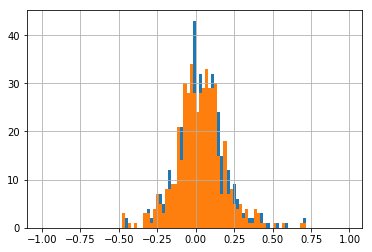

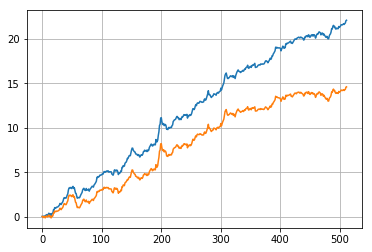

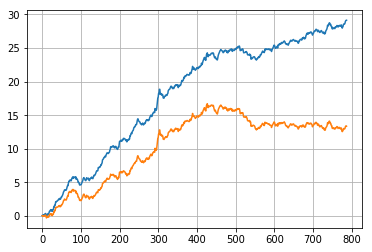

In [47]:
import matplotlib.pyplot as plt

plt.figure(0)
bins = [i/100 for i in range(-100,100,2)]
histG = plt.hist(pos_under_thr['GROI'], bins=bins)
histR = plt.hist(pos_under_thr['ROI'], bins=bins)
plt.grid()

#pos_under_thr.index = range(pos_under_thr.shape[0])
plt.figure(1)
plt.plot(range(pos_under_thr.shape[0]),pos_under_thr['GROI'].cumsum())
plt.plot(range(pos_under_thr.shape[0]),pos_under_thr['ROI'].cumsum())
plt.grid()

plt.figure(2)
#print(pos_under_thr['ROI'])
print(positions[pos_under_2p]['GROI'].shape)
cumG = plt.plot(positions['GROI'].cumsum())#, bins=bins
cumR = plt.plot(positions['ROI'].cumsum())
plt.grid()

Asset
AUDCAD    0.786405
AUDJPY    3.080333
CHFJPY    0.014244
EURAUD    0.007745
EURCAD    1.018476
EURCHF   -0.523604
EURGBP    0.404217
EURJPY    2.094022
EURNZD    0.723562
EURUSD    1.367243
GBPAUD    0.815164
GBPCAD    0.984954
GBPCHF    0.041472
GBPJPY    0.674378
GBPUSD    0.592864
GOLD      1.539759
NZDUSD    0.631062
USDCAD    0.260018
USDCHF    0.410874
USDJPY   -0.334243
Name: ROI, dtype: float64
Di
10    0.013935
11    0.065356
12    1.325704
13    0.683632
14    1.207133
15   -0.117914
16   -0.868079
17   -0.133117
18    1.027296
19   -0.087066
20    0.024637
21    1.516374
22    1.902993
23    1.387065
24    2.039867
25    1.407473
26    2.332192
27    0.503686
28    1.283060
31    0.205468
32    0.668779
33   -0.175712
34    0.037086
35    0.445212
36    0.364563
37    0.640185
38    1.160504
39    0.548633
40    0.787423
41    0.238626
42   -0.026648
43    0.778102
44    0.490354
45    0.390191
Name: GROI, dtype: float64
Di
10   -0.015320
11    0.010430
12    0.849496


(array([5., 9., 5., 6., 3., 2., 1., 1.]),
 array([ 0,  5, 10, 15, 20, 25, 30, 35, 40]),
 <a list of 8 Patch objects>)

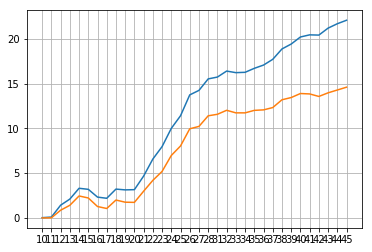

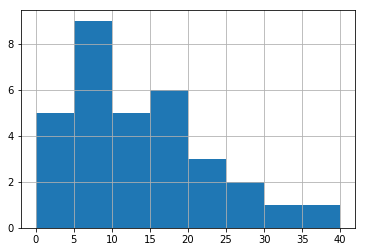

In [48]:
#positions
#grouped = pos_format.groupby(['asset'])
weekly_group = pos_under_thr.groupby([pd.to_datetime(pos_under_thr['Di']).dt.strftime('%W')])['ROI']
weekly_group_G = pos_under_thr.groupby([pd.to_datetime(pos_under_thr['Di']).dt.strftime('%W')])['GROI']
asset_group = pos_under_thr.groupby(['Asset'])
weekly_sum = weekly_group.sum()
weekly_sum_G = weekly_group_G.sum()
weekly_count = weekly_group.count()
#weekly_sum.cumsum()
#print(asset_group['GROI'].sum())
print(asset_group['ROI'].sum())
plt.figure(0)
plt.plot(weekly_sum_G.cumsum())
plt.plot(range(weekly_sum.shape[0]), weekly_sum.cumsum())
plt.grid()
print(weekly_sum_G)
print(weekly_sum)#.cumsum()
print(weekly_count)
print(weekly_sum.cumsum())
print(weekly_count.shape)
#print(pos_under_thr.groupby([pd.to_datetime(pos_under_thr['Di']).dt.strftime('%W')])['GROI'].sum())
#print(weekly_count)
plt.figure(1)
plt.grid()
plt.hist(weekly_count, bins=range(0,max(weekly_count),5))

#for name, group in asset_group:
#    print(name)
#    print(group.to_string())
#pd.to_datetime(positions['Di']).dt.strftime('%W')
#pd.to_datetime(positions['Di'])#.groupby('Name').resample('W-Mon', on='Date').sum().reset_index().sort_values(by='Date')

In [52]:
positions[positions['ROI']<-.2]['ROI'].sum()

-10.499583560807705

In [27]:
positions['GROI'].min()

-0.6293

0.035496947809999325


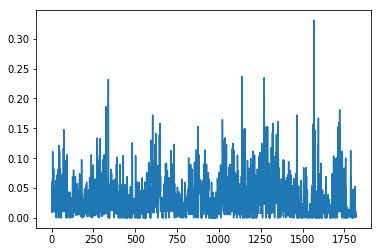

In [144]:
abs_B = (positions['Bo']-positions['Ao'])
abs_A = (positions['Bi']-positions['Ai'])
dif = 100*abs(abs_A-abs_B)/positions['Ai']
print(np.mean(dif))
plt.plot(dif)